In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [7]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_data.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_data.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_MLB_Seaspm.csv")
height_df = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/player_heights.csv")

In [8]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [9]:
testing_data['description'].unique()

array(['hit_into_play', 'ball', 'foul_bunt', 'blocked_ball',
       'swinging_strike', 'foul', 'called_strike', 'foul_tip',
       'hit_by_pitch', 'swinging_strike_blocked', 'missed_bunt',
       'pitchout', 'bunt_foul_tip', 'unknown_strike'], dtype=object)

In [10]:

def preprocess_data(df, height_df):
    """
    This function takes a DataFrame and applies several preprocessing steps to it.
    """
    # Define a function to condense pitch types
    def condense_pitch_type(pitch_type):
        if pitch_type == "FF":
            return "FF"
        elif pitch_type == "FT":
            return "SI"
        elif pitch_type == "FC":
            return "CT"
        elif pitch_type in ["SL", "ST", "SV"]:
            return "SL"
        elif pitch_type in ["CH", "FS"]:
            return "CH"
        elif pitch_type in ["CU", "KC", "CS"]:
            return "CB"
        elif pitch_type == "SI":
            return "SI"
        elif pitch_type == "KN":
            return "KN"
        else:
            return "FAHCK"
    # Define a function to determine if the pitch resulted in a swing
    def is_swing(description):
        return 1 if description in ["swinging_strike", "swinging_strike_blocked", 
                                "missed_bunt", "swinging_pitchout", 
                                "foul_tip", "foul_bunt", "foul", 
                                "foul_pitchout", "hit_into_play", 
                                "hit_into_play_no_out", "hit_into_play_score", 
                                "pitchout_hit_into_play_score"] else 0
    
    def create_pitch_id(df):
        df['pitch_id_raw'] = (df['game_pk'].astype(str) + "_" +
                          df['batter'].astype(str) + "_" +
                          df['pitcher'].astype(str) + "_" +
                          df['pitch_number'].astype(str) + "_" +
                          df['at_bat_number'].astype(str) + "_" +
                          df['inning'].astype(str))
        return df

    df['pitch_type_condensed'] = df['pitch_type'].apply(condense_pitch_type)

    # Calculate 'release_pos_y'
    df['release_pos_y'] = 60.5 - df['release_extension']


    df['swing'] = df['description'].apply(is_swing)

    # Create 'pitch_id_raw'
    df = create_pitch_id(df)

    dfs = df.merge(height_df[['id', 'height_numeric']], how='left', left_on='pitcher', right_on='id')
    # Return the preprocessed DataFrame
    return dfs

In [11]:
# Apply the function to the 'pitch_type' column
training_data  = preprocess_data(data, height_df)
testing_data_processed = preprocess_data(testing_data, height_df)


In [12]:
fastball_training = training_data.query('pitch_type_condensed in ("FF", "SI", "CT")')
fastball_testing = testing_data_processed.query('pitch_type_condensed in ("FF", "SI", "CT")')
breaking_ball = training_data.query('pitch_type_condensed in ("SL", "CB")')
breaking_ball_testing = testing_data_processed.query('pitch_type_condensed in ("SL", "CB")')


# Fastball Model First

In [13]:
# Now, separate features and identifiers
training_identifiers = fastball_training[['pitch_id_raw']]
testing_identifiers = fastball_testing[['pitch_id_raw']]
training_features = fastball_training.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z'
], axis=1)
testing_features = fastball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'Unnamed: 0'
], axis=1)   # Exclude the identifier from the features

In [14]:
train_data = training_features.drop(['swing'], axis=1).copy()
train_label = training_features['swing'].copy()
testing_data = testing_features.drop(['swing'], axis=1).copy()
testing_label = testing_features['swing'].copy()

In [10]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [11]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [18]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [19]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [14]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.6962814142896672
Log Loss: 0.6032517034254566


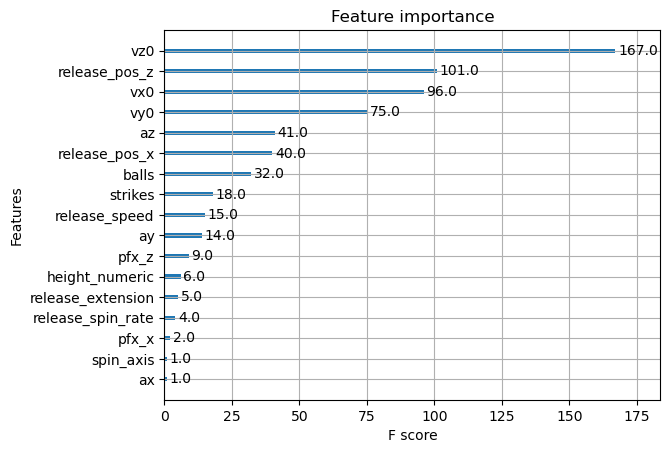

In [15]:
xgb.plot_importance(model)
plt.show()

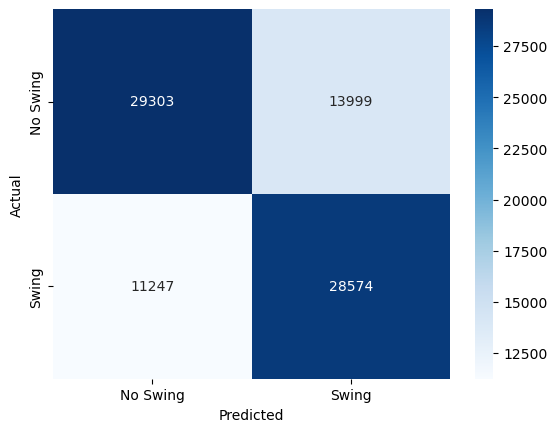

In [16]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Swing', 'Swing'], yticklabels=['No Swing', 'Swing'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [17]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'device' : 'gpu',
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [18]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

[I 2023-11-09 17:08:02,992] A new study created in memory with name: no-name-24021047-90aa-4d3f-a8aa-5dff834a2cc3


[0]	eval-logloss:0.66859
[1]	eval-logloss:0.64868
[2]	eval-logloss:0.63499
[3]	eval-logloss:0.62157
[4]	eval-logloss:0.61040
[5]	eval-logloss:0.60105
[6]	eval-logloss:0.59266
[7]	eval-logloss:0.58655
[8]	eval-logloss:0.58080
[9]	eval-logloss:0.57564
[10]	eval-logloss:0.57097
[11]	eval-logloss:0.56731
[12]	eval-logloss:0.56185
[13]	eval-logloss:0.55879
[14]	eval-logloss:0.55562
[15]	eval-logloss:0.55204
[16]	eval-logloss:0.54819
[17]	eval-logloss:0.54496
[18]	eval-logloss:0.53980
[19]	eval-logloss:0.53624
[20]	eval-logloss:0.53374
[21]	eval-logloss:0.53236
[22]	eval-logloss:0.53024
[23]	eval-logloss:0.52791
[24]	eval-logloss:0.52518
[25]	eval-logloss:0.52352
[26]	eval-logloss:0.52190
[27]	eval-logloss:0.52058
[28]	eval-logloss:0.51940
[29]	eval-logloss:0.51801
[30]	eval-logloss:0.51503
[31]	eval-logloss:0.51424
[32]	eval-logloss:0.51218
[33]	eval-logloss:0.50782
[34]	eval-logloss:0.50481
[35]	eval-logloss:0.50347
[36]	eval-logloss:0.50126
[37]	eval-logloss:0.49978
[38]	eval-logloss:0.49

[I 2023-11-09 17:08:06,753] Trial 0 finished with value: 0.4616741926380102 and parameters: {'max_depth': 7, 'eta': 0.14656194120215726, 'subsample': 0.7100725223778903, 'colsample_bytree': 0.9707345858835942}. Best is trial 0 with value: 0.4616741926380102.


[0]	eval-logloss:0.67841
[1]	eval-logloss:0.66128
[2]	eval-logloss:0.64982
[3]	eval-logloss:0.64010
[4]	eval-logloss:0.63346
[5]	eval-logloss:0.62600
[6]	eval-logloss:0.61966
[7]	eval-logloss:0.61781
[8]	eval-logloss:0.61302
[9]	eval-logloss:0.60706
[10]	eval-logloss:0.60386
[11]	eval-logloss:0.60083
[12]	eval-logloss:0.59753
[13]	eval-logloss:0.59440
[14]	eval-logloss:0.59097
[15]	eval-logloss:0.58867
[16]	eval-logloss:0.58636
[17]	eval-logloss:0.58478
[18]	eval-logloss:0.58380
[19]	eval-logloss:0.58010
[20]	eval-logloss:0.57934
[21]	eval-logloss:0.57829
[22]	eval-logloss:0.57511
[23]	eval-logloss:0.57166
[24]	eval-logloss:0.57081
[25]	eval-logloss:0.57004
[26]	eval-logloss:0.56889
[27]	eval-logloss:0.56796
[28]	eval-logloss:0.56519
[29]	eval-logloss:0.56483
[30]	eval-logloss:0.56250
[31]	eval-logloss:0.56127
[32]	eval-logloss:0.55973
[33]	eval-logloss:0.55796
[34]	eval-logloss:0.55701
[35]	eval-logloss:0.55283
[36]	eval-logloss:0.54968
[37]	eval-logloss:0.54872
[38]	eval-logloss:0.54

[I 2023-11-09 17:08:11,002] Trial 1 finished with value: 0.5058332817436857 and parameters: {'max_depth': 4, 'eta': 0.17428952559658495, 'subsample': 0.6360234627608709, 'colsample_bytree': 0.7179154192812842}. Best is trial 1 with value: 0.5058332817436857.


[0]	eval-logloss:0.67462
[1]	eval-logloss:0.66044
[2]	eval-logloss:0.65105
[3]	eval-logloss:0.64209
[4]	eval-logloss:0.63430
[5]	eval-logloss:0.62805
[6]	eval-logloss:0.62159
[7]	eval-logloss:0.61752
[8]	eval-logloss:0.61415
[9]	eval-logloss:0.61100
[10]	eval-logloss:0.60715
[11]	eval-logloss:0.60356
[12]	eval-logloss:0.60152
[13]	eval-logloss:0.59798
[14]	eval-logloss:0.59461
[15]	eval-logloss:0.59216
[16]	eval-logloss:0.59106
[17]	eval-logloss:0.58708
[18]	eval-logloss:0.58411
[19]	eval-logloss:0.58307
[20]	eval-logloss:0.58056
[21]	eval-logloss:0.57911
[22]	eval-logloss:0.57583
[23]	eval-logloss:0.57035
[24]	eval-logloss:0.56738
[25]	eval-logloss:0.56655
[26]	eval-logloss:0.56577
[27]	eval-logloss:0.56460
[28]	eval-logloss:0.56300
[29]	eval-logloss:0.56080
[30]	eval-logloss:0.55989
[31]	eval-logloss:0.55878
[32]	eval-logloss:0.55744
[33]	eval-logloss:0.55525
[34]	eval-logloss:0.55220
[35]	eval-logloss:0.55089
[36]	eval-logloss:0.54957
[37]	eval-logloss:0.54876
[38]	eval-logloss:0.54

[I 2023-11-09 17:08:13,717] Trial 2 finished with value: 0.5013268061857139 and parameters: {'max_depth': 4, 'eta': 0.15786553344966422, 'subsample': 0.8569353815893695, 'colsample_bytree': 0.9952729692429317}. Best is trial 1 with value: 0.5058332817436857.


[0]	eval-logloss:0.65654
[1]	eval-logloss:0.62986
[2]	eval-logloss:0.61124
[3]	eval-logloss:0.59550
[4]	eval-logloss:0.58307
[5]	eval-logloss:0.57550
[6]	eval-logloss:0.56893
[7]	eval-logloss:0.56135
[8]	eval-logloss:0.55577
[9]	eval-logloss:0.54785
[10]	eval-logloss:0.54377
[11]	eval-logloss:0.54000
[12]	eval-logloss:0.53646
[13]	eval-logloss:0.53130
[14]	eval-logloss:0.52755
[15]	eval-logloss:0.52131
[16]	eval-logloss:0.51887
[17]	eval-logloss:0.51449
[18]	eval-logloss:0.51221
[19]	eval-logloss:0.50871
[20]	eval-logloss:0.50695
[21]	eval-logloss:0.50532
[22]	eval-logloss:0.50357
[23]	eval-logloss:0.50139
[24]	eval-logloss:0.49966
[25]	eval-logloss:0.49947
[26]	eval-logloss:0.49895
[27]	eval-logloss:0.49817
[28]	eval-logloss:0.49469
[29]	eval-logloss:0.49062
[30]	eval-logloss:0.48792
[31]	eval-logloss:0.48741
[32]	eval-logloss:0.48413
[33]	eval-logloss:0.48310
[34]	eval-logloss:0.48208
[35]	eval-logloss:0.48024
[36]	eval-logloss:0.47801
[37]	eval-logloss:0.47683
[38]	eval-logloss:0.47

[I 2023-11-09 17:08:17,081] Trial 3 finished with value: 0.45275546466832806 and parameters: {'max_depth': 8, 'eta': 0.20830153580633848, 'subsample': 0.8516605655500273, 'colsample_bytree': 0.798354280135231}. Best is trial 1 with value: 0.5058332817436857.


[0]	eval-logloss:0.68425
[1]	eval-logloss:0.67407
[2]	eval-logloss:0.66584
[3]	eval-logloss:0.65879
[4]	eval-logloss:0.65417
[5]	eval-logloss:0.64726
[6]	eval-logloss:0.64148
[7]	eval-logloss:0.63973
[8]	eval-logloss:0.63353
[9]	eval-logloss:0.62800
[10]	eval-logloss:0.62255
[11]	eval-logloss:0.61895
[12]	eval-logloss:0.61476
[13]	eval-logloss:0.60976
[14]	eval-logloss:0.60432
[15]	eval-logloss:0.59985
[16]	eval-logloss:0.59533
[17]	eval-logloss:0.59144
[18]	eval-logloss:0.58719
[19]	eval-logloss:0.58304
[20]	eval-logloss:0.58130
[21]	eval-logloss:0.57955
[22]	eval-logloss:0.57730
[23]	eval-logloss:0.57374
[24]	eval-logloss:0.57179
[25]	eval-logloss:0.57110
[26]	eval-logloss:0.56953
[27]	eval-logloss:0.56690
[28]	eval-logloss:0.56675
[29]	eval-logloss:0.56620
[30]	eval-logloss:0.56329
[31]	eval-logloss:0.56093
[32]	eval-logloss:0.55908
[33]	eval-logloss:0.55878
[34]	eval-logloss:0.55638
[35]	eval-logloss:0.55399
[36]	eval-logloss:0.55385
[37]	eval-logloss:0.55166
[38]	eval-logloss:0.55

[I 2023-11-09 17:08:21,065] Trial 4 finished with value: 0.5011575743174499 and parameters: {'max_depth': 9, 'eta': 0.055200146300944726, 'subsample': 0.6784324139886727, 'colsample_bytree': 0.6089280365444201}. Best is trial 1 with value: 0.5058332817436857.


[0]	eval-logloss:0.67323
[1]	eval-logloss:0.65676
[2]	eval-logloss:0.64398
[3]	eval-logloss:0.63221
[4]	eval-logloss:0.62246
[5]	eval-logloss:0.61276
[6]	eval-logloss:0.60453
[7]	eval-logloss:0.59765
[8]	eval-logloss:0.59181
[9]	eval-logloss:0.58498
[10]	eval-logloss:0.57988
[11]	eval-logloss:0.57594
[12]	eval-logloss:0.57207
[13]	eval-logloss:0.56732
[14]	eval-logloss:0.56249
[15]	eval-logloss:0.55829
[16]	eval-logloss:0.55536
[17]	eval-logloss:0.55161
[18]	eval-logloss:0.54785
[19]	eval-logloss:0.54527
[20]	eval-logloss:0.54309
[21]	eval-logloss:0.54011
[22]	eval-logloss:0.53760
[23]	eval-logloss:0.53491
[24]	eval-logloss:0.53295
[25]	eval-logloss:0.52925
[26]	eval-logloss:0.52818
[27]	eval-logloss:0.52652
[28]	eval-logloss:0.52291
[29]	eval-logloss:0.52169
[30]	eval-logloss:0.51886
[31]	eval-logloss:0.51761
[32]	eval-logloss:0.51622
[33]	eval-logloss:0.51504
[34]	eval-logloss:0.51198
[35]	eval-logloss:0.51045
[36]	eval-logloss:0.50748
[37]	eval-logloss:0.50637
[38]	eval-logloss:0.50

[I 2023-11-09 17:08:24,664] Trial 5 finished with value: 0.4633979158497418 and parameters: {'max_depth': 8, 'eta': 0.10720305480729198, 'subsample': 0.8421520985380873, 'colsample_bytree': 0.8693976274727919}. Best is trial 1 with value: 0.5058332817436857.


[0]	eval-logloss:0.65681
[1]	eval-logloss:0.63096
[2]	eval-logloss:0.61136
[3]	eval-logloss:0.59401
[4]	eval-logloss:0.58206
[5]	eval-logloss:0.57251
[6]	eval-logloss:0.56346
[7]	eval-logloss:0.55674
[8]	eval-logloss:0.55173
[9]	eval-logloss:0.54621
[10]	eval-logloss:0.54186
[11]	eval-logloss:0.53827
[12]	eval-logloss:0.53415
[13]	eval-logloss:0.52952
[14]	eval-logloss:0.52509
[15]	eval-logloss:0.51963
[16]	eval-logloss:0.51594
[17]	eval-logloss:0.51231
[18]	eval-logloss:0.50894
[19]	eval-logloss:0.50657
[20]	eval-logloss:0.50502
[21]	eval-logloss:0.50254
[22]	eval-logloss:0.50055
[23]	eval-logloss:0.49645
[24]	eval-logloss:0.49530
[25]	eval-logloss:0.49340
[26]	eval-logloss:0.49300
[27]	eval-logloss:0.49189
[28]	eval-logloss:0.48933
[29]	eval-logloss:0.48847
[30]	eval-logloss:0.48499
[31]	eval-logloss:0.48412
[32]	eval-logloss:0.48302
[33]	eval-logloss:0.47951
[34]	eval-logloss:0.47802
[35]	eval-logloss:0.47684
[36]	eval-logloss:0.47556
[37]	eval-logloss:0.47468
[38]	eval-logloss:0.47

[I 2023-11-09 17:08:28,441] Trial 6 finished with value: 0.45299322355004024 and parameters: {'max_depth': 9, 'eta': 0.18736086593949022, 'subsample': 0.6594334786898313, 'colsample_bytree': 0.8702838807843021}. Best is trial 1 with value: 0.5058332817436857.


[0]	eval-logloss:0.68305
[1]	eval-logloss:0.67389
[2]	eval-logloss:0.66740
[3]	eval-logloss:0.65983
[4]	eval-logloss:0.65314
[5]	eval-logloss:0.64693
[6]	eval-logloss:0.64110
[7]	eval-logloss:0.63558
[8]	eval-logloss:0.63079
[9]	eval-logloss:0.62632
[10]	eval-logloss:0.62178
[11]	eval-logloss:0.61768
[12]	eval-logloss:0.61410
[13]	eval-logloss:0.61111
[14]	eval-logloss:0.60750
[15]	eval-logloss:0.60476
[16]	eval-logloss:0.60213
[17]	eval-logloss:0.59893
[18]	eval-logloss:0.59612
[19]	eval-logloss:0.59420
[20]	eval-logloss:0.59257
[21]	eval-logloss:0.59054
[22]	eval-logloss:0.58841
[23]	eval-logloss:0.58635
[24]	eval-logloss:0.58438
[25]	eval-logloss:0.58291
[26]	eval-logloss:0.58145
[27]	eval-logloss:0.58000
[28]	eval-logloss:0.57870
[29]	eval-logloss:0.57752
[30]	eval-logloss:0.57614
[31]	eval-logloss:0.57413
[32]	eval-logloss:0.57268
[33]	eval-logloss:0.57053
[34]	eval-logloss:0.56895
[35]	eval-logloss:0.56733
[36]	eval-logloss:0.56574
[37]	eval-logloss:0.56484
[38]	eval-logloss:0.56

[I 2023-11-09 17:08:30,964] Trial 7 finished with value: 0.5099102839967706 and parameters: {'max_depth': 6, 'eta': 0.061858964770688446, 'subsample': 0.6834212010128329, 'colsample_bytree': 0.9988181696687206}. Best is trial 7 with value: 0.5099102839967706.


[0]	eval-logloss:0.64531
[1]	eval-logloss:0.61203
[2]	eval-logloss:0.59007
[3]	eval-logloss:0.57284
[4]	eval-logloss:0.56156
[5]	eval-logloss:0.55302
[6]	eval-logloss:0.54597
[7]	eval-logloss:0.53994
[8]	eval-logloss:0.53350
[9]	eval-logloss:0.52798
[10]	eval-logloss:0.52375
[11]	eval-logloss:0.52059
[12]	eval-logloss:0.51698
[13]	eval-logloss:0.51009
[14]	eval-logloss:0.50747
[15]	eval-logloss:0.50004
[16]	eval-logloss:0.49813
[17]	eval-logloss:0.49447
[18]	eval-logloss:0.49162
[19]	eval-logloss:0.48866
[20]	eval-logloss:0.48734
[21]	eval-logloss:0.48420
[22]	eval-logloss:0.47950
[23]	eval-logloss:0.47752
[24]	eval-logloss:0.47713
[25]	eval-logloss:0.47511
[26]	eval-logloss:0.47510
[27]	eval-logloss:0.47464
[28]	eval-logloss:0.47263
[29]	eval-logloss:0.47155
[30]	eval-logloss:0.46997
[31]	eval-logloss:0.46964
[32]	eval-logloss:0.46895
[33]	eval-logloss:0.46598
[34]	eval-logloss:0.46538
[35]	eval-logloss:0.46499
[36]	eval-logloss:0.46417
[37]	eval-logloss:0.46364
[38]	eval-logloss:0.46

[I 2023-11-09 17:08:34,414] Trial 8 finished with value: 0.4556634908914841 and parameters: {'max_depth': 9, 'eta': 0.26039240311025136, 'subsample': 0.7958372407092695, 'colsample_bytree': 0.8864967882168502}. Best is trial 7 with value: 0.5099102839967706.


[0]	eval-logloss:0.68518
[1]	eval-logloss:0.67637
[2]	eval-logloss:0.67015
[3]	eval-logloss:0.66500
[4]	eval-logloss:0.66004
[5]	eval-logloss:0.65476
[6]	eval-logloss:0.65002
[7]	eval-logloss:0.64802
[8]	eval-logloss:0.64454
[9]	eval-logloss:0.64130
[10]	eval-logloss:0.63830
[11]	eval-logloss:0.63544
[12]	eval-logloss:0.63312
[13]	eval-logloss:0.63107
[14]	eval-logloss:0.62743
[15]	eval-logloss:0.62564
[16]	eval-logloss:0.62380
[17]	eval-logloss:0.62177
[18]	eval-logloss:0.61937
[19]	eval-logloss:0.61780
[20]	eval-logloss:0.61660
[21]	eval-logloss:0.61562
[22]	eval-logloss:0.61275
[23]	eval-logloss:0.61181
[24]	eval-logloss:0.61047
[25]	eval-logloss:0.60975
[26]	eval-logloss:0.60794
[27]	eval-logloss:0.60659
[28]	eval-logloss:0.60437
[29]	eval-logloss:0.60370
[30]	eval-logloss:0.60122
[31]	eval-logloss:0.59972
[32]	eval-logloss:0.59839
[33]	eval-logloss:0.59768
[34]	eval-logloss:0.59539
[35]	eval-logloss:0.59477
[36]	eval-logloss:0.59358
[37]	eval-logloss:0.59314
[38]	eval-logloss:0.59

[I 2023-11-09 17:08:36,305] Trial 9 finished with value: 0.554786618022642 and parameters: {'max_depth': 3, 'eta': 0.1031904029642409, 'subsample': 0.7268464985444316, 'colsample_bytree': 0.678888715064034}. Best is trial 9 with value: 0.554786618022642.


[0]	eval-logloss:0.69124
[1]	eval-logloss:0.68817
[2]	eval-logloss:0.68517
[3]	eval-logloss:0.68251
[4]	eval-logloss:0.67976
[5]	eval-logloss:0.67632
[6]	eval-logloss:0.67323
[7]	eval-logloss:0.67318
[8]	eval-logloss:0.67108
[9]	eval-logloss:0.66916
[10]	eval-logloss:0.66640
[11]	eval-logloss:0.66391
[12]	eval-logloss:0.66161
[13]	eval-logloss:0.66101
[14]	eval-logloss:0.65876
[15]	eval-logloss:0.65702
[16]	eval-logloss:0.65508
[17]	eval-logloss:0.65310
[18]	eval-logloss:0.65107
[19]	eval-logloss:0.64970
[20]	eval-logloss:0.64844
[21]	eval-logloss:0.64735
[22]	eval-logloss:0.64580
[23]	eval-logloss:0.64473
[24]	eval-logloss:0.64335
[25]	eval-logloss:0.64247
[26]	eval-logloss:0.64114
[27]	eval-logloss:0.63983
[28]	eval-logloss:0.63975
[29]	eval-logloss:0.63946
[30]	eval-logloss:0.63861
[31]	eval-logloss:0.63746
[32]	eval-logloss:0.63636
[33]	eval-logloss:0.63591
[34]	eval-logloss:0.63422
[35]	eval-logloss:0.63334
[36]	eval-logloss:0.63311
[37]	eval-logloss:0.63234
[38]	eval-logloss:0.63

[I 2023-11-09 17:08:38,276] Trial 10 finished with value: 0.5977296601004675 and parameters: {'max_depth': 3, 'eta': 0.041557091243477076, 'subsample': 0.7510521146517048, 'colsample_bytree': 0.5109606216942632}. Best is trial 10 with value: 0.5977296601004675.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69046
[2]	eval-logloss:0.68883
[3]	eval-logloss:0.68732
[4]	eval-logloss:0.68575
[5]	eval-logloss:0.68375
[6]	eval-logloss:0.68186
[7]	eval-logloss:0.68183
[8]	eval-logloss:0.68053
[9]	eval-logloss:0.67929
[10]	eval-logloss:0.67754
[11]	eval-logloss:0.67588
[12]	eval-logloss:0.67427
[13]	eval-logloss:0.67384
[14]	eval-logloss:0.67230
[15]	eval-logloss:0.67106
[16]	eval-logloss:0.66959
[17]	eval-logloss:0.66816
[18]	eval-logloss:0.66690
[19]	eval-logloss:0.66586
[20]	eval-logloss:0.66488
[21]	eval-logloss:0.66398
[22]	eval-logloss:0.66271
[23]	eval-logloss:0.66200
[24]	eval-logloss:0.66085
[25]	eval-logloss:0.66005
[26]	eval-logloss:0.65902
[27]	eval-logloss:0.65787
[28]	eval-logloss:0.65783
[29]	eval-logloss:0.65755
[30]	eval-logloss:0.65693
[31]	eval-logloss:0.65583
[32]	eval-logloss:0.65477
[33]	eval-logloss:0.65429
[34]	eval-logloss:0.65330
[35]	eval-logloss:0.65251
[36]	eval-logloss:0.65226
[37]	eval-logloss:0.65152
[38]	eval-logloss:0.65

[I 2023-11-09 17:08:40,140] Trial 11 finished with value: 0.621480649791723 and parameters: {'max_depth': 3, 'eta': 0.021975241933271966, 'subsample': 0.7493397929266061, 'colsample_bytree': 0.5029498782550252}. Best is trial 11 with value: 0.621480649791723.


[0]	eval-logloss:0.69227
[1]	eval-logloss:0.69084
[2]	eval-logloss:0.68943
[3]	eval-logloss:0.68810
[4]	eval-logloss:0.68674
[5]	eval-logloss:0.68502
[6]	eval-logloss:0.68336
[7]	eval-logloss:0.68334
[8]	eval-logloss:0.68220
[9]	eval-logloss:0.68110
[10]	eval-logloss:0.67954
[11]	eval-logloss:0.67806
[12]	eval-logloss:0.67662
[13]	eval-logloss:0.67623
[14]	eval-logloss:0.67485
[15]	eval-logloss:0.67372
[16]	eval-logloss:0.67243
[17]	eval-logloss:0.67112
[18]	eval-logloss:0.67001
[19]	eval-logloss:0.66906
[20]	eval-logloss:0.66818
[21]	eval-logloss:0.66735
[22]	eval-logloss:0.66618
[23]	eval-logloss:0.66555
[24]	eval-logloss:0.66446
[25]	eval-logloss:0.66370
[26]	eval-logloss:0.66277
[27]	eval-logloss:0.66169
[28]	eval-logloss:0.66165
[29]	eval-logloss:0.66138
[30]	eval-logloss:0.66083
[31]	eval-logloss:0.65980
[32]	eval-logloss:0.65881
[33]	eval-logloss:0.65835
[34]	eval-logloss:0.65740
[35]	eval-logloss:0.65666
[36]	eval-logloss:0.65641
[37]	eval-logloss:0.65570
[38]	eval-logloss:0.65

[I 2023-11-09 17:08:42,069] Trial 12 finished with value: 0.626222285207451 and parameters: {'max_depth': 3, 'eta': 0.018807921367708244, 'subsample': 0.7642977320841943, 'colsample_bytree': 0.5045381267064688}. Best is trial 12 with value: 0.626222285207451.


[0]	eval-logloss:0.69209
[1]	eval-logloss:0.69075
[2]	eval-logloss:0.68906
[3]	eval-logloss:0.68756
[4]	eval-logloss:0.68628
[5]	eval-logloss:0.68439
[6]	eval-logloss:0.68272
[7]	eval-logloss:0.68269
[8]	eval-logloss:0.68159
[9]	eval-logloss:0.68067
[10]	eval-logloss:0.67873
[11]	eval-logloss:0.67718
[12]	eval-logloss:0.67546
[13]	eval-logloss:0.67513
[14]	eval-logloss:0.67350
[15]	eval-logloss:0.67231
[16]	eval-logloss:0.67072
[17]	eval-logloss:0.66909
[18]	eval-logloss:0.66780
[19]	eval-logloss:0.66659
[20]	eval-logloss:0.66569
[21]	eval-logloss:0.66496
[22]	eval-logloss:0.66361
[23]	eval-logloss:0.66270
[24]	eval-logloss:0.66144
[25]	eval-logloss:0.66076
[26]	eval-logloss:0.65982
[27]	eval-logloss:0.65842
[28]	eval-logloss:0.65838
[29]	eval-logloss:0.65813
[30]	eval-logloss:0.65720
[31]	eval-logloss:0.65589
[32]	eval-logloss:0.65468
[33]	eval-logloss:0.65424
[34]	eval-logloss:0.65293
[35]	eval-logloss:0.65199
[36]	eval-logloss:0.65176
[37]	eval-logloss:0.65097
[38]	eval-logloss:0.64

[I 2023-11-09 17:08:44,280] Trial 13 finished with value: 0.6141049228440916 and parameters: {'max_depth': 5, 'eta': 0.014986521951623893, 'subsample': 0.7748273554151394, 'colsample_bytree': 0.517249468457861}. Best is trial 12 with value: 0.626222285207451.


[0]	eval-logloss:0.69218
[1]	eval-logloss:0.69086
[2]	eval-logloss:0.68984
[3]	eval-logloss:0.68884
[4]	eval-logloss:0.68798
[5]	eval-logloss:0.68677
[6]	eval-logloss:0.68563
[7]	eval-logloss:0.68511
[8]	eval-logloss:0.68394
[9]	eval-logloss:0.68281
[10]	eval-logloss:0.68162
[11]	eval-logloss:0.68060
[12]	eval-logloss:0.67951
[13]	eval-logloss:0.67894
[14]	eval-logloss:0.67784
[15]	eval-logloss:0.67705
[16]	eval-logloss:0.67604
[17]	eval-logloss:0.67496
[18]	eval-logloss:0.67421
[19]	eval-logloss:0.67339
[20]	eval-logloss:0.67276
[21]	eval-logloss:0.67208
[22]	eval-logloss:0.67115
[23]	eval-logloss:0.67060
[24]	eval-logloss:0.66974
[25]	eval-logloss:0.66920
[26]	eval-logloss:0.66854
[27]	eval-logloss:0.66763
[28]	eval-logloss:0.66760
[29]	eval-logloss:0.66708
[30]	eval-logloss:0.66661
[31]	eval-logloss:0.66572
[32]	eval-logloss:0.66484
[33]	eval-logloss:0.66448
[34]	eval-logloss:0.66358
[35]	eval-logloss:0.66295
[36]	eval-logloss:0.66275
[37]	eval-logloss:0.66213
[38]	eval-logloss:0.66

[I 2023-11-09 17:08:46,332] Trial 14 finished with value: 0.6334544050312257 and parameters: {'max_depth': 4, 'eta': 0.010564994924802062, 'subsample': 0.802294622479823, 'colsample_bytree': 0.5786569191448081}. Best is trial 14 with value: 0.6334544050312257.


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.69025
[2]	eval-logloss:0.68892
[3]	eval-logloss:0.68770
[4]	eval-logloss:0.68669
[5]	eval-logloss:0.68518
[6]	eval-logloss:0.68378
[7]	eval-logloss:0.68320
[8]	eval-logloss:0.68171
[9]	eval-logloss:0.68031
[10]	eval-logloss:0.67888
[11]	eval-logloss:0.67767
[12]	eval-logloss:0.67629
[13]	eval-logloss:0.67556
[14]	eval-logloss:0.67414
[15]	eval-logloss:0.67319
[16]	eval-logloss:0.67193
[17]	eval-logloss:0.67057
[18]	eval-logloss:0.66957
[19]	eval-logloss:0.66852
[20]	eval-logloss:0.66779
[21]	eval-logloss:0.66700
[22]	eval-logloss:0.66589
[23]	eval-logloss:0.66509
[24]	eval-logloss:0.66406
[25]	eval-logloss:0.66349
[26]	eval-logloss:0.66270
[27]	eval-logloss:0.66162
[28]	eval-logloss:0.66158
[29]	eval-logloss:0.66103
[30]	eval-logloss:0.66036
[31]	eval-logloss:0.65932
[32]	eval-logloss:0.65825
[33]	eval-logloss:0.65787
[34]	eval-logloss:0.65676
[35]	eval-logloss:0.65598
[36]	eval-logloss:0.65577
[37]	eval-logloss:0.65500
[38]	eval-logloss:0.65

[I 2023-11-09 17:08:48,469] Trial 15 finished with value: 0.6205193923226217 and parameters: {'max_depth': 5, 'eta': 0.01183974279114801, 'subsample': 0.8961395307833346, 'colsample_bytree': 0.6094752566232169}. Best is trial 14 with value: 0.6334544050312257.


[0]	eval-logloss:0.68669
[1]	eval-logloss:0.67836
[2]	eval-logloss:0.67229
[3]	eval-logloss:0.66690
[4]	eval-logloss:0.66262
[5]	eval-logloss:0.65702
[6]	eval-logloss:0.65204
[7]	eval-logloss:0.65015
[8]	eval-logloss:0.64579
[9]	eval-logloss:0.64170
[10]	eval-logloss:0.63775
[11]	eval-logloss:0.63468
[12]	eval-logloss:0.63163
[13]	eval-logloss:0.62951
[14]	eval-logloss:0.62697
[15]	eval-logloss:0.62523
[16]	eval-logloss:0.62295
[17]	eval-logloss:0.62043
[18]	eval-logloss:0.61735
[19]	eval-logloss:0.61534
[20]	eval-logloss:0.61398
[21]	eval-logloss:0.61294
[22]	eval-logloss:0.61139
[23]	eval-logloss:0.60948
[24]	eval-logloss:0.60812
[25]	eval-logloss:0.60737
[26]	eval-logloss:0.60624
[27]	eval-logloss:0.60442
[28]	eval-logloss:0.60426
[29]	eval-logloss:0.60367
[30]	eval-logloss:0.60099
[31]	eval-logloss:0.59875
[32]	eval-logloss:0.59698
[33]	eval-logloss:0.59667
[34]	eval-logloss:0.59523
[35]	eval-logloss:0.59395
[36]	eval-logloss:0.59375
[37]	eval-logloss:0.59282
[38]	eval-logloss:0.59

[I 2023-11-09 17:08:50,586] Trial 16 finished with value: 0.5530597177153107 and parameters: {'max_depth': 4, 'eta': 0.07312829517166645, 'subsample': 0.802292154492095, 'colsample_bytree': 0.6052199920098746}. Best is trial 14 with value: 0.6334544050312257.


[0]	eval-logloss:0.68458
[1]	eval-logloss:0.67346
[2]	eval-logloss:0.66538
[3]	eval-logloss:0.65855
[4]	eval-logloss:0.65336
[5]	eval-logloss:0.64636
[6]	eval-logloss:0.64026
[7]	eval-logloss:0.63830
[8]	eval-logloss:0.63242
[9]	eval-logloss:0.62762
[10]	eval-logloss:0.62316
[11]	eval-logloss:0.61976
[12]	eval-logloss:0.61673
[13]	eval-logloss:0.61303
[14]	eval-logloss:0.60880
[15]	eval-logloss:0.60670
[16]	eval-logloss:0.60403
[17]	eval-logloss:0.60092
[18]	eval-logloss:0.59770
[19]	eval-logloss:0.59457
[20]	eval-logloss:0.59352
[21]	eval-logloss:0.59236
[22]	eval-logloss:0.59025
[23]	eval-logloss:0.58794
[24]	eval-logloss:0.58654
[25]	eval-logloss:0.58591
[26]	eval-logloss:0.58466
[27]	eval-logloss:0.58302
[28]	eval-logloss:0.58286
[29]	eval-logloss:0.58240
[30]	eval-logloss:0.57879
[31]	eval-logloss:0.57723
[32]	eval-logloss:0.57610
[33]	eval-logloss:0.57584
[34]	eval-logloss:0.57461
[35]	eval-logloss:0.57245
[36]	eval-logloss:0.57233
[37]	eval-logloss:0.57131
[38]	eval-logloss:0.57

[I 2023-11-09 17:08:52,734] Trial 17 finished with value: 0.5272570539054976 and parameters: {'max_depth': 5, 'eta': 0.08732938480576831, 'subsample': 0.6174926179554947, 'colsample_bytree': 0.5575347321539091}. Best is trial 14 with value: 0.6334544050312257.


[0]	eval-logloss:0.68855
[1]	eval-logloss:0.68199
[2]	eval-logloss:0.67692
[3]	eval-logloss:0.67238
[4]	eval-logloss:0.66897
[5]	eval-logloss:0.66392
[6]	eval-logloss:0.65904
[7]	eval-logloss:0.65752
[8]	eval-logloss:0.65320
[9]	eval-logloss:0.64876
[10]	eval-logloss:0.64450
[11]	eval-logloss:0.64144
[12]	eval-logloss:0.63816
[13]	eval-logloss:0.63504
[14]	eval-logloss:0.63155
[15]	eval-logloss:0.62905
[16]	eval-logloss:0.62616
[17]	eval-logloss:0.62286
[18]	eval-logloss:0.62024
[19]	eval-logloss:0.61754
[20]	eval-logloss:0.61598
[21]	eval-logloss:0.61448
[22]	eval-logloss:0.61210
[23]	eval-logloss:0.60982
[24]	eval-logloss:0.60768
[25]	eval-logloss:0.60689
[26]	eval-logloss:0.60521
[27]	eval-logloss:0.60315
[28]	eval-logloss:0.60079
[29]	eval-logloss:0.59981
[30]	eval-logloss:0.59791
[31]	eval-logloss:0.59627
[32]	eval-logloss:0.59464
[33]	eval-logloss:0.59290
[34]	eval-logloss:0.59102
[35]	eval-logloss:0.58966
[36]	eval-logloss:0.58789
[37]	eval-logloss:0.58689
[38]	eval-logloss:0.58

[I 2023-11-09 17:08:55,160] Trial 18 finished with value: 0.5396469965793319 and parameters: {'max_depth': 6, 'eta': 0.04283113899779813, 'subsample': 0.7996332798335345, 'colsample_bytree': 0.6681263257292317}. Best is trial 14 with value: 0.6334544050312257.


[0]	eval-logloss:0.68335
[1]	eval-logloss:0.67109
[2]	eval-logloss:0.66257
[3]	eval-logloss:0.65544
[4]	eval-logloss:0.64988
[5]	eval-logloss:0.64327
[6]	eval-logloss:0.63728
[7]	eval-logloss:0.63525
[8]	eval-logloss:0.63012
[9]	eval-logloss:0.62579
[10]	eval-logloss:0.62182
[11]	eval-logloss:0.61878
[12]	eval-logloss:0.61622
[13]	eval-logloss:0.61301
[14]	eval-logloss:0.60949
[15]	eval-logloss:0.60740
[16]	eval-logloss:0.60533
[17]	eval-logloss:0.60158
[18]	eval-logloss:0.59932
[19]	eval-logloss:0.59628
[20]	eval-logloss:0.59525
[21]	eval-logloss:0.59435
[22]	eval-logloss:0.59297
[23]	eval-logloss:0.59144
[24]	eval-logloss:0.58956
[25]	eval-logloss:0.58891
[26]	eval-logloss:0.58795
[27]	eval-logloss:0.58690
[28]	eval-logloss:0.58667
[29]	eval-logloss:0.58615
[30]	eval-logloss:0.58265
[31]	eval-logloss:0.58150
[32]	eval-logloss:0.58074
[33]	eval-logloss:0.58053
[34]	eval-logloss:0.57906
[35]	eval-logloss:0.57588
[36]	eval-logloss:0.57573
[37]	eval-logloss:0.57289
[38]	eval-logloss:0.57

[I 2023-11-09 17:08:57,087] Trial 19 finished with value: 0.5345242942919811 and parameters: {'max_depth': 4, 'eta': 0.1133205597447107, 'subsample': 0.7667176195967111, 'colsample_bytree': 0.5616821254185291}. Best is trial 14 with value: 0.6334544050312257.


[0]	eval-logloss:0.68995
[1]	eval-logloss:0.68617
[2]	eval-logloss:0.68336
[3]	eval-logloss:0.68086
[4]	eval-logloss:0.67826
[5]	eval-logloss:0.67513
[6]	eval-logloss:0.67223
[7]	eval-logloss:0.67078
[8]	eval-logloss:0.66821
[9]	eval-logloss:0.66571
[10]	eval-logloss:0.66339
[11]	eval-logloss:0.66133
[12]	eval-logloss:0.65928
[13]	eval-logloss:0.65787
[14]	eval-logloss:0.65610
[15]	eval-logloss:0.65443
[16]	eval-logloss:0.65280
[17]	eval-logloss:0.65108
[18]	eval-logloss:0.64924
[19]	eval-logloss:0.64798
[20]	eval-logloss:0.64679
[21]	eval-logloss:0.64557
[22]	eval-logloss:0.64420
[23]	eval-logloss:0.64330
[24]	eval-logloss:0.64213
[25]	eval-logloss:0.64127
[26]	eval-logloss:0.64003
[27]	eval-logloss:0.63889
[28]	eval-logloss:0.63881
[29]	eval-logloss:0.63813
[30]	eval-logloss:0.63706
[31]	eval-logloss:0.63584
[32]	eval-logloss:0.63493
[33]	eval-logloss:0.63452
[34]	eval-logloss:0.63338
[35]	eval-logloss:0.63251
[36]	eval-logloss:0.63225
[37]	eval-logloss:0.63143
[38]	eval-logloss:0.63

[I 2023-11-09 17:08:58,907] Trial 20 finished with value: 0.5972905034445023 and parameters: {'max_depth': 3, 'eta': 0.04015021778240684, 'subsample': 0.7210494726910781, 'colsample_bytree': 0.5586256304622421}. Best is trial 14 with value: 0.6334544050312257.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69111
[3]	eval-logloss:0.69038
[4]	eval-logloss:0.68962
[5]	eval-logloss:0.68863
[6]	eval-logloss:0.68768
[7]	eval-logloss:0.68767
[8]	eval-logloss:0.68700
[9]	eval-logloss:0.68635
[10]	eval-logloss:0.68542
[11]	eval-logloss:0.68452
[12]	eval-logloss:0.68365
[13]	eval-logloss:0.68340
[14]	eval-logloss:0.68254
[15]	eval-logloss:0.68184
[16]	eval-logloss:0.68099
[17]	eval-logloss:0.68015
[18]	eval-logloss:0.67949
[19]	eval-logloss:0.67889
[20]	eval-logloss:0.67831
[21]	eval-logloss:0.67775
[22]	eval-logloss:0.67696
[23]	eval-logloss:0.67656
[24]	eval-logloss:0.67582
[25]	eval-logloss:0.67529
[26]	eval-logloss:0.67471
[27]	eval-logloss:0.67399
[28]	eval-logloss:0.67396
[29]	eval-logloss:0.67377
[30]	eval-logloss:0.67339
[31]	eval-logloss:0.67265
[32]	eval-logloss:0.67194
[33]	eval-logloss:0.67158
[34]	eval-logloss:0.67088
[35]	eval-logloss:0.67035
[36]	eval-logloss:0.67017
[37]	eval-logloss:0.66963
[38]	eval-logloss:0.66

[I 2023-11-09 17:09:00,803] Trial 21 finished with value: 0.6464314531444689 and parameters: {'max_depth': 3, 'eta': 0.010211654513315712, 'subsample': 0.7434480290699104, 'colsample_bytree': 0.5013410420092242}. Best is trial 21 with value: 0.6464314531444689.


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69117
[2]	eval-logloss:0.68997
[3]	eval-logloss:0.68885
[4]	eval-logloss:0.68767
[5]	eval-logloss:0.68616
[6]	eval-logloss:0.68472
[7]	eval-logloss:0.68471
[8]	eval-logloss:0.68371
[9]	eval-logloss:0.68275
[10]	eval-logloss:0.68137
[11]	eval-logloss:0.68005
[12]	eval-logloss:0.67879
[13]	eval-logloss:0.67844
[14]	eval-logloss:0.67721
[15]	eval-logloss:0.67621
[16]	eval-logloss:0.67502
[17]	eval-logloss:0.67384
[18]	eval-logloss:0.67288
[19]	eval-logloss:0.67203
[20]	eval-logloss:0.67123
[21]	eval-logloss:0.67046
[22]	eval-logloss:0.66939
[23]	eval-logloss:0.66881
[24]	eval-logloss:0.66782
[25]	eval-logloss:0.66712
[26]	eval-logloss:0.66628
[27]	eval-logloss:0.66529
[28]	eval-logloss:0.66526
[29]	eval-logloss:0.66501
[30]	eval-logloss:0.66447
[31]	eval-logloss:0.66351
[32]	eval-logloss:0.66259
[33]	eval-logloss:0.66214
[34]	eval-logloss:0.66123
[35]	eval-logloss:0.66054
[36]	eval-logloss:0.66031
[37]	eval-logloss:0.65964
[38]	eval-logloss:0.65

[I 2023-11-09 17:09:02,683] Trial 22 finished with value: 0.6319091569650197 and parameters: {'max_depth': 3, 'eta': 0.016060599906420506, 'subsample': 0.7420210305363415, 'colsample_bytree': 0.5000398591615898}. Best is trial 21 with value: 0.6464314531444689.


[0]	eval-logloss:0.68910
[1]	eval-logloss:0.68353
[2]	eval-logloss:0.67713
[3]	eval-logloss:0.67189
[4]	eval-logloss:0.66737
[5]	eval-logloss:0.66125
[6]	eval-logloss:0.65602
[7]	eval-logloss:0.65593
[8]	eval-logloss:0.65294
[9]	eval-logloss:0.65048
[10]	eval-logloss:0.64576
[11]	eval-logloss:0.64214
[12]	eval-logloss:0.63849
[13]	eval-logloss:0.63783
[14]	eval-logloss:0.63461
[15]	eval-logloss:0.63242
[16]	eval-logloss:0.62976
[17]	eval-logloss:0.62668
[18]	eval-logloss:0.62380
[19]	eval-logloss:0.62151
[20]	eval-logloss:0.62020
[21]	eval-logloss:0.61920
[22]	eval-logloss:0.61694
[23]	eval-logloss:0.61571
[24]	eval-logloss:0.61382
[25]	eval-logloss:0.61306
[26]	eval-logloss:0.61162
[27]	eval-logloss:0.60977
[28]	eval-logloss:0.60963
[29]	eval-logloss:0.60939
[30]	eval-logloss:0.60657
[31]	eval-logloss:0.60510
[32]	eval-logloss:0.60373
[33]	eval-logloss:0.60338
[34]	eval-logloss:0.60099
[35]	eval-logloss:0.59917
[36]	eval-logloss:0.59898
[37]	eval-logloss:0.59835
[38]	eval-logloss:0.59

[I 2023-11-09 17:09:04,921] Trial 23 finished with value: 0.5582967829564912 and parameters: {'max_depth': 4, 'eta': 0.07095476734472794, 'subsample': 0.7359986538316746, 'colsample_bytree': 0.5552457504255995}. Best is trial 21 with value: 0.6464314531444689.


[0]	eval-logloss:0.69027
[1]	eval-logloss:0.68685
[2]	eval-logloss:0.68430
[3]	eval-logloss:0.68201
[4]	eval-logloss:0.67963
[5]	eval-logloss:0.67676
[6]	eval-logloss:0.67407
[7]	eval-logloss:0.67271
[8]	eval-logloss:0.67027
[9]	eval-logloss:0.66795
[10]	eval-logloss:0.66577
[11]	eval-logloss:0.66375
[12]	eval-logloss:0.66186
[13]	eval-logloss:0.66037
[14]	eval-logloss:0.65855
[15]	eval-logloss:0.65693
[16]	eval-logloss:0.65538
[17]	eval-logloss:0.65379
[18]	eval-logloss:0.65201
[19]	eval-logloss:0.65080
[20]	eval-logloss:0.64964
[21]	eval-logloss:0.64845
[22]	eval-logloss:0.64716
[23]	eval-logloss:0.64607
[24]	eval-logloss:0.64493
[25]	eval-logloss:0.64407
[26]	eval-logloss:0.64294
[27]	eval-logloss:0.64185
[28]	eval-logloss:0.64100
[29]	eval-logloss:0.64014
[30]	eval-logloss:0.63933
[31]	eval-logloss:0.63836
[32]	eval-logloss:0.63723
[33]	eval-logloss:0.63638
[34]	eval-logloss:0.63530
[35]	eval-logloss:0.63453
[36]	eval-logloss:0.63423
[37]	eval-logloss:0.63349
[38]	eval-logloss:0.63

[I 2023-11-09 17:09:06,939] Trial 24 finished with value: 0.6002226899724415 and parameters: {'max_depth': 3, 'eta': 0.036004384648883496, 'subsample': 0.7105823923392482, 'colsample_bytree': 0.6363741106435202}. Best is trial 21 with value: 0.6464314531444689.


[0]	eval-logloss:0.69225
[1]	eval-logloss:0.69111
[2]	eval-logloss:0.68967
[3]	eval-logloss:0.68839
[4]	eval-logloss:0.68729
[5]	eval-logloss:0.68567
[6]	eval-logloss:0.68424
[7]	eval-logloss:0.68421
[8]	eval-logloss:0.68327
[9]	eval-logloss:0.68246
[10]	eval-logloss:0.68078
[11]	eval-logloss:0.67944
[12]	eval-logloss:0.67795
[13]	eval-logloss:0.67765
[14]	eval-logloss:0.67622
[15]	eval-logloss:0.67518
[16]	eval-logloss:0.67379
[17]	eval-logloss:0.67232
[18]	eval-logloss:0.67119
[19]	eval-logloss:0.67008
[20]	eval-logloss:0.66928
[21]	eval-logloss:0.66862
[22]	eval-logloss:0.66741
[23]	eval-logloss:0.66655
[24]	eval-logloss:0.66542
[25]	eval-logloss:0.66480
[26]	eval-logloss:0.66396
[27]	eval-logloss:0.66274
[28]	eval-logloss:0.66270
[29]	eval-logloss:0.66247
[30]	eval-logloss:0.66171
[31]	eval-logloss:0.66053
[32]	eval-logloss:0.65943
[33]	eval-logloss:0.65902
[34]	eval-logloss:0.65781
[35]	eval-logloss:0.65695
[36]	eval-logloss:0.65674
[37]	eval-logloss:0.65602
[38]	eval-logloss:0.65

[I 2023-11-09 17:09:09,370] Trial 25 finished with value: 0.6214423871034468 and parameters: {'max_depth': 5, 'eta': 0.012721984092252944, 'subsample': 0.7841055851008146, 'colsample_bytree': 0.5428073488534702}. Best is trial 21 with value: 0.6464314531444689.


[0]	eval-logloss:0.68831
[1]	eval-logloss:0.68193
[2]	eval-logloss:0.67720
[3]	eval-logloss:0.67288
[4]	eval-logloss:0.66938
[5]	eval-logloss:0.66458
[6]	eval-logloss:0.66050
[7]	eval-logloss:0.65879
[8]	eval-logloss:0.65481
[9]	eval-logloss:0.65128
[10]	eval-logloss:0.64757
[11]	eval-logloss:0.64481
[12]	eval-logloss:0.64190
[13]	eval-logloss:0.63979
[14]	eval-logloss:0.63725
[15]	eval-logloss:0.63547
[16]	eval-logloss:0.63321
[17]	eval-logloss:0.63089
[18]	eval-logloss:0.62868
[19]	eval-logloss:0.62662
[20]	eval-logloss:0.62541
[21]	eval-logloss:0.62417
[22]	eval-logloss:0.62242
[23]	eval-logloss:0.62119
[24]	eval-logloss:0.61974
[25]	eval-logloss:0.61897
[26]	eval-logloss:0.61770
[27]	eval-logloss:0.61624
[28]	eval-logloss:0.61612
[29]	eval-logloss:0.61547
[30]	eval-logloss:0.61413
[31]	eval-logloss:0.61282
[32]	eval-logloss:0.61133
[33]	eval-logloss:0.61098
[34]	eval-logloss:0.60905
[35]	eval-logloss:0.60804
[36]	eval-logloss:0.60781
[37]	eval-logloss:0.60693
[38]	eval-logloss:0.60

[I 2023-11-09 17:09:11,447] Trial 26 finished with value: 0.5662737710603352 and parameters: {'max_depth': 4, 'eta': 0.054408528952882854, 'subsample': 0.8185432806323066, 'colsample_bytree': 0.5858927560951206}. Best is trial 21 with value: 0.6464314531444689.


[0]	eval-logloss:0.68651
[1]	eval-logloss:0.67929
[2]	eval-logloss:0.66989
[3]	eval-logloss:0.66196
[4]	eval-logloss:0.65631
[5]	eval-logloss:0.64817
[6]	eval-logloss:0.64154
[7]	eval-logloss:0.64138
[8]	eval-logloss:0.63742
[9]	eval-logloss:0.63488
[10]	eval-logloss:0.62825
[11]	eval-logloss:0.62360
[12]	eval-logloss:0.61890
[13]	eval-logloss:0.61827
[14]	eval-logloss:0.61346
[15]	eval-logloss:0.61037
[16]	eval-logloss:0.60647
[17]	eval-logloss:0.60241
[18]	eval-logloss:0.59771
[19]	eval-logloss:0.59459
[20]	eval-logloss:0.59284
[21]	eval-logloss:0.59198
[22]	eval-logloss:0.58973
[23]	eval-logloss:0.58664
[24]	eval-logloss:0.58467
[25]	eval-logloss:0.58408
[26]	eval-logloss:0.58246
[27]	eval-logloss:0.57981
[28]	eval-logloss:0.57965
[29]	eval-logloss:0.57949
[30]	eval-logloss:0.57717
[31]	eval-logloss:0.57538
[32]	eval-logloss:0.57394
[33]	eval-logloss:0.57369
[34]	eval-logloss:0.57204
[35]	eval-logloss:0.56929
[36]	eval-logloss:0.56920
[37]	eval-logloss:0.56784
[38]	eval-logloss:0.56

[I 2023-11-09 17:09:13,926] Trial 27 finished with value: 0.5205744945191662 and parameters: {'max_depth': 6, 'eta': 0.08156428480614629, 'subsample': 0.7544017864465712, 'colsample_bytree': 0.5245618914472252}. Best is trial 21 with value: 0.6464314531444689.


[0]	eval-logloss:0.69063
[1]	eval-logloss:0.68766
[2]	eval-logloss:0.68541
[3]	eval-logloss:0.68332
[4]	eval-logloss:0.68120
[5]	eval-logloss:0.67866
[6]	eval-logloss:0.67625
[7]	eval-logloss:0.67501
[8]	eval-logloss:0.67279
[9]	eval-logloss:0.67066
[10]	eval-logloss:0.66864
[11]	eval-logloss:0.66678
[12]	eval-logloss:0.66498
[13]	eval-logloss:0.66380
[14]	eval-logloss:0.66211
[15]	eval-logloss:0.66063
[16]	eval-logloss:0.65908
[17]	eval-logloss:0.65754
[18]	eval-logloss:0.65596
[19]	eval-logloss:0.65479
[20]	eval-logloss:0.65368
[21]	eval-logloss:0.65252
[22]	eval-logloss:0.65122
[23]	eval-logloss:0.65029
[24]	eval-logloss:0.64909
[25]	eval-logloss:0.64823
[26]	eval-logloss:0.64708
[27]	eval-logloss:0.64594
[28]	eval-logloss:0.64588
[29]	eval-logloss:0.64510
[30]	eval-logloss:0.64433
[31]	eval-logloss:0.64332
[32]	eval-logloss:0.64239
[33]	eval-logloss:0.64195
[34]	eval-logloss:0.64099
[35]	eval-logloss:0.64022
[36]	eval-logloss:0.63994
[37]	eval-logloss:0.63920
[38]	eval-logloss:0.63

[I 2023-11-09 17:09:15,824] Trial 28 finished with value: 0.6063702588542527 and parameters: {'max_depth': 3, 'eta': 0.0313637429397656, 'subsample': 0.7359793778314674, 'colsample_bytree': 0.5816071264783031}. Best is trial 21 with value: 0.6464314531444689.


[0]	eval-logloss:0.68990
[1]	eval-logloss:0.68537
[2]	eval-logloss:0.68015
[3]	eval-logloss:0.67596
[4]	eval-logloss:0.67213
[5]	eval-logloss:0.66691
[6]	eval-logloss:0.66237
[7]	eval-logloss:0.66229
[8]	eval-logloss:0.65963
[9]	eval-logloss:0.65737
[10]	eval-logloss:0.65308
[11]	eval-logloss:0.64967
[12]	eval-logloss:0.64624
[13]	eval-logloss:0.64558
[14]	eval-logloss:0.64247
[15]	eval-logloss:0.64005
[16]	eval-logloss:0.63744
[17]	eval-logloss:0.63445
[18]	eval-logloss:0.63182
[19]	eval-logloss:0.62977
[20]	eval-logloss:0.62838
[21]	eval-logloss:0.62734
[22]	eval-logloss:0.62535
[23]	eval-logloss:0.62408
[24]	eval-logloss:0.62227
[25]	eval-logloss:0.62148
[26]	eval-logloss:0.62003
[27]	eval-logloss:0.61839
[28]	eval-logloss:0.61828
[29]	eval-logloss:0.61802
[30]	eval-logloss:0.61600
[31]	eval-logloss:0.61427
[32]	eval-logloss:0.61296
[33]	eval-logloss:0.61260
[34]	eval-logloss:0.61042
[35]	eval-logloss:0.60881
[36]	eval-logloss:0.60860
[37]	eval-logloss:0.60783
[38]	eval-logloss:0.60

[I 2023-11-09 17:09:17,828] Trial 29 finished with value: 0.5679722518375661 and parameters: {'max_depth': 4, 'eta': 0.056595628123119496, 'subsample': 0.6968215343291154, 'colsample_bytree': 0.5365048612290435}. Best is trial 21 with value: 0.6464314531444689.


[0]	eval-logloss:0.68080
[1]	eval-logloss:0.66499
[2]	eval-logloss:0.65392
[3]	eval-logloss:0.64472
[4]	eval-logloss:0.63840
[5]	eval-logloss:0.63048
[6]	eval-logloss:0.62300
[7]	eval-logloss:0.62101
[8]	eval-logloss:0.61452
[9]	eval-logloss:0.60969
[10]	eval-logloss:0.60504
[11]	eval-logloss:0.60217
[12]	eval-logloss:0.59901
[13]	eval-logloss:0.59601
[14]	eval-logloss:0.59190
[15]	eval-logloss:0.59005
[16]	eval-logloss:0.58671
[17]	eval-logloss:0.58285
[18]	eval-logloss:0.57836
[19]	eval-logloss:0.57653
[20]	eval-logloss:0.57519
[21]	eval-logloss:0.57413
[22]	eval-logloss:0.57093
[23]	eval-logloss:0.56791
[24]	eval-logloss:0.56649
[25]	eval-logloss:0.56591
[26]	eval-logloss:0.56472
[27]	eval-logloss:0.56352
[28]	eval-logloss:0.55975
[29]	eval-logloss:0.55894
[30]	eval-logloss:0.55431
[31]	eval-logloss:0.55333
[32]	eval-logloss:0.55181
[33]	eval-logloss:0.54944
[34]	eval-logloss:0.54828
[35]	eval-logloss:0.54637
[36]	eval-logloss:0.54619
[37]	eval-logloss:0.54559
[38]	eval-logloss:0.54

[I 2023-11-09 17:09:20,380] Trial 30 finished with value: 0.5019634377277338 and parameters: {'max_depth': 5, 'eta': 0.13118889762508623, 'subsample': 0.7179606874454737, 'colsample_bytree': 0.6364384640984043}. Best is trial 21 with value: 0.6464314531444689.


[0]	eval-logloss:0.69188
[1]	eval-logloss:0.68983
[2]	eval-logloss:0.68782
[3]	eval-logloss:0.68594
[4]	eval-logloss:0.68404
[5]	eval-logloss:0.68164
[6]	eval-logloss:0.67938
[7]	eval-logloss:0.67934
[8]	eval-logloss:0.67780
[9]	eval-logloss:0.67635
[10]	eval-logloss:0.67429
[11]	eval-logloss:0.67236
[12]	eval-logloss:0.67051
[13]	eval-logloss:0.67001
[14]	eval-logloss:0.66823
[15]	eval-logloss:0.66682
[16]	eval-logloss:0.66519
[17]	eval-logloss:0.66359
[18]	eval-logloss:0.66213
[19]	eval-logloss:0.66096
[20]	eval-logloss:0.65988
[21]	eval-logloss:0.65889
[22]	eval-logloss:0.65748
[23]	eval-logloss:0.65665
[24]	eval-logloss:0.65541
[25]	eval-logloss:0.65455
[26]	eval-logloss:0.65341
[27]	eval-logloss:0.65217
[28]	eval-logloss:0.65213
[29]	eval-logloss:0.65182
[30]	eval-logloss:0.65114
[31]	eval-logloss:0.64993
[32]	eval-logloss:0.64882
[33]	eval-logloss:0.64833
[34]	eval-logloss:0.64723
[35]	eval-logloss:0.64638
[36]	eval-logloss:0.64613
[37]	eval-logloss:0.64536
[38]	eval-logloss:0.64

[I 2023-11-09 17:09:22,795] Trial 31 finished with value: 0.6135873506262071 and parameters: {'max_depth': 3, 'eta': 0.02723854280826294, 'subsample': 0.7730386800081557, 'colsample_bytree': 0.5062996018595388}. Best is trial 21 with value: 0.6464314531444689.


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69181
[2]	eval-logloss:0.69099
[3]	eval-logloss:0.69022
[4]	eval-logloss:0.68941
[5]	eval-logloss:0.68837
[6]	eval-logloss:0.68736
[7]	eval-logloss:0.68735
[8]	eval-logloss:0.68665
[9]	eval-logloss:0.68597
[10]	eval-logloss:0.68499
[11]	eval-logloss:0.68404
[12]	eval-logloss:0.68313
[13]	eval-logloss:0.68288
[14]	eval-logloss:0.68197
[15]	eval-logloss:0.68123
[16]	eval-logloss:0.68035
[17]	eval-logloss:0.67946
[18]	eval-logloss:0.67877
[19]	eval-logloss:0.67814
[20]	eval-logloss:0.67754
[21]	eval-logloss:0.67696
[22]	eval-logloss:0.67614
[23]	eval-logloss:0.67571
[24]	eval-logloss:0.67493
[25]	eval-logloss:0.67438
[26]	eval-logloss:0.67378
[27]	eval-logloss:0.67303
[28]	eval-logloss:0.67301
[29]	eval-logloss:0.67280
[30]	eval-logloss:0.67240
[31]	eval-logloss:0.67164
[32]	eval-logloss:0.67089
[33]	eval-logloss:0.67051
[34]	eval-logloss:0.66979
[35]	eval-logloss:0.66924
[36]	eval-logloss:0.66905
[37]	eval-logloss:0.66850
[38]	eval-logloss:0.66

[I 2023-11-09 17:09:25,146] Trial 32 finished with value: 0.6446908606122226 and parameters: {'max_depth': 3, 'eta': 0.010823304433346236, 'subsample': 0.7506554581868539, 'colsample_bytree': 0.5338719194397434}. Best is trial 21 with value: 0.6464314531444689.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.68857
[2]	eval-logloss:0.68550
[3]	eval-logloss:0.68291
[4]	eval-logloss:0.68049
[5]	eval-logloss:0.67708
[6]	eval-logloss:0.67409
[7]	eval-logloss:0.67404
[8]	eval-logloss:0.67215
[9]	eval-logloss:0.67049
[10]	eval-logloss:0.66741
[11]	eval-logloss:0.66488
[12]	eval-logloss:0.66231
[13]	eval-logloss:0.66177
[14]	eval-logloss:0.65934
[15]	eval-logloss:0.65758
[16]	eval-logloss:0.65538
[17]	eval-logloss:0.65300
[18]	eval-logloss:0.65115
[19]	eval-logloss:0.64945
[20]	eval-logloss:0.64823
[21]	eval-logloss:0.64720
[22]	eval-logloss:0.64539
[23]	eval-logloss:0.64439
[24]	eval-logloss:0.64274
[25]	eval-logloss:0.64187
[26]	eval-logloss:0.64055
[27]	eval-logloss:0.63883
[28]	eval-logloss:0.63876
[29]	eval-logloss:0.63847
[30]	eval-logloss:0.63750
[31]	eval-logloss:0.63597
[32]	eval-logloss:0.63456
[33]	eval-logloss:0.63410
[34]	eval-logloss:0.63257
[35]	eval-logloss:0.63153
[36]	eval-logloss:0.63129
[37]	eval-logloss:0.63036
[38]	eval-logloss:0.62

[I 2023-11-09 17:09:27,742] Trial 33 finished with value: 0.5925345217068348 and parameters: {'max_depth': 4, 'eta': 0.032477048456412305, 'subsample': 0.7454628749194001, 'colsample_bytree': 0.5382301770757023}. Best is trial 21 with value: 0.6464314531444689.


[0]	eval-logloss:0.69216
[1]	eval-logloss:0.69095
[2]	eval-logloss:0.69004
[3]	eval-logloss:0.68917
[4]	eval-logloss:0.68826
[5]	eval-logloss:0.68712
[6]	eval-logloss:0.68601
[7]	eval-logloss:0.68542
[8]	eval-logloss:0.68436
[9]	eval-logloss:0.68330
[10]	eval-logloss:0.68227
[11]	eval-logloss:0.68126
[12]	eval-logloss:0.68031
[13]	eval-logloss:0.67978
[14]	eval-logloss:0.67882
[15]	eval-logloss:0.67802
[16]	eval-logloss:0.67709
[17]	eval-logloss:0.67617
[18]	eval-logloss:0.67543
[19]	eval-logloss:0.67475
[20]	eval-logloss:0.67410
[21]	eval-logloss:0.67340
[22]	eval-logloss:0.67254
[23]	eval-logloss:0.67206
[24]	eval-logloss:0.67127
[25]	eval-logloss:0.67068
[26]	eval-logloss:0.67003
[27]	eval-logloss:0.66923
[28]	eval-logloss:0.66920
[29]	eval-logloss:0.66864
[30]	eval-logloss:0.66820
[31]	eval-logloss:0.66742
[32]	eval-logloss:0.66666
[33]	eval-logloss:0.66627
[34]	eval-logloss:0.66554
[35]	eval-logloss:0.66497
[36]	eval-logloss:0.66476
[37]	eval-logloss:0.66415
[38]	eval-logloss:0.66

[I 2023-11-09 17:09:30,211] Trial 34 finished with value: 0.6383914195452803 and parameters: {'max_depth': 3, 'eta': 0.012254860292233383, 'subsample': 0.7044333965453975, 'colsample_bytree': 0.5712455851262688}. Best is trial 21 with value: 0.6464314531444689.


[0]	eval-logloss:0.68858
[1]	eval-logloss:0.68256
[2]	eval-logloss:0.67807
[3]	eval-logloss:0.67401
[4]	eval-logloss:0.67064
[5]	eval-logloss:0.66615
[6]	eval-logloss:0.66207
[7]	eval-logloss:0.66042
[8]	eval-logloss:0.65663
[9]	eval-logloss:0.65308
[10]	eval-logloss:0.64953
[11]	eval-logloss:0.64673
[12]	eval-logloss:0.64387
[13]	eval-logloss:0.64181
[14]	eval-logloss:0.63930
[15]	eval-logloss:0.63753
[16]	eval-logloss:0.63538
[17]	eval-logloss:0.63278
[18]	eval-logloss:0.63065
[19]	eval-logloss:0.62867
[20]	eval-logloss:0.62744
[21]	eval-logloss:0.62617
[22]	eval-logloss:0.62443
[23]	eval-logloss:0.62332
[24]	eval-logloss:0.62187
[25]	eval-logloss:0.62107
[26]	eval-logloss:0.61973
[27]	eval-logloss:0.61820
[28]	eval-logloss:0.61809
[29]	eval-logloss:0.61740
[30]	eval-logloss:0.61586
[31]	eval-logloss:0.61451
[32]	eval-logloss:0.61329
[33]	eval-logloss:0.61295
[34]	eval-logloss:0.61094
[35]	eval-logloss:0.60998
[36]	eval-logloss:0.60974
[37]	eval-logloss:0.60898
[38]	eval-logloss:0.60

[I 2023-11-09 17:09:32,726] Trial 35 finished with value: 0.5684241144661087 and parameters: {'max_depth': 4, 'eta': 0.05117325035085556, 'subsample': 0.6931609050499818, 'colsample_bytree': 0.5790391704980196}. Best is trial 21 with value: 0.6464314531444689.


[0]	eval-logloss:0.68781
[1]	eval-logloss:0.68172
[2]	eval-logloss:0.67724
[3]	eval-logloss:0.67337
[4]	eval-logloss:0.66950
[5]	eval-logloss:0.66518
[6]	eval-logloss:0.66118
[7]	eval-logloss:0.65933
[8]	eval-logloss:0.65608
[9]	eval-logloss:0.65302
[10]	eval-logloss:0.65026
[11]	eval-logloss:0.64797
[12]	eval-logloss:0.64573
[13]	eval-logloss:0.64380
[14]	eval-logloss:0.64164
[15]	eval-logloss:0.63974
[16]	eval-logloss:0.63783
[17]	eval-logloss:0.63586
[18]	eval-logloss:0.63384
[19]	eval-logloss:0.63239
[20]	eval-logloss:0.63117
[21]	eval-logloss:0.63002
[22]	eval-logloss:0.62868
[23]	eval-logloss:0.62764
[24]	eval-logloss:0.62574
[25]	eval-logloss:0.62486
[26]	eval-logloss:0.62392
[27]	eval-logloss:0.62294
[28]	eval-logloss:0.62088
[29]	eval-logloss:0.62009
[30]	eval-logloss:0.61825
[31]	eval-logloss:0.61617
[32]	eval-logloss:0.61483
[33]	eval-logloss:0.61294
[34]	eval-logloss:0.61208
[35]	eval-logloss:0.61037
[36]	eval-logloss:0.60938
[37]	eval-logloss:0.60867
[38]	eval-logloss:0.60

[I 2023-11-09 17:09:35,045] Trial 36 finished with value: 0.5711501588827862 and parameters: {'max_depth': 3, 'eta': 0.06793554710118854, 'subsample': 0.7014339876089942, 'colsample_bytree': 0.7191405010138273}. Best is trial 21 with value: 0.6464314531444689.


[0]	eval-logloss:0.69132
[1]	eval-logloss:0.68872
[2]	eval-logloss:0.68576
[3]	eval-logloss:0.68324
[4]	eval-logloss:0.68088
[5]	eval-logloss:0.67762
[6]	eval-logloss:0.67469
[7]	eval-logloss:0.67464
[8]	eval-logloss:0.67280
[9]	eval-logloss:0.67117
[10]	eval-logloss:0.66821
[11]	eval-logloss:0.66573
[12]	eval-logloss:0.66323
[13]	eval-logloss:0.66270
[14]	eval-logloss:0.66021
[15]	eval-logloss:0.65859
[16]	eval-logloss:0.65635
[17]	eval-logloss:0.65402
[18]	eval-logloss:0.65218
[19]	eval-logloss:0.65023
[20]	eval-logloss:0.64902
[21]	eval-logloss:0.64800
[22]	eval-logloss:0.64620
[23]	eval-logloss:0.64492
[24]	eval-logloss:0.64333
[25]	eval-logloss:0.64247
[26]	eval-logloss:0.64116
[27]	eval-logloss:0.63962
[28]	eval-logloss:0.63955
[29]	eval-logloss:0.63926
[30]	eval-logloss:0.63833
[31]	eval-logloss:0.63680
[32]	eval-logloss:0.63544
[33]	eval-logloss:0.63497
[34]	eval-logloss:0.63346
[35]	eval-logloss:0.63248
[36]	eval-logloss:0.63224
[37]	eval-logloss:0.63141
[38]	eval-logloss:0.63

[I 2023-11-09 17:09:37,738] Trial 37 finished with value: 0.5940525877917192 and parameters: {'max_depth': 4, 'eta': 0.031319289856276855, 'subsample': 0.6608424301487386, 'colsample_bytree': 0.5409606161296905}. Best is trial 21 with value: 0.6464314531444689.


[0]	eval-logloss:0.68920
[1]	eval-logloss:0.68458
[2]	eval-logloss:0.68117
[3]	eval-logloss:0.67810
[4]	eval-logloss:0.67502
[5]	eval-logloss:0.67144
[6]	eval-logloss:0.66811
[7]	eval-logloss:0.66648
[8]	eval-logloss:0.66356
[9]	eval-logloss:0.66084
[10]	eval-logloss:0.65826
[11]	eval-logloss:0.65595
[12]	eval-logloss:0.65382
[13]	eval-logloss:0.65218
[14]	eval-logloss:0.65032
[15]	eval-logloss:0.64855
[16]	eval-logloss:0.64675
[17]	eval-logloss:0.64498
[18]	eval-logloss:0.64335
[19]	eval-logloss:0.64202
[20]	eval-logloss:0.64083
[21]	eval-logloss:0.63962
[22]	eval-logloss:0.63825
[23]	eval-logloss:0.63724
[24]	eval-logloss:0.63588
[25]	eval-logloss:0.63513
[26]	eval-logloss:0.63381
[27]	eval-logloss:0.63268
[28]	eval-logloss:0.63258
[29]	eval-logloss:0.63194
[30]	eval-logloss:0.63023
[31]	eval-logloss:0.62885
[32]	eval-logloss:0.62795
[33]	eval-logloss:0.62760
[34]	eval-logloss:0.62627
[35]	eval-logloss:0.62529
[36]	eval-logloss:0.62502
[37]	eval-logloss:0.62421
[38]	eval-logloss:0.62

[I 2023-11-09 17:09:40,102] Trial 38 finished with value: 0.5869131867294646 and parameters: {'max_depth': 3, 'eta': 0.049838019147239856, 'subsample': 0.7207449829621624, 'colsample_bytree': 0.588848301603194}. Best is trial 21 with value: 0.6464314531444689.


[0]	eval-logloss:0.69210
[1]	eval-logloss:0.69066
[2]	eval-logloss:0.68954
[3]	eval-logloss:0.68846
[4]	eval-logloss:0.68752
[5]	eval-logloss:0.68621
[6]	eval-logloss:0.68491
[7]	eval-logloss:0.68434
[8]	eval-logloss:0.68305
[9]	eval-logloss:0.68178
[10]	eval-logloss:0.68051
[11]	eval-logloss:0.67941
[12]	eval-logloss:0.67823
[13]	eval-logloss:0.67731
[14]	eval-logloss:0.67615
[15]	eval-logloss:0.67531
[16]	eval-logloss:0.67425
[17]	eval-logloss:0.67311
[18]	eval-logloss:0.67227
[19]	eval-logloss:0.67141
[20]	eval-logloss:0.67075
[21]	eval-logloss:0.67002
[22]	eval-logloss:0.66899
[23]	eval-logloss:0.66840
[24]	eval-logloss:0.66749
[25]	eval-logloss:0.66692
[26]	eval-logloss:0.66600
[27]	eval-logloss:0.66505
[28]	eval-logloss:0.66459
[29]	eval-logloss:0.66395
[30]	eval-logloss:0.66346
[31]	eval-logloss:0.66256
[32]	eval-logloss:0.66165
[33]	eval-logloss:0.66078
[34]	eval-logloss:0.65986
[35]	eval-logloss:0.65921
[36]	eval-logloss:0.65900
[37]	eval-logloss:0.65835
[38]	eval-logloss:0.65

[I 2023-11-09 17:09:42,753] Trial 39 finished with value: 0.6277408415390053 and parameters: {'max_depth': 4, 'eta': 0.011515920167920456, 'subsample': 0.8204162276871358, 'colsample_bytree': 0.6228107676395147}. Best is trial 21 with value: 0.6464314531444689.


[0]	eval-logloss:0.68629
[1]	eval-logloss:0.67856
[2]	eval-logloss:0.67304
[3]	eval-logloss:0.66864
[4]	eval-logloss:0.66411
[5]	eval-logloss:0.65903
[6]	eval-logloss:0.65462
[7]	eval-logloss:0.65266
[8]	eval-logloss:0.64911
[9]	eval-logloss:0.64585
[10]	eval-logloss:0.64286
[11]	eval-logloss:0.64059
[12]	eval-logloss:0.63792
[13]	eval-logloss:0.63590
[14]	eval-logloss:0.63352
[15]	eval-logloss:0.63181
[16]	eval-logloss:0.62962
[17]	eval-logloss:0.62648
[18]	eval-logloss:0.62482
[19]	eval-logloss:0.62351
[20]	eval-logloss:0.62213
[21]	eval-logloss:0.62099
[22]	eval-logloss:0.61849
[23]	eval-logloss:0.61724
[24]	eval-logloss:0.61592
[25]	eval-logloss:0.61499
[26]	eval-logloss:0.61381
[27]	eval-logloss:0.61301
[28]	eval-logloss:0.61090
[29]	eval-logloss:0.61024
[30]	eval-logloss:0.60915
[31]	eval-logloss:0.60774
[32]	eval-logloss:0.60608
[33]	eval-logloss:0.60534
[34]	eval-logloss:0.60480
[35]	eval-logloss:0.60244
[36]	eval-logloss:0.60217
[37]	eval-logloss:0.60059
[38]	eval-logloss:0.59

[I 2023-11-09 17:09:45,181] Trial 40 finished with value: 0.5647223853969915 and parameters: {'max_depth': 3, 'eta': 0.08812614597209388, 'subsample': 0.7078440641851713, 'colsample_bytree': 0.6574633046366434}. Best is trial 21 with value: 0.6464314531444689.


[0]	eval-logloss:0.69046
[1]	eval-logloss:0.68771
[2]	eval-logloss:0.68399
[3]	eval-logloss:0.68071
[4]	eval-logloss:0.67822
[5]	eval-logloss:0.67448
[6]	eval-logloss:0.67135
[7]	eval-logloss:0.67128
[8]	eval-logloss:0.66916
[9]	eval-logloss:0.66770
[10]	eval-logloss:0.66404
[11]	eval-logloss:0.66134
[12]	eval-logloss:0.65827
[13]	eval-logloss:0.65776
[14]	eval-logloss:0.65472
[15]	eval-logloss:0.65216
[16]	eval-logloss:0.64924
[17]	eval-logloss:0.64625
[18]	eval-logloss:0.64362
[19]	eval-logloss:0.64139
[20]	eval-logloss:0.63994
[21]	eval-logloss:0.63898
[22]	eval-logloss:0.63684
[23]	eval-logloss:0.63479
[24]	eval-logloss:0.63290
[25]	eval-logloss:0.63208
[26]	eval-logloss:0.63054
[27]	eval-logloss:0.62825
[28]	eval-logloss:0.62815
[29]	eval-logloss:0.62785
[30]	eval-logloss:0.62595
[31]	eval-logloss:0.62380
[32]	eval-logloss:0.62211
[33]	eval-logloss:0.62161
[34]	eval-logloss:0.61965
[35]	eval-logloss:0.61752
[36]	eval-logloss:0.61726
[37]	eval-logloss:0.61610
[38]	eval-logloss:0.61

[I 2023-11-09 17:09:48,728] Trial 41 finished with value: 0.5650256526960483 and parameters: {'max_depth': 7, 'eta': 0.02692732682527184, 'subsample': 0.7383050664237695, 'colsample_bytree': 0.5001675940202048}. Best is trial 21 with value: 0.6464314531444689.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69112
[3]	eval-logloss:0.69038
[4]	eval-logloss:0.68961
[5]	eval-logloss:0.68864
[6]	eval-logloss:0.68769
[7]	eval-logloss:0.68768
[8]	eval-logloss:0.68702
[9]	eval-logloss:0.68637
[10]	eval-logloss:0.68544
[11]	eval-logloss:0.68455
[12]	eval-logloss:0.68368
[13]	eval-logloss:0.68344
[14]	eval-logloss:0.68258
[15]	eval-logloss:0.68188
[16]	eval-logloss:0.68103
[17]	eval-logloss:0.68020
[18]	eval-logloss:0.67954
[19]	eval-logloss:0.67894
[20]	eval-logloss:0.67837
[21]	eval-logloss:0.67781
[22]	eval-logloss:0.67703
[23]	eval-logloss:0.67662
[24]	eval-logloss:0.67587
[25]	eval-logloss:0.67534
[26]	eval-logloss:0.67477
[27]	eval-logloss:0.67405
[28]	eval-logloss:0.67403
[29]	eval-logloss:0.67384
[30]	eval-logloss:0.67346
[31]	eval-logloss:0.67273
[32]	eval-logloss:0.67201
[33]	eval-logloss:0.67165
[34]	eval-logloss:0.67096
[35]	eval-logloss:0.67043
[36]	eval-logloss:0.67024
[37]	eval-logloss:0.66971
[38]	eval-logloss:0.66

[I 2023-11-09 17:09:51,160] Trial 42 finished with value: 0.6465998617129017 and parameters: {'max_depth': 3, 'eta': 0.010175915410716291, 'subsample': 0.7583389165257386, 'colsample_bytree': 0.529671036105188}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.68986
[1]	eval-logloss:0.68598
[2]	eval-logloss:0.68310
[3]	eval-logloss:0.68047
[4]	eval-logloss:0.67781
[5]	eval-logloss:0.67469
[6]	eval-logloss:0.67176
[7]	eval-logloss:0.67029
[8]	eval-logloss:0.66768
[9]	eval-logloss:0.66516
[10]	eval-logloss:0.66280
[11]	eval-logloss:0.66072
[12]	eval-logloss:0.65869
[13]	eval-logloss:0.65725
[14]	eval-logloss:0.65542
[15]	eval-logloss:0.65376
[16]	eval-logloss:0.65205
[17]	eval-logloss:0.65045
[18]	eval-logloss:0.64849
[19]	eval-logloss:0.64718
[20]	eval-logloss:0.64599
[21]	eval-logloss:0.64478
[22]	eval-logloss:0.64344
[23]	eval-logloss:0.64252
[24]	eval-logloss:0.64131
[25]	eval-logloss:0.64044
[26]	eval-logloss:0.63918
[27]	eval-logloss:0.63805
[28]	eval-logloss:0.63798
[29]	eval-logloss:0.63732
[30]	eval-logloss:0.63643
[31]	eval-logloss:0.63521
[32]	eval-logloss:0.63431
[33]	eval-logloss:0.63392
[34]	eval-logloss:0.63266
[35]	eval-logloss:0.63168
[36]	eval-logloss:0.63141
[37]	eval-logloss:0.63024
[38]	eval-logloss:0.62

[I 2023-11-09 17:09:53,450] Trial 43 finished with value: 0.5939495572397996 and parameters: {'max_depth': 3, 'eta': 0.041257367091165016, 'subsample': 0.7644681327817708, 'colsample_bytree': 0.5716279006074455}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.69194
[1]	eval-logloss:0.68999
[2]	eval-logloss:0.68807
[3]	eval-logloss:0.68628
[4]	eval-logloss:0.68445
[5]	eval-logloss:0.68215
[6]	eval-logloss:0.67999
[7]	eval-logloss:0.67995
[8]	eval-logloss:0.67847
[9]	eval-logloss:0.67707
[10]	eval-logloss:0.67506
[11]	eval-logloss:0.67321
[12]	eval-logloss:0.67141
[13]	eval-logloss:0.67093
[14]	eval-logloss:0.66920
[15]	eval-logloss:0.66783
[16]	eval-logloss:0.66625
[17]	eval-logloss:0.66468
[18]	eval-logloss:0.66327
[19]	eval-logloss:0.66213
[20]	eval-logloss:0.66108
[21]	eval-logloss:0.66010
[22]	eval-logloss:0.65873
[23]	eval-logloss:0.65793
[24]	eval-logloss:0.65668
[25]	eval-logloss:0.65583
[26]	eval-logloss:0.65473
[27]	eval-logloss:0.65352
[28]	eval-logloss:0.65347
[29]	eval-logloss:0.65317
[30]	eval-logloss:0.65250
[31]	eval-logloss:0.65134
[32]	eval-logloss:0.65022
[33]	eval-logloss:0.64973
[34]	eval-logloss:0.64865
[35]	eval-logloss:0.64782
[36]	eval-logloss:0.64756
[37]	eval-logloss:0.64680
[38]	eval-logloss:0.64

[I 2023-11-09 17:09:55,755] Trial 44 finished with value: 0.6153931510072604 and parameters: {'max_depth': 3, 'eta': 0.025954826907626884, 'subsample': 0.7862424251352367, 'colsample_bytree': 0.5325093621451743}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.68618
[1]	eval-logloss:0.67689
[2]	eval-logloss:0.66961
[3]	eval-logloss:0.66352
[4]	eval-logloss:0.65909
[5]	eval-logloss:0.65276
[6]	eval-logloss:0.64740
[7]	eval-logloss:0.64564
[8]	eval-logloss:0.64014
[9]	eval-logloss:0.63509
[10]	eval-logloss:0.63020
[11]	eval-logloss:0.62675
[12]	eval-logloss:0.62311
[13]	eval-logloss:0.61856
[14]	eval-logloss:0.61422
[15]	eval-logloss:0.61042
[16]	eval-logloss:0.60644
[17]	eval-logloss:0.60337
[18]	eval-logloss:0.59971
[19]	eval-logloss:0.59668
[20]	eval-logloss:0.59498
[21]	eval-logloss:0.59334
[22]	eval-logloss:0.59117
[23]	eval-logloss:0.58850
[24]	eval-logloss:0.58661
[25]	eval-logloss:0.58593
[26]	eval-logloss:0.58436
[27]	eval-logloss:0.58166
[28]	eval-logloss:0.58153
[29]	eval-logloss:0.58096
[30]	eval-logloss:0.57833
[31]	eval-logloss:0.57625
[32]	eval-logloss:0.57455
[33]	eval-logloss:0.57427
[34]	eval-logloss:0.57212
[35]	eval-logloss:0.56948
[36]	eval-logloss:0.56932
[37]	eval-logloss:0.56751
[38]	eval-logloss:0.56

[I 2023-11-09 17:09:59,301] Trial 45 finished with value: 0.5177616902885063 and parameters: {'max_depth': 7, 'eta': 0.05767297714435124, 'subsample': 0.7594354832240081, 'colsample_bytree': 0.6072547413073305}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.69158
[1]	eval-logloss:0.69009
[2]	eval-logloss:0.68793
[3]	eval-logloss:0.68604
[4]	eval-logloss:0.68462
[5]	eval-logloss:0.68247
[6]	eval-logloss:0.68065
[7]	eval-logloss:0.68060
[8]	eval-logloss:0.67931
[9]	eval-logloss:0.67844
[10]	eval-logloss:0.67616
[11]	eval-logloss:0.67448
[12]	eval-logloss:0.67249
[13]	eval-logloss:0.67215
[14]	eval-logloss:0.67018
[15]	eval-logloss:0.66847
[16]	eval-logloss:0.66647
[17]	eval-logloss:0.66442
[18]	eval-logloss:0.66265
[19]	eval-logloss:0.66106
[20]	eval-logloss:0.66003
[21]	eval-logloss:0.65934
[22]	eval-logloss:0.65782
[23]	eval-logloss:0.65644
[24]	eval-logloss:0.65506
[25]	eval-logloss:0.65442
[26]	eval-logloss:0.65333
[27]	eval-logloss:0.65164
[28]	eval-logloss:0.65158
[29]	eval-logloss:0.65133
[30]	eval-logloss:0.64999
[31]	eval-logloss:0.64832
[32]	eval-logloss:0.64700
[33]	eval-logloss:0.64656
[34]	eval-logloss:0.64495
[35]	eval-logloss:0.64352
[36]	eval-logloss:0.64328
[37]	eval-logloss:0.64234
[38]	eval-logloss:0.64

[I 2023-11-09 17:10:03,364] Trial 46 finished with value: 0.5959227083579494 and parameters: {'max_depth': 8, 'eta': 0.013810050882360939, 'subsample': 0.7319704872372903, 'colsample_bytree': 0.528861429404504}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.68927
[1]	eval-logloss:0.68411
[2]	eval-logloss:0.68023
[3]	eval-logloss:0.67667
[4]	eval-logloss:0.67371
[5]	eval-logloss:0.66975
[6]	eval-logloss:0.66613
[7]	eval-logloss:0.66462
[8]	eval-logloss:0.66112
[9]	eval-logloss:0.65788
[10]	eval-logloss:0.65463
[11]	eval-logloss:0.65195
[12]	eval-logloss:0.64923
[13]	eval-logloss:0.64742
[14]	eval-logloss:0.64489
[15]	eval-logloss:0.64319
[16]	eval-logloss:0.64100
[17]	eval-logloss:0.63883
[18]	eval-logloss:0.63681
[19]	eval-logloss:0.63494
[20]	eval-logloss:0.63371
[21]	eval-logloss:0.63247
[22]	eval-logloss:0.63071
[23]	eval-logloss:0.62960
[24]	eval-logloss:0.62811
[25]	eval-logloss:0.62729
[26]	eval-logloss:0.62599
[27]	eval-logloss:0.62458
[28]	eval-logloss:0.62449
[29]	eval-logloss:0.62379
[30]	eval-logloss:0.62269
[31]	eval-logloss:0.62138
[32]	eval-logloss:0.62013
[33]	eval-logloss:0.61976
[34]	eval-logloss:0.61791
[35]	eval-logloss:0.61687
[36]	eval-logloss:0.61662
[37]	eval-logloss:0.61588
[38]	eval-logloss:0.61

[I 2023-11-09 17:10:05,955] Trial 47 finished with value: 0.5763568757140892 and parameters: {'max_depth': 4, 'eta': 0.04324849929994963, 'subsample': 0.7532830204999823, 'colsample_bytree': 0.565052909232126}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.69124
[1]	eval-logloss:0.68894
[2]	eval-logloss:0.68721
[3]	eval-logloss:0.68558
[4]	eval-logloss:0.68391
[5]	eval-logloss:0.68185
[6]	eval-logloss:0.67994
[7]	eval-logloss:0.67892
[8]	eval-logloss:0.67711
[9]	eval-logloss:0.67532
[10]	eval-logloss:0.67361
[11]	eval-logloss:0.67202
[12]	eval-logloss:0.67048
[13]	eval-logloss:0.66954
[14]	eval-logloss:0.66805
[15]	eval-logloss:0.66679
[16]	eval-logloss:0.66542
[17]	eval-logloss:0.66406
[18]	eval-logloss:0.66274
[19]	eval-logloss:0.66172
[20]	eval-logloss:0.66074
[21]	eval-logloss:0.65970
[22]	eval-logloss:0.65849
[23]	eval-logloss:0.65775
[24]	eval-logloss:0.65665
[25]	eval-logloss:0.65584
[26]	eval-logloss:0.65491
[27]	eval-logloss:0.65383
[28]	eval-logloss:0.65378
[29]	eval-logloss:0.65304
[30]	eval-logloss:0.65238
[31]	eval-logloss:0.65138
[32]	eval-logloss:0.65038
[33]	eval-logloss:0.64993
[34]	eval-logloss:0.64904
[35]	eval-logloss:0.64828
[36]	eval-logloss:0.64801
[37]	eval-logloss:0.64721
[38]	eval-logloss:0.64

[I 2023-11-09 17:10:08,418] Trial 48 finished with value: 0.6160957203659783 and parameters: {'max_depth': 3, 'eta': 0.02376339043933772, 'subsample': 0.7807364831440475, 'colsample_bytree': 0.597944315636618}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.69057
[1]	eval-logloss:0.68632
[2]	eval-logloss:0.68187
[3]	eval-logloss:0.67841
[4]	eval-logloss:0.67477
[5]	eval-logloss:0.67033
[6]	eval-logloss:0.66631
[7]	eval-logloss:0.66624
[8]	eval-logloss:0.66366
[9]	eval-logloss:0.66137
[10]	eval-logloss:0.65811
[11]	eval-logloss:0.65513
[12]	eval-logloss:0.65251
[13]	eval-logloss:0.65184
[14]	eval-logloss:0.64937
[15]	eval-logloss:0.64740
[16]	eval-logloss:0.64531
[17]	eval-logloss:0.64319
[18]	eval-logloss:0.64108
[19]	eval-logloss:0.63858
[20]	eval-logloss:0.63729
[21]	eval-logloss:0.63617
[22]	eval-logloss:0.63466
[23]	eval-logloss:0.63337
[24]	eval-logloss:0.63158
[25]	eval-logloss:0.63069
[26]	eval-logloss:0.62931
[27]	eval-logloss:0.62812
[28]	eval-logloss:0.62802
[29]	eval-logloss:0.62772
[30]	eval-logloss:0.62656
[31]	eval-logloss:0.62464
[32]	eval-logloss:0.62342
[33]	eval-logloss:0.62303
[34]	eval-logloss:0.62168
[35]	eval-logloss:0.62073
[36]	eval-logloss:0.62051
[37]	eval-logloss:0.61955
[38]	eval-logloss:0.61

[I 2023-11-09 17:10:10,760] Trial 49 finished with value: 0.586075107011121 and parameters: {'max_depth': 3, 'eta': 0.058350971485639815, 'subsample': 0.6693661285977428, 'colsample_bytree': 0.5236665409894616}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.69049
[2]	eval-logloss:0.68930
[3]	eval-logloss:0.68817
[4]	eval-logloss:0.68717
[5]	eval-logloss:0.68579
[6]	eval-logloss:0.68448
[7]	eval-logloss:0.68389
[8]	eval-logloss:0.68254
[9]	eval-logloss:0.68124
[10]	eval-logloss:0.67989
[11]	eval-logloss:0.67873
[12]	eval-logloss:0.67749
[13]	eval-logloss:0.67683
[14]	eval-logloss:0.67560
[15]	eval-logloss:0.67470
[16]	eval-logloss:0.67358
[17]	eval-logloss:0.67238
[18]	eval-logloss:0.67151
[19]	eval-logloss:0.67059
[20]	eval-logloss:0.66990
[21]	eval-logloss:0.66914
[22]	eval-logloss:0.66811
[23]	eval-logloss:0.66748
[24]	eval-logloss:0.66653
[25]	eval-logloss:0.66594
[26]	eval-logloss:0.66520
[27]	eval-logloss:0.66424
[28]	eval-logloss:0.66421
[29]	eval-logloss:0.66364
[30]	eval-logloss:0.66312
[31]	eval-logloss:0.66215
[32]	eval-logloss:0.66118
[33]	eval-logloss:0.66080
[34]	eval-logloss:0.65984
[35]	eval-logloss:0.65917
[36]	eval-logloss:0.65895
[37]	eval-logloss:0.65827
[38]	eval-logloss:0.65

[I 2023-11-09 17:10:13,236] Trial 50 finished with value: 0.6278120757719203 and parameters: {'max_depth': 4, 'eta': 0.01230968175578971, 'subsample': 0.6839839934360904, 'colsample_bytree': 0.5572928643929805}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.69020
[2]	eval-logloss:0.68841
[3]	eval-logloss:0.68677
[4]	eval-logloss:0.68505
[5]	eval-logloss:0.68288
[6]	eval-logloss:0.68083
[7]	eval-logloss:0.68080
[8]	eval-logloss:0.67940
[9]	eval-logloss:0.67807
[10]	eval-logloss:0.67617
[11]	eval-logloss:0.67440
[12]	eval-logloss:0.67269
[13]	eval-logloss:0.67223
[14]	eval-logloss:0.67057
[15]	eval-logloss:0.66925
[16]	eval-logloss:0.66770
[17]	eval-logloss:0.66618
[18]	eval-logloss:0.66484
[19]	eval-logloss:0.66377
[20]	eval-logloss:0.66274
[21]	eval-logloss:0.66179
[22]	eval-logloss:0.66047
[23]	eval-logloss:0.65971
[24]	eval-logloss:0.65851
[25]	eval-logloss:0.65768
[26]	eval-logloss:0.65661
[27]	eval-logloss:0.65541
[28]	eval-logloss:0.65537
[29]	eval-logloss:0.65507
[30]	eval-logloss:0.65442
[31]	eval-logloss:0.65327
[32]	eval-logloss:0.65219
[33]	eval-logloss:0.65170
[34]	eval-logloss:0.65062
[35]	eval-logloss:0.64980
[36]	eval-logloss:0.64955
[37]	eval-logloss:0.64879
[38]	eval-logloss:0.64

[I 2023-11-09 17:10:15,615] Trial 51 finished with value: 0.6178764610353006 and parameters: {'max_depth': 3, 'eta': 0.02416847588514915, 'subsample': 0.7446969638565377, 'colsample_bytree': 0.5017859767153842}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.69218
[1]	eval-logloss:0.69060
[2]	eval-logloss:0.68904
[3]	eval-logloss:0.68761
[4]	eval-logloss:0.68611
[5]	eval-logloss:0.68422
[6]	eval-logloss:0.68239
[7]	eval-logloss:0.68236
[8]	eval-logloss:0.68112
[9]	eval-logloss:0.67992
[10]	eval-logloss:0.67822
[11]	eval-logloss:0.67662
[12]	eval-logloss:0.67508
[13]	eval-logloss:0.67466
[14]	eval-logloss:0.67317
[15]	eval-logloss:0.67197
[16]	eval-logloss:0.67055
[17]	eval-logloss:0.66916
[18]	eval-logloss:0.66799
[19]	eval-logloss:0.66698
[20]	eval-logloss:0.66604
[21]	eval-logloss:0.66516
[22]	eval-logloss:0.66391
[23]	eval-logloss:0.66323
[24]	eval-logloss:0.66210
[25]	eval-logloss:0.66131
[26]	eval-logloss:0.66032
[27]	eval-logloss:0.65920
[28]	eval-logloss:0.65916
[29]	eval-logloss:0.65888
[30]	eval-logloss:0.65828
[31]	eval-logloss:0.65719
[32]	eval-logloss:0.65617
[33]	eval-logloss:0.65569
[34]	eval-logloss:0.65466
[35]	eval-logloss:0.65389
[36]	eval-logloss:0.65364
[37]	eval-logloss:0.65290
[38]	eval-logloss:0.65

[I 2023-11-09 17:10:18,013] Trial 52 finished with value: 0.6229548811357 and parameters: {'max_depth': 3, 'eta': 0.020865596440966028, 'subsample': 0.7205659544751579, 'colsample_bytree': 0.5215754446270277}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.69137
[1]	eval-logloss:0.68851
[2]	eval-logloss:0.68573
[3]	eval-logloss:0.68324
[4]	eval-logloss:0.68067
[5]	eval-logloss:0.67744
[6]	eval-logloss:0.67447
[7]	eval-logloss:0.67443
[8]	eval-logloss:0.67243
[9]	eval-logloss:0.67060
[10]	eval-logloss:0.66797
[11]	eval-logloss:0.66559
[12]	eval-logloss:0.66334
[13]	eval-logloss:0.66276
[14]	eval-logloss:0.66065
[15]	eval-logloss:0.65897
[16]	eval-logloss:0.65700
[17]	eval-logloss:0.65516
[18]	eval-logloss:0.65324
[19]	eval-logloss:0.65192
[20]	eval-logloss:0.65068
[21]	eval-logloss:0.64960
[22]	eval-logloss:0.64807
[23]	eval-logloss:0.64705
[24]	eval-logloss:0.64563
[25]	eval-logloss:0.64473
[26]	eval-logloss:0.64344
[27]	eval-logloss:0.64214
[28]	eval-logloss:0.64207
[29]	eval-logloss:0.64177
[30]	eval-logloss:0.64075
[31]	eval-logloss:0.63960
[32]	eval-logloss:0.63850
[33]	eval-logloss:0.63805
[34]	eval-logloss:0.63701
[35]	eval-logloss:0.63616
[36]	eval-logloss:0.63592
[37]	eval-logloss:0.63520
[38]	eval-logloss:0.63

[I 2023-11-09 17:10:20,439] Trial 53 finished with value: 0.6011049613963755 and parameters: {'max_depth': 3, 'eta': 0.038482944545763724, 'subsample': 0.7300459379151041, 'colsample_bytree': 0.5403121880966197}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.69222
[1]	eval-logloss:0.69071
[2]	eval-logloss:0.68923
[3]	eval-logloss:0.68783
[4]	eval-logloss:0.68640
[5]	eval-logloss:0.68458
[6]	eval-logloss:0.68285
[7]	eval-logloss:0.68282
[8]	eval-logloss:0.68163
[9]	eval-logloss:0.68048
[10]	eval-logloss:0.67885
[11]	eval-logloss:0.67731
[12]	eval-logloss:0.67582
[13]	eval-logloss:0.67542
[14]	eval-logloss:0.67397
[15]	eval-logloss:0.67281
[16]	eval-logloss:0.67147
[17]	eval-logloss:0.67012
[18]	eval-logloss:0.66896
[19]	eval-logloss:0.66798
[20]	eval-logloss:0.66707
[21]	eval-logloss:0.66621
[22]	eval-logloss:0.66500
[23]	eval-logloss:0.66434
[24]	eval-logloss:0.66322
[25]	eval-logloss:0.66245
[26]	eval-logloss:0.66149
[27]	eval-logloss:0.66038
[28]	eval-logloss:0.66035
[29]	eval-logloss:0.66007
[30]	eval-logloss:0.65950
[31]	eval-logloss:0.65844
[32]	eval-logloss:0.65744
[33]	eval-logloss:0.65697
[34]	eval-logloss:0.65600
[35]	eval-logloss:0.65523
[36]	eval-logloss:0.65499
[37]	eval-logloss:0.65426
[38]	eval-logloss:0.65

[I 2023-11-09 17:10:22,817] Trial 54 finished with value: 0.6245395613646771 and parameters: {'max_depth': 3, 'eta': 0.019854982410976104, 'subsample': 0.7655186203428755, 'colsample_bytree': 0.5178800835313636}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.69208
[1]	eval-logloss:0.69061
[2]	eval-logloss:0.68948
[3]	eval-logloss:0.68841
[4]	eval-logloss:0.68746
[5]	eval-logloss:0.68612
[6]	eval-logloss:0.68488
[7]	eval-logloss:0.68431
[8]	eval-logloss:0.68300
[9]	eval-logloss:0.68175
[10]	eval-logloss:0.68045
[11]	eval-logloss:0.67934
[12]	eval-logloss:0.67814
[13]	eval-logloss:0.67752
[14]	eval-logloss:0.67634
[15]	eval-logloss:0.67547
[16]	eval-logloss:0.67439
[17]	eval-logloss:0.67322
[18]	eval-logloss:0.67240
[19]	eval-logloss:0.67152
[20]	eval-logloss:0.67084
[21]	eval-logloss:0.67010
[22]	eval-logloss:0.66910
[23]	eval-logloss:0.66850
[24]	eval-logloss:0.66758
[25]	eval-logloss:0.66701
[26]	eval-logloss:0.66630
[27]	eval-logloss:0.66535
[28]	eval-logloss:0.66532
[29]	eval-logloss:0.66477
[30]	eval-logloss:0.66427
[31]	eval-logloss:0.66332
[32]	eval-logloss:0.66238
[33]	eval-logloss:0.66200
[34]	eval-logloss:0.66106
[35]	eval-logloss:0.66039
[36]	eval-logloss:0.66018
[37]	eval-logloss:0.65951
[38]	eval-logloss:0.65

[I 2023-11-09 17:10:25,464] Trial 55 finished with value: 0.6297112064812085 and parameters: {'max_depth': 4, 'eta': 0.011711084733340024, 'subsample': 0.7445179760027378, 'colsample_bytree': 0.573866050686085}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.69016
[1]	eval-logloss:0.68644
[2]	eval-logloss:0.68168
[3]	eval-logloss:0.67776
[4]	eval-logloss:0.67451
[5]	eval-logloss:0.66977
[6]	eval-logloss:0.66575
[7]	eval-logloss:0.66567
[8]	eval-logloss:0.66318
[9]	eval-logloss:0.66120
[10]	eval-logloss:0.65688
[11]	eval-logloss:0.65360
[12]	eval-logloss:0.65020
[13]	eval-logloss:0.64960
[14]	eval-logloss:0.64622
[15]	eval-logloss:0.64414
[16]	eval-logloss:0.64117
[17]	eval-logloss:0.63810
[18]	eval-logloss:0.63527
[19]	eval-logloss:0.63308
[20]	eval-logloss:0.63164
[21]	eval-logloss:0.63058
[22]	eval-logloss:0.62838
[23]	eval-logloss:0.62645
[24]	eval-logloss:0.62457
[25]	eval-logloss:0.62371
[26]	eval-logloss:0.62211
[27]	eval-logloss:0.62003
[28]	eval-logloss:0.61994
[29]	eval-logloss:0.61966
[30]	eval-logloss:0.61829
[31]	eval-logloss:0.61654
[32]	eval-logloss:0.61498
[33]	eval-logloss:0.61455
[34]	eval-logloss:0.61254
[35]	eval-logloss:0.61056
[36]	eval-logloss:0.61035
[37]	eval-logloss:0.60925
[38]	eval-logloss:0.60

[I 2023-11-09 17:10:28,383] Trial 56 finished with value: 0.5652766361227128 and parameters: {'max_depth': 5, 'eta': 0.04310510379015984, 'subsample': 0.7737384189357004, 'colsample_bytree': 0.5457345726264672}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69131
[2]	eval-logloss:0.69054
[3]	eval-logloss:0.68979
[4]	eval-logloss:0.68903
[5]	eval-logloss:0.68806
[6]	eval-logloss:0.68712
[7]	eval-logloss:0.68662
[8]	eval-logloss:0.68571
[9]	eval-logloss:0.68480
[10]	eval-logloss:0.68392
[11]	eval-logloss:0.68306
[12]	eval-logloss:0.68221
[13]	eval-logloss:0.68177
[14]	eval-logloss:0.68095
[15]	eval-logloss:0.68026
[16]	eval-logloss:0.67945
[17]	eval-logloss:0.67864
[18]	eval-logloss:0.67800
[19]	eval-logloss:0.67742
[20]	eval-logloss:0.67685
[21]	eval-logloss:0.67623
[22]	eval-logloss:0.67548
[23]	eval-logloss:0.67507
[24]	eval-logloss:0.67435
[25]	eval-logloss:0.67383
[26]	eval-logloss:0.67326
[27]	eval-logloss:0.67257
[28]	eval-logloss:0.67255
[29]	eval-logloss:0.67205
[30]	eval-logloss:0.67166
[31]	eval-logloss:0.67096
[32]	eval-logloss:0.67028
[33]	eval-logloss:0.66993
[34]	eval-logloss:0.66926
[35]	eval-logloss:0.66875
[36]	eval-logloss:0.66856
[37]	eval-logloss:0.66801
[38]	eval-logloss:0.66

[I 2023-11-09 17:10:30,736] Trial 57 finished with value: 0.6440061638823714 and parameters: {'max_depth': 3, 'eta': 0.010236755214917336, 'subsample': 0.7560529531234448, 'colsample_bytree': 0.5938275380329838}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.69012
[1]	eval-logloss:0.68604
[2]	eval-logloss:0.68295
[3]	eval-logloss:0.68008
[4]	eval-logloss:0.67766
[5]	eval-logloss:0.67428
[6]	eval-logloss:0.67130
[7]	eval-logloss:0.67000
[8]	eval-logloss:0.66699
[9]	eval-logloss:0.66417
[10]	eval-logloss:0.66136
[11]	eval-logloss:0.65909
[12]	eval-logloss:0.65666
[13]	eval-logloss:0.65518
[14]	eval-logloss:0.65289
[15]	eval-logloss:0.65135
[16]	eval-logloss:0.64931
[17]	eval-logloss:0.64709
[18]	eval-logloss:0.64530
[19]	eval-logloss:0.64365
[20]	eval-logloss:0.64249
[21]	eval-logloss:0.64128
[22]	eval-logloss:0.63961
[23]	eval-logloss:0.63861
[24]	eval-logloss:0.63717
[25]	eval-logloss:0.63634
[26]	eval-logloss:0.63510
[27]	eval-logloss:0.63358
[28]	eval-logloss:0.63351
[29]	eval-logloss:0.63277
[30]	eval-logloss:0.63179
[31]	eval-logloss:0.63044
[32]	eval-logloss:0.62917
[33]	eval-logloss:0.62875
[34]	eval-logloss:0.62735
[35]	eval-logloss:0.62636
[36]	eval-logloss:0.62610
[37]	eval-logloss:0.62533
[38]	eval-logloss:0.62

[I 2023-11-09 17:10:33,332] Trial 58 finished with value: 0.5880453107299847 and parameters: {'max_depth': 4, 'eta': 0.03364472211780785, 'subsample': 0.7542645500691787, 'colsample_bytree': 0.5948468336167305}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.68804
[1]	eval-logloss:0.68219
[2]	eval-logloss:0.67792
[3]	eval-logloss:0.67412
[4]	eval-logloss:0.67039
[5]	eval-logloss:0.66617
[6]	eval-logloss:0.66229
[7]	eval-logloss:0.66047
[8]	eval-logloss:0.65730
[9]	eval-logloss:0.65430
[10]	eval-logloss:0.65160
[11]	eval-logloss:0.64933
[12]	eval-logloss:0.64711
[13]	eval-logloss:0.64516
[14]	eval-logloss:0.64299
[15]	eval-logloss:0.64113
[16]	eval-logloss:0.63922
[17]	eval-logloss:0.63762
[18]	eval-logloss:0.63600
[19]	eval-logloss:0.63460
[20]	eval-logloss:0.63336
[21]	eval-logloss:0.63223
[22]	eval-logloss:0.62985
[23]	eval-logloss:0.62881
[24]	eval-logloss:0.62709
[25]	eval-logloss:0.62618
[26]	eval-logloss:0.62468
[27]	eval-logloss:0.62333
[28]	eval-logloss:0.62132
[29]	eval-logloss:0.62049
[30]	eval-logloss:0.61922
[31]	eval-logloss:0.61778
[32]	eval-logloss:0.61624
[33]	eval-logloss:0.61550
[34]	eval-logloss:0.61479
[35]	eval-logloss:0.61378
[36]	eval-logloss:0.61348
[37]	eval-logloss:0.61266
[38]	eval-logloss:0.61

[I 2023-11-09 17:10:35,723] Trial 59 finished with value: 0.5775735300351189 and parameters: {'max_depth': 3, 'eta': 0.06471452010585525, 'subsample': 0.7931617905781814, 'colsample_bytree': 0.617333563672059}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69132
[2]	eval-logloss:0.69056
[3]	eval-logloss:0.68984
[4]	eval-logloss:0.68908
[5]	eval-logloss:0.68813
[6]	eval-logloss:0.68718
[7]	eval-logloss:0.68668
[8]	eval-logloss:0.68579
[9]	eval-logloss:0.68488
[10]	eval-logloss:0.68400
[11]	eval-logloss:0.68314
[12]	eval-logloss:0.68230
[13]	eval-logloss:0.68186
[14]	eval-logloss:0.68102
[15]	eval-logloss:0.68033
[16]	eval-logloss:0.67952
[17]	eval-logloss:0.67872
[18]	eval-logloss:0.67808
[19]	eval-logloss:0.67750
[20]	eval-logloss:0.67694
[21]	eval-logloss:0.67632
[22]	eval-logloss:0.67557
[23]	eval-logloss:0.67516
[24]	eval-logloss:0.67445
[25]	eval-logloss:0.67393
[26]	eval-logloss:0.67336
[27]	eval-logloss:0.67268
[28]	eval-logloss:0.67266
[29]	eval-logloss:0.67216
[30]	eval-logloss:0.67179
[31]	eval-logloss:0.67109
[32]	eval-logloss:0.67041
[33]	eval-logloss:0.67006
[34]	eval-logloss:0.66940
[35]	eval-logloss:0.66889
[36]	eval-logloss:0.66870
[37]	eval-logloss:0.66815
[38]	eval-logloss:0.66

[I 2023-11-09 17:10:38,205] Trial 60 finished with value: 0.6443248744608419 and parameters: {'max_depth': 3, 'eta': 0.010164382101783671, 'subsample': 0.7098487071714694, 'colsample_bytree': 0.5738352813813425}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.69222
[1]	eval-logloss:0.69109
[2]	eval-logloss:0.69024
[3]	eval-logloss:0.68943
[4]	eval-logloss:0.68857
[5]	eval-logloss:0.68750
[6]	eval-logloss:0.68645
[7]	eval-logloss:0.68589
[8]	eval-logloss:0.68489
[9]	eval-logloss:0.68389
[10]	eval-logloss:0.68291
[11]	eval-logloss:0.68196
[12]	eval-logloss:0.68103
[13]	eval-logloss:0.68054
[14]	eval-logloss:0.67964
[15]	eval-logloss:0.67888
[16]	eval-logloss:0.67799
[17]	eval-logloss:0.67711
[18]	eval-logloss:0.67641
[19]	eval-logloss:0.67578
[20]	eval-logloss:0.67516
[21]	eval-logloss:0.67449
[22]	eval-logloss:0.67367
[23]	eval-logloss:0.67322
[24]	eval-logloss:0.67245
[25]	eval-logloss:0.67188
[26]	eval-logloss:0.67127
[27]	eval-logloss:0.67053
[28]	eval-logloss:0.67051
[29]	eval-logloss:0.66997
[30]	eval-logloss:0.66954
[31]	eval-logloss:0.66879
[32]	eval-logloss:0.66805
[33]	eval-logloss:0.66768
[34]	eval-logloss:0.66697
[35]	eval-logloss:0.66642
[36]	eval-logloss:0.66622
[37]	eval-logloss:0.66563
[38]	eval-logloss:0.66

[I 2023-11-09 17:10:40,646] Trial 61 finished with value: 0.64045309724488 and parameters: {'max_depth': 3, 'eta': 0.011483176488894992, 'subsample': 0.725848214567427, 'colsample_bytree': 0.5644563308996993}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.69217
[1]	eval-logloss:0.69058
[2]	eval-logloss:0.68902
[3]	eval-logloss:0.68757
[4]	eval-logloss:0.68606
[5]	eval-logloss:0.68416
[6]	eval-logloss:0.68232
[7]	eval-logloss:0.68229
[8]	eval-logloss:0.68104
[9]	eval-logloss:0.67984
[10]	eval-logloss:0.67813
[11]	eval-logloss:0.67651
[12]	eval-logloss:0.67499
[13]	eval-logloss:0.67457
[14]	eval-logloss:0.67304
[15]	eval-logloss:0.67183
[16]	eval-logloss:0.67040
[17]	eval-logloss:0.66901
[18]	eval-logloss:0.66782
[19]	eval-logloss:0.66681
[20]	eval-logloss:0.66587
[21]	eval-logloss:0.66499
[22]	eval-logloss:0.66375
[23]	eval-logloss:0.66306
[24]	eval-logloss:0.66191
[25]	eval-logloss:0.66112
[26]	eval-logloss:0.66012
[27]	eval-logloss:0.65900
[28]	eval-logloss:0.65896
[29]	eval-logloss:0.65868
[30]	eval-logloss:0.65808
[31]	eval-logloss:0.65699
[32]	eval-logloss:0.65599
[33]	eval-logloss:0.65551
[34]	eval-logloss:0.65448
[35]	eval-logloss:0.65371
[36]	eval-logloss:0.65346
[37]	eval-logloss:0.65272
[38]	eval-logloss:0.65

[I 2023-11-09 17:10:43,042] Trial 62 finished with value: 0.6224216167189516 and parameters: {'max_depth': 3, 'eta': 0.02101436269817389, 'subsample': 0.710193987739072, 'colsample_bytree': 0.5545993806799429}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69130
[2]	eval-logloss:0.69054
[3]	eval-logloss:0.68981
[4]	eval-logloss:0.68904
[5]	eval-logloss:0.68807
[6]	eval-logloss:0.68713
[7]	eval-logloss:0.68662
[8]	eval-logloss:0.68571
[9]	eval-logloss:0.68480
[10]	eval-logloss:0.68391
[11]	eval-logloss:0.68304
[12]	eval-logloss:0.68219
[13]	eval-logloss:0.68175
[14]	eval-logloss:0.68092
[15]	eval-logloss:0.68023
[16]	eval-logloss:0.67941
[17]	eval-logloss:0.67860
[18]	eval-logloss:0.67796
[19]	eval-logloss:0.67738
[20]	eval-logloss:0.67681
[21]	eval-logloss:0.67619
[22]	eval-logloss:0.67543
[23]	eval-logloss:0.67501
[24]	eval-logloss:0.67430
[25]	eval-logloss:0.67378
[26]	eval-logloss:0.67321
[27]	eval-logloss:0.67252
[28]	eval-logloss:0.67250
[29]	eval-logloss:0.67199
[30]	eval-logloss:0.67160
[31]	eval-logloss:0.67090
[32]	eval-logloss:0.67021
[33]	eval-logloss:0.66986
[34]	eval-logloss:0.66919
[35]	eval-logloss:0.66868
[36]	eval-logloss:0.66849
[37]	eval-logloss:0.66793
[38]	eval-logloss:0.66

[I 2023-11-09 17:10:45,389] Trial 63 finished with value: 0.6438929643525549 and parameters: {'max_depth': 3, 'eta': 0.010277414615864625, 'subsample': 0.7265108099393184, 'colsample_bytree': 0.5942105635710253}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.68934
[1]	eval-logloss:0.68491
[2]	eval-logloss:0.68161
[3]	eval-logloss:0.67864
[4]	eval-logloss:0.67565
[5]	eval-logloss:0.67216
[6]	eval-logloss:0.66890
[7]	eval-logloss:0.66730
[8]	eval-logloss:0.66445
[9]	eval-logloss:0.66179
[10]	eval-logloss:0.65925
[11]	eval-logloss:0.65696
[12]	eval-logloss:0.65487
[13]	eval-logloss:0.65326
[14]	eval-logloss:0.65132
[15]	eval-logloss:0.64957
[16]	eval-logloss:0.64790
[17]	eval-logloss:0.64621
[18]	eval-logloss:0.64452
[19]	eval-logloss:0.64317
[20]	eval-logloss:0.64196
[21]	eval-logloss:0.64074
[22]	eval-logloss:0.63941
[23]	eval-logloss:0.63843
[24]	eval-logloss:0.63708
[25]	eval-logloss:0.63623
[26]	eval-logloss:0.63493
[27]	eval-logloss:0.63380
[28]	eval-logloss:0.63371
[29]	eval-logloss:0.63308
[30]	eval-logloss:0.63140
[31]	eval-logloss:0.63010
[32]	eval-logloss:0.62919
[33]	eval-logloss:0.62882
[34]	eval-logloss:0.62748
[35]	eval-logloss:0.62650
[36]	eval-logloss:0.62622
[37]	eval-logloss:0.62525
[38]	eval-logloss:0.62

[I 2023-11-09 17:10:47,806] Trial 64 finished with value: 0.5891300345841817 and parameters: {'max_depth': 3, 'eta': 0.04789525985359482, 'subsample': 0.728030443075814, 'colsample_bytree': 0.5882352833865462}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.69155
[1]	eval-logloss:0.68898
[2]	eval-logloss:0.68647
[3]	eval-logloss:0.68421
[4]	eval-logloss:0.68186
[5]	eval-logloss:0.67891
[6]	eval-logloss:0.67620
[7]	eval-logloss:0.67616
[8]	eval-logloss:0.67431
[9]	eval-logloss:0.67260
[10]	eval-logloss:0.67014
[11]	eval-logloss:0.66791
[12]	eval-logloss:0.66578
[13]	eval-logloss:0.66522
[14]	eval-logloss:0.66322
[15]	eval-logloss:0.66162
[16]	eval-logloss:0.65979
[17]	eval-logloss:0.65796
[18]	eval-logloss:0.65618
[19]	eval-logloss:0.65491
[20]	eval-logloss:0.65371
[21]	eval-logloss:0.65265
[22]	eval-logloss:0.65116
[23]	eval-logloss:0.65020
[24]	eval-logloss:0.64879
[25]	eval-logloss:0.64790
[26]	eval-logloss:0.64665
[27]	eval-logloss:0.64538
[28]	eval-logloss:0.64532
[29]	eval-logloss:0.64501
[30]	eval-logloss:0.64405
[31]	eval-logloss:0.64287
[32]	eval-logloss:0.64172
[33]	eval-logloss:0.64124
[34]	eval-logloss:0.64009
[35]	eval-logloss:0.63924
[36]	eval-logloss:0.63900
[37]	eval-logloss:0.63822
[38]	eval-logloss:0.63

[I 2023-11-09 17:10:50,244] Trial 65 finished with value: 0.6055130121441953 and parameters: {'max_depth': 3, 'eta': 0.03448538838944054, 'subsample': 0.73623658081948, 'colsample_bytree': 0.5510754879733499}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.69205
[1]	eval-logloss:0.69025
[2]	eval-logloss:0.68849
[3]	eval-logloss:0.68687
[4]	eval-logloss:0.68519
[5]	eval-logloss:0.68305
[6]	eval-logloss:0.68104
[7]	eval-logloss:0.68100
[8]	eval-logloss:0.67962
[9]	eval-logloss:0.67831
[10]	eval-logloss:0.67645
[11]	eval-logloss:0.67470
[12]	eval-logloss:0.67300
[13]	eval-logloss:0.67255
[14]	eval-logloss:0.67090
[15]	eval-logloss:0.66960
[16]	eval-logloss:0.66809
[17]	eval-logloss:0.66659
[18]	eval-logloss:0.66526
[19]	eval-logloss:0.66417
[20]	eval-logloss:0.66315
[21]	eval-logloss:0.66222
[22]	eval-logloss:0.66090
[23]	eval-logloss:0.66016
[24]	eval-logloss:0.65897
[25]	eval-logloss:0.65814
[26]	eval-logloss:0.65708
[27]	eval-logloss:0.65589
[28]	eval-logloss:0.65585
[29]	eval-logloss:0.65556
[30]	eval-logloss:0.65492
[31]	eval-logloss:0.65380
[32]	eval-logloss:0.65270
[33]	eval-logloss:0.65222
[34]	eval-logloss:0.65120
[35]	eval-logloss:0.65038
[36]	eval-logloss:0.65013
[37]	eval-logloss:0.64937
[38]	eval-logloss:0.64

[I 2023-11-09 17:10:52,581] Trial 66 finished with value: 0.6185297818106923 and parameters: {'max_depth': 3, 'eta': 0.023729366534993655, 'subsample': 0.7577979960536844, 'colsample_bytree': 0.5209059504713988}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.68999
[1]	eval-logloss:0.68573
[2]	eval-logloss:0.68254
[3]	eval-logloss:0.67964
[4]	eval-logloss:0.67713
[5]	eval-logloss:0.67363
[6]	eval-logloss:0.67050
[7]	eval-logloss:0.66916
[8]	eval-logloss:0.66613
[9]	eval-logloss:0.66323
[10]	eval-logloss:0.66033
[11]	eval-logloss:0.65796
[12]	eval-logloss:0.65548
[13]	eval-logloss:0.65392
[14]	eval-logloss:0.65159
[15]	eval-logloss:0.65001
[16]	eval-logloss:0.64800
[17]	eval-logloss:0.64574
[18]	eval-logloss:0.64392
[19]	eval-logloss:0.64220
[20]	eval-logloss:0.64102
[21]	eval-logloss:0.63979
[22]	eval-logloss:0.63809
[23]	eval-logloss:0.63707
[24]	eval-logloss:0.63559
[25]	eval-logloss:0.63475
[26]	eval-logloss:0.63349
[27]	eval-logloss:0.63195
[28]	eval-logloss:0.63188
[29]	eval-logloss:0.63114
[30]	eval-logloss:0.63014
[31]	eval-logloss:0.62877
[32]	eval-logloss:0.62748
[33]	eval-logloss:0.62708
[34]	eval-logloss:0.62573
[35]	eval-logloss:0.62474
[36]	eval-logloss:0.62447
[37]	eval-logloss:0.62369
[38]	eval-logloss:0.62

[I 2023-11-09 17:10:55,177] Trial 67 finished with value: 0.5864042263723614 and parameters: {'max_depth': 4, 'eta': 0.03509154872220736, 'subsample': 0.7137091616220672, 'colsample_bytree': 0.5630523838424566}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.68929
[1]	eval-logloss:0.68479
[2]	eval-logloss:0.68146
[3]	eval-logloss:0.67846
[4]	eval-logloss:0.67543
[5]	eval-logloss:0.67192
[6]	eval-logloss:0.66863
[7]	eval-logloss:0.66702
[8]	eval-logloss:0.66415
[9]	eval-logloss:0.66147
[10]	eval-logloss:0.65888
[11]	eval-logloss:0.65669
[12]	eval-logloss:0.65453
[13]	eval-logloss:0.65283
[14]	eval-logloss:0.65101
[15]	eval-logloss:0.64921
[16]	eval-logloss:0.64741
[17]	eval-logloss:0.64571
[18]	eval-logloss:0.64358
[19]	eval-logloss:0.64231
[20]	eval-logloss:0.64111
[21]	eval-logloss:0.63996
[22]	eval-logloss:0.63849
[23]	eval-logloss:0.63753
[24]	eval-logloss:0.63632
[25]	eval-logloss:0.63556
[26]	eval-logloss:0.63428
[27]	eval-logloss:0.63313
[28]	eval-logloss:0.63159
[29]	eval-logloss:0.63076
[30]	eval-logloss:0.62964
[31]	eval-logloss:0.62818
[32]	eval-logloss:0.62730
[33]	eval-logloss:0.62612
[34]	eval-logloss:0.62447
[35]	eval-logloss:0.62367
[36]	eval-logloss:0.62337
[37]	eval-logloss:0.62271
[38]	eval-logloss:0.62

[I 2023-11-09 17:10:57,533] Trial 68 finished with value: 0.5886551966101946 and parameters: {'max_depth': 3, 'eta': 0.048550626184157245, 'subsample': 0.7260350047313071, 'colsample_bytree': 0.6353841908972783}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.69154
[1]	eval-logloss:0.68961
[2]	eval-logloss:0.68813
[3]	eval-logloss:0.68673
[4]	eval-logloss:0.68531
[5]	eval-logloss:0.68355
[6]	eval-logloss:0.68187
[7]	eval-logloss:0.68098
[8]	eval-logloss:0.67939
[9]	eval-logloss:0.67781
[10]	eval-logloss:0.67632
[11]	eval-logloss:0.67490
[12]	eval-logloss:0.67352
[13]	eval-logloss:0.67271
[14]	eval-logloss:0.67139
[15]	eval-logloss:0.67025
[16]	eval-logloss:0.66898
[17]	eval-logloss:0.66773
[18]	eval-logloss:0.66660
[19]	eval-logloss:0.66568
[20]	eval-logloss:0.66479
[21]	eval-logloss:0.66384
[22]	eval-logloss:0.66271
[23]	eval-logloss:0.66202
[24]	eval-logloss:0.66100
[25]	eval-logloss:0.66024
[26]	eval-logloss:0.65937
[27]	eval-logloss:0.65835
[28]	eval-logloss:0.65831
[29]	eval-logloss:0.65761
[30]	eval-logloss:0.65702
[31]	eval-logloss:0.65605
[32]	eval-logloss:0.65510
[33]	eval-logloss:0.65466
[34]	eval-logloss:0.65378
[35]	eval-logloss:0.65306
[36]	eval-logloss:0.65280
[37]	eval-logloss:0.65204
[38]	eval-logloss:0.65

[I 2023-11-09 17:10:59,916] Trial 69 finished with value: 0.6228496331488521 and parameters: {'max_depth': 3, 'eta': 0.019967294261489084, 'subsample': 0.7483008109539107, 'colsample_bytree': 0.6090919937751441}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.69168
[1]	eval-logloss:0.68976
[2]	eval-logloss:0.68814
[3]	eval-logloss:0.68664
[4]	eval-logloss:0.68556
[5]	eval-logloss:0.68394
[6]	eval-logloss:0.68248
[7]	eval-logloss:0.68196
[8]	eval-logloss:0.68027
[9]	eval-logloss:0.67867
[10]	eval-logloss:0.67697
[11]	eval-logloss:0.67570
[12]	eval-logloss:0.67420
[13]	eval-logloss:0.67302
[14]	eval-logloss:0.67133
[15]	eval-logloss:0.67001
[16]	eval-logloss:0.66847
[17]	eval-logloss:0.66689
[18]	eval-logloss:0.66558
[19]	eval-logloss:0.66426
[20]	eval-logloss:0.66345
[21]	eval-logloss:0.66254
[22]	eval-logloss:0.66134
[23]	eval-logloss:0.66026
[24]	eval-logloss:0.65917
[25]	eval-logloss:0.65864
[26]	eval-logloss:0.65778
[27]	eval-logloss:0.65644
[28]	eval-logloss:0.65639
[29]	eval-logloss:0.65587
[30]	eval-logloss:0.65483
[31]	eval-logloss:0.65350
[32]	eval-logloss:0.65229
[33]	eval-logloss:0.65193
[34]	eval-logloss:0.65065
[35]	eval-logloss:0.64950
[36]	eval-logloss:0.64929
[37]	eval-logloss:0.64817
[38]	eval-logloss:0.64

[I 2023-11-09 17:11:03,998] Trial 70 finished with value: 0.6052975994423333 and parameters: {'max_depth': 8, 'eta': 0.010422342415278603, 'subsample': 0.7397416070267163, 'colsample_bytree': 0.5947695333672488}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.69100
[1]	eval-logloss:0.68844
[2]	eval-logloss:0.68651
[3]	eval-logloss:0.68474
[4]	eval-logloss:0.68289
[5]	eval-logloss:0.68062
[6]	eval-logloss:0.67848
[7]	eval-logloss:0.67737
[8]	eval-logloss:0.67538
[9]	eval-logloss:0.67345
[10]	eval-logloss:0.67161
[11]	eval-logloss:0.66988
[12]	eval-logloss:0.66827
[13]	eval-logloss:0.66724
[14]	eval-logloss:0.66562
[15]	eval-logloss:0.66425
[16]	eval-logloss:0.66281
[17]	eval-logloss:0.66135
[18]	eval-logloss:0.65987
[19]	eval-logloss:0.65878
[20]	eval-logloss:0.65776
[21]	eval-logloss:0.65668
[22]	eval-logloss:0.65545
[23]	eval-logloss:0.65459
[24]	eval-logloss:0.65346
[25]	eval-logloss:0.65263
[26]	eval-logloss:0.65156
[27]	eval-logloss:0.65047
[28]	eval-logloss:0.65042
[29]	eval-logloss:0.64966
[30]	eval-logloss:0.64895
[31]	eval-logloss:0.64792
[32]	eval-logloss:0.64696
[33]	eval-logloss:0.64652
[34]	eval-logloss:0.64551
[35]	eval-logloss:0.64476
[36]	eval-logloss:0.64449
[37]	eval-logloss:0.64367
[38]	eval-logloss:0.64

[I 2023-11-09 17:11:06,435] Trial 71 finished with value: 0.6121551331041208 and parameters: {'max_depth': 3, 'eta': 0.02671589317332086, 'subsample': 0.6964199534385057, 'colsample_bytree': 0.580937789293023}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69181
[2]	eval-logloss:0.69099
[3]	eval-logloss:0.69021
[4]	eval-logloss:0.68939
[5]	eval-logloss:0.68836
[6]	eval-logloss:0.68734
[7]	eval-logloss:0.68733
[8]	eval-logloss:0.68662
[9]	eval-logloss:0.68593
[10]	eval-logloss:0.68495
[11]	eval-logloss:0.68400
[12]	eval-logloss:0.68307
[13]	eval-logloss:0.68282
[14]	eval-logloss:0.68190
[15]	eval-logloss:0.68116
[16]	eval-logloss:0.68028
[17]	eval-logloss:0.67939
[18]	eval-logloss:0.67870
[19]	eval-logloss:0.67806
[20]	eval-logloss:0.67746
[21]	eval-logloss:0.67687
[22]	eval-logloss:0.67605
[23]	eval-logloss:0.67562
[24]	eval-logloss:0.67484
[25]	eval-logloss:0.67429
[26]	eval-logloss:0.67368
[27]	eval-logloss:0.67293
[28]	eval-logloss:0.67291
[29]	eval-logloss:0.67270
[30]	eval-logloss:0.67230
[31]	eval-logloss:0.67153
[32]	eval-logloss:0.67079
[33]	eval-logloss:0.67041
[34]	eval-logloss:0.66968
[35]	eval-logloss:0.66913
[36]	eval-logloss:0.66894
[37]	eval-logloss:0.66839
[38]	eval-logloss:0.66

[I 2023-11-09 17:11:08,840] Trial 72 finished with value: 0.6445322610372574 and parameters: {'max_depth': 3, 'eta': 0.010878857745374533, 'subsample': 0.7059218132509122, 'colsample_bytree': 0.5405635527214184}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.69088
[2]	eval-logloss:0.68951
[3]	eval-logloss:0.68823
[4]	eval-logloss:0.68689
[5]	eval-logloss:0.68519
[6]	eval-logloss:0.68355
[7]	eval-logloss:0.68352
[8]	eval-logloss:0.68240
[9]	eval-logloss:0.68132
[10]	eval-logloss:0.67977
[11]	eval-logloss:0.67831
[12]	eval-logloss:0.67691
[13]	eval-logloss:0.67652
[14]	eval-logloss:0.67516
[15]	eval-logloss:0.67406
[16]	eval-logloss:0.67274
[17]	eval-logloss:0.67146
[18]	eval-logloss:0.67039
[19]	eval-logloss:0.66946
[20]	eval-logloss:0.66858
[21]	eval-logloss:0.66775
[22]	eval-logloss:0.66659
[23]	eval-logloss:0.66594
[24]	eval-logloss:0.66486
[25]	eval-logloss:0.66411
[26]	eval-logloss:0.66320
[27]	eval-logloss:0.66213
[28]	eval-logloss:0.66210
[29]	eval-logloss:0.66183
[30]	eval-logloss:0.66128
[31]	eval-logloss:0.66025
[32]	eval-logloss:0.65927
[33]	eval-logloss:0.65880
[34]	eval-logloss:0.65784
[35]	eval-logloss:0.65710
[36]	eval-logloss:0.65687
[37]	eval-logloss:0.65615
[38]	eval-logloss:0.65

[I 2023-11-09 17:11:11,266] Trial 73 finished with value: 0.6274223446665569 and parameters: {'max_depth': 3, 'eta': 0.01845591328707665, 'subsample': 0.7195455002436946, 'colsample_bytree': 0.5148818987739046}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.69153
[1]	eval-logloss:0.68891
[2]	eval-logloss:0.68636
[3]	eval-logloss:0.68406
[4]	eval-logloss:0.68169
[5]	eval-logloss:0.67869
[6]	eval-logloss:0.67593
[7]	eval-logloss:0.67589
[8]	eval-logloss:0.67402
[9]	eval-logloss:0.67229
[10]	eval-logloss:0.66980
[11]	eval-logloss:0.66755
[12]	eval-logloss:0.66540
[13]	eval-logloss:0.66484
[14]	eval-logloss:0.66282
[15]	eval-logloss:0.66120
[16]	eval-logloss:0.65936
[17]	eval-logloss:0.65752
[18]	eval-logloss:0.65571
[19]	eval-logloss:0.65444
[20]	eval-logloss:0.65323
[21]	eval-logloss:0.65217
[22]	eval-logloss:0.65068
[23]	eval-logloss:0.64971
[24]	eval-logloss:0.64830
[25]	eval-logloss:0.64741
[26]	eval-logloss:0.64615
[27]	eval-logloss:0.64488
[28]	eval-logloss:0.64482
[29]	eval-logloss:0.64451
[30]	eval-logloss:0.64354
[31]	eval-logloss:0.64236
[32]	eval-logloss:0.64124
[33]	eval-logloss:0.64076
[34]	eval-logloss:0.63960
[35]	eval-logloss:0.63875
[36]	eval-logloss:0.63851
[37]	eval-logloss:0.63773
[38]	eval-logloss:0.63

[I 2023-11-09 17:11:13,705] Trial 74 finished with value: 0.6054540091324212 and parameters: {'max_depth': 3, 'eta': 0.0350831930112354, 'subsample': 0.7285898299084623, 'colsample_bytree': 0.5467779567731252}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.69148
[1]	eval-logloss:0.68910
[2]	eval-logloss:0.68637
[3]	eval-logloss:0.68406
[4]	eval-logloss:0.68188
[5]	eval-logloss:0.67883
[6]	eval-logloss:0.67612
[7]	eval-logloss:0.67608
[8]	eval-logloss:0.67435
[9]	eval-logloss:0.67282
[10]	eval-logloss:0.67002
[11]	eval-logloss:0.66763
[12]	eval-logloss:0.66526
[13]	eval-logloss:0.66475
[14]	eval-logloss:0.66241
[15]	eval-logloss:0.66075
[16]	eval-logloss:0.65865
[17]	eval-logloss:0.65645
[18]	eval-logloss:0.65475
[19]	eval-logloss:0.65314
[20]	eval-logloss:0.65198
[21]	eval-logloss:0.65099
[22]	eval-logloss:0.64924
[23]	eval-logloss:0.64808
[24]	eval-logloss:0.64650
[25]	eval-logloss:0.64566
[26]	eval-logloss:0.64439
[27]	eval-logloss:0.64273
[28]	eval-logloss:0.64267
[29]	eval-logloss:0.64238
[30]	eval-logloss:0.64148
[31]	eval-logloss:0.63997
[32]	eval-logloss:0.63862
[33]	eval-logloss:0.63815
[34]	eval-logloss:0.63660
[35]	eval-logloss:0.63559
[36]	eval-logloss:0.63534
[37]	eval-logloss:0.63453
[38]	eval-logloss:0.63

[I 2023-11-09 17:11:16,400] Trial 75 finished with value: 0.5976951356629646 and parameters: {'max_depth': 4, 'eta': 0.028697070404635046, 'subsample': 0.7125008787141824, 'colsample_bytree': 0.532044707062397}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69098
[2]	eval-logloss:0.69001
[3]	eval-logloss:0.68906
[4]	eval-logloss:0.68824
[5]	eval-logloss:0.68708
[6]	eval-logloss:0.68601
[7]	eval-logloss:0.68551
[8]	eval-logloss:0.68437
[9]	eval-logloss:0.68329
[10]	eval-logloss:0.68216
[11]	eval-logloss:0.68117
[12]	eval-logloss:0.68012
[13]	eval-logloss:0.67957
[14]	eval-logloss:0.67854
[15]	eval-logloss:0.67777
[16]	eval-logloss:0.67681
[17]	eval-logloss:0.67578
[18]	eval-logloss:0.67505
[19]	eval-logloss:0.67429
[20]	eval-logloss:0.67369
[21]	eval-logloss:0.67303
[22]	eval-logloss:0.67213
[23]	eval-logloss:0.67162
[24]	eval-logloss:0.67079
[25]	eval-logloss:0.67028
[26]	eval-logloss:0.66964
[27]	eval-logloss:0.66879
[28]	eval-logloss:0.66876
[29]	eval-logloss:0.66826
[30]	eval-logloss:0.66781
[31]	eval-logloss:0.66695
[32]	eval-logloss:0.66611
[33]	eval-logloss:0.66576
[34]	eval-logloss:0.66491
[35]	eval-logloss:0.66430
[36]	eval-logloss:0.66410
[37]	eval-logloss:0.66350
[38]	eval-logloss:0.66

[I 2023-11-09 17:11:18,975] Trial 76 finished with value: 0.6355112850310648 and parameters: {'max_depth': 4, 'eta': 0.010007869332928902, 'subsample': 0.7497658334126923, 'colsample_bytree': 0.5690353814809533}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.69095
[2]	eval-logloss:0.68960
[3]	eval-logloss:0.68836
[4]	eval-logloss:0.68705
[5]	eval-logloss:0.68539
[6]	eval-logloss:0.68381
[7]	eval-logloss:0.68378
[8]	eval-logloss:0.68269
[9]	eval-logloss:0.68164
[10]	eval-logloss:0.68013
[11]	eval-logloss:0.67872
[12]	eval-logloss:0.67733
[13]	eval-logloss:0.67696
[14]	eval-logloss:0.67561
[15]	eval-logloss:0.67452
[16]	eval-logloss:0.67324
[17]	eval-logloss:0.67198
[18]	eval-logloss:0.67094
[19]	eval-logloss:0.67003
[20]	eval-logloss:0.66916
[21]	eval-logloss:0.66835
[22]	eval-logloss:0.66721
[23]	eval-logloss:0.66659
[24]	eval-logloss:0.66553
[25]	eval-logloss:0.66479
[26]	eval-logloss:0.66388
[27]	eval-logloss:0.66283
[28]	eval-logloss:0.66280
[29]	eval-logloss:0.66253
[30]	eval-logloss:0.66196
[31]	eval-logloss:0.66095
[32]	eval-logloss:0.65998
[33]	eval-logloss:0.65952
[34]	eval-logloss:0.65859
[35]	eval-logloss:0.65787
[36]	eval-logloss:0.65763
[37]	eval-logloss:0.65693
[38]	eval-logloss:0.65

[I 2023-11-09 17:11:21,424] Trial 77 finished with value: 0.6281237993325903 and parameters: {'max_depth': 3, 'eta': 0.017931285792325644, 'subsample': 0.7604397284399164, 'colsample_bytree': 0.5129285672974526}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.69102
[1]	eval-logloss:0.68762
[2]	eval-logloss:0.68404
[3]	eval-logloss:0.68111
[4]	eval-logloss:0.67810
[5]	eval-logloss:0.67433
[6]	eval-logloss:0.67098
[7]	eval-logloss:0.67093
[8]	eval-logloss:0.66867
[9]	eval-logloss:0.66663
[10]	eval-logloss:0.66368
[11]	eval-logloss:0.66107
[12]	eval-logloss:0.65860
[13]	eval-logloss:0.65797
[14]	eval-logloss:0.65565
[15]	eval-logloss:0.65386
[16]	eval-logloss:0.65183
[17]	eval-logloss:0.64990
[18]	eval-logloss:0.64778
[19]	eval-logloss:0.64638
[20]	eval-logloss:0.64511
[21]	eval-logloss:0.64400
[22]	eval-logloss:0.64245
[23]	eval-logloss:0.64132
[24]	eval-logloss:0.63994
[25]	eval-logloss:0.63905
[26]	eval-logloss:0.63769
[27]	eval-logloss:0.63639
[28]	eval-logloss:0.63631
[29]	eval-logloss:0.63601
[30]	eval-logloss:0.63484
[31]	eval-logloss:0.63298
[32]	eval-logloss:0.63192
[33]	eval-logloss:0.63148
[34]	eval-logloss:0.62979
[35]	eval-logloss:0.62889
[36]	eval-logloss:0.62866
[37]	eval-logloss:0.62790
[38]	eval-logloss:0.62

[I 2023-11-09 17:11:23,808] Trial 78 finished with value: 0.5919982166010357 and parameters: {'max_depth': 3, 'eta': 0.046306088056193274, 'subsample': 0.7405340510385675, 'colsample_bytree': 0.5458420296422115}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.69153
[1]	eval-logloss:0.68923
[2]	eval-logloss:0.68659
[3]	eval-logloss:0.68434
[4]	eval-logloss:0.68222
[5]	eval-logloss:0.67925
[6]	eval-logloss:0.67660
[7]	eval-logloss:0.67656
[8]	eval-logloss:0.67486
[9]	eval-logloss:0.67337
[10]	eval-logloss:0.67066
[11]	eval-logloss:0.66833
[12]	eval-logloss:0.66601
[13]	eval-logloss:0.66551
[14]	eval-logloss:0.66321
[15]	eval-logloss:0.66159
[16]	eval-logloss:0.65954
[17]	eval-logloss:0.65734
[18]	eval-logloss:0.65563
[19]	eval-logloss:0.65406
[20]	eval-logloss:0.65291
[21]	eval-logloss:0.65193
[22]	eval-logloss:0.65023
[23]	eval-logloss:0.64932
[24]	eval-logloss:0.64779
[25]	eval-logloss:0.64695
[26]	eval-logloss:0.64569
[27]	eval-logloss:0.64405
[28]	eval-logloss:0.64399
[29]	eval-logloss:0.64370
[30]	eval-logloss:0.64283
[31]	eval-logloss:0.64134
[32]	eval-logloss:0.63999
[33]	eval-logloss:0.63952
[34]	eval-logloss:0.63798
[35]	eval-logloss:0.63699
[36]	eval-logloss:0.63674
[37]	eval-logloss:0.63593
[38]	eval-logloss:0.63

[I 2023-11-09 17:11:26,328] Trial 79 finished with value: 0.5993367023562927 and parameters: {'max_depth': 4, 'eta': 0.027753970934721612, 'subsample': 0.706262818468477, 'colsample_bytree': 0.5357726176334707}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.69003
[1]	eval-logloss:0.68634
[2]	eval-logloss:0.68358
[3]	eval-logloss:0.68113
[4]	eval-logloss:0.67857
[5]	eval-logloss:0.67551
[6]	eval-logloss:0.67265
[7]	eval-logloss:0.67122
[8]	eval-logloss:0.66866
[9]	eval-logloss:0.66621
[10]	eval-logloss:0.66394
[11]	eval-logloss:0.66186
[12]	eval-logloss:0.65988
[13]	eval-logloss:0.65849
[14]	eval-logloss:0.65664
[15]	eval-logloss:0.65501
[16]	eval-logloss:0.65337
[17]	eval-logloss:0.65166
[18]	eval-logloss:0.64977
[19]	eval-logloss:0.64852
[20]	eval-logloss:0.64736
[21]	eval-logloss:0.64614
[22]	eval-logloss:0.64477
[23]	eval-logloss:0.64368
[24]	eval-logloss:0.64247
[25]	eval-logloss:0.64162
[26]	eval-logloss:0.64039
[27]	eval-logloss:0.63935
[28]	eval-logloss:0.63927
[29]	eval-logloss:0.63851
[30]	eval-logloss:0.63764
[31]	eval-logloss:0.63663
[32]	eval-logloss:0.63547
[33]	eval-logloss:0.63506
[34]	eval-logloss:0.63409
[35]	eval-logloss:0.63331
[36]	eval-logloss:0.63306
[37]	eval-logloss:0.63228
[38]	eval-logloss:0.63

[I 2023-11-09 17:11:28,747] Trial 80 finished with value: 0.5977779025181348 and parameters: {'max_depth': 3, 'eta': 0.039163084890523586, 'subsample': 0.689730086953624, 'colsample_bytree': 0.5645585873927614}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.69130
[2]	eval-logloss:0.69053
[3]	eval-logloss:0.68980
[4]	eval-logloss:0.68903
[5]	eval-logloss:0.68806
[6]	eval-logloss:0.68711
[7]	eval-logloss:0.68660
[8]	eval-logloss:0.68569
[9]	eval-logloss:0.68478
[10]	eval-logloss:0.68389
[11]	eval-logloss:0.68302
[12]	eval-logloss:0.68217
[13]	eval-logloss:0.68171
[14]	eval-logloss:0.68088
[15]	eval-logloss:0.68018
[16]	eval-logloss:0.67936
[17]	eval-logloss:0.67855
[18]	eval-logloss:0.67790
[19]	eval-logloss:0.67731
[20]	eval-logloss:0.67674
[21]	eval-logloss:0.67612
[22]	eval-logloss:0.67536
[23]	eval-logloss:0.67494
[24]	eval-logloss:0.67422
[25]	eval-logloss:0.67369
[26]	eval-logloss:0.67312
[27]	eval-logloss:0.67243
[28]	eval-logloss:0.67240
[29]	eval-logloss:0.67190
[30]	eval-logloss:0.67151
[31]	eval-logloss:0.67080
[32]	eval-logloss:0.67011
[33]	eval-logloss:0.66976
[34]	eval-logloss:0.66910
[35]	eval-logloss:0.66858
[36]	eval-logloss:0.66839
[37]	eval-logloss:0.66784
[38]	eval-logloss:0.66

[I 2023-11-09 17:11:31,242] Trial 81 finished with value: 0.6438048652875444 and parameters: {'max_depth': 3, 'eta': 0.010312864701725157, 'subsample': 0.7014459842341143, 'colsample_bytree': 0.5775009036595758}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.69170
[1]	eval-logloss:0.68995
[2]	eval-logloss:0.68863
[3]	eval-logloss:0.68739
[4]	eval-logloss:0.68609
[5]	eval-logloss:0.68448
[6]	eval-logloss:0.68293
[7]	eval-logloss:0.68211
[8]	eval-logloss:0.68066
[9]	eval-logloss:0.67921
[10]	eval-logloss:0.67781
[11]	eval-logloss:0.67646
[12]	eval-logloss:0.67520
[13]	eval-logloss:0.67446
[14]	eval-logloss:0.67317
[15]	eval-logloss:0.67211
[16]	eval-logloss:0.67091
[17]	eval-logloss:0.66974
[18]	eval-logloss:0.66872
[19]	eval-logloss:0.66785
[20]	eval-logloss:0.66701
[21]	eval-logloss:0.66612
[22]	eval-logloss:0.66505
[23]	eval-logloss:0.66441
[24]	eval-logloss:0.66343
[25]	eval-logloss:0.66270
[26]	eval-logloss:0.66188
[27]	eval-logloss:0.66096
[28]	eval-logloss:0.66092
[29]	eval-logloss:0.66025
[30]	eval-logloss:0.65969
[31]	eval-logloss:0.65876
[32]	eval-logloss:0.65786
[33]	eval-logloss:0.65743
[34]	eval-logloss:0.65653
[35]	eval-logloss:0.65584
[36]	eval-logloss:0.65559
[37]	eval-logloss:0.65485
[38]	eval-logloss:0.65

[I 2023-11-09 17:11:33,712] Trial 82 finished with value: 0.6263487339257953 and parameters: {'max_depth': 3, 'eta': 0.017970179780522746, 'subsample': 0.697923745662709, 'colsample_bytree': 0.580749401195803}. Best is trial 42 with value: 0.6465998617129017.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69043
[4]	eval-logloss:0.68967
[5]	eval-logloss:0.68871
[6]	eval-logloss:0.68776
[7]	eval-logloss:0.68775
[8]	eval-logloss:0.68710
[9]	eval-logloss:0.68645
[10]	eval-logloss:0.68554
[11]	eval-logloss:0.68465
[12]	eval-logloss:0.68379
[13]	eval-logloss:0.68355
[14]	eval-logloss:0.68269
[15]	eval-logloss:0.68200
[16]	eval-logloss:0.68116
[17]	eval-logloss:0.68033
[18]	eval-logloss:0.67968
[19]	eval-logloss:0.67909
[20]	eval-logloss:0.67852
[21]	eval-logloss:0.67797
[22]	eval-logloss:0.67719
[23]	eval-logloss:0.67678
[24]	eval-logloss:0.67605
[25]	eval-logloss:0.67553
[26]	eval-logloss:0.67495
[27]	eval-logloss:0.67424
[28]	eval-logloss:0.67422
[29]	eval-logloss:0.67402
[30]	eval-logloss:0.67364
[31]	eval-logloss:0.67292
[32]	eval-logloss:0.67221
[33]	eval-logloss:0.67185
[34]	eval-logloss:0.67116
[35]	eval-logloss:0.67063
[36]	eval-logloss:0.67045
[37]	eval-logloss:0.66992
[38]	eval-logloss:0.66

[I 2023-11-09 17:11:36,075] Trial 83 finished with value: 0.6468896089526924 and parameters: {'max_depth': 3, 'eta': 0.010059927678171435, 'subsample': 0.7031491048755996, 'colsample_bytree': 0.5285536069666383}. Best is trial 83 with value: 0.6468896089526924.


[0]	eval-logloss:0.69172
[1]	eval-logloss:0.68940
[2]	eval-logloss:0.68714
[3]	eval-logloss:0.68508
[4]	eval-logloss:0.68294
[5]	eval-logloss:0.68030
[6]	eval-logloss:0.67775
[7]	eval-logloss:0.67771
[8]	eval-logloss:0.67601
[9]	eval-logloss:0.67442
[10]	eval-logloss:0.67218
[11]	eval-logloss:0.67002
[12]	eval-logloss:0.66807
[13]	eval-logloss:0.66754
[14]	eval-logloss:0.66564
[15]	eval-logloss:0.66413
[16]	eval-logloss:0.66238
[17]	eval-logloss:0.66063
[18]	eval-logloss:0.65905
[19]	eval-logloss:0.65746
[20]	eval-logloss:0.65634
[21]	eval-logloss:0.65529
[22]	eval-logloss:0.65383
[23]	eval-logloss:0.65288
[24]	eval-logloss:0.65159
[25]	eval-logloss:0.65070
[26]	eval-logloss:0.64948
[27]	eval-logloss:0.64823
[28]	eval-logloss:0.64817
[29]	eval-logloss:0.64785
[30]	eval-logloss:0.64710
[31]	eval-logloss:0.64587
[32]	eval-logloss:0.64479
[33]	eval-logloss:0.64429
[34]	eval-logloss:0.64315
[35]	eval-logloss:0.64229
[36]	eval-logloss:0.64202
[37]	eval-logloss:0.64127
[38]	eval-logloss:0.64

[I 2023-11-09 17:11:38,450] Trial 84 finished with value: 0.6093407426337978 and parameters: {'max_depth': 3, 'eta': 0.030869891695241854, 'subsample': 0.6785580033153924, 'colsample_bytree': 0.5294735082081324}. Best is trial 83 with value: 0.6468896089526924.


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.69094
[2]	eval-logloss:0.68960
[3]	eval-logloss:0.68835
[4]	eval-logloss:0.68704
[5]	eval-logloss:0.68540
[6]	eval-logloss:0.68380
[7]	eval-logloss:0.68377
[8]	eval-logloss:0.68268
[9]	eval-logloss:0.68162
[10]	eval-logloss:0.68013
[11]	eval-logloss:0.67868
[12]	eval-logloss:0.67730
[13]	eval-logloss:0.67692
[14]	eval-logloss:0.67558
[15]	eval-logloss:0.67450
[16]	eval-logloss:0.67321
[17]	eval-logloss:0.67194
[18]	eval-logloss:0.67089
[19]	eval-logloss:0.66991
[20]	eval-logloss:0.66905
[21]	eval-logloss:0.66824
[22]	eval-logloss:0.66709
[23]	eval-logloss:0.66645
[24]	eval-logloss:0.66540
[25]	eval-logloss:0.66466
[26]	eval-logloss:0.66376
[27]	eval-logloss:0.66277
[28]	eval-logloss:0.66274
[29]	eval-logloss:0.66248
[30]	eval-logloss:0.66193
[31]	eval-logloss:0.66091
[32]	eval-logloss:0.65994
[33]	eval-logloss:0.65947
[34]	eval-logloss:0.65851
[35]	eval-logloss:0.65779
[36]	eval-logloss:0.65755
[37]	eval-logloss:0.65684
[38]	eval-logloss:0.65

[I 2023-11-09 17:11:40,944] Trial 85 finished with value: 0.628224263485011 and parameters: {'max_depth': 3, 'eta': 0.017959846716361097, 'subsample': 0.6878149622171048, 'colsample_bytree': 0.5476774322307226}. Best is trial 83 with value: 0.6468896089526924.


[0]	eval-logloss:0.69197
[1]	eval-logloss:0.69006
[2]	eval-logloss:0.68819
[3]	eval-logloss:0.68646
[4]	eval-logloss:0.68467
[5]	eval-logloss:0.68243
[6]	eval-logloss:0.68028
[7]	eval-logloss:0.68025
[8]	eval-logloss:0.67879
[9]	eval-logloss:0.67740
[10]	eval-logloss:0.67545
[11]	eval-logloss:0.67358
[12]	eval-logloss:0.67185
[13]	eval-logloss:0.67137
[14]	eval-logloss:0.66962
[15]	eval-logloss:0.66826
[16]	eval-logloss:0.66667
[17]	eval-logloss:0.66512
[18]	eval-logloss:0.66375
[19]	eval-logloss:0.66265
[20]	eval-logloss:0.66161
[21]	eval-logloss:0.66065
[22]	eval-logloss:0.65928
[23]	eval-logloss:0.65847
[24]	eval-logloss:0.65726
[25]	eval-logloss:0.65642
[26]	eval-logloss:0.65531
[27]	eval-logloss:0.65411
[28]	eval-logloss:0.65406
[29]	eval-logloss:0.65376
[30]	eval-logloss:0.65309
[31]	eval-logloss:0.65192
[32]	eval-logloss:0.65087
[33]	eval-logloss:0.65038
[34]	eval-logloss:0.64929
[35]	eval-logloss:0.64847
[36]	eval-logloss:0.64821
[37]	eval-logloss:0.64745
[38]	eval-logloss:0.64

[I 2023-11-09 17:11:43,350] Trial 86 finished with value: 0.6163872404606792 and parameters: {'max_depth': 3, 'eta': 0.025365091025529418, 'subsample': 0.6997632605440425, 'colsample_bytree': 0.5118820545361329}. Best is trial 83 with value: 0.6468896089526924.


[0]	eval-logloss:0.69136
[1]	eval-logloss:0.68849
[2]	eval-logloss:0.68568
[3]	eval-logloss:0.68316
[4]	eval-logloss:0.68057
[5]	eval-logloss:0.67737
[6]	eval-logloss:0.67433
[7]	eval-logloss:0.67429
[8]	eval-logloss:0.67228
[9]	eval-logloss:0.67044
[10]	eval-logloss:0.66779
[11]	eval-logloss:0.66538
[12]	eval-logloss:0.66318
[13]	eval-logloss:0.66258
[14]	eval-logloss:0.66039
[15]	eval-logloss:0.65870
[16]	eval-logloss:0.65683
[17]	eval-logloss:0.65492
[18]	eval-logloss:0.65297
[19]	eval-logloss:0.65163
[20]	eval-logloss:0.65039
[21]	eval-logloss:0.64932
[22]	eval-logloss:0.64783
[23]	eval-logloss:0.64676
[24]	eval-logloss:0.64532
[25]	eval-logloss:0.64444
[26]	eval-logloss:0.64313
[27]	eval-logloss:0.64183
[28]	eval-logloss:0.64176
[29]	eval-logloss:0.64146
[30]	eval-logloss:0.64062
[31]	eval-logloss:0.63945
[32]	eval-logloss:0.63842
[33]	eval-logloss:0.63796
[34]	eval-logloss:0.63680
[35]	eval-logloss:0.63594
[36]	eval-logloss:0.63570
[37]	eval-logloss:0.63499
[38]	eval-logloss:0.63

[I 2023-11-09 17:11:45,753] Trial 87 finished with value: 0.6017559331783663 and parameters: {'max_depth': 3, 'eta': 0.03880091027835933, 'subsample': 0.7031357170705221, 'colsample_bytree': 0.5089913611664586}. Best is trial 83 with value: 0.6468896089526924.


[0]	eval-logloss:0.68853
[1]	eval-logloss:0.68240
[2]	eval-logloss:0.67785
[3]	eval-logloss:0.67387
[4]	eval-logloss:0.67047
[5]	eval-logloss:0.66586
[6]	eval-logloss:0.66175
[7]	eval-logloss:0.66010
[8]	eval-logloss:0.65631
[9]	eval-logloss:0.65263
[10]	eval-logloss:0.64911
[11]	eval-logloss:0.64637
[12]	eval-logloss:0.64352
[13]	eval-logloss:0.64180
[14]	eval-logloss:0.63914
[15]	eval-logloss:0.63738
[16]	eval-logloss:0.63510
[17]	eval-logloss:0.63282
[18]	eval-logloss:0.63026
[19]	eval-logloss:0.62831
[20]	eval-logloss:0.62712
[21]	eval-logloss:0.62588
[22]	eval-logloss:0.62411
[23]	eval-logloss:0.62292
[24]	eval-logloss:0.62138
[25]	eval-logloss:0.62061
[26]	eval-logloss:0.61925
[27]	eval-logloss:0.61775
[28]	eval-logloss:0.61764
[29]	eval-logloss:0.61698
[30]	eval-logloss:0.61544
[31]	eval-logloss:0.61402
[32]	eval-logloss:0.61285
[33]	eval-logloss:0.61252
[34]	eval-logloss:0.61048
[35]	eval-logloss:0.60938
[36]	eval-logloss:0.60915
[37]	eval-logloss:0.60836
[38]	eval-logloss:0.60

[I 2023-11-09 17:11:48,384] Trial 88 finished with value: 0.5688031138640222 and parameters: {'max_depth': 4, 'eta': 0.05177984022405748, 'subsample': 0.715589296658425, 'colsample_bytree': 0.6002582128264694}. Best is trial 83 with value: 0.6468896089526924.


[0]	eval-logloss:0.69235
[1]	eval-logloss:0.69104
[2]	eval-logloss:0.68975
[3]	eval-logloss:0.68856
[4]	eval-logloss:0.68730
[5]	eval-logloss:0.68570
[6]	eval-logloss:0.68418
[7]	eval-logloss:0.68416
[8]	eval-logloss:0.68310
[9]	eval-logloss:0.68208
[10]	eval-logloss:0.68063
[11]	eval-logloss:0.67924
[12]	eval-logloss:0.67793
[13]	eval-logloss:0.67757
[14]	eval-logloss:0.67627
[15]	eval-logloss:0.67521
[16]	eval-logloss:0.67397
[17]	eval-logloss:0.67273
[18]	eval-logloss:0.67172
[19]	eval-logloss:0.67083
[20]	eval-logloss:0.66999
[21]	eval-logloss:0.66920
[22]	eval-logloss:0.66808
[23]	eval-logloss:0.66748
[24]	eval-logloss:0.66645
[25]	eval-logloss:0.66573
[26]	eval-logloss:0.66484
[27]	eval-logloss:0.66381
[28]	eval-logloss:0.66378
[29]	eval-logloss:0.66352
[30]	eval-logloss:0.66295
[31]	eval-logloss:0.66196
[32]	eval-logloss:0.66100
[33]	eval-logloss:0.66054
[34]	eval-logloss:0.65960
[35]	eval-logloss:0.65889
[36]	eval-logloss:0.65865
[37]	eval-logloss:0.65796
[38]	eval-logloss:0.65

[I 2023-11-09 17:11:50,688] Trial 89 finished with value: 0.6297593795932525 and parameters: {'max_depth': 3, 'eta': 0.01717618194488679, 'subsample': 0.7352600818616954, 'colsample_bytree': 0.5003360715361784}. Best is trial 83 with value: 0.6468896089526924.


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69166
[2]	eval-logloss:0.69065
[3]	eval-logloss:0.68975
[4]	eval-logloss:0.68890
[5]	eval-logloss:0.68770
[6]	eval-logloss:0.68661
[7]	eval-logloss:0.68659
[8]	eval-logloss:0.68587
[9]	eval-logloss:0.68520
[10]	eval-logloss:0.68399
[11]	eval-logloss:0.68294
[12]	eval-logloss:0.68182
[13]	eval-logloss:0.68158
[14]	eval-logloss:0.68054
[15]	eval-logloss:0.67974
[16]	eval-logloss:0.67871
[17]	eval-logloss:0.67764
[18]	eval-logloss:0.67684
[19]	eval-logloss:0.67603
[20]	eval-logloss:0.67539
[21]	eval-logloss:0.67483
[22]	eval-logloss:0.67388
[23]	eval-logloss:0.67335
[24]	eval-logloss:0.67247
[25]	eval-logloss:0.67193
[26]	eval-logloss:0.67127
[27]	eval-logloss:0.67036
[28]	eval-logloss:0.67034
[29]	eval-logloss:0.67013
[30]	eval-logloss:0.66967
[31]	eval-logloss:0.66876
[32]	eval-logloss:0.66790
[33]	eval-logloss:0.66754
[34]	eval-logloss:0.66662
[35]	eval-logloss:0.66598
[36]	eval-logloss:0.66579
[37]	eval-logloss:0.66520
[38]	eval-logloss:0.66

[I 2023-11-09 17:11:53,432] Trial 90 finished with value: 0.6379020732049747 and parameters: {'max_depth': 4, 'eta': 0.010318624268977417, 'subsample': 0.768897551003961, 'colsample_bytree': 0.5545989465055468}. Best is trial 83 with value: 0.6468896089526924.


[0]	eval-logloss:0.69175
[1]	eval-logloss:0.69007
[2]	eval-logloss:0.68879
[3]	eval-logloss:0.68760
[4]	eval-logloss:0.68636
[5]	eval-logloss:0.68479
[6]	eval-logloss:0.68329
[7]	eval-logloss:0.68249
[8]	eval-logloss:0.68108
[9]	eval-logloss:0.67968
[10]	eval-logloss:0.67833
[11]	eval-logloss:0.67702
[12]	eval-logloss:0.67579
[13]	eval-logloss:0.67507
[14]	eval-logloss:0.67387
[15]	eval-logloss:0.67283
[16]	eval-logloss:0.67167
[17]	eval-logloss:0.67052
[18]	eval-logloss:0.66954
[19]	eval-logloss:0.66870
[20]	eval-logloss:0.66788
[21]	eval-logloss:0.66701
[22]	eval-logloss:0.66596
[23]	eval-logloss:0.66533
[24]	eval-logloss:0.66432
[25]	eval-logloss:0.66361
[26]	eval-logloss:0.66281
[27]	eval-logloss:0.66185
[28]	eval-logloss:0.66182
[29]	eval-logloss:0.66115
[30]	eval-logloss:0.66061
[31]	eval-logloss:0.65968
[32]	eval-logloss:0.65880
[33]	eval-logloss:0.65837
[34]	eval-logloss:0.65750
[35]	eval-logloss:0.65682
[36]	eval-logloss:0.65658
[37]	eval-logloss:0.65586
[38]	eval-logloss:0.65

[I 2023-11-09 17:11:55,799] Trial 91 finished with value: 0.6273607156124558 and parameters: {'max_depth': 3, 'eta': 0.01728357470547884, 'subsample': 0.7251316619561284, 'colsample_bytree': 0.5730824824058709}. Best is trial 83 with value: 0.6468896089526924.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69112
[3]	eval-logloss:0.69040
[4]	eval-logloss:0.68963
[5]	eval-logloss:0.68866
[6]	eval-logloss:0.68771
[7]	eval-logloss:0.68770
[8]	eval-logloss:0.68704
[9]	eval-logloss:0.68639
[10]	eval-logloss:0.68546
[11]	eval-logloss:0.68456
[12]	eval-logloss:0.68369
[13]	eval-logloss:0.68345
[14]	eval-logloss:0.68259
[15]	eval-logloss:0.68189
[16]	eval-logloss:0.68105
[17]	eval-logloss:0.68021
[18]	eval-logloss:0.67955
[19]	eval-logloss:0.67895
[20]	eval-logloss:0.67837
[21]	eval-logloss:0.67782
[22]	eval-logloss:0.67703
[23]	eval-logloss:0.67663
[24]	eval-logloss:0.67588
[25]	eval-logloss:0.67535
[26]	eval-logloss:0.67478
[27]	eval-logloss:0.67405
[28]	eval-logloss:0.67403
[29]	eval-logloss:0.67384
[30]	eval-logloss:0.67345
[31]	eval-logloss:0.67272
[32]	eval-logloss:0.67200
[33]	eval-logloss:0.67164
[34]	eval-logloss:0.67095
[35]	eval-logloss:0.67042
[36]	eval-logloss:0.67024
[37]	eval-logloss:0.66970
[38]	eval-logloss:0.66

[I 2023-11-09 17:11:58,286] Trial 92 finished with value: 0.6465889646306683 and parameters: {'max_depth': 3, 'eta': 0.01016808597826339, 'subsample': 0.7226686083984885, 'colsample_bytree': 0.5344782149195204}. Best is trial 83 with value: 0.6468896089526924.


[0]	eval-logloss:0.69179
[1]	eval-logloss:0.68961
[2]	eval-logloss:0.68747
[3]	eval-logloss:0.68551
[4]	eval-logloss:0.68348
[5]	eval-logloss:0.68095
[6]	eval-logloss:0.67853
[7]	eval-logloss:0.67850
[8]	eval-logloss:0.67687
[9]	eval-logloss:0.67534
[10]	eval-logloss:0.67315
[11]	eval-logloss:0.67111
[12]	eval-logloss:0.66922
[13]	eval-logloss:0.66870
[14]	eval-logloss:0.66681
[15]	eval-logloss:0.66533
[16]	eval-logloss:0.66362
[17]	eval-logloss:0.66196
[18]	eval-logloss:0.66047
[19]	eval-logloss:0.65929
[20]	eval-logloss:0.65817
[21]	eval-logloss:0.65716
[22]	eval-logloss:0.65573
[23]	eval-logloss:0.65485
[24]	eval-logloss:0.65355
[25]	eval-logloss:0.65268
[26]	eval-logloss:0.65150
[27]	eval-logloss:0.65026
[28]	eval-logloss:0.65020
[29]	eval-logloss:0.64990
[30]	eval-logloss:0.64918
[31]	eval-logloss:0.64799
[32]	eval-logloss:0.64690
[33]	eval-logloss:0.64641
[34]	eval-logloss:0.64527
[35]	eval-logloss:0.64446
[36]	eval-logloss:0.64421
[37]	eval-logloss:0.64342
[38]	eval-logloss:0.64

[I 2023-11-09 17:12:00,795] Trial 93 finished with value: 0.6117427224346687 and parameters: {'max_depth': 3, 'eta': 0.02920480903999112, 'subsample': 0.7089354002685632, 'colsample_bytree': 0.5254840329452011}. Best is trial 83 with value: 0.6468896089526924.


[0]	eval-logloss:0.69205
[1]	eval-logloss:0.69027
[2]	eval-logloss:0.68852
[3]	eval-logloss:0.68691
[4]	eval-logloss:0.68523
[5]	eval-logloss:0.68313
[6]	eval-logloss:0.68110
[7]	eval-logloss:0.68107
[8]	eval-logloss:0.67969
[9]	eval-logloss:0.67838
[10]	eval-logloss:0.67652
[11]	eval-logloss:0.67476
[12]	eval-logloss:0.67312
[13]	eval-logloss:0.67266
[14]	eval-logloss:0.67099
[15]	eval-logloss:0.66969
[16]	eval-logloss:0.66816
[17]	eval-logloss:0.66667
[18]	eval-logloss:0.66537
[19]	eval-logloss:0.66430
[20]	eval-logloss:0.66329
[21]	eval-logloss:0.66236
[22]	eval-logloss:0.66105
[23]	eval-logloss:0.66030
[24]	eval-logloss:0.65909
[25]	eval-logloss:0.65827
[26]	eval-logloss:0.65720
[27]	eval-logloss:0.65602
[28]	eval-logloss:0.65598
[29]	eval-logloss:0.65569
[30]	eval-logloss:0.65504
[31]	eval-logloss:0.65391
[32]	eval-logloss:0.65287
[33]	eval-logloss:0.65238
[34]	eval-logloss:0.65131
[35]	eval-logloss:0.65050
[36]	eval-logloss:0.65025
[37]	eval-logloss:0.64949
[38]	eval-logloss:0.64

[I 2023-11-09 17:12:03,236] Trial 94 finished with value: 0.6186556959976741 and parameters: {'max_depth': 3, 'eta': 0.023599232549526873, 'subsample': 0.7147703534876163, 'colsample_bytree': 0.5362141421242219}. Best is trial 83 with value: 0.6468896089526924.


[0]	eval-logloss:0.69165
[1]	eval-logloss:0.68923
[2]	eval-logloss:0.68686
[3]	eval-logloss:0.68472
[4]	eval-logloss:0.68250
[5]	eval-logloss:0.67970
[6]	eval-logloss:0.67711
[7]	eval-logloss:0.67707
[8]	eval-logloss:0.67530
[9]	eval-logloss:0.67366
[10]	eval-logloss:0.67131
[11]	eval-logloss:0.66916
[12]	eval-logloss:0.66711
[13]	eval-logloss:0.66656
[14]	eval-logloss:0.66462
[15]	eval-logloss:0.66307
[16]	eval-logloss:0.66128
[17]	eval-logloss:0.65954
[18]	eval-logloss:0.65775
[19]	eval-logloss:0.65648
[20]	eval-logloss:0.65531
[21]	eval-logloss:0.65427
[22]	eval-logloss:0.65279
[23]	eval-logloss:0.65186
[24]	eval-logloss:0.65047
[25]	eval-logloss:0.64958
[26]	eval-logloss:0.64836
[27]	eval-logloss:0.64709
[28]	eval-logloss:0.64704
[29]	eval-logloss:0.64673
[30]	eval-logloss:0.64579
[31]	eval-logloss:0.64461
[32]	eval-logloss:0.64354
[33]	eval-logloss:0.64306
[34]	eval-logloss:0.64190
[35]	eval-logloss:0.64106
[36]	eval-logloss:0.64081
[37]	eval-logloss:0.64003
[38]	eval-logloss:0.63

[I 2023-11-09 17:12:05,695] Trial 95 finished with value: 0.6082428121823007 and parameters: {'max_depth': 3, 'eta': 0.032389339168644726, 'subsample': 0.7337197961055938, 'colsample_bytree': 0.5195834398113041}. Best is trial 83 with value: 0.6468896089526924.


[0]	eval-logloss:0.69181
[1]	eval-logloss:0.69019
[2]	eval-logloss:0.68896
[3]	eval-logloss:0.68781
[4]	eval-logloss:0.68660
[5]	eval-logloss:0.68510
[6]	eval-logloss:0.68364
[7]	eval-logloss:0.68288
[8]	eval-logloss:0.68151
[9]	eval-logloss:0.68015
[10]	eval-logloss:0.67884
[11]	eval-logloss:0.67757
[12]	eval-logloss:0.67638
[13]	eval-logloss:0.67568
[14]	eval-logloss:0.67447
[15]	eval-logloss:0.67346
[16]	eval-logloss:0.67232
[17]	eval-logloss:0.67120
[18]	eval-logloss:0.67025
[19]	eval-logloss:0.66942
[20]	eval-logloss:0.66863
[21]	eval-logloss:0.66777
[22]	eval-logloss:0.66674
[23]	eval-logloss:0.66612
[24]	eval-logloss:0.66518
[25]	eval-logloss:0.66448
[26]	eval-logloss:0.66370
[27]	eval-logloss:0.66276
[28]	eval-logloss:0.66273
[29]	eval-logloss:0.66208
[30]	eval-logloss:0.66155
[31]	eval-logloss:0.66064
[32]	eval-logloss:0.65978
[33]	eval-logloss:0.65936
[34]	eval-logloss:0.65850
[35]	eval-logloss:0.65783
[36]	eval-logloss:0.65759
[37]	eval-logloss:0.65688
[38]	eval-logloss:0.65

[I 2023-11-09 17:12:08,117] Trial 96 finished with value: 0.6287286969395973 and parameters: {'max_depth': 3, 'eta': 0.016611304647213835, 'subsample': 0.6918136475396109, 'colsample_bytree': 0.5850457888567353}. Best is trial 83 with value: 0.6468896089526924.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69116
[3]	eval-logloss:0.69044
[4]	eval-logloss:0.68969
[5]	eval-logloss:0.68872
[6]	eval-logloss:0.68779
[7]	eval-logloss:0.68777
[8]	eval-logloss:0.68712
[9]	eval-logloss:0.68648
[10]	eval-logloss:0.68557
[11]	eval-logloss:0.68469
[12]	eval-logloss:0.68383
[13]	eval-logloss:0.68359
[14]	eval-logloss:0.68274
[15]	eval-logloss:0.68205
[16]	eval-logloss:0.68121
[17]	eval-logloss:0.68039
[18]	eval-logloss:0.67974
[19]	eval-logloss:0.67915
[20]	eval-logloss:0.67858
[21]	eval-logloss:0.67802
[22]	eval-logloss:0.67725
[23]	eval-logloss:0.67685
[24]	eval-logloss:0.67612
[25]	eval-logloss:0.67560
[26]	eval-logloss:0.67503
[27]	eval-logloss:0.67431
[28]	eval-logloss:0.67429
[29]	eval-logloss:0.67410
[30]	eval-logloss:0.67372
[31]	eval-logloss:0.67300
[32]	eval-logloss:0.67228
[33]	eval-logloss:0.67192
[34]	eval-logloss:0.67124
[35]	eval-logloss:0.67071
[36]	eval-logloss:0.67053
[37]	eval-logloss:0.67000
[38]	eval-logloss:0.66

[I 2023-11-09 17:12:10,770] Trial 97 finished with value: 0.6470973158885457 and parameters: {'max_depth': 3, 'eta': 0.010004345018451443, 'subsample': 0.7450473554073973, 'colsample_bytree': 0.5552079431438837}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69209
[1]	eval-logloss:0.69038
[2]	eval-logloss:0.68870
[3]	eval-logloss:0.68714
[4]	eval-logloss:0.68552
[5]	eval-logloss:0.68346
[6]	eval-logloss:0.68152
[7]	eval-logloss:0.68149
[8]	eval-logloss:0.68016
[9]	eval-logloss:0.67889
[10]	eval-logloss:0.67709
[11]	eval-logloss:0.67539
[12]	eval-logloss:0.67375
[13]	eval-logloss:0.67331
[14]	eval-logloss:0.67172
[15]	eval-logloss:0.67045
[16]	eval-logloss:0.66896
[17]	eval-logloss:0.66750
[18]	eval-logloss:0.66621
[19]	eval-logloss:0.66515
[20]	eval-logloss:0.66416
[21]	eval-logloss:0.66324
[22]	eval-logloss:0.66195
[23]	eval-logloss:0.66123
[24]	eval-logloss:0.66006
[25]	eval-logloss:0.65924
[26]	eval-logloss:0.65821
[27]	eval-logloss:0.65704
[28]	eval-logloss:0.65700
[29]	eval-logloss:0.65671
[30]	eval-logloss:0.65608
[31]	eval-logloss:0.65497
[32]	eval-logloss:0.65391
[33]	eval-logloss:0.65342
[34]	eval-logloss:0.65237
[35]	eval-logloss:0.65157
[36]	eval-logloss:0.65131
[37]	eval-logloss:0.65057
[38]	eval-logloss:0.64

[I 2023-11-09 17:12:13,480] Trial 98 finished with value: 0.6201964731346824 and parameters: {'max_depth': 3, 'eta': 0.02269143101673529, 'subsample': 0.7507877911013169, 'colsample_bytree': 0.5399826405727272}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.68901
[1]	eval-logloss:0.68305
[2]	eval-logloss:0.67853
[3]	eval-logloss:0.67447
[4]	eval-logloss:0.67137
[5]	eval-logloss:0.66684
[6]	eval-logloss:0.66290
[7]	eval-logloss:0.66147
[8]	eval-logloss:0.65742
[9]	eval-logloss:0.65357
[10]	eval-logloss:0.64969
[11]	eval-logloss:0.64678
[12]	eval-logloss:0.64357
[13]	eval-logloss:0.64069
[14]	eval-logloss:0.63719
[15]	eval-logloss:0.63467
[16]	eval-logloss:0.63195
[17]	eval-logloss:0.62903
[18]	eval-logloss:0.62604
[19]	eval-logloss:0.62365
[20]	eval-logloss:0.62215
[21]	eval-logloss:0.62064
[22]	eval-logloss:0.61861
[23]	eval-logloss:0.61648
[24]	eval-logloss:0.61466
[25]	eval-logloss:0.61387
[26]	eval-logloss:0.61236
[27]	eval-logloss:0.61021
[28]	eval-logloss:0.61011
[29]	eval-logloss:0.60941
[30]	eval-logloss:0.60744
[31]	eval-logloss:0.60577
[32]	eval-logloss:0.60413
[33]	eval-logloss:0.60373
[34]	eval-logloss:0.60189
[35]	eval-logloss:0.59992
[36]	eval-logloss:0.59969
[37]	eval-logloss:0.59832
[38]	eval-logloss:0.59

[I 2023-11-09 17:12:17,006] Trial 99 finished with value: 0.5510849679434165 and parameters: {'max_depth': 6, 'eta': 0.038550209975815056, 'subsample': 0.7434490402631617, 'colsample_bytree': 0.5574494898589795}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69111
[1]	eval-logloss:0.68785
[2]	eval-logloss:0.68468
[3]	eval-logloss:0.68187
[4]	eval-logloss:0.67898
[5]	eval-logloss:0.67536
[6]	eval-logloss:0.67209
[7]	eval-logloss:0.67203
[8]	eval-logloss:0.66984
[9]	eval-logloss:0.66786
[10]	eval-logloss:0.66500
[11]	eval-logloss:0.66244
[12]	eval-logloss:0.66001
[13]	eval-logloss:0.65939
[14]	eval-logloss:0.65715
[15]	eval-logloss:0.65538
[16]	eval-logloss:0.65343
[17]	eval-logloss:0.65141
[18]	eval-logloss:0.64929
[19]	eval-logloss:0.64757
[20]	eval-logloss:0.64632
[21]	eval-logloss:0.64520
[22]	eval-logloss:0.64367
[23]	eval-logloss:0.64256
[24]	eval-logloss:0.64111
[25]	eval-logloss:0.64021
[26]	eval-logloss:0.63884
[27]	eval-logloss:0.63767
[28]	eval-logloss:0.63760
[29]	eval-logloss:0.63728
[30]	eval-logloss:0.63639
[31]	eval-logloss:0.63524
[32]	eval-logloss:0.63415
[33]	eval-logloss:0.63372
[34]	eval-logloss:0.63198
[35]	eval-logloss:0.63105
[36]	eval-logloss:0.63079
[37]	eval-logloss:0.63003
[38]	eval-logloss:0.62

[I 2023-11-09 17:12:19,562] Trial 100 finished with value: 0.5964544668989659 and parameters: {'max_depth': 3, 'eta': 0.04427563026350738, 'subsample': 0.7587027347176108, 'colsample_bytree': 0.5276185066175585}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69112
[3]	eval-logloss:0.69039
[4]	eval-logloss:0.68962
[5]	eval-logloss:0.68865
[6]	eval-logloss:0.68769
[7]	eval-logloss:0.68768
[8]	eval-logloss:0.68702
[9]	eval-logloss:0.68637
[10]	eval-logloss:0.68544
[11]	eval-logloss:0.68455
[12]	eval-logloss:0.68367
[13]	eval-logloss:0.68343
[14]	eval-logloss:0.68257
[15]	eval-logloss:0.68187
[16]	eval-logloss:0.68103
[17]	eval-logloss:0.68019
[18]	eval-logloss:0.67953
[19]	eval-logloss:0.67893
[20]	eval-logloss:0.67835
[21]	eval-logloss:0.67779
[22]	eval-logloss:0.67701
[23]	eval-logloss:0.67660
[24]	eval-logloss:0.67585
[25]	eval-logloss:0.67532
[26]	eval-logloss:0.67475
[27]	eval-logloss:0.67402
[28]	eval-logloss:0.67400
[29]	eval-logloss:0.67380
[30]	eval-logloss:0.67342
[31]	eval-logloss:0.67269
[32]	eval-logloss:0.67197
[33]	eval-logloss:0.67161
[34]	eval-logloss:0.67091
[35]	eval-logloss:0.67039
[36]	eval-logloss:0.67020
[37]	eval-logloss:0.66967
[38]	eval-logloss:0.66

[I 2023-11-09 17:12:22,089] Trial 101 finished with value: 0.6465697213933673 and parameters: {'max_depth': 3, 'eta': 0.010185697597481176, 'subsample': 0.7181013503451631, 'colsample_bytree': 0.5486859949151953}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69119
[2]	eval-logloss:0.69000
[3]	eval-logloss:0.68888
[4]	eval-logloss:0.68772
[5]	eval-logloss:0.68623
[6]	eval-logloss:0.68479
[7]	eval-logloss:0.68477
[8]	eval-logloss:0.68379
[9]	eval-logloss:0.68283
[10]	eval-logloss:0.68146
[11]	eval-logloss:0.68017
[12]	eval-logloss:0.67891
[13]	eval-logloss:0.67856
[14]	eval-logloss:0.67734
[15]	eval-logloss:0.67635
[16]	eval-logloss:0.67516
[17]	eval-logloss:0.67399
[18]	eval-logloss:0.67304
[19]	eval-logloss:0.67220
[20]	eval-logloss:0.67140
[21]	eval-logloss:0.67065
[22]	eval-logloss:0.66958
[23]	eval-logloss:0.66900
[24]	eval-logloss:0.66802
[25]	eval-logloss:0.66732
[26]	eval-logloss:0.66649
[27]	eval-logloss:0.66551
[28]	eval-logloss:0.66548
[29]	eval-logloss:0.66522
[30]	eval-logloss:0.66473
[31]	eval-logloss:0.66377
[32]	eval-logloss:0.66284
[33]	eval-logloss:0.66239
[34]	eval-logloss:0.66152
[35]	eval-logloss:0.66084
[36]	eval-logloss:0.66061
[37]	eval-logloss:0.65994
[38]	eval-logloss:0.65

[I 2023-11-09 17:12:24,711] Trial 102 finished with value: 0.6323510825235849 and parameters: {'max_depth': 3, 'eta': 0.015911357158959707, 'subsample': 0.7189259096665838, 'colsample_bytree': 0.551169166557757}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69210
[1]	eval-logloss:0.69039
[2]	eval-logloss:0.68871
[3]	eval-logloss:0.68716
[4]	eval-logloss:0.68555
[5]	eval-logloss:0.68352
[6]	eval-logloss:0.68156
[7]	eval-logloss:0.68153
[8]	eval-logloss:0.68020
[9]	eval-logloss:0.67893
[10]	eval-logloss:0.67712
[11]	eval-logloss:0.67542
[12]	eval-logloss:0.67379
[13]	eval-logloss:0.67335
[14]	eval-logloss:0.67179
[15]	eval-logloss:0.67052
[16]	eval-logloss:0.66903
[17]	eval-logloss:0.66758
[18]	eval-logloss:0.66631
[19]	eval-logloss:0.66526
[20]	eval-logloss:0.66428
[21]	eval-logloss:0.66336
[22]	eval-logloss:0.66207
[23]	eval-logloss:0.66132
[24]	eval-logloss:0.66013
[25]	eval-logloss:0.65932
[26]	eval-logloss:0.65829
[27]	eval-logloss:0.65713
[28]	eval-logloss:0.65708
[29]	eval-logloss:0.65679
[30]	eval-logloss:0.65617
[31]	eval-logloss:0.65504
[32]	eval-logloss:0.65398
[33]	eval-logloss:0.65349
[34]	eval-logloss:0.65244
[35]	eval-logloss:0.65164
[36]	eval-logloss:0.65139
[37]	eval-logloss:0.65064
[38]	eval-logloss:0.64

[I 2023-11-09 17:12:27,263] Trial 103 finished with value: 0.6199328023521119 and parameters: {'max_depth': 3, 'eta': 0.022601135868968135, 'subsample': 0.7243254449661315, 'colsample_bytree': 0.5102719801636432}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69179
[1]	eval-logloss:0.68960
[2]	eval-logloss:0.68746
[3]	eval-logloss:0.68550
[4]	eval-logloss:0.68347
[5]	eval-logloss:0.68091
[6]	eval-logloss:0.67852
[7]	eval-logloss:0.67848
[8]	eval-logloss:0.67685
[9]	eval-logloss:0.67532
[10]	eval-logloss:0.67315
[11]	eval-logloss:0.67114
[12]	eval-logloss:0.66922
[13]	eval-logloss:0.66870
[14]	eval-logloss:0.66686
[15]	eval-logloss:0.66539
[16]	eval-logloss:0.66368
[17]	eval-logloss:0.66202
[18]	eval-logloss:0.66041
[19]	eval-logloss:0.65919
[20]	eval-logloss:0.65807
[21]	eval-logloss:0.65706
[22]	eval-logloss:0.65562
[23]	eval-logloss:0.65474
[24]	eval-logloss:0.65342
[25]	eval-logloss:0.65255
[26]	eval-logloss:0.65137
[27]	eval-logloss:0.65014
[28]	eval-logloss:0.65008
[29]	eval-logloss:0.64978
[30]	eval-logloss:0.64906
[31]	eval-logloss:0.64785
[32]	eval-logloss:0.64679
[33]	eval-logloss:0.64630
[34]	eval-logloss:0.64516
[35]	eval-logloss:0.64434
[36]	eval-logloss:0.64409
[37]	eval-logloss:0.64331
[38]	eval-logloss:0.64

[I 2023-11-09 17:12:29,746] Trial 104 finished with value: 0.6121786553699189 and parameters: {'max_depth': 3, 'eta': 0.02921766385033362, 'subsample': 0.7347362749934802, 'colsample_bytree': 0.5407288399514155}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69200
[1]	eval-logloss:0.69060
[2]	eval-logloss:0.68954
[3]	eval-logloss:0.68855
[4]	eval-logloss:0.68750
[5]	eval-logloss:0.68619
[6]	eval-logloss:0.68492
[7]	eval-logloss:0.68425
[8]	eval-logloss:0.68303
[9]	eval-logloss:0.68183
[10]	eval-logloss:0.68067
[11]	eval-logloss:0.67956
[12]	eval-logloss:0.67847
[13]	eval-logloss:0.67787
[14]	eval-logloss:0.67682
[15]	eval-logloss:0.67592
[16]	eval-logloss:0.67489
[17]	eval-logloss:0.67387
[18]	eval-logloss:0.67301
[19]	eval-logloss:0.67227
[20]	eval-logloss:0.67154
[21]	eval-logloss:0.67076
[22]	eval-logloss:0.66982
[23]	eval-logloss:0.66929
[24]	eval-logloss:0.66842
[25]	eval-logloss:0.66778
[26]	eval-logloss:0.66707
[27]	eval-logloss:0.66619
[28]	eval-logloss:0.66617
[29]	eval-logloss:0.66556
[30]	eval-logloss:0.66506
[31]	eval-logloss:0.66422
[32]	eval-logloss:0.66339
[33]	eval-logloss:0.66299
[34]	eval-logloss:0.66221
[35]	eval-logloss:0.66159
[36]	eval-logloss:0.66136
[37]	eval-logloss:0.66070
[38]	eval-logloss:0.65

[I 2023-11-09 17:12:32,256] Trial 105 finished with value: 0.6335987352877679 and parameters: {'max_depth': 3, 'eta': 0.014240721289864958, 'subsample': 0.7454045186969518, 'colsample_bytree': 0.5627169848393864}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69029
[1]	eval-logloss:0.68778
[2]	eval-logloss:0.68394
[3]	eval-logloss:0.68076
[4]	eval-logloss:0.67845
[5]	eval-logloss:0.67486
[6]	eval-logloss:0.67194
[7]	eval-logloss:0.67187
[8]	eval-logloss:0.66981
[9]	eval-logloss:0.66850
[10]	eval-logloss:0.66482
[11]	eval-logloss:0.66227
[12]	eval-logloss:0.65915
[13]	eval-logloss:0.65866
[14]	eval-logloss:0.65563
[15]	eval-logloss:0.65278
[16]	eval-logloss:0.64968
[17]	eval-logloss:0.64659
[18]	eval-logloss:0.64366
[19]	eval-logloss:0.64125
[20]	eval-logloss:0.63981
[21]	eval-logloss:0.63892
[22]	eval-logloss:0.63679
[23]	eval-logloss:0.63458
[24]	eval-logloss:0.63272
[25]	eval-logloss:0.63192
[26]	eval-logloss:0.63043
[27]	eval-logloss:0.62805
[28]	eval-logloss:0.62796
[29]	eval-logloss:0.62764
[30]	eval-logloss:0.62557
[31]	eval-logloss:0.62325
[32]	eval-logloss:0.62155
[33]	eval-logloss:0.62105
[34]	eval-logloss:0.61886
[35]	eval-logloss:0.61668
[36]	eval-logloss:0.61640
[37]	eval-logloss:0.61518
[38]	eval-logloss:0.61

[I 2023-11-09 17:12:36,983] Trial 106 finished with value: 0.5586118719883362 and parameters: {'max_depth': 9, 'eta': 0.022730666781987437, 'subsample': 0.7297443977387384, 'colsample_bytree': 0.5277728915139817}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69121
[1]	eval-logloss:0.68845
[2]	eval-logloss:0.68530
[3]	eval-logloss:0.68265
[4]	eval-logloss:0.68017
[5]	eval-logloss:0.67669
[6]	eval-logloss:0.67364
[7]	eval-logloss:0.67359
[8]	eval-logloss:0.67167
[9]	eval-logloss:0.66998
[10]	eval-logloss:0.66686
[11]	eval-logloss:0.66431
[12]	eval-logloss:0.66169
[13]	eval-logloss:0.66114
[14]	eval-logloss:0.65857
[15]	eval-logloss:0.65679
[16]	eval-logloss:0.65454
[17]	eval-logloss:0.65214
[18]	eval-logloss:0.65026
[19]	eval-logloss:0.64854
[20]	eval-logloss:0.64729
[21]	eval-logloss:0.64625
[22]	eval-logloss:0.64441
[23]	eval-logloss:0.64340
[24]	eval-logloss:0.64178
[25]	eval-logloss:0.64091
[26]	eval-logloss:0.63957
[27]	eval-logloss:0.63785
[28]	eval-logloss:0.63778
[29]	eval-logloss:0.63748
[30]	eval-logloss:0.63651
[31]	eval-logloss:0.63496
[32]	eval-logloss:0.63351
[33]	eval-logloss:0.63305
[34]	eval-logloss:0.63146
[35]	eval-logloss:0.63041
[36]	eval-logloss:0.63017
[37]	eval-logloss:0.62924
[38]	eval-logloss:0.62

[I 2023-11-09 17:12:39,731] Trial 107 finished with value: 0.5915223270118943 and parameters: {'max_depth': 4, 'eta': 0.033412278400594415, 'subsample': 0.7546469333943352, 'colsample_bytree': 0.5162086140237767}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69186
[1]	eval-logloss:0.69030
[2]	eval-logloss:0.68911
[3]	eval-logloss:0.68800
[4]	eval-logloss:0.68684
[5]	eval-logloss:0.68538
[6]	eval-logloss:0.68398
[7]	eval-logloss:0.68324
[8]	eval-logloss:0.68190
[9]	eval-logloss:0.68058
[10]	eval-logloss:0.67930
[11]	eval-logloss:0.67807
[12]	eval-logloss:0.67690
[13]	eval-logloss:0.67623
[14]	eval-logloss:0.67509
[15]	eval-logloss:0.67411
[16]	eval-logloss:0.67300
[17]	eval-logloss:0.67190
[18]	eval-logloss:0.67096
[19]	eval-logloss:0.67015
[20]	eval-logloss:0.66937
[21]	eval-logloss:0.66853
[22]	eval-logloss:0.66752
[23]	eval-logloss:0.66694
[24]	eval-logloss:0.66602
[25]	eval-logloss:0.66533
[26]	eval-logloss:0.66456
[27]	eval-logloss:0.66363
[28]	eval-logloss:0.66360
[29]	eval-logloss:0.66295
[30]	eval-logloss:0.66241
[31]	eval-logloss:0.66153
[32]	eval-logloss:0.66067
[33]	eval-logloss:0.66025
[34]	eval-logloss:0.65940
[35]	eval-logloss:0.65874
[36]	eval-logloss:0.65851
[37]	eval-logloss:0.65781
[38]	eval-logloss:0.65

[I 2023-11-09 17:12:42,237] Trial 108 finished with value: 0.6297401025857043 and parameters: {'max_depth': 3, 'eta': 0.016003130771645634, 'subsample': 0.7394104160895506, 'colsample_bytree': 0.5712193467952913}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69043
[4]	eval-logloss:0.68967
[5]	eval-logloss:0.68871
[6]	eval-logloss:0.68777
[7]	eval-logloss:0.68776
[8]	eval-logloss:0.68711
[9]	eval-logloss:0.68646
[10]	eval-logloss:0.68554
[11]	eval-logloss:0.68465
[12]	eval-logloss:0.68379
[13]	eval-logloss:0.68355
[14]	eval-logloss:0.68270
[15]	eval-logloss:0.68201
[16]	eval-logloss:0.68118
[17]	eval-logloss:0.68035
[18]	eval-logloss:0.67969
[19]	eval-logloss:0.67910
[20]	eval-logloss:0.67853
[21]	eval-logloss:0.67798
[22]	eval-logloss:0.67720
[23]	eval-logloss:0.67680
[24]	eval-logloss:0.67605
[25]	eval-logloss:0.67553
[26]	eval-logloss:0.67496
[27]	eval-logloss:0.67425
[28]	eval-logloss:0.67422
[29]	eval-logloss:0.67403
[30]	eval-logloss:0.67365
[31]	eval-logloss:0.67293
[32]	eval-logloss:0.67221
[33]	eval-logloss:0.67185
[34]	eval-logloss:0.67117
[35]	eval-logloss:0.67064
[36]	eval-logloss:0.67046
[37]	eval-logloss:0.66993
[38]	eval-logloss:0.66

[I 2023-11-09 17:12:44,737] Trial 109 finished with value: 0.647000668011139 and parameters: {'max_depth': 3, 'eta': 0.010046560427285292, 'subsample': 0.720379412873784, 'colsample_bytree': 0.552641567774396}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69193
[1]	eval-logloss:0.68995
[2]	eval-logloss:0.68801
[3]	eval-logloss:0.68623
[4]	eval-logloss:0.68438
[5]	eval-logloss:0.68207
[6]	eval-logloss:0.67985
[7]	eval-logloss:0.67982
[8]	eval-logloss:0.67832
[9]	eval-logloss:0.67690
[10]	eval-logloss:0.67488
[11]	eval-logloss:0.67298
[12]	eval-logloss:0.67121
[13]	eval-logloss:0.67072
[14]	eval-logloss:0.66894
[15]	eval-logloss:0.66755
[16]	eval-logloss:0.66592
[17]	eval-logloss:0.66435
[18]	eval-logloss:0.66295
[19]	eval-logloss:0.66183
[20]	eval-logloss:0.66077
[21]	eval-logloss:0.65979
[22]	eval-logloss:0.65841
[23]	eval-logloss:0.65760
[24]	eval-logloss:0.65635
[25]	eval-logloss:0.65549
[26]	eval-logloss:0.65437
[27]	eval-logloss:0.65315
[28]	eval-logloss:0.65310
[29]	eval-logloss:0.65280
[30]	eval-logloss:0.65211
[31]	eval-logloss:0.65095
[32]	eval-logloss:0.64990
[33]	eval-logloss:0.64941
[34]	eval-logloss:0.64829
[35]	eval-logloss:0.64745
[36]	eval-logloss:0.64720
[37]	eval-logloss:0.64643
[38]	eval-logloss:0.64

[I 2023-11-09 17:12:47,340] Trial 110 finished with value: 0.6154593305314671 and parameters: {'max_depth': 3, 'eta': 0.02630753127618264, 'subsample': 0.7082413906490683, 'colsample_bytree': 0.5529582085619347}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69222
[1]	eval-logloss:0.69109
[2]	eval-logloss:0.69023
[3]	eval-logloss:0.68942
[4]	eval-logloss:0.68856
[5]	eval-logloss:0.68749
[6]	eval-logloss:0.68643
[7]	eval-logloss:0.68587
[8]	eval-logloss:0.68487
[9]	eval-logloss:0.68387
[10]	eval-logloss:0.68289
[11]	eval-logloss:0.68193
[12]	eval-logloss:0.68101
[13]	eval-logloss:0.68052
[14]	eval-logloss:0.67961
[15]	eval-logloss:0.67885
[16]	eval-logloss:0.67797
[17]	eval-logloss:0.67708
[18]	eval-logloss:0.67638
[19]	eval-logloss:0.67575
[20]	eval-logloss:0.67513
[21]	eval-logloss:0.67446
[22]	eval-logloss:0.67364
[23]	eval-logloss:0.67319
[24]	eval-logloss:0.67242
[25]	eval-logloss:0.67186
[26]	eval-logloss:0.67124
[27]	eval-logloss:0.67050
[28]	eval-logloss:0.67048
[29]	eval-logloss:0.66994
[30]	eval-logloss:0.66951
[31]	eval-logloss:0.66876
[32]	eval-logloss:0.66802
[33]	eval-logloss:0.66765
[34]	eval-logloss:0.66694
[35]	eval-logloss:0.66639
[36]	eval-logloss:0.66619
[37]	eval-logloss:0.66560
[38]	eval-logloss:0.66

[I 2023-11-09 17:12:49,883] Trial 111 finished with value: 0.6403614751600125 and parameters: {'max_depth': 3, 'eta': 0.011502964593409926, 'subsample': 0.7308009468453341, 'colsample_bytree': 0.5912073818727398}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69082
[2]	eval-logloss:0.68940
[3]	eval-logloss:0.68808
[4]	eval-logloss:0.68670
[5]	eval-logloss:0.68496
[6]	eval-logloss:0.68327
[7]	eval-logloss:0.68325
[8]	eval-logloss:0.68210
[9]	eval-logloss:0.68099
[10]	eval-logloss:0.67941
[11]	eval-logloss:0.67791
[12]	eval-logloss:0.67647
[13]	eval-logloss:0.67608
[14]	eval-logloss:0.67470
[15]	eval-logloss:0.67356
[16]	eval-logloss:0.67223
[17]	eval-logloss:0.67091
[18]	eval-logloss:0.66982
[19]	eval-logloss:0.66887
[20]	eval-logloss:0.66798
[21]	eval-logloss:0.66714
[22]	eval-logloss:0.66596
[23]	eval-logloss:0.66530
[24]	eval-logloss:0.66420
[25]	eval-logloss:0.66344
[26]	eval-logloss:0.66250
[27]	eval-logloss:0.66142
[28]	eval-logloss:0.66138
[29]	eval-logloss:0.66111
[30]	eval-logloss:0.66055
[31]	eval-logloss:0.65950
[32]	eval-logloss:0.65852
[33]	eval-logloss:0.65805
[34]	eval-logloss:0.65707
[35]	eval-logloss:0.65633
[36]	eval-logloss:0.65608
[37]	eval-logloss:0.65537
[38]	eval-logloss:0.65

[I 2023-11-09 17:12:52,434] Trial 112 finished with value: 0.6264362884760488 and parameters: {'max_depth': 3, 'eta': 0.01901825290324643, 'subsample': 0.7221372343483963, 'colsample_bytree': 0.5357247762203532}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69185
[2]	eval-logloss:0.69106
[3]	eval-logloss:0.69031
[4]	eval-logloss:0.68953
[5]	eval-logloss:0.68853
[6]	eval-logloss:0.68754
[7]	eval-logloss:0.68753
[8]	eval-logloss:0.68685
[9]	eval-logloss:0.68618
[10]	eval-logloss:0.68523
[11]	eval-logloss:0.68431
[12]	eval-logloss:0.68341
[13]	eval-logloss:0.68317
[14]	eval-logloss:0.68228
[15]	eval-logloss:0.68157
[16]	eval-logloss:0.68070
[17]	eval-logloss:0.67985
[18]	eval-logloss:0.67918
[19]	eval-logloss:0.67856
[20]	eval-logloss:0.67797
[21]	eval-logloss:0.67740
[22]	eval-logloss:0.67660
[23]	eval-logloss:0.67620
[24]	eval-logloss:0.67543
[25]	eval-logloss:0.67490
[26]	eval-logloss:0.67430
[27]	eval-logloss:0.67357
[28]	eval-logloss:0.67355
[29]	eval-logloss:0.67335
[30]	eval-logloss:0.67296
[31]	eval-logloss:0.67221
[32]	eval-logloss:0.67148
[33]	eval-logloss:0.67111
[34]	eval-logloss:0.67041
[35]	eval-logloss:0.66987
[36]	eval-logloss:0.66968
[37]	eval-logloss:0.66914
[38]	eval-logloss:0.66

[I 2023-11-09 17:12:55,001] Trial 113 finished with value: 0.6457024537024633 and parameters: {'max_depth': 3, 'eta': 0.010467832317283592, 'subsample': 0.7154830888748775, 'colsample_bytree': 0.521242628823292}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69218
[1]	eval-logloss:0.69060
[2]	eval-logloss:0.68905
[3]	eval-logloss:0.68761
[4]	eval-logloss:0.68611
[5]	eval-logloss:0.68422
[6]	eval-logloss:0.68239
[7]	eval-logloss:0.68237
[8]	eval-logloss:0.68112
[9]	eval-logloss:0.67993
[10]	eval-logloss:0.67823
[11]	eval-logloss:0.67663
[12]	eval-logloss:0.67509
[13]	eval-logloss:0.67467
[14]	eval-logloss:0.67319
[15]	eval-logloss:0.67198
[16]	eval-logloss:0.67057
[17]	eval-logloss:0.66918
[18]	eval-logloss:0.66800
[19]	eval-logloss:0.66700
[20]	eval-logloss:0.66606
[21]	eval-logloss:0.66518
[22]	eval-logloss:0.66394
[23]	eval-logloss:0.66325
[24]	eval-logloss:0.66212
[25]	eval-logloss:0.66134
[26]	eval-logloss:0.66035
[27]	eval-logloss:0.65922
[28]	eval-logloss:0.65918
[29]	eval-logloss:0.65890
[30]	eval-logloss:0.65830
[31]	eval-logloss:0.65721
[32]	eval-logloss:0.65620
[33]	eval-logloss:0.65572
[34]	eval-logloss:0.65469
[35]	eval-logloss:0.65392
[36]	eval-logloss:0.65367
[37]	eval-logloss:0.65293
[38]	eval-logloss:0.65

[I 2023-11-09 17:12:57,599] Trial 114 finished with value: 0.6229626791154333 and parameters: {'max_depth': 3, 'eta': 0.020844575313213237, 'subsample': 0.7198531187247967, 'colsample_bytree': 0.5056378060819114}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69174
[1]	eval-logloss:0.68946
[2]	eval-logloss:0.68723
[3]	eval-logloss:0.68520
[4]	eval-logloss:0.68310
[5]	eval-logloss:0.68048
[6]	eval-logloss:0.67798
[7]	eval-logloss:0.67794
[8]	eval-logloss:0.67626
[9]	eval-logloss:0.67468
[10]	eval-logloss:0.67243
[11]	eval-logloss:0.67031
[12]	eval-logloss:0.66837
[13]	eval-logloss:0.66784
[14]	eval-logloss:0.66597
[15]	eval-logloss:0.66446
[16]	eval-logloss:0.66273
[17]	eval-logloss:0.66104
[18]	eval-logloss:0.65939
[19]	eval-logloss:0.65816
[20]	eval-logloss:0.65702
[21]	eval-logloss:0.65600
[22]	eval-logloss:0.65454
[23]	eval-logloss:0.65365
[24]	eval-logloss:0.65230
[25]	eval-logloss:0.65142
[26]	eval-logloss:0.65022
[27]	eval-logloss:0.64898
[28]	eval-logloss:0.64892
[29]	eval-logloss:0.64862
[30]	eval-logloss:0.64787
[31]	eval-logloss:0.64665
[32]	eval-logloss:0.64558
[33]	eval-logloss:0.64510
[34]	eval-logloss:0.64396
[35]	eval-logloss:0.64314
[36]	eval-logloss:0.64289
[37]	eval-logloss:0.64211
[38]	eval-logloss:0.64

[I 2023-11-09 17:13:00,145] Trial 115 finished with value: 0.6104747233163115 and parameters: {'max_depth': 3, 'eta': 0.030421135834618328, 'subsample': 0.7143201541679569, 'colsample_bytree': 0.5237586762284515}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69040
[4]	eval-logloss:0.68964
[5]	eval-logloss:0.68867
[6]	eval-logloss:0.68771
[7]	eval-logloss:0.68770
[8]	eval-logloss:0.68704
[9]	eval-logloss:0.68639
[10]	eval-logloss:0.68547
[11]	eval-logloss:0.68457
[12]	eval-logloss:0.68370
[13]	eval-logloss:0.68345
[14]	eval-logloss:0.68259
[15]	eval-logloss:0.68189
[16]	eval-logloss:0.68105
[17]	eval-logloss:0.68022
[18]	eval-logloss:0.67956
[19]	eval-logloss:0.67896
[20]	eval-logloss:0.67839
[21]	eval-logloss:0.67783
[22]	eval-logloss:0.67705
[23]	eval-logloss:0.67664
[24]	eval-logloss:0.67589
[25]	eval-logloss:0.67537
[26]	eval-logloss:0.67479
[27]	eval-logloss:0.67406
[28]	eval-logloss:0.67404
[29]	eval-logloss:0.67385
[30]	eval-logloss:0.67346
[31]	eval-logloss:0.67273
[32]	eval-logloss:0.67201
[33]	eval-logloss:0.67165
[34]	eval-logloss:0.67096
[35]	eval-logloss:0.67043
[36]	eval-logloss:0.67025
[37]	eval-logloss:0.66971
[38]	eval-logloss:0.66

[I 2023-11-09 17:13:02,625] Trial 116 finished with value: 0.646635105693333 and parameters: {'max_depth': 3, 'eta': 0.010155869073117274, 'subsample': 0.7055298763387919, 'colsample_bytree': 0.5443230172651528}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69115
[2]	eval-logloss:0.68993
[3]	eval-logloss:0.68879
[4]	eval-logloss:0.68760
[5]	eval-logloss:0.68610
[6]	eval-logloss:0.68463
[7]	eval-logloss:0.68461
[8]	eval-logloss:0.68360
[9]	eval-logloss:0.68263
[10]	eval-logloss:0.68124
[11]	eval-logloss:0.67991
[12]	eval-logloss:0.67865
[13]	eval-logloss:0.67830
[14]	eval-logloss:0.67702
[15]	eval-logloss:0.67601
[16]	eval-logloss:0.67481
[17]	eval-logloss:0.67363
[18]	eval-logloss:0.67265
[19]	eval-logloss:0.67180
[20]	eval-logloss:0.67099
[21]	eval-logloss:0.67023
[22]	eval-logloss:0.66915
[23]	eval-logloss:0.66856
[24]	eval-logloss:0.66756
[25]	eval-logloss:0.66686
[26]	eval-logloss:0.66601
[27]	eval-logloss:0.66506
[28]	eval-logloss:0.66503
[29]	eval-logloss:0.66477
[30]	eval-logloss:0.66423
[31]	eval-logloss:0.66326
[32]	eval-logloss:0.66233
[33]	eval-logloss:0.66188
[34]	eval-logloss:0.66096
[35]	eval-logloss:0.66027
[36]	eval-logloss:0.66004
[37]	eval-logloss:0.65936
[38]	eval-logloss:0.65

[I 2023-11-09 17:13:05,128] Trial 117 finished with value: 0.631466880542089 and parameters: {'max_depth': 3, 'eta': 0.0162521714142852, 'subsample': 0.6947556067256062, 'colsample_bytree': 0.5439313174208642}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69138
[1]	eval-logloss:0.68855
[2]	eval-logloss:0.68578
[3]	eval-logloss:0.68330
[4]	eval-logloss:0.68073
[5]	eval-logloss:0.67756
[6]	eval-logloss:0.67458
[7]	eval-logloss:0.67454
[8]	eval-logloss:0.67255
[9]	eval-logloss:0.67073
[10]	eval-logloss:0.66810
[11]	eval-logloss:0.66570
[12]	eval-logloss:0.66352
[13]	eval-logloss:0.66293
[14]	eval-logloss:0.66075
[15]	eval-logloss:0.65906
[16]	eval-logloss:0.65721
[17]	eval-logloss:0.65531
[18]	eval-logloss:0.65336
[19]	eval-logloss:0.65204
[20]	eval-logloss:0.65080
[21]	eval-logloss:0.64973
[22]	eval-logloss:0.64824
[23]	eval-logloss:0.64721
[24]	eval-logloss:0.64577
[25]	eval-logloss:0.64489
[26]	eval-logloss:0.64358
[27]	eval-logloss:0.64228
[28]	eval-logloss:0.64221
[29]	eval-logloss:0.64191
[30]	eval-logloss:0.64089
[31]	eval-logloss:0.63972
[32]	eval-logloss:0.63868
[33]	eval-logloss:0.63822
[34]	eval-logloss:0.63705
[35]	eval-logloss:0.63619
[36]	eval-logloss:0.63595
[37]	eval-logloss:0.63524
[38]	eval-logloss:0.63

[I 2023-11-09 17:13:07,602] Trial 118 finished with value: 0.600958123641502 and parameters: {'max_depth': 3, 'eta': 0.03827863100719852, 'subsample': 0.7049818356032058, 'colsample_bytree': 0.5003842680907921}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69164
[1]	eval-logloss:0.68948
[2]	eval-logloss:0.68701
[3]	eval-logloss:0.68490
[4]	eval-logloss:0.68291
[5]	eval-logloss:0.68011
[6]	eval-logloss:0.67763
[7]	eval-logloss:0.67758
[8]	eval-logloss:0.67598
[9]	eval-logloss:0.67456
[10]	eval-logloss:0.67197
[11]	eval-logloss:0.66974
[12]	eval-logloss:0.66752
[13]	eval-logloss:0.66704
[14]	eval-logloss:0.66485
[15]	eval-logloss:0.66328
[16]	eval-logloss:0.66130
[17]	eval-logloss:0.65918
[18]	eval-logloss:0.65759
[19]	eval-logloss:0.65608
[20]	eval-logloss:0.65496
[21]	eval-logloss:0.65401
[22]	eval-logloss:0.65236
[23]	eval-logloss:0.65127
[24]	eval-logloss:0.64976
[25]	eval-logloss:0.64893
[26]	eval-logloss:0.64771
[27]	eval-logloss:0.64612
[28]	eval-logloss:0.64606
[29]	eval-logloss:0.64577
[30]	eval-logloss:0.64493
[31]	eval-logloss:0.64346
[32]	eval-logloss:0.64213
[33]	eval-logloss:0.64166
[34]	eval-logloss:0.64014
[35]	eval-logloss:0.63915
[36]	eval-logloss:0.63890
[37]	eval-logloss:0.63810
[38]	eval-logloss:0.63

[I 2023-11-09 17:13:10,349] Trial 119 finished with value: 0.6017068216450351 and parameters: {'max_depth': 4, 'eta': 0.025898917162276127, 'subsample': 0.7137715994489482, 'colsample_bytree': 0.5165267268952504}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69048
[2]	eval-logloss:0.68886
[3]	eval-logloss:0.68735
[4]	eval-logloss:0.68578
[5]	eval-logloss:0.68382
[6]	eval-logloss:0.68191
[7]	eval-logloss:0.68189
[8]	eval-logloss:0.68059
[9]	eval-logloss:0.67936
[10]	eval-logloss:0.67761
[11]	eval-logloss:0.67594
[12]	eval-logloss:0.67437
[13]	eval-logloss:0.67394
[14]	eval-logloss:0.67235
[15]	eval-logloss:0.67111
[16]	eval-logloss:0.66964
[17]	eval-logloss:0.66822
[18]	eval-logloss:0.66698
[19]	eval-logloss:0.66595
[20]	eval-logloss:0.66498
[21]	eval-logloss:0.66408
[22]	eval-logloss:0.66281
[23]	eval-logloss:0.66208
[24]	eval-logloss:0.66092
[25]	eval-logloss:0.66012
[26]	eval-logloss:0.65910
[27]	eval-logloss:0.65796
[28]	eval-logloss:0.65792
[29]	eval-logloss:0.65763
[30]	eval-logloss:0.65702
[31]	eval-logloss:0.65591
[32]	eval-logloss:0.65489
[33]	eval-logloss:0.65441
[34]	eval-logloss:0.65337
[35]	eval-logloss:0.65258
[36]	eval-logloss:0.65234
[37]	eval-logloss:0.65159
[38]	eval-logloss:0.65

[I 2023-11-09 17:13:12,858] Trial 120 finished with value: 0.6213666839810954 and parameters: {'max_depth': 3, 'eta': 0.021877437463835005, 'subsample': 0.702626179817226, 'colsample_bytree': 0.5326772659426064}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69206
[1]	eval-logloss:0.69074
[2]	eval-logloss:0.68973
[3]	eval-logloss:0.68876
[4]	eval-logloss:0.68777
[5]	eval-logloss:0.68653
[6]	eval-logloss:0.68534
[7]	eval-logloss:0.68470
[8]	eval-logloss:0.68355
[9]	eval-logloss:0.68239
[10]	eval-logloss:0.68128
[11]	eval-logloss:0.68021
[12]	eval-logloss:0.67917
[13]	eval-logloss:0.67860
[14]	eval-logloss:0.67758
[15]	eval-logloss:0.67672
[16]	eval-logloss:0.67572
[17]	eval-logloss:0.67474
[18]	eval-logloss:0.67392
[19]	eval-logloss:0.67320
[20]	eval-logloss:0.67251
[21]	eval-logloss:0.67176
[22]	eval-logloss:0.67085
[23]	eval-logloss:0.67034
[24]	eval-logloss:0.66949
[25]	eval-logloss:0.66887
[26]	eval-logloss:0.66818
[27]	eval-logloss:0.66734
[28]	eval-logloss:0.66731
[29]	eval-logloss:0.66672
[30]	eval-logloss:0.66624
[31]	eval-logloss:0.66542
[32]	eval-logloss:0.66463
[33]	eval-logloss:0.66423
[34]	eval-logloss:0.66347
[35]	eval-logloss:0.66286
[36]	eval-logloss:0.66264
[37]	eval-logloss:0.66200
[38]	eval-logloss:0.66

[I 2023-11-09 17:13:15,295] Trial 121 finished with value: 0.6353764440431434 and parameters: {'max_depth': 3, 'eta': 0.013481472182341397, 'subsample': 0.7488775036455522, 'colsample_bytree': 0.5585541741717895}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69261
[1]	eval-logloss:0.69171
[2]	eval-logloss:0.69084
[3]	eval-logloss:0.68999
[4]	eval-logloss:0.68913
[5]	eval-logloss:0.68803
[6]	eval-logloss:0.68695
[7]	eval-logloss:0.68694
[8]	eval-logloss:0.68619
[9]	eval-logloss:0.68546
[10]	eval-logloss:0.68443
[11]	eval-logloss:0.68343
[12]	eval-logloss:0.68245
[13]	eval-logloss:0.68218
[14]	eval-logloss:0.68122
[15]	eval-logloss:0.68044
[16]	eval-logloss:0.67952
[17]	eval-logloss:0.67860
[18]	eval-logloss:0.67786
[19]	eval-logloss:0.67720
[20]	eval-logloss:0.67656
[21]	eval-logloss:0.67595
[22]	eval-logloss:0.67509
[23]	eval-logloss:0.67464
[24]	eval-logloss:0.67383
[25]	eval-logloss:0.67325
[26]	eval-logloss:0.67261
[27]	eval-logloss:0.67181
[28]	eval-logloss:0.67179
[29]	eval-logloss:0.67157
[30]	eval-logloss:0.67115
[31]	eval-logloss:0.67036
[32]	eval-logloss:0.66958
[33]	eval-logloss:0.66919
[34]	eval-logloss:0.66844
[35]	eval-logloss:0.66787
[36]	eval-logloss:0.66767
[37]	eval-logloss:0.66709
[38]	eval-logloss:0.66

[I 2023-11-09 17:13:17,899] Trial 122 finished with value: 0.6425080286429502 and parameters: {'max_depth': 3, 'eta': 0.0116040048716209, 'subsample': 0.7638282157361133, 'colsample_bytree': 0.5455901263505843}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69184
[2]	eval-logloss:0.69104
[3]	eval-logloss:0.69028
[4]	eval-logloss:0.68949
[5]	eval-logloss:0.68848
[6]	eval-logloss:0.68748
[7]	eval-logloss:0.68747
[8]	eval-logloss:0.68678
[9]	eval-logloss:0.68611
[10]	eval-logloss:0.68515
[11]	eval-logloss:0.68422
[12]	eval-logloss:0.68331
[13]	eval-logloss:0.68306
[14]	eval-logloss:0.68217
[15]	eval-logloss:0.68144
[16]	eval-logloss:0.68057
[17]	eval-logloss:0.67971
[18]	eval-logloss:0.67903
[19]	eval-logloss:0.67841
[20]	eval-logloss:0.67781
[21]	eval-logloss:0.67724
[22]	eval-logloss:0.67643
[23]	eval-logloss:0.67601
[24]	eval-logloss:0.67524
[25]	eval-logloss:0.67470
[26]	eval-logloss:0.67410
[27]	eval-logloss:0.67337
[28]	eval-logloss:0.67334
[29]	eval-logloss:0.67314
[30]	eval-logloss:0.67275
[31]	eval-logloss:0.67200
[32]	eval-logloss:0.67126
[33]	eval-logloss:0.67089
[34]	eval-logloss:0.67018
[35]	eval-logloss:0.66964
[36]	eval-logloss:0.66945
[37]	eval-logloss:0.66890
[38]	eval-logloss:0.66

[I 2023-11-09 17:13:20,610] Trial 123 finished with value: 0.6453196226278846 and parameters: {'max_depth': 3, 'eta': 0.0105954636731245, 'subsample': 0.708975146897235, 'colsample_bytree': 0.5247858315259571}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69112
[3]	eval-logloss:0.69038
[4]	eval-logloss:0.68961
[5]	eval-logloss:0.68865
[6]	eval-logloss:0.68769
[7]	eval-logloss:0.68767
[8]	eval-logloss:0.68701
[9]	eval-logloss:0.68636
[10]	eval-logloss:0.68544
[11]	eval-logloss:0.68454
[12]	eval-logloss:0.68366
[13]	eval-logloss:0.68342
[14]	eval-logloss:0.68255
[15]	eval-logloss:0.68186
[16]	eval-logloss:0.68101
[17]	eval-logloss:0.68017
[18]	eval-logloss:0.67951
[19]	eval-logloss:0.67888
[20]	eval-logloss:0.67831
[21]	eval-logloss:0.67775
[22]	eval-logloss:0.67696
[23]	eval-logloss:0.67655
[24]	eval-logloss:0.67581
[25]	eval-logloss:0.67528
[26]	eval-logloss:0.67470
[27]	eval-logloss:0.67399
[28]	eval-logloss:0.67397
[29]	eval-logloss:0.67377
[30]	eval-logloss:0.67338
[31]	eval-logloss:0.67265
[32]	eval-logloss:0.67193
[33]	eval-logloss:0.67157
[34]	eval-logloss:0.67087
[35]	eval-logloss:0.67034
[36]	eval-logloss:0.67016
[37]	eval-logloss:0.66962
[38]	eval-logloss:0.66

[I 2023-11-09 17:13:23,305] Trial 124 finished with value: 0.6464787298741647 and parameters: {'max_depth': 3, 'eta': 0.010196381835066222, 'subsample': 0.6845425989549173, 'colsample_bytree': 0.5217577158174919}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69222
[1]	eval-logloss:0.69071
[2]	eval-logloss:0.68923
[3]	eval-logloss:0.68785
[4]	eval-logloss:0.68641
[5]	eval-logloss:0.68462
[6]	eval-logloss:0.68287
[7]	eval-logloss:0.68284
[8]	eval-logloss:0.68165
[9]	eval-logloss:0.68050
[10]	eval-logloss:0.67889
[11]	eval-logloss:0.67732
[12]	eval-logloss:0.67586
[13]	eval-logloss:0.67545
[14]	eval-logloss:0.67397
[15]	eval-logloss:0.67282
[16]	eval-logloss:0.67144
[17]	eval-logloss:0.67009
[18]	eval-logloss:0.66895
[19]	eval-logloss:0.66798
[20]	eval-logloss:0.66707
[21]	eval-logloss:0.66621
[22]	eval-logloss:0.66499
[23]	eval-logloss:0.66431
[24]	eval-logloss:0.66320
[25]	eval-logloss:0.66243
[26]	eval-logloss:0.66146
[27]	eval-logloss:0.66037
[28]	eval-logloss:0.66033
[29]	eval-logloss:0.66006
[30]	eval-logloss:0.65948
[31]	eval-logloss:0.65840
[32]	eval-logloss:0.65741
[33]	eval-logloss:0.65693
[34]	eval-logloss:0.65598
[35]	eval-logloss:0.65522
[36]	eval-logloss:0.65498
[37]	eval-logloss:0.65425
[38]	eval-logloss:0.65

[I 2023-11-09 17:13:25,884] Trial 125 finished with value: 0.6246019014219921 and parameters: {'max_depth': 3, 'eta': 0.01985603898426374, 'subsample': 0.683590020361231, 'colsample_bytree': 0.5223406605525561}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69179
[1]	eval-logloss:0.68959
[2]	eval-logloss:0.68744
[3]	eval-logloss:0.68548
[4]	eval-logloss:0.68344
[5]	eval-logloss:0.68091
[6]	eval-logloss:0.67849
[7]	eval-logloss:0.67845
[8]	eval-logloss:0.67682
[9]	eval-logloss:0.67529
[10]	eval-logloss:0.67312
[11]	eval-logloss:0.67106
[12]	eval-logloss:0.66917
[13]	eval-logloss:0.66865
[14]	eval-logloss:0.66675
[15]	eval-logloss:0.66528
[16]	eval-logloss:0.66356
[17]	eval-logloss:0.66190
[18]	eval-logloss:0.66032
[19]	eval-logloss:0.65914
[20]	eval-logloss:0.65804
[21]	eval-logloss:0.65702
[22]	eval-logloss:0.65559
[23]	eval-logloss:0.65470
[24]	eval-logloss:0.65344
[25]	eval-logloss:0.65257
[26]	eval-logloss:0.65139
[27]	eval-logloss:0.65015
[28]	eval-logloss:0.65010
[29]	eval-logloss:0.64980
[30]	eval-logloss:0.64907
[31]	eval-logloss:0.64786
[32]	eval-logloss:0.64679
[33]	eval-logloss:0.64630
[34]	eval-logloss:0.64519
[35]	eval-logloss:0.64433
[36]	eval-logloss:0.64407
[37]	eval-logloss:0.64329
[38]	eval-logloss:0.64

[I 2023-11-09 17:13:28,516] Trial 126 finished with value: 0.6110640208893044 and parameters: {'max_depth': 3, 'eta': 0.029257004738912337, 'subsample': 0.6942146190556165, 'colsample_bytree': 0.5131862904792142}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69152
[1]	eval-logloss:0.68986
[2]	eval-logloss:0.68761
[3]	eval-logloss:0.68557
[4]	eval-logloss:0.68401
[5]	eval-logloss:0.68169
[6]	eval-logloss:0.67967
[7]	eval-logloss:0.67962
[8]	eval-logloss:0.67824
[9]	eval-logloss:0.67726
[10]	eval-logloss:0.67491
[11]	eval-logloss:0.67307
[12]	eval-logloss:0.67095
[13]	eval-logloss:0.67058
[14]	eval-logloss:0.66851
[15]	eval-logloss:0.66678
[16]	eval-logloss:0.66471
[17]	eval-logloss:0.66256
[18]	eval-logloss:0.66087
[19]	eval-logloss:0.65925
[20]	eval-logloss:0.65817
[21]	eval-logloss:0.65741
[22]	eval-logloss:0.65580
[23]	eval-logloss:0.65434
[24]	eval-logloss:0.65289
[25]	eval-logloss:0.65220
[26]	eval-logloss:0.65103
[27]	eval-logloss:0.64933
[28]	eval-logloss:0.64927
[29]	eval-logloss:0.64900
[30]	eval-logloss:0.64765
[31]	eval-logloss:0.64597
[32]	eval-logloss:0.64460
[33]	eval-logloss:0.64414
[34]	eval-logloss:0.64252
[35]	eval-logloss:0.64114
[36]	eval-logloss:0.64089
[37]	eval-logloss:0.63994
[38]	eval-logloss:0.63

[I 2023-11-09 17:13:32,420] Trial 127 finished with value: 0.5943070513406497 and parameters: {'max_depth': 7, 'eta': 0.01604520050484522, 'subsample': 0.6881777897794655, 'colsample_bytree': 0.5299775615186565}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69154
[1]	eval-logloss:0.68895
[2]	eval-logloss:0.68642
[3]	eval-logloss:0.68414
[4]	eval-logloss:0.68178
[5]	eval-logloss:0.67886
[6]	eval-logloss:0.67608
[7]	eval-logloss:0.67604
[8]	eval-logloss:0.67419
[9]	eval-logloss:0.67247
[10]	eval-logloss:0.66999
[11]	eval-logloss:0.66775
[12]	eval-logloss:0.66562
[13]	eval-logloss:0.66505
[14]	eval-logloss:0.66305
[15]	eval-logloss:0.66144
[16]	eval-logloss:0.65961
[17]	eval-logloss:0.65777
[18]	eval-logloss:0.65597
[19]	eval-logloss:0.65466
[20]	eval-logloss:0.65346
[21]	eval-logloss:0.65240
[22]	eval-logloss:0.65092
[23]	eval-logloss:0.64995
[24]	eval-logloss:0.64854
[25]	eval-logloss:0.64765
[26]	eval-logloss:0.64639
[27]	eval-logloss:0.64510
[28]	eval-logloss:0.64504
[29]	eval-logloss:0.64474
[30]	eval-logloss:0.64377
[31]	eval-logloss:0.64258
[32]	eval-logloss:0.64149
[33]	eval-logloss:0.64101
[34]	eval-logloss:0.63987
[35]	eval-logloss:0.63902
[36]	eval-logloss:0.63878
[37]	eval-logloss:0.63800
[38]	eval-logloss:0.63

[I 2023-11-09 17:13:34,889] Trial 128 finished with value: 0.6049943093719911 and parameters: {'max_depth': 3, 'eta': 0.034745631686424285, 'subsample': 0.7175203969304959, 'colsample_bytree': 0.5080198359563334}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69176
[1]	eval-logloss:0.68978
[2]	eval-logloss:0.68751
[3]	eval-logloss:0.68557
[4]	eval-logloss:0.68372
[5]	eval-logloss:0.68115
[6]	eval-logloss:0.67883
[7]	eval-logloss:0.67879
[8]	eval-logloss:0.67731
[9]	eval-logloss:0.67598
[10]	eval-logloss:0.67357
[11]	eval-logloss:0.67150
[12]	eval-logloss:0.66941
[13]	eval-logloss:0.66895
[14]	eval-logloss:0.66696
[15]	eval-logloss:0.66549
[16]	eval-logloss:0.66361
[17]	eval-logloss:0.66161
[18]	eval-logloss:0.66012
[19]	eval-logloss:0.65851
[20]	eval-logloss:0.65743
[21]	eval-logloss:0.65650
[22]	eval-logloss:0.65491
[23]	eval-logloss:0.65385
[24]	eval-logloss:0.65242
[25]	eval-logloss:0.65160
[26]	eval-logloss:0.65046
[27]	eval-logloss:0.64903
[28]	eval-logloss:0.64898
[29]	eval-logloss:0.64869
[30]	eval-logloss:0.64787
[31]	eval-logloss:0.64644
[32]	eval-logloss:0.64512
[33]	eval-logloss:0.64464
[34]	eval-logloss:0.64324
[35]	eval-logloss:0.64232
[36]	eval-logloss:0.64207
[37]	eval-logloss:0.64127
[38]	eval-logloss:0.64

[I 2023-11-09 17:13:37,486] Trial 129 finished with value: 0.6053270916468221 and parameters: {'max_depth': 4, 'eta': 0.0236781459212958, 'subsample': 0.6730160843172256, 'colsample_bytree': 0.5355883027713151}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69125
[2]	eval-logloss:0.69009
[3]	eval-logloss:0.68900
[4]	eval-logloss:0.68787
[5]	eval-logloss:0.68644
[6]	eval-logloss:0.68504
[7]	eval-logloss:0.68502
[8]	eval-logloss:0.68405
[9]	eval-logloss:0.68312
[10]	eval-logloss:0.68179
[11]	eval-logloss:0.68051
[12]	eval-logloss:0.67931
[13]	eval-logloss:0.67897
[14]	eval-logloss:0.67776
[15]	eval-logloss:0.67679
[16]	eval-logloss:0.67563
[17]	eval-logloss:0.67448
[18]	eval-logloss:0.67354
[19]	eval-logloss:0.67272
[20]	eval-logloss:0.67194
[21]	eval-logloss:0.67120
[22]	eval-logloss:0.67015
[23]	eval-logloss:0.66958
[24]	eval-logloss:0.66862
[25]	eval-logloss:0.66793
[26]	eval-logloss:0.66711
[27]	eval-logloss:0.66614
[28]	eval-logloss:0.66611
[29]	eval-logloss:0.66587
[30]	eval-logloss:0.66534
[31]	eval-logloss:0.66440
[32]	eval-logloss:0.66349
[33]	eval-logloss:0.66305
[34]	eval-logloss:0.66214
[35]	eval-logloss:0.66147
[36]	eval-logloss:0.66125
[37]	eval-logloss:0.66058
[38]	eval-logloss:0.65

[I 2023-11-09 17:13:39,978] Trial 130 finished with value: 0.6332451471644374 and parameters: {'max_depth': 3, 'eta': 0.01544266780563619, 'subsample': 0.6996123462724874, 'colsample_bytree': 0.5496099870654985}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.68965
[5]	eval-logloss:0.68868
[6]	eval-logloss:0.68773
[7]	eval-logloss:0.68772
[8]	eval-logloss:0.68706
[9]	eval-logloss:0.68641
[10]	eval-logloss:0.68549
[11]	eval-logloss:0.68460
[12]	eval-logloss:0.68373
[13]	eval-logloss:0.68349
[14]	eval-logloss:0.68263
[15]	eval-logloss:0.68193
[16]	eval-logloss:0.68109
[17]	eval-logloss:0.68026
[18]	eval-logloss:0.67961
[19]	eval-logloss:0.67901
[20]	eval-logloss:0.67843
[21]	eval-logloss:0.67788
[22]	eval-logloss:0.67710
[23]	eval-logloss:0.67669
[24]	eval-logloss:0.67595
[25]	eval-logloss:0.67542
[26]	eval-logloss:0.67485
[27]	eval-logloss:0.67412
[28]	eval-logloss:0.67410
[29]	eval-logloss:0.67391
[30]	eval-logloss:0.67352
[31]	eval-logloss:0.67280
[32]	eval-logloss:0.67208
[33]	eval-logloss:0.67172
[34]	eval-logloss:0.67103
[35]	eval-logloss:0.67050
[36]	eval-logloss:0.67032
[37]	eval-logloss:0.66979
[38]	eval-logloss:0.66

[I 2023-11-09 17:13:42,595] Trial 131 finished with value: 0.6467108563072251 and parameters: {'max_depth': 3, 'eta': 0.010119771175331254, 'subsample': 0.7083730695818715, 'colsample_bytree': 0.5420559663847743}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69107
[3]	eval-logloss:0.69032
[4]	eval-logloss:0.68954
[5]	eval-logloss:0.68854
[6]	eval-logloss:0.68755
[7]	eval-logloss:0.68754
[8]	eval-logloss:0.68686
[9]	eval-logloss:0.68620
[10]	eval-logloss:0.68525
[11]	eval-logloss:0.68433
[12]	eval-logloss:0.68344
[13]	eval-logloss:0.68319
[14]	eval-logloss:0.68230
[15]	eval-logloss:0.68159
[16]	eval-logloss:0.68073
[17]	eval-logloss:0.67987
[18]	eval-logloss:0.67920
[19]	eval-logloss:0.67858
[20]	eval-logloss:0.67800
[21]	eval-logloss:0.67743
[22]	eval-logloss:0.67663
[23]	eval-logloss:0.67621
[24]	eval-logloss:0.67545
[25]	eval-logloss:0.67491
[26]	eval-logloss:0.67432
[27]	eval-logloss:0.67359
[28]	eval-logloss:0.67357
[29]	eval-logloss:0.67337
[30]	eval-logloss:0.67298
[31]	eval-logloss:0.67224
[32]	eval-logloss:0.67151
[33]	eval-logloss:0.67114
[34]	eval-logloss:0.67043
[35]	eval-logloss:0.66990
[36]	eval-logloss:0.66971
[37]	eval-logloss:0.66917
[38]	eval-logloss:0.66

[I 2023-11-09 17:13:45,681] Trial 132 finished with value: 0.6457460566388417 and parameters: {'max_depth': 3, 'eta': 0.010448807755814053, 'subsample': 0.7104308146817175, 'colsample_bytree': 0.5214810675143654}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69217
[1]	eval-logloss:0.69057
[2]	eval-logloss:0.68901
[3]	eval-logloss:0.68756
[4]	eval-logloss:0.68605
[5]	eval-logloss:0.68414
[6]	eval-logloss:0.68230
[7]	eval-logloss:0.68227
[8]	eval-logloss:0.68102
[9]	eval-logloss:0.67982
[10]	eval-logloss:0.67811
[11]	eval-logloss:0.67649
[12]	eval-logloss:0.67497
[13]	eval-logloss:0.67454
[14]	eval-logloss:0.67301
[15]	eval-logloss:0.67179
[16]	eval-logloss:0.67038
[17]	eval-logloss:0.66899
[18]	eval-logloss:0.66780
[19]	eval-logloss:0.66679
[20]	eval-logloss:0.66584
[21]	eval-logloss:0.66496
[22]	eval-logloss:0.66372
[23]	eval-logloss:0.66301
[24]	eval-logloss:0.66186
[25]	eval-logloss:0.66107
[26]	eval-logloss:0.66007
[27]	eval-logloss:0.65895
[28]	eval-logloss:0.65891
[29]	eval-logloss:0.65863
[30]	eval-logloss:0.65803
[31]	eval-logloss:0.65694
[32]	eval-logloss:0.65594
[33]	eval-logloss:0.65546
[34]	eval-logloss:0.65443
[35]	eval-logloss:0.65365
[36]	eval-logloss:0.65341
[37]	eval-logloss:0.65267
[38]	eval-logloss:0.65

[I 2023-11-09 17:13:49,453] Trial 133 finished with value: 0.622296514305088 and parameters: {'max_depth': 3, 'eta': 0.02104516573418148, 'subsample': 0.7102834391161956, 'colsample_bytree': 0.5176153849336255}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.68626
[1]	eval-logloss:0.67617
[2]	eval-logloss:0.66549
[3]	eval-logloss:0.65808
[4]	eval-logloss:0.65101
[5]	eval-logloss:0.64323
[6]	eval-logloss:0.63724
[7]	eval-logloss:0.63706
[8]	eval-logloss:0.63360
[9]	eval-logloss:0.63108
[10]	eval-logloss:0.62682
[11]	eval-logloss:0.62250
[12]	eval-logloss:0.61896
[13]	eval-logloss:0.61839
[14]	eval-logloss:0.61572
[15]	eval-logloss:0.61151
[16]	eval-logloss:0.60898
[17]	eval-logloss:0.60650
[18]	eval-logloss:0.60487
[19]	eval-logloss:0.60285
[20]	eval-logloss:0.60194
[21]	eval-logloss:0.60090
[22]	eval-logloss:0.59931
[23]	eval-logloss:0.59724
[24]	eval-logloss:0.59642
[25]	eval-logloss:0.59570
[26]	eval-logloss:0.59461
[27]	eval-logloss:0.59374
[28]	eval-logloss:0.59347
[29]	eval-logloss:0.59325
[30]	eval-logloss:0.59121
[31]	eval-logloss:0.59007
[32]	eval-logloss:0.58899
[33]	eval-logloss:0.58872
[34]	eval-logloss:0.58751
[35]	eval-logloss:0.58630
[36]	eval-logloss:0.58616
[37]	eval-logloss:0.58501
[38]	eval-logloss:0.58

[I 2023-11-09 17:13:52,604] Trial 134 finished with value: 0.5472511857955277 and parameters: {'max_depth': 3, 'eta': 0.15892728021612787, 'subsample': 0.7231549072384339, 'colsample_bytree': 0.521552633675554}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69188
[1]	eval-logloss:0.68983
[2]	eval-logloss:0.68782
[3]	eval-logloss:0.68598
[4]	eval-logloss:0.68407
[5]	eval-logloss:0.68168
[6]	eval-logloss:0.67940
[7]	eval-logloss:0.67936
[8]	eval-logloss:0.67781
[9]	eval-logloss:0.67635
[10]	eval-logloss:0.67429
[11]	eval-logloss:0.67232
[12]	eval-logloss:0.67052
[13]	eval-logloss:0.67002
[14]	eval-logloss:0.66819
[15]	eval-logloss:0.66677
[16]	eval-logloss:0.66511
[17]	eval-logloss:0.66351
[18]	eval-logloss:0.66204
[19]	eval-logloss:0.66090
[20]	eval-logloss:0.65982
[21]	eval-logloss:0.65884
[22]	eval-logloss:0.65743
[23]	eval-logloss:0.65658
[24]	eval-logloss:0.65534
[25]	eval-logloss:0.65448
[26]	eval-logloss:0.65334
[27]	eval-logloss:0.65212
[28]	eval-logloss:0.65207
[29]	eval-logloss:0.65177
[30]	eval-logloss:0.65107
[31]	eval-logloss:0.64988
[32]	eval-logloss:0.64882
[33]	eval-logloss:0.64833
[34]	eval-logloss:0.64722
[35]	eval-logloss:0.64642
[36]	eval-logloss:0.64617
[37]	eval-logloss:0.64539
[38]	eval-logloss:0.64

[I 2023-11-09 17:13:55,345] Trial 135 finished with value: 0.6140314988209005 and parameters: {'max_depth': 3, 'eta': 0.027287988188843586, 'subsample': 0.698400777495615, 'colsample_bytree': 0.5309554773141006}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69238
[1]	eval-logloss:0.69112
[2]	eval-logloss:0.68988
[3]	eval-logloss:0.68873
[4]	eval-logloss:0.68752
[5]	eval-logloss:0.68598
[6]	eval-logloss:0.68450
[7]	eval-logloss:0.68448
[8]	eval-logloss:0.68346
[9]	eval-logloss:0.68247
[10]	eval-logloss:0.68106
[11]	eval-logloss:0.67972
[12]	eval-logloss:0.67845
[13]	eval-logloss:0.67809
[14]	eval-logloss:0.67683
[15]	eval-logloss:0.67581
[16]	eval-logloss:0.67460
[17]	eval-logloss:0.67339
[18]	eval-logloss:0.67242
[19]	eval-logloss:0.67156
[20]	eval-logloss:0.67074
[21]	eval-logloss:0.66996
[22]	eval-logloss:0.66887
[23]	eval-logloss:0.66828
[24]	eval-logloss:0.66727
[25]	eval-logloss:0.66656
[26]	eval-logloss:0.66571
[27]	eval-logloss:0.66470
[28]	eval-logloss:0.66467
[29]	eval-logloss:0.66441
[30]	eval-logloss:0.66387
[31]	eval-logloss:0.66289
[32]	eval-logloss:0.66195
[33]	eval-logloss:0.66149
[34]	eval-logloss:0.66057
[35]	eval-logloss:0.65987
[36]	eval-logloss:0.65964
[37]	eval-logloss:0.65896
[38]	eval-logloss:0.65

[I 2023-11-09 17:13:58,465] Trial 136 finished with value: 0.6309701450434347 and parameters: {'max_depth': 3, 'eta': 0.01651300876101317, 'subsample': 0.733827266724108, 'colsample_bytree': 0.5012697004106015}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69225
[1]	eval-logloss:0.69116
[2]	eval-logloss:0.69034
[3]	eval-logloss:0.68956
[4]	eval-logloss:0.68873
[5]	eval-logloss:0.68770
[6]	eval-logloss:0.68669
[7]	eval-logloss:0.68615
[8]	eval-logloss:0.68519
[9]	eval-logloss:0.68422
[10]	eval-logloss:0.68327
[11]	eval-logloss:0.68235
[12]	eval-logloss:0.68145
[13]	eval-logloss:0.68097
[14]	eval-logloss:0.68009
[15]	eval-logloss:0.67935
[16]	eval-logloss:0.67849
[17]	eval-logloss:0.67763
[18]	eval-logloss:0.67695
[19]	eval-logloss:0.67633
[20]	eval-logloss:0.67572
[21]	eval-logloss:0.67507
[22]	eval-logloss:0.67427
[23]	eval-logloss:0.67384
[24]	eval-logloss:0.67309
[25]	eval-logloss:0.67254
[26]	eval-logloss:0.67194
[27]	eval-logloss:0.67122
[28]	eval-logloss:0.67120
[29]	eval-logloss:0.67067
[30]	eval-logloss:0.67026
[31]	eval-logloss:0.66952
[32]	eval-logloss:0.66880
[33]	eval-logloss:0.66844
[34]	eval-logloss:0.66773
[35]	eval-logloss:0.66719
[36]	eval-logloss:0.66700
[37]	eval-logloss:0.66642
[38]	eval-logloss:0.66

[I 2023-11-09 17:14:01,381] Trial 137 finished with value: 0.64164268257079 and parameters: {'max_depth': 3, 'eta': 0.011044910581799319, 'subsample': 0.7065080545176922, 'colsample_bytree': 0.5606017701637728}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69188
[2]	eval-logloss:0.69111
[3]	eval-logloss:0.69037
[4]	eval-logloss:0.68961
[5]	eval-logloss:0.68862
[6]	eval-logloss:0.68767
[7]	eval-logloss:0.68765
[8]	eval-logloss:0.68699
[9]	eval-logloss:0.68633
[10]	eval-logloss:0.68540
[11]	eval-logloss:0.68450
[12]	eval-logloss:0.68362
[13]	eval-logloss:0.68338
[14]	eval-logloss:0.68251
[15]	eval-logloss:0.68181
[16]	eval-logloss:0.68096
[17]	eval-logloss:0.68012
[18]	eval-logloss:0.67946
[19]	eval-logloss:0.67885
[20]	eval-logloss:0.67827
[21]	eval-logloss:0.67771
[22]	eval-logloss:0.67692
[23]	eval-logloss:0.67652
[24]	eval-logloss:0.67577
[25]	eval-logloss:0.67524
[26]	eval-logloss:0.67465
[27]	eval-logloss:0.67393
[28]	eval-logloss:0.67390
[29]	eval-logloss:0.67371
[30]	eval-logloss:0.67332
[31]	eval-logloss:0.67259
[32]	eval-logloss:0.67188
[33]	eval-logloss:0.67151
[34]	eval-logloss:0.67082
[35]	eval-logloss:0.67029
[36]	eval-logloss:0.67010
[37]	eval-logloss:0.66957
[38]	eval-logloss:0.66

[I 2023-11-09 17:14:04,438] Trial 138 finished with value: 0.6463976543916882 and parameters: {'max_depth': 3, 'eta': 0.010241106246140452, 'subsample': 0.7397757397582997, 'colsample_bytree': 0.5443974714954398}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.68781
[1]	eval-logloss:0.67970
[2]	eval-logloss:0.67120
[3]	eval-logloss:0.66466
[4]	eval-logloss:0.65869
[5]	eval-logloss:0.65197
[6]	eval-logloss:0.64641
[7]	eval-logloss:0.64627
[8]	eval-logloss:0.64287
[9]	eval-logloss:0.64014
[10]	eval-logloss:0.63500
[11]	eval-logloss:0.63175
[12]	eval-logloss:0.62863
[13]	eval-logloss:0.62797
[14]	eval-logloss:0.62504
[15]	eval-logloss:0.62285
[16]	eval-logloss:0.62060
[17]	eval-logloss:0.61689
[18]	eval-logloss:0.61383
[19]	eval-logloss:0.61202
[20]	eval-logloss:0.61082
[21]	eval-logloss:0.60960
[22]	eval-logloss:0.60760
[23]	eval-logloss:0.60559
[24]	eval-logloss:0.60382
[25]	eval-logloss:0.60300
[26]	eval-logloss:0.60186
[27]	eval-logloss:0.60103
[28]	eval-logloss:0.60080
[29]	eval-logloss:0.60056
[30]	eval-logloss:0.59917
[31]	eval-logloss:0.59660
[32]	eval-logloss:0.59591
[33]	eval-logloss:0.59561
[34]	eval-logloss:0.59469
[35]	eval-logloss:0.59298
[36]	eval-logloss:0.59280
[37]	eval-logloss:0.59159
[38]	eval-logloss:0.59

[I 2023-11-09 17:14:07,327] Trial 139 finished with value: 0.5548675781599183 and parameters: {'max_depth': 3, 'eta': 0.120747979800101, 'subsample': 0.7201086455816852, 'colsample_bytree': 0.5473260525978447}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69113
[1]	eval-logloss:0.68790
[2]	eval-logloss:0.68476
[3]	eval-logloss:0.68198
[4]	eval-logloss:0.67911
[5]	eval-logloss:0.67552
[6]	eval-logloss:0.67228
[7]	eval-logloss:0.67222
[8]	eval-logloss:0.67004
[9]	eval-logloss:0.66807
[10]	eval-logloss:0.66522
[11]	eval-logloss:0.66267
[12]	eval-logloss:0.66029
[13]	eval-logloss:0.65967
[14]	eval-logloss:0.65747
[15]	eval-logloss:0.65570
[16]	eval-logloss:0.65365
[17]	eval-logloss:0.65165
[18]	eval-logloss:0.64958
[19]	eval-logloss:0.64819
[20]	eval-logloss:0.64692
[21]	eval-logloss:0.64581
[22]	eval-logloss:0.64426
[23]	eval-logloss:0.64317
[24]	eval-logloss:0.64179
[25]	eval-logloss:0.64090
[26]	eval-logloss:0.63949
[27]	eval-logloss:0.63819
[28]	eval-logloss:0.63811
[29]	eval-logloss:0.63781
[30]	eval-logloss:0.63694
[31]	eval-logloss:0.63576
[32]	eval-logloss:0.63474
[33]	eval-logloss:0.63429
[34]	eval-logloss:0.63256
[35]	eval-logloss:0.63168
[36]	eval-logloss:0.63144
[37]	eval-logloss:0.63067
[38]	eval-logloss:0.62

[I 2023-11-09 17:14:10,341] Trial 140 finished with value: 0.5977861706480011 and parameters: {'max_depth': 3, 'eta': 0.04380928111336911, 'subsample': 0.7278467509894981, 'colsample_bytree': 0.5125676742411251}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69222
[1]	eval-logloss:0.69070
[2]	eval-logloss:0.68922
[3]	eval-logloss:0.68783
[4]	eval-logloss:0.68639
[5]	eval-logloss:0.68456
[6]	eval-logloss:0.68281
[7]	eval-logloss:0.68279
[8]	eval-logloss:0.68159
[9]	eval-logloss:0.68044
[10]	eval-logloss:0.67880
[11]	eval-logloss:0.67724
[12]	eval-logloss:0.67577
[13]	eval-logloss:0.67537
[14]	eval-logloss:0.67392
[15]	eval-logloss:0.67275
[16]	eval-logloss:0.67138
[17]	eval-logloss:0.67003
[18]	eval-logloss:0.66886
[19]	eval-logloss:0.66789
[20]	eval-logloss:0.66696
[21]	eval-logloss:0.66610
[22]	eval-logloss:0.66488
[23]	eval-logloss:0.66422
[24]	eval-logloss:0.66312
[25]	eval-logloss:0.66234
[26]	eval-logloss:0.66137
[27]	eval-logloss:0.66027
[28]	eval-logloss:0.66023
[29]	eval-logloss:0.65995
[30]	eval-logloss:0.65933
[31]	eval-logloss:0.65826
[32]	eval-logloss:0.65725
[33]	eval-logloss:0.65677
[34]	eval-logloss:0.65576
[35]	eval-logloss:0.65500
[36]	eval-logloss:0.65476
[37]	eval-logloss:0.65403
[38]	eval-logloss:0.65

[I 2023-11-09 17:14:13,265] Trial 141 finished with value: 0.6245511674446681 and parameters: {'max_depth': 3, 'eta': 0.019974251325284152, 'subsample': 0.7406488983167913, 'colsample_bytree': 0.540350183560477}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69191
[1]	eval-logloss:0.68989
[2]	eval-logloss:0.68792
[3]	eval-logloss:0.68612
[4]	eval-logloss:0.68424
[5]	eval-logloss:0.68189
[6]	eval-logloss:0.67964
[7]	eval-logloss:0.67961
[8]	eval-logloss:0.67809
[9]	eval-logloss:0.67665
[10]	eval-logloss:0.67459
[11]	eval-logloss:0.67264
[12]	eval-logloss:0.67085
[13]	eval-logloss:0.67036
[14]	eval-logloss:0.66861
[15]	eval-logloss:0.66721
[16]	eval-logloss:0.66557
[17]	eval-logloss:0.66398
[18]	eval-logloss:0.66256
[19]	eval-logloss:0.66140
[20]	eval-logloss:0.66033
[21]	eval-logloss:0.65935
[22]	eval-logloss:0.65795
[23]	eval-logloss:0.65714
[24]	eval-logloss:0.65581
[25]	eval-logloss:0.65496
[26]	eval-logloss:0.65383
[27]	eval-logloss:0.65262
[28]	eval-logloss:0.65257
[29]	eval-logloss:0.65227
[30]	eval-logloss:0.65157
[31]	eval-logloss:0.65040
[32]	eval-logloss:0.64934
[33]	eval-logloss:0.64885
[34]	eval-logloss:0.64773
[35]	eval-logloss:0.64694
[36]	eval-logloss:0.64668
[37]	eval-logloss:0.64591
[38]	eval-logloss:0.64

[I 2023-11-09 17:14:16,162] Trial 142 finished with value: 0.6143154838754682 and parameters: {'max_depth': 3, 'eta': 0.02675275677059271, 'subsample': 0.7139997109524183, 'colsample_bytree': 0.5259164196460946}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69123
[2]	eval-logloss:0.69006
[3]	eval-logloss:0.68897
[4]	eval-logloss:0.68782
[5]	eval-logloss:0.68636
[6]	eval-logloss:0.68496
[7]	eval-logloss:0.68494
[8]	eval-logloss:0.68397
[9]	eval-logloss:0.68303
[10]	eval-logloss:0.68168
[11]	eval-logloss:0.68042
[12]	eval-logloss:0.67917
[13]	eval-logloss:0.67884
[14]	eval-logloss:0.67762
[15]	eval-logloss:0.67664
[16]	eval-logloss:0.67547
[17]	eval-logloss:0.67432
[18]	eval-logloss:0.67338
[19]	eval-logloss:0.67255
[20]	eval-logloss:0.67176
[21]	eval-logloss:0.67101
[22]	eval-logloss:0.66996
[23]	eval-logloss:0.66940
[24]	eval-logloss:0.66843
[25]	eval-logloss:0.66774
[26]	eval-logloss:0.66692
[27]	eval-logloss:0.66594
[28]	eval-logloss:0.66591
[29]	eval-logloss:0.66566
[30]	eval-logloss:0.66514
[31]	eval-logloss:0.66419
[32]	eval-logloss:0.66327
[33]	eval-logloss:0.66283
[34]	eval-logloss:0.66196
[35]	eval-logloss:0.66128
[36]	eval-logloss:0.66105
[37]	eval-logloss:0.66039
[38]	eval-logloss:0.65

[I 2023-11-09 17:14:19,264] Trial 143 finished with value: 0.6329352832626035 and parameters: {'max_depth': 3, 'eta': 0.01559033457805966, 'subsample': 0.7452272248862271, 'colsample_bytree': 0.5548843685682684}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69237
[1]	eval-logloss:0.69137
[2]	eval-logloss:0.69011
[3]	eval-logloss:0.68900
[4]	eval-logloss:0.68803
[5]	eval-logloss:0.68659
[6]	eval-logloss:0.68532
[7]	eval-logloss:0.68529
[8]	eval-logloss:0.68444
[9]	eval-logloss:0.68373
[10]	eval-logloss:0.68225
[11]	eval-logloss:0.68105
[12]	eval-logloss:0.67971
[13]	eval-logloss:0.67945
[14]	eval-logloss:0.67817
[15]	eval-logloss:0.67721
[16]	eval-logloss:0.67595
[17]	eval-logloss:0.67458
[18]	eval-logloss:0.67357
[19]	eval-logloss:0.67260
[20]	eval-logloss:0.67188
[21]	eval-logloss:0.67128
[22]	eval-logloss:0.67017
[23]	eval-logloss:0.66940
[24]	eval-logloss:0.66836
[25]	eval-logloss:0.66780
[26]	eval-logloss:0.66702
[27]	eval-logloss:0.66590
[28]	eval-logloss:0.66586
[29]	eval-logloss:0.66564
[30]	eval-logloss:0.66496
[31]	eval-logloss:0.66388
[32]	eval-logloss:0.66288
[33]	eval-logloss:0.66249
[34]	eval-logloss:0.66139
[35]	eval-logloss:0.66061
[36]	eval-logloss:0.66041
[37]	eval-logloss:0.65976
[38]	eval-logloss:0.65

[I 2023-11-09 17:14:22,975] Trial 144 finished with value: 0.6272119381249236 and parameters: {'max_depth': 5, 'eta': 0.011137626577446417, 'subsample': 0.7367546406902196, 'colsample_bytree': 0.5350951377670737}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69134
[1]	eval-logloss:0.68917
[2]	eval-logloss:0.68752
[3]	eval-logloss:0.68600
[4]	eval-logloss:0.68441
[5]	eval-logloss:0.68245
[6]	eval-logloss:0.68058
[7]	eval-logloss:0.67960
[8]	eval-logloss:0.67787
[9]	eval-logloss:0.67615
[10]	eval-logloss:0.67450
[11]	eval-logloss:0.67294
[12]	eval-logloss:0.67148
[13]	eval-logloss:0.67058
[14]	eval-logloss:0.66911
[15]	eval-logloss:0.66788
[16]	eval-logloss:0.66652
[17]	eval-logloss:0.66520
[18]	eval-logloss:0.66396
[19]	eval-logloss:0.66296
[20]	eval-logloss:0.66202
[21]	eval-logloss:0.66101
[22]	eval-logloss:0.65983
[23]	eval-logloss:0.65907
[24]	eval-logloss:0.65800
[25]	eval-logloss:0.65721
[26]	eval-logloss:0.65629
[27]	eval-logloss:0.65524
[28]	eval-logloss:0.65520
[29]	eval-logloss:0.65447
[30]	eval-logloss:0.65383
[31]	eval-logloss:0.65281
[32]	eval-logloss:0.65189
[33]	eval-logloss:0.65144
[34]	eval-logloss:0.65049
[35]	eval-logloss:0.64974
[36]	eval-logloss:0.64948
[37]	eval-logloss:0.64869
[38]	eval-logloss:0.64

[I 2023-11-09 17:14:25,954] Trial 145 finished with value: 0.6187146591985022 and parameters: {'max_depth': 3, 'eta': 0.022500236062739123, 'subsample': 0.6904394504010544, 'colsample_bytree': 0.5640482791545615}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69168
[1]	eval-logloss:0.68930
[2]	eval-logloss:0.68699
[3]	eval-logloss:0.68488
[4]	eval-logloss:0.68271
[5]	eval-logloss:0.67995
[6]	eval-logloss:0.67740
[7]	eval-logloss:0.67736
[8]	eval-logloss:0.67562
[9]	eval-logloss:0.67401
[10]	eval-logloss:0.67169
[11]	eval-logloss:0.66957
[12]	eval-logloss:0.66753
[13]	eval-logloss:0.66700
[14]	eval-logloss:0.66507
[15]	eval-logloss:0.66354
[16]	eval-logloss:0.66178
[17]	eval-logloss:0.66005
[18]	eval-logloss:0.65836
[19]	eval-logloss:0.65710
[20]	eval-logloss:0.65594
[21]	eval-logloss:0.65491
[22]	eval-logloss:0.65343
[23]	eval-logloss:0.65251
[24]	eval-logloss:0.65112
[25]	eval-logloss:0.65024
[26]	eval-logloss:0.64902
[27]	eval-logloss:0.64776
[28]	eval-logloss:0.64770
[29]	eval-logloss:0.64740
[30]	eval-logloss:0.64648
[31]	eval-logloss:0.64530
[32]	eval-logloss:0.64424
[33]	eval-logloss:0.64375
[34]	eval-logloss:0.64260
[35]	eval-logloss:0.64177
[36]	eval-logloss:0.64151
[37]	eval-logloss:0.64074
[38]	eval-logloss:0.63

[I 2023-11-09 17:14:28,881] Trial 146 finished with value: 0.6089292862556128 and parameters: {'max_depth': 3, 'eta': 0.03172483163170113, 'subsample': 0.7304270098958282, 'colsample_bytree': 0.509665953168196}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69185
[2]	eval-logloss:0.69106
[3]	eval-logloss:0.69031
[4]	eval-logloss:0.68953
[5]	eval-logloss:0.68853
[6]	eval-logloss:0.68754
[7]	eval-logloss:0.68753
[8]	eval-logloss:0.68685
[9]	eval-logloss:0.68618
[10]	eval-logloss:0.68523
[11]	eval-logloss:0.68432
[12]	eval-logloss:0.68342
[13]	eval-logloss:0.68317
[14]	eval-logloss:0.68229
[15]	eval-logloss:0.68158
[16]	eval-logloss:0.68071
[17]	eval-logloss:0.67986
[18]	eval-logloss:0.67918
[19]	eval-logloss:0.67857
[20]	eval-logloss:0.67798
[21]	eval-logloss:0.67741
[22]	eval-logloss:0.67661
[23]	eval-logloss:0.67619
[24]	eval-logloss:0.67543
[25]	eval-logloss:0.67490
[26]	eval-logloss:0.67431
[27]	eval-logloss:0.67358
[28]	eval-logloss:0.67356
[29]	eval-logloss:0.67336
[30]	eval-logloss:0.67297
[31]	eval-logloss:0.67222
[32]	eval-logloss:0.67149
[33]	eval-logloss:0.67112
[34]	eval-logloss:0.67041
[35]	eval-logloss:0.66988
[36]	eval-logloss:0.66969
[37]	eval-logloss:0.66914
[38]	eval-logloss:0.66

[I 2023-11-09 17:14:31,792] Trial 147 finished with value: 0.6457412099100958 and parameters: {'max_depth': 3, 'eta': 0.010474613876763092, 'subsample': 0.717004607849197, 'colsample_bytree': 0.5203237877569403}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69185
[2]	eval-logloss:0.69106
[3]	eval-logloss:0.69030
[4]	eval-logloss:0.68951
[5]	eval-logloss:0.68851
[6]	eval-logloss:0.68752
[7]	eval-logloss:0.68751
[8]	eval-logloss:0.68683
[9]	eval-logloss:0.68615
[10]	eval-logloss:0.68520
[11]	eval-logloss:0.68427
[12]	eval-logloss:0.68338
[13]	eval-logloss:0.68313
[14]	eval-logloss:0.68224
[15]	eval-logloss:0.68152
[16]	eval-logloss:0.68065
[17]	eval-logloss:0.67979
[18]	eval-logloss:0.67911
[19]	eval-logloss:0.67850
[20]	eval-logloss:0.67790
[21]	eval-logloss:0.67733
[22]	eval-logloss:0.67653
[23]	eval-logloss:0.67611
[24]	eval-logloss:0.67534
[25]	eval-logloss:0.67480
[26]	eval-logloss:0.67421
[27]	eval-logloss:0.67348
[28]	eval-logloss:0.67346
[29]	eval-logloss:0.67326
[30]	eval-logloss:0.67286
[31]	eval-logloss:0.67212
[32]	eval-logloss:0.67139
[33]	eval-logloss:0.67102
[34]	eval-logloss:0.67031
[35]	eval-logloss:0.66977
[36]	eval-logloss:0.66958
[37]	eval-logloss:0.66903
[38]	eval-logloss:0.66

[I 2023-11-09 17:14:34,665] Trial 148 finished with value: 0.6455263233211596 and parameters: {'max_depth': 3, 'eta': 0.010522226192352444, 'subsample': 0.7100084205374955, 'colsample_bytree': 0.5249759232505553}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.69086
[2]	eval-logloss:0.68946
[3]	eval-logloss:0.68816
[4]	eval-logloss:0.68681
[5]	eval-logloss:0.68509
[6]	eval-logloss:0.68343
[7]	eval-logloss:0.68341
[8]	eval-logloss:0.68227
[9]	eval-logloss:0.68118
[10]	eval-logloss:0.67962
[11]	eval-logloss:0.67814
[12]	eval-logloss:0.67675
[13]	eval-logloss:0.67636
[14]	eval-logloss:0.67496
[15]	eval-logloss:0.67384
[16]	eval-logloss:0.67253
[17]	eval-logloss:0.67123
[18]	eval-logloss:0.67015
[19]	eval-logloss:0.66921
[20]	eval-logloss:0.66833
[21]	eval-logloss:0.66750
[22]	eval-logloss:0.66632
[23]	eval-logloss:0.66569
[24]	eval-logloss:0.66460
[25]	eval-logloss:0.66385
[26]	eval-logloss:0.66292
[27]	eval-logloss:0.66185
[28]	eval-logloss:0.66181
[29]	eval-logloss:0.66154
[30]	eval-logloss:0.66098
[31]	eval-logloss:0.65994
[32]	eval-logloss:0.65897
[33]	eval-logloss:0.65850
[34]	eval-logloss:0.65753
[35]	eval-logloss:0.65679
[36]	eval-logloss:0.65655
[37]	eval-logloss:0.65584
[38]	eval-logloss:0.65

[I 2023-11-09 17:14:37,568] Trial 149 finished with value: 0.6267648819453834 and parameters: {'max_depth': 3, 'eta': 0.018689507439295833, 'subsample': 0.7163711319402238, 'colsample_bytree': 0.5449389921822998}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.68860
[1]	eval-logloss:0.68159
[2]	eval-logloss:0.67426
[3]	eval-logloss:0.66842
[4]	eval-logloss:0.66307
[5]	eval-logloss:0.65687
[6]	eval-logloss:0.65157
[7]	eval-logloss:0.65145
[8]	eval-logloss:0.64818
[9]	eval-logloss:0.64547
[10]	eval-logloss:0.64147
[11]	eval-logloss:0.63822
[12]	eval-logloss:0.63468
[13]	eval-logloss:0.63395
[14]	eval-logloss:0.63138
[15]	eval-logloss:0.62945
[16]	eval-logloss:0.62694
[17]	eval-logloss:0.62439
[18]	eval-logloss:0.62215
[19]	eval-logloss:0.61967
[20]	eval-logloss:0.61843
[21]	eval-logloss:0.61728
[22]	eval-logloss:0.61515
[23]	eval-logloss:0.61404
[24]	eval-logloss:0.61221
[25]	eval-logloss:0.61146
[26]	eval-logloss:0.61019
[27]	eval-logloss:0.60892
[28]	eval-logloss:0.60874
[29]	eval-logloss:0.60850
[30]	eval-logloss:0.60546
[31]	eval-logloss:0.60289
[32]	eval-logloss:0.60180
[33]	eval-logloss:0.60151
[34]	eval-logloss:0.60016
[35]	eval-logloss:0.59874
[36]	eval-logloss:0.59857
[37]	eval-logloss:0.59791
[38]	eval-logloss:0.59

[I 2023-11-09 17:14:40,457] Trial 150 finished with value: 0.5619598480173585 and parameters: {'max_depth': 3, 'eta': 0.10187228662937052, 'subsample': 0.724034728203297, 'colsample_bytree': 0.520224418075809}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69112
[3]	eval-logloss:0.69039
[4]	eval-logloss:0.68962
[5]	eval-logloss:0.68865
[6]	eval-logloss:0.68769
[7]	eval-logloss:0.68768
[8]	eval-logloss:0.68702
[9]	eval-logloss:0.68637
[10]	eval-logloss:0.68544
[11]	eval-logloss:0.68454
[12]	eval-logloss:0.68367
[13]	eval-logloss:0.68343
[14]	eval-logloss:0.68256
[15]	eval-logloss:0.68186
[16]	eval-logloss:0.68102
[17]	eval-logloss:0.68018
[18]	eval-logloss:0.67952
[19]	eval-logloss:0.67892
[20]	eval-logloss:0.67834
[21]	eval-logloss:0.67778
[22]	eval-logloss:0.67700
[23]	eval-logloss:0.67659
[24]	eval-logloss:0.67584
[25]	eval-logloss:0.67531
[26]	eval-logloss:0.67473
[27]	eval-logloss:0.67402
[28]	eval-logloss:0.67400
[29]	eval-logloss:0.67380
[30]	eval-logloss:0.67342
[31]	eval-logloss:0.67269
[32]	eval-logloss:0.67197
[33]	eval-logloss:0.67160
[34]	eval-logloss:0.67091
[35]	eval-logloss:0.67038
[36]	eval-logloss:0.67020
[37]	eval-logloss:0.66966
[38]	eval-logloss:0.66

[I 2023-11-09 17:14:43,464] Trial 151 finished with value: 0.6465058582073601 and parameters: {'max_depth': 3, 'eta': 0.010193207042619773, 'subsample': 0.7077627695574897, 'colsample_bytree': 0.523746536323336}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69117
[2]	eval-logloss:0.68996
[3]	eval-logloss:0.68882
[4]	eval-logloss:0.68764
[5]	eval-logloss:0.68615
[6]	eval-logloss:0.68469
[7]	eval-logloss:0.68467
[8]	eval-logloss:0.68367
[9]	eval-logloss:0.68270
[10]	eval-logloss:0.68131
[11]	eval-logloss:0.67999
[12]	eval-logloss:0.67874
[13]	eval-logloss:0.67839
[14]	eval-logloss:0.67714
[15]	eval-logloss:0.67613
[16]	eval-logloss:0.67494
[17]	eval-logloss:0.67376
[18]	eval-logloss:0.67279
[19]	eval-logloss:0.67194
[20]	eval-logloss:0.67113
[21]	eval-logloss:0.67037
[22]	eval-logloss:0.66929
[23]	eval-logloss:0.66870
[24]	eval-logloss:0.66771
[25]	eval-logloss:0.66701
[26]	eval-logloss:0.66616
[27]	eval-logloss:0.66517
[28]	eval-logloss:0.66513
[29]	eval-logloss:0.66488
[30]	eval-logloss:0.66434
[31]	eval-logloss:0.66338
[32]	eval-logloss:0.66245
[33]	eval-logloss:0.66200
[34]	eval-logloss:0.66108
[35]	eval-logloss:0.66039
[36]	eval-logloss:0.66016
[37]	eval-logloss:0.65948
[38]	eval-logloss:0.65

[I 2023-11-09 17:14:46,486] Trial 152 finished with value: 0.631587845742366 and parameters: {'max_depth': 3, 'eta': 0.01615551776958962, 'subsample': 0.7028337196117813, 'colsample_bytree': 0.5090419550350889}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69187
[2]	eval-logloss:0.69109
[3]	eval-logloss:0.69035
[4]	eval-logloss:0.68957
[5]	eval-logloss:0.68858
[6]	eval-logloss:0.68761
[7]	eval-logloss:0.68760
[8]	eval-logloss:0.68692
[9]	eval-logloss:0.68626
[10]	eval-logloss:0.68532
[11]	eval-logloss:0.68441
[12]	eval-logloss:0.68353
[13]	eval-logloss:0.68328
[14]	eval-logloss:0.68241
[15]	eval-logloss:0.68170
[16]	eval-logloss:0.68084
[17]	eval-logloss:0.68000
[18]	eval-logloss:0.67933
[19]	eval-logloss:0.67872
[20]	eval-logloss:0.67814
[21]	eval-logloss:0.67757
[22]	eval-logloss:0.67678
[23]	eval-logloss:0.67636
[24]	eval-logloss:0.67561
[25]	eval-logloss:0.67508
[26]	eval-logloss:0.67449
[27]	eval-logloss:0.67377
[28]	eval-logloss:0.67375
[29]	eval-logloss:0.67355
[30]	eval-logloss:0.67316
[31]	eval-logloss:0.67242
[32]	eval-logloss:0.67170
[33]	eval-logloss:0.67133
[34]	eval-logloss:0.67063
[35]	eval-logloss:0.67010
[36]	eval-logloss:0.66991
[37]	eval-logloss:0.66937
[38]	eval-logloss:0.66

[I 2023-11-09 17:14:49,403] Trial 153 finished with value: 0.6460516663234367 and parameters: {'max_depth': 3, 'eta': 0.01034160566699316, 'subsample': 0.7114458346462195, 'colsample_bytree': 0.5329601015665647}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69040
[4]	eval-logloss:0.68964
[5]	eval-logloss:0.68868
[6]	eval-logloss:0.68772
[7]	eval-logloss:0.68771
[8]	eval-logloss:0.68705
[9]	eval-logloss:0.68640
[10]	eval-logloss:0.68548
[11]	eval-logloss:0.68459
[12]	eval-logloss:0.68373
[13]	eval-logloss:0.68349
[14]	eval-logloss:0.68263
[15]	eval-logloss:0.68193
[16]	eval-logloss:0.68109
[17]	eval-logloss:0.68026
[18]	eval-logloss:0.67960
[19]	eval-logloss:0.67900
[20]	eval-logloss:0.67843
[21]	eval-logloss:0.67787
[22]	eval-logloss:0.67708
[23]	eval-logloss:0.67668
[24]	eval-logloss:0.67594
[25]	eval-logloss:0.67541
[26]	eval-logloss:0.67484
[27]	eval-logloss:0.67413
[28]	eval-logloss:0.67410
[29]	eval-logloss:0.67391
[30]	eval-logloss:0.67353
[31]	eval-logloss:0.67280
[32]	eval-logloss:0.67208
[33]	eval-logloss:0.67172
[34]	eval-logloss:0.67103
[35]	eval-logloss:0.67050
[36]	eval-logloss:0.67032
[37]	eval-logloss:0.66978
[38]	eval-logloss:0.66

[I 2023-11-09 17:14:52,360] Trial 154 finished with value: 0.6467104947672456 and parameters: {'max_depth': 3, 'eta': 0.010130258258881851, 'subsample': 0.6976854880477512, 'colsample_bytree': 0.5367880275740926}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69204
[1]	eval-logloss:0.69023
[2]	eval-logloss:0.68847
[3]	eval-logloss:0.68684
[4]	eval-logloss:0.68514
[5]	eval-logloss:0.68302
[6]	eval-logloss:0.68097
[7]	eval-logloss:0.68094
[8]	eval-logloss:0.67955
[9]	eval-logloss:0.67822
[10]	eval-logloss:0.67636
[11]	eval-logloss:0.67456
[12]	eval-logloss:0.67291
[13]	eval-logloss:0.67244
[14]	eval-logloss:0.67077
[15]	eval-logloss:0.66946
[16]	eval-logloss:0.66792
[17]	eval-logloss:0.66642
[18]	eval-logloss:0.66511
[19]	eval-logloss:0.66405
[20]	eval-logloss:0.66305
[21]	eval-logloss:0.66211
[22]	eval-logloss:0.66079
[23]	eval-logloss:0.66001
[24]	eval-logloss:0.65882
[25]	eval-logloss:0.65800
[26]	eval-logloss:0.65693
[27]	eval-logloss:0.65574
[28]	eval-logloss:0.65570
[29]	eval-logloss:0.65540
[30]	eval-logloss:0.65475
[31]	eval-logloss:0.65361
[32]	eval-logloss:0.65256
[33]	eval-logloss:0.65208
[34]	eval-logloss:0.65100
[35]	eval-logloss:0.65019
[36]	eval-logloss:0.64994
[37]	eval-logloss:0.64918
[38]	eval-logloss:0.64

[I 2023-11-09 17:14:55,254] Trial 155 finished with value: 0.6185653892566426 and parameters: {'max_depth': 3, 'eta': 0.023864081453332305, 'subsample': 0.694798856659608, 'colsample_bytree': 0.5523374602004988}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69227
[1]	eval-logloss:0.69084
[2]	eval-logloss:0.68944
[3]	eval-logloss:0.68814
[4]	eval-logloss:0.68677
[5]	eval-logloss:0.68506
[6]	eval-logloss:0.68339
[7]	eval-logloss:0.68336
[8]	eval-logloss:0.68222
[9]	eval-logloss:0.68113
[10]	eval-logloss:0.67956
[11]	eval-logloss:0.67807
[12]	eval-logloss:0.67667
[13]	eval-logloss:0.67628
[14]	eval-logloss:0.67486
[15]	eval-logloss:0.67373
[16]	eval-logloss:0.67240
[17]	eval-logloss:0.67110
[18]	eval-logloss:0.67001
[19]	eval-logloss:0.66907
[20]	eval-logloss:0.66818
[21]	eval-logloss:0.66735
[22]	eval-logloss:0.66618
[23]	eval-logloss:0.66552
[24]	eval-logloss:0.66445
[25]	eval-logloss:0.66369
[26]	eval-logloss:0.66276
[27]	eval-logloss:0.66169
[28]	eval-logloss:0.66165
[29]	eval-logloss:0.66138
[30]	eval-logloss:0.66082
[31]	eval-logloss:0.65978
[32]	eval-logloss:0.65881
[33]	eval-logloss:0.65834
[34]	eval-logloss:0.65736
[35]	eval-logloss:0.65662
[36]	eval-logloss:0.65638
[37]	eval-logloss:0.65566
[38]	eval-logloss:0.65

[I 2023-11-09 17:14:58,297] Trial 156 finished with value: 0.6266155978083172 and parameters: {'max_depth': 3, 'eta': 0.01880189254012664, 'subsample': 0.7009734699793866, 'colsample_bytree': 0.5403034843369646}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.68737
[1]	eval-logloss:0.68084
[2]	eval-logloss:0.67609
[3]	eval-logloss:0.67222
[4]	eval-logloss:0.66815
[5]	eval-logloss:0.66356
[6]	eval-logloss:0.65945
[7]	eval-logloss:0.65757
[8]	eval-logloss:0.65420
[9]	eval-logloss:0.65099
[10]	eval-logloss:0.64828
[11]	eval-logloss:0.64580
[12]	eval-logloss:0.64365
[13]	eval-logloss:0.64160
[14]	eval-logloss:0.63957
[15]	eval-logloss:0.63780
[16]	eval-logloss:0.63566
[17]	eval-logloss:0.63385
[18]	eval-logloss:0.63215
[19]	eval-logloss:0.63075
[20]	eval-logloss:0.62958
[21]	eval-logloss:0.62845
[22]	eval-logloss:0.62644
[23]	eval-logloss:0.62547
[24]	eval-logloss:0.62407
[25]	eval-logloss:0.62340
[26]	eval-logloss:0.62222
[27]	eval-logloss:0.62081
[28]	eval-logloss:0.62067
[29]	eval-logloss:0.61990
[30]	eval-logloss:0.61771
[31]	eval-logloss:0.61625
[32]	eval-logloss:0.61497
[33]	eval-logloss:0.61465
[34]	eval-logloss:0.61329
[35]	eval-logloss:0.61241
[36]	eval-logloss:0.61216
[37]	eval-logloss:0.61125
[38]	eval-logloss:0.61

[I 2023-11-09 17:15:01,219] Trial 157 finished with value: 0.5750826224411179 and parameters: {'max_depth': 3, 'eta': 0.07301312619004822, 'subsample': 0.6821385824547593, 'colsample_bytree': 0.572366009471939}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69184
[1]	eval-logloss:0.68972
[2]	eval-logloss:0.68765
[3]	eval-logloss:0.68575
[4]	eval-logloss:0.68378
[5]	eval-logloss:0.68133
[6]	eval-logloss:0.67898
[7]	eval-logloss:0.67895
[8]	eval-logloss:0.67736
[9]	eval-logloss:0.67587
[10]	eval-logloss:0.67376
[11]	eval-logloss:0.67174
[12]	eval-logloss:0.66990
[13]	eval-logloss:0.66939
[14]	eval-logloss:0.66753
[15]	eval-logloss:0.66608
[16]	eval-logloss:0.66440
[17]	eval-logloss:0.66278
[18]	eval-logloss:0.66123
[19]	eval-logloss:0.66007
[20]	eval-logloss:0.65899
[21]	eval-logloss:0.65799
[22]	eval-logloss:0.65658
[23]	eval-logloss:0.65571
[24]	eval-logloss:0.65440
[25]	eval-logloss:0.65353
[26]	eval-logloss:0.65237
[27]	eval-logloss:0.65114
[28]	eval-logloss:0.65109
[29]	eval-logloss:0.65079
[30]	eval-logloss:0.65008
[31]	eval-logloss:0.64889
[32]	eval-logloss:0.64783
[33]	eval-logloss:0.64734
[34]	eval-logloss:0.64621
[35]	eval-logloss:0.64535
[36]	eval-logloss:0.64510
[37]	eval-logloss:0.64432
[38]	eval-logloss:0.64

[I 2023-11-09 17:15:03,978] Trial 158 finished with value: 0.6128740218075269 and parameters: {'max_depth': 3, 'eta': 0.028185641197518582, 'subsample': 0.686718924033303, 'colsample_bytree': 0.5307110062362718}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69176
[1]	eval-logloss:0.69008
[2]	eval-logloss:0.68881
[3]	eval-logloss:0.68762
[4]	eval-logloss:0.68637
[5]	eval-logloss:0.68481
[6]	eval-logloss:0.68331
[7]	eval-logloss:0.68252
[8]	eval-logloss:0.68111
[9]	eval-logloss:0.67970
[10]	eval-logloss:0.67834
[11]	eval-logloss:0.67704
[12]	eval-logloss:0.67581
[13]	eval-logloss:0.67487
[14]	eval-logloss:0.67364
[15]	eval-logloss:0.67260
[16]	eval-logloss:0.67144
[17]	eval-logloss:0.67032
[18]	eval-logloss:0.66935
[19]	eval-logloss:0.66851
[20]	eval-logloss:0.66769
[21]	eval-logloss:0.66681
[22]	eval-logloss:0.66576
[23]	eval-logloss:0.66512
[24]	eval-logloss:0.66417
[25]	eval-logloss:0.66346
[26]	eval-logloss:0.66249
[27]	eval-logloss:0.66160
[28]	eval-logloss:0.66109
[29]	eval-logloss:0.66035
[30]	eval-logloss:0.65981
[31]	eval-logloss:0.65891
[32]	eval-logloss:0.65804
[33]	eval-logloss:0.65723
[34]	eval-logloss:0.65638
[35]	eval-logloss:0.65571
[36]	eval-logloss:0.65521
[37]	eval-logloss:0.65450
[38]	eval-logloss:0.65

[I 2023-11-09 17:15:06,972] Trial 159 finished with value: 0.6251253556803879 and parameters: {'max_depth': 3, 'eta': 0.017246790339709484, 'subsample': 0.6945758196191416, 'colsample_bytree': 0.6983691002242629}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69130
[1]	eval-logloss:0.68907
[2]	eval-logloss:0.68739
[3]	eval-logloss:0.68584
[4]	eval-logloss:0.68423
[5]	eval-logloss:0.68222
[6]	eval-logloss:0.68031
[7]	eval-logloss:0.67932
[8]	eval-logloss:0.67755
[9]	eval-logloss:0.67581
[10]	eval-logloss:0.67413
[11]	eval-logloss:0.67256
[12]	eval-logloss:0.67108
[13]	eval-logloss:0.67016
[14]	eval-logloss:0.66867
[15]	eval-logloss:0.66742
[16]	eval-logloss:0.66605
[17]	eval-logloss:0.66472
[18]	eval-logloss:0.66345
[19]	eval-logloss:0.66245
[20]	eval-logloss:0.66148
[21]	eval-logloss:0.66046
[22]	eval-logloss:0.65927
[23]	eval-logloss:0.65850
[24]	eval-logloss:0.65741
[25]	eval-logloss:0.65662
[26]	eval-logloss:0.65568
[27]	eval-logloss:0.65462
[28]	eval-logloss:0.65458
[29]	eval-logloss:0.65384
[30]	eval-logloss:0.65319
[31]	eval-logloss:0.65218
[32]	eval-logloss:0.65124
[33]	eval-logloss:0.65079
[34]	eval-logloss:0.64981
[35]	eval-logloss:0.64905
[36]	eval-logloss:0.64879
[37]	eval-logloss:0.64800
[38]	eval-logloss:0.64

[I 2023-11-09 17:15:09,927] Trial 160 finished with value: 0.6174637447998125 and parameters: {'max_depth': 3, 'eta': 0.023025609613308743, 'subsample': 0.7061387874241912, 'colsample_bytree': 0.5616925790013823}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69123
[2]	eval-logloss:0.69007
[3]	eval-logloss:0.68897
[4]	eval-logloss:0.68783
[5]	eval-logloss:0.68638
[6]	eval-logloss:0.68496
[7]	eval-logloss:0.68494
[8]	eval-logloss:0.68397
[9]	eval-logloss:0.68303
[10]	eval-logloss:0.68169
[11]	eval-logloss:0.68042
[12]	eval-logloss:0.67918
[13]	eval-logloss:0.67884
[14]	eval-logloss:0.67764
[15]	eval-logloss:0.67666
[16]	eval-logloss:0.67549
[17]	eval-logloss:0.67434
[18]	eval-logloss:0.67341
[19]	eval-logloss:0.67258
[20]	eval-logloss:0.67179
[21]	eval-logloss:0.67105
[22]	eval-logloss:0.67000
[23]	eval-logloss:0.66944
[24]	eval-logloss:0.66847
[25]	eval-logloss:0.66778
[26]	eval-logloss:0.66696
[27]	eval-logloss:0.66603
[28]	eval-logloss:0.66600
[29]	eval-logloss:0.66575
[30]	eval-logloss:0.66526
[31]	eval-logloss:0.66431
[32]	eval-logloss:0.66339
[33]	eval-logloss:0.66295
[34]	eval-logloss:0.66204
[35]	eval-logloss:0.66136
[36]	eval-logloss:0.66114
[37]	eval-logloss:0.66047
[38]	eval-logloss:0.65

[I 2023-11-09 17:15:12,842] Trial 161 finished with value: 0.6329950121166896 and parameters: {'max_depth': 3, 'eta': 0.015572447962176977, 'subsample': 0.716445933496695, 'colsample_bytree': 0.5403572130090518}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69181
[2]	eval-logloss:0.69099
[3]	eval-logloss:0.69021
[4]	eval-logloss:0.68940
[5]	eval-logloss:0.68836
[6]	eval-logloss:0.68734
[7]	eval-logloss:0.68733
[8]	eval-logloss:0.68663
[9]	eval-logloss:0.68594
[10]	eval-logloss:0.68495
[11]	eval-logloss:0.68400
[12]	eval-logloss:0.68308
[13]	eval-logloss:0.68282
[14]	eval-logloss:0.68191
[15]	eval-logloss:0.68117
[16]	eval-logloss:0.68028
[17]	eval-logloss:0.67940
[18]	eval-logloss:0.67871
[19]	eval-logloss:0.67807
[20]	eval-logloss:0.67747
[21]	eval-logloss:0.67688
[22]	eval-logloss:0.67606
[23]	eval-logloss:0.67563
[24]	eval-logloss:0.67485
[25]	eval-logloss:0.67430
[26]	eval-logloss:0.67370
[27]	eval-logloss:0.67295
[28]	eval-logloss:0.67293
[29]	eval-logloss:0.67272
[30]	eval-logloss:0.67232
[31]	eval-logloss:0.67155
[32]	eval-logloss:0.67080
[33]	eval-logloss:0.67043
[34]	eval-logloss:0.66971
[35]	eval-logloss:0.66916
[36]	eval-logloss:0.66897
[37]	eval-logloss:0.66841
[38]	eval-logloss:0.66

[I 2023-11-09 17:15:15,763] Trial 162 finished with value: 0.6445732617939881 and parameters: {'max_depth': 3, 'eta': 0.010861323221851462, 'subsample': 0.7121902526565309, 'colsample_bytree': 0.5007782763785842}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69042
[4]	eval-logloss:0.68967
[5]	eval-logloss:0.68870
[6]	eval-logloss:0.68776
[7]	eval-logloss:0.68775
[8]	eval-logloss:0.68710
[9]	eval-logloss:0.68645
[10]	eval-logloss:0.68553
[11]	eval-logloss:0.68465
[12]	eval-logloss:0.68379
[13]	eval-logloss:0.68355
[14]	eval-logloss:0.68269
[15]	eval-logloss:0.68200
[16]	eval-logloss:0.68116
[17]	eval-logloss:0.68033
[18]	eval-logloss:0.67968
[19]	eval-logloss:0.67909
[20]	eval-logloss:0.67852
[21]	eval-logloss:0.67796
[22]	eval-logloss:0.67719
[23]	eval-logloss:0.67678
[24]	eval-logloss:0.67604
[25]	eval-logloss:0.67552
[26]	eval-logloss:0.67495
[27]	eval-logloss:0.67422
[28]	eval-logloss:0.67420
[29]	eval-logloss:0.67400
[30]	eval-logloss:0.67362
[31]	eval-logloss:0.67290
[32]	eval-logloss:0.67219
[33]	eval-logloss:0.67183
[34]	eval-logloss:0.67114
[35]	eval-logloss:0.67061
[36]	eval-logloss:0.67043
[37]	eval-logloss:0.66990
[38]	eval-logloss:0.66

[I 2023-11-09 17:15:18,750] Trial 163 finished with value: 0.6468976696347843 and parameters: {'max_depth': 3, 'eta': 0.010062879242778844, 'subsample': 0.7208937803868922, 'colsample_bytree': 0.5161115539994283}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69042
[4]	eval-logloss:0.68966
[5]	eval-logloss:0.68869
[6]	eval-logloss:0.68775
[7]	eval-logloss:0.68774
[8]	eval-logloss:0.68708
[9]	eval-logloss:0.68644
[10]	eval-logloss:0.68552
[11]	eval-logloss:0.68463
[12]	eval-logloss:0.68377
[13]	eval-logloss:0.68353
[14]	eval-logloss:0.68267
[15]	eval-logloss:0.68198
[16]	eval-logloss:0.68114
[17]	eval-logloss:0.68031
[18]	eval-logloss:0.67965
[19]	eval-logloss:0.67906
[20]	eval-logloss:0.67848
[21]	eval-logloss:0.67793
[22]	eval-logloss:0.67715
[23]	eval-logloss:0.67675
[24]	eval-logloss:0.67600
[25]	eval-logloss:0.67548
[26]	eval-logloss:0.67491
[27]	eval-logloss:0.67419
[28]	eval-logloss:0.67417
[29]	eval-logloss:0.67397
[30]	eval-logloss:0.67359
[31]	eval-logloss:0.67286
[32]	eval-logloss:0.67215
[33]	eval-logloss:0.67179
[34]	eval-logloss:0.67110
[35]	eval-logloss:0.67058
[36]	eval-logloss:0.67039
[37]	eval-logloss:0.66986
[38]	eval-logloss:0.66

[I 2023-11-09 17:15:21,594] Trial 164 finished with value: 0.646912676295241 and parameters: {'max_depth': 3, 'eta': 0.010086553425301454, 'subsample': 0.723167877380501, 'colsample_bytree': 0.534132350287771}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69220
[1]	eval-logloss:0.69065
[2]	eval-logloss:0.68913
[3]	eval-logloss:0.68772
[4]	eval-logloss:0.68625
[5]	eval-logloss:0.68439
[6]	eval-logloss:0.68260
[7]	eval-logloss:0.68258
[8]	eval-logloss:0.68135
[9]	eval-logloss:0.68018
[10]	eval-logloss:0.67851
[11]	eval-logloss:0.67693
[12]	eval-logloss:0.67541
[13]	eval-logloss:0.67500
[14]	eval-logloss:0.67354
[15]	eval-logloss:0.67235
[16]	eval-logloss:0.67095
[17]	eval-logloss:0.66958
[18]	eval-logloss:0.66842
[19]	eval-logloss:0.66743
[20]	eval-logloss:0.66650
[21]	eval-logloss:0.66563
[22]	eval-logloss:0.66440
[23]	eval-logloss:0.66372
[24]	eval-logloss:0.66259
[25]	eval-logloss:0.66181
[26]	eval-logloss:0.66083
[27]	eval-logloss:0.65971
[28]	eval-logloss:0.65968
[29]	eval-logloss:0.65939
[30]	eval-logloss:0.65880
[31]	eval-logloss:0.65773
[32]	eval-logloss:0.65671
[33]	eval-logloss:0.65623
[34]	eval-logloss:0.65523
[35]	eval-logloss:0.65446
[36]	eval-logloss:0.65421
[37]	eval-logloss:0.65348
[38]	eval-logloss:0.65

[I 2023-11-09 17:15:24,578] Trial 165 finished with value: 0.6237426211924284 and parameters: {'max_depth': 3, 'eta': 0.020423624849836834, 'subsample': 0.7254274735912605, 'colsample_bytree': 0.550481296371769}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69045
[1]	eval-logloss:0.68616
[2]	eval-logloss:0.68165
[3]	eval-logloss:0.67807
[4]	eval-logloss:0.67442
[5]	eval-logloss:0.66996
[6]	eval-logloss:0.66587
[7]	eval-logloss:0.66580
[8]	eval-logloss:0.66318
[9]	eval-logloss:0.66089
[10]	eval-logloss:0.65757
[11]	eval-logloss:0.65471
[12]	eval-logloss:0.65203
[13]	eval-logloss:0.65136
[14]	eval-logloss:0.64888
[15]	eval-logloss:0.64695
[16]	eval-logloss:0.64489
[17]	eval-logloss:0.64273
[18]	eval-logloss:0.64060
[19]	eval-logloss:0.63807
[20]	eval-logloss:0.63678
[21]	eval-logloss:0.63567
[22]	eval-logloss:0.63416
[23]	eval-logloss:0.63314
[24]	eval-logloss:0.63134
[25]	eval-logloss:0.63047
[26]	eval-logloss:0.62906
[27]	eval-logloss:0.62797
[28]	eval-logloss:0.62786
[29]	eval-logloss:0.62756
[30]	eval-logloss:0.62560
[31]	eval-logloss:0.62365
[32]	eval-logloss:0.62214
[33]	eval-logloss:0.62175
[34]	eval-logloss:0.62038
[35]	eval-logloss:0.61941
[36]	eval-logloss:0.61918
[37]	eval-logloss:0.61843
[38]	eval-logloss:0.61

[I 2023-11-09 17:15:27,472] Trial 166 finished with value: 0.5850146104951252 and parameters: {'max_depth': 3, 'eta': 0.05924854860188217, 'subsample': 0.7218522711424323, 'colsample_bytree': 0.532164510830729}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.68960
[1]	eval-logloss:0.68636
[2]	eval-logloss:0.68402
[3]	eval-logloss:0.68106
[4]	eval-logloss:0.67831
[5]	eval-logloss:0.67565
[6]	eval-logloss:0.67318
[7]	eval-logloss:0.67087
[8]	eval-logloss:0.66872
[9]	eval-logloss:0.66661
[10]	eval-logloss:0.66463
[11]	eval-logloss:0.66274
[12]	eval-logloss:0.66093
[13]	eval-logloss:0.65946
[14]	eval-logloss:0.65787
[15]	eval-logloss:0.65623
[16]	eval-logloss:0.65470
[17]	eval-logloss:0.65322
[18]	eval-logloss:0.65153
[19]	eval-logloss:0.65032
[20]	eval-logloss:0.64920
[21]	eval-logloss:0.64799
[22]	eval-logloss:0.64672
[23]	eval-logloss:0.64561
[24]	eval-logloss:0.64455
[25]	eval-logloss:0.64367
[26]	eval-logloss:0.64257
[27]	eval-logloss:0.64155
[28]	eval-logloss:0.64068
[29]	eval-logloss:0.63971
[30]	eval-logloss:0.63889
[31]	eval-logloss:0.63779
[32]	eval-logloss:0.63693
[33]	eval-logloss:0.63599
[34]	eval-logloss:0.63515
[35]	eval-logloss:0.63441
[36]	eval-logloss:0.63359
[37]	eval-logloss:0.63255
[38]	eval-logloss:0.63

[I 2023-11-09 17:15:30,376] Trial 167 finished with value: 0.5993985778563127 and parameters: {'max_depth': 3, 'eta': 0.03561208148832161, 'subsample': 0.7316154278600066, 'colsample_bytree': 0.7772385562255159}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.68507
[1]	eval-logloss:0.67343
[2]	eval-logloss:0.66109
[3]	eval-logloss:0.65298
[4]	eval-logloss:0.64529
[5]	eval-logloss:0.63711
[6]	eval-logloss:0.63119
[7]	eval-logloss:0.63099
[8]	eval-logloss:0.62778
[9]	eval-logloss:0.62529
[10]	eval-logloss:0.62095
[11]	eval-logloss:0.61637
[12]	eval-logloss:0.61294
[13]	eval-logloss:0.61243
[14]	eval-logloss:0.61046
[15]	eval-logloss:0.60832
[16]	eval-logloss:0.60525
[17]	eval-logloss:0.60315
[18]	eval-logloss:0.60135
[19]	eval-logloss:0.59997
[20]	eval-logloss:0.59889
[21]	eval-logloss:0.59792
[22]	eval-logloss:0.59571
[23]	eval-logloss:0.59194
[24]	eval-logloss:0.59057
[25]	eval-logloss:0.58983
[26]	eval-logloss:0.58886
[27]	eval-logloss:0.58793
[28]	eval-logloss:0.58775
[29]	eval-logloss:0.58761
[30]	eval-logloss:0.58539
[31]	eval-logloss:0.58403
[32]	eval-logloss:0.58307
[33]	eval-logloss:0.58287
[34]	eval-logloss:0.58179
[35]	eval-logloss:0.58095
[36]	eval-logloss:0.58085
[37]	eval-logloss:0.57951
[38]	eval-logloss:0.57

[I 2023-11-09 17:15:33,176] Trial 168 finished with value: 0.5403438668442663 and parameters: {'max_depth': 3, 'eta': 0.19004836432205577, 'subsample': 0.7034266416696309, 'colsample_bytree': 0.513280841070428}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69206
[1]	eval-logloss:0.69029
[2]	eval-logloss:0.68856
[3]	eval-logloss:0.68696
[4]	eval-logloss:0.68529
[5]	eval-logloss:0.68318
[6]	eval-logloss:0.68119
[7]	eval-logloss:0.68116
[8]	eval-logloss:0.67979
[9]	eval-logloss:0.67849
[10]	eval-logloss:0.67663
[11]	eval-logloss:0.67490
[12]	eval-logloss:0.67323
[13]	eval-logloss:0.67278
[14]	eval-logloss:0.67116
[15]	eval-logloss:0.66986
[16]	eval-logloss:0.66835
[17]	eval-logloss:0.66686
[18]	eval-logloss:0.66557
[19]	eval-logloss:0.66452
[20]	eval-logloss:0.66351
[21]	eval-logloss:0.66258
[22]	eval-logloss:0.66127
[23]	eval-logloss:0.66052
[24]	eval-logloss:0.65934
[25]	eval-logloss:0.65852
[26]	eval-logloss:0.65747
[27]	eval-logloss:0.65629
[28]	eval-logloss:0.65625
[29]	eval-logloss:0.65595
[30]	eval-logloss:0.65531
[31]	eval-logloss:0.65419
[32]	eval-logloss:0.65311
[33]	eval-logloss:0.65262
[34]	eval-logloss:0.65155
[35]	eval-logloss:0.65074
[36]	eval-logloss:0.65049
[37]	eval-logloss:0.64974
[38]	eval-logloss:0.64

[I 2023-11-09 17:15:36,125] Trial 169 finished with value: 0.6186266354928621 and parameters: {'max_depth': 3, 'eta': 0.023413982798478936, 'subsample': 0.7407583072931798, 'colsample_bytree': 0.5427841390055825}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69185
[1]	eval-logloss:0.69029
[2]	eval-logloss:0.68910
[3]	eval-logloss:0.68799
[4]	eval-logloss:0.68682
[5]	eval-logloss:0.68535
[6]	eval-logloss:0.68394
[7]	eval-logloss:0.68319
[8]	eval-logloss:0.68186
[9]	eval-logloss:0.68054
[10]	eval-logloss:0.67925
[11]	eval-logloss:0.67801
[12]	eval-logloss:0.67685
[13]	eval-logloss:0.67617
[14]	eval-logloss:0.67498
[15]	eval-logloss:0.67399
[16]	eval-logloss:0.67287
[17]	eval-logloss:0.67177
[18]	eval-logloss:0.67085
[19]	eval-logloss:0.67004
[20]	eval-logloss:0.66925
[21]	eval-logloss:0.66841
[22]	eval-logloss:0.66741
[23]	eval-logloss:0.66681
[24]	eval-logloss:0.66588
[25]	eval-logloss:0.66520
[26]	eval-logloss:0.66443
[27]	eval-logloss:0.66355
[28]	eval-logloss:0.66352
[29]	eval-logloss:0.66287
[30]	eval-logloss:0.66236
[31]	eval-logloss:0.66146
[32]	eval-logloss:0.66060
[33]	eval-logloss:0.66018
[34]	eval-logloss:0.65932
[35]	eval-logloss:0.65866
[36]	eval-logloss:0.65843
[37]	eval-logloss:0.65773
[38]	eval-logloss:0.65

[I 2023-11-09 17:15:39,473] Trial 170 finished with value: 0.6297191050683658 and parameters: {'max_depth': 3, 'eta': 0.016079070274073598, 'subsample': 0.6996012642701434, 'colsample_bytree': 0.5664032676157942}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69187
[2]	eval-logloss:0.69109
[3]	eval-logloss:0.69035
[4]	eval-logloss:0.68957
[5]	eval-logloss:0.68859
[6]	eval-logloss:0.68762
[7]	eval-logloss:0.68761
[8]	eval-logloss:0.68694
[9]	eval-logloss:0.68628
[10]	eval-logloss:0.68533
[11]	eval-logloss:0.68442
[12]	eval-logloss:0.68354
[13]	eval-logloss:0.68329
[14]	eval-logloss:0.68242
[15]	eval-logloss:0.68171
[16]	eval-logloss:0.68085
[17]	eval-logloss:0.68001
[18]	eval-logloss:0.67934
[19]	eval-logloss:0.67873
[20]	eval-logloss:0.67815
[21]	eval-logloss:0.67758
[22]	eval-logloss:0.67679
[23]	eval-logloss:0.67638
[24]	eval-logloss:0.67562
[25]	eval-logloss:0.67509
[26]	eval-logloss:0.67451
[27]	eval-logloss:0.67377
[28]	eval-logloss:0.67375
[29]	eval-logloss:0.67355
[30]	eval-logloss:0.67316
[31]	eval-logloss:0.67243
[32]	eval-logloss:0.67170
[33]	eval-logloss:0.67133
[34]	eval-logloss:0.67063
[35]	eval-logloss:0.67010
[36]	eval-logloss:0.66992
[37]	eval-logloss:0.66938
[38]	eval-logloss:0.66

[I 2023-11-09 17:15:43,805] Trial 171 finished with value: 0.6460749533773343 and parameters: {'max_depth': 3, 'eta': 0.010339576360671749, 'subsample': 0.7202206193322972, 'colsample_bytree': 0.5178881852400088}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69235
[1]	eval-logloss:0.69104
[2]	eval-logloss:0.68976
[3]	eval-logloss:0.68856
[4]	eval-logloss:0.68730
[5]	eval-logloss:0.68572
[6]	eval-logloss:0.68418
[7]	eval-logloss:0.68416
[8]	eval-logloss:0.68311
[9]	eval-logloss:0.68208
[10]	eval-logloss:0.68063
[11]	eval-logloss:0.67925
[12]	eval-logloss:0.67791
[13]	eval-logloss:0.67755
[14]	eval-logloss:0.67626
[15]	eval-logloss:0.67521
[16]	eval-logloss:0.67396
[17]	eval-logloss:0.67273
[18]	eval-logloss:0.67172
[19]	eval-logloss:0.67083
[20]	eval-logloss:0.66999
[21]	eval-logloss:0.66920
[22]	eval-logloss:0.66809
[23]	eval-logloss:0.66747
[24]	eval-logloss:0.66643
[25]	eval-logloss:0.66571
[26]	eval-logloss:0.66483
[27]	eval-logloss:0.66381
[28]	eval-logloss:0.66377
[29]	eval-logloss:0.66351
[30]	eval-logloss:0.66295
[31]	eval-logloss:0.66195
[32]	eval-logloss:0.66100
[33]	eval-logloss:0.66054
[34]	eval-logloss:0.65960
[35]	eval-logloss:0.65889
[36]	eval-logloss:0.65865
[37]	eval-logloss:0.65796
[38]	eval-logloss:0.65

[I 2023-11-09 17:15:47,676] Trial 172 finished with value: 0.6298259120432591 and parameters: {'max_depth': 3, 'eta': 0.01717450792178852, 'subsample': 0.7218721556881434, 'colsample_bytree': 0.5324289731484366}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69044
[4]	eval-logloss:0.68969
[5]	eval-logloss:0.68872
[6]	eval-logloss:0.68778
[7]	eval-logloss:0.68777
[8]	eval-logloss:0.68712
[9]	eval-logloss:0.68648
[10]	eval-logloss:0.68557
[11]	eval-logloss:0.68468
[12]	eval-logloss:0.68382
[13]	eval-logloss:0.68358
[14]	eval-logloss:0.68273
[15]	eval-logloss:0.68204
[16]	eval-logloss:0.68121
[17]	eval-logloss:0.68038
[18]	eval-logloss:0.67973
[19]	eval-logloss:0.67914
[20]	eval-logloss:0.67857
[21]	eval-logloss:0.67802
[22]	eval-logloss:0.67725
[23]	eval-logloss:0.67685
[24]	eval-logloss:0.67611
[25]	eval-logloss:0.67559
[26]	eval-logloss:0.67502
[27]	eval-logloss:0.67430
[28]	eval-logloss:0.67428
[29]	eval-logloss:0.67408
[30]	eval-logloss:0.67371
[31]	eval-logloss:0.67298
[32]	eval-logloss:0.67227
[33]	eval-logloss:0.67191
[34]	eval-logloss:0.67123
[35]	eval-logloss:0.67070
[36]	eval-logloss:0.67052
[37]	eval-logloss:0.66999
[38]	eval-logloss:0.66

[I 2023-11-09 17:15:51,139] Trial 173 finished with value: 0.6470733899891528 and parameters: {'max_depth': 3, 'eta': 0.010009731636732628, 'subsample': 0.7282676408493118, 'colsample_bytree': 0.5001661323633422}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69120
[2]	eval-logloss:0.69002
[3]	eval-logloss:0.68891
[4]	eval-logloss:0.68775
[5]	eval-logloss:0.68627
[6]	eval-logloss:0.68484
[7]	eval-logloss:0.68482
[8]	eval-logloss:0.68384
[9]	eval-logloss:0.68289
[10]	eval-logloss:0.68153
[11]	eval-logloss:0.68023
[12]	eval-logloss:0.67898
[13]	eval-logloss:0.67864
[14]	eval-logloss:0.67742
[15]	eval-logloss:0.67643
[16]	eval-logloss:0.67525
[17]	eval-logloss:0.67408
[18]	eval-logloss:0.67314
[19]	eval-logloss:0.67230
[20]	eval-logloss:0.67151
[21]	eval-logloss:0.67075
[22]	eval-logloss:0.66969
[23]	eval-logloss:0.66911
[24]	eval-logloss:0.66813
[25]	eval-logloss:0.66744
[26]	eval-logloss:0.66661
[27]	eval-logloss:0.66563
[28]	eval-logloss:0.66560
[29]	eval-logloss:0.66534
[30]	eval-logloss:0.66482
[31]	eval-logloss:0.66386
[32]	eval-logloss:0.66294
[33]	eval-logloss:0.66249
[34]	eval-logloss:0.66161
[35]	eval-logloss:0.66093
[36]	eval-logloss:0.66070
[37]	eval-logloss:0.66003
[38]	eval-logloss:0.65

[I 2023-11-09 17:15:54,233] Trial 174 finished with value: 0.6323953257657969 and parameters: {'max_depth': 3, 'eta': 0.0158210227815035, 'subsample': 0.7303771443926402, 'colsample_bytree': 0.5001861249491497}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.69003
[2]	eval-logloss:0.68813
[3]	eval-logloss:0.68640
[4]	eval-logloss:0.68459
[5]	eval-logloss:0.68230
[6]	eval-logloss:0.68016
[7]	eval-logloss:0.68013
[8]	eval-logloss:0.67866
[9]	eval-logloss:0.67726
[10]	eval-logloss:0.67529
[11]	eval-logloss:0.67344
[12]	eval-logloss:0.67168
[13]	eval-logloss:0.67120
[14]	eval-logloss:0.66949
[15]	eval-logloss:0.66812
[16]	eval-logloss:0.66652
[17]	eval-logloss:0.66496
[18]	eval-logloss:0.66352
[19]	eval-logloss:0.66238
[20]	eval-logloss:0.66133
[21]	eval-logloss:0.66036
[22]	eval-logloss:0.65900
[23]	eval-logloss:0.65822
[24]	eval-logloss:0.65694
[25]	eval-logloss:0.65609
[26]	eval-logloss:0.65499
[27]	eval-logloss:0.65379
[28]	eval-logloss:0.65374
[29]	eval-logloss:0.65344
[30]	eval-logloss:0.65276
[31]	eval-logloss:0.65161
[32]	eval-logloss:0.65056
[33]	eval-logloss:0.65006
[34]	eval-logloss:0.64897
[35]	eval-logloss:0.64814
[36]	eval-logloss:0.64789
[37]	eval-logloss:0.64712
[38]	eval-logloss:0.64

[I 2023-11-09 17:15:57,344] Trial 175 finished with value: 0.6160709909325689 and parameters: {'max_depth': 3, 'eta': 0.02562485749401458, 'subsample': 0.7374311923080397, 'colsample_bytree': 0.5105502841106374}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69188
[2]	eval-logloss:0.69111
[3]	eval-logloss:0.69037
[4]	eval-logloss:0.68960
[5]	eval-logloss:0.68862
[6]	eval-logloss:0.68766
[7]	eval-logloss:0.68765
[8]	eval-logloss:0.68698
[9]	eval-logloss:0.68632
[10]	eval-logloss:0.68539
[11]	eval-logloss:0.68449
[12]	eval-logloss:0.68361
[13]	eval-logloss:0.68337
[14]	eval-logloss:0.68250
[15]	eval-logloss:0.68179
[16]	eval-logloss:0.68094
[17]	eval-logloss:0.68010
[18]	eval-logloss:0.67944
[19]	eval-logloss:0.67883
[20]	eval-logloss:0.67826
[21]	eval-logloss:0.67769
[22]	eval-logloss:0.67691
[23]	eval-logloss:0.67650
[24]	eval-logloss:0.67575
[25]	eval-logloss:0.67522
[26]	eval-logloss:0.67464
[27]	eval-logloss:0.67391
[28]	eval-logloss:0.67389
[29]	eval-logloss:0.67369
[30]	eval-logloss:0.67330
[31]	eval-logloss:0.67257
[32]	eval-logloss:0.67184
[33]	eval-logloss:0.67148
[34]	eval-logloss:0.67078
[35]	eval-logloss:0.67025
[36]	eval-logloss:0.67006
[37]	eval-logloss:0.66953
[38]	eval-logloss:0.66

[I 2023-11-09 17:16:00,758] Trial 176 finished with value: 0.6463008868923185 and parameters: {'max_depth': 3, 'eta': 0.010256768854237194, 'subsample': 0.729619864570891, 'colsample_bytree': 0.550627870336684}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69013
[1]	eval-logloss:0.68537
[2]	eval-logloss:0.68037
[3]	eval-logloss:0.67612
[4]	eval-logloss:0.67212
[5]	eval-logloss:0.66735
[6]	eval-logloss:0.66306
[7]	eval-logloss:0.66299
[8]	eval-logloss:0.66020
[9]	eval-logloss:0.65780
[10]	eval-logloss:0.65428
[11]	eval-logloss:0.65124
[12]	eval-logloss:0.64846
[13]	eval-logloss:0.64778
[14]	eval-logloss:0.64526
[15]	eval-logloss:0.64341
[16]	eval-logloss:0.64125
[17]	eval-logloss:0.63933
[18]	eval-logloss:0.63654
[19]	eval-logloss:0.63453
[20]	eval-logloss:0.63325
[21]	eval-logloss:0.63229
[22]	eval-logloss:0.63029
[23]	eval-logloss:0.62918
[24]	eval-logloss:0.62737
[25]	eval-logloss:0.62661
[26]	eval-logloss:0.62516
[27]	eval-logloss:0.62377
[28]	eval-logloss:0.62367
[29]	eval-logloss:0.62336
[30]	eval-logloss:0.62121
[31]	eval-logloss:0.61951
[32]	eval-logloss:0.61804
[33]	eval-logloss:0.61768
[34]	eval-logloss:0.61626
[35]	eval-logloss:0.61528
[36]	eval-logloss:0.61505
[37]	eval-logloss:0.61438
[38]	eval-logloss:0.61

[I 2023-11-09 17:16:04,129] Trial 177 finished with value: 0.5794462384962791 and parameters: {'max_depth': 3, 'eta': 0.06636917140928619, 'subsample': 0.7499387012897613, 'colsample_bytree': 0.554219564376387}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69149
[1]	eval-logloss:0.68950
[2]	eval-logloss:0.68799
[3]	eval-logloss:0.68656
[4]	eval-logloss:0.68510
[5]	eval-logloss:0.68328
[6]	eval-logloss:0.68155
[7]	eval-logloss:0.68064
[8]	eval-logloss:0.67900
[9]	eval-logloss:0.67741
[10]	eval-logloss:0.67587
[11]	eval-logloss:0.67442
[12]	eval-logloss:0.67302
[13]	eval-logloss:0.67218
[14]	eval-logloss:0.67083
[15]	eval-logloss:0.66967
[16]	eval-logloss:0.66837
[17]	eval-logloss:0.66710
[18]	eval-logloss:0.66599
[19]	eval-logloss:0.66504
[20]	eval-logloss:0.66414
[21]	eval-logloss:0.66318
[22]	eval-logloss:0.66204
[23]	eval-logloss:0.66132
[24]	eval-logloss:0.66024
[25]	eval-logloss:0.65947
[26]	eval-logloss:0.65860
[27]	eval-logloss:0.65757
[28]	eval-logloss:0.65753
[29]	eval-logloss:0.65682
[30]	eval-logloss:0.65622
[31]	eval-logloss:0.65524
[32]	eval-logloss:0.65430
[33]	eval-logloss:0.65386
[34]	eval-logloss:0.65297
[35]	eval-logloss:0.65224
[36]	eval-logloss:0.65198
[37]	eval-logloss:0.65123
[38]	eval-logloss:0.65

[I 2023-11-09 17:16:07,403] Trial 178 finished with value: 0.6219198313330135 and parameters: {'max_depth': 3, 'eta': 0.02057086870138157, 'subsample': 0.729466998037504, 'colsample_bytree': 0.5807890106483878}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69177
[1]	eval-logloss:0.68953
[2]	eval-logloss:0.68734
[3]	eval-logloss:0.68535
[4]	eval-logloss:0.68328
[5]	eval-logloss:0.68067
[6]	eval-logloss:0.67824
[7]	eval-logloss:0.67821
[8]	eval-logloss:0.67655
[9]	eval-logloss:0.67500
[10]	eval-logloss:0.67278
[11]	eval-logloss:0.67073
[12]	eval-logloss:0.66878
[13]	eval-logloss:0.66825
[14]	eval-logloss:0.66639
[15]	eval-logloss:0.66491
[16]	eval-logloss:0.66318
[17]	eval-logloss:0.66150
[18]	eval-logloss:0.65986
[19]	eval-logloss:0.65864
[20]	eval-logloss:0.65751
[21]	eval-logloss:0.65649
[22]	eval-logloss:0.65504
[23]	eval-logloss:0.65416
[24]	eval-logloss:0.65283
[25]	eval-logloss:0.65195
[26]	eval-logloss:0.65076
[27]	eval-logloss:0.64952
[28]	eval-logloss:0.64947
[29]	eval-logloss:0.64916
[30]	eval-logloss:0.64844
[31]	eval-logloss:0.64723
[32]	eval-logloss:0.64616
[33]	eval-logloss:0.64567
[34]	eval-logloss:0.64454
[35]	eval-logloss:0.64372
[36]	eval-logloss:0.64347
[37]	eval-logloss:0.64269
[38]	eval-logloss:0.64

[I 2023-11-09 17:16:10,746] Trial 179 finished with value: 0.6113562364954195 and parameters: {'max_depth': 3, 'eta': 0.029838916722172724, 'subsample': 0.7357188446400104, 'colsample_bytree': 0.515401281645578}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69120
[2]	eval-logloss:0.69001
[3]	eval-logloss:0.68889
[4]	eval-logloss:0.68773
[5]	eval-logloss:0.68624
[6]	eval-logloss:0.68482
[7]	eval-logloss:0.68480
[8]	eval-logloss:0.68381
[9]	eval-logloss:0.68286
[10]	eval-logloss:0.68149
[11]	eval-logloss:0.68021
[12]	eval-logloss:0.67895
[13]	eval-logloss:0.67861
[14]	eval-logloss:0.67738
[15]	eval-logloss:0.67638
[16]	eval-logloss:0.67520
[17]	eval-logloss:0.67403
[18]	eval-logloss:0.67308
[19]	eval-logloss:0.67224
[20]	eval-logloss:0.67144
[21]	eval-logloss:0.67068
[22]	eval-logloss:0.66962
[23]	eval-logloss:0.66905
[24]	eval-logloss:0.66807
[25]	eval-logloss:0.66737
[26]	eval-logloss:0.66654
[27]	eval-logloss:0.66556
[28]	eval-logloss:0.66553
[29]	eval-logloss:0.66528
[30]	eval-logloss:0.66475
[31]	eval-logloss:0.66380
[32]	eval-logloss:0.66287
[33]	eval-logloss:0.66242
[34]	eval-logloss:0.66154
[35]	eval-logloss:0.66086
[36]	eval-logloss:0.66063
[37]	eval-logloss:0.65996
[38]	eval-logloss:0.65

[I 2023-11-09 17:16:14,014] Trial 180 finished with value: 0.63240291148635 and parameters: {'max_depth': 3, 'eta': 0.015869650647560435, 'subsample': 0.743887802272941, 'colsample_bytree': 0.5465484860139825}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.68965
[5]	eval-logloss:0.68868
[6]	eval-logloss:0.68774
[7]	eval-logloss:0.68772
[8]	eval-logloss:0.68707
[9]	eval-logloss:0.68642
[10]	eval-logloss:0.68550
[11]	eval-logloss:0.68461
[12]	eval-logloss:0.68374
[13]	eval-logloss:0.68350
[14]	eval-logloss:0.68264
[15]	eval-logloss:0.68194
[16]	eval-logloss:0.68110
[17]	eval-logloss:0.68027
[18]	eval-logloss:0.67961
[19]	eval-logloss:0.67902
[20]	eval-logloss:0.67845
[21]	eval-logloss:0.67789
[22]	eval-logloss:0.67711
[23]	eval-logloss:0.67671
[24]	eval-logloss:0.67596
[25]	eval-logloss:0.67543
[26]	eval-logloss:0.67486
[27]	eval-logloss:0.67415
[28]	eval-logloss:0.67413
[29]	eval-logloss:0.67393
[30]	eval-logloss:0.67355
[31]	eval-logloss:0.67282
[32]	eval-logloss:0.67211
[33]	eval-logloss:0.67174
[34]	eval-logloss:0.67105
[35]	eval-logloss:0.67053
[36]	eval-logloss:0.67034
[37]	eval-logloss:0.66981
[38]	eval-logloss:0.66

[I 2023-11-09 17:16:17,440] Trial 181 finished with value: 0.646783260469549 and parameters: {'max_depth': 3, 'eta': 0.010115949761816007, 'subsample': 0.7245563194986097, 'colsample_bytree': 0.5340801952304388}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69236
[1]	eval-logloss:0.69106
[2]	eval-logloss:0.68979
[3]	eval-logloss:0.68860
[4]	eval-logloss:0.68736
[5]	eval-logloss:0.68579
[6]	eval-logloss:0.68426
[7]	eval-logloss:0.68423
[8]	eval-logloss:0.68319
[9]	eval-logloss:0.68218
[10]	eval-logloss:0.68073
[11]	eval-logloss:0.67936
[12]	eval-logloss:0.67804
[13]	eval-logloss:0.67767
[14]	eval-logloss:0.67639
[15]	eval-logloss:0.67535
[16]	eval-logloss:0.67411
[17]	eval-logloss:0.67289
[18]	eval-logloss:0.67188
[19]	eval-logloss:0.67100
[20]	eval-logloss:0.67017
[21]	eval-logloss:0.66938
[22]	eval-logloss:0.66828
[23]	eval-logloss:0.66767
[24]	eval-logloss:0.66663
[25]	eval-logloss:0.66591
[26]	eval-logloss:0.66504
[27]	eval-logloss:0.66402
[28]	eval-logloss:0.66399
[29]	eval-logloss:0.66373
[30]	eval-logloss:0.66317
[31]	eval-logloss:0.66218
[32]	eval-logloss:0.66123
[33]	eval-logloss:0.66077
[34]	eval-logloss:0.65983
[35]	eval-logloss:0.65912
[36]	eval-logloss:0.65889
[37]	eval-logloss:0.65820
[38]	eval-logloss:0.65

[I 2023-11-09 17:16:20,635] Trial 182 finished with value: 0.6301514380205857 and parameters: {'max_depth': 3, 'eta': 0.01700858575549679, 'subsample': 0.7214944008621226, 'colsample_bytree': 0.5400582480293741}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69129
[2]	eval-logloss:0.69016
[3]	eval-logloss:0.68911
[4]	eval-logloss:0.68800
[5]	eval-logloss:0.68659
[6]	eval-logloss:0.68522
[7]	eval-logloss:0.68520
[8]	eval-logloss:0.68426
[9]	eval-logloss:0.68334
[10]	eval-logloss:0.68204
[11]	eval-logloss:0.68079
[12]	eval-logloss:0.67958
[13]	eval-logloss:0.67925
[14]	eval-logloss:0.67808
[15]	eval-logloss:0.67713
[16]	eval-logloss:0.67599
[17]	eval-logloss:0.67486
[18]	eval-logloss:0.67395
[19]	eval-logloss:0.67314
[20]	eval-logloss:0.67237
[21]	eval-logloss:0.67164
[22]	eval-logloss:0.67061
[23]	eval-logloss:0.67006
[24]	eval-logloss:0.66910
[25]	eval-logloss:0.66843
[26]	eval-logloss:0.66762
[27]	eval-logloss:0.66667
[28]	eval-logloss:0.66664
[29]	eval-logloss:0.66639
[30]	eval-logloss:0.66587
[31]	eval-logloss:0.66494
[32]	eval-logloss:0.66405
[33]	eval-logloss:0.66361
[34]	eval-logloss:0.66276
[35]	eval-logloss:0.66209
[36]	eval-logloss:0.66186
[37]	eval-logloss:0.66121
[38]	eval-logloss:0.66

[I 2023-11-09 17:16:23,879] Trial 183 finished with value: 0.6340670699923724 and parameters: {'max_depth': 3, 'eta': 0.015067636451014943, 'subsample': 0.7271528090430202, 'colsample_bytree': 0.5275943424322324}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69133
[1]	eval-logloss:0.68915
[2]	eval-logloss:0.68750
[3]	eval-logloss:0.68599
[4]	eval-logloss:0.68439
[5]	eval-logloss:0.68242
[6]	eval-logloss:0.68054
[7]	eval-logloss:0.67956
[8]	eval-logloss:0.67781
[9]	eval-logloss:0.67609
[10]	eval-logloss:0.67443
[11]	eval-logloss:0.67290
[12]	eval-logloss:0.67141
[13]	eval-logloss:0.67051
[14]	eval-logloss:0.66907
[15]	eval-logloss:0.66784
[16]	eval-logloss:0.66647
[17]	eval-logloss:0.66514
[18]	eval-logloss:0.66388
[19]	eval-logloss:0.66288
[20]	eval-logloss:0.66192
[21]	eval-logloss:0.66091
[22]	eval-logloss:0.65972
[23]	eval-logloss:0.65896
[24]	eval-logloss:0.65788
[25]	eval-logloss:0.65709
[26]	eval-logloss:0.65617
[27]	eval-logloss:0.65511
[28]	eval-logloss:0.65507
[29]	eval-logloss:0.65433
[30]	eval-logloss:0.65370
[31]	eval-logloss:0.65270
[32]	eval-logloss:0.65174
[33]	eval-logloss:0.65130
[34]	eval-logloss:0.65034
[35]	eval-logloss:0.64959
[36]	eval-logloss:0.64932
[37]	eval-logloss:0.64855
[38]	eval-logloss:0.64

[I 2023-11-09 17:16:27,199] Trial 184 finished with value: 0.6187680205374276 and parameters: {'max_depth': 3, 'eta': 0.02261619281554804, 'subsample': 0.7349615184583894, 'colsample_bytree': 0.5562140921887959}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.68965
[5]	eval-logloss:0.68869
[6]	eval-logloss:0.68774
[7]	eval-logloss:0.68773
[8]	eval-logloss:0.68707
[9]	eval-logloss:0.68642
[10]	eval-logloss:0.68550
[11]	eval-logloss:0.68461
[12]	eval-logloss:0.68375
[13]	eval-logloss:0.68351
[14]	eval-logloss:0.68265
[15]	eval-logloss:0.68195
[16]	eval-logloss:0.68111
[17]	eval-logloss:0.68028
[18]	eval-logloss:0.67962
[19]	eval-logloss:0.67903
[20]	eval-logloss:0.67846
[21]	eval-logloss:0.67790
[22]	eval-logloss:0.67712
[23]	eval-logloss:0.67672
[24]	eval-logloss:0.67597
[25]	eval-logloss:0.67545
[26]	eval-logloss:0.67488
[27]	eval-logloss:0.67416
[28]	eval-logloss:0.67413
[29]	eval-logloss:0.67394
[30]	eval-logloss:0.67356
[31]	eval-logloss:0.67283
[32]	eval-logloss:0.67211
[33]	eval-logloss:0.67175
[34]	eval-logloss:0.67106
[35]	eval-logloss:0.67053
[36]	eval-logloss:0.67035
[37]	eval-logloss:0.66982
[38]	eval-logloss:0.66

[I 2023-11-09 17:16:29,840] Trial 185 finished with value: 0.6468166885399416 and parameters: {'max_depth': 3, 'eta': 0.010106001354958103, 'subsample': 0.7244294511871526, 'colsample_bytree': 0.510353169323893}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69185
[2]	eval-logloss:0.69106
[3]	eval-logloss:0.69031
[4]	eval-logloss:0.68952
[5]	eval-logloss:0.68852
[6]	eval-logloss:0.68753
[7]	eval-logloss:0.68752
[8]	eval-logloss:0.68684
[9]	eval-logloss:0.68617
[10]	eval-logloss:0.68521
[11]	eval-logloss:0.68429
[12]	eval-logloss:0.68340
[13]	eval-logloss:0.68315
[14]	eval-logloss:0.68226
[15]	eval-logloss:0.68154
[16]	eval-logloss:0.68068
[17]	eval-logloss:0.67982
[18]	eval-logloss:0.67914
[19]	eval-logloss:0.67853
[20]	eval-logloss:0.67793
[21]	eval-logloss:0.67736
[22]	eval-logloss:0.67656
[23]	eval-logloss:0.67614
[24]	eval-logloss:0.67538
[25]	eval-logloss:0.67484
[26]	eval-logloss:0.67425
[27]	eval-logloss:0.67351
[28]	eval-logloss:0.67349
[29]	eval-logloss:0.67329
[30]	eval-logloss:0.67289
[31]	eval-logloss:0.67215
[32]	eval-logloss:0.67141
[33]	eval-logloss:0.67104
[34]	eval-logloss:0.67034
[35]	eval-logloss:0.66980
[36]	eval-logloss:0.66961
[37]	eval-logloss:0.66907
[38]	eval-logloss:0.66

[I 2023-11-09 17:16:32,555] Trial 186 finished with value: 0.6455672144584467 and parameters: {'max_depth': 3, 'eta': 0.010506191941096931, 'subsample': 0.7271719271804896, 'colsample_bytree': 0.5078593786879512}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69112
[3]	eval-logloss:0.69039
[4]	eval-logloss:0.68963
[5]	eval-logloss:0.68864
[6]	eval-logloss:0.68769
[7]	eval-logloss:0.68768
[8]	eval-logloss:0.68702
[9]	eval-logloss:0.68637
[10]	eval-logloss:0.68544
[11]	eval-logloss:0.68455
[12]	eval-logloss:0.68368
[13]	eval-logloss:0.68344
[14]	eval-logloss:0.68258
[15]	eval-logloss:0.68188
[16]	eval-logloss:0.68103
[17]	eval-logloss:0.68020
[18]	eval-logloss:0.67954
[19]	eval-logloss:0.67894
[20]	eval-logloss:0.67836
[21]	eval-logloss:0.67780
[22]	eval-logloss:0.67702
[23]	eval-logloss:0.67663
[24]	eval-logloss:0.67588
[25]	eval-logloss:0.67535
[26]	eval-logloss:0.67477
[27]	eval-logloss:0.67405
[28]	eval-logloss:0.67403
[29]	eval-logloss:0.67384
[30]	eval-logloss:0.67345
[31]	eval-logloss:0.67272
[32]	eval-logloss:0.67200
[33]	eval-logloss:0.67163
[34]	eval-logloss:0.67094
[35]	eval-logloss:0.67041
[36]	eval-logloss:0.67023
[37]	eval-logloss:0.66970
[38]	eval-logloss:0.66

[I 2023-11-09 17:16:35,279] Trial 187 finished with value: 0.6465705081133739 and parameters: {'max_depth': 3, 'eta': 0.010183532533060943, 'subsample': 0.7535913671680419, 'colsample_bytree': 0.535982748372268}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69218
[1]	eval-logloss:0.69060
[2]	eval-logloss:0.68906
[3]	eval-logloss:0.68762
[4]	eval-logloss:0.68613
[5]	eval-logloss:0.68422
[6]	eval-logloss:0.68242
[7]	eval-logloss:0.68240
[8]	eval-logloss:0.68116
[9]	eval-logloss:0.67997
[10]	eval-logloss:0.67829
[11]	eval-logloss:0.67670
[12]	eval-logloss:0.67516
[13]	eval-logloss:0.67474
[14]	eval-logloss:0.67324
[15]	eval-logloss:0.67204
[16]	eval-logloss:0.67063
[17]	eval-logloss:0.66924
[18]	eval-logloss:0.66803
[19]	eval-logloss:0.66703
[20]	eval-logloss:0.66608
[21]	eval-logloss:0.66520
[22]	eval-logloss:0.66397
[23]	eval-logloss:0.66328
[24]	eval-logloss:0.66215
[25]	eval-logloss:0.66136
[26]	eval-logloss:0.66037
[27]	eval-logloss:0.65924
[28]	eval-logloss:0.65920
[29]	eval-logloss:0.65892
[30]	eval-logloss:0.65833
[31]	eval-logloss:0.65725
[32]	eval-logloss:0.65622
[33]	eval-logloss:0.65573
[34]	eval-logloss:0.65471
[35]	eval-logloss:0.65394
[36]	eval-logloss:0.65369
[37]	eval-logloss:0.65296
[38]	eval-logloss:0.65

[I 2023-11-09 17:16:37,943] Trial 188 finished with value: 0.6230694556918017 and parameters: {'max_depth': 3, 'eta': 0.020807113350596488, 'subsample': 0.7533370902272563, 'colsample_bytree': 0.5002215066040554}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.68991
[1]	eval-logloss:0.68706
[2]	eval-logloss:0.68266
[3]	eval-logloss:0.67902
[4]	eval-logloss:0.67641
[5]	eval-logloss:0.67240
[6]	eval-logloss:0.66912
[7]	eval-logloss:0.66902
[8]	eval-logloss:0.66675
[9]	eval-logloss:0.66532
[10]	eval-logloss:0.66126
[11]	eval-logloss:0.65844
[12]	eval-logloss:0.65503
[13]	eval-logloss:0.65450
[14]	eval-logloss:0.65116
[15]	eval-logloss:0.64804
[16]	eval-logloss:0.64480
[17]	eval-logloss:0.64149
[18]	eval-logloss:0.63833
[19]	eval-logloss:0.63575
[20]	eval-logloss:0.63420
[21]	eval-logloss:0.63326
[22]	eval-logloss:0.63098
[23]	eval-logloss:0.62848
[24]	eval-logloss:0.62649
[25]	eval-logloss:0.62567
[26]	eval-logloss:0.62409
[27]	eval-logloss:0.62159
[28]	eval-logloss:0.62149
[29]	eval-logloss:0.62117
[30]	eval-logloss:0.61892
[31]	eval-logloss:0.61646
[32]	eval-logloss:0.61467
[33]	eval-logloss:0.61416
[34]	eval-logloss:0.61182
[35]	eval-logloss:0.60949
[36]	eval-logloss:0.60921
[37]	eval-logloss:0.60796
[38]	eval-logloss:0.60

[I 2023-11-09 17:16:43,216] Trial 189 finished with value: 0.5504450534141243 and parameters: {'max_depth': 9, 'eta': 0.02602966586173775, 'subsample': 0.7582496468445559, 'colsample_bytree': 0.5293562188056853}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69043
[4]	eval-logloss:0.68968
[5]	eval-logloss:0.68871
[6]	eval-logloss:0.68777
[7]	eval-logloss:0.68776
[8]	eval-logloss:0.68711
[9]	eval-logloss:0.68647
[10]	eval-logloss:0.68555
[11]	eval-logloss:0.68467
[12]	eval-logloss:0.68381
[13]	eval-logloss:0.68358
[14]	eval-logloss:0.68272
[15]	eval-logloss:0.68203
[16]	eval-logloss:0.68120
[17]	eval-logloss:0.68037
[18]	eval-logloss:0.67972
[19]	eval-logloss:0.67913
[20]	eval-logloss:0.67856
[21]	eval-logloss:0.67801
[22]	eval-logloss:0.67723
[23]	eval-logloss:0.67684
[24]	eval-logloss:0.67610
[25]	eval-logloss:0.67558
[26]	eval-logloss:0.67501
[27]	eval-logloss:0.67429
[28]	eval-logloss:0.67427
[29]	eval-logloss:0.67408
[30]	eval-logloss:0.67370
[31]	eval-logloss:0.67297
[32]	eval-logloss:0.67226
[33]	eval-logloss:0.67190
[34]	eval-logloss:0.67121
[35]	eval-logloss:0.67069
[36]	eval-logloss:0.67050
[37]	eval-logloss:0.66998
[38]	eval-logloss:0.66

[I 2023-11-09 17:16:45,970] Trial 190 finished with value: 0.647020801720945 and parameters: {'max_depth': 3, 'eta': 0.010025761291119036, 'subsample': 0.7483926419247461, 'colsample_bytree': 0.5367655696264516}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69043
[4]	eval-logloss:0.68968
[5]	eval-logloss:0.68872
[6]	eval-logloss:0.68779
[7]	eval-logloss:0.68778
[8]	eval-logloss:0.68712
[9]	eval-logloss:0.68648
[10]	eval-logloss:0.68557
[11]	eval-logloss:0.68468
[12]	eval-logloss:0.68382
[13]	eval-logloss:0.68358
[14]	eval-logloss:0.68273
[15]	eval-logloss:0.68204
[16]	eval-logloss:0.68121
[17]	eval-logloss:0.68038
[18]	eval-logloss:0.67973
[19]	eval-logloss:0.67914
[20]	eval-logloss:0.67857
[21]	eval-logloss:0.67802
[22]	eval-logloss:0.67725
[23]	eval-logloss:0.67685
[24]	eval-logloss:0.67611
[25]	eval-logloss:0.67559
[26]	eval-logloss:0.67501
[27]	eval-logloss:0.67430
[28]	eval-logloss:0.67427
[29]	eval-logloss:0.67408
[30]	eval-logloss:0.67370
[31]	eval-logloss:0.67298
[32]	eval-logloss:0.67226
[33]	eval-logloss:0.67191
[34]	eval-logloss:0.67122
[35]	eval-logloss:0.67069
[36]	eval-logloss:0.67051
[37]	eval-logloss:0.66998
[38]	eval-logloss:0.66

[I 2023-11-09 17:16:48,592] Trial 191 finished with value: 0.647065679352815 and parameters: {'max_depth': 3, 'eta': 0.010018851892228767, 'subsample': 0.7473059676120757, 'colsample_bytree': 0.5371019114811145}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69123
[2]	eval-logloss:0.69005
[3]	eval-logloss:0.68893
[4]	eval-logloss:0.68779
[5]	eval-logloss:0.68633
[6]	eval-logloss:0.68493
[7]	eval-logloss:0.68491
[8]	eval-logloss:0.68394
[9]	eval-logloss:0.68300
[10]	eval-logloss:0.68166
[11]	eval-logloss:0.68038
[12]	eval-logloss:0.67914
[13]	eval-logloss:0.67880
[14]	eval-logloss:0.67758
[15]	eval-logloss:0.67660
[16]	eval-logloss:0.67545
[17]	eval-logloss:0.67430
[18]	eval-logloss:0.67336
[19]	eval-logloss:0.67253
[20]	eval-logloss:0.67174
[21]	eval-logloss:0.67099
[22]	eval-logloss:0.66994
[23]	eval-logloss:0.66938
[24]	eval-logloss:0.66839
[25]	eval-logloss:0.66770
[26]	eval-logloss:0.66688
[27]	eval-logloss:0.66590
[28]	eval-logloss:0.66587
[29]	eval-logloss:0.66562
[30]	eval-logloss:0.66510
[31]	eval-logloss:0.66416
[32]	eval-logloss:0.66325
[33]	eval-logloss:0.66280
[34]	eval-logloss:0.66193
[35]	eval-logloss:0.66125
[36]	eval-logloss:0.66102
[37]	eval-logloss:0.66036
[38]	eval-logloss:0.65

[I 2023-11-09 17:16:51,216] Trial 192 finished with value: 0.6329077885697405 and parameters: {'max_depth': 3, 'eta': 0.015605804441517447, 'subsample': 0.7694348507496083, 'colsample_bytree': 0.5363777091737563}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.68678
[1]	eval-logloss:0.67959
[2]	eval-logloss:0.67442
[3]	eval-logloss:0.66995
[4]	eval-logloss:0.66561
[5]	eval-logloss:0.66092
[6]	eval-logloss:0.65664
[7]	eval-logloss:0.65471
[8]	eval-logloss:0.65129
[9]	eval-logloss:0.64811
[10]	eval-logloss:0.64515
[11]	eval-logloss:0.64261
[12]	eval-logloss:0.64004
[13]	eval-logloss:0.63788
[14]	eval-logloss:0.63574
[15]	eval-logloss:0.63404
[16]	eval-logloss:0.63218
[17]	eval-logloss:0.63057
[18]	eval-logloss:0.62758
[19]	eval-logloss:0.62599
[20]	eval-logloss:0.62479
[21]	eval-logloss:0.62365
[22]	eval-logloss:0.62127
[23]	eval-logloss:0.62019
[24]	eval-logloss:0.61846
[25]	eval-logloss:0.61776
[26]	eval-logloss:0.61646
[27]	eval-logloss:0.61518
[28]	eval-logloss:0.61283
[29]	eval-logloss:0.61197
[30]	eval-logloss:0.60999
[31]	eval-logloss:0.60861
[32]	eval-logloss:0.60705
[33]	eval-logloss:0.60641
[34]	eval-logloss:0.60565
[35]	eval-logloss:0.60409
[36]	eval-logloss:0.60381
[37]	eval-logloss:0.60300
[38]	eval-logloss:0.60

[I 2023-11-09 17:16:53,718] Trial 193 finished with value: 0.5686893947400351 and parameters: {'max_depth': 3, 'eta': 0.08145701581929435, 'subsample': 0.7618522725163877, 'colsample_bytree': 0.6488135481466767}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69116
[2]	eval-logloss:0.68994
[3]	eval-logloss:0.68881
[4]	eval-logloss:0.68762
[5]	eval-logloss:0.68610
[6]	eval-logloss:0.68465
[7]	eval-logloss:0.68463
[8]	eval-logloss:0.68363
[9]	eval-logloss:0.68266
[10]	eval-logloss:0.68127
[11]	eval-logloss:0.67995
[12]	eval-logloss:0.67869
[13]	eval-logloss:0.67835
[14]	eval-logloss:0.67710
[15]	eval-logloss:0.67609
[16]	eval-logloss:0.67489
[17]	eval-logloss:0.67371
[18]	eval-logloss:0.67274
[19]	eval-logloss:0.67189
[20]	eval-logloss:0.67108
[21]	eval-logloss:0.67031
[22]	eval-logloss:0.66924
[23]	eval-logloss:0.66865
[24]	eval-logloss:0.66766
[25]	eval-logloss:0.66696
[26]	eval-logloss:0.66611
[27]	eval-logloss:0.66512
[28]	eval-logloss:0.66509
[29]	eval-logloss:0.66483
[30]	eval-logloss:0.66430
[31]	eval-logloss:0.66333
[32]	eval-logloss:0.66240
[33]	eval-logloss:0.66194
[34]	eval-logloss:0.66106
[35]	eval-logloss:0.66036
[36]	eval-logloss:0.66013
[37]	eval-logloss:0.65946
[38]	eval-logloss:0.65

[I 2023-11-09 17:16:56,266] Trial 194 finished with value: 0.631693245349223 and parameters: {'max_depth': 3, 'eta': 0.01620128566201365, 'subsample': 0.7487470840961408, 'colsample_bytree': 0.5206814549706733}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69069
[2]	eval-logloss:0.68920
[3]	eval-logloss:0.68781
[4]	eval-logloss:0.68636
[5]	eval-logloss:0.68452
[6]	eval-logloss:0.68278
[7]	eval-logloss:0.68275
[8]	eval-logloss:0.68155
[9]	eval-logloss:0.68039
[10]	eval-logloss:0.67876
[11]	eval-logloss:0.67721
[12]	eval-logloss:0.67570
[13]	eval-logloss:0.67529
[14]	eval-logloss:0.67383
[15]	eval-logloss:0.67265
[16]	eval-logloss:0.67127
[17]	eval-logloss:0.66991
[18]	eval-logloss:0.66874
[19]	eval-logloss:0.66775
[20]	eval-logloss:0.66683
[21]	eval-logloss:0.66597
[22]	eval-logloss:0.66476
[23]	eval-logloss:0.66409
[24]	eval-logloss:0.66297
[25]	eval-logloss:0.66219
[26]	eval-logloss:0.66122
[27]	eval-logloss:0.66011
[28]	eval-logloss:0.66007
[29]	eval-logloss:0.65979
[30]	eval-logloss:0.65921
[31]	eval-logloss:0.65816
[32]	eval-logloss:0.65714
[33]	eval-logloss:0.65667
[34]	eval-logloss:0.65570
[35]	eval-logloss:0.65494
[36]	eval-logloss:0.65469
[37]	eval-logloss:0.65397
[38]	eval-logloss:0.65

[I 2023-11-09 17:16:58,941] Trial 195 finished with value: 0.6242467845212866 and parameters: {'max_depth': 3, 'eta': 0.02007660493575181, 'subsample': 0.7564072872457565, 'colsample_bytree': 0.5102019114649337}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.67487
[1]	eval-logloss:0.65750
[2]	eval-logloss:0.64483
[3]	eval-logloss:0.63784
[4]	eval-logloss:0.63117
[5]	eval-logloss:0.62447
[6]	eval-logloss:0.61991
[7]	eval-logloss:0.61845
[8]	eval-logloss:0.61134
[9]	eval-logloss:0.60808
[10]	eval-logloss:0.60483
[11]	eval-logloss:0.60235
[12]	eval-logloss:0.60050
[13]	eval-logloss:0.59739
[14]	eval-logloss:0.59089
[15]	eval-logloss:0.58958
[16]	eval-logloss:0.58757
[17]	eval-logloss:0.58651
[18]	eval-logloss:0.58221
[19]	eval-logloss:0.58157
[20]	eval-logloss:0.58006
[21]	eval-logloss:0.57946
[22]	eval-logloss:0.57621
[23]	eval-logloss:0.57565
[24]	eval-logloss:0.57453
[25]	eval-logloss:0.57420
[26]	eval-logloss:0.57313
[27]	eval-logloss:0.57081
[28]	eval-logloss:0.56985
[29]	eval-logloss:0.56954
[30]	eval-logloss:0.56825
[31]	eval-logloss:0.56577
[32]	eval-logloss:0.56490
[33]	eval-logloss:0.56356
[34]	eval-logloss:0.56155
[35]	eval-logloss:0.55928
[36]	eval-logloss:0.55907
[37]	eval-logloss:0.55645
[38]	eval-logloss:0.55

[I 2023-11-09 17:17:01,466] Trial 196 finished with value: 0.5210938021876814 and parameters: {'max_depth': 3, 'eta': 0.2568423216137401, 'subsample': 0.7440883340163723, 'colsample_bytree': 0.6161766348249998}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.68965
[5]	eval-logloss:0.68867
[6]	eval-logloss:0.68772
[7]	eval-logloss:0.68771
[8]	eval-logloss:0.68705
[9]	eval-logloss:0.68641
[10]	eval-logloss:0.68549
[11]	eval-logloss:0.68460
[12]	eval-logloss:0.68373
[13]	eval-logloss:0.68349
[14]	eval-logloss:0.68263
[15]	eval-logloss:0.68193
[16]	eval-logloss:0.68110
[17]	eval-logloss:0.68026
[18]	eval-logloss:0.67961
[19]	eval-logloss:0.67901
[20]	eval-logloss:0.67844
[21]	eval-logloss:0.67788
[22]	eval-logloss:0.67710
[23]	eval-logloss:0.67670
[24]	eval-logloss:0.67596
[25]	eval-logloss:0.67543
[26]	eval-logloss:0.67485
[27]	eval-logloss:0.67413
[28]	eval-logloss:0.67411
[29]	eval-logloss:0.67391
[30]	eval-logloss:0.67353
[31]	eval-logloss:0.67281
[32]	eval-logloss:0.67209
[33]	eval-logloss:0.67172
[34]	eval-logloss:0.67103
[35]	eval-logloss:0.67051
[36]	eval-logloss:0.67032
[37]	eval-logloss:0.66979
[38]	eval-logloss:0.66

[I 2023-11-09 17:17:03,967] Trial 197 finished with value: 0.6467363633536916 and parameters: {'max_depth': 3, 'eta': 0.010123877260081222, 'subsample': 0.7507085244075727, 'colsample_bytree': 0.5288352411151427}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69124
[2]	eval-logloss:0.69008
[3]	eval-logloss:0.68899
[4]	eval-logloss:0.68785
[5]	eval-logloss:0.68640
[6]	eval-logloss:0.68501
[7]	eval-logloss:0.68499
[8]	eval-logloss:0.68402
[9]	eval-logloss:0.68309
[10]	eval-logloss:0.68175
[11]	eval-logloss:0.68049
[12]	eval-logloss:0.67927
[13]	eval-logloss:0.67893
[14]	eval-logloss:0.67772
[15]	eval-logloss:0.67674
[16]	eval-logloss:0.67558
[17]	eval-logloss:0.67443
[18]	eval-logloss:0.67350
[19]	eval-logloss:0.67267
[20]	eval-logloss:0.67189
[21]	eval-logloss:0.67115
[22]	eval-logloss:0.67010
[23]	eval-logloss:0.66955
[24]	eval-logloss:0.66857
[25]	eval-logloss:0.66788
[26]	eval-logloss:0.66706
[27]	eval-logloss:0.66609
[28]	eval-logloss:0.66606
[29]	eval-logloss:0.66581
[30]	eval-logloss:0.66529
[31]	eval-logloss:0.66434
[32]	eval-logloss:0.66343
[33]	eval-logloss:0.66298
[34]	eval-logloss:0.66211
[35]	eval-logloss:0.66143
[36]	eval-logloss:0.66121
[37]	eval-logloss:0.66054
[38]	eval-logloss:0.65

[I 2023-11-09 17:17:06,614] Trial 198 finished with value: 0.6331181954241226 and parameters: {'max_depth': 3, 'eta': 0.015500741544638898, 'subsample': 0.7538427311563316, 'colsample_bytree': 0.5350269164076116}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69106
[1]	eval-logloss:0.68845
[2]	eval-logloss:0.68518
[3]	eval-logloss:0.68236
[4]	eval-logloss:0.67997
[5]	eval-logloss:0.67648
[6]	eval-logloss:0.67344
[7]	eval-logloss:0.67339
[8]	eval-logloss:0.67146
[9]	eval-logloss:0.66989
[10]	eval-logloss:0.66657
[11]	eval-logloss:0.66393
[12]	eval-logloss:0.66113
[13]	eval-logloss:0.66062
[14]	eval-logloss:0.65790
[15]	eval-logloss:0.65594
[16]	eval-logloss:0.65343
[17]	eval-logloss:0.65081
[18]	eval-logloss:0.64869
[19]	eval-logloss:0.64682
[20]	eval-logloss:0.64546
[21]	eval-logloss:0.64446
[22]	eval-logloss:0.64250
[23]	eval-logloss:0.64100
[24]	eval-logloss:0.63924
[25]	eval-logloss:0.63838
[26]	eval-logloss:0.63698
[27]	eval-logloss:0.63507
[28]	eval-logloss:0.63500
[29]	eval-logloss:0.63469
[30]	eval-logloss:0.63340
[31]	eval-logloss:0.63165
[32]	eval-logloss:0.63011
[33]	eval-logloss:0.62963
[34]	eval-logloss:0.62786
[35]	eval-logloss:0.62666
[36]	eval-logloss:0.62642
[37]	eval-logloss:0.62545
[38]	eval-logloss:0.62

[I 2023-11-09 17:17:09,508] Trial 199 finished with value: 0.5825735695484011 and parameters: {'max_depth': 5, 'eta': 0.029822007905312295, 'subsample': 0.775034860570547, 'colsample_bytree': 0.5257497542611551}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69172
[1]	eval-logloss:0.68982
[2]	eval-logloss:0.68820
[3]	eval-logloss:0.68672
[4]	eval-logloss:0.68565
[5]	eval-logloss:0.68403
[6]	eval-logloss:0.68259
[7]	eval-logloss:0.68208
[8]	eval-logloss:0.68040
[9]	eval-logloss:0.67881
[10]	eval-logloss:0.67714
[11]	eval-logloss:0.67589
[12]	eval-logloss:0.67440
[13]	eval-logloss:0.67324
[14]	eval-logloss:0.67155
[15]	eval-logloss:0.67024
[16]	eval-logloss:0.66872
[17]	eval-logloss:0.66717
[18]	eval-logloss:0.66586
[19]	eval-logloss:0.66456
[20]	eval-logloss:0.66375
[21]	eval-logloss:0.66285
[22]	eval-logloss:0.66166
[23]	eval-logloss:0.66059
[24]	eval-logloss:0.65950
[25]	eval-logloss:0.65898
[26]	eval-logloss:0.65813
[27]	eval-logloss:0.65681
[28]	eval-logloss:0.65675
[29]	eval-logloss:0.65623
[30]	eval-logloss:0.65520
[31]	eval-logloss:0.65388
[32]	eval-logloss:0.65268
[33]	eval-logloss:0.65231
[34]	eval-logloss:0.65103
[35]	eval-logloss:0.64991
[36]	eval-logloss:0.64969
[37]	eval-logloss:0.64859
[38]	eval-logloss:0.64

[I 2023-11-09 17:17:14,065] Trial 200 finished with value: 0.6062112524013016 and parameters: {'max_depth': 8, 'eta': 0.010277734203759272, 'subsample': 0.7482597836821235, 'colsample_bytree': 0.5620444423832887}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69106
[1]	eval-logloss:0.68908
[2]	eval-logloss:0.68758
[3]	eval-logloss:0.68568
[4]	eval-logloss:0.68391
[5]	eval-logloss:0.68216
[6]	eval-logloss:0.68047
[7]	eval-logloss:0.67888
[8]	eval-logloss:0.67734
[9]	eval-logloss:0.67582
[10]	eval-logloss:0.67435
[11]	eval-logloss:0.67298
[12]	eval-logloss:0.67162
[13]	eval-logloss:0.67057
[14]	eval-logloss:0.66930
[15]	eval-logloss:0.66810
[16]	eval-logloss:0.66692
[17]	eval-logloss:0.66571
[18]	eval-logloss:0.66454
[19]	eval-logloss:0.66361
[20]	eval-logloss:0.66269
[21]	eval-logloss:0.66170
[22]	eval-logloss:0.66063
[23]	eval-logloss:0.65975
[24]	eval-logloss:0.65879
[25]	eval-logloss:0.65801
[26]	eval-logloss:0.65704
[27]	eval-logloss:0.65611
[28]	eval-logloss:0.65544
[29]	eval-logloss:0.65456
[30]	eval-logloss:0.65387
[31]	eval-logloss:0.65301
[32]	eval-logloss:0.65218
[33]	eval-logloss:0.65139
[34]	eval-logloss:0.65056
[35]	eval-logloss:0.64972
[36]	eval-logloss:0.64909
[37]	eval-logloss:0.64835
[38]	eval-logloss:0.64

[I 2023-11-09 17:17:16,735] Trial 201 finished with value: 0.6191546626543984 and parameters: {'max_depth': 3, 'eta': 0.020873239230379356, 'subsample': 0.7665454883721275, 'colsample_bytree': 0.7393107151535935}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69210
[1]	eval-logloss:0.69109
[2]	eval-logloss:0.69032
[3]	eval-logloss:0.68932
[4]	eval-logloss:0.68837
[5]	eval-logloss:0.68740
[6]	eval-logloss:0.68648
[7]	eval-logloss:0.68558
[8]	eval-logloss:0.68469
[9]	eval-logloss:0.68379
[10]	eval-logloss:0.68293
[11]	eval-logloss:0.68209
[12]	eval-logloss:0.68126
[13]	eval-logloss:0.68065
[14]	eval-logloss:0.67984
[15]	eval-logloss:0.67914
[16]	eval-logloss:0.67835
[17]	eval-logloss:0.67758
[18]	eval-logloss:0.67683
[19]	eval-logloss:0.67610
[20]	eval-logloss:0.67537
[21]	eval-logloss:0.67472
[22]	eval-logloss:0.67400
[23]	eval-logloss:0.67343
[24]	eval-logloss:0.67276
[25]	eval-logloss:0.67213
[26]	eval-logloss:0.67145
[27]	eval-logloss:0.67077
[28]	eval-logloss:0.67037
[29]	eval-logloss:0.66973
[30]	eval-logloss:0.66921
[31]	eval-logloss:0.66857
[32]	eval-logloss:0.66794
[33]	eval-logloss:0.66734
[34]	eval-logloss:0.66674
[35]	eval-logloss:0.66611
[36]	eval-logloss:0.66563
[37]	eval-logloss:0.66505
[38]	eval-logloss:0.66

[I 2023-11-09 17:17:19,363] Trial 202 finished with value: 0.6407469935015937 and parameters: {'max_depth': 3, 'eta': 0.010388216824617534, 'subsample': 0.7593878994483774, 'colsample_bytree': 0.8494008947676822}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69117
[2]	eval-logloss:0.68997
[3]	eval-logloss:0.68884
[4]	eval-logloss:0.68766
[5]	eval-logloss:0.68616
[6]	eval-logloss:0.68472
[7]	eval-logloss:0.68470
[8]	eval-logloss:0.68371
[9]	eval-logloss:0.68274
[10]	eval-logloss:0.68136
[11]	eval-logloss:0.68005
[12]	eval-logloss:0.67878
[13]	eval-logloss:0.67843
[14]	eval-logloss:0.67720
[15]	eval-logloss:0.67620
[16]	eval-logloss:0.67501
[17]	eval-logloss:0.67383
[18]	eval-logloss:0.67287
[19]	eval-logloss:0.67202
[20]	eval-logloss:0.67122
[21]	eval-logloss:0.67045
[22]	eval-logloss:0.66938
[23]	eval-logloss:0.66879
[24]	eval-logloss:0.66781
[25]	eval-logloss:0.66711
[26]	eval-logloss:0.66627
[27]	eval-logloss:0.66528
[28]	eval-logloss:0.66525
[29]	eval-logloss:0.66499
[30]	eval-logloss:0.66446
[31]	eval-logloss:0.66350
[32]	eval-logloss:0.66258
[33]	eval-logloss:0.66213
[34]	eval-logloss:0.66122
[35]	eval-logloss:0.66053
[36]	eval-logloss:0.66030
[37]	eval-logloss:0.65962
[38]	eval-logloss:0.65

[I 2023-11-09 17:17:21,931] Trial 203 finished with value: 0.6318902060568704 and parameters: {'max_depth': 3, 'eta': 0.01606927514632979, 'subsample': 0.7422051007997006, 'colsample_bytree': 0.5167994701785201}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69095
[1]	eval-logloss:0.68875
[2]	eval-logloss:0.68566
[3]	eval-logloss:0.68295
[4]	eval-logloss:0.68089
[5]	eval-logloss:0.67780
[6]	eval-logloss:0.67518
[7]	eval-logloss:0.67511
[8]	eval-logloss:0.67333
[9]	eval-logloss:0.67207
[10]	eval-logloss:0.66897
[11]	eval-logloss:0.66663
[12]	eval-logloss:0.66400
[13]	eval-logloss:0.66355
[14]	eval-logloss:0.66090
[15]	eval-logloss:0.65868
[16]	eval-logloss:0.65611
[17]	eval-logloss:0.65346
[18]	eval-logloss:0.65120
[19]	eval-logloss:0.64919
[20]	eval-logloss:0.64789
[21]	eval-logloss:0.64700
[22]	eval-logloss:0.64508
[23]	eval-logloss:0.64332
[24]	eval-logloss:0.64158
[25]	eval-logloss:0.64080
[26]	eval-logloss:0.63943
[27]	eval-logloss:0.63740
[28]	eval-logloss:0.63732
[29]	eval-logloss:0.63703
[30]	eval-logloss:0.63541
[31]	eval-logloss:0.63344
[32]	eval-logloss:0.63184
[33]	eval-logloss:0.63135
[34]	eval-logloss:0.62948
[35]	eval-logloss:0.62780
[36]	eval-logloss:0.62753
[37]	eval-logloss:0.62642
[38]	eval-logloss:0.62

[I 2023-11-09 17:17:25,900] Trial 204 finished with value: 0.5770577801520058 and parameters: {'max_depth': 7, 'eta': 0.02183149435709998, 'subsample': 0.7512011220157847, 'colsample_bytree': 0.540052747214291}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69135
[2]	eval-logloss:0.69025
[3]	eval-logloss:0.68922
[4]	eval-logloss:0.68814
[5]	eval-logloss:0.68677
[6]	eval-logloss:0.68543
[7]	eval-logloss:0.68541
[8]	eval-logloss:0.68450
[9]	eval-logloss:0.68360
[10]	eval-logloss:0.68233
[11]	eval-logloss:0.68112
[12]	eval-logloss:0.67995
[13]	eval-logloss:0.67962
[14]	eval-logloss:0.67847
[15]	eval-logloss:0.67753
[16]	eval-logloss:0.67641
[17]	eval-logloss:0.67531
[18]	eval-logloss:0.67443
[19]	eval-logloss:0.67364
[20]	eval-logloss:0.67288
[21]	eval-logloss:0.67216
[22]	eval-logloss:0.67115
[23]	eval-logloss:0.67062
[24]	eval-logloss:0.66969
[25]	eval-logloss:0.66902
[26]	eval-logloss:0.66823
[27]	eval-logloss:0.66734
[28]	eval-logloss:0.66731
[29]	eval-logloss:0.66706
[30]	eval-logloss:0.66659
[31]	eval-logloss:0.66567
[32]	eval-logloss:0.66478
[33]	eval-logloss:0.66435
[34]	eval-logloss:0.66347
[35]	eval-logloss:0.66282
[36]	eval-logloss:0.66260
[37]	eval-logloss:0.66195
[38]	eval-logloss:0.66

[I 2023-11-09 17:17:28,554] Trial 205 finished with value: 0.6351077684315417 and parameters: {'max_depth': 3, 'eta': 0.014628549241713416, 'subsample': 0.7175976251596101, 'colsample_bytree': 0.5263771833042881}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69068
[1]	eval-logloss:0.68676
[2]	eval-logloss:0.68263
[3]	eval-logloss:0.67931
[4]	eval-logloss:0.67591
[5]	eval-logloss:0.67168
[6]	eval-logloss:0.66797
[7]	eval-logloss:0.66791
[8]	eval-logloss:0.66542
[9]	eval-logloss:0.66323
[10]	eval-logloss:0.66004
[11]	eval-logloss:0.65725
[12]	eval-logloss:0.65463
[13]	eval-logloss:0.65398
[14]	eval-logloss:0.65155
[15]	eval-logloss:0.64966
[16]	eval-logloss:0.64758
[17]	eval-logloss:0.64564
[18]	eval-logloss:0.64317
[19]	eval-logloss:0.64084
[20]	eval-logloss:0.63954
[21]	eval-logloss:0.63842
[22]	eval-logloss:0.63691
[23]	eval-logloss:0.63569
[24]	eval-logloss:0.63430
[25]	eval-logloss:0.63344
[26]	eval-logloss:0.63200
[27]	eval-logloss:0.63077
[28]	eval-logloss:0.63067
[29]	eval-logloss:0.63037
[30]	eval-logloss:0.62859
[31]	eval-logloss:0.62671
[32]	eval-logloss:0.62527
[33]	eval-logloss:0.62487
[34]	eval-logloss:0.62360
[35]	eval-logloss:0.62261
[36]	eval-logloss:0.62238
[37]	eval-logloss:0.62163
[38]	eval-logloss:0.62

[I 2023-11-09 17:17:31,060] Trial 206 finished with value: 0.5873781204491723 and parameters: {'max_depth': 3, 'eta': 0.05389913603576116, 'subsample': 0.738081551083511, 'colsample_bytree': 0.5470166902529104}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69107
[3]	eval-logloss:0.69032
[4]	eval-logloss:0.68954
[5]	eval-logloss:0.68854
[6]	eval-logloss:0.68756
[7]	eval-logloss:0.68755
[8]	eval-logloss:0.68687
[9]	eval-logloss:0.68620
[10]	eval-logloss:0.68525
[11]	eval-logloss:0.68433
[12]	eval-logloss:0.68344
[13]	eval-logloss:0.68319
[14]	eval-logloss:0.68231
[15]	eval-logloss:0.68159
[16]	eval-logloss:0.68073
[17]	eval-logloss:0.67988
[18]	eval-logloss:0.67920
[19]	eval-logloss:0.67859
[20]	eval-logloss:0.67800
[21]	eval-logloss:0.67743
[22]	eval-logloss:0.67663
[23]	eval-logloss:0.67622
[24]	eval-logloss:0.67545
[25]	eval-logloss:0.67492
[26]	eval-logloss:0.67433
[27]	eval-logloss:0.67360
[28]	eval-logloss:0.67358
[29]	eval-logloss:0.67338
[30]	eval-logloss:0.67299
[31]	eval-logloss:0.67224
[32]	eval-logloss:0.67151
[33]	eval-logloss:0.67114
[34]	eval-logloss:0.67044
[35]	eval-logloss:0.66990
[36]	eval-logloss:0.66971
[37]	eval-logloss:0.66917
[38]	eval-logloss:0.66

[I 2023-11-09 17:17:33,673] Trial 207 finished with value: 0.6458064606404186 and parameters: {'max_depth': 3, 'eta': 0.010453351392117264, 'subsample': 0.7067062285526317, 'colsample_bytree': 0.5090381549890219}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.68885
[1]	eval-logloss:0.68220
[2]	eval-logloss:0.67523
[3]	eval-logloss:0.66961
[4]	eval-logloss:0.66446
[5]	eval-logloss:0.65845
[6]	eval-logloss:0.65328
[7]	eval-logloss:0.65317
[8]	eval-logloss:0.64991
[9]	eval-logloss:0.64728
[10]	eval-logloss:0.64333
[11]	eval-logloss:0.64006
[12]	eval-logloss:0.63727
[13]	eval-logloss:0.63657
[14]	eval-logloss:0.63272
[15]	eval-logloss:0.63073
[16]	eval-logloss:0.62841
[17]	eval-logloss:0.62593
[18]	eval-logloss:0.62343
[19]	eval-logloss:0.62106
[20]	eval-logloss:0.61979
[21]	eval-logloss:0.61878
[22]	eval-logloss:0.61698
[23]	eval-logloss:0.61591
[24]	eval-logloss:0.61393
[25]	eval-logloss:0.61318
[26]	eval-logloss:0.61171
[27]	eval-logloss:0.61038
[28]	eval-logloss:0.61022
[29]	eval-logloss:0.60996
[30]	eval-logloss:0.60703
[31]	eval-logloss:0.60565
[32]	eval-logloss:0.60414
[33]	eval-logloss:0.60386
[34]	eval-logloss:0.60258
[35]	eval-logloss:0.60067
[36]	eval-logloss:0.60048
[37]	eval-logloss:0.59968
[38]	eval-logloss:0.59

[I 2023-11-09 17:17:36,228] Trial 208 finished with value: 0.5657348017701601 and parameters: {'max_depth': 3, 'eta': 0.09608082824221466, 'subsample': 0.7459797497565809, 'colsample_bytree': 0.5350266529529494}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69135
[2]	eval-logloss:0.69060
[3]	eval-logloss:0.68989
[4]	eval-logloss:0.68915
[5]	eval-logloss:0.68820
[6]	eval-logloss:0.68728
[7]	eval-logloss:0.68678
[8]	eval-logloss:0.68589
[9]	eval-logloss:0.68500
[10]	eval-logloss:0.68413
[11]	eval-logloss:0.68328
[12]	eval-logloss:0.68246
[13]	eval-logloss:0.68185
[14]	eval-logloss:0.68105
[15]	eval-logloss:0.68037
[16]	eval-logloss:0.67957
[17]	eval-logloss:0.67879
[18]	eval-logloss:0.67816
[19]	eval-logloss:0.67760
[20]	eval-logloss:0.67703
[21]	eval-logloss:0.67643
[22]	eval-logloss:0.67568
[23]	eval-logloss:0.67528
[24]	eval-logloss:0.67458
[25]	eval-logloss:0.67406
[26]	eval-logloss:0.67334
[27]	eval-logloss:0.67267
[28]	eval-logloss:0.67233
[29]	eval-logloss:0.67178
[30]	eval-logloss:0.67140
[31]	eval-logloss:0.67072
[32]	eval-logloss:0.67006
[33]	eval-logloss:0.66942
[34]	eval-logloss:0.66877
[35]	eval-logloss:0.66827
[36]	eval-logloss:0.66790
[37]	eval-logloss:0.66737
[38]	eval-logloss:0.66

[I 2023-11-09 17:17:38,845] Trial 209 finished with value: 0.6424603849871511 and parameters: {'max_depth': 3, 'eta': 0.010010481987939461, 'subsample': 0.7348031856837358, 'colsample_bytree': 0.6698475275042018}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.68256
[1]	eval-logloss:0.67147
[2]	eval-logloss:0.65723
[3]	eval-logloss:0.64591
[4]	eval-logloss:0.63846
[5]	eval-logloss:0.62788
[6]	eval-logloss:0.61983
[7]	eval-logloss:0.61956
[8]	eval-logloss:0.61518
[9]	eval-logloss:0.61265
[10]	eval-logloss:0.60526
[11]	eval-logloss:0.60051
[12]	eval-logloss:0.59632
[13]	eval-logloss:0.59581
[14]	eval-logloss:0.59019
[15]	eval-logloss:0.58561
[16]	eval-logloss:0.58154
[17]	eval-logloss:0.57801
[18]	eval-logloss:0.57375
[19]	eval-logloss:0.57045
[20]	eval-logloss:0.56880
[21]	eval-logloss:0.56816
[22]	eval-logloss:0.56613
[23]	eval-logloss:0.56279
[24]	eval-logloss:0.56123
[25]	eval-logloss:0.56083
[26]	eval-logloss:0.55940
[27]	eval-logloss:0.55648
[28]	eval-logloss:0.55627
[29]	eval-logloss:0.55617
[30]	eval-logloss:0.55217
[31]	eval-logloss:0.55050
[32]	eval-logloss:0.54958
[33]	eval-logloss:0.54935
[34]	eval-logloss:0.54844
[35]	eval-logloss:0.54553
[36]	eval-logloss:0.54542
[37]	eval-logloss:0.54489
[38]	eval-logloss:0.54

[I 2023-11-09 17:17:42,114] Trial 210 finished with value: 0.4979611168087569 and parameters: {'max_depth': 6, 'eta': 0.13446277062972598, 'subsample': 0.7118822389027823, 'colsample_bytree': 0.5199639653821175}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69238
[1]	eval-logloss:0.69114
[2]	eval-logloss:0.68991
[3]	eval-logloss:0.68877
[4]	eval-logloss:0.68757
[5]	eval-logloss:0.68604
[6]	eval-logloss:0.68458
[7]	eval-logloss:0.68456
[8]	eval-logloss:0.68355
[9]	eval-logloss:0.68257
[10]	eval-logloss:0.68117
[11]	eval-logloss:0.67983
[12]	eval-logloss:0.67855
[13]	eval-logloss:0.67820
[14]	eval-logloss:0.67695
[15]	eval-logloss:0.67594
[16]	eval-logloss:0.67473
[17]	eval-logloss:0.67354
[18]	eval-logloss:0.67256
[19]	eval-logloss:0.67170
[20]	eval-logloss:0.67089
[21]	eval-logloss:0.67011
[22]	eval-logloss:0.66903
[23]	eval-logloss:0.66846
[24]	eval-logloss:0.66746
[25]	eval-logloss:0.66675
[26]	eval-logloss:0.66590
[27]	eval-logloss:0.66490
[28]	eval-logloss:0.66487
[29]	eval-logloss:0.66462
[30]	eval-logloss:0.66407
[31]	eval-logloss:0.66309
[32]	eval-logloss:0.66215
[33]	eval-logloss:0.66170
[34]	eval-logloss:0.66081
[35]	eval-logloss:0.66011
[36]	eval-logloss:0.65988
[37]	eval-logloss:0.65920
[38]	eval-logloss:0.65

[I 2023-11-09 17:17:44,641] Trial 211 finished with value: 0.6313673295271576 and parameters: {'max_depth': 3, 'eta': 0.016360130094452245, 'subsample': 0.7404245509740739, 'colsample_bytree': 0.5495223931163968}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69119
[2]	eval-logloss:0.68998
[3]	eval-logloss:0.68885
[4]	eval-logloss:0.68767
[5]	eval-logloss:0.68618
[6]	eval-logloss:0.68473
[7]	eval-logloss:0.68471
[8]	eval-logloss:0.68372
[9]	eval-logloss:0.68275
[10]	eval-logloss:0.68138
[11]	eval-logloss:0.68008
[12]	eval-logloss:0.67883
[13]	eval-logloss:0.67848
[14]	eval-logloss:0.67724
[15]	eval-logloss:0.67624
[16]	eval-logloss:0.67505
[17]	eval-logloss:0.67387
[18]	eval-logloss:0.67290
[19]	eval-logloss:0.67198
[20]	eval-logloss:0.67118
[21]	eval-logloss:0.67042
[22]	eval-logloss:0.66935
[23]	eval-logloss:0.66876
[24]	eval-logloss:0.66778
[25]	eval-logloss:0.66707
[26]	eval-logloss:0.66622
[27]	eval-logloss:0.66523
[28]	eval-logloss:0.66521
[29]	eval-logloss:0.66495
[30]	eval-logloss:0.66441
[31]	eval-logloss:0.66344
[32]	eval-logloss:0.66251
[33]	eval-logloss:0.66206
[34]	eval-logloss:0.66119
[35]	eval-logloss:0.66050
[36]	eval-logloss:0.66027
[37]	eval-logloss:0.65959
[38]	eval-logloss:0.65

[I 2023-11-09 17:17:47,255] Trial 212 finished with value: 0.6316065884385935 and parameters: {'max_depth': 3, 'eta': 0.016090522521702014, 'subsample': 0.6406220870877415, 'colsample_bytree': 0.5419258081702255}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69201
[1]	eval-logloss:0.69016
[2]	eval-logloss:0.68835
[3]	eval-logloss:0.68669
[4]	eval-logloss:0.68496
[5]	eval-logloss:0.68277
[6]	eval-logloss:0.68068
[7]	eval-logloss:0.68065
[8]	eval-logloss:0.67923
[9]	eval-logloss:0.67788
[10]	eval-logloss:0.67597
[11]	eval-logloss:0.67417
[12]	eval-logloss:0.67248
[13]	eval-logloss:0.67202
[14]	eval-logloss:0.67031
[15]	eval-logloss:0.66898
[16]	eval-logloss:0.66743
[17]	eval-logloss:0.66591
[18]	eval-logloss:0.66458
[19]	eval-logloss:0.66351
[20]	eval-logloss:0.66248
[21]	eval-logloss:0.66153
[22]	eval-logloss:0.66020
[23]	eval-logloss:0.65944
[24]	eval-logloss:0.65821
[25]	eval-logloss:0.65737
[26]	eval-logloss:0.65629
[27]	eval-logloss:0.65509
[28]	eval-logloss:0.65505
[29]	eval-logloss:0.65475
[30]	eval-logloss:0.65409
[31]	eval-logloss:0.65295
[32]	eval-logloss:0.65185
[33]	eval-logloss:0.65136
[34]	eval-logloss:0.65028
[35]	eval-logloss:0.64946
[36]	eval-logloss:0.64921
[37]	eval-logloss:0.64845
[38]	eval-logloss:0.64

[I 2023-11-09 17:17:49,957] Trial 213 finished with value: 0.6172790318482546 and parameters: {'max_depth': 3, 'eta': 0.024480187015343987, 'subsample': 0.7242607851857477, 'colsample_bytree': 0.5288661127572958}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69057
[3]	eval-logloss:0.68982
[4]	eval-logloss:0.68907
[5]	eval-logloss:0.68811
[6]	eval-logloss:0.68718
[7]	eval-logloss:0.68668
[8]	eval-logloss:0.68578
[9]	eval-logloss:0.68488
[10]	eval-logloss:0.68401
[11]	eval-logloss:0.68315
[12]	eval-logloss:0.68231
[13]	eval-logloss:0.68187
[14]	eval-logloss:0.68106
[15]	eval-logloss:0.68037
[16]	eval-logloss:0.67957
[17]	eval-logloss:0.67877
[18]	eval-logloss:0.67813
[19]	eval-logloss:0.67756
[20]	eval-logloss:0.67699
[21]	eval-logloss:0.67638
[22]	eval-logloss:0.67563
[23]	eval-logloss:0.67523
[24]	eval-logloss:0.67451
[25]	eval-logloss:0.67399
[26]	eval-logloss:0.67343
[27]	eval-logloss:0.67274
[28]	eval-logloss:0.67272
[29]	eval-logloss:0.67222
[30]	eval-logloss:0.67184
[31]	eval-logloss:0.67114
[32]	eval-logloss:0.67047
[33]	eval-logloss:0.67012
[34]	eval-logloss:0.66946
[35]	eval-logloss:0.66895
[36]	eval-logloss:0.66876
[37]	eval-logloss:0.66821
[38]	eval-logloss:0.66

[I 2023-11-09 17:17:52,554] Trial 214 finished with value: 0.6443061328609646 and parameters: {'max_depth': 3, 'eta': 0.010135987050889927, 'subsample': 0.7535011793162533, 'colsample_bytree': 0.5563563069349757}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.68814
[1]	eval-logloss:0.68049
[2]	eval-logloss:0.67248
[3]	eval-logloss:0.66622
[4]	eval-logloss:0.66050
[5]	eval-logloss:0.65398
[6]	eval-logloss:0.64852
[7]	eval-logloss:0.64841
[8]	eval-logloss:0.64505
[9]	eval-logloss:0.64232
[10]	eval-logloss:0.63708
[11]	eval-logloss:0.63348
[12]	eval-logloss:0.63036
[13]	eval-logloss:0.62968
[14]	eval-logloss:0.62718
[15]	eval-logloss:0.62524
[16]	eval-logloss:0.62275
[17]	eval-logloss:0.61921
[18]	eval-logloss:0.61726
[19]	eval-logloss:0.61586
[20]	eval-logloss:0.61444
[21]	eval-logloss:0.61337
[22]	eval-logloss:0.61114
[23]	eval-logloss:0.60967
[24]	eval-logloss:0.60776
[25]	eval-logloss:0.60693
[26]	eval-logloss:0.60563
[27]	eval-logloss:0.60429
[28]	eval-logloss:0.60410
[29]	eval-logloss:0.60386
[30]	eval-logloss:0.60068
[31]	eval-logloss:0.59943
[32]	eval-logloss:0.59813
[33]	eval-logloss:0.59791
[34]	eval-logloss:0.59644
[35]	eval-logloss:0.59486
[36]	eval-logloss:0.59472
[37]	eval-logloss:0.59408
[38]	eval-logloss:0.59

[I 2023-11-09 17:17:55,045] Trial 215 finished with value: 0.5597881387206322 and parameters: {'max_depth': 3, 'eta': 0.11283585540809091, 'subsample': 0.7407793313535501, 'colsample_bytree': 0.539385013577355}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69153
[1]	eval-logloss:0.68958
[2]	eval-logloss:0.68811
[3]	eval-logloss:0.68670
[4]	eval-logloss:0.68527
[5]	eval-logloss:0.68350
[6]	eval-logloss:0.68181
[7]	eval-logloss:0.68092
[8]	eval-logloss:0.67931
[9]	eval-logloss:0.67774
[10]	eval-logloss:0.67624
[11]	eval-logloss:0.67482
[12]	eval-logloss:0.67344
[13]	eval-logloss:0.67238
[14]	eval-logloss:0.67106
[15]	eval-logloss:0.66990
[16]	eval-logloss:0.66868
[17]	eval-logloss:0.66744
[18]	eval-logloss:0.66633
[19]	eval-logloss:0.66542
[20]	eval-logloss:0.66452
[21]	eval-logloss:0.66356
[22]	eval-logloss:0.66244
[23]	eval-logloss:0.66174
[24]	eval-logloss:0.66073
[25]	eval-logloss:0.65997
[26]	eval-logloss:0.65895
[27]	eval-logloss:0.65795
[28]	eval-logloss:0.65742
[29]	eval-logloss:0.65664
[30]	eval-logloss:0.65600
[31]	eval-logloss:0.65507
[32]	eval-logloss:0.65416
[33]	eval-logloss:0.65330
[34]	eval-logloss:0.65240
[35]	eval-logloss:0.65169
[36]	eval-logloss:0.65143
[37]	eval-logloss:0.65068
[38]	eval-logloss:0.64

[I 2023-11-09 17:17:57,823] Trial 216 finished with value: 0.621097655018226 and parameters: {'max_depth': 3, 'eta': 0.020078853974719972, 'subsample': 0.7621648726140473, 'colsample_bytree': 0.6281142439641494}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.69131
[2]	eval-logloss:0.69001
[3]	eval-logloss:0.68881
[4]	eval-logloss:0.68785
[5]	eval-logloss:0.68642
[6]	eval-logloss:0.68517
[7]	eval-logloss:0.68514
[8]	eval-logloss:0.68427
[9]	eval-logloss:0.68361
[10]	eval-logloss:0.68208
[11]	eval-logloss:0.68088
[12]	eval-logloss:0.67951
[13]	eval-logloss:0.67925
[14]	eval-logloss:0.67795
[15]	eval-logloss:0.67694
[16]	eval-logloss:0.67562
[17]	eval-logloss:0.67420
[18]	eval-logloss:0.67309
[19]	eval-logloss:0.67207
[20]	eval-logloss:0.67132
[21]	eval-logloss:0.67075
[22]	eval-logloss:0.66965
[23]	eval-logloss:0.66881
[24]	eval-logloss:0.66779
[25]	eval-logloss:0.66726
[26]	eval-logloss:0.66645
[27]	eval-logloss:0.66529
[28]	eval-logloss:0.66525
[29]	eval-logloss:0.66504
[30]	eval-logloss:0.66425
[31]	eval-logloss:0.66311
[32]	eval-logloss:0.66211
[33]	eval-logloss:0.66174
[34]	eval-logloss:0.66060
[35]	eval-logloss:0.65973
[36]	eval-logloss:0.65953
[37]	eval-logloss:0.65884
[38]	eval-logloss:0.65

[I 2023-11-09 17:18:01,347] Trial 217 finished with value: 0.6240665017665027 and parameters: {'max_depth': 6, 'eta': 0.010222198452065887, 'subsample': 0.7164039685820393, 'colsample_bytree': 0.5193040944870977}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69103
[2]	eval-logloss:0.68974
[3]	eval-logloss:0.68854
[4]	eval-logloss:0.68728
[5]	eval-logloss:0.68568
[6]	eval-logloss:0.68415
[7]	eval-logloss:0.68413
[8]	eval-logloss:0.68307
[9]	eval-logloss:0.68205
[10]	eval-logloss:0.68059
[11]	eval-logloss:0.67920
[12]	eval-logloss:0.67788
[13]	eval-logloss:0.67752
[14]	eval-logloss:0.67621
[15]	eval-logloss:0.67516
[16]	eval-logloss:0.67392
[17]	eval-logloss:0.67268
[18]	eval-logloss:0.67168
[19]	eval-logloss:0.67079
[20]	eval-logloss:0.66995
[21]	eval-logloss:0.66915
[22]	eval-logloss:0.66804
[23]	eval-logloss:0.66742
[24]	eval-logloss:0.66640
[25]	eval-logloss:0.66567
[26]	eval-logloss:0.66478
[27]	eval-logloss:0.66375
[28]	eval-logloss:0.66372
[29]	eval-logloss:0.66346
[30]	eval-logloss:0.66290
[31]	eval-logloss:0.66189
[32]	eval-logloss:0.66093
[33]	eval-logloss:0.66047
[34]	eval-logloss:0.65953
[35]	eval-logloss:0.65882
[36]	eval-logloss:0.65858
[37]	eval-logloss:0.65789
[38]	eval-logloss:0.65

[I 2023-11-09 17:18:04,018] Trial 218 finished with value: 0.6296499923106148 and parameters: {'max_depth': 3, 'eta': 0.017231596786333417, 'subsample': 0.7321815555731301, 'colsample_bytree': 0.5300636689915497}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69199
[1]	eval-logloss:0.69011
[2]	eval-logloss:0.68827
[3]	eval-logloss:0.68658
[4]	eval-logloss:0.68482
[5]	eval-logloss:0.68260
[6]	eval-logloss:0.68048
[7]	eval-logloss:0.68045
[8]	eval-logloss:0.67901
[9]	eval-logloss:0.67765
[10]	eval-logloss:0.67572
[11]	eval-logloss:0.67390
[12]	eval-logloss:0.67216
[13]	eval-logloss:0.67170
[14]	eval-logloss:0.67002
[15]	eval-logloss:0.66867
[16]	eval-logloss:0.66710
[17]	eval-logloss:0.66556
[18]	eval-logloss:0.66418
[19]	eval-logloss:0.66306
[20]	eval-logloss:0.66202
[21]	eval-logloss:0.66107
[22]	eval-logloss:0.65972
[23]	eval-logloss:0.65896
[24]	eval-logloss:0.65768
[25]	eval-logloss:0.65684
[26]	eval-logloss:0.65576
[27]	eval-logloss:0.65455
[28]	eval-logloss:0.65451
[29]	eval-logloss:0.65421
[30]	eval-logloss:0.65356
[31]	eval-logloss:0.65240
[32]	eval-logloss:0.65131
[33]	eval-logloss:0.65082
[34]	eval-logloss:0.64982
[35]	eval-logloss:0.64899
[36]	eval-logloss:0.64873
[37]	eval-logloss:0.64798
[38]	eval-logloss:0.64

[I 2023-11-09 17:18:06,579] Trial 219 finished with value: 0.616969358053838 and parameters: {'max_depth': 3, 'eta': 0.024913116621407983, 'subsample': 0.7475380733514476, 'colsample_bytree': 0.5456927190568925}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69183
[1]	eval-logloss:0.69023
[2]	eval-logloss:0.68902
[3]	eval-logloss:0.68789
[4]	eval-logloss:0.68670
[5]	eval-logloss:0.68521
[6]	eval-logloss:0.68378
[7]	eval-logloss:0.68302
[8]	eval-logloss:0.68167
[9]	eval-logloss:0.68032
[10]	eval-logloss:0.67902
[11]	eval-logloss:0.67777
[12]	eval-logloss:0.67656
[13]	eval-logloss:0.67587
[14]	eval-logloss:0.67471
[15]	eval-logloss:0.67372
[16]	eval-logloss:0.67259
[17]	eval-logloss:0.67147
[18]	eval-logloss:0.67053
[19]	eval-logloss:0.66971
[20]	eval-logloss:0.66891
[21]	eval-logloss:0.66806
[22]	eval-logloss:0.66704
[23]	eval-logloss:0.66644
[24]	eval-logloss:0.66550
[25]	eval-logloss:0.66481
[26]	eval-logloss:0.66403
[27]	eval-logloss:0.66309
[28]	eval-logloss:0.66306
[29]	eval-logloss:0.66241
[30]	eval-logloss:0.66189
[31]	eval-logloss:0.66098
[32]	eval-logloss:0.66012
[33]	eval-logloss:0.65970
[34]	eval-logloss:0.65884
[35]	eval-logloss:0.65818
[36]	eval-logloss:0.65794
[37]	eval-logloss:0.65723
[38]	eval-logloss:0.65

[I 2023-11-09 17:18:09,248] Trial 220 finished with value: 0.6289776368020868 and parameters: {'max_depth': 3, 'eta': 0.016384762877181262, 'subsample': 0.7226617750930721, 'colsample_bytree': 0.5726870716988459}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69188
[2]	eval-logloss:0.69111
[3]	eval-logloss:0.69038
[4]	eval-logloss:0.68961
[5]	eval-logloss:0.68863
[6]	eval-logloss:0.68767
[7]	eval-logloss:0.68766
[8]	eval-logloss:0.68699
[9]	eval-logloss:0.68634
[10]	eval-logloss:0.68541
[11]	eval-logloss:0.68451
[12]	eval-logloss:0.68363
[13]	eval-logloss:0.68339
[14]	eval-logloss:0.68252
[15]	eval-logloss:0.68182
[16]	eval-logloss:0.68097
[17]	eval-logloss:0.68013
[18]	eval-logloss:0.67947
[19]	eval-logloss:0.67886
[20]	eval-logloss:0.67828
[21]	eval-logloss:0.67772
[22]	eval-logloss:0.67694
[23]	eval-logloss:0.67653
[24]	eval-logloss:0.67579
[25]	eval-logloss:0.67526
[26]	eval-logloss:0.67468
[27]	eval-logloss:0.67395
[28]	eval-logloss:0.67393
[29]	eval-logloss:0.67373
[30]	eval-logloss:0.67335
[31]	eval-logloss:0.67262
[32]	eval-logloss:0.67190
[33]	eval-logloss:0.67154
[34]	eval-logloss:0.67084
[35]	eval-logloss:0.67031
[36]	eval-logloss:0.67013
[37]	eval-logloss:0.66959
[38]	eval-logloss:0.66

[I 2023-11-09 17:18:11,906] Trial 221 finished with value: 0.6463667810806607 and parameters: {'max_depth': 3, 'eta': 0.010232459699935763, 'subsample': 0.7328377936399906, 'colsample_bytree': 0.5548779839871526}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69197
[1]	eval-logloss:0.69056
[2]	eval-logloss:0.68948
[3]	eval-logloss:0.68847
[4]	eval-logloss:0.68741
[5]	eval-logloss:0.68607
[6]	eval-logloss:0.68478
[7]	eval-logloss:0.68410
[8]	eval-logloss:0.68287
[9]	eval-logloss:0.68164
[10]	eval-logloss:0.68046
[11]	eval-logloss:0.67932
[12]	eval-logloss:0.67823
[13]	eval-logloss:0.67761
[14]	eval-logloss:0.67654
[15]	eval-logloss:0.67563
[16]	eval-logloss:0.67459
[17]	eval-logloss:0.67355
[18]	eval-logloss:0.67270
[19]	eval-logloss:0.67194
[20]	eval-logloss:0.67121
[21]	eval-logloss:0.67042
[22]	eval-logloss:0.66947
[23]	eval-logloss:0.66893
[24]	eval-logloss:0.66805
[25]	eval-logloss:0.66740
[26]	eval-logloss:0.66668
[27]	eval-logloss:0.66580
[28]	eval-logloss:0.66577
[29]	eval-logloss:0.66515
[30]	eval-logloss:0.66465
[31]	eval-logloss:0.66380
[32]	eval-logloss:0.66297
[33]	eval-logloss:0.66256
[34]	eval-logloss:0.66174
[35]	eval-logloss:0.66111
[36]	eval-logloss:0.66089
[37]	eval-logloss:0.66022
[38]	eval-logloss:0.65

[I 2023-11-09 17:18:14,606] Trial 222 finished with value: 0.6329713106249181 and parameters: {'max_depth': 3, 'eta': 0.014527280912675413, 'subsample': 0.7339568944004367, 'colsample_bytree': 0.5556330940280323}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69135
[2]	eval-logloss:0.69060
[3]	eval-logloss:0.68988
[4]	eval-logloss:0.68913
[5]	eval-logloss:0.68818
[6]	eval-logloss:0.68726
[7]	eval-logloss:0.68676
[8]	eval-logloss:0.68587
[9]	eval-logloss:0.68498
[10]	eval-logloss:0.68411
[11]	eval-logloss:0.68325
[12]	eval-logloss:0.68243
[13]	eval-logloss:0.68198
[14]	eval-logloss:0.68117
[15]	eval-logloss:0.68049
[16]	eval-logloss:0.67969
[17]	eval-logloss:0.67890
[18]	eval-logloss:0.67827
[19]	eval-logloss:0.67770
[20]	eval-logloss:0.67714
[21]	eval-logloss:0.67653
[22]	eval-logloss:0.67579
[23]	eval-logloss:0.67539
[24]	eval-logloss:0.67468
[25]	eval-logloss:0.67417
[26]	eval-logloss:0.67361
[27]	eval-logloss:0.67292
[28]	eval-logloss:0.67290
[29]	eval-logloss:0.67240
[30]	eval-logloss:0.67202
[31]	eval-logloss:0.67133
[32]	eval-logloss:0.67065
[33]	eval-logloss:0.67030
[34]	eval-logloss:0.66965
[35]	eval-logloss:0.66914
[36]	eval-logloss:0.66896
[37]	eval-logloss:0.66841
[38]	eval-logloss:0.66

[I 2023-11-09 17:18:17,197] Trial 223 finished with value: 0.6446330552637192 and parameters: {'max_depth': 3, 'eta': 0.010030050186582389, 'subsample': 0.7395589326714517, 'colsample_bytree': 0.5637016702403922}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.68965
[5]	eval-logloss:0.68869
[6]	eval-logloss:0.68775
[7]	eval-logloss:0.68774
[8]	eval-logloss:0.68708
[9]	eval-logloss:0.68644
[10]	eval-logloss:0.68553
[11]	eval-logloss:0.68465
[12]	eval-logloss:0.68376
[13]	eval-logloss:0.68352
[14]	eval-logloss:0.68265
[15]	eval-logloss:0.68196
[16]	eval-logloss:0.68113
[17]	eval-logloss:0.68030
[18]	eval-logloss:0.67965
[19]	eval-logloss:0.67902
[20]	eval-logloss:0.67845
[21]	eval-logloss:0.67789
[22]	eval-logloss:0.67712
[23]	eval-logloss:0.67672
[24]	eval-logloss:0.67597
[25]	eval-logloss:0.67545
[26]	eval-logloss:0.67488
[27]	eval-logloss:0.67416
[28]	eval-logloss:0.67414
[29]	eval-logloss:0.67394
[30]	eval-logloss:0.67357
[31]	eval-logloss:0.67286
[32]	eval-logloss:0.67215
[33]	eval-logloss:0.67178
[34]	eval-logloss:0.67108
[35]	eval-logloss:0.67056
[36]	eval-logloss:0.67037
[37]	eval-logloss:0.66985
[38]	eval-logloss:0.66

[I 2023-11-09 17:18:19,800] Trial 224 finished with value: 0.6467712202339412 and parameters: {'max_depth': 3, 'eta': 0.010104456374075648, 'subsample': 0.8845471531932388, 'colsample_bytree': 0.5106619310667885}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69218
[1]	eval-logloss:0.69059
[2]	eval-logloss:0.68904
[3]	eval-logloss:0.68760
[4]	eval-logloss:0.68610
[5]	eval-logloss:0.68421
[6]	eval-logloss:0.68240
[7]	eval-logloss:0.68237
[8]	eval-logloss:0.68113
[9]	eval-logloss:0.67993
[10]	eval-logloss:0.67823
[11]	eval-logloss:0.67663
[12]	eval-logloss:0.67509
[13]	eval-logloss:0.67467
[14]	eval-logloss:0.67315
[15]	eval-logloss:0.67195
[16]	eval-logloss:0.67056
[17]	eval-logloss:0.66916
[18]	eval-logloss:0.66797
[19]	eval-logloss:0.66696
[20]	eval-logloss:0.66602
[21]	eval-logloss:0.66514
[22]	eval-logloss:0.66390
[23]	eval-logloss:0.66321
[24]	eval-logloss:0.66208
[25]	eval-logloss:0.66129
[26]	eval-logloss:0.66031
[27]	eval-logloss:0.65919
[28]	eval-logloss:0.65915
[29]	eval-logloss:0.65887
[30]	eval-logloss:0.65827
[31]	eval-logloss:0.65721
[32]	eval-logloss:0.65618
[33]	eval-logloss:0.65570
[34]	eval-logloss:0.65467
[35]	eval-logloss:0.65390
[36]	eval-logloss:0.65365
[37]	eval-logloss:0.65292
[38]	eval-logloss:0.65

[I 2023-11-09 17:18:22,490] Trial 225 finished with value: 0.6231289734799799 and parameters: {'max_depth': 3, 'eta': 0.020884639141383575, 'subsample': 0.8155192237219648, 'colsample_bytree': 0.5096527925908759}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69120
[2]	eval-logloss:0.69001
[3]	eval-logloss:0.68887
[4]	eval-logloss:0.68772
[5]	eval-logloss:0.68624
[6]	eval-logloss:0.68483
[7]	eval-logloss:0.68481
[8]	eval-logloss:0.68383
[9]	eval-logloss:0.68287
[10]	eval-logloss:0.68151
[11]	eval-logloss:0.68022
[12]	eval-logloss:0.67897
[13]	eval-logloss:0.67863
[14]	eval-logloss:0.67740
[15]	eval-logloss:0.67642
[16]	eval-logloss:0.67524
[17]	eval-logloss:0.67407
[18]	eval-logloss:0.67312
[19]	eval-logloss:0.67228
[20]	eval-logloss:0.67148
[21]	eval-logloss:0.67073
[22]	eval-logloss:0.66966
[23]	eval-logloss:0.66911
[24]	eval-logloss:0.66812
[25]	eval-logloss:0.66743
[26]	eval-logloss:0.66660
[27]	eval-logloss:0.66561
[28]	eval-logloss:0.66558
[29]	eval-logloss:0.66533
[30]	eval-logloss:0.66479
[31]	eval-logloss:0.66384
[32]	eval-logloss:0.66292
[33]	eval-logloss:0.66247
[34]	eval-logloss:0.66159
[35]	eval-logloss:0.66091
[36]	eval-logloss:0.66068
[37]	eval-logloss:0.66001
[38]	eval-logloss:0.65

[I 2023-11-09 17:18:25,020] Trial 226 finished with value: 0.6322644611005143 and parameters: {'max_depth': 3, 'eta': 0.015844914160366708, 'subsample': 0.8030705393330893, 'colsample_bytree': 0.5135761759468416}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69027
[1]	eval-logloss:0.68571
[2]	eval-logloss:0.68092
[3]	eval-logloss:0.67683
[4]	eval-logloss:0.67299
[5]	eval-logloss:0.66833
[6]	eval-logloss:0.66420
[7]	eval-logloss:0.66412
[8]	eval-logloss:0.66140
[9]	eval-logloss:0.65900
[10]	eval-logloss:0.65557
[11]	eval-logloss:0.65263
[12]	eval-logloss:0.64978
[13]	eval-logloss:0.64911
[14]	eval-logloss:0.64669
[15]	eval-logloss:0.64478
[16]	eval-logloss:0.64259
[17]	eval-logloss:0.64064
[18]	eval-logloss:0.63821
[19]	eval-logloss:0.63671
[20]	eval-logloss:0.63538
[21]	eval-logloss:0.63440
[22]	eval-logloss:0.63236
[23]	eval-logloss:0.63081
[24]	eval-logloss:0.62933
[25]	eval-logloss:0.62856
[26]	eval-logloss:0.62707
[27]	eval-logloss:0.62566
[28]	eval-logloss:0.62556
[29]	eval-logloss:0.62526
[30]	eval-logloss:0.62348
[31]	eval-logloss:0.62205
[32]	eval-logloss:0.62062
[33]	eval-logloss:0.62027
[34]	eval-logloss:0.61909
[35]	eval-logloss:0.61810
[36]	eval-logloss:0.61788
[37]	eval-logloss:0.61687
[38]	eval-logloss:0.61

[I 2023-11-09 17:18:27,554] Trial 227 finished with value: 0.5839384666703179 and parameters: {'max_depth': 3, 'eta': 0.06324999105228794, 'subsample': 0.8248086653638609, 'colsample_bytree': 0.5022481638427495}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69220
[1]	eval-logloss:0.69063
[2]	eval-logloss:0.68910
[3]	eval-logloss:0.68767
[4]	eval-logloss:0.68619
[5]	eval-logloss:0.68432
[6]	eval-logloss:0.68253
[7]	eval-logloss:0.68250
[8]	eval-logloss:0.68127
[9]	eval-logloss:0.68009
[10]	eval-logloss:0.67840
[11]	eval-logloss:0.67681
[12]	eval-logloss:0.67526
[13]	eval-logloss:0.67485
[14]	eval-logloss:0.67338
[15]	eval-logloss:0.67219
[16]	eval-logloss:0.67082
[17]	eval-logloss:0.66943
[18]	eval-logloss:0.66824
[19]	eval-logloss:0.66720
[20]	eval-logloss:0.66626
[21]	eval-logloss:0.66538
[22]	eval-logloss:0.66415
[23]	eval-logloss:0.66346
[24]	eval-logloss:0.66234
[25]	eval-logloss:0.66155
[26]	eval-logloss:0.66059
[27]	eval-logloss:0.65946
[28]	eval-logloss:0.65942
[29]	eval-logloss:0.65914
[30]	eval-logloss:0.65855
[31]	eval-logloss:0.65750
[32]	eval-logloss:0.65649
[33]	eval-logloss:0.65600
[34]	eval-logloss:0.65498
[35]	eval-logloss:0.65421
[36]	eval-logloss:0.65397
[37]	eval-logloss:0.65325
[38]	eval-logloss:0.65

[I 2023-11-09 17:18:30,087] Trial 228 finished with value: 0.6234178325233309 and parameters: {'max_depth': 3, 'eta': 0.02063242415591434, 'subsample': 0.8538605376467165, 'colsample_bytree': 0.5260326164871989}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.68965
[5]	eval-logloss:0.68868
[6]	eval-logloss:0.68774
[7]	eval-logloss:0.68772
[8]	eval-logloss:0.68707
[9]	eval-logloss:0.68642
[10]	eval-logloss:0.68550
[11]	eval-logloss:0.68462
[12]	eval-logloss:0.68374
[13]	eval-logloss:0.68350
[14]	eval-logloss:0.68264
[15]	eval-logloss:0.68194
[16]	eval-logloss:0.68111
[17]	eval-logloss:0.68027
[18]	eval-logloss:0.67962
[19]	eval-logloss:0.67900
[20]	eval-logloss:0.67842
[21]	eval-logloss:0.67787
[22]	eval-logloss:0.67709
[23]	eval-logloss:0.67669
[24]	eval-logloss:0.67595
[25]	eval-logloss:0.67542
[26]	eval-logloss:0.67486
[27]	eval-logloss:0.67414
[28]	eval-logloss:0.67412
[29]	eval-logloss:0.67392
[30]	eval-logloss:0.67354
[31]	eval-logloss:0.67283
[32]	eval-logloss:0.67211
[33]	eval-logloss:0.67175
[34]	eval-logloss:0.67105
[35]	eval-logloss:0.67053
[36]	eval-logloss:0.67034
[37]	eval-logloss:0.66982
[38]	eval-logloss:0.66

[I 2023-11-09 17:18:32,707] Trial 229 finished with value: 0.6468252905236764 and parameters: {'max_depth': 3, 'eta': 0.010122568210601425, 'subsample': 0.8382495701420904, 'colsample_bytree': 0.5354559935844403}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69094
[1]	eval-logloss:0.68828
[2]	eval-logloss:0.68630
[3]	eval-logloss:0.68449
[4]	eval-logloss:0.68260
[5]	eval-logloss:0.68027
[6]	eval-logloss:0.67811
[7]	eval-logloss:0.67698
[8]	eval-logloss:0.67495
[9]	eval-logloss:0.67298
[10]	eval-logloss:0.67112
[11]	eval-logloss:0.66940
[12]	eval-logloss:0.66770
[13]	eval-logloss:0.66666
[14]	eval-logloss:0.66499
[15]	eval-logloss:0.66362
[16]	eval-logloss:0.66216
[17]	eval-logloss:0.66072
[18]	eval-logloss:0.65929
[19]	eval-logloss:0.65818
[20]	eval-logloss:0.65713
[21]	eval-logloss:0.65604
[22]	eval-logloss:0.65479
[23]	eval-logloss:0.65392
[24]	eval-logloss:0.65278
[25]	eval-logloss:0.65195
[26]	eval-logloss:0.65087
[27]	eval-logloss:0.64978
[28]	eval-logloss:0.64972
[29]	eval-logloss:0.64896
[30]	eval-logloss:0.64825
[31]	eval-logloss:0.64721
[32]	eval-logloss:0.64620
[33]	eval-logloss:0.64576
[34]	eval-logloss:0.64484
[35]	eval-logloss:0.64404
[36]	eval-logloss:0.64377
[37]	eval-logloss:0.64296
[38]	eval-logloss:0.64

[I 2023-11-09 17:18:35,236] Trial 230 finished with value: 0.6104918802323493 and parameters: {'max_depth': 3, 'eta': 0.027536541993409727, 'subsample': 0.8919410898699026, 'colsample_bytree': 0.604556012429227}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69129
[2]	eval-logloss:0.69016
[3]	eval-logloss:0.68910
[4]	eval-logloss:0.68799
[5]	eval-logloss:0.68659
[6]	eval-logloss:0.68522
[7]	eval-logloss:0.68520
[8]	eval-logloss:0.68426
[9]	eval-logloss:0.68335
[10]	eval-logloss:0.68206
[11]	eval-logloss:0.68081
[12]	eval-logloss:0.67960
[13]	eval-logloss:0.67927
[14]	eval-logloss:0.67809
[15]	eval-logloss:0.67715
[16]	eval-logloss:0.67600
[17]	eval-logloss:0.67488
[18]	eval-logloss:0.67397
[19]	eval-logloss:0.67312
[20]	eval-logloss:0.67235
[21]	eval-logloss:0.67162
[22]	eval-logloss:0.67058
[23]	eval-logloss:0.67002
[24]	eval-logloss:0.66907
[25]	eval-logloss:0.66839
[26]	eval-logloss:0.66759
[27]	eval-logloss:0.66667
[28]	eval-logloss:0.66664
[29]	eval-logloss:0.66640
[30]	eval-logloss:0.66591
[31]	eval-logloss:0.66498
[32]	eval-logloss:0.66408
[33]	eval-logloss:0.66365
[34]	eval-logloss:0.66279
[35]	eval-logloss:0.66212
[36]	eval-logloss:0.66190
[37]	eval-logloss:0.66124
[38]	eval-logloss:0.66

[I 2023-11-09 17:18:37,975] Trial 231 finished with value: 0.6341379513175373 and parameters: {'max_depth': 3, 'eta': 0.015053966141192275, 'subsample': 0.6797738253330756, 'colsample_bytree': 0.5379071434894023}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69042
[4]	eval-logloss:0.68967
[5]	eval-logloss:0.68871
[6]	eval-logloss:0.68777
[7]	eval-logloss:0.68776
[8]	eval-logloss:0.68711
[9]	eval-logloss:0.68646
[10]	eval-logloss:0.68556
[11]	eval-logloss:0.68468
[12]	eval-logloss:0.68379
[13]	eval-logloss:0.68355
[14]	eval-logloss:0.68269
[15]	eval-logloss:0.68200
[16]	eval-logloss:0.68118
[17]	eval-logloss:0.68035
[18]	eval-logloss:0.67970
[19]	eval-logloss:0.67908
[20]	eval-logloss:0.67850
[21]	eval-logloss:0.67795
[22]	eval-logloss:0.67718
[23]	eval-logloss:0.67678
[24]	eval-logloss:0.67604
[25]	eval-logloss:0.67551
[26]	eval-logloss:0.67494
[27]	eval-logloss:0.67422
[28]	eval-logloss:0.67420
[29]	eval-logloss:0.67401
[30]	eval-logloss:0.67364
[31]	eval-logloss:0.67293
[32]	eval-logloss:0.67222
[33]	eval-logloss:0.67186
[34]	eval-logloss:0.67116
[35]	eval-logloss:0.67063
[36]	eval-logloss:0.67045
[37]	eval-logloss:0.66993
[38]	eval-logloss:0.66

[I 2023-11-09 17:18:40,543] Trial 232 finished with value: 0.6468791077133421 and parameters: {'max_depth': 3, 'eta': 0.010063161605248108, 'subsample': 0.8849104678343361, 'colsample_bytree': 0.524839722731883}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69124
[2]	eval-logloss:0.69008
[3]	eval-logloss:0.68899
[4]	eval-logloss:0.68785
[5]	eval-logloss:0.68641
[6]	eval-logloss:0.68502
[7]	eval-logloss:0.68500
[8]	eval-logloss:0.68403
[9]	eval-logloss:0.68309
[10]	eval-logloss:0.68176
[11]	eval-logloss:0.68049
[12]	eval-logloss:0.67922
[13]	eval-logloss:0.67889
[14]	eval-logloss:0.67767
[15]	eval-logloss:0.67669
[16]	eval-logloss:0.67555
[17]	eval-logloss:0.67441
[18]	eval-logloss:0.67348
[19]	eval-logloss:0.67265
[20]	eval-logloss:0.67187
[21]	eval-logloss:0.67112
[22]	eval-logloss:0.67007
[23]	eval-logloss:0.66951
[24]	eval-logloss:0.66854
[25]	eval-logloss:0.66785
[26]	eval-logloss:0.66704
[27]	eval-logloss:0.66611
[28]	eval-logloss:0.66608
[29]	eval-logloss:0.66583
[30]	eval-logloss:0.66534
[31]	eval-logloss:0.66441
[32]	eval-logloss:0.66350
[33]	eval-logloss:0.66305
[34]	eval-logloss:0.66216
[35]	eval-logloss:0.66149
[36]	eval-logloss:0.66126
[37]	eval-logloss:0.66060
[38]	eval-logloss:0.65

[I 2023-11-09 17:18:43,131] Trial 233 finished with value: 0.6330308084830566 and parameters: {'max_depth': 3, 'eta': 0.015523060304924285, 'subsample': 0.8700590271484538, 'colsample_bytree': 0.5187795595485905}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69112
[3]	eval-logloss:0.69039
[4]	eval-logloss:0.68964
[5]	eval-logloss:0.68867
[6]	eval-logloss:0.68773
[7]	eval-logloss:0.68771
[8]	eval-logloss:0.68706
[9]	eval-logloss:0.68640
[10]	eval-logloss:0.68550
[11]	eval-logloss:0.68461
[12]	eval-logloss:0.68371
[13]	eval-logloss:0.68347
[14]	eval-logloss:0.68260
[15]	eval-logloss:0.68190
[16]	eval-logloss:0.68107
[17]	eval-logloss:0.68023
[18]	eval-logloss:0.67958
[19]	eval-logloss:0.67895
[20]	eval-logloss:0.67838
[21]	eval-logloss:0.67782
[22]	eval-logloss:0.67704
[23]	eval-logloss:0.67664
[24]	eval-logloss:0.67589
[25]	eval-logloss:0.67536
[26]	eval-logloss:0.67479
[27]	eval-logloss:0.67407
[28]	eval-logloss:0.67405
[29]	eval-logloss:0.67385
[30]	eval-logloss:0.67347
[31]	eval-logloss:0.67276
[32]	eval-logloss:0.67204
[33]	eval-logloss:0.67167
[34]	eval-logloss:0.67097
[35]	eval-logloss:0.67045
[36]	eval-logloss:0.67026
[37]	eval-logloss:0.66973
[38]	eval-logloss:0.66

[I 2023-11-09 17:18:45,763] Trial 234 finished with value: 0.6465971868515795 and parameters: {'max_depth': 3, 'eta': 0.010152346103408484, 'subsample': 0.874299608925294, 'colsample_bytree': 0.5273351792314778}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69134
[2]	eval-logloss:0.69059
[3]	eval-logloss:0.68987
[4]	eval-logloss:0.68912
[5]	eval-logloss:0.68818
[6]	eval-logloss:0.68726
[7]	eval-logloss:0.68676
[8]	eval-logloss:0.68587
[9]	eval-logloss:0.68500
[10]	eval-logloss:0.68412
[11]	eval-logloss:0.68327
[12]	eval-logloss:0.68243
[13]	eval-logloss:0.68183
[14]	eval-logloss:0.68102
[15]	eval-logloss:0.68035
[16]	eval-logloss:0.67957
[17]	eval-logloss:0.67878
[18]	eval-logloss:0.67815
[19]	eval-logloss:0.67757
[20]	eval-logloss:0.67701
[21]	eval-logloss:0.67640
[22]	eval-logloss:0.67567
[23]	eval-logloss:0.67526
[24]	eval-logloss:0.67456
[25]	eval-logloss:0.67405
[26]	eval-logloss:0.67335
[27]	eval-logloss:0.67265
[28]	eval-logloss:0.67231
[29]	eval-logloss:0.67176
[30]	eval-logloss:0.67138
[31]	eval-logloss:0.67072
[32]	eval-logloss:0.67004
[33]	eval-logloss:0.66939
[34]	eval-logloss:0.66875
[35]	eval-logloss:0.66825
[36]	eval-logloss:0.66788
[37]	eval-logloss:0.66735
[38]	eval-logloss:0.66

[I 2023-11-09 17:18:48,352] Trial 235 finished with value: 0.6424521221150431 and parameters: {'max_depth': 3, 'eta': 0.010006390403143668, 'subsample': 0.8505105657266506, 'colsample_bytree': 0.6911794006899111}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69078
[2]	eval-logloss:0.68933
[3]	eval-logloss:0.68799
[4]	eval-logloss:0.68659
[5]	eval-logloss:0.68482
[6]	eval-logloss:0.68313
[7]	eval-logloss:0.68310
[8]	eval-logloss:0.68193
[9]	eval-logloss:0.68080
[10]	eval-logloss:0.67920
[11]	eval-logloss:0.67769
[12]	eval-logloss:0.67619
[13]	eval-logloss:0.67579
[14]	eval-logloss:0.67435
[15]	eval-logloss:0.67321
[16]	eval-logloss:0.67189
[17]	eval-logloss:0.67056
[18]	eval-logloss:0.66943
[19]	eval-logloss:0.66846
[20]	eval-logloss:0.66756
[21]	eval-logloss:0.66671
[22]	eval-logloss:0.66552
[23]	eval-logloss:0.66487
[24]	eval-logloss:0.66377
[25]	eval-logloss:0.66300
[26]	eval-logloss:0.66207
[27]	eval-logloss:0.66098
[28]	eval-logloss:0.66094
[29]	eval-logloss:0.66066
[30]	eval-logloss:0.66009
[31]	eval-logloss:0.65907
[32]	eval-logloss:0.65807
[33]	eval-logloss:0.65759
[34]	eval-logloss:0.65660
[35]	eval-logloss:0.65586
[36]	eval-logloss:0.65561
[37]	eval-logloss:0.65490
[38]	eval-logloss:0.65

[I 2023-11-09 17:18:50,903] Trial 236 finished with value: 0.6254626428632044 and parameters: {'max_depth': 3, 'eta': 0.019396707275284406, 'subsample': 0.8723741638781152, 'colsample_bytree': 0.5306103639388126}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.68933
[1]	eval-logloss:0.68337
[2]	eval-logloss:0.67714
[3]	eval-logloss:0.67207
[4]	eval-logloss:0.66735
[5]	eval-logloss:0.66163
[6]	eval-logloss:0.65676
[7]	eval-logloss:0.65667
[8]	eval-logloss:0.65357
[9]	eval-logloss:0.65091
[10]	eval-logloss:0.64722
[11]	eval-logloss:0.64405
[12]	eval-logloss:0.64108
[13]	eval-logloss:0.64039
[14]	eval-logloss:0.63806
[15]	eval-logloss:0.63618
[16]	eval-logloss:0.63368
[17]	eval-logloss:0.63151
[18]	eval-logloss:0.62923
[19]	eval-logloss:0.62636
[20]	eval-logloss:0.62500
[21]	eval-logloss:0.62380
[22]	eval-logloss:0.62240
[23]	eval-logloss:0.62125
[24]	eval-logloss:0.61974
[25]	eval-logloss:0.61899
[26]	eval-logloss:0.61777
[27]	eval-logloss:0.61638
[28]	eval-logloss:0.61623
[29]	eval-logloss:0.61593
[30]	eval-logloss:0.61340
[31]	eval-logloss:0.61204
[32]	eval-logloss:0.61040
[33]	eval-logloss:0.61008
[34]	eval-logloss:0.60853
[35]	eval-logloss:0.60711
[36]	eval-logloss:0.60687
[37]	eval-logloss:0.60576
[38]	eval-logloss:0.60

[I 2023-11-09 17:18:53,491] Trial 237 finished with value: 0.5722527653271764 and parameters: {'max_depth': 3, 'eta': 0.08462620514618077, 'subsample': 0.8785129610505901, 'colsample_bytree': 0.5299323135063785}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69215
[1]	eval-logloss:0.69117
[2]	eval-logloss:0.69042
[3]	eval-logloss:0.68946
[4]	eval-logloss:0.68854
[5]	eval-logloss:0.68762
[6]	eval-logloss:0.68673
[7]	eval-logloss:0.68585
[8]	eval-logloss:0.68500
[9]	eval-logloss:0.68415
[10]	eval-logloss:0.68332
[11]	eval-logloss:0.68249
[12]	eval-logloss:0.68166
[13]	eval-logloss:0.68107
[14]	eval-logloss:0.68029
[15]	eval-logloss:0.67952
[16]	eval-logloss:0.67876
[17]	eval-logloss:0.67800
[18]	eval-logloss:0.67727
[19]	eval-logloss:0.67657
[20]	eval-logloss:0.67585
[21]	eval-logloss:0.67517
[22]	eval-logloss:0.67448
[23]	eval-logloss:0.67393
[24]	eval-logloss:0.67328
[25]	eval-logloss:0.67260
[26]	eval-logloss:0.67195
[27]	eval-logloss:0.67131
[28]	eval-logloss:0.67069
[29]	eval-logloss:0.67006
[30]	eval-logloss:0.66947
[31]	eval-logloss:0.66888
[32]	eval-logloss:0.66828
[33]	eval-logloss:0.66772
[34]	eval-logloss:0.66713
[35]	eval-logloss:0.66654
[36]	eval-logloss:0.66600
[37]	eval-logloss:0.66546
[38]	eval-logloss:0.66

[I 2023-11-09 17:18:56,017] Trial 238 finished with value: 0.6413871080103607 and parameters: {'max_depth': 3, 'eta': 0.010000254861148982, 'subsample': 0.8415129857285786, 'colsample_bytree': 0.9734891089961047}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69152
[1]	eval-logloss:0.68954
[2]	eval-logloss:0.68806
[3]	eval-logloss:0.68670
[4]	eval-logloss:0.68526
[5]	eval-logloss:0.68346
[6]	eval-logloss:0.68177
[7]	eval-logloss:0.68086
[8]	eval-logloss:0.67925
[9]	eval-logloss:0.67767
[10]	eval-logloss:0.67617
[11]	eval-logloss:0.67474
[12]	eval-logloss:0.67335
[13]	eval-logloss:0.67225
[14]	eval-logloss:0.67090
[15]	eval-logloss:0.66975
[16]	eval-logloss:0.66851
[17]	eval-logloss:0.66728
[18]	eval-logloss:0.66615
[19]	eval-logloss:0.66522
[20]	eval-logloss:0.66432
[21]	eval-logloss:0.66336
[22]	eval-logloss:0.66225
[23]	eval-logloss:0.66153
[24]	eval-logloss:0.66050
[25]	eval-logloss:0.65974
[26]	eval-logloss:0.65872
[27]	eval-logloss:0.65772
[28]	eval-logloss:0.65706
[29]	eval-logloss:0.65628
[30]	eval-logloss:0.65568
[31]	eval-logloss:0.65476
[32]	eval-logloss:0.65384
[33]	eval-logloss:0.65294
[34]	eval-logloss:0.65210
[35]	eval-logloss:0.65139
[36]	eval-logloss:0.65112
[37]	eval-logloss:0.65038
[38]	eval-logloss:0.64

[I 2023-11-09 17:18:58,675] Trial 239 finished with value: 0.6206355252737382 and parameters: {'max_depth': 3, 'eta': 0.02024621561613131, 'subsample': 0.8878839504909615, 'colsample_bytree': 0.6483187387170486}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69121
[2]	eval-logloss:0.69003
[3]	eval-logloss:0.68892
[4]	eval-logloss:0.68776
[5]	eval-logloss:0.68629
[6]	eval-logloss:0.68487
[7]	eval-logloss:0.68485
[8]	eval-logloss:0.68387
[9]	eval-logloss:0.68292
[10]	eval-logloss:0.68156
[11]	eval-logloss:0.68027
[12]	eval-logloss:0.67900
[13]	eval-logloss:0.67866
[14]	eval-logloss:0.67745
[15]	eval-logloss:0.67646
[16]	eval-logloss:0.67529
[17]	eval-logloss:0.67413
[18]	eval-logloss:0.67318
[19]	eval-logloss:0.67231
[20]	eval-logloss:0.67151
[21]	eval-logloss:0.67075
[22]	eval-logloss:0.66969
[23]	eval-logloss:0.66912
[24]	eval-logloss:0.66814
[25]	eval-logloss:0.66744
[26]	eval-logloss:0.66662
[27]	eval-logloss:0.66563
[28]	eval-logloss:0.66560
[29]	eval-logloss:0.66535
[30]	eval-logloss:0.66485
[31]	eval-logloss:0.66392
[32]	eval-logloss:0.66300
[33]	eval-logloss:0.66256
[34]	eval-logloss:0.66168
[35]	eval-logloss:0.66100
[36]	eval-logloss:0.66077
[37]	eval-logloss:0.66011
[38]	eval-logloss:0.65

[I 2023-11-09 17:19:01,446] Trial 240 finished with value: 0.63241319661275 and parameters: {'max_depth': 3, 'eta': 0.015805525862884605, 'subsample': 0.8386001009434171, 'colsample_bytree': 0.522974180308407}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.68956
[1]	eval-logloss:0.68394
[2]	eval-logloss:0.67806
[3]	eval-logloss:0.67323
[4]	eval-logloss:0.66869
[5]	eval-logloss:0.66319
[6]	eval-logloss:0.65862
[7]	eval-logloss:0.65854
[8]	eval-logloss:0.65551
[9]	eval-logloss:0.65297
[10]	eval-logloss:0.64912
[11]	eval-logloss:0.64605
[12]	eval-logloss:0.64308
[13]	eval-logloss:0.64240
[14]	eval-logloss:0.64004
[15]	eval-logloss:0.63816
[16]	eval-logloss:0.63568
[17]	eval-logloss:0.63307
[18]	eval-logloss:0.63011
[19]	eval-logloss:0.62843
[20]	eval-logloss:0.62704
[21]	eval-logloss:0.62603
[22]	eval-logloss:0.62394
[23]	eval-logloss:0.62278
[24]	eval-logloss:0.62151
[25]	eval-logloss:0.62078
[26]	eval-logloss:0.61929
[27]	eval-logloss:0.61790
[28]	eval-logloss:0.61777
[29]	eval-logloss:0.61751
[30]	eval-logloss:0.61509
[31]	eval-logloss:0.61290
[32]	eval-logloss:0.61150
[33]	eval-logloss:0.61114
[34]	eval-logloss:0.60960
[35]	eval-logloss:0.60851
[36]	eval-logloss:0.60831
[37]	eval-logloss:0.60720
[38]	eval-logloss:0.60

[I 2023-11-09 17:19:04,097] Trial 241 finished with value: 0.5742549178598384 and parameters: {'max_depth': 3, 'eta': 0.07931541238575196, 'subsample': 0.8824278820081087, 'colsample_bytree': 0.5107341460041604}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.68904
[1]	eval-logloss:0.68255
[2]	eval-logloss:0.67578
[3]	eval-logloss:0.67036
[4]	eval-logloss:0.66541
[5]	eval-logloss:0.65936
[6]	eval-logloss:0.65428
[7]	eval-logloss:0.65419
[8]	eval-logloss:0.65099
[9]	eval-logloss:0.64828
[10]	eval-logloss:0.64456
[11]	eval-logloss:0.64129
[12]	eval-logloss:0.63833
[13]	eval-logloss:0.63763
[14]	eval-logloss:0.63520
[15]	eval-logloss:0.63331
[16]	eval-logloss:0.63069
[17]	eval-logloss:0.62800
[18]	eval-logloss:0.62610
[19]	eval-logloss:0.62298
[20]	eval-logloss:0.62174
[21]	eval-logloss:0.62051
[22]	eval-logloss:0.61836
[23]	eval-logloss:0.61544
[24]	eval-logloss:0.61400
[25]	eval-logloss:0.61308
[26]	eval-logloss:0.61194
[27]	eval-logloss:0.61066
[28]	eval-logloss:0.61050
[29]	eval-logloss:0.61022
[30]	eval-logloss:0.60849
[31]	eval-logloss:0.60699
[32]	eval-logloss:0.60617
[33]	eval-logloss:0.60588
[34]	eval-logloss:0.60483
[35]	eval-logloss:0.60342
[36]	eval-logloss:0.60320
[37]	eval-logloss:0.60203
[38]	eval-logloss:0.60

[I 2023-11-09 17:19:06,641] Trial 242 finished with value: 0.5660236859252484 and parameters: {'max_depth': 3, 'eta': 0.09287272978993932, 'subsample': 0.8823380762599541, 'colsample_bytree': 0.5352254332156221}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.68998
[1]	eval-logloss:0.68492
[2]	eval-logloss:0.67963
[3]	eval-logloss:0.67521
[4]	eval-logloss:0.67105
[5]	eval-logloss:0.66594
[6]	eval-logloss:0.66162
[7]	eval-logloss:0.66156
[8]	eval-logloss:0.65867
[9]	eval-logloss:0.65618
[10]	eval-logloss:0.65262
[11]	eval-logloss:0.64961
[12]	eval-logloss:0.64669
[13]	eval-logloss:0.64602
[14]	eval-logloss:0.64345
[15]	eval-logloss:0.64142
[16]	eval-logloss:0.63902
[17]	eval-logloss:0.63673
[18]	eval-logloss:0.63450
[19]	eval-logloss:0.63300
[20]	eval-logloss:0.63166
[21]	eval-logloss:0.63065
[22]	eval-logloss:0.62860
[23]	eval-logloss:0.62740
[24]	eval-logloss:0.62563
[25]	eval-logloss:0.62483
[26]	eval-logloss:0.62350
[27]	eval-logloss:0.62242
[28]	eval-logloss:0.62230
[29]	eval-logloss:0.62203
[30]	eval-logloss:0.62075
[31]	eval-logloss:0.61852
[32]	eval-logloss:0.61708
[33]	eval-logloss:0.61673
[34]	eval-logloss:0.61524
[35]	eval-logloss:0.61411
[36]	eval-logloss:0.61391
[37]	eval-logloss:0.61290
[38]	eval-logloss:0.61

[I 2023-11-09 17:19:09,256] Trial 243 finished with value: 0.5795054059447751 and parameters: {'max_depth': 3, 'eta': 0.0705836133613982, 'subsample': 0.8961940206743186, 'colsample_bytree': 0.5171101203359285}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.68965
[5]	eval-logloss:0.68868
[6]	eval-logloss:0.68774
[7]	eval-logloss:0.68772
[8]	eval-logloss:0.68707
[9]	eval-logloss:0.68642
[10]	eval-logloss:0.68551
[11]	eval-logloss:0.68462
[12]	eval-logloss:0.68373
[13]	eval-logloss:0.68349
[14]	eval-logloss:0.68262
[15]	eval-logloss:0.68192
[16]	eval-logloss:0.68109
[17]	eval-logloss:0.68025
[18]	eval-logloss:0.67959
[19]	eval-logloss:0.67897
[20]	eval-logloss:0.67839
[21]	eval-logloss:0.67784
[22]	eval-logloss:0.67706
[23]	eval-logloss:0.67666
[24]	eval-logloss:0.67591
[25]	eval-logloss:0.67538
[26]	eval-logloss:0.67481
[27]	eval-logloss:0.67409
[28]	eval-logloss:0.67406
[29]	eval-logloss:0.67387
[30]	eval-logloss:0.67351
[31]	eval-logloss:0.67279
[32]	eval-logloss:0.67207
[33]	eval-logloss:0.67171
[34]	eval-logloss:0.67101
[35]	eval-logloss:0.67049
[36]	eval-logloss:0.67030
[37]	eval-logloss:0.66978
[38]	eval-logloss:0.66

[I 2023-11-09 17:19:12,017] Trial 244 finished with value: 0.6466766665160907 and parameters: {'max_depth': 3, 'eta': 0.010150636134629331, 'subsample': 0.8972413242820196, 'colsample_bytree': 0.5000721041643448}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.68965
[5]	eval-logloss:0.68869
[6]	eval-logloss:0.68775
[7]	eval-logloss:0.68774
[8]	eval-logloss:0.68708
[9]	eval-logloss:0.68643
[10]	eval-logloss:0.68553
[11]	eval-logloss:0.68464
[12]	eval-logloss:0.68375
[13]	eval-logloss:0.68351
[14]	eval-logloss:0.68264
[15]	eval-logloss:0.68194
[16]	eval-logloss:0.68111
[17]	eval-logloss:0.68028
[18]	eval-logloss:0.67962
[19]	eval-logloss:0.67900
[20]	eval-logloss:0.67843
[21]	eval-logloss:0.67787
[22]	eval-logloss:0.67709
[23]	eval-logloss:0.67670
[24]	eval-logloss:0.67595
[25]	eval-logloss:0.67542
[26]	eval-logloss:0.67485
[27]	eval-logloss:0.67413
[28]	eval-logloss:0.67410
[29]	eval-logloss:0.67391
[30]	eval-logloss:0.67355
[31]	eval-logloss:0.67283
[32]	eval-logloss:0.67212
[33]	eval-logloss:0.67176
[34]	eval-logloss:0.67106
[35]	eval-logloss:0.67053
[36]	eval-logloss:0.67035
[37]	eval-logloss:0.66982
[38]	eval-logloss:0.66

[I 2023-11-09 17:19:14,594] Trial 245 finished with value: 0.646771629252975 and parameters: {'max_depth': 3, 'eta': 0.010128924501359382, 'subsample': 0.8932612191113395, 'colsample_bytree': 0.5390165013638037}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.68651
[1]	eval-logloss:0.67648
[2]	eval-logloss:0.66601
[3]	eval-logloss:0.65864
[4]	eval-logloss:0.65193
[5]	eval-logloss:0.64439
[6]	eval-logloss:0.63865
[7]	eval-logloss:0.63850
[8]	eval-logloss:0.63511
[9]	eval-logloss:0.63254
[10]	eval-logloss:0.62731
[11]	eval-logloss:0.62316
[12]	eval-logloss:0.61959
[13]	eval-logloss:0.61900
[14]	eval-logloss:0.61669
[15]	eval-logloss:0.61502
[16]	eval-logloss:0.61114
[17]	eval-logloss:0.60701
[18]	eval-logloss:0.60499
[19]	eval-logloss:0.60139
[20]	eval-logloss:0.60029
[21]	eval-logloss:0.59915
[22]	eval-logloss:0.59815
[23]	eval-logloss:0.59413
[24]	eval-logloss:0.59256
[25]	eval-logloss:0.59183
[26]	eval-logloss:0.59055
[27]	eval-logloss:0.58955
[28]	eval-logloss:0.58934
[29]	eval-logloss:0.58915
[30]	eval-logloss:0.58732
[31]	eval-logloss:0.58618
[32]	eval-logloss:0.58556
[33]	eval-logloss:0.58533
[34]	eval-logloss:0.58359
[35]	eval-logloss:0.58145
[36]	eval-logloss:0.58129
[37]	eval-logloss:0.58014
[38]	eval-logloss:0.57

[I 2023-11-09 17:19:17,294] Trial 246 finished with value: 0.5478589790588544 and parameters: {'max_depth': 3, 'eta': 0.1544386380063361, 'subsample': 0.8975017606350393, 'colsample_bytree': 0.5396098330846401}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69022
[3]	eval-logloss:0.68919
[4]	eval-logloss:0.68811
[5]	eval-logloss:0.68674
[6]	eval-logloss:0.68541
[7]	eval-logloss:0.68539
[8]	eval-logloss:0.68447
[9]	eval-logloss:0.68357
[10]	eval-logloss:0.68231
[11]	eval-logloss:0.68108
[12]	eval-logloss:0.67986
[13]	eval-logloss:0.67954
[14]	eval-logloss:0.67836
[15]	eval-logloss:0.67742
[16]	eval-logloss:0.67632
[17]	eval-logloss:0.67522
[18]	eval-logloss:0.67432
[19]	eval-logloss:0.67349
[20]	eval-logloss:0.67273
[21]	eval-logloss:0.67200
[22]	eval-logloss:0.67100
[23]	eval-logloss:0.67047
[24]	eval-logloss:0.66950
[25]	eval-logloss:0.66883
[26]	eval-logloss:0.66805
[27]	eval-logloss:0.66715
[28]	eval-logloss:0.66712
[29]	eval-logloss:0.66687
[30]	eval-logloss:0.66639
[31]	eval-logloss:0.66549
[32]	eval-logloss:0.66460
[33]	eval-logloss:0.66417
[34]	eval-logloss:0.66329
[35]	eval-logloss:0.66263
[36]	eval-logloss:0.66241
[37]	eval-logloss:0.66177
[38]	eval-logloss:0.66

[I 2023-11-09 17:19:19,855] Trial 247 finished with value: 0.6346891625341557 and parameters: {'max_depth': 3, 'eta': 0.014763478104190405, 'subsample': 0.8905924766205434, 'colsample_bytree': 0.5467292030740892}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69043
[4]	eval-logloss:0.68968
[5]	eval-logloss:0.68872
[6]	eval-logloss:0.68779
[7]	eval-logloss:0.68777
[8]	eval-logloss:0.68712
[9]	eval-logloss:0.68648
[10]	eval-logloss:0.68558
[11]	eval-logloss:0.68470
[12]	eval-logloss:0.68381
[13]	eval-logloss:0.68357
[14]	eval-logloss:0.68271
[15]	eval-logloss:0.68202
[16]	eval-logloss:0.68119
[17]	eval-logloss:0.68036
[18]	eval-logloss:0.67971
[19]	eval-logloss:0.67909
[20]	eval-logloss:0.67852
[21]	eval-logloss:0.67796
[22]	eval-logloss:0.67719
[23]	eval-logloss:0.67680
[24]	eval-logloss:0.67605
[25]	eval-logloss:0.67552
[26]	eval-logloss:0.67496
[27]	eval-logloss:0.67424
[28]	eval-logloss:0.67422
[29]	eval-logloss:0.67402
[30]	eval-logloss:0.67366
[31]	eval-logloss:0.67295
[32]	eval-logloss:0.67223
[33]	eval-logloss:0.67187
[34]	eval-logloss:0.67117
[35]	eval-logloss:0.67065
[36]	eval-logloss:0.67047
[37]	eval-logloss:0.66994
[38]	eval-logloss:0.66

[I 2023-11-09 17:19:22,523] Trial 248 finished with value: 0.6470196764593124 and parameters: {'max_depth': 3, 'eta': 0.010058385969153419, 'subsample': 0.8939510307911441, 'colsample_bytree': 0.5011374021539902}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69123
[2]	eval-logloss:0.69006
[3]	eval-logloss:0.68897
[4]	eval-logloss:0.68783
[5]	eval-logloss:0.68639
[6]	eval-logloss:0.68499
[7]	eval-logloss:0.68497
[8]	eval-logloss:0.68401
[9]	eval-logloss:0.68306
[10]	eval-logloss:0.68173
[11]	eval-logloss:0.68044
[12]	eval-logloss:0.67917
[13]	eval-logloss:0.67883
[14]	eval-logloss:0.67761
[15]	eval-logloss:0.67664
[16]	eval-logloss:0.67549
[17]	eval-logloss:0.67435
[18]	eval-logloss:0.67339
[19]	eval-logloss:0.67252
[20]	eval-logloss:0.67173
[21]	eval-logloss:0.67098
[22]	eval-logloss:0.66995
[23]	eval-logloss:0.66938
[24]	eval-logloss:0.66839
[25]	eval-logloss:0.66770
[26]	eval-logloss:0.66688
[27]	eval-logloss:0.66591
[28]	eval-logloss:0.66587
[29]	eval-logloss:0.66562
[30]	eval-logloss:0.66513
[31]	eval-logloss:0.66420
[32]	eval-logloss:0.66329
[33]	eval-logloss:0.66284
[34]	eval-logloss:0.66194
[35]	eval-logloss:0.66126
[36]	eval-logloss:0.66103
[37]	eval-logloss:0.66037
[38]	eval-logloss:0.65

[I 2023-11-09 17:19:25,138] Trial 249 finished with value: 0.632921960564113 and parameters: {'max_depth': 3, 'eta': 0.015605412786358363, 'subsample': 0.8951253582790858, 'colsample_bytree': 0.5008573174364133}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69208
[1]	eval-logloss:0.69032
[2]	eval-logloss:0.68861
[3]	eval-logloss:0.68704
[4]	eval-logloss:0.68540
[5]	eval-logloss:0.68333
[6]	eval-logloss:0.68135
[7]	eval-logloss:0.68132
[8]	eval-logloss:0.67997
[9]	eval-logloss:0.67867
[10]	eval-logloss:0.67684
[11]	eval-logloss:0.67509
[12]	eval-logloss:0.67343
[13]	eval-logloss:0.67299
[14]	eval-logloss:0.67137
[15]	eval-logloss:0.67008
[16]	eval-logloss:0.66861
[17]	eval-logloss:0.66714
[18]	eval-logloss:0.66584
[19]	eval-logloss:0.66474
[20]	eval-logloss:0.66375
[21]	eval-logloss:0.66282
[22]	eval-logloss:0.66152
[23]	eval-logloss:0.66076
[24]	eval-logloss:0.65957
[25]	eval-logloss:0.65875
[26]	eval-logloss:0.65771
[27]	eval-logloss:0.65654
[28]	eval-logloss:0.65649
[29]	eval-logloss:0.65620
[30]	eval-logloss:0.65557
[31]	eval-logloss:0.65448
[32]	eval-logloss:0.65341
[33]	eval-logloss:0.65292
[34]	eval-logloss:0.65186
[35]	eval-logloss:0.65106
[36]	eval-logloss:0.65080
[37]	eval-logloss:0.65006
[38]	eval-logloss:0.64

[I 2023-11-09 17:19:27,596] Trial 250 finished with value: 0.6195821144290276 and parameters: {'max_depth': 3, 'eta': 0.02316177043987501, 'subsample': 0.8921202161819551, 'colsample_bytree': 0.5041856776970041}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69112
[3]	eval-logloss:0.69040
[4]	eval-logloss:0.68964
[5]	eval-logloss:0.68867
[6]	eval-logloss:0.68773
[7]	eval-logloss:0.68771
[8]	eval-logloss:0.68706
[9]	eval-logloss:0.68640
[10]	eval-logloss:0.68550
[11]	eval-logloss:0.68461
[12]	eval-logloss:0.68371
[13]	eval-logloss:0.68347
[14]	eval-logloss:0.68260
[15]	eval-logloss:0.68190
[16]	eval-logloss:0.68108
[17]	eval-logloss:0.68024
[18]	eval-logloss:0.67958
[19]	eval-logloss:0.67896
[20]	eval-logloss:0.67838
[21]	eval-logloss:0.67782
[22]	eval-logloss:0.67704
[23]	eval-logloss:0.67664
[24]	eval-logloss:0.67589
[25]	eval-logloss:0.67536
[26]	eval-logloss:0.67479
[27]	eval-logloss:0.67406
[28]	eval-logloss:0.67404
[29]	eval-logloss:0.67385
[30]	eval-logloss:0.67349
[31]	eval-logloss:0.67277
[32]	eval-logloss:0.67206
[33]	eval-logloss:0.67169
[34]	eval-logloss:0.67099
[35]	eval-logloss:0.67046
[36]	eval-logloss:0.67028
[37]	eval-logloss:0.66975
[38]	eval-logloss:0.66

[I 2023-11-09 17:19:30,196] Trial 251 finished with value: 0.6466238661281255 and parameters: {'max_depth': 3, 'eta': 0.01017179168462057, 'subsample': 0.8882008652696922, 'colsample_bytree': 0.5130101790904098}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69117
[2]	eval-logloss:0.68996
[3]	eval-logloss:0.68884
[4]	eval-logloss:0.68767
[5]	eval-logloss:0.68619
[6]	eval-logloss:0.68475
[7]	eval-logloss:0.68473
[8]	eval-logloss:0.68374
[9]	eval-logloss:0.68277
[10]	eval-logloss:0.68141
[11]	eval-logloss:0.68010
[12]	eval-logloss:0.67880
[13]	eval-logloss:0.67845
[14]	eval-logloss:0.67719
[15]	eval-logloss:0.67619
[16]	eval-logloss:0.67502
[17]	eval-logloss:0.67385
[18]	eval-logloss:0.67286
[19]	eval-logloss:0.67198
[20]	eval-logloss:0.67118
[21]	eval-logloss:0.67041
[22]	eval-logloss:0.66938
[23]	eval-logloss:0.66880
[24]	eval-logloss:0.66779
[25]	eval-logloss:0.66709
[26]	eval-logloss:0.66625
[27]	eval-logloss:0.66527
[28]	eval-logloss:0.66523
[29]	eval-logloss:0.66498
[30]	eval-logloss:0.66448
[31]	eval-logloss:0.66354
[32]	eval-logloss:0.66262
[33]	eval-logloss:0.66217
[34]	eval-logloss:0.66125
[35]	eval-logloss:0.66057
[36]	eval-logloss:0.66034
[37]	eval-logloss:0.65967
[38]	eval-logloss:0.65

[I 2023-11-09 17:19:32,768] Trial 252 finished with value: 0.6318717805025825 and parameters: {'max_depth': 3, 'eta': 0.0160719363893927, 'subsample': 0.883703529729485, 'colsample_bytree': 0.511136893163036}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69085
[1]	eval-logloss:0.68713
[2]	eval-logloss:0.68324
[3]	eval-logloss:0.68011
[4]	eval-logloss:0.67689
[5]	eval-logloss:0.67294
[6]	eval-logloss:0.66933
[7]	eval-logloss:0.66927
[8]	eval-logloss:0.66688
[9]	eval-logloss:0.66472
[10]	eval-logloss:0.66163
[11]	eval-logloss:0.65892
[12]	eval-logloss:0.65630
[13]	eval-logloss:0.65566
[14]	eval-logloss:0.65340
[15]	eval-logloss:0.65156
[16]	eval-logloss:0.64944
[17]	eval-logloss:0.64744
[18]	eval-logloss:0.64507
[19]	eval-logloss:0.64361
[20]	eval-logloss:0.64232
[21]	eval-logloss:0.64124
[22]	eval-logloss:0.63969
[23]	eval-logloss:0.63830
[24]	eval-logloss:0.63695
[25]	eval-logloss:0.63607
[26]	eval-logloss:0.63459
[27]	eval-logloss:0.63331
[28]	eval-logloss:0.63322
[29]	eval-logloss:0.63292
[30]	eval-logloss:0.63177
[31]	eval-logloss:0.63019
[32]	eval-logloss:0.62878
[33]	eval-logloss:0.62836
[34]	eval-logloss:0.62701
[35]	eval-logloss:0.62594
[36]	eval-logloss:0.62571
[37]	eval-logloss:0.62480
[38]	eval-logloss:0.62

[I 2023-11-09 17:19:35,387] Trial 253 finished with value: 0.5894080872354048 and parameters: {'max_depth': 3, 'eta': 0.05062743292953592, 'subsample': 0.8994779745508612, 'colsample_bytree': 0.5128167411098102}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69042
[4]	eval-logloss:0.68966
[5]	eval-logloss:0.68870
[6]	eval-logloss:0.68777
[7]	eval-logloss:0.68775
[8]	eval-logloss:0.68710
[9]	eval-logloss:0.68645
[10]	eval-logloss:0.68555
[11]	eval-logloss:0.68466
[12]	eval-logloss:0.68377
[13]	eval-logloss:0.68353
[14]	eval-logloss:0.68266
[15]	eval-logloss:0.68197
[16]	eval-logloss:0.68115
[17]	eval-logloss:0.68032
[18]	eval-logloss:0.67967
[19]	eval-logloss:0.67904
[20]	eval-logloss:0.67847
[21]	eval-logloss:0.67791
[22]	eval-logloss:0.67714
[23]	eval-logloss:0.67674
[24]	eval-logloss:0.67600
[25]	eval-logloss:0.67547
[26]	eval-logloss:0.67490
[27]	eval-logloss:0.67418
[28]	eval-logloss:0.67416
[29]	eval-logloss:0.67397
[30]	eval-logloss:0.67361
[31]	eval-logloss:0.67289
[32]	eval-logloss:0.67218
[33]	eval-logloss:0.67182
[34]	eval-logloss:0.67112
[35]	eval-logloss:0.67060
[36]	eval-logloss:0.67042
[37]	eval-logloss:0.66989
[38]	eval-logloss:0.66

[I 2023-11-09 17:19:37,905] Trial 254 finished with value: 0.6468508847497026 and parameters: {'max_depth': 3, 'eta': 0.010101908454627977, 'subsample': 0.889308438048631, 'colsample_bytree': 0.5267083595175298}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69220
[1]	eval-logloss:0.69062
[2]	eval-logloss:0.68909
[3]	eval-logloss:0.68767
[4]	eval-logloss:0.68619
[5]	eval-logloss:0.68432
[6]	eval-logloss:0.68253
[7]	eval-logloss:0.68250
[8]	eval-logloss:0.68127
[9]	eval-logloss:0.68008
[10]	eval-logloss:0.67841
[11]	eval-logloss:0.67681
[12]	eval-logloss:0.67528
[13]	eval-logloss:0.67486
[14]	eval-logloss:0.67337
[15]	eval-logloss:0.67217
[16]	eval-logloss:0.67080
[17]	eval-logloss:0.66943
[18]	eval-logloss:0.66823
[19]	eval-logloss:0.66720
[20]	eval-logloss:0.66626
[21]	eval-logloss:0.66539
[22]	eval-logloss:0.66417
[23]	eval-logloss:0.66346
[24]	eval-logloss:0.66233
[25]	eval-logloss:0.66154
[26]	eval-logloss:0.66057
[27]	eval-logloss:0.65944
[28]	eval-logloss:0.65940
[29]	eval-logloss:0.65912
[30]	eval-logloss:0.65852
[31]	eval-logloss:0.65747
[32]	eval-logloss:0.65645
[33]	eval-logloss:0.65597
[34]	eval-logloss:0.65494
[35]	eval-logloss:0.65417
[36]	eval-logloss:0.65392
[37]	eval-logloss:0.65320
[38]	eval-logloss:0.65

[I 2023-11-09 17:19:40,473] Trial 255 finished with value: 0.6234025085725711 and parameters: {'max_depth': 3, 'eta': 0.020660296728618136, 'subsample': 0.8932775590486192, 'colsample_bytree': 0.5010033807065359}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.68575
[1]	eval-logloss:0.67494
[2]	eval-logloss:0.66355
[3]	eval-logloss:0.65579
[4]	eval-logloss:0.64852
[5]	eval-logloss:0.64057
[6]	eval-logloss:0.63507
[7]	eval-logloss:0.63490
[8]	eval-logloss:0.63158
[9]	eval-logloss:0.62908
[10]	eval-logloss:0.62288
[11]	eval-logloss:0.61872
[12]	eval-logloss:0.61560
[13]	eval-logloss:0.61507
[14]	eval-logloss:0.61303
[15]	eval-logloss:0.60868
[16]	eval-logloss:0.60657
[17]	eval-logloss:0.60481
[18]	eval-logloss:0.60074
[19]	eval-logloss:0.59935
[20]	eval-logloss:0.59844
[21]	eval-logloss:0.59725
[22]	eval-logloss:0.59600
[23]	eval-logloss:0.59153
[24]	eval-logloss:0.59005
[25]	eval-logloss:0.58928
[26]	eval-logloss:0.58805
[27]	eval-logloss:0.58709
[28]	eval-logloss:0.58689
[29]	eval-logloss:0.58673
[30]	eval-logloss:0.58441
[31]	eval-logloss:0.58321
[32]	eval-logloss:0.58267
[33]	eval-logloss:0.58246
[34]	eval-logloss:0.58137
[35]	eval-logloss:0.57913
[36]	eval-logloss:0.57905
[37]	eval-logloss:0.57842
[38]	eval-logloss:0.57

[I 2023-11-09 17:19:43,140] Trial 256 finished with value: 0.5429208492456832 and parameters: {'max_depth': 3, 'eta': 0.1717763602534155, 'subsample': 0.8766371006705206, 'colsample_bytree': 0.5239092464304898}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.68755
[1]	eval-logloss:0.67905
[2]	eval-logloss:0.67017
[3]	eval-logloss:0.66358
[4]	eval-logloss:0.65757
[5]	eval-logloss:0.65049
[6]	eval-logloss:0.64480
[7]	eval-logloss:0.64467
[8]	eval-logloss:0.64132
[9]	eval-logloss:0.63866
[10]	eval-logloss:0.63356
[11]	eval-logloss:0.63051
[12]	eval-logloss:0.62673
[13]	eval-logloss:0.62605
[14]	eval-logloss:0.62312
[15]	eval-logloss:0.62111
[16]	eval-logloss:0.61901
[17]	eval-logloss:0.61673
[18]	eval-logloss:0.61318
[19]	eval-logloss:0.61184
[20]	eval-logloss:0.61060
[21]	eval-logloss:0.60955
[22]	eval-logloss:0.60803
[23]	eval-logloss:0.60672
[24]	eval-logloss:0.60467
[25]	eval-logloss:0.60386
[26]	eval-logloss:0.60276
[27]	eval-logloss:0.60162
[28]	eval-logloss:0.60138
[29]	eval-logloss:0.60117
[30]	eval-logloss:0.59886
[31]	eval-logloss:0.59668
[32]	eval-logloss:0.59592
[33]	eval-logloss:0.59566
[34]	eval-logloss:0.59427
[35]	eval-logloss:0.59289
[36]	eval-logloss:0.59274
[37]	eval-logloss:0.59163
[38]	eval-logloss:0.59

[I 2023-11-09 17:19:45,688] Trial 257 finished with value: 0.5567000795862267 and parameters: {'max_depth': 3, 'eta': 0.12689308649486725, 'subsample': 0.8839757908513951, 'colsample_bytree': 0.5159921859768775}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69119
[2]	eval-logloss:0.68999
[3]	eval-logloss:0.68888
[4]	eval-logloss:0.68771
[5]	eval-logloss:0.68624
[6]	eval-logloss:0.68481
[7]	eval-logloss:0.68479
[8]	eval-logloss:0.68381
[9]	eval-logloss:0.68284
[10]	eval-logloss:0.68150
[11]	eval-logloss:0.68018
[12]	eval-logloss:0.67889
[13]	eval-logloss:0.67854
[14]	eval-logloss:0.67729
[15]	eval-logloss:0.67630
[16]	eval-logloss:0.67514
[17]	eval-logloss:0.67397
[18]	eval-logloss:0.67301
[19]	eval-logloss:0.67211
[20]	eval-logloss:0.67131
[21]	eval-logloss:0.67055
[22]	eval-logloss:0.66950
[23]	eval-logloss:0.66893
[24]	eval-logloss:0.66793
[25]	eval-logloss:0.66723
[26]	eval-logloss:0.66640
[27]	eval-logloss:0.66546
[28]	eval-logloss:0.66543
[29]	eval-logloss:0.66518
[30]	eval-logloss:0.66468
[31]	eval-logloss:0.66374
[32]	eval-logloss:0.66282
[33]	eval-logloss:0.66237
[34]	eval-logloss:0.66145
[35]	eval-logloss:0.66077
[36]	eval-logloss:0.66054
[37]	eval-logloss:0.65987
[38]	eval-logloss:0.65

[I 2023-11-09 17:19:48,239] Trial 258 finished with value: 0.6320512446849837 and parameters: {'max_depth': 3, 'eta': 0.015973857755753294, 'subsample': 0.8914882349120588, 'colsample_bytree': 0.5321987173594492}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69194
[1]	eval-logloss:0.68997
[2]	eval-logloss:0.68805
[3]	eval-logloss:0.68631
[4]	eval-logloss:0.68448
[5]	eval-logloss:0.68219
[6]	eval-logloss:0.68002
[7]	eval-logloss:0.67998
[8]	eval-logloss:0.67851
[9]	eval-logloss:0.67709
[10]	eval-logloss:0.67510
[11]	eval-logloss:0.67320
[12]	eval-logloss:0.67142
[13]	eval-logloss:0.67094
[14]	eval-logloss:0.66919
[15]	eval-logloss:0.66780
[16]	eval-logloss:0.66624
[17]	eval-logloss:0.66467
[18]	eval-logloss:0.66324
[19]	eval-logloss:0.66201
[20]	eval-logloss:0.66095
[21]	eval-logloss:0.65997
[22]	eval-logloss:0.65861
[23]	eval-logloss:0.65779
[24]	eval-logloss:0.65657
[25]	eval-logloss:0.65571
[26]	eval-logloss:0.65460
[27]	eval-logloss:0.65339
[28]	eval-logloss:0.65334
[29]	eval-logloss:0.65304
[30]	eval-logloss:0.65237
[31]	eval-logloss:0.65124
[32]	eval-logloss:0.65016
[33]	eval-logloss:0.64967
[34]	eval-logloss:0.64857
[35]	eval-logloss:0.64774
[36]	eval-logloss:0.64749
[37]	eval-logloss:0.64673
[38]	eval-logloss:0.64

[I 2023-11-09 17:19:50,908] Trial 259 finished with value: 0.6152513591682396 and parameters: {'max_depth': 3, 'eta': 0.0260099817670377, 'subsample': 0.8858232231741788, 'colsample_bytree': 0.5246638397548223}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69043
[4]	eval-logloss:0.68968
[5]	eval-logloss:0.68872
[6]	eval-logloss:0.68778
[7]	eval-logloss:0.68777
[8]	eval-logloss:0.68712
[9]	eval-logloss:0.68647
[10]	eval-logloss:0.68558
[11]	eval-logloss:0.68469
[12]	eval-logloss:0.68380
[13]	eval-logloss:0.68357
[14]	eval-logloss:0.68270
[15]	eval-logloss:0.68201
[16]	eval-logloss:0.68119
[17]	eval-logloss:0.68036
[18]	eval-logloss:0.67971
[19]	eval-logloss:0.67909
[20]	eval-logloss:0.67852
[21]	eval-logloss:0.67796
[22]	eval-logloss:0.67719
[23]	eval-logloss:0.67680
[24]	eval-logloss:0.67605
[25]	eval-logloss:0.67553
[26]	eval-logloss:0.67496
[27]	eval-logloss:0.67424
[28]	eval-logloss:0.67422
[29]	eval-logloss:0.67402
[30]	eval-logloss:0.67367
[31]	eval-logloss:0.67295
[32]	eval-logloss:0.67224
[33]	eval-logloss:0.67188
[34]	eval-logloss:0.67119
[35]	eval-logloss:0.67066
[36]	eval-logloss:0.67048
[37]	eval-logloss:0.66995
[38]	eval-logloss:0.66

[I 2023-11-09 17:19:53,535] Trial 260 finished with value: 0.6469579484614613 and parameters: {'max_depth': 3, 'eta': 0.01006407918902409, 'subsample': 0.8882876231819176, 'colsample_bytree': 0.5102674730293815}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.68702
[1]	eval-logloss:0.67780
[2]	eval-logloss:0.66816
[3]	eval-logloss:0.66119
[4]	eval-logloss:0.65483
[5]	eval-logloss:0.64749
[6]	eval-logloss:0.64166
[7]	eval-logloss:0.64151
[8]	eval-logloss:0.63813
[9]	eval-logloss:0.63550
[10]	eval-logloss:0.63117
[11]	eval-logloss:0.62703
[12]	eval-logloss:0.62349
[13]	eval-logloss:0.62285
[14]	eval-logloss:0.61985
[15]	eval-logloss:0.61785
[16]	eval-logloss:0.61580
[17]	eval-logloss:0.61357
[18]	eval-logloss:0.60996
[19]	eval-logloss:0.60870
[20]	eval-logloss:0.60750
[21]	eval-logloss:0.60649
[22]	eval-logloss:0.60527
[23]	eval-logloss:0.60385
[24]	eval-logloss:0.60285
[25]	eval-logloss:0.60204
[26]	eval-logloss:0.60072
[27]	eval-logloss:0.59763
[28]	eval-logloss:0.59743
[29]	eval-logloss:0.59720
[30]	eval-logloss:0.59309
[31]	eval-logloss:0.59173
[32]	eval-logloss:0.59101
[33]	eval-logloss:0.59075
[34]	eval-logloss:0.58949
[35]	eval-logloss:0.58725
[36]	eval-logloss:0.58711
[37]	eval-logloss:0.58641
[38]	eval-logloss:0.58

[I 2023-11-09 17:19:55,999] Trial 261 finished with value: 0.5516199005822092 and parameters: {'max_depth': 3, 'eta': 0.1398235629936043, 'subsample': 0.8860800825540996, 'colsample_bytree': 0.5100396706613931}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69150
[1]	eval-logloss:0.68950
[2]	eval-logloss:0.68800
[3]	eval-logloss:0.68662
[4]	eval-logloss:0.68517
[5]	eval-logloss:0.68338
[6]	eval-logloss:0.68166
[7]	eval-logloss:0.68075
[8]	eval-logloss:0.67912
[9]	eval-logloss:0.67753
[10]	eval-logloss:0.67602
[11]	eval-logloss:0.67458
[12]	eval-logloss:0.67315
[13]	eval-logloss:0.67204
[14]	eval-logloss:0.67071
[15]	eval-logloss:0.66955
[16]	eval-logloss:0.66830
[17]	eval-logloss:0.66706
[18]	eval-logloss:0.66592
[19]	eval-logloss:0.66498
[20]	eval-logloss:0.66407
[21]	eval-logloss:0.66310
[22]	eval-logloss:0.66197
[23]	eval-logloss:0.66124
[24]	eval-logloss:0.66021
[25]	eval-logloss:0.65944
[26]	eval-logloss:0.65844
[27]	eval-logloss:0.65744
[28]	eval-logloss:0.65677
[29]	eval-logloss:0.65599
[30]	eval-logloss:0.65538
[31]	eval-logloss:0.65446
[32]	eval-logloss:0.65355
[33]	eval-logloss:0.65265
[34]	eval-logloss:0.65181
[35]	eval-logloss:0.65109
[36]	eval-logloss:0.65082
[37]	eval-logloss:0.65008
[38]	eval-logloss:0.64

[I 2023-11-09 17:19:58,600] Trial 262 finished with value: 0.6203343414551414 and parameters: {'max_depth': 3, 'eta': 0.0204682835558732, 'subsample': 0.8888510528632643, 'colsample_bytree': 0.6181922603159948}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.68797
[1]	eval-logloss:0.67995
[2]	eval-logloss:0.67159
[3]	eval-logloss:0.66520
[4]	eval-logloss:0.65938
[5]	eval-logloss:0.65253
[6]	eval-logloss:0.64706
[7]	eval-logloss:0.64694
[8]	eval-logloss:0.64363
[9]	eval-logloss:0.64090
[10]	eval-logloss:0.63559
[11]	eval-logloss:0.63204
[12]	eval-logloss:0.62921
[13]	eval-logloss:0.62856
[14]	eval-logloss:0.62515
[15]	eval-logloss:0.62299
[16]	eval-logloss:0.62082
[17]	eval-logloss:0.61739
[18]	eval-logloss:0.61542
[19]	eval-logloss:0.61313
[20]	eval-logloss:0.61168
[21]	eval-logloss:0.61063
[22]	eval-logloss:0.60911
[23]	eval-logloss:0.60765
[24]	eval-logloss:0.60650
[25]	eval-logloss:0.60574
[26]	eval-logloss:0.60476
[27]	eval-logloss:0.60348
[28]	eval-logloss:0.60328
[29]	eval-logloss:0.60301
[30]	eval-logloss:0.59949
[31]	eval-logloss:0.59834
[32]	eval-logloss:0.59723
[33]	eval-logloss:0.59694
[34]	eval-logloss:0.59567
[35]	eval-logloss:0.59440
[36]	eval-logloss:0.59423
[37]	eval-logloss:0.59292
[38]	eval-logloss:0.59

[I 2023-11-09 17:20:01,142] Trial 263 finished with value: 0.5574314781249579 and parameters: {'max_depth': 3, 'eta': 0.11835159303300918, 'subsample': 0.8982365734912043, 'colsample_bytree': 0.5007746661902777}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69130
[2]	eval-logloss:0.69017
[3]	eval-logloss:0.68912
[4]	eval-logloss:0.68802
[5]	eval-logloss:0.68663
[6]	eval-logloss:0.68528
[7]	eval-logloss:0.68526
[8]	eval-logloss:0.68433
[9]	eval-logloss:0.68341
[10]	eval-logloss:0.68214
[11]	eval-logloss:0.68090
[12]	eval-logloss:0.67966
[13]	eval-logloss:0.67934
[14]	eval-logloss:0.67814
[15]	eval-logloss:0.67719
[16]	eval-logloss:0.67608
[17]	eval-logloss:0.67496
[18]	eval-logloss:0.67405
[19]	eval-logloss:0.67318
[20]	eval-logloss:0.67242
[21]	eval-logloss:0.67168
[22]	eval-logloss:0.67067
[23]	eval-logloss:0.67013
[24]	eval-logloss:0.66916
[25]	eval-logloss:0.66848
[26]	eval-logloss:0.66769
[27]	eval-logloss:0.66678
[28]	eval-logloss:0.66675
[29]	eval-logloss:0.66650
[30]	eval-logloss:0.66600
[31]	eval-logloss:0.66509
[32]	eval-logloss:0.66420
[33]	eval-logloss:0.66376
[34]	eval-logloss:0.66288
[35]	eval-logloss:0.66222
[36]	eval-logloss:0.66199
[37]	eval-logloss:0.66134
[38]	eval-logloss:0.66

[I 2023-11-09 17:20:03,709] Trial 264 finished with value: 0.6342276758389535 and parameters: {'max_depth': 3, 'eta': 0.014980419586607261, 'subsample': 0.8783384189522274, 'colsample_bytree': 0.5142095233213356}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.68852
[1]	eval-logloss:0.68127
[2]	eval-logloss:0.67372
[3]	eval-logloss:0.66781
[4]	eval-logloss:0.66243
[5]	eval-logloss:0.65594
[6]	eval-logloss:0.65064
[7]	eval-logloss:0.65055
[8]	eval-logloss:0.64725
[9]	eval-logloss:0.64452
[10]	eval-logloss:0.64072
[11]	eval-logloss:0.63752
[12]	eval-logloss:0.63396
[13]	eval-logloss:0.63329
[14]	eval-logloss:0.63029
[15]	eval-logloss:0.62827
[16]	eval-logloss:0.62574
[17]	eval-logloss:0.62222
[18]	eval-logloss:0.62012
[19]	eval-logloss:0.61721
[20]	eval-logloss:0.61591
[21]	eval-logloss:0.61468
[22]	eval-logloss:0.61307
[23]	eval-logloss:0.61104
[24]	eval-logloss:0.60958
[25]	eval-logloss:0.60876
[26]	eval-logloss:0.60763
[27]	eval-logloss:0.60642
[28]	eval-logloss:0.60624
[29]	eval-logloss:0.60595
[30]	eval-logloss:0.60475
[31]	eval-logloss:0.60317
[32]	eval-logloss:0.60208
[33]	eval-logloss:0.60176
[34]	eval-logloss:0.60081
[35]	eval-logloss:0.59802
[36]	eval-logloss:0.59780
[37]	eval-logloss:0.59663
[38]	eval-logloss:0.59

[I 2023-11-09 17:20:06,274] Trial 265 finished with value: 0.562827660802335 and parameters: {'max_depth': 3, 'eta': 0.10521889892914375, 'subsample': 0.8886987628462294, 'colsample_bytree': 0.52410622359562}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69211
[1]	eval-logloss:0.69109
[2]	eval-logloss:0.69032
[3]	eval-logloss:0.68934
[4]	eval-logloss:0.68838
[5]	eval-logloss:0.68743
[6]	eval-logloss:0.68650
[7]	eval-logloss:0.68561
[8]	eval-logloss:0.68472
[9]	eval-logloss:0.68384
[10]	eval-logloss:0.68298
[11]	eval-logloss:0.68214
[12]	eval-logloss:0.68129
[13]	eval-logloss:0.68067
[14]	eval-logloss:0.67986
[15]	eval-logloss:0.67907
[16]	eval-logloss:0.67829
[17]	eval-logloss:0.67751
[18]	eval-logloss:0.67676
[19]	eval-logloss:0.67604
[20]	eval-logloss:0.67532
[21]	eval-logloss:0.67462
[22]	eval-logloss:0.67391
[23]	eval-logloss:0.67335
[24]	eval-logloss:0.67268
[25]	eval-logloss:0.67200
[26]	eval-logloss:0.67134
[27]	eval-logloss:0.67070
[28]	eval-logloss:0.67018
[29]	eval-logloss:0.66956
[30]	eval-logloss:0.66904
[31]	eval-logloss:0.66844
[32]	eval-logloss:0.66783
[33]	eval-logloss:0.66722
[34]	eval-logloss:0.66661
[35]	eval-logloss:0.66604
[36]	eval-logloss:0.66548
[37]	eval-logloss:0.66492
[38]	eval-logloss:0.66

[I 2023-11-09 17:20:08,969] Trial 266 finished with value: 0.6405654402632014 and parameters: {'max_depth': 3, 'eta': 0.010357113950801316, 'subsample': 0.8776506764052561, 'colsample_bytree': 0.9164487096709948}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69155
[1]	eval-logloss:0.68961
[2]	eval-logloss:0.68816
[3]	eval-logloss:0.68681
[4]	eval-logloss:0.68541
[5]	eval-logloss:0.68367
[6]	eval-logloss:0.68199
[7]	eval-logloss:0.68110
[8]	eval-logloss:0.67951
[9]	eval-logloss:0.67797
[10]	eval-logloss:0.67649
[11]	eval-logloss:0.67506
[12]	eval-logloss:0.67369
[13]	eval-logloss:0.67261
[14]	eval-logloss:0.67127
[15]	eval-logloss:0.67013
[16]	eval-logloss:0.66890
[17]	eval-logloss:0.66768
[18]	eval-logloss:0.66657
[19]	eval-logloss:0.66565
[20]	eval-logloss:0.66476
[21]	eval-logloss:0.66381
[22]	eval-logloss:0.66270
[23]	eval-logloss:0.66199
[24]	eval-logloss:0.66098
[25]	eval-logloss:0.66022
[26]	eval-logloss:0.65922
[27]	eval-logloss:0.65829
[28]	eval-logloss:0.65772
[29]	eval-logloss:0.65694
[30]	eval-logloss:0.65635
[31]	eval-logloss:0.65542
[32]	eval-logloss:0.65450
[33]	eval-logloss:0.65362
[34]	eval-logloss:0.65279
[35]	eval-logloss:0.65209
[36]	eval-logloss:0.65151
[37]	eval-logloss:0.65078
[38]	eval-logloss:0.65

[I 2023-11-09 17:20:11,635] Trial 267 finished with value: 0.6206978546915671 and parameters: {'max_depth': 3, 'eta': 0.01981406245177259, 'subsample': 0.8934915582031562, 'colsample_bytree': 0.713198647629237}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69170
[1]	eval-logloss:0.68931
[2]	eval-logloss:0.68698
[3]	eval-logloss:0.68488
[4]	eval-logloss:0.68270
[5]	eval-logloss:0.67998
[6]	eval-logloss:0.67742
[7]	eval-logloss:0.67738
[8]	eval-logloss:0.67564
[9]	eval-logloss:0.67401
[10]	eval-logloss:0.67169
[11]	eval-logloss:0.66955
[12]	eval-logloss:0.66754
[13]	eval-logloss:0.66700
[14]	eval-logloss:0.66502
[15]	eval-logloss:0.66347
[16]	eval-logloss:0.66174
[17]	eval-logloss:0.66002
[18]	eval-logloss:0.65833
[19]	eval-logloss:0.65708
[20]	eval-logloss:0.65593
[21]	eval-logloss:0.65488
[22]	eval-logloss:0.65342
[23]	eval-logloss:0.65248
[24]	eval-logloss:0.65112
[25]	eval-logloss:0.65023
[26]	eval-logloss:0.64903
[27]	eval-logloss:0.64777
[28]	eval-logloss:0.64771
[29]	eval-logloss:0.64740
[30]	eval-logloss:0.64662
[31]	eval-logloss:0.64543
[32]	eval-logloss:0.64433
[33]	eval-logloss:0.64384
[34]	eval-logloss:0.64270
[35]	eval-logloss:0.64187
[36]	eval-logloss:0.64162
[37]	eval-logloss:0.64085
[38]	eval-logloss:0.63

[I 2023-11-09 17:20:14,230] Trial 268 finished with value: 0.6083708698136606 and parameters: {'max_depth': 3, 'eta': 0.03179159618113121, 'subsample': 0.8677994099491863, 'colsample_bytree': 0.5117882798055039}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69124
[2]	eval-logloss:0.69007
[3]	eval-logloss:0.68898
[4]	eval-logloss:0.68785
[5]	eval-logloss:0.68640
[6]	eval-logloss:0.68502
[7]	eval-logloss:0.68500
[8]	eval-logloss:0.68404
[9]	eval-logloss:0.68310
[10]	eval-logloss:0.68178
[11]	eval-logloss:0.68048
[12]	eval-logloss:0.67921
[13]	eval-logloss:0.67887
[14]	eval-logloss:0.67765
[15]	eval-logloss:0.67668
[16]	eval-logloss:0.67553
[17]	eval-logloss:0.67440
[18]	eval-logloss:0.67344
[19]	eval-logloss:0.67257
[20]	eval-logloss:0.67179
[21]	eval-logloss:0.67104
[22]	eval-logloss:0.67000
[23]	eval-logloss:0.66944
[24]	eval-logloss:0.66845
[25]	eval-logloss:0.66776
[26]	eval-logloss:0.66694
[27]	eval-logloss:0.66601
[28]	eval-logloss:0.66598
[29]	eval-logloss:0.66572
[30]	eval-logloss:0.66523
[31]	eval-logloss:0.66431
[32]	eval-logloss:0.66339
[33]	eval-logloss:0.66295
[34]	eval-logloss:0.66204
[35]	eval-logloss:0.66137
[36]	eval-logloss:0.66114
[37]	eval-logloss:0.66049
[38]	eval-logloss:0.65

[I 2023-11-09 17:20:17,071] Trial 269 finished with value: 0.6330126810825969 and parameters: {'max_depth': 3, 'eta': 0.015558799077665223, 'subsample': 0.8998031294095623, 'colsample_bytree': 0.5376621739986672}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.69003
[2]	eval-logloss:0.68815
[3]	eval-logloss:0.68644
[4]	eval-logloss:0.68465
[5]	eval-logloss:0.68240
[6]	eval-logloss:0.68026
[7]	eval-logloss:0.68022
[8]	eval-logloss:0.67877
[9]	eval-logloss:0.67738
[10]	eval-logloss:0.67542
[11]	eval-logloss:0.67354
[12]	eval-logloss:0.67179
[13]	eval-logloss:0.67131
[14]	eval-logloss:0.66958
[15]	eval-logloss:0.66821
[16]	eval-logloss:0.66666
[17]	eval-logloss:0.66511
[18]	eval-logloss:0.66372
[19]	eval-logloss:0.66260
[20]	eval-logloss:0.66155
[21]	eval-logloss:0.66058
[22]	eval-logloss:0.65923
[23]	eval-logloss:0.65842
[24]	eval-logloss:0.65715
[25]	eval-logloss:0.65630
[26]	eval-logloss:0.65520
[27]	eval-logloss:0.65401
[28]	eval-logloss:0.65395
[29]	eval-logloss:0.65366
[30]	eval-logloss:0.65299
[31]	eval-logloss:0.65184
[32]	eval-logloss:0.65076
[33]	eval-logloss:0.65027
[34]	eval-logloss:0.64919
[35]	eval-logloss:0.64836
[36]	eval-logloss:0.64810
[37]	eval-logloss:0.64734
[38]	eval-logloss:0.64

[I 2023-11-09 17:20:19,843] Trial 270 finished with value: 0.6164137848117099 and parameters: {'max_depth': 3, 'eta': 0.025488324434030263, 'subsample': 0.886056280161541, 'colsample_bytree': 0.5211565442440522}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69188
[2]	eval-logloss:0.69110
[3]	eval-logloss:0.69036
[4]	eval-logloss:0.68959
[5]	eval-logloss:0.68861
[6]	eval-logloss:0.68766
[7]	eval-logloss:0.68765
[8]	eval-logloss:0.68698
[9]	eval-logloss:0.68632
[10]	eval-logloss:0.68541
[11]	eval-logloss:0.68450
[12]	eval-logloss:0.68360
[13]	eval-logloss:0.68336
[14]	eval-logloss:0.68248
[15]	eval-logloss:0.68178
[16]	eval-logloss:0.68094
[17]	eval-logloss:0.68009
[18]	eval-logloss:0.67943
[19]	eval-logloss:0.67880
[20]	eval-logloss:0.67822
[21]	eval-logloss:0.67765
[22]	eval-logloss:0.67687
[23]	eval-logloss:0.67646
[24]	eval-logloss:0.67570
[25]	eval-logloss:0.67517
[26]	eval-logloss:0.67460
[27]	eval-logloss:0.67388
[28]	eval-logloss:0.67386
[29]	eval-logloss:0.67366
[30]	eval-logloss:0.67327
[31]	eval-logloss:0.67254
[32]	eval-logloss:0.67181
[33]	eval-logloss:0.67145
[34]	eval-logloss:0.67074
[35]	eval-logloss:0.67021
[36]	eval-logloss:0.67003
[37]	eval-logloss:0.66949
[38]	eval-logloss:0.66

[I 2023-11-09 17:20:22,570] Trial 271 finished with value: 0.6462603872347866 and parameters: {'max_depth': 3, 'eta': 0.010296627373796104, 'subsample': 0.8618987428682764, 'colsample_bytree': 0.5006743753332953}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69114
[2]	eval-logloss:0.68992
[3]	eval-logloss:0.68878
[4]	eval-logloss:0.68759
[5]	eval-logloss:0.68608
[6]	eval-logloss:0.68464
[7]	eval-logloss:0.68461
[8]	eval-logloss:0.68361
[9]	eval-logloss:0.68263
[10]	eval-logloss:0.68124
[11]	eval-logloss:0.67991
[12]	eval-logloss:0.67861
[13]	eval-logloss:0.67826
[14]	eval-logloss:0.67701
[15]	eval-logloss:0.67600
[16]	eval-logloss:0.67482
[17]	eval-logloss:0.67363
[18]	eval-logloss:0.67266
[19]	eval-logloss:0.67178
[20]	eval-logloss:0.67096
[21]	eval-logloss:0.67019
[22]	eval-logloss:0.66912
[23]	eval-logloss:0.66853
[24]	eval-logloss:0.66753
[25]	eval-logloss:0.66683
[26]	eval-logloss:0.66599
[27]	eval-logloss:0.66499
[28]	eval-logloss:0.66496
[29]	eval-logloss:0.66470
[30]	eval-logloss:0.66420
[31]	eval-logloss:0.66325
[32]	eval-logloss:0.66231
[33]	eval-logloss:0.66186
[34]	eval-logloss:0.66094
[35]	eval-logloss:0.66025
[36]	eval-logloss:0.66002
[37]	eval-logloss:0.65934
[38]	eval-logloss:0.65

[I 2023-11-09 17:20:25,056] Trial 272 finished with value: 0.6314361136802642 and parameters: {'max_depth': 3, 'eta': 0.016289863101544122, 'subsample': 0.8764125004398825, 'colsample_bytree': 0.545204478139068}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.68846
[1]	eval-logloss:0.68302
[2]	eval-logloss:0.67907
[3]	eval-logloss:0.67574
[4]	eval-logloss:0.67225
[5]	eval-logloss:0.66816
[6]	eval-logloss:0.66450
[7]	eval-logloss:0.66273
[8]	eval-logloss:0.65957
[9]	eval-logloss:0.65671
[10]	eval-logloss:0.65404
[11]	eval-logloss:0.65169
[12]	eval-logloss:0.64947
[13]	eval-logloss:0.64762
[14]	eval-logloss:0.64551
[15]	eval-logloss:0.64367
[16]	eval-logloss:0.64203
[17]	eval-logloss:0.64006
[18]	eval-logloss:0.63826
[19]	eval-logloss:0.63683
[20]	eval-logloss:0.63561
[21]	eval-logloss:0.63442
[22]	eval-logloss:0.63302
[23]	eval-logloss:0.63200
[24]	eval-logloss:0.63053
[25]	eval-logloss:0.62980
[26]	eval-logloss:0.62876
[27]	eval-logloss:0.62735
[28]	eval-logloss:0.62625
[29]	eval-logloss:0.62522
[30]	eval-logloss:0.62408
[31]	eval-logloss:0.62215
[32]	eval-logloss:0.62065
[33]	eval-logloss:0.61981
[34]	eval-logloss:0.61823
[35]	eval-logloss:0.61716
[36]	eval-logloss:0.61653
[37]	eval-logloss:0.61567
[38]	eval-logloss:0.61

[I 2023-11-09 17:20:27,592] Trial 273 finished with value: 0.5807356746363513 and parameters: {'max_depth': 3, 'eta': 0.059279876355990704, 'subsample': 0.8805525585996468, 'colsample_bytree': 0.6760257297393402}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69128
[1]	eval-logloss:0.68829
[2]	eval-logloss:0.68536
[3]	eval-logloss:0.68276
[4]	eval-logloss:0.68008
[5]	eval-logloss:0.67671
[6]	eval-logloss:0.67367
[7]	eval-logloss:0.67362
[8]	eval-logloss:0.67156
[9]	eval-logloss:0.66968
[10]	eval-logloss:0.66697
[11]	eval-logloss:0.66452
[12]	eval-logloss:0.66218
[13]	eval-logloss:0.66159
[14]	eval-logloss:0.65944
[15]	eval-logloss:0.65772
[16]	eval-logloss:0.65573
[17]	eval-logloss:0.65388
[18]	eval-logloss:0.65191
[19]	eval-logloss:0.65052
[20]	eval-logloss:0.64927
[21]	eval-logloss:0.64818
[22]	eval-logloss:0.64664
[23]	eval-logloss:0.64559
[24]	eval-logloss:0.64418
[25]	eval-logloss:0.64328
[26]	eval-logloss:0.64199
[27]	eval-logloss:0.64067
[28]	eval-logloss:0.64059
[29]	eval-logloss:0.64029
[30]	eval-logloss:0.63925
[31]	eval-logloss:0.63809
[32]	eval-logloss:0.63701
[33]	eval-logloss:0.63655
[34]	eval-logloss:0.63551
[35]	eval-logloss:0.63467
[36]	eval-logloss:0.63443
[37]	eval-logloss:0.63369
[38]	eval-logloss:0.63

[I 2023-11-09 17:20:30,132] Trial 274 finished with value: 0.5989631920642035 and parameters: {'max_depth': 3, 'eta': 0.04047418568097266, 'subsample': 0.7865877847192522, 'colsample_bytree': 0.5275634200483083}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.67698
[1]	eval-logloss:0.66103
[2]	eval-logloss:0.64964
[3]	eval-logloss:0.64330
[4]	eval-logloss:0.63714
[5]	eval-logloss:0.63014
[6]	eval-logloss:0.62515
[7]	eval-logloss:0.62373
[8]	eval-logloss:0.61934
[9]	eval-logloss:0.61619
[10]	eval-logloss:0.61328
[11]	eval-logloss:0.60957
[12]	eval-logloss:0.60722
[13]	eval-logloss:0.60454
[14]	eval-logloss:0.60059
[15]	eval-logloss:0.59890
[16]	eval-logloss:0.59684
[17]	eval-logloss:0.59444
[18]	eval-logloss:0.59051
[19]	eval-logloss:0.58887
[20]	eval-logloss:0.58812
[21]	eval-logloss:0.58702
[22]	eval-logloss:0.58479
[23]	eval-logloss:0.57963
[24]	eval-logloss:0.57869
[25]	eval-logloss:0.57803
[26]	eval-logloss:0.57731
[27]	eval-logloss:0.57641
[28]	eval-logloss:0.57614
[29]	eval-logloss:0.57596
[30]	eval-logloss:0.57491
[31]	eval-logloss:0.57285
[32]	eval-logloss:0.57211
[33]	eval-logloss:0.57184
[34]	eval-logloss:0.57056
[35]	eval-logloss:0.56896
[36]	eval-logloss:0.56883
[37]	eval-logloss:0.56707
[38]	eval-logloss:0.56

[I 2023-11-09 17:20:32,593] Trial 275 finished with value: 0.5296139437083738 and parameters: {'max_depth': 3, 'eta': 0.22287354438771534, 'subsample': 0.8891281088403924, 'colsample_bytree': 0.5835507805875492}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69132
[2]	eval-logloss:0.69056
[3]	eval-logloss:0.68985
[4]	eval-logloss:0.68910
[5]	eval-logloss:0.68815
[6]	eval-logloss:0.68723
[7]	eval-logloss:0.68673
[8]	eval-logloss:0.68582
[9]	eval-logloss:0.68493
[10]	eval-logloss:0.68406
[11]	eval-logloss:0.68321
[12]	eval-logloss:0.68236
[13]	eval-logloss:0.68173
[14]	eval-logloss:0.68091
[15]	eval-logloss:0.68022
[16]	eval-logloss:0.67944
[17]	eval-logloss:0.67864
[18]	eval-logloss:0.67801
[19]	eval-logloss:0.67743
[20]	eval-logloss:0.67687
[21]	eval-logloss:0.67626
[22]	eval-logloss:0.67552
[23]	eval-logloss:0.67511
[24]	eval-logloss:0.67441
[25]	eval-logloss:0.67389
[26]	eval-logloss:0.67317
[27]	eval-logloss:0.67249
[28]	eval-logloss:0.67219
[29]	eval-logloss:0.67163
[30]	eval-logloss:0.67127
[31]	eval-logloss:0.67060
[32]	eval-logloss:0.66992
[33]	eval-logloss:0.66926
[34]	eval-logloss:0.66863
[35]	eval-logloss:0.66812
[36]	eval-logloss:0.66793
[37]	eval-logloss:0.66739
[38]	eval-logloss:0.66

[I 2023-11-09 17:20:35,248] Trial 276 finished with value: 0.6430691515603327 and parameters: {'max_depth': 3, 'eta': 0.010120325457082685, 'subsample': 0.8943803447453892, 'colsample_bytree': 0.6363404084758649}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69220
[1]	eval-logloss:0.69062
[2]	eval-logloss:0.68908
[3]	eval-logloss:0.68765
[4]	eval-logloss:0.68617
[5]	eval-logloss:0.68429
[6]	eval-logloss:0.68250
[7]	eval-logloss:0.68247
[8]	eval-logloss:0.68123
[9]	eval-logloss:0.68004
[10]	eval-logloss:0.67836
[11]	eval-logloss:0.67677
[12]	eval-logloss:0.67519
[13]	eval-logloss:0.67478
[14]	eval-logloss:0.67327
[15]	eval-logloss:0.67207
[16]	eval-logloss:0.67070
[17]	eval-logloss:0.66932
[18]	eval-logloss:0.66812
[19]	eval-logloss:0.66712
[20]	eval-logloss:0.66618
[21]	eval-logloss:0.66530
[22]	eval-logloss:0.66407
[23]	eval-logloss:0.66337
[24]	eval-logloss:0.66224
[25]	eval-logloss:0.66145
[26]	eval-logloss:0.66048
[27]	eval-logloss:0.65937
[28]	eval-logloss:0.65932
[29]	eval-logloss:0.65904
[30]	eval-logloss:0.65845
[31]	eval-logloss:0.65740
[32]	eval-logloss:0.65638
[33]	eval-logloss:0.65590
[34]	eval-logloss:0.65487
[35]	eval-logloss:0.65410
[36]	eval-logloss:0.65385
[37]	eval-logloss:0.65313
[38]	eval-logloss:0.65

[I 2023-11-09 17:20:37,832] Trial 277 finished with value: 0.6232292173890474 and parameters: {'max_depth': 3, 'eta': 0.020709191752744473, 'subsample': 0.8722181661975389, 'colsample_bytree': 0.5099369074238929}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69159
[1]	eval-logloss:0.69007
[2]	eval-logloss:0.68892
[3]	eval-logloss:0.68747
[4]	eval-logloss:0.68607
[5]	eval-logloss:0.68469
[6]	eval-logloss:0.68336
[7]	eval-logloss:0.68209
[8]	eval-logloss:0.68084
[9]	eval-logloss:0.67961
[10]	eval-logloss:0.67841
[11]	eval-logloss:0.67725
[12]	eval-logloss:0.67613
[13]	eval-logloss:0.67527
[14]	eval-logloss:0.67420
[15]	eval-logloss:0.67322
[16]	eval-logloss:0.67221
[17]	eval-logloss:0.67118
[18]	eval-logloss:0.67030
[19]	eval-logloss:0.66951
[20]	eval-logloss:0.66874
[21]	eval-logloss:0.66790
[22]	eval-logloss:0.66696
[23]	eval-logloss:0.66622
[24]	eval-logloss:0.66535
[25]	eval-logloss:0.66467
[26]	eval-logloss:0.66381
[27]	eval-logloss:0.66295
[28]	eval-logloss:0.66238
[29]	eval-logloss:0.66162
[30]	eval-logloss:0.66109
[31]	eval-logloss:0.66031
[32]	eval-logloss:0.65953
[33]	eval-logloss:0.65875
[34]	eval-logloss:0.65798
[35]	eval-logloss:0.65724
[36]	eval-logloss:0.65671
[37]	eval-logloss:0.65603
[38]	eval-logloss:0.65

[I 2023-11-09 17:20:40,366] Trial 278 finished with value: 0.628448123504994 and parameters: {'max_depth': 3, 'eta': 0.015693509811516175, 'subsample': 0.8831677087322503, 'colsample_bytree': 0.7680674663679483}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69102
[1]	eval-logloss:0.68846
[2]	eval-logloss:0.68655
[3]	eval-logloss:0.68480
[4]	eval-logloss:0.68298
[5]	eval-logloss:0.68072
[6]	eval-logloss:0.67862
[7]	eval-logloss:0.67751
[8]	eval-logloss:0.67554
[9]	eval-logloss:0.67362
[10]	eval-logloss:0.67180
[11]	eval-logloss:0.67012
[12]	eval-logloss:0.66846
[13]	eval-logloss:0.66715
[14]	eval-logloss:0.66562
[15]	eval-logloss:0.66426
[16]	eval-logloss:0.66287
[17]	eval-logloss:0.66144
[18]	eval-logloss:0.66006
[19]	eval-logloss:0.65899
[20]	eval-logloss:0.65794
[21]	eval-logloss:0.65686
[22]	eval-logloss:0.65562
[23]	eval-logloss:0.65475
[24]	eval-logloss:0.65364
[25]	eval-logloss:0.65280
[26]	eval-logloss:0.65173
[27]	eval-logloss:0.65068
[28]	eval-logloss:0.64995
[29]	eval-logloss:0.64910
[30]	eval-logloss:0.64839
[31]	eval-logloss:0.64744
[32]	eval-logloss:0.64646
[33]	eval-logloss:0.64553
[34]	eval-logloss:0.64466
[35]	eval-logloss:0.64387
[36]	eval-logloss:0.64358
[37]	eval-logloss:0.64280
[38]	eval-logloss:0.64

[I 2023-11-09 17:20:42,866] Trial 279 finished with value: 0.6106194222815757 and parameters: {'max_depth': 3, 'eta': 0.02649133738956308, 'subsample': 0.8857663046362755, 'colsample_bytree': 0.6630471678056586}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69042
[4]	eval-logloss:0.68967
[5]	eval-logloss:0.68870
[6]	eval-logloss:0.68776
[7]	eval-logloss:0.68774
[8]	eval-logloss:0.68709
[9]	eval-logloss:0.68645
[10]	eval-logloss:0.68553
[11]	eval-logloss:0.68465
[12]	eval-logloss:0.68377
[13]	eval-logloss:0.68353
[14]	eval-logloss:0.68267
[15]	eval-logloss:0.68198
[16]	eval-logloss:0.68115
[17]	eval-logloss:0.68032
[18]	eval-logloss:0.67967
[19]	eval-logloss:0.67905
[20]	eval-logloss:0.67848
[21]	eval-logloss:0.67792
[22]	eval-logloss:0.67715
[23]	eval-logloss:0.67675
[24]	eval-logloss:0.67601
[25]	eval-logloss:0.67548
[26]	eval-logloss:0.67492
[27]	eval-logloss:0.67421
[28]	eval-logloss:0.67419
[29]	eval-logloss:0.67399
[30]	eval-logloss:0.67361
[31]	eval-logloss:0.67289
[32]	eval-logloss:0.67218
[33]	eval-logloss:0.67182
[34]	eval-logloss:0.67112
[35]	eval-logloss:0.67060
[36]	eval-logloss:0.67042
[37]	eval-logloss:0.66989
[38]	eval-logloss:0.66

[I 2023-11-09 17:20:45,282] Trial 280 finished with value: 0.646933238755418 and parameters: {'max_depth': 3, 'eta': 0.010081528070556046, 'subsample': 0.8342464669260069, 'colsample_bytree': 0.5181069948066663}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69217
[1]	eval-logloss:0.69057
[2]	eval-logloss:0.68901
[3]	eval-logloss:0.68756
[4]	eval-logloss:0.68606
[5]	eval-logloss:0.68415
[6]	eval-logloss:0.68233
[7]	eval-logloss:0.68230
[8]	eval-logloss:0.68105
[9]	eval-logloss:0.67984
[10]	eval-logloss:0.67813
[11]	eval-logloss:0.67652
[12]	eval-logloss:0.67497
[13]	eval-logloss:0.67455
[14]	eval-logloss:0.67303
[15]	eval-logloss:0.67182
[16]	eval-logloss:0.67041
[17]	eval-logloss:0.66901
[18]	eval-logloss:0.66780
[19]	eval-logloss:0.66679
[20]	eval-logloss:0.66584
[21]	eval-logloss:0.66496
[22]	eval-logloss:0.66372
[23]	eval-logloss:0.66301
[24]	eval-logloss:0.66187
[25]	eval-logloss:0.66107
[26]	eval-logloss:0.66010
[27]	eval-logloss:0.65897
[28]	eval-logloss:0.65894
[29]	eval-logloss:0.65865
[30]	eval-logloss:0.65806
[31]	eval-logloss:0.65701
[32]	eval-logloss:0.65597
[33]	eval-logloss:0.65549
[34]	eval-logloss:0.65445
[35]	eval-logloss:0.65368
[36]	eval-logloss:0.65344
[37]	eval-logloss:0.65271
[38]	eval-logloss:0.65

[I 2023-11-09 17:20:47,666] Trial 281 finished with value: 0.6227565598700463 and parameters: {'max_depth': 3, 'eta': 0.02102221693391588, 'subsample': 0.8327535245986728, 'colsample_bytree': 0.5160214584944829}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.68959
[1]	eval-logloss:0.68393
[2]	eval-logloss:0.67802
[3]	eval-logloss:0.67316
[4]	eval-logloss:0.66862
[5]	eval-logloss:0.66309
[6]	eval-logloss:0.65850
[7]	eval-logloss:0.65843
[8]	eval-logloss:0.65538
[9]	eval-logloss:0.65284
[10]	eval-logloss:0.64898
[11]	eval-logloss:0.64591
[12]	eval-logloss:0.64294
[13]	eval-logloss:0.64227
[14]	eval-logloss:0.63993
[15]	eval-logloss:0.63803
[16]	eval-logloss:0.63557
[17]	eval-logloss:0.63360
[18]	eval-logloss:0.63137
[19]	eval-logloss:0.62853
[20]	eval-logloss:0.62715
[21]	eval-logloss:0.62613
[22]	eval-logloss:0.62398
[23]	eval-logloss:0.62281
[24]	eval-logloss:0.62132
[25]	eval-logloss:0.62042
[26]	eval-logloss:0.61921
[27]	eval-logloss:0.61816
[28]	eval-logloss:0.61802
[29]	eval-logloss:0.61772
[30]	eval-logloss:0.61523
[31]	eval-logloss:0.61431
[32]	eval-logloss:0.61291
[33]	eval-logloss:0.61258
[34]	eval-logloss:0.61150
[35]	eval-logloss:0.60953
[36]	eval-logloss:0.60930
[37]	eval-logloss:0.60840
[38]	eval-logloss:0.60

[I 2023-11-09 17:20:50,523] Trial 282 finished with value: 0.5728818464755425 and parameters: {'max_depth': 3, 'eta': 0.07973782412403825, 'subsample': 0.8581181683014254, 'colsample_bytree': 0.5370248643955016}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69122
[2]	eval-logloss:0.69005
[3]	eval-logloss:0.68895
[4]	eval-logloss:0.68780
[5]	eval-logloss:0.68634
[6]	eval-logloss:0.68493
[7]	eval-logloss:0.68491
[8]	eval-logloss:0.68393
[9]	eval-logloss:0.68298
[10]	eval-logloss:0.68163
[11]	eval-logloss:0.68035
[12]	eval-logloss:0.67909
[13]	eval-logloss:0.67875
[14]	eval-logloss:0.67755
[15]	eval-logloss:0.67657
[16]	eval-logloss:0.67541
[17]	eval-logloss:0.67425
[18]	eval-logloss:0.67330
[19]	eval-logloss:0.67247
[20]	eval-logloss:0.67168
[21]	eval-logloss:0.67093
[22]	eval-logloss:0.66987
[23]	eval-logloss:0.66931
[24]	eval-logloss:0.66833
[25]	eval-logloss:0.66763
[26]	eval-logloss:0.66681
[27]	eval-logloss:0.66583
[28]	eval-logloss:0.66580
[29]	eval-logloss:0.66555
[30]	eval-logloss:0.66502
[31]	eval-logloss:0.66409
[32]	eval-logloss:0.66318
[33]	eval-logloss:0.66273
[34]	eval-logloss:0.66184
[35]	eval-logloss:0.66117
[36]	eval-logloss:0.66094
[37]	eval-logloss:0.66028
[38]	eval-logloss:0.65

[I 2023-11-09 17:20:53,331] Trial 283 finished with value: 0.6325165734699436 and parameters: {'max_depth': 3, 'eta': 0.015688248225589136, 'subsample': 0.8339450271817374, 'colsample_bytree': 0.509942622732221}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69157
[1]	eval-logloss:0.68899
[2]	eval-logloss:0.68647
[3]	eval-logloss:0.68421
[4]	eval-logloss:0.68187
[5]	eval-logloss:0.67893
[6]	eval-logloss:0.67620
[7]	eval-logloss:0.67616
[8]	eval-logloss:0.67431
[9]	eval-logloss:0.67259
[10]	eval-logloss:0.67013
[11]	eval-logloss:0.66788
[12]	eval-logloss:0.66577
[13]	eval-logloss:0.66520
[14]	eval-logloss:0.66316
[15]	eval-logloss:0.66155
[16]	eval-logloss:0.65975
[17]	eval-logloss:0.65792
[18]	eval-logloss:0.65615
[19]	eval-logloss:0.65484
[20]	eval-logloss:0.65365
[21]	eval-logloss:0.65259
[22]	eval-logloss:0.65111
[23]	eval-logloss:0.65024
[24]	eval-logloss:0.64893
[25]	eval-logloss:0.64803
[26]	eval-logloss:0.64675
[27]	eval-logloss:0.64547
[28]	eval-logloss:0.64541
[29]	eval-logloss:0.64510
[30]	eval-logloss:0.64414
[31]	eval-logloss:0.64293
[32]	eval-logloss:0.64180
[33]	eval-logloss:0.64132
[34]	eval-logloss:0.64018
[35]	eval-logloss:0.63934
[36]	eval-logloss:0.63909
[37]	eval-logloss:0.63830
[38]	eval-logloss:0.63

[I 2023-11-09 17:20:56,113] Trial 284 finished with value: 0.6050467446000419 and parameters: {'max_depth': 3, 'eta': 0.034542809820980715, 'subsample': 0.846057656863014, 'colsample_bytree': 0.5484033116087558}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69219
[1]	eval-logloss:0.69061
[2]	eval-logloss:0.68906
[3]	eval-logloss:0.68764
[4]	eval-logloss:0.68615
[5]	eval-logloss:0.68428
[6]	eval-logloss:0.68250
[7]	eval-logloss:0.68247
[8]	eval-logloss:0.68123
[9]	eval-logloss:0.68004
[10]	eval-logloss:0.67834
[11]	eval-logloss:0.67673
[12]	eval-logloss:0.67517
[13]	eval-logloss:0.67475
[14]	eval-logloss:0.67326
[15]	eval-logloss:0.67206
[16]	eval-logloss:0.67067
[17]	eval-logloss:0.66929
[18]	eval-logloss:0.66809
[19]	eval-logloss:0.66706
[20]	eval-logloss:0.66612
[21]	eval-logloss:0.66524
[22]	eval-logloss:0.66402
[23]	eval-logloss:0.66331
[24]	eval-logloss:0.66216
[25]	eval-logloss:0.66137
[26]	eval-logloss:0.66039
[27]	eval-logloss:0.65927
[28]	eval-logloss:0.65922
[29]	eval-logloss:0.65894
[30]	eval-logloss:0.65834
[31]	eval-logloss:0.65729
[32]	eval-logloss:0.65627
[33]	eval-logloss:0.65579
[34]	eval-logloss:0.65476
[35]	eval-logloss:0.65399
[36]	eval-logloss:0.65374
[37]	eval-logloss:0.65302
[38]	eval-logloss:0.65

[I 2023-11-09 17:20:58,845] Trial 285 finished with value: 0.6232499723087553 and parameters: {'max_depth': 3, 'eta': 0.020774447308295536, 'subsample': 0.8999162818795554, 'colsample_bytree': 0.5206798170405006}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69178
[1]	eval-logloss:0.68990
[2]	eval-logloss:0.68846
[3]	eval-logloss:0.68706
[4]	eval-logloss:0.68587
[5]	eval-logloss:0.68418
[6]	eval-logloss:0.68262
[7]	eval-logloss:0.68191
[8]	eval-logloss:0.68032
[9]	eval-logloss:0.67875
[10]	eval-logloss:0.67715
[11]	eval-logloss:0.67580
[12]	eval-logloss:0.67434
[13]	eval-logloss:0.67355
[14]	eval-logloss:0.67211
[15]	eval-logloss:0.67107
[16]	eval-logloss:0.66977
[17]	eval-logloss:0.66837
[18]	eval-logloss:0.66735
[19]	eval-logloss:0.66629
[20]	eval-logloss:0.66548
[21]	eval-logloss:0.66460
[22]	eval-logloss:0.66342
[23]	eval-logloss:0.66269
[24]	eval-logloss:0.66162
[25]	eval-logloss:0.66095
[26]	eval-logloss:0.66012
[27]	eval-logloss:0.65898
[28]	eval-logloss:0.65894
[29]	eval-logloss:0.65831
[30]	eval-logloss:0.65771
[31]	eval-logloss:0.65662
[32]	eval-logloss:0.65555
[33]	eval-logloss:0.65514
[34]	eval-logloss:0.65404
[35]	eval-logloss:0.65330
[36]	eval-logloss:0.65306
[37]	eval-logloss:0.65231
[38]	eval-logloss:0.65

[I 2023-11-09 17:21:01,865] Trial 286 finished with value: 0.619747728292656 and parameters: {'max_depth': 4, 'eta': 0.015088331558522359, 'subsample': 0.8064358996136441, 'colsample_bytree': 0.5636332441369922}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69042
[4]	eval-logloss:0.68966
[5]	eval-logloss:0.68870
[6]	eval-logloss:0.68776
[7]	eval-logloss:0.68775
[8]	eval-logloss:0.68710
[9]	eval-logloss:0.68645
[10]	eval-logloss:0.68554
[11]	eval-logloss:0.68466
[12]	eval-logloss:0.68377
[13]	eval-logloss:0.68353
[14]	eval-logloss:0.68266
[15]	eval-logloss:0.68197
[16]	eval-logloss:0.68115
[17]	eval-logloss:0.68032
[18]	eval-logloss:0.67967
[19]	eval-logloss:0.67905
[20]	eval-logloss:0.67848
[21]	eval-logloss:0.67792
[22]	eval-logloss:0.67714
[23]	eval-logloss:0.67674
[24]	eval-logloss:0.67601
[25]	eval-logloss:0.67548
[26]	eval-logloss:0.67492
[27]	eval-logloss:0.67420
[28]	eval-logloss:0.67418
[29]	eval-logloss:0.67399
[30]	eval-logloss:0.67361
[31]	eval-logloss:0.67289
[32]	eval-logloss:0.67218
[33]	eval-logloss:0.67182
[34]	eval-logloss:0.67113
[35]	eval-logloss:0.67061
[36]	eval-logloss:0.67042
[37]	eval-logloss:0.66990
[38]	eval-logloss:0.66

[I 2023-11-09 17:21:04,473] Trial 287 finished with value: 0.646899034210198 and parameters: {'max_depth': 3, 'eta': 0.010088176574676361, 'subsample': 0.8591094705375121, 'colsample_bytree': 0.5355203477129685}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69009
[1]	eval-logloss:0.68519
[2]	eval-logloss:0.68005
[3]	eval-logloss:0.67570
[4]	eval-logloss:0.67164
[5]	eval-logloss:0.66671
[6]	eval-logloss:0.66240
[7]	eval-logloss:0.66233
[8]	eval-logloss:0.65950
[9]	eval-logloss:0.65704
[10]	eval-logloss:0.65346
[11]	eval-logloss:0.65044
[12]	eval-logloss:0.64755
[13]	eval-logloss:0.64688
[14]	eval-logloss:0.64452
[15]	eval-logloss:0.64267
[16]	eval-logloss:0.64021
[17]	eval-logloss:0.63817
[18]	eval-logloss:0.63550
[19]	eval-logloss:0.63351
[20]	eval-logloss:0.63223
[21]	eval-logloss:0.63124
[22]	eval-logloss:0.62926
[23]	eval-logloss:0.62815
[24]	eval-logloss:0.62667
[25]	eval-logloss:0.62591
[26]	eval-logloss:0.62458
[27]	eval-logloss:0.62320
[28]	eval-logloss:0.62309
[29]	eval-logloss:0.62279
[30]	eval-logloss:0.62056
[31]	eval-logloss:0.61855
[32]	eval-logloss:0.61731
[33]	eval-logloss:0.61696
[34]	eval-logloss:0.61557
[35]	eval-logloss:0.61460
[36]	eval-logloss:0.61436
[37]	eval-logloss:0.61338
[38]	eval-logloss:0.61

[I 2023-11-09 17:21:06,842] Trial 288 finished with value: 0.5799533761293549 and parameters: {'max_depth': 3, 'eta': 0.06823894885944265, 'subsample': 0.8525899514075238, 'colsample_bytree': 0.535368442983062}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.68841
[1]	eval-logloss:0.68112
[2]	eval-logloss:0.67349
[3]	eval-logloss:0.66755
[4]	eval-logloss:0.66203
[5]	eval-logloss:0.65551
[6]	eval-logloss:0.65022
[7]	eval-logloss:0.65010
[8]	eval-logloss:0.64680
[9]	eval-logloss:0.64404
[10]	eval-logloss:0.64022
[11]	eval-logloss:0.63699
[12]	eval-logloss:0.63347
[13]	eval-logloss:0.63277
[14]	eval-logloss:0.63026
[15]	eval-logloss:0.62834
[16]	eval-logloss:0.62574
[17]	eval-logloss:0.62382
[18]	eval-logloss:0.62022
[19]	eval-logloss:0.61815
[20]	eval-logloss:0.61696
[21]	eval-logloss:0.61582
[22]	eval-logloss:0.61369
[23]	eval-logloss:0.61166
[24]	eval-logloss:0.60987
[25]	eval-logloss:0.60919
[26]	eval-logloss:0.60801
[27]	eval-logloss:0.60672
[28]	eval-logloss:0.60654
[29]	eval-logloss:0.60629
[30]	eval-logloss:0.60490
[31]	eval-logloss:0.60335
[32]	eval-logloss:0.60192
[33]	eval-logloss:0.60167
[34]	eval-logloss:0.60018
[35]	eval-logloss:0.59898
[36]	eval-logloss:0.59882
[37]	eval-logloss:0.59823
[38]	eval-logloss:0.59

[I 2023-11-09 17:21:09,295] Trial 289 finished with value: 0.5624933374922171 and parameters: {'max_depth': 3, 'eta': 0.10644647797362819, 'subsample': 0.7816677944551332, 'colsample_bytree': 0.5004299261053391}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.68965
[5]	eval-logloss:0.68869
[6]	eval-logloss:0.68775
[7]	eval-logloss:0.68773
[8]	eval-logloss:0.68708
[9]	eval-logloss:0.68643
[10]	eval-logloss:0.68553
[11]	eval-logloss:0.68464
[12]	eval-logloss:0.68375
[13]	eval-logloss:0.68351
[14]	eval-logloss:0.68264
[15]	eval-logloss:0.68195
[16]	eval-logloss:0.68111
[17]	eval-logloss:0.68028
[18]	eval-logloss:0.67962
[19]	eval-logloss:0.67900
[20]	eval-logloss:0.67843
[21]	eval-logloss:0.67787
[22]	eval-logloss:0.67709
[23]	eval-logloss:0.67670
[24]	eval-logloss:0.67595
[25]	eval-logloss:0.67542
[26]	eval-logloss:0.67486
[27]	eval-logloss:0.67414
[28]	eval-logloss:0.67412
[29]	eval-logloss:0.67392
[30]	eval-logloss:0.67357
[31]	eval-logloss:0.67285
[32]	eval-logloss:0.67213
[33]	eval-logloss:0.67177
[34]	eval-logloss:0.67108
[35]	eval-logloss:0.67055
[36]	eval-logloss:0.67037
[37]	eval-logloss:0.66984
[38]	eval-logloss:0.66

[I 2023-11-09 17:21:11,924] Trial 290 finished with value: 0.6467735176541128 and parameters: {'max_depth': 3, 'eta': 0.010122369167023313, 'subsample': 0.8676997899151034, 'colsample_bytree': 0.5553191199349122}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.68937
[1]	eval-logloss:0.68491
[2]	eval-logloss:0.68165
[3]	eval-logloss:0.67879
[4]	eval-logloss:0.67582
[5]	eval-logloss:0.67228
[6]	eval-logloss:0.66908
[7]	eval-logloss:0.66749
[8]	eval-logloss:0.66465
[9]	eval-logloss:0.66194
[10]	eval-logloss:0.65947
[11]	eval-logloss:0.65727
[12]	eval-logloss:0.65519
[13]	eval-logloss:0.65359
[14]	eval-logloss:0.65163
[15]	eval-logloss:0.64987
[16]	eval-logloss:0.64807
[17]	eval-logloss:0.64646
[18]	eval-logloss:0.64447
[19]	eval-logloss:0.64312
[20]	eval-logloss:0.64190
[21]	eval-logloss:0.64074
[22]	eval-logloss:0.63935
[23]	eval-logloss:0.63837
[24]	eval-logloss:0.63711
[25]	eval-logloss:0.63622
[26]	eval-logloss:0.63502
[27]	eval-logloss:0.63389
[28]	eval-logloss:0.63379
[29]	eval-logloss:0.63314
[30]	eval-logloss:0.63201
[31]	eval-logloss:0.63100
[32]	eval-logloss:0.62956
[33]	eval-logloss:0.62916
[34]	eval-logloss:0.62828
[35]	eval-logloss:0.62744
[36]	eval-logloss:0.62717
[37]	eval-logloss:0.62594
[38]	eval-logloss:0.62

[I 2023-11-09 17:21:14,327] Trial 291 finished with value: 0.5908551273136682 and parameters: {'max_depth': 3, 'eta': 0.04757381373048276, 'subsample': 0.8577670424309108, 'colsample_bytree': 0.5559296566989038}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69193
[1]	eval-logloss:0.68994
[2]	eval-logloss:0.68800
[3]	eval-logloss:0.68622
[4]	eval-logloss:0.68437
[5]	eval-logloss:0.68205
[6]	eval-logloss:0.67985
[7]	eval-logloss:0.67981
[8]	eval-logloss:0.67831
[9]	eval-logloss:0.67689
[10]	eval-logloss:0.67484
[11]	eval-logloss:0.67295
[12]	eval-logloss:0.67116
[13]	eval-logloss:0.67068
[14]	eval-logloss:0.66891
[15]	eval-logloss:0.66751
[16]	eval-logloss:0.66593
[17]	eval-logloss:0.66434
[18]	eval-logloss:0.66295
[19]	eval-logloss:0.66181
[20]	eval-logloss:0.66073
[21]	eval-logloss:0.65976
[22]	eval-logloss:0.65837
[23]	eval-logloss:0.65758
[24]	eval-logloss:0.65633
[25]	eval-logloss:0.65548
[26]	eval-logloss:0.65438
[27]	eval-logloss:0.65316
[28]	eval-logloss:0.65311
[29]	eval-logloss:0.65281
[30]	eval-logloss:0.65213
[31]	eval-logloss:0.65096
[32]	eval-logloss:0.64986
[33]	eval-logloss:0.64936
[34]	eval-logloss:0.64827
[35]	eval-logloss:0.64743
[36]	eval-logloss:0.64718
[37]	eval-logloss:0.64643
[38]	eval-logloss:0.64

[I 2023-11-09 17:21:16,754] Trial 292 finished with value: 0.6148693269158533 and parameters: {'max_depth': 3, 'eta': 0.026339402038561867, 'subsample': 0.815032921977717, 'colsample_bytree': 0.5467663738696462}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69161
[1]	eval-logloss:0.69011
[2]	eval-logloss:0.68898
[3]	eval-logloss:0.68755
[4]	eval-logloss:0.68619
[5]	eval-logloss:0.68483
[6]	eval-logloss:0.68352
[7]	eval-logloss:0.68225
[8]	eval-logloss:0.68102
[9]	eval-logloss:0.67980
[10]	eval-logloss:0.67862
[11]	eval-logloss:0.67747
[12]	eval-logloss:0.67637
[13]	eval-logloss:0.67549
[14]	eval-logloss:0.67443
[15]	eval-logloss:0.67347
[16]	eval-logloss:0.67245
[17]	eval-logloss:0.67143
[18]	eval-logloss:0.67047
[19]	eval-logloss:0.66971
[20]	eval-logloss:0.66877
[21]	eval-logloss:0.66790
[22]	eval-logloss:0.66698
[23]	eval-logloss:0.66625
[24]	eval-logloss:0.66540
[25]	eval-logloss:0.66474
[26]	eval-logloss:0.66392
[27]	eval-logloss:0.66309
[28]	eval-logloss:0.66253
[29]	eval-logloss:0.66173
[30]	eval-logloss:0.66118
[31]	eval-logloss:0.66042
[32]	eval-logloss:0.65965
[33]	eval-logloss:0.65893
[34]	eval-logloss:0.65821
[35]	eval-logloss:0.65747
[36]	eval-logloss:0.65694
[37]	eval-logloss:0.65626
[38]	eval-logloss:0.65

[I 2023-11-09 17:21:19,302] Trial 293 finished with value: 0.6284138360241889 and parameters: {'max_depth': 3, 'eta': 0.01544065834401687, 'subsample': 0.8609860601726949, 'colsample_bytree': 0.8020117691442874}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.68465
[1]	eval-logloss:0.67531
[2]	eval-logloss:0.66880
[3]	eval-logloss:0.66282
[4]	eval-logloss:0.65765
[5]	eval-logloss:0.65235
[6]	eval-logloss:0.64772
[7]	eval-logloss:0.64573
[8]	eval-logloss:0.64191
[9]	eval-logloss:0.63901
[10]	eval-logloss:0.63592
[11]	eval-logloss:0.63343
[12]	eval-logloss:0.63121
[13]	eval-logloss:0.62760
[14]	eval-logloss:0.62497
[15]	eval-logloss:0.62318
[16]	eval-logloss:0.62091
[17]	eval-logloss:0.61877
[18]	eval-logloss:0.61690
[19]	eval-logloss:0.61574
[20]	eval-logloss:0.61465
[21]	eval-logloss:0.61346
[22]	eval-logloss:0.61130
[23]	eval-logloss:0.61019
[24]	eval-logloss:0.60817
[25]	eval-logloss:0.60721
[26]	eval-logloss:0.60601
[27]	eval-logloss:0.60408
[28]	eval-logloss:0.60389
[29]	eval-logloss:0.60315
[30]	eval-logloss:0.60100
[31]	eval-logloss:0.59906
[32]	eval-logloss:0.59839
[33]	eval-logloss:0.59809
[34]	eval-logloss:0.59713
[35]	eval-logloss:0.59553
[36]	eval-logloss:0.59533
[37]	eval-logloss:0.59436
[38]	eval-logloss:0.59

[I 2023-11-09 17:21:21,730] Trial 294 finished with value: 0.556602315139073 and parameters: {'max_depth': 3, 'eta': 0.11037768867540332, 'subsample': 0.7779342939127748, 'colsample_bytree': 0.5717612872799847}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69111
[3]	eval-logloss:0.69038
[4]	eval-logloss:0.68962
[5]	eval-logloss:0.68864
[6]	eval-logloss:0.68769
[7]	eval-logloss:0.68768
[8]	eval-logloss:0.68702
[9]	eval-logloss:0.68636
[10]	eval-logloss:0.68545
[11]	eval-logloss:0.68455
[12]	eval-logloss:0.68366
[13]	eval-logloss:0.68342
[14]	eval-logloss:0.68254
[15]	eval-logloss:0.68184
[16]	eval-logloss:0.68099
[17]	eval-logloss:0.68015
[18]	eval-logloss:0.67949
[19]	eval-logloss:0.67887
[20]	eval-logloss:0.67829
[21]	eval-logloss:0.67773
[22]	eval-logloss:0.67695
[23]	eval-logloss:0.67655
[24]	eval-logloss:0.67579
[25]	eval-logloss:0.67526
[26]	eval-logloss:0.67469
[27]	eval-logloss:0.67397
[28]	eval-logloss:0.67395
[29]	eval-logloss:0.67375
[30]	eval-logloss:0.67339
[31]	eval-logloss:0.67267
[32]	eval-logloss:0.67194
[33]	eval-logloss:0.67158
[34]	eval-logloss:0.67088
[35]	eval-logloss:0.67035
[36]	eval-logloss:0.67017
[37]	eval-logloss:0.66964
[38]	eval-logloss:0.66

[I 2023-11-09 17:21:24,061] Trial 295 finished with value: 0.646473805748315 and parameters: {'max_depth': 3, 'eta': 0.010231278876009907, 'subsample': 0.8663153014276763, 'colsample_bytree': 0.5549724128829336}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69066
[2]	eval-logloss:0.68915
[3]	eval-logloss:0.68775
[4]	eval-logloss:0.68630
[5]	eval-logloss:0.68447
[6]	eval-logloss:0.68271
[7]	eval-logloss:0.68268
[8]	eval-logloss:0.68147
[9]	eval-logloss:0.68030
[10]	eval-logloss:0.67865
[11]	eval-logloss:0.67707
[12]	eval-logloss:0.67552
[13]	eval-logloss:0.67511
[14]	eval-logloss:0.67366
[15]	eval-logloss:0.67247
[16]	eval-logloss:0.67110
[17]	eval-logloss:0.66974
[18]	eval-logloss:0.66856
[19]	eval-logloss:0.66757
[20]	eval-logloss:0.66665
[21]	eval-logloss:0.66578
[22]	eval-logloss:0.66456
[23]	eval-logloss:0.66387
[24]	eval-logloss:0.66276
[25]	eval-logloss:0.66198
[26]	eval-logloss:0.66101
[27]	eval-logloss:0.65991
[28]	eval-logloss:0.65987
[29]	eval-logloss:0.65959
[30]	eval-logloss:0.65901
[31]	eval-logloss:0.65796
[32]	eval-logloss:0.65694
[33]	eval-logloss:0.65646
[34]	eval-logloss:0.65544
[35]	eval-logloss:0.65468
[36]	eval-logloss:0.65443
[37]	eval-logloss:0.65371
[38]	eval-logloss:0.65

[I 2023-11-09 17:21:26,547] Trial 296 finished with value: 0.6240572668056226 and parameters: {'max_depth': 3, 'eta': 0.020255373875634232, 'subsample': 0.8755458745773962, 'colsample_bytree': 0.542393038822618}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69134
[2]	eval-logloss:0.69059
[3]	eval-logloss:0.68988
[4]	eval-logloss:0.68913
[5]	eval-logloss:0.68819
[6]	eval-logloss:0.68727
[7]	eval-logloss:0.68677
[8]	eval-logloss:0.68587
[9]	eval-logloss:0.68498
[10]	eval-logloss:0.68413
[11]	eval-logloss:0.68328
[12]	eval-logloss:0.68245
[13]	eval-logloss:0.68202
[14]	eval-logloss:0.68119
[15]	eval-logloss:0.68051
[16]	eval-logloss:0.67972
[17]	eval-logloss:0.67893
[18]	eval-logloss:0.67830
[19]	eval-logloss:0.67771
[20]	eval-logloss:0.67716
[21]	eval-logloss:0.67655
[22]	eval-logloss:0.67581
[23]	eval-logloss:0.67541
[24]	eval-logloss:0.67470
[25]	eval-logloss:0.67419
[26]	eval-logloss:0.67363
[27]	eval-logloss:0.67295
[28]	eval-logloss:0.67293
[29]	eval-logloss:0.67243
[30]	eval-logloss:0.67208
[31]	eval-logloss:0.67139
[32]	eval-logloss:0.67071
[33]	eval-logloss:0.67037
[34]	eval-logloss:0.66970
[35]	eval-logloss:0.66919
[36]	eval-logloss:0.66900
[37]	eval-logloss:0.66846
[38]	eval-logloss:0.66

[I 2023-11-09 17:21:29,080] Trial 297 finished with value: 0.6448483553517241 and parameters: {'max_depth': 3, 'eta': 0.010030791749598268, 'subsample': 0.8700030959338383, 'colsample_bytree': 0.6007661039438505}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69120
[1]	eval-logloss:0.68885
[2]	eval-logloss:0.68710
[3]	eval-logloss:0.68545
[4]	eval-logloss:0.68376
[5]	eval-logloss:0.68169
[6]	eval-logloss:0.67972
[7]	eval-logloss:0.67868
[8]	eval-logloss:0.67683
[9]	eval-logloss:0.67506
[10]	eval-logloss:0.67334
[11]	eval-logloss:0.67171
[12]	eval-logloss:0.67016
[13]	eval-logloss:0.66922
[14]	eval-logloss:0.66768
[15]	eval-logloss:0.66641
[16]	eval-logloss:0.66502
[17]	eval-logloss:0.66365
[18]	eval-logloss:0.66232
[19]	eval-logloss:0.66128
[20]	eval-logloss:0.66030
[21]	eval-logloss:0.65925
[22]	eval-logloss:0.65804
[23]	eval-logloss:0.65724
[24]	eval-logloss:0.65614
[25]	eval-logloss:0.65533
[26]	eval-logloss:0.65432
[27]	eval-logloss:0.65323
[28]	eval-logloss:0.65318
[29]	eval-logloss:0.65244
[30]	eval-logloss:0.65178
[31]	eval-logloss:0.65079
[32]	eval-logloss:0.64978
[33]	eval-logloss:0.64934
[34]	eval-logloss:0.64839
[35]	eval-logloss:0.64762
[36]	eval-logloss:0.64735
[37]	eval-logloss:0.64655
[38]	eval-logloss:0.64

[I 2023-11-09 17:21:31,612] Trial 298 finished with value: 0.6161359461352689 and parameters: {'max_depth': 3, 'eta': 0.02420127632719873, 'subsample': 0.846319910448096, 'colsample_bytree': 0.5687940885854956}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69236
[1]	eval-logloss:0.69107
[2]	eval-logloss:0.68981
[3]	eval-logloss:0.68860
[4]	eval-logloss:0.68737
[5]	eval-logloss:0.68580
[6]	eval-logloss:0.68431
[7]	eval-logloss:0.68428
[8]	eval-logloss:0.68325
[9]	eval-logloss:0.68224
[10]	eval-logloss:0.68081
[11]	eval-logloss:0.67945
[12]	eval-logloss:0.67813
[13]	eval-logloss:0.67778
[14]	eval-logloss:0.67649
[15]	eval-logloss:0.67546
[16]	eval-logloss:0.67423
[17]	eval-logloss:0.67301
[18]	eval-logloss:0.67199
[19]	eval-logloss:0.67111
[20]	eval-logloss:0.67027
[21]	eval-logloss:0.66949
[22]	eval-logloss:0.66839
[23]	eval-logloss:0.66780
[24]	eval-logloss:0.66678
[25]	eval-logloss:0.66605
[26]	eval-logloss:0.66519
[27]	eval-logloss:0.66417
[28]	eval-logloss:0.66414
[29]	eval-logloss:0.66388
[30]	eval-logloss:0.66332
[31]	eval-logloss:0.66234
[32]	eval-logloss:0.66139
[33]	eval-logloss:0.66094
[34]	eval-logloss:0.66000
[35]	eval-logloss:0.65930
[36]	eval-logloss:0.65906
[37]	eval-logloss:0.65838
[38]	eval-logloss:0.65

[I 2023-11-09 17:21:34,135] Trial 299 finished with value: 0.6303296443093427 and parameters: {'max_depth': 3, 'eta': 0.01689913693329901, 'subsample': 0.7969301725720508, 'colsample_bytree': 0.5313953150840898}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.68426
[1]	eval-logloss:0.67453
[2]	eval-logloss:0.66782
[3]	eval-logloss:0.66164
[4]	eval-logloss:0.65629
[5]	eval-logloss:0.65076
[6]	eval-logloss:0.64598
[7]	eval-logloss:0.64392
[8]	eval-logloss:0.64025
[9]	eval-logloss:0.63723
[10]	eval-logloss:0.63366
[11]	eval-logloss:0.63137
[12]	eval-logloss:0.62893
[13]	eval-logloss:0.62540
[14]	eval-logloss:0.62286
[15]	eval-logloss:0.61969
[16]	eval-logloss:0.61784
[17]	eval-logloss:0.61572
[18]	eval-logloss:0.61405
[19]	eval-logloss:0.61243
[20]	eval-logloss:0.61127
[21]	eval-logloss:0.61031
[22]	eval-logloss:0.60793
[23]	eval-logloss:0.60707
[24]	eval-logloss:0.60600
[25]	eval-logloss:0.60506
[26]	eval-logloss:0.60397
[27]	eval-logloss:0.60220
[28]	eval-logloss:0.60201
[29]	eval-logloss:0.60128
[30]	eval-logloss:0.59829
[31]	eval-logloss:0.59657
[32]	eval-logloss:0.59528
[33]	eval-logloss:0.59499
[34]	eval-logloss:0.59429
[35]	eval-logloss:0.59329
[36]	eval-logloss:0.59308
[37]	eval-logloss:0.59028
[38]	eval-logloss:0.58

[I 2023-11-09 17:21:36,587] Trial 300 finished with value: 0.5514335048013308 and parameters: {'max_depth': 3, 'eta': 0.11554955865643396, 'subsample': 0.8461889084163295, 'colsample_bytree': 0.5876761714231798}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69179
[1]	eval-logloss:0.68956
[2]	eval-logloss:0.68738
[3]	eval-logloss:0.68540
[4]	eval-logloss:0.68336
[5]	eval-logloss:0.68079
[6]	eval-logloss:0.67837
[7]	eval-logloss:0.67834
[8]	eval-logloss:0.67668
[9]	eval-logloss:0.67513
[10]	eval-logloss:0.67292
[11]	eval-logloss:0.67087
[12]	eval-logloss:0.66894
[13]	eval-logloss:0.66842
[14]	eval-logloss:0.66651
[15]	eval-logloss:0.66502
[16]	eval-logloss:0.66334
[17]	eval-logloss:0.66167
[18]	eval-logloss:0.66005
[19]	eval-logloss:0.65882
[20]	eval-logloss:0.65770
[21]	eval-logloss:0.65668
[22]	eval-logloss:0.65525
[23]	eval-logloss:0.65434
[24]	eval-logloss:0.65306
[25]	eval-logloss:0.65218
[26]	eval-logloss:0.65100
[27]	eval-logloss:0.64975
[28]	eval-logloss:0.64970
[29]	eval-logloss:0.64939
[30]	eval-logloss:0.64867
[31]	eval-logloss:0.64747
[32]	eval-logloss:0.64637
[33]	eval-logloss:0.64588
[34]	eval-logloss:0.64477
[35]	eval-logloss:0.64396
[36]	eval-logloss:0.64370
[37]	eval-logloss:0.64292
[38]	eval-logloss:0.64

[I 2023-11-09 17:21:39,102] Trial 301 finished with value: 0.6110413081137811 and parameters: {'max_depth': 3, 'eta': 0.029643282359897168, 'subsample': 0.8593459851445363, 'colsample_bytree': 0.5416425882039041}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69189
[1]	eval-logloss:0.69036
[2]	eval-logloss:0.68921
[3]	eval-logloss:0.68813
[4]	eval-logloss:0.68700
[5]	eval-logloss:0.68560
[6]	eval-logloss:0.68423
[7]	eval-logloss:0.68351
[8]	eval-logloss:0.68218
[9]	eval-logloss:0.68090
[10]	eval-logloss:0.67969
[11]	eval-logloss:0.67848
[12]	eval-logloss:0.67729
[13]	eval-logloss:0.67639
[14]	eval-logloss:0.67527
[15]	eval-logloss:0.67431
[16]	eval-logloss:0.67325
[17]	eval-logloss:0.67218
[18]	eval-logloss:0.67129
[19]	eval-logloss:0.67051
[20]	eval-logloss:0.66974
[21]	eval-logloss:0.66892
[22]	eval-logloss:0.66793
[23]	eval-logloss:0.66735
[24]	eval-logloss:0.66645
[25]	eval-logloss:0.66577
[26]	eval-logloss:0.66487
[27]	eval-logloss:0.66397
[28]	eval-logloss:0.66345
[29]	eval-logloss:0.66274
[30]	eval-logloss:0.66223
[31]	eval-logloss:0.66140
[32]	eval-logloss:0.66056
[33]	eval-logloss:0.65974
[34]	eval-logloss:0.65897
[35]	eval-logloss:0.65833
[36]	eval-logloss:0.65809
[37]	eval-logloss:0.65741
[38]	eval-logloss:0.65

[I 2023-11-09 17:21:41,521] Trial 302 finished with value: 0.6290721924318311 and parameters: {'max_depth': 3, 'eta': 0.01555827931723475, 'subsample': 0.8648558575756288, 'colsample_bytree': 0.6289278711532671}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.68912
[1]	eval-logloss:0.68286
[2]	eval-logloss:0.67629
[3]	eval-logloss:0.67099
[4]	eval-logloss:0.66610
[5]	eval-logloss:0.66017
[6]	eval-logloss:0.65518
[7]	eval-logloss:0.65508
[8]	eval-logloss:0.65195
[9]	eval-logloss:0.64927
[10]	eval-logloss:0.64554
[11]	eval-logloss:0.64226
[12]	eval-logloss:0.63932
[13]	eval-logloss:0.63862
[14]	eval-logloss:0.63618
[15]	eval-logloss:0.63429
[16]	eval-logloss:0.63166
[17]	eval-logloss:0.62927
[18]	eval-logloss:0.62726
[19]	eval-logloss:0.62583
[20]	eval-logloss:0.62452
[21]	eval-logloss:0.62336
[22]	eval-logloss:0.62109
[23]	eval-logloss:0.62018
[24]	eval-logloss:0.61852
[25]	eval-logloss:0.61766
[26]	eval-logloss:0.61601
[27]	eval-logloss:0.61461
[28]	eval-logloss:0.61446
[29]	eval-logloss:0.61422
[30]	eval-logloss:0.61144
[31]	eval-logloss:0.61004
[32]	eval-logloss:0.60853
[33]	eval-logloss:0.60822
[34]	eval-logloss:0.60689
[35]	eval-logloss:0.60562
[36]	eval-logloss:0.60546
[37]	eval-logloss:0.60431
[38]	eval-logloss:0.60

[I 2023-11-09 17:21:43,947] Trial 303 finished with value: 0.5687847277827659 and parameters: {'max_depth': 3, 'eta': 0.08971351094210789, 'subsample': 0.8286723292272404, 'colsample_bytree': 0.5260359426174238}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69110
[1]	eval-logloss:0.68817
[2]	eval-logloss:0.68591
[3]	eval-logloss:0.68386
[4]	eval-logloss:0.68218
[5]	eval-logloss:0.67968
[6]	eval-logloss:0.67742
[7]	eval-logloss:0.67649
[8]	eval-logloss:0.67412
[9]	eval-logloss:0.67194
[10]	eval-logloss:0.66960
[11]	eval-logloss:0.66774
[12]	eval-logloss:0.66572
[13]	eval-logloss:0.66435
[14]	eval-logloss:0.66220
[15]	eval-logloss:0.66073
[16]	eval-logloss:0.65887
[17]	eval-logloss:0.65690
[18]	eval-logloss:0.65537
[19]	eval-logloss:0.65380
[20]	eval-logloss:0.65273
[21]	eval-logloss:0.65160
[22]	eval-logloss:0.65007
[23]	eval-logloss:0.64892
[24]	eval-logloss:0.64755
[25]	eval-logloss:0.64680
[26]	eval-logloss:0.64573
[27]	eval-logloss:0.64423
[28]	eval-logloss:0.64417
[29]	eval-logloss:0.64347
[30]	eval-logloss:0.64247
[31]	eval-logloss:0.64114
[32]	eval-logloss:0.63972
[33]	eval-logloss:0.63928
[34]	eval-logloss:0.63789
[35]	eval-logloss:0.63690
[36]	eval-logloss:0.63665
[37]	eval-logloss:0.63566
[38]	eval-logloss:0.63

[I 2023-11-09 17:21:46,887] Trial 304 finished with value: 0.5955100237560502 and parameters: {'max_depth': 5, 'eta': 0.02060102128868243, 'subsample': 0.8642169859726151, 'colsample_bytree': 0.557161680958896}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.68977
[1]	eval-logloss:0.68437
[2]	eval-logloss:0.67872
[3]	eval-logloss:0.67401
[4]	eval-logloss:0.66963
[5]	eval-logloss:0.66435
[6]	eval-logloss:0.65980
[7]	eval-logloss:0.65971
[8]	eval-logloss:0.65674
[9]	eval-logloss:0.65419
[10]	eval-logloss:0.65048
[11]	eval-logloss:0.64740
[12]	eval-logloss:0.64444
[13]	eval-logloss:0.64378
[14]	eval-logloss:0.64142
[15]	eval-logloss:0.63954
[16]	eval-logloss:0.63704
[17]	eval-logloss:0.63401
[18]	eval-logloss:0.63156
[19]	eval-logloss:0.62963
[20]	eval-logloss:0.62832
[21]	eval-logloss:0.62711
[22]	eval-logloss:0.62562
[23]	eval-logloss:0.62446
[24]	eval-logloss:0.62294
[25]	eval-logloss:0.62205
[26]	eval-logloss:0.62084
[27]	eval-logloss:0.61979
[28]	eval-logloss:0.61965
[29]	eval-logloss:0.61935
[30]	eval-logloss:0.61802
[31]	eval-logloss:0.61648
[32]	eval-logloss:0.61560
[33]	eval-logloss:0.61527
[34]	eval-logloss:0.61385
[35]	eval-logloss:0.61209
[36]	eval-logloss:0.61186
[37]	eval-logloss:0.61082
[38]	eval-logloss:0.60

[I 2023-11-09 17:21:49,439] Trial 305 finished with value: 0.5775495000823929 and parameters: {'max_depth': 3, 'eta': 0.07573504596900366, 'subsample': 0.8502523359438986, 'colsample_bytree': 0.5190045555297799}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69129
[2]	eval-logloss:0.69015
[3]	eval-logloss:0.68909
[4]	eval-logloss:0.68798
[5]	eval-logloss:0.68657
[6]	eval-logloss:0.68520
[7]	eval-logloss:0.68518
[8]	eval-logloss:0.68424
[9]	eval-logloss:0.68332
[10]	eval-logloss:0.68203
[11]	eval-logloss:0.68079
[12]	eval-logloss:0.67954
[13]	eval-logloss:0.67921
[14]	eval-logloss:0.67800
[15]	eval-logloss:0.67704
[16]	eval-logloss:0.67592
[17]	eval-logloss:0.67479
[18]	eval-logloss:0.67388
[19]	eval-logloss:0.67301
[20]	eval-logloss:0.67224
[21]	eval-logloss:0.67150
[22]	eval-logloss:0.67051
[23]	eval-logloss:0.66996
[24]	eval-logloss:0.66898
[25]	eval-logloss:0.66830
[26]	eval-logloss:0.66750
[27]	eval-logloss:0.66659
[28]	eval-logloss:0.66656
[29]	eval-logloss:0.66631
[30]	eval-logloss:0.66583
[31]	eval-logloss:0.66489
[32]	eval-logloss:0.66399
[33]	eval-logloss:0.66355
[34]	eval-logloss:0.66267
[35]	eval-logloss:0.66200
[36]	eval-logloss:0.66177
[37]	eval-logloss:0.66112
[38]	eval-logloss:0.66

[I 2023-11-09 17:21:51,997] Trial 306 finished with value: 0.6339280566441973 and parameters: {'max_depth': 3, 'eta': 0.015149939194791141, 'subsample': 0.8798132482639921, 'colsample_bytree': 0.5353110743789187}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69052
[1]	eval-logloss:0.68633
[2]	eval-logloss:0.68193
[3]	eval-logloss:0.67843
[4]	eval-logloss:0.67485
[5]	eval-logloss:0.67047
[6]	eval-logloss:0.66656
[7]	eval-logloss:0.66648
[8]	eval-logloss:0.66390
[9]	eval-logloss:0.66160
[10]	eval-logloss:0.65831
[11]	eval-logloss:0.65546
[12]	eval-logloss:0.65270
[13]	eval-logloss:0.65203
[14]	eval-logloss:0.64964
[15]	eval-logloss:0.64773
[16]	eval-logloss:0.64557
[17]	eval-logloss:0.64359
[18]	eval-logloss:0.64122
[19]	eval-logloss:0.63931
[20]	eval-logloss:0.63802
[21]	eval-logloss:0.63690
[22]	eval-logloss:0.63491
[23]	eval-logloss:0.63388
[24]	eval-logloss:0.63253
[25]	eval-logloss:0.63172
[26]	eval-logloss:0.63040
[27]	eval-logloss:0.62846
[28]	eval-logloss:0.62836
[29]	eval-logloss:0.62805
[30]	eval-logloss:0.62614
[31]	eval-logloss:0.62426
[32]	eval-logloss:0.62287
[33]	eval-logloss:0.62247
[34]	eval-logloss:0.62115
[35]	eval-logloss:0.62017
[36]	eval-logloss:0.61994
[37]	eval-logloss:0.61897
[38]	eval-logloss:0.61

[I 2023-11-09 17:21:54,426] Trial 307 finished with value: 0.5846182396031152 and parameters: {'max_depth': 3, 'eta': 0.05770485386020264, 'subsample': 0.8208187140329037, 'colsample_bytree': 0.5488931762053009}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.68906
[1]	eval-logloss:0.68262
[2]	eval-logloss:0.67588
[3]	eval-logloss:0.67043
[4]	eval-logloss:0.66545
[5]	eval-logloss:0.65951
[6]	eval-logloss:0.65442
[7]	eval-logloss:0.65432
[8]	eval-logloss:0.65116
[9]	eval-logloss:0.64842
[10]	eval-logloss:0.64455
[11]	eval-logloss:0.64143
[12]	eval-logloss:0.63843
[13]	eval-logloss:0.63772
[14]	eval-logloss:0.63526
[15]	eval-logloss:0.63333
[16]	eval-logloss:0.63073
[17]	eval-logloss:0.62834
[18]	eval-logloss:0.62659
[19]	eval-logloss:0.62514
[20]	eval-logloss:0.62384
[21]	eval-logloss:0.62281
[22]	eval-logloss:0.62049
[23]	eval-logloss:0.61938
[24]	eval-logloss:0.61770
[25]	eval-logloss:0.61690
[26]	eval-logloss:0.61523
[27]	eval-logloss:0.61386
[28]	eval-logloss:0.61374
[29]	eval-logloss:0.61351
[30]	eval-logloss:0.61070
[31]	eval-logloss:0.60928
[32]	eval-logloss:0.60775
[33]	eval-logloss:0.60746
[34]	eval-logloss:0.60573
[35]	eval-logloss:0.60447
[36]	eval-logloss:0.60431
[37]	eval-logloss:0.60319
[38]	eval-logloss:0.60

[I 2023-11-09 17:21:56,905] Trial 308 finished with value: 0.5668773226365074 and parameters: {'max_depth': 3, 'eta': 0.09238660249644613, 'subsample': 0.8380818438779624, 'colsample_bytree': 0.5079735879693589}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.68926
[1]	eval-logloss:0.68311
[2]	eval-logloss:0.67669
[3]	eval-logloss:0.67149
[4]	eval-logloss:0.66669
[5]	eval-logloss:0.66085
[6]	eval-logloss:0.65590
[7]	eval-logloss:0.65581
[8]	eval-logloss:0.65268
[9]	eval-logloss:0.65005
[10]	eval-logloss:0.64633
[11]	eval-logloss:0.64312
[12]	eval-logloss:0.64023
[13]	eval-logloss:0.63953
[14]	eval-logloss:0.63707
[15]	eval-logloss:0.63517
[16]	eval-logloss:0.63269
[17]	eval-logloss:0.63074
[18]	eval-logloss:0.62753
[19]	eval-logloss:0.62548
[20]	eval-logloss:0.62423
[21]	eval-logloss:0.62321
[22]	eval-logloss:0.62119
[23]	eval-logloss:0.62001
[24]	eval-logloss:0.61856
[25]	eval-logloss:0.61765
[26]	eval-logloss:0.61649
[27]	eval-logloss:0.61555
[28]	eval-logloss:0.61540
[29]	eval-logloss:0.61512
[30]	eval-logloss:0.61247
[31]	eval-logloss:0.61089
[32]	eval-logloss:0.60935
[33]	eval-logloss:0.60904
[34]	eval-logloss:0.60800
[35]	eval-logloss:0.60594
[36]	eval-logloss:0.60571
[37]	eval-logloss:0.60459
[38]	eval-logloss:0.60

[I 2023-11-09 17:21:59,408] Trial 309 finished with value: 0.5711913245451335 and parameters: {'max_depth': 3, 'eta': 0.08750556856370274, 'subsample': 0.8709802892742493, 'colsample_bytree': 0.5291364056424424}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.66991
[1]	eval-logloss:0.64554
[2]	eval-logloss:0.63020
[3]	eval-logloss:0.61970
[4]	eval-logloss:0.61329
[5]	eval-logloss:0.60609
[6]	eval-logloss:0.60116
[7]	eval-logloss:0.60010
[8]	eval-logloss:0.59338
[9]	eval-logloss:0.58736
[10]	eval-logloss:0.58369
[11]	eval-logloss:0.58146
[12]	eval-logloss:0.57971
[13]	eval-logloss:0.57221
[14]	eval-logloss:0.56681
[15]	eval-logloss:0.56094
[16]	eval-logloss:0.55770
[17]	eval-logloss:0.55300
[18]	eval-logloss:0.55031
[19]	eval-logloss:0.54888
[20]	eval-logloss:0.54810
[21]	eval-logloss:0.54698
[22]	eval-logloss:0.54607
[23]	eval-logloss:0.54285
[24]	eval-logloss:0.54174
[25]	eval-logloss:0.54134
[26]	eval-logloss:0.54082
[27]	eval-logloss:0.53888
[28]	eval-logloss:0.53874
[29]	eval-logloss:0.53832
[30]	eval-logloss:0.53455
[31]	eval-logloss:0.53268
[32]	eval-logloss:0.53195
[33]	eval-logloss:0.53173
[34]	eval-logloss:0.53109
[35]	eval-logloss:0.52993
[36]	eval-logloss:0.52988
[37]	eval-logloss:0.52874
[38]	eval-logloss:0.52

[I 2023-11-09 17:22:02,043] Trial 310 finished with value: 0.49234221827675856 and parameters: {'max_depth': 4, 'eta': 0.29648805264938094, 'subsample': 0.7855510194926609, 'colsample_bytree': 0.5958303137152613}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69125
[1]	eval-logloss:0.68897
[2]	eval-logloss:0.68726
[3]	eval-logloss:0.68564
[4]	eval-logloss:0.68399
[5]	eval-logloss:0.68196
[6]	eval-logloss:0.68001
[7]	eval-logloss:0.67899
[8]	eval-logloss:0.67721
[9]	eval-logloss:0.67544
[10]	eval-logloss:0.67374
[11]	eval-logloss:0.67214
[12]	eval-logloss:0.67062
[13]	eval-logloss:0.66942
[14]	eval-logloss:0.66799
[15]	eval-logloss:0.66672
[16]	eval-logloss:0.66536
[17]	eval-logloss:0.66404
[18]	eval-logloss:0.66275
[19]	eval-logloss:0.66174
[20]	eval-logloss:0.66076
[21]	eval-logloss:0.65972
[22]	eval-logloss:0.65851
[23]	eval-logloss:0.65773
[24]	eval-logloss:0.65664
[25]	eval-logloss:0.65584
[26]	eval-logloss:0.65477
[27]	eval-logloss:0.65373
[28]	eval-logloss:0.65314
[29]	eval-logloss:0.65230
[30]	eval-logloss:0.65158
[31]	eval-logloss:0.65063
[32]	eval-logloss:0.64970
[33]	eval-logloss:0.64883
[34]	eval-logloss:0.64790
[35]	eval-logloss:0.64716
[36]	eval-logloss:0.64688
[37]	eval-logloss:0.64611
[38]	eval-logloss:0.64

[I 2023-11-09 17:22:04,541] Trial 311 finished with value: 0.615053621145217 and parameters: {'max_depth': 3, 'eta': 0.023604010642325632, 'subsample': 0.8071040785504743, 'colsample_bytree': 0.6518976938161467}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69127
[2]	eval-logloss:0.69012
[3]	eval-logloss:0.68905
[4]	eval-logloss:0.68792
[5]	eval-logloss:0.68651
[6]	eval-logloss:0.68512
[7]	eval-logloss:0.68510
[8]	eval-logloss:0.68414
[9]	eval-logloss:0.68322
[10]	eval-logloss:0.68190
[11]	eval-logloss:0.68064
[12]	eval-logloss:0.67944
[13]	eval-logloss:0.67910
[14]	eval-logloss:0.67788
[15]	eval-logloss:0.67692
[16]	eval-logloss:0.67577
[17]	eval-logloss:0.67463
[18]	eval-logloss:0.67370
[19]	eval-logloss:0.67289
[20]	eval-logloss:0.67211
[21]	eval-logloss:0.67138
[22]	eval-logloss:0.67034
[23]	eval-logloss:0.66977
[24]	eval-logloss:0.66881
[25]	eval-logloss:0.66813
[26]	eval-logloss:0.66732
[27]	eval-logloss:0.66640
[28]	eval-logloss:0.66637
[29]	eval-logloss:0.66612
[30]	eval-logloss:0.66560
[31]	eval-logloss:0.66466
[32]	eval-logloss:0.66376
[33]	eval-logloss:0.66332
[34]	eval-logloss:0.66245
[35]	eval-logloss:0.66178
[36]	eval-logloss:0.66156
[37]	eval-logloss:0.66089
[38]	eval-logloss:0.66

[I 2023-11-09 17:22:07,010] Trial 312 finished with value: 0.6335187165583097 and parameters: {'max_depth': 3, 'eta': 0.015272291466838794, 'subsample': 0.6945046985954578, 'colsample_bytree': 0.5192632841100834}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.68227
[1]	eval-logloss:0.67074
[2]	eval-logloss:0.66286
[3]	eval-logloss:0.65584
[4]	eval-logloss:0.64994
[5]	eval-logloss:0.64427
[6]	eval-logloss:0.63955
[7]	eval-logloss:0.63763
[8]	eval-logloss:0.63436
[9]	eval-logloss:0.63073
[10]	eval-logloss:0.62654
[11]	eval-logloss:0.62403
[12]	eval-logloss:0.62167
[13]	eval-logloss:0.61941
[14]	eval-logloss:0.61768
[15]	eval-logloss:0.61603
[16]	eval-logloss:0.61338
[17]	eval-logloss:0.61205
[18]	eval-logloss:0.60967
[19]	eval-logloss:0.60824
[20]	eval-logloss:0.60716
[21]	eval-logloss:0.60625
[22]	eval-logloss:0.60340
[23]	eval-logloss:0.60256
[24]	eval-logloss:0.60019
[25]	eval-logloss:0.59929
[26]	eval-logloss:0.59767
[27]	eval-logloss:0.59643
[28]	eval-logloss:0.59328
[29]	eval-logloss:0.59187
[30]	eval-logloss:0.58973
[31]	eval-logloss:0.58853
[32]	eval-logloss:0.58761
[33]	eval-logloss:0.58636
[34]	eval-logloss:0.58555
[35]	eval-logloss:0.58452
[36]	eval-logloss:0.58410
[37]	eval-logloss:0.58346
[38]	eval-logloss:0.58

[I 2023-11-09 17:22:09,396] Trial 313 finished with value: 0.5435401657860208 and parameters: {'max_depth': 3, 'eta': 0.14365456861414708, 'subsample': 0.8269976027205305, 'colsample_bytree': 0.6977644668076882}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69043
[4]	eval-logloss:0.68967
[5]	eval-logloss:0.68872
[6]	eval-logloss:0.68778
[7]	eval-logloss:0.68776
[8]	eval-logloss:0.68711
[9]	eval-logloss:0.68647
[10]	eval-logloss:0.68556
[11]	eval-logloss:0.68468
[12]	eval-logloss:0.68381
[13]	eval-logloss:0.68357
[14]	eval-logloss:0.68272
[15]	eval-logloss:0.68203
[16]	eval-logloss:0.68119
[17]	eval-logloss:0.68036
[18]	eval-logloss:0.67971
[19]	eval-logloss:0.67912
[20]	eval-logloss:0.67855
[21]	eval-logloss:0.67800
[22]	eval-logloss:0.67722
[23]	eval-logloss:0.67681
[24]	eval-logloss:0.67607
[25]	eval-logloss:0.67555
[26]	eval-logloss:0.67498
[27]	eval-logloss:0.67427
[28]	eval-logloss:0.67425
[29]	eval-logloss:0.67405
[30]	eval-logloss:0.67367
[31]	eval-logloss:0.67295
[32]	eval-logloss:0.67224
[33]	eval-logloss:0.67188
[34]	eval-logloss:0.67119
[35]	eval-logloss:0.67066
[36]	eval-logloss:0.67048
[37]	eval-logloss:0.66995
[38]	eval-logloss:0.66

[I 2023-11-09 17:22:11,983] Trial 314 finished with value: 0.646942998916916 and parameters: {'max_depth': 3, 'eta': 0.010044169938933561, 'subsample': 0.7028244348648407, 'colsample_bytree': 0.5398433098551396}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.68689
[1]	eval-logloss:0.68142
[2]	eval-logloss:0.67756
[3]	eval-logloss:0.67301
[4]	eval-logloss:0.66890
[5]	eval-logloss:0.66529
[6]	eval-logloss:0.66186
[7]	eval-logloss:0.65889
[8]	eval-logloss:0.65606
[9]	eval-logloss:0.65333
[10]	eval-logloss:0.65074
[11]	eval-logloss:0.64843
[12]	eval-logloss:0.64613
[13]	eval-logloss:0.64422
[14]	eval-logloss:0.64225
[15]	eval-logloss:0.64049
[16]	eval-logloss:0.63853
[17]	eval-logloss:0.63705
[18]	eval-logloss:0.63492
[19]	eval-logloss:0.63368
[20]	eval-logloss:0.63252
[21]	eval-logloss:0.63139
[22]	eval-logloss:0.62988
[23]	eval-logloss:0.62862
[24]	eval-logloss:0.62743
[25]	eval-logloss:0.62652
[26]	eval-logloss:0.62553
[27]	eval-logloss:0.62463
[28]	eval-logloss:0.62360
[29]	eval-logloss:0.62274
[30]	eval-logloss:0.62105
[31]	eval-logloss:0.61905
[32]	eval-logloss:0.61752
[33]	eval-logloss:0.61666
[34]	eval-logloss:0.61599
[35]	eval-logloss:0.61421
[36]	eval-logloss:0.61349
[37]	eval-logloss:0.61279
[38]	eval-logloss:0.61

[I 2023-11-09 17:22:14,426] Trial 315 finished with value: 0.5741390948221764 and parameters: {'max_depth': 3, 'eta': 0.06387997600321112, 'subsample': 0.7004678724913195, 'colsample_bytree': 0.7343284455008419}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.68986
[1]	eval-logloss:0.68460
[2]	eval-logloss:0.67911
[3]	eval-logloss:0.67455
[4]	eval-logloss:0.67027
[5]	eval-logloss:0.66502
[6]	eval-logloss:0.66059
[7]	eval-logloss:0.66052
[8]	eval-logloss:0.65759
[9]	eval-logloss:0.65507
[10]	eval-logloss:0.65144
[11]	eval-logloss:0.64827
[12]	eval-logloss:0.64545
[13]	eval-logloss:0.64478
[14]	eval-logloss:0.64220
[15]	eval-logloss:0.64035
[16]	eval-logloss:0.63793
[17]	eval-logloss:0.63516
[18]	eval-logloss:0.63318
[19]	eval-logloss:0.63053
[20]	eval-logloss:0.62918
[21]	eval-logloss:0.62816
[22]	eval-logloss:0.62670
[23]	eval-logloss:0.62558
[24]	eval-logloss:0.62366
[25]	eval-logloss:0.62289
[26]	eval-logloss:0.62146
[27]	eval-logloss:0.61998
[28]	eval-logloss:0.61987
[29]	eval-logloss:0.61957
[30]	eval-logloss:0.61723
[31]	eval-logloss:0.61517
[32]	eval-logloss:0.61375
[33]	eval-logloss:0.61340
[34]	eval-logloss:0.61195
[35]	eval-logloss:0.61080
[36]	eval-logloss:0.61057
[37]	eval-logloss:0.60957
[38]	eval-logloss:0.60

[I 2023-11-09 17:22:16,827] Trial 316 finished with value: 0.5751488452072736 and parameters: {'max_depth': 3, 'eta': 0.07351265324550409, 'subsample': 0.8934588623537765, 'colsample_bytree': 0.5316532979491718}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69154
[1]	eval-logloss:0.68961
[2]	eval-logloss:0.68814
[3]	eval-logloss:0.68676
[4]	eval-logloss:0.68534
[5]	eval-logloss:0.68359
[6]	eval-logloss:0.68189
[7]	eval-logloss:0.68100
[8]	eval-logloss:0.67942
[9]	eval-logloss:0.67786
[10]	eval-logloss:0.67636
[11]	eval-logloss:0.67495
[12]	eval-logloss:0.67357
[13]	eval-logloss:0.67276
[14]	eval-logloss:0.67143
[15]	eval-logloss:0.67030
[16]	eval-logloss:0.66906
[17]	eval-logloss:0.66780
[18]	eval-logloss:0.66669
[19]	eval-logloss:0.66576
[20]	eval-logloss:0.66487
[21]	eval-logloss:0.66392
[22]	eval-logloss:0.66280
[23]	eval-logloss:0.66212
[24]	eval-logloss:0.66110
[25]	eval-logloss:0.66034
[26]	eval-logloss:0.65948
[27]	eval-logloss:0.65846
[28]	eval-logloss:0.65842
[29]	eval-logloss:0.65772
[30]	eval-logloss:0.65714
[31]	eval-logloss:0.65617
[32]	eval-logloss:0.65524
[33]	eval-logloss:0.65480
[34]	eval-logloss:0.65392
[35]	eval-logloss:0.65319
[36]	eval-logloss:0.65294
[37]	eval-logloss:0.65219
[38]	eval-logloss:0.65

[I 2023-11-09 17:22:19,356] Trial 317 finished with value: 0.6225854712069042 and parameters: {'max_depth': 3, 'eta': 0.01991542461954407, 'subsample': 0.7671648479481878, 'colsample_bytree': 0.5760486674782613}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.68867
[1]	eval-logloss:0.68176
[2]	eval-logloss:0.67453
[3]	eval-logloss:0.66891
[4]	eval-logloss:0.66362
[5]	eval-logloss:0.65734
[6]	eval-logloss:0.65203
[7]	eval-logloss:0.65194
[8]	eval-logloss:0.64868
[9]	eval-logloss:0.64597
[10]	eval-logloss:0.64206
[11]	eval-logloss:0.63898
[12]	eval-logloss:0.63538
[13]	eval-logloss:0.63464
[14]	eval-logloss:0.63211
[15]	eval-logloss:0.63015
[16]	eval-logloss:0.62759
[17]	eval-logloss:0.62507
[18]	eval-logloss:0.62286
[19]	eval-logloss:0.61989
[20]	eval-logloss:0.61868
[21]	eval-logloss:0.61767
[22]	eval-logloss:0.61550
[23]	eval-logloss:0.61443
[24]	eval-logloss:0.61298
[25]	eval-logloss:0.61224
[26]	eval-logloss:0.61107
[27]	eval-logloss:0.60982
[28]	eval-logloss:0.60966
[29]	eval-logloss:0.60938
[30]	eval-logloss:0.60634
[31]	eval-logloss:0.60505
[32]	eval-logloss:0.60388
[33]	eval-logloss:0.60362
[34]	eval-logloss:0.60212
[35]	eval-logloss:0.60075
[36]	eval-logloss:0.60055
[37]	eval-logloss:0.59967
[38]	eval-logloss:0.59

[I 2023-11-09 17:22:21,910] Trial 318 finished with value: 0.5638960466665198 and parameters: {'max_depth': 3, 'eta': 0.1001329803333915, 'subsample': 0.6904497815180421, 'colsample_bytree': 0.5001188236829097}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69135
[2]	eval-logloss:0.69059
[3]	eval-logloss:0.68986
[4]	eval-logloss:0.68912
[5]	eval-logloss:0.68816
[6]	eval-logloss:0.68724
[7]	eval-logloss:0.68674
[8]	eval-logloss:0.68586
[9]	eval-logloss:0.68497
[10]	eval-logloss:0.68410
[11]	eval-logloss:0.68325
[12]	eval-logloss:0.68242
[13]	eval-logloss:0.68199
[14]	eval-logloss:0.68117
[15]	eval-logloss:0.68049
[16]	eval-logloss:0.67969
[17]	eval-logloss:0.67890
[18]	eval-logloss:0.67827
[19]	eval-logloss:0.67770
[20]	eval-logloss:0.67714
[21]	eval-logloss:0.67653
[22]	eval-logloss:0.67578
[23]	eval-logloss:0.67539
[24]	eval-logloss:0.67468
[25]	eval-logloss:0.67416
[26]	eval-logloss:0.67360
[27]	eval-logloss:0.67292
[28]	eval-logloss:0.67290
[29]	eval-logloss:0.67240
[30]	eval-logloss:0.67202
[31]	eval-logloss:0.67133
[32]	eval-logloss:0.67066
[33]	eval-logloss:0.67031
[34]	eval-logloss:0.66965
[35]	eval-logloss:0.66914
[36]	eval-logloss:0.66896
[37]	eval-logloss:0.66841
[38]	eval-logloss:0.66

[I 2023-11-09 17:22:24,409] Trial 319 finished with value: 0.6446379742337112 and parameters: {'max_depth': 3, 'eta': 0.010035733691888229, 'subsample': 0.7967069958466019, 'colsample_bytree': 0.5638918108368208}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69119
[2]	eval-logloss:0.68999
[3]	eval-logloss:0.68887
[4]	eval-logloss:0.68771
[5]	eval-logloss:0.68622
[6]	eval-logloss:0.68479
[7]	eval-logloss:0.68477
[8]	eval-logloss:0.68379
[9]	eval-logloss:0.68282
[10]	eval-logloss:0.68146
[11]	eval-logloss:0.68016
[12]	eval-logloss:0.67888
[13]	eval-logloss:0.67853
[14]	eval-logloss:0.67727
[15]	eval-logloss:0.67628
[16]	eval-logloss:0.67512
[17]	eval-logloss:0.67395
[18]	eval-logloss:0.67300
[19]	eval-logloss:0.67215
[20]	eval-logloss:0.67135
[21]	eval-logloss:0.67059
[22]	eval-logloss:0.66952
[23]	eval-logloss:0.66895
[24]	eval-logloss:0.66796
[25]	eval-logloss:0.66726
[26]	eval-logloss:0.66644
[27]	eval-logloss:0.66546
[28]	eval-logloss:0.66542
[29]	eval-logloss:0.66517
[30]	eval-logloss:0.66463
[31]	eval-logloss:0.66370
[32]	eval-logloss:0.66278
[33]	eval-logloss:0.66233
[34]	eval-logloss:0.66145
[35]	eval-logloss:0.66077
[36]	eval-logloss:0.66054
[37]	eval-logloss:0.65987
[38]	eval-logloss:0.65

[I 2023-11-09 17:22:26,901] Trial 320 finished with value: 0.6320893123693581 and parameters: {'max_depth': 3, 'eta': 0.015969210670247022, 'subsample': 0.8546982151507934, 'colsample_bytree': 0.5186126707131068}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69160
[1]	eval-logloss:0.68905
[2]	eval-logloss:0.68656
[3]	eval-logloss:0.68432
[4]	eval-logloss:0.68201
[5]	eval-logloss:0.67911
[6]	eval-logloss:0.67641
[7]	eval-logloss:0.67637
[8]	eval-logloss:0.67454
[9]	eval-logloss:0.67283
[10]	eval-logloss:0.67040
[11]	eval-logloss:0.66818
[12]	eval-logloss:0.66603
[13]	eval-logloss:0.66547
[14]	eval-logloss:0.66350
[15]	eval-logloss:0.66191
[16]	eval-logloss:0.66010
[17]	eval-logloss:0.65828
[18]	eval-logloss:0.65650
[19]	eval-logloss:0.65519
[20]	eval-logloss:0.65401
[21]	eval-logloss:0.65295
[22]	eval-logloss:0.65146
[23]	eval-logloss:0.65060
[24]	eval-logloss:0.64929
[25]	eval-logloss:0.64839
[26]	eval-logloss:0.64712
[27]	eval-logloss:0.64586
[28]	eval-logloss:0.64580
[29]	eval-logloss:0.64549
[30]	eval-logloss:0.64453
[31]	eval-logloss:0.64336
[32]	eval-logloss:0.64223
[33]	eval-logloss:0.64175
[34]	eval-logloss:0.64059
[35]	eval-logloss:0.63976
[36]	eval-logloss:0.63951
[37]	eval-logloss:0.63872
[38]	eval-logloss:0.63

[I 2023-11-09 17:22:29,407] Trial 321 finished with value: 0.6057741156836324 and parameters: {'max_depth': 3, 'eta': 0.03406836796176166, 'subsample': 0.8382459937147231, 'colsample_bytree': 0.5431362714595912}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.68875
[1]	eval-logloss:0.68197
[2]	eval-logloss:0.67486
[3]	eval-logloss:0.66917
[4]	eval-logloss:0.66394
[5]	eval-logloss:0.65769
[6]	eval-logloss:0.65251
[7]	eval-logloss:0.65239
[8]	eval-logloss:0.64917
[9]	eval-logloss:0.64642
[10]	eval-logloss:0.64265
[11]	eval-logloss:0.63939
[12]	eval-logloss:0.63646
[13]	eval-logloss:0.63576
[14]	eval-logloss:0.63331
[15]	eval-logloss:0.63139
[16]	eval-logloss:0.62874
[17]	eval-logloss:0.62624
[18]	eval-logloss:0.62431
[19]	eval-logloss:0.62278
[20]	eval-logloss:0.62152
[21]	eval-logloss:0.62055
[22]	eval-logloss:0.61829
[23]	eval-logloss:0.61734
[24]	eval-logloss:0.61561
[25]	eval-logloss:0.61483
[26]	eval-logloss:0.61315
[27]	eval-logloss:0.61179
[28]	eval-logloss:0.61166
[29]	eval-logloss:0.61140
[30]	eval-logloss:0.60844
[31]	eval-logloss:0.60703
[32]	eval-logloss:0.60560
[33]	eval-logloss:0.60534
[34]	eval-logloss:0.60393
[35]	eval-logloss:0.60260
[36]	eval-logloss:0.60242
[37]	eval-logloss:0.60126
[38]	eval-logloss:0.60

[I 2023-11-09 17:22:31,900] Trial 322 finished with value: 0.5689768547833046 and parameters: {'max_depth': 3, 'eta': 0.09823387428591676, 'subsample': 0.7919763823873294, 'colsample_bytree': 0.5075529634980147}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69199
[1]	eval-logloss:0.69091
[2]	eval-logloss:0.68930
[3]	eval-logloss:0.68793
[4]	eval-logloss:0.68689
[5]	eval-logloss:0.68528
[6]	eval-logloss:0.68393
[7]	eval-logloss:0.68389
[8]	eval-logloss:0.68294
[9]	eval-logloss:0.68227
[10]	eval-logloss:0.68060
[11]	eval-logloss:0.67934
[12]	eval-logloss:0.67782
[13]	eval-logloss:0.67756
[14]	eval-logloss:0.67606
[15]	eval-logloss:0.67475
[16]	eval-logloss:0.67321
[17]	eval-logloss:0.67163
[18]	eval-logloss:0.67034
[19]	eval-logloss:0.66909
[20]	eval-logloss:0.66827
[21]	eval-logloss:0.66771
[22]	eval-logloss:0.66649
[23]	eval-logloss:0.66546
[24]	eval-logloss:0.66436
[25]	eval-logloss:0.66384
[26]	eval-logloss:0.66297
[27]	eval-logloss:0.66167
[28]	eval-logloss:0.66161
[29]	eval-logloss:0.66138
[30]	eval-logloss:0.66037
[31]	eval-logloss:0.65905
[32]	eval-logloss:0.65796
[33]	eval-logloss:0.65758
[34]	eval-logloss:0.65627
[35]	eval-logloss:0.65513
[36]	eval-logloss:0.65491
[37]	eval-logloss:0.65414
[38]	eval-logloss:0.65

[I 2023-11-09 17:22:36,115] Trial 323 finished with value: 0.6138357508494807 and parameters: {'max_depth': 8, 'eta': 0.0100472904454679, 'subsample': 0.8836203977986484, 'colsample_bytree': 0.5279390235142954}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69186
[1]	eval-logloss:0.68978
[2]	eval-logloss:0.68774
[3]	eval-logloss:0.68588
[4]	eval-logloss:0.68394
[5]	eval-logloss:0.68152
[6]	eval-logloss:0.67921
[7]	eval-logloss:0.67917
[8]	eval-logloss:0.67761
[9]	eval-logloss:0.67613
[10]	eval-logloss:0.67402
[11]	eval-logloss:0.67202
[12]	eval-logloss:0.67020
[13]	eval-logloss:0.66969
[14]	eval-logloss:0.66791
[15]	eval-logloss:0.66648
[16]	eval-logloss:0.66481
[17]	eval-logloss:0.66319
[18]	eval-logloss:0.66174
[19]	eval-logloss:0.66056
[20]	eval-logloss:0.65947
[21]	eval-logloss:0.65848
[22]	eval-logloss:0.65706
[23]	eval-logloss:0.65624
[24]	eval-logloss:0.65489
[25]	eval-logloss:0.65403
[26]	eval-logloss:0.65288
[27]	eval-logloss:0.65166
[28]	eval-logloss:0.65161
[29]	eval-logloss:0.65130
[30]	eval-logloss:0.65059
[31]	eval-logloss:0.64942
[32]	eval-logloss:0.64834
[33]	eval-logloss:0.64785
[34]	eval-logloss:0.64672
[35]	eval-logloss:0.64592
[36]	eval-logloss:0.64567
[37]	eval-logloss:0.64489
[38]	eval-logloss:0.64

[I 2023-11-09 17:22:38,598] Trial 324 finished with value: 0.613748981682491 and parameters: {'max_depth': 3, 'eta': 0.02770092622707889, 'subsample': 0.7145435784303384, 'colsample_bytree': 0.5518707023123769}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69147
[1]	eval-logloss:0.68945
[2]	eval-logloss:0.68792
[3]	eval-logloss:0.68651
[4]	eval-logloss:0.68503
[5]	eval-logloss:0.68319
[6]	eval-logloss:0.68143
[7]	eval-logloss:0.68051
[8]	eval-logloss:0.67887
[9]	eval-logloss:0.67726
[10]	eval-logloss:0.67569
[11]	eval-logloss:0.67421
[12]	eval-logloss:0.67281
[13]	eval-logloss:0.67170
[14]	eval-logloss:0.67036
[15]	eval-logloss:0.66917
[16]	eval-logloss:0.66791
[17]	eval-logloss:0.66665
[18]	eval-logloss:0.66554
[19]	eval-logloss:0.66461
[20]	eval-logloss:0.66369
[21]	eval-logloss:0.66271
[22]	eval-logloss:0.66155
[23]	eval-logloss:0.66082
[24]	eval-logloss:0.65979
[25]	eval-logloss:0.65902
[26]	eval-logloss:0.65797
[27]	eval-logloss:0.65697
[28]	eval-logloss:0.65627
[29]	eval-logloss:0.65547
[30]	eval-logloss:0.65486
[31]	eval-logloss:0.65391
[32]	eval-logloss:0.65303
[33]	eval-logloss:0.65219
[34]	eval-logloss:0.65128
[35]	eval-logloss:0.65056
[36]	eval-logloss:0.65030
[37]	eval-logloss:0.64955
[38]	eval-logloss:0.64

[I 2023-11-09 17:22:41,203] Trial 325 finished with value: 0.6201392784248428 and parameters: {'max_depth': 3, 'eta': 0.020836180978549917, 'subsample': 0.7250982993164272, 'colsample_bytree': 0.6233077272821719}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69043
[4]	eval-logloss:0.68968
[5]	eval-logloss:0.68872
[6]	eval-logloss:0.68779
[7]	eval-logloss:0.68778
[8]	eval-logloss:0.68713
[9]	eval-logloss:0.68648
[10]	eval-logloss:0.68558
[11]	eval-logloss:0.68470
[12]	eval-logloss:0.68381
[13]	eval-logloss:0.68357
[14]	eval-logloss:0.68271
[15]	eval-logloss:0.68202
[16]	eval-logloss:0.68119
[17]	eval-logloss:0.68036
[18]	eval-logloss:0.67971
[19]	eval-logloss:0.67909
[20]	eval-logloss:0.67852
[21]	eval-logloss:0.67796
[22]	eval-logloss:0.67719
[23]	eval-logloss:0.67680
[24]	eval-logloss:0.67607
[25]	eval-logloss:0.67554
[26]	eval-logloss:0.67497
[27]	eval-logloss:0.67426
[28]	eval-logloss:0.67424
[29]	eval-logloss:0.67404
[30]	eval-logloss:0.67368
[31]	eval-logloss:0.67297
[32]	eval-logloss:0.67226
[33]	eval-logloss:0.67189
[34]	eval-logloss:0.67120
[35]	eval-logloss:0.67068
[36]	eval-logloss:0.67049
[37]	eval-logloss:0.66997
[38]	eval-logloss:0.66

[I 2023-11-09 17:22:43,728] Trial 326 finished with value: 0.6470511740547957 and parameters: {'max_depth': 3, 'eta': 0.010053513692935756, 'subsample': 0.8928219197583834, 'colsample_bytree': 0.5385367355812563}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.68969
[1]	eval-logloss:0.68560
[2]	eval-logloss:0.68259
[3]	eval-logloss:0.67994
[4]	eval-logloss:0.67718
[5]	eval-logloss:0.67389
[6]	eval-logloss:0.67089
[7]	eval-logloss:0.66937
[8]	eval-logloss:0.66665
[9]	eval-logloss:0.66408
[10]	eval-logloss:0.66181
[11]	eval-logloss:0.65956
[12]	eval-logloss:0.65743
[13]	eval-logloss:0.65579
[14]	eval-logloss:0.65405
[15]	eval-logloss:0.65233
[16]	eval-logloss:0.65062
[17]	eval-logloss:0.64892
[18]	eval-logloss:0.64737
[19]	eval-logloss:0.64608
[20]	eval-logloss:0.64486
[21]	eval-logloss:0.64366
[22]	eval-logloss:0.64229
[23]	eval-logloss:0.64133
[24]	eval-logloss:0.64018
[25]	eval-logloss:0.63941
[26]	eval-logloss:0.63818
[27]	eval-logloss:0.63708
[28]	eval-logloss:0.63613
[29]	eval-logloss:0.63527
[30]	eval-logloss:0.63426
[31]	eval-logloss:0.63304
[32]	eval-logloss:0.63211
[33]	eval-logloss:0.63124
[34]	eval-logloss:0.62965
[35]	eval-logloss:0.62887
[36]	eval-logloss:0.62820
[37]	eval-logloss:0.62733
[38]	eval-logloss:0.62

[I 2023-11-09 17:22:46,203] Trial 327 finished with value: 0.5915486143165634 and parameters: {'max_depth': 3, 'eta': 0.043425007884800894, 'subsample': 0.8739361286086952, 'colsample_bytree': 0.6817756828881063}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69190
[1]	eval-logloss:0.69037
[2]	eval-logloss:0.68923
[3]	eval-logloss:0.68815
[4]	eval-logloss:0.68703
[5]	eval-logloss:0.68563
[6]	eval-logloss:0.68428
[7]	eval-logloss:0.68355
[8]	eval-logloss:0.68223
[9]	eval-logloss:0.68095
[10]	eval-logloss:0.67972
[11]	eval-logloss:0.67852
[12]	eval-logloss:0.67736
[13]	eval-logloss:0.67646
[14]	eval-logloss:0.67535
[15]	eval-logloss:0.67439
[16]	eval-logloss:0.67333
[17]	eval-logloss:0.67226
[18]	eval-logloss:0.67138
[19]	eval-logloss:0.67058
[20]	eval-logloss:0.66981
[21]	eval-logloss:0.66898
[22]	eval-logloss:0.66800
[23]	eval-logloss:0.66743
[24]	eval-logloss:0.66652
[25]	eval-logloss:0.66585
[26]	eval-logloss:0.66496
[27]	eval-logloss:0.66406
[28]	eval-logloss:0.66354
[29]	eval-logloss:0.66283
[30]	eval-logloss:0.66233
[31]	eval-logloss:0.66149
[32]	eval-logloss:0.66065
[33]	eval-logloss:0.65983
[34]	eval-logloss:0.65906
[35]	eval-logloss:0.65843
[36]	eval-logloss:0.65819
[37]	eval-logloss:0.65751
[38]	eval-logloss:0.65

[I 2023-11-09 17:22:48,771] Trial 328 finished with value: 0.6291760998347325 and parameters: {'max_depth': 3, 'eta': 0.015496179794935342, 'subsample': 0.8633731168158993, 'colsample_bytree': 0.656823407024551}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69128
[1]	eval-logloss:0.68904
[2]	eval-logloss:0.68734
[3]	eval-logloss:0.68574
[4]	eval-logloss:0.68411
[5]	eval-logloss:0.68209
[6]	eval-logloss:0.68018
[7]	eval-logloss:0.67918
[8]	eval-logloss:0.67741
[9]	eval-logloss:0.67565
[10]	eval-logloss:0.67397
[11]	eval-logloss:0.67241
[12]	eval-logloss:0.67092
[13]	eval-logloss:0.67000
[14]	eval-logloss:0.66853
[15]	eval-logloss:0.66728
[16]	eval-logloss:0.66592
[17]	eval-logloss:0.66457
[18]	eval-logloss:0.66328
[19]	eval-logloss:0.66227
[20]	eval-logloss:0.66131
[21]	eval-logloss:0.66028
[22]	eval-logloss:0.65908
[23]	eval-logloss:0.65835
[24]	eval-logloss:0.65727
[25]	eval-logloss:0.65647
[26]	eval-logloss:0.65554
[27]	eval-logloss:0.65447
[28]	eval-logloss:0.65442
[29]	eval-logloss:0.65369
[30]	eval-logloss:0.65305
[31]	eval-logloss:0.65203
[32]	eval-logloss:0.65107
[33]	eval-logloss:0.65062
[34]	eval-logloss:0.64966
[35]	eval-logloss:0.64890
[36]	eval-logloss:0.64864
[37]	eval-logloss:0.64785
[38]	eval-logloss:0.64

[I 2023-11-09 17:22:51,243] Trial 329 finished with value: 0.6174080360599622 and parameters: {'max_depth': 3, 'eta': 0.023216515015710065, 'subsample': 0.7722028669205105, 'colsample_bytree': 0.6065726951059933}. Best is trial 97 with value: 0.6470973158885457.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69116
[3]	eval-logloss:0.69044
[4]	eval-logloss:0.68969
[5]	eval-logloss:0.68873
[6]	eval-logloss:0.68781
[7]	eval-logloss:0.68779
[8]	eval-logloss:0.68715
[9]	eval-logloss:0.68650
[10]	eval-logloss:0.68561
[11]	eval-logloss:0.68473
[12]	eval-logloss:0.68385
[13]	eval-logloss:0.68361
[14]	eval-logloss:0.68274
[15]	eval-logloss:0.68206
[16]	eval-logloss:0.68123
[17]	eval-logloss:0.68041
[18]	eval-logloss:0.67976
[19]	eval-logloss:0.67914
[20]	eval-logloss:0.67857
[21]	eval-logloss:0.67802
[22]	eval-logloss:0.67725
[23]	eval-logloss:0.67686
[24]	eval-logloss:0.67612
[25]	eval-logloss:0.67559
[26]	eval-logloss:0.67503
[27]	eval-logloss:0.67431
[28]	eval-logloss:0.67429
[29]	eval-logloss:0.67410
[30]	eval-logloss:0.67372
[31]	eval-logloss:0.67301
[32]	eval-logloss:0.67229
[33]	eval-logloss:0.67193
[34]	eval-logloss:0.67124
[35]	eval-logloss:0.67072
[36]	eval-logloss:0.67054
[37]	eval-logloss:0.67001
[38]	eval-logloss:0.66

[I 2023-11-09 17:22:53,797] Trial 330 finished with value: 0.6471091261851194 and parameters: {'max_depth': 3, 'eta': 0.010005981532243345, 'subsample': 0.8798925893097432, 'colsample_bytree': 0.5364015222275489}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68821
[1]	eval-logloss:0.68063
[2]	eval-logloss:0.67271
[3]	eval-logloss:0.66659
[4]	eval-logloss:0.66091
[5]	eval-logloss:0.65428
[6]	eval-logloss:0.64890
[7]	eval-logloss:0.64880
[8]	eval-logloss:0.64548
[9]	eval-logloss:0.64274
[10]	eval-logloss:0.63891
[11]	eval-logloss:0.63483
[12]	eval-logloss:0.63165
[13]	eval-logloss:0.63096
[14]	eval-logloss:0.62847
[15]	eval-logloss:0.62653
[16]	eval-logloss:0.62393
[17]	eval-logloss:0.62025
[18]	eval-logloss:0.61800
[19]	eval-logloss:0.61589
[20]	eval-logloss:0.61466
[21]	eval-logloss:0.61367
[22]	eval-logloss:0.61159
[23]	eval-logloss:0.60951
[24]	eval-logloss:0.60820
[25]	eval-logloss:0.60729
[26]	eval-logloss:0.60622
[27]	eval-logloss:0.60500
[28]	eval-logloss:0.60483
[29]	eval-logloss:0.60457
[30]	eval-logloss:0.60162
[31]	eval-logloss:0.59915
[32]	eval-logloss:0.59841
[33]	eval-logloss:0.59815
[34]	eval-logloss:0.59680
[35]	eval-logloss:0.59556
[36]	eval-logloss:0.59538
[37]	eval-logloss:0.59483
[38]	eval-logloss:0.59

[I 2023-11-09 17:22:56,309] Trial 331 finished with value: 0.5613356949275302 and parameters: {'max_depth': 3, 'eta': 0.11113477119130577, 'subsample': 0.8775290898179542, 'colsample_bytree': 0.5436875094576092}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69187
[1]	eval-logloss:0.69031
[2]	eval-logloss:0.68914
[3]	eval-logloss:0.68805
[4]	eval-logloss:0.68691
[5]	eval-logloss:0.68548
[6]	eval-logloss:0.68409
[7]	eval-logloss:0.68335
[8]	eval-logloss:0.68203
[9]	eval-logloss:0.68073
[10]	eval-logloss:0.67949
[11]	eval-logloss:0.67826
[12]	eval-logloss:0.67705
[13]	eval-logloss:0.67640
[14]	eval-logloss:0.67523
[15]	eval-logloss:0.67427
[16]	eval-logloss:0.67318
[17]	eval-logloss:0.67209
[18]	eval-logloss:0.67115
[19]	eval-logloss:0.67035
[20]	eval-logloss:0.66957
[21]	eval-logloss:0.66874
[22]	eval-logloss:0.66775
[23]	eval-logloss:0.66717
[24]	eval-logloss:0.66624
[25]	eval-logloss:0.66555
[26]	eval-logloss:0.66481
[27]	eval-logloss:0.66392
[28]	eval-logloss:0.66389
[29]	eval-logloss:0.66325
[30]	eval-logloss:0.66275
[31]	eval-logloss:0.66187
[32]	eval-logloss:0.66101
[33]	eval-logloss:0.66059
[34]	eval-logloss:0.65974
[35]	eval-logloss:0.65909
[36]	eval-logloss:0.65885
[37]	eval-logloss:0.65816
[38]	eval-logloss:0.65

[I 2023-11-09 17:22:58,840] Trial 332 finished with value: 0.6302773451811482 and parameters: {'max_depth': 3, 'eta': 0.015839661333086983, 'subsample': 0.8871460872056537, 'colsample_bytree': 0.5610252621588584}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68766
[1]	eval-logloss:0.67927
[2]	eval-logloss:0.67052
[3]	eval-logloss:0.66386
[4]	eval-logloss:0.65780
[5]	eval-logloss:0.65100
[6]	eval-logloss:0.64527
[7]	eval-logloss:0.64512
[8]	eval-logloss:0.64179
[9]	eval-logloss:0.63906
[10]	eval-logloss:0.63392
[11]	eval-logloss:0.63096
[12]	eval-logloss:0.62727
[13]	eval-logloss:0.62661
[14]	eval-logloss:0.62372
[15]	eval-logloss:0.62134
[16]	eval-logloss:0.61852
[17]	eval-logloss:0.61624
[18]	eval-logloss:0.61456
[19]	eval-logloss:0.61292
[20]	eval-logloss:0.61180
[21]	eval-logloss:0.61075
[22]	eval-logloss:0.60848
[23]	eval-logloss:0.60718
[24]	eval-logloss:0.60593
[25]	eval-logloss:0.60525
[26]	eval-logloss:0.60364
[27]	eval-logloss:0.60233
[28]	eval-logloss:0.60214
[29]	eval-logloss:0.60192
[30]	eval-logloss:0.59837
[31]	eval-logloss:0.59714
[32]	eval-logloss:0.59571
[33]	eval-logloss:0.59547
[34]	eval-logloss:0.59408
[35]	eval-logloss:0.59281
[36]	eval-logloss:0.59266
[37]	eval-logloss:0.59190
[38]	eval-logloss:0.59

[I 2023-11-09 17:23:01,302] Trial 333 finished with value: 0.5586152099394918 and parameters: {'max_depth': 3, 'eta': 0.12474206829427455, 'subsample': 0.814435191506289, 'colsample_bytree': 0.5376169897387428}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69077
[1]	eval-logloss:0.68697
[2]	eval-logloss:0.68299
[3]	eval-logloss:0.67980
[4]	eval-logloss:0.67652
[5]	eval-logloss:0.67244
[6]	eval-logloss:0.66880
[7]	eval-logloss:0.66874
[8]	eval-logloss:0.66631
[9]	eval-logloss:0.66412
[10]	eval-logloss:0.66101
[11]	eval-logloss:0.65827
[12]	eval-logloss:0.65563
[13]	eval-logloss:0.65498
[14]	eval-logloss:0.65264
[15]	eval-logloss:0.65075
[16]	eval-logloss:0.64863
[17]	eval-logloss:0.64667
[18]	eval-logloss:0.64442
[19]	eval-logloss:0.64293
[20]	eval-logloss:0.64162
[21]	eval-logloss:0.64053
[22]	eval-logloss:0.63901
[23]	eval-logloss:0.63761
[24]	eval-logloss:0.63619
[25]	eval-logloss:0.63531
[26]	eval-logloss:0.63397
[27]	eval-logloss:0.63196
[28]	eval-logloss:0.63187
[29]	eval-logloss:0.63157
[30]	eval-logloss:0.63042
[31]	eval-logloss:0.62922
[32]	eval-logloss:0.62777
[33]	eval-logloss:0.62735
[34]	eval-logloss:0.62595
[35]	eval-logloss:0.62488
[36]	eval-logloss:0.62466
[37]	eval-logloss:0.62385
[38]	eval-logloss:0.62

[I 2023-11-09 17:23:03,764] Trial 334 finished with value: 0.5908730092287529 and parameters: {'max_depth': 3, 'eta': 0.05185504874445197, 'subsample': 0.8793787932695545, 'colsample_bytree': 0.5263188145400902}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68403
[1]	eval-logloss:0.67227
[2]	eval-logloss:0.65896
[3]	eval-logloss:0.64993
[4]	eval-logloss:0.64232
[5]	eval-logloss:0.63308
[6]	eval-logloss:0.62605
[7]	eval-logloss:0.62581
[8]	eval-logloss:0.62242
[9]	eval-logloss:0.61995
[10]	eval-logloss:0.61272
[11]	eval-logloss:0.60898
[12]	eval-logloss:0.60576
[13]	eval-logloss:0.60519
[14]	eval-logloss:0.59959
[15]	eval-logloss:0.59374
[16]	eval-logloss:0.59045
[17]	eval-logloss:0.58808
[18]	eval-logloss:0.58579
[19]	eval-logloss:0.58143
[20]	eval-logloss:0.58052
[21]	eval-logloss:0.57958
[22]	eval-logloss:0.57803
[23]	eval-logloss:0.57231
[24]	eval-logloss:0.57113
[25]	eval-logloss:0.57046
[26]	eval-logloss:0.56940
[27]	eval-logloss:0.56844
[28]	eval-logloss:0.56826
[29]	eval-logloss:0.56816
[30]	eval-logloss:0.56663
[31]	eval-logloss:0.56432
[32]	eval-logloss:0.56316
[33]	eval-logloss:0.56296
[34]	eval-logloss:0.56188
[35]	eval-logloss:0.56072
[36]	eval-logloss:0.56063
[37]	eval-logloss:0.55935
[38]	eval-logloss:0.55

[I 2023-11-09 17:23:06,388] Trial 335 finished with value: 0.5196641259712239 and parameters: {'max_depth': 4, 'eta': 0.16914303683531623, 'subsample': 0.8923854670163647, 'colsample_bytree': 0.5494045013816334}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68195
[1]	eval-logloss:0.67004
[2]	eval-logloss:0.66113
[3]	eval-logloss:0.65547
[4]	eval-logloss:0.64950
[5]	eval-logloss:0.64335
[6]	eval-logloss:0.63878
[7]	eval-logloss:0.63686
[8]	eval-logloss:0.63263
[9]	eval-logloss:0.62929
[10]	eval-logloss:0.62666
[11]	eval-logloss:0.62303
[12]	eval-logloss:0.62000
[13]	eval-logloss:0.61774
[14]	eval-logloss:0.61496
[15]	eval-logloss:0.61339
[16]	eval-logloss:0.61087
[17]	eval-logloss:0.60944
[18]	eval-logloss:0.60711
[19]	eval-logloss:0.60587
[20]	eval-logloss:0.60473
[21]	eval-logloss:0.60362
[22]	eval-logloss:0.60204
[23]	eval-logloss:0.60069
[24]	eval-logloss:0.59941
[25]	eval-logloss:0.59864
[26]	eval-logloss:0.59728
[27]	eval-logloss:0.59623
[28]	eval-logloss:0.59403
[29]	eval-logloss:0.59282
[30]	eval-logloss:0.59067
[31]	eval-logloss:0.58782
[32]	eval-logloss:0.58626
[33]	eval-logloss:0.58490
[34]	eval-logloss:0.58446
[35]	eval-logloss:0.58264
[36]	eval-logloss:0.58175
[37]	eval-logloss:0.58124
[38]	eval-logloss:0.58

[I 2023-11-09 17:23:08,873] Trial 336 finished with value: 0.5372210561221918 and parameters: {'max_depth': 3, 'eta': 0.14845666194709048, 'subsample': 0.8673758860198338, 'colsample_bytree': 0.7104195392603061}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69112
[3]	eval-logloss:0.69039
[4]	eval-logloss:0.68963
[5]	eval-logloss:0.68866
[6]	eval-logloss:0.68771
[7]	eval-logloss:0.68769
[8]	eval-logloss:0.68704
[9]	eval-logloss:0.68638
[10]	eval-logloss:0.68546
[11]	eval-logloss:0.68457
[12]	eval-logloss:0.68369
[13]	eval-logloss:0.68344
[14]	eval-logloss:0.68258
[15]	eval-logloss:0.68189
[16]	eval-logloss:0.68105
[17]	eval-logloss:0.68021
[18]	eval-logloss:0.67956
[19]	eval-logloss:0.67893
[20]	eval-logloss:0.67836
[21]	eval-logloss:0.67780
[22]	eval-logloss:0.67702
[23]	eval-logloss:0.67662
[24]	eval-logloss:0.67587
[25]	eval-logloss:0.67535
[26]	eval-logloss:0.67478
[27]	eval-logloss:0.67403
[28]	eval-logloss:0.67401
[29]	eval-logloss:0.67382
[30]	eval-logloss:0.67344
[31]	eval-logloss:0.67272
[32]	eval-logloss:0.67200
[33]	eval-logloss:0.67164
[34]	eval-logloss:0.67095
[35]	eval-logloss:0.67042
[36]	eval-logloss:0.67024
[37]	eval-logloss:0.66971
[38]	eval-logloss:0.66

[I 2023-11-09 17:23:11,441] Trial 337 finished with value: 0.6466549475251163 and parameters: {'max_depth': 3, 'eta': 0.010169870122668139, 'subsample': 0.8319933311888852, 'colsample_bytree': 0.5351266325020215}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69082
[2]	eval-logloss:0.68940
[3]	eval-logloss:0.68808
[4]	eval-logloss:0.68670
[5]	eval-logloss:0.68496
[6]	eval-logloss:0.68327
[7]	eval-logloss:0.68324
[8]	eval-logloss:0.68209
[9]	eval-logloss:0.68098
[10]	eval-logloss:0.67940
[11]	eval-logloss:0.67790
[12]	eval-logloss:0.67646
[13]	eval-logloss:0.67607
[14]	eval-logloss:0.67468
[15]	eval-logloss:0.67355
[16]	eval-logloss:0.67221
[17]	eval-logloss:0.67090
[18]	eval-logloss:0.66980
[19]	eval-logloss:0.66886
[20]	eval-logloss:0.66796
[21]	eval-logloss:0.66712
[22]	eval-logloss:0.66594
[23]	eval-logloss:0.66528
[24]	eval-logloss:0.66418
[25]	eval-logloss:0.66342
[26]	eval-logloss:0.66248
[27]	eval-logloss:0.66140
[28]	eval-logloss:0.66136
[29]	eval-logloss:0.66109
[30]	eval-logloss:0.66053
[31]	eval-logloss:0.65948
[32]	eval-logloss:0.65850
[33]	eval-logloss:0.65803
[34]	eval-logloss:0.65705
[35]	eval-logloss:0.65630
[36]	eval-logloss:0.65606
[37]	eval-logloss:0.65535
[38]	eval-logloss:0.65

[I 2023-11-09 17:23:13,943] Trial 338 finished with value: 0.6262957284372445 and parameters: {'max_depth': 3, 'eta': 0.019033538241122062, 'subsample': 0.7206729501819139, 'colsample_bytree': 0.5204585918940665}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68328
[1]	eval-logloss:0.67269
[2]	eval-logloss:0.66533
[3]	eval-logloss:0.65860
[4]	eval-logloss:0.65295
[5]	eval-logloss:0.64720
[6]	eval-logloss:0.64224
[7]	eval-logloss:0.64021
[8]	eval-logloss:0.63626
[9]	eval-logloss:0.63266
[10]	eval-logloss:0.62996
[11]	eval-logloss:0.62774
[12]	eval-logloss:0.62534
[13]	eval-logloss:0.62298
[14]	eval-logloss:0.61984
[15]	eval-logloss:0.61776
[16]	eval-logloss:0.61516
[17]	eval-logloss:0.61356
[18]	eval-logloss:0.61086
[19]	eval-logloss:0.60861
[20]	eval-logloss:0.60764
[21]	eval-logloss:0.60630
[22]	eval-logloss:0.60531
[23]	eval-logloss:0.60399
[24]	eval-logloss:0.60170
[25]	eval-logloss:0.60083
[26]	eval-logloss:0.59919
[27]	eval-logloss:0.59810
[28]	eval-logloss:0.59712
[29]	eval-logloss:0.59664
[30]	eval-logloss:0.59366
[31]	eval-logloss:0.59229
[32]	eval-logloss:0.59100
[33]	eval-logloss:0.58831
[34]	eval-logloss:0.58780
[35]	eval-logloss:0.58576
[36]	eval-logloss:0.58550
[37]	eval-logloss:0.58405
[38]	eval-logloss:0.58

[I 2023-11-09 17:23:16,413] Trial 339 finished with value: 0.549664481608572 and parameters: {'max_depth': 3, 'eta': 0.12954887916024127, 'subsample': 0.727796883650157, 'colsample_bytree': 0.6160591875517293}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69200
[1]	eval-logloss:0.69012
[2]	eval-logloss:0.68829
[3]	eval-logloss:0.68657
[4]	eval-logloss:0.68482
[5]	eval-logloss:0.68261
[6]	eval-logloss:0.68053
[7]	eval-logloss:0.68050
[8]	eval-logloss:0.67907
[9]	eval-logloss:0.67771
[10]	eval-logloss:0.67577
[11]	eval-logloss:0.67395
[12]	eval-logloss:0.67223
[13]	eval-logloss:0.67176
[14]	eval-logloss:0.67011
[15]	eval-logloss:0.66877
[16]	eval-logloss:0.66720
[17]	eval-logloss:0.66567
[18]	eval-logloss:0.66431
[19]	eval-logloss:0.66320
[20]	eval-logloss:0.66217
[21]	eval-logloss:0.66121
[22]	eval-logloss:0.65987
[23]	eval-logloss:0.65910
[24]	eval-logloss:0.65787
[25]	eval-logloss:0.65702
[26]	eval-logloss:0.65594
[27]	eval-logloss:0.65475
[28]	eval-logloss:0.65470
[29]	eval-logloss:0.65440
[30]	eval-logloss:0.65374
[31]	eval-logloss:0.65256
[32]	eval-logloss:0.65149
[33]	eval-logloss:0.65100
[34]	eval-logloss:0.64993
[35]	eval-logloss:0.64911
[36]	eval-logloss:0.64886
[37]	eval-logloss:0.64811
[38]	eval-logloss:0.64

[I 2023-11-09 17:23:19,006] Trial 340 finished with value: 0.6171254920908886 and parameters: {'max_depth': 3, 'eta': 0.024798927763334082, 'subsample': 0.790813231686883, 'colsample_bytree': 0.5543635729029867}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.67827
[1]	eval-logloss:0.66329
[2]	eval-logloss:0.65248
[3]	eval-logloss:0.64627
[4]	eval-logloss:0.63991
[5]	eval-logloss:0.63342
[6]	eval-logloss:0.62830
[7]	eval-logloss:0.62667
[8]	eval-logloss:0.62237
[9]	eval-logloss:0.61926
[10]	eval-logloss:0.61572
[11]	eval-logloss:0.61180
[12]	eval-logloss:0.60956
[13]	eval-logloss:0.60747
[14]	eval-logloss:0.60436
[15]	eval-logloss:0.60290
[16]	eval-logloss:0.60077
[17]	eval-logloss:0.59978
[18]	eval-logloss:0.59571
[19]	eval-logloss:0.59485
[20]	eval-logloss:0.59407
[21]	eval-logloss:0.59313
[22]	eval-logloss:0.58969
[23]	eval-logloss:0.58689
[24]	eval-logloss:0.58494
[25]	eval-logloss:0.58426
[26]	eval-logloss:0.58284
[27]	eval-logloss:0.58187
[28]	eval-logloss:0.58067
[29]	eval-logloss:0.58015
[30]	eval-logloss:0.57831
[31]	eval-logloss:0.57762
[32]	eval-logloss:0.57629
[33]	eval-logloss:0.57536
[34]	eval-logloss:0.57305
[35]	eval-logloss:0.57082
[36]	eval-logloss:0.56934
[37]	eval-logloss:0.56777
[38]	eval-logloss:0.56

[I 2023-11-09 17:23:21,420] Trial 341 finished with value: 0.5231123691343796 and parameters: {'max_depth': 3, 'eta': 0.20305803860602378, 'subsample': 0.8829849395327254, 'colsample_bytree': 0.6740378605788943}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69064
[1]	eval-logloss:0.68764
[2]	eval-logloss:0.68540
[3]	eval-logloss:0.68337
[4]	eval-logloss:0.68125
[5]	eval-logloss:0.67866
[6]	eval-logloss:0.67623
[7]	eval-logloss:0.67499
[8]	eval-logloss:0.67280
[9]	eval-logloss:0.67065
[10]	eval-logloss:0.66861
[11]	eval-logloss:0.66673
[12]	eval-logloss:0.66500
[13]	eval-logloss:0.66382
[14]	eval-logloss:0.66204
[15]	eval-logloss:0.66056
[16]	eval-logloss:0.65903
[17]	eval-logloss:0.65745
[18]	eval-logloss:0.65580
[19]	eval-logloss:0.65463
[20]	eval-logloss:0.65354
[21]	eval-logloss:0.65239
[22]	eval-logloss:0.65112
[23]	eval-logloss:0.65026
[24]	eval-logloss:0.64910
[25]	eval-logloss:0.64824
[26]	eval-logloss:0.64709
[27]	eval-logloss:0.64595
[28]	eval-logloss:0.64589
[29]	eval-logloss:0.64512
[30]	eval-logloss:0.64437
[31]	eval-logloss:0.64333
[32]	eval-logloss:0.64237
[33]	eval-logloss:0.64194
[34]	eval-logloss:0.64095
[35]	eval-logloss:0.64019
[36]	eval-logloss:0.63992
[37]	eval-logloss:0.63909
[38]	eval-logloss:0.63

[I 2023-11-09 17:23:23,842] Trial 342 finished with value: 0.6053695772215727 and parameters: {'max_depth': 3, 'eta': 0.031362197609475506, 'subsample': 0.7074223808657929, 'colsample_bytree': 0.5760337567251764}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69121
[2]	eval-logloss:0.69002
[3]	eval-logloss:0.68891
[4]	eval-logloss:0.68775
[5]	eval-logloss:0.68628
[6]	eval-logloss:0.68486
[7]	eval-logloss:0.68484
[8]	eval-logloss:0.68385
[9]	eval-logloss:0.68290
[10]	eval-logloss:0.68154
[11]	eval-logloss:0.68024
[12]	eval-logloss:0.67897
[13]	eval-logloss:0.67863
[14]	eval-logloss:0.67742
[15]	eval-logloss:0.67643
[16]	eval-logloss:0.67527
[17]	eval-logloss:0.67410
[18]	eval-logloss:0.67316
[19]	eval-logloss:0.67226
[20]	eval-logloss:0.67146
[21]	eval-logloss:0.67070
[22]	eval-logloss:0.66965
[23]	eval-logloss:0.66909
[24]	eval-logloss:0.66810
[25]	eval-logloss:0.66740
[26]	eval-logloss:0.66659
[27]	eval-logloss:0.66560
[28]	eval-logloss:0.66557
[29]	eval-logloss:0.66532
[30]	eval-logloss:0.66482
[31]	eval-logloss:0.66389
[32]	eval-logloss:0.66297
[33]	eval-logloss:0.66252
[34]	eval-logloss:0.66164
[35]	eval-logloss:0.66096
[36]	eval-logloss:0.66073
[37]	eval-logloss:0.66007
[38]	eval-logloss:0.65

[I 2023-11-09 17:23:26,337] Trial 343 finished with value: 0.6323050342618839 and parameters: {'max_depth': 3, 'eta': 0.015840408293665058, 'subsample': 0.8452601745560356, 'colsample_bytree': 0.531212625669499}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69188
[1]	eval-logloss:0.69075
[2]	eval-logloss:0.68893
[3]	eval-logloss:0.68747
[4]	eval-logloss:0.68639
[5]	eval-logloss:0.68469
[6]	eval-logloss:0.68328
[7]	eval-logloss:0.68324
[8]	eval-logloss:0.68224
[9]	eval-logloss:0.68157
[10]	eval-logloss:0.67977
[11]	eval-logloss:0.67847
[12]	eval-logloss:0.67686
[13]	eval-logloss:0.67659
[14]	eval-logloss:0.67500
[15]	eval-logloss:0.67355
[16]	eval-logloss:0.67188
[17]	eval-logloss:0.67020
[18]	eval-logloss:0.66878
[19]	eval-logloss:0.66741
[20]	eval-logloss:0.66657
[21]	eval-logloss:0.66601
[22]	eval-logloss:0.66474
[23]	eval-logloss:0.66361
[24]	eval-logloss:0.66247
[25]	eval-logloss:0.66194
[26]	eval-logloss:0.66104
[27]	eval-logloss:0.65964
[28]	eval-logloss:0.65958
[29]	eval-logloss:0.65934
[30]	eval-logloss:0.65822
[31]	eval-logloss:0.65682
[32]	eval-logloss:0.65570
[33]	eval-logloss:0.65531
[34]	eval-logloss:0.65388
[35]	eval-logloss:0.65262
[36]	eval-logloss:0.65239
[37]	eval-logloss:0.65159
[38]	eval-logloss:0.65

[I 2023-11-09 17:23:30,984] Trial 344 finished with value: 0.6090850634045291 and parameters: {'max_depth': 9, 'eta': 0.010099791208697929, 'subsample': 0.8905765763000476, 'colsample_bytree': 0.5176729627041992}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69225
[1]	eval-logloss:0.69078
[2]	eval-logloss:0.68934
[3]	eval-logloss:0.68801
[4]	eval-logloss:0.68661
[5]	eval-logloss:0.68485
[6]	eval-logloss:0.68316
[7]	eval-logloss:0.68313
[8]	eval-logloss:0.68197
[9]	eval-logloss:0.68085
[10]	eval-logloss:0.67925
[11]	eval-logloss:0.67774
[12]	eval-logloss:0.67627
[13]	eval-logloss:0.67587
[14]	eval-logloss:0.67447
[15]	eval-logloss:0.67332
[16]	eval-logloss:0.67199
[17]	eval-logloss:0.67066
[18]	eval-logloss:0.66953
[19]	eval-logloss:0.66857
[20]	eval-logloss:0.66767
[21]	eval-logloss:0.66682
[22]	eval-logloss:0.66563
[23]	eval-logloss:0.66496
[24]	eval-logloss:0.66387
[25]	eval-logloss:0.66310
[26]	eval-logloss:0.66217
[27]	eval-logloss:0.66108
[28]	eval-logloss:0.66104
[29]	eval-logloss:0.66076
[30]	eval-logloss:0.66020
[31]	eval-logloss:0.65916
[32]	eval-logloss:0.65816
[33]	eval-logloss:0.65769
[34]	eval-logloss:0.65670
[35]	eval-logloss:0.65596
[36]	eval-logloss:0.65571
[37]	eval-logloss:0.65500
[38]	eval-logloss:0.65

[I 2023-11-09 17:23:33,492] Trial 345 finished with value: 0.6255625984267079 and parameters: {'max_depth': 3, 'eta': 0.01930336720580443, 'subsample': 0.82184113105967, 'colsample_bytree': 0.5403063496327469}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68122
[1]	eval-logloss:0.66876
[2]	eval-logloss:0.66041
[3]	eval-logloss:0.65253
[4]	eval-logloss:0.64653
[5]	eval-logloss:0.64063
[6]	eval-logloss:0.63598
[7]	eval-logloss:0.63404
[8]	eval-logloss:0.62976
[9]	eval-logloss:0.62697
[10]	eval-logloss:0.62427
[11]	eval-logloss:0.62229
[12]	eval-logloss:0.61931
[13]	eval-logloss:0.61660
[14]	eval-logloss:0.61225
[15]	eval-logloss:0.61066
[16]	eval-logloss:0.60884
[17]	eval-logloss:0.60658
[18]	eval-logloss:0.60314
[19]	eval-logloss:0.60200
[20]	eval-logloss:0.60094
[21]	eval-logloss:0.59990
[22]	eval-logloss:0.59810
[23]	eval-logloss:0.59692
[24]	eval-logloss:0.59508
[25]	eval-logloss:0.59455
[26]	eval-logloss:0.59360
[27]	eval-logloss:0.59232
[28]	eval-logloss:0.59208
[29]	eval-logloss:0.59149
[30]	eval-logloss:0.58689
[31]	eval-logloss:0.58539
[32]	eval-logloss:0.58385
[33]	eval-logloss:0.58362
[34]	eval-logloss:0.58271
[35]	eval-logloss:0.58080
[36]	eval-logloss:0.58061
[37]	eval-logloss:0.57845
[38]	eval-logloss:0.57

[I 2023-11-09 17:23:35,977] Trial 346 finished with value: 0.539559532816844 and parameters: {'max_depth': 3, 'eta': 0.15884291703369458, 'subsample': 0.760921658275708, 'colsample_bytree': 0.5672645198566649}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69129
[2]	eval-logloss:0.69015
[3]	eval-logloss:0.68907
[4]	eval-logloss:0.68795
[5]	eval-logloss:0.68655
[6]	eval-logloss:0.68520
[7]	eval-logloss:0.68518
[8]	eval-logloss:0.68424
[9]	eval-logloss:0.68332
[10]	eval-logloss:0.68202
[11]	eval-logloss:0.68077
[12]	eval-logloss:0.67955
[13]	eval-logloss:0.67922
[14]	eval-logloss:0.67803
[15]	eval-logloss:0.67708
[16]	eval-logloss:0.67596
[17]	eval-logloss:0.67485
[18]	eval-logloss:0.67394
[19]	eval-logloss:0.67312
[20]	eval-logloss:0.67235
[21]	eval-logloss:0.67162
[22]	eval-logloss:0.67059
[23]	eval-logloss:0.67003
[24]	eval-logloss:0.66907
[25]	eval-logloss:0.66839
[26]	eval-logloss:0.66759
[27]	eval-logloss:0.66663
[28]	eval-logloss:0.66660
[29]	eval-logloss:0.66635
[30]	eval-logloss:0.66584
[31]	eval-logloss:0.66491
[32]	eval-logloss:0.66401
[33]	eval-logloss:0.66357
[34]	eval-logloss:0.66271
[35]	eval-logloss:0.66204
[36]	eval-logloss:0.66182
[37]	eval-logloss:0.66117
[38]	eval-logloss:0.66

[I 2023-11-09 17:23:38,523] Trial 347 finished with value: 0.634034016042132 and parameters: {'max_depth': 3, 'eta': 0.015107531274672903, 'subsample': 0.7804798463215054, 'colsample_bytree': 0.5139712591814535}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68087
[1]	eval-logloss:0.66802
[2]	eval-logloss:0.65849
[3]	eval-logloss:0.65262
[4]	eval-logloss:0.64640
[5]	eval-logloss:0.64014
[6]	eval-logloss:0.63554
[7]	eval-logloss:0.63370
[8]	eval-logloss:0.63011
[9]	eval-logloss:0.62610
[10]	eval-logloss:0.62361
[11]	eval-logloss:0.62083
[12]	eval-logloss:0.61778
[13]	eval-logloss:0.61495
[14]	eval-logloss:0.61288
[15]	eval-logloss:0.61132
[16]	eval-logloss:0.60985
[17]	eval-logloss:0.60577
[18]	eval-logloss:0.60391
[19]	eval-logloss:0.60255
[20]	eval-logloss:0.60165
[21]	eval-logloss:0.60074
[22]	eval-logloss:0.59729
[23]	eval-logloss:0.59240
[24]	eval-logloss:0.59155
[25]	eval-logloss:0.59107
[26]	eval-logloss:0.58976
[27]	eval-logloss:0.58844
[28]	eval-logloss:0.58624
[29]	eval-logloss:0.58510
[30]	eval-logloss:0.58315
[31]	eval-logloss:0.58034
[32]	eval-logloss:0.57972
[33]	eval-logloss:0.57818
[34]	eval-logloss:0.57660
[35]	eval-logloss:0.57616
[36]	eval-logloss:0.57586
[37]	eval-logloss:0.57462
[38]	eval-logloss:0.57

[I 2023-11-09 17:23:41,167] Trial 348 finished with value: 0.5340905386908733 and parameters: {'max_depth': 3, 'eta': 0.16403319227429117, 'subsample': 0.854164730528266, 'colsample_bytree': 0.6356845182126438}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69043
[4]	eval-logloss:0.68966
[5]	eval-logloss:0.68869
[6]	eval-logloss:0.68774
[7]	eval-logloss:0.68773
[8]	eval-logloss:0.68708
[9]	eval-logloss:0.68643
[10]	eval-logloss:0.68551
[11]	eval-logloss:0.68463
[12]	eval-logloss:0.68376
[13]	eval-logloss:0.68352
[14]	eval-logloss:0.68267
[15]	eval-logloss:0.68197
[16]	eval-logloss:0.68113
[17]	eval-logloss:0.68030
[18]	eval-logloss:0.67964
[19]	eval-logloss:0.67902
[20]	eval-logloss:0.67844
[21]	eval-logloss:0.67789
[22]	eval-logloss:0.67710
[23]	eval-logloss:0.67670
[24]	eval-logloss:0.67597
[25]	eval-logloss:0.67544
[26]	eval-logloss:0.67486
[27]	eval-logloss:0.67414
[28]	eval-logloss:0.67412
[29]	eval-logloss:0.67393
[30]	eval-logloss:0.67357
[31]	eval-logloss:0.67284
[32]	eval-logloss:0.67213
[33]	eval-logloss:0.67176
[34]	eval-logloss:0.67107
[35]	eval-logloss:0.67054
[36]	eval-logloss:0.67036
[37]	eval-logloss:0.66983
[38]	eval-logloss:0.66

[I 2023-11-09 17:23:43,869] Trial 349 finished with value: 0.6469071573004237 and parameters: {'max_depth': 3, 'eta': 0.010089085403506776, 'subsample': 0.6030428155468064, 'colsample_bytree': 0.5276638445218059}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69204
[1]	eval-logloss:0.69024
[2]	eval-logloss:0.68849
[3]	eval-logloss:0.68689
[4]	eval-logloss:0.68519
[5]	eval-logloss:0.68305
[6]	eval-logloss:0.68098
[7]	eval-logloss:0.68095
[8]	eval-logloss:0.67958
[9]	eval-logloss:0.67826
[10]	eval-logloss:0.67640
[11]	eval-logloss:0.67464
[12]	eval-logloss:0.67299
[13]	eval-logloss:0.67253
[14]	eval-logloss:0.67089
[15]	eval-logloss:0.66957
[16]	eval-logloss:0.66803
[17]	eval-logloss:0.66654
[18]	eval-logloss:0.66522
[19]	eval-logloss:0.66389
[20]	eval-logloss:0.66288
[21]	eval-logloss:0.66195
[22]	eval-logloss:0.66064
[23]	eval-logloss:0.65987
[24]	eval-logloss:0.65867
[25]	eval-logloss:0.65784
[26]	eval-logloss:0.65677
[27]	eval-logloss:0.65560
[28]	eval-logloss:0.65555
[29]	eval-logloss:0.65527
[30]	eval-logloss:0.65461
[31]	eval-logloss:0.65347
[32]	eval-logloss:0.65241
[33]	eval-logloss:0.65192
[34]	eval-logloss:0.65095
[35]	eval-logloss:0.65013
[36]	eval-logloss:0.64988
[37]	eval-logloss:0.64912
[38]	eval-logloss:0.64

[I 2023-11-09 17:23:46,420] Trial 350 finished with value: 0.6184143065147053 and parameters: {'max_depth': 3, 'eta': 0.023756766954628278, 'subsample': 0.6013850088179616, 'colsample_bytree': 0.523869163406947}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68554
[1]	eval-logloss:0.67434
[2]	eval-logloss:0.66265
[3]	eval-logloss:0.65478
[4]	eval-logloss:0.64741
[5]	eval-logloss:0.63938
[6]	eval-logloss:0.63368
[7]	eval-logloss:0.63351
[8]	eval-logloss:0.63014
[9]	eval-logloss:0.62770
[10]	eval-logloss:0.62176
[11]	eval-logloss:0.61761
[12]	eval-logloss:0.61507
[13]	eval-logloss:0.61451
[14]	eval-logloss:0.61039
[15]	eval-logloss:0.60602
[16]	eval-logloss:0.60380
[17]	eval-logloss:0.60218
[18]	eval-logloss:0.60073
[19]	eval-logloss:0.59872
[20]	eval-logloss:0.59755
[21]	eval-logloss:0.59651
[22]	eval-logloss:0.59445
[23]	eval-logloss:0.59345
[24]	eval-logloss:0.59140
[25]	eval-logloss:0.59060
[26]	eval-logloss:0.58965
[27]	eval-logloss:0.58856
[28]	eval-logloss:0.58836
[29]	eval-logloss:0.58819
[30]	eval-logloss:0.58440
[31]	eval-logloss:0.58248
[32]	eval-logloss:0.58140
[33]	eval-logloss:0.58113
[34]	eval-logloss:0.57973
[35]	eval-logloss:0.57817
[36]	eval-logloss:0.57806
[37]	eval-logloss:0.57743
[38]	eval-logloss:0.57

[I 2023-11-09 17:23:48,908] Trial 351 finished with value: 0.5424329926837793 and parameters: {'max_depth': 3, 'eta': 0.1774073162590262, 'subsample': 0.6758144033526866, 'colsample_bytree': 0.5104666068165493}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69123
[2]	eval-logloss:0.69007
[3]	eval-logloss:0.68899
[4]	eval-logloss:0.68784
[5]	eval-logloss:0.68639
[6]	eval-logloss:0.68497
[7]	eval-logloss:0.68495
[8]	eval-logloss:0.68399
[9]	eval-logloss:0.68305
[10]	eval-logloss:0.68171
[11]	eval-logloss:0.68043
[12]	eval-logloss:0.67919
[13]	eval-logloss:0.67885
[14]	eval-logloss:0.67765
[15]	eval-logloss:0.67667
[16]	eval-logloss:0.67550
[17]	eval-logloss:0.67435
[18]	eval-logloss:0.67340
[19]	eval-logloss:0.67253
[20]	eval-logloss:0.67175
[21]	eval-logloss:0.67100
[22]	eval-logloss:0.66995
[23]	eval-logloss:0.66938
[24]	eval-logloss:0.66842
[25]	eval-logloss:0.66773
[26]	eval-logloss:0.66690
[27]	eval-logloss:0.66597
[28]	eval-logloss:0.66594
[29]	eval-logloss:0.66570
[30]	eval-logloss:0.66520
[31]	eval-logloss:0.66425
[32]	eval-logloss:0.66334
[33]	eval-logloss:0.66289
[34]	eval-logloss:0.66203
[35]	eval-logloss:0.66135
[36]	eval-logloss:0.66112
[37]	eval-logloss:0.66045
[38]	eval-logloss:0.65

[I 2023-11-09 17:23:51,509] Trial 352 finished with value: 0.6330250870466909 and parameters: {'max_depth': 3, 'eta': 0.015553625467487741, 'subsample': 0.6067446897980785, 'colsample_bytree': 0.5296650248030739}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69016
[1]	eval-logloss:0.68741
[2]	eval-logloss:0.68540
[3]	eval-logloss:0.68286
[4]	eval-logloss:0.68049
[5]	eval-logloss:0.67816
[6]	eval-logloss:0.67592
[7]	eval-logloss:0.67386
[8]	eval-logloss:0.67192
[9]	eval-logloss:0.67001
[10]	eval-logloss:0.66821
[11]	eval-logloss:0.66649
[12]	eval-logloss:0.66488
[13]	eval-logloss:0.66355
[14]	eval-logloss:0.66205
[15]	eval-logloss:0.66057
[16]	eval-logloss:0.65912
[17]	eval-logloss:0.65769
[18]	eval-logloss:0.65638
[19]	eval-logloss:0.65512
[20]	eval-logloss:0.65396
[21]	eval-logloss:0.65277
[22]	eval-logloss:0.65155
[23]	eval-logloss:0.65051
[24]	eval-logloss:0.64947
[25]	eval-logloss:0.64840
[26]	eval-logloss:0.64749
[27]	eval-logloss:0.64658
[28]	eval-logloss:0.64571
[29]	eval-logloss:0.64471
[30]	eval-logloss:0.64381
[31]	eval-logloss:0.64279
[32]	eval-logloss:0.64173
[33]	eval-logloss:0.64097
[34]	eval-logloss:0.64002
[35]	eval-logloss:0.63926
[36]	eval-logloss:0.63850
[37]	eval-logloss:0.63777
[38]	eval-logloss:0.63

[I 2023-11-09 17:23:54,021] Trial 353 finished with value: 0.604641383782764 and parameters: {'max_depth': 3, 'eta': 0.02987113796148795, 'subsample': 0.6815811217100416, 'colsample_bytree': 0.8459025033194234}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68364
[1]	eval-logloss:0.67332
[2]	eval-logloss:0.66626
[3]	eval-logloss:0.66097
[4]	eval-logloss:0.65554
[5]	eval-logloss:0.64978
[6]	eval-logloss:0.64502
[7]	eval-logloss:0.64305
[8]	eval-logloss:0.63979
[9]	eval-logloss:0.63467
[10]	eval-logloss:0.63188
[11]	eval-logloss:0.62914
[12]	eval-logloss:0.62681
[13]	eval-logloss:0.62417
[14]	eval-logloss:0.62043
[15]	eval-logloss:0.61871
[16]	eval-logloss:0.61698
[17]	eval-logloss:0.61518
[18]	eval-logloss:0.61185
[19]	eval-logloss:0.61063
[20]	eval-logloss:0.60956
[21]	eval-logloss:0.60828
[22]	eval-logloss:0.60607
[23]	eval-logloss:0.60519
[24]	eval-logloss:0.60403
[25]	eval-logloss:0.60319
[26]	eval-logloss:0.60186
[27]	eval-logloss:0.60062
[28]	eval-logloss:0.60045
[29]	eval-logloss:0.59985
[30]	eval-logloss:0.59710
[31]	eval-logloss:0.59503
[32]	eval-logloss:0.59418
[33]	eval-logloss:0.59396
[34]	eval-logloss:0.59278
[35]	eval-logloss:0.59172
[36]	eval-logloss:0.59154
[37]	eval-logloss:0.59095
[38]	eval-logloss:0.58

[I 2023-11-09 17:23:56,481] Trial 354 finished with value: 0.5538151692841956 and parameters: {'max_depth': 3, 'eta': 0.12332093021704313, 'subsample': 0.648604318558798, 'colsample_bytree': 0.5873181699032084}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68938
[1]	eval-logloss:0.68351
[2]	eval-logloss:0.67735
[3]	eval-logloss:0.67228
[4]	eval-logloss:0.66758
[5]	eval-logloss:0.66204
[6]	eval-logloss:0.65716
[7]	eval-logloss:0.65706
[8]	eval-logloss:0.65396
[9]	eval-logloss:0.65136
[10]	eval-logloss:0.64754
[11]	eval-logloss:0.64446
[12]	eval-logloss:0.64151
[13]	eval-logloss:0.64083
[14]	eval-logloss:0.63841
[15]	eval-logloss:0.63650
[16]	eval-logloss:0.63398
[17]	eval-logloss:0.63161
[18]	eval-logloss:0.62937
[19]	eval-logloss:0.62788
[20]	eval-logloss:0.62663
[21]	eval-logloss:0.62558
[22]	eval-logloss:0.62340
[23]	eval-logloss:0.62232
[24]	eval-logloss:0.62045
[25]	eval-logloss:0.61965
[26]	eval-logloss:0.61825
[27]	eval-logloss:0.61724
[28]	eval-logloss:0.61709
[29]	eval-logloss:0.61682
[30]	eval-logloss:0.61421
[31]	eval-logloss:0.61178
[32]	eval-logloss:0.61024
[33]	eval-logloss:0.60992
[34]	eval-logloss:0.60841
[35]	eval-logloss:0.60665
[36]	eval-logloss:0.60643
[37]	eval-logloss:0.60568
[38]	eval-logloss:0.60

[I 2023-11-09 17:23:58,953] Trial 355 finished with value: 0.5728681858117571 and parameters: {'max_depth': 3, 'eta': 0.08359769725877875, 'subsample': 0.750033094543671, 'colsample_bytree': 0.5491914846919077}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68939
[1]	eval-logloss:0.68581
[2]	eval-logloss:0.68296
[3]	eval-logloss:0.67958
[4]	eval-logloss:0.67645
[5]	eval-logloss:0.67326
[6]	eval-logloss:0.67014
[7]	eval-logloss:0.66725
[8]	eval-logloss:0.66457
[9]	eval-logloss:0.66182
[10]	eval-logloss:0.65917
[11]	eval-logloss:0.65661
[12]	eval-logloss:0.65422
[13]	eval-logloss:0.65215
[14]	eval-logloss:0.64960
[15]	eval-logloss:0.64736
[16]	eval-logloss:0.64498
[17]	eval-logloss:0.64275
[18]	eval-logloss:0.64072
[19]	eval-logloss:0.63849
[20]	eval-logloss:0.63670
[21]	eval-logloss:0.63488
[22]	eval-logloss:0.63295
[23]	eval-logloss:0.63120
[24]	eval-logloss:0.62934
[25]	eval-logloss:0.62736
[26]	eval-logloss:0.62575
[27]	eval-logloss:0.62417
[28]	eval-logloss:0.62265
[29]	eval-logloss:0.62114
[30]	eval-logloss:0.61958
[31]	eval-logloss:0.61817
[32]	eval-logloss:0.61665
[33]	eval-logloss:0.61511
[34]	eval-logloss:0.61348
[35]	eval-logloss:0.61179
[36]	eval-logloss:0.61046
[37]	eval-logloss:0.60924
[38]	eval-logloss:0.60

[I 2023-11-09 17:24:02,913] Trial 356 finished with value: 0.5588677086273669 and parameters: {'max_depth': 7, 'eta': 0.020698075036676526, 'subsample': 0.664707030335436, 'colsample_bytree': 0.9196686090195559}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69113
[2]	eval-logloss:0.69037
[3]	eval-logloss:0.68940
[4]	eval-logloss:0.68846
[5]	eval-logloss:0.68752
[6]	eval-logloss:0.68660
[7]	eval-logloss:0.68570
[8]	eval-logloss:0.68483
[9]	eval-logloss:0.68396
[10]	eval-logloss:0.68310
[11]	eval-logloss:0.68227
[12]	eval-logloss:0.68147
[13]	eval-logloss:0.68085
[14]	eval-logloss:0.68006
[15]	eval-logloss:0.67937
[16]	eval-logloss:0.67858
[17]	eval-logloss:0.67781
[18]	eval-logloss:0.67719
[19]	eval-logloss:0.67661
[20]	eval-logloss:0.67605
[21]	eval-logloss:0.67543
[22]	eval-logloss:0.67470
[23]	eval-logloss:0.67415
[24]	eval-logloss:0.67346
[25]	eval-logloss:0.67294
[26]	eval-logloss:0.67225
[27]	eval-logloss:0.67160
[28]	eval-logloss:0.67119
[29]	eval-logloss:0.67061
[30]	eval-logloss:0.67021
[31]	eval-logloss:0.66955
[32]	eval-logloss:0.66891
[33]	eval-logloss:0.66829
[34]	eval-logloss:0.66768
[35]	eval-logloss:0.66705
[36]	eval-logloss:0.66668
[37]	eval-logloss:0.66608
[38]	eval-logloss:0.66

[I 2023-11-09 17:24:05,449] Trial 357 finished with value: 0.6418341038535171 and parameters: {'max_depth': 3, 'eta': 0.010179167115566271, 'subsample': 0.6552575374367547, 'colsample_bytree': 0.7242888437820248}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69138
[1]	eval-logloss:0.68842
[2]	eval-logloss:0.68555
[3]	eval-logloss:0.68306
[4]	eval-logloss:0.68041
[5]	eval-logloss:0.67711
[6]	eval-logloss:0.67402
[7]	eval-logloss:0.67398
[8]	eval-logloss:0.67195
[9]	eval-logloss:0.67008
[10]	eval-logloss:0.66741
[11]	eval-logloss:0.66497
[12]	eval-logloss:0.66275
[13]	eval-logloss:0.66215
[14]	eval-logloss:0.65993
[15]	eval-logloss:0.65825
[16]	eval-logloss:0.65630
[17]	eval-logloss:0.65435
[18]	eval-logloss:0.65251
[19]	eval-logloss:0.65118
[20]	eval-logloss:0.64996
[21]	eval-logloss:0.64887
[22]	eval-logloss:0.64732
[23]	eval-logloss:0.64623
[24]	eval-logloss:0.64479
[25]	eval-logloss:0.64390
[26]	eval-logloss:0.64255
[27]	eval-logloss:0.64130
[28]	eval-logloss:0.64123
[29]	eval-logloss:0.64093
[30]	eval-logloss:0.63989
[31]	eval-logloss:0.63871
[32]	eval-logloss:0.63767
[33]	eval-logloss:0.63721
[34]	eval-logloss:0.63604
[35]	eval-logloss:0.63512
[36]	eval-logloss:0.63488
[37]	eval-logloss:0.63416
[38]	eval-logloss:0.63

[I 2023-11-09 17:24:07,899] Trial 358 finished with value: 0.601046570004216 and parameters: {'max_depth': 3, 'eta': 0.03967684888602206, 'subsample': 0.663181186432919, 'colsample_bytree': 0.5218255923187992}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69159
[1]	eval-logloss:0.69010
[2]	eval-logloss:0.68895
[3]	eval-logloss:0.68752
[4]	eval-logloss:0.68614
[5]	eval-logloss:0.68477
[6]	eval-logloss:0.68345
[7]	eval-logloss:0.68217
[8]	eval-logloss:0.68094
[9]	eval-logloss:0.67971
[10]	eval-logloss:0.67853
[11]	eval-logloss:0.67738
[12]	eval-logloss:0.67628
[13]	eval-logloss:0.67542
[14]	eval-logloss:0.67432
[15]	eval-logloss:0.67329
[16]	eval-logloss:0.67224
[17]	eval-logloss:0.67124
[18]	eval-logloss:0.67028
[19]	eval-logloss:0.66932
[20]	eval-logloss:0.66842
[21]	eval-logloss:0.66754
[22]	eval-logloss:0.66664
[23]	eval-logloss:0.66590
[24]	eval-logloss:0.66509
[25]	eval-logloss:0.66422
[26]	eval-logloss:0.66338
[27]	eval-logloss:0.66260
[28]	eval-logloss:0.66183
[29]	eval-logloss:0.66102
[30]	eval-logloss:0.66028
[31]	eval-logloss:0.65957
[32]	eval-logloss:0.65885
[33]	eval-logloss:0.65811
[34]	eval-logloss:0.65740
[35]	eval-logloss:0.65668
[36]	eval-logloss:0.65602
[37]	eval-logloss:0.65529
[38]	eval-logloss:0.65

[I 2023-11-09 17:24:10,519] Trial 359 finished with value: 0.6279353863672681 and parameters: {'max_depth': 3, 'eta': 0.015533505419940832, 'subsample': 0.6743199781235094, 'colsample_bytree': 0.9971725574869275}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68546
[1]	eval-logloss:0.67582
[2]	eval-logloss:0.66396
[3]	eval-logloss:0.65494
[4]	eval-logloss:0.64829
[5]	eval-logloss:0.63897
[6]	eval-logloss:0.63165
[7]	eval-logloss:0.63146
[8]	eval-logloss:0.62708
[9]	eval-logloss:0.62445
[10]	eval-logloss:0.61775
[11]	eval-logloss:0.61358
[12]	eval-logloss:0.60881
[13]	eval-logloss:0.60822
[14]	eval-logloss:0.60453
[15]	eval-logloss:0.60223
[16]	eval-logloss:0.59864
[17]	eval-logloss:0.59376
[18]	eval-logloss:0.58822
[19]	eval-logloss:0.58525
[20]	eval-logloss:0.58412
[21]	eval-logloss:0.58338
[22]	eval-logloss:0.58123
[23]	eval-logloss:0.57846
[24]	eval-logloss:0.57661
[25]	eval-logloss:0.57612
[26]	eval-logloss:0.57458
[27]	eval-logloss:0.57275
[28]	eval-logloss:0.57258
[29]	eval-logloss:0.57245
[30]	eval-logloss:0.56878
[31]	eval-logloss:0.56687
[32]	eval-logloss:0.56586
[33]	eval-logloss:0.56560
[34]	eval-logloss:0.56344
[35]	eval-logloss:0.56176
[36]	eval-logloss:0.56168
[37]	eval-logloss:0.56110
[38]	eval-logloss:0.56

[I 2023-11-09 17:24:13,512] Trial 360 finished with value: 0.517237265045581 and parameters: {'max_depth': 5, 'eta': 0.1216218378250297, 'subsample': 0.6650507169977273, 'colsample_bytree': 0.5371682638479408}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68698
[1]	eval-logloss:0.67769
[2]	eval-logloss:0.66802
[3]	eval-logloss:0.66105
[4]	eval-logloss:0.65452
[5]	eval-logloss:0.64709
[6]	eval-logloss:0.64138
[7]	eval-logloss:0.64124
[8]	eval-logloss:0.63791
[9]	eval-logloss:0.63521
[10]	eval-logloss:0.62997
[11]	eval-logloss:0.62581
[12]	eval-logloss:0.62315
[13]	eval-logloss:0.62251
[14]	eval-logloss:0.61826
[15]	eval-logloss:0.61610
[16]	eval-logloss:0.61255
[17]	eval-logloss:0.60903
[18]	eval-logloss:0.60676
[19]	eval-logloss:0.60470
[20]	eval-logloss:0.60355
[21]	eval-logloss:0.60249
[22]	eval-logloss:0.60057
[23]	eval-logloss:0.59831
[24]	eval-logloss:0.59692
[25]	eval-logloss:0.59623
[26]	eval-logloss:0.59524
[27]	eval-logloss:0.59444
[28]	eval-logloss:0.59423
[29]	eval-logloss:0.59398
[30]	eval-logloss:0.59117
[31]	eval-logloss:0.58955
[32]	eval-logloss:0.58899
[33]	eval-logloss:0.58875
[34]	eval-logloss:0.58786
[35]	eval-logloss:0.58600
[36]	eval-logloss:0.58584
[37]	eval-logloss:0.58523
[38]	eval-logloss:0.58

[I 2023-11-09 17:24:15,984] Trial 361 finished with value: 0.5496090239445265 and parameters: {'max_depth': 3, 'eta': 0.1408906833064832, 'subsample': 0.6816985088905211, 'colsample_bytree': 0.5093270316858023}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69075
[2]	eval-logloss:0.68929
[3]	eval-logloss:0.68790
[4]	eval-logloss:0.68649
[5]	eval-logloss:0.68470
[6]	eval-logloss:0.68299
[7]	eval-logloss:0.68296
[8]	eval-logloss:0.68179
[9]	eval-logloss:0.68065
[10]	eval-logloss:0.67904
[11]	eval-logloss:0.67753
[12]	eval-logloss:0.67606
[13]	eval-logloss:0.67567
[14]	eval-logloss:0.67423
[15]	eval-logloss:0.67308
[16]	eval-logloss:0.67172
[17]	eval-logloss:0.67038
[18]	eval-logloss:0.66924
[19]	eval-logloss:0.66827
[20]	eval-logloss:0.66737
[21]	eval-logloss:0.66651
[22]	eval-logloss:0.66531
[23]	eval-logloss:0.66466
[24]	eval-logloss:0.66357
[25]	eval-logloss:0.66280
[26]	eval-logloss:0.66185
[27]	eval-logloss:0.66074
[28]	eval-logloss:0.66071
[29]	eval-logloss:0.66043
[30]	eval-logloss:0.65987
[31]	eval-logloss:0.65882
[32]	eval-logloss:0.65781
[33]	eval-logloss:0.65734
[34]	eval-logloss:0.65638
[35]	eval-logloss:0.65563
[36]	eval-logloss:0.65539
[37]	eval-logloss:0.65467
[38]	eval-logloss:0.65

[I 2023-11-09 17:24:18,550] Trial 362 finished with value: 0.625227282674169 and parameters: {'max_depth': 3, 'eta': 0.019564719822940304, 'subsample': 0.7724165234875149, 'colsample_bytree': 0.5293336178508199}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69256
[1]	eval-logloss:0.69170
[2]	eval-logloss:0.69071
[3]	eval-logloss:0.68985
[4]	eval-logloss:0.68902
[5]	eval-logloss:0.68784
[6]	eval-logloss:0.68678
[7]	eval-logloss:0.68677
[8]	eval-logloss:0.68606
[9]	eval-logloss:0.68541
[10]	eval-logloss:0.68422
[11]	eval-logloss:0.68320
[12]	eval-logloss:0.68211
[13]	eval-logloss:0.68187
[14]	eval-logloss:0.68084
[15]	eval-logloss:0.68006
[16]	eval-logloss:0.67906
[17]	eval-logloss:0.67797
[18]	eval-logloss:0.67719
[19]	eval-logloss:0.67640
[20]	eval-logloss:0.67577
[21]	eval-logloss:0.67521
[22]	eval-logloss:0.67429
[23]	eval-logloss:0.67377
[24]	eval-logloss:0.67290
[25]	eval-logloss:0.67237
[26]	eval-logloss:0.67172
[27]	eval-logloss:0.67084
[28]	eval-logloss:0.67081
[29]	eval-logloss:0.67061
[30]	eval-logloss:0.67013
[31]	eval-logloss:0.66924
[32]	eval-logloss:0.66840
[33]	eval-logloss:0.66805
[34]	eval-logloss:0.66714
[35]	eval-logloss:0.66651
[36]	eval-logloss:0.66632
[37]	eval-logloss:0.66574
[38]	eval-logloss:0.66

[I 2023-11-09 17:24:21,326] Trial 363 finished with value: 0.6388723589254055 and parameters: {'max_depth': 4, 'eta': 0.010053749649603698, 'subsample': 0.7443151000320178, 'colsample_bytree': 0.5179511261413577}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68807
[1]	eval-logloss:0.68228
[2]	eval-logloss:0.67807
[3]	eval-logloss:0.67456
[4]	eval-logloss:0.67084
[5]	eval-logloss:0.66653
[6]	eval-logloss:0.66269
[7]	eval-logloss:0.66087
[8]	eval-logloss:0.65765
[9]	eval-logloss:0.65456
[10]	eval-logloss:0.65194
[11]	eval-logloss:0.64973
[12]	eval-logloss:0.64751
[13]	eval-logloss:0.64560
[14]	eval-logloss:0.64353
[15]	eval-logloss:0.64178
[16]	eval-logloss:0.63988
[17]	eval-logloss:0.63823
[18]	eval-logloss:0.63633
[19]	eval-logloss:0.63387
[20]	eval-logloss:0.63262
[21]	eval-logloss:0.63150
[22]	eval-logloss:0.63000
[23]	eval-logloss:0.62885
[24]	eval-logloss:0.62772
[25]	eval-logloss:0.62698
[26]	eval-logloss:0.62545
[27]	eval-logloss:0.62455
[28]	eval-logloss:0.62256
[29]	eval-logloss:0.62174
[30]	eval-logloss:0.62074
[31]	eval-logloss:0.61883
[32]	eval-logloss:0.61765
[33]	eval-logloss:0.61590
[34]	eval-logloss:0.61518
[35]	eval-logloss:0.61409
[36]	eval-logloss:0.61380
[37]	eval-logloss:0.61291
[38]	eval-logloss:0.61

[I 2023-11-09 17:24:23,874] Trial 364 finished with value: 0.5769625940166674 and parameters: {'max_depth': 3, 'eta': 0.06382131945919638, 'subsample': 0.6086800641079285, 'colsample_bytree': 0.6619738240828588}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69102
[1]	eval-logloss:0.68849
[2]	eval-logloss:0.68660
[3]	eval-logloss:0.68490
[4]	eval-logloss:0.68308
[5]	eval-logloss:0.68083
[6]	eval-logloss:0.67868
[7]	eval-logloss:0.67758
[8]	eval-logloss:0.67563
[9]	eval-logloss:0.67373
[10]	eval-logloss:0.67191
[11]	eval-logloss:0.67021
[12]	eval-logloss:0.66862
[13]	eval-logloss:0.66763
[14]	eval-logloss:0.66602
[15]	eval-logloss:0.66467
[16]	eval-logloss:0.66322
[17]	eval-logloss:0.66174
[18]	eval-logloss:0.66042
[19]	eval-logloss:0.65932
[20]	eval-logloss:0.65831
[21]	eval-logloss:0.65723
[22]	eval-logloss:0.65599
[23]	eval-logloss:0.65512
[24]	eval-logloss:0.65400
[25]	eval-logloss:0.65317
[26]	eval-logloss:0.65210
[27]	eval-logloss:0.65100
[28]	eval-logloss:0.65095
[29]	eval-logloss:0.65020
[30]	eval-logloss:0.64950
[31]	eval-logloss:0.64841
[32]	eval-logloss:0.64748
[33]	eval-logloss:0.64703
[34]	eval-logloss:0.64610
[35]	eval-logloss:0.64530
[36]	eval-logloss:0.64503
[37]	eval-logloss:0.64422
[38]	eval-logloss:0.64

[I 2023-11-09 17:24:26,376] Trial 365 finished with value: 0.6127018827351117 and parameters: {'max_depth': 3, 'eta': 0.02624517614388165, 'subsample': 0.6247535579033296, 'colsample_bytree': 0.5600884580932595}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69190
[1]	eval-logloss:0.69038
[2]	eval-logloss:0.68923
[3]	eval-logloss:0.68815
[4]	eval-logloss:0.68702
[5]	eval-logloss:0.68560
[6]	eval-logloss:0.68423
[7]	eval-logloss:0.68350
[8]	eval-logloss:0.68221
[9]	eval-logloss:0.68092
[10]	eval-logloss:0.67968
[11]	eval-logloss:0.67847
[12]	eval-logloss:0.67733
[13]	eval-logloss:0.67646
[14]	eval-logloss:0.67531
[15]	eval-logloss:0.67435
[16]	eval-logloss:0.67327
[17]	eval-logloss:0.67221
[18]	eval-logloss:0.67131
[19]	eval-logloss:0.67053
[20]	eval-logloss:0.66976
[21]	eval-logloss:0.66894
[22]	eval-logloss:0.66795
[23]	eval-logloss:0.66736
[24]	eval-logloss:0.66645
[25]	eval-logloss:0.66578
[26]	eval-logloss:0.66485
[27]	eval-logloss:0.66400
[28]	eval-logloss:0.66353
[29]	eval-logloss:0.66283
[30]	eval-logloss:0.66232
[31]	eval-logloss:0.66146
[32]	eval-logloss:0.66063
[33]	eval-logloss:0.65983
[34]	eval-logloss:0.65902
[35]	eval-logloss:0.65838
[36]	eval-logloss:0.65814
[37]	eval-logloss:0.65746
[38]	eval-logloss:0.65

[I 2023-11-09 17:24:28,996] Trial 366 finished with value: 0.6291147912191534 and parameters: {'max_depth': 3, 'eta': 0.015527318410040212, 'subsample': 0.6894680595688817, 'colsample_bytree': 0.6506611761887094}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69165
[1]	eval-logloss:0.69022
[2]	eval-logloss:0.68912
[3]	eval-logloss:0.68773
[4]	eval-logloss:0.68640
[5]	eval-logloss:0.68507
[6]	eval-logloss:0.68378
[7]	eval-logloss:0.68255
[8]	eval-logloss:0.68135
[9]	eval-logloss:0.68017
[10]	eval-logloss:0.67902
[11]	eval-logloss:0.67791
[12]	eval-logloss:0.67685
[13]	eval-logloss:0.67600
[14]	eval-logloss:0.67496
[15]	eval-logloss:0.67403
[16]	eval-logloss:0.67303
[17]	eval-logloss:0.67204
[18]	eval-logloss:0.67118
[19]	eval-logloss:0.67042
[20]	eval-logloss:0.66968
[21]	eval-logloss:0.66887
[22]	eval-logloss:0.66794
[23]	eval-logloss:0.66724
[24]	eval-logloss:0.66640
[25]	eval-logloss:0.66574
[26]	eval-logloss:0.66488
[27]	eval-logloss:0.66405
[28]	eval-logloss:0.66349
[29]	eval-logloss:0.66275
[30]	eval-logloss:0.66222
[31]	eval-logloss:0.66142
[32]	eval-logloss:0.66066
[33]	eval-logloss:0.65993
[34]	eval-logloss:0.65917
[35]	eval-logloss:0.65840
[36]	eval-logloss:0.65792
[37]	eval-logloss:0.65723
[38]	eval-logloss:0.65

[I 2023-11-09 17:24:31,545] Trial 367 finished with value: 0.6298295229642623 and parameters: {'max_depth': 3, 'eta': 0.01489289690313362, 'subsample': 0.6397199583612776, 'colsample_bytree': 0.7574923597622106}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69219
[1]	eval-logloss:0.69061
[2]	eval-logloss:0.68907
[3]	eval-logloss:0.68761
[4]	eval-logloss:0.68613
[5]	eval-logloss:0.68425
[6]	eval-logloss:0.68245
[7]	eval-logloss:0.68242
[8]	eval-logloss:0.68119
[9]	eval-logloss:0.68000
[10]	eval-logloss:0.67831
[11]	eval-logloss:0.67672
[12]	eval-logloss:0.67521
[13]	eval-logloss:0.67479
[14]	eval-logloss:0.67330
[15]	eval-logloss:0.67210
[16]	eval-logloss:0.67071
[17]	eval-logloss:0.66931
[18]	eval-logloss:0.66811
[19]	eval-logloss:0.66711
[20]	eval-logloss:0.66616
[21]	eval-logloss:0.66529
[22]	eval-logloss:0.66406
[23]	eval-logloss:0.66339
[24]	eval-logloss:0.66225
[25]	eval-logloss:0.66146
[26]	eval-logloss:0.66049
[27]	eval-logloss:0.65936
[28]	eval-logloss:0.65932
[29]	eval-logloss:0.65904
[30]	eval-logloss:0.65840
[31]	eval-logloss:0.65733
[32]	eval-logloss:0.65631
[33]	eval-logloss:0.65583
[34]	eval-logloss:0.65480
[35]	eval-logloss:0.65403
[36]	eval-logloss:0.65378
[37]	eval-logloss:0.65306
[38]	eval-logloss:0.65

[I 2023-11-09 17:24:34,077] Trial 368 finished with value: 0.623050445671652 and parameters: {'max_depth': 3, 'eta': 0.020717994325960335, 'subsample': 0.8088403790650449, 'colsample_bytree': 0.5445835612921792}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69188
[2]	eval-logloss:0.69111
[3]	eval-logloss:0.69037
[4]	eval-logloss:0.68959
[5]	eval-logloss:0.68860
[6]	eval-logloss:0.68763
[7]	eval-logloss:0.68762
[8]	eval-logloss:0.68695
[9]	eval-logloss:0.68629
[10]	eval-logloss:0.68537
[11]	eval-logloss:0.68446
[12]	eval-logloss:0.68360
[13]	eval-logloss:0.68335
[14]	eval-logloss:0.68247
[15]	eval-logloss:0.68176
[16]	eval-logloss:0.68091
[17]	eval-logloss:0.68006
[18]	eval-logloss:0.67939
[19]	eval-logloss:0.67875
[20]	eval-logloss:0.67816
[21]	eval-logloss:0.67760
[22]	eval-logloss:0.67681
[23]	eval-logloss:0.67639
[24]	eval-logloss:0.67565
[25]	eval-logloss:0.67511
[26]	eval-logloss:0.67452
[27]	eval-logloss:0.67378
[28]	eval-logloss:0.67376
[29]	eval-logloss:0.67356
[30]	eval-logloss:0.67317
[31]	eval-logloss:0.67243
[32]	eval-logloss:0.67171
[33]	eval-logloss:0.67134
[34]	eval-logloss:0.67064
[35]	eval-logloss:0.67010
[36]	eval-logloss:0.66992
[37]	eval-logloss:0.66938
[38]	eval-logloss:0.66

[I 2023-11-09 17:24:36,621] Trial 369 finished with value: 0.646025505840513 and parameters: {'max_depth': 3, 'eta': 0.010333021790538759, 'subsample': 0.6366157268204262, 'colsample_bytree': 0.5354361278221159}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68516
[1]	eval-logloss:0.67632
[2]	eval-logloss:0.67010
[3]	eval-logloss:0.66494
[4]	eval-logloss:0.66000
[5]	eval-logloss:0.65472
[6]	eval-logloss:0.65003
[7]	eval-logloss:0.64803
[8]	eval-logloss:0.64455
[9]	eval-logloss:0.64132
[10]	eval-logloss:0.63786
[11]	eval-logloss:0.63565
[12]	eval-logloss:0.63330
[13]	eval-logloss:0.63037
[14]	eval-logloss:0.62668
[15]	eval-logloss:0.62483
[16]	eval-logloss:0.62265
[17]	eval-logloss:0.62055
[18]	eval-logloss:0.61880
[19]	eval-logloss:0.61720
[20]	eval-logloss:0.61614
[21]	eval-logloss:0.61513
[22]	eval-logloss:0.61301
[23]	eval-logloss:0.61202
[24]	eval-logloss:0.60993
[25]	eval-logloss:0.60900
[26]	eval-logloss:0.60752
[27]	eval-logloss:0.60626
[28]	eval-logloss:0.60347
[29]	eval-logloss:0.60223
[30]	eval-logloss:0.59995
[31]	eval-logloss:0.59846
[32]	eval-logloss:0.59786
[33]	eval-logloss:0.59599
[34]	eval-logloss:0.59494
[35]	eval-logloss:0.59430
[36]	eval-logloss:0.59290
[37]	eval-logloss:0.59234
[38]	eval-logloss:0.59

[I 2023-11-09 17:24:39,138] Trial 370 finished with value: 0.556878195687165 and parameters: {'max_depth': 3, 'eta': 0.10337738130486177, 'subsample': 0.7756558617232356, 'colsample_bytree': 0.7056008834988727}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69106
[1]	eval-logloss:0.68799
[2]	eval-logloss:0.68448
[3]	eval-logloss:0.68158
[4]	eval-logloss:0.67884
[5]	eval-logloss:0.67505
[6]	eval-logloss:0.67165
[7]	eval-logloss:0.67160
[8]	eval-logloss:0.66951
[9]	eval-logloss:0.66770
[10]	eval-logloss:0.66436
[11]	eval-logloss:0.66154
[12]	eval-logloss:0.65879
[13]	eval-logloss:0.65821
[14]	eval-logloss:0.65546
[15]	eval-logloss:0.65371
[16]	eval-logloss:0.65133
[17]	eval-logloss:0.64874
[18]	eval-logloss:0.64667
[19]	eval-logloss:0.64450
[20]	eval-logloss:0.64322
[21]	eval-logloss:0.64217
[22]	eval-logloss:0.64028
[23]	eval-logloss:0.63885
[24]	eval-logloss:0.63721
[25]	eval-logloss:0.63635
[26]	eval-logloss:0.63497
[27]	eval-logloss:0.63340
[28]	eval-logloss:0.63333
[29]	eval-logloss:0.63303
[30]	eval-logloss:0.63198
[31]	eval-logloss:0.63043
[32]	eval-logloss:0.62903
[33]	eval-logloss:0.62859
[34]	eval-logloss:0.62695
[35]	eval-logloss:0.62557
[36]	eval-logloss:0.62533
[37]	eval-logloss:0.62450
[38]	eval-logloss:0.62

[I 2023-11-09 17:24:41,989] Trial 371 finished with value: 0.5860382458961196 and parameters: {'max_depth': 4, 'eta': 0.03732877199084311, 'subsample': 0.6518338162962679, 'colsample_bytree': 0.5105388536669337}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69225
[1]	eval-logloss:0.69073
[2]	eval-logloss:0.68925
[3]	eval-logloss:0.68788
[4]	eval-logloss:0.68643
[5]	eval-logloss:0.68461
[6]	eval-logloss:0.68284
[7]	eval-logloss:0.68281
[8]	eval-logloss:0.68163
[9]	eval-logloss:0.68048
[10]	eval-logloss:0.67885
[11]	eval-logloss:0.67731
[12]	eval-logloss:0.67586
[13]	eval-logloss:0.67545
[14]	eval-logloss:0.67399
[15]	eval-logloss:0.67283
[16]	eval-logloss:0.67145
[17]	eval-logloss:0.67010
[18]	eval-logloss:0.66895
[19]	eval-logloss:0.66776
[20]	eval-logloss:0.66684
[21]	eval-logloss:0.66599
[22]	eval-logloss:0.66479
[23]	eval-logloss:0.66410
[24]	eval-logloss:0.66298
[25]	eval-logloss:0.66221
[26]	eval-logloss:0.66123
[27]	eval-logloss:0.66013
[28]	eval-logloss:0.66009
[29]	eval-logloss:0.65981
[30]	eval-logloss:0.65918
[31]	eval-logloss:0.65812
[32]	eval-logloss:0.65710
[33]	eval-logloss:0.65663
[34]	eval-logloss:0.65568
[35]	eval-logloss:0.65492
[36]	eval-logloss:0.65467
[37]	eval-logloss:0.65394
[38]	eval-logloss:0.65

[I 2023-11-09 17:24:44,491] Trial 372 finished with value: 0.6243179714666497 and parameters: {'max_depth': 3, 'eta': 0.01991910370596657, 'subsample': 0.6454872371452458, 'colsample_bytree': 0.5252996341765436}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69190
[1]	eval-logloss:0.68989
[2]	eval-logloss:0.68792
[3]	eval-logloss:0.68611
[4]	eval-logloss:0.68423
[5]	eval-logloss:0.68185
[6]	eval-logloss:0.67962
[7]	eval-logloss:0.67959
[8]	eval-logloss:0.67807
[9]	eval-logloss:0.67663
[10]	eval-logloss:0.67457
[11]	eval-logloss:0.67268
[12]	eval-logloss:0.67085
[13]	eval-logloss:0.67036
[14]	eval-logloss:0.66862
[15]	eval-logloss:0.66721
[16]	eval-logloss:0.66558
[17]	eval-logloss:0.66400
[18]	eval-logloss:0.66251
[19]	eval-logloss:0.66135
[20]	eval-logloss:0.66027
[21]	eval-logloss:0.65929
[22]	eval-logloss:0.65791
[23]	eval-logloss:0.65708
[24]	eval-logloss:0.65578
[25]	eval-logloss:0.65492
[26]	eval-logloss:0.65379
[27]	eval-logloss:0.65258
[28]	eval-logloss:0.65253
[29]	eval-logloss:0.65223
[30]	eval-logloss:0.65154
[31]	eval-logloss:0.65038
[32]	eval-logloss:0.64931
[33]	eval-logloss:0.64882
[34]	eval-logloss:0.64770
[35]	eval-logloss:0.64686
[36]	eval-logloss:0.64661
[37]	eval-logloss:0.64583
[38]	eval-logloss:0.64

[I 2023-11-09 17:24:46,912] Trial 373 finished with value: 0.6148026271789747 and parameters: {'max_depth': 3, 'eta': 0.02678342346938148, 'subsample': 0.7341975827502708, 'colsample_bytree': 0.5523644340925268}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69186
[1]	eval-logloss:0.69042
[2]	eval-logloss:0.68850
[3]	eval-logloss:0.68673
[4]	eval-logloss:0.68533
[5]	eval-logloss:0.68323
[6]	eval-logloss:0.68141
[7]	eval-logloss:0.68138
[8]	eval-logloss:0.68014
[9]	eval-logloss:0.67920
[10]	eval-logloss:0.67702
[11]	eval-logloss:0.67532
[12]	eval-logloss:0.67340
[13]	eval-logloss:0.67305
[14]	eval-logloss:0.67124
[15]	eval-logloss:0.66984
[16]	eval-logloss:0.66802
[17]	eval-logloss:0.66609
[18]	eval-logloss:0.66455
[19]	eval-logloss:0.66313
[20]	eval-logloss:0.66213
[21]	eval-logloss:0.66139
[22]	eval-logloss:0.65992
[23]	eval-logloss:0.65875
[24]	eval-logloss:0.65742
[25]	eval-logloss:0.65675
[26]	eval-logloss:0.65567
[27]	eval-logloss:0.65418
[28]	eval-logloss:0.65413
[29]	eval-logloss:0.65387
[30]	eval-logloss:0.65285
[31]	eval-logloss:0.65139
[32]	eval-logloss:0.65012
[33]	eval-logloss:0.64968
[34]	eval-logloss:0.64823
[35]	eval-logloss:0.64709
[36]	eval-logloss:0.64686
[37]	eval-logloss:0.64598
[38]	eval-logloss:0.64

[I 2023-11-09 17:24:50,200] Trial 374 finished with value: 0.6047440321543804 and parameters: {'max_depth': 6, 'eta': 0.015254452456306591, 'subsample': 0.7161074073642693, 'colsample_bytree': 0.5384135157265788}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68833
[1]	eval-logloss:0.68098
[2]	eval-logloss:0.67334
[3]	eval-logloss:0.66745
[4]	eval-logloss:0.66190
[5]	eval-logloss:0.65536
[6]	eval-logloss:0.64989
[7]	eval-logloss:0.64979
[8]	eval-logloss:0.64654
[9]	eval-logloss:0.64380
[10]	eval-logloss:0.63993
[11]	eval-logloss:0.63678
[12]	eval-logloss:0.63406
[13]	eval-logloss:0.63332
[14]	eval-logloss:0.62924
[15]	eval-logloss:0.62707
[16]	eval-logloss:0.62474
[17]	eval-logloss:0.62144
[18]	eval-logloss:0.61871
[19]	eval-logloss:0.61672
[20]	eval-logloss:0.61543
[21]	eval-logloss:0.61436
[22]	eval-logloss:0.61277
[23]	eval-logloss:0.61150
[24]	eval-logloss:0.61043
[25]	eval-logloss:0.60956
[26]	eval-logloss:0.60778
[27]	eval-logloss:0.60650
[28]	eval-logloss:0.60634
[29]	eval-logloss:0.60607
[30]	eval-logloss:0.60352
[31]	eval-logloss:0.60209
[32]	eval-logloss:0.60100
[33]	eval-logloss:0.60072
[34]	eval-logloss:0.59985
[35]	eval-logloss:0.59848
[36]	eval-logloss:0.59828
[37]	eval-logloss:0.59764
[38]	eval-logloss:0.59

[I 2023-11-09 17:24:52,714] Trial 375 finished with value: 0.560288120731004 and parameters: {'max_depth': 3, 'eta': 0.10692904419561786, 'subsample': 0.6541519924319961, 'colsample_bytree': 0.5001703287909821}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69135
[2]	eval-logloss:0.69025
[3]	eval-logloss:0.68921
[4]	eval-logloss:0.68813
[5]	eval-logloss:0.68676
[6]	eval-logloss:0.68546
[7]	eval-logloss:0.68544
[8]	eval-logloss:0.68452
[9]	eval-logloss:0.68363
[10]	eval-logloss:0.68237
[11]	eval-logloss:0.68116
[12]	eval-logloss:0.67999
[13]	eval-logloss:0.67966
[14]	eval-logloss:0.67851
[15]	eval-logloss:0.67758
[16]	eval-logloss:0.67647
[17]	eval-logloss:0.67537
[18]	eval-logloss:0.67448
[19]	eval-logloss:0.67369
[20]	eval-logloss:0.67293
[21]	eval-logloss:0.67222
[22]	eval-logloss:0.67121
[23]	eval-logloss:0.67067
[24]	eval-logloss:0.66973
[25]	eval-logloss:0.66906
[26]	eval-logloss:0.66828
[27]	eval-logloss:0.66734
[28]	eval-logloss:0.66731
[29]	eval-logloss:0.66707
[30]	eval-logloss:0.66657
[31]	eval-logloss:0.66566
[32]	eval-logloss:0.66478
[33]	eval-logloss:0.66435
[34]	eval-logloss:0.66349
[35]	eval-logloss:0.66284
[36]	eval-logloss:0.66262
[37]	eval-logloss:0.66197
[38]	eval-logloss:0.66

[I 2023-11-09 17:24:55,374] Trial 376 finished with value: 0.6351572177521745 and parameters: {'max_depth': 3, 'eta': 0.0145918869409253, 'subsample': 0.8033692191607332, 'colsample_bytree': 0.5163359444725387}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69134
[2]	eval-logloss:0.69057
[3]	eval-logloss:0.68986
[4]	eval-logloss:0.68910
[5]	eval-logloss:0.68815
[6]	eval-logloss:0.68722
[7]	eval-logloss:0.68672
[8]	eval-logloss:0.68583
[9]	eval-logloss:0.68494
[10]	eval-logloss:0.68406
[11]	eval-logloss:0.68321
[12]	eval-logloss:0.68238
[13]	eval-logloss:0.68193
[14]	eval-logloss:0.68111
[15]	eval-logloss:0.68043
[16]	eval-logloss:0.67963
[17]	eval-logloss:0.67883
[18]	eval-logloss:0.67819
[19]	eval-logloss:0.67758
[20]	eval-logloss:0.67702
[21]	eval-logloss:0.67641
[22]	eval-logloss:0.67566
[23]	eval-logloss:0.67525
[24]	eval-logloss:0.67455
[25]	eval-logloss:0.67403
[26]	eval-logloss:0.67346
[27]	eval-logloss:0.67278
[28]	eval-logloss:0.67276
[29]	eval-logloss:0.67227
[30]	eval-logloss:0.67190
[31]	eval-logloss:0.67121
[32]	eval-logloss:0.67053
[33]	eval-logloss:0.67018
[34]	eval-logloss:0.66953
[35]	eval-logloss:0.66901
[36]	eval-logloss:0.66883
[37]	eval-logloss:0.66828
[38]	eval-logloss:0.66

[I 2023-11-09 17:24:58,027] Trial 377 finished with value: 0.644444088306692 and parameters: {'max_depth': 3, 'eta': 0.010083968649177766, 'subsample': 0.6693103881606266, 'colsample_bytree': 0.61070376289625}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69083
[1]	eval-logloss:0.68864
[2]	eval-logloss:0.68707
[3]	eval-logloss:0.68505
[4]	eval-logloss:0.68308
[5]	eval-logloss:0.68116
[6]	eval-logloss:0.67932
[7]	eval-logloss:0.67760
[8]	eval-logloss:0.67596
[9]	eval-logloss:0.67435
[10]	eval-logloss:0.67279
[11]	eval-logloss:0.67131
[12]	eval-logloss:0.66987
[13]	eval-logloss:0.66875
[14]	eval-logloss:0.66739
[15]	eval-logloss:0.66611
[16]	eval-logloss:0.66484
[17]	eval-logloss:0.66354
[18]	eval-logloss:0.66238
[19]	eval-logloss:0.66138
[20]	eval-logloss:0.66028
[21]	eval-logloss:0.65918
[22]	eval-logloss:0.65809
[23]	eval-logloss:0.65720
[24]	eval-logloss:0.65621
[25]	eval-logloss:0.65543
[26]	eval-logloss:0.65444
[27]	eval-logloss:0.65351
[28]	eval-logloss:0.65275
[29]	eval-logloss:0.65180
[30]	eval-logloss:0.65111
[31]	eval-logloss:0.65023
[32]	eval-logloss:0.64936
[33]	eval-logloss:0.64846
[34]	eval-logloss:0.64768
[35]	eval-logloss:0.64689
[36]	eval-logloss:0.64624
[37]	eval-logloss:0.64551
[38]	eval-logloss:0.64

[I 2023-11-09 17:25:00,549] Trial 378 finished with value: 0.6145770934360814 and parameters: {'max_depth': 3, 'eta': 0.023090044485896116, 'subsample': 0.6192160503881028, 'colsample_bytree': 0.7779965591561933}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.67674
[1]	eval-logloss:0.66077
[2]	eval-logloss:0.64918
[3]	eval-logloss:0.63993
[4]	eval-logloss:0.63342
[5]	eval-logloss:0.62724
[6]	eval-logloss:0.62209
[7]	eval-logloss:0.62050
[8]	eval-logloss:0.61624
[9]	eval-logloss:0.61291
[10]	eval-logloss:0.60855
[11]	eval-logloss:0.60560
[12]	eval-logloss:0.60335
[13]	eval-logloss:0.60203
[14]	eval-logloss:0.59890
[15]	eval-logloss:0.59302
[16]	eval-logloss:0.59169
[17]	eval-logloss:0.58967
[18]	eval-logloss:0.58771
[19]	eval-logloss:0.58522
[20]	eval-logloss:0.58429
[21]	eval-logloss:0.58355
[22]	eval-logloss:0.57982
[23]	eval-logloss:0.57822
[24]	eval-logloss:0.57647
[25]	eval-logloss:0.57555
[26]	eval-logloss:0.57427
[27]	eval-logloss:0.57350
[28]	eval-logloss:0.57014
[29]	eval-logloss:0.56836
[30]	eval-logloss:0.56757
[31]	eval-logloss:0.56661
[32]	eval-logloss:0.56566
[33]	eval-logloss:0.56321
[34]	eval-logloss:0.56144
[35]	eval-logloss:0.56041
[36]	eval-logloss:0.56018
[37]	eval-logloss:0.55795
[38]	eval-logloss:0.55

[I 2023-11-09 17:25:03,107] Trial 379 finished with value: 0.525515274121805 and parameters: {'max_depth': 3, 'eta': 0.22411383010014507, 'subsample': 0.6258692341914335, 'colsample_bytree': 0.6467263041167394}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69178
[1]	eval-logloss:0.68949
[2]	eval-logloss:0.68725
[3]	eval-logloss:0.68521
[4]	eval-logloss:0.68310
[5]	eval-logloss:0.68045
[6]	eval-logloss:0.67793
[7]	eval-logloss:0.67790
[8]	eval-logloss:0.67622
[9]	eval-logloss:0.67464
[10]	eval-logloss:0.67241
[11]	eval-logloss:0.67032
[12]	eval-logloss:0.66839
[13]	eval-logloss:0.66786
[14]	eval-logloss:0.66591
[15]	eval-logloss:0.66441
[16]	eval-logloss:0.66265
[17]	eval-logloss:0.66091
[18]	eval-logloss:0.65936
[19]	eval-logloss:0.65816
[20]	eval-logloss:0.65703
[21]	eval-logloss:0.65601
[22]	eval-logloss:0.65454
[23]	eval-logloss:0.65361
[24]	eval-logloss:0.65234
[25]	eval-logloss:0.65146
[26]	eval-logloss:0.65026
[27]	eval-logloss:0.64902
[28]	eval-logloss:0.64897
[29]	eval-logloss:0.64867
[30]	eval-logloss:0.64787
[31]	eval-logloss:0.64670
[32]	eval-logloss:0.64563
[33]	eval-logloss:0.64514
[34]	eval-logloss:0.64399
[35]	eval-logloss:0.64312
[36]	eval-logloss:0.64287
[37]	eval-logloss:0.64212
[38]	eval-logloss:0.64

[I 2023-11-09 17:25:05,584] Trial 380 finished with value: 0.6103544468264925 and parameters: {'max_depth': 3, 'eta': 0.030484124751888962, 'subsample': 0.6702367499857009, 'colsample_bytree': 0.531865025997614}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.69082
[2]	eval-logloss:0.68939
[3]	eval-logloss:0.68807
[4]	eval-logloss:0.68667
[5]	eval-logloss:0.68491
[6]	eval-logloss:0.68320
[7]	eval-logloss:0.68318
[8]	eval-logloss:0.68202
[9]	eval-logloss:0.68091
[10]	eval-logloss:0.67934
[11]	eval-logloss:0.67781
[12]	eval-logloss:0.67639
[13]	eval-logloss:0.67599
[14]	eval-logloss:0.67457
[15]	eval-logloss:0.67343
[16]	eval-logloss:0.67211
[17]	eval-logloss:0.67078
[18]	eval-logloss:0.66967
[19]	eval-logloss:0.66851
[20]	eval-logloss:0.66761
[21]	eval-logloss:0.66677
[22]	eval-logloss:0.66560
[23]	eval-logloss:0.66493
[24]	eval-logloss:0.66384
[25]	eval-logloss:0.66307
[26]	eval-logloss:0.66211
[27]	eval-logloss:0.66103
[28]	eval-logloss:0.66100
[29]	eval-logloss:0.66072
[30]	eval-logloss:0.66011
[31]	eval-logloss:0.65906
[32]	eval-logloss:0.65807
[33]	eval-logloss:0.65759
[34]	eval-logloss:0.65666
[35]	eval-logloss:0.65591
[36]	eval-logloss:0.65567
[37]	eval-logloss:0.65494
[38]	eval-logloss:0.65

[I 2023-11-09 17:25:08,111] Trial 381 finished with value: 0.6255399020517665 and parameters: {'max_depth': 3, 'eta': 0.01918523475060363, 'subsample': 0.6336391868658738, 'colsample_bytree': 0.5440984214078848}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69248
[1]	eval-logloss:0.69135
[2]	eval-logloss:0.69024
[3]	eval-logloss:0.68920
[4]	eval-logloss:0.68811
[5]	eval-logloss:0.68672
[6]	eval-logloss:0.68537
[7]	eval-logloss:0.68535
[8]	eval-logloss:0.68444
[9]	eval-logloss:0.68354
[10]	eval-logloss:0.68227
[11]	eval-logloss:0.68105
[12]	eval-logloss:0.67988
[13]	eval-logloss:0.67955
[14]	eval-logloss:0.67838
[15]	eval-logloss:0.67744
[16]	eval-logloss:0.67632
[17]	eval-logloss:0.67521
[18]	eval-logloss:0.67431
[19]	eval-logloss:0.67345
[20]	eval-logloss:0.67269
[21]	eval-logloss:0.67197
[22]	eval-logloss:0.67096
[23]	eval-logloss:0.67040
[24]	eval-logloss:0.66946
[25]	eval-logloss:0.66879
[26]	eval-logloss:0.66799
[27]	eval-logloss:0.66709
[28]	eval-logloss:0.66706
[29]	eval-logloss:0.66681
[30]	eval-logloss:0.66630
[31]	eval-logloss:0.66539
[32]	eval-logloss:0.66450
[33]	eval-logloss:0.66406
[34]	eval-logloss:0.66321
[35]	eval-logloss:0.66255
[36]	eval-logloss:0.66233
[37]	eval-logloss:0.66168
[38]	eval-logloss:0.66

[I 2023-11-09 17:25:10,691] Trial 382 finished with value: 0.634496980482283 and parameters: {'max_depth': 3, 'eta': 0.014774302652337316, 'subsample': 0.645004518655584, 'colsample_bytree': 0.5221586182445677}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68762
[1]	eval-logloss:0.68130
[2]	eval-logloss:0.67672
[3]	eval-logloss:0.67271
[4]	eval-logloss:0.66877
[5]	eval-logloss:0.66439
[6]	eval-logloss:0.66037
[7]	eval-logloss:0.65850
[8]	eval-logloss:0.65524
[9]	eval-logloss:0.65219
[10]	eval-logloss:0.64938
[11]	eval-logloss:0.64694
[12]	eval-logloss:0.64468
[13]	eval-logloss:0.64263
[14]	eval-logloss:0.64065
[15]	eval-logloss:0.63892
[16]	eval-logloss:0.63678
[17]	eval-logloss:0.63474
[18]	eval-logloss:0.63313
[19]	eval-logloss:0.63172
[20]	eval-logloss:0.63043
[21]	eval-logloss:0.62926
[22]	eval-logloss:0.62791
[23]	eval-logloss:0.62690
[24]	eval-logloss:0.62509
[25]	eval-logloss:0.62417
[26]	eval-logloss:0.62284
[27]	eval-logloss:0.62186
[28]	eval-logloss:0.62172
[29]	eval-logloss:0.62113
[30]	eval-logloss:0.61898
[31]	eval-logloss:0.61680
[32]	eval-logloss:0.61551
[33]	eval-logloss:0.61516
[34]	eval-logloss:0.61366
[35]	eval-logloss:0.61261
[36]	eval-logloss:0.61236
[37]	eval-logloss:0.61139
[38]	eval-logloss:0.61

[I 2023-11-09 17:25:13,189] Trial 383 finished with value: 0.5760950462980214 and parameters: {'max_depth': 3, 'eta': 0.07028937211875355, 'subsample': 0.7673248287064809, 'colsample_bytree': 0.5591577867782214}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68799
[1]	eval-logloss:0.68012
[2]	eval-logloss:0.67189
[3]	eval-logloss:0.66551
[4]	eval-logloss:0.65967
[5]	eval-logloss:0.65306
[6]	eval-logloss:0.64754
[7]	eval-logloss:0.64740
[8]	eval-logloss:0.64403
[9]	eval-logloss:0.64130
[10]	eval-logloss:0.63620
[11]	eval-logloss:0.63300
[12]	eval-logloss:0.62988
[13]	eval-logloss:0.62921
[14]	eval-logloss:0.62631
[15]	eval-logloss:0.62401
[16]	eval-logloss:0.62116
[17]	eval-logloss:0.61920
[18]	eval-logloss:0.61563
[19]	eval-logloss:0.61356
[20]	eval-logloss:0.61229
[21]	eval-logloss:0.61134
[22]	eval-logloss:0.60950
[23]	eval-logloss:0.60847
[24]	eval-logloss:0.60650
[25]	eval-logloss:0.60570
[26]	eval-logloss:0.60441
[27]	eval-logloss:0.60319
[28]	eval-logloss:0.60301
[29]	eval-logloss:0.60278
[30]	eval-logloss:0.59949
[31]	eval-logloss:0.59693
[32]	eval-logloss:0.59605
[33]	eval-logloss:0.59583
[34]	eval-logloss:0.59455
[35]	eval-logloss:0.59191
[36]	eval-logloss:0.59174
[37]	eval-logloss:0.59092
[38]	eval-logloss:0.59

[I 2023-11-09 17:25:15,669] Trial 384 finished with value: 0.556326204081319 and parameters: {'max_depth': 3, 'eta': 0.11648396218105282, 'subsample': 0.7212735709797781, 'colsample_bytree': 0.5104290311682278}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69132
[2]	eval-logloss:0.69055
[3]	eval-logloss:0.68983
[4]	eval-logloss:0.68907
[5]	eval-logloss:0.68810
[6]	eval-logloss:0.68716
[7]	eval-logloss:0.68665
[8]	eval-logloss:0.68575
[9]	eval-logloss:0.68484
[10]	eval-logloss:0.68396
[11]	eval-logloss:0.68310
[12]	eval-logloss:0.68226
[13]	eval-logloss:0.68182
[14]	eval-logloss:0.68099
[15]	eval-logloss:0.68031
[16]	eval-logloss:0.67949
[17]	eval-logloss:0.67869
[18]	eval-logloss:0.67805
[19]	eval-logloss:0.67747
[20]	eval-logloss:0.67690
[21]	eval-logloss:0.67629
[22]	eval-logloss:0.67553
[23]	eval-logloss:0.67512
[24]	eval-logloss:0.67441
[25]	eval-logloss:0.67389
[26]	eval-logloss:0.67332
[27]	eval-logloss:0.67264
[28]	eval-logloss:0.67262
[29]	eval-logloss:0.67211
[30]	eval-logloss:0.67172
[31]	eval-logloss:0.67103
[32]	eval-logloss:0.67033
[33]	eval-logloss:0.66998
[34]	eval-logloss:0.66932
[35]	eval-logloss:0.66881
[36]	eval-logloss:0.66862
[37]	eval-logloss:0.66807
[38]	eval-logloss:0.66

[I 2023-11-09 17:25:18,202] Trial 385 finished with value: 0.6440942418387215 and parameters: {'max_depth': 3, 'eta': 0.010210400376200036, 'subsample': 0.7275865094766117, 'colsample_bytree': 0.5793777089116506}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68966
[1]	eval-logloss:0.68420
[2]	eval-logloss:0.67846
[3]	eval-logloss:0.67369
[4]	eval-logloss:0.66926
[5]	eval-logloss:0.66387
[6]	eval-logloss:0.65920
[7]	eval-logloss:0.65910
[8]	eval-logloss:0.65611
[9]	eval-logloss:0.65356
[10]	eval-logloss:0.65000
[11]	eval-logloss:0.64682
[12]	eval-logloss:0.64395
[13]	eval-logloss:0.64325
[14]	eval-logloss:0.64073
[15]	eval-logloss:0.63886
[16]	eval-logloss:0.63643
[17]	eval-logloss:0.63453
[18]	eval-logloss:0.63195
[19]	eval-logloss:0.62998
[20]	eval-logloss:0.62871
[21]	eval-logloss:0.62771
[22]	eval-logloss:0.62560
[23]	eval-logloss:0.62451
[24]	eval-logloss:0.62302
[25]	eval-logloss:0.62214
[26]	eval-logloss:0.62092
[27]	eval-logloss:0.61986
[28]	eval-logloss:0.61973
[29]	eval-logloss:0.61943
[30]	eval-logloss:0.61706
[31]	eval-logloss:0.61548
[32]	eval-logloss:0.61392
[33]	eval-logloss:0.61358
[34]	eval-logloss:0.61217
[35]	eval-logloss:0.61099
[36]	eval-logloss:0.61077
[37]	eval-logloss:0.60975
[38]	eval-logloss:0.60

[I 2023-11-09 17:25:20,678] Trial 386 finished with value: 0.5741150439664573 and parameters: {'max_depth': 3, 'eta': 0.0770957012580616, 'subsample': 0.7999383845212272, 'colsample_bytree': 0.5282799837691305}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69080
[1]	eval-logloss:0.68862
[2]	eval-logloss:0.68693
[3]	eval-logloss:0.68485
[4]	eval-logloss:0.68291
[5]	eval-logloss:0.68098
[6]	eval-logloss:0.67915
[7]	eval-logloss:0.67741
[8]	eval-logloss:0.67575
[9]	eval-logloss:0.67409
[10]	eval-logloss:0.67251
[11]	eval-logloss:0.67101
[12]	eval-logloss:0.66956
[13]	eval-logloss:0.66843
[14]	eval-logloss:0.66704
[15]	eval-logloss:0.66576
[16]	eval-logloss:0.66448
[17]	eval-logloss:0.66319
[18]	eval-logloss:0.66203
[19]	eval-logloss:0.66105
[20]	eval-logloss:0.65994
[21]	eval-logloss:0.65884
[22]	eval-logloss:0.65770
[23]	eval-logloss:0.65681
[24]	eval-logloss:0.65583
[25]	eval-logloss:0.65504
[26]	eval-logloss:0.65414
[27]	eval-logloss:0.65320
[28]	eval-logloss:0.65244
[29]	eval-logloss:0.65150
[30]	eval-logloss:0.65081
[31]	eval-logloss:0.64993
[32]	eval-logloss:0.64913
[33]	eval-logloss:0.64828
[34]	eval-logloss:0.64744
[35]	eval-logloss:0.64661
[36]	eval-logloss:0.64594
[37]	eval-logloss:0.64522
[38]	eval-logloss:0.64

[I 2023-11-09 17:25:23,098] Trial 387 finished with value: 0.614884248840718 and parameters: {'max_depth': 3, 'eta': 0.02337793958058955, 'subsample': 0.684992651390047, 'colsample_bytree': 0.8073381883741203}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69162
[1]	eval-logloss:0.69017
[2]	eval-logloss:0.68905
[3]	eval-logloss:0.68762
[4]	eval-logloss:0.68629
[5]	eval-logloss:0.68494
[6]	eval-logloss:0.68365
[7]	eval-logloss:0.68239
[8]	eval-logloss:0.68118
[9]	eval-logloss:0.67996
[10]	eval-logloss:0.67878
[11]	eval-logloss:0.67766
[12]	eval-logloss:0.67657
[13]	eval-logloss:0.67572
[14]	eval-logloss:0.67468
[15]	eval-logloss:0.67373
[16]	eval-logloss:0.67269
[17]	eval-logloss:0.67170
[18]	eval-logloss:0.67083
[19]	eval-logloss:0.67008
[20]	eval-logloss:0.66933
[21]	eval-logloss:0.66850
[22]	eval-logloss:0.66758
[23]	eval-logloss:0.66684
[24]	eval-logloss:0.66599
[25]	eval-logloss:0.66532
[26]	eval-logloss:0.66446
[27]	eval-logloss:0.66362
[28]	eval-logloss:0.66306
[29]	eval-logloss:0.66231
[30]	eval-logloss:0.66177
[31]	eval-logloss:0.66097
[32]	eval-logloss:0.66019
[33]	eval-logloss:0.65946
[34]	eval-logloss:0.65869
[35]	eval-logloss:0.65793
[36]	eval-logloss:0.65742
[37]	eval-logloss:0.65672
[38]	eval-logloss:0.65

[I 2023-11-09 17:25:25,715] Trial 388 finished with value: 0.6293903812747768 and parameters: {'max_depth': 3, 'eta': 0.015215538171824444, 'subsample': 0.7552532384660806, 'colsample_bytree': 0.7402174177679913}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68568
[1]	eval-logloss:0.67737
[2]	eval-logloss:0.67147
[3]	eval-logloss:0.66651
[4]	eval-logloss:0.66173
[5]	eval-logloss:0.65662
[6]	eval-logloss:0.65203
[7]	eval-logloss:0.65006
[8]	eval-logloss:0.64664
[9]	eval-logloss:0.64338
[10]	eval-logloss:0.64067
[11]	eval-logloss:0.63791
[12]	eval-logloss:0.63568
[13]	eval-logloss:0.63330
[14]	eval-logloss:0.62974
[15]	eval-logloss:0.62812
[16]	eval-logloss:0.62619
[17]	eval-logloss:0.62403
[18]	eval-logloss:0.62170
[19]	eval-logloss:0.62044
[20]	eval-logloss:0.61933
[21]	eval-logloss:0.61823
[22]	eval-logloss:0.61680
[23]	eval-logloss:0.61575
[24]	eval-logloss:0.61377
[25]	eval-logloss:0.61287
[26]	eval-logloss:0.61133
[27]	eval-logloss:0.61003
[28]	eval-logloss:0.60987
[29]	eval-logloss:0.60918
[30]	eval-logloss:0.60633
[31]	eval-logloss:0.60507
[32]	eval-logloss:0.60368
[33]	eval-logloss:0.60340
[34]	eval-logloss:0.60265
[35]	eval-logloss:0.60086
[36]	eval-logloss:0.60065
[37]	eval-logloss:0.59884
[38]	eval-logloss:0.59

[I 2023-11-09 17:25:28,205] Trial 389 finished with value: 0.5649463863978997 and parameters: {'max_depth': 3, 'eta': 0.09630790015118845, 'subsample': 0.7405237959887156, 'colsample_bytree': 0.5676757975998679}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.69083
[2]	eval-logloss:0.68942
[3]	eval-logloss:0.68810
[4]	eval-logloss:0.68674
[5]	eval-logloss:0.68500
[6]	eval-logloss:0.68333
[7]	eval-logloss:0.68331
[8]	eval-logloss:0.68216
[9]	eval-logloss:0.68105
[10]	eval-logloss:0.67947
[11]	eval-logloss:0.67798
[12]	eval-logloss:0.67653
[13]	eval-logloss:0.67614
[14]	eval-logloss:0.67476
[15]	eval-logloss:0.67364
[16]	eval-logloss:0.67232
[17]	eval-logloss:0.67101
[18]	eval-logloss:0.66989
[19]	eval-logloss:0.66894
[20]	eval-logloss:0.66805
[21]	eval-logloss:0.66721
[22]	eval-logloss:0.66603
[23]	eval-logloss:0.66539
[24]	eval-logloss:0.66430
[25]	eval-logloss:0.66354
[26]	eval-logloss:0.66262
[27]	eval-logloss:0.66154
[28]	eval-logloss:0.66150
[29]	eval-logloss:0.66123
[30]	eval-logloss:0.66067
[31]	eval-logloss:0.65966
[32]	eval-logloss:0.65867
[33]	eval-logloss:0.65820
[34]	eval-logloss:0.65721
[35]	eval-logloss:0.65648
[36]	eval-logloss:0.65623
[37]	eval-logloss:0.65553
[38]	eval-logloss:0.65

[I 2023-11-09 17:25:30,740] Trial 390 finished with value: 0.6262088508398386 and parameters: {'max_depth': 3, 'eta': 0.01895555760215211, 'subsample': 0.8395484778749046, 'colsample_bytree': 0.5485340905683864}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.69053
[2]	eval-logloss:0.68944
[3]	eval-logloss:0.68840
[4]	eval-logloss:0.68733
[5]	eval-logloss:0.68598
[6]	eval-logloss:0.68469
[7]	eval-logloss:0.68400
[8]	eval-logloss:0.68277
[9]	eval-logloss:0.68154
[10]	eval-logloss:0.68036
[11]	eval-logloss:0.67921
[12]	eval-logloss:0.67809
[13]	eval-logloss:0.67728
[14]	eval-logloss:0.67620
[15]	eval-logloss:0.67529
[16]	eval-logloss:0.67427
[17]	eval-logloss:0.67324
[18]	eval-logloss:0.67238
[19]	eval-logloss:0.67163
[20]	eval-logloss:0.67089
[21]	eval-logloss:0.67010
[22]	eval-logloss:0.66915
[23]	eval-logloss:0.66860
[24]	eval-logloss:0.66771
[25]	eval-logloss:0.66705
[26]	eval-logloss:0.66618
[27]	eval-logloss:0.66530
[28]	eval-logloss:0.66482
[29]	eval-logloss:0.66413
[30]	eval-logloss:0.66362
[31]	eval-logloss:0.66279
[32]	eval-logloss:0.66197
[33]	eval-logloss:0.66120
[34]	eval-logloss:0.66041
[35]	eval-logloss:0.65979
[36]	eval-logloss:0.65955
[37]	eval-logloss:0.65889
[38]	eval-logloss:0.65

[I 2023-11-09 17:25:33,187] Trial 391 finished with value: 0.6313093243516955 and parameters: {'max_depth': 3, 'eta': 0.014636306165571773, 'subsample': 0.7852883704396278, 'colsample_bytree': 0.6266887374580907}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68922
[1]	eval-logloss:0.68287
[2]	eval-logloss:0.67626
[3]	eval-logloss:0.67100
[4]	eval-logloss:0.66603
[5]	eval-logloss:0.66011
[6]	eval-logloss:0.65500
[7]	eval-logloss:0.65490
[8]	eval-logloss:0.65174
[9]	eval-logloss:0.64911
[10]	eval-logloss:0.64524
[11]	eval-logloss:0.64212
[12]	eval-logloss:0.63913
[13]	eval-logloss:0.63842
[14]	eval-logloss:0.63594
[15]	eval-logloss:0.63370
[16]	eval-logloss:0.63117
[17]	eval-logloss:0.62875
[18]	eval-logloss:0.62652
[19]	eval-logloss:0.62501
[20]	eval-logloss:0.62374
[21]	eval-logloss:0.62268
[22]	eval-logloss:0.62044
[23]	eval-logloss:0.61937
[24]	eval-logloss:0.61740
[25]	eval-logloss:0.61662
[26]	eval-logloss:0.61543
[27]	eval-logloss:0.61448
[28]	eval-logloss:0.61432
[29]	eval-logloss:0.61402
[30]	eval-logloss:0.61126
[31]	eval-logloss:0.60970
[32]	eval-logloss:0.60887
[33]	eval-logloss:0.60857
[34]	eval-logloss:0.60651
[35]	eval-logloss:0.60524
[36]	eval-logloss:0.60501
[37]	eval-logloss:0.60442
[38]	eval-logloss:0.60

[I 2023-11-09 17:25:35,603] Trial 392 finished with value: 0.5673052001134029 and parameters: {'max_depth': 3, 'eta': 0.09062212424250408, 'subsample': 0.6588058220440594, 'colsample_bytree': 0.520303256196873}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69149
[1]	eval-logloss:0.68881
[2]	eval-logloss:0.68620
[3]	eval-logloss:0.68385
[4]	eval-logloss:0.68144
[5]	eval-logloss:0.67842
[6]	eval-logloss:0.67561
[7]	eval-logloss:0.67556
[8]	eval-logloss:0.67366
[9]	eval-logloss:0.67189
[10]	eval-logloss:0.66937
[11]	eval-logloss:0.66708
[12]	eval-logloss:0.66486
[13]	eval-logloss:0.66429
[14]	eval-logloss:0.66226
[15]	eval-logloss:0.66062
[16]	eval-logloss:0.65874
[17]	eval-logloss:0.65689
[18]	eval-logloss:0.65507
[19]	eval-logloss:0.65376
[20]	eval-logloss:0.65255
[21]	eval-logloss:0.65148
[22]	eval-logloss:0.64998
[23]	eval-logloss:0.64900
[24]	eval-logloss:0.64768
[25]	eval-logloss:0.64678
[26]	eval-logloss:0.64548
[27]	eval-logloss:0.64421
[28]	eval-logloss:0.64415
[29]	eval-logloss:0.64384
[30]	eval-logloss:0.64304
[31]	eval-logloss:0.64189
[32]	eval-logloss:0.64075
[33]	eval-logloss:0.64028
[34]	eval-logloss:0.63911
[35]	eval-logloss:0.63827
[36]	eval-logloss:0.63802
[37]	eval-logloss:0.63725
[38]	eval-logloss:0.63

[I 2023-11-09 17:25:38,092] Trial 393 finished with value: 0.603742303859008 and parameters: {'max_depth': 3, 'eta': 0.03593381800804615, 'subsample': 0.8236755969164062, 'colsample_bytree': 0.537420482462619}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69134
[2]	eval-logloss:0.69059
[3]	eval-logloss:0.68988
[4]	eval-logloss:0.68913
[5]	eval-logloss:0.68817
[6]	eval-logloss:0.68725
[7]	eval-logloss:0.68675
[8]	eval-logloss:0.68585
[9]	eval-logloss:0.68496
[10]	eval-logloss:0.68409
[11]	eval-logloss:0.68323
[12]	eval-logloss:0.68240
[13]	eval-logloss:0.68196
[14]	eval-logloss:0.68115
[15]	eval-logloss:0.68047
[16]	eval-logloss:0.67967
[17]	eval-logloss:0.67887
[18]	eval-logloss:0.67823
[19]	eval-logloss:0.67766
[20]	eval-logloss:0.67711
[21]	eval-logloss:0.67650
[22]	eval-logloss:0.67575
[23]	eval-logloss:0.67535
[24]	eval-logloss:0.67464
[25]	eval-logloss:0.67413
[26]	eval-logloss:0.67357
[27]	eval-logloss:0.67288
[28]	eval-logloss:0.67286
[29]	eval-logloss:0.67237
[30]	eval-logloss:0.67198
[31]	eval-logloss:0.67129
[32]	eval-logloss:0.67060
[33]	eval-logloss:0.67026
[34]	eval-logloss:0.66960
[35]	eval-logloss:0.66909
[36]	eval-logloss:0.66890
[37]	eval-logloss:0.66836
[38]	eval-logloss:0.66

[I 2023-11-09 17:25:40,682] Trial 394 finished with value: 0.6445462793825932 and parameters: {'max_depth': 3, 'eta': 0.01006332192022764, 'subsample': 0.7304988881798433, 'colsample_bytree': 0.6007997283518749}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69199
[1]	eval-logloss:0.69012
[2]	eval-logloss:0.68827
[3]	eval-logloss:0.68655
[4]	eval-logloss:0.68479
[5]	eval-logloss:0.68258
[6]	eval-logloss:0.68048
[7]	eval-logloss:0.68044
[8]	eval-logloss:0.67901
[9]	eval-logloss:0.67764
[10]	eval-logloss:0.67572
[11]	eval-logloss:0.67391
[12]	eval-logloss:0.67217
[13]	eval-logloss:0.67170
[14]	eval-logloss:0.67002
[15]	eval-logloss:0.66868
[16]	eval-logloss:0.66713
[17]	eval-logloss:0.66559
[18]	eval-logloss:0.66421
[19]	eval-logloss:0.66308
[20]	eval-logloss:0.66205
[21]	eval-logloss:0.66109
[22]	eval-logloss:0.65975
[23]	eval-logloss:0.65898
[24]	eval-logloss:0.65774
[25]	eval-logloss:0.65691
[26]	eval-logloss:0.65581
[27]	eval-logloss:0.65460
[28]	eval-logloss:0.65456
[29]	eval-logloss:0.65426
[30]	eval-logloss:0.65361
[31]	eval-logloss:0.65248
[32]	eval-logloss:0.65140
[33]	eval-logloss:0.65091
[34]	eval-logloss:0.64982
[35]	eval-logloss:0.64899
[36]	eval-logloss:0.64874
[37]	eval-logloss:0.64799
[38]	eval-logloss:0.64

[I 2023-11-09 17:25:43,176] Trial 395 finished with value: 0.6168404664913164 and parameters: {'max_depth': 3, 'eta': 0.024888552429780872, 'subsample': 0.7628279920775761, 'colsample_bytree': 0.5098859479188597}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69116
[1]	eval-logloss:0.68790
[2]	eval-logloss:0.68450
[3]	eval-logloss:0.68170
[4]	eval-logloss:0.67884
[5]	eval-logloss:0.67528
[6]	eval-logloss:0.67203
[7]	eval-logloss:0.67197
[8]	eval-logloss:0.66978
[9]	eval-logloss:0.66778
[10]	eval-logloss:0.66491
[11]	eval-logloss:0.66238
[12]	eval-logloss:0.65994
[13]	eval-logloss:0.65932
[14]	eval-logloss:0.65712
[15]	eval-logloss:0.65536
[16]	eval-logloss:0.65333
[17]	eval-logloss:0.65139
[18]	eval-logloss:0.64934
[19]	eval-logloss:0.64792
[20]	eval-logloss:0.64665
[21]	eval-logloss:0.64557
[22]	eval-logloss:0.64402
[23]	eval-logloss:0.64301
[24]	eval-logloss:0.64164
[25]	eval-logloss:0.64074
[26]	eval-logloss:0.63932
[27]	eval-logloss:0.63801
[28]	eval-logloss:0.63793
[29]	eval-logloss:0.63763
[30]	eval-logloss:0.63675
[31]	eval-logloss:0.63561
[32]	eval-logloss:0.63453
[33]	eval-logloss:0.63409
[34]	eval-logloss:0.63237
[35]	eval-logloss:0.63150
[36]	eval-logloss:0.63125
[37]	eval-logloss:0.63048
[38]	eval-logloss:0.62

[I 2023-11-09 17:25:45,678] Trial 396 finished with value: 0.597518478934857 and parameters: {'max_depth': 3, 'eta': 0.043901392088248316, 'subsample': 0.8737399909784304, 'colsample_bytree': 0.5270885411301798}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69058
[3]	eval-logloss:0.68986
[4]	eval-logloss:0.68911
[5]	eval-logloss:0.68815
[6]	eval-logloss:0.68721
[7]	eval-logloss:0.68671
[8]	eval-logloss:0.68582
[9]	eval-logloss:0.68493
[10]	eval-logloss:0.68404
[11]	eval-logloss:0.68319
[12]	eval-logloss:0.68237
[13]	eval-logloss:0.68175
[14]	eval-logloss:0.68095
[15]	eval-logloss:0.68026
[16]	eval-logloss:0.67946
[17]	eval-logloss:0.67867
[18]	eval-logloss:0.67804
[19]	eval-logloss:0.67744
[20]	eval-logloss:0.67687
[21]	eval-logloss:0.67626
[22]	eval-logloss:0.67551
[23]	eval-logloss:0.67510
[24]	eval-logloss:0.67441
[25]	eval-logloss:0.67389
[26]	eval-logloss:0.67316
[27]	eval-logloss:0.67248
[28]	eval-logloss:0.67217
[29]	eval-logloss:0.67162
[30]	eval-logloss:0.67126
[31]	eval-logloss:0.67058
[32]	eval-logloss:0.66992
[33]	eval-logloss:0.66927
[34]	eval-logloss:0.66863
[35]	eval-logloss:0.66812
[36]	eval-logloss:0.66775
[37]	eval-logloss:0.66721
[38]	eval-logloss:0.66

[I 2023-11-09 17:25:48,298] Trial 397 finished with value: 0.6422039793988223 and parameters: {'max_depth': 3, 'eta': 0.010067339736290195, 'subsample': 0.6174905629749141, 'colsample_bytree': 0.6797071168665516}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68334
[1]	eval-logloss:0.67281
[2]	eval-logloss:0.66547
[3]	eval-logloss:0.65880
[4]	eval-logloss:0.65319
[5]	eval-logloss:0.64763
[6]	eval-logloss:0.64272
[7]	eval-logloss:0.64075
[8]	eval-logloss:0.63683
[9]	eval-logloss:0.63260
[10]	eval-logloss:0.62940
[11]	eval-logloss:0.62674
[12]	eval-logloss:0.62460
[13]	eval-logloss:0.62074
[14]	eval-logloss:0.61855
[15]	eval-logloss:0.61663
[16]	eval-logloss:0.61490
[17]	eval-logloss:0.61302
[18]	eval-logloss:0.61094
[19]	eval-logloss:0.60991
[20]	eval-logloss:0.60895
[21]	eval-logloss:0.60767
[22]	eval-logloss:0.60441
[23]	eval-logloss:0.60335
[24]	eval-logloss:0.60249
[25]	eval-logloss:0.60147
[26]	eval-logloss:0.60000
[27]	eval-logloss:0.59873
[28]	eval-logloss:0.59611
[29]	eval-logloss:0.59563
[30]	eval-logloss:0.59399
[31]	eval-logloss:0.59199
[32]	eval-logloss:0.59010
[33]	eval-logloss:0.58892
[34]	eval-logloss:0.58845
[35]	eval-logloss:0.58687
[36]	eval-logloss:0.58564
[37]	eval-logloss:0.58487
[38]	eval-logloss:0.58

[I 2023-11-09 17:25:50,702] Trial 398 finished with value: 0.5418413821077253 and parameters: {'max_depth': 3, 'eta': 0.12876718598885106, 'subsample': 0.6975197775579713, 'colsample_bytree': 0.6962773237344978}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69121
[1]	eval-logloss:0.68938
[2]	eval-logloss:0.68797
[3]	eval-logloss:0.68620
[4]	eval-logloss:0.68451
[5]	eval-logloss:0.68285
[6]	eval-logloss:0.68126
[7]	eval-logloss:0.67974
[8]	eval-logloss:0.67827
[9]	eval-logloss:0.67683
[10]	eval-logloss:0.67543
[11]	eval-logloss:0.67410
[12]	eval-logloss:0.67284
[13]	eval-logloss:0.67183
[14]	eval-logloss:0.67057
[15]	eval-logloss:0.66941
[16]	eval-logloss:0.66825
[17]	eval-logloss:0.66709
[18]	eval-logloss:0.66603
[19]	eval-logloss:0.66502
[20]	eval-logloss:0.66396
[21]	eval-logloss:0.66300
[22]	eval-logloss:0.66200
[23]	eval-logloss:0.66115
[24]	eval-logloss:0.66016
[25]	eval-logloss:0.65922
[26]	eval-logloss:0.65830
[27]	eval-logloss:0.65746
[28]	eval-logloss:0.65663
[29]	eval-logloss:0.65576
[30]	eval-logloss:0.65494
[31]	eval-logloss:0.65418
[32]	eval-logloss:0.65337
[33]	eval-logloss:0.65260
[34]	eval-logloss:0.65181
[35]	eval-logloss:0.65106
[36]	eval-logloss:0.65031
[37]	eval-logloss:0.64962
[38]	eval-logloss:0.64

[I 2023-11-09 17:25:53,298] Trial 399 finished with value: 0.6211389289331394 and parameters: {'max_depth': 3, 'eta': 0.01941801224412017, 'subsample': 0.7110907558379546, 'colsample_bytree': 0.9835489787581558}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68747
[1]	eval-logloss:0.68184
[2]	eval-logloss:0.67427
[3]	eval-logloss:0.66774
[4]	eval-logloss:0.66310
[5]	eval-logloss:0.65630
[6]	eval-logloss:0.65066
[7]	eval-logloss:0.65055
[8]	eval-logloss:0.64705
[9]	eval-logloss:0.64477
[10]	eval-logloss:0.63893
[11]	eval-logloss:0.63470
[12]	eval-logloss:0.63016
[13]	eval-logloss:0.62953
[14]	eval-logloss:0.62494
[15]	eval-logloss:0.62059
[16]	eval-logloss:0.61617
[17]	eval-logloss:0.61223
[18]	eval-logloss:0.60804
[19]	eval-logloss:0.60469
[20]	eval-logloss:0.60296
[21]	eval-logloss:0.60200
[22]	eval-logloss:0.59950
[23]	eval-logloss:0.59663
[24]	eval-logloss:0.59460
[25]	eval-logloss:0.59386
[26]	eval-logloss:0.59206
[27]	eval-logloss:0.58927
[28]	eval-logloss:0.58914
[29]	eval-logloss:0.58893
[30]	eval-logloss:0.58625
[31]	eval-logloss:0.58375
[32]	eval-logloss:0.58209
[33]	eval-logloss:0.58176
[34]	eval-logloss:0.57945
[35]	eval-logloss:0.57673
[36]	eval-logloss:0.57658
[37]	eval-logloss:0.57537
[38]	eval-logloss:0.57

[I 2023-11-09 17:25:56,998] Trial 400 finished with value: 0.5246464535113095 and parameters: {'max_depth': 7, 'eta': 0.0576464286698071, 'subsample': 0.6776333715752597, 'colsample_bytree': 0.5545646627860302}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69121
[2]	eval-logloss:0.69003
[3]	eval-logloss:0.68893
[4]	eval-logloss:0.68777
[5]	eval-logloss:0.68631
[6]	eval-logloss:0.68491
[7]	eval-logloss:0.68489
[8]	eval-logloss:0.68392
[9]	eval-logloss:0.68297
[10]	eval-logloss:0.68164
[11]	eval-logloss:0.68032
[12]	eval-logloss:0.67904
[13]	eval-logloss:0.67870
[14]	eval-logloss:0.67746
[15]	eval-logloss:0.67648
[16]	eval-logloss:0.67532
[17]	eval-logloss:0.67417
[18]	eval-logloss:0.67320
[19]	eval-logloss:0.67233
[20]	eval-logloss:0.67154
[21]	eval-logloss:0.67078
[22]	eval-logloss:0.66974
[23]	eval-logloss:0.66917
[24]	eval-logloss:0.66817
[25]	eval-logloss:0.66747
[26]	eval-logloss:0.66665
[27]	eval-logloss:0.66571
[28]	eval-logloss:0.66568
[29]	eval-logloss:0.66542
[30]	eval-logloss:0.66492
[31]	eval-logloss:0.66400
[32]	eval-logloss:0.66308
[33]	eval-logloss:0.66263
[34]	eval-logloss:0.66172
[35]	eval-logloss:0.66104
[36]	eval-logloss:0.66081
[37]	eval-logloss:0.66015
[38]	eval-logloss:0.65

[I 2023-11-09 17:25:59,467] Trial 401 finished with value: 0.6325425016245723 and parameters: {'max_depth': 3, 'eta': 0.015776571338552828, 'subsample': 0.8996105519770619, 'colsample_bytree': 0.5426399112692588}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69181
[1]	eval-logloss:0.68963
[2]	eval-logloss:0.68750
[3]	eval-logloss:0.68557
[4]	eval-logloss:0.68356
[5]	eval-logloss:0.68104
[6]	eval-logloss:0.67866
[7]	eval-logloss:0.67862
[8]	eval-logloss:0.67700
[9]	eval-logloss:0.67547
[10]	eval-logloss:0.67330
[11]	eval-logloss:0.67128
[12]	eval-logloss:0.66936
[13]	eval-logloss:0.66885
[14]	eval-logloss:0.66698
[15]	eval-logloss:0.66551
[16]	eval-logloss:0.66385
[17]	eval-logloss:0.66219
[18]	eval-logloss:0.66068
[19]	eval-logloss:0.65948
[20]	eval-logloss:0.65837
[21]	eval-logloss:0.65736
[22]	eval-logloss:0.65592
[23]	eval-logloss:0.65506
[24]	eval-logloss:0.65379
[25]	eval-logloss:0.65291
[26]	eval-logloss:0.65172
[27]	eval-logloss:0.65047
[28]	eval-logloss:0.65042
[29]	eval-logloss:0.65011
[30]	eval-logloss:0.64938
[31]	eval-logloss:0.64817
[32]	eval-logloss:0.64705
[33]	eval-logloss:0.64656
[34]	eval-logloss:0.64545
[35]	eval-logloss:0.64459
[36]	eval-logloss:0.64434
[37]	eval-logloss:0.64357
[38]	eval-logloss:0.64

[I 2023-11-09 17:26:01,895] Trial 402 finished with value: 0.6119019134239273 and parameters: {'max_depth': 3, 'eta': 0.028955696056160343, 'subsample': 0.8123254299440359, 'colsample_bytree': 0.5063009870708939}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69219
[1]	eval-logloss:0.69063
[2]	eval-logloss:0.68910
[3]	eval-logloss:0.68768
[4]	eval-logloss:0.68620
[5]	eval-logloss:0.68433
[6]	eval-logloss:0.68253
[7]	eval-logloss:0.68250
[8]	eval-logloss:0.68128
[9]	eval-logloss:0.68010
[10]	eval-logloss:0.67843
[11]	eval-logloss:0.67685
[12]	eval-logloss:0.67533
[13]	eval-logloss:0.67491
[14]	eval-logloss:0.67343
[15]	eval-logloss:0.67224
[16]	eval-logloss:0.67084
[17]	eval-logloss:0.66946
[18]	eval-logloss:0.66826
[19]	eval-logloss:0.66727
[20]	eval-logloss:0.66632
[21]	eval-logloss:0.66545
[22]	eval-logloss:0.66422
[23]	eval-logloss:0.66354
[24]	eval-logloss:0.66242
[25]	eval-logloss:0.66164
[26]	eval-logloss:0.66066
[27]	eval-logloss:0.65953
[28]	eval-logloss:0.65950
[29]	eval-logloss:0.65921
[30]	eval-logloss:0.65863
[31]	eval-logloss:0.65754
[32]	eval-logloss:0.65652
[33]	eval-logloss:0.65604
[34]	eval-logloss:0.65503
[35]	eval-logloss:0.65426
[36]	eval-logloss:0.65401
[37]	eval-logloss:0.65328
[38]	eval-logloss:0.65

[I 2023-11-09 17:26:04,472] Trial 403 finished with value: 0.6236466931752694 and parameters: {'max_depth': 3, 'eta': 0.02057068803814603, 'subsample': 0.7462077744839632, 'colsample_bytree': 0.5325875538808716}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69043
[4]	eval-logloss:0.68968
[5]	eval-logloss:0.68871
[6]	eval-logloss:0.68778
[7]	eval-logloss:0.68777
[8]	eval-logloss:0.68711
[9]	eval-logloss:0.68647
[10]	eval-logloss:0.68556
[11]	eval-logloss:0.68468
[12]	eval-logloss:0.68381
[13]	eval-logloss:0.68357
[14]	eval-logloss:0.68272
[15]	eval-logloss:0.68203
[16]	eval-logloss:0.68120
[17]	eval-logloss:0.68037
[18]	eval-logloss:0.67972
[19]	eval-logloss:0.67913
[20]	eval-logloss:0.67856
[21]	eval-logloss:0.67801
[22]	eval-logloss:0.67723
[23]	eval-logloss:0.67683
[24]	eval-logloss:0.67609
[25]	eval-logloss:0.67557
[26]	eval-logloss:0.67500
[27]	eval-logloss:0.67428
[28]	eval-logloss:0.67426
[29]	eval-logloss:0.67406
[30]	eval-logloss:0.67369
[31]	eval-logloss:0.67297
[32]	eval-logloss:0.67226
[33]	eval-logloss:0.67190
[34]	eval-logloss:0.67121
[35]	eval-logloss:0.67069
[36]	eval-logloss:0.67051
[37]	eval-logloss:0.66998
[38]	eval-logloss:0.66

[I 2023-11-09 17:26:06,933] Trial 404 finished with value: 0.6470483193128685 and parameters: {'max_depth': 3, 'eta': 0.010020731073999763, 'subsample': 0.7384826691146317, 'colsample_bytree': 0.5205955146717456}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68817
[1]	eval-logloss:0.68057
[2]	eval-logloss:0.67261
[3]	eval-logloss:0.66639
[4]	eval-logloss:0.66070
[5]	eval-logloss:0.65420
[6]	eval-logloss:0.64876
[7]	eval-logloss:0.64864
[8]	eval-logloss:0.64530
[9]	eval-logloss:0.64257
[10]	eval-logloss:0.63735
[11]	eval-logloss:0.63376
[12]	eval-logloss:0.63063
[13]	eval-logloss:0.62995
[14]	eval-logloss:0.62744
[15]	eval-logloss:0.62551
[16]	eval-logloss:0.62301
[17]	eval-logloss:0.61949
[18]	eval-logloss:0.61771
[19]	eval-logloss:0.61625
[20]	eval-logloss:0.61488
[21]	eval-logloss:0.61362
[22]	eval-logloss:0.61140
[23]	eval-logloss:0.61019
[24]	eval-logloss:0.60833
[25]	eval-logloss:0.60744
[26]	eval-logloss:0.60638
[27]	eval-logloss:0.60509
[28]	eval-logloss:0.60489
[29]	eval-logloss:0.60465
[30]	eval-logloss:0.60143
[31]	eval-logloss:0.60002
[32]	eval-logloss:0.59918
[33]	eval-logloss:0.59894
[34]	eval-logloss:0.59762
[35]	eval-logloss:0.59630
[36]	eval-logloss:0.59612
[37]	eval-logloss:0.59525
[38]	eval-logloss:0.59

[I 2023-11-09 17:26:09,434] Trial 405 finished with value: 0.5570897868304201 and parameters: {'max_depth': 3, 'eta': 0.111978527661189, 'subsample': 0.7355161436198812, 'colsample_bytree': 0.5145309337368796}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69080
[1]	eval-logloss:0.68705
[2]	eval-logloss:0.68312
[3]	eval-logloss:0.67997
[4]	eval-logloss:0.67674
[5]	eval-logloss:0.67275
[6]	eval-logloss:0.66912
[7]	eval-logloss:0.66907
[8]	eval-logloss:0.66665
[9]	eval-logloss:0.66448
[10]	eval-logloss:0.66139
[11]	eval-logloss:0.65867
[12]	eval-logloss:0.65604
[13]	eval-logloss:0.65539
[14]	eval-logloss:0.65313
[15]	eval-logloss:0.65125
[16]	eval-logloss:0.64909
[17]	eval-logloss:0.64708
[18]	eval-logloss:0.64481
[19]	eval-logloss:0.64336
[20]	eval-logloss:0.64207
[21]	eval-logloss:0.64097
[22]	eval-logloss:0.63945
[23]	eval-logloss:0.63806
[24]	eval-logloss:0.63672
[25]	eval-logloss:0.63583
[26]	eval-logloss:0.63434
[27]	eval-logloss:0.63307
[28]	eval-logloss:0.63297
[29]	eval-logloss:0.63267
[30]	eval-logloss:0.63171
[31]	eval-logloss:0.62996
[32]	eval-logloss:0.62853
[33]	eval-logloss:0.62811
[34]	eval-logloss:0.62673
[35]	eval-logloss:0.62566
[36]	eval-logloss:0.62543
[37]	eval-logloss:0.62455
[38]	eval-logloss:0.62

[I 2023-11-09 17:26:12,104] Trial 406 finished with value: 0.5912334141975807 and parameters: {'max_depth': 3, 'eta': 0.05111376062966706, 'subsample': 0.887596668970894, 'colsample_bytree': 0.5002739657345877}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68540
[1]	eval-logloss:0.67391
[2]	eval-logloss:0.66188
[3]	eval-logloss:0.65391
[4]	eval-logloss:0.64665
[5]	eval-logloss:0.63847
[6]	eval-logloss:0.63297
[7]	eval-logloss:0.63278
[8]	eval-logloss:0.62948
[9]	eval-logloss:0.62719
[10]	eval-logloss:0.62091
[11]	eval-logloss:0.61656
[12]	eval-logloss:0.61367
[13]	eval-logloss:0.61313
[14]	eval-logloss:0.61055
[15]	eval-logloss:0.60615
[16]	eval-logloss:0.60433
[17]	eval-logloss:0.60257
[18]	eval-logloss:0.60142
[19]	eval-logloss:0.59713
[20]	eval-logloss:0.59602
[21]	eval-logloss:0.59491
[22]	eval-logloss:0.59363
[23]	eval-logloss:0.59129
[24]	eval-logloss:0.58930
[25]	eval-logloss:0.58859
[26]	eval-logloss:0.58741
[27]	eval-logloss:0.58649
[28]	eval-logloss:0.58628
[29]	eval-logloss:0.58616
[30]	eval-logloss:0.58366
[31]	eval-logloss:0.58292
[32]	eval-logloss:0.58242
[33]	eval-logloss:0.58222
[34]	eval-logloss:0.58135
[35]	eval-logloss:0.57767
[36]	eval-logloss:0.57753
[37]	eval-logloss:0.57623
[38]	eval-logloss:0.57

[I 2023-11-09 17:26:14,819] Trial 407 finished with value: 0.5431271695393804 and parameters: {'max_depth': 3, 'eta': 0.18347481610312866, 'subsample': 0.8688978501361907, 'colsample_bytree': 0.5195352555313147}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69123
[2]	eval-logloss:0.69006
[3]	eval-logloss:0.68897
[4]	eval-logloss:0.68783
[5]	eval-logloss:0.68638
[6]	eval-logloss:0.68498
[7]	eval-logloss:0.68496
[8]	eval-logloss:0.68399
[9]	eval-logloss:0.68305
[10]	eval-logloss:0.68173
[11]	eval-logloss:0.68046
[12]	eval-logloss:0.67918
[13]	eval-logloss:0.67884
[14]	eval-logloss:0.67763
[15]	eval-logloss:0.67665
[16]	eval-logloss:0.67550
[17]	eval-logloss:0.67434
[18]	eval-logloss:0.67341
[19]	eval-logloss:0.67252
[20]	eval-logloss:0.67173
[21]	eval-logloss:0.67098
[22]	eval-logloss:0.66995
[23]	eval-logloss:0.66939
[24]	eval-logloss:0.66839
[25]	eval-logloss:0.66770
[26]	eval-logloss:0.66688
[27]	eval-logloss:0.66591
[28]	eval-logloss:0.66588
[29]	eval-logloss:0.66563
[30]	eval-logloss:0.66513
[31]	eval-logloss:0.66420
[32]	eval-logloss:0.66329
[33]	eval-logloss:0.66285
[34]	eval-logloss:0.66197
[35]	eval-logloss:0.66129
[36]	eval-logloss:0.66106
[37]	eval-logloss:0.66040
[38]	eval-logloss:0.65

[I 2023-11-09 17:26:17,710] Trial 408 finished with value: 0.6329160711490132 and parameters: {'max_depth': 3, 'eta': 0.015601600138167792, 'subsample': 0.8799290068823821, 'colsample_bytree': 0.5410341886814513}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68060
[1]	eval-logloss:0.66561
[2]	eval-logloss:0.65561
[3]	eval-logloss:0.64752
[4]	eval-logloss:0.64135
[5]	eval-logloss:0.63423
[6]	eval-logloss:0.62800
[7]	eval-logloss:0.62615
[8]	eval-logloss:0.62120
[9]	eval-logloss:0.61672
[10]	eval-logloss:0.61229
[11]	eval-logloss:0.60947
[12]	eval-logloss:0.60690
[13]	eval-logloss:0.60441
[14]	eval-logloss:0.60019
[15]	eval-logloss:0.59834
[16]	eval-logloss:0.59640
[17]	eval-logloss:0.59219
[18]	eval-logloss:0.59001
[19]	eval-logloss:0.58798
[20]	eval-logloss:0.58650
[21]	eval-logloss:0.58564
[22]	eval-logloss:0.58355
[23]	eval-logloss:0.58127
[24]	eval-logloss:0.58021
[25]	eval-logloss:0.57939
[26]	eval-logloss:0.57828
[27]	eval-logloss:0.57742
[28]	eval-logloss:0.57715
[29]	eval-logloss:0.57665
[30]	eval-logloss:0.57207
[31]	eval-logloss:0.57097
[32]	eval-logloss:0.56978
[33]	eval-logloss:0.56959
[34]	eval-logloss:0.56699
[35]	eval-logloss:0.56580
[36]	eval-logloss:0.56568
[37]	eval-logloss:0.56409
[38]	eval-logloss:0.56

[I 2023-11-09 17:26:20,858] Trial 409 finished with value: 0.5221233206870971 and parameters: {'max_depth': 4, 'eta': 0.1457539664517978, 'subsample': 0.6315332791995543, 'colsample_bytree': 0.5927601494357033}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69134
[2]	eval-logloss:0.69059
[3]	eval-logloss:0.68988
[4]	eval-logloss:0.68912
[5]	eval-logloss:0.68817
[6]	eval-logloss:0.68725
[7]	eval-logloss:0.68675
[8]	eval-logloss:0.68586
[9]	eval-logloss:0.68497
[10]	eval-logloss:0.68409
[11]	eval-logloss:0.68323
[12]	eval-logloss:0.68240
[13]	eval-logloss:0.68179
[14]	eval-logloss:0.68098
[15]	eval-logloss:0.68030
[16]	eval-logloss:0.67950
[17]	eval-logloss:0.67871
[18]	eval-logloss:0.67808
[19]	eval-logloss:0.67752
[20]	eval-logloss:0.67695
[21]	eval-logloss:0.67634
[22]	eval-logloss:0.67560
[23]	eval-logloss:0.67519
[24]	eval-logloss:0.67449
[25]	eval-logloss:0.67397
[26]	eval-logloss:0.67325
[27]	eval-logloss:0.67258
[28]	eval-logloss:0.67223
[29]	eval-logloss:0.67168
[30]	eval-logloss:0.67130
[31]	eval-logloss:0.67062
[32]	eval-logloss:0.66994
[33]	eval-logloss:0.66931
[34]	eval-logloss:0.66867
[35]	eval-logloss:0.66817
[36]	eval-logloss:0.66782
[37]	eval-logloss:0.66728
[38]	eval-logloss:0.66

[I 2023-11-09 17:26:23,779] Trial 410 finished with value: 0.6423245325454379 and parameters: {'max_depth': 3, 'eta': 0.010062251338748227, 'subsample': 0.7263524002781268, 'colsample_bytree': 0.7054063712532987}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.69017
[2]	eval-logloss:0.68836
[3]	eval-logloss:0.68671
[4]	eval-logloss:0.68499
[5]	eval-logloss:0.68282
[6]	eval-logloss:0.68075
[7]	eval-logloss:0.68072
[8]	eval-logloss:0.67930
[9]	eval-logloss:0.67795
[10]	eval-logloss:0.67605
[11]	eval-logloss:0.67423
[12]	eval-logloss:0.67252
[13]	eval-logloss:0.67206
[14]	eval-logloss:0.67037
[15]	eval-logloss:0.66905
[16]	eval-logloss:0.66754
[17]	eval-logloss:0.66601
[18]	eval-logloss:0.66465
[19]	eval-logloss:0.66352
[20]	eval-logloss:0.66249
[21]	eval-logloss:0.66154
[22]	eval-logloss:0.66021
[23]	eval-logloss:0.65942
[24]	eval-logloss:0.65822
[25]	eval-logloss:0.65738
[26]	eval-logloss:0.65631
[27]	eval-logloss:0.65511
[28]	eval-logloss:0.65506
[29]	eval-logloss:0.65477
[30]	eval-logloss:0.65411
[31]	eval-logloss:0.65295
[32]	eval-logloss:0.65188
[33]	eval-logloss:0.65139
[34]	eval-logloss:0.65032
[35]	eval-logloss:0.64951
[36]	eval-logloss:0.64925
[37]	eval-logloss:0.64850
[38]	eval-logloss:0.64

[I 2023-11-09 17:26:26,618] Trial 411 finished with value: 0.6179247798843107 and parameters: {'max_depth': 3, 'eta': 0.024444117292901364, 'subsample': 0.8933372528539756, 'colsample_bytree': 0.518335979804693}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69161
[1]	eval-logloss:0.68975
[2]	eval-logloss:0.68835
[3]	eval-logloss:0.68705
[4]	eval-logloss:0.68569
[5]	eval-logloss:0.68399
[6]	eval-logloss:0.68239
[7]	eval-logloss:0.68153
[8]	eval-logloss:0.67999
[9]	eval-logloss:0.67848
[10]	eval-logloss:0.67701
[11]	eval-logloss:0.67562
[12]	eval-logloss:0.67428
[13]	eval-logloss:0.67352
[14]	eval-logloss:0.67220
[15]	eval-logloss:0.67110
[16]	eval-logloss:0.66989
[17]	eval-logloss:0.66867
[18]	eval-logloss:0.66763
[19]	eval-logloss:0.66672
[20]	eval-logloss:0.66586
[21]	eval-logloss:0.66493
[22]	eval-logloss:0.66383
[23]	eval-logloss:0.66316
[24]	eval-logloss:0.66215
[25]	eval-logloss:0.66140
[26]	eval-logloss:0.66050
[27]	eval-logloss:0.65950
[28]	eval-logloss:0.65946
[29]	eval-logloss:0.65877
[30]	eval-logloss:0.65819
[31]	eval-logloss:0.65726
[32]	eval-logloss:0.65634
[33]	eval-logloss:0.65591
[34]	eval-logloss:0.65505
[35]	eval-logloss:0.65434
[36]	eval-logloss:0.65409
[37]	eval-logloss:0.65335
[38]	eval-logloss:0.65

[I 2023-11-09 17:26:29,578] Trial 412 finished with value: 0.6242567498060008 and parameters: {'max_depth': 3, 'eta': 0.019047526846755005, 'subsample': 0.86046075670734, 'colsample_bytree': 0.5690705135403709}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69043
[4]	eval-logloss:0.68968
[5]	eval-logloss:0.68871
[6]	eval-logloss:0.68778
[7]	eval-logloss:0.68776
[8]	eval-logloss:0.68711
[9]	eval-logloss:0.68647
[10]	eval-logloss:0.68556
[11]	eval-logloss:0.68467
[12]	eval-logloss:0.68381
[13]	eval-logloss:0.68357
[14]	eval-logloss:0.68272
[15]	eval-logloss:0.68203
[16]	eval-logloss:0.68120
[17]	eval-logloss:0.68037
[18]	eval-logloss:0.67972
[19]	eval-logloss:0.67912
[20]	eval-logloss:0.67855
[21]	eval-logloss:0.67800
[22]	eval-logloss:0.67723
[23]	eval-logloss:0.67683
[24]	eval-logloss:0.67609
[25]	eval-logloss:0.67557
[26]	eval-logloss:0.67500
[27]	eval-logloss:0.67428
[28]	eval-logloss:0.67426
[29]	eval-logloss:0.67406
[30]	eval-logloss:0.67368
[31]	eval-logloss:0.67296
[32]	eval-logloss:0.67226
[33]	eval-logloss:0.67190
[34]	eval-logloss:0.67121
[35]	eval-logloss:0.67069
[36]	eval-logloss:0.67051
[37]	eval-logloss:0.66998
[38]	eval-logloss:0.66

[I 2023-11-09 17:26:32,426] Trial 413 finished with value: 0.6469716060383667 and parameters: {'max_depth': 3, 'eta': 0.010023415206917203, 'subsample': 0.737486146595594, 'colsample_bytree': 0.5484627715005725}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68661
[1]	eval-logloss:0.67697
[2]	eval-logloss:0.66678
[3]	eval-logloss:0.65958
[4]	eval-logloss:0.65280
[5]	eval-logloss:0.64516
[6]	eval-logloss:0.63919
[7]	eval-logloss:0.63904
[8]	eval-logloss:0.63556
[9]	eval-logloss:0.63290
[10]	eval-logloss:0.62859
[11]	eval-logloss:0.62437
[12]	eval-logloss:0.62089
[13]	eval-logloss:0.62029
[14]	eval-logloss:0.61797
[15]	eval-logloss:0.61567
[16]	eval-logloss:0.61287
[17]	eval-logloss:0.61041
[18]	eval-logloss:0.60891
[19]	eval-logloss:0.60761
[20]	eval-logloss:0.60650
[21]	eval-logloss:0.60549
[22]	eval-logloss:0.60380
[23]	eval-logloss:0.59963
[24]	eval-logloss:0.59843
[25]	eval-logloss:0.59762
[26]	eval-logloss:0.59672
[27]	eval-logloss:0.59615
[28]	eval-logloss:0.59595
[29]	eval-logloss:0.59573
[30]	eval-logloss:0.59295
[31]	eval-logloss:0.59174
[32]	eval-logloss:0.59061
[33]	eval-logloss:0.59040
[34]	eval-logloss:0.58952
[35]	eval-logloss:0.58716
[36]	eval-logloss:0.58701
[37]	eval-logloss:0.58613
[38]	eval-logloss:0.58

[I 2023-11-09 17:26:35,286] Trial 414 finished with value: 0.5506595864445437 and parameters: {'max_depth': 3, 'eta': 0.15010072667605834, 'subsample': 0.7375504799340477, 'colsample_bytree': 0.5512758944243737}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69188
[1]	eval-logloss:0.69035
[2]	eval-logloss:0.68919
[3]	eval-logloss:0.68810
[4]	eval-logloss:0.68696
[5]	eval-logloss:0.68553
[6]	eval-logloss:0.68415
[7]	eval-logloss:0.68342
[8]	eval-logloss:0.68210
[9]	eval-logloss:0.68080
[10]	eval-logloss:0.67954
[11]	eval-logloss:0.67835
[12]	eval-logloss:0.67718
[13]	eval-logloss:0.67652
[14]	eval-logloss:0.67539
[15]	eval-logloss:0.67442
[16]	eval-logloss:0.67333
[17]	eval-logloss:0.67224
[18]	eval-logloss:0.67132
[19]	eval-logloss:0.67052
[20]	eval-logloss:0.66975
[21]	eval-logloss:0.66892
[22]	eval-logloss:0.66793
[23]	eval-logloss:0.66737
[24]	eval-logloss:0.66646
[25]	eval-logloss:0.66578
[26]	eval-logloss:0.66502
[27]	eval-logloss:0.66410
[28]	eval-logloss:0.66407
[29]	eval-logloss:0.66343
[30]	eval-logloss:0.66290
[31]	eval-logloss:0.66202
[32]	eval-logloss:0.66117
[33]	eval-logloss:0.66075
[34]	eval-logloss:0.65991
[35]	eval-logloss:0.65925
[36]	eval-logloss:0.65902
[37]	eval-logloss:0.65833
[38]	eval-logloss:0.65

[I 2023-11-09 17:26:38,118] Trial 415 finished with value: 0.6304396370380408 and parameters: {'max_depth': 3, 'eta': 0.015684047359286007, 'subsample': 0.7431934317039104, 'colsample_bytree': 0.5618011435922978}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69168
[1]	eval-logloss:0.68931
[2]	eval-logloss:0.68700
[3]	eval-logloss:0.68490
[4]	eval-logloss:0.68273
[5]	eval-logloss:0.67998
[6]	eval-logloss:0.67743
[7]	eval-logloss:0.67739
[8]	eval-logloss:0.67566
[9]	eval-logloss:0.67404
[10]	eval-logloss:0.67173
[11]	eval-logloss:0.66961
[12]	eval-logloss:0.66758
[13]	eval-logloss:0.66705
[14]	eval-logloss:0.66513
[15]	eval-logloss:0.66359
[16]	eval-logloss:0.66183
[17]	eval-logloss:0.66011
[18]	eval-logloss:0.65842
[19]	eval-logloss:0.65716
[20]	eval-logloss:0.65600
[21]	eval-logloss:0.65497
[22]	eval-logloss:0.65350
[23]	eval-logloss:0.65257
[24]	eval-logloss:0.65119
[25]	eval-logloss:0.65030
[26]	eval-logloss:0.64909
[27]	eval-logloss:0.64783
[28]	eval-logloss:0.64777
[29]	eval-logloss:0.64747
[30]	eval-logloss:0.64671
[31]	eval-logloss:0.64553
[32]	eval-logloss:0.64446
[33]	eval-logloss:0.64398
[34]	eval-logloss:0.64283
[35]	eval-logloss:0.64200
[36]	eval-logloss:0.64175
[37]	eval-logloss:0.64097
[38]	eval-logloss:0.64

[I 2023-11-09 17:26:40,935] Trial 416 finished with value: 0.6093830309512914 and parameters: {'max_depth': 3, 'eta': 0.031650738498497755, 'subsample': 0.730318258817019, 'colsample_bytree': 0.5479841332765754}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69116
[2]	eval-logloss:0.69041
[3]	eval-logloss:0.68944
[4]	eval-logloss:0.68851
[5]	eval-logloss:0.68758
[6]	eval-logloss:0.68668
[7]	eval-logloss:0.68580
[8]	eval-logloss:0.68494
[9]	eval-logloss:0.68408
[10]	eval-logloss:0.68323
[11]	eval-logloss:0.68240
[12]	eval-logloss:0.68160
[13]	eval-logloss:0.68099
[14]	eval-logloss:0.68022
[15]	eval-logloss:0.67945
[16]	eval-logloss:0.67868
[17]	eval-logloss:0.67792
[18]	eval-logloss:0.67719
[19]	eval-logloss:0.67649
[20]	eval-logloss:0.67577
[21]	eval-logloss:0.67509
[22]	eval-logloss:0.67440
[23]	eval-logloss:0.67384
[24]	eval-logloss:0.67319
[25]	eval-logloss:0.67253
[26]	eval-logloss:0.67186
[27]	eval-logloss:0.67121
[28]	eval-logloss:0.67069
[29]	eval-logloss:0.67008
[30]	eval-logloss:0.66958
[31]	eval-logloss:0.66897
[32]	eval-logloss:0.66837
[33]	eval-logloss:0.66780
[34]	eval-logloss:0.66720
[35]	eval-logloss:0.66661
[36]	eval-logloss:0.66606
[37]	eval-logloss:0.66551
[38]	eval-logloss:0.66

[I 2023-11-09 17:26:43,750] Trial 417 finished with value: 0.6413549363967098 and parameters: {'max_depth': 3, 'eta': 0.010051948469756362, 'subsample': 0.7199221504626887, 'colsample_bytree': 0.9416194859891653}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69075
[1]	eval-logloss:0.68851
[2]	eval-logloss:0.68679
[3]	eval-logloss:0.68464
[4]	eval-logloss:0.68266
[5]	eval-logloss:0.68068
[6]	eval-logloss:0.67881
[7]	eval-logloss:0.67704
[8]	eval-logloss:0.67535
[9]	eval-logloss:0.67367
[10]	eval-logloss:0.67206
[11]	eval-logloss:0.67053
[12]	eval-logloss:0.66911
[13]	eval-logloss:0.66794
[14]	eval-logloss:0.66658
[15]	eval-logloss:0.66527
[16]	eval-logloss:0.66395
[17]	eval-logloss:0.66269
[18]	eval-logloss:0.66147
[19]	eval-logloss:0.66035
[20]	eval-logloss:0.65924
[21]	eval-logloss:0.65814
[22]	eval-logloss:0.65706
[23]	eval-logloss:0.65611
[24]	eval-logloss:0.65504
[25]	eval-logloss:0.65405
[26]	eval-logloss:0.65309
[27]	eval-logloss:0.65219
[28]	eval-logloss:0.65147
[29]	eval-logloss:0.65052
[30]	eval-logloss:0.64971
[31]	eval-logloss:0.64885
[32]	eval-logloss:0.64808
[33]	eval-logloss:0.64721
[34]	eval-logloss:0.64636
[35]	eval-logloss:0.64555
[36]	eval-logloss:0.64485
[37]	eval-logloss:0.64398
[38]	eval-logloss:0.64

[I 2023-11-09 17:26:46,677] Trial 418 finished with value: 0.6124302280377869 and parameters: {'max_depth': 3, 'eta': 0.02398835474368263, 'subsample': 0.7479249071149053, 'colsample_bytree': 0.8686652401310729}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69171
[1]	eval-logloss:0.68977
[2]	eval-logloss:0.68825
[3]	eval-logloss:0.68681
[4]	eval-logloss:0.68556
[5]	eval-logloss:0.68381
[6]	eval-logloss:0.68219
[7]	eval-logloss:0.68145
[8]	eval-logloss:0.67977
[9]	eval-logloss:0.67820
[10]	eval-logloss:0.67654
[11]	eval-logloss:0.67513
[12]	eval-logloss:0.67362
[13]	eval-logloss:0.67280
[14]	eval-logloss:0.67133
[15]	eval-logloss:0.67026
[16]	eval-logloss:0.66893
[17]	eval-logloss:0.66749
[18]	eval-logloss:0.66639
[19]	eval-logloss:0.66530
[20]	eval-logloss:0.66447
[21]	eval-logloss:0.66358
[22]	eval-logloss:0.66237
[23]	eval-logloss:0.66162
[24]	eval-logloss:0.66053
[25]	eval-logloss:0.65986
[26]	eval-logloss:0.65902
[27]	eval-logloss:0.65785
[28]	eval-logloss:0.65780
[29]	eval-logloss:0.65717
[30]	eval-logloss:0.65655
[31]	eval-logloss:0.65547
[32]	eval-logloss:0.65437
[33]	eval-logloss:0.65396
[34]	eval-logloss:0.65283
[35]	eval-logloss:0.65208
[36]	eval-logloss:0.65185
[37]	eval-logloss:0.65108
[38]	eval-logloss:0.65

[I 2023-11-09 17:26:49,585] Trial 419 finished with value: 0.6182012122902523 and parameters: {'max_depth': 4, 'eta': 0.015735496558973924, 'subsample': 0.8328679257212059, 'colsample_bytree': 0.5795580470873124}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68881
[1]	eval-logloss:0.68379
[2]	eval-logloss:0.68008
[3]	eval-logloss:0.67679
[4]	eval-logloss:0.67348
[5]	eval-logloss:0.66969
[6]	eval-logloss:0.66618
[7]	eval-logloss:0.66448
[8]	eval-logloss:0.66140
[9]	eval-logloss:0.65859
[10]	eval-logloss:0.65594
[11]	eval-logloss:0.65373
[12]	eval-logloss:0.65153
[13]	eval-logloss:0.64974
[14]	eval-logloss:0.64769
[15]	eval-logloss:0.64590
[16]	eval-logloss:0.64423
[17]	eval-logloss:0.64249
[18]	eval-logloss:0.64067
[19]	eval-logloss:0.63920
[20]	eval-logloss:0.63795
[21]	eval-logloss:0.63681
[22]	eval-logloss:0.63534
[23]	eval-logloss:0.63435
[24]	eval-logloss:0.63322
[25]	eval-logloss:0.63247
[26]	eval-logloss:0.63091
[27]	eval-logloss:0.62989
[28]	eval-logloss:0.62821
[29]	eval-logloss:0.62736
[30]	eval-logloss:0.62602
[31]	eval-logloss:0.62461
[32]	eval-logloss:0.62318
[33]	eval-logloss:0.62238
[34]	eval-logloss:0.62053
[35]	eval-logloss:0.61950
[36]	eval-logloss:0.61886
[37]	eval-logloss:0.61814
[38]	eval-logloss:0.61

[I 2023-11-09 17:26:52,079] Trial 420 finished with value: 0.5817116314767633 and parameters: {'max_depth': 3, 'eta': 0.05472456260807716, 'subsample': 0.7384476533854375, 'colsample_bytree': 0.6925855097985399}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69219
[1]	eval-logloss:0.69062
[2]	eval-logloss:0.68909
[3]	eval-logloss:0.68767
[4]	eval-logloss:0.68619
[5]	eval-logloss:0.68431
[6]	eval-logloss:0.68250
[7]	eval-logloss:0.68248
[8]	eval-logloss:0.68124
[9]	eval-logloss:0.68006
[10]	eval-logloss:0.67838
[11]	eval-logloss:0.67679
[12]	eval-logloss:0.67526
[13]	eval-logloss:0.67484
[14]	eval-logloss:0.67338
[15]	eval-logloss:0.67218
[16]	eval-logloss:0.67077
[17]	eval-logloss:0.66939
[18]	eval-logloss:0.66823
[19]	eval-logloss:0.66723
[20]	eval-logloss:0.66630
[21]	eval-logloss:0.66542
[22]	eval-logloss:0.66418
[23]	eval-logloss:0.66350
[24]	eval-logloss:0.66236
[25]	eval-logloss:0.66158
[26]	eval-logloss:0.66060
[27]	eval-logloss:0.65948
[28]	eval-logloss:0.65944
[29]	eval-logloss:0.65916
[30]	eval-logloss:0.65856
[31]	eval-logloss:0.65748
[32]	eval-logloss:0.65646
[33]	eval-logloss:0.65598
[34]	eval-logloss:0.65497
[35]	eval-logloss:0.65420
[36]	eval-logloss:0.65396
[37]	eval-logloss:0.65322
[38]	eval-logloss:0.65

[I 2023-11-09 17:26:54,521] Trial 421 finished with value: 0.6233347737768128 and parameters: {'max_depth': 3, 'eta': 0.02062155255427876, 'subsample': 0.7247867032719169, 'colsample_bytree': 0.5337560217874415}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68670
[1]	eval-logloss:0.68112
[2]	eval-logloss:0.67718
[3]	eval-logloss:0.67259
[4]	eval-logloss:0.66832
[5]	eval-logloss:0.66464
[6]	eval-logloss:0.66118
[7]	eval-logloss:0.65813
[8]	eval-logloss:0.65521
[9]	eval-logloss:0.65226
[10]	eval-logloss:0.64973
[11]	eval-logloss:0.64745
[12]	eval-logloss:0.64537
[13]	eval-logloss:0.64354
[14]	eval-logloss:0.64125
[15]	eval-logloss:0.63948
[16]	eval-logloss:0.63751
[17]	eval-logloss:0.63585
[18]	eval-logloss:0.63367
[19]	eval-logloss:0.63240
[20]	eval-logloss:0.63119
[21]	eval-logloss:0.63008
[22]	eval-logloss:0.62862
[23]	eval-logloss:0.62754
[24]	eval-logloss:0.62627
[25]	eval-logloss:0.62558
[26]	eval-logloss:0.62459
[27]	eval-logloss:0.62376
[28]	eval-logloss:0.62266
[29]	eval-logloss:0.62180
[30]	eval-logloss:0.61977
[31]	eval-logloss:0.61788
[32]	eval-logloss:0.61677
[33]	eval-logloss:0.61497
[34]	eval-logloss:0.61430
[35]	eval-logloss:0.61257
[36]	eval-logloss:0.61155
[37]	eval-logloss:0.61067
[38]	eval-logloss:0.60

[I 2023-11-09 17:26:56,956] Trial 422 finished with value: 0.5729193604116706 and parameters: {'max_depth': 3, 'eta': 0.0656891384986558, 'subsample': 0.7314605923618144, 'colsample_bytree': 0.7291751770638109}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68497
[1]	eval-logloss:0.67790
[2]	eval-logloss:0.67313
[3]	eval-logloss:0.66758
[4]	eval-logloss:0.66264
[5]	eval-logloss:0.65824
[6]	eval-logloss:0.65464
[7]	eval-logloss:0.65153
[8]	eval-logloss:0.64859
[9]	eval-logloss:0.64561
[10]	eval-logloss:0.64282
[11]	eval-logloss:0.64050
[12]	eval-logloss:0.63834
[13]	eval-logloss:0.63598
[14]	eval-logloss:0.63357
[15]	eval-logloss:0.63188
[16]	eval-logloss:0.63021
[17]	eval-logloss:0.62860
[18]	eval-logloss:0.62662
[19]	eval-logloss:0.62530
[20]	eval-logloss:0.62384
[21]	eval-logloss:0.62162
[22]	eval-logloss:0.62053
[23]	eval-logloss:0.61935
[24]	eval-logloss:0.61812
[25]	eval-logloss:0.61745
[26]	eval-logloss:0.61629
[27]	eval-logloss:0.61413
[28]	eval-logloss:0.61275
[29]	eval-logloss:0.61201
[30]	eval-logloss:0.61028
[31]	eval-logloss:0.60831
[32]	eval-logloss:0.60759
[33]	eval-logloss:0.60671
[34]	eval-logloss:0.60589
[35]	eval-logloss:0.60380
[36]	eval-logloss:0.60255
[37]	eval-logloss:0.60177
[38]	eval-logloss:0.60

[I 2023-11-09 17:26:59,350] Trial 423 finished with value: 0.5620827887380131 and parameters: {'max_depth': 3, 'eta': 0.08508203472127704, 'subsample': 0.8277736749232854, 'colsample_bytree': 0.8181362348172435}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.67963
[1]	eval-logloss:0.66843
[2]	eval-logloss:0.66044
[3]	eval-logloss:0.65195
[4]	eval-logloss:0.64413
[5]	eval-logloss:0.63774
[6]	eval-logloss:0.63184
[7]	eval-logloss:0.62724
[8]	eval-logloss:0.62263
[9]	eval-logloss:0.61869
[10]	eval-logloss:0.61520
[11]	eval-logloss:0.61116
[12]	eval-logloss:0.60818
[13]	eval-logloss:0.60504
[14]	eval-logloss:0.60136
[15]	eval-logloss:0.59948
[16]	eval-logloss:0.59641
[17]	eval-logloss:0.59405
[18]	eval-logloss:0.59077
[19]	eval-logloss:0.58807
[20]	eval-logloss:0.58634
[21]	eval-logloss:0.58522
[22]	eval-logloss:0.58312
[23]	eval-logloss:0.58154
[24]	eval-logloss:0.57965
[25]	eval-logloss:0.57899
[26]	eval-logloss:0.57804
[27]	eval-logloss:0.57663
[28]	eval-logloss:0.57448
[29]	eval-logloss:0.57338
[30]	eval-logloss:0.57011
[31]	eval-logloss:0.56862
[32]	eval-logloss:0.56707
[33]	eval-logloss:0.56470
[34]	eval-logloss:0.56367
[35]	eval-logloss:0.56228
[36]	eval-logloss:0.55929
[37]	eval-logloss:0.55858
[38]	eval-logloss:0.55

[I 2023-11-09 17:27:02,328] Trial 424 finished with value: 0.5114797739816443 and parameters: {'max_depth': 5, 'eta': 0.09550778173428767, 'subsample': 0.6426216321856171, 'colsample_bytree': 0.7237675009936493}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69190
[1]	eval-logloss:0.69040
[2]	eval-logloss:0.68926
[3]	eval-logloss:0.68816
[4]	eval-logloss:0.68704
[5]	eval-logloss:0.68565
[6]	eval-logloss:0.68430
[7]	eval-logloss:0.68357
[8]	eval-logloss:0.68229
[9]	eval-logloss:0.68103
[10]	eval-logloss:0.67979
[11]	eval-logloss:0.67859
[12]	eval-logloss:0.67744
[13]	eval-logloss:0.67680
[14]	eval-logloss:0.67566
[15]	eval-logloss:0.67471
[16]	eval-logloss:0.67364
[17]	eval-logloss:0.67256
[18]	eval-logloss:0.67165
[19]	eval-logloss:0.67086
[20]	eval-logloss:0.67010
[21]	eval-logloss:0.66928
[22]	eval-logloss:0.66830
[23]	eval-logloss:0.66774
[24]	eval-logloss:0.66682
[25]	eval-logloss:0.66615
[26]	eval-logloss:0.66542
[27]	eval-logloss:0.66451
[28]	eval-logloss:0.66448
[29]	eval-logloss:0.66385
[30]	eval-logloss:0.66336
[31]	eval-logloss:0.66249
[32]	eval-logloss:0.66165
[33]	eval-logloss:0.66124
[34]	eval-logloss:0.66043
[35]	eval-logloss:0.65979
[36]	eval-logloss:0.65955
[37]	eval-logloss:0.65887
[38]	eval-logloss:0.65

[I 2023-11-09 17:27:04,837] Trial 425 finished with value: 0.6310306727599307 and parameters: {'max_depth': 3, 'eta': 0.015394199291493129, 'subsample': 0.843200628180663, 'colsample_bytree': 0.5582248880357299}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68947
[1]	eval-logloss:0.68516
[2]	eval-logloss:0.68197
[3]	eval-logloss:0.67916
[4]	eval-logloss:0.67625
[5]	eval-logloss:0.67278
[6]	eval-logloss:0.66959
[7]	eval-logloss:0.66803
[8]	eval-logloss:0.66527
[9]	eval-logloss:0.66258
[10]	eval-logloss:0.66014
[11]	eval-logloss:0.65799
[12]	eval-logloss:0.65584
[13]	eval-logloss:0.65417
[14]	eval-logloss:0.65224
[15]	eval-logloss:0.65046
[16]	eval-logloss:0.64883
[17]	eval-logloss:0.64712
[18]	eval-logloss:0.64504
[19]	eval-logloss:0.64378
[20]	eval-logloss:0.64259
[21]	eval-logloss:0.64138
[22]	eval-logloss:0.63994
[23]	eval-logloss:0.63879
[24]	eval-logloss:0.63744
[25]	eval-logloss:0.63659
[26]	eval-logloss:0.63547
[27]	eval-logloss:0.63439
[28]	eval-logloss:0.63340
[29]	eval-logloss:0.63255
[30]	eval-logloss:0.63165
[31]	eval-logloss:0.63069
[32]	eval-logloss:0.62978
[33]	eval-logloss:0.62812
[34]	eval-logloss:0.62715
[35]	eval-logloss:0.62621
[36]	eval-logloss:0.62591
[37]	eval-logloss:0.62524
[38]	eval-logloss:0.62

[I 2023-11-09 17:27:07,362] Trial 426 finished with value: 0.5909983193456682 and parameters: {'max_depth': 3, 'eta': 0.0462397273963397, 'subsample': 0.7125461567984144, 'colsample_bytree': 0.6145066777410069}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.69002
[2]	eval-logloss:0.68813
[3]	eval-logloss:0.68642
[4]	eval-logloss:0.68461
[5]	eval-logloss:0.68232
[6]	eval-logloss:0.68012
[7]	eval-logloss:0.68009
[8]	eval-logloss:0.67863
[9]	eval-logloss:0.67724
[10]	eval-logloss:0.67526
[11]	eval-logloss:0.67341
[12]	eval-logloss:0.67167
[13]	eval-logloss:0.67120
[14]	eval-logloss:0.66948
[15]	eval-logloss:0.66810
[16]	eval-logloss:0.66649
[17]	eval-logloss:0.66495
[18]	eval-logloss:0.66357
[19]	eval-logloss:0.66217
[20]	eval-logloss:0.66113
[21]	eval-logloss:0.66017
[22]	eval-logloss:0.65883
[23]	eval-logloss:0.65802
[24]	eval-logloss:0.65681
[25]	eval-logloss:0.65595
[26]	eval-logloss:0.65484
[27]	eval-logloss:0.65364
[28]	eval-logloss:0.65359
[29]	eval-logloss:0.65330
[30]	eval-logloss:0.65262
[31]	eval-logloss:0.65148
[32]	eval-logloss:0.65040
[33]	eval-logloss:0.64991
[34]	eval-logloss:0.64893
[35]	eval-logloss:0.64808
[36]	eval-logloss:0.64784
[37]	eval-logloss:0.64706
[38]	eval-logloss:0.64

[I 2023-11-09 17:27:09,913] Trial 427 finished with value: 0.6158166506714355 and parameters: {'max_depth': 3, 'eta': 0.025608631617399874, 'subsample': 0.6011565613467147, 'colsample_bytree': 0.5414651957519397}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68071
[1]	eval-logloss:0.66773
[2]	eval-logloss:0.65810
[3]	eval-logloss:0.65220
[4]	eval-logloss:0.64595
[5]	eval-logloss:0.63972
[6]	eval-logloss:0.63514
[7]	eval-logloss:0.63330
[8]	eval-logloss:0.62971
[9]	eval-logloss:0.62570
[10]	eval-logloss:0.62324
[11]	eval-logloss:0.62045
[12]	eval-logloss:0.61736
[13]	eval-logloss:0.61505
[14]	eval-logloss:0.61302
[15]	eval-logloss:0.61107
[16]	eval-logloss:0.60964
[17]	eval-logloss:0.60549
[18]	eval-logloss:0.60262
[19]	eval-logloss:0.60139
[20]	eval-logloss:0.60052
[21]	eval-logloss:0.59923
[22]	eval-logloss:0.59831
[23]	eval-logloss:0.59583
[24]	eval-logloss:0.59347
[25]	eval-logloss:0.59304
[26]	eval-logloss:0.59158
[27]	eval-logloss:0.59058
[28]	eval-logloss:0.58967
[29]	eval-logloss:0.58848
[30]	eval-logloss:0.58755
[31]	eval-logloss:0.58568
[32]	eval-logloss:0.58516
[33]	eval-logloss:0.58306
[34]	eval-logloss:0.58241
[35]	eval-logloss:0.57818
[36]	eval-logloss:0.57789
[37]	eval-logloss:0.57679
[38]	eval-logloss:0.57

[I 2023-11-09 17:27:12,436] Trial 428 finished with value: 0.5379205530278917 and parameters: {'max_depth': 3, 'eta': 0.1663639009555972, 'subsample': 0.8519372121462199, 'colsample_bytree': 0.6428299071085442}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69042
[4]	eval-logloss:0.68967
[5]	eval-logloss:0.68870
[6]	eval-logloss:0.68776
[7]	eval-logloss:0.68775
[8]	eval-logloss:0.68709
[9]	eval-logloss:0.68645
[10]	eval-logloss:0.68554
[11]	eval-logloss:0.68465
[12]	eval-logloss:0.68380
[13]	eval-logloss:0.68356
[14]	eval-logloss:0.68270
[15]	eval-logloss:0.68201
[16]	eval-logloss:0.68117
[17]	eval-logloss:0.68034
[18]	eval-logloss:0.67969
[19]	eval-logloss:0.67910
[20]	eval-logloss:0.67853
[21]	eval-logloss:0.67798
[22]	eval-logloss:0.67720
[23]	eval-logloss:0.67680
[24]	eval-logloss:0.67606
[25]	eval-logloss:0.67554
[26]	eval-logloss:0.67497
[27]	eval-logloss:0.67426
[28]	eval-logloss:0.67424
[29]	eval-logloss:0.67404
[30]	eval-logloss:0.67367
[31]	eval-logloss:0.67294
[32]	eval-logloss:0.67222
[33]	eval-logloss:0.67186
[34]	eval-logloss:0.67117
[35]	eval-logloss:0.67065
[36]	eval-logloss:0.67046
[37]	eval-logloss:0.66994
[38]	eval-logloss:0.66

[I 2023-11-09 17:27:15,058] Trial 429 finished with value: 0.6469383682491449 and parameters: {'max_depth': 3, 'eta': 0.010058817958424861, 'subsample': 0.7551581346316768, 'colsample_bytree': 0.5305863128106587}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69156
[1]	eval-logloss:0.69004
[2]	eval-logloss:0.68889
[3]	eval-logloss:0.68742
[4]	eval-logloss:0.68602
[5]	eval-logloss:0.68463
[6]	eval-logloss:0.68330
[7]	eval-logloss:0.68201
[8]	eval-logloss:0.68077
[9]	eval-logloss:0.67952
[10]	eval-logloss:0.67831
[11]	eval-logloss:0.67715
[12]	eval-logloss:0.67604
[13]	eval-logloss:0.67516
[14]	eval-logloss:0.67408
[15]	eval-logloss:0.67310
[16]	eval-logloss:0.67206
[17]	eval-logloss:0.67103
[18]	eval-logloss:0.67014
[19]	eval-logloss:0.66937
[20]	eval-logloss:0.66859
[21]	eval-logloss:0.66775
[22]	eval-logloss:0.66680
[23]	eval-logloss:0.66606
[24]	eval-logloss:0.66519
[25]	eval-logloss:0.66451
[26]	eval-logloss:0.66365
[27]	eval-logloss:0.66279
[28]	eval-logloss:0.66223
[29]	eval-logloss:0.66145
[30]	eval-logloss:0.66089
[31]	eval-logloss:0.66009
[32]	eval-logloss:0.65929
[33]	eval-logloss:0.65855
[34]	eval-logloss:0.65779
[35]	eval-logloss:0.65702
[36]	eval-logloss:0.65649
[37]	eval-logloss:0.65579
[38]	eval-logloss:0.65

[I 2023-11-09 17:27:17,483] Trial 430 finished with value: 0.6284302424832894 and parameters: {'max_depth': 3, 'eta': 0.015798175166728504, 'subsample': 0.79973160746683, 'colsample_bytree': 0.7380436091566341}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69149
[1]	eval-logloss:0.68949
[2]	eval-logloss:0.68797
[3]	eval-logloss:0.68653
[4]	eval-logloss:0.68506
[5]	eval-logloss:0.68324
[6]	eval-logloss:0.68154
[7]	eval-logloss:0.68062
[8]	eval-logloss:0.67898
[9]	eval-logloss:0.67736
[10]	eval-logloss:0.67583
[11]	eval-logloss:0.67438
[12]	eval-logloss:0.67300
[13]	eval-logloss:0.67191
[14]	eval-logloss:0.67053
[15]	eval-logloss:0.66935
[16]	eval-logloss:0.66811
[17]	eval-logloss:0.66686
[18]	eval-logloss:0.66573
[19]	eval-logloss:0.66480
[20]	eval-logloss:0.66388
[21]	eval-logloss:0.66291
[22]	eval-logloss:0.66177
[23]	eval-logloss:0.66104
[24]	eval-logloss:0.66002
[25]	eval-logloss:0.65925
[26]	eval-logloss:0.65822
[27]	eval-logloss:0.65721
[28]	eval-logloss:0.65667
[29]	eval-logloss:0.65589
[30]	eval-logloss:0.65523
[31]	eval-logloss:0.65429
[32]	eval-logloss:0.65340
[33]	eval-logloss:0.65254
[34]	eval-logloss:0.65164
[35]	eval-logloss:0.65092
[36]	eval-logloss:0.65065
[37]	eval-logloss:0.64991
[38]	eval-logloss:0.64

[I 2023-11-09 17:27:20,038] Trial 431 finished with value: 0.6204756253155358 and parameters: {'max_depth': 3, 'eta': 0.020637642548233918, 'subsample': 0.757859433336381, 'colsample_bytree': 0.6664333720578605}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69043
[4]	eval-logloss:0.68967
[5]	eval-logloss:0.68872
[6]	eval-logloss:0.68777
[7]	eval-logloss:0.68776
[8]	eval-logloss:0.68710
[9]	eval-logloss:0.68646
[10]	eval-logloss:0.68554
[11]	eval-logloss:0.68465
[12]	eval-logloss:0.68379
[13]	eval-logloss:0.68355
[14]	eval-logloss:0.68270
[15]	eval-logloss:0.68200
[16]	eval-logloss:0.68117
[17]	eval-logloss:0.68034
[18]	eval-logloss:0.67969
[19]	eval-logloss:0.67909
[20]	eval-logloss:0.67852
[21]	eval-logloss:0.67797
[22]	eval-logloss:0.67719
[23]	eval-logloss:0.67679
[24]	eval-logloss:0.67605
[25]	eval-logloss:0.67552
[26]	eval-logloss:0.67495
[27]	eval-logloss:0.67424
[28]	eval-logloss:0.67422
[29]	eval-logloss:0.67402
[30]	eval-logloss:0.67364
[31]	eval-logloss:0.67292
[32]	eval-logloss:0.67221
[33]	eval-logloss:0.67185
[34]	eval-logloss:0.67116
[35]	eval-logloss:0.67063
[36]	eval-logloss:0.67045
[37]	eval-logloss:0.66992
[38]	eval-logloss:0.66

[I 2023-11-09 17:27:22,627] Trial 432 finished with value: 0.646964262723179 and parameters: {'max_depth': 3, 'eta': 0.010047555130701585, 'subsample': 0.7011565933170402, 'colsample_bytree': 0.5221447825384292}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68557
[1]	eval-logloss:0.67459
[2]	eval-logloss:0.66297
[3]	eval-logloss:0.65514
[4]	eval-logloss:0.64770
[5]	eval-logloss:0.63962
[6]	eval-logloss:0.63389
[7]	eval-logloss:0.63374
[8]	eval-logloss:0.63047
[9]	eval-logloss:0.62804
[10]	eval-logloss:0.62213
[11]	eval-logloss:0.61779
[12]	eval-logloss:0.61501
[13]	eval-logloss:0.61448
[14]	eval-logloss:0.61177
[15]	eval-logloss:0.60892
[16]	eval-logloss:0.60692
[17]	eval-logloss:0.60269
[18]	eval-logloss:0.60009
[19]	eval-logloss:0.59827
[20]	eval-logloss:0.59737
[21]	eval-logloss:0.59627
[22]	eval-logloss:0.59389
[23]	eval-logloss:0.59040
[24]	eval-logloss:0.58939
[25]	eval-logloss:0.58865
[26]	eval-logloss:0.58759
[27]	eval-logloss:0.58548
[28]	eval-logloss:0.58527
[29]	eval-logloss:0.58508
[30]	eval-logloss:0.58251
[31]	eval-logloss:0.58087
[32]	eval-logloss:0.58010
[33]	eval-logloss:0.57981
[34]	eval-logloss:0.57866
[35]	eval-logloss:0.57635
[36]	eval-logloss:0.57618
[37]	eval-logloss:0.57529
[38]	eval-logloss:0.57

[I 2023-11-09 17:27:25,160] Trial 433 finished with value: 0.5423605152261078 and parameters: {'max_depth': 3, 'eta': 0.1763870296493347, 'subsample': 0.705114909654718, 'colsample_bytree': 0.5207241904916782}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68628
[1]	eval-logloss:0.67621
[2]	eval-logloss:0.66556
[3]	eval-logloss:0.65814
[4]	eval-logloss:0.65113
[5]	eval-logloss:0.64336
[6]	eval-logloss:0.63740
[7]	eval-logloss:0.63725
[8]	eval-logloss:0.63389
[9]	eval-logloss:0.63142
[10]	eval-logloss:0.62707
[11]	eval-logloss:0.62270
[12]	eval-logloss:0.61915
[13]	eval-logloss:0.61852
[14]	eval-logloss:0.61626
[15]	eval-logloss:0.61189
[16]	eval-logloss:0.60936
[17]	eval-logloss:0.60720
[18]	eval-logloss:0.60491
[19]	eval-logloss:0.60354
[20]	eval-logloss:0.60240
[21]	eval-logloss:0.60139
[22]	eval-logloss:0.59929
[23]	eval-logloss:0.59644
[24]	eval-logloss:0.59562
[25]	eval-logloss:0.59487
[26]	eval-logloss:0.59387
[27]	eval-logloss:0.59287
[28]	eval-logloss:0.59267
[29]	eval-logloss:0.59244
[30]	eval-logloss:0.58998
[31]	eval-logloss:0.58879
[32]	eval-logloss:0.58768
[33]	eval-logloss:0.58747
[34]	eval-logloss:0.58662
[35]	eval-logloss:0.58477
[36]	eval-logloss:0.58466
[37]	eval-logloss:0.58403
[38]	eval-logloss:0.58

[I 2023-11-09 17:27:27,710] Trial 434 finished with value: 0.546174610897269 and parameters: {'max_depth': 3, 'eta': 0.15829043221574748, 'subsample': 0.6949270845659958, 'colsample_bytree': 0.5302095633353278}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68991
[1]	eval-logloss:0.68693
[2]	eval-logloss:0.68478
[3]	eval-logloss:0.68202
[4]	eval-logloss:0.67946
[5]	eval-logloss:0.67697
[6]	eval-logloss:0.67462
[7]	eval-logloss:0.67245
[8]	eval-logloss:0.67042
[9]	eval-logloss:0.66838
[10]	eval-logloss:0.66648
[11]	eval-logloss:0.66469
[12]	eval-logloss:0.66302
[13]	eval-logloss:0.66161
[14]	eval-logloss:0.66005
[15]	eval-logloss:0.65848
[16]	eval-logloss:0.65706
[17]	eval-logloss:0.65562
[18]	eval-logloss:0.65402
[19]	eval-logloss:0.65287
[20]	eval-logloss:0.65177
[21]	eval-logloss:0.65058
[22]	eval-logloss:0.64929
[23]	eval-logloss:0.64824
[24]	eval-logloss:0.64722
[25]	eval-logloss:0.64634
[26]	eval-logloss:0.64525
[27]	eval-logloss:0.64424
[28]	eval-logloss:0.64333
[29]	eval-logloss:0.64239
[30]	eval-logloss:0.64162
[31]	eval-logloss:0.64070
[32]	eval-logloss:0.63963
[33]	eval-logloss:0.63871
[34]	eval-logloss:0.63768
[35]	eval-logloss:0.63693
[36]	eval-logloss:0.63615
[37]	eval-logloss:0.63523
[38]	eval-logloss:0.63

[I 2023-11-09 17:27:30,217] Trial 435 finished with value: 0.601684758926125 and parameters: {'max_depth': 3, 'eta': 0.03255553449112924, 'subsample': 0.7023490973950315, 'colsample_bytree': 0.7614841322506776}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69119
[2]	eval-logloss:0.68999
[3]	eval-logloss:0.68887
[4]	eval-logloss:0.68768
[5]	eval-logloss:0.68619
[6]	eval-logloss:0.68474
[7]	eval-logloss:0.68472
[8]	eval-logloss:0.68373
[9]	eval-logloss:0.68276
[10]	eval-logloss:0.68140
[11]	eval-logloss:0.68009
[12]	eval-logloss:0.67885
[13]	eval-logloss:0.67850
[14]	eval-logloss:0.67725
[15]	eval-logloss:0.67626
[16]	eval-logloss:0.67506
[17]	eval-logloss:0.67388
[18]	eval-logloss:0.67291
[19]	eval-logloss:0.67200
[20]	eval-logloss:0.67120
[21]	eval-logloss:0.67044
[22]	eval-logloss:0.66938
[23]	eval-logloss:0.66879
[24]	eval-logloss:0.66780
[25]	eval-logloss:0.66710
[26]	eval-logloss:0.66625
[27]	eval-logloss:0.66531
[28]	eval-logloss:0.66529
[29]	eval-logloss:0.66503
[30]	eval-logloss:0.66449
[31]	eval-logloss:0.66353
[32]	eval-logloss:0.66260
[33]	eval-logloss:0.66215
[34]	eval-logloss:0.66127
[35]	eval-logloss:0.66058
[36]	eval-logloss:0.66035
[37]	eval-logloss:0.65968
[38]	eval-logloss:0.65

[I 2023-11-09 17:27:32,713] Trial 436 finished with value: 0.6317695277386159 and parameters: {'max_depth': 3, 'eta': 0.01605120470473602, 'subsample': 0.65821631851067, 'colsample_bytree': 0.5245397188489038}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69124
[2]	eval-logloss:0.69008
[3]	eval-logloss:0.68900
[4]	eval-logloss:0.68786
[5]	eval-logloss:0.68641
[6]	eval-logloss:0.68501
[7]	eval-logloss:0.68499
[8]	eval-logloss:0.68402
[9]	eval-logloss:0.68309
[10]	eval-logloss:0.68175
[11]	eval-logloss:0.68048
[12]	eval-logloss:0.67925
[13]	eval-logloss:0.67891
[14]	eval-logloss:0.67771
[15]	eval-logloss:0.67673
[16]	eval-logloss:0.67557
[17]	eval-logloss:0.67443
[18]	eval-logloss:0.67349
[19]	eval-logloss:0.67267
[20]	eval-logloss:0.67189
[21]	eval-logloss:0.67114
[22]	eval-logloss:0.67010
[23]	eval-logloss:0.66955
[24]	eval-logloss:0.66858
[25]	eval-logloss:0.66789
[26]	eval-logloss:0.66707
[27]	eval-logloss:0.66615
[28]	eval-logloss:0.66612
[29]	eval-logloss:0.66587
[30]	eval-logloss:0.66538
[31]	eval-logloss:0.66443
[32]	eval-logloss:0.66352
[33]	eval-logloss:0.66307
[34]	eval-logloss:0.66217
[35]	eval-logloss:0.66149
[36]	eval-logloss:0.66127
[37]	eval-logloss:0.66060
[38]	eval-logloss:0.65

[I 2023-11-09 17:27:35,285] Trial 437 finished with value: 0.6331796285551544 and parameters: {'max_depth': 3, 'eta': 0.015481296247872115, 'subsample': 0.7169844861996216, 'colsample_bytree': 0.5095039468440109}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68654
[1]	eval-logloss:0.67681
[2]	eval-logloss:0.66650
[3]	eval-logloss:0.65925
[4]	eval-logloss:0.65235
[5]	eval-logloss:0.64476
[6]	eval-logloss:0.63888
[7]	eval-logloss:0.63871
[8]	eval-logloss:0.63522
[9]	eval-logloss:0.63266
[10]	eval-logloss:0.62744
[11]	eval-logloss:0.62406
[12]	eval-logloss:0.62013
[13]	eval-logloss:0.61953
[14]	eval-logloss:0.61502
[15]	eval-logloss:0.61277
[16]	eval-logloss:0.61065
[17]	eval-logloss:0.60833
[18]	eval-logloss:0.60465
[19]	eval-logloss:0.60231
[20]	eval-logloss:0.60129
[21]	eval-logloss:0.60023
[22]	eval-logloss:0.59843
[23]	eval-logloss:0.59642
[24]	eval-logloss:0.59469
[25]	eval-logloss:0.59403
[26]	eval-logloss:0.59248
[27]	eval-logloss:0.59135
[28]	eval-logloss:0.59117
[29]	eval-logloss:0.59097
[30]	eval-logloss:0.58919
[31]	eval-logloss:0.58806
[32]	eval-logloss:0.58744
[33]	eval-logloss:0.58717
[34]	eval-logloss:0.58638
[35]	eval-logloss:0.58404
[36]	eval-logloss:0.58391
[37]	eval-logloss:0.58260
[38]	eval-logloss:0.58

[I 2023-11-09 17:27:37,777] Trial 438 finished with value: 0.5457279920442322 and parameters: {'max_depth': 3, 'eta': 0.15203612071605194, 'subsample': 0.7535342188132028, 'colsample_bytree': 0.5283460162132343}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68326
[1]	eval-logloss:0.67258
[2]	eval-logloss:0.66530
[3]	eval-logloss:0.65991
[4]	eval-logloss:0.65435
[5]	eval-logloss:0.64848
[6]	eval-logloss:0.64368
[7]	eval-logloss:0.64171
[8]	eval-logloss:0.63841
[9]	eval-logloss:0.63322
[10]	eval-logloss:0.62977
[11]	eval-logloss:0.62758
[12]	eval-logloss:0.62535
[13]	eval-logloss:0.62327
[14]	eval-logloss:0.61957
[15]	eval-logloss:0.61686
[16]	eval-logloss:0.61398
[17]	eval-logloss:0.61219
[18]	eval-logloss:0.61068
[19]	eval-logloss:0.60879
[20]	eval-logloss:0.60776
[21]	eval-logloss:0.60679
[22]	eval-logloss:0.60444
[23]	eval-logloss:0.60318
[24]	eval-logloss:0.60227
[25]	eval-logloss:0.60136
[26]	eval-logloss:0.59942
[27]	eval-logloss:0.59818
[28]	eval-logloss:0.59661
[29]	eval-logloss:0.59542
[30]	eval-logloss:0.59295
[31]	eval-logloss:0.59153
[32]	eval-logloss:0.59091
[33]	eval-logloss:0.58885
[34]	eval-logloss:0.58824
[35]	eval-logloss:0.58689
[36]	eval-logloss:0.58644
[37]	eval-logloss:0.58605
[38]	eval-logloss:0.58

[I 2023-11-09 17:27:40,251] Trial 439 finished with value: 0.5432912165546181 and parameters: {'max_depth': 3, 'eta': 0.12869068839502884, 'subsample': 0.6525307848894126, 'colsample_bytree': 0.6866212501786276}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68492
[1]	eval-logloss:0.67306
[2]	eval-logloss:0.66049
[3]	eval-logloss:0.65231
[4]	eval-logloss:0.64463
[5]	eval-logloss:0.63632
[6]	eval-logloss:0.63087
[7]	eval-logloss:0.63064
[8]	eval-logloss:0.62743
[9]	eval-logloss:0.62495
[10]	eval-logloss:0.61857
[11]	eval-logloss:0.61438
[12]	eval-logloss:0.61109
[13]	eval-logloss:0.61062
[14]	eval-logloss:0.60695
[15]	eval-logloss:0.60451
[16]	eval-logloss:0.60127
[17]	eval-logloss:0.59972
[18]	eval-logloss:0.59791
[19]	eval-logloss:0.59564
[20]	eval-logloss:0.59470
[21]	eval-logloss:0.59373
[22]	eval-logloss:0.59224
[23]	eval-logloss:0.58941
[24]	eval-logloss:0.58859
[25]	eval-logloss:0.58782
[26]	eval-logloss:0.58715
[27]	eval-logloss:0.58430
[28]	eval-logloss:0.58406
[29]	eval-logloss:0.58387
[30]	eval-logloss:0.57988
[31]	eval-logloss:0.57892
[32]	eval-logloss:0.57709
[33]	eval-logloss:0.57681
[34]	eval-logloss:0.57561
[35]	eval-logloss:0.57472
[36]	eval-logloss:0.57464
[37]	eval-logloss:0.57405
[38]	eval-logloss:0.57

[I 2023-11-09 17:27:42,776] Trial 440 finished with value: 0.5389060143191441 and parameters: {'max_depth': 3, 'eta': 0.19407133845464794, 'subsample': 0.809071613971573, 'colsample_bytree': 0.51570904051432}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69042
[4]	eval-logloss:0.68967
[5]	eval-logloss:0.68871
[6]	eval-logloss:0.68777
[7]	eval-logloss:0.68776
[8]	eval-logloss:0.68711
[9]	eval-logloss:0.68646
[10]	eval-logloss:0.68555
[11]	eval-logloss:0.68467
[12]	eval-logloss:0.68380
[13]	eval-logloss:0.68356
[14]	eval-logloss:0.68270
[15]	eval-logloss:0.68202
[16]	eval-logloss:0.68118
[17]	eval-logloss:0.68035
[18]	eval-logloss:0.67971
[19]	eval-logloss:0.67909
[20]	eval-logloss:0.67852
[21]	eval-logloss:0.67796
[22]	eval-logloss:0.67719
[23]	eval-logloss:0.67679
[24]	eval-logloss:0.67605
[25]	eval-logloss:0.67553
[26]	eval-logloss:0.67498
[27]	eval-logloss:0.67424
[28]	eval-logloss:0.67422
[29]	eval-logloss:0.67402
[30]	eval-logloss:0.67364
[31]	eval-logloss:0.67293
[32]	eval-logloss:0.67222
[33]	eval-logloss:0.67186
[34]	eval-logloss:0.67117
[35]	eval-logloss:0.67065
[36]	eval-logloss:0.67046
[37]	eval-logloss:0.66994
[38]	eval-logloss:0.66

[I 2023-11-09 17:27:45,284] Trial 441 finished with value: 0.6469877389926596 and parameters: {'max_depth': 3, 'eta': 0.010051056017920524, 'subsample': 0.8170560363270802, 'colsample_bytree': 0.500738310640048}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69043
[1]	eval-logloss:0.68611
[2]	eval-logloss:0.68157
[3]	eval-logloss:0.67767
[4]	eval-logloss:0.67399
[5]	eval-logloss:0.66952
[6]	eval-logloss:0.66552
[7]	eval-logloss:0.66545
[8]	eval-logloss:0.66280
[9]	eval-logloss:0.66046
[10]	eval-logloss:0.65712
[11]	eval-logloss:0.65423
[12]	eval-logloss:0.65144
[13]	eval-logloss:0.65077
[14]	eval-logloss:0.64837
[15]	eval-logloss:0.64647
[16]	eval-logloss:0.64431
[17]	eval-logloss:0.64233
[18]	eval-logloss:0.63995
[19]	eval-logloss:0.63834
[20]	eval-logloss:0.63706
[21]	eval-logloss:0.63595
[22]	eval-logloss:0.63395
[23]	eval-logloss:0.63266
[24]	eval-logloss:0.63131
[25]	eval-logloss:0.63052
[26]	eval-logloss:0.62918
[27]	eval-logloss:0.62746
[28]	eval-logloss:0.62736
[29]	eval-logloss:0.62706
[30]	eval-logloss:0.62512
[31]	eval-logloss:0.62313
[32]	eval-logloss:0.62169
[33]	eval-logloss:0.62130
[34]	eval-logloss:0.62009
[35]	eval-logloss:0.61894
[36]	eval-logloss:0.61871
[37]	eval-logloss:0.61771
[38]	eval-logloss:0.61

[I 2023-11-09 17:27:47,842] Trial 442 finished with value: 0.583149756898909 and parameters: {'max_depth': 3, 'eta': 0.059653691459087166, 'subsample': 0.8201224798170668, 'colsample_bytree': 0.5010044490245769}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68606
[1]	eval-logloss:0.67571
[2]	eval-logloss:0.66474
[3]	eval-logloss:0.65717
[4]	eval-logloss:0.65001
[5]	eval-logloss:0.64211
[6]	eval-logloss:0.63640
[7]	eval-logloss:0.63622
[8]	eval-logloss:0.63277
[9]	eval-logloss:0.63028
[10]	eval-logloss:0.62444
[11]	eval-logloss:0.62029
[12]	eval-logloss:0.61771
[13]	eval-logloss:0.61712
[14]	eval-logloss:0.61293
[15]	eval-logloss:0.60855
[16]	eval-logloss:0.60664
[17]	eval-logloss:0.60419
[18]	eval-logloss:0.60206
[19]	eval-logloss:0.59972
[20]	eval-logloss:0.59874
[21]	eval-logloss:0.59771
[22]	eval-logloss:0.59537
[23]	eval-logloss:0.59346
[24]	eval-logloss:0.59148
[25]	eval-logloss:0.59077
[26]	eval-logloss:0.58982
[27]	eval-logloss:0.58845
[28]	eval-logloss:0.58821
[29]	eval-logloss:0.58796
[30]	eval-logloss:0.58567
[31]	eval-logloss:0.58442
[32]	eval-logloss:0.58377
[33]	eval-logloss:0.58356
[34]	eval-logloss:0.58280
[35]	eval-logloss:0.58094
[36]	eval-logloss:0.58077
[37]	eval-logloss:0.57995
[38]	eval-logloss:0.57

[I 2023-11-09 17:27:50,709] Trial 443 finished with value: 0.5487282524501145 and parameters: {'max_depth': 3, 'eta': 0.16400748004677154, 'subsample': 0.7453328525425761, 'colsample_bytree': 0.5001467715773709}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69116
[2]	eval-logloss:0.69041
[3]	eval-logloss:0.68945
[4]	eval-logloss:0.68852
[5]	eval-logloss:0.68759
[6]	eval-logloss:0.68669
[7]	eval-logloss:0.68581
[8]	eval-logloss:0.68496
[9]	eval-logloss:0.68409
[10]	eval-logloss:0.68325
[11]	eval-logloss:0.68242
[12]	eval-logloss:0.68163
[13]	eval-logloss:0.68103
[14]	eval-logloss:0.68024
[15]	eval-logloss:0.67956
[16]	eval-logloss:0.67879
[17]	eval-logloss:0.67804
[18]	eval-logloss:0.67731
[19]	eval-logloss:0.67674
[20]	eval-logloss:0.67602
[21]	eval-logloss:0.67538
[22]	eval-logloss:0.67467
[23]	eval-logloss:0.67412
[24]	eval-logloss:0.67345
[25]	eval-logloss:0.67294
[26]	eval-logloss:0.67227
[27]	eval-logloss:0.67161
[28]	eval-logloss:0.67122
[29]	eval-logloss:0.67058
[30]	eval-logloss:0.67018
[31]	eval-logloss:0.66954
[32]	eval-logloss:0.66891
[33]	eval-logloss:0.66831
[34]	eval-logloss:0.66771
[35]	eval-logloss:0.66710
[36]	eval-logloss:0.66672
[37]	eval-logloss:0.66614
[38]	eval-logloss:0.66

[I 2023-11-09 17:27:53,546] Trial 444 finished with value: 0.6419160487796048 and parameters: {'max_depth': 3, 'eta': 0.010033211773234485, 'subsample': 0.7923560111894347, 'colsample_bytree': 0.7885311778911017}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69197
[1]	eval-logloss:0.69006
[2]	eval-logloss:0.68819
[3]	eval-logloss:0.68647
[4]	eval-logloss:0.68468
[5]	eval-logloss:0.68245
[6]	eval-logloss:0.68030
[7]	eval-logloss:0.68027
[8]	eval-logloss:0.67881
[9]	eval-logloss:0.67743
[10]	eval-logloss:0.67549
[11]	eval-logloss:0.67362
[12]	eval-logloss:0.67187
[13]	eval-logloss:0.67139
[14]	eval-logloss:0.66965
[15]	eval-logloss:0.66830
[16]	eval-logloss:0.66672
[17]	eval-logloss:0.66518
[18]	eval-logloss:0.66382
[19]	eval-logloss:0.66272
[20]	eval-logloss:0.66169
[21]	eval-logloss:0.66073
[22]	eval-logloss:0.65936
[23]	eval-logloss:0.65855
[24]	eval-logloss:0.65734
[25]	eval-logloss:0.65650
[26]	eval-logloss:0.65539
[27]	eval-logloss:0.65419
[28]	eval-logloss:0.65414
[29]	eval-logloss:0.65385
[30]	eval-logloss:0.65318
[31]	eval-logloss:0.65201
[32]	eval-logloss:0.65095
[33]	eval-logloss:0.65046
[34]	eval-logloss:0.64937
[35]	eval-logloss:0.64855
[36]	eval-logloss:0.64830
[37]	eval-logloss:0.64753
[38]	eval-logloss:0.64

[I 2023-11-09 17:27:56,390] Trial 445 finished with value: 0.6165819600452309 and parameters: {'max_depth': 3, 'eta': 0.025303443524649923, 'subsample': 0.6880804453918689, 'colsample_bytree': 0.5094075267818818}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69149
[1]	eval-logloss:0.68950
[2]	eval-logloss:0.68800
[3]	eval-logloss:0.68657
[4]	eval-logloss:0.68512
[5]	eval-logloss:0.68332
[6]	eval-logloss:0.68159
[7]	eval-logloss:0.68068
[8]	eval-logloss:0.67904
[9]	eval-logloss:0.67747
[10]	eval-logloss:0.67591
[11]	eval-logloss:0.67445
[12]	eval-logloss:0.67305
[13]	eval-logloss:0.67195
[14]	eval-logloss:0.67064
[15]	eval-logloss:0.66947
[16]	eval-logloss:0.66823
[17]	eval-logloss:0.66697
[18]	eval-logloss:0.66586
[19]	eval-logloss:0.66493
[20]	eval-logloss:0.66401
[21]	eval-logloss:0.66304
[22]	eval-logloss:0.66189
[23]	eval-logloss:0.66118
[24]	eval-logloss:0.66016
[25]	eval-logloss:0.65940
[26]	eval-logloss:0.65839
[27]	eval-logloss:0.65738
[28]	eval-logloss:0.65671
[29]	eval-logloss:0.65592
[30]	eval-logloss:0.65527
[31]	eval-logloss:0.65430
[32]	eval-logloss:0.65339
[33]	eval-logloss:0.65254
[34]	eval-logloss:0.65165
[35]	eval-logloss:0.65094
[36]	eval-logloss:0.65036
[37]	eval-logloss:0.64962
[38]	eval-logloss:0.64

[I 2023-11-09 17:27:59,230] Trial 446 finished with value: 0.6193516613853108 and parameters: {'max_depth': 3, 'eta': 0.02053564600560573, 'subsample': 0.8184512623035475, 'colsample_bytree': 0.6858680213348232}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.69089
[2]	eval-logloss:0.68951
[3]	eval-logloss:0.68823
[4]	eval-logloss:0.68690
[5]	eval-logloss:0.68520
[6]	eval-logloss:0.68358
[7]	eval-logloss:0.68355
[8]	eval-logloss:0.68244
[9]	eval-logloss:0.68136
[10]	eval-logloss:0.67981
[11]	eval-logloss:0.67836
[12]	eval-logloss:0.67695
[13]	eval-logloss:0.67656
[14]	eval-logloss:0.67517
[15]	eval-logloss:0.67406
[16]	eval-logloss:0.67276
[17]	eval-logloss:0.67147
[18]	eval-logloss:0.67038
[19]	eval-logloss:0.66944
[20]	eval-logloss:0.66856
[21]	eval-logloss:0.66774
[22]	eval-logloss:0.66658
[23]	eval-logloss:0.66595
[24]	eval-logloss:0.66487
[25]	eval-logloss:0.66412
[26]	eval-logloss:0.66321
[27]	eval-logloss:0.66215
[28]	eval-logloss:0.66212
[29]	eval-logloss:0.66185
[30]	eval-logloss:0.66126
[31]	eval-logloss:0.66025
[32]	eval-logloss:0.65927
[33]	eval-logloss:0.65880
[34]	eval-logloss:0.65783
[35]	eval-logloss:0.65710
[36]	eval-logloss:0.65686
[37]	eval-logloss:0.65616
[38]	eval-logloss:0.65

[I 2023-11-09 17:28:02,054] Trial 447 finished with value: 0.6270434677268368 and parameters: {'max_depth': 3, 'eta': 0.0184397603391591, 'subsample': 0.8269453128315872, 'colsample_bytree': 0.5174906728502465}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69186
[1]	eval-logloss:0.68978
[2]	eval-logloss:0.68774
[3]	eval-logloss:0.68588
[4]	eval-logloss:0.68395
[5]	eval-logloss:0.68150
[6]	eval-logloss:0.67923
[7]	eval-logloss:0.67920
[8]	eval-logloss:0.67764
[9]	eval-logloss:0.67617
[10]	eval-logloss:0.67408
[11]	eval-logloss:0.67213
[12]	eval-logloss:0.67023
[13]	eval-logloss:0.66973
[14]	eval-logloss:0.66793
[15]	eval-logloss:0.66651
[16]	eval-logloss:0.66489
[17]	eval-logloss:0.66327
[18]	eval-logloss:0.66180
[19]	eval-logloss:0.66062
[20]	eval-logloss:0.65953
[21]	eval-logloss:0.65854
[22]	eval-logloss:0.65712
[23]	eval-logloss:0.65628
[24]	eval-logloss:0.65493
[25]	eval-logloss:0.65406
[26]	eval-logloss:0.65293
[27]	eval-logloss:0.65170
[28]	eval-logloss:0.65165
[29]	eval-logloss:0.65135
[30]	eval-logloss:0.65065
[31]	eval-logloss:0.64948
[32]	eval-logloss:0.64836
[33]	eval-logloss:0.64787
[34]	eval-logloss:0.64676
[35]	eval-logloss:0.64592
[36]	eval-logloss:0.64566
[37]	eval-logloss:0.64489
[38]	eval-logloss:0.64

[I 2023-11-09 17:28:04,977] Trial 448 finished with value: 0.6132311545797834 and parameters: {'max_depth': 3, 'eta': 0.027679042903630456, 'subsample': 0.7796847935134643, 'colsample_bytree': 0.5112424801540603}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69166
[1]	eval-logloss:0.69022
[2]	eval-logloss:0.68913
[3]	eval-logloss:0.68773
[4]	eval-logloss:0.68641
[5]	eval-logloss:0.68509
[6]	eval-logloss:0.68382
[7]	eval-logloss:0.68259
[8]	eval-logloss:0.68141
[9]	eval-logloss:0.68023
[10]	eval-logloss:0.67906
[11]	eval-logloss:0.67794
[12]	eval-logloss:0.67686
[13]	eval-logloss:0.67603
[14]	eval-logloss:0.67500
[15]	eval-logloss:0.67406
[16]	eval-logloss:0.67307
[17]	eval-logloss:0.67208
[18]	eval-logloss:0.67123
[19]	eval-logloss:0.67048
[20]	eval-logloss:0.66974
[21]	eval-logloss:0.66893
[22]	eval-logloss:0.66801
[23]	eval-logloss:0.66728
[24]	eval-logloss:0.66644
[25]	eval-logloss:0.66577
[26]	eval-logloss:0.66492
[27]	eval-logloss:0.66408
[28]	eval-logloss:0.66354
[29]	eval-logloss:0.66279
[30]	eval-logloss:0.66227
[31]	eval-logloss:0.66149
[32]	eval-logloss:0.66072
[33]	eval-logloss:0.65999
[34]	eval-logloss:0.65923
[35]	eval-logloss:0.65847
[36]	eval-logloss:0.65797
[37]	eval-logloss:0.65727
[38]	eval-logloss:0.65

[I 2023-11-09 17:28:07,838] Trial 449 finished with value: 0.6301001716764114 and parameters: {'max_depth': 3, 'eta': 0.01489156512122097, 'subsample': 0.8357376941169821, 'colsample_bytree': 0.724506541336433}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68378
[1]	eval-logloss:0.67043
[2]	eval-logloss:0.65624
[3]	eval-logloss:0.64756
[4]	eval-logloss:0.63945
[5]	eval-logloss:0.63100
[6]	eval-logloss:0.62585
[7]	eval-logloss:0.62559
[8]	eval-logloss:0.62241
[9]	eval-logloss:0.62015
[10]	eval-logloss:0.61299
[11]	eval-logloss:0.60891
[12]	eval-logloss:0.60698
[13]	eval-logloss:0.60639
[14]	eval-logloss:0.60318
[15]	eval-logloss:0.59791
[16]	eval-logloss:0.59669
[17]	eval-logloss:0.59455
[18]	eval-logloss:0.59078
[19]	eval-logloss:0.58955
[20]	eval-logloss:0.58868
[21]	eval-logloss:0.58779
[22]	eval-logloss:0.58566
[23]	eval-logloss:0.58379
[24]	eval-logloss:0.58213
[25]	eval-logloss:0.58138
[26]	eval-logloss:0.58053
[27]	eval-logloss:0.57953
[28]	eval-logloss:0.57925
[29]	eval-logloss:0.57907
[30]	eval-logloss:0.57605
[31]	eval-logloss:0.57340
[32]	eval-logloss:0.57299
[33]	eval-logloss:0.57280
[34]	eval-logloss:0.57190
[35]	eval-logloss:0.56716
[36]	eval-logloss:0.56706
[37]	eval-logloss:0.56662
[38]	eval-logloss:0.56

[I 2023-11-09 17:28:10,578] Trial 450 finished with value: 0.5326316439256125 and parameters: {'max_depth': 3, 'eta': 0.22718558322719595, 'subsample': 0.8412417755249827, 'colsample_bytree': 0.5246411594722769}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68506
[1]	eval-logloss:0.67615
[2]	eval-logloss:0.66986
[3]	eval-logloss:0.66465
[4]	eval-logloss:0.65965
[5]	eval-logloss:0.65437
[6]	eval-logloss:0.64968
[7]	eval-logloss:0.64768
[8]	eval-logloss:0.64419
[9]	eval-logloss:0.64095
[10]	eval-logloss:0.63794
[11]	eval-logloss:0.63506
[12]	eval-logloss:0.63273
[13]	eval-logloss:0.63067
[14]	eval-logloss:0.62700
[15]	eval-logloss:0.62521
[16]	eval-logloss:0.62336
[17]	eval-logloss:0.62117
[18]	eval-logloss:0.61889
[19]	eval-logloss:0.61756
[20]	eval-logloss:0.61654
[21]	eval-logloss:0.61551
[22]	eval-logloss:0.61264
[23]	eval-logloss:0.61150
[24]	eval-logloss:0.61018
[25]	eval-logloss:0.60935
[26]	eval-logloss:0.60787
[27]	eval-logloss:0.60626
[28]	eval-logloss:0.60333
[29]	eval-logloss:0.60249
[30]	eval-logloss:0.59998
[31]	eval-logloss:0.59849
[32]	eval-logloss:0.59677
[33]	eval-logloss:0.59616
[34]	eval-logloss:0.59564
[35]	eval-logloss:0.59408
[36]	eval-logloss:0.59381
[37]	eval-logloss:0.59273
[38]	eval-logloss:0.59

[I 2023-11-09 17:28:13,377] Trial 451 finished with value: 0.5577791165920273 and parameters: {'max_depth': 3, 'eta': 0.10473478221278557, 'subsample': 0.7385371802742267, 'colsample_bytree': 0.6264009187571979}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68772
[1]	eval-logloss:0.67941
[2]	eval-logloss:0.67075
[3]	eval-logloss:0.66413
[4]	eval-logloss:0.65811
[5]	eval-logloss:0.65135
[6]	eval-logloss:0.64563
[7]	eval-logloss:0.64549
[8]	eval-logloss:0.64216
[9]	eval-logloss:0.63942
[10]	eval-logloss:0.63430
[11]	eval-logloss:0.63132
[12]	eval-logloss:0.62763
[13]	eval-logloss:0.62698
[14]	eval-logloss:0.62408
[15]	eval-logloss:0.62170
[16]	eval-logloss:0.61889
[17]	eval-logloss:0.61661
[18]	eval-logloss:0.61492
[19]	eval-logloss:0.61329
[20]	eval-logloss:0.61216
[21]	eval-logloss:0.61110
[22]	eval-logloss:0.60883
[23]	eval-logloss:0.60753
[24]	eval-logloss:0.60629
[25]	eval-logloss:0.60560
[26]	eval-logloss:0.60395
[27]	eval-logloss:0.60263
[28]	eval-logloss:0.60244
[29]	eval-logloss:0.60222
[30]	eval-logloss:0.59871
[31]	eval-logloss:0.59747
[32]	eval-logloss:0.59607
[33]	eval-logloss:0.59583
[34]	eval-logloss:0.59444
[35]	eval-logloss:0.59318
[36]	eval-logloss:0.59303
[37]	eval-logloss:0.59227
[38]	eval-logloss:0.59

[I 2023-11-09 17:28:16,199] Trial 452 finished with value: 0.5549543212167658 and parameters: {'max_depth': 3, 'eta': 0.12331417378987625, 'subsample': 0.8154198934149831, 'colsample_bytree': 0.5358682295920886}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68606
[1]	eval-logloss:0.67985
[2]	eval-logloss:0.67570
[3]	eval-logloss:0.67068
[4]	eval-logloss:0.66616
[5]	eval-logloss:0.66219
[6]	eval-logloss:0.65855
[7]	eval-logloss:0.65542
[8]	eval-logloss:0.65258
[9]	eval-logloss:0.64954
[10]	eval-logloss:0.64681
[11]	eval-logloss:0.64406
[12]	eval-logloss:0.64198
[13]	eval-logloss:0.64018
[14]	eval-logloss:0.63846
[15]	eval-logloss:0.63681
[16]	eval-logloss:0.63475
[17]	eval-logloss:0.63274
[18]	eval-logloss:0.63135
[19]	eval-logloss:0.62976
[20]	eval-logloss:0.62856
[21]	eval-logloss:0.62738
[22]	eval-logloss:0.62632
[23]	eval-logloss:0.62392
[24]	eval-logloss:0.62272
[25]	eval-logloss:0.62199
[26]	eval-logloss:0.62111
[27]	eval-logloss:0.62030
[28]	eval-logloss:0.61809
[29]	eval-logloss:0.61705
[30]	eval-logloss:0.61501
[31]	eval-logloss:0.61360
[32]	eval-logloss:0.61193
[33]	eval-logloss:0.61095
[34]	eval-logloss:0.60972
[35]	eval-logloss:0.60809
[36]	eval-logloss:0.60715
[37]	eval-logloss:0.60643
[38]	eval-logloss:0.60

[I 2023-11-09 17:28:19,022] Trial 453 finished with value: 0.5692062210145344 and parameters: {'max_depth': 3, 'eta': 0.07313022864758388, 'subsample': 0.8301810288106852, 'colsample_bytree': 0.7758491497302645}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69192
[2]	eval-logloss:0.69116
[3]	eval-logloss:0.69044
[4]	eval-logloss:0.68968
[5]	eval-logloss:0.68872
[6]	eval-logloss:0.68777
[7]	eval-logloss:0.68776
[8]	eval-logloss:0.68711
[9]	eval-logloss:0.68647
[10]	eval-logloss:0.68556
[11]	eval-logloss:0.68468
[12]	eval-logloss:0.68383
[13]	eval-logloss:0.68359
[14]	eval-logloss:0.68273
[15]	eval-logloss:0.68205
[16]	eval-logloss:0.68121
[17]	eval-logloss:0.68038
[18]	eval-logloss:0.67973
[19]	eval-logloss:0.67911
[20]	eval-logloss:0.67854
[21]	eval-logloss:0.67799
[22]	eval-logloss:0.67721
[23]	eval-logloss:0.67681
[24]	eval-logloss:0.67608
[25]	eval-logloss:0.67556
[26]	eval-logloss:0.67498
[27]	eval-logloss:0.67427
[28]	eval-logloss:0.67425
[29]	eval-logloss:0.67406
[30]	eval-logloss:0.67368
[31]	eval-logloss:0.67296
[32]	eval-logloss:0.67224
[33]	eval-logloss:0.67189
[34]	eval-logloss:0.67120
[35]	eval-logloss:0.67067
[36]	eval-logloss:0.67049
[37]	eval-logloss:0.66996
[38]	eval-logloss:0.66

[I 2023-11-09 17:28:21,849] Trial 454 finished with value: 0.6470682860387194 and parameters: {'max_depth': 3, 'eta': 0.01002687345874644, 'subsample': 0.6649855004672813, 'colsample_bytree': 0.5067463491042321}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69192
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69043
[4]	eval-logloss:0.68967
[5]	eval-logloss:0.68871
[6]	eval-logloss:0.68776
[7]	eval-logloss:0.68775
[8]	eval-logloss:0.68710
[9]	eval-logloss:0.68645
[10]	eval-logloss:0.68554
[11]	eval-logloss:0.68466
[12]	eval-logloss:0.68381
[13]	eval-logloss:0.68357
[14]	eval-logloss:0.68271
[15]	eval-logloss:0.68203
[16]	eval-logloss:0.68119
[17]	eval-logloss:0.68036
[18]	eval-logloss:0.67971
[19]	eval-logloss:0.67908
[20]	eval-logloss:0.67851
[21]	eval-logloss:0.67796
[22]	eval-logloss:0.67718
[23]	eval-logloss:0.67678
[24]	eval-logloss:0.67605
[25]	eval-logloss:0.67552
[26]	eval-logloss:0.67495
[27]	eval-logloss:0.67423
[28]	eval-logloss:0.67421
[29]	eval-logloss:0.67401
[30]	eval-logloss:0.67363
[31]	eval-logloss:0.67291
[32]	eval-logloss:0.67219
[33]	eval-logloss:0.67183
[34]	eval-logloss:0.67115
[35]	eval-logloss:0.67062
[36]	eval-logloss:0.67044
[37]	eval-logloss:0.66991
[38]	eval-logloss:0.66

[I 2023-11-09 17:28:24,579] Trial 455 finished with value: 0.6469739244702432 and parameters: {'max_depth': 3, 'eta': 0.010055614835624975, 'subsample': 0.664655450604949, 'colsample_bytree': 0.5082857917309369}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69139
[1]	eval-logloss:0.68843
[2]	eval-logloss:0.68557
[3]	eval-logloss:0.68308
[4]	eval-logloss:0.68042
[5]	eval-logloss:0.67713
[6]	eval-logloss:0.67404
[7]	eval-logloss:0.67400
[8]	eval-logloss:0.67198
[9]	eval-logloss:0.67011
[10]	eval-logloss:0.66744
[11]	eval-logloss:0.66501
[12]	eval-logloss:0.66279
[13]	eval-logloss:0.66219
[14]	eval-logloss:0.65996
[15]	eval-logloss:0.65828
[16]	eval-logloss:0.65634
[17]	eval-logloss:0.65439
[18]	eval-logloss:0.65255
[19]	eval-logloss:0.65057
[20]	eval-logloss:0.64935
[21]	eval-logloss:0.64824
[22]	eval-logloss:0.64670
[23]	eval-logloss:0.64560
[24]	eval-logloss:0.64426
[25]	eval-logloss:0.64334
[26]	eval-logloss:0.64201
[27]	eval-logloss:0.64071
[28]	eval-logloss:0.64065
[29]	eval-logloss:0.64033
[30]	eval-logloss:0.63929
[31]	eval-logloss:0.63811
[32]	eval-logloss:0.63706
[33]	eval-logloss:0.63660
[34]	eval-logloss:0.63544
[35]	eval-logloss:0.63460
[36]	eval-logloss:0.63435
[37]	eval-logloss:0.63365
[38]	eval-logloss:0.63

[I 2023-11-09 17:28:27,250] Trial 456 finished with value: 0.5995665752675489 and parameters: {'max_depth': 3, 'eta': 0.0396302060494976, 'subsample': 0.6602177790671087, 'colsample_bytree': 0.5001277080484107}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.67654
[1]	eval-logloss:0.66374
[2]	eval-logloss:0.65509
[3]	eval-logloss:0.64642
[4]	eval-logloss:0.63885
[5]	eval-logloss:0.63271
[6]	eval-logloss:0.62789
[7]	eval-logloss:0.62326
[8]	eval-logloss:0.61949
[9]	eval-logloss:0.61596
[10]	eval-logloss:0.61092
[11]	eval-logloss:0.60755
[12]	eval-logloss:0.60525
[13]	eval-logloss:0.60166
[14]	eval-logloss:0.59910
[15]	eval-logloss:0.59741
[16]	eval-logloss:0.59416
[17]	eval-logloss:0.59003
[18]	eval-logloss:0.58876
[19]	eval-logloss:0.58628
[20]	eval-logloss:0.58536
[21]	eval-logloss:0.58450
[22]	eval-logloss:0.58102
[23]	eval-logloss:0.57992
[24]	eval-logloss:0.57740
[25]	eval-logloss:0.57662
[26]	eval-logloss:0.57584
[27]	eval-logloss:0.57481
[28]	eval-logloss:0.57128
[29]	eval-logloss:0.56970
[30]	eval-logloss:0.56695
[31]	eval-logloss:0.56517
[32]	eval-logloss:0.56406
[33]	eval-logloss:0.56233
[34]	eval-logloss:0.56138
[35]	eval-logloss:0.56034
[36]	eval-logloss:0.55904
[37]	eval-logloss:0.55802
[38]	eval-logloss:0.55

[I 2023-11-09 17:28:29,909] Trial 457 finished with value: 0.5143066420194095 and parameters: {'max_depth': 4, 'eta': 0.13900533300790835, 'subsample': 0.6916681251896425, 'colsample_bytree': 0.7480753720132371}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69099
[1]	eval-logloss:0.68895
[2]	eval-logloss:0.68739
[3]	eval-logloss:0.68548
[4]	eval-logloss:0.68363
[5]	eval-logloss:0.68183
[6]	eval-logloss:0.68009
[7]	eval-logloss:0.67845
[8]	eval-logloss:0.67688
[9]	eval-logloss:0.67530
[10]	eval-logloss:0.67381
[11]	eval-logloss:0.67238
[12]	eval-logloss:0.67105
[13]	eval-logloss:0.66994
[14]	eval-logloss:0.66865
[15]	eval-logloss:0.66743
[16]	eval-logloss:0.66619
[17]	eval-logloss:0.66496
[18]	eval-logloss:0.66376
[19]	eval-logloss:0.66281
[20]	eval-logloss:0.66188
[21]	eval-logloss:0.66086
[22]	eval-logloss:0.65978
[23]	eval-logloss:0.65891
[24]	eval-logloss:0.65794
[25]	eval-logloss:0.65716
[26]	eval-logloss:0.65618
[27]	eval-logloss:0.65524
[28]	eval-logloss:0.65452
[29]	eval-logloss:0.65364
[30]	eval-logloss:0.65299
[31]	eval-logloss:0.65210
[32]	eval-logloss:0.65127
[33]	eval-logloss:0.65038
[34]	eval-logloss:0.64953
[35]	eval-logloss:0.64870
[36]	eval-logloss:0.64806
[37]	eval-logloss:0.64732
[38]	eval-logloss:0.64

[I 2023-11-09 17:28:32,499] Trial 458 finished with value: 0.6178758509846055 and parameters: {'max_depth': 3, 'eta': 0.021566245585409413, 'subsample': 0.6719130979216946, 'colsample_bytree': 0.7510672247430948}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68568
[1]	eval-logloss:0.67431
[2]	eval-logloss:0.66251
[3]	eval-logloss:0.65461
[4]	eval-logloss:0.64726
[5]	eval-logloss:0.63932
[6]	eval-logloss:0.63340
[7]	eval-logloss:0.63321
[8]	eval-logloss:0.62994
[9]	eval-logloss:0.62749
[10]	eval-logloss:0.62319
[11]	eval-logloss:0.61852
[12]	eval-logloss:0.61561
[13]	eval-logloss:0.61504
[14]	eval-logloss:0.61235
[15]	eval-logloss:0.60992
[16]	eval-logloss:0.60680
[17]	eval-logloss:0.60521
[18]	eval-logloss:0.60250
[19]	eval-logloss:0.59940
[20]	eval-logloss:0.59820
[21]	eval-logloss:0.59735
[22]	eval-logloss:0.59597
[23]	eval-logloss:0.59247
[24]	eval-logloss:0.59144
[25]	eval-logloss:0.59073
[26]	eval-logloss:0.58988
[27]	eval-logloss:0.58892
[28]	eval-logloss:0.58865
[29]	eval-logloss:0.58841
[30]	eval-logloss:0.58580
[31]	eval-logloss:0.58272
[32]	eval-logloss:0.58178
[33]	eval-logloss:0.58149
[34]	eval-logloss:0.58032
[35]	eval-logloss:0.57856
[36]	eval-logloss:0.57844
[37]	eval-logloss:0.57787
[38]	eval-logloss:0.57

[I 2023-11-09 17:28:34,959] Trial 459 finished with value: 0.5410300074285167 and parameters: {'max_depth': 3, 'eta': 0.1803071393993985, 'subsample': 0.6392082752125197, 'colsample_bytree': 0.5099660384701552}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68975
[1]	eval-logloss:0.68420
[2]	eval-logloss:0.67841
[3]	eval-logloss:0.67370
[4]	eval-logloss:0.66919
[5]	eval-logloss:0.66378
[6]	eval-logloss:0.65902
[7]	eval-logloss:0.65894
[8]	eval-logloss:0.65594
[9]	eval-logloss:0.65342
[10]	eval-logloss:0.64976
[11]	eval-logloss:0.64658
[12]	eval-logloss:0.64394
[13]	eval-logloss:0.64324
[14]	eval-logloss:0.64043
[15]	eval-logloss:0.63816
[16]	eval-logloss:0.63573
[17]	eval-logloss:0.63259
[18]	eval-logloss:0.63036
[19]	eval-logloss:0.62780
[20]	eval-logloss:0.62642
[21]	eval-logloss:0.62536
[22]	eval-logloss:0.62370
[23]	eval-logloss:0.62249
[24]	eval-logloss:0.62115
[25]	eval-logloss:0.62024
[26]	eval-logloss:0.61867
[27]	eval-logloss:0.61761
[28]	eval-logloss:0.61749
[29]	eval-logloss:0.61722
[30]	eval-logloss:0.61493
[31]	eval-logloss:0.61340
[32]	eval-logloss:0.61245
[33]	eval-logloss:0.61211
[34]	eval-logloss:0.61072
[35]	eval-logloss:0.60974
[36]	eval-logloss:0.60951
[37]	eval-logloss:0.60838
[38]	eval-logloss:0.60

[I 2023-11-09 17:28:37,444] Trial 460 finished with value: 0.5730155996728071 and parameters: {'max_depth': 3, 'eta': 0.07805823237567748, 'subsample': 0.6523273352086204, 'colsample_bytree': 0.5182126445778169}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68024
[1]	eval-logloss:0.66690
[2]	eval-logloss:0.65690
[3]	eval-logloss:0.64902
[4]	eval-logloss:0.64275
[5]	eval-logloss:0.63692
[6]	eval-logloss:0.63201
[7]	eval-logloss:0.63008
[8]	eval-logloss:0.62585
[9]	eval-logloss:0.62290
[10]	eval-logloss:0.61791
[11]	eval-logloss:0.61489
[12]	eval-logloss:0.61235
[13]	eval-logloss:0.61063
[14]	eval-logloss:0.60904
[15]	eval-logloss:0.60496
[16]	eval-logloss:0.60359
[17]	eval-logloss:0.59937
[18]	eval-logloss:0.59690
[19]	eval-logloss:0.59569
[20]	eval-logloss:0.59482
[21]	eval-logloss:0.59260
[22]	eval-logloss:0.59079
[23]	eval-logloss:0.59010
[24]	eval-logloss:0.58814
[25]	eval-logloss:0.58716
[26]	eval-logloss:0.58618
[27]	eval-logloss:0.58527
[28]	eval-logloss:0.58367
[29]	eval-logloss:0.58277
[30]	eval-logloss:0.58090
[31]	eval-logloss:0.57902
[32]	eval-logloss:0.57793
[33]	eval-logloss:0.57626
[34]	eval-logloss:0.57538
[35]	eval-logloss:0.57362
[36]	eval-logloss:0.57181
[37]	eval-logloss:0.57100
[38]	eval-logloss:0.57

[I 2023-11-09 17:28:39,953] Trial 461 finished with value: 0.5295088052803095 and parameters: {'max_depth': 3, 'eta': 0.1733635805644753, 'subsample': 0.6709809766643674, 'colsample_bytree': 0.6709726505642054}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69040
[4]	eval-logloss:0.68964
[5]	eval-logloss:0.68866
[6]	eval-logloss:0.68771
[7]	eval-logloss:0.68770
[8]	eval-logloss:0.68704
[9]	eval-logloss:0.68639
[10]	eval-logloss:0.68547
[11]	eval-logloss:0.68458
[12]	eval-logloss:0.68373
[13]	eval-logloss:0.68348
[14]	eval-logloss:0.68262
[15]	eval-logloss:0.68193
[16]	eval-logloss:0.68108
[17]	eval-logloss:0.68024
[18]	eval-logloss:0.67958
[19]	eval-logloss:0.67896
[20]	eval-logloss:0.67839
[21]	eval-logloss:0.67783
[22]	eval-logloss:0.67705
[23]	eval-logloss:0.67664
[24]	eval-logloss:0.67590
[25]	eval-logloss:0.67538
[26]	eval-logloss:0.67479
[27]	eval-logloss:0.67408
[28]	eval-logloss:0.67406
[29]	eval-logloss:0.67387
[30]	eval-logloss:0.67348
[31]	eval-logloss:0.67275
[32]	eval-logloss:0.67203
[33]	eval-logloss:0.67167
[34]	eval-logloss:0.67097
[35]	eval-logloss:0.67044
[36]	eval-logloss:0.67026
[37]	eval-logloss:0.66973
[38]	eval-logloss:0.66

[I 2023-11-09 17:28:42,535] Trial 462 finished with value: 0.6466748568695415 and parameters: {'max_depth': 3, 'eta': 0.01016240427523124, 'subsample': 0.667120370075679, 'colsample_bytree': 0.508139994025674}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68265
[1]	eval-logloss:0.67149
[2]	eval-logloss:0.66389
[3]	eval-logloss:0.65682
[4]	eval-logloss:0.65103
[5]	eval-logloss:0.64534
[6]	eval-logloss:0.64038
[7]	eval-logloss:0.63836
[8]	eval-logloss:0.63447
[9]	eval-logloss:0.63090
[10]	eval-logloss:0.62720
[11]	eval-logloss:0.62504
[12]	eval-logloss:0.62274
[13]	eval-logloss:0.62064
[14]	eval-logloss:0.61782
[15]	eval-logloss:0.61562
[16]	eval-logloss:0.61366
[17]	eval-logloss:0.61139
[18]	eval-logloss:0.60775
[19]	eval-logloss:0.60481
[20]	eval-logloss:0.60380
[21]	eval-logloss:0.60300
[22]	eval-logloss:0.60011
[23]	eval-logloss:0.59830
[24]	eval-logloss:0.59746
[25]	eval-logloss:0.59647
[26]	eval-logloss:0.59537
[27]	eval-logloss:0.59414
[28]	eval-logloss:0.59168
[29]	eval-logloss:0.59111
[30]	eval-logloss:0.58796
[31]	eval-logloss:0.58599
[32]	eval-logloss:0.58527
[33]	eval-logloss:0.58335
[34]	eval-logloss:0.58200
[35]	eval-logloss:0.57937
[36]	eval-logloss:0.57910
[37]	eval-logloss:0.57847
[38]	eval-logloss:0.57

[I 2023-11-09 17:28:45,048] Trial 463 finished with value: 0.5404081049929329 and parameters: {'max_depth': 3, 'eta': 0.1372341915526618, 'subsample': 0.650713852893625, 'colsample_bytree': 0.6379718976286811}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69125
[2]	eval-logloss:0.69009
[3]	eval-logloss:0.68899
[4]	eval-logloss:0.68785
[5]	eval-logloss:0.68640
[6]	eval-logloss:0.68497
[7]	eval-logloss:0.68495
[8]	eval-logloss:0.68399
[9]	eval-logloss:0.68305
[10]	eval-logloss:0.68172
[11]	eval-logloss:0.68042
[12]	eval-logloss:0.67920
[13]	eval-logloss:0.67886
[14]	eval-logloss:0.67766
[15]	eval-logloss:0.67668
[16]	eval-logloss:0.67551
[17]	eval-logloss:0.67436
[18]	eval-logloss:0.67341
[19]	eval-logloss:0.67254
[20]	eval-logloss:0.67175
[21]	eval-logloss:0.67101
[22]	eval-logloss:0.66996
[23]	eval-logloss:0.66938
[24]	eval-logloss:0.66841
[25]	eval-logloss:0.66772
[26]	eval-logloss:0.66689
[27]	eval-logloss:0.66596
[28]	eval-logloss:0.66593
[29]	eval-logloss:0.66568
[30]	eval-logloss:0.66515
[31]	eval-logloss:0.66420
[32]	eval-logloss:0.66329
[33]	eval-logloss:0.66284
[34]	eval-logloss:0.66197
[35]	eval-logloss:0.66128
[36]	eval-logloss:0.66106
[37]	eval-logloss:0.66039
[38]	eval-logloss:0.65

[I 2023-11-09 17:28:47,664] Trial 464 finished with value: 0.6326963306396394 and parameters: {'max_depth': 3, 'eta': 0.015577743398861539, 'subsample': 0.6287101745209418, 'colsample_bytree': 0.5241821644185389}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68521
[1]	eval-logloss:0.67323
[2]	eval-logloss:0.66077
[3]	eval-logloss:0.65260
[4]	eval-logloss:0.64504
[5]	eval-logloss:0.63690
[6]	eval-logloss:0.63097
[7]	eval-logloss:0.63078
[8]	eval-logloss:0.62756
[9]	eval-logloss:0.62506
[10]	eval-logloss:0.62069
[11]	eval-logloss:0.61607
[12]	eval-logloss:0.61321
[13]	eval-logloss:0.61270
[14]	eval-logloss:0.61009
[15]	eval-logloss:0.60790
[16]	eval-logloss:0.60575
[17]	eval-logloss:0.60168
[18]	eval-logloss:0.59911
[19]	eval-logloss:0.59453
[20]	eval-logloss:0.59354
[21]	eval-logloss:0.59257
[22]	eval-logloss:0.59086
[23]	eval-logloss:0.58540
[24]	eval-logloss:0.58361
[25]	eval-logloss:0.58283
[26]	eval-logloss:0.58155
[27]	eval-logloss:0.58058
[28]	eval-logloss:0.58037
[29]	eval-logloss:0.58023
[30]	eval-logloss:0.57802
[31]	eval-logloss:0.57735
[32]	eval-logloss:0.57676
[33]	eval-logloss:0.57655
[34]	eval-logloss:0.57560
[35]	eval-logloss:0.57372
[36]	eval-logloss:0.57361
[37]	eval-logloss:0.57302
[38]	eval-logloss:0.57

[I 2023-11-09 17:28:50,058] Trial 465 finished with value: 0.5362602300082399 and parameters: {'max_depth': 3, 'eta': 0.19290485799823143, 'subsample': 0.6441320587592364, 'colsample_bytree': 0.5068852609213608}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68257
[1]	eval-logloss:0.66740
[2]	eval-logloss:0.65146
[3]	eval-logloss:0.64233
[4]	eval-logloss:0.63387
[5]	eval-logloss:0.62629
[6]	eval-logloss:0.62058
[7]	eval-logloss:0.62029
[8]	eval-logloss:0.61690
[9]	eval-logloss:0.61488
[10]	eval-logloss:0.61083
[11]	eval-logloss:0.60613
[12]	eval-logloss:0.60353
[13]	eval-logloss:0.60297
[14]	eval-logloss:0.59655
[15]	eval-logloss:0.59525
[16]	eval-logloss:0.59348
[17]	eval-logloss:0.59015
[18]	eval-logloss:0.58807
[19]	eval-logloss:0.58473
[20]	eval-logloss:0.58388
[21]	eval-logloss:0.58306
[22]	eval-logloss:0.58173
[23]	eval-logloss:0.57714
[24]	eval-logloss:0.57639
[25]	eval-logloss:0.57582
[26]	eval-logloss:0.57405
[27]	eval-logloss:0.57326
[28]	eval-logloss:0.57295
[29]	eval-logloss:0.57279
[30]	eval-logloss:0.57064
[31]	eval-logloss:0.57007
[32]	eval-logloss:0.56835
[33]	eval-logloss:0.56805
[34]	eval-logloss:0.56750
[35]	eval-logloss:0.56511
[36]	eval-logloss:0.56500
[37]	eval-logloss:0.56456
[38]	eval-logloss:0.56

[I 2023-11-09 17:28:52,504] Trial 466 finished with value: 0.5280140700832163 and parameters: {'max_depth': 3, 'eta': 0.2670897024672292, 'subsample': 0.6312387228138946, 'colsample_bytree': 0.5003256834320867}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69218
[1]	eval-logloss:0.69059
[2]	eval-logloss:0.68903
[3]	eval-logloss:0.68759
[4]	eval-logloss:0.68609
[5]	eval-logloss:0.68420
[6]	eval-logloss:0.68237
[7]	eval-logloss:0.68235
[8]	eval-logloss:0.68110
[9]	eval-logloss:0.67991
[10]	eval-logloss:0.67823
[11]	eval-logloss:0.67661
[12]	eval-logloss:0.67509
[13]	eval-logloss:0.67467
[14]	eval-logloss:0.67317
[15]	eval-logloss:0.67197
[16]	eval-logloss:0.67055
[17]	eval-logloss:0.66917
[18]	eval-logloss:0.66796
[19]	eval-logloss:0.66690
[20]	eval-logloss:0.66596
[21]	eval-logloss:0.66508
[22]	eval-logloss:0.66385
[23]	eval-logloss:0.66313
[24]	eval-logloss:0.66200
[25]	eval-logloss:0.66122
[26]	eval-logloss:0.66023
[27]	eval-logloss:0.65911
[28]	eval-logloss:0.65908
[29]	eval-logloss:0.65879
[30]	eval-logloss:0.65819
[31]	eval-logloss:0.65711
[32]	eval-logloss:0.65610
[33]	eval-logloss:0.65561
[34]	eval-logloss:0.65459
[35]	eval-logloss:0.65382
[36]	eval-logloss:0.65357
[37]	eval-logloss:0.65283
[38]	eval-logloss:0.65

[I 2023-11-09 17:28:55,125] Trial 467 finished with value: 0.622813052262197 and parameters: {'max_depth': 3, 'eta': 0.020876124890185692, 'subsample': 0.6791896234592457, 'colsample_bytree': 0.5203293436903679}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69020
[1]	eval-logloss:0.68745
[2]	eval-logloss:0.68537
[3]	eval-logloss:0.68282
[4]	eval-logloss:0.68041
[5]	eval-logloss:0.67818
[6]	eval-logloss:0.67597
[7]	eval-logloss:0.67392
[8]	eval-logloss:0.67200
[9]	eval-logloss:0.67009
[10]	eval-logloss:0.66829
[11]	eval-logloss:0.66661
[12]	eval-logloss:0.66497
[13]	eval-logloss:0.66364
[14]	eval-logloss:0.66215
[15]	eval-logloss:0.66075
[16]	eval-logloss:0.65927
[17]	eval-logloss:0.65782
[18]	eval-logloss:0.65653
[19]	eval-logloss:0.65520
[20]	eval-logloss:0.65406
[21]	eval-logloss:0.65288
[22]	eval-logloss:0.65166
[23]	eval-logloss:0.65062
[24]	eval-logloss:0.64950
[25]	eval-logloss:0.64842
[26]	eval-logloss:0.64742
[27]	eval-logloss:0.64653
[28]	eval-logloss:0.64561
[29]	eval-logloss:0.64465
[30]	eval-logloss:0.64379
[31]	eval-logloss:0.64275
[32]	eval-logloss:0.64171
[33]	eval-logloss:0.64082
[34]	eval-logloss:0.63988
[35]	eval-logloss:0.63910
[36]	eval-logloss:0.63825
[37]	eval-logloss:0.63751
[38]	eval-logloss:0.63

[I 2023-11-09 17:28:57,587] Trial 468 finished with value: 0.6057158734651483 and parameters: {'max_depth': 3, 'eta': 0.029533325852833317, 'subsample': 0.6616240152000387, 'colsample_bytree': 0.8941644196301451}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68740
[1]	eval-logloss:0.67842
[2]	eval-logloss:0.66909
[3]	eval-logloss:0.66226
[4]	eval-logloss:0.65585
[5]	eval-logloss:0.64852
[6]	eval-logloss:0.64269
[7]	eval-logloss:0.64255
[8]	eval-logloss:0.63923
[9]	eval-logloss:0.63652
[10]	eval-logloss:0.63136
[11]	eval-logloss:0.62832
[12]	eval-logloss:0.62461
[13]	eval-logloss:0.62392
[14]	eval-logloss:0.62145
[15]	eval-logloss:0.61900
[16]	eval-logloss:0.61622
[17]	eval-logloss:0.61395
[18]	eval-logloss:0.61238
[19]	eval-logloss:0.61090
[20]	eval-logloss:0.60979
[21]	eval-logloss:0.60872
[22]	eval-logloss:0.60643
[23]	eval-logloss:0.60412
[24]	eval-logloss:0.60238
[25]	eval-logloss:0.60148
[26]	eval-logloss:0.60029
[27]	eval-logloss:0.59918
[28]	eval-logloss:0.59900
[29]	eval-logloss:0.59877
[30]	eval-logloss:0.59608
[31]	eval-logloss:0.59474
[32]	eval-logloss:0.59395
[33]	eval-logloss:0.59368
[34]	eval-logloss:0.59274
[35]	eval-logloss:0.59084
[36]	eval-logloss:0.59068
[37]	eval-logloss:0.59015
[38]	eval-logloss:0.58

[I 2023-11-09 17:29:00,111] Trial 469 finished with value: 0.5550032723452244 and parameters: {'max_depth': 3, 'eta': 0.13548559145209563, 'subsample': 0.6174382102486196, 'colsample_bytree': 0.5276975430470934}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68156
[1]	eval-logloss:0.66748
[2]	eval-logloss:0.65791
[3]	eval-logloss:0.65016
[4]	eval-logloss:0.64408
[5]	eval-logloss:0.63687
[6]	eval-logloss:0.63066
[7]	eval-logloss:0.62865
[8]	eval-logloss:0.62407
[9]	eval-logloss:0.61836
[10]	eval-logloss:0.61435
[11]	eval-logloss:0.61121
[12]	eval-logloss:0.60800
[13]	eval-logloss:0.60559
[14]	eval-logloss:0.60223
[15]	eval-logloss:0.59997
[16]	eval-logloss:0.59770
[17]	eval-logloss:0.59344
[18]	eval-logloss:0.59148
[19]	eval-logloss:0.58975
[20]	eval-logloss:0.58892
[21]	eval-logloss:0.58809
[22]	eval-logloss:0.58536
[23]	eval-logloss:0.58334
[24]	eval-logloss:0.58169
[25]	eval-logloss:0.58095
[26]	eval-logloss:0.57989
[27]	eval-logloss:0.57884
[28]	eval-logloss:0.57667
[29]	eval-logloss:0.57528
[30]	eval-logloss:0.57158
[31]	eval-logloss:0.56939
[32]	eval-logloss:0.56863
[33]	eval-logloss:0.56687
[34]	eval-logloss:0.56605
[35]	eval-logloss:0.56347
[36]	eval-logloss:0.56320
[37]	eval-logloss:0.56242
[38]	eval-logloss:0.56

[I 2023-11-09 17:29:02,843] Trial 470 finished with value: 0.5211593091997022 and parameters: {'max_depth': 4, 'eta': 0.1355717291454619, 'subsample': 0.699330636712546, 'colsample_bytree': 0.6542006738196217}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69130
[2]	eval-logloss:0.69018
[3]	eval-logloss:0.68912
[4]	eval-logloss:0.68801
[5]	eval-logloss:0.68662
[6]	eval-logloss:0.68526
[7]	eval-logloss:0.68524
[8]	eval-logloss:0.68430
[9]	eval-logloss:0.68339
[10]	eval-logloss:0.68211
[11]	eval-logloss:0.68085
[12]	eval-logloss:0.67964
[13]	eval-logloss:0.67931
[14]	eval-logloss:0.67813
[15]	eval-logloss:0.67718
[16]	eval-logloss:0.67605
[17]	eval-logloss:0.67493
[18]	eval-logloss:0.67401
[19]	eval-logloss:0.67317
[20]	eval-logloss:0.67240
[21]	eval-logloss:0.67167
[22]	eval-logloss:0.67064
[23]	eval-logloss:0.67008
[24]	eval-logloss:0.66913
[25]	eval-logloss:0.66846
[26]	eval-logloss:0.66766
[27]	eval-logloss:0.66675
[28]	eval-logloss:0.66672
[29]	eval-logloss:0.66647
[30]	eval-logloss:0.66599
[31]	eval-logloss:0.66506
[32]	eval-logloss:0.66416
[33]	eval-logloss:0.66373
[34]	eval-logloss:0.66284
[35]	eval-logloss:0.66217
[36]	eval-logloss:0.66195
[37]	eval-logloss:0.66129
[38]	eval-logloss:0.66

[I 2023-11-09 17:29:05,351] Trial 471 finished with value: 0.6341720623309914 and parameters: {'max_depth': 3, 'eta': 0.014995952622976899, 'subsample': 0.686814595238203, 'colsample_bytree': 0.5451362258578226}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69188
[2]	eval-logloss:0.69111
[3]	eval-logloss:0.69038
[4]	eval-logloss:0.68961
[5]	eval-logloss:0.68863
[6]	eval-logloss:0.68767
[7]	eval-logloss:0.68766
[8]	eval-logloss:0.68699
[9]	eval-logloss:0.68634
[10]	eval-logloss:0.68540
[11]	eval-logloss:0.68450
[12]	eval-logloss:0.68362
[13]	eval-logloss:0.68338
[14]	eval-logloss:0.68251
[15]	eval-logloss:0.68180
[16]	eval-logloss:0.68096
[17]	eval-logloss:0.68012
[18]	eval-logloss:0.67946
[19]	eval-logloss:0.67885
[20]	eval-logloss:0.67827
[21]	eval-logloss:0.67771
[22]	eval-logloss:0.67693
[23]	eval-logloss:0.67652
[24]	eval-logloss:0.67577
[25]	eval-logloss:0.67524
[26]	eval-logloss:0.67465
[27]	eval-logloss:0.67393
[28]	eval-logloss:0.67390
[29]	eval-logloss:0.67371
[30]	eval-logloss:0.67332
[31]	eval-logloss:0.67259
[32]	eval-logloss:0.67187
[33]	eval-logloss:0.67150
[34]	eval-logloss:0.67081
[35]	eval-logloss:0.67028
[36]	eval-logloss:0.67009
[37]	eval-logloss:0.66955
[38]	eval-logloss:0.66

[I 2023-11-09 17:29:07,982] Trial 472 finished with value: 0.6463725700052131 and parameters: {'max_depth': 3, 'eta': 0.010242343968011314, 'subsample': 0.7065045947536799, 'colsample_bytree': 0.5138572044412206}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68419
[1]	eval-logloss:0.67149
[2]	eval-logloss:0.65802
[3]	eval-logloss:0.64955
[4]	eval-logloss:0.64157
[5]	eval-logloss:0.63314
[6]	eval-logloss:0.62757
[7]	eval-logloss:0.62740
[8]	eval-logloss:0.62410
[9]	eval-logloss:0.62177
[10]	eval-logloss:0.61591
[11]	eval-logloss:0.61293
[12]	eval-logloss:0.61005
[13]	eval-logloss:0.60956
[14]	eval-logloss:0.60711
[15]	eval-logloss:0.60139
[16]	eval-logloss:0.59699
[17]	eval-logloss:0.59223
[18]	eval-logloss:0.58984
[19]	eval-logloss:0.58738
[20]	eval-logloss:0.58638
[21]	eval-logloss:0.58537
[22]	eval-logloss:0.58261
[23]	eval-logloss:0.58011
[24]	eval-logloss:0.57916
[25]	eval-logloss:0.57851
[26]	eval-logloss:0.57709
[27]	eval-logloss:0.57619
[28]	eval-logloss:0.57601
[29]	eval-logloss:0.57584
[30]	eval-logloss:0.57281
[31]	eval-logloss:0.57213
[32]	eval-logloss:0.57098
[33]	eval-logloss:0.57079
[34]	eval-logloss:0.56989
[35]	eval-logloss:0.56768
[36]	eval-logloss:0.56762
[37]	eval-logloss:0.56706
[38]	eval-logloss:0.56

[I 2023-11-09 17:29:10,431] Trial 473 finished with value: 0.5361277388762403 and parameters: {'max_depth': 3, 'eta': 0.2128057585863403, 'subsample': 0.6958439546656651, 'colsample_bytree': 0.532976289209839}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69222
[1]	eval-logloss:0.69064
[2]	eval-logloss:0.68911
[3]	eval-logloss:0.68768
[4]	eval-logloss:0.68619
[5]	eval-logloss:0.68430
[6]	eval-logloss:0.68247
[7]	eval-logloss:0.68245
[8]	eval-logloss:0.68122
[9]	eval-logloss:0.68004
[10]	eval-logloss:0.67838
[11]	eval-logloss:0.67675
[12]	eval-logloss:0.67525
[13]	eval-logloss:0.67483
[14]	eval-logloss:0.67336
[15]	eval-logloss:0.67216
[16]	eval-logloss:0.67075
[17]	eval-logloss:0.66937
[18]	eval-logloss:0.66819
[19]	eval-logloss:0.66697
[20]	eval-logloss:0.66603
[21]	eval-logloss:0.66515
[22]	eval-logloss:0.66393
[23]	eval-logloss:0.66321
[24]	eval-logloss:0.66208
[25]	eval-logloss:0.66129
[26]	eval-logloss:0.66030
[27]	eval-logloss:0.65918
[28]	eval-logloss:0.65915
[29]	eval-logloss:0.65886
[30]	eval-logloss:0.65826
[31]	eval-logloss:0.65718
[32]	eval-logloss:0.65616
[33]	eval-logloss:0.65567
[34]	eval-logloss:0.65470
[35]	eval-logloss:0.65392
[36]	eval-logloss:0.65367
[37]	eval-logloss:0.65293
[38]	eval-logloss:0.65

[I 2023-11-09 17:29:13,046] Trial 474 finished with value: 0.622907489935211 and parameters: {'max_depth': 3, 'eta': 0.020674127333003296, 'subsample': 0.6228923976014288, 'colsample_bytree': 0.5169408757733633}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68394
[1]	eval-logloss:0.67390
[2]	eval-logloss:0.66691
[3]	eval-logloss:0.66167
[4]	eval-logloss:0.65629
[5]	eval-logloss:0.65049
[6]	eval-logloss:0.64577
[7]	eval-logloss:0.64382
[8]	eval-logloss:0.63962
[9]	eval-logloss:0.63642
[10]	eval-logloss:0.63289
[11]	eval-logloss:0.63082
[12]	eval-logloss:0.62855
[13]	eval-logloss:0.62492
[14]	eval-logloss:0.62112
[15]	eval-logloss:0.61934
[16]	eval-logloss:0.61678
[17]	eval-logloss:0.61475
[18]	eval-logloss:0.61309
[19]	eval-logloss:0.61168
[20]	eval-logloss:0.61058
[21]	eval-logloss:0.60948
[22]	eval-logloss:0.60746
[23]	eval-logloss:0.60666
[24]	eval-logloss:0.60470
[25]	eval-logloss:0.60376
[26]	eval-logloss:0.60267
[27]	eval-logloss:0.60141
[28]	eval-logloss:0.60118
[29]	eval-logloss:0.60048
[30]	eval-logloss:0.59719
[31]	eval-logloss:0.59583
[32]	eval-logloss:0.59423
[33]	eval-logloss:0.59401
[34]	eval-logloss:0.59321
[35]	eval-logloss:0.59143
[36]	eval-logloss:0.59120
[37]	eval-logloss:0.59045
[38]	eval-logloss:0.58

[I 2023-11-09 17:29:15,554] Trial 475 finished with value: 0.5563760990744311 and parameters: {'max_depth': 3, 'eta': 0.12046581320396238, 'subsample': 0.7022068456493258, 'colsample_bytree': 0.5954720599775393}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69148
[1]	eval-logloss:0.68879
[2]	eval-logloss:0.68616
[3]	eval-logloss:0.68380
[4]	eval-logloss:0.68136
[5]	eval-logloss:0.67834
[6]	eval-logloss:0.67546
[7]	eval-logloss:0.67542
[8]	eval-logloss:0.67352
[9]	eval-logloss:0.67176
[10]	eval-logloss:0.66927
[11]	eval-logloss:0.66693
[12]	eval-logloss:0.66481
[13]	eval-logloss:0.66423
[14]	eval-logloss:0.66211
[15]	eval-logloss:0.66048
[16]	eval-logloss:0.65860
[17]	eval-logloss:0.65672
[18]	eval-logloss:0.65508
[19]	eval-logloss:0.65332
[20]	eval-logloss:0.65214
[21]	eval-logloss:0.65104
[22]	eval-logloss:0.64951
[23]	eval-logloss:0.64848
[24]	eval-logloss:0.64715
[25]	eval-logloss:0.64624
[26]	eval-logloss:0.64492
[27]	eval-logloss:0.64365
[28]	eval-logloss:0.64359
[29]	eval-logloss:0.64327
[30]	eval-logloss:0.64249
[31]	eval-logloss:0.64130
[32]	eval-logloss:0.64022
[33]	eval-logloss:0.63974
[34]	eval-logloss:0.63857
[35]	eval-logloss:0.63773
[36]	eval-logloss:0.63747
[37]	eval-logloss:0.63673
[38]	eval-logloss:0.63

[I 2023-11-09 17:29:18,022] Trial 476 finished with value: 0.6052862878616784 and parameters: {'max_depth': 3, 'eta': 0.03606720666259611, 'subsample': 0.6788638765219016, 'colsample_bytree': 0.5267791993680118}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69139
[1]	eval-logloss:0.68900
[2]	eval-logloss:0.68712
[3]	eval-logloss:0.68538
[4]	eval-logloss:0.68399
[5]	eval-logloss:0.68195
[6]	eval-logloss:0.67978
[7]	eval-logloss:0.67906
[8]	eval-logloss:0.67705
[9]	eval-logloss:0.67495
[10]	eval-logloss:0.67284
[11]	eval-logloss:0.67126
[12]	eval-logloss:0.66945
[13]	eval-logloss:0.66786
[14]	eval-logloss:0.66604
[15]	eval-logloss:0.66470
[16]	eval-logloss:0.66302
[17]	eval-logloss:0.66117
[18]	eval-logloss:0.65973
[19]	eval-logloss:0.65825
[20]	eval-logloss:0.65736
[21]	eval-logloss:0.65636
[22]	eval-logloss:0.65481
[23]	eval-logloss:0.65362
[24]	eval-logloss:0.65237
[25]	eval-logloss:0.65172
[26]	eval-logloss:0.65043
[27]	eval-logloss:0.64901
[28]	eval-logloss:0.64785
[29]	eval-logloss:0.64701
[30]	eval-logloss:0.64603
[31]	eval-logloss:0.64468
[32]	eval-logloss:0.64336
[33]	eval-logloss:0.64204
[34]	eval-logloss:0.64076
[35]	eval-logloss:0.63953
[36]	eval-logloss:0.63930
[37]	eval-logloss:0.63831
[38]	eval-logloss:0.63

[I 2023-11-09 17:29:21,525] Trial 477 finished with value: 0.5951334686228419 and parameters: {'max_depth': 6, 'eta': 0.015114584428348185, 'subsample': 0.6156838968378054, 'colsample_bytree': 0.6568932276203774}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.69002
[2]	eval-logloss:0.68813
[3]	eval-logloss:0.68641
[4]	eval-logloss:0.68459
[5]	eval-logloss:0.68229
[6]	eval-logloss:0.68009
[7]	eval-logloss:0.68006
[8]	eval-logloss:0.67860
[9]	eval-logloss:0.67721
[10]	eval-logloss:0.67523
[11]	eval-logloss:0.67337
[12]	eval-logloss:0.67163
[13]	eval-logloss:0.67115
[14]	eval-logloss:0.66939
[15]	eval-logloss:0.66801
[16]	eval-logloss:0.66640
[17]	eval-logloss:0.66486
[18]	eval-logloss:0.66346
[19]	eval-logloss:0.66207
[20]	eval-logloss:0.66103
[21]	eval-logloss:0.66007
[22]	eval-logloss:0.65872
[23]	eval-logloss:0.65788
[24]	eval-logloss:0.65666
[25]	eval-logloss:0.65581
[26]	eval-logloss:0.65470
[27]	eval-logloss:0.65351
[28]	eval-logloss:0.65346
[29]	eval-logloss:0.65317
[30]	eval-logloss:0.65249
[31]	eval-logloss:0.65132
[32]	eval-logloss:0.65025
[33]	eval-logloss:0.64976
[34]	eval-logloss:0.64871
[35]	eval-logloss:0.64786
[36]	eval-logloss:0.64761
[37]	eval-logloss:0.64684
[38]	eval-logloss:0.64

[I 2023-11-09 17:29:24,082] Trial 478 finished with value: 0.6164446841760225 and parameters: {'max_depth': 3, 'eta': 0.025670933958104, 'subsample': 0.6065058955951417, 'colsample_bytree': 0.5432268413410511}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68632
[1]	eval-logloss:0.67581
[2]	eval-logloss:0.66486
[3]	eval-logloss:0.65729
[4]	eval-logloss:0.65025
[5]	eval-logloss:0.64244
[6]	eval-logloss:0.63643
[7]	eval-logloss:0.63627
[8]	eval-logloss:0.63291
[9]	eval-logloss:0.63042
[10]	eval-logloss:0.62607
[11]	eval-logloss:0.62169
[12]	eval-logloss:0.61813
[13]	eval-logloss:0.61750
[14]	eval-logloss:0.61532
[15]	eval-logloss:0.61326
[16]	eval-logloss:0.61088
[17]	eval-logloss:0.60831
[18]	eval-logloss:0.60538
[19]	eval-logloss:0.60377
[20]	eval-logloss:0.60254
[21]	eval-logloss:0.60161
[22]	eval-logloss:0.59939
[23]	eval-logloss:0.59745
[24]	eval-logloss:0.59632
[25]	eval-logloss:0.59560
[26]	eval-logloss:0.59393
[27]	eval-logloss:0.59289
[28]	eval-logloss:0.59272
[29]	eval-logloss:0.59251
[30]	eval-logloss:0.59042
[31]	eval-logloss:0.58912
[32]	eval-logloss:0.58846
[33]	eval-logloss:0.58824
[34]	eval-logloss:0.58672
[35]	eval-logloss:0.58572
[36]	eval-logloss:0.58560
[37]	eval-logloss:0.58513
[38]	eval-logloss:0.58

[I 2023-11-09 17:29:26,630] Trial 479 finished with value: 0.5496306753961491 and parameters: {'max_depth': 3, 'eta': 0.16354126744362407, 'subsample': 0.6654585387948067, 'colsample_bytree': 0.5091775662758932}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69124
[2]	eval-logloss:0.69008
[3]	eval-logloss:0.68899
[4]	eval-logloss:0.68784
[5]	eval-logloss:0.68641
[6]	eval-logloss:0.68501
[7]	eval-logloss:0.68499
[8]	eval-logloss:0.68403
[9]	eval-logloss:0.68309
[10]	eval-logloss:0.68177
[11]	eval-logloss:0.68049
[12]	eval-logloss:0.67928
[13]	eval-logloss:0.67894
[14]	eval-logloss:0.67773
[15]	eval-logloss:0.67676
[16]	eval-logloss:0.67559
[17]	eval-logloss:0.67445
[18]	eval-logloss:0.67351
[19]	eval-logloss:0.67263
[20]	eval-logloss:0.67185
[21]	eval-logloss:0.67110
[22]	eval-logloss:0.67006
[23]	eval-logloss:0.66949
[24]	eval-logloss:0.66852
[25]	eval-logloss:0.66783
[26]	eval-logloss:0.66701
[27]	eval-logloss:0.66609
[28]	eval-logloss:0.66606
[29]	eval-logloss:0.66581
[30]	eval-logloss:0.66532
[31]	eval-logloss:0.66438
[32]	eval-logloss:0.66346
[33]	eval-logloss:0.66302
[34]	eval-logloss:0.66215
[35]	eval-logloss:0.66147
[36]	eval-logloss:0.66125
[37]	eval-logloss:0.66058
[38]	eval-logloss:0.65

[I 2023-11-09 17:29:29,201] Trial 480 finished with value: 0.6331737240392014 and parameters: {'max_depth': 3, 'eta': 0.015484211211548549, 'subsample': 0.6746024989362567, 'colsample_bytree': 0.5199509889799488}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68621
[1]	eval-logloss:0.67842
[2]	eval-logloss:0.67283
[3]	eval-logloss:0.66807
[4]	eval-logloss:0.66349
[5]	eval-logloss:0.65853
[6]	eval-logloss:0.65407
[7]	eval-logloss:0.65210
[8]	eval-logloss:0.64864
[9]	eval-logloss:0.64550
[10]	eval-logloss:0.64253
[11]	eval-logloss:0.64000
[12]	eval-logloss:0.63739
[13]	eval-logloss:0.63526
[14]	eval-logloss:0.63279
[15]	eval-logloss:0.63055
[16]	eval-logloss:0.62871
[17]	eval-logloss:0.62659
[18]	eval-logloss:0.62375
[19]	eval-logloss:0.62242
[20]	eval-logloss:0.62117
[21]	eval-logloss:0.62009
[22]	eval-logloss:0.61899
[23]	eval-logloss:0.61779
[24]	eval-logloss:0.61575
[25]	eval-logloss:0.61482
[26]	eval-logloss:0.61332
[27]	eval-logloss:0.61197
[28]	eval-logloss:0.60962
[29]	eval-logloss:0.60886
[30]	eval-logloss:0.60690
[31]	eval-logloss:0.60446
[32]	eval-logloss:0.60339
[33]	eval-logloss:0.60279
[34]	eval-logloss:0.60221
[35]	eval-logloss:0.60075
[36]	eval-logloss:0.60046
[37]	eval-logloss:0.59975
[38]	eval-logloss:0.59

[I 2023-11-09 17:29:31,591] Trial 481 finished with value: 0.561227152992262 and parameters: {'max_depth': 3, 'eta': 0.08930952428543698, 'subsample': 0.6908429828494613, 'colsample_bytree': 0.6121802027652705}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69067
[2]	eval-logloss:0.68916
[3]	eval-logloss:0.68776
[4]	eval-logloss:0.68630
[5]	eval-logloss:0.68447
[6]	eval-logloss:0.68269
[7]	eval-logloss:0.68267
[8]	eval-logloss:0.68145
[9]	eval-logloss:0.68029
[10]	eval-logloss:0.67865
[11]	eval-logloss:0.67706
[12]	eval-logloss:0.67558
[13]	eval-logloss:0.67516
[14]	eval-logloss:0.67366
[15]	eval-logloss:0.67249
[16]	eval-logloss:0.67109
[17]	eval-logloss:0.66973
[18]	eval-logloss:0.66857
[19]	eval-logloss:0.66759
[20]	eval-logloss:0.66668
[21]	eval-logloss:0.66581
[22]	eval-logloss:0.66458
[23]	eval-logloss:0.66388
[24]	eval-logloss:0.66277
[25]	eval-logloss:0.66199
[26]	eval-logloss:0.66103
[27]	eval-logloss:0.65992
[28]	eval-logloss:0.65989
[29]	eval-logloss:0.65961
[30]	eval-logloss:0.65902
[31]	eval-logloss:0.65794
[32]	eval-logloss:0.65694
[33]	eval-logloss:0.65646
[34]	eval-logloss:0.65546
[35]	eval-logloss:0.65470
[36]	eval-logloss:0.65445
[37]	eval-logloss:0.65371
[38]	eval-logloss:0.65

[I 2023-11-09 17:29:34,025] Trial 482 finished with value: 0.6241949998393057 and parameters: {'max_depth': 3, 'eta': 0.02023992743192579, 'subsample': 0.6864401427474269, 'colsample_bytree': 0.5002048505939345}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68509
[1]	eval-logloss:0.67823
[2]	eval-logloss:0.67349
[3]	eval-logloss:0.66814
[4]	eval-logloss:0.66340
[5]	eval-logloss:0.65906
[6]	eval-logloss:0.65530
[7]	eval-logloss:0.65195
[8]	eval-logloss:0.64898
[9]	eval-logloss:0.64624
[10]	eval-logloss:0.64363
[11]	eval-logloss:0.64069
[12]	eval-logloss:0.63857
[13]	eval-logloss:0.63680
[14]	eval-logloss:0.63453
[15]	eval-logloss:0.63267
[16]	eval-logloss:0.63053
[17]	eval-logloss:0.62864
[18]	eval-logloss:0.62728
[19]	eval-logloss:0.62596
[20]	eval-logloss:0.62438
[21]	eval-logloss:0.62299
[22]	eval-logloss:0.62054
[23]	eval-logloss:0.61942
[24]	eval-logloss:0.61788
[25]	eval-logloss:0.61687
[26]	eval-logloss:0.61551
[27]	eval-logloss:0.61448
[28]	eval-logloss:0.61353
[29]	eval-logloss:0.61164
[30]	eval-logloss:0.60960
[31]	eval-logloss:0.60853
[32]	eval-logloss:0.60790
[33]	eval-logloss:0.60653
[34]	eval-logloss:0.60566
[35]	eval-logloss:0.60446
[36]	eval-logloss:0.60381
[37]	eval-logloss:0.60336
[38]	eval-logloss:0.60

[I 2023-11-09 17:29:36,622] Trial 483 finished with value: 0.5601689969325424 and parameters: {'max_depth': 3, 'eta': 0.08309397781327216, 'subsample': 0.6327048173828242, 'colsample_bytree': 0.9632655562795375}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69131
[2]	eval-logloss:0.69019
[3]	eval-logloss:0.68914
[4]	eval-logloss:0.68804
[5]	eval-logloss:0.68665
[6]	eval-logloss:0.68529
[7]	eval-logloss:0.68527
[8]	eval-logloss:0.68434
[9]	eval-logloss:0.68343
[10]	eval-logloss:0.68214
[11]	eval-logloss:0.68091
[12]	eval-logloss:0.67971
[13]	eval-logloss:0.67938
[14]	eval-logloss:0.67822
[15]	eval-logloss:0.67727
[16]	eval-logloss:0.67614
[17]	eval-logloss:0.67502
[18]	eval-logloss:0.67412
[19]	eval-logloss:0.67332
[20]	eval-logloss:0.67255
[21]	eval-logloss:0.67183
[22]	eval-logloss:0.67081
[23]	eval-logloss:0.67027
[24]	eval-logloss:0.66932
[25]	eval-logloss:0.66865
[26]	eval-logloss:0.66785
[27]	eval-logloss:0.66695
[28]	eval-logloss:0.66692
[29]	eval-logloss:0.66667
[30]	eval-logloss:0.66619
[31]	eval-logloss:0.66526
[32]	eval-logloss:0.66435
[33]	eval-logloss:0.66391
[34]	eval-logloss:0.66303
[35]	eval-logloss:0.66237
[36]	eval-logloss:0.66214
[37]	eval-logloss:0.66149
[38]	eval-logloss:0.66

[I 2023-11-09 17:29:39,139] Trial 484 finished with value: 0.634387099557436 and parameters: {'max_depth': 3, 'eta': 0.014915859022157859, 'subsample': 0.716168101594832, 'colsample_bytree': 0.5351871389421635}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69131
[2]	eval-logloss:0.69054
[3]	eval-logloss:0.68981
[4]	eval-logloss:0.68905
[5]	eval-logloss:0.68808
[6]	eval-logloss:0.68714
[7]	eval-logloss:0.68663
[8]	eval-logloss:0.68572
[9]	eval-logloss:0.68481
[10]	eval-logloss:0.68393
[11]	eval-logloss:0.68306
[12]	eval-logloss:0.68221
[13]	eval-logloss:0.68176
[14]	eval-logloss:0.68094
[15]	eval-logloss:0.68025
[16]	eval-logloss:0.67943
[17]	eval-logloss:0.67863
[18]	eval-logloss:0.67799
[19]	eval-logloss:0.67741
[20]	eval-logloss:0.67684
[21]	eval-logloss:0.67622
[22]	eval-logloss:0.67546
[23]	eval-logloss:0.67506
[24]	eval-logloss:0.67434
[25]	eval-logloss:0.67382
[26]	eval-logloss:0.67325
[27]	eval-logloss:0.67255
[28]	eval-logloss:0.67253
[29]	eval-logloss:0.67203
[30]	eval-logloss:0.67164
[31]	eval-logloss:0.67095
[32]	eval-logloss:0.67026
[33]	eval-logloss:0.66991
[34]	eval-logloss:0.66924
[35]	eval-logloss:0.66873
[36]	eval-logloss:0.66854
[37]	eval-logloss:0.66799
[38]	eval-logloss:0.66

[I 2023-11-09 17:29:41,644] Trial 485 finished with value: 0.6440024629228914 and parameters: {'max_depth': 3, 'eta': 0.010242388978500699, 'subsample': 0.742898312026385, 'colsample_bytree': 0.5845757549375991}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.67938
[1]	eval-logloss:0.66354
[2]	eval-logloss:0.65109
[3]	eval-logloss:0.64149
[4]	eval-logloss:0.63498
[5]	eval-logloss:0.62601
[6]	eval-logloss:0.61882
[7]	eval-logloss:0.61687
[8]	eval-logloss:0.60958
[9]	eval-logloss:0.60322
[10]	eval-logloss:0.59761
[11]	eval-logloss:0.59388
[12]	eval-logloss:0.59015
[13]	eval-logloss:0.58315
[14]	eval-logloss:0.57706
[15]	eval-logloss:0.57280
[16]	eval-logloss:0.56898
[17]	eval-logloss:0.56558
[18]	eval-logloss:0.56206
[19]	eval-logloss:0.55810
[20]	eval-logloss:0.55651
[21]	eval-logloss:0.55514
[22]	eval-logloss:0.55332
[23]	eval-logloss:0.55004
[24]	eval-logloss:0.54852
[25]	eval-logloss:0.54804
[26]	eval-logloss:0.54680
[27]	eval-logloss:0.54442
[28]	eval-logloss:0.54425
[29]	eval-logloss:0.54397
[30]	eval-logloss:0.54108
[31]	eval-logloss:0.53861
[32]	eval-logloss:0.53726
[33]	eval-logloss:0.53702
[34]	eval-logloss:0.53458
[35]	eval-logloss:0.53158
[36]	eval-logloss:0.53152
[37]	eval-logloss:0.52983
[38]	eval-logloss:0.52

[I 2023-11-09 17:29:45,531] Trial 486 finished with value: 0.48412317586377157 and parameters: {'max_depth': 8, 'eta': 0.09714725881961928, 'subsample': 0.7106618731202415, 'colsample_bytree': 0.5691374825603635}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69188
[2]	eval-logloss:0.69111
[3]	eval-logloss:0.69038
[4]	eval-logloss:0.68961
[5]	eval-logloss:0.68863
[6]	eval-logloss:0.68767
[7]	eval-logloss:0.68766
[8]	eval-logloss:0.68700
[9]	eval-logloss:0.68634
[10]	eval-logloss:0.68541
[11]	eval-logloss:0.68451
[12]	eval-logloss:0.68363
[13]	eval-logloss:0.68339
[14]	eval-logloss:0.68252
[15]	eval-logloss:0.68182
[16]	eval-logloss:0.68097
[17]	eval-logloss:0.68013
[18]	eval-logloss:0.67947
[19]	eval-logloss:0.67887
[20]	eval-logloss:0.67829
[21]	eval-logloss:0.67773
[22]	eval-logloss:0.67694
[23]	eval-logloss:0.67654
[24]	eval-logloss:0.67579
[25]	eval-logloss:0.67526
[26]	eval-logloss:0.67468
[27]	eval-logloss:0.67395
[28]	eval-logloss:0.67393
[29]	eval-logloss:0.67373
[30]	eval-logloss:0.67335
[31]	eval-logloss:0.67262
[32]	eval-logloss:0.67190
[33]	eval-logloss:0.67153
[34]	eval-logloss:0.67084
[35]	eval-logloss:0.67031
[36]	eval-logloss:0.67013
[37]	eval-logloss:0.66959
[38]	eval-logloss:0.66

[I 2023-11-09 17:29:48,148] Trial 487 finished with value: 0.6464247605769038 and parameters: {'max_depth': 3, 'eta': 0.01022963857185508, 'subsample': 0.7322723530154623, 'colsample_bytree': 0.5506186845383382}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68927
[1]	eval-logloss:0.68473
[2]	eval-logloss:0.68141
[3]	eval-logloss:0.67856
[4]	eval-logloss:0.67553
[5]	eval-logloss:0.67199
[6]	eval-logloss:0.66866
[7]	eval-logloss:0.66705
[8]	eval-logloss:0.66420
[9]	eval-logloss:0.66153
[10]	eval-logloss:0.65898
[11]	eval-logloss:0.65680
[12]	eval-logloss:0.65469
[13]	eval-logloss:0.65298
[14]	eval-logloss:0.65096
[15]	eval-logloss:0.64920
[16]	eval-logloss:0.64749
[17]	eval-logloss:0.64583
[18]	eval-logloss:0.64369
[19]	eval-logloss:0.64231
[20]	eval-logloss:0.64110
[21]	eval-logloss:0.63993
[22]	eval-logloss:0.63847
[23]	eval-logloss:0.63723
[24]	eval-logloss:0.63586
[25]	eval-logloss:0.63498
[26]	eval-logloss:0.63392
[27]	eval-logloss:0.63287
[28]	eval-logloss:0.63182
[29]	eval-logloss:0.63098
[30]	eval-logloss:0.63008
[31]	eval-logloss:0.62861
[32]	eval-logloss:0.62767
[33]	eval-logloss:0.62597
[34]	eval-logloss:0.62483
[35]	eval-logloss:0.62379
[36]	eval-logloss:0.62314
[37]	eval-logloss:0.62250
[38]	eval-logloss:0.62

[I 2023-11-09 17:29:50,731] Trial 488 finished with value: 0.5878136627498798 and parameters: {'max_depth': 3, 'eta': 0.04837883246608983, 'subsample': 0.6489229860492415, 'colsample_bytree': 0.7033288237550598}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69192
[2]	eval-logloss:0.69117
[3]	eval-logloss:0.69045
[4]	eval-logloss:0.68970
[5]	eval-logloss:0.68875
[6]	eval-logloss:0.68780
[7]	eval-logloss:0.68779
[8]	eval-logloss:0.68714
[9]	eval-logloss:0.68650
[10]	eval-logloss:0.68560
[11]	eval-logloss:0.68472
[12]	eval-logloss:0.68386
[13]	eval-logloss:0.68362
[14]	eval-logloss:0.68277
[15]	eval-logloss:0.68209
[16]	eval-logloss:0.68125
[17]	eval-logloss:0.68042
[18]	eval-logloss:0.67978
[19]	eval-logloss:0.67915
[20]	eval-logloss:0.67858
[21]	eval-logloss:0.67803
[22]	eval-logloss:0.67726
[23]	eval-logloss:0.67686
[24]	eval-logloss:0.67613
[25]	eval-logloss:0.67560
[26]	eval-logloss:0.67503
[27]	eval-logloss:0.67431
[28]	eval-logloss:0.67429
[29]	eval-logloss:0.67409
[30]	eval-logloss:0.67371
[31]	eval-logloss:0.67299
[32]	eval-logloss:0.67228
[33]	eval-logloss:0.67192
[34]	eval-logloss:0.67124
[35]	eval-logloss:0.67071
[36]	eval-logloss:0.67053
[37]	eval-logloss:0.67000
[38]	eval-logloss:0.66

[I 2023-11-09 17:29:53,216] Trial 489 finished with value: 0.647071239096245 and parameters: {'max_depth': 3, 'eta': 0.010003185667019968, 'subsample': 0.6385048996275934, 'colsample_bytree': 0.5257381543183942}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69201
[1]	eval-logloss:0.69014
[2]	eval-logloss:0.68831
[3]	eval-logloss:0.68664
[4]	eval-logloss:0.68489
[5]	eval-logloss:0.68271
[6]	eval-logloss:0.68062
[7]	eval-logloss:0.68059
[8]	eval-logloss:0.67916
[9]	eval-logloss:0.67779
[10]	eval-logloss:0.67586
[11]	eval-logloss:0.67404
[12]	eval-logloss:0.67231
[13]	eval-logloss:0.67185
[14]	eval-logloss:0.67015
[15]	eval-logloss:0.66881
[16]	eval-logloss:0.66728
[17]	eval-logloss:0.66576
[18]	eval-logloss:0.66440
[19]	eval-logloss:0.66330
[20]	eval-logloss:0.66227
[21]	eval-logloss:0.66131
[22]	eval-logloss:0.65997
[23]	eval-logloss:0.65919
[24]	eval-logloss:0.65798
[25]	eval-logloss:0.65714
[26]	eval-logloss:0.65605
[27]	eval-logloss:0.65486
[28]	eval-logloss:0.65481
[29]	eval-logloss:0.65451
[30]	eval-logloss:0.65385
[31]	eval-logloss:0.65274
[32]	eval-logloss:0.65164
[33]	eval-logloss:0.65115
[34]	eval-logloss:0.65006
[35]	eval-logloss:0.64925
[36]	eval-logloss:0.64899
[37]	eval-logloss:0.64824
[38]	eval-logloss:0.64

[I 2023-11-09 17:29:55,694] Trial 490 finished with value: 0.6171551613874174 and parameters: {'max_depth': 3, 'eta': 0.024702156162945528, 'subsample': 0.8583231704729328, 'colsample_bytree': 0.516180858553159}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69124
[1]	eval-logloss:0.68942
[2]	eval-logloss:0.68804
[3]	eval-logloss:0.68632
[4]	eval-logloss:0.68465
[5]	eval-logloss:0.68303
[6]	eval-logloss:0.68144
[7]	eval-logloss:0.67995
[8]	eval-logloss:0.67852
[9]	eval-logloss:0.67711
[10]	eval-logloss:0.67575
[11]	eval-logloss:0.67444
[12]	eval-logloss:0.67320
[13]	eval-logloss:0.67218
[14]	eval-logloss:0.67094
[15]	eval-logloss:0.66982
[16]	eval-logloss:0.66867
[17]	eval-logloss:0.66751
[18]	eval-logloss:0.66644
[19]	eval-logloss:0.66536
[20]	eval-logloss:0.66439
[21]	eval-logloss:0.66341
[22]	eval-logloss:0.66240
[23]	eval-logloss:0.66158
[24]	eval-logloss:0.66069
[25]	eval-logloss:0.65979
[26]	eval-logloss:0.65888
[27]	eval-logloss:0.65803
[28]	eval-logloss:0.65735
[29]	eval-logloss:0.65644
[30]	eval-logloss:0.65571
[31]	eval-logloss:0.65490
[32]	eval-logloss:0.65415
[33]	eval-logloss:0.65333
[34]	eval-logloss:0.65250
[35]	eval-logloss:0.65172
[36]	eval-logloss:0.65108
[37]	eval-logloss:0.65033
[38]	eval-logloss:0.64

[I 2023-11-09 17:29:58,236] Trial 491 finished with value: 0.6217209612419802 and parameters: {'max_depth': 3, 'eta': 0.019011267703997616, 'subsample': 0.6444332438140831, 'colsample_bytree': 0.8410707722798787}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69154
[1]	eval-logloss:0.69000
[2]	eval-logloss:0.68883
[3]	eval-logloss:0.68736
[4]	eval-logloss:0.68591
[5]	eval-logloss:0.68450
[6]	eval-logloss:0.68313
[7]	eval-logloss:0.68183
[8]	eval-logloss:0.68056
[9]	eval-logloss:0.67931
[10]	eval-logloss:0.67809
[11]	eval-logloss:0.67691
[12]	eval-logloss:0.67580
[13]	eval-logloss:0.67493
[14]	eval-logloss:0.67382
[15]	eval-logloss:0.67282
[16]	eval-logloss:0.67177
[17]	eval-logloss:0.67074
[18]	eval-logloss:0.66976
[19]	eval-logloss:0.66895
[20]	eval-logloss:0.66802
[21]	eval-logloss:0.66713
[22]	eval-logloss:0.66619
[23]	eval-logloss:0.66544
[24]	eval-logloss:0.66459
[25]	eval-logloss:0.66391
[26]	eval-logloss:0.66305
[27]	eval-logloss:0.66221
[28]	eval-logloss:0.66161
[29]	eval-logloss:0.66080
[30]	eval-logloss:0.66026
[31]	eval-logloss:0.65947
[32]	eval-logloss:0.65872
[33]	eval-logloss:0.65794
[34]	eval-logloss:0.65720
[35]	eval-logloss:0.65648
[36]	eval-logloss:0.65593
[37]	eval-logloss:0.65525
[38]	eval-logloss:0.65

[I 2023-11-09 17:30:00,966] Trial 492 finished with value: 0.6275411029693188 and parameters: {'max_depth': 3, 'eta': 0.016030526233623815, 'subsample': 0.6282974118499267, 'colsample_bytree': 0.7984944610763122}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69177
[1]	eval-logloss:0.68953
[2]	eval-logloss:0.68735
[3]	eval-logloss:0.68538
[4]	eval-logloss:0.68331
[5]	eval-logloss:0.68069
[6]	eval-logloss:0.67820
[7]	eval-logloss:0.67817
[8]	eval-logloss:0.67653
[9]	eval-logloss:0.67498
[10]	eval-logloss:0.67277
[11]	eval-logloss:0.67072
[12]	eval-logloss:0.66882
[13]	eval-logloss:0.66829
[14]	eval-logloss:0.66641
[15]	eval-logloss:0.66492
[16]	eval-logloss:0.66318
[17]	eval-logloss:0.66148
[18]	eval-logloss:0.65995
[19]	eval-logloss:0.65839
[20]	eval-logloss:0.65729
[21]	eval-logloss:0.65626
[22]	eval-logloss:0.65485
[23]	eval-logloss:0.65393
[24]	eval-logloss:0.65266
[25]	eval-logloss:0.65177
[26]	eval-logloss:0.65053
[27]	eval-logloss:0.64928
[28]	eval-logloss:0.64923
[29]	eval-logloss:0.64892
[30]	eval-logloss:0.64818
[31]	eval-logloss:0.64697
[32]	eval-logloss:0.64586
[33]	eval-logloss:0.64537
[34]	eval-logloss:0.64430
[35]	eval-logloss:0.64344
[36]	eval-logloss:0.64318
[37]	eval-logloss:0.64243
[38]	eval-logloss:0.64

[I 2023-11-09 17:30:03,831] Trial 493 finished with value: 0.6109759474872641 and parameters: {'max_depth': 3, 'eta': 0.029808392712405193, 'subsample': 0.6084568157968576, 'colsample_bytree': 0.5399078191467717}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.67702
[1]	eval-logloss:0.65732
[2]	eval-logloss:0.64361
[3]	eval-logloss:0.63399
[4]	eval-logloss:0.62650
[5]	eval-logloss:0.61785
[6]	eval-logloss:0.61071
[7]	eval-logloss:0.60888
[8]	eval-logloss:0.60238
[9]	eval-logloss:0.59663
[10]	eval-logloss:0.59221
[11]	eval-logloss:0.58877
[12]	eval-logloss:0.58601
[13]	eval-logloss:0.57968
[14]	eval-logloss:0.57441
[15]	eval-logloss:0.56962
[16]	eval-logloss:0.56626
[17]	eval-logloss:0.56288
[18]	eval-logloss:0.55843
[19]	eval-logloss:0.55556
[20]	eval-logloss:0.55375
[21]	eval-logloss:0.55238
[22]	eval-logloss:0.55084
[23]	eval-logloss:0.54756
[24]	eval-logloss:0.54664
[25]	eval-logloss:0.54619
[26]	eval-logloss:0.54498
[27]	eval-logloss:0.54306
[28]	eval-logloss:0.54288
[29]	eval-logloss:0.54259
[30]	eval-logloss:0.53968
[31]	eval-logloss:0.53807
[32]	eval-logloss:0.53650
[33]	eval-logloss:0.53629
[34]	eval-logloss:0.53500
[35]	eval-logloss:0.53205
[36]	eval-logloss:0.53195
[37]	eval-logloss:0.53100
[38]	eval-logloss:0.53

[I 2023-11-09 17:30:07,124] Trial 494 finished with value: 0.4884503763037971 and parameters: {'max_depth': 6, 'eta': 0.1490971863417386, 'subsample': 0.6214001506952256, 'colsample_bytree': 0.6035518139107667}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69016
[1]	eval-logloss:0.68524
[2]	eval-logloss:0.68012
[3]	eval-logloss:0.67621
[4]	eval-logloss:0.67213
[5]	eval-logloss:0.66718
[6]	eval-logloss:0.66276
[7]	eval-logloss:0.66269
[8]	eval-logloss:0.65990
[9]	eval-logloss:0.65747
[10]	eval-logloss:0.65399
[11]	eval-logloss:0.65091
[12]	eval-logloss:0.64819
[13]	eval-logloss:0.64753
[14]	eval-logloss:0.64491
[15]	eval-logloss:0.64271
[16]	eval-logloss:0.64026
[17]	eval-logloss:0.63825
[18]	eval-logloss:0.63554
[19]	eval-logloss:0.63352
[20]	eval-logloss:0.63219
[21]	eval-logloss:0.63117
[22]	eval-logloss:0.62918
[23]	eval-logloss:0.62808
[24]	eval-logloss:0.62659
[25]	eval-logloss:0.62580
[26]	eval-logloss:0.62444
[27]	eval-logloss:0.62336
[28]	eval-logloss:0.62325
[29]	eval-logloss:0.62297
[30]	eval-logloss:0.62083
[31]	eval-logloss:0.61905
[32]	eval-logloss:0.61769
[33]	eval-logloss:0.61733
[34]	eval-logloss:0.61595
[35]	eval-logloss:0.61498
[36]	eval-logloss:0.61475
[37]	eval-logloss:0.61408
[38]	eval-logloss:0.61

[I 2023-11-09 17:30:09,719] Trial 495 finished with value: 0.5783657892804793 and parameters: {'max_depth': 3, 'eta': 0.06815096498798476, 'subsample': 0.6618486857013086, 'colsample_bytree': 0.5087077306329203}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69179
[1]	eval-logloss:0.69063
[2]	eval-logloss:0.68890
[3]	eval-logloss:0.68742
[4]	eval-logloss:0.68633
[5]	eval-logloss:0.68462
[6]	eval-logloss:0.68320
[7]	eval-logloss:0.68316
[8]	eval-logloss:0.68217
[9]	eval-logloss:0.68150
[10]	eval-logloss:0.67970
[11]	eval-logloss:0.67838
[12]	eval-logloss:0.67674
[13]	eval-logloss:0.67647
[14]	eval-logloss:0.67491
[15]	eval-logloss:0.67349
[16]	eval-logloss:0.67178
[17]	eval-logloss:0.67009
[18]	eval-logloss:0.66858
[19]	eval-logloss:0.66720
[20]	eval-logloss:0.66637
[21]	eval-logloss:0.66581
[22]	eval-logloss:0.66453
[23]	eval-logloss:0.66334
[24]	eval-logloss:0.66220
[25]	eval-logloss:0.66167
[26]	eval-logloss:0.66077
[27]	eval-logloss:0.65935
[28]	eval-logloss:0.65929
[29]	eval-logloss:0.65907
[30]	eval-logloss:0.65791
[31]	eval-logloss:0.65647
[32]	eval-logloss:0.65534
[33]	eval-logloss:0.65495
[34]	eval-logloss:0.65353
[35]	eval-logloss:0.65225
[36]	eval-logloss:0.65203
[37]	eval-logloss:0.65122
[38]	eval-logloss:0.65

[I 2023-11-09 17:30:14,603] Trial 496 finished with value: 0.6086409266686226 and parameters: {'max_depth': 9, 'eta': 0.010169713322830457, 'subsample': 0.6546358384907955, 'colsample_bytree': 0.5266489259844152}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.67946
[1]	eval-logloss:0.66555
[2]	eval-logloss:0.65530
[3]	eval-logloss:0.64924
[4]	eval-logloss:0.64306
[5]	eval-logloss:0.63621
[6]	eval-logloss:0.63135
[7]	eval-logloss:0.62959
[8]	eval-logloss:0.62638
[9]	eval-logloss:0.62080
[10]	eval-logloss:0.61537
[11]	eval-logloss:0.61267
[12]	eval-logloss:0.61025
[13]	eval-logloss:0.60789
[14]	eval-logloss:0.60627
[15]	eval-logloss:0.60447
[16]	eval-logloss:0.60192
[17]	eval-logloss:0.60037
[18]	eval-logloss:0.59745
[19]	eval-logloss:0.59320
[20]	eval-logloss:0.59236
[21]	eval-logloss:0.59031
[22]	eval-logloss:0.58701
[23]	eval-logloss:0.58584
[24]	eval-logloss:0.58515
[25]	eval-logloss:0.58443
[26]	eval-logloss:0.58330
[27]	eval-logloss:0.58226
[28]	eval-logloss:0.58169
[29]	eval-logloss:0.58119
[30]	eval-logloss:0.57933
[31]	eval-logloss:0.57778
[32]	eval-logloss:0.57633
[33]	eval-logloss:0.57428
[34]	eval-logloss:0.57252
[35]	eval-logloss:0.56972
[36]	eval-logloss:0.56952
[37]	eval-logloss:0.56856
[38]	eval-logloss:0.56

[I 2023-11-09 17:30:17,117] Trial 497 finished with value: 0.5287638917814834 and parameters: {'max_depth': 3, 'eta': 0.18321270663148298, 'subsample': 0.6356254947169047, 'colsample_bytree': 0.6291773988020181}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68441
[1]	eval-logloss:0.67485
[2]	eval-logloss:0.66816
[3]	eval-logloss:0.66205
[4]	eval-logloss:0.65680
[5]	eval-logloss:0.65140
[6]	eval-logloss:0.64658
[7]	eval-logloss:0.64458
[8]	eval-logloss:0.64115
[9]	eval-logloss:0.63815
[10]	eval-logloss:0.63372
[11]	eval-logloss:0.63083
[12]	eval-logloss:0.62864
[13]	eval-logloss:0.62607
[14]	eval-logloss:0.62392
[15]	eval-logloss:0.62233
[16]	eval-logloss:0.62008
[17]	eval-logloss:0.61795
[18]	eval-logloss:0.61673
[19]	eval-logloss:0.61496
[20]	eval-logloss:0.61388
[21]	eval-logloss:0.61284
[22]	eval-logloss:0.61038
[23]	eval-logloss:0.60959
[24]	eval-logloss:0.60741
[25]	eval-logloss:0.60640
[26]	eval-logloss:0.60491
[27]	eval-logloss:0.60356
[28]	eval-logloss:0.60243
[29]	eval-logloss:0.60106
[30]	eval-logloss:0.59843
[31]	eval-logloss:0.59716
[32]	eval-logloss:0.59634
[33]	eval-logloss:0.59390
[34]	eval-logloss:0.59283
[35]	eval-logloss:0.59180
[36]	eval-logloss:0.59014
[37]	eval-logloss:0.58976
[38]	eval-logloss:0.58

[I 2023-11-09 17:30:19,579] Trial 498 finished with value: 0.5491423915522538 and parameters: {'max_depth': 3, 'eta': 0.11380367986207239, 'subsample': 0.7500654692103633, 'colsample_bytree': 0.7095409660469341}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69153
[1]	eval-logloss:0.68957
[2]	eval-logloss:0.68810
[3]	eval-logloss:0.68673
[4]	eval-logloss:0.68529
[5]	eval-logloss:0.68351
[6]	eval-logloss:0.68178
[7]	eval-logloss:0.68089
[8]	eval-logloss:0.67928
[9]	eval-logloss:0.67770
[10]	eval-logloss:0.67620
[11]	eval-logloss:0.67475
[12]	eval-logloss:0.67339
[13]	eval-logloss:0.67257
[14]	eval-logloss:0.67119
[15]	eval-logloss:0.67004
[16]	eval-logloss:0.66877
[17]	eval-logloss:0.66752
[18]	eval-logloss:0.66642
[19]	eval-logloss:0.66547
[20]	eval-logloss:0.66459
[21]	eval-logloss:0.66363
[22]	eval-logloss:0.66251
[23]	eval-logloss:0.66180
[24]	eval-logloss:0.66078
[25]	eval-logloss:0.66002
[26]	eval-logloss:0.65914
[27]	eval-logloss:0.65812
[28]	eval-logloss:0.65808
[29]	eval-logloss:0.65738
[30]	eval-logloss:0.65678
[31]	eval-logloss:0.65581
[32]	eval-logloss:0.65489
[33]	eval-logloss:0.65445
[34]	eval-logloss:0.65352
[35]	eval-logloss:0.65280
[36]	eval-logloss:0.65255
[37]	eval-logloss:0.65179
[38]	eval-logloss:0.65

[I 2023-11-09 17:30:22,135] Trial 499 finished with value: 0.6224720493774345 and parameters: {'max_depth': 3, 'eta': 0.02012573279283976, 'subsample': 0.6817615539517896, 'colsample_bytree': 0.5589159166871587}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69156
[1]	eval-logloss:0.69005
[2]	eval-logloss:0.68890
[3]	eval-logloss:0.68746
[4]	eval-logloss:0.68605
[5]	eval-logloss:0.68466
[6]	eval-logloss:0.68330
[7]	eval-logloss:0.68202
[8]	eval-logloss:0.68077
[9]	eval-logloss:0.67955
[10]	eval-logloss:0.67834
[11]	eval-logloss:0.67718
[12]	eval-logloss:0.67607
[13]	eval-logloss:0.67521
[14]	eval-logloss:0.67412
[15]	eval-logloss:0.67313
[16]	eval-logloss:0.67208
[17]	eval-logloss:0.67106
[18]	eval-logloss:0.67019
[19]	eval-logloss:0.66939
[20]	eval-logloss:0.66862
[21]	eval-logloss:0.66778
[22]	eval-logloss:0.66683
[23]	eval-logloss:0.66610
[24]	eval-logloss:0.66524
[25]	eval-logloss:0.66456
[26]	eval-logloss:0.66368
[27]	eval-logloss:0.66287
[28]	eval-logloss:0.66229
[29]	eval-logloss:0.66153
[30]	eval-logloss:0.66100
[31]	eval-logloss:0.66018
[32]	eval-logloss:0.65939
[33]	eval-logloss:0.65863
[34]	eval-logloss:0.65791
[35]	eval-logloss:0.65714
[36]	eval-logloss:0.65661
[37]	eval-logloss:0.65587
[38]	eval-logloss:0.65

[I 2023-11-09 17:30:24,764] Trial 500 finished with value: 0.6280692628977179 and parameters: {'max_depth': 3, 'eta': 0.01574022648149541, 'subsample': 0.6117309761013635, 'colsample_bytree': 0.7566593211458735}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69082
[1]	eval-logloss:0.68861
[2]	eval-logloss:0.68694
[3]	eval-logloss:0.68485
[4]	eval-logloss:0.68288
[5]	eval-logloss:0.68096
[6]	eval-logloss:0.67910
[7]	eval-logloss:0.67737
[8]	eval-logloss:0.67571
[9]	eval-logloss:0.67410
[10]	eval-logloss:0.67255
[11]	eval-logloss:0.67105
[12]	eval-logloss:0.66967
[13]	eval-logloss:0.66850
[14]	eval-logloss:0.66711
[15]	eval-logloss:0.66583
[16]	eval-logloss:0.66459
[17]	eval-logloss:0.66329
[18]	eval-logloss:0.66208
[19]	eval-logloss:0.66091
[20]	eval-logloss:0.65986
[21]	eval-logloss:0.65877
[22]	eval-logloss:0.65766
[23]	eval-logloss:0.65674
[24]	eval-logloss:0.65579
[25]	eval-logloss:0.65480
[26]	eval-logloss:0.65382
[27]	eval-logloss:0.65293
[28]	eval-logloss:0.65217
[29]	eval-logloss:0.65121
[30]	eval-logloss:0.65040
[31]	eval-logloss:0.64953
[32]	eval-logloss:0.64875
[33]	eval-logloss:0.64788
[34]	eval-logloss:0.64702
[35]	eval-logloss:0.64625
[36]	eval-logloss:0.64557
[37]	eval-logloss:0.64470
[38]	eval-logloss:0.64

[I 2023-11-09 17:30:27,336] Trial 501 finished with value: 0.6138350617605101 and parameters: {'max_depth': 3, 'eta': 0.023335922142128408, 'subsample': 0.6392468094637619, 'colsample_bytree': 0.8848836171750974}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69043
[4]	eval-logloss:0.68967
[5]	eval-logloss:0.68870
[6]	eval-logloss:0.68774
[7]	eval-logloss:0.68773
[8]	eval-logloss:0.68708
[9]	eval-logloss:0.68643
[10]	eval-logloss:0.68551
[11]	eval-logloss:0.68462
[12]	eval-logloss:0.68375
[13]	eval-logloss:0.68351
[14]	eval-logloss:0.68265
[15]	eval-logloss:0.68196
[16]	eval-logloss:0.68112
[17]	eval-logloss:0.68028
[18]	eval-logloss:0.67963
[19]	eval-logloss:0.67900
[20]	eval-logloss:0.67843
[21]	eval-logloss:0.67787
[22]	eval-logloss:0.67709
[23]	eval-logloss:0.67669
[24]	eval-logloss:0.67595
[25]	eval-logloss:0.67542
[26]	eval-logloss:0.67484
[27]	eval-logloss:0.67412
[28]	eval-logloss:0.67410
[29]	eval-logloss:0.67390
[30]	eval-logloss:0.67352
[31]	eval-logloss:0.67279
[32]	eval-logloss:0.67208
[33]	eval-logloss:0.67171
[34]	eval-logloss:0.67102
[35]	eval-logloss:0.67049
[36]	eval-logloss:0.67031
[37]	eval-logloss:0.66978
[38]	eval-logloss:0.66

[I 2023-11-09 17:30:29,891] Trial 502 finished with value: 0.6467331572017392 and parameters: {'max_depth': 3, 'eta': 0.010109513310378179, 'subsample': 0.6169911707366276, 'colsample_bytree': 0.5339149523292305}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68553
[1]	eval-logloss:0.67893
[2]	eval-logloss:0.67454
[3]	eval-logloss:0.66925
[4]	eval-logloss:0.66457
[5]	eval-logloss:0.66038
[6]	eval-logloss:0.65671
[7]	eval-logloss:0.65346
[8]	eval-logloss:0.65053
[9]	eval-logloss:0.64745
[10]	eval-logloss:0.64481
[11]	eval-logloss:0.64244
[12]	eval-logloss:0.64030
[13]	eval-logloss:0.63845
[14]	eval-logloss:0.63612
[15]	eval-logloss:0.63439
[16]	eval-logloss:0.63279
[17]	eval-logloss:0.63092
[18]	eval-logloss:0.62953
[19]	eval-logloss:0.62689
[20]	eval-logloss:0.62556
[21]	eval-logloss:0.62421
[22]	eval-logloss:0.62245
[23]	eval-logloss:0.62121
[24]	eval-logloss:0.61993
[25]	eval-logloss:0.61908
[26]	eval-logloss:0.61823
[27]	eval-logloss:0.61707
[28]	eval-logloss:0.61577
[29]	eval-logloss:0.61419
[30]	eval-logloss:0.61215
[31]	eval-logloss:0.61110
[32]	eval-logloss:0.61016
[33]	eval-logloss:0.60809
[34]	eval-logloss:0.60691
[35]	eval-logloss:0.60601
[36]	eval-logloss:0.60429
[37]	eval-logloss:0.60374
[38]	eval-logloss:0.60

[I 2023-11-09 17:30:32,383] Trial 503 finished with value: 0.5656721038693108 and parameters: {'max_depth': 3, 'eta': 0.078901551072642, 'subsample': 0.8509446702343227, 'colsample_bytree': 0.8202831586657531}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69165
[1]	eval-logloss:0.68921
[2]	eval-logloss:0.68683
[3]	eval-logloss:0.68473
[4]	eval-logloss:0.68250
[5]	eval-logloss:0.67970
[6]	eval-logloss:0.67704
[7]	eval-logloss:0.67701
[8]	eval-logloss:0.67524
[9]	eval-logloss:0.67359
[10]	eval-logloss:0.67126
[11]	eval-logloss:0.66906
[12]	eval-logloss:0.66706
[13]	eval-logloss:0.66651
[14]	eval-logloss:0.66449
[15]	eval-logloss:0.66294
[16]	eval-logloss:0.66113
[17]	eval-logloss:0.65935
[18]	eval-logloss:0.65771
[19]	eval-logloss:0.65648
[20]	eval-logloss:0.65533
[21]	eval-logloss:0.65429
[22]	eval-logloss:0.65278
[23]	eval-logloss:0.65182
[24]	eval-logloss:0.65053
[25]	eval-logloss:0.64963
[26]	eval-logloss:0.64842
[27]	eval-logloss:0.64715
[28]	eval-logloss:0.64710
[29]	eval-logloss:0.64680
[30]	eval-logloss:0.64604
[31]	eval-logloss:0.64486
[32]	eval-logloss:0.64379
[33]	eval-logloss:0.64330
[34]	eval-logloss:0.64213
[35]	eval-logloss:0.64125
[36]	eval-logloss:0.64101
[37]	eval-logloss:0.64026
[38]	eval-logloss:0.63

[I 2023-11-09 17:30:34,850] Trial 504 finished with value: 0.6077467939519464 and parameters: {'max_depth': 3, 'eta': 0.03251554923652594, 'subsample': 0.6720442814660775, 'colsample_bytree': 0.5457871191652077}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69180
[1]	eval-logloss:0.69019
[2]	eval-logloss:0.68898
[3]	eval-logloss:0.68784
[4]	eval-logloss:0.68665
[5]	eval-logloss:0.68514
[6]	eval-logloss:0.68368
[7]	eval-logloss:0.68292
[8]	eval-logloss:0.68156
[9]	eval-logloss:0.68021
[10]	eval-logloss:0.67890
[11]	eval-logloss:0.67764
[12]	eval-logloss:0.67645
[13]	eval-logloss:0.67551
[14]	eval-logloss:0.67434
[15]	eval-logloss:0.67333
[16]	eval-logloss:0.67221
[17]	eval-logloss:0.67111
[18]	eval-logloss:0.67017
[19]	eval-logloss:0.66934
[20]	eval-logloss:0.66854
[21]	eval-logloss:0.66769
[22]	eval-logloss:0.66668
[23]	eval-logloss:0.66606
[24]	eval-logloss:0.66512
[25]	eval-logloss:0.66443
[26]	eval-logloss:0.66347
[27]	eval-logloss:0.66260
[28]	eval-logloss:0.66210
[29]	eval-logloss:0.66138
[30]	eval-logloss:0.66085
[31]	eval-logloss:0.65996
[32]	eval-logloss:0.65911
[33]	eval-logloss:0.65830
[34]	eval-logloss:0.65751
[35]	eval-logloss:0.65684
[36]	eval-logloss:0.65635
[37]	eval-logloss:0.65566
[38]	eval-logloss:0.65

[I 2023-11-09 17:30:37,452] Trial 505 finished with value: 0.6263712916795219 and parameters: {'max_depth': 3, 'eta': 0.0164673355825694, 'subsample': 0.623288489778054, 'colsample_bytree': 0.6928004324119232}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69123
[1]	eval-logloss:0.68814
[2]	eval-logloss:0.68515
[3]	eval-logloss:0.68251
[4]	eval-logloss:0.67975
[5]	eval-logloss:0.67630
[6]	eval-logloss:0.67309
[7]	eval-logloss:0.67304
[8]	eval-logloss:0.67095
[9]	eval-logloss:0.66904
[10]	eval-logloss:0.66630
[11]	eval-logloss:0.66381
[12]	eval-logloss:0.66155
[13]	eval-logloss:0.66094
[14]	eval-logloss:0.65867
[15]	eval-logloss:0.65693
[16]	eval-logloss:0.65502
[17]	eval-logloss:0.65302
[18]	eval-logloss:0.65110
[19]	eval-logloss:0.64909
[20]	eval-logloss:0.64785
[21]	eval-logloss:0.64675
[22]	eval-logloss:0.64515
[23]	eval-logloss:0.64419
[24]	eval-logloss:0.64285
[25]	eval-logloss:0.64195
[26]	eval-logloss:0.64057
[27]	eval-logloss:0.63938
[28]	eval-logloss:0.63931
[29]	eval-logloss:0.63900
[30]	eval-logloss:0.63792
[31]	eval-logloss:0.63671
[32]	eval-logloss:0.63563
[33]	eval-logloss:0.63517
[34]	eval-logloss:0.63417
[35]	eval-logloss:0.63327
[36]	eval-logloss:0.63303
[37]	eval-logloss:0.63230
[38]	eval-logloss:0.63

[I 2023-11-09 17:30:39,970] Trial 506 finished with value: 0.5995436508189943 and parameters: {'max_depth': 3, 'eta': 0.041614574012855725, 'subsample': 0.600739106613116, 'colsample_bytree': 0.5166109198554701}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.67987
[1]	eval-logloss:0.66986
[2]	eval-logloss:0.66325
[3]	eval-logloss:0.65581
[4]	eval-logloss:0.64989
[5]	eval-logloss:0.64508
[6]	eval-logloss:0.64038
[7]	eval-logloss:0.63720
[8]	eval-logloss:0.63364
[9]	eval-logloss:0.63068
[10]	eval-logloss:0.62809
[11]	eval-logloss:0.62622
[12]	eval-logloss:0.62392
[13]	eval-logloss:0.61964
[14]	eval-logloss:0.61720
[15]	eval-logloss:0.61443
[16]	eval-logloss:0.61271
[17]	eval-logloss:0.61134
[18]	eval-logloss:0.60806
[19]	eval-logloss:0.60552
[20]	eval-logloss:0.60456
[21]	eval-logloss:0.60381
[22]	eval-logloss:0.60157
[23]	eval-logloss:0.59902
[24]	eval-logloss:0.59776
[25]	eval-logloss:0.59707
[26]	eval-logloss:0.59607
[27]	eval-logloss:0.59420
[28]	eval-logloss:0.59208
[29]	eval-logloss:0.59116
[30]	eval-logloss:0.58941
[31]	eval-logloss:0.58806
[32]	eval-logloss:0.58739
[33]	eval-logloss:0.58627
[34]	eval-logloss:0.58436
[35]	eval-logloss:0.58167
[36]	eval-logloss:0.57956
[37]	eval-logloss:0.57856
[38]	eval-logloss:0.57

[I 2023-11-09 17:30:42,557] Trial 507 finished with value: 0.5378876617018952 and parameters: {'max_depth': 3, 'eta': 0.14092832566552502, 'subsample': 0.7616328378184481, 'colsample_bytree': 0.7673223376637408}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69192
[2]	eval-logloss:0.69117
[3]	eval-logloss:0.69045
[4]	eval-logloss:0.68969
[5]	eval-logloss:0.68873
[6]	eval-logloss:0.68780
[7]	eval-logloss:0.68778
[8]	eval-logloss:0.68713
[9]	eval-logloss:0.68649
[10]	eval-logloss:0.68559
[11]	eval-logloss:0.68471
[12]	eval-logloss:0.68387
[13]	eval-logloss:0.68363
[14]	eval-logloss:0.68277
[15]	eval-logloss:0.68209
[16]	eval-logloss:0.68125
[17]	eval-logloss:0.68042
[18]	eval-logloss:0.67977
[19]	eval-logloss:0.67915
[20]	eval-logloss:0.67858
[21]	eval-logloss:0.67803
[22]	eval-logloss:0.67725
[23]	eval-logloss:0.67685
[24]	eval-logloss:0.67612
[25]	eval-logloss:0.67560
[26]	eval-logloss:0.67502
[27]	eval-logloss:0.67430
[28]	eval-logloss:0.67428
[29]	eval-logloss:0.67408
[30]	eval-logloss:0.67370
[31]	eval-logloss:0.67298
[32]	eval-logloss:0.67226
[33]	eval-logloss:0.67190
[34]	eval-logloss:0.67122
[35]	eval-logloss:0.67069
[36]	eval-logloss:0.67051
[37]	eval-logloss:0.66998
[38]	eval-logloss:0.66

[I 2023-11-09 17:30:45,127] Trial 508 finished with value: 0.6469714915522817 and parameters: {'max_depth': 3, 'eta': 0.010020964485156224, 'subsample': 0.6357921893870441, 'colsample_bytree': 0.5088622247204792}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.67553
[1]	eval-logloss:0.65867
[2]	eval-logloss:0.64620
[3]	eval-logloss:0.63927
[4]	eval-logloss:0.63280
[5]	eval-logloss:0.62627
[6]	eval-logloss:0.62157
[7]	eval-logloss:0.62004
[8]	eval-logloss:0.61595
[9]	eval-logloss:0.60942
[10]	eval-logloss:0.60514
[11]	eval-logloss:0.60242
[12]	eval-logloss:0.60022
[13]	eval-logloss:0.59845
[14]	eval-logloss:0.59598
[15]	eval-logloss:0.59467
[16]	eval-logloss:0.59242
[17]	eval-logloss:0.58989
[18]	eval-logloss:0.58835
[19]	eval-logloss:0.58626
[20]	eval-logloss:0.58511
[21]	eval-logloss:0.58316
[22]	eval-logloss:0.57913
[23]	eval-logloss:0.57377
[24]	eval-logloss:0.57290
[25]	eval-logloss:0.57205
[26]	eval-logloss:0.57101
[27]	eval-logloss:0.57008
[28]	eval-logloss:0.56844
[29]	eval-logloss:0.56795
[30]	eval-logloss:0.56410
[31]	eval-logloss:0.56339
[32]	eval-logloss:0.56283
[33]	eval-logloss:0.56216
[34]	eval-logloss:0.56100
[35]	eval-logloss:0.55998
[36]	eval-logloss:0.55978
[37]	eval-logloss:0.55772
[38]	eval-logloss:0.55

[I 2023-11-09 17:30:47,736] Trial 509 finished with value: 0.5199555196331187 and parameters: {'max_depth': 3, 'eta': 0.24383045250436933, 'subsample': 0.6647995493484272, 'colsample_bytree': 0.6619672973294544}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68549
[1]	eval-logloss:0.67391
[2]	eval-logloss:0.66188
[3]	eval-logloss:0.65388
[4]	eval-logloss:0.64641
[5]	eval-logloss:0.63839
[6]	eval-logloss:0.63245
[7]	eval-logloss:0.63226
[8]	eval-logloss:0.62908
[9]	eval-logloss:0.62653
[10]	eval-logloss:0.62220
[11]	eval-logloss:0.61772
[12]	eval-logloss:0.61467
[13]	eval-logloss:0.61411
[14]	eval-logloss:0.61072
[15]	eval-logloss:0.60814
[16]	eval-logloss:0.60490
[17]	eval-logloss:0.60233
[18]	eval-logloss:0.59873
[19]	eval-logloss:0.59722
[20]	eval-logloss:0.59626
[21]	eval-logloss:0.59528
[22]	eval-logloss:0.59388
[23]	eval-logloss:0.59065
[24]	eval-logloss:0.58889
[25]	eval-logloss:0.58817
[26]	eval-logloss:0.58726
[27]	eval-logloss:0.58638
[28]	eval-logloss:0.58612
[29]	eval-logloss:0.58592
[30]	eval-logloss:0.58349
[31]	eval-logloss:0.58021
[32]	eval-logloss:0.57954
[33]	eval-logloss:0.57926
[34]	eval-logloss:0.57779
[35]	eval-logloss:0.57444
[36]	eval-logloss:0.57428
[37]	eval-logloss:0.57340
[38]	eval-logloss:0.57

[I 2023-11-09 17:30:50,307] Trial 510 finished with value: 0.5384813483119709 and parameters: {'max_depth': 3, 'eta': 0.18491554586246217, 'subsample': 0.630928210479015, 'colsample_bytree': 0.5005298755843426}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69070
[2]	eval-logloss:0.68920
[3]	eval-logloss:0.68781
[4]	eval-logloss:0.68635
[5]	eval-logloss:0.68451
[6]	eval-logloss:0.68274
[7]	eval-logloss:0.68271
[8]	eval-logloss:0.68151
[9]	eval-logloss:0.68035
[10]	eval-logloss:0.67871
[11]	eval-logloss:0.67714
[12]	eval-logloss:0.67567
[13]	eval-logloss:0.67526
[14]	eval-logloss:0.67379
[15]	eval-logloss:0.67262
[16]	eval-logloss:0.67123
[17]	eval-logloss:0.66986
[18]	eval-logloss:0.66868
[19]	eval-logloss:0.66749
[20]	eval-logloss:0.66656
[21]	eval-logloss:0.66570
[22]	eval-logloss:0.66448
[23]	eval-logloss:0.66378
[24]	eval-logloss:0.66266
[25]	eval-logloss:0.66188
[26]	eval-logloss:0.66090
[27]	eval-logloss:0.65980
[28]	eval-logloss:0.65976
[29]	eval-logloss:0.65948
[30]	eval-logloss:0.65885
[31]	eval-logloss:0.65779
[32]	eval-logloss:0.65678
[33]	eval-logloss:0.65630
[34]	eval-logloss:0.65535
[35]	eval-logloss:0.65459
[36]	eval-logloss:0.65434
[37]	eval-logloss:0.65361
[38]	eval-logloss:0.65

[I 2023-11-09 17:30:52,865] Trial 511 finished with value: 0.6238760825877656 and parameters: {'max_depth': 3, 'eta': 0.020161811174100357, 'subsample': 0.6580367144841383, 'colsample_bytree': 0.5098979939754226}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69198
[1]	eval-logloss:0.69000
[2]	eval-logloss:0.68808
[3]	eval-logloss:0.68631
[4]	eval-logloss:0.68447
[5]	eval-logloss:0.68215
[6]	eval-logloss:0.67992
[7]	eval-logloss:0.67989
[8]	eval-logloss:0.67840
[9]	eval-logloss:0.67699
[10]	eval-logloss:0.67500
[11]	eval-logloss:0.67312
[12]	eval-logloss:0.67137
[13]	eval-logloss:0.67088
[14]	eval-logloss:0.66910
[15]	eval-logloss:0.66772
[16]	eval-logloss:0.66609
[17]	eval-logloss:0.66451
[18]	eval-logloss:0.66312
[19]	eval-logloss:0.66170
[20]	eval-logloss:0.66064
[21]	eval-logloss:0.65967
[22]	eval-logloss:0.65832
[23]	eval-logloss:0.65748
[24]	eval-logloss:0.65624
[25]	eval-logloss:0.65538
[26]	eval-logloss:0.65425
[27]	eval-logloss:0.65305
[28]	eval-logloss:0.65300
[29]	eval-logloss:0.65270
[30]	eval-logloss:0.65197
[31]	eval-logloss:0.65078
[32]	eval-logloss:0.64973
[33]	eval-logloss:0.64924
[34]	eval-logloss:0.64819
[35]	eval-logloss:0.64735
[36]	eval-logloss:0.64709
[37]	eval-logloss:0.64635
[38]	eval-logloss:0.64

[I 2023-11-09 17:30:55,529] Trial 512 finished with value: 0.615097434996828 and parameters: {'max_depth': 3, 'eta': 0.02612667392059273, 'subsample': 0.6380221307191783, 'colsample_bytree': 0.5086285875102173}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68186
[1]	eval-logloss:0.66997
[2]	eval-logloss:0.66196
[3]	eval-logloss:0.65453
[4]	eval-logloss:0.64863
[5]	eval-logloss:0.64284
[6]	eval-logloss:0.63777
[7]	eval-logloss:0.63577
[8]	eval-logloss:0.63171
[9]	eval-logloss:0.62857
[10]	eval-logloss:0.62576
[11]	eval-logloss:0.62286
[12]	eval-logloss:0.62041
[13]	eval-logloss:0.61868
[14]	eval-logloss:0.61674
[15]	eval-logloss:0.61416
[16]	eval-logloss:0.61274
[17]	eval-logloss:0.60875
[18]	eval-logloss:0.60715
[19]	eval-logloss:0.60578
[20]	eval-logloss:0.60489
[21]	eval-logloss:0.60356
[22]	eval-logloss:0.60092
[23]	eval-logloss:0.59964
[24]	eval-logloss:0.59716
[25]	eval-logloss:0.59610
[26]	eval-logloss:0.59487
[27]	eval-logloss:0.59364
[28]	eval-logloss:0.59258
[29]	eval-logloss:0.59181
[30]	eval-logloss:0.58885
[31]	eval-logloss:0.58690
[32]	eval-logloss:0.58544
[33]	eval-logloss:0.58501
[34]	eval-logloss:0.58340
[35]	eval-logloss:0.58200
[36]	eval-logloss:0.58055
[37]	eval-logloss:0.57909
[38]	eval-logloss:0.57

[I 2023-11-09 17:30:58,044] Trial 513 finished with value: 0.5373823160270085 and parameters: {'max_depth': 3, 'eta': 0.14843248562939465, 'subsample': 0.6481605382006794, 'colsample_bytree': 0.7173580006125018}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.67968
[1]	eval-logloss:0.66376
[2]	eval-logloss:0.65302
[3]	eval-logloss:0.64416
[4]	eval-logloss:0.63759
[5]	eval-logloss:0.63036
[6]	eval-logloss:0.62386
[7]	eval-logloss:0.62205
[8]	eval-logloss:0.61730
[9]	eval-logloss:0.61178
[10]	eval-logloss:0.60766
[11]	eval-logloss:0.60475
[12]	eval-logloss:0.60240
[13]	eval-logloss:0.59924
[14]	eval-logloss:0.59648
[15]	eval-logloss:0.59450
[16]	eval-logloss:0.59206
[17]	eval-logloss:0.58770
[18]	eval-logloss:0.58488
[19]	eval-logloss:0.58361
[20]	eval-logloss:0.58285
[21]	eval-logloss:0.58163
[22]	eval-logloss:0.57850
[23]	eval-logloss:0.57638
[24]	eval-logloss:0.57529
[25]	eval-logloss:0.57468
[26]	eval-logloss:0.57344
[27]	eval-logloss:0.57223
[28]	eval-logloss:0.57115
[29]	eval-logloss:0.56988
[30]	eval-logloss:0.56697
[31]	eval-logloss:0.56587
[32]	eval-logloss:0.56444
[33]	eval-logloss:0.56384
[34]	eval-logloss:0.56219
[35]	eval-logloss:0.55755
[36]	eval-logloss:0.55730
[37]	eval-logloss:0.55670
[38]	eval-logloss:0.55

[I 2023-11-09 17:31:00,756] Trial 514 finished with value: 0.5166339906554186 and parameters: {'max_depth': 4, 'eta': 0.15717769200193588, 'subsample': 0.6218553544077363, 'colsample_bytree': 0.6429926826252237}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68065
[1]	eval-logloss:0.67103
[2]	eval-logloss:0.66440
[3]	eval-logloss:0.65725
[4]	eval-logloss:0.65171
[5]	eval-logloss:0.64679
[6]	eval-logloss:0.64245
[7]	eval-logloss:0.63822
[8]	eval-logloss:0.63529
[9]	eval-logloss:0.63222
[10]	eval-logloss:0.62906
[11]	eval-logloss:0.62689
[12]	eval-logloss:0.62469
[13]	eval-logloss:0.62198
[14]	eval-logloss:0.61995
[15]	eval-logloss:0.61841
[16]	eval-logloss:0.61583
[17]	eval-logloss:0.61214
[18]	eval-logloss:0.61069
[19]	eval-logloss:0.60894
[20]	eval-logloss:0.60786
[21]	eval-logloss:0.60420
[22]	eval-logloss:0.60136
[23]	eval-logloss:0.60049
[24]	eval-logloss:0.59933
[25]	eval-logloss:0.59823
[26]	eval-logloss:0.59711
[27]	eval-logloss:0.59627
[28]	eval-logloss:0.59406
[29]	eval-logloss:0.59303
[30]	eval-logloss:0.59175
[31]	eval-logloss:0.59022
[32]	eval-logloss:0.58866
[33]	eval-logloss:0.58803
[34]	eval-logloss:0.58647
[35]	eval-logloss:0.58591
[36]	eval-logloss:0.58485
[37]	eval-logloss:0.58436
[38]	eval-logloss:0.58

[I 2023-11-09 17:31:03,262] Trial 515 finished with value: 0.5373829267192474 and parameters: {'max_depth': 3, 'eta': 0.13175350648278697, 'subsample': 0.6275061200937359, 'colsample_bytree': 0.7818459725372683}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69074
[2]	eval-logloss:0.68902
[3]	eval-logloss:0.68750
[4]	eval-logloss:0.68621
[5]	eval-logloss:0.68428
[6]	eval-logloss:0.68258
[7]	eval-logloss:0.68255
[8]	eval-logloss:0.68145
[9]	eval-logloss:0.68051
[10]	eval-logloss:0.67858
[11]	eval-logloss:0.67702
[12]	eval-logloss:0.67526
[13]	eval-logloss:0.67492
[14]	eval-logloss:0.67328
[15]	eval-logloss:0.67207
[16]	eval-logloss:0.67048
[17]	eval-logloss:0.66875
[18]	eval-logloss:0.66744
[19]	eval-logloss:0.66615
[20]	eval-logloss:0.66526
[21]	eval-logloss:0.66452
[22]	eval-logloss:0.66313
[23]	eval-logloss:0.66216
[24]	eval-logloss:0.66088
[25]	eval-logloss:0.66020
[26]	eval-logloss:0.65921
[27]	eval-logloss:0.65782
[28]	eval-logloss:0.65778
[29]	eval-logloss:0.65753
[30]	eval-logloss:0.65668
[31]	eval-logloss:0.65535
[32]	eval-logloss:0.65415
[33]	eval-logloss:0.65371
[34]	eval-logloss:0.65239
[35]	eval-logloss:0.65124
[36]	eval-logloss:0.65101
[37]	eval-logloss:0.65024
[38]	eval-logloss:0.64

[I 2023-11-09 17:31:06,375] Trial 516 finished with value: 0.6132275027506474 and parameters: {'max_depth': 5, 'eta': 0.015217224352377618, 'subsample': 0.6129772062364373, 'colsample_bytree': 0.5224190036608782}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69248
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69022
[3]	eval-logloss:0.68917
[4]	eval-logloss:0.68806
[5]	eval-logloss:0.68667
[6]	eval-logloss:0.68531
[7]	eval-logloss:0.68529
[8]	eval-logloss:0.68437
[9]	eval-logloss:0.68346
[10]	eval-logloss:0.68218
[11]	eval-logloss:0.68095
[12]	eval-logloss:0.67977
[13]	eval-logloss:0.67944
[14]	eval-logloss:0.67826
[15]	eval-logloss:0.67732
[16]	eval-logloss:0.67618
[17]	eval-logloss:0.67507
[18]	eval-logloss:0.67416
[19]	eval-logloss:0.67329
[20]	eval-logloss:0.67253
[21]	eval-logloss:0.67181
[22]	eval-logloss:0.67079
[23]	eval-logloss:0.67023
[24]	eval-logloss:0.66928
[25]	eval-logloss:0.66861
[26]	eval-logloss:0.66780
[27]	eval-logloss:0.66689
[28]	eval-logloss:0.66687
[29]	eval-logloss:0.66662
[30]	eval-logloss:0.66611
[31]	eval-logloss:0.66518
[32]	eval-logloss:0.66428
[33]	eval-logloss:0.66385
[34]	eval-logloss:0.66299
[35]	eval-logloss:0.66233
[36]	eval-logloss:0.66211
[37]	eval-logloss:0.66145
[38]	eval-logloss:0.66

[I 2023-11-09 17:31:08,997] Trial 517 finished with value: 0.6342079707694672 and parameters: {'max_depth': 3, 'eta': 0.014910163041559264, 'subsample': 0.6451723370080918, 'colsample_bytree': 0.5164361577673252}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.69069
[2]	eval-logloss:0.68918
[3]	eval-logloss:0.68778
[4]	eval-logloss:0.68631
[5]	eval-logloss:0.68446
[6]	eval-logloss:0.68266
[7]	eval-logloss:0.68263
[8]	eval-logloss:0.68143
[9]	eval-logloss:0.68026
[10]	eval-logloss:0.67862
[11]	eval-logloss:0.67704
[12]	eval-logloss:0.67555
[13]	eval-logloss:0.67514
[14]	eval-logloss:0.67365
[15]	eval-logloss:0.67247
[16]	eval-logloss:0.67109
[17]	eval-logloss:0.66972
[18]	eval-logloss:0.66855
[19]	eval-logloss:0.66735
[20]	eval-logloss:0.66642
[21]	eval-logloss:0.66556
[22]	eval-logloss:0.66434
[23]	eval-logloss:0.66365
[24]	eval-logloss:0.66252
[25]	eval-logloss:0.66174
[26]	eval-logloss:0.66075
[27]	eval-logloss:0.65963
[28]	eval-logloss:0.65960
[29]	eval-logloss:0.65932
[30]	eval-logloss:0.65868
[31]	eval-logloss:0.65759
[32]	eval-logloss:0.65660
[33]	eval-logloss:0.65611
[34]	eval-logloss:0.65516
[35]	eval-logloss:0.65439
[36]	eval-logloss:0.65415
[37]	eval-logloss:0.65341
[38]	eval-logloss:0.65

[I 2023-11-09 17:31:11,592] Trial 518 finished with value: 0.6235462935436717 and parameters: {'max_depth': 3, 'eta': 0.02030615432438678, 'subsample': 0.6355948393198216, 'colsample_bytree': 0.5318619732171724}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.67474
[1]	eval-logloss:0.65963
[2]	eval-logloss:0.63775
[3]	eval-logloss:0.62249
[4]	eval-logloss:0.61327
[5]	eval-logloss:0.60014
[6]	eval-logloss:0.59117
[7]	eval-logloss:0.59077
[8]	eval-logloss:0.58586
[9]	eval-logloss:0.58366
[10]	eval-logloss:0.57526
[11]	eval-logloss:0.57102
[12]	eval-logloss:0.56642
[13]	eval-logloss:0.56611
[14]	eval-logloss:0.55993
[15]	eval-logloss:0.55314
[16]	eval-logloss:0.54639
[17]	eval-logloss:0.54243
[18]	eval-logloss:0.53678
[19]	eval-logloss:0.53321
[20]	eval-logloss:0.53149
[21]	eval-logloss:0.53097
[22]	eval-logloss:0.52950
[23]	eval-logloss:0.52399
[24]	eval-logloss:0.52303
[25]	eval-logloss:0.52273
[26]	eval-logloss:0.52183
[27]	eval-logloss:0.51951
[28]	eval-logloss:0.51944
[29]	eval-logloss:0.51935
[30]	eval-logloss:0.51510
[31]	eval-logloss:0.51325
[32]	eval-logloss:0.51264
[33]	eval-logloss:0.51256
[34]	eval-logloss:0.51060
[35]	eval-logloss:0.50748
[36]	eval-logloss:0.50743
[37]	eval-logloss:0.50675
[38]	eval-logloss:0.50

[I 2023-11-09 17:31:15,536] Trial 519 finished with value: 0.47129240236963527 and parameters: {'max_depth': 8, 'eta': 0.17717338130176555, 'subsample': 0.7358056862316044, 'colsample_bytree': 0.5524130994918347}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.68966
[5]	eval-logloss:0.68870
[6]	eval-logloss:0.68776
[7]	eval-logloss:0.68775
[8]	eval-logloss:0.68710
[9]	eval-logloss:0.68645
[10]	eval-logloss:0.68554
[11]	eval-logloss:0.68466
[12]	eval-logloss:0.68380
[13]	eval-logloss:0.68356
[14]	eval-logloss:0.68272
[15]	eval-logloss:0.68203
[16]	eval-logloss:0.68120
[17]	eval-logloss:0.68037
[18]	eval-logloss:0.67972
[19]	eval-logloss:0.67913
[20]	eval-logloss:0.67855
[21]	eval-logloss:0.67800
[22]	eval-logloss:0.67723
[23]	eval-logloss:0.67683
[24]	eval-logloss:0.67609
[25]	eval-logloss:0.67557
[26]	eval-logloss:0.67500
[27]	eval-logloss:0.67428
[28]	eval-logloss:0.67425
[29]	eval-logloss:0.67406
[30]	eval-logloss:0.67368
[31]	eval-logloss:0.67296
[32]	eval-logloss:0.67226
[33]	eval-logloss:0.67190
[34]	eval-logloss:0.67120
[35]	eval-logloss:0.67068
[36]	eval-logloss:0.67050
[37]	eval-logloss:0.66997
[38]	eval-logloss:0.66

[I 2023-11-09 17:31:18,066] Trial 520 finished with value: 0.6470941027991707 and parameters: {'max_depth': 3, 'eta': 0.010029747210206219, 'subsample': 0.8030797580793033, 'colsample_bytree': 0.5010928534766332}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.68988
[1]	eval-logloss:0.68472
[2]	eval-logloss:0.67932
[3]	eval-logloss:0.67478
[4]	eval-logloss:0.67053
[5]	eval-logloss:0.66535
[6]	eval-logloss:0.66099
[7]	eval-logloss:0.66089
[8]	eval-logloss:0.65798
[9]	eval-logloss:0.65549
[10]	eval-logloss:0.65181
[11]	eval-logloss:0.64875
[12]	eval-logloss:0.64591
[13]	eval-logloss:0.64523
[14]	eval-logloss:0.64271
[15]	eval-logloss:0.64050
[16]	eval-logloss:0.63802
[17]	eval-logloss:0.63607
[18]	eval-logloss:0.63326
[19]	eval-logloss:0.63120
[20]	eval-logloss:0.62988
[21]	eval-logloss:0.62875
[22]	eval-logloss:0.62670
[23]	eval-logloss:0.62554
[24]	eval-logloss:0.62403
[25]	eval-logloss:0.62316
[26]	eval-logloss:0.62194
[27]	eval-logloss:0.62085
[28]	eval-logloss:0.62073
[29]	eval-logloss:0.62043
[30]	eval-logloss:0.61821
[31]	eval-logloss:0.61620
[32]	eval-logloss:0.61496
[33]	eval-logloss:0.61460
[34]	eval-logloss:0.61319
[35]	eval-logloss:0.61204
[36]	eval-logloss:0.61182
[37]	eval-logloss:0.61115
[38]	eval-logloss:0.60

[I 2023-11-09 17:31:20,523] Trial 521 finished with value: 0.5763702547826001 and parameters: {'max_depth': 3, 'eta': 0.07225125394910276, 'subsample': 0.8039866724567148, 'colsample_bytree': 0.504881412249117}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.66740
[1]	eval-logloss:0.65293
[2]	eval-logloss:0.64181
[3]	eval-logloss:0.63410
[4]	eval-logloss:0.62367
[5]	eval-logloss:0.61885
[6]	eval-logloss:0.61120
[7]	eval-logloss:0.60844
[8]	eval-logloss:0.60451
[9]	eval-logloss:0.60178
[10]	eval-logloss:0.59836
[11]	eval-logloss:0.59596
[12]	eval-logloss:0.59187
[13]	eval-logloss:0.59076
[14]	eval-logloss:0.58611
[15]	eval-logloss:0.58472
[16]	eval-logloss:0.58091
[17]	eval-logloss:0.57924
[18]	eval-logloss:0.57588
[19]	eval-logloss:0.57407
[20]	eval-logloss:0.57230
[21]	eval-logloss:0.56898
[22]	eval-logloss:0.56667
[23]	eval-logloss:0.56609
[24]	eval-logloss:0.56513
[25]	eval-logloss:0.56473
[26]	eval-logloss:0.56373
[27]	eval-logloss:0.56307
[28]	eval-logloss:0.55950
[29]	eval-logloss:0.55877
[30]	eval-logloss:0.55567
[31]	eval-logloss:0.55482
[32]	eval-logloss:0.55429
[33]	eval-logloss:0.55377
[34]	eval-logloss:0.55194
[35]	eval-logloss:0.54904
[36]	eval-logloss:0.54842
[37]	eval-logloss:0.54767
[38]	eval-logloss:0.54

[I 2023-11-09 17:31:23,020] Trial 522 finished with value: 0.5044055769666435 and parameters: {'max_depth': 3, 'eta': 0.2979650555903961, 'subsample': 0.7564265197812926, 'colsample_bytree': 0.787797092743031}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69199
[1]	eval-logloss:0.69009
[2]	eval-logloss:0.68823
[3]	eval-logloss:0.68653
[4]	eval-logloss:0.68477
[5]	eval-logloss:0.68254
[6]	eval-logloss:0.68042
[7]	eval-logloss:0.68039
[8]	eval-logloss:0.67895
[9]	eval-logloss:0.67757
[10]	eval-logloss:0.67561
[11]	eval-logloss:0.67378
[12]	eval-logloss:0.67206
[13]	eval-logloss:0.67159
[14]	eval-logloss:0.66985
[15]	eval-logloss:0.66850
[16]	eval-logloss:0.66695
[17]	eval-logloss:0.66540
[18]	eval-logloss:0.66403
[19]	eval-logloss:0.66291
[20]	eval-logloss:0.66186
[21]	eval-logloss:0.66091
[22]	eval-logloss:0.65955
[23]	eval-logloss:0.65878
[24]	eval-logloss:0.65756
[25]	eval-logloss:0.65672
[26]	eval-logloss:0.65564
[27]	eval-logloss:0.65444
[28]	eval-logloss:0.65440
[29]	eval-logloss:0.65410
[30]	eval-logloss:0.65343
[31]	eval-logloss:0.65229
[32]	eval-logloss:0.65120
[33]	eval-logloss:0.65071
[34]	eval-logloss:0.64963
[35]	eval-logloss:0.64880
[36]	eval-logloss:0.64855
[37]	eval-logloss:0.64780
[38]	eval-logloss:0.64

[I 2023-11-09 17:31:25,585] Trial 523 finished with value: 0.6163681645823049 and parameters: {'max_depth': 3, 'eta': 0.02509548021092825, 'subsample': 0.8143252982881385, 'colsample_bytree': 0.5082190080949041}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69024
[1]	eval-logloss:0.68561
[2]	eval-logloss:0.68076
[3]	eval-logloss:0.67662
[4]	eval-logloss:0.67272
[5]	eval-logloss:0.66801
[6]	eval-logloss:0.66384
[7]	eval-logloss:0.66376
[8]	eval-logloss:0.66101
[9]	eval-logloss:0.65860
[10]	eval-logloss:0.65516
[11]	eval-logloss:0.65220
[12]	eval-logloss:0.64935
[13]	eval-logloss:0.64867
[14]	eval-logloss:0.64625
[15]	eval-logloss:0.64433
[16]	eval-logloss:0.64215
[17]	eval-logloss:0.64020
[18]	eval-logloss:0.63776
[19]	eval-logloss:0.63625
[20]	eval-logloss:0.63491
[21]	eval-logloss:0.63393
[22]	eval-logloss:0.63188
[23]	eval-logloss:0.63032
[24]	eval-logloss:0.62882
[25]	eval-logloss:0.62805
[26]	eval-logloss:0.62671
[27]	eval-logloss:0.62530
[28]	eval-logloss:0.62519
[29]	eval-logloss:0.62490
[30]	eval-logloss:0.62312
[31]	eval-logloss:0.62107
[32]	eval-logloss:0.61965
[33]	eval-logloss:0.61929
[34]	eval-logloss:0.61807
[35]	eval-logloss:0.61694
[36]	eval-logloss:0.61673
[37]	eval-logloss:0.61573
[38]	eval-logloss:0.61

[I 2023-11-09 17:31:28,014] Trial 524 finished with value: 0.5813377485100278 and parameters: {'max_depth': 3, 'eta': 0.06416936884168761, 'subsample': 0.809879564303974, 'colsample_bytree': 0.5014793752498651}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.67928
[1]	eval-logloss:0.66525
[2]	eval-logloss:0.65478
[3]	eval-logloss:0.64636
[4]	eval-logloss:0.64001
[5]	eval-logloss:0.63417
[6]	eval-logloss:0.62915
[7]	eval-logloss:0.62734
[8]	eval-logloss:0.62291
[9]	eval-logloss:0.62019
[10]	eval-logloss:0.61509
[11]	eval-logloss:0.61302
[12]	eval-logloss:0.61030
[13]	eval-logloss:0.60757
[14]	eval-logloss:0.60369
[15]	eval-logloss:0.60213
[16]	eval-logloss:0.60040
[17]	eval-logloss:0.59838
[18]	eval-logloss:0.59734
[19]	eval-logloss:0.59646
[20]	eval-logloss:0.59566
[21]	eval-logloss:0.59344
[22]	eval-logloss:0.59181
[23]	eval-logloss:0.58972
[24]	eval-logloss:0.58829
[25]	eval-logloss:0.58787
[26]	eval-logloss:0.58683
[27]	eval-logloss:0.58504
[28]	eval-logloss:0.58480
[29]	eval-logloss:0.58376
[30]	eval-logloss:0.58272
[31]	eval-logloss:0.58153
[32]	eval-logloss:0.58093
[33]	eval-logloss:0.58065
[34]	eval-logloss:0.57915
[35]	eval-logloss:0.57476
[36]	eval-logloss:0.57457
[37]	eval-logloss:0.57183
[38]	eval-logloss:0.57

[I 2023-11-09 17:31:30,533] Trial 525 finished with value: 0.537952663935784 and parameters: {'max_depth': 3, 'eta': 0.18742600289864808, 'subsample': 0.7945412112285078, 'colsample_bytree': 0.5788130329792415}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.68965
[5]	eval-logloss:0.68869
[6]	eval-logloss:0.68775
[7]	eval-logloss:0.68774
[8]	eval-logloss:0.68709
[9]	eval-logloss:0.68644
[10]	eval-logloss:0.68553
[11]	eval-logloss:0.68465
[12]	eval-logloss:0.68377
[13]	eval-logloss:0.68353
[14]	eval-logloss:0.68268
[15]	eval-logloss:0.68199
[16]	eval-logloss:0.68116
[17]	eval-logloss:0.68034
[18]	eval-logloss:0.67969
[19]	eval-logloss:0.67908
[20]	eval-logloss:0.67850
[21]	eval-logloss:0.67795
[22]	eval-logloss:0.67717
[23]	eval-logloss:0.67678
[24]	eval-logloss:0.67604
[25]	eval-logloss:0.67551
[26]	eval-logloss:0.67494
[27]	eval-logloss:0.67422
[28]	eval-logloss:0.67420
[29]	eval-logloss:0.67401
[30]	eval-logloss:0.67363
[31]	eval-logloss:0.67291
[32]	eval-logloss:0.67219
[33]	eval-logloss:0.67183
[34]	eval-logloss:0.67115
[35]	eval-logloss:0.67062
[36]	eval-logloss:0.67044
[37]	eval-logloss:0.66991
[38]	eval-logloss:0.66

[I 2023-11-09 17:31:33,132] Trial 526 finished with value: 0.6469986826466186 and parameters: {'max_depth': 3, 'eta': 0.010060302939040984, 'subsample': 0.7874279739692799, 'colsample_bytree': 0.5168146790570648}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69057
[3]	eval-logloss:0.68984
[4]	eval-logloss:0.68909
[5]	eval-logloss:0.68813
[6]	eval-logloss:0.68720
[7]	eval-logloss:0.68670
[8]	eval-logloss:0.68581
[9]	eval-logloss:0.68492
[10]	eval-logloss:0.68404
[11]	eval-logloss:0.68319
[12]	eval-logloss:0.68235
[13]	eval-logloss:0.68174
[14]	eval-logloss:0.68093
[15]	eval-logloss:0.68024
[16]	eval-logloss:0.67946
[17]	eval-logloss:0.67867
[18]	eval-logloss:0.67804
[19]	eval-logloss:0.67747
[20]	eval-logloss:0.67690
[21]	eval-logloss:0.67628
[22]	eval-logloss:0.67554
[23]	eval-logloss:0.67513
[24]	eval-logloss:0.67443
[25]	eval-logloss:0.67390
[26]	eval-logloss:0.67319
[27]	eval-logloss:0.67252
[28]	eval-logloss:0.67218
[29]	eval-logloss:0.67163
[30]	eval-logloss:0.67125
[31]	eval-logloss:0.67056
[32]	eval-logloss:0.66990
[33]	eval-logloss:0.66926
[34]	eval-logloss:0.66862
[35]	eval-logloss:0.66811
[36]	eval-logloss:0.66775
[37]	eval-logloss:0.66720
[38]	eval-logloss:0.66

[I 2023-11-09 17:31:35,631] Trial 527 finished with value: 0.6421460243162013 and parameters: {'max_depth': 3, 'eta': 0.0101017988904642, 'subsample': 0.7696340090550503, 'colsample_bytree': 0.6686082100612356}. Best is trial 330 with value: 0.6471091261851194.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69042
[4]	eval-logloss:0.68966
[5]	eval-logloss:0.68871
[6]	eval-logloss:0.68778
[7]	eval-logloss:0.68776
[8]	eval-logloss:0.68712
[9]	eval-logloss:0.68647
[10]	eval-logloss:0.68557
[11]	eval-logloss:0.68469
[12]	eval-logloss:0.68382
[13]	eval-logloss:0.68358
[14]	eval-logloss:0.68274
[15]	eval-logloss:0.68205
[16]	eval-logloss:0.68122
[17]	eval-logloss:0.68039
[18]	eval-logloss:0.67975
[19]	eval-logloss:0.67913
[20]	eval-logloss:0.67856
[21]	eval-logloss:0.67801
[22]	eval-logloss:0.67724
[23]	eval-logloss:0.67684
[24]	eval-logloss:0.67610
[25]	eval-logloss:0.67558
[26]	eval-logloss:0.67502
[27]	eval-logloss:0.67430
[28]	eval-logloss:0.67428
[29]	eval-logloss:0.67409
[30]	eval-logloss:0.67372
[31]	eval-logloss:0.67299
[32]	eval-logloss:0.67227
[33]	eval-logloss:0.67192
[34]	eval-logloss:0.67123
[35]	eval-logloss:0.67071
[36]	eval-logloss:0.67053
[37]	eval-logloss:0.67000
[38]	eval-logloss:0.66

[I 2023-11-09 17:31:38,169] Trial 528 finished with value: 0.6471122171342212 and parameters: {'max_depth': 3, 'eta': 0.010013077080077414, 'subsample': 0.7891732606817486, 'colsample_bytree': 0.5155758513017675}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69123
[2]	eval-logloss:0.69006
[3]	eval-logloss:0.68894
[4]	eval-logloss:0.68779
[5]	eval-logloss:0.68634
[6]	eval-logloss:0.68495
[7]	eval-logloss:0.68492
[8]	eval-logloss:0.68396
[9]	eval-logloss:0.68302
[10]	eval-logloss:0.68168
[11]	eval-logloss:0.68039
[12]	eval-logloss:0.67914
[13]	eval-logloss:0.67881
[14]	eval-logloss:0.67760
[15]	eval-logloss:0.67662
[16]	eval-logloss:0.67548
[17]	eval-logloss:0.67432
[18]	eval-logloss:0.67337
[19]	eval-logloss:0.67250
[20]	eval-logloss:0.67171
[21]	eval-logloss:0.67096
[22]	eval-logloss:0.66992
[23]	eval-logloss:0.66936
[24]	eval-logloss:0.66837
[25]	eval-logloss:0.66768
[26]	eval-logloss:0.66686
[27]	eval-logloss:0.66588
[28]	eval-logloss:0.66585
[29]	eval-logloss:0.66560
[30]	eval-logloss:0.66508
[31]	eval-logloss:0.66414
[32]	eval-logloss:0.66323
[33]	eval-logloss:0.66279
[34]	eval-logloss:0.66191
[35]	eval-logloss:0.66124
[36]	eval-logloss:0.66101
[37]	eval-logloss:0.66035
[38]	eval-logloss:0.65

[I 2023-11-09 17:31:40,741] Trial 529 finished with value: 0.6328963350920846 and parameters: {'max_depth': 3, 'eta': 0.015602717420416825, 'subsample': 0.7889951168808856, 'colsample_bytree': 0.5008259311469403}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68446
[1]	eval-logloss:0.67206
[2]	eval-logloss:0.65891
[3]	eval-logloss:0.65053
[4]	eval-logloss:0.64262
[5]	eval-logloss:0.63424
[6]	eval-logloss:0.62888
[7]	eval-logloss:0.62866
[8]	eval-logloss:0.62539
[9]	eval-logloss:0.62299
[10]	eval-logloss:0.61653
[11]	eval-logloss:0.61212
[12]	eval-logloss:0.60944
[13]	eval-logloss:0.60888
[14]	eval-logloss:0.60566
[15]	eval-logloss:0.60271
[16]	eval-logloss:0.60096
[17]	eval-logloss:0.59899
[18]	eval-logloss:0.59335
[19]	eval-logloss:0.59190
[20]	eval-logloss:0.59050
[21]	eval-logloss:0.58958
[22]	eval-logloss:0.58757
[23]	eval-logloss:0.58644
[24]	eval-logloss:0.58534
[25]	eval-logloss:0.58479
[26]	eval-logloss:0.58363
[27]	eval-logloss:0.58284
[28]	eval-logloss:0.58260
[29]	eval-logloss:0.58244
[30]	eval-logloss:0.57867
[31]	eval-logloss:0.57780
[32]	eval-logloss:0.57720
[33]	eval-logloss:0.57696
[34]	eval-logloss:0.57585
[35]	eval-logloss:0.57314
[36]	eval-logloss:0.57296
[37]	eval-logloss:0.57225
[38]	eval-logloss:0.57

[I 2023-11-09 17:31:43,217] Trial 530 finished with value: 0.538692372616968 and parameters: {'max_depth': 3, 'eta': 0.2058981824545799, 'subsample': 0.797283182063908, 'colsample_bytree': 0.5144618229467609}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69156
[1]	eval-logloss:0.68899
[2]	eval-logloss:0.68647
[3]	eval-logloss:0.68421
[4]	eval-logloss:0.68187
[5]	eval-logloss:0.67893
[6]	eval-logloss:0.67621
[7]	eval-logloss:0.67617
[8]	eval-logloss:0.67433
[9]	eval-logloss:0.67262
[10]	eval-logloss:0.67020
[11]	eval-logloss:0.66797
[12]	eval-logloss:0.66581
[13]	eval-logloss:0.66526
[14]	eval-logloss:0.66325
[15]	eval-logloss:0.66165
[16]	eval-logloss:0.65980
[17]	eval-logloss:0.65798
[18]	eval-logloss:0.65620
[19]	eval-logloss:0.65490
[20]	eval-logloss:0.65370
[21]	eval-logloss:0.65264
[22]	eval-logloss:0.65116
[23]	eval-logloss:0.65020
[24]	eval-logloss:0.64885
[25]	eval-logloss:0.64795
[26]	eval-logloss:0.64671
[27]	eval-logloss:0.64543
[28]	eval-logloss:0.64537
[29]	eval-logloss:0.64507
[30]	eval-logloss:0.64411
[31]	eval-logloss:0.64296
[32]	eval-logloss:0.64183
[33]	eval-logloss:0.64136
[34]	eval-logloss:0.64018
[35]	eval-logloss:0.63933
[36]	eval-logloss:0.63908
[37]	eval-logloss:0.63831
[38]	eval-logloss:0.63

[I 2023-11-09 17:31:45,720] Trial 531 finished with value: 0.6056812605209081 and parameters: {'max_depth': 3, 'eta': 0.03442674544892898, 'subsample': 0.7732928973230494, 'colsample_bytree': 0.5148455291217}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69069
[2]	eval-logloss:0.68919
[3]	eval-logloss:0.68777
[4]	eval-logloss:0.68633
[5]	eval-logloss:0.68450
[6]	eval-logloss:0.68276
[7]	eval-logloss:0.68273
[8]	eval-logloss:0.68152
[9]	eval-logloss:0.68036
[10]	eval-logloss:0.67872
[11]	eval-logloss:0.67716
[12]	eval-logloss:0.67568
[13]	eval-logloss:0.67527
[14]	eval-logloss:0.67381
[15]	eval-logloss:0.67264
[16]	eval-logloss:0.67126
[17]	eval-logloss:0.66990
[18]	eval-logloss:0.66873
[19]	eval-logloss:0.66775
[20]	eval-logloss:0.66682
[21]	eval-logloss:0.66596
[22]	eval-logloss:0.66474
[23]	eval-logloss:0.66410
[24]	eval-logloss:0.66298
[25]	eval-logloss:0.66220
[26]	eval-logloss:0.66124
[27]	eval-logloss:0.66013
[28]	eval-logloss:0.66009
[29]	eval-logloss:0.65981
[30]	eval-logloss:0.65918
[31]	eval-logloss:0.65812
[32]	eval-logloss:0.65710
[33]	eval-logloss:0.65663
[34]	eval-logloss:0.65561
[35]	eval-logloss:0.65485
[36]	eval-logloss:0.65460
[37]	eval-logloss:0.65388
[38]	eval-logloss:0.65

[I 2023-11-09 17:31:48,316] Trial 532 finished with value: 0.6242668659097165 and parameters: {'max_depth': 3, 'eta': 0.02009907686029691, 'subsample': 0.8056700887932304, 'colsample_bytree': 0.501043542274341}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69129
[2]	eval-logloss:0.69015
[3]	eval-logloss:0.68907
[4]	eval-logloss:0.68796
[5]	eval-logloss:0.68655
[6]	eval-logloss:0.68520
[7]	eval-logloss:0.68518
[8]	eval-logloss:0.68424
[9]	eval-logloss:0.68332
[10]	eval-logloss:0.68202
[11]	eval-logloss:0.68077
[12]	eval-logloss:0.67954
[13]	eval-logloss:0.67921
[14]	eval-logloss:0.67804
[15]	eval-logloss:0.67709
[16]	eval-logloss:0.67597
[17]	eval-logloss:0.67484
[18]	eval-logloss:0.67391
[19]	eval-logloss:0.67310
[20]	eval-logloss:0.67233
[21]	eval-logloss:0.67160
[22]	eval-logloss:0.67057
[23]	eval-logloss:0.67001
[24]	eval-logloss:0.66905
[25]	eval-logloss:0.66837
[26]	eval-logloss:0.66757
[27]	eval-logloss:0.66662
[28]	eval-logloss:0.66659
[29]	eval-logloss:0.66634
[30]	eval-logloss:0.66583
[31]	eval-logloss:0.66490
[32]	eval-logloss:0.66399
[33]	eval-logloss:0.66355
[34]	eval-logloss:0.66269
[35]	eval-logloss:0.66203
[36]	eval-logloss:0.66180
[37]	eval-logloss:0.66115
[38]	eval-logloss:0.66

[I 2023-11-09 17:31:50,861] Trial 533 finished with value: 0.63406296042371 and parameters: {'max_depth': 3, 'eta': 0.015096664102359277, 'subsample': 0.7881139891021481, 'colsample_bytree': 0.5230830968534264}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69186
[1]	eval-logloss:0.68977
[2]	eval-logloss:0.68772
[3]	eval-logloss:0.68585
[4]	eval-logloss:0.68391
[5]	eval-logloss:0.68145
[6]	eval-logloss:0.67918
[7]	eval-logloss:0.67914
[8]	eval-logloss:0.67758
[9]	eval-logloss:0.67610
[10]	eval-logloss:0.67401
[11]	eval-logloss:0.67206
[12]	eval-logloss:0.67015
[13]	eval-logloss:0.66965
[14]	eval-logloss:0.66784
[15]	eval-logloss:0.66641
[16]	eval-logloss:0.66478
[17]	eval-logloss:0.66315
[18]	eval-logloss:0.66168
[19]	eval-logloss:0.66050
[20]	eval-logloss:0.65941
[21]	eval-logloss:0.65841
[22]	eval-logloss:0.65700
[23]	eval-logloss:0.65615
[24]	eval-logloss:0.65484
[25]	eval-logloss:0.65396
[26]	eval-logloss:0.65283
[27]	eval-logloss:0.65160
[28]	eval-logloss:0.65154
[29]	eval-logloss:0.65124
[30]	eval-logloss:0.65053
[31]	eval-logloss:0.64932
[32]	eval-logloss:0.64824
[33]	eval-logloss:0.64775
[34]	eval-logloss:0.64664
[35]	eval-logloss:0.64578
[36]	eval-logloss:0.64553
[37]	eval-logloss:0.64476
[38]	eval-logloss:0.64

[I 2023-11-09 17:31:53,338] Trial 534 finished with value: 0.6131716060900338 and parameters: {'max_depth': 3, 'eta': 0.027802323376369523, 'subsample': 0.7785894710377197, 'colsample_bytree': 0.5101136948919739}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69151
[1]	eval-logloss:0.68954
[2]	eval-logloss:0.68804
[3]	eval-logloss:0.68662
[4]	eval-logloss:0.68517
[5]	eval-logloss:0.68336
[6]	eval-logloss:0.68165
[7]	eval-logloss:0.68074
[8]	eval-logloss:0.67913
[9]	eval-logloss:0.67754
[10]	eval-logloss:0.67602
[11]	eval-logloss:0.67459
[12]	eval-logloss:0.67318
[13]	eval-logloss:0.67236
[14]	eval-logloss:0.67099
[15]	eval-logloss:0.66984
[16]	eval-logloss:0.66859
[17]	eval-logloss:0.66735
[18]	eval-logloss:0.66622
[19]	eval-logloss:0.66528
[20]	eval-logloss:0.66438
[21]	eval-logloss:0.66342
[22]	eval-logloss:0.66227
[23]	eval-logloss:0.66158
[24]	eval-logloss:0.66055
[25]	eval-logloss:0.65978
[26]	eval-logloss:0.65891
[27]	eval-logloss:0.65789
[28]	eval-logloss:0.65785
[29]	eval-logloss:0.65715
[30]	eval-logloss:0.65651
[31]	eval-logloss:0.65554
[32]	eval-logloss:0.65458
[33]	eval-logloss:0.65414
[34]	eval-logloss:0.65322
[35]	eval-logloss:0.65250
[36]	eval-logloss:0.65224
[37]	eval-logloss:0.65148
[38]	eval-logloss:0.65

[I 2023-11-09 17:31:55,904] Trial 535 finished with value: 0.6221576113000225 and parameters: {'max_depth': 3, 'eta': 0.020365608668569877, 'subsample': 0.7832237768737389, 'colsample_bytree': 0.592141228257016}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68463
[1]	eval-logloss:0.67245
[2]	eval-logloss:0.65953
[3]	eval-logloss:0.65123
[4]	eval-logloss:0.64340
[5]	eval-logloss:0.63503
[6]	eval-logloss:0.62966
[7]	eval-logloss:0.62943
[8]	eval-logloss:0.62618
[9]	eval-logloss:0.62375
[10]	eval-logloss:0.61729
[11]	eval-logloss:0.61312
[12]	eval-logloss:0.61088
[13]	eval-logloss:0.61038
[14]	eval-logloss:0.60564
[15]	eval-logloss:0.59999
[16]	eval-logloss:0.59813
[17]	eval-logloss:0.59661
[18]	eval-logloss:0.59217
[19]	eval-logloss:0.59043
[20]	eval-logloss:0.58941
[21]	eval-logloss:0.58842
[22]	eval-logloss:0.58657
[23]	eval-logloss:0.58400
[24]	eval-logloss:0.58253
[25]	eval-logloss:0.58186
[26]	eval-logloss:0.58103
[27]	eval-logloss:0.57971
[28]	eval-logloss:0.57953
[29]	eval-logloss:0.57935
[30]	eval-logloss:0.57658
[31]	eval-logloss:0.57566
[32]	eval-logloss:0.57411
[33]	eval-logloss:0.57391
[34]	eval-logloss:0.57248
[35]	eval-logloss:0.57106
[36]	eval-logloss:0.57099
[37]	eval-logloss:0.57046
[38]	eval-logloss:0.56

[I 2023-11-09 17:31:58,396] Trial 536 finished with value: 0.5415890459648433 and parameters: {'max_depth': 3, 'eta': 0.20107024908275742, 'subsample': 0.8001280769365793, 'colsample_bytree': 0.5221180416550476}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69045
[1]	eval-logloss:0.68791
[2]	eval-logloss:0.68575
[3]	eval-logloss:0.68313
[4]	eval-logloss:0.68074
[5]	eval-logloss:0.67858
[6]	eval-logloss:0.67636
[7]	eval-logloss:0.67433
[8]	eval-logloss:0.67228
[9]	eval-logloss:0.67009
[10]	eval-logloss:0.66794
[11]	eval-logloss:0.66606
[12]	eval-logloss:0.66429
[13]	eval-logloss:0.66256
[14]	eval-logloss:0.66057
[15]	eval-logloss:0.65899
[16]	eval-logloss:0.65712
[17]	eval-logloss:0.65526
[18]	eval-logloss:0.65373
[19]	eval-logloss:0.65224
[20]	eval-logloss:0.65122
[21]	eval-logloss:0.65013
[22]	eval-logloss:0.64838
[23]	eval-logloss:0.64687
[24]	eval-logloss:0.64533
[25]	eval-logloss:0.64469
[26]	eval-logloss:0.64340
[27]	eval-logloss:0.64194
[28]	eval-logloss:0.64069
[29]	eval-logloss:0.63942
[30]	eval-logloss:0.63821
[31]	eval-logloss:0.63678
[32]	eval-logloss:0.63547
[33]	eval-logloss:0.63397
[34]	eval-logloss:0.63260
[35]	eval-logloss:0.63117
[36]	eval-logloss:0.63004
[37]	eval-logloss:0.62861
[38]	eval-logloss:0.62

[I 2023-11-09 17:32:02,314] Trial 537 finished with value: 0.5791587528435131 and parameters: {'max_depth': 7, 'eta': 0.015026941393134, 'subsample': 0.796806864669196, 'colsample_bytree': 0.7300088772293577}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67568
[1]	eval-logloss:0.66365
[2]	eval-logloss:0.65539
[3]	eval-logloss:0.64701
[4]	eval-logloss:0.64124
[5]	eval-logloss:0.63551
[6]	eval-logloss:0.63156
[7]	eval-logloss:0.62846
[8]	eval-logloss:0.62451
[9]	eval-logloss:0.62094
[10]	eval-logloss:0.61515
[11]	eval-logloss:0.61271
[12]	eval-logloss:0.61047
[13]	eval-logloss:0.60868
[14]	eval-logloss:0.60657
[15]	eval-logloss:0.60150
[16]	eval-logloss:0.59829
[17]	eval-logloss:0.59716
[18]	eval-logloss:0.59472
[19]	eval-logloss:0.59210
[20]	eval-logloss:0.59070
[21]	eval-logloss:0.58794
[22]	eval-logloss:0.58690
[23]	eval-logloss:0.58537
[24]	eval-logloss:0.58435
[25]	eval-logloss:0.58358
[26]	eval-logloss:0.58273
[27]	eval-logloss:0.58147
[28]	eval-logloss:0.58099
[29]	eval-logloss:0.57948
[30]	eval-logloss:0.57858
[31]	eval-logloss:0.57780
[32]	eval-logloss:0.57519
[33]	eval-logloss:0.57419
[34]	eval-logloss:0.57282
[35]	eval-logloss:0.57146
[36]	eval-logloss:0.56793
[37]	eval-logloss:0.56568
[38]	eval-logloss:0.56

[I 2023-11-09 17:32:04,831] Trial 538 finished with value: 0.5241810226013723 and parameters: {'max_depth': 3, 'eta': 0.19027215702825384, 'subsample': 0.7900631812080385, 'colsample_bytree': 0.8573106171555939}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68344
[1]	eval-logloss:0.67137
[2]	eval-logloss:0.66293
[3]	eval-logloss:0.65591
[4]	eval-logloss:0.65032
[5]	eval-logloss:0.64358
[6]	eval-logloss:0.63756
[7]	eval-logloss:0.63557
[8]	eval-logloss:0.63051
[9]	eval-logloss:0.62598
[10]	eval-logloss:0.62236
[11]	eval-logloss:0.61932
[12]	eval-logloss:0.61655
[13]	eval-logloss:0.61344
[14]	eval-logloss:0.61072
[15]	eval-logloss:0.60890
[16]	eval-logloss:0.60637
[17]	eval-logloss:0.60362
[18]	eval-logloss:0.59973
[19]	eval-logloss:0.59840
[20]	eval-logloss:0.59709
[21]	eval-logloss:0.59610
[22]	eval-logloss:0.59400
[23]	eval-logloss:0.59255
[24]	eval-logloss:0.59094
[25]	eval-logloss:0.59032
[26]	eval-logloss:0.58920
[27]	eval-logloss:0.58813
[28]	eval-logloss:0.58795
[29]	eval-logloss:0.58748
[30]	eval-logloss:0.58391
[31]	eval-logloss:0.58274
[32]	eval-logloss:0.58118
[33]	eval-logloss:0.58093
[34]	eval-logloss:0.57987
[35]	eval-logloss:0.57783
[36]	eval-logloss:0.57768
[37]	eval-logloss:0.57484
[38]	eval-logloss:0.57

[I 2023-11-09 17:32:07,619] Trial 539 finished with value: 0.5335562152031353 and parameters: {'max_depth': 4, 'eta': 0.11220468732050592, 'subsample': 0.8093970356411598, 'colsample_bytree': 0.5653233899631342}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69113
[2]	eval-logloss:0.69037
[3]	eval-logloss:0.68939
[4]	eval-logloss:0.68845
[5]	eval-logloss:0.68751
[6]	eval-logloss:0.68659
[7]	eval-logloss:0.68569
[8]	eval-logloss:0.68483
[9]	eval-logloss:0.68396
[10]	eval-logloss:0.68309
[11]	eval-logloss:0.68226
[12]	eval-logloss:0.68144
[13]	eval-logloss:0.68083
[14]	eval-logloss:0.68003
[15]	eval-logloss:0.67925
[16]	eval-logloss:0.67849
[17]	eval-logloss:0.67772
[18]	eval-logloss:0.67698
[19]	eval-logloss:0.67626
[20]	eval-logloss:0.67555
[21]	eval-logloss:0.67486
[22]	eval-logloss:0.67415
[23]	eval-logloss:0.67360
[24]	eval-logloss:0.67294
[25]	eval-logloss:0.67225
[26]	eval-logloss:0.67160
[27]	eval-logloss:0.67094
[28]	eval-logloss:0.67031
[29]	eval-logloss:0.66969
[30]	eval-logloss:0.66908
[31]	eval-logloss:0.66848
[32]	eval-logloss:0.66788
[33]	eval-logloss:0.66732
[34]	eval-logloss:0.66672
[35]	eval-logloss:0.66613
[36]	eval-logloss:0.66558
[37]	eval-logloss:0.66503
[38]	eval-logloss:0.66

[I 2023-11-09 17:32:10,201] Trial 540 finished with value: 0.6406965200716066 and parameters: {'max_depth': 3, 'eta': 0.010211701805096337, 'subsample': 0.825910851866771, 'colsample_bytree': 0.9920689770325327}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69039
[2]	eval-logloss:0.68870
[3]	eval-logloss:0.68716
[4]	eval-logloss:0.68552
[5]	eval-logloss:0.68345
[6]	eval-logloss:0.68146
[7]	eval-logloss:0.68143
[8]	eval-logloss:0.68010
[9]	eval-logloss:0.67882
[10]	eval-logloss:0.67701
[11]	eval-logloss:0.67531
[12]	eval-logloss:0.67367
[13]	eval-logloss:0.67322
[14]	eval-logloss:0.67165
[15]	eval-logloss:0.67036
[16]	eval-logloss:0.66886
[17]	eval-logloss:0.66741
[18]	eval-logloss:0.66614
[19]	eval-logloss:0.66485
[20]	eval-logloss:0.66385
[21]	eval-logloss:0.66293
[22]	eval-logloss:0.66164
[23]	eval-logloss:0.66088
[24]	eval-logloss:0.65971
[25]	eval-logloss:0.65889
[26]	eval-logloss:0.65784
[27]	eval-logloss:0.65668
[28]	eval-logloss:0.65664
[29]	eval-logloss:0.65635
[30]	eval-logloss:0.65572
[31]	eval-logloss:0.65459
[32]	eval-logloss:0.65354
[33]	eval-logloss:0.65305
[34]	eval-logloss:0.65209
[35]	eval-logloss:0.65128
[36]	eval-logloss:0.65103
[37]	eval-logloss:0.65027
[38]	eval-logloss:0.64

[I 2023-11-09 17:32:12,789] Trial 541 finished with value: 0.6197399886608238 and parameters: {'max_depth': 3, 'eta': 0.022821059384778093, 'subsample': 0.6115295419183792, 'colsample_bytree': 0.510071001466896}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68340
[1]	eval-logloss:0.67535
[2]	eval-logloss:0.66991
[3]	eval-logloss:0.66393
[4]	eval-logloss:0.65887
[5]	eval-logloss:0.65415
[6]	eval-logloss:0.64992
[7]	eval-logloss:0.64648
[8]	eval-logloss:0.64265
[9]	eval-logloss:0.63982
[10]	eval-logloss:0.63714
[11]	eval-logloss:0.63430
[12]	eval-logloss:0.63205
[13]	eval-logloss:0.63019
[14]	eval-logloss:0.62835
[15]	eval-logloss:0.62514
[16]	eval-logloss:0.62296
[17]	eval-logloss:0.62141
[18]	eval-logloss:0.62010
[19]	eval-logloss:0.61865
[20]	eval-logloss:0.61535
[21]	eval-logloss:0.61425
[22]	eval-logloss:0.61184
[23]	eval-logloss:0.60909
[24]	eval-logloss:0.60806
[25]	eval-logloss:0.60690
[26]	eval-logloss:0.60608
[27]	eval-logloss:0.60495
[28]	eval-logloss:0.60323
[29]	eval-logloss:0.60118
[30]	eval-logloss:0.60041
[31]	eval-logloss:0.59961
[32]	eval-logloss:0.59861
[33]	eval-logloss:0.59809
[34]	eval-logloss:0.59636
[35]	eval-logloss:0.59533
[36]	eval-logloss:0.59389
[37]	eval-logloss:0.59337
[38]	eval-logloss:0.59

[I 2023-11-09 17:32:15,271] Trial 542 finished with value: 0.5517686929908298 and parameters: {'max_depth': 3, 'eta': 0.10237764669484345, 'subsample': 0.8173853902163086, 'colsample_bytree': 0.9620373708209498}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68898
[1]	eval-logloss:0.68414
[2]	eval-logloss:0.68055
[3]	eval-logloss:0.67736
[4]	eval-logloss:0.67414
[5]	eval-logloss:0.67047
[6]	eval-logloss:0.66702
[7]	eval-logloss:0.66535
[8]	eval-logloss:0.66235
[9]	eval-logloss:0.65958
[10]	eval-logloss:0.65695
[11]	eval-logloss:0.65475
[12]	eval-logloss:0.65260
[13]	eval-logloss:0.65083
[14]	eval-logloss:0.64894
[15]	eval-logloss:0.64710
[16]	eval-logloss:0.64519
[17]	eval-logloss:0.64349
[18]	eval-logloss:0.64127
[19]	eval-logloss:0.63998
[20]	eval-logloss:0.63878
[21]	eval-logloss:0.63766
[22]	eval-logloss:0.63619
[23]	eval-logloss:0.63498
[24]	eval-logloss:0.63362
[25]	eval-logloss:0.63276
[26]	eval-logloss:0.63165
[27]	eval-logloss:0.63027
[28]	eval-logloss:0.62919
[29]	eval-logloss:0.62836
[30]	eval-logloss:0.62668
[31]	eval-logloss:0.62489
[32]	eval-logloss:0.62365
[33]	eval-logloss:0.62199
[34]	eval-logloss:0.62101
[35]	eval-logloss:0.61997
[36]	eval-logloss:0.61968
[37]	eval-logloss:0.61903
[38]	eval-logloss:0.61

[I 2023-11-09 17:32:17,854] Trial 543 finished with value: 0.5849185848218099 and parameters: {'max_depth': 3, 'eta': 0.0525692122422169, 'subsample': 0.7470292102427464, 'colsample_bytree': 0.6315498975710963}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67839
[1]	eval-logloss:0.66755
[2]	eval-logloss:0.66026
[3]	eval-logloss:0.65245
[4]	eval-logloss:0.64687
[5]	eval-logloss:0.64157
[6]	eval-logloss:0.63683
[7]	eval-logloss:0.63377
[8]	eval-logloss:0.63062
[9]	eval-logloss:0.62768
[10]	eval-logloss:0.62454
[11]	eval-logloss:0.62282
[12]	eval-logloss:0.62050
[13]	eval-logloss:0.61887
[14]	eval-logloss:0.61416
[15]	eval-logloss:0.61228
[16]	eval-logloss:0.60781
[17]	eval-logloss:0.60633
[18]	eval-logloss:0.60321
[19]	eval-logloss:0.60085
[20]	eval-logloss:0.59932
[21]	eval-logloss:0.59852
[22]	eval-logloss:0.59763
[23]	eval-logloss:0.59621
[24]	eval-logloss:0.59512
[25]	eval-logloss:0.59472
[26]	eval-logloss:0.59260
[27]	eval-logloss:0.59036
[28]	eval-logloss:0.58756
[29]	eval-logloss:0.58696
[30]	eval-logloss:0.58461
[31]	eval-logloss:0.58395
[32]	eval-logloss:0.58319
[33]	eval-logloss:0.58111
[34]	eval-logloss:0.57909
[35]	eval-logloss:0.57829
[36]	eval-logloss:0.57687
[37]	eval-logloss:0.57646
[38]	eval-logloss:0.57

[I 2023-11-09 17:32:20,350] Trial 544 finished with value: 0.5328807258166135 and parameters: {'max_depth': 3, 'eta': 0.1580810129921418, 'subsample': 0.8012129747055345, 'colsample_bytree': 0.7927032169770326}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69111
[1]	eval-logloss:0.68785
[2]	eval-logloss:0.68441
[3]	eval-logloss:0.68160
[4]	eval-logloss:0.67871
[5]	eval-logloss:0.67509
[6]	eval-logloss:0.67186
[7]	eval-logloss:0.67180
[8]	eval-logloss:0.66962
[9]	eval-logloss:0.66763
[10]	eval-logloss:0.66476
[11]	eval-logloss:0.66220
[12]	eval-logloss:0.65974
[13]	eval-logloss:0.65912
[14]	eval-logloss:0.65689
[15]	eval-logloss:0.65511
[16]	eval-logloss:0.65316
[17]	eval-logloss:0.65121
[18]	eval-logloss:0.64915
[19]	eval-logloss:0.64772
[20]	eval-logloss:0.64644
[21]	eval-logloss:0.64532
[22]	eval-logloss:0.64378
[23]	eval-logloss:0.64268
[24]	eval-logloss:0.64122
[25]	eval-logloss:0.64032
[26]	eval-logloss:0.63892
[27]	eval-logloss:0.63762
[28]	eval-logloss:0.63754
[29]	eval-logloss:0.63724
[30]	eval-logloss:0.63636
[31]	eval-logloss:0.63520
[32]	eval-logloss:0.63399
[33]	eval-logloss:0.63354
[34]	eval-logloss:0.63242
[35]	eval-logloss:0.63155
[36]	eval-logloss:0.63132
[37]	eval-logloss:0.63056
[38]	eval-logloss:0.62

[I 2023-11-09 17:32:22,872] Trial 545 finished with value: 0.59560824397861 and parameters: {'max_depth': 3, 'eta': 0.04424768365125639, 'subsample': 0.7849670453587219, 'colsample_bytree': 0.5280918089846883}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69183
[1]	eval-logloss:0.69024
[2]	eval-logloss:0.68902
[3]	eval-logloss:0.68786
[4]	eval-logloss:0.68667
[5]	eval-logloss:0.68520
[6]	eval-logloss:0.68378
[7]	eval-logloss:0.68302
[8]	eval-logloss:0.68167
[9]	eval-logloss:0.68033
[10]	eval-logloss:0.67903
[11]	eval-logloss:0.67778
[12]	eval-logloss:0.67660
[13]	eval-logloss:0.67592
[14]	eval-logloss:0.67477
[15]	eval-logloss:0.67377
[16]	eval-logloss:0.67263
[17]	eval-logloss:0.67151
[18]	eval-logloss:0.67056
[19]	eval-logloss:0.66974
[20]	eval-logloss:0.66895
[21]	eval-logloss:0.66810
[22]	eval-logloss:0.66709
[23]	eval-logloss:0.66649
[24]	eval-logloss:0.66556
[25]	eval-logloss:0.66486
[26]	eval-logloss:0.66409
[27]	eval-logloss:0.66314
[28]	eval-logloss:0.66311
[29]	eval-logloss:0.66246
[30]	eval-logloss:0.66195
[31]	eval-logloss:0.66105
[32]	eval-logloss:0.66018
[33]	eval-logloss:0.65976
[34]	eval-logloss:0.65890
[35]	eval-logloss:0.65824
[36]	eval-logloss:0.65800
[37]	eval-logloss:0.65730
[38]	eval-logloss:0.65

[I 2023-11-09 17:32:25,474] Trial 546 finished with value: 0.6291524543330638 and parameters: {'max_depth': 3, 'eta': 0.01634798103380825, 'subsample': 0.7503487609875809, 'colsample_bytree': 0.6085962688899238}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69033
[1]	eval-logloss:0.68582
[2]	eval-logloss:0.68113
[3]	eval-logloss:0.67743
[4]	eval-logloss:0.67362
[5]	eval-logloss:0.66895
[6]	eval-logloss:0.66473
[7]	eval-logloss:0.66466
[8]	eval-logloss:0.66200
[9]	eval-logloss:0.65966
[10]	eval-logloss:0.65630
[11]	eval-logloss:0.65338
[12]	eval-logloss:0.65067
[13]	eval-logloss:0.64999
[14]	eval-logloss:0.64755
[15]	eval-logloss:0.64575
[16]	eval-logloss:0.64358
[17]	eval-logloss:0.64156
[18]	eval-logloss:0.63907
[19]	eval-logloss:0.63651
[20]	eval-logloss:0.63522
[21]	eval-logloss:0.63425
[22]	eval-logloss:0.63228
[23]	eval-logloss:0.63086
[24]	eval-logloss:0.62946
[25]	eval-logloss:0.62857
[26]	eval-logloss:0.62715
[27]	eval-logloss:0.62608
[28]	eval-logloss:0.62598
[29]	eval-logloss:0.62568
[30]	eval-logloss:0.62449
[31]	eval-logloss:0.62248
[32]	eval-logloss:0.62119
[33]	eval-logloss:0.62082
[34]	eval-logloss:0.61942
[35]	eval-logloss:0.61845
[36]	eval-logloss:0.61824
[37]	eval-logloss:0.61758
[38]	eval-logloss:0.61

[I 2023-11-09 17:32:28,030] Trial 547 finished with value: 0.5828024056612098 and parameters: {'max_depth': 3, 'eta': 0.06220208267753384, 'subsample': 0.6058737413987297, 'colsample_bytree': 0.5172966579802174}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67721
[1]	eval-logloss:0.66589
[2]	eval-logloss:0.65838
[3]	eval-logloss:0.65037
[4]	eval-logloss:0.64434
[5]	eval-logloss:0.63873
[6]	eval-logloss:0.63434
[7]	eval-logloss:0.63080
[8]	eval-logloss:0.62795
[9]	eval-logloss:0.62477
[10]	eval-logloss:0.62182
[11]	eval-logloss:0.61674
[12]	eval-logloss:0.61475
[13]	eval-logloss:0.60981
[14]	eval-logloss:0.60788
[15]	eval-logloss:0.60659
[16]	eval-logloss:0.60513
[17]	eval-logloss:0.60108
[18]	eval-logloss:0.59982
[19]	eval-logloss:0.59728
[20]	eval-logloss:0.59639
[21]	eval-logloss:0.59500
[22]	eval-logloss:0.59273
[23]	eval-logloss:0.59166
[24]	eval-logloss:0.59014
[25]	eval-logloss:0.58926
[26]	eval-logloss:0.58771
[27]	eval-logloss:0.58670
[28]	eval-logloss:0.58466
[29]	eval-logloss:0.58368
[30]	eval-logloss:0.58183
[31]	eval-logloss:0.58047
[32]	eval-logloss:0.57987
[33]	eval-logloss:0.57585
[34]	eval-logloss:0.57421
[35]	eval-logloss:0.57248
[36]	eval-logloss:0.56988
[37]	eval-logloss:0.56923
[38]	eval-logloss:0.56

[I 2023-11-09 17:32:30,511] Trial 548 finished with value: 0.5307680333747324 and parameters: {'max_depth': 3, 'eta': 0.17174540660543586, 'subsample': 0.7410930657243291, 'colsample_bytree': 0.7416469824535239}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69112
[3]	eval-logloss:0.69037
[4]	eval-logloss:0.68960
[5]	eval-logloss:0.68863
[6]	eval-logloss:0.68769
[7]	eval-logloss:0.68767
[8]	eval-logloss:0.68701
[9]	eval-logloss:0.68636
[10]	eval-logloss:0.68544
[11]	eval-logloss:0.68454
[12]	eval-logloss:0.68367
[13]	eval-logloss:0.68343
[14]	eval-logloss:0.68257
[15]	eval-logloss:0.68187
[16]	eval-logloss:0.68103
[17]	eval-logloss:0.68019
[18]	eval-logloss:0.67953
[19]	eval-logloss:0.67890
[20]	eval-logloss:0.67833
[21]	eval-logloss:0.67777
[22]	eval-logloss:0.67698
[23]	eval-logloss:0.67658
[24]	eval-logloss:0.67583
[25]	eval-logloss:0.67530
[26]	eval-logloss:0.67473
[27]	eval-logloss:0.67400
[28]	eval-logloss:0.67398
[29]	eval-logloss:0.67378
[30]	eval-logloss:0.67340
[31]	eval-logloss:0.67267
[32]	eval-logloss:0.67194
[33]	eval-logloss:0.67158
[34]	eval-logloss:0.67089
[35]	eval-logloss:0.67036
[36]	eval-logloss:0.67017
[37]	eval-logloss:0.66964
[38]	eval-logloss:0.66

[I 2023-11-09 17:32:33,049] Trial 549 finished with value: 0.6465694151190553 and parameters: {'max_depth': 3, 'eta': 0.010197020648195802, 'subsample': 0.7920715004826753, 'colsample_bytree': 0.5004999962309677}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68684
[1]	eval-logloss:0.67751
[2]	eval-logloss:0.66763
[3]	eval-logloss:0.66049
[4]	eval-logloss:0.65378
[5]	eval-logloss:0.64634
[6]	eval-logloss:0.64069
[7]	eval-logloss:0.64053
[8]	eval-logloss:0.63708
[9]	eval-logloss:0.63448
[10]	eval-logloss:0.62926
[11]	eval-logloss:0.62513
[12]	eval-logloss:0.62247
[13]	eval-logloss:0.62187
[14]	eval-logloss:0.61755
[15]	eval-logloss:0.61499
[16]	eval-logloss:0.61134
[17]	eval-logloss:0.60772
[18]	eval-logloss:0.60554
[19]	eval-logloss:0.60369
[20]	eval-logloss:0.60250
[21]	eval-logloss:0.60144
[22]	eval-logloss:0.59958
[23]	eval-logloss:0.59542
[24]	eval-logloss:0.59374
[25]	eval-logloss:0.59302
[26]	eval-logloss:0.59193
[27]	eval-logloss:0.59094
[28]	eval-logloss:0.59078
[29]	eval-logloss:0.59054
[30]	eval-logloss:0.58917
[31]	eval-logloss:0.58680
[32]	eval-logloss:0.58611
[33]	eval-logloss:0.58587
[34]	eval-logloss:0.58444
[35]	eval-logloss:0.58184
[36]	eval-logloss:0.58169
[37]	eval-logloss:0.58109
[38]	eval-logloss:0.58

[I 2023-11-09 17:32:35,653] Trial 550 finished with value: 0.5457381212956753 and parameters: {'max_depth': 3, 'eta': 0.14432716824357156, 'subsample': 0.76524754408244, 'colsample_bytree': 0.5427567989516674}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69163
[1]	eval-logloss:0.68981
[2]	eval-logloss:0.68842
[3]	eval-logloss:0.68710
[4]	eval-logloss:0.68576
[5]	eval-logloss:0.68408
[6]	eval-logloss:0.68250
[7]	eval-logloss:0.68165
[8]	eval-logloss:0.68014
[9]	eval-logloss:0.67865
[10]	eval-logloss:0.67721
[11]	eval-logloss:0.67586
[12]	eval-logloss:0.67451
[13]	eval-logloss:0.67374
[14]	eval-logloss:0.67245
[15]	eval-logloss:0.67136
[16]	eval-logloss:0.67016
[17]	eval-logloss:0.66894
[18]	eval-logloss:0.66789
[19]	eval-logloss:0.66699
[20]	eval-logloss:0.66613
[21]	eval-logloss:0.66521
[22]	eval-logloss:0.66412
[23]	eval-logloss:0.66346
[24]	eval-logloss:0.66247
[25]	eval-logloss:0.66173
[26]	eval-logloss:0.66089
[27]	eval-logloss:0.65990
[28]	eval-logloss:0.65986
[29]	eval-logloss:0.65917
[30]	eval-logloss:0.65857
[31]	eval-logloss:0.65762
[32]	eval-logloss:0.65671
[33]	eval-logloss:0.65627
[34]	eval-logloss:0.65538
[35]	eval-logloss:0.65467
[36]	eval-logloss:0.65442
[37]	eval-logloss:0.65368
[38]	eval-logloss:0.65

[I 2023-11-09 17:32:38,188] Trial 551 finished with value: 0.6245300132631059 and parameters: {'max_depth': 3, 'eta': 0.018779767357409882, 'subsample': 0.7754356557751982, 'colsample_bytree': 0.5721181729501018}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69182
[1]	eval-logloss:0.68958
[2]	eval-logloss:0.68740
[3]	eval-logloss:0.68547
[4]	eval-logloss:0.68340
[5]	eval-logloss:0.68081
[6]	eval-logloss:0.67834
[7]	eval-logloss:0.67831
[8]	eval-logloss:0.67667
[9]	eval-logloss:0.67511
[10]	eval-logloss:0.67291
[11]	eval-logloss:0.67085
[12]	eval-logloss:0.66895
[13]	eval-logloss:0.66843
[14]	eval-logloss:0.66651
[15]	eval-logloss:0.66503
[16]	eval-logloss:0.66330
[17]	eval-logloss:0.66163
[18]	eval-logloss:0.66009
[19]	eval-logloss:0.65847
[20]	eval-logloss:0.65737
[21]	eval-logloss:0.65634
[22]	eval-logloss:0.65491
[23]	eval-logloss:0.65398
[24]	eval-logloss:0.65269
[25]	eval-logloss:0.65180
[26]	eval-logloss:0.65059
[27]	eval-logloss:0.64935
[28]	eval-logloss:0.64930
[29]	eval-logloss:0.64898
[30]	eval-logloss:0.64819
[31]	eval-logloss:0.64697
[32]	eval-logloss:0.64589
[33]	eval-logloss:0.64540
[34]	eval-logloss:0.64425
[35]	eval-logloss:0.64339
[36]	eval-logloss:0.64313
[37]	eval-logloss:0.64237
[38]	eval-logloss:0.64

[I 2023-11-09 17:32:40,774] Trial 552 finished with value: 0.6109372275600456 and parameters: {'max_depth': 3, 'eta': 0.029710853375815645, 'subsample': 0.6558766748040652, 'colsample_bytree': 0.5288697320350434}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.68965
[5]	eval-logloss:0.68869
[6]	eval-logloss:0.68774
[7]	eval-logloss:0.68773
[8]	eval-logloss:0.68707
[9]	eval-logloss:0.68643
[10]	eval-logloss:0.68551
[11]	eval-logloss:0.68462
[12]	eval-logloss:0.68374
[13]	eval-logloss:0.68350
[14]	eval-logloss:0.68265
[15]	eval-logloss:0.68195
[16]	eval-logloss:0.68112
[17]	eval-logloss:0.68028
[18]	eval-logloss:0.67963
[19]	eval-logloss:0.67904
[20]	eval-logloss:0.67846
[21]	eval-logloss:0.67790
[22]	eval-logloss:0.67712
[23]	eval-logloss:0.67673
[24]	eval-logloss:0.67598
[25]	eval-logloss:0.67546
[26]	eval-logloss:0.67490
[27]	eval-logloss:0.67416
[28]	eval-logloss:0.67414
[29]	eval-logloss:0.67394
[30]	eval-logloss:0.67356
[31]	eval-logloss:0.67283
[32]	eval-logloss:0.67212
[33]	eval-logloss:0.67176
[34]	eval-logloss:0.67106
[35]	eval-logloss:0.67054
[36]	eval-logloss:0.67035
[37]	eval-logloss:0.66983
[38]	eval-logloss:0.66

[I 2023-11-09 17:32:43,324] Trial 553 finished with value: 0.6468342639858247 and parameters: {'max_depth': 3, 'eta': 0.010110622884171753, 'subsample': 0.8197802153194291, 'colsample_bytree': 0.5168826111452167}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69081
[1]	eval-logloss:0.68859
[2]	eval-logloss:0.68685
[3]	eval-logloss:0.68469
[4]	eval-logloss:0.68264
[5]	eval-logloss:0.68058
[6]	eval-logloss:0.67853
[7]	eval-logloss:0.67663
[8]	eval-logloss:0.67482
[9]	eval-logloss:0.67299
[10]	eval-logloss:0.67116
[11]	eval-logloss:0.66945
[12]	eval-logloss:0.66778
[13]	eval-logloss:0.66643
[14]	eval-logloss:0.66470
[15]	eval-logloss:0.66312
[16]	eval-logloss:0.66152
[17]	eval-logloss:0.65996
[18]	eval-logloss:0.65851
[19]	eval-logloss:0.65703
[20]	eval-logloss:0.65572
[21]	eval-logloss:0.65438
[22]	eval-logloss:0.65299
[23]	eval-logloss:0.65186
[24]	eval-logloss:0.65046
[25]	eval-logloss:0.64908
[26]	eval-logloss:0.64787
[27]	eval-logloss:0.64664
[28]	eval-logloss:0.64566
[29]	eval-logloss:0.64441
[30]	eval-logloss:0.64341
[31]	eval-logloss:0.64237
[32]	eval-logloss:0.64132
[33]	eval-logloss:0.64015
[34]	eval-logloss:0.63904
[35]	eval-logloss:0.63795
[36]	eval-logloss:0.63693
[37]	eval-logloss:0.63598
[38]	eval-logloss:0.63

[I 2023-11-09 17:32:46,498] Trial 554 finished with value: 0.5970605660695414 and parameters: {'max_depth': 5, 'eta': 0.015847231021173303, 'subsample': 0.6411877686874865, 'colsample_bytree': 0.9272868644387495}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69074
[1]	eval-logloss:0.68848
[2]	eval-logloss:0.68676
[3]	eval-logloss:0.68461
[4]	eval-logloss:0.68261
[5]	eval-logloss:0.68064
[6]	eval-logloss:0.67877
[7]	eval-logloss:0.67700
[8]	eval-logloss:0.67531
[9]	eval-logloss:0.67366
[10]	eval-logloss:0.67204
[11]	eval-logloss:0.67050
[12]	eval-logloss:0.66907
[13]	eval-logloss:0.66791
[14]	eval-logloss:0.66655
[15]	eval-logloss:0.66520
[16]	eval-logloss:0.66386
[17]	eval-logloss:0.66261
[18]	eval-logloss:0.66142
[19]	eval-logloss:0.66026
[20]	eval-logloss:0.65917
[21]	eval-logloss:0.65806
[22]	eval-logloss:0.65699
[23]	eval-logloss:0.65605
[24]	eval-logloss:0.65499
[25]	eval-logloss:0.65403
[26]	eval-logloss:0.65300
[27]	eval-logloss:0.65211
[28]	eval-logloss:0.65127
[29]	eval-logloss:0.65040
[30]	eval-logloss:0.64958
[31]	eval-logloss:0.64873
[32]	eval-logloss:0.64787
[33]	eval-logloss:0.64701
[34]	eval-logloss:0.64623
[35]	eval-logloss:0.64543
[36]	eval-logloss:0.64459
[37]	eval-logloss:0.64388
[38]	eval-logloss:0.64

[I 2023-11-09 17:32:49,025] Trial 555 finished with value: 0.6126919560732991 and parameters: {'max_depth': 3, 'eta': 0.02407739212736799, 'subsample': 0.8025908990424148, 'colsample_bytree': 0.9055360715912748}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69125
[2]	eval-logloss:0.69008
[3]	eval-logloss:0.68899
[4]	eval-logloss:0.68784
[5]	eval-logloss:0.68639
[6]	eval-logloss:0.68496
[7]	eval-logloss:0.68494
[8]	eval-logloss:0.68398
[9]	eval-logloss:0.68304
[10]	eval-logloss:0.68170
[11]	eval-logloss:0.68041
[12]	eval-logloss:0.67917
[13]	eval-logloss:0.67883
[14]	eval-logloss:0.67762
[15]	eval-logloss:0.67664
[16]	eval-logloss:0.67547
[17]	eval-logloss:0.67432
[18]	eval-logloss:0.67337
[19]	eval-logloss:0.67250
[20]	eval-logloss:0.67171
[21]	eval-logloss:0.67096
[22]	eval-logloss:0.66992
[23]	eval-logloss:0.66933
[24]	eval-logloss:0.66835
[25]	eval-logloss:0.66766
[26]	eval-logloss:0.66683
[27]	eval-logloss:0.66590
[28]	eval-logloss:0.66587
[29]	eval-logloss:0.66562
[30]	eval-logloss:0.66513
[31]	eval-logloss:0.66418
[32]	eval-logloss:0.66327
[33]	eval-logloss:0.66282
[34]	eval-logloss:0.66195
[35]	eval-logloss:0.66127
[36]	eval-logloss:0.66104
[37]	eval-logloss:0.66037
[38]	eval-logloss:0.65

[I 2023-11-09 17:32:51,607] Trial 556 finished with value: 0.632719177124532 and parameters: {'max_depth': 3, 'eta': 0.015593589235879866, 'subsample': 0.6256014436313563, 'colsample_bytree': 0.538560843834241}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68726
[1]	eval-logloss:0.67837
[2]	eval-logloss:0.66912
[3]	eval-logloss:0.66234
[4]	eval-logloss:0.65599
[5]	eval-logloss:0.64869
[6]	eval-logloss:0.64286
[7]	eval-logloss:0.64272
[8]	eval-logloss:0.63935
[9]	eval-logloss:0.63672
[10]	eval-logloss:0.63283
[11]	eval-logloss:0.62866
[12]	eval-logloss:0.62506
[13]	eval-logloss:0.62435
[14]	eval-logloss:0.62131
[15]	eval-logloss:0.61941
[16]	eval-logloss:0.61723
[17]	eval-logloss:0.61466
[18]	eval-logloss:0.61334
[19]	eval-logloss:0.60988
[20]	eval-logloss:0.60868
[21]	eval-logloss:0.60760
[22]	eval-logloss:0.60546
[23]	eval-logloss:0.60171
[24]	eval-logloss:0.60044
[25]	eval-logloss:0.59969
[26]	eval-logloss:0.59834
[27]	eval-logloss:0.59724
[28]	eval-logloss:0.59707
[29]	eval-logloss:0.59685
[30]	eval-logloss:0.59382
[31]	eval-logloss:0.59253
[32]	eval-logloss:0.59177
[33]	eval-logloss:0.59159
[34]	eval-logloss:0.59055
[35]	eval-logloss:0.58829
[36]	eval-logloss:0.58817
[37]	eval-logloss:0.58763
[38]	eval-logloss:0.58

[I 2023-11-09 17:32:54,086] Trial 557 finished with value: 0.5533646583479456 and parameters: {'max_depth': 3, 'eta': 0.13397036271670282, 'subsample': 0.6000400095329205, 'colsample_bytree': 0.500385489573001}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.68965
[5]	eval-logloss:0.68868
[6]	eval-logloss:0.68774
[7]	eval-logloss:0.68773
[8]	eval-logloss:0.68707
[9]	eval-logloss:0.68642
[10]	eval-logloss:0.68551
[11]	eval-logloss:0.68462
[12]	eval-logloss:0.68376
[13]	eval-logloss:0.68352
[14]	eval-logloss:0.68266
[15]	eval-logloss:0.68196
[16]	eval-logloss:0.68112
[17]	eval-logloss:0.68029
[18]	eval-logloss:0.67964
[19]	eval-logloss:0.67904
[20]	eval-logloss:0.67847
[21]	eval-logloss:0.67791
[22]	eval-logloss:0.67713
[23]	eval-logloss:0.67674
[24]	eval-logloss:0.67600
[25]	eval-logloss:0.67547
[26]	eval-logloss:0.67490
[27]	eval-logloss:0.67419
[28]	eval-logloss:0.67417
[29]	eval-logloss:0.67397
[30]	eval-logloss:0.67359
[31]	eval-logloss:0.67287
[32]	eval-logloss:0.67215
[33]	eval-logloss:0.67179
[34]	eval-logloss:0.67110
[35]	eval-logloss:0.67057
[36]	eval-logloss:0.67039
[37]	eval-logloss:0.66986
[38]	eval-logloss:0.66

[I 2023-11-09 17:32:56,699] Trial 558 finished with value: 0.6468074846926889 and parameters: {'max_depth': 3, 'eta': 0.010104337962370001, 'subsample': 0.7561388500655369, 'colsample_bytree': 0.5106253230246729}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69051
[1]	eval-logloss:0.68633
[2]	eval-logloss:0.68192
[3]	eval-logloss:0.67842
[4]	eval-logloss:0.67484
[5]	eval-logloss:0.67042
[6]	eval-logloss:0.66655
[7]	eval-logloss:0.66647
[8]	eval-logloss:0.66389
[9]	eval-logloss:0.66160
[10]	eval-logloss:0.65832
[11]	eval-logloss:0.65546
[12]	eval-logloss:0.65273
[13]	eval-logloss:0.65207
[14]	eval-logloss:0.64963
[15]	eval-logloss:0.64771
[16]	eval-logloss:0.64555
[17]	eval-logloss:0.64359
[18]	eval-logloss:0.64123
[19]	eval-logloss:0.63977
[20]	eval-logloss:0.63845
[21]	eval-logloss:0.63735
[22]	eval-logloss:0.63535
[23]	eval-logloss:0.63388
[24]	eval-logloss:0.63240
[25]	eval-logloss:0.63149
[26]	eval-logloss:0.63016
[27]	eval-logloss:0.62827
[28]	eval-logloss:0.62817
[29]	eval-logloss:0.62789
[30]	eval-logloss:0.62622
[31]	eval-logloss:0.62449
[32]	eval-logloss:0.62302
[33]	eval-logloss:0.62262
[34]	eval-logloss:0.62138
[35]	eval-logloss:0.62025
[36]	eval-logloss:0.62004
[37]	eval-logloss:0.61911
[38]	eval-logloss:0.61

[I 2023-11-09 17:32:59,242] Trial 559 finished with value: 0.5859525427246125 and parameters: {'max_depth': 3, 'eta': 0.05772870865979943, 'subsample': 0.7811795246291541, 'colsample_bytree': 0.551913008373466}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67178
[1]	eval-logloss:0.65831
[2]	eval-logloss:0.64912
[3]	eval-logloss:0.64028
[4]	eval-logloss:0.63426
[5]	eval-logloss:0.62969
[6]	eval-logloss:0.62575
[7]	eval-logloss:0.62124
[8]	eval-logloss:0.61701
[9]	eval-logloss:0.61476
[10]	eval-logloss:0.61242
[11]	eval-logloss:0.61034
[12]	eval-logloss:0.60831
[13]	eval-logloss:0.60621
[14]	eval-logloss:0.60381
[15]	eval-logloss:0.59689
[16]	eval-logloss:0.59257
[17]	eval-logloss:0.59128
[18]	eval-logloss:0.58921
[19]	eval-logloss:0.58787
[20]	eval-logloss:0.58645
[21]	eval-logloss:0.58548
[22]	eval-logloss:0.58349
[23]	eval-logloss:0.58166
[24]	eval-logloss:0.58003
[25]	eval-logloss:0.57937
[26]	eval-logloss:0.57770
[27]	eval-logloss:0.57687
[28]	eval-logloss:0.57576
[29]	eval-logloss:0.57526
[30]	eval-logloss:0.57317
[31]	eval-logloss:0.57011
[32]	eval-logloss:0.56763
[33]	eval-logloss:0.56356
[34]	eval-logloss:0.56259
[35]	eval-logloss:0.55996
[36]	eval-logloss:0.55845
[37]	eval-logloss:0.55794
[38]	eval-logloss:0.55

[I 2023-11-09 17:33:01,717] Trial 560 finished with value: 0.5125413768368733 and parameters: {'max_depth': 3, 'eta': 0.23965032619649523, 'subsample': 0.6667635566708335, 'colsample_bytree': 0.8144143216310402}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69046
[2]	eval-logloss:0.68882
[3]	eval-logloss:0.68731
[4]	eval-logloss:0.68573
[5]	eval-logloss:0.68375
[6]	eval-logloss:0.68183
[7]	eval-logloss:0.68180
[8]	eval-logloss:0.68050
[9]	eval-logloss:0.67926
[10]	eval-logloss:0.67749
[11]	eval-logloss:0.67582
[12]	eval-logloss:0.67424
[13]	eval-logloss:0.67380
[14]	eval-logloss:0.67224
[15]	eval-logloss:0.67100
[16]	eval-logloss:0.66955
[17]	eval-logloss:0.66811
[18]	eval-logloss:0.66685
[19]	eval-logloss:0.66581
[20]	eval-logloss:0.66483
[21]	eval-logloss:0.66393
[22]	eval-logloss:0.66266
[23]	eval-logloss:0.66196
[24]	eval-logloss:0.66081
[25]	eval-logloss:0.66000
[26]	eval-logloss:0.65898
[27]	eval-logloss:0.65783
[28]	eval-logloss:0.65779
[29]	eval-logloss:0.65750
[30]	eval-logloss:0.65684
[31]	eval-logloss:0.65574
[32]	eval-logloss:0.65470
[33]	eval-logloss:0.65421
[34]	eval-logloss:0.65316
[35]	eval-logloss:0.65237
[36]	eval-logloss:0.65212
[37]	eval-logloss:0.65139
[38]	eval-logloss:0.65

[I 2023-11-09 17:33:04,337] Trial 561 finished with value: 0.6210251191538703 and parameters: {'max_depth': 3, 'eta': 0.022041633573926724, 'subsample': 0.8103331668572302, 'colsample_bytree': 0.5235301416215706}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68563
[1]	eval-logloss:0.67605
[2]	eval-logloss:0.66912
[3]	eval-logloss:0.66313
[4]	eval-logloss:0.65837
[5]	eval-logloss:0.65225
[6]	eval-logloss:0.64663
[7]	eval-logloss:0.64463
[8]	eval-logloss:0.64009
[9]	eval-logloss:0.63553
[10]	eval-logloss:0.63169
[11]	eval-logloss:0.62870
[12]	eval-logloss:0.62578
[13]	eval-logloss:0.62325
[14]	eval-logloss:0.62009
[15]	eval-logloss:0.61798
[16]	eval-logloss:0.61596
[17]	eval-logloss:0.61335
[18]	eval-logloss:0.61014
[19]	eval-logloss:0.60843
[20]	eval-logloss:0.60694
[21]	eval-logloss:0.60585
[22]	eval-logloss:0.60399
[23]	eval-logloss:0.60269
[24]	eval-logloss:0.60083
[25]	eval-logloss:0.60016
[26]	eval-logloss:0.59904
[27]	eval-logloss:0.59785
[28]	eval-logloss:0.59569
[29]	eval-logloss:0.59490
[30]	eval-logloss:0.59203
[31]	eval-logloss:0.59095
[32]	eval-logloss:0.58967
[33]	eval-logloss:0.58847
[34]	eval-logloss:0.58732
[35]	eval-logloss:0.58624
[36]	eval-logloss:0.58365
[37]	eval-logloss:0.58302
[38]	eval-logloss:0.58

[I 2023-11-09 17:33:07,062] Trial 562 finished with value: 0.5394627166527382 and parameters: {'max_depth': 4, 'eta': 0.08574956130699181, 'subsample': 0.7315882848199374, 'colsample_bytree': 0.6795778624274075}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68956
[1]	eval-logloss:0.68628
[2]	eval-logloss:0.68391
[3]	eval-logloss:0.68096
[4]	eval-logloss:0.67814
[5]	eval-logloss:0.67547
[6]	eval-logloss:0.67299
[7]	eval-logloss:0.67066
[8]	eval-logloss:0.66850
[9]	eval-logloss:0.66633
[10]	eval-logloss:0.66434
[11]	eval-logloss:0.66249
[12]	eval-logloss:0.66057
[13]	eval-logloss:0.65907
[14]	eval-logloss:0.65746
[15]	eval-logloss:0.65589
[16]	eval-logloss:0.65436
[17]	eval-logloss:0.65281
[18]	eval-logloss:0.65150
[19]	eval-logloss:0.65022
[20]	eval-logloss:0.64902
[21]	eval-logloss:0.64780
[22]	eval-logloss:0.64651
[23]	eval-logloss:0.64535
[24]	eval-logloss:0.64430
[25]	eval-logloss:0.64318
[26]	eval-logloss:0.64202
[27]	eval-logloss:0.64112
[28]	eval-logloss:0.64020
[29]	eval-logloss:0.63899
[30]	eval-logloss:0.63806
[31]	eval-logloss:0.63700
[32]	eval-logloss:0.63619
[33]	eval-logloss:0.63538
[34]	eval-logloss:0.63434
[35]	eval-logloss:0.63360
[36]	eval-logloss:0.63287
[37]	eval-logloss:0.63214
[38]	eval-logloss:0.63

[I 2023-11-09 17:33:09,460] Trial 563 finished with value: 0.5966525624911704 and parameters: {'max_depth': 3, 'eta': 0.03606703618587262, 'subsample': 0.6781078844149976, 'colsample_bytree': 0.8787123355838964}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69125
[2]	eval-logloss:0.69009
[3]	eval-logloss:0.68901
[4]	eval-logloss:0.68787
[5]	eval-logloss:0.68640
[6]	eval-logloss:0.68498
[7]	eval-logloss:0.68496
[8]	eval-logloss:0.68400
[9]	eval-logloss:0.68306
[10]	eval-logloss:0.68172
[11]	eval-logloss:0.68045
[12]	eval-logloss:0.67922
[13]	eval-logloss:0.67887
[14]	eval-logloss:0.67767
[15]	eval-logloss:0.67669
[16]	eval-logloss:0.67553
[17]	eval-logloss:0.67437
[18]	eval-logloss:0.67343
[19]	eval-logloss:0.67256
[20]	eval-logloss:0.67178
[21]	eval-logloss:0.67103
[22]	eval-logloss:0.66999
[23]	eval-logloss:0.66942
[24]	eval-logloss:0.66845
[25]	eval-logloss:0.66776
[26]	eval-logloss:0.66693
[27]	eval-logloss:0.66601
[28]	eval-logloss:0.66598
[29]	eval-logloss:0.66573
[30]	eval-logloss:0.66523
[31]	eval-logloss:0.66428
[32]	eval-logloss:0.66336
[33]	eval-logloss:0.66292
[34]	eval-logloss:0.66206
[35]	eval-logloss:0.66137
[36]	eval-logloss:0.66114
[37]	eval-logloss:0.66048
[38]	eval-logloss:0.65

[I 2023-11-09 17:33:12,044] Trial 564 finished with value: 0.6327416491833543 and parameters: {'max_depth': 3, 'eta': 0.015551492022586579, 'subsample': 0.6162141102096195, 'colsample_bytree': 0.5334612840328807}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68020
[1]	eval-logloss:0.66678
[2]	eval-logloss:0.65690
[3]	eval-logloss:0.65091
[4]	eval-logloss:0.64458
[5]	eval-logloss:0.63840
[6]	eval-logloss:0.63424
[7]	eval-logloss:0.63243
[8]	eval-logloss:0.62627
[9]	eval-logloss:0.62231
[10]	eval-logloss:0.61917
[11]	eval-logloss:0.61641
[12]	eval-logloss:0.61408
[13]	eval-logloss:0.61103
[14]	eval-logloss:0.60797
[15]	eval-logloss:0.60643
[16]	eval-logloss:0.60480
[17]	eval-logloss:0.60347
[18]	eval-logloss:0.60251
[19]	eval-logloss:0.59877
[20]	eval-logloss:0.59780
[21]	eval-logloss:0.59701
[22]	eval-logloss:0.59538
[23]	eval-logloss:0.59412
[24]	eval-logloss:0.59233
[25]	eval-logloss:0.59141
[26]	eval-logloss:0.59005
[27]	eval-logloss:0.58911
[28]	eval-logloss:0.58850
[29]	eval-logloss:0.58699
[30]	eval-logloss:0.58549
[31]	eval-logloss:0.58353
[32]	eval-logloss:0.58265
[33]	eval-logloss:0.57929
[34]	eval-logloss:0.57837
[35]	eval-logloss:0.57799
[36]	eval-logloss:0.57716
[37]	eval-logloss:0.57508
[38]	eval-logloss:0.57

[I 2023-11-09 17:33:14,555] Trial 565 finished with value: 0.5329331633679624 and parameters: {'max_depth': 3, 'eta': 0.17379423449037662, 'subsample': 0.8994869308210873, 'colsample_bytree': 0.7130278684542288}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69153
[1]	eval-logloss:0.68958
[2]	eval-logloss:0.68810
[3]	eval-logloss:0.68671
[4]	eval-logloss:0.68528
[5]	eval-logloss:0.68351
[6]	eval-logloss:0.68182
[7]	eval-logloss:0.68092
[8]	eval-logloss:0.67932
[9]	eval-logloss:0.67777
[10]	eval-logloss:0.67623
[11]	eval-logloss:0.67479
[12]	eval-logloss:0.67341
[13]	eval-logloss:0.67236
[14]	eval-logloss:0.67102
[15]	eval-logloss:0.66987
[16]	eval-logloss:0.66863
[17]	eval-logloss:0.66740
[18]	eval-logloss:0.66631
[19]	eval-logloss:0.66539
[20]	eval-logloss:0.66448
[21]	eval-logloss:0.66353
[22]	eval-logloss:0.66239
[23]	eval-logloss:0.66169
[24]	eval-logloss:0.66067
[25]	eval-logloss:0.65991
[26]	eval-logloss:0.65891
[27]	eval-logloss:0.65791
[28]	eval-logloss:0.65725
[29]	eval-logloss:0.65647
[30]	eval-logloss:0.65583
[31]	eval-logloss:0.65491
[32]	eval-logloss:0.65401
[33]	eval-logloss:0.65316
[34]	eval-logloss:0.65227
[35]	eval-logloss:0.65156
[36]	eval-logloss:0.65130
[37]	eval-logloss:0.65056
[38]	eval-logloss:0.64

[I 2023-11-09 17:33:17,046] Trial 566 finished with value: 0.6208638656260776 and parameters: {'max_depth': 3, 'eta': 0.020102167130295508, 'subsample': 0.8234411928261257, 'colsample_bytree': 0.6169904285486283}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69184
[1]	eval-logloss:0.68973
[2]	eval-logloss:0.68768
[3]	eval-logloss:0.68580
[4]	eval-logloss:0.68384
[5]	eval-logloss:0.68140
[6]	eval-logloss:0.67912
[7]	eval-logloss:0.67909
[8]	eval-logloss:0.67753
[9]	eval-logloss:0.67605
[10]	eval-logloss:0.67394
[11]	eval-logloss:0.67197
[12]	eval-logloss:0.67014
[13]	eval-logloss:0.66964
[14]	eval-logloss:0.66778
[15]	eval-logloss:0.66636
[16]	eval-logloss:0.66467
[17]	eval-logloss:0.66304
[18]	eval-logloss:0.66157
[19]	eval-logloss:0.66008
[20]	eval-logloss:0.65900
[21]	eval-logloss:0.65800
[22]	eval-logloss:0.65661
[23]	eval-logloss:0.65572
[24]	eval-logloss:0.65447
[25]	eval-logloss:0.65359
[26]	eval-logloss:0.65241
[27]	eval-logloss:0.65119
[28]	eval-logloss:0.65114
[29]	eval-logloss:0.65084
[30]	eval-logloss:0.65012
[31]	eval-logloss:0.64893
[32]	eval-logloss:0.64786
[33]	eval-logloss:0.64737
[34]	eval-logloss:0.64624
[35]	eval-logloss:0.64538
[36]	eval-logloss:0.64513
[37]	eval-logloss:0.64435
[38]	eval-logloss:0.64

[I 2023-11-09 17:33:19,639] Trial 567 finished with value: 0.6129780168331694 and parameters: {'max_depth': 3, 'eta': 0.027879209347516868, 'subsample': 0.6506915564236396, 'colsample_bytree': 0.509736072493375}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69163
[1]	eval-logloss:0.69018
[2]	eval-logloss:0.68908
[3]	eval-logloss:0.68767
[4]	eval-logloss:0.68632
[5]	eval-logloss:0.68499
[6]	eval-logloss:0.68371
[7]	eval-logloss:0.68247
[8]	eval-logloss:0.68127
[9]	eval-logloss:0.68007
[10]	eval-logloss:0.67890
[11]	eval-logloss:0.67779
[12]	eval-logloss:0.67672
[13]	eval-logloss:0.67587
[14]	eval-logloss:0.67483
[15]	eval-logloss:0.67388
[16]	eval-logloss:0.67287
[17]	eval-logloss:0.67187
[18]	eval-logloss:0.67091
[19]	eval-logloss:0.67001
[20]	eval-logloss:0.66910
[21]	eval-logloss:0.66826
[22]	eval-logloss:0.66736
[23]	eval-logloss:0.66663
[24]	eval-logloss:0.66580
[25]	eval-logloss:0.66501
[26]	eval-logloss:0.66418
[27]	eval-logloss:0.66337
[28]	eval-logloss:0.66282
[29]	eval-logloss:0.66201
[30]	eval-logloss:0.66136
[31]	eval-logloss:0.66060
[32]	eval-logloss:0.65989
[33]	eval-logloss:0.65920
[34]	eval-logloss:0.65847
[35]	eval-logloss:0.65774
[36]	eval-logloss:0.65716
[37]	eval-logloss:0.65645
[38]	eval-logloss:0.65

[I 2023-11-09 17:33:22,238] Trial 568 finished with value: 0.6296847771254064 and parameters: {'max_depth': 3, 'eta': 0.015074401128534257, 'subsample': 0.7949574639849274, 'colsample_bytree': 0.867743766789753}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.68964
[5]	eval-logloss:0.68867
[6]	eval-logloss:0.68771
[7]	eval-logloss:0.68770
[8]	eval-logloss:0.68704
[9]	eval-logloss:0.68639
[10]	eval-logloss:0.68548
[11]	eval-logloss:0.68459
[12]	eval-logloss:0.68371
[13]	eval-logloss:0.68347
[14]	eval-logloss:0.68261
[15]	eval-logloss:0.68191
[16]	eval-logloss:0.68106
[17]	eval-logloss:0.68022
[18]	eval-logloss:0.67957
[19]	eval-logloss:0.67893
[20]	eval-logloss:0.67836
[21]	eval-logloss:0.67780
[22]	eval-logloss:0.67702
[23]	eval-logloss:0.67661
[24]	eval-logloss:0.67587
[25]	eval-logloss:0.67534
[26]	eval-logloss:0.67476
[27]	eval-logloss:0.67403
[28]	eval-logloss:0.67401
[29]	eval-logloss:0.67381
[30]	eval-logloss:0.67343
[31]	eval-logloss:0.67270
[32]	eval-logloss:0.67198
[33]	eval-logloss:0.67162
[34]	eval-logloss:0.67092
[35]	eval-logloss:0.67039
[36]	eval-logloss:0.67021
[37]	eval-logloss:0.66967
[38]	eval-logloss:0.66

[I 2023-11-09 17:33:24,853] Trial 569 finished with value: 0.6465063605719894 and parameters: {'max_depth': 3, 'eta': 0.010170487498604016, 'subsample': 0.6350301603050308, 'colsample_bytree': 0.5214202837532912}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68126
[1]	eval-logloss:0.67202
[2]	eval-logloss:0.66585
[3]	eval-logloss:0.65883
[4]	eval-logloss:0.65304
[5]	eval-logloss:0.64818
[6]	eval-logloss:0.64390
[7]	eval-logloss:0.64019
[8]	eval-logloss:0.63707
[9]	eval-logloss:0.63422
[10]	eval-logloss:0.63088
[11]	eval-logloss:0.62849
[12]	eval-logloss:0.62580
[13]	eval-logloss:0.62389
[14]	eval-logloss:0.61987
[15]	eval-logloss:0.61831
[16]	eval-logloss:0.61673
[17]	eval-logloss:0.61320
[18]	eval-logloss:0.61166
[19]	eval-logloss:0.61030
[20]	eval-logloss:0.60900
[21]	eval-logloss:0.60810
[22]	eval-logloss:0.60524
[23]	eval-logloss:0.60430
[24]	eval-logloss:0.60302
[25]	eval-logloss:0.59985
[26]	eval-logloss:0.59895
[27]	eval-logloss:0.59813
[28]	eval-logloss:0.59553
[29]	eval-logloss:0.59493
[30]	eval-logloss:0.59291
[31]	eval-logloss:0.59186
[32]	eval-logloss:0.59117
[33]	eval-logloss:0.59048
[34]	eval-logloss:0.58908
[35]	eval-logloss:0.58823
[36]	eval-logloss:0.58678
[37]	eval-logloss:0.58626
[38]	eval-logloss:0.58

[I 2023-11-09 17:33:27,287] Trial 570 finished with value: 0.53951605227803 and parameters: {'max_depth': 3, 'eta': 0.12508643293418253, 'subsample': 0.7422084446347244, 'colsample_bytree': 0.8371616504666982}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69154
[1]	eval-logloss:0.68962
[2]	eval-logloss:0.68818
[3]	eval-logloss:0.68684
[4]	eval-logloss:0.68542
[5]	eval-logloss:0.68365
[6]	eval-logloss:0.68195
[7]	eval-logloss:0.68106
[8]	eval-logloss:0.67948
[9]	eval-logloss:0.67793
[10]	eval-logloss:0.67643
[11]	eval-logloss:0.67501
[12]	eval-logloss:0.67367
[13]	eval-logloss:0.67288
[14]	eval-logloss:0.67154
[15]	eval-logloss:0.67040
[16]	eval-logloss:0.66914
[17]	eval-logloss:0.66790
[18]	eval-logloss:0.66682
[19]	eval-logloss:0.66586
[20]	eval-logloss:0.66499
[21]	eval-logloss:0.66404
[22]	eval-logloss:0.66292
[23]	eval-logloss:0.66223
[24]	eval-logloss:0.66121
[25]	eval-logloss:0.66046
[26]	eval-logloss:0.65959
[27]	eval-logloss:0.65857
[28]	eval-logloss:0.65854
[29]	eval-logloss:0.65784
[30]	eval-logloss:0.65725
[31]	eval-logloss:0.65629
[32]	eval-logloss:0.65536
[33]	eval-logloss:0.65492
[34]	eval-logloss:0.65405
[35]	eval-logloss:0.65332
[36]	eval-logloss:0.65306
[37]	eval-logloss:0.65231
[38]	eval-logloss:0.65

[I 2023-11-09 17:33:29,799] Trial 571 finished with value: 0.6227903810067851 and parameters: {'max_depth': 3, 'eta': 0.019758442324018695, 'subsample': 0.6129383644310249, 'colsample_bytree': 0.5599045340905994}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67762
[1]	eval-logloss:0.66228
[2]	eval-logloss:0.65110
[3]	eval-logloss:0.64201
[4]	eval-logloss:0.63535
[5]	eval-logloss:0.62953
[6]	eval-logloss:0.62421
[7]	eval-logloss:0.62248
[8]	eval-logloss:0.61807
[9]	eval-logloss:0.61451
[10]	eval-logloss:0.61072
[11]	eval-logloss:0.60882
[12]	eval-logloss:0.60619
[13]	eval-logloss:0.60469
[14]	eval-logloss:0.60104
[15]	eval-logloss:0.59853
[16]	eval-logloss:0.59738
[17]	eval-logloss:0.59336
[18]	eval-logloss:0.58917
[19]	eval-logloss:0.58767
[20]	eval-logloss:0.58649
[21]	eval-logloss:0.58531
[22]	eval-logloss:0.58247
[23]	eval-logloss:0.58084
[24]	eval-logloss:0.57824
[25]	eval-logloss:0.57750
[26]	eval-logloss:0.57645
[27]	eval-logloss:0.57551
[28]	eval-logloss:0.57380
[29]	eval-logloss:0.57338
[30]	eval-logloss:0.56932
[31]	eval-logloss:0.56792
[32]	eval-logloss:0.56686
[33]	eval-logloss:0.56486
[34]	eval-logloss:0.56366
[35]	eval-logloss:0.56275
[36]	eval-logloss:0.56191
[37]	eval-logloss:0.56043
[38]	eval-logloss:0.55

[I 2023-11-09 17:33:32,344] Trial 572 finished with value: 0.5227152307869785 and parameters: {'max_depth': 3, 'eta': 0.21095692934707425, 'subsample': 0.6579474836373076, 'colsample_bytree': 0.693640049348126}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.69052
[2]	eval-logloss:0.68943
[3]	eval-logloss:0.68841
[4]	eval-logloss:0.68733
[5]	eval-logloss:0.68598
[6]	eval-logloss:0.68468
[7]	eval-logloss:0.68399
[8]	eval-logloss:0.68274
[9]	eval-logloss:0.68149
[10]	eval-logloss:0.68030
[11]	eval-logloss:0.67916
[12]	eval-logloss:0.67805
[13]	eval-logloss:0.67721
[14]	eval-logloss:0.67614
[15]	eval-logloss:0.67521
[16]	eval-logloss:0.67417
[17]	eval-logloss:0.67313
[18]	eval-logloss:0.67226
[19]	eval-logloss:0.67151
[20]	eval-logloss:0.67077
[21]	eval-logloss:0.66997
[22]	eval-logloss:0.66901
[23]	eval-logloss:0.66846
[24]	eval-logloss:0.66758
[25]	eval-logloss:0.66693
[26]	eval-logloss:0.66603
[27]	eval-logloss:0.66515
[28]	eval-logloss:0.66465
[29]	eval-logloss:0.66397
[30]	eval-logloss:0.66345
[31]	eval-logloss:0.66261
[32]	eval-logloss:0.66181
[33]	eval-logloss:0.66105
[34]	eval-logloss:0.66025
[35]	eval-logloss:0.65963
[36]	eval-logloss:0.65939
[37]	eval-logloss:0.65873
[38]	eval-logloss:0.65

[I 2023-11-09 17:33:34,903] Trial 573 finished with value: 0.6311460458936469 and parameters: {'max_depth': 3, 'eta': 0.014719148844758456, 'subsample': 0.7350290924831999, 'colsample_bytree': 0.6375492054634785}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68188
[1]	eval-logloss:0.66650
[2]	eval-logloss:0.65005
[3]	eval-logloss:0.64077
[4]	eval-logloss:0.63194
[5]	eval-logloss:0.62454
[6]	eval-logloss:0.61895
[7]	eval-logloss:0.61869
[8]	eval-logloss:0.61534
[9]	eval-logloss:0.61346
[10]	eval-logloss:0.60948
[11]	eval-logloss:0.60483
[12]	eval-logloss:0.60219
[13]	eval-logloss:0.60164
[14]	eval-logloss:0.59503
[15]	eval-logloss:0.59259
[16]	eval-logloss:0.59080
[17]	eval-logloss:0.58847
[18]	eval-logloss:0.58678
[19]	eval-logloss:0.58467
[20]	eval-logloss:0.58393
[21]	eval-logloss:0.58316
[22]	eval-logloss:0.58133
[23]	eval-logloss:0.57652
[24]	eval-logloss:0.57566
[25]	eval-logloss:0.57515
[26]	eval-logloss:0.57377
[27]	eval-logloss:0.57292
[28]	eval-logloss:0.57270
[29]	eval-logloss:0.57255
[30]	eval-logloss:0.57069
[31]	eval-logloss:0.56710
[32]	eval-logloss:0.56655
[33]	eval-logloss:0.56627
[34]	eval-logloss:0.56487
[35]	eval-logloss:0.55972
[36]	eval-logloss:0.55962
[37]	eval-logloss:0.55902
[38]	eval-logloss:0.55

[I 2023-11-09 17:33:37,431] Trial 574 finished with value: 0.5225636953880636 and parameters: {'max_depth': 3, 'eta': 0.2781232918066733, 'subsample': 0.6732510469641456, 'colsample_bytree': 0.5489853473222219}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69069
[1]	eval-logloss:0.68841
[2]	eval-logloss:0.68665
[3]	eval-logloss:0.68446
[4]	eval-logloss:0.68245
[5]	eval-logloss:0.68044
[6]	eval-logloss:0.67854
[7]	eval-logloss:0.67675
[8]	eval-logloss:0.67501
[9]	eval-logloss:0.67333
[10]	eval-logloss:0.67171
[11]	eval-logloss:0.67021
[12]	eval-logloss:0.66872
[13]	eval-logloss:0.66754
[14]	eval-logloss:0.66618
[15]	eval-logloss:0.66485
[16]	eval-logloss:0.66359
[17]	eval-logloss:0.66229
[18]	eval-logloss:0.66096
[19]	eval-logloss:0.65995
[20]	eval-logloss:0.65896
[21]	eval-logloss:0.65789
[22]	eval-logloss:0.65677
[23]	eval-logloss:0.65581
[24]	eval-logloss:0.65473
[25]	eval-logloss:0.65391
[26]	eval-logloss:0.65290
[27]	eval-logloss:0.65193
[28]	eval-logloss:0.65120
[29]	eval-logloss:0.65027
[30]	eval-logloss:0.64952
[31]	eval-logloss:0.64864
[32]	eval-logloss:0.64776
[33]	eval-logloss:0.64696
[34]	eval-logloss:0.64609
[35]	eval-logloss:0.64524
[36]	eval-logloss:0.64456
[37]	eval-logloss:0.64381
[38]	eval-logloss:0.64

[I 2023-11-09 17:33:39,888] Trial 575 finished with value: 0.6134102349550249 and parameters: {'max_depth': 3, 'eta': 0.024517770910836734, 'subsample': 0.7645320871356646, 'colsample_bytree': 0.7360002030377728}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68784
[1]	eval-logloss:0.67975
[2]	eval-logloss:0.67129
[3]	eval-logloss:0.66486
[4]	eval-logloss:0.65895
[5]	eval-logloss:0.65208
[6]	eval-logloss:0.64659
[7]	eval-logloss:0.64645
[8]	eval-logloss:0.64307
[9]	eval-logloss:0.64034
[10]	eval-logloss:0.63501
[11]	eval-logloss:0.63147
[12]	eval-logloss:0.62840
[13]	eval-logloss:0.62774
[14]	eval-logloss:0.62526
[15]	eval-logloss:0.62314
[16]	eval-logloss:0.62093
[17]	eval-logloss:0.61728
[18]	eval-logloss:0.61423
[19]	eval-logloss:0.61274
[20]	eval-logloss:0.61139
[21]	eval-logloss:0.61012
[22]	eval-logloss:0.60876
[23]	eval-logloss:0.60723
[24]	eval-logloss:0.60511
[25]	eval-logloss:0.60429
[26]	eval-logloss:0.60313
[27]	eval-logloss:0.60182
[28]	eval-logloss:0.60165
[29]	eval-logloss:0.60142
[30]	eval-logloss:0.59802
[31]	eval-logloss:0.59644
[32]	eval-logloss:0.59562
[33]	eval-logloss:0.59541
[34]	eval-logloss:0.59419
[35]	eval-logloss:0.59271
[36]	eval-logloss:0.59256
[37]	eval-logloss:0.59166
[38]	eval-logloss:0.59

[I 2023-11-09 17:33:42,485] Trial 576 finished with value: 0.5564076506246919 and parameters: {'max_depth': 3, 'eta': 0.11978295584468501, 'subsample': 0.8323144340260771, 'colsample_bytree': 0.5382541815340688}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68949
[1]	eval-logloss:0.68356
[2]	eval-logloss:0.67740
[3]	eval-logloss:0.67243
[4]	eval-logloss:0.66769
[5]	eval-logloss:0.66201
[6]	eval-logloss:0.65707
[7]	eval-logloss:0.65698
[8]	eval-logloss:0.65389
[9]	eval-logloss:0.65134
[10]	eval-logloss:0.64761
[11]	eval-logloss:0.64438
[12]	eval-logloss:0.64156
[13]	eval-logloss:0.64088
[14]	eval-logloss:0.63724
[15]	eval-logloss:0.63484
[16]	eval-logloss:0.63252
[17]	eval-logloss:0.62945
[18]	eval-logloss:0.62723
[19]	eval-logloss:0.62472
[20]	eval-logloss:0.62327
[21]	eval-logloss:0.62205
[22]	eval-logloss:0.62050
[23]	eval-logloss:0.61816
[24]	eval-logloss:0.61661
[25]	eval-logloss:0.61573
[26]	eval-logloss:0.61430
[27]	eval-logloss:0.61326
[28]	eval-logloss:0.61313
[29]	eval-logloss:0.61287
[30]	eval-logloss:0.61160
[31]	eval-logloss:0.61001
[32]	eval-logloss:0.60852
[33]	eval-logloss:0.60819
[34]	eval-logloss:0.60667
[35]	eval-logloss:0.60443
[36]	eval-logloss:0.60425
[37]	eval-logloss:0.60355
[38]	eval-logloss:0.60

[I 2023-11-09 17:33:45,050] Trial 577 finished with value: 0.5681396442530839 and parameters: {'max_depth': 3, 'eta': 0.08390283758927562, 'subsample': 0.6209356505000272, 'colsample_bytree': 0.5255758750660856}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69111
[3]	eval-logloss:0.69038
[4]	eval-logloss:0.68962
[5]	eval-logloss:0.68863
[6]	eval-logloss:0.68768
[7]	eval-logloss:0.68766
[8]	eval-logloss:0.68700
[9]	eval-logloss:0.68635
[10]	eval-logloss:0.68542
[11]	eval-logloss:0.68452
[12]	eval-logloss:0.68365
[13]	eval-logloss:0.68341
[14]	eval-logloss:0.68254
[15]	eval-logloss:0.68184
[16]	eval-logloss:0.68100
[17]	eval-logloss:0.68016
[18]	eval-logloss:0.67950
[19]	eval-logloss:0.67890
[20]	eval-logloss:0.67832
[21]	eval-logloss:0.67776
[22]	eval-logloss:0.67698
[23]	eval-logloss:0.67657
[24]	eval-logloss:0.67582
[25]	eval-logloss:0.67529
[26]	eval-logloss:0.67471
[27]	eval-logloss:0.67398
[28]	eval-logloss:0.67396
[29]	eval-logloss:0.67377
[30]	eval-logloss:0.67338
[31]	eval-logloss:0.67265
[32]	eval-logloss:0.67193
[33]	eval-logloss:0.67156
[34]	eval-logloss:0.67087
[35]	eval-logloss:0.67034
[36]	eval-logloss:0.67015
[37]	eval-logloss:0.66962
[38]	eval-logloss:0.66

[I 2023-11-09 17:33:47,578] Trial 578 finished with value: 0.646449798918889 and parameters: {'max_depth': 3, 'eta': 0.010214182256442444, 'subsample': 0.7520516939148235, 'colsample_bytree': 0.5002117745621945}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67890
[1]	eval-logloss:0.66839
[2]	eval-logloss:0.66143
[3]	eval-logloss:0.65376
[4]	eval-logloss:0.64777
[5]	eval-logloss:0.64288
[6]	eval-logloss:0.63811
[7]	eval-logloss:0.63506
[8]	eval-logloss:0.63159
[9]	eval-logloss:0.62857
[10]	eval-logloss:0.62609
[11]	eval-logloss:0.62373
[12]	eval-logloss:0.62088
[13]	eval-logloss:0.61936
[14]	eval-logloss:0.61504
[15]	eval-logloss:0.61281
[16]	eval-logloss:0.61144
[17]	eval-logloss:0.60826
[18]	eval-logloss:0.60736
[19]	eval-logloss:0.60518
[20]	eval-logloss:0.60430
[21]	eval-logloss:0.60352
[22]	eval-logloss:0.60106
[23]	eval-logloss:0.59784
[24]	eval-logloss:0.59593
[25]	eval-logloss:0.59479
[26]	eval-logloss:0.59377
[27]	eval-logloss:0.59260
[28]	eval-logloss:0.59023
[29]	eval-logloss:0.58859
[30]	eval-logloss:0.58741
[31]	eval-logloss:0.58569
[32]	eval-logloss:0.58500
[33]	eval-logloss:0.58392
[34]	eval-logloss:0.58324
[35]	eval-logloss:0.58152
[36]	eval-logloss:0.57746
[37]	eval-logloss:0.57684
[38]	eval-logloss:0.57

[I 2023-11-09 17:33:50,171] Trial 579 finished with value: 0.5364975921529789 and parameters: {'max_depth': 3, 'eta': 0.15213625440900622, 'subsample': 0.7263302312605566, 'colsample_bytree': 0.7437983614834276}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68625
[1]	eval-logloss:0.67562
[2]	eval-logloss:0.66460
[3]	eval-logloss:0.65700
[4]	eval-logloss:0.64993
[5]	eval-logloss:0.64214
[6]	eval-logloss:0.63620
[7]	eval-logloss:0.63603
[8]	eval-logloss:0.63272
[9]	eval-logloss:0.63023
[10]	eval-logloss:0.62592
[11]	eval-logloss:0.62151
[12]	eval-logloss:0.61836
[13]	eval-logloss:0.61774
[14]	eval-logloss:0.61553
[15]	eval-logloss:0.61072
[16]	eval-logloss:0.60837
[17]	eval-logloss:0.60656
[18]	eval-logloss:0.60522
[19]	eval-logloss:0.60068
[20]	eval-logloss:0.59954
[21]	eval-logloss:0.59846
[22]	eval-logloss:0.59728
[23]	eval-logloss:0.59431
[24]	eval-logloss:0.59359
[25]	eval-logloss:0.59285
[26]	eval-logloss:0.59196
[27]	eval-logloss:0.59109
[28]	eval-logloss:0.59084
[29]	eval-logloss:0.59060
[30]	eval-logloss:0.58739
[31]	eval-logloss:0.58609
[32]	eval-logloss:0.58446
[33]	eval-logloss:0.58423
[34]	eval-logloss:0.58321
[35]	eval-logloss:0.58107
[36]	eval-logloss:0.58095
[37]	eval-logloss:0.57953
[38]	eval-logloss:0.57

[I 2023-11-09 17:33:52,600] Trial 580 finished with value: 0.543069520409575 and parameters: {'max_depth': 3, 'eta': 0.16555198971965315, 'subsample': 0.6484559700827369, 'colsample_bytree': 0.5145293056669418}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68323
[1]	eval-logloss:0.67258
[2]	eval-logloss:0.66521
[3]	eval-logloss:0.65865
[4]	eval-logloss:0.65303
[5]	eval-logloss:0.64737
[6]	eval-logloss:0.64260
[7]	eval-logloss:0.64064
[8]	eval-logloss:0.63736
[9]	eval-logloss:0.63235
[10]	eval-logloss:0.62903
[11]	eval-logloss:0.62688
[12]	eval-logloss:0.62410
[13]	eval-logloss:0.62135
[14]	eval-logloss:0.61937
[15]	eval-logloss:0.61725
[16]	eval-logloss:0.61568
[17]	eval-logloss:0.61373
[18]	eval-logloss:0.61090
[19]	eval-logloss:0.60962
[20]	eval-logloss:0.60856
[21]	eval-logloss:0.60737
[22]	eval-logloss:0.60500
[23]	eval-logloss:0.60295
[24]	eval-logloss:0.60101
[25]	eval-logloss:0.60036
[26]	eval-logloss:0.59930
[27]	eval-logloss:0.59816
[28]	eval-logloss:0.59795
[29]	eval-logloss:0.59747
[30]	eval-logloss:0.59501
[31]	eval-logloss:0.59369
[32]	eval-logloss:0.59279
[33]	eval-logloss:0.59253
[34]	eval-logloss:0.59169
[35]	eval-logloss:0.59062
[36]	eval-logloss:0.59039
[37]	eval-logloss:0.58985
[38]	eval-logloss:0.58

[I 2023-11-09 17:33:55,091] Trial 581 finished with value: 0.5527463870188671 and parameters: {'max_depth': 3, 'eta': 0.13009446563930258, 'subsample': 0.8124055436424795, 'colsample_bytree': 0.6011589861459563}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69230
[1]	eval-logloss:0.69092
[2]	eval-logloss:0.68956
[3]	eval-logloss:0.68827
[4]	eval-logloss:0.68695
[5]	eval-logloss:0.68528
[6]	eval-logloss:0.68367
[7]	eval-logloss:0.68365
[8]	eval-logloss:0.68254
[9]	eval-logloss:0.68148
[10]	eval-logloss:0.67996
[11]	eval-logloss:0.67852
[12]	eval-logloss:0.67712
[13]	eval-logloss:0.67674
[14]	eval-logloss:0.67539
[15]	eval-logloss:0.67430
[16]	eval-logloss:0.67302
[17]	eval-logloss:0.67175
[18]	eval-logloss:0.67069
[19]	eval-logloss:0.66977
[20]	eval-logloss:0.66890
[21]	eval-logloss:0.66808
[22]	eval-logloss:0.66693
[23]	eval-logloss:0.66629
[24]	eval-logloss:0.66524
[25]	eval-logloss:0.66449
[26]	eval-logloss:0.66359
[27]	eval-logloss:0.66253
[28]	eval-logloss:0.66249
[29]	eval-logloss:0.66222
[30]	eval-logloss:0.66169
[31]	eval-logloss:0.66067
[32]	eval-logloss:0.65969
[33]	eval-logloss:0.65923
[34]	eval-logloss:0.65830
[35]	eval-logloss:0.65757
[36]	eval-logloss:0.65733
[37]	eval-logloss:0.65662
[38]	eval-logloss:0.65

[I 2023-11-09 17:33:57,740] Trial 582 finished with value: 0.6277082041327562 and parameters: {'max_depth': 3, 'eta': 0.018149957978871624, 'subsample': 0.7692413369059256, 'colsample_bytree': 0.5312936703067271}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68864
[1]	eval-logloss:0.68171
[2]	eval-logloss:0.67444
[3]	eval-logloss:0.66865
[4]	eval-logloss:0.66332
[5]	eval-logloss:0.65700
[6]	eval-logloss:0.65177
[7]	eval-logloss:0.65165
[8]	eval-logloss:0.64841
[9]	eval-logloss:0.64566
[10]	eval-logloss:0.64187
[11]	eval-logloss:0.63864
[12]	eval-logloss:0.63586
[13]	eval-logloss:0.63517
[14]	eval-logloss:0.63123
[15]	eval-logloss:0.62925
[16]	eval-logloss:0.62677
[17]	eval-logloss:0.62491
[18]	eval-logloss:0.62166
[19]	eval-logloss:0.61929
[20]	eval-logloss:0.61791
[21]	eval-logloss:0.61674
[22]	eval-logloss:0.61513
[23]	eval-logloss:0.61399
[24]	eval-logloss:0.61192
[25]	eval-logloss:0.61107
[26]	eval-logloss:0.60991
[27]	eval-logloss:0.60844
[28]	eval-logloss:0.60828
[29]	eval-logloss:0.60802
[30]	eval-logloss:0.60500
[31]	eval-logloss:0.60351
[32]	eval-logloss:0.60208
[33]	eval-logloss:0.60179
[34]	eval-logloss:0.60028
[35]	eval-logloss:0.59869
[36]	eval-logloss:0.59851
[37]	eval-logloss:0.59732
[38]	eval-logloss:0.59

[I 2023-11-09 17:34:00,263] Trial 583 finished with value: 0.5619329093330744 and parameters: {'max_depth': 3, 'eta': 0.10071766756383417, 'subsample': 0.787428776898948, 'colsample_bytree': 0.5097677369572674}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69066
[1]	eval-logloss:0.68770
[2]	eval-logloss:0.68548
[3]	eval-logloss:0.68340
[4]	eval-logloss:0.68130
[5]	eval-logloss:0.67878
[6]	eval-logloss:0.67639
[7]	eval-logloss:0.67516
[8]	eval-logloss:0.67294
[9]	eval-logloss:0.67080
[10]	eval-logloss:0.66878
[11]	eval-logloss:0.66693
[12]	eval-logloss:0.66513
[13]	eval-logloss:0.66374
[14]	eval-logloss:0.66214
[15]	eval-logloss:0.66065
[16]	eval-logloss:0.65914
[17]	eval-logloss:0.65759
[18]	eval-logloss:0.65598
[19]	eval-logloss:0.65486
[20]	eval-logloss:0.65374
[21]	eval-logloss:0.65259
[22]	eval-logloss:0.65134
[23]	eval-logloss:0.65039
[24]	eval-logloss:0.64925
[25]	eval-logloss:0.64838
[26]	eval-logloss:0.64726
[27]	eval-logloss:0.64615
[28]	eval-logloss:0.64541
[29]	eval-logloss:0.64456
[30]	eval-logloss:0.64380
[31]	eval-logloss:0.64275
[32]	eval-logloss:0.64182
[33]	eval-logloss:0.64097
[34]	eval-logloss:0.64010
[35]	eval-logloss:0.63935
[36]	eval-logloss:0.63906
[37]	eval-logloss:0.63825
[38]	eval-logloss:0.63

[I 2023-11-09 17:34:02,812] Trial 584 finished with value: 0.6055263898190297 and parameters: {'max_depth': 3, 'eta': 0.03105495055166265, 'subsample': 0.747418318100593, 'colsample_bytree': 0.6628580214612793}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69130
[2]	eval-logloss:0.69018
[3]	eval-logloss:0.68912
[4]	eval-logloss:0.68802
[5]	eval-logloss:0.68660
[6]	eval-logloss:0.68525
[7]	eval-logloss:0.68523
[8]	eval-logloss:0.68430
[9]	eval-logloss:0.68338
[10]	eval-logloss:0.68208
[11]	eval-logloss:0.68084
[12]	eval-logloss:0.67964
[13]	eval-logloss:0.67931
[14]	eval-logloss:0.67814
[15]	eval-logloss:0.67719
[16]	eval-logloss:0.67606
[17]	eval-logloss:0.67493
[18]	eval-logloss:0.67402
[19]	eval-logloss:0.67322
[20]	eval-logloss:0.67245
[21]	eval-logloss:0.67172
[22]	eval-logloss:0.67069
[23]	eval-logloss:0.67013
[24]	eval-logloss:0.66918
[25]	eval-logloss:0.66851
[26]	eval-logloss:0.66771
[27]	eval-logloss:0.66678
[28]	eval-logloss:0.66675
[29]	eval-logloss:0.66651
[30]	eval-logloss:0.66600
[31]	eval-logloss:0.66507
[32]	eval-logloss:0.66417
[33]	eval-logloss:0.66373
[34]	eval-logloss:0.66285
[35]	eval-logloss:0.66218
[36]	eval-logloss:0.66196
[37]	eval-logloss:0.66131
[38]	eval-logloss:0.66

[I 2023-11-09 17:34:05,410] Trial 585 finished with value: 0.6341503878665508 and parameters: {'max_depth': 3, 'eta': 0.014997940750771238, 'subsample': 0.7394143969368113, 'colsample_bytree': 0.5427842152197483}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69186
[1]	eval-logloss:0.69060
[2]	eval-logloss:0.68962
[3]	eval-logloss:0.68839
[4]	eval-logloss:0.68719
[5]	eval-logloss:0.68603
[6]	eval-logloss:0.68491
[7]	eval-logloss:0.68384
[8]	eval-logloss:0.68275
[9]	eval-logloss:0.68164
[10]	eval-logloss:0.68054
[11]	eval-logloss:0.67952
[12]	eval-logloss:0.67850
[13]	eval-logloss:0.67770
[14]	eval-logloss:0.67666
[15]	eval-logloss:0.67590
[16]	eval-logloss:0.67491
[17]	eval-logloss:0.67391
[18]	eval-logloss:0.67297
[19]	eval-logloss:0.67220
[20]	eval-logloss:0.67127
[21]	eval-logloss:0.67056
[22]	eval-logloss:0.66963
[23]	eval-logloss:0.66889
[24]	eval-logloss:0.66803
[25]	eval-logloss:0.66752
[26]	eval-logloss:0.66669
[27]	eval-logloss:0.66589
[28]	eval-logloss:0.66543
[29]	eval-logloss:0.66461
[30]	eval-logloss:0.66415
[31]	eval-logloss:0.66335
[32]	eval-logloss:0.66256
[33]	eval-logloss:0.66178
[34]	eval-logloss:0.66096
[35]	eval-logloss:0.66016
[36]	eval-logloss:0.65973
[37]	eval-logloss:0.65898
[38]	eval-logloss:0.65

[I 2023-11-09 17:34:08,217] Trial 586 finished with value: 0.6286505696286859 and parameters: {'max_depth': 4, 'eta': 0.010112770634527741, 'subsample': 0.6842552030880136, 'colsample_bytree': 0.8122657004861116}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68464
[1]	eval-logloss:0.67534
[2]	eval-logloss:0.66885
[3]	eval-logloss:0.66277
[4]	eval-logloss:0.65760
[5]	eval-logloss:0.65223
[6]	eval-logloss:0.64757
[7]	eval-logloss:0.64556
[8]	eval-logloss:0.64162
[9]	eval-logloss:0.63822
[10]	eval-logloss:0.63502
[11]	eval-logloss:0.63284
[12]	eval-logloss:0.63059
[13]	eval-logloss:0.62839
[14]	eval-logloss:0.62538
[15]	eval-logloss:0.62354
[16]	eval-logloss:0.62129
[17]	eval-logloss:0.61928
[18]	eval-logloss:0.61631
[19]	eval-logloss:0.61507
[20]	eval-logloss:0.61402
[21]	eval-logloss:0.61298
[22]	eval-logloss:0.61007
[23]	eval-logloss:0.60843
[24]	eval-logloss:0.60746
[25]	eval-logloss:0.60655
[26]	eval-logloss:0.60535
[27]	eval-logloss:0.60394
[28]	eval-logloss:0.60243
[29]	eval-logloss:0.60179
[30]	eval-logloss:0.59886
[31]	eval-logloss:0.59736
[32]	eval-logloss:0.59556
[33]	eval-logloss:0.59402
[34]	eval-logloss:0.59329
[35]	eval-logloss:0.59125
[36]	eval-logloss:0.59096
[37]	eval-logloss:0.59015
[38]	eval-logloss:0.58

[I 2023-11-09 17:34:10,735] Trial 587 finished with value: 0.5521214594709626 and parameters: {'max_depth': 3, 'eta': 0.10941368305021813, 'subsample': 0.6290393960702675, 'colsample_bytree': 0.6427151917436708}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67335
[1]	eval-logloss:0.65502
[2]	eval-logloss:0.64165
[3]	eval-logloss:0.63208
[4]	eval-logloss:0.62576
[5]	eval-logloss:0.61914
[6]	eval-logloss:0.61540
[7]	eval-logloss:0.61415
[8]	eval-logloss:0.61015
[9]	eval-logloss:0.60388
[10]	eval-logloss:0.59934
[11]	eval-logloss:0.59739
[12]	eval-logloss:0.59570
[13]	eval-logloss:0.58839
[14]	eval-logloss:0.58321
[15]	eval-logloss:0.58202
[16]	eval-logloss:0.57980
[17]	eval-logloss:0.57823
[18]	eval-logloss:0.57557
[19]	eval-logloss:0.57303
[20]	eval-logloss:0.57228
[21]	eval-logloss:0.57170
[22]	eval-logloss:0.57001
[23]	eval-logloss:0.56547
[24]	eval-logloss:0.56415
[25]	eval-logloss:0.56385
[26]	eval-logloss:0.56325
[27]	eval-logloss:0.56089
[28]	eval-logloss:0.56074
[29]	eval-logloss:0.56006
[30]	eval-logloss:0.55675
[31]	eval-logloss:0.55552
[32]	eval-logloss:0.55470
[33]	eval-logloss:0.55459
[34]	eval-logloss:0.55379
[35]	eval-logloss:0.55317
[36]	eval-logloss:0.55303
[37]	eval-logloss:0.55183
[38]	eval-logloss:0.55

[I 2023-11-09 17:34:13,248] Trial 588 finished with value: 0.5245659705428212 and parameters: {'max_depth': 3, 'eta': 0.2821835263291119, 'subsample': 0.8050046019182722, 'colsample_bytree': 0.5881653186761937}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69047
[2]	eval-logloss:0.68883
[3]	eval-logloss:0.68732
[4]	eval-logloss:0.68575
[5]	eval-logloss:0.68376
[6]	eval-logloss:0.68187
[7]	eval-logloss:0.68184
[8]	eval-logloss:0.68054
[9]	eval-logloss:0.67929
[10]	eval-logloss:0.67752
[11]	eval-logloss:0.67585
[12]	eval-logloss:0.67425
[13]	eval-logloss:0.67382
[14]	eval-logloss:0.67225
[15]	eval-logloss:0.67100
[16]	eval-logloss:0.66957
[17]	eval-logloss:0.66814
[18]	eval-logloss:0.66689
[19]	eval-logloss:0.66584
[20]	eval-logloss:0.66487
[21]	eval-logloss:0.66396
[22]	eval-logloss:0.66270
[23]	eval-logloss:0.66198
[24]	eval-logloss:0.66082
[25]	eval-logloss:0.66001
[26]	eval-logloss:0.65900
[27]	eval-logloss:0.65785
[28]	eval-logloss:0.65780
[29]	eval-logloss:0.65751
[30]	eval-logloss:0.65690
[31]	eval-logloss:0.65582
[32]	eval-logloss:0.65478
[33]	eval-logloss:0.65429
[34]	eval-logloss:0.65324
[35]	eval-logloss:0.65246
[36]	eval-logloss:0.65221
[37]	eval-logloss:0.65148
[38]	eval-logloss:0.65

[I 2023-11-09 17:34:15,840] Trial 589 finished with value: 0.6210819109118213 and parameters: {'max_depth': 3, 'eta': 0.022023124587325, 'subsample': 0.8482463334329244, 'colsample_bytree': 0.5197080893006656}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68371
[1]	eval-logloss:0.66984
[2]	eval-logloss:0.65530
[3]	eval-logloss:0.64666
[4]	eval-logloss:0.63838
[5]	eval-logloss:0.63070
[6]	eval-logloss:0.62526
[7]	eval-logloss:0.62503
[8]	eval-logloss:0.62144
[9]	eval-logloss:0.61924
[10]	eval-logloss:0.61503
[11]	eval-logloss:0.61055
[12]	eval-logloss:0.60814
[13]	eval-logloss:0.60743
[14]	eval-logloss:0.60153
[15]	eval-logloss:0.59772
[16]	eval-logloss:0.59551
[17]	eval-logloss:0.59308
[18]	eval-logloss:0.59201
[19]	eval-logloss:0.58939
[20]	eval-logloss:0.58748
[21]	eval-logloss:0.58658
[22]	eval-logloss:0.58580
[23]	eval-logloss:0.58070
[24]	eval-logloss:0.57902
[25]	eval-logloss:0.57854
[26]	eval-logloss:0.57707
[27]	eval-logloss:0.57642
[28]	eval-logloss:0.57621
[29]	eval-logloss:0.57608
[30]	eval-logloss:0.57381
[31]	eval-logloss:0.57254
[32]	eval-logloss:0.57126
[33]	eval-logloss:0.57104
[34]	eval-logloss:0.56988
[35]	eval-logloss:0.56738
[36]	eval-logloss:0.56721
[37]	eval-logloss:0.56609
[38]	eval-logloss:0.56

[I 2023-11-09 17:34:18,258] Trial 590 finished with value: 0.531742737074883 and parameters: {'max_depth': 3, 'eta': 0.23477971436310083, 'subsample': 0.6676717557643863, 'colsample_bytree': 0.5315277218635089}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69187
[1]	eval-logloss:0.69033
[2]	eval-logloss:0.68917
[3]	eval-logloss:0.68810
[4]	eval-logloss:0.68695
[5]	eval-logloss:0.68551
[6]	eval-logloss:0.68411
[7]	eval-logloss:0.68338
[8]	eval-logloss:0.68206
[9]	eval-logloss:0.68077
[10]	eval-logloss:0.67951
[11]	eval-logloss:0.67830
[12]	eval-logloss:0.67713
[13]	eval-logloss:0.67623
[14]	eval-logloss:0.67511
[15]	eval-logloss:0.67414
[16]	eval-logloss:0.67305
[17]	eval-logloss:0.67201
[18]	eval-logloss:0.67110
[19]	eval-logloss:0.67025
[20]	eval-logloss:0.66948
[21]	eval-logloss:0.66865
[22]	eval-logloss:0.66766
[23]	eval-logloss:0.66706
[24]	eval-logloss:0.66616
[25]	eval-logloss:0.66548
[26]	eval-logloss:0.66454
[27]	eval-logloss:0.66364
[28]	eval-logloss:0.66317
[29]	eval-logloss:0.66246
[30]	eval-logloss:0.66195
[31]	eval-logloss:0.66109
[32]	eval-logloss:0.66026
[33]	eval-logloss:0.65945
[34]	eval-logloss:0.65869
[35]	eval-logloss:0.65803
[36]	eval-logloss:0.65752
[37]	eval-logloss:0.65684
[38]	eval-logloss:0.65

[I 2023-11-09 17:34:20,847] Trial 591 finished with value: 0.6278931945832018 and parameters: {'max_depth': 3, 'eta': 0.015707681331311247, 'subsample': 0.60514253203631, 'colsample_bytree': 0.672173950301561}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69114
[1]	eval-logloss:0.68874
[2]	eval-logloss:0.68694
[3]	eval-logloss:0.68530
[4]	eval-logloss:0.68356
[5]	eval-logloss:0.68143
[6]	eval-logloss:0.67938
[7]	eval-logloss:0.67833
[8]	eval-logloss:0.67644
[9]	eval-logloss:0.67463
[10]	eval-logloss:0.67290
[11]	eval-logloss:0.67125
[12]	eval-logloss:0.66971
[13]	eval-logloss:0.66846
[14]	eval-logloss:0.66698
[15]	eval-logloss:0.66567
[16]	eval-logloss:0.66427
[17]	eval-logloss:0.66286
[18]	eval-logloss:0.66161
[19]	eval-logloss:0.66054
[20]	eval-logloss:0.65953
[21]	eval-logloss:0.65847
[22]	eval-logloss:0.65725
[23]	eval-logloss:0.65641
[24]	eval-logloss:0.65532
[25]	eval-logloss:0.65451
[26]	eval-logloss:0.65344
[27]	eval-logloss:0.65245
[28]	eval-logloss:0.65174
[29]	eval-logloss:0.65090
[30]	eval-logloss:0.65022
[31]	eval-logloss:0.64919
[32]	eval-logloss:0.64828
[33]	eval-logloss:0.64738
[34]	eval-logloss:0.64642
[35]	eval-logloss:0.64566
[36]	eval-logloss:0.64507
[37]	eval-logloss:0.64429
[38]	eval-logloss:0.64

[I 2023-11-09 17:34:23,394] Trial 592 finished with value: 0.6126651797862227 and parameters: {'max_depth': 3, 'eta': 0.024773042763746478, 'subsample': 0.6434598621168897, 'colsample_bytree': 0.702282096634365}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67575
[1]	eval-logloss:0.65895
[2]	eval-logloss:0.64666
[3]	eval-logloss:0.63948
[4]	eval-logloss:0.63279
[5]	eval-logloss:0.62604
[6]	eval-logloss:0.62138
[7]	eval-logloss:0.61987
[8]	eval-logloss:0.61295
[9]	eval-logloss:0.61013
[10]	eval-logloss:0.60535
[11]	eval-logloss:0.60274
[12]	eval-logloss:0.59931
[13]	eval-logloss:0.59791
[14]	eval-logloss:0.59561
[15]	eval-logloss:0.59075
[16]	eval-logloss:0.58956
[17]	eval-logloss:0.58535
[18]	eval-logloss:0.58173
[19]	eval-logloss:0.58052
[20]	eval-logloss:0.57947
[21]	eval-logloss:0.57884
[22]	eval-logloss:0.57706
[23]	eval-logloss:0.57659
[24]	eval-logloss:0.57488
[25]	eval-logloss:0.57412
[26]	eval-logloss:0.57316
[27]	eval-logloss:0.57265
[28]	eval-logloss:0.56825
[29]	eval-logloss:0.56690
[30]	eval-logloss:0.56372
[31]	eval-logloss:0.56283
[32]	eval-logloss:0.56123
[33]	eval-logloss:0.55989
[34]	eval-logloss:0.55873
[35]	eval-logloss:0.55770
[36]	eval-logloss:0.55588
[37]	eval-logloss:0.55498
[38]	eval-logloss:0.55

[I 2023-11-09 17:34:25,924] Trial 593 finished with value: 0.5137743975526643 and parameters: {'max_depth': 3, 'eta': 0.24278077440560547, 'subsample': 0.7215630908858377, 'colsample_bytree': 0.721072485684665}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69057
[3]	eval-logloss:0.68985
[4]	eval-logloss:0.68909
[5]	eval-logloss:0.68814
[6]	eval-logloss:0.68720
[7]	eval-logloss:0.68670
[8]	eval-logloss:0.68581
[9]	eval-logloss:0.68491
[10]	eval-logloss:0.68404
[11]	eval-logloss:0.68318
[12]	eval-logloss:0.68234
[13]	eval-logloss:0.68189
[14]	eval-logloss:0.68107
[15]	eval-logloss:0.68038
[16]	eval-logloss:0.67958
[17]	eval-logloss:0.67878
[18]	eval-logloss:0.67814
[19]	eval-logloss:0.67753
[20]	eval-logloss:0.67697
[21]	eval-logloss:0.67635
[22]	eval-logloss:0.67560
[23]	eval-logloss:0.67519
[24]	eval-logloss:0.67448
[25]	eval-logloss:0.67396
[26]	eval-logloss:0.67340
[27]	eval-logloss:0.67271
[28]	eval-logloss:0.67269
[29]	eval-logloss:0.67220
[30]	eval-logloss:0.67181
[31]	eval-logloss:0.67111
[32]	eval-logloss:0.67043
[33]	eval-logloss:0.67008
[34]	eval-logloss:0.66943
[35]	eval-logloss:0.66891
[36]	eval-logloss:0.66873
[37]	eval-logloss:0.66817
[38]	eval-logloss:0.66

[I 2023-11-09 17:34:28,528] Trial 594 finished with value: 0.644356965712311 and parameters: {'max_depth': 3, 'eta': 0.010126856691662571, 'subsample': 0.6919032379591817, 'colsample_bytree': 0.5735866458836211}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67744
[1]	eval-logloss:0.66192
[2]	eval-logloss:0.65037
[3]	eval-logloss:0.64398
[4]	eval-logloss:0.63752
[5]	eval-logloss:0.63081
[6]	eval-logloss:0.62592
[7]	eval-logloss:0.62435
[8]	eval-logloss:0.61912
[9]	eval-logloss:0.61413
[10]	eval-logloss:0.61168
[11]	eval-logloss:0.60975
[12]	eval-logloss:0.60709
[13]	eval-logloss:0.60470
[14]	eval-logloss:0.59834
[15]	eval-logloss:0.59614
[16]	eval-logloss:0.59352
[17]	eval-logloss:0.59227
[18]	eval-logloss:0.59123
[19]	eval-logloss:0.58994
[20]	eval-logloss:0.58911
[21]	eval-logloss:0.58846
[22]	eval-logloss:0.58607
[23]	eval-logloss:0.58438
[24]	eval-logloss:0.58343
[25]	eval-logloss:0.58244
[26]	eval-logloss:0.58108
[27]	eval-logloss:0.57926
[28]	eval-logloss:0.57821
[29]	eval-logloss:0.57782
[30]	eval-logloss:0.57516
[31]	eval-logloss:0.57369
[32]	eval-logloss:0.57278
[33]	eval-logloss:0.57049
[34]	eval-logloss:0.56870
[35]	eval-logloss:0.56534
[36]	eval-logloss:0.56118
[37]	eval-logloss:0.56047
[38]	eval-logloss:0.55

[I 2023-11-09 17:34:30,954] Trial 595 finished with value: 0.5205123916900328 and parameters: {'max_depth': 3, 'eta': 0.21577544612523833, 'subsample': 0.7589493326649981, 'colsample_bytree': 0.6816440421155664}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68934
[1]	eval-logloss:0.68580
[2]	eval-logloss:0.68329
[3]	eval-logloss:0.68009
[4]	eval-logloss:0.67719
[5]	eval-logloss:0.67439
[6]	eval-logloss:0.67178
[7]	eval-logloss:0.66937
[8]	eval-logloss:0.66715
[9]	eval-logloss:0.66500
[10]	eval-logloss:0.66291
[11]	eval-logloss:0.66095
[12]	eval-logloss:0.65911
[13]	eval-logloss:0.65753
[14]	eval-logloss:0.65585
[15]	eval-logloss:0.65420
[16]	eval-logloss:0.65267
[17]	eval-logloss:0.65110
[18]	eval-logloss:0.64942
[19]	eval-logloss:0.64817
[20]	eval-logloss:0.64703
[21]	eval-logloss:0.64582
[22]	eval-logloss:0.64449
[23]	eval-logloss:0.64336
[24]	eval-logloss:0.64229
[25]	eval-logloss:0.64151
[26]	eval-logloss:0.64036
[27]	eval-logloss:0.63926
[28]	eval-logloss:0.63828
[29]	eval-logloss:0.63737
[30]	eval-logloss:0.63644
[31]	eval-logloss:0.63528
[32]	eval-logloss:0.63447
[33]	eval-logloss:0.63348
[34]	eval-logloss:0.63241
[35]	eval-logloss:0.63168
[36]	eval-logloss:0.63101
[37]	eval-logloss:0.63023
[38]	eval-logloss:0.62

[I 2023-11-09 17:34:33,532] Trial 596 finished with value: 0.5948627071736096 and parameters: {'max_depth': 3, 'eta': 0.0387088253454284, 'subsample': 0.8194341186866204, 'colsample_bytree': 0.7753808241159864}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69156
[1]	eval-logloss:0.68965
[2]	eval-logloss:0.68820
[3]	eval-logloss:0.68682
[4]	eval-logloss:0.68541
[5]	eval-logloss:0.68366
[6]	eval-logloss:0.68202
[7]	eval-logloss:0.68114
[8]	eval-logloss:0.67957
[9]	eval-logloss:0.67800
[10]	eval-logloss:0.67652
[11]	eval-logloss:0.67512
[12]	eval-logloss:0.67373
[13]	eval-logloss:0.67293
[14]	eval-logloss:0.67160
[15]	eval-logloss:0.67047
[16]	eval-logloss:0.66924
[17]	eval-logloss:0.66803
[18]	eval-logloss:0.66693
[19]	eval-logloss:0.66600
[20]	eval-logloss:0.66512
[21]	eval-logloss:0.66417
[22]	eval-logloss:0.66305
[23]	eval-logloss:0.66240
[24]	eval-logloss:0.66139
[25]	eval-logloss:0.66063
[26]	eval-logloss:0.65977
[27]	eval-logloss:0.65876
[28]	eval-logloss:0.65872
[29]	eval-logloss:0.65802
[30]	eval-logloss:0.65744
[31]	eval-logloss:0.65647
[32]	eval-logloss:0.65554
[33]	eval-logloss:0.65510
[34]	eval-logloss:0.65418
[35]	eval-logloss:0.65346
[36]	eval-logloss:0.65321
[37]	eval-logloss:0.65245
[38]	eval-logloss:0.65

[I 2023-11-09 17:34:36,101] Trial 597 finished with value: 0.6230528422317707 and parameters: {'max_depth': 3, 'eta': 0.019691372926688898, 'subsample': 0.775379945698238, 'colsample_bytree': 0.5577008985928555}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69130
[2]	eval-logloss:0.69018
[3]	eval-logloss:0.68913
[4]	eval-logloss:0.68802
[5]	eval-logloss:0.68663
[6]	eval-logloss:0.68526
[7]	eval-logloss:0.68524
[8]	eval-logloss:0.68431
[9]	eval-logloss:0.68340
[10]	eval-logloss:0.68210
[11]	eval-logloss:0.68086
[12]	eval-logloss:0.67965
[13]	eval-logloss:0.67932
[14]	eval-logloss:0.67816
[15]	eval-logloss:0.67721
[16]	eval-logloss:0.67607
[17]	eval-logloss:0.67495
[18]	eval-logloss:0.67404
[19]	eval-logloss:0.67323
[20]	eval-logloss:0.67247
[21]	eval-logloss:0.67174
[22]	eval-logloss:0.67071
[23]	eval-logloss:0.67016
[24]	eval-logloss:0.66921
[25]	eval-logloss:0.66854
[26]	eval-logloss:0.66773
[27]	eval-logloss:0.66678
[28]	eval-logloss:0.66675
[29]	eval-logloss:0.66651
[30]	eval-logloss:0.66599
[31]	eval-logloss:0.66506
[32]	eval-logloss:0.66417
[33]	eval-logloss:0.66373
[34]	eval-logloss:0.66288
[35]	eval-logloss:0.66222
[36]	eval-logloss:0.66199
[37]	eval-logloss:0.66134
[38]	eval-logloss:0.66

[I 2023-11-09 17:34:38,735] Trial 598 finished with value: 0.6342591040389297 and parameters: {'max_depth': 3, 'eta': 0.014980956125339426, 'subsample': 0.7271251489406987, 'colsample_bytree': 0.5085542543442874}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68402
[1]	eval-logloss:0.67082
[2]	eval-logloss:0.65696
[3]	eval-logloss:0.64837
[4]	eval-logloss:0.64063
[5]	eval-logloss:0.63212
[6]	eval-logloss:0.62686
[7]	eval-logloss:0.62665
[8]	eval-logloss:0.62342
[9]	eval-logloss:0.62134
[10]	eval-logloss:0.61434
[11]	eval-logloss:0.61027
[12]	eval-logloss:0.60686
[13]	eval-logloss:0.60632
[14]	eval-logloss:0.60301
[15]	eval-logloss:0.60082
[16]	eval-logloss:0.59789
[17]	eval-logloss:0.59499
[18]	eval-logloss:0.59227
[19]	eval-logloss:0.59104
[20]	eval-logloss:0.59029
[21]	eval-logloss:0.58933
[22]	eval-logloss:0.58756
[23]	eval-logloss:0.58196
[24]	eval-logloss:0.57995
[25]	eval-logloss:0.57923
[26]	eval-logloss:0.57809
[27]	eval-logloss:0.57720
[28]	eval-logloss:0.57696
[29]	eval-logloss:0.57682
[30]	eval-logloss:0.57513
[31]	eval-logloss:0.57438
[32]	eval-logloss:0.57365
[33]	eval-logloss:0.57345
[34]	eval-logloss:0.57253
[35]	eval-logloss:0.57161
[36]	eval-logloss:0.57147
[37]	eval-logloss:0.57109
[38]	eval-logloss:0.57

[I 2023-11-09 17:34:41,111] Trial 599 finished with value: 0.5367287234098437 and parameters: {'max_depth': 3, 'eta': 0.22008438860884957, 'subsample': 0.8934231098615281, 'colsample_bytree': 0.5185693965679737}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69037
[1]	eval-logloss:0.68779
[2]	eval-logloss:0.68591
[3]	eval-logloss:0.68350
[4]	eval-logloss:0.68124
[5]	eval-logloss:0.67901
[6]	eval-logloss:0.67692
[7]	eval-logloss:0.67494
[8]	eval-logloss:0.67308
[9]	eval-logloss:0.67124
[10]	eval-logloss:0.66948
[11]	eval-logloss:0.66787
[12]	eval-logloss:0.66628
[13]	eval-logloss:0.66501
[14]	eval-logloss:0.66356
[15]	eval-logloss:0.66211
[16]	eval-logloss:0.66071
[17]	eval-logloss:0.65937
[18]	eval-logloss:0.65810
[19]	eval-logloss:0.65695
[20]	eval-logloss:0.65574
[21]	eval-logloss:0.65457
[22]	eval-logloss:0.65343
[23]	eval-logloss:0.65241
[24]	eval-logloss:0.65132
[25]	eval-logloss:0.65027
[26]	eval-logloss:0.64934
[27]	eval-logloss:0.64843
[28]	eval-logloss:0.64765
[29]	eval-logloss:0.64665
[30]	eval-logloss:0.64578
[31]	eval-logloss:0.64478
[32]	eval-logloss:0.64389
[33]	eval-logloss:0.64299
[34]	eval-logloss:0.64202
[35]	eval-logloss:0.64125
[36]	eval-logloss:0.64052
[37]	eval-logloss:0.63962
[38]	eval-logloss:0.63

[I 2023-11-09 17:34:43,763] Trial 600 finished with value: 0.6073714813407411 and parameters: {'max_depth': 3, 'eta': 0.027846779687801883, 'subsample': 0.7436101173942875, 'colsample_bytree': 0.853838277523191}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68638
[1]	eval-logloss:0.67639
[2]	eval-logloss:0.66584
[3]	eval-logloss:0.65845
[4]	eval-logloss:0.65145
[5]	eval-logloss:0.64381
[6]	eval-logloss:0.63787
[7]	eval-logloss:0.63770
[8]	eval-logloss:0.63423
[9]	eval-logloss:0.63170
[10]	eval-logloss:0.62650
[11]	eval-logloss:0.62311
[12]	eval-logloss:0.61907
[13]	eval-logloss:0.61849
[14]	eval-logloss:0.61579
[15]	eval-logloss:0.61323
[16]	eval-logloss:0.61026
[17]	eval-logloss:0.60858
[18]	eval-logloss:0.60421
[19]	eval-logloss:0.60017
[20]	eval-logloss:0.59905
[21]	eval-logloss:0.59792
[22]	eval-logloss:0.59634
[23]	eval-logloss:0.59562
[24]	eval-logloss:0.59413
[25]	eval-logloss:0.59340
[26]	eval-logloss:0.59174
[27]	eval-logloss:0.59064
[28]	eval-logloss:0.59047
[29]	eval-logloss:0.59027
[30]	eval-logloss:0.58688
[31]	eval-logloss:0.58577
[32]	eval-logloss:0.58441
[33]	eval-logloss:0.58417
[34]	eval-logloss:0.58281
[35]	eval-logloss:0.58190
[36]	eval-logloss:0.58178
[37]	eval-logloss:0.58128
[38]	eval-logloss:0.58

[I 2023-11-09 17:34:46,287] Trial 601 finished with value: 0.5448159376816538 and parameters: {'max_depth': 3, 'eta': 0.1563934511840923, 'subsample': 0.7956547722201252, 'colsample_bytree': 0.545563031688326}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69010
[1]	eval-logloss:0.68522
[2]	eval-logloss:0.68009
[3]	eval-logloss:0.67576
[4]	eval-logloss:0.67171
[5]	eval-logloss:0.66672
[6]	eval-logloss:0.66248
[7]	eval-logloss:0.66241
[8]	eval-logloss:0.65958
[9]	eval-logloss:0.65712
[10]	eval-logloss:0.65360
[11]	eval-logloss:0.65061
[12]	eval-logloss:0.64772
[13]	eval-logloss:0.64705
[14]	eval-logloss:0.64461
[15]	eval-logloss:0.64260
[16]	eval-logloss:0.64017
[17]	eval-logloss:0.63808
[18]	eval-logloss:0.63591
[19]	eval-logloss:0.63326
[20]	eval-logloss:0.63194
[21]	eval-logloss:0.63091
[22]	eval-logloss:0.62894
[23]	eval-logloss:0.62783
[24]	eval-logloss:0.62631
[25]	eval-logloss:0.62539
[26]	eval-logloss:0.62405
[27]	eval-logloss:0.62294
[28]	eval-logloss:0.62282
[29]	eval-logloss:0.62252
[30]	eval-logloss:0.62037
[31]	eval-logloss:0.61836
[32]	eval-logloss:0.61705
[33]	eval-logloss:0.61667
[34]	eval-logloss:0.61527
[35]	eval-logloss:0.61432
[36]	eval-logloss:0.61410
[37]	eval-logloss:0.61313
[38]	eval-logloss:0.61

[I 2023-11-09 17:34:48,809] Trial 602 finished with value: 0.5797215471319457 and parameters: {'max_depth': 3, 'eta': 0.06798023230870251, 'subsample': 0.8425324412744426, 'colsample_bytree': 0.5254541107118446}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68527
[1]	eval-logloss:0.67341
[2]	eval-logloss:0.66107
[3]	eval-logloss:0.65297
[4]	eval-logloss:0.64544
[5]	eval-logloss:0.63735
[6]	eval-logloss:0.63142
[7]	eval-logloss:0.63121
[8]	eval-logloss:0.62802
[9]	eval-logloss:0.62550
[10]	eval-logloss:0.62117
[11]	eval-logloss:0.61650
[12]	eval-logloss:0.61312
[13]	eval-logloss:0.61257
[14]	eval-logloss:0.61069
[15]	eval-logloss:0.60853
[16]	eval-logloss:0.60542
[17]	eval-logloss:0.60381
[18]	eval-logloss:0.60099
[19]	eval-logloss:0.59913
[20]	eval-logloss:0.59830
[21]	eval-logloss:0.59729
[22]	eval-logloss:0.59519
[23]	eval-logloss:0.59212
[24]	eval-logloss:0.59114
[25]	eval-logloss:0.59041
[26]	eval-logloss:0.58953
[27]	eval-logloss:0.58865
[28]	eval-logloss:0.58844
[29]	eval-logloss:0.58828
[30]	eval-logloss:0.58546
[31]	eval-logloss:0.58438
[32]	eval-logloss:0.58334
[33]	eval-logloss:0.58307
[34]	eval-logloss:0.58184
[35]	eval-logloss:0.58073
[36]	eval-logloss:0.58060
[37]	eval-logloss:0.57947
[38]	eval-logloss:0.57

[I 2023-11-09 17:34:51,306] Trial 603 finished with value: 0.5470981633780169 and parameters: {'max_depth': 3, 'eta': 0.19088291556941947, 'subsample': 0.6337554912988042, 'colsample_bytree': 0.5006431328950839}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67247
[1]	eval-logloss:0.65903
[2]	eval-logloss:0.64979
[3]	eval-logloss:0.64177
[4]	eval-logloss:0.63432
[5]	eval-logloss:0.62934
[6]	eval-logloss:0.62543
[7]	eval-logloss:0.62205
[8]	eval-logloss:0.61785
[9]	eval-logloss:0.61313
[10]	eval-logloss:0.61079
[11]	eval-logloss:0.60483
[12]	eval-logloss:0.60271
[13]	eval-logloss:0.59625
[14]	eval-logloss:0.59512
[15]	eval-logloss:0.59285
[16]	eval-logloss:0.59164
[17]	eval-logloss:0.58745
[18]	eval-logloss:0.58465
[19]	eval-logloss:0.58361
[20]	eval-logloss:0.58262
[21]	eval-logloss:0.58103
[22]	eval-logloss:0.57983
[23]	eval-logloss:0.57814
[24]	eval-logloss:0.57666
[25]	eval-logloss:0.57632
[26]	eval-logloss:0.57564
[27]	eval-logloss:0.57477
[28]	eval-logloss:0.57324
[29]	eval-logloss:0.57120
[30]	eval-logloss:0.56852
[31]	eval-logloss:0.56604
[32]	eval-logloss:0.56504
[33]	eval-logloss:0.56374
[34]	eval-logloss:0.56318
[35]	eval-logloss:0.56154
[36]	eval-logloss:0.56097
[37]	eval-logloss:0.56039
[38]	eval-logloss:0.55

[I 2023-11-09 17:34:53,887] Trial 604 finished with value: 0.5176942112333406 and parameters: {'max_depth': 3, 'eta': 0.23255113830351815, 'subsample': 0.8371317436942769, 'colsample_bytree': 0.7499246064071181}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69117
[1]	eval-logloss:0.68786
[2]	eval-logloss:0.68466
[3]	eval-logloss:0.68191
[4]	eval-logloss:0.67899
[5]	eval-logloss:0.67537
[6]	eval-logloss:0.67201
[7]	eval-logloss:0.67197
[8]	eval-logloss:0.66978
[9]	eval-logloss:0.66778
[10]	eval-logloss:0.66493
[11]	eval-logloss:0.66234
[12]	eval-logloss:0.65990
[13]	eval-logloss:0.65928
[14]	eval-logloss:0.65703
[15]	eval-logloss:0.65529
[16]	eval-logloss:0.65323
[17]	eval-logloss:0.65121
[18]	eval-logloss:0.64934
[19]	eval-logloss:0.64718
[20]	eval-logloss:0.64593
[21]	eval-logloss:0.64481
[22]	eval-logloss:0.64324
[23]	eval-logloss:0.64207
[24]	eval-logloss:0.64073
[25]	eval-logloss:0.63982
[26]	eval-logloss:0.63841
[27]	eval-logloss:0.63712
[28]	eval-logloss:0.63705
[29]	eval-logloss:0.63674
[30]	eval-logloss:0.63563
[31]	eval-logloss:0.63446
[32]	eval-logloss:0.63338
[33]	eval-logloss:0.63293
[34]	eval-logloss:0.63124
[35]	eval-logloss:0.63037
[36]	eval-logloss:0.63012
[37]	eval-logloss:0.62943
[38]	eval-logloss:0.62

[I 2023-11-09 17:34:56,426] Trial 605 finished with value: 0.5957058197675251 and parameters: {'max_depth': 3, 'eta': 0.04457257284069188, 'subsample': 0.6621615811861047, 'colsample_bytree': 0.5380048621161779}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68871
[1]	eval-logloss:0.68187
[2]	eval-logloss:0.67470
[3]	eval-logloss:0.66896
[4]	eval-logloss:0.66371
[5]	eval-logloss:0.65761
[6]	eval-logloss:0.65236
[7]	eval-logloss:0.65228
[8]	eval-logloss:0.64903
[9]	eval-logloss:0.64633
[10]	eval-logloss:0.64235
[11]	eval-logloss:0.63908
[12]	eval-logloss:0.63558
[13]	eval-logloss:0.63484
[14]	eval-logloss:0.63226
[15]	eval-logloss:0.63031
[16]	eval-logloss:0.62781
[17]	eval-logloss:0.62528
[18]	eval-logloss:0.62306
[19]	eval-logloss:0.62057
[20]	eval-logloss:0.61933
[21]	eval-logloss:0.61833
[22]	eval-logloss:0.61624
[23]	eval-logloss:0.61518
[24]	eval-logloss:0.61371
[25]	eval-logloss:0.61296
[26]	eval-logloss:0.61160
[27]	eval-logloss:0.61035
[28]	eval-logloss:0.61018
[29]	eval-logloss:0.60992
[30]	eval-logloss:0.60695
[31]	eval-logloss:0.60555
[32]	eval-logloss:0.60407
[33]	eval-logloss:0.60382
[34]	eval-logloss:0.60254
[35]	eval-logloss:0.60120
[36]	eval-logloss:0.60102
[37]	eval-logloss:0.60021
[38]	eval-logloss:0.59

[I 2023-11-09 17:34:59,010] Trial 606 finished with value: 0.564993813074937 and parameters: {'max_depth': 3, 'eta': 0.0992355509045767, 'subsample': 0.7351980725236735, 'colsample_bytree': 0.5141963186351054}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69134
[2]	eval-logloss:0.69059
[3]	eval-logloss:0.68987
[4]	eval-logloss:0.68911
[5]	eval-logloss:0.68816
[6]	eval-logloss:0.68723
[7]	eval-logloss:0.68673
[8]	eval-logloss:0.68584
[9]	eval-logloss:0.68494
[10]	eval-logloss:0.68407
[11]	eval-logloss:0.68321
[12]	eval-logloss:0.68238
[13]	eval-logloss:0.68194
[14]	eval-logloss:0.68112
[15]	eval-logloss:0.68044
[16]	eval-logloss:0.67964
[17]	eval-logloss:0.67884
[18]	eval-logloss:0.67820
[19]	eval-logloss:0.67762
[20]	eval-logloss:0.67706
[21]	eval-logloss:0.67645
[22]	eval-logloss:0.67570
[23]	eval-logloss:0.67529
[24]	eval-logloss:0.67459
[25]	eval-logloss:0.67407
[26]	eval-logloss:0.67351
[27]	eval-logloss:0.67283
[28]	eval-logloss:0.67281
[29]	eval-logloss:0.67231
[30]	eval-logloss:0.67192
[31]	eval-logloss:0.67123
[32]	eval-logloss:0.67055
[33]	eval-logloss:0.67020
[34]	eval-logloss:0.66954
[35]	eval-logloss:0.66903
[36]	eval-logloss:0.66885
[37]	eval-logloss:0.66830
[38]	eval-logloss:0.66

[I 2023-11-09 17:35:01,681] Trial 607 finished with value: 0.6445130299843917 and parameters: {'max_depth': 3, 'eta': 0.010082739235124418, 'subsample': 0.6963432514904371, 'colsample_bytree': 0.5632513877287862}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67963
[1]	eval-logloss:0.66937
[2]	eval-logloss:0.66244
[3]	eval-logloss:0.65498
[4]	eval-logloss:0.64936
[5]	eval-logloss:0.64443
[6]	eval-logloss:0.64020
[7]	eval-logloss:0.63722
[8]	eval-logloss:0.63378
[9]	eval-logloss:0.63056
[10]	eval-logloss:0.62619
[11]	eval-logloss:0.62431
[12]	eval-logloss:0.62207
[13]	eval-logloss:0.62006
[14]	eval-logloss:0.61718
[15]	eval-logloss:0.61523
[16]	eval-logloss:0.61383
[17]	eval-logloss:0.60994
[18]	eval-logloss:0.60648
[19]	eval-logloss:0.60550
[20]	eval-logloss:0.60440
[21]	eval-logloss:0.60343
[22]	eval-logloss:0.60073
[23]	eval-logloss:0.59904
[24]	eval-logloss:0.59792
[25]	eval-logloss:0.59689
[26]	eval-logloss:0.59516
[27]	eval-logloss:0.59411
[28]	eval-logloss:0.59298
[29]	eval-logloss:0.59142
[30]	eval-logloss:0.58869
[31]	eval-logloss:0.58733
[32]	eval-logloss:0.58532
[33]	eval-logloss:0.58362
[34]	eval-logloss:0.58300
[35]	eval-logloss:0.58180
[36]	eval-logloss:0.58043
[37]	eval-logloss:0.57988
[38]	eval-logloss:0.57

[I 2023-11-09 17:35:04,239] Trial 608 finished with value: 0.5358334274096164 and parameters: {'max_depth': 3, 'eta': 0.14343568792085512, 'subsample': 0.6562220885829716, 'colsample_bytree': 0.7639531776843631}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69081
[2]	eval-logloss:0.68939
[3]	eval-logloss:0.68807
[4]	eval-logloss:0.68668
[5]	eval-logloss:0.68495
[6]	eval-logloss:0.68326
[7]	eval-logloss:0.68323
[8]	eval-logloss:0.68208
[9]	eval-logloss:0.68097
[10]	eval-logloss:0.67938
[11]	eval-logloss:0.67787
[12]	eval-logloss:0.67642
[13]	eval-logloss:0.67603
[14]	eval-logloss:0.67463
[15]	eval-logloss:0.67349
[16]	eval-logloss:0.67216
[17]	eval-logloss:0.67084
[18]	eval-logloss:0.66974
[19]	eval-logloss:0.66879
[20]	eval-logloss:0.66790
[21]	eval-logloss:0.66706
[22]	eval-logloss:0.66587
[23]	eval-logloss:0.66522
[24]	eval-logloss:0.66414
[25]	eval-logloss:0.66338
[26]	eval-logloss:0.66245
[27]	eval-logloss:0.66137
[28]	eval-logloss:0.66133
[29]	eval-logloss:0.66106
[30]	eval-logloss:0.66049
[31]	eval-logloss:0.65945
[32]	eval-logloss:0.65846
[33]	eval-logloss:0.65799
[34]	eval-logloss:0.65701
[35]	eval-logloss:0.65626
[36]	eval-logloss:0.65602
[37]	eval-logloss:0.65530
[38]	eval-logloss:0.65

[I 2023-11-09 17:35:06,699] Trial 609 finished with value: 0.6260701841405396 and parameters: {'max_depth': 3, 'eta': 0.019087137109385477, 'subsample': 0.707591596721563, 'colsample_bytree': 0.526952523594511}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69181
[1]	eval-logloss:0.68996
[2]	eval-logloss:0.68855
[3]	eval-logloss:0.68721
[4]	eval-logloss:0.68603
[5]	eval-logloss:0.68435
[6]	eval-logloss:0.68274
[7]	eval-logloss:0.68204
[8]	eval-logloss:0.68047
[9]	eval-logloss:0.67888
[10]	eval-logloss:0.67732
[11]	eval-logloss:0.67599
[12]	eval-logloss:0.67456
[13]	eval-logloss:0.67343
[14]	eval-logloss:0.67199
[15]	eval-logloss:0.67095
[16]	eval-logloss:0.66969
[17]	eval-logloss:0.66835
[18]	eval-logloss:0.66738
[19]	eval-logloss:0.66636
[20]	eval-logloss:0.66559
[21]	eval-logloss:0.66473
[22]	eval-logloss:0.66353
[23]	eval-logloss:0.66280
[24]	eval-logloss:0.66170
[25]	eval-logloss:0.66105
[26]	eval-logloss:0.65997
[27]	eval-logloss:0.65890
[28]	eval-logloss:0.65832
[29]	eval-logloss:0.65758
[30]	eval-logloss:0.65701
[31]	eval-logloss:0.65595
[32]	eval-logloss:0.65493
[33]	eval-logloss:0.65390
[34]	eval-logloss:0.65283
[35]	eval-logloss:0.65212
[36]	eval-logloss:0.65157
[37]	eval-logloss:0.65091
[38]	eval-logloss:0.64

[I 2023-11-09 17:35:09,482] Trial 610 finished with value: 0.6166514301839494 and parameters: {'max_depth': 4, 'eta': 0.014756276797149222, 'subsample': 0.7176569934927135, 'colsample_bytree': 0.7142398637780094}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69096
[1]	eval-logloss:0.68732
[2]	eval-logloss:0.68381
[3]	eval-logloss:0.68073
[4]	eval-logloss:0.67756
[5]	eval-logloss:0.67365
[6]	eval-logloss:0.67003
[7]	eval-logloss:0.66997
[8]	eval-logloss:0.66765
[9]	eval-logloss:0.66554
[10]	eval-logloss:0.66257
[11]	eval-logloss:0.65984
[12]	eval-logloss:0.65742
[13]	eval-logloss:0.65678
[14]	eval-logloss:0.65432
[15]	eval-logloss:0.65249
[16]	eval-logloss:0.65043
[17]	eval-logloss:0.64835
[18]	eval-logloss:0.64636
[19]	eval-logloss:0.64405
[20]	eval-logloss:0.64278
[21]	eval-logloss:0.64167
[22]	eval-logloss:0.64010
[23]	eval-logloss:0.63886
[24]	eval-logloss:0.63750
[25]	eval-logloss:0.63662
[26]	eval-logloss:0.63515
[27]	eval-logloss:0.63391
[28]	eval-logloss:0.63383
[29]	eval-logloss:0.63352
[30]	eval-logloss:0.63216
[31]	eval-logloss:0.63058
[32]	eval-logloss:0.62952
[33]	eval-logloss:0.62909
[34]	eval-logloss:0.62733
[35]	eval-logloss:0.62619
[36]	eval-logloss:0.62595
[37]	eval-logloss:0.62525
[38]	eval-logloss:0.62

[I 2023-11-09 17:35:12,100] Trial 611 finished with value: 0.5915827166555792 and parameters: {'max_depth': 3, 'eta': 0.049404926530537095, 'subsample': 0.6384766427963439, 'colsample_bytree': 0.5513193802291296}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69045
[2]	eval-logloss:0.68880
[3]	eval-logloss:0.68729
[4]	eval-logloss:0.68572
[5]	eval-logloss:0.68373
[6]	eval-logloss:0.68183
[7]	eval-logloss:0.68180
[8]	eval-logloss:0.68050
[9]	eval-logloss:0.67925
[10]	eval-logloss:0.67747
[11]	eval-logloss:0.67580
[12]	eval-logloss:0.67420
[13]	eval-logloss:0.67377
[14]	eval-logloss:0.67219
[15]	eval-logloss:0.67094
[16]	eval-logloss:0.66950
[17]	eval-logloss:0.66806
[18]	eval-logloss:0.66682
[19]	eval-logloss:0.66577
[20]	eval-logloss:0.66479
[21]	eval-logloss:0.66389
[22]	eval-logloss:0.66261
[23]	eval-logloss:0.66188
[24]	eval-logloss:0.66071
[25]	eval-logloss:0.65991
[26]	eval-logloss:0.65890
[27]	eval-logloss:0.65774
[28]	eval-logloss:0.65770
[29]	eval-logloss:0.65741
[30]	eval-logloss:0.65681
[31]	eval-logloss:0.65573
[32]	eval-logloss:0.65468
[33]	eval-logloss:0.65419
[34]	eval-logloss:0.65315
[35]	eval-logloss:0.65236
[36]	eval-logloss:0.65211
[37]	eval-logloss:0.65138
[38]	eval-logloss:0.65

[I 2023-11-09 17:35:14,641] Trial 612 finished with value: 0.6209767835842905 and parameters: {'max_depth': 3, 'eta': 0.02209284157757297, 'subsample': 0.8259549306323717, 'colsample_bytree': 0.5001898618100836}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68831
[1]	eval-logloss:0.68089
[2]	eval-logloss:0.67310
[3]	eval-logloss:0.66707
[4]	eval-logloss:0.66148
[5]	eval-logloss:0.65488
[6]	eval-logloss:0.64952
[7]	eval-logloss:0.64940
[8]	eval-logloss:0.64608
[9]	eval-logloss:0.64336
[10]	eval-logloss:0.63955
[11]	eval-logloss:0.63630
[12]	eval-logloss:0.63270
[13]	eval-logloss:0.63199
[14]	eval-logloss:0.62946
[15]	eval-logloss:0.62744
[16]	eval-logloss:0.62524
[17]	eval-logloss:0.62150
[18]	eval-logloss:0.61890
[19]	eval-logloss:0.61699
[20]	eval-logloss:0.61574
[21]	eval-logloss:0.61463
[22]	eval-logloss:0.61299
[23]	eval-logloss:0.61210
[24]	eval-logloss:0.61085
[25]	eval-logloss:0.60995
[26]	eval-logloss:0.60889
[27]	eval-logloss:0.60806
[28]	eval-logloss:0.60788
[29]	eval-logloss:0.60762
[30]	eval-logloss:0.60445
[31]	eval-logloss:0.60234
[32]	eval-logloss:0.60079
[33]	eval-logloss:0.60050
[34]	eval-logloss:0.59911
[35]	eval-logloss:0.59625
[36]	eval-logloss:0.59607
[37]	eval-logloss:0.59522
[38]	eval-logloss:0.59

[I 2023-11-09 17:35:17,071] Trial 613 finished with value: 0.5607119384479822 and parameters: {'max_depth': 3, 'eta': 0.10882389511840876, 'subsample': 0.7824810879893865, 'colsample_bytree': 0.5102952947157597}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69122
[2]	eval-logloss:0.69003
[3]	eval-logloss:0.68893
[4]	eval-logloss:0.68778
[5]	eval-logloss:0.68630
[6]	eval-logloss:0.68489
[7]	eval-logloss:0.68487
[8]	eval-logloss:0.68390
[9]	eval-logloss:0.68295
[10]	eval-logloss:0.68160
[11]	eval-logloss:0.68031
[12]	eval-logloss:0.67908
[13]	eval-logloss:0.67874
[14]	eval-logloss:0.67752
[15]	eval-logloss:0.67653
[16]	eval-logloss:0.67536
[17]	eval-logloss:0.67420
[18]	eval-logloss:0.67325
[19]	eval-logloss:0.67242
[20]	eval-logloss:0.67163
[21]	eval-logloss:0.67088
[22]	eval-logloss:0.66982
[23]	eval-logloss:0.66925
[24]	eval-logloss:0.66826
[25]	eval-logloss:0.66756
[26]	eval-logloss:0.66674
[27]	eval-logloss:0.66576
[28]	eval-logloss:0.66573
[29]	eval-logloss:0.66548
[30]	eval-logloss:0.66495
[31]	eval-logloss:0.66401
[32]	eval-logloss:0.66308
[33]	eval-logloss:0.66264
[34]	eval-logloss:0.66176
[35]	eval-logloss:0.66108
[36]	eval-logloss:0.66085
[37]	eval-logloss:0.66018
[38]	eval-logloss:0.65

[I 2023-11-09 17:35:19,662] Trial 614 finished with value: 0.632614089929091 and parameters: {'max_depth': 3, 'eta': 0.01573047004699498, 'subsample': 0.752822931077622, 'colsample_bytree': 0.5356408453462512}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69043
[4]	eval-logloss:0.68966
[5]	eval-logloss:0.68869
[6]	eval-logloss:0.68774
[7]	eval-logloss:0.68773
[8]	eval-logloss:0.68708
[9]	eval-logloss:0.68643
[10]	eval-logloss:0.68551
[11]	eval-logloss:0.68463
[12]	eval-logloss:0.68376
[13]	eval-logloss:0.68352
[14]	eval-logloss:0.68267
[15]	eval-logloss:0.68197
[16]	eval-logloss:0.68113
[17]	eval-logloss:0.68030
[18]	eval-logloss:0.67965
[19]	eval-logloss:0.67902
[20]	eval-logloss:0.67845
[21]	eval-logloss:0.67789
[22]	eval-logloss:0.67711
[23]	eval-logloss:0.67671
[24]	eval-logloss:0.67598
[25]	eval-logloss:0.67545
[26]	eval-logloss:0.67487
[27]	eval-logloss:0.67415
[28]	eval-logloss:0.67413
[29]	eval-logloss:0.67393
[30]	eval-logloss:0.67357
[31]	eval-logloss:0.67285
[32]	eval-logloss:0.67213
[33]	eval-logloss:0.67177
[34]	eval-logloss:0.67108
[35]	eval-logloss:0.67054
[36]	eval-logloss:0.67036
[37]	eval-logloss:0.66983
[38]	eval-logloss:0.66

[I 2023-11-09 17:35:22,275] Trial 615 finished with value: 0.6467830980459084 and parameters: {'max_depth': 3, 'eta': 0.010095006279259893, 'subsample': 0.6115585859355348, 'colsample_bytree': 0.5199394206863163}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68233
[1]	eval-logloss:0.66729
[2]	eval-logloss:0.65124
[3]	eval-logloss:0.64144
[4]	eval-logloss:0.63336
[5]	eval-logloss:0.62470
[6]	eval-logloss:0.62001
[7]	eval-logloss:0.61970
[8]	eval-logloss:0.61694
[9]	eval-logloss:0.61499
[10]	eval-logloss:0.60755
[11]	eval-logloss:0.60424
[12]	eval-logloss:0.59984
[13]	eval-logloss:0.59932
[14]	eval-logloss:0.59629
[15]	eval-logloss:0.59104
[16]	eval-logloss:0.58881
[17]	eval-logloss:0.58723
[18]	eval-logloss:0.58603
[19]	eval-logloss:0.58223
[20]	eval-logloss:0.58074
[21]	eval-logloss:0.57989
[22]	eval-logloss:0.57797
[23]	eval-logloss:0.57728
[24]	eval-logloss:0.57539
[25]	eval-logloss:0.57490
[26]	eval-logloss:0.57396
[27]	eval-logloss:0.57315
[28]	eval-logloss:0.57292
[29]	eval-logloss:0.57278
[30]	eval-logloss:0.56996
[31]	eval-logloss:0.56905
[32]	eval-logloss:0.56837
[33]	eval-logloss:0.56821
[34]	eval-logloss:0.56686
[35]	eval-logloss:0.56097
[36]	eval-logloss:0.56092
[37]	eval-logloss:0.55980
[38]	eval-logloss:0.55

[I 2023-11-09 17:35:24,743] Trial 616 finished with value: 0.5211690062694295 and parameters: {'max_depth': 3, 'eta': 0.268034559233938, 'subsample': 0.8822369490184233, 'colsample_bytree': 0.5462505625796668}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68976
[1]	eval-logloss:0.68639
[2]	eval-logloss:0.68381
[3]	eval-logloss:0.68066
[4]	eval-logloss:0.67768
[5]	eval-logloss:0.67491
[6]	eval-logloss:0.67220
[7]	eval-logloss:0.66973
[8]	eval-logloss:0.66724
[9]	eval-logloss:0.66465
[10]	eval-logloss:0.66207
[11]	eval-logloss:0.65981
[12]	eval-logloss:0.65769
[13]	eval-logloss:0.65571
[14]	eval-logloss:0.65345
[15]	eval-logloss:0.65156
[16]	eval-logloss:0.64940
[17]	eval-logloss:0.64721
[18]	eval-logloss:0.64519
[19]	eval-logloss:0.64327
[20]	eval-logloss:0.64144
[21]	eval-logloss:0.63976
[22]	eval-logloss:0.63781
[23]	eval-logloss:0.63604
[24]	eval-logloss:0.63433
[25]	eval-logloss:0.63364
[26]	eval-logloss:0.63223
[27]	eval-logloss:0.63060
[28]	eval-logloss:0.62909
[29]	eval-logloss:0.62756
[30]	eval-logloss:0.62630
[31]	eval-logloss:0.62481
[32]	eval-logloss:0.62332
[33]	eval-logloss:0.62170
[34]	eval-logloss:0.62023
[35]	eval-logloss:0.61857
[36]	eval-logloss:0.61727
[37]	eval-logloss:0.61573
[38]	eval-logloss:0.61

[I 2023-11-09 17:35:28,628] Trial 617 finished with value: 0.5626432801547271 and parameters: {'max_depth': 7, 'eta': 0.019077106689167726, 'subsample': 0.7128195782685738, 'colsample_bytree': 0.798919985844058}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68987
[1]	eval-logloss:0.68684
[2]	eval-logloss:0.68467
[3]	eval-logloss:0.68195
[4]	eval-logloss:0.67933
[5]	eval-logloss:0.67684
[6]	eval-logloss:0.67445
[7]	eval-logloss:0.67227
[8]	eval-logloss:0.67023
[9]	eval-logloss:0.66826
[10]	eval-logloss:0.66636
[11]	eval-logloss:0.66454
[12]	eval-logloss:0.66286
[13]	eval-logloss:0.66144
[14]	eval-logloss:0.65984
[15]	eval-logloss:0.65827
[16]	eval-logloss:0.65687
[17]	eval-logloss:0.65537
[18]	eval-logloss:0.65399
[19]	eval-logloss:0.65262
[20]	eval-logloss:0.65146
[21]	eval-logloss:0.65025
[22]	eval-logloss:0.64898
[23]	eval-logloss:0.64789
[24]	eval-logloss:0.64675
[25]	eval-logloss:0.64566
[26]	eval-logloss:0.64471
[27]	eval-logloss:0.64353
[28]	eval-logloss:0.64263
[29]	eval-logloss:0.64152
[30]	eval-logloss:0.64063
[31]	eval-logloss:0.63972
[32]	eval-logloss:0.63866
[33]	eval-logloss:0.63785
[34]	eval-logloss:0.63695
[35]	eval-logloss:0.63620
[36]	eval-logloss:0.63545
[37]	eval-logloss:0.63471
[38]	eval-logloss:0.63

[I 2023-11-09 17:35:31,261] Trial 618 finished with value: 0.6001436589213407 and parameters: {'max_depth': 3, 'eta': 0.03282297684838069, 'subsample': 0.6248144635774154, 'colsample_bytree': 0.8385876482190044}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68789
[1]	eval-logloss:0.67983
[2]	eval-logloss:0.67142
[3]	eval-logloss:0.66495
[4]	eval-logloss:0.65909
[5]	eval-logloss:0.65242
[6]	eval-logloss:0.64690
[7]	eval-logloss:0.64676
[8]	eval-logloss:0.64338
[9]	eval-logloss:0.64065
[10]	eval-logloss:0.63531
[11]	eval-logloss:0.63209
[12]	eval-logloss:0.62848
[13]	eval-logloss:0.62780
[14]	eval-logloss:0.62540
[15]	eval-logloss:0.62318
[16]	eval-logloss:0.62036
[17]	eval-logloss:0.61850
[18]	eval-logloss:0.61503
[19]	eval-logloss:0.61310
[20]	eval-logloss:0.61190
[21]	eval-logloss:0.61080
[22]	eval-logloss:0.60862
[23]	eval-logloss:0.60650
[24]	eval-logloss:0.60525
[25]	eval-logloss:0.60433
[26]	eval-logloss:0.60322
[27]	eval-logloss:0.60202
[28]	eval-logloss:0.60181
[29]	eval-logloss:0.60155
[30]	eval-logloss:0.59886
[31]	eval-logloss:0.59754
[32]	eval-logloss:0.59649
[33]	eval-logloss:0.59626
[34]	eval-logloss:0.59536
[35]	eval-logloss:0.59407
[36]	eval-logloss:0.59391
[37]	eval-logloss:0.59336
[38]	eval-logloss:0.59

[I 2023-11-09 17:35:33,746] Trial 619 finished with value: 0.5580887168019708 and parameters: {'max_depth': 3, 'eta': 0.119053332158135, 'subsample': 0.8032358363370182, 'colsample_bytree': 0.5090165528209776}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68904
[1]	eval-logloss:0.68265
[2]	eval-logloss:0.67596
[3]	eval-logloss:0.67053
[4]	eval-logloss:0.66555
[5]	eval-logloss:0.65971
[6]	eval-logloss:0.65463
[7]	eval-logloss:0.65452
[8]	eval-logloss:0.65136
[9]	eval-logloss:0.64862
[10]	eval-logloss:0.64471
[11]	eval-logloss:0.64156
[12]	eval-logloss:0.63855
[13]	eval-logloss:0.63784
[14]	eval-logloss:0.63538
[15]	eval-logloss:0.63346
[16]	eval-logloss:0.63086
[17]	eval-logloss:0.62847
[18]	eval-logloss:0.62672
[19]	eval-logloss:0.62527
[20]	eval-logloss:0.62390
[21]	eval-logloss:0.62287
[22]	eval-logloss:0.62060
[23]	eval-logloss:0.61948
[24]	eval-logloss:0.61755
[25]	eval-logloss:0.61679
[26]	eval-logloss:0.61543
[27]	eval-logloss:0.61407
[28]	eval-logloss:0.61391
[29]	eval-logloss:0.61367
[30]	eval-logloss:0.61091
[31]	eval-logloss:0.60833
[32]	eval-logloss:0.60710
[33]	eval-logloss:0.60679
[34]	eval-logloss:0.60539
[35]	eval-logloss:0.60407
[36]	eval-logloss:0.60389
[37]	eval-logloss:0.60279
[38]	eval-logloss:0.60

[I 2023-11-09 17:35:36,284] Trial 620 finished with value: 0.5706711357079418 and parameters: {'max_depth': 3, 'eta': 0.0916869400578568, 'subsample': 0.8155480346826164, 'colsample_bytree': 0.5280827169549791}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69060
[1]	eval-logloss:0.68824
[2]	eval-logloss:0.68642
[3]	eval-logloss:0.68416
[4]	eval-logloss:0.68208
[5]	eval-logloss:0.68002
[6]	eval-logloss:0.67806
[7]	eval-logloss:0.67620
[8]	eval-logloss:0.67445
[9]	eval-logloss:0.67270
[10]	eval-logloss:0.67103
[11]	eval-logloss:0.66949
[12]	eval-logloss:0.66798
[13]	eval-logloss:0.66677
[14]	eval-logloss:0.66536
[15]	eval-logloss:0.66404
[16]	eval-logloss:0.66265
[17]	eval-logloss:0.66137
[18]	eval-logloss:0.66013
[19]	eval-logloss:0.65901
[20]	eval-logloss:0.65787
[21]	eval-logloss:0.65674
[22]	eval-logloss:0.65564
[23]	eval-logloss:0.65466
[24]	eval-logloss:0.65359
[25]	eval-logloss:0.65255
[26]	eval-logloss:0.65155
[27]	eval-logloss:0.65066
[28]	eval-logloss:0.64980
[29]	eval-logloss:0.64891
[30]	eval-logloss:0.64808
[31]	eval-logloss:0.64723
[32]	eval-logloss:0.64647
[33]	eval-logloss:0.64563
[34]	eval-logloss:0.64469
[35]	eval-logloss:0.64386
[36]	eval-logloss:0.64300
[37]	eval-logloss:0.64227
[38]	eval-logloss:0.64

[I 2023-11-09 17:35:38,866] Trial 621 finished with value: 0.611175265377594 and parameters: {'max_depth': 3, 'eta': 0.025427394828903292, 'subsample': 0.7324639700242431, 'colsample_bytree': 0.9286390487106995}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68598
[1]	eval-logloss:0.67548
[2]	eval-logloss:0.66439
[3]	eval-logloss:0.65676
[4]	eval-logloss:0.64953
[5]	eval-logloss:0.64159
[6]	eval-logloss:0.63588
[7]	eval-logloss:0.63573
[8]	eval-logloss:0.63244
[9]	eval-logloss:0.62995
[10]	eval-logloss:0.62410
[11]	eval-logloss:0.61996
[12]	eval-logloss:0.61685
[13]	eval-logloss:0.61630
[14]	eval-logloss:0.61210
[15]	eval-logloss:0.60829
[16]	eval-logloss:0.60629
[17]	eval-logloss:0.60394
[18]	eval-logloss:0.60134
[19]	eval-logloss:0.59879
[20]	eval-logloss:0.59771
[21]	eval-logloss:0.59667
[22]	eval-logloss:0.59447
[23]	eval-logloss:0.59195
[24]	eval-logloss:0.59036
[25]	eval-logloss:0.58964
[26]	eval-logloss:0.58884
[27]	eval-logloss:0.58794
[28]	eval-logloss:0.58771
[29]	eval-logloss:0.58756
[30]	eval-logloss:0.58435
[31]	eval-logloss:0.58210
[32]	eval-logloss:0.58143
[33]	eval-logloss:0.58119
[34]	eval-logloss:0.58028
[35]	eval-logloss:0.57832
[36]	eval-logloss:0.57817
[37]	eval-logloss:0.57757
[38]	eval-logloss:0.57

[I 2023-11-09 17:35:41,402] Trial 622 finished with value: 0.5472959064458163 and parameters: {'max_depth': 3, 'eta': 0.16633855952827295, 'subsample': 0.6996029577497289, 'colsample_bytree': 0.5185587214784506}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69116
[2]	eval-logloss:0.69041
[3]	eval-logloss:0.68946
[4]	eval-logloss:0.68853
[5]	eval-logloss:0.68761
[6]	eval-logloss:0.68671
[7]	eval-logloss:0.68583
[8]	eval-logloss:0.68498
[9]	eval-logloss:0.68411
[10]	eval-logloss:0.68327
[11]	eval-logloss:0.68245
[12]	eval-logloss:0.68164
[13]	eval-logloss:0.68105
[14]	eval-logloss:0.68027
[15]	eval-logloss:0.67959
[16]	eval-logloss:0.67881
[17]	eval-logloss:0.67805
[18]	eval-logloss:0.67731
[19]	eval-logloss:0.67659
[20]	eval-logloss:0.67589
[21]	eval-logloss:0.67526
[22]	eval-logloss:0.67454
[23]	eval-logloss:0.67399
[24]	eval-logloss:0.67333
[25]	eval-logloss:0.67272
[26]	eval-logloss:0.67205
[27]	eval-logloss:0.67142
[28]	eval-logloss:0.67102
[29]	eval-logloss:0.67039
[30]	eval-logloss:0.66989
[31]	eval-logloss:0.66926
[32]	eval-logloss:0.66863
[33]	eval-logloss:0.66804
[34]	eval-logloss:0.66743
[35]	eval-logloss:0.66682
[36]	eval-logloss:0.66635
[37]	eval-logloss:0.66578
[38]	eval-logloss:0.66

[I 2023-11-09 17:35:43,936] Trial 623 finished with value: 0.641697786095436 and parameters: {'max_depth': 3, 'eta': 0.01001418804561509, 'subsample': 0.6740443676851985, 'colsample_bytree': 0.8350017097628866}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68432
[1]	eval-logloss:0.67179
[2]	eval-logloss:0.65849
[3]	eval-logloss:0.65006
[4]	eval-logloss:0.64210
[5]	eval-logloss:0.63369
[6]	eval-logloss:0.62838
[7]	eval-logloss:0.62816
[8]	eval-logloss:0.62489
[9]	eval-logloss:0.62251
[10]	eval-logloss:0.61599
[11]	eval-logloss:0.61161
[12]	eval-logloss:0.60899
[13]	eval-logloss:0.60843
[14]	eval-logloss:0.60519
[15]	eval-logloss:0.60030
[16]	eval-logloss:0.59878
[17]	eval-logloss:0.59712
[18]	eval-logloss:0.59350
[19]	eval-logloss:0.59246
[20]	eval-logloss:0.59157
[21]	eval-logloss:0.59078
[22]	eval-logloss:0.58870
[23]	eval-logloss:0.58686
[24]	eval-logloss:0.58528
[25]	eval-logloss:0.58460
[26]	eval-logloss:0.58370
[27]	eval-logloss:0.58270
[28]	eval-logloss:0.58244
[29]	eval-logloss:0.58230
[30]	eval-logloss:0.57727
[31]	eval-logloss:0.57618
[32]	eval-logloss:0.57493
[33]	eval-logloss:0.57474
[34]	eval-logloss:0.57373
[35]	eval-logloss:0.57250
[36]	eval-logloss:0.57241
[37]	eval-logloss:0.57180
[38]	eval-logloss:0.57

[I 2023-11-09 17:35:45,977] Trial 624 finished with value: 0.5327864094716803 and parameters: {'max_depth': 3, 'eta': 0.20903641423006242, 'subsample': 0.7902830585515329, 'colsample_bytree': 0.5367188119742725}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69189
[1]	eval-logloss:0.69037
[2]	eval-logloss:0.68922
[3]	eval-logloss:0.68815
[4]	eval-logloss:0.68703
[5]	eval-logloss:0.68563
[6]	eval-logloss:0.68427
[7]	eval-logloss:0.68354
[8]	eval-logloss:0.68223
[9]	eval-logloss:0.68095
[10]	eval-logloss:0.67972
[11]	eval-logloss:0.67853
[12]	eval-logloss:0.67737
[13]	eval-logloss:0.67672
[14]	eval-logloss:0.67557
[15]	eval-logloss:0.67462
[16]	eval-logloss:0.67354
[17]	eval-logloss:0.67247
[18]	eval-logloss:0.67155
[19]	eval-logloss:0.67073
[20]	eval-logloss:0.66997
[21]	eval-logloss:0.66915
[22]	eval-logloss:0.66817
[23]	eval-logloss:0.66760
[24]	eval-logloss:0.66668
[25]	eval-logloss:0.66601
[26]	eval-logloss:0.66527
[27]	eval-logloss:0.66440
[28]	eval-logloss:0.66437
[29]	eval-logloss:0.66374
[30]	eval-logloss:0.66324
[31]	eval-logloss:0.66238
[32]	eval-logloss:0.66153
[33]	eval-logloss:0.66111
[34]	eval-logloss:0.66027
[35]	eval-logloss:0.65962
[36]	eval-logloss:0.65939
[37]	eval-logloss:0.65870
[38]	eval-logloss:0.65

[I 2023-11-09 17:35:48,008] Trial 625 finished with value: 0.6310995108069779 and parameters: {'max_depth': 3, 'eta': 0.015517517105271153, 'subsample': 0.8890983953644577, 'colsample_bytree': 0.5652664056385587}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.64645
[1]	eval-logloss:0.61605
[2]	eval-logloss:0.59599
[3]	eval-logloss:0.57991
[4]	eval-logloss:0.56770
[5]	eval-logloss:0.55683
[6]	eval-logloss:0.54784
[7]	eval-logloss:0.54034
[8]	eval-logloss:0.53393
[9]	eval-logloss:0.52880
[10]	eval-logloss:0.52214
[11]	eval-logloss:0.51861
[12]	eval-logloss:0.51240
[13]	eval-logloss:0.50909
[14]	eval-logloss:0.50462
[15]	eval-logloss:0.50139
[16]	eval-logloss:0.49841
[17]	eval-logloss:0.49567
[18]	eval-logloss:0.49186
[19]	eval-logloss:0.48649
[20]	eval-logloss:0.48524
[21]	eval-logloss:0.48382
[22]	eval-logloss:0.48245
[23]	eval-logloss:0.48165
[24]	eval-logloss:0.48048
[25]	eval-logloss:0.47989
[26]	eval-logloss:0.47959
[27]	eval-logloss:0.47916
[28]	eval-logloss:0.47582
[29]	eval-logloss:0.47426
[30]	eval-logloss:0.47161
[31]	eval-logloss:0.47142
[32]	eval-logloss:0.46919
[33]	eval-logloss:0.46825
[34]	eval-logloss:0.46752
[35]	eval-logloss:0.46678
[36]	eval-logloss:0.46525
[37]	eval-logloss:0.46509
[38]	eval-logloss:0.46

[I 2023-11-09 17:35:51,472] Trial 626 finished with value: 0.45999233262743616 and parameters: {'max_depth': 9, 'eta': 0.24882481663169104, 'subsample': 0.6174284096657288, 'colsample_bytree': 0.9052942916878297}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67532
[1]	eval-logloss:0.66313
[2]	eval-logloss:0.65485
[3]	eval-logloss:0.64623
[4]	eval-logloss:0.64023
[5]	eval-logloss:0.63445
[6]	eval-logloss:0.63084
[7]	eval-logloss:0.62768
[8]	eval-logloss:0.62392
[9]	eval-logloss:0.62050
[10]	eval-logloss:0.61746
[11]	eval-logloss:0.61499
[12]	eval-logloss:0.61171
[13]	eval-logloss:0.61030
[14]	eval-logloss:0.60722
[15]	eval-logloss:0.60462
[16]	eval-logloss:0.60042
[17]	eval-logloss:0.59855
[18]	eval-logloss:0.59691
[19]	eval-logloss:0.59554
[20]	eval-logloss:0.59410
[21]	eval-logloss:0.59115
[22]	eval-logloss:0.58743
[23]	eval-logloss:0.58683
[24]	eval-logloss:0.58583
[25]	eval-logloss:0.58544
[26]	eval-logloss:0.58392
[27]	eval-logloss:0.58286
[28]	eval-logloss:0.57796
[29]	eval-logloss:0.57507
[30]	eval-logloss:0.57290
[31]	eval-logloss:0.57207
[32]	eval-logloss:0.57066
[33]	eval-logloss:0.56914
[34]	eval-logloss:0.56864
[35]	eval-logloss:0.56658
[36]	eval-logloss:0.56615
[37]	eval-logloss:0.56551
[38]	eval-logloss:0.56

[I 2023-11-09 17:35:53,419] Trial 627 finished with value: 0.525371140386232 and parameters: {'max_depth': 3, 'eta': 0.19547722395708161, 'subsample': 0.682577371487527, 'colsample_bytree': 0.7868614395591296}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68103
[1]	eval-logloss:0.66840
[2]	eval-logloss:0.65996
[3]	eval-logloss:0.65200
[4]	eval-logloss:0.64596
[5]	eval-logloss:0.64004
[6]	eval-logloss:0.63530
[7]	eval-logloss:0.63335
[8]	eval-logloss:0.62911
[9]	eval-logloss:0.62623
[10]	eval-logloss:0.62312
[11]	eval-logloss:0.61926
[12]	eval-logloss:0.61659
[13]	eval-logloss:0.61292
[14]	eval-logloss:0.61043
[15]	eval-logloss:0.60913
[16]	eval-logloss:0.60753
[17]	eval-logloss:0.60575
[18]	eval-logloss:0.60145
[19]	eval-logloss:0.59879
[20]	eval-logloss:0.59782
[21]	eval-logloss:0.59680
[22]	eval-logloss:0.59378
[23]	eval-logloss:0.59320
[24]	eval-logloss:0.59213
[25]	eval-logloss:0.59145
[26]	eval-logloss:0.59014
[27]	eval-logloss:0.58808
[28]	eval-logloss:0.58588
[29]	eval-logloss:0.58514
[30]	eval-logloss:0.58292
[31]	eval-logloss:0.58231
[32]	eval-logloss:0.58046
[33]	eval-logloss:0.57970
[34]	eval-logloss:0.57871
[35]	eval-logloss:0.57646
[36]	eval-logloss:0.57619
[37]	eval-logloss:0.57493
[38]	eval-logloss:0.57

[I 2023-11-09 17:35:55,443] Trial 628 finished with value: 0.535486797859246 and parameters: {'max_depth': 3, 'eta': 0.16160336357559618, 'subsample': 0.7607057487211657, 'colsample_bytree': 0.6230532050562795}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69092
[1]	eval-logloss:0.68878
[2]	eval-logloss:0.68717
[3]	eval-logloss:0.68517
[4]	eval-logloss:0.68329
[5]	eval-logloss:0.68143
[6]	eval-logloss:0.67966
[7]	eval-logloss:0.67793
[8]	eval-logloss:0.67630
[9]	eval-logloss:0.67471
[10]	eval-logloss:0.67319
[11]	eval-logloss:0.67176
[12]	eval-logloss:0.67031
[13]	eval-logloss:0.66920
[14]	eval-logloss:0.66788
[15]	eval-logloss:0.66662
[16]	eval-logloss:0.66539
[17]	eval-logloss:0.66416
[18]	eval-logloss:0.66298
[19]	eval-logloss:0.66190
[20]	eval-logloss:0.66081
[21]	eval-logloss:0.65974
[22]	eval-logloss:0.65869
[23]	eval-logloss:0.65778
[24]	eval-logloss:0.65672
[25]	eval-logloss:0.65576
[26]	eval-logloss:0.65486
[27]	eval-logloss:0.65394
[28]	eval-logloss:0.65323
[29]	eval-logloss:0.65235
[30]	eval-logloss:0.65156
[31]	eval-logloss:0.65076
[32]	eval-logloss:0.64993
[33]	eval-logloss:0.64909
[34]	eval-logloss:0.64826
[35]	eval-logloss:0.64748
[36]	eval-logloss:0.64678
[37]	eval-logloss:0.64599
[38]	eval-logloss:0.64

[I 2023-11-09 17:35:57,423] Trial 629 finished with value: 0.614951018547567 and parameters: {'max_depth': 3, 'eta': 0.02247598354650733, 'subsample': 0.8739630855674997, 'colsample_bytree': 0.8666457389644187}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67511
[1]	eval-logloss:0.65795
[2]	eval-logloss:0.64533
[3]	eval-logloss:0.63834
[4]	eval-logloss:0.63206
[5]	eval-logloss:0.62550
[6]	eval-logloss:0.62110
[7]	eval-logloss:0.61961
[8]	eval-logloss:0.61518
[9]	eval-logloss:0.60875
[10]	eval-logloss:0.60501
[11]	eval-logloss:0.60248
[12]	eval-logloss:0.60054
[13]	eval-logloss:0.59930
[14]	eval-logloss:0.59488
[15]	eval-logloss:0.59348
[16]	eval-logloss:0.59122
[17]	eval-logloss:0.59022
[18]	eval-logloss:0.58677
[19]	eval-logloss:0.58263
[20]	eval-logloss:0.58199
[21]	eval-logloss:0.57968
[22]	eval-logloss:0.57760
[23]	eval-logloss:0.57600
[24]	eval-logloss:0.57459
[25]	eval-logloss:0.57422
[26]	eval-logloss:0.57316
[27]	eval-logloss:0.57223
[28]	eval-logloss:0.57204
[29]	eval-logloss:0.57181
[30]	eval-logloss:0.56889
[31]	eval-logloss:0.56777
[32]	eval-logloss:0.56660
[33]	eval-logloss:0.56645
[34]	eval-logloss:0.56573
[35]	eval-logloss:0.56326
[36]	eval-logloss:0.56307
[37]	eval-logloss:0.56270
[38]	eval-logloss:0.56

[I 2023-11-09 17:35:59,242] Trial 630 finished with value: 0.532710620364592 and parameters: {'max_depth': 3, 'eta': 0.25055293953564634, 'subsample': 0.6499571510935952, 'colsample_bytree': 0.5773891949336334}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69185
[1]	eval-logloss:0.69060
[2]	eval-logloss:0.68962
[3]	eval-logloss:0.68837
[4]	eval-logloss:0.68717
[5]	eval-logloss:0.68601
[6]	eval-logloss:0.68488
[7]	eval-logloss:0.68381
[8]	eval-logloss:0.68270
[9]	eval-logloss:0.68158
[10]	eval-logloss:0.68048
[11]	eval-logloss:0.67948
[12]	eval-logloss:0.67844
[13]	eval-logloss:0.67765
[14]	eval-logloss:0.67665
[15]	eval-logloss:0.67588
[16]	eval-logloss:0.67489
[17]	eval-logloss:0.67390
[18]	eval-logloss:0.67317
[19]	eval-logloss:0.67240
[20]	eval-logloss:0.67180
[21]	eval-logloss:0.67113
[22]	eval-logloss:0.67019
[23]	eval-logloss:0.66945
[24]	eval-logloss:0.66861
[25]	eval-logloss:0.66808
[26]	eval-logloss:0.66726
[27]	eval-logloss:0.66640
[28]	eval-logloss:0.66594
[29]	eval-logloss:0.66532
[30]	eval-logloss:0.66487
[31]	eval-logloss:0.66405
[32]	eval-logloss:0.66324
[33]	eval-logloss:0.66246
[34]	eval-logloss:0.66165
[35]	eval-logloss:0.66083
[36]	eval-logloss:0.66037
[37]	eval-logloss:0.65960
[38]	eval-logloss:0.65

[I 2023-11-09 17:36:01,221] Trial 631 finished with value: 0.6294305658806593 and parameters: {'max_depth': 4, 'eta': 0.010117450774926151, 'subsample': 0.7497053259326771, 'colsample_bytree': 0.7259885552220108}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67476
[1]	eval-logloss:0.66238
[2]	eval-logloss:0.65388
[3]	eval-logloss:0.64536
[4]	eval-logloss:0.63960
[5]	eval-logloss:0.63375
[6]	eval-logloss:0.62986
[7]	eval-logloss:0.62694
[8]	eval-logloss:0.62322
[9]	eval-logloss:0.61705
[10]	eval-logloss:0.61415
[11]	eval-logloss:0.61167
[12]	eval-logloss:0.60877
[13]	eval-logloss:0.60671
[14]	eval-logloss:0.60430
[15]	eval-logloss:0.60333
[16]	eval-logloss:0.60041
[17]	eval-logloss:0.59929
[18]	eval-logloss:0.59643
[19]	eval-logloss:0.59279
[20]	eval-logloss:0.59094
[21]	eval-logloss:0.58933
[22]	eval-logloss:0.58824
[23]	eval-logloss:0.58676
[24]	eval-logloss:0.58504
[25]	eval-logloss:0.58468
[26]	eval-logloss:0.58370
[27]	eval-logloss:0.58121
[28]	eval-logloss:0.57787
[29]	eval-logloss:0.57663
[30]	eval-logloss:0.57433
[31]	eval-logloss:0.57335
[32]	eval-logloss:0.57274
[33]	eval-logloss:0.56968
[34]	eval-logloss:0.56873
[35]	eval-logloss:0.56702
[36]	eval-logloss:0.56603
[37]	eval-logloss:0.56551
[38]	eval-logloss:0.56

[I 2023-11-09 17:36:03,074] Trial 632 finished with value: 0.5179196102795082 and parameters: {'max_depth': 3, 'eta': 0.20123138077166705, 'subsample': 0.7391594612423686, 'colsample_bytree': 0.8240450108704998}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67999
[1]	eval-logloss:0.66641
[2]	eval-logloss:0.65642
[3]	eval-logloss:0.65041
[4]	eval-logloss:0.64420
[5]	eval-logloss:0.63795
[6]	eval-logloss:0.63375
[7]	eval-logloss:0.63194
[8]	eval-logloss:0.62732
[9]	eval-logloss:0.62306
[10]	eval-logloss:0.62004
[11]	eval-logloss:0.61778
[12]	eval-logloss:0.61549
[13]	eval-logloss:0.61324
[14]	eval-logloss:0.61126
[15]	eval-logloss:0.60939
[16]	eval-logloss:0.60669
[17]	eval-logloss:0.60531
[18]	eval-logloss:0.60409
[19]	eval-logloss:0.60090
[20]	eval-logloss:0.60006
[21]	eval-logloss:0.59898
[22]	eval-logloss:0.59741
[23]	eval-logloss:0.59529
[24]	eval-logloss:0.59286
[25]	eval-logloss:0.59195
[26]	eval-logloss:0.59040
[27]	eval-logloss:0.58702
[28]	eval-logloss:0.58489
[29]	eval-logloss:0.58409
[30]	eval-logloss:0.58105
[31]	eval-logloss:0.58026
[32]	eval-logloss:0.57890
[33]	eval-logloss:0.57724
[34]	eval-logloss:0.57531
[35]	eval-logloss:0.57383
[36]	eval-logloss:0.57356
[37]	eval-logloss:0.57319
[38]	eval-logloss:0.57

[I 2023-11-09 17:36:04,897] Trial 633 finished with value: 0.5311687904235861 and parameters: {'max_depth': 3, 'eta': 0.1767861291652687, 'subsample': 0.8951577173003552, 'colsample_bytree': 0.6537885300783026}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68373
[1]	eval-logloss:0.67017
[2]	eval-logloss:0.65591
[3]	eval-logloss:0.64722
[4]	eval-logloss:0.63916
[5]	eval-logloss:0.63068
[6]	eval-logloss:0.62557
[7]	eval-logloss:0.62535
[8]	eval-logloss:0.62214
[9]	eval-logloss:0.61996
[10]	eval-logloss:0.61288
[11]	eval-logloss:0.60872
[12]	eval-logloss:0.60674
[13]	eval-logloss:0.60616
[14]	eval-logloss:0.60302
[15]	eval-logloss:0.59803
[16]	eval-logloss:0.59678
[17]	eval-logloss:0.59489
[18]	eval-logloss:0.59224
[19]	eval-logloss:0.59004
[20]	eval-logloss:0.58830
[21]	eval-logloss:0.58730
[22]	eval-logloss:0.58621
[23]	eval-logloss:0.58464
[24]	eval-logloss:0.58309
[25]	eval-logloss:0.58248
[26]	eval-logloss:0.58087
[27]	eval-logloss:0.58004
[28]	eval-logloss:0.57982
[29]	eval-logloss:0.57968
[30]	eval-logloss:0.57609
[31]	eval-logloss:0.57498
[32]	eval-logloss:0.57453
[33]	eval-logloss:0.57431
[34]	eval-logloss:0.57291
[35]	eval-logloss:0.57173
[36]	eval-logloss:0.57158
[37]	eval-logloss:0.57093
[38]	eval-logloss:0.56

[I 2023-11-09 17:36:06,763] Trial 634 finished with value: 0.5364984995696082 and parameters: {'max_depth': 3, 'eta': 0.22845643240031313, 'subsample': 0.864008539201517, 'colsample_bytree': 0.5115034982281019}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69153
[1]	eval-logloss:0.68998
[2]	eval-logloss:0.68880
[3]	eval-logloss:0.68732
[4]	eval-logloss:0.68588
[5]	eval-logloss:0.68447
[6]	eval-logloss:0.68308
[7]	eval-logloss:0.68178
[8]	eval-logloss:0.68051
[9]	eval-logloss:0.67927
[10]	eval-logloss:0.67806
[11]	eval-logloss:0.67688
[12]	eval-logloss:0.67576
[13]	eval-logloss:0.67486
[14]	eval-logloss:0.67377
[15]	eval-logloss:0.67271
[16]	eval-logloss:0.67164
[17]	eval-logloss:0.67060
[18]	eval-logloss:0.66962
[19]	eval-logloss:0.66866
[20]	eval-logloss:0.66774
[21]	eval-logloss:0.66685
[22]	eval-logloss:0.66593
[23]	eval-logloss:0.66517
[24]	eval-logloss:0.66430
[25]	eval-logloss:0.66340
[26]	eval-logloss:0.66255
[27]	eval-logloss:0.66176
[28]	eval-logloss:0.66098
[29]	eval-logloss:0.66016
[30]	eval-logloss:0.65940
[31]	eval-logloss:0.65867
[32]	eval-logloss:0.65798
[33]	eval-logloss:0.65725
[34]	eval-logloss:0.65649
[35]	eval-logloss:0.65577
[36]	eval-logloss:0.65511
[37]	eval-logloss:0.65438
[38]	eval-logloss:0.65

[I 2023-11-09 17:36:08,880] Trial 635 finished with value: 0.6271134359279997 and parameters: {'max_depth': 3, 'eta': 0.016113482520575602, 'subsample': 0.6430862305250804, 'colsample_bytree': 0.9487082329315317}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69033
[1]	eval-logloss:0.68767
[2]	eval-logloss:0.68568
[3]	eval-logloss:0.68321
[4]	eval-logloss:0.68093
[5]	eval-logloss:0.67868
[6]	eval-logloss:0.67659
[7]	eval-logloss:0.67459
[8]	eval-logloss:0.67272
[9]	eval-logloss:0.67088
[10]	eval-logloss:0.66907
[11]	eval-logloss:0.66739
[12]	eval-logloss:0.66580
[13]	eval-logloss:0.66452
[14]	eval-logloss:0.66297
[15]	eval-logloss:0.66154
[16]	eval-logloss:0.66020
[17]	eval-logloss:0.65883
[18]	eval-logloss:0.65750
[19]	eval-logloss:0.65638
[20]	eval-logloss:0.65520
[21]	eval-logloss:0.65402
[22]	eval-logloss:0.65280
[23]	eval-logloss:0.65181
[24]	eval-logloss:0.65072
[25]	eval-logloss:0.64990
[26]	eval-logloss:0.64897
[27]	eval-logloss:0.64798
[28]	eval-logloss:0.64719
[29]	eval-logloss:0.64627
[30]	eval-logloss:0.64551
[31]	eval-logloss:0.64467
[32]	eval-logloss:0.64381
[33]	eval-logloss:0.64293
[34]	eval-logloss:0.64194
[35]	eval-logloss:0.64103
[36]	eval-logloss:0.64030
[37]	eval-logloss:0.63938
[38]	eval-logloss:0.63

[I 2023-11-09 17:36:10,907] Trial 636 finished with value: 0.605729493413162 and parameters: {'max_depth': 3, 'eta': 0.028387153908897136, 'subsample': 0.8544467254630492, 'colsample_bytree': 0.8292384402534297}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68501
[1]	eval-logloss:0.67598
[2]	eval-logloss:0.66970
[3]	eval-logloss:0.66486
[4]	eval-logloss:0.65988
[5]	eval-logloss:0.65438
[6]	eval-logloss:0.64977
[7]	eval-logloss:0.64778
[8]	eval-logloss:0.64417
[9]	eval-logloss:0.64115
[10]	eval-logloss:0.63766
[11]	eval-logloss:0.63540
[12]	eval-logloss:0.63222
[13]	eval-logloss:0.63008
[14]	eval-logloss:0.62749
[15]	eval-logloss:0.62575
[16]	eval-logloss:0.62410
[17]	eval-logloss:0.62075
[18]	eval-logloss:0.61828
[19]	eval-logloss:0.61670
[20]	eval-logloss:0.61549
[21]	eval-logloss:0.61444
[22]	eval-logloss:0.61163
[23]	eval-logloss:0.61053
[24]	eval-logloss:0.60908
[25]	eval-logloss:0.60842
[26]	eval-logloss:0.60679
[27]	eval-logloss:0.60556
[28]	eval-logloss:0.60456
[29]	eval-logloss:0.60351
[30]	eval-logloss:0.60061
[31]	eval-logloss:0.59898
[32]	eval-logloss:0.59783
[33]	eval-logloss:0.59562
[34]	eval-logloss:0.59446
[35]	eval-logloss:0.59358
[36]	eval-logloss:0.59324
[37]	eval-logloss:0.59257
[38]	eval-logloss:0.59

[I 2023-11-09 17:36:12,784] Trial 637 finished with value: 0.5540681960717762 and parameters: {'max_depth': 3, 'eta': 0.10535184755371621, 'subsample': 0.8997774229036996, 'colsample_bytree': 0.6224693260697352}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69121
[1]	eval-logloss:0.68938
[2]	eval-logloss:0.68797
[3]	eval-logloss:0.68620
[4]	eval-logloss:0.68455
[5]	eval-logloss:0.68288
[6]	eval-logloss:0.68131
[7]	eval-logloss:0.67979
[8]	eval-logloss:0.67833
[9]	eval-logloss:0.67689
[10]	eval-logloss:0.67548
[11]	eval-logloss:0.67414
[12]	eval-logloss:0.67285
[13]	eval-logloss:0.67184
[14]	eval-logloss:0.67058
[15]	eval-logloss:0.66945
[16]	eval-logloss:0.66831
[17]	eval-logloss:0.66713
[18]	eval-logloss:0.66612
[19]	eval-logloss:0.66525
[20]	eval-logloss:0.66437
[21]	eval-logloss:0.66341
[22]	eval-logloss:0.66236
[23]	eval-logloss:0.66152
[24]	eval-logloss:0.66058
[25]	eval-logloss:0.65983
[26]	eval-logloss:0.65889
[27]	eval-logloss:0.65802
[28]	eval-logloss:0.65736
[29]	eval-logloss:0.65650
[30]	eval-logloss:0.65589
[31]	eval-logloss:0.65503
[32]	eval-logloss:0.65417
[33]	eval-logloss:0.65340
[34]	eval-logloss:0.65259
[35]	eval-logloss:0.65177
[36]	eval-logloss:0.65120
[37]	eval-logloss:0.65046
[38]	eval-logloss:0.64

[I 2023-11-09 17:36:14,655] Trial 638 finished with value: 0.6218582401728128 and parameters: {'max_depth': 3, 'eta': 0.019387285458507084, 'subsample': 0.7229141820419546, 'colsample_bytree': 0.765408978887025}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69128
[2]	eval-logloss:0.69014
[3]	eval-logloss:0.68905
[4]	eval-logloss:0.68793
[5]	eval-logloss:0.68651
[6]	eval-logloss:0.68514
[7]	eval-logloss:0.68512
[8]	eval-logloss:0.68418
[9]	eval-logloss:0.68326
[10]	eval-logloss:0.68195
[11]	eval-logloss:0.68070
[12]	eval-logloss:0.67948
[13]	eval-logloss:0.67915
[14]	eval-logloss:0.67798
[15]	eval-logloss:0.67702
[16]	eval-logloss:0.67588
[17]	eval-logloss:0.67475
[18]	eval-logloss:0.67383
[19]	eval-logloss:0.67301
[20]	eval-logloss:0.67224
[21]	eval-logloss:0.67151
[22]	eval-logloss:0.67047
[23]	eval-logloss:0.66992
[24]	eval-logloss:0.66895
[25]	eval-logloss:0.66827
[26]	eval-logloss:0.66747
[27]	eval-logloss:0.66650
[28]	eval-logloss:0.66647
[29]	eval-logloss:0.66623
[30]	eval-logloss:0.66572
[31]	eval-logloss:0.66479
[32]	eval-logloss:0.66388
[33]	eval-logloss:0.66344
[34]	eval-logloss:0.66258
[35]	eval-logloss:0.66191
[36]	eval-logloss:0.66169
[37]	eval-logloss:0.66103
[38]	eval-logloss:0.66

[I 2023-11-09 17:36:16,518] Trial 639 finished with value: 0.6338122111955842 and parameters: {'max_depth': 3, 'eta': 0.01517457205392772, 'subsample': 0.7675468737429211, 'colsample_bytree': 0.5248378913581366}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69116
[2]	eval-logloss:0.69041
[3]	eval-logloss:0.68945
[4]	eval-logloss:0.68852
[5]	eval-logloss:0.68759
[6]	eval-logloss:0.68669
[7]	eval-logloss:0.68581
[8]	eval-logloss:0.68496
[9]	eval-logloss:0.68408
[10]	eval-logloss:0.68324
[11]	eval-logloss:0.68242
[12]	eval-logloss:0.68162
[13]	eval-logloss:0.68102
[14]	eval-logloss:0.68024
[15]	eval-logloss:0.67947
[16]	eval-logloss:0.67871
[17]	eval-logloss:0.67795
[18]	eval-logloss:0.67722
[19]	eval-logloss:0.67652
[20]	eval-logloss:0.67581
[21]	eval-logloss:0.67512
[22]	eval-logloss:0.67443
[23]	eval-logloss:0.67388
[24]	eval-logloss:0.67322
[25]	eval-logloss:0.67257
[26]	eval-logloss:0.67189
[27]	eval-logloss:0.67125
[28]	eval-logloss:0.67073
[29]	eval-logloss:0.67012
[30]	eval-logloss:0.66962
[31]	eval-logloss:0.66901
[32]	eval-logloss:0.66840
[33]	eval-logloss:0.66783
[34]	eval-logloss:0.66723
[35]	eval-logloss:0.66663
[36]	eval-logloss:0.66606
[37]	eval-logloss:0.66551
[38]	eval-logloss:0.66

[I 2023-11-09 17:36:18,342] Trial 640 finished with value: 0.6414259110684583 and parameters: {'max_depth': 3, 'eta': 0.010043519306582522, 'subsample': 0.7434099494342504, 'colsample_bytree': 0.8934583282183157}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68925
[1]	eval-logloss:0.68571
[2]	eval-logloss:0.68316
[3]	eval-logloss:0.67995
[4]	eval-logloss:0.67698
[5]	eval-logloss:0.67417
[6]	eval-logloss:0.67152
[7]	eval-logloss:0.66909
[8]	eval-logloss:0.66684
[9]	eval-logloss:0.66467
[10]	eval-logloss:0.66253
[11]	eval-logloss:0.66058
[12]	eval-logloss:0.65855
[13]	eval-logloss:0.65699
[14]	eval-logloss:0.65536
[15]	eval-logloss:0.65377
[16]	eval-logloss:0.65208
[17]	eval-logloss:0.65051
[18]	eval-logloss:0.64910
[19]	eval-logloss:0.64771
[20]	eval-logloss:0.64638
[21]	eval-logloss:0.64492
[22]	eval-logloss:0.64369
[23]	eval-logloss:0.64258
[24]	eval-logloss:0.64135
[25]	eval-logloss:0.64005
[26]	eval-logloss:0.63896
[27]	eval-logloss:0.63804
[28]	eval-logloss:0.63704
[29]	eval-logloss:0.63596
[30]	eval-logloss:0.63508
[31]	eval-logloss:0.63405
[32]	eval-logloss:0.63324
[33]	eval-logloss:0.63242
[34]	eval-logloss:0.63140
[35]	eval-logloss:0.63055
[36]	eval-logloss:0.62958
[37]	eval-logloss:0.62887
[38]	eval-logloss:0.62

[I 2023-11-09 17:36:20,031] Trial 641 finished with value: 0.5930127778616721 and parameters: {'max_depth': 3, 'eta': 0.03924527691252709, 'subsample': 0.7984182984346896, 'colsample_bytree': 0.9990907542058757}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68245
[1]	eval-logloss:0.66768
[2]	eval-logloss:0.65190
[3]	eval-logloss:0.64284
[4]	eval-logloss:0.63422
[5]	eval-logloss:0.62656
[6]	eval-logloss:0.62079
[7]	eval-logloss:0.62051
[8]	eval-logloss:0.61705
[9]	eval-logloss:0.61504
[10]	eval-logloss:0.60996
[11]	eval-logloss:0.60602
[12]	eval-logloss:0.60353
[13]	eval-logloss:0.60294
[14]	eval-logloss:0.59691
[15]	eval-logloss:0.59492
[16]	eval-logloss:0.59302
[17]	eval-logloss:0.59028
[18]	eval-logloss:0.58940
[19]	eval-logloss:0.58619
[20]	eval-logloss:0.58491
[21]	eval-logloss:0.58408
[22]	eval-logloss:0.58293
[23]	eval-logloss:0.57668
[24]	eval-logloss:0.57447
[25]	eval-logloss:0.57385
[26]	eval-logloss:0.57240
[27]	eval-logloss:0.57153
[28]	eval-logloss:0.57124
[29]	eval-logloss:0.57104
[30]	eval-logloss:0.56932
[31]	eval-logloss:0.56869
[32]	eval-logloss:0.56815
[33]	eval-logloss:0.56793
[34]	eval-logloss:0.56635
[35]	eval-logloss:0.56502
[36]	eval-logloss:0.56492
[37]	eval-logloss:0.56426
[38]	eval-logloss:0.56

[I 2023-11-09 17:36:22,085] Trial 642 finished with value: 0.5316249062565548 and parameters: {'max_depth': 3, 'eta': 0.2617233742951127, 'subsample': 0.8061358519540462, 'colsample_bytree': 0.5521113000328006}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68980
[1]	eval-logloss:0.68662
[2]	eval-logloss:0.68418
[3]	eval-logloss:0.68109
[4]	eval-logloss:0.67820
[5]	eval-logloss:0.67534
[6]	eval-logloss:0.67257
[7]	eval-logloss:0.67000
[8]	eval-logloss:0.66756
[9]	eval-logloss:0.66505
[10]	eval-logloss:0.66259
[11]	eval-logloss:0.66032
[12]	eval-logloss:0.65802
[13]	eval-logloss:0.65618
[14]	eval-logloss:0.65403
[15]	eval-logloss:0.65199
[16]	eval-logloss:0.64986
[17]	eval-logloss:0.64785
[18]	eval-logloss:0.64590
[19]	eval-logloss:0.64394
[20]	eval-logloss:0.64229
[21]	eval-logloss:0.64056
[22]	eval-logloss:0.63882
[23]	eval-logloss:0.63726
[24]	eval-logloss:0.63553
[25]	eval-logloss:0.63373
[26]	eval-logloss:0.63233
[27]	eval-logloss:0.63086
[28]	eval-logloss:0.62963
[29]	eval-logloss:0.62805
[30]	eval-logloss:0.62673
[31]	eval-logloss:0.62544
[32]	eval-logloss:0.62402
[33]	eval-logloss:0.62272
[34]	eval-logloss:0.62126
[35]	eval-logloss:0.61987
[36]	eval-logloss:0.61871
[37]	eval-logloss:0.61746
[38]	eval-logloss:0.61

[I 2023-11-09 17:36:24,756] Trial 643 finished with value: 0.5719498322357736 and parameters: {'max_depth': 6, 'eta': 0.02006499385250321, 'subsample': 0.7284174626584575, 'colsample_bytree': 0.9429536673311959}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69093
[1]	eval-logloss:0.68879
[2]	eval-logloss:0.68713
[3]	eval-logloss:0.68508
[4]	eval-logloss:0.68312
[5]	eval-logloss:0.68123
[6]	eval-logloss:0.67938
[7]	eval-logloss:0.67769
[8]	eval-logloss:0.67598
[9]	eval-logloss:0.67421
[10]	eval-logloss:0.67249
[11]	eval-logloss:0.67093
[12]	eval-logloss:0.66939
[13]	eval-logloss:0.66807
[14]	eval-logloss:0.66642
[15]	eval-logloss:0.66527
[16]	eval-logloss:0.66374
[17]	eval-logloss:0.66219
[18]	eval-logloss:0.66080
[19]	eval-logloss:0.65960
[20]	eval-logloss:0.65824
[21]	eval-logloss:0.65727
[22]	eval-logloss:0.65588
[23]	eval-logloss:0.65472
[24]	eval-logloss:0.65351
[25]	eval-logloss:0.65286
[26]	eval-logloss:0.65172
[27]	eval-logloss:0.65052
[28]	eval-logloss:0.64968
[29]	eval-logloss:0.64846
[30]	eval-logloss:0.64765
[31]	eval-logloss:0.64655
[32]	eval-logloss:0.64538
[33]	eval-logloss:0.64428
[34]	eval-logloss:0.64312
[35]	eval-logloss:0.64197
[36]	eval-logloss:0.64122
[37]	eval-logloss:0.64021
[38]	eval-logloss:0.63

[I 2023-11-09 17:36:27,358] Trial 644 finished with value: 0.6001390788101681 and parameters: {'max_depth': 5, 'eta': 0.015023449368389768, 'subsample': 0.6888251467404043, 'colsample_bytree': 0.7920963850301724}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68574
[1]	eval-logloss:0.67495
[2]	eval-logloss:0.66350
[3]	eval-logloss:0.65571
[4]	eval-logloss:0.64836
[5]	eval-logloss:0.64031
[6]	eval-logloss:0.63482
[7]	eval-logloss:0.63463
[8]	eval-logloss:0.63134
[9]	eval-logloss:0.62889
[10]	eval-logloss:0.62298
[11]	eval-logloss:0.61863
[12]	eval-logloss:0.61567
[13]	eval-logloss:0.61516
[14]	eval-logloss:0.61239
[15]	eval-logloss:0.60977
[16]	eval-logloss:0.60774
[17]	eval-logloss:0.60537
[18]	eval-logloss:0.60282
[19]	eval-logloss:0.60158
[20]	eval-logloss:0.60043
[21]	eval-logloss:0.59928
[22]	eval-logloss:0.59731
[23]	eval-logloss:0.59639
[24]	eval-logloss:0.59429
[25]	eval-logloss:0.59353
[26]	eval-logloss:0.59220
[27]	eval-logloss:0.59115
[28]	eval-logloss:0.59090
[29]	eval-logloss:0.59074
[30]	eval-logloss:0.58635
[31]	eval-logloss:0.58553
[32]	eval-logloss:0.58497
[33]	eval-logloss:0.58474
[34]	eval-logloss:0.58348
[35]	eval-logloss:0.58229
[36]	eval-logloss:0.58213
[37]	eval-logloss:0.58078
[38]	eval-logloss:0.58

[I 2023-11-09 17:36:29,384] Trial 645 finished with value: 0.5458894919442482 and parameters: {'max_depth': 3, 'eta': 0.17220143215820552, 'subsample': 0.7732576656468384, 'colsample_bytree': 0.5409712771527385}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68456
[1]	eval-logloss:0.67732
[2]	eval-logloss:0.67237
[3]	eval-logloss:0.66676
[4]	eval-logloss:0.66204
[5]	eval-logloss:0.65756
[6]	eval-logloss:0.65338
[7]	eval-logloss:0.64968
[8]	eval-logloss:0.64675
[9]	eval-logloss:0.64351
[10]	eval-logloss:0.64084
[11]	eval-logloss:0.63850
[12]	eval-logloss:0.63650
[13]	eval-logloss:0.63455
[14]	eval-logloss:0.63231
[15]	eval-logloss:0.63051
[16]	eval-logloss:0.62820
[17]	eval-logloss:0.62660
[18]	eval-logloss:0.62533
[19]	eval-logloss:0.62244
[20]	eval-logloss:0.62114
[21]	eval-logloss:0.61928
[22]	eval-logloss:0.61678
[23]	eval-logloss:0.61581
[24]	eval-logloss:0.61425
[25]	eval-logloss:0.61310
[26]	eval-logloss:0.61229
[27]	eval-logloss:0.61136
[28]	eval-logloss:0.61055
[29]	eval-logloss:0.60904
[30]	eval-logloss:0.60698
[31]	eval-logloss:0.60483
[32]	eval-logloss:0.60392
[33]	eval-logloss:0.60300
[34]	eval-logloss:0.60241
[35]	eval-logloss:0.60164
[36]	eval-logloss:0.60072
[37]	eval-logloss:0.60026
[38]	eval-logloss:0.59

[I 2023-11-09 17:36:31,160] Trial 646 finished with value: 0.5560664712335898 and parameters: {'max_depth': 3, 'eta': 0.08883570144028434, 'subsample': 0.6294050386979989, 'colsample_bytree': 0.9877715228377764}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67266
[1]	eval-logloss:0.65389
[2]	eval-logloss:0.64031
[3]	eval-logloss:0.63051
[4]	eval-logloss:0.62421
[5]	eval-logloss:0.61761
[6]	eval-logloss:0.61432
[7]	eval-logloss:0.61305
[8]	eval-logloss:0.60895
[9]	eval-logloss:0.60272
[10]	eval-logloss:0.59860
[11]	eval-logloss:0.59658
[12]	eval-logloss:0.59478
[13]	eval-logloss:0.59230
[14]	eval-logloss:0.58886
[15]	eval-logloss:0.58196
[16]	eval-logloss:0.58032
[17]	eval-logloss:0.57831
[18]	eval-logloss:0.57567
[19]	eval-logloss:0.57359
[20]	eval-logloss:0.57299
[21]	eval-logloss:0.57248
[22]	eval-logloss:0.57028
[23]	eval-logloss:0.56568
[24]	eval-logloss:0.56479
[25]	eval-logloss:0.56435
[26]	eval-logloss:0.56304
[27]	eval-logloss:0.56175
[28]	eval-logloss:0.56160
[29]	eval-logloss:0.56134
[30]	eval-logloss:0.55879
[31]	eval-logloss:0.55774
[32]	eval-logloss:0.55698
[33]	eval-logloss:0.55675
[34]	eval-logloss:0.55438
[35]	eval-logloss:0.55122
[36]	eval-logloss:0.55108
[37]	eval-logloss:0.54668
[38]	eval-logloss:0.54

[I 2023-11-09 17:36:33,284] Trial 647 finished with value: 0.514554884790264 and parameters: {'max_depth': 3, 'eta': 0.2939253133809117, 'subsample': 0.8112237617378921, 'colsample_bytree': 0.6033094616813859}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69100
[1]	eval-logloss:0.68893
[2]	eval-logloss:0.68738
[3]	eval-logloss:0.68543
[4]	eval-logloss:0.68360
[5]	eval-logloss:0.68179
[6]	eval-logloss:0.68008
[7]	eval-logloss:0.67844
[8]	eval-logloss:0.67687
[9]	eval-logloss:0.67532
[10]	eval-logloss:0.67380
[11]	eval-logloss:0.67235
[12]	eval-logloss:0.67098
[13]	eval-logloss:0.66991
[14]	eval-logloss:0.66861
[15]	eval-logloss:0.66739
[16]	eval-logloss:0.66618
[17]	eval-logloss:0.66497
[18]	eval-logloss:0.66383
[19]	eval-logloss:0.66290
[20]	eval-logloss:0.66182
[21]	eval-logloss:0.66076
[22]	eval-logloss:0.65969
[23]	eval-logloss:0.65881
[24]	eval-logloss:0.65786
[25]	eval-logloss:0.65709
[26]	eval-logloss:0.65614
[27]	eval-logloss:0.65523
[28]	eval-logloss:0.65453
[29]	eval-logloss:0.65359
[30]	eval-logloss:0.65288
[31]	eval-logloss:0.65205
[32]	eval-logloss:0.65122
[33]	eval-logloss:0.65040
[34]	eval-logloss:0.64960
[35]	eval-logloss:0.64879
[36]	eval-logloss:0.64814
[37]	eval-logloss:0.64740
[38]	eval-logloss:0.64

[I 2023-11-09 17:36:35,294] Trial 648 finished with value: 0.6174557759988704 and parameters: {'max_depth': 3, 'eta': 0.02162737009706977, 'subsample': 0.8307779861211821, 'colsample_bytree': 0.7980812894739726}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.68964
[5]	eval-logloss:0.68867
[6]	eval-logloss:0.68771
[7]	eval-logloss:0.68770
[8]	eval-logloss:0.68705
[9]	eval-logloss:0.68640
[10]	eval-logloss:0.68547
[11]	eval-logloss:0.68458
[12]	eval-logloss:0.68371
[13]	eval-logloss:0.68346
[14]	eval-logloss:0.68261
[15]	eval-logloss:0.68191
[16]	eval-logloss:0.68106
[17]	eval-logloss:0.68023
[18]	eval-logloss:0.67957
[19]	eval-logloss:0.67894
[20]	eval-logloss:0.67837
[21]	eval-logloss:0.67781
[22]	eval-logloss:0.67703
[23]	eval-logloss:0.67662
[24]	eval-logloss:0.67588
[25]	eval-logloss:0.67535
[26]	eval-logloss:0.67477
[27]	eval-logloss:0.67405
[28]	eval-logloss:0.67403
[29]	eval-logloss:0.67383
[30]	eval-logloss:0.67347
[31]	eval-logloss:0.67274
[32]	eval-logloss:0.67202
[33]	eval-logloss:0.67166
[34]	eval-logloss:0.67097
[35]	eval-logloss:0.67043
[36]	eval-logloss:0.67025
[37]	eval-logloss:0.66971
[38]	eval-logloss:0.66

[I 2023-11-09 17:36:37,324] Trial 649 finished with value: 0.646725091409472 and parameters: {'max_depth': 3, 'eta': 0.010149352232754991, 'subsample': 0.6064906259566658, 'colsample_bytree': 0.5177602264066224}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67384
[1]	eval-logloss:0.66082
[2]	eval-logloss:0.65215
[3]	eval-logloss:0.64349
[4]	eval-logloss:0.63649
[5]	eval-logloss:0.63168
[6]	eval-logloss:0.62751
[7]	eval-logloss:0.62407
[8]	eval-logloss:0.62041
[9]	eval-logloss:0.61642
[10]	eval-logloss:0.61050
[11]	eval-logloss:0.60832
[12]	eval-logloss:0.60654
[13]	eval-logloss:0.60040
[14]	eval-logloss:0.59883
[15]	eval-logloss:0.59562
[16]	eval-logloss:0.59292
[17]	eval-logloss:0.58780
[18]	eval-logloss:0.58543
[19]	eval-logloss:0.58399
[20]	eval-logloss:0.58240
[21]	eval-logloss:0.58175
[22]	eval-logloss:0.57891
[23]	eval-logloss:0.57726
[24]	eval-logloss:0.57609
[25]	eval-logloss:0.57524
[26]	eval-logloss:0.57363
[27]	eval-logloss:0.57305
[28]	eval-logloss:0.57193
[29]	eval-logloss:0.57102
[30]	eval-logloss:0.57026
[31]	eval-logloss:0.56972
[32]	eval-logloss:0.56878
[33]	eval-logloss:0.56709
[34]	eval-logloss:0.56587
[35]	eval-logloss:0.56345
[36]	eval-logloss:0.56316
[37]	eval-logloss:0.56215
[38]	eval-logloss:0.56

[I 2023-11-09 17:36:39,287] Trial 650 finished with value: 0.5152557125607119 and parameters: {'max_depth': 3, 'eta': 0.2157192547923745, 'subsample': 0.821638657470292, 'colsample_bytree': 0.857875690739561}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69191
[1]	eval-logloss:0.68990
[2]	eval-logloss:0.68792
[3]	eval-logloss:0.68609
[4]	eval-logloss:0.68421
[5]	eval-logloss:0.68185
[6]	eval-logloss:0.67965
[7]	eval-logloss:0.67961
[8]	eval-logloss:0.67810
[9]	eval-logloss:0.67666
[10]	eval-logloss:0.67463
[11]	eval-logloss:0.67273
[12]	eval-logloss:0.67090
[13]	eval-logloss:0.67041
[14]	eval-logloss:0.66864
[15]	eval-logloss:0.66724
[16]	eval-logloss:0.66563
[17]	eval-logloss:0.66404
[18]	eval-logloss:0.66260
[19]	eval-logloss:0.66144
[20]	eval-logloss:0.66037
[21]	eval-logloss:0.65939
[22]	eval-logloss:0.65800
[23]	eval-logloss:0.65717
[24]	eval-logloss:0.65590
[25]	eval-logloss:0.65504
[26]	eval-logloss:0.65392
[27]	eval-logloss:0.65270
[28]	eval-logloss:0.65265
[29]	eval-logloss:0.65235
[30]	eval-logloss:0.65168
[31]	eval-logloss:0.65051
[32]	eval-logloss:0.64938
[33]	eval-logloss:0.64889
[34]	eval-logloss:0.64779
[35]	eval-logloss:0.64695
[36]	eval-logloss:0.64670
[37]	eval-logloss:0.64593
[38]	eval-logloss:0.64

[I 2023-11-09 17:36:41,219] Trial 651 finished with value: 0.6144118660500572 and parameters: {'max_depth': 3, 'eta': 0.02670270913162591, 'subsample': 0.7840186214150414, 'colsample_bytree': 0.5311529340436735}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67641
[1]	eval-logloss:0.66464
[2]	eval-logloss:0.65672
[3]	eval-logloss:0.64844
[4]	eval-logloss:0.64272
[5]	eval-logloss:0.63660
[6]	eval-logloss:0.63258
[7]	eval-logloss:0.62685
[8]	eval-logloss:0.62345
[9]	eval-logloss:0.61825
[10]	eval-logloss:0.61546
[11]	eval-logloss:0.61284
[12]	eval-logloss:0.61099
[13]	eval-logloss:0.60916
[14]	eval-logloss:0.60626
[15]	eval-logloss:0.60446
[16]	eval-logloss:0.60062
[17]	eval-logloss:0.59939
[18]	eval-logloss:0.59827
[19]	eval-logloss:0.59296
[20]	eval-logloss:0.59189
[21]	eval-logloss:0.59036
[22]	eval-logloss:0.58663
[23]	eval-logloss:0.58520
[24]	eval-logloss:0.58434
[25]	eval-logloss:0.58275
[26]	eval-logloss:0.58197
[27]	eval-logloss:0.58124
[28]	eval-logloss:0.57882
[29]	eval-logloss:0.57789
[30]	eval-logloss:0.57588
[31]	eval-logloss:0.57374
[32]	eval-logloss:0.57290
[33]	eval-logloss:0.57117
[34]	eval-logloss:0.56950
[35]	eval-logloss:0.56835
[36]	eval-logloss:0.56796
[37]	eval-logloss:0.56756
[38]	eval-logloss:0.56

[I 2023-11-09 17:36:43,220] Trial 652 finished with value: 0.5201363834596358 and parameters: {'max_depth': 3, 'eta': 0.1817056394074832, 'subsample': 0.6767058802028395, 'colsample_bytree': 0.978096256409273}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68807
[1]	eval-logloss:0.68002
[2]	eval-logloss:0.67165
[3]	eval-logloss:0.66535
[4]	eval-logloss:0.65943
[5]	eval-logloss:0.65256
[6]	eval-logloss:0.64688
[7]	eval-logloss:0.64676
[8]	eval-logloss:0.64340
[9]	eval-logloss:0.64065
[10]	eval-logloss:0.63556
[11]	eval-logloss:0.63261
[12]	eval-logloss:0.62902
[13]	eval-logloss:0.62829
[14]	eval-logloss:0.62539
[15]	eval-logloss:0.62348
[16]	eval-logloss:0.62128
[17]	eval-logloss:0.61875
[18]	eval-logloss:0.61722
[19]	eval-logloss:0.61521
[20]	eval-logloss:0.61404
[21]	eval-logloss:0.61299
[22]	eval-logloss:0.61069
[23]	eval-logloss:0.60980
[24]	eval-logloss:0.60848
[25]	eval-logloss:0.60772
[26]	eval-logloss:0.60667
[27]	eval-logloss:0.60547
[28]	eval-logloss:0.60525
[29]	eval-logloss:0.60499
[30]	eval-logloss:0.60212
[31]	eval-logloss:0.60082
[32]	eval-logloss:0.59979
[33]	eval-logloss:0.59954
[34]	eval-logloss:0.59873
[35]	eval-logloss:0.59662
[36]	eval-logloss:0.59646
[37]	eval-logloss:0.59589
[38]	eval-logloss:0.59

[I 2023-11-09 17:36:45,242] Trial 653 finished with value: 0.5609614227123891 and parameters: {'max_depth': 3, 'eta': 0.11880673481238987, 'subsample': 0.6637862392176422, 'colsample_bytree': 0.5099544909819654}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69126
[2]	eval-logloss:0.69010
[3]	eval-logloss:0.68902
[4]	eval-logloss:0.68789
[5]	eval-logloss:0.68644
[6]	eval-logloss:0.68506
[7]	eval-logloss:0.68504
[8]	eval-logloss:0.68408
[9]	eval-logloss:0.68315
[10]	eval-logloss:0.68182
[11]	eval-logloss:0.68056
[12]	eval-logloss:0.67933
[13]	eval-logloss:0.67899
[14]	eval-logloss:0.67780
[15]	eval-logloss:0.67683
[16]	eval-logloss:0.67567
[17]	eval-logloss:0.67453
[18]	eval-logloss:0.67360
[19]	eval-logloss:0.67277
[20]	eval-logloss:0.67199
[21]	eval-logloss:0.67125
[22]	eval-logloss:0.67021
[23]	eval-logloss:0.66965
[24]	eval-logloss:0.66868
[25]	eval-logloss:0.66799
[26]	eval-logloss:0.66718
[27]	eval-logloss:0.66621
[28]	eval-logloss:0.66618
[29]	eval-logloss:0.66593
[30]	eval-logloss:0.66541
[31]	eval-logloss:0.66447
[32]	eval-logloss:0.66356
[33]	eval-logloss:0.66311
[34]	eval-logloss:0.66224
[35]	eval-logloss:0.66157
[36]	eval-logloss:0.66134
[37]	eval-logloss:0.66068
[38]	eval-logloss:0.65

[I 2023-11-09 17:36:47,212] Trial 654 finished with value: 0.6333343104006521 and parameters: {'max_depth': 3, 'eta': 0.015399448721887088, 'subsample': 0.7547935072439355, 'colsample_bytree': 0.5229679087684231}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69168
[1]	eval-logloss:0.68927
[2]	eval-logloss:0.68691
[3]	eval-logloss:0.68478
[4]	eval-logloss:0.68258
[5]	eval-logloss:0.67982
[6]	eval-logloss:0.67723
[7]	eval-logloss:0.67720
[8]	eval-logloss:0.67544
[9]	eval-logloss:0.67380
[10]	eval-logloss:0.67144
[11]	eval-logloss:0.66929
[12]	eval-logloss:0.66727
[13]	eval-logloss:0.66673
[14]	eval-logloss:0.66476
[15]	eval-logloss:0.66320
[16]	eval-logloss:0.66146
[17]	eval-logloss:0.65968
[18]	eval-logloss:0.65808
[19]	eval-logloss:0.65682
[20]	eval-logloss:0.65566
[21]	eval-logloss:0.65462
[22]	eval-logloss:0.65315
[23]	eval-logloss:0.65229
[24]	eval-logloss:0.65094
[25]	eval-logloss:0.65005
[26]	eval-logloss:0.64881
[27]	eval-logloss:0.64754
[28]	eval-logloss:0.64748
[29]	eval-logloss:0.64717
[30]	eval-logloss:0.64644
[31]	eval-logloss:0.64527
[32]	eval-logloss:0.64414
[33]	eval-logloss:0.64366
[34]	eval-logloss:0.64252
[35]	eval-logloss:0.64165
[36]	eval-logloss:0.64139
[37]	eval-logloss:0.64060
[38]	eval-logloss:0.63

[I 2023-11-09 17:36:49,155] Trial 655 finished with value: 0.6090620706670905 and parameters: {'max_depth': 3, 'eta': 0.0321726130389588, 'subsample': 0.8485286316793734, 'colsample_bytree': 0.5002331598864476}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.68965
[5]	eval-logloss:0.68869
[6]	eval-logloss:0.68774
[7]	eval-logloss:0.68773
[8]	eval-logloss:0.68707
[9]	eval-logloss:0.68642
[10]	eval-logloss:0.68550
[11]	eval-logloss:0.68461
[12]	eval-logloss:0.68375
[13]	eval-logloss:0.68350
[14]	eval-logloss:0.68264
[15]	eval-logloss:0.68195
[16]	eval-logloss:0.68111
[17]	eval-logloss:0.68027
[18]	eval-logloss:0.67962
[19]	eval-logloss:0.67903
[20]	eval-logloss:0.67845
[21]	eval-logloss:0.67790
[22]	eval-logloss:0.67711
[23]	eval-logloss:0.67671
[24]	eval-logloss:0.67596
[25]	eval-logloss:0.67544
[26]	eval-logloss:0.67486
[27]	eval-logloss:0.67415
[28]	eval-logloss:0.67413
[29]	eval-logloss:0.67393
[30]	eval-logloss:0.67355
[31]	eval-logloss:0.67283
[32]	eval-logloss:0.67211
[33]	eval-logloss:0.67175
[34]	eval-logloss:0.67106
[35]	eval-logloss:0.67053
[36]	eval-logloss:0.67035
[37]	eval-logloss:0.66982
[38]	eval-logloss:0.66

[I 2023-11-09 17:36:51,002] Trial 656 finished with value: 0.6467342933404732 and parameters: {'max_depth': 3, 'eta': 0.01011134315020731, 'subsample': 0.7027480307103899, 'colsample_bytree': 0.5377646086933189}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68711
[1]	eval-logloss:0.68179
[2]	eval-logloss:0.67804
[3]	eval-logloss:0.67361
[4]	eval-logloss:0.66960
[5]	eval-logloss:0.66581
[6]	eval-logloss:0.66245
[7]	eval-logloss:0.65938
[8]	eval-logloss:0.65673
[9]	eval-logloss:0.65408
[10]	eval-logloss:0.65154
[11]	eval-logloss:0.64919
[12]	eval-logloss:0.64697
[13]	eval-logloss:0.64504
[14]	eval-logloss:0.64279
[15]	eval-logloss:0.64102
[16]	eval-logloss:0.63914
[17]	eval-logloss:0.63765
[18]	eval-logloss:0.63591
[19]	eval-logloss:0.63436
[20]	eval-logloss:0.63304
[21]	eval-logloss:0.63153
[22]	eval-logloss:0.63035
[23]	eval-logloss:0.62919
[24]	eval-logloss:0.62773
[25]	eval-logloss:0.62667
[26]	eval-logloss:0.62563
[27]	eval-logloss:0.62474
[28]	eval-logloss:0.62375
[29]	eval-logloss:0.62183
[30]	eval-logloss:0.62091
[31]	eval-logloss:0.62013
[32]	eval-logloss:0.61869
[33]	eval-logloss:0.61794
[34]	eval-logloss:0.61724
[35]	eval-logloss:0.61570
[36]	eval-logloss:0.61483
[37]	eval-logloss:0.61424
[38]	eval-logloss:0.61

[I 2023-11-09 17:36:52,768] Trial 657 finished with value: 0.5749200144122444 and parameters: {'max_depth': 3, 'eta': 0.061668689267477275, 'subsample': 0.8782040617929545, 'colsample_bytree': 0.9724114524476133}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68864
[1]	eval-logloss:0.68344
[2]	eval-logloss:0.67963
[3]	eval-logloss:0.67642
[4]	eval-logloss:0.67301
[5]	eval-logloss:0.66907
[6]	eval-logloss:0.66547
[7]	eval-logloss:0.66374
[8]	eval-logloss:0.66067
[9]	eval-logloss:0.65770
[10]	eval-logloss:0.65514
[11]	eval-logloss:0.65278
[12]	eval-logloss:0.65059
[13]	eval-logloss:0.64884
[14]	eval-logloss:0.64692
[15]	eval-logloss:0.64520
[16]	eval-logloss:0.64342
[17]	eval-logloss:0.64143
[18]	eval-logloss:0.63967
[19]	eval-logloss:0.63736
[20]	eval-logloss:0.63613
[21]	eval-logloss:0.63501
[22]	eval-logloss:0.63359
[23]	eval-logloss:0.63252
[24]	eval-logloss:0.63116
[25]	eval-logloss:0.63027
[26]	eval-logloss:0.62931
[27]	eval-logloss:0.62831
[28]	eval-logloss:0.62821
[29]	eval-logloss:0.62748
[30]	eval-logloss:0.62561
[31]	eval-logloss:0.62413
[32]	eval-logloss:0.62317
[33]	eval-logloss:0.62283
[34]	eval-logloss:0.62145
[35]	eval-logloss:0.62056
[36]	eval-logloss:0.62029
[37]	eval-logloss:0.61954
[38]	eval-logloss:0.61

[I 2023-11-09 17:36:54,518] Trial 658 finished with value: 0.5863761173395815 and parameters: {'max_depth': 3, 'eta': 0.05643460865555715, 'subsample': 0.6589225293342175, 'colsample_bytree': 0.5556041959537259}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68258
[1]	eval-logloss:0.66805
[2]	eval-logloss:0.65252
[3]	eval-logloss:0.64352
[4]	eval-logloss:0.63486
[5]	eval-logloss:0.62718
[6]	eval-logloss:0.62146
[7]	eval-logloss:0.62122
[8]	eval-logloss:0.61776
[9]	eval-logloss:0.61573
[10]	eval-logloss:0.61068
[11]	eval-logloss:0.60659
[12]	eval-logloss:0.60378
[13]	eval-logloss:0.60316
[14]	eval-logloss:0.59954
[15]	eval-logloss:0.59825
[16]	eval-logloss:0.59460
[17]	eval-logloss:0.59014
[18]	eval-logloss:0.58482
[19]	eval-logloss:0.58339
[20]	eval-logloss:0.58220
[21]	eval-logloss:0.58130
[22]	eval-logloss:0.57899
[23]	eval-logloss:0.57715
[24]	eval-logloss:0.57509
[25]	eval-logloss:0.57447
[26]	eval-logloss:0.57361
[27]	eval-logloss:0.57277
[28]	eval-logloss:0.57257
[29]	eval-logloss:0.57244
[30]	eval-logloss:0.56931
[31]	eval-logloss:0.56878
[32]	eval-logloss:0.56812
[33]	eval-logloss:0.56794
[34]	eval-logloss:0.56591
[35]	eval-logloss:0.56401
[36]	eval-logloss:0.56397
[37]	eval-logloss:0.56346
[38]	eval-logloss:0.56

[I 2023-11-09 17:36:56,257] Trial 659 finished with value: 0.5240067298904302 and parameters: {'max_depth': 3, 'eta': 0.2568882670756498, 'subsample': 0.7363555398980688, 'colsample_bytree': 0.5086733946034945}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68464
[1]	eval-logloss:0.67244
[2]	eval-logloss:0.65955
[3]	eval-logloss:0.65127
[4]	eval-logloss:0.64352
[5]	eval-logloss:0.63516
[6]	eval-logloss:0.62980
[7]	eval-logloss:0.62958
[8]	eval-logloss:0.62637
[9]	eval-logloss:0.62391
[10]	eval-logloss:0.61743
[11]	eval-logloss:0.61304
[12]	eval-logloss:0.61039
[13]	eval-logloss:0.60983
[14]	eval-logloss:0.60658
[15]	eval-logloss:0.60436
[16]	eval-logloss:0.60265
[17]	eval-logloss:0.59896
[18]	eval-logloss:0.59591
[19]	eval-logloss:0.59474
[20]	eval-logloss:0.59390
[21]	eval-logloss:0.59282
[22]	eval-logloss:0.59044
[23]	eval-logloss:0.58606
[24]	eval-logloss:0.58538
[25]	eval-logloss:0.58473
[26]	eval-logloss:0.58364
[27]	eval-logloss:0.58275
[28]	eval-logloss:0.58252
[29]	eval-logloss:0.58230
[30]	eval-logloss:0.58119
[31]	eval-logloss:0.57970
[32]	eval-logloss:0.57913
[33]	eval-logloss:0.57887
[34]	eval-logloss:0.57776
[35]	eval-logloss:0.57640
[36]	eval-logloss:0.57629
[37]	eval-logloss:0.57499
[38]	eval-logloss:0.57

[I 2023-11-09 17:36:57,983] Trial 660 finished with value: 0.537962200657043 and parameters: {'max_depth': 3, 'eta': 0.20054352802059106, 'subsample': 0.8869591144206929, 'colsample_bytree': 0.5290772883784369}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.69090
[2]	eval-logloss:0.68953
[3]	eval-logloss:0.68825
[4]	eval-logloss:0.68692
[5]	eval-logloss:0.68523
[6]	eval-logloss:0.68360
[7]	eval-logloss:0.68358
[8]	eval-logloss:0.68246
[9]	eval-logloss:0.68139
[10]	eval-logloss:0.67985
[11]	eval-logloss:0.67841
[12]	eval-logloss:0.67701
[13]	eval-logloss:0.67662
[14]	eval-logloss:0.67526
[15]	eval-logloss:0.67416
[16]	eval-logloss:0.67285
[17]	eval-logloss:0.67157
[18]	eval-logloss:0.67048
[19]	eval-logloss:0.66955
[20]	eval-logloss:0.66868
[21]	eval-logloss:0.66785
[22]	eval-logloss:0.66670
[23]	eval-logloss:0.66607
[24]	eval-logloss:0.66501
[25]	eval-logloss:0.66426
[26]	eval-logloss:0.66334
[27]	eval-logloss:0.66229
[28]	eval-logloss:0.66225
[29]	eval-logloss:0.66198
[30]	eval-logloss:0.66144
[31]	eval-logloss:0.66042
[32]	eval-logloss:0.65944
[33]	eval-logloss:0.65897
[34]	eval-logloss:0.65800
[35]	eval-logloss:0.65726
[36]	eval-logloss:0.65702
[37]	eval-logloss:0.65631
[38]	eval-logloss:0.65

[I 2023-11-09 17:36:59,704] Trial 661 finished with value: 0.6274371755438157 and parameters: {'max_depth': 3, 'eta': 0.01834808294721237, 'subsample': 0.7462245022998953, 'colsample_bytree': 0.50029973957707}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68986
[1]	eval-logloss:0.68468
[2]	eval-logloss:0.67926
[3]	eval-logloss:0.67469
[4]	eval-logloss:0.67042
[5]	eval-logloss:0.66538
[6]	eval-logloss:0.66079
[7]	eval-logloss:0.66072
[8]	eval-logloss:0.65779
[9]	eval-logloss:0.65533
[10]	eval-logloss:0.65170
[11]	eval-logloss:0.64864
[12]	eval-logloss:0.64585
[13]	eval-logloss:0.64514
[14]	eval-logloss:0.64261
[15]	eval-logloss:0.64059
[16]	eval-logloss:0.63809
[17]	eval-logloss:0.63597
[18]	eval-logloss:0.63370
[19]	eval-logloss:0.63100
[20]	eval-logloss:0.62968
[21]	eval-logloss:0.62871
[22]	eval-logloss:0.62689
[23]	eval-logloss:0.62577
[24]	eval-logloss:0.62396
[25]	eval-logloss:0.62322
[26]	eval-logloss:0.62167
[27]	eval-logloss:0.62030
[28]	eval-logloss:0.62018
[29]	eval-logloss:0.61987
[30]	eval-logloss:0.61759
[31]	eval-logloss:0.61621
[32]	eval-logloss:0.61472
[33]	eval-logloss:0.61438
[34]	eval-logloss:0.61299
[35]	eval-logloss:0.61092
[36]	eval-logloss:0.61069
[37]	eval-logloss:0.60997
[38]	eval-logloss:0.60

[I 2023-11-09 17:37:01,478] Trial 662 finished with value: 0.5747301813839991 and parameters: {'max_depth': 3, 'eta': 0.07266296590514196, 'subsample': 0.7096696827078187, 'colsample_bytree': 0.5439904592147479}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69120
[1]	eval-logloss:0.68888
[2]	eval-logloss:0.68712
[3]	eval-logloss:0.68546
[4]	eval-logloss:0.68378
[5]	eval-logloss:0.68169
[6]	eval-logloss:0.67975
[7]	eval-logloss:0.67871
[8]	eval-logloss:0.67687
[9]	eval-logloss:0.67506
[10]	eval-logloss:0.67334
[11]	eval-logloss:0.67171
[12]	eval-logloss:0.67019
[13]	eval-logloss:0.66896
[14]	eval-logloss:0.66753
[15]	eval-logloss:0.66624
[16]	eval-logloss:0.66487
[17]	eval-logloss:0.66353
[18]	eval-logloss:0.66223
[19]	eval-logloss:0.66122
[20]	eval-logloss:0.66022
[21]	eval-logloss:0.65917
[22]	eval-logloss:0.65796
[23]	eval-logloss:0.65715
[24]	eval-logloss:0.65606
[25]	eval-logloss:0.65525
[26]	eval-logloss:0.65417
[27]	eval-logloss:0.65312
[28]	eval-logloss:0.65245
[29]	eval-logloss:0.65161
[30]	eval-logloss:0.65089
[31]	eval-logloss:0.64992
[32]	eval-logloss:0.64894
[33]	eval-logloss:0.64808
[34]	eval-logloss:0.64727
[35]	eval-logloss:0.64652
[36]	eval-logloss:0.64624
[37]	eval-logloss:0.64546
[38]	eval-logloss:0.64

[I 2023-11-09 17:37:03,360] Trial 663 finished with value: 0.6136968863011423 and parameters: {'max_depth': 3, 'eta': 0.024155442044474257, 'subsample': 0.7927544320020677, 'colsample_bytree': 0.6376755243956371}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69127
[2]	eval-logloss:0.69013
[3]	eval-logloss:0.68903
[4]	eval-logloss:0.68791
[5]	eval-logloss:0.68649
[6]	eval-logloss:0.68513
[7]	eval-logloss:0.68511
[8]	eval-logloss:0.68416
[9]	eval-logloss:0.68324
[10]	eval-logloss:0.68192
[11]	eval-logloss:0.68066
[12]	eval-logloss:0.67943
[13]	eval-logloss:0.67909
[14]	eval-logloss:0.67791
[15]	eval-logloss:0.67695
[16]	eval-logloss:0.67582
[17]	eval-logloss:0.67471
[18]	eval-logloss:0.67378
[19]	eval-logloss:0.67296
[20]	eval-logloss:0.67218
[21]	eval-logloss:0.67144
[22]	eval-logloss:0.67041
[23]	eval-logloss:0.66987
[24]	eval-logloss:0.66890
[25]	eval-logloss:0.66822
[26]	eval-logloss:0.66742
[27]	eval-logloss:0.66646
[28]	eval-logloss:0.66643
[29]	eval-logloss:0.66618
[30]	eval-logloss:0.66566
[31]	eval-logloss:0.66473
[32]	eval-logloss:0.66382
[33]	eval-logloss:0.66338
[34]	eval-logloss:0.66251
[35]	eval-logloss:0.66184
[36]	eval-logloss:0.66162
[37]	eval-logloss:0.66096
[38]	eval-logloss:0.66

[I 2023-11-09 17:37:05,123] Trial 664 finished with value: 0.6336352842435515 and parameters: {'max_depth': 3, 'eta': 0.015238371347603894, 'subsample': 0.7782995278310638, 'colsample_bytree': 0.5163657442487702}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69156
[1]	eval-logloss:0.69005
[2]	eval-logloss:0.68890
[3]	eval-logloss:0.68747
[4]	eval-logloss:0.68607
[5]	eval-logloss:0.68467
[6]	eval-logloss:0.68331
[7]	eval-logloss:0.68203
[8]	eval-logloss:0.68078
[9]	eval-logloss:0.67954
[10]	eval-logloss:0.67834
[11]	eval-logloss:0.67718
[12]	eval-logloss:0.67609
[13]	eval-logloss:0.67520
[14]	eval-logloss:0.67411
[15]	eval-logloss:0.67313
[16]	eval-logloss:0.67210
[17]	eval-logloss:0.67107
[18]	eval-logloss:0.67019
[19]	eval-logloss:0.66939
[20]	eval-logloss:0.66862
[21]	eval-logloss:0.66778
[22]	eval-logloss:0.66683
[23]	eval-logloss:0.66610
[24]	eval-logloss:0.66524
[25]	eval-logloss:0.66456
[26]	eval-logloss:0.66367
[27]	eval-logloss:0.66282
[28]	eval-logloss:0.66224
[29]	eval-logloss:0.66149
[30]	eval-logloss:0.66096
[31]	eval-logloss:0.66014
[32]	eval-logloss:0.65936
[33]	eval-logloss:0.65859
[34]	eval-logloss:0.65787
[35]	eval-logloss:0.65711
[36]	eval-logloss:0.65657
[37]	eval-logloss:0.65587
[38]	eval-logloss:0.65

[I 2023-11-09 17:37:07,040] Trial 665 finished with value: 0.6278486889841229 and parameters: {'max_depth': 3, 'eta': 0.015729600228328637, 'subsample': 0.6001327071527554, 'colsample_bytree': 0.7367860594940475}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67230
[1]	eval-logloss:0.65889
[2]	eval-logloss:0.64982
[3]	eval-logloss:0.64106
[4]	eval-logloss:0.63510
[5]	eval-logloss:0.63042
[6]	eval-logloss:0.62649
[7]	eval-logloss:0.62195
[8]	eval-logloss:0.61776
[9]	eval-logloss:0.61545
[10]	eval-logloss:0.61307
[11]	eval-logloss:0.61121
[12]	eval-logloss:0.60910
[13]	eval-logloss:0.60708
[14]	eval-logloss:0.60475
[15]	eval-logloss:0.60121
[16]	eval-logloss:0.59576
[17]	eval-logloss:0.59441
[18]	eval-logloss:0.59302
[19]	eval-logloss:0.59078
[20]	eval-logloss:0.59000
[21]	eval-logloss:0.58723
[22]	eval-logloss:0.58407
[23]	eval-logloss:0.58335
[24]	eval-logloss:0.57765
[25]	eval-logloss:0.57720
[26]	eval-logloss:0.57545
[27]	eval-logloss:0.57447
[28]	eval-logloss:0.57244
[29]	eval-logloss:0.57115
[30]	eval-logloss:0.56890
[31]	eval-logloss:0.56759
[32]	eval-logloss:0.56662
[33]	eval-logloss:0.56503
[34]	eval-logloss:0.56141
[35]	eval-logloss:0.56065
[36]	eval-logloss:0.56043
[37]	eval-logloss:0.55973
[38]	eval-logloss:0.55

[I 2023-11-09 17:37:09,090] Trial 666 finished with value: 0.5137111706438036 and parameters: {'max_depth': 3, 'eta': 0.23327489131191792, 'subsample': 0.6376182665898271, 'colsample_bytree': 0.7508214271654999}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69101
[1]	eval-logloss:0.68900
[2]	eval-logloss:0.68746
[3]	eval-logloss:0.68557
[4]	eval-logloss:0.68372
[5]	eval-logloss:0.68194
[6]	eval-logloss:0.68021
[7]	eval-logloss:0.67858
[8]	eval-logloss:0.67703
[9]	eval-logloss:0.67548
[10]	eval-logloss:0.67401
[11]	eval-logloss:0.67259
[12]	eval-logloss:0.67126
[13]	eval-logloss:0.67017
[14]	eval-logloss:0.66888
[15]	eval-logloss:0.66767
[16]	eval-logloss:0.66644
[17]	eval-logloss:0.66522
[18]	eval-logloss:0.66410
[19]	eval-logloss:0.66297
[20]	eval-logloss:0.66195
[21]	eval-logloss:0.66090
[22]	eval-logloss:0.65984
[23]	eval-logloss:0.65896
[24]	eval-logloss:0.65797
[25]	eval-logloss:0.65702
[26]	eval-logloss:0.65610
[27]	eval-logloss:0.65522
[28]	eval-logloss:0.65451
[29]	eval-logloss:0.65358
[30]	eval-logloss:0.65280
[31]	eval-logloss:0.65195
[32]	eval-logloss:0.65119
[33]	eval-logloss:0.65035
[34]	eval-logloss:0.64950
[35]	eval-logloss:0.64871
[36]	eval-logloss:0.64804
[37]	eval-logloss:0.64732
[38]	eval-logloss:0.64

[I 2023-11-09 17:37:11,070] Trial 667 finished with value: 0.6175720539027918 and parameters: {'max_depth': 3, 'eta': 0.021317697532269926, 'subsample': 0.6702217778803728, 'colsample_bytree': 0.8479399669177968}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67940
[1]	eval-logloss:0.66914
[2]	eval-logloss:0.66209
[3]	eval-logloss:0.65456
[4]	eval-logloss:0.64893
[5]	eval-logloss:0.64390
[6]	eval-logloss:0.63959
[7]	eval-logloss:0.63652
[8]	eval-logloss:0.63331
[9]	eval-logloss:0.63033
[10]	eval-logloss:0.62604
[11]	eval-logloss:0.62367
[12]	eval-logloss:0.62131
[13]	eval-logloss:0.61929
[14]	eval-logloss:0.61703
[15]	eval-logloss:0.61452
[16]	eval-logloss:0.61306
[17]	eval-logloss:0.60893
[18]	eval-logloss:0.60665
[19]	eval-logloss:0.60563
[20]	eval-logloss:0.60393
[21]	eval-logloss:0.60095
[22]	eval-logloss:0.59792
[23]	eval-logloss:0.59690
[24]	eval-logloss:0.59589
[25]	eval-logloss:0.59498
[26]	eval-logloss:0.59337
[27]	eval-logloss:0.59237
[28]	eval-logloss:0.59142
[29]	eval-logloss:0.59077
[30]	eval-logloss:0.58865
[31]	eval-logloss:0.58771
[32]	eval-logloss:0.58600
[33]	eval-logloss:0.58396
[34]	eval-logloss:0.58316
[35]	eval-logloss:0.58174
[36]	eval-logloss:0.58037
[37]	eval-logloss:0.57954
[38]	eval-logloss:0.57

[I 2023-11-09 17:37:13,039] Trial 668 finished with value: 0.5361594266704689 and parameters: {'max_depth': 3, 'eta': 0.14603323459503742, 'subsample': 0.6189163117585268, 'colsample_bytree': 0.8041276751999742}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68937
[1]	eval-logloss:0.68496
[2]	eval-logloss:0.68170
[3]	eval-logloss:0.67877
[4]	eval-logloss:0.67581
[5]	eval-logloss:0.67233
[6]	eval-logloss:0.66914
[7]	eval-logloss:0.66754
[8]	eval-logloss:0.66471
[9]	eval-logloss:0.66199
[10]	eval-logloss:0.65952
[11]	eval-logloss:0.65734
[12]	eval-logloss:0.65516
[13]	eval-logloss:0.65357
[14]	eval-logloss:0.65169
[15]	eval-logloss:0.64996
[16]	eval-logloss:0.64820
[17]	eval-logloss:0.64658
[18]	eval-logloss:0.64458
[19]	eval-logloss:0.64323
[20]	eval-logloss:0.64202
[21]	eval-logloss:0.64080
[22]	eval-logloss:0.63948
[23]	eval-logloss:0.63849
[24]	eval-logloss:0.63717
[25]	eval-logloss:0.63631
[26]	eval-logloss:0.63510
[27]	eval-logloss:0.63396
[28]	eval-logloss:0.63386
[29]	eval-logloss:0.63322
[30]	eval-logloss:0.63207
[31]	eval-logloss:0.63081
[32]	eval-logloss:0.62987
[33]	eval-logloss:0.62948
[34]	eval-logloss:0.62818
[35]	eval-logloss:0.62713
[36]	eval-logloss:0.62685
[37]	eval-logloss:0.62565
[38]	eval-logloss:0.62

[I 2023-11-09 17:37:14,887] Trial 669 finished with value: 0.5909299818084814 and parameters: {'max_depth': 3, 'eta': 0.04743550057088035, 'subsample': 0.8429580954065948, 'colsample_bytree': 0.566285006250138}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67729
[1]	eval-logloss:0.66376
[2]	eval-logloss:0.65293
[3]	eval-logloss:0.64223
[4]	eval-logloss:0.63358
[5]	eval-logloss:0.62492
[6]	eval-logloss:0.61734
[7]	eval-logloss:0.61085
[8]	eval-logloss:0.60509
[9]	eval-logloss:0.59976
[10]	eval-logloss:0.59495
[11]	eval-logloss:0.59074
[12]	eval-logloss:0.58767
[13]	eval-logloss:0.58317
[14]	eval-logloss:0.57801
[15]	eval-logloss:0.57388
[16]	eval-logloss:0.57029
[17]	eval-logloss:0.56689
[18]	eval-logloss:0.56385
[19]	eval-logloss:0.56052
[20]	eval-logloss:0.55790
[21]	eval-logloss:0.55438
[22]	eval-logloss:0.55204
[23]	eval-logloss:0.54930
[24]	eval-logloss:0.54715
[25]	eval-logloss:0.54668
[26]	eval-logloss:0.54547
[27]	eval-logloss:0.54331
[28]	eval-logloss:0.53988
[29]	eval-logloss:0.53837
[30]	eval-logloss:0.53457
[31]	eval-logloss:0.53311
[32]	eval-logloss:0.53102
[33]	eval-logloss:0.52853
[34]	eval-logloss:0.52736
[35]	eval-logloss:0.52597
[36]	eval-logloss:0.52364
[37]	eval-logloss:0.52210
[38]	eval-logloss:0.52

[I 2023-11-09 17:37:18,145] Trial 670 finished with value: 0.47294742906646153 and parameters: {'max_depth': 8, 'eta': 0.08387256796652386, 'subsample': 0.73024921237212, 'colsample_bytree': 0.8103930043802677}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68227
[1]	eval-logloss:0.66878
[2]	eval-logloss:0.65340
[3]	eval-logloss:0.64353
[4]	eval-logloss:0.63523
[5]	eval-logloss:0.62553
[6]	eval-logloss:0.61835
[7]	eval-logloss:0.61804
[8]	eval-logloss:0.61433
[9]	eval-logloss:0.61210
[10]	eval-logloss:0.60612
[11]	eval-logloss:0.60228
[12]	eval-logloss:0.59927
[13]	eval-logloss:0.59876
[14]	eval-logloss:0.59213
[15]	eval-logloss:0.58580
[16]	eval-logloss:0.58281
[17]	eval-logloss:0.57797
[18]	eval-logloss:0.57566
[19]	eval-logloss:0.57414
[20]	eval-logloss:0.57266
[21]	eval-logloss:0.57177
[22]	eval-logloss:0.57014
[23]	eval-logloss:0.56551
[24]	eval-logloss:0.56445
[25]	eval-logloss:0.56386
[26]	eval-logloss:0.56267
[27]	eval-logloss:0.56158
[28]	eval-logloss:0.56137
[29]	eval-logloss:0.56122
[30]	eval-logloss:0.55738
[31]	eval-logloss:0.55672
[32]	eval-logloss:0.55565
[33]	eval-logloss:0.55552
[34]	eval-logloss:0.55316
[35]	eval-logloss:0.55058
[36]	eval-logloss:0.55052
[37]	eval-logloss:0.54962
[38]	eval-logloss:0.54

[I 2023-11-09 17:37:20,390] Trial 671 finished with value: 0.5067220561253817 and parameters: {'max_depth': 4, 'eta': 0.20446811371552215, 'subsample': 0.715738790186213, 'colsample_bytree': 0.5216430158446985}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67947
[1]	eval-logloss:0.66752
[2]	eval-logloss:0.65876
[3]	eval-logloss:0.64950
[4]	eval-logloss:0.64134
[5]	eval-logloss:0.63334
[6]	eval-logloss:0.62632
[7]	eval-logloss:0.61996
[8]	eval-logloss:0.61500
[9]	eval-logloss:0.60966
[10]	eval-logloss:0.60538
[11]	eval-logloss:0.60085
[12]	eval-logloss:0.59690
[13]	eval-logloss:0.59295
[14]	eval-logloss:0.58868
[15]	eval-logloss:0.58530
[16]	eval-logloss:0.58232
[17]	eval-logloss:0.57925
[18]	eval-logloss:0.57631
[19]	eval-logloss:0.57397
[20]	eval-logloss:0.57207
[21]	eval-logloss:0.56959
[22]	eval-logloss:0.56733
[23]	eval-logloss:0.56501
[24]	eval-logloss:0.56325
[25]	eval-logloss:0.56083
[26]	eval-logloss:0.55940
[27]	eval-logloss:0.55795
[28]	eval-logloss:0.55674
[29]	eval-logloss:0.55478
[30]	eval-logloss:0.55248
[31]	eval-logloss:0.54987
[32]	eval-logloss:0.54692
[33]	eval-logloss:0.54437
[34]	eval-logloss:0.54306
[35]	eval-logloss:0.54079
[36]	eval-logloss:0.53899
[37]	eval-logloss:0.53800
[38]	eval-logloss:0.53

[I 2023-11-09 17:37:23,479] Trial 672 finished with value: 0.4872885196146321 and parameters: {'max_depth': 7, 'eta': 0.07762738673399582, 'subsample': 0.6858113433153946, 'colsample_bytree': 0.9613329246562416}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69040
[4]	eval-logloss:0.68963
[5]	eval-logloss:0.68866
[6]	eval-logloss:0.68771
[7]	eval-logloss:0.68769
[8]	eval-logloss:0.68703
[9]	eval-logloss:0.68638
[10]	eval-logloss:0.68546
[11]	eval-logloss:0.68457
[12]	eval-logloss:0.68369
[13]	eval-logloss:0.68345
[14]	eval-logloss:0.68258
[15]	eval-logloss:0.68188
[16]	eval-logloss:0.68104
[17]	eval-logloss:0.68020
[18]	eval-logloss:0.67954
[19]	eval-logloss:0.67890
[20]	eval-logloss:0.67833
[21]	eval-logloss:0.67777
[22]	eval-logloss:0.67698
[23]	eval-logloss:0.67657
[24]	eval-logloss:0.67583
[25]	eval-logloss:0.67530
[26]	eval-logloss:0.67472
[27]	eval-logloss:0.67400
[28]	eval-logloss:0.67398
[29]	eval-logloss:0.67378
[30]	eval-logloss:0.67339
[31]	eval-logloss:0.67266
[32]	eval-logloss:0.67194
[33]	eval-logloss:0.67158
[34]	eval-logloss:0.67088
[35]	eval-logloss:0.67035
[36]	eval-logloss:0.67017
[37]	eval-logloss:0.66963
[38]	eval-logloss:0.66

[I 2023-11-09 17:37:25,656] Trial 673 finished with value: 0.6465064739182168 and parameters: {'max_depth': 3, 'eta': 0.010197485954547586, 'subsample': 0.6536549421327907, 'colsample_bytree': 0.5329848596692112}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69159
[1]	eval-logloss:0.68897
[2]	eval-logloss:0.68642
[3]	eval-logloss:0.68413
[4]	eval-logloss:0.68174
[5]	eval-logloss:0.67877
[6]	eval-logloss:0.67595
[7]	eval-logloss:0.67591
[8]	eval-logloss:0.67406
[9]	eval-logloss:0.67234
[10]	eval-logloss:0.66991
[11]	eval-logloss:0.66765
[12]	eval-logloss:0.66558
[13]	eval-logloss:0.66502
[14]	eval-logloss:0.66291
[15]	eval-logloss:0.66130
[16]	eval-logloss:0.65944
[17]	eval-logloss:0.65757
[18]	eval-logloss:0.65587
[19]	eval-logloss:0.65407
[20]	eval-logloss:0.65290
[21]	eval-logloss:0.65181
[22]	eval-logloss:0.65034
[23]	eval-logloss:0.64931
[24]	eval-logloss:0.64798
[25]	eval-logloss:0.64707
[26]	eval-logloss:0.64574
[27]	eval-logloss:0.64448
[28]	eval-logloss:0.64442
[29]	eval-logloss:0.64410
[30]	eval-logloss:0.64324
[31]	eval-logloss:0.64205
[32]	eval-logloss:0.64097
[33]	eval-logloss:0.64049
[34]	eval-logloss:0.63932
[35]	eval-logloss:0.63844
[36]	eval-logloss:0.63818
[37]	eval-logloss:0.63743
[38]	eval-logloss:0.63

[I 2023-11-09 17:37:27,613] Trial 674 finished with value: 0.6047321917273742 and parameters: {'max_depth': 3, 'eta': 0.03500349806293342, 'subsample': 0.6454854198865473, 'colsample_bytree': 0.5106335628232712}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69199
[1]	eval-logloss:0.69003
[2]	eval-logloss:0.68814
[3]	eval-logloss:0.68641
[4]	eval-logloss:0.68458
[5]	eval-logloss:0.68227
[6]	eval-logloss:0.68006
[7]	eval-logloss:0.68003
[8]	eval-logloss:0.67856
[9]	eval-logloss:0.67716
[10]	eval-logloss:0.67517
[11]	eval-logloss:0.67330
[12]	eval-logloss:0.67156
[13]	eval-logloss:0.67108
[14]	eval-logloss:0.66935
[15]	eval-logloss:0.66797
[16]	eval-logloss:0.66636
[17]	eval-logloss:0.66478
[18]	eval-logloss:0.66339
[19]	eval-logloss:0.66199
[20]	eval-logloss:0.66093
[21]	eval-logloss:0.65995
[22]	eval-logloss:0.65859
[23]	eval-logloss:0.65775
[24]	eval-logloss:0.65653
[25]	eval-logloss:0.65568
[26]	eval-logloss:0.65456
[27]	eval-logloss:0.65336
[28]	eval-logloss:0.65331
[29]	eval-logloss:0.65302
[30]	eval-logloss:0.65234
[31]	eval-logloss:0.65120
[32]	eval-logloss:0.65013
[33]	eval-logloss:0.64963
[34]	eval-logloss:0.64865
[35]	eval-logloss:0.64781
[36]	eval-logloss:0.64755
[37]	eval-logloss:0.64678
[38]	eval-logloss:0.64

[I 2023-11-09 17:37:29,503] Trial 675 finished with value: 0.6160359673676716 and parameters: {'max_depth': 3, 'eta': 0.025807691456314806, 'subsample': 0.6119630758462973, 'colsample_bytree': 0.5448304583878176}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68698
[1]	eval-logloss:0.67998
[2]	eval-logloss:0.67492
[3]	eval-logloss:0.67060
[4]	eval-logloss:0.66632
[5]	eval-logloss:0.66166
[6]	eval-logloss:0.65741
[7]	eval-logloss:0.65550
[8]	eval-logloss:0.65204
[9]	eval-logloss:0.64888
[10]	eval-logloss:0.64616
[11]	eval-logloss:0.64368
[12]	eval-logloss:0.64149
[13]	eval-logloss:0.63931
[14]	eval-logloss:0.63671
[15]	eval-logloss:0.63503
[16]	eval-logloss:0.63302
[17]	eval-logloss:0.63100
[18]	eval-logloss:0.62841
[19]	eval-logloss:0.62703
[20]	eval-logloss:0.62587
[21]	eval-logloss:0.62478
[22]	eval-logloss:0.62292
[23]	eval-logloss:0.62135
[24]	eval-logloss:0.61954
[25]	eval-logloss:0.61866
[26]	eval-logloss:0.61752
[27]	eval-logloss:0.61649
[28]	eval-logloss:0.61632
[29]	eval-logloss:0.61563
[30]	eval-logloss:0.61327
[31]	eval-logloss:0.61107
[32]	eval-logloss:0.61013
[33]	eval-logloss:0.60980
[34]	eval-logloss:0.60848
[35]	eval-logloss:0.60722
[36]	eval-logloss:0.60699
[37]	eval-logloss:0.60593
[38]	eval-logloss:0.60

[I 2023-11-09 17:37:31,261] Trial 676 finished with value: 0.571163261339304 and parameters: {'max_depth': 3, 'eta': 0.07897609615913102, 'subsample': 0.6942045423983673, 'colsample_bytree': 0.5802458832378671}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68456
[1]	eval-logloss:0.67514
[2]	eval-logloss:0.66855
[3]	eval-logloss:0.66252
[4]	eval-logloss:0.65733
[5]	eval-logloss:0.65199
[6]	eval-logloss:0.64731
[7]	eval-logloss:0.64532
[8]	eval-logloss:0.64152
[9]	eval-logloss:0.63861
[10]	eval-logloss:0.63550
[11]	eval-logloss:0.63301
[12]	eval-logloss:0.63084
[13]	eval-logloss:0.62832
[14]	eval-logloss:0.62580
[15]	eval-logloss:0.62401
[16]	eval-logloss:0.62202
[17]	eval-logloss:0.61966
[18]	eval-logloss:0.61803
[19]	eval-logloss:0.61690
[20]	eval-logloss:0.61590
[21]	eval-logloss:0.61490
[22]	eval-logloss:0.61278
[23]	eval-logloss:0.61128
[24]	eval-logloss:0.61002
[25]	eval-logloss:0.60941
[26]	eval-logloss:0.60778
[27]	eval-logloss:0.60659
[28]	eval-logloss:0.60640
[29]	eval-logloss:0.60591
[30]	eval-logloss:0.60338
[31]	eval-logloss:0.60206
[32]	eval-logloss:0.60115
[33]	eval-logloss:0.60091
[34]	eval-logloss:0.59969
[35]	eval-logloss:0.59796
[36]	eval-logloss:0.59777
[37]	eval-logloss:0.59705
[38]	eval-logloss:0.59

[I 2023-11-09 17:37:33,040] Trial 677 finished with value: 0.5547592229738544 and parameters: {'max_depth': 3, 'eta': 0.11170593920315297, 'subsample': 0.7208542553228778, 'colsample_bytree': 0.591873431390495}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69237
[1]	eval-logloss:0.69110
[2]	eval-logloss:0.68984
[3]	eval-logloss:0.68865
[4]	eval-logloss:0.68743
[5]	eval-logloss:0.68588
[6]	eval-logloss:0.68440
[7]	eval-logloss:0.68438
[8]	eval-logloss:0.68335
[9]	eval-logloss:0.68235
[10]	eval-logloss:0.68094
[11]	eval-logloss:0.67958
[12]	eval-logloss:0.67828
[13]	eval-logloss:0.67792
[14]	eval-logloss:0.67665
[15]	eval-logloss:0.67562
[16]	eval-logloss:0.67441
[17]	eval-logloss:0.67320
[18]	eval-logloss:0.67221
[19]	eval-logloss:0.67133
[20]	eval-logloss:0.67051
[21]	eval-logloss:0.66973
[22]	eval-logloss:0.66864
[23]	eval-logloss:0.66806
[24]	eval-logloss:0.66704
[25]	eval-logloss:0.66633
[26]	eval-logloss:0.66547
[27]	eval-logloss:0.66445
[28]	eval-logloss:0.66442
[29]	eval-logloss:0.66416
[30]	eval-logloss:0.66361
[31]	eval-logloss:0.66264
[32]	eval-logloss:0.66169
[33]	eval-logloss:0.66123
[34]	eval-logloss:0.66033
[35]	eval-logloss:0.65963
[36]	eval-logloss:0.65939
[37]	eval-logloss:0.65871
[38]	eval-logloss:0.65

[I 2023-11-09 17:37:35,027] Trial 678 finished with value: 0.6306488793559116 and parameters: {'max_depth': 3, 'eta': 0.01669833347452652, 'subsample': 0.7615927355490253, 'colsample_bytree': 0.5183381151192027}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68310
[1]	eval-logloss:0.67237
[2]	eval-logloss:0.66490
[3]	eval-logloss:0.65804
[4]	eval-logloss:0.65236
[5]	eval-logloss:0.64661
[6]	eval-logloss:0.64174
[7]	eval-logloss:0.63974
[8]	eval-logloss:0.63593
[9]	eval-logloss:0.63277
[10]	eval-logloss:0.62997
[11]	eval-logloss:0.62746
[12]	eval-logloss:0.62423
[13]	eval-logloss:0.62126
[14]	eval-logloss:0.61851
[15]	eval-logloss:0.61667
[16]	eval-logloss:0.61476
[17]	eval-logloss:0.61332
[18]	eval-logloss:0.60988
[19]	eval-logloss:0.60806
[20]	eval-logloss:0.60706
[21]	eval-logloss:0.60596
[22]	eval-logloss:0.60508
[23]	eval-logloss:0.60447
[24]	eval-logloss:0.60231
[25]	eval-logloss:0.60146
[26]	eval-logloss:0.60028
[27]	eval-logloss:0.59911
[28]	eval-logloss:0.59892
[29]	eval-logloss:0.59830
[30]	eval-logloss:0.59447
[31]	eval-logloss:0.59221
[32]	eval-logloss:0.59067
[33]	eval-logloss:0.59044
[34]	eval-logloss:0.58845
[35]	eval-logloss:0.58698
[36]	eval-logloss:0.58684
[37]	eval-logloss:0.58491
[38]	eval-logloss:0.58

[I 2023-11-09 17:37:36,926] Trial 679 finished with value: 0.5470957844142402 and parameters: {'max_depth': 3, 'eta': 0.13195137178144853, 'subsample': 0.73691172015312, 'colsample_bytree': 0.5558330665953563}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.68966
[5]	eval-logloss:0.68870
[6]	eval-logloss:0.68777
[7]	eval-logloss:0.68775
[8]	eval-logloss:0.68710
[9]	eval-logloss:0.68646
[10]	eval-logloss:0.68555
[11]	eval-logloss:0.68467
[12]	eval-logloss:0.68380
[13]	eval-logloss:0.68356
[14]	eval-logloss:0.68271
[15]	eval-logloss:0.68203
[16]	eval-logloss:0.68119
[17]	eval-logloss:0.68036
[18]	eval-logloss:0.67971
[19]	eval-logloss:0.67909
[20]	eval-logloss:0.67852
[21]	eval-logloss:0.67797
[22]	eval-logloss:0.67720
[23]	eval-logloss:0.67680
[24]	eval-logloss:0.67607
[25]	eval-logloss:0.67555
[26]	eval-logloss:0.67498
[27]	eval-logloss:0.67425
[28]	eval-logloss:0.67422
[29]	eval-logloss:0.67403
[30]	eval-logloss:0.67365
[31]	eval-logloss:0.67294
[32]	eval-logloss:0.67222
[33]	eval-logloss:0.67186
[34]	eval-logloss:0.67117
[35]	eval-logloss:0.67065
[36]	eval-logloss:0.67047
[37]	eval-logloss:0.66994
[38]	eval-logloss:0.66

[I 2023-11-09 17:37:38,766] Trial 680 finished with value: 0.6470759830267783 and parameters: {'max_depth': 3, 'eta': 0.010042613173238894, 'subsample': 0.835762028082661, 'colsample_bytree': 0.5001416744197371}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.69072
[2]	eval-logloss:0.68924
[3]	eval-logloss:0.68788
[4]	eval-logloss:0.68645
[5]	eval-logloss:0.68465
[6]	eval-logloss:0.68292
[7]	eval-logloss:0.68289
[8]	eval-logloss:0.68170
[9]	eval-logloss:0.68055
[10]	eval-logloss:0.67892
[11]	eval-logloss:0.67738
[12]	eval-logloss:0.67589
[13]	eval-logloss:0.67549
[14]	eval-logloss:0.67402
[15]	eval-logloss:0.67287
[16]	eval-logloss:0.67151
[17]	eval-logloss:0.67016
[18]	eval-logloss:0.66900
[19]	eval-logloss:0.66802
[20]	eval-logloss:0.66711
[21]	eval-logloss:0.66625
[22]	eval-logloss:0.66504
[23]	eval-logloss:0.66436
[24]	eval-logloss:0.66325
[25]	eval-logloss:0.66248
[26]	eval-logloss:0.66155
[27]	eval-logloss:0.66044
[28]	eval-logloss:0.66040
[29]	eval-logloss:0.66012
[30]	eval-logloss:0.65955
[31]	eval-logloss:0.65852
[32]	eval-logloss:0.65752
[33]	eval-logloss:0.65704
[34]	eval-logloss:0.65604
[35]	eval-logloss:0.65529
[36]	eval-logloss:0.65505
[37]	eval-logloss:0.65433
[38]	eval-logloss:0.65

[I 2023-11-09 17:37:40,751] Trial 681 finished with value: 0.6247839243190546 and parameters: {'max_depth': 3, 'eta': 0.019805327270336, 'subsample': 0.8299225839894299, 'colsample_bytree': 0.5086366905143315}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67563
[1]	eval-logloss:0.66338
[2]	eval-logloss:0.65531
[3]	eval-logloss:0.64697
[4]	eval-logloss:0.64121
[5]	eval-logloss:0.63533
[6]	eval-logloss:0.63139
[7]	eval-logloss:0.62843
[8]	eval-logloss:0.62441
[9]	eval-logloss:0.62154
[10]	eval-logloss:0.61558
[11]	eval-logloss:0.61310
[12]	eval-logloss:0.61090
[13]	eval-logloss:0.60868
[14]	eval-logloss:0.60614
[15]	eval-logloss:0.60348
[16]	eval-logloss:0.60178
[17]	eval-logloss:0.59999
[18]	eval-logloss:0.59682
[19]	eval-logloss:0.59549
[20]	eval-logloss:0.59401
[21]	eval-logloss:0.59293
[22]	eval-logloss:0.58994
[23]	eval-logloss:0.58933
[24]	eval-logloss:0.58731
[25]	eval-logloss:0.58681
[26]	eval-logloss:0.58576
[27]	eval-logloss:0.58331
[28]	eval-logloss:0.58075
[29]	eval-logloss:0.57939
[30]	eval-logloss:0.57576
[31]	eval-logloss:0.57494
[32]	eval-logloss:0.57368
[33]	eval-logloss:0.57302
[34]	eval-logloss:0.57193
[35]	eval-logloss:0.57088
[36]	eval-logloss:0.56960
[37]	eval-logloss:0.56768
[38]	eval-logloss:0.56

[I 2023-11-09 17:37:42,544] Trial 682 finished with value: 0.5278298390069829 and parameters: {'max_depth': 3, 'eta': 0.19272589290988337, 'subsample': 0.837749231264399, 'colsample_bytree': 0.8287370918610205}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69238
[1]	eval-logloss:0.69110
[2]	eval-logloss:0.68984
[3]	eval-logloss:0.68867
[4]	eval-logloss:0.68745
[5]	eval-logloss:0.68589
[6]	eval-logloss:0.68440
[7]	eval-logloss:0.68438
[8]	eval-logloss:0.68334
[9]	eval-logloss:0.68234
[10]	eval-logloss:0.68091
[11]	eval-logloss:0.67955
[12]	eval-logloss:0.67823
[13]	eval-logloss:0.67787
[14]	eval-logloss:0.67660
[15]	eval-logloss:0.67557
[16]	eval-logloss:0.67436
[17]	eval-logloss:0.67315
[18]	eval-logloss:0.67215
[19]	eval-logloss:0.67128
[20]	eval-logloss:0.67045
[21]	eval-logloss:0.66967
[22]	eval-logloss:0.66857
[23]	eval-logloss:0.66798
[24]	eval-logloss:0.66696
[25]	eval-logloss:0.66624
[26]	eval-logloss:0.66538
[27]	eval-logloss:0.66437
[28]	eval-logloss:0.66434
[29]	eval-logloss:0.66408
[30]	eval-logloss:0.66356
[31]	eval-logloss:0.66260
[32]	eval-logloss:0.66165
[33]	eval-logloss:0.66120
[34]	eval-logloss:0.66026
[35]	eval-logloss:0.65956
[36]	eval-logloss:0.65933
[37]	eval-logloss:0.65865
[38]	eval-logloss:0.65

[I 2023-11-09 17:37:44,384] Trial 683 finished with value: 0.630520568689183 and parameters: {'max_depth': 3, 'eta': 0.01677135373042585, 'subsample': 0.8370998360231428, 'colsample_bytree': 0.5008826846816867}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67939
[1]	eval-logloss:0.66802
[2]	eval-logloss:0.66021
[3]	eval-logloss:0.65219
[4]	eval-logloss:0.64485
[5]	eval-logloss:0.63886
[6]	eval-logloss:0.63407
[7]	eval-logloss:0.63000
[8]	eval-logloss:0.62646
[9]	eval-logloss:0.62241
[10]	eval-logloss:0.61950
[11]	eval-logloss:0.61699
[12]	eval-logloss:0.61461
[13]	eval-logloss:0.61121
[14]	eval-logloss:0.60801
[15]	eval-logloss:0.60624
[16]	eval-logloss:0.60227
[17]	eval-logloss:0.60044
[18]	eval-logloss:0.59683
[19]	eval-logloss:0.59415
[20]	eval-logloss:0.59276
[21]	eval-logloss:0.59186
[22]	eval-logloss:0.58886
[23]	eval-logloss:0.58769
[24]	eval-logloss:0.58647
[25]	eval-logloss:0.58562
[26]	eval-logloss:0.58393
[27]	eval-logloss:0.58286
[28]	eval-logloss:0.57976
[29]	eval-logloss:0.57762
[30]	eval-logloss:0.57494
[31]	eval-logloss:0.57401
[32]	eval-logloss:0.57300
[33]	eval-logloss:0.57170
[34]	eval-logloss:0.57083
[35]	eval-logloss:0.56850
[36]	eval-logloss:0.56704
[37]	eval-logloss:0.56649
[38]	eval-logloss:0.56

[I 2023-11-09 17:37:46,605] Trial 684 finished with value: 0.5247179732687762 and parameters: {'max_depth': 4, 'eta': 0.11452041150319849, 'subsample': 0.8576279700933984, 'colsample_bytree': 0.7566218300261154}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68663
[1]	eval-logloss:0.67687
[2]	eval-logloss:0.66665
[3]	eval-logloss:0.65931
[4]	eval-logloss:0.65271
[5]	eval-logloss:0.64543
[6]	eval-logloss:0.63965
[7]	eval-logloss:0.63948
[8]	eval-logloss:0.63607
[9]	eval-logloss:0.63349
[10]	eval-logloss:0.62775
[11]	eval-logloss:0.62367
[12]	eval-logloss:0.62012
[13]	eval-logloss:0.61950
[14]	eval-logloss:0.61703
[15]	eval-logloss:0.61540
[16]	eval-logloss:0.61189
[17]	eval-logloss:0.60789
[18]	eval-logloss:0.60578
[19]	eval-logloss:0.60332
[20]	eval-logloss:0.60224
[21]	eval-logloss:0.60111
[22]	eval-logloss:0.59941
[23]	eval-logloss:0.59599
[24]	eval-logloss:0.59489
[25]	eval-logloss:0.59408
[26]	eval-logloss:0.59322
[27]	eval-logloss:0.59181
[28]	eval-logloss:0.59160
[29]	eval-logloss:0.59138
[30]	eval-logloss:0.58802
[31]	eval-logloss:0.58672
[32]	eval-logloss:0.58618
[33]	eval-logloss:0.58596
[34]	eval-logloss:0.58524
[35]	eval-logloss:0.58311
[36]	eval-logloss:0.58295
[37]	eval-logloss:0.58229
[38]	eval-logloss:0.58

[I 2023-11-09 17:37:48,375] Trial 685 finished with value: 0.5456883774169635 and parameters: {'max_depth': 3, 'eta': 0.1499669103258473, 'subsample': 0.8295170179747088, 'colsample_bytree': 0.509952822471349}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67519
[1]	eval-logloss:0.65806
[2]	eval-logloss:0.64560
[3]	eval-logloss:0.63598
[4]	eval-logloss:0.62925
[5]	eval-logloss:0.62286
[6]	eval-logloss:0.61869
[7]	eval-logloss:0.61724
[8]	eval-logloss:0.61384
[9]	eval-logloss:0.60732
[10]	eval-logloss:0.60391
[11]	eval-logloss:0.60206
[12]	eval-logloss:0.59899
[13]	eval-logloss:0.59331
[14]	eval-logloss:0.59188
[15]	eval-logloss:0.59095
[16]	eval-logloss:0.58920
[17]	eval-logloss:0.58608
[18]	eval-logloss:0.58227
[19]	eval-logloss:0.57988
[20]	eval-logloss:0.57904
[21]	eval-logloss:0.57792
[22]	eval-logloss:0.57486
[23]	eval-logloss:0.57421
[24]	eval-logloss:0.57334
[25]	eval-logloss:0.57261
[26]	eval-logloss:0.57169
[27]	eval-logloss:0.56940
[28]	eval-logloss:0.56791
[29]	eval-logloss:0.56739
[30]	eval-logloss:0.56259
[31]	eval-logloss:0.56163
[32]	eval-logloss:0.55995
[33]	eval-logloss:0.55941
[34]	eval-logloss:0.55813
[35]	eval-logloss:0.55782
[36]	eval-logloss:0.55766
[37]	eval-logloss:0.55620
[38]	eval-logloss:0.55

[I 2023-11-09 17:37:50,281] Trial 686 finished with value: 0.5252140161887467 and parameters: {'max_depth': 3, 'eta': 0.25156214832189944, 'subsample': 0.8146782391977702, 'colsample_bytree': 0.651576546509625}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69042
[4]	eval-logloss:0.68966
[5]	eval-logloss:0.68869
[6]	eval-logloss:0.68775
[7]	eval-logloss:0.68774
[8]	eval-logloss:0.68708
[9]	eval-logloss:0.68644
[10]	eval-logloss:0.68554
[11]	eval-logloss:0.68464
[12]	eval-logloss:0.68376
[13]	eval-logloss:0.68352
[14]	eval-logloss:0.68266
[15]	eval-logloss:0.68197
[16]	eval-logloss:0.68114
[17]	eval-logloss:0.68030
[18]	eval-logloss:0.67965
[19]	eval-logloss:0.67903
[20]	eval-logloss:0.67846
[21]	eval-logloss:0.67790
[22]	eval-logloss:0.67713
[23]	eval-logloss:0.67673
[24]	eval-logloss:0.67598
[25]	eval-logloss:0.67546
[26]	eval-logloss:0.67489
[27]	eval-logloss:0.67417
[28]	eval-logloss:0.67415
[29]	eval-logloss:0.67396
[30]	eval-logloss:0.67357
[31]	eval-logloss:0.67286
[32]	eval-logloss:0.67214
[33]	eval-logloss:0.67178
[34]	eval-logloss:0.67108
[35]	eval-logloss:0.67056
[36]	eval-logloss:0.67038
[37]	eval-logloss:0.66985
[38]	eval-logloss:0.66

[I 2023-11-09 17:37:52,531] Trial 687 finished with value: 0.6469103400710389 and parameters: {'max_depth': 3, 'eta': 0.010094901850442633, 'subsample': 0.8454102938675658, 'colsample_bytree': 0.5002794879368178}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69180
[1]	eval-logloss:0.68961
[2]	eval-logloss:0.68746
[3]	eval-logloss:0.68552
[4]	eval-logloss:0.68350
[5]	eval-logloss:0.68096
[6]	eval-logloss:0.67856
[7]	eval-logloss:0.67852
[8]	eval-logloss:0.67690
[9]	eval-logloss:0.67536
[10]	eval-logloss:0.67320
[11]	eval-logloss:0.67116
[12]	eval-logloss:0.66924
[13]	eval-logloss:0.66873
[14]	eval-logloss:0.66684
[15]	eval-logloss:0.66537
[16]	eval-logloss:0.66370
[17]	eval-logloss:0.66203
[18]	eval-logloss:0.66051
[19]	eval-logloss:0.65933
[20]	eval-logloss:0.65822
[21]	eval-logloss:0.65721
[22]	eval-logloss:0.65577
[23]	eval-logloss:0.65490
[24]	eval-logloss:0.65361
[25]	eval-logloss:0.65273
[26]	eval-logloss:0.65155
[27]	eval-logloss:0.65029
[28]	eval-logloss:0.65024
[29]	eval-logloss:0.64993
[30]	eval-logloss:0.64922
[31]	eval-logloss:0.64804
[32]	eval-logloss:0.64692
[33]	eval-logloss:0.64643
[34]	eval-logloss:0.64531
[35]	eval-logloss:0.64446
[36]	eval-logloss:0.64420
[37]	eval-logloss:0.64343
[38]	eval-logloss:0.64

[I 2023-11-09 17:37:54,384] Trial 688 finished with value: 0.6120689188638931 and parameters: {'max_depth': 3, 'eta': 0.02915841434853369, 'subsample': 0.8020342946767789, 'colsample_bytree': 0.5177750162143944}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69195
[1]	eval-logloss:0.69051
[2]	eval-logloss:0.68941
[3]	eval-logloss:0.68836
[4]	eval-logloss:0.68728
[5]	eval-logloss:0.68593
[6]	eval-logloss:0.68464
[7]	eval-logloss:0.68394
[8]	eval-logloss:0.68269
[9]	eval-logloss:0.68147
[10]	eval-logloss:0.68026
[11]	eval-logloss:0.67910
[12]	eval-logloss:0.67795
[13]	eval-logloss:0.67712
[14]	eval-logloss:0.67604
[15]	eval-logloss:0.67511
[16]	eval-logloss:0.67409
[17]	eval-logloss:0.67305
[18]	eval-logloss:0.67218
[19]	eval-logloss:0.67142
[20]	eval-logloss:0.67068
[21]	eval-logloss:0.66988
[22]	eval-logloss:0.66892
[23]	eval-logloss:0.66837
[24]	eval-logloss:0.66748
[25]	eval-logloss:0.66682
[26]	eval-logloss:0.66594
[27]	eval-logloss:0.66506
[28]	eval-logloss:0.66457
[29]	eval-logloss:0.66388
[30]	eval-logloss:0.66336
[31]	eval-logloss:0.66255
[32]	eval-logloss:0.66173
[33]	eval-logloss:0.66093
[34]	eval-logloss:0.66013
[35]	eval-logloss:0.65951
[36]	eval-logloss:0.65927
[37]	eval-logloss:0.65861
[38]	eval-logloss:0.65

[I 2023-11-09 17:37:56,368] Trial 689 finished with value: 0.6307652639851752 and parameters: {'max_depth': 3, 'eta': 0.014790825661573647, 'subsample': 0.8228788535232248, 'colsample_bytree': 0.6639093817185608}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69208
[1]	eval-logloss:0.69030
[2]	eval-logloss:0.68857
[3]	eval-logloss:0.68697
[4]	eval-logloss:0.68532
[5]	eval-logloss:0.68324
[6]	eval-logloss:0.68124
[7]	eval-logloss:0.68121
[8]	eval-logloss:0.67985
[9]	eval-logloss:0.67854
[10]	eval-logloss:0.67669
[11]	eval-logloss:0.67494
[12]	eval-logloss:0.67328
[13]	eval-logloss:0.67283
[14]	eval-logloss:0.67119
[15]	eval-logloss:0.66989
[16]	eval-logloss:0.66841
[17]	eval-logloss:0.66693
[18]	eval-logloss:0.66563
[19]	eval-logloss:0.66456
[20]	eval-logloss:0.66356
[21]	eval-logloss:0.66263
[22]	eval-logloss:0.66133
[23]	eval-logloss:0.66056
[24]	eval-logloss:0.65937
[25]	eval-logloss:0.65855
[26]	eval-logloss:0.65750
[27]	eval-logloss:0.65632
[28]	eval-logloss:0.65628
[29]	eval-logloss:0.65598
[30]	eval-logloss:0.65534
[31]	eval-logloss:0.65424
[32]	eval-logloss:0.65318
[33]	eval-logloss:0.65270
[34]	eval-logloss:0.65162
[35]	eval-logloss:0.65082
[36]	eval-logloss:0.65056
[37]	eval-logloss:0.64982
[38]	eval-logloss:0.64

[I 2023-11-09 17:37:58,206] Trial 690 finished with value: 0.6190644170843405 and parameters: {'max_depth': 3, 'eta': 0.023374598684531765, 'subsample': 0.8700147210238739, 'colsample_bytree': 0.5000787430077083}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68914
[1]	eval-logloss:0.68282
[2]	eval-logloss:0.67624
[3]	eval-logloss:0.67093
[4]	eval-logloss:0.66605
[5]	eval-logloss:0.66008
[6]	eval-logloss:0.65525
[7]	eval-logloss:0.65517
[8]	eval-logloss:0.65200
[9]	eval-logloss:0.64936
[10]	eval-logloss:0.64537
[11]	eval-logloss:0.64231
[12]	eval-logloss:0.63927
[13]	eval-logloss:0.63858
[14]	eval-logloss:0.63491
[15]	eval-logloss:0.63291
[16]	eval-logloss:0.63070
[17]	eval-logloss:0.62835
[18]	eval-logloss:0.62600
[19]	eval-logloss:0.62453
[20]	eval-logloss:0.62317
[21]	eval-logloss:0.62216
[22]	eval-logloss:0.61998
[23]	eval-logloss:0.61850
[24]	eval-logloss:0.61662
[25]	eval-logloss:0.61580
[26]	eval-logloss:0.61464
[27]	eval-logloss:0.61366
[28]	eval-logloss:0.61350
[29]	eval-logloss:0.61324
[30]	eval-logloss:0.61146
[31]	eval-logloss:0.60959
[32]	eval-logloss:0.60818
[33]	eval-logloss:0.60787
[34]	eval-logloss:0.60635
[35]	eval-logloss:0.60508
[36]	eval-logloss:0.60487
[37]	eval-logloss:0.60381
[38]	eval-logloss:0.60

[I 2023-11-09 17:38:00,049] Trial 691 finished with value: 0.57145164832592 and parameters: {'max_depth': 3, 'eta': 0.09010570317062724, 'subsample': 0.8917697691183796, 'colsample_bytree': 0.5130898811839183}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68380
[1]	eval-logloss:0.67065
[2]	eval-logloss:0.65668
[3]	eval-logloss:0.64824
[4]	eval-logloss:0.63993
[5]	eval-logloss:0.63215
[6]	eval-logloss:0.62649
[7]	eval-logloss:0.62628
[8]	eval-logloss:0.62286
[9]	eval-logloss:0.62041
[10]	eval-logloss:0.61513
[11]	eval-logloss:0.61225
[12]	eval-logloss:0.60788
[13]	eval-logloss:0.60722
[14]	eval-logloss:0.60528
[15]	eval-logloss:0.59914
[16]	eval-logloss:0.59706
[17]	eval-logloss:0.59575
[18]	eval-logloss:0.59003
[19]	eval-logloss:0.58807
[20]	eval-logloss:0.58686
[21]	eval-logloss:0.58590
[22]	eval-logloss:0.58459
[23]	eval-logloss:0.58403
[24]	eval-logloss:0.58287
[25]	eval-logloss:0.58223
[26]	eval-logloss:0.58089
[27]	eval-logloss:0.57990
[28]	eval-logloss:0.57965
[29]	eval-logloss:0.57947
[30]	eval-logloss:0.57687
[31]	eval-logloss:0.57618
[32]	eval-logloss:0.57460
[33]	eval-logloss:0.57436
[34]	eval-logloss:0.57286
[35]	eval-logloss:0.57074
[36]	eval-logloss:0.57066
[37]	eval-logloss:0.57019
[38]	eval-logloss:0.56

[I 2023-11-09 17:38:01,783] Trial 692 finished with value: 0.5329825886015517 and parameters: {'max_depth': 3, 'eta': 0.22324155739331744, 'subsample': 0.7434951812940412, 'colsample_bytree': 0.5245813256715944}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69042
[1]	eval-logloss:0.68607
[2]	eval-logloss:0.68150
[3]	eval-logloss:0.67757
[4]	eval-logloss:0.67387
[5]	eval-logloss:0.66937
[6]	eval-logloss:0.66536
[7]	eval-logloss:0.66528
[8]	eval-logloss:0.66263
[9]	eval-logloss:0.66028
[10]	eval-logloss:0.65693
[11]	eval-logloss:0.65403
[12]	eval-logloss:0.65122
[13]	eval-logloss:0.65055
[14]	eval-logloss:0.64815
[15]	eval-logloss:0.64626
[16]	eval-logloss:0.64409
[17]	eval-logloss:0.64213
[18]	eval-logloss:0.63975
[19]	eval-logloss:0.63826
[20]	eval-logloss:0.63694
[21]	eval-logloss:0.63596
[22]	eval-logloss:0.63396
[23]	eval-logloss:0.63242
[24]	eval-logloss:0.63096
[25]	eval-logloss:0.63006
[26]	eval-logloss:0.62857
[27]	eval-logloss:0.62744
[28]	eval-logloss:0.62734
[29]	eval-logloss:0.62705
[30]	eval-logloss:0.62531
[31]	eval-logloss:0.62374
[32]	eval-logloss:0.62232
[33]	eval-logloss:0.62194
[34]	eval-logloss:0.62095
[35]	eval-logloss:0.61995
[36]	eval-logloss:0.61974
[37]	eval-logloss:0.61877
[38]	eval-logloss:0.61

[I 2023-11-09 17:38:03,488] Trial 693 finished with value: 0.5829609519572744 and parameters: {'max_depth': 3, 'eta': 0.06006733773389215, 'subsample': 0.8100465465225742, 'colsample_bytree': 0.533345790663098}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69114
[2]	eval-logloss:0.69039
[3]	eval-logloss:0.68942
[4]	eval-logloss:0.68848
[5]	eval-logloss:0.68755
[6]	eval-logloss:0.68663
[7]	eval-logloss:0.68575
[8]	eval-logloss:0.68488
[9]	eval-logloss:0.68402
[10]	eval-logloss:0.68316
[11]	eval-logloss:0.68233
[12]	eval-logloss:0.68151
[13]	eval-logloss:0.68090
[14]	eval-logloss:0.68011
[15]	eval-logloss:0.67942
[16]	eval-logloss:0.67865
[17]	eval-logloss:0.67788
[18]	eval-logloss:0.67714
[19]	eval-logloss:0.67656
[20]	eval-logloss:0.67583
[21]	eval-logloss:0.67519
[22]	eval-logloss:0.67447
[23]	eval-logloss:0.67392
[24]	eval-logloss:0.67325
[25]	eval-logloss:0.67273
[26]	eval-logloss:0.67206
[27]	eval-logloss:0.67142
[28]	eval-logloss:0.67103
[29]	eval-logloss:0.67037
[30]	eval-logloss:0.66997
[31]	eval-logloss:0.66934
[32]	eval-logloss:0.66871
[33]	eval-logloss:0.66811
[34]	eval-logloss:0.66750
[35]	eval-logloss:0.66688
[36]	eval-logloss:0.66649
[37]	eval-logloss:0.66591
[38]	eval-logloss:0.66

[I 2023-11-09 17:38:05,277] Trial 694 finished with value: 0.6415434887949482 and parameters: {'max_depth': 3, 'eta': 0.010150233610733281, 'subsample': 0.8345716234153325, 'colsample_bytree': 0.8290345879723221}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69077
[1]	eval-logloss:0.68697
[2]	eval-logloss:0.68299
[3]	eval-logloss:0.67981
[4]	eval-logloss:0.67654
[5]	eval-logloss:0.67246
[6]	eval-logloss:0.66882
[7]	eval-logloss:0.66876
[8]	eval-logloss:0.66633
[9]	eval-logloss:0.66414
[10]	eval-logloss:0.66103
[11]	eval-logloss:0.65829
[12]	eval-logloss:0.65565
[13]	eval-logloss:0.65500
[14]	eval-logloss:0.65267
[15]	eval-logloss:0.65078
[16]	eval-logloss:0.64866
[17]	eval-logloss:0.64669
[18]	eval-logloss:0.64444
[19]	eval-logloss:0.64295
[20]	eval-logloss:0.64165
[21]	eval-logloss:0.64056
[22]	eval-logloss:0.63903
[23]	eval-logloss:0.63763
[24]	eval-logloss:0.63621
[25]	eval-logloss:0.63533
[26]	eval-logloss:0.63399
[27]	eval-logloss:0.63198
[28]	eval-logloss:0.63189
[29]	eval-logloss:0.63160
[30]	eval-logloss:0.63065
[31]	eval-logloss:0.62945
[32]	eval-logloss:0.62800
[33]	eval-logloss:0.62758
[34]	eval-logloss:0.62618
[35]	eval-logloss:0.62510
[36]	eval-logloss:0.62487
[37]	eval-logloss:0.62407
[38]	eval-logloss:0.62

[I 2023-11-09 17:38:07,130] Trial 695 finished with value: 0.5910342671324 and parameters: {'max_depth': 3, 'eta': 0.05181273794450504, 'subsample': 0.8794590657770541, 'colsample_bytree': 0.5105083018436413}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.69072
[2]	eval-logloss:0.68924
[3]	eval-logloss:0.68788
[4]	eval-logloss:0.68645
[5]	eval-logloss:0.68465
[6]	eval-logloss:0.68292
[7]	eval-logloss:0.68289
[8]	eval-logloss:0.68171
[9]	eval-logloss:0.68056
[10]	eval-logloss:0.67893
[11]	eval-logloss:0.67739
[12]	eval-logloss:0.67589
[13]	eval-logloss:0.67549
[14]	eval-logloss:0.67405
[15]	eval-logloss:0.67289
[16]	eval-logloss:0.67153
[17]	eval-logloss:0.67018
[18]	eval-logloss:0.66903
[19]	eval-logloss:0.66805
[20]	eval-logloss:0.66714
[21]	eval-logloss:0.66628
[22]	eval-logloss:0.66507
[23]	eval-logloss:0.66440
[24]	eval-logloss:0.66329
[25]	eval-logloss:0.66251
[26]	eval-logloss:0.66156
[27]	eval-logloss:0.66046
[28]	eval-logloss:0.66042
[29]	eval-logloss:0.66014
[30]	eval-logloss:0.65957
[31]	eval-logloss:0.65851
[32]	eval-logloss:0.65751
[33]	eval-logloss:0.65703
[34]	eval-logloss:0.65603
[35]	eval-logloss:0.65528
[36]	eval-logloss:0.65503
[37]	eval-logloss:0.65431
[38]	eval-logloss:0.65

[I 2023-11-09 17:38:08,891] Trial 696 finished with value: 0.6246931526952691 and parameters: {'max_depth': 3, 'eta': 0.019803239145764318, 'subsample': 0.8202121478334155, 'colsample_bytree': 0.5460971433901536}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67920
[1]	eval-logloss:0.66496
[2]	eval-logloss:0.65456
[3]	eval-logloss:0.64844
[4]	eval-logloss:0.64192
[5]	eval-logloss:0.63567
[6]	eval-logloss:0.63083
[7]	eval-logloss:0.62915
[8]	eval-logloss:0.62570
[9]	eval-logloss:0.62227
[10]	eval-logloss:0.61871
[11]	eval-logloss:0.61591
[12]	eval-logloss:0.61306
[13]	eval-logloss:0.61086
[14]	eval-logloss:0.60938
[15]	eval-logloss:0.60810
[16]	eval-logloss:0.60455
[17]	eval-logloss:0.60123
[18]	eval-logloss:0.59973
[19]	eval-logloss:0.59800
[20]	eval-logloss:0.59718
[21]	eval-logloss:0.59609
[22]	eval-logloss:0.59396
[23]	eval-logloss:0.59191
[24]	eval-logloss:0.58983
[25]	eval-logloss:0.58945
[26]	eval-logloss:0.58862
[27]	eval-logloss:0.58746
[28]	eval-logloss:0.58721
[29]	eval-logloss:0.58660
[30]	eval-logloss:0.58409
[31]	eval-logloss:0.58228
[32]	eval-logloss:0.58149
[33]	eval-logloss:0.58128
[34]	eval-logloss:0.58052
[35]	eval-logloss:0.57642
[36]	eval-logloss:0.57623
[37]	eval-logloss:0.57470
[38]	eval-logloss:0.57

[I 2023-11-09 17:38:10,640] Trial 697 finished with value: 0.5370957393611311 and parameters: {'max_depth': 3, 'eta': 0.18891961277978228, 'subsample': 0.866512475083353, 'colsample_bytree': 0.5869278305310032}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67793
[1]	eval-logloss:0.66278
[2]	eval-logloss:0.65157
[3]	eval-logloss:0.64525
[4]	eval-logloss:0.63881
[5]	eval-logloss:0.63227
[6]	eval-logloss:0.62731
[7]	eval-logloss:0.62572
[8]	eval-logloss:0.62242
[9]	eval-logloss:0.61953
[10]	eval-logloss:0.61483
[11]	eval-logloss:0.61059
[12]	eval-logloss:0.60858
[13]	eval-logloss:0.60678
[14]	eval-logloss:0.60285
[15]	eval-logloss:0.60140
[16]	eval-logloss:0.59790
[17]	eval-logloss:0.59682
[18]	eval-logloss:0.59205
[19]	eval-logloss:0.59002
[20]	eval-logloss:0.58932
[21]	eval-logloss:0.58861
[22]	eval-logloss:0.58633
[23]	eval-logloss:0.58558
[24]	eval-logloss:0.58263
[25]	eval-logloss:0.58183
[26]	eval-logloss:0.58061
[27]	eval-logloss:0.57972
[28]	eval-logloss:0.57745
[29]	eval-logloss:0.57685
[30]	eval-logloss:0.57454
[31]	eval-logloss:0.57377
[32]	eval-logloss:0.57260
[33]	eval-logloss:0.56975
[34]	eval-logloss:0.56798
[35]	eval-logloss:0.56522
[36]	eval-logloss:0.56186
[37]	eval-logloss:0.56068
[38]	eval-logloss:0.55

[I 2023-11-09 17:38:12,615] Trial 698 finished with value: 0.528201554194766 and parameters: {'max_depth': 3, 'eta': 0.2083020086075948, 'subsample': 0.7504877472890935, 'colsample_bytree': 0.6768002642587059}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67330
[1]	eval-logloss:0.66039
[2]	eval-logloss:0.65153
[3]	eval-logloss:0.64282
[4]	eval-logloss:0.63691
[5]	eval-logloss:0.63198
[6]	eval-logloss:0.62786
[7]	eval-logloss:0.62412
[8]	eval-logloss:0.62047
[9]	eval-logloss:0.61764
[10]	eval-logloss:0.61032
[11]	eval-logloss:0.60514
[12]	eval-logloss:0.60318
[13]	eval-logloss:0.60046
[14]	eval-logloss:0.59836
[15]	eval-logloss:0.59485
[16]	eval-logloss:0.59177
[17]	eval-logloss:0.59066
[18]	eval-logloss:0.58574
[19]	eval-logloss:0.58431
[20]	eval-logloss:0.58285
[21]	eval-logloss:0.58154
[22]	eval-logloss:0.57973
[23]	eval-logloss:0.57874
[24]	eval-logloss:0.57730
[25]	eval-logloss:0.57623
[26]	eval-logloss:0.57500
[27]	eval-logloss:0.57451
[28]	eval-logloss:0.57147
[29]	eval-logloss:0.57065
[30]	eval-logloss:0.56991
[31]	eval-logloss:0.56905
[32]	eval-logloss:0.56672
[33]	eval-logloss:0.56484
[34]	eval-logloss:0.56386
[35]	eval-logloss:0.56245
[36]	eval-logloss:0.56162
[37]	eval-logloss:0.56132
[38]	eval-logloss:0.55

[I 2023-11-09 17:38:14,559] Trial 699 finished with value: 0.519473494608156 and parameters: {'max_depth': 3, 'eta': 0.21988299665639383, 'subsample': 0.7886525823650842, 'colsample_bytree': 0.8919619514676567}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67726
[1]	eval-logloss:0.66165
[2]	eval-logloss:0.65021
[3]	eval-logloss:0.64118
[4]	eval-logloss:0.63468
[5]	eval-logloss:0.62905
[6]	eval-logloss:0.62357
[7]	eval-logloss:0.62190
[8]	eval-logloss:0.61861
[9]	eval-logloss:0.61546
[10]	eval-logloss:0.61244
[11]	eval-logloss:0.61056
[12]	eval-logloss:0.60731
[13]	eval-logloss:0.60234
[14]	eval-logloss:0.59818
[15]	eval-logloss:0.59652
[16]	eval-logloss:0.59519
[17]	eval-logloss:0.59347
[18]	eval-logloss:0.58967
[19]	eval-logloss:0.58809
[20]	eval-logloss:0.58718
[21]	eval-logloss:0.58599
[22]	eval-logloss:0.58320
[23]	eval-logloss:0.58140
[24]	eval-logloss:0.57873
[25]	eval-logloss:0.57797
[26]	eval-logloss:0.57643
[27]	eval-logloss:0.57541
[28]	eval-logloss:0.57433
[29]	eval-logloss:0.57378
[30]	eval-logloss:0.56948
[31]	eval-logloss:0.56852
[32]	eval-logloss:0.56801
[33]	eval-logloss:0.56643
[34]	eval-logloss:0.56551
[35]	eval-logloss:0.56367
[36]	eval-logloss:0.56349
[37]	eval-logloss:0.56233
[38]	eval-logloss:0.56

[I 2023-11-09 17:38:16,544] Trial 700 finished with value: 0.5277851479203582 and parameters: {'max_depth': 3, 'eta': 0.21845390853362787, 'subsample': 0.7977753584148444, 'colsample_bytree': 0.6137582190949908}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68318
[1]	eval-logloss:0.67166
[2]	eval-logloss:0.65705
[3]	eval-logloss:0.64615
[4]	eval-logloss:0.63844
[5]	eval-logloss:0.62820
[6]	eval-logloss:0.62060
[7]	eval-logloss:0.62037
[8]	eval-logloss:0.61575
[9]	eval-logloss:0.61328
[10]	eval-logloss:0.60563
[11]	eval-logloss:0.60138
[12]	eval-logloss:0.59784
[13]	eval-logloss:0.59731
[14]	eval-logloss:0.59170
[15]	eval-logloss:0.58917
[16]	eval-logloss:0.58563
[17]	eval-logloss:0.58156
[18]	eval-logloss:0.57867
[19]	eval-logloss:0.57616
[20]	eval-logloss:0.57466
[21]	eval-logloss:0.57391
[22]	eval-logloss:0.57190
[23]	eval-logloss:0.56679
[24]	eval-logloss:0.56568
[25]	eval-logloss:0.56513
[26]	eval-logloss:0.56379
[27]	eval-logloss:0.56207
[28]	eval-logloss:0.56184
[29]	eval-logloss:0.56171
[30]	eval-logloss:0.55746
[31]	eval-logloss:0.55634
[32]	eval-logloss:0.55522
[33]	eval-logloss:0.55502
[34]	eval-logloss:0.55365
[35]	eval-logloss:0.55204
[36]	eval-logloss:0.55188
[37]	eval-logloss:0.55137
[38]	eval-logloss:0.55

[I 2023-11-09 17:38:18,666] Trial 701 finished with value: 0.5069888109326944 and parameters: {'max_depth': 5, 'eta': 0.1546453330565906, 'subsample': 0.703969577083324, 'colsample_bytree': 0.5220909358870492}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69162
[1]	eval-logloss:0.69016
[2]	eval-logloss:0.68905
[3]	eval-logloss:0.68763
[4]	eval-logloss:0.68629
[5]	eval-logloss:0.68494
[6]	eval-logloss:0.68366
[7]	eval-logloss:0.68241
[8]	eval-logloss:0.68120
[9]	eval-logloss:0.67998
[10]	eval-logloss:0.67880
[11]	eval-logloss:0.67767
[12]	eval-logloss:0.67659
[13]	eval-logloss:0.67575
[14]	eval-logloss:0.67470
[15]	eval-logloss:0.67374
[16]	eval-logloss:0.67272
[17]	eval-logloss:0.67172
[18]	eval-logloss:0.67085
[19]	eval-logloss:0.67009
[20]	eval-logloss:0.66934
[21]	eval-logloss:0.66852
[22]	eval-logloss:0.66760
[23]	eval-logloss:0.66686
[24]	eval-logloss:0.66601
[25]	eval-logloss:0.66534
[26]	eval-logloss:0.66447
[27]	eval-logloss:0.66363
[28]	eval-logloss:0.66308
[29]	eval-logloss:0.66233
[30]	eval-logloss:0.66181
[31]	eval-logloss:0.66101
[32]	eval-logloss:0.66025
[33]	eval-logloss:0.65951
[34]	eval-logloss:0.65875
[35]	eval-logloss:0.65799
[36]	eval-logloss:0.65747
[37]	eval-logloss:0.65678
[38]	eval-logloss:0.65

[I 2023-11-09 17:38:20,525] Trial 702 finished with value: 0.6294894305656388 and parameters: {'max_depth': 3, 'eta': 0.015199906890160098, 'subsample': 0.7564515077787708, 'colsample_bytree': 0.7711973658356663}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69134
[2]	eval-logloss:0.69058
[3]	eval-logloss:0.68987
[4]	eval-logloss:0.68912
[5]	eval-logloss:0.68817
[6]	eval-logloss:0.68723
[7]	eval-logloss:0.68673
[8]	eval-logloss:0.68584
[9]	eval-logloss:0.68495
[10]	eval-logloss:0.68407
[11]	eval-logloss:0.68322
[12]	eval-logloss:0.68239
[13]	eval-logloss:0.68194
[14]	eval-logloss:0.68113
[15]	eval-logloss:0.68045
[16]	eval-logloss:0.67964
[17]	eval-logloss:0.67885
[18]	eval-logloss:0.67822
[19]	eval-logloss:0.67761
[20]	eval-logloss:0.67705
[21]	eval-logloss:0.67644
[22]	eval-logloss:0.67569
[23]	eval-logloss:0.67528
[24]	eval-logloss:0.67458
[25]	eval-logloss:0.67406
[26]	eval-logloss:0.67350
[27]	eval-logloss:0.67281
[28]	eval-logloss:0.67279
[29]	eval-logloss:0.67229
[30]	eval-logloss:0.67191
[31]	eval-logloss:0.67121
[32]	eval-logloss:0.67053
[33]	eval-logloss:0.67019
[34]	eval-logloss:0.66953
[35]	eval-logloss:0.66902
[36]	eval-logloss:0.66883
[37]	eval-logloss:0.66828
[38]	eval-logloss:0.66

[I 2023-11-09 17:38:22,542] Trial 703 finished with value: 0.6444937713006299 and parameters: {'max_depth': 3, 'eta': 0.01007906926650586, 'subsample': 0.7227095687987144, 'colsample_bytree': 0.5697680497459601}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68529
[1]	eval-logloss:0.67366
[2]	eval-logloss:0.66149
[3]	eval-logloss:0.65335
[4]	eval-logloss:0.64603
[5]	eval-logloss:0.63788
[6]	eval-logloss:0.63239
[7]	eval-logloss:0.63217
[8]	eval-logloss:0.62885
[9]	eval-logloss:0.62659
[10]	eval-logloss:0.62032
[11]	eval-logloss:0.61604
[12]	eval-logloss:0.61320
[13]	eval-logloss:0.61268
[14]	eval-logloss:0.60997
[15]	eval-logloss:0.60711
[16]	eval-logloss:0.60511
[17]	eval-logloss:0.60252
[18]	eval-logloss:0.60047
[19]	eval-logloss:0.59919
[20]	eval-logloss:0.59833
[21]	eval-logloss:0.59721
[22]	eval-logloss:0.59472
[23]	eval-logloss:0.59075
[24]	eval-logloss:0.58978
[25]	eval-logloss:0.58909
[26]	eval-logloss:0.58819
[27]	eval-logloss:0.58712
[28]	eval-logloss:0.58686
[29]	eval-logloss:0.58669
[30]	eval-logloss:0.58433
[31]	eval-logloss:0.58309
[32]	eval-logloss:0.58260
[33]	eval-logloss:0.58237
[34]	eval-logloss:0.58093
[35]	eval-logloss:0.57927
[36]	eval-logloss:0.57920
[37]	eval-logloss:0.57848
[38]	eval-logloss:0.57

[I 2023-11-09 17:38:24,306] Trial 704 finished with value: 0.5389911121739424 and parameters: {'max_depth': 3, 'eta': 0.18644884412233242, 'subsample': 0.8469870858667389, 'colsample_bytree': 0.5368190559379378}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69204
[1]	eval-logloss:0.69024
[2]	eval-logloss:0.68848
[3]	eval-logloss:0.68685
[4]	eval-logloss:0.68516
[5]	eval-logloss:0.68301
[6]	eval-logloss:0.68098
[7]	eval-logloss:0.68096
[8]	eval-logloss:0.67957
[9]	eval-logloss:0.67825
[10]	eval-logloss:0.67637
[11]	eval-logloss:0.67460
[12]	eval-logloss:0.67294
[13]	eval-logloss:0.67248
[14]	eval-logloss:0.67081
[15]	eval-logloss:0.66950
[16]	eval-logloss:0.66796
[17]	eval-logloss:0.66646
[18]	eval-logloss:0.66516
[19]	eval-logloss:0.66407
[20]	eval-logloss:0.66305
[21]	eval-logloss:0.66212
[22]	eval-logloss:0.66080
[23]	eval-logloss:0.66002
[24]	eval-logloss:0.65881
[25]	eval-logloss:0.65798
[26]	eval-logloss:0.65691
[27]	eval-logloss:0.65572
[28]	eval-logloss:0.65568
[29]	eval-logloss:0.65538
[30]	eval-logloss:0.65473
[31]	eval-logloss:0.65360
[32]	eval-logloss:0.65251
[33]	eval-logloss:0.65203
[34]	eval-logloss:0.65096
[35]	eval-logloss:0.65015
[36]	eval-logloss:0.64990
[37]	eval-logloss:0.64914
[38]	eval-logloss:0.64

[I 2023-11-09 17:38:26,029] Trial 705 finished with value: 0.6185572707856312 and parameters: {'max_depth': 3, 'eta': 0.02384133900474374, 'subsample': 0.7287938234080933, 'colsample_bytree': 0.5115213627519795}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69127
[1]	eval-logloss:0.68825
[2]	eval-logloss:0.68530
[3]	eval-logloss:0.68268
[4]	eval-logloss:0.67998
[5]	eval-logloss:0.67659
[6]	eval-logloss:0.67351
[7]	eval-logloss:0.67346
[8]	eval-logloss:0.67139
[9]	eval-logloss:0.66950
[10]	eval-logloss:0.66677
[11]	eval-logloss:0.66431
[12]	eval-logloss:0.66200
[13]	eval-logloss:0.66140
[14]	eval-logloss:0.65924
[15]	eval-logloss:0.65752
[16]	eval-logloss:0.65550
[17]	eval-logloss:0.65366
[18]	eval-logloss:0.65165
[19]	eval-logloss:0.64996
[20]	eval-logloss:0.64874
[21]	eval-logloss:0.64762
[22]	eval-logloss:0.64607
[23]	eval-logloss:0.64501
[24]	eval-logloss:0.64359
[25]	eval-logloss:0.64267
[26]	eval-logloss:0.64136
[27]	eval-logloss:0.64003
[28]	eval-logloss:0.63996
[29]	eval-logloss:0.63964
[30]	eval-logloss:0.63877
[31]	eval-logloss:0.63759
[32]	eval-logloss:0.63652
[33]	eval-logloss:0.63607
[34]	eval-logloss:0.63495
[35]	eval-logloss:0.63410
[36]	eval-logloss:0.63385
[37]	eval-logloss:0.63312
[38]	eval-logloss:0.63

[I 2023-11-09 17:38:27,723] Trial 706 finished with value: 0.5981236442504085 and parameters: {'max_depth': 3, 'eta': 0.040788008667294894, 'subsample': 0.7714938100101341, 'colsample_bytree': 0.5257269710762927}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68365
[1]	eval-logloss:0.67574
[2]	eval-logloss:0.67031
[3]	eval-logloss:0.66441
[4]	eval-logloss:0.65946
[5]	eval-logloss:0.65473
[6]	eval-logloss:0.65053
[7]	eval-logloss:0.64719
[8]	eval-logloss:0.64403
[9]	eval-logloss:0.64049
[10]	eval-logloss:0.63791
[11]	eval-logloss:0.63511
[12]	eval-logloss:0.63300
[13]	eval-logloss:0.63123
[14]	eval-logloss:0.62916
[15]	eval-logloss:0.62744
[16]	eval-logloss:0.62596
[17]	eval-logloss:0.62288
[18]	eval-logloss:0.61981
[19]	eval-logloss:0.61857
[20]	eval-logloss:0.61715
[21]	eval-logloss:0.61593
[22]	eval-logloss:0.61354
[23]	eval-logloss:0.61246
[24]	eval-logloss:0.61142
[25]	eval-logloss:0.61066
[26]	eval-logloss:0.60958
[27]	eval-logloss:0.60792
[28]	eval-logloss:0.60566
[29]	eval-logloss:0.60486
[30]	eval-logloss:0.60426
[31]	eval-logloss:0.60188
[32]	eval-logloss:0.60127
[33]	eval-logloss:0.59855
[34]	eval-logloss:0.59687
[35]	eval-logloss:0.59593
[36]	eval-logloss:0.59534
[37]	eval-logloss:0.59357
[38]	eval-logloss:0.59

[I 2023-11-09 17:38:29,399] Trial 707 finished with value: 0.5548341583089372 and parameters: {'max_depth': 3, 'eta': 0.09943071476933081, 'subsample': 0.8516953721235355, 'colsample_bytree': 0.9173319007556383}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69162
[1]	eval-logloss:0.69016
[2]	eval-logloss:0.68905
[3]	eval-logloss:0.68763
[4]	eval-logloss:0.68628
[5]	eval-logloss:0.68493
[6]	eval-logloss:0.68364
[7]	eval-logloss:0.68239
[8]	eval-logloss:0.68117
[9]	eval-logloss:0.67995
[10]	eval-logloss:0.67877
[11]	eval-logloss:0.67764
[12]	eval-logloss:0.67657
[13]	eval-logloss:0.67572
[14]	eval-logloss:0.67464
[15]	eval-logloss:0.67368
[16]	eval-logloss:0.67265
[17]	eval-logloss:0.67165
[18]	eval-logloss:0.67070
[19]	eval-logloss:0.66995
[20]	eval-logloss:0.66904
[21]	eval-logloss:0.66818
[22]	eval-logloss:0.66727
[23]	eval-logloss:0.66654
[24]	eval-logloss:0.66570
[25]	eval-logloss:0.66505
[26]	eval-logloss:0.66419
[27]	eval-logloss:0.66337
[28]	eval-logloss:0.66281
[29]	eval-logloss:0.66203
[30]	eval-logloss:0.66147
[31]	eval-logloss:0.66069
[32]	eval-logloss:0.65995
[33]	eval-logloss:0.65921
[34]	eval-logloss:0.65849
[35]	eval-logloss:0.65775
[36]	eval-logloss:0.65726
[37]	eval-logloss:0.65659
[38]	eval-logloss:0.65

[I 2023-11-09 17:38:31,099] Trial 708 finished with value: 0.6289558137799579 and parameters: {'max_depth': 3, 'eta': 0.015220067189111371, 'subsample': 0.7134412023884258, 'colsample_bytree': 0.8157505855367168}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69134
[1]	eval-logloss:0.68886
[2]	eval-logloss:0.68696
[3]	eval-logloss:0.68521
[4]	eval-logloss:0.68366
[5]	eval-logloss:0.68147
[6]	eval-logloss:0.67938
[7]	eval-logloss:0.67849
[8]	eval-logloss:0.67645
[9]	eval-logloss:0.67445
[10]	eval-logloss:0.67251
[11]	eval-logloss:0.67085
[12]	eval-logloss:0.66908
[13]	eval-logloss:0.66764
[14]	eval-logloss:0.66596
[15]	eval-logloss:0.66475
[16]	eval-logloss:0.66326
[17]	eval-logloss:0.66163
[18]	eval-logloss:0.66041
[19]	eval-logloss:0.65913
[20]	eval-logloss:0.65818
[21]	eval-logloss:0.65716
[22]	eval-logloss:0.65571
[23]	eval-logloss:0.65496
[24]	eval-logloss:0.65368
[25]	eval-logloss:0.65293
[26]	eval-logloss:0.65170
[27]	eval-logloss:0.65041
[28]	eval-logloss:0.64969
[29]	eval-logloss:0.64886
[30]	eval-logloss:0.64819
[31]	eval-logloss:0.64704
[32]	eval-logloss:0.64586
[33]	eval-logloss:0.64465
[34]	eval-logloss:0.64344
[35]	eval-logloss:0.64264
[36]	eval-logloss:0.64203
[37]	eval-logloss:0.64125
[38]	eval-logloss:0.64

[I 2023-11-09 17:38:32,950] Trial 709 finished with value: 0.6051599648026714 and parameters: {'max_depth': 4, 'eta': 0.019924182722265836, 'subsample': 0.8880375665516835, 'colsample_bytree': 0.710486818736659}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69166
[1]	eval-logloss:0.69020
[2]	eval-logloss:0.68910
[3]	eval-logloss:0.68770
[4]	eval-logloss:0.68637
[5]	eval-logloss:0.68503
[6]	eval-logloss:0.68375
[7]	eval-logloss:0.68253
[8]	eval-logloss:0.68134
[9]	eval-logloss:0.68015
[10]	eval-logloss:0.67898
[11]	eval-logloss:0.67786
[12]	eval-logloss:0.67679
[13]	eval-logloss:0.67594
[14]	eval-logloss:0.67490
[15]	eval-logloss:0.67389
[16]	eval-logloss:0.67289
[17]	eval-logloss:0.67190
[18]	eval-logloss:0.67096
[19]	eval-logloss:0.67006
[20]	eval-logloss:0.66916
[21]	eval-logloss:0.66831
[22]	eval-logloss:0.66742
[23]	eval-logloss:0.66670
[24]	eval-logloss:0.66588
[25]	eval-logloss:0.66502
[26]	eval-logloss:0.66421
[27]	eval-logloss:0.66344
[28]	eval-logloss:0.66267
[29]	eval-logloss:0.66188
[30]	eval-logloss:0.66118
[31]	eval-logloss:0.66048
[32]	eval-logloss:0.65977
[33]	eval-logloss:0.65907
[34]	eval-logloss:0.65836
[35]	eval-logloss:0.65765
[36]	eval-logloss:0.65692
[37]	eval-logloss:0.65628
[38]	eval-logloss:0.65

[I 2023-11-09 17:38:34,697] Trial 710 finished with value: 0.6296466096007389 and parameters: {'max_depth': 3, 'eta': 0.014990315241959287, 'subsample': 0.8065426927326387, 'colsample_bytree': 0.9813180880353057}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69071
[1]	eval-logloss:0.68780
[2]	eval-logloss:0.68563
[3]	eval-logloss:0.68361
[4]	eval-logloss:0.68155
[5]	eval-logloss:0.67905
[6]	eval-logloss:0.67670
[7]	eval-logloss:0.67548
[8]	eval-logloss:0.67330
[9]	eval-logloss:0.67123
[10]	eval-logloss:0.66921
[11]	eval-logloss:0.66740
[12]	eval-logloss:0.66560
[13]	eval-logloss:0.66446
[14]	eval-logloss:0.66280
[15]	eval-logloss:0.66135
[16]	eval-logloss:0.65982
[17]	eval-logloss:0.65825
[18]	eval-logloss:0.65667
[19]	eval-logloss:0.65550
[20]	eval-logloss:0.65441
[21]	eval-logloss:0.65327
[22]	eval-logloss:0.65200
[23]	eval-logloss:0.65116
[24]	eval-logloss:0.65000
[25]	eval-logloss:0.64915
[26]	eval-logloss:0.64802
[27]	eval-logloss:0.64690
[28]	eval-logloss:0.64684
[29]	eval-logloss:0.64607
[30]	eval-logloss:0.64531
[31]	eval-logloss:0.64430
[32]	eval-logloss:0.64332
[33]	eval-logloss:0.64289
[34]	eval-logloss:0.64191
[35]	eval-logloss:0.64115
[36]	eval-logloss:0.64087
[37]	eval-logloss:0.63998
[38]	eval-logloss:0.63

[I 2023-11-09 17:38:36,372] Trial 711 finished with value: 0.6072601965535412 and parameters: {'max_depth': 3, 'eta': 0.030415015870539127, 'subsample': 0.8264748931433, 'colsample_bytree': 0.6006155236863349}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69164
[1]	eval-logloss:0.69018
[2]	eval-logloss:0.68907
[3]	eval-logloss:0.68767
[4]	eval-logloss:0.68633
[5]	eval-logloss:0.68500
[6]	eval-logloss:0.68371
[7]	eval-logloss:0.68246
[8]	eval-logloss:0.68126
[9]	eval-logloss:0.68007
[10]	eval-logloss:0.67889
[11]	eval-logloss:0.67777
[12]	eval-logloss:0.67667
[13]	eval-logloss:0.67581
[14]	eval-logloss:0.67476
[15]	eval-logloss:0.67381
[16]	eval-logloss:0.67280
[17]	eval-logloss:0.67180
[18]	eval-logloss:0.67085
[19]	eval-logloss:0.66994
[20]	eval-logloss:0.66902
[21]	eval-logloss:0.66817
[22]	eval-logloss:0.66727
[23]	eval-logloss:0.66654
[24]	eval-logloss:0.66571
[25]	eval-logloss:0.66492
[26]	eval-logloss:0.66413
[27]	eval-logloss:0.66332
[28]	eval-logloss:0.66276
[29]	eval-logloss:0.66195
[30]	eval-logloss:0.66130
[31]	eval-logloss:0.66056
[32]	eval-logloss:0.65985
[33]	eval-logloss:0.65912
[34]	eval-logloss:0.65838
[35]	eval-logloss:0.65766
[36]	eval-logloss:0.65708
[37]	eval-logloss:0.65644
[38]	eval-logloss:0.65

[I 2023-11-09 17:38:38,079] Trial 712 finished with value: 0.6292250608890336 and parameters: {'max_depth': 3, 'eta': 0.015104715568390818, 'subsample': 0.8631647759290182, 'colsample_bytree': 0.8427785124509958}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67675
[1]	eval-logloss:0.66074
[2]	eval-logloss:0.64886
[3]	eval-logloss:0.64247
[4]	eval-logloss:0.63596
[5]	eval-logloss:0.62913
[6]	eval-logloss:0.62492
[7]	eval-logloss:0.62345
[8]	eval-logloss:0.61918
[9]	eval-logloss:0.61258
[10]	eval-logloss:0.60978
[11]	eval-logloss:0.60727
[12]	eval-logloss:0.60416
[13]	eval-logloss:0.59849
[14]	eval-logloss:0.59649
[15]	eval-logloss:0.59484
[16]	eval-logloss:0.59316
[17]	eval-logloss:0.59147
[18]	eval-logloss:0.59016
[19]	eval-logloss:0.58421
[20]	eval-logloss:0.58350
[21]	eval-logloss:0.58197
[22]	eval-logloss:0.57885
[23]	eval-logloss:0.57802
[24]	eval-logloss:0.57583
[25]	eval-logloss:0.57502
[26]	eval-logloss:0.57425
[27]	eval-logloss:0.57319
[28]	eval-logloss:0.57160
[29]	eval-logloss:0.57102
[30]	eval-logloss:0.56821
[31]	eval-logloss:0.56727
[32]	eval-logloss:0.56667
[33]	eval-logloss:0.56599
[34]	eval-logloss:0.56398
[35]	eval-logloss:0.56180
[36]	eval-logloss:0.56022
[37]	eval-logloss:0.55916
[38]	eval-logloss:0.55

[I 2023-11-09 17:38:39,748] Trial 713 finished with value: 0.5195139381923639 and parameters: {'max_depth': 3, 'eta': 0.22647017063436387, 'subsample': 0.7391102836780047, 'colsample_bytree': 0.694055332674326}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67167
[1]	eval-logloss:0.65810
[2]	eval-logloss:0.64846
[3]	eval-logloss:0.64058
[4]	eval-logloss:0.63309
[5]	eval-logloss:0.62831
[6]	eval-logloss:0.62475
[7]	eval-logloss:0.62164
[8]	eval-logloss:0.61592
[9]	eval-logloss:0.61198
[10]	eval-logloss:0.60960
[11]	eval-logloss:0.60369
[12]	eval-logloss:0.60144
[13]	eval-logloss:0.59949
[14]	eval-logloss:0.59743
[15]	eval-logloss:0.59644
[16]	eval-logloss:0.59500
[17]	eval-logloss:0.59009
[18]	eval-logloss:0.58860
[19]	eval-logloss:0.58292
[20]	eval-logloss:0.58206
[21]	eval-logloss:0.58092
[22]	eval-logloss:0.57804
[23]	eval-logloss:0.57618
[24]	eval-logloss:0.57562
[25]	eval-logloss:0.57522
[26]	eval-logloss:0.57340
[27]	eval-logloss:0.57251
[28]	eval-logloss:0.57037
[29]	eval-logloss:0.56865
[30]	eval-logloss:0.56655
[31]	eval-logloss:0.56478
[32]	eval-logloss:0.56435
[33]	eval-logloss:0.56236
[34]	eval-logloss:0.56123
[35]	eval-logloss:0.56037
[36]	eval-logloss:0.55966
[37]	eval-logloss:0.55861
[38]	eval-logloss:0.55

[I 2023-11-09 17:38:41,380] Trial 714 finished with value: 0.5137046451808869 and parameters: {'max_depth': 3, 'eta': 0.24154141824159434, 'subsample': 0.882260470761507, 'colsample_bytree': 0.7702571198449294}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69003
[1]	eval-logloss:0.68503
[2]	eval-logloss:0.67981
[3]	eval-logloss:0.67544
[4]	eval-logloss:0.67132
[5]	eval-logloss:0.66626
[6]	eval-logloss:0.66198
[7]	eval-logloss:0.66191
[8]	eval-logloss:0.65905
[9]	eval-logloss:0.65658
[10]	eval-logloss:0.65302
[11]	eval-logloss:0.65000
[12]	eval-logloss:0.64707
[13]	eval-logloss:0.64639
[14]	eval-logloss:0.64407
[15]	eval-logloss:0.64221
[16]	eval-logloss:0.63978
[17]	eval-logloss:0.63698
[18]	eval-logloss:0.63459
[19]	eval-logloss:0.63292
[20]	eval-logloss:0.63156
[21]	eval-logloss:0.63038
[22]	eval-logloss:0.62892
[23]	eval-logloss:0.62727
[24]	eval-logloss:0.62575
[25]	eval-logloss:0.62487
[26]	eval-logloss:0.62366
[27]	eval-logloss:0.62257
[28]	eval-logloss:0.62245
[29]	eval-logloss:0.62215
[30]	eval-logloss:0.62082
[31]	eval-logloss:0.61940
[32]	eval-logloss:0.61789
[33]	eval-logloss:0.61754
[34]	eval-logloss:0.61606
[35]	eval-logloss:0.61413
[36]	eval-logloss:0.61391
[37]	eval-logloss:0.61286
[38]	eval-logloss:0.61

[I 2023-11-09 17:38:43,036] Trial 715 finished with value: 0.5790222910906192 and parameters: {'max_depth': 3, 'eta': 0.06959298342822552, 'subsample': 0.8731824148529319, 'colsample_bytree': 0.5078326229616087}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69112
[3]	eval-logloss:0.69039
[4]	eval-logloss:0.68963
[5]	eval-logloss:0.68865
[6]	eval-logloss:0.68770
[7]	eval-logloss:0.68769
[8]	eval-logloss:0.68703
[9]	eval-logloss:0.68638
[10]	eval-logloss:0.68545
[11]	eval-logloss:0.68456
[12]	eval-logloss:0.68368
[13]	eval-logloss:0.68344
[14]	eval-logloss:0.68258
[15]	eval-logloss:0.68188
[16]	eval-logloss:0.68104
[17]	eval-logloss:0.68020
[18]	eval-logloss:0.67954
[19]	eval-logloss:0.67894
[20]	eval-logloss:0.67836
[21]	eval-logloss:0.67780
[22]	eval-logloss:0.67702
[23]	eval-logloss:0.67662
[24]	eval-logloss:0.67588
[25]	eval-logloss:0.67535
[26]	eval-logloss:0.67477
[27]	eval-logloss:0.67405
[28]	eval-logloss:0.67402
[29]	eval-logloss:0.67383
[30]	eval-logloss:0.67345
[31]	eval-logloss:0.67272
[32]	eval-logloss:0.67200
[33]	eval-logloss:0.67164
[34]	eval-logloss:0.67095
[35]	eval-logloss:0.67042
[36]	eval-logloss:0.67023
[37]	eval-logloss:0.66970
[38]	eval-logloss:0.66

[I 2023-11-09 17:38:44,776] Trial 716 finished with value: 0.6466101277056764 and parameters: {'max_depth': 3, 'eta': 0.01017032614055175, 'subsample': 0.7457136100672672, 'colsample_bytree': 0.5544942406675779}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67848
[1]	eval-logloss:0.66372
[2]	eval-logloss:0.65293
[3]	eval-logloss:0.64428
[4]	eval-logloss:0.63784
[5]	eval-logloss:0.63204
[6]	eval-logloss:0.62664
[7]	eval-logloss:0.62484
[8]	eval-logloss:0.62048
[9]	eval-logloss:0.61717
[10]	eval-logloss:0.61456
[11]	eval-logloss:0.61191
[12]	eval-logloss:0.60980
[13]	eval-logloss:0.60395
[14]	eval-logloss:0.60259
[15]	eval-logloss:0.60112
[16]	eval-logloss:0.59850
[17]	eval-logloss:0.59353
[18]	eval-logloss:0.59260
[19]	eval-logloss:0.58997
[20]	eval-logloss:0.58912
[21]	eval-logloss:0.58803
[22]	eval-logloss:0.58516
[23]	eval-logloss:0.58389
[24]	eval-logloss:0.58201
[25]	eval-logloss:0.58155
[26]	eval-logloss:0.58076
[27]	eval-logloss:0.57907
[28]	eval-logloss:0.57834
[29]	eval-logloss:0.57700
[30]	eval-logloss:0.57444
[31]	eval-logloss:0.57232
[32]	eval-logloss:0.57144
[33]	eval-logloss:0.57076
[34]	eval-logloss:0.56865
[35]	eval-logloss:0.56773
[36]	eval-logloss:0.56748
[37]	eval-logloss:0.56612
[38]	eval-logloss:0.56

[I 2023-11-09 17:38:46,423] Trial 717 finished with value: 0.5276762851558251 and parameters: {'max_depth': 3, 'eta': 0.19978163781109162, 'subsample': 0.7795918009228686, 'colsample_bytree': 0.64070427751419}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69078
[1]	eval-logloss:0.68852
[2]	eval-logloss:0.68682
[3]	eval-logloss:0.68468
[4]	eval-logloss:0.68269
[5]	eval-logloss:0.68073
[6]	eval-logloss:0.67889
[7]	eval-logloss:0.67712
[8]	eval-logloss:0.67545
[9]	eval-logloss:0.67378
[10]	eval-logloss:0.67217
[11]	eval-logloss:0.67066
[12]	eval-logloss:0.66918
[13]	eval-logloss:0.66804
[14]	eval-logloss:0.66668
[15]	eval-logloss:0.66537
[16]	eval-logloss:0.66411
[17]	eval-logloss:0.66280
[18]	eval-logloss:0.66157
[19]	eval-logloss:0.66057
[20]	eval-logloss:0.65959
[21]	eval-logloss:0.65853
[22]	eval-logloss:0.65740
[23]	eval-logloss:0.65647
[24]	eval-logloss:0.65547
[25]	eval-logloss:0.65465
[26]	eval-logloss:0.65364
[27]	eval-logloss:0.65265
[28]	eval-logloss:0.65191
[29]	eval-logloss:0.65098
[30]	eval-logloss:0.65024
[31]	eval-logloss:0.64936
[32]	eval-logloss:0.64851
[33]	eval-logloss:0.64763
[34]	eval-logloss:0.64681
[35]	eval-logloss:0.64602
[36]	eval-logloss:0.64536
[37]	eval-logloss:0.64461
[38]	eval-logloss:0.64

[I 2023-11-09 17:38:48,093] Trial 718 finished with value: 0.6141708352479351 and parameters: {'max_depth': 3, 'eta': 0.02387647258194653, 'subsample': 0.8160596308621687, 'colsample_bytree': 0.7776124422086103}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69158
[1]	eval-logloss:0.68970
[2]	eval-logloss:0.68827
[3]	eval-logloss:0.68690
[4]	eval-logloss:0.68552
[5]	eval-logloss:0.68379
[6]	eval-logloss:0.68215
[7]	eval-logloss:0.68128
[8]	eval-logloss:0.67972
[9]	eval-logloss:0.67818
[10]	eval-logloss:0.67670
[11]	eval-logloss:0.67531
[12]	eval-logloss:0.67396
[13]	eval-logloss:0.67292
[14]	eval-logloss:0.67159
[15]	eval-logloss:0.67046
[16]	eval-logloss:0.66924
[17]	eval-logloss:0.66803
[18]	eval-logloss:0.66697
[19]	eval-logloss:0.66608
[20]	eval-logloss:0.66519
[21]	eval-logloss:0.66425
[22]	eval-logloss:0.66314
[23]	eval-logloss:0.66244
[24]	eval-logloss:0.66144
[25]	eval-logloss:0.66069
[26]	eval-logloss:0.65967
[27]	eval-logloss:0.65868
[28]	eval-logloss:0.65804
[29]	eval-logloss:0.65725
[30]	eval-logloss:0.65663
[31]	eval-logloss:0.65569
[32]	eval-logloss:0.65483
[33]	eval-logloss:0.65400
[34]	eval-logloss:0.65310
[35]	eval-logloss:0.65240
[36]	eval-logloss:0.65214
[37]	eval-logloss:0.65140
[38]	eval-logloss:0.65

[I 2023-11-09 17:38:49,823] Trial 719 finished with value: 0.6222359619409948 and parameters: {'max_depth': 3, 'eta': 0.019440727162744496, 'subsample': 0.7309075615086701, 'colsample_bytree': 0.6252984646066879}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68618
[1]	eval-logloss:0.67570
[2]	eval-logloss:0.66477
[3]	eval-logloss:0.65720
[4]	eval-logloss:0.65032
[5]	eval-logloss:0.64247
[6]	eval-logloss:0.63674
[7]	eval-logloss:0.63658
[8]	eval-logloss:0.63321
[9]	eval-logloss:0.63069
[10]	eval-logloss:0.62475
[11]	eval-logloss:0.62127
[12]	eval-logloss:0.61737
[13]	eval-logloss:0.61680
[14]	eval-logloss:0.61401
[15]	eval-logloss:0.61171
[16]	eval-logloss:0.60871
[17]	eval-logloss:0.60699
[18]	eval-logloss:0.60553
[19]	eval-logloss:0.60345
[20]	eval-logloss:0.60236
[21]	eval-logloss:0.60126
[22]	eval-logloss:0.59891
[23]	eval-logloss:0.59759
[24]	eval-logloss:0.59626
[25]	eval-logloss:0.59555
[26]	eval-logloss:0.59411
[27]	eval-logloss:0.59163
[28]	eval-logloss:0.59135
[29]	eval-logloss:0.59115
[30]	eval-logloss:0.58813
[31]	eval-logloss:0.58718
[32]	eval-logloss:0.58642
[33]	eval-logloss:0.58609
[34]	eval-logloss:0.58442
[35]	eval-logloss:0.58180
[36]	eval-logloss:0.58165
[37]	eval-logloss:0.58095
[38]	eval-logloss:0.58

[I 2023-11-09 17:38:51,477] Trial 720 finished with value: 0.545098425394181 and parameters: {'max_depth': 3, 'eta': 0.16297849581953594, 'subsample': 0.8944381313593928, 'colsample_bytree': 0.5174252218776807}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69132
[2]	eval-logloss:0.69020
[3]	eval-logloss:0.68916
[4]	eval-logloss:0.68807
[5]	eval-logloss:0.68669
[6]	eval-logloss:0.68536
[7]	eval-logloss:0.68534
[8]	eval-logloss:0.68442
[9]	eval-logloss:0.68351
[10]	eval-logloss:0.68224
[11]	eval-logloss:0.68099
[12]	eval-logloss:0.67976
[13]	eval-logloss:0.67943
[14]	eval-logloss:0.67825
[15]	eval-logloss:0.67731
[16]	eval-logloss:0.67620
[17]	eval-logloss:0.67509
[18]	eval-logloss:0.67419
[19]	eval-logloss:0.67335
[20]	eval-logloss:0.67259
[21]	eval-logloss:0.67186
[22]	eval-logloss:0.67085
[23]	eval-logloss:0.67031
[24]	eval-logloss:0.66934
[25]	eval-logloss:0.66866
[26]	eval-logloss:0.66787
[27]	eval-logloss:0.66696
[28]	eval-logloss:0.66693
[29]	eval-logloss:0.66669
[30]	eval-logloss:0.66621
[31]	eval-logloss:0.66531
[32]	eval-logloss:0.66442
[33]	eval-logloss:0.66398
[34]	eval-logloss:0.66309
[35]	eval-logloss:0.66244
[36]	eval-logloss:0.66221
[37]	eval-logloss:0.66157
[38]	eval-logloss:0.66

[I 2023-11-09 17:38:53,204] Trial 721 finished with value: 0.63453503108929 and parameters: {'max_depth': 3, 'eta': 0.014875268334366615, 'subsample': 0.8999462047405802, 'colsample_bytree': 0.5319099812221194}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68588
[1]	eval-logloss:0.67774
[2]	eval-logloss:0.67194
[3]	eval-logloss:0.66705
[4]	eval-logloss:0.66234
[5]	eval-logloss:0.65728
[6]	eval-logloss:0.65270
[7]	eval-logloss:0.65071
[8]	eval-logloss:0.64727
[9]	eval-logloss:0.64394
[10]	eval-logloss:0.64104
[11]	eval-logloss:0.63826
[12]	eval-logloss:0.63595
[13]	eval-logloss:0.63386
[14]	eval-logloss:0.63142
[15]	eval-logloss:0.62974
[16]	eval-logloss:0.62772
[17]	eval-logloss:0.62562
[18]	eval-logloss:0.62399
[19]	eval-logloss:0.62267
[20]	eval-logloss:0.62152
[21]	eval-logloss:0.62048
[22]	eval-logloss:0.61776
[23]	eval-logloss:0.61623
[24]	eval-logloss:0.61492
[25]	eval-logloss:0.61405
[26]	eval-logloss:0.61224
[27]	eval-logloss:0.61084
[28]	eval-logloss:0.60979
[29]	eval-logloss:0.60868
[30]	eval-logloss:0.60669
[31]	eval-logloss:0.60526
[32]	eval-logloss:0.60367
[33]	eval-logloss:0.60302
[34]	eval-logloss:0.60210
[35]	eval-logloss:0.60095
[36]	eval-logloss:0.59958
[37]	eval-logloss:0.59906
[38]	eval-logloss:0.59

[I 2023-11-09 17:38:54,853] Trial 722 finished with value: 0.5607252702897912 and parameters: {'max_depth': 3, 'eta': 0.09368748195947041, 'subsample': 0.6789979097301401, 'colsample_bytree': 0.702705369059065}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68579
[1]	eval-logloss:0.67937
[2]	eval-logloss:0.67510
[3]	eval-logloss:0.66994
[4]	eval-logloss:0.66534
[5]	eval-logloss:0.66129
[6]	eval-logloss:0.65759
[7]	eval-logloss:0.65435
[8]	eval-logloss:0.65146
[9]	eval-logloss:0.64844
[10]	eval-logloss:0.64565
[11]	eval-logloss:0.64288
[12]	eval-logloss:0.64078
[13]	eval-logloss:0.63896
[14]	eval-logloss:0.63672
[15]	eval-logloss:0.63496
[16]	eval-logloss:0.63343
[17]	eval-logloss:0.63144
[18]	eval-logloss:0.62987
[19]	eval-logloss:0.62857
[20]	eval-logloss:0.62735
[21]	eval-logloss:0.62623
[22]	eval-logloss:0.62456
[23]	eval-logloss:0.62322
[24]	eval-logloss:0.62202
[25]	eval-logloss:0.62133
[26]	eval-logloss:0.62044
[27]	eval-logloss:0.61905
[28]	eval-logloss:0.61778
[29]	eval-logloss:0.61659
[30]	eval-logloss:0.61410
[31]	eval-logloss:0.61281
[32]	eval-logloss:0.61116
[33]	eval-logloss:0.60998
[34]	eval-logloss:0.60937
[35]	eval-logloss:0.60759
[36]	eval-logloss:0.60685
[37]	eval-logloss:0.60614
[38]	eval-logloss:0.60

[I 2023-11-09 17:38:56,539] Trial 723 finished with value: 0.5659675170488493 and parameters: {'max_depth': 3, 'eta': 0.07608861228182283, 'subsample': 0.8400463804984265, 'colsample_bytree': 0.7259994385104986}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67373
[1]	eval-logloss:0.66094
[2]	eval-logloss:0.65217
[3]	eval-logloss:0.64349
[4]	eval-logloss:0.63771
[5]	eval-logloss:0.63154
[6]	eval-logloss:0.62758
[7]	eval-logloss:0.62379
[8]	eval-logloss:0.62097
[9]	eval-logloss:0.61463
[10]	eval-logloss:0.61153
[11]	eval-logloss:0.60816
[12]	eval-logloss:0.60659
[13]	eval-logloss:0.60487
[14]	eval-logloss:0.59969
[15]	eval-logloss:0.59764
[16]	eval-logloss:0.59653
[17]	eval-logloss:0.59453
[18]	eval-logloss:0.59209
[19]	eval-logloss:0.59132
[20]	eval-logloss:0.58899
[21]	eval-logloss:0.58505
[22]	eval-logloss:0.58391
[23]	eval-logloss:0.58185
[24]	eval-logloss:0.58082
[25]	eval-logloss:0.57890
[26]	eval-logloss:0.57744
[27]	eval-logloss:0.57517
[28]	eval-logloss:0.57368
[29]	eval-logloss:0.57298
[30]	eval-logloss:0.57082
[31]	eval-logloss:0.57010
[32]	eval-logloss:0.56851
[33]	eval-logloss:0.56435
[34]	eval-logloss:0.56378
[35]	eval-logloss:0.56264
[36]	eval-logloss:0.56090
[37]	eval-logloss:0.56029
[38]	eval-logloss:0.55

[I 2023-11-09 17:38:58,230] Trial 724 finished with value: 0.5164115582740911 and parameters: {'max_depth': 3, 'eta': 0.2147971985398739, 'subsample': 0.6983115000125251, 'colsample_bytree': 0.9346317200140706}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69187
[1]	eval-logloss:0.68980
[2]	eval-logloss:0.68777
[3]	eval-logloss:0.68592
[4]	eval-logloss:0.68400
[5]	eval-logloss:0.68158
[6]	eval-logloss:0.67927
[7]	eval-logloss:0.67924
[8]	eval-logloss:0.67768
[9]	eval-logloss:0.67622
[10]	eval-logloss:0.67414
[11]	eval-logloss:0.67220
[12]	eval-logloss:0.67035
[13]	eval-logloss:0.66985
[14]	eval-logloss:0.66802
[15]	eval-logloss:0.66659
[16]	eval-logloss:0.66492
[17]	eval-logloss:0.66334
[18]	eval-logloss:0.66190
[19]	eval-logloss:0.66072
[20]	eval-logloss:0.65964
[21]	eval-logloss:0.65864
[22]	eval-logloss:0.65724
[23]	eval-logloss:0.65639
[24]	eval-logloss:0.65505
[25]	eval-logloss:0.65419
[26]	eval-logloss:0.65305
[27]	eval-logloss:0.65181
[28]	eval-logloss:0.65176
[29]	eval-logloss:0.65146
[30]	eval-logloss:0.65075
[31]	eval-logloss:0.64958
[32]	eval-logloss:0.64852
[33]	eval-logloss:0.64803
[34]	eval-logloss:0.64690
[35]	eval-logloss:0.64610
[36]	eval-logloss:0.64585
[37]	eval-logloss:0.64507
[38]	eval-logloss:0.64

[I 2023-11-09 17:38:59,929] Trial 725 finished with value: 0.6136558014004673 and parameters: {'max_depth': 3, 'eta': 0.02753291615578609, 'subsample': 0.71828188198881, 'colsample_bytree': 0.5402968792593568}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68723
[1]	eval-logloss:0.67830
[2]	eval-logloss:0.66894
[3]	eval-logloss:0.66205
[4]	eval-logloss:0.65564
[5]	eval-logloss:0.64840
[6]	eval-logloss:0.64277
[7]	eval-logloss:0.64262
[8]	eval-logloss:0.63920
[9]	eval-logloss:0.63657
[10]	eval-logloss:0.63110
[11]	eval-logloss:0.62705
[12]	eval-logloss:0.62407
[13]	eval-logloss:0.62341
[14]	eval-logloss:0.62038
[15]	eval-logloss:0.61833
[16]	eval-logloss:0.61568
[17]	eval-logloss:0.61339
[18]	eval-logloss:0.61191
[19]	eval-logloss:0.61001
[20]	eval-logloss:0.60882
[21]	eval-logloss:0.60777
[22]	eval-logloss:0.60549
[23]	eval-logloss:0.60348
[24]	eval-logloss:0.60261
[25]	eval-logloss:0.60188
[26]	eval-logloss:0.60017
[27]	eval-logloss:0.59901
[28]	eval-logloss:0.59876
[29]	eval-logloss:0.59853
[30]	eval-logloss:0.59562
[31]	eval-logloss:0.59474
[32]	eval-logloss:0.59364
[33]	eval-logloss:0.59338
[34]	eval-logloss:0.59253
[35]	eval-logloss:0.59126
[36]	eval-logloss:0.59111
[37]	eval-logloss:0.58984
[38]	eval-logloss:0.58

[I 2023-11-09 17:39:01,610] Trial 726 finished with value: 0.552926148669471 and parameters: {'max_depth': 3, 'eta': 0.1351038975692525, 'subsample': 0.7954044791333081, 'colsample_bytree': 0.5005557769311102}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67766
[1]	eval-logloss:0.66230
[2]	eval-logloss:0.65087
[3]	eval-logloss:0.64450
[4]	eval-logloss:0.63806
[5]	eval-logloss:0.63174
[6]	eval-logloss:0.62670
[7]	eval-logloss:0.62518
[8]	eval-logloss:0.62085
[9]	eval-logloss:0.61796
[10]	eval-logloss:0.61459
[11]	eval-logloss:0.61173
[12]	eval-logloss:0.60856
[13]	eval-logloss:0.60653
[14]	eval-logloss:0.60297
[15]	eval-logloss:0.60144
[16]	eval-logloss:0.60009
[17]	eval-logloss:0.59525
[18]	eval-logloss:0.59078
[19]	eval-logloss:0.58895
[20]	eval-logloss:0.58824
[21]	eval-logloss:0.58720
[22]	eval-logloss:0.58549
[23]	eval-logloss:0.58484
[24]	eval-logloss:0.58266
[25]	eval-logloss:0.58209
[26]	eval-logloss:0.58107
[27]	eval-logloss:0.58049
[28]	eval-logloss:0.58030
[29]	eval-logloss:0.57986
[30]	eval-logloss:0.57709
[31]	eval-logloss:0.57626
[32]	eval-logloss:0.57527
[33]	eval-logloss:0.57513
[34]	eval-logloss:0.57334
[35]	eval-logloss:0.57299
[36]	eval-logloss:0.57290
[37]	eval-logloss:0.57137
[38]	eval-logloss:0.57

[I 2023-11-09 17:39:03,224] Trial 727 finished with value: 0.5366727506999853 and parameters: {'max_depth': 3, 'eta': 0.21230090901402376, 'subsample': 0.7614738382436385, 'colsample_bytree': 0.5632237608622136}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69152
[1]	eval-logloss:0.68885
[2]	eval-logloss:0.68625
[3]	eval-logloss:0.68391
[4]	eval-logloss:0.68150
[5]	eval-logloss:0.67850
[6]	eval-logloss:0.67569
[7]	eval-logloss:0.67565
[8]	eval-logloss:0.67375
[9]	eval-logloss:0.67199
[10]	eval-logloss:0.66947
[11]	eval-logloss:0.66716
[12]	eval-logloss:0.66502
[13]	eval-logloss:0.66445
[14]	eval-logloss:0.66238
[15]	eval-logloss:0.66074
[16]	eval-logloss:0.65892
[17]	eval-logloss:0.65708
[18]	eval-logloss:0.65526
[19]	eval-logloss:0.65393
[20]	eval-logloss:0.65273
[21]	eval-logloss:0.65166
[22]	eval-logloss:0.65016
[23]	eval-logloss:0.64924
[24]	eval-logloss:0.64789
[25]	eval-logloss:0.64699
[26]	eval-logloss:0.64570
[27]	eval-logloss:0.64443
[28]	eval-logloss:0.64436
[29]	eval-logloss:0.64405
[30]	eval-logloss:0.64307
[31]	eval-logloss:0.64188
[32]	eval-logloss:0.64072
[33]	eval-logloss:0.64025
[34]	eval-logloss:0.63919
[35]	eval-logloss:0.63835
[36]	eval-logloss:0.63810
[37]	eval-logloss:0.63732
[38]	eval-logloss:0.63

[I 2023-11-09 17:39:04,984] Trial 728 finished with value: 0.6030323209999766 and parameters: {'max_depth': 3, 'eta': 0.03574731268042952, 'subsample': 0.8566770327409977, 'colsample_bytree': 0.5178086997731911}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68819
[1]	eval-logloss:0.68375
[2]	eval-logloss:0.68060
[3]	eval-logloss:0.67675
[4]	eval-logloss:0.67315
[5]	eval-logloss:0.66992
[6]	eval-logloss:0.66685
[7]	eval-logloss:0.66413
[8]	eval-logloss:0.66158
[9]	eval-logloss:0.65913
[10]	eval-logloss:0.65680
[11]	eval-logloss:0.65465
[12]	eval-logloss:0.65244
[13]	eval-logloss:0.65070
[14]	eval-logloss:0.64887
[15]	eval-logloss:0.64715
[16]	eval-logloss:0.64527
[17]	eval-logloss:0.64369
[18]	eval-logloss:0.64204
[19]	eval-logloss:0.64070
[20]	eval-logloss:0.63936
[21]	eval-logloss:0.63807
[22]	eval-logloss:0.63676
[23]	eval-logloss:0.63562
[24]	eval-logloss:0.63422
[25]	eval-logloss:0.63320
[26]	eval-logloss:0.63222
[27]	eval-logloss:0.63131
[28]	eval-logloss:0.63013
[29]	eval-logloss:0.62898
[30]	eval-logloss:0.62818
[31]	eval-logloss:0.62736
[32]	eval-logloss:0.62658
[33]	eval-logloss:0.62500
[34]	eval-logloss:0.62387
[35]	eval-logloss:0.62310
[36]	eval-logloss:0.62229
[37]	eval-logloss:0.62159
[38]	eval-logloss:0.62

[I 2023-11-09 17:39:06,704] Trial 729 finished with value: 0.5836376001955508 and parameters: {'max_depth': 3, 'eta': 0.05034046475858733, 'subsample': 0.7082421085952862, 'colsample_bytree': 0.9463969706870178}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69118
[1]	eval-logloss:0.68933
[2]	eval-logloss:0.68791
[3]	eval-logloss:0.68612
[4]	eval-logloss:0.68443
[5]	eval-logloss:0.68276
[6]	eval-logloss:0.68116
[7]	eval-logloss:0.67964
[8]	eval-logloss:0.67818
[9]	eval-logloss:0.67674
[10]	eval-logloss:0.67533
[11]	eval-logloss:0.67400
[12]	eval-logloss:0.67273
[13]	eval-logloss:0.67172
[14]	eval-logloss:0.67050
[15]	eval-logloss:0.66932
[16]	eval-logloss:0.66812
[17]	eval-logloss:0.66697
[18]	eval-logloss:0.66590
[19]	eval-logloss:0.66490
[20]	eval-logloss:0.66388
[21]	eval-logloss:0.66291
[22]	eval-logloss:0.66191
[23]	eval-logloss:0.66107
[24]	eval-logloss:0.66007
[25]	eval-logloss:0.65910
[26]	eval-logloss:0.65821
[27]	eval-logloss:0.65737
[28]	eval-logloss:0.65661
[29]	eval-logloss:0.65573
[30]	eval-logloss:0.65499
[31]	eval-logloss:0.65419
[32]	eval-logloss:0.65338
[33]	eval-logloss:0.65259
[34]	eval-logloss:0.65178
[35]	eval-logloss:0.65101
[36]	eval-logloss:0.65023
[37]	eval-logloss:0.64948
[38]	eval-logloss:0.64

[I 2023-11-09 17:39:08,412] Trial 730 finished with value: 0.6207501408579674 and parameters: {'max_depth': 3, 'eta': 0.019570301806130872, 'subsample': 0.7670901723875538, 'colsample_bytree': 0.9047351908561097}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68694
[1]	eval-logloss:0.67891
[2]	eval-logloss:0.67301
[3]	eval-logloss:0.66780
[4]	eval-logloss:0.66356
[5]	eval-logloss:0.65808
[6]	eval-logloss:0.65299
[7]	eval-logloss:0.65109
[8]	eval-logloss:0.64679
[9]	eval-logloss:0.64275
[10]	eval-logloss:0.63890
[11]	eval-logloss:0.63571
[12]	eval-logloss:0.63278
[13]	eval-logloss:0.63028
[14]	eval-logloss:0.62720
[15]	eval-logloss:0.62548
[16]	eval-logloss:0.62312
[17]	eval-logloss:0.62112
[18]	eval-logloss:0.61861
[19]	eval-logloss:0.61653
[20]	eval-logloss:0.61531
[21]	eval-logloss:0.61406
[22]	eval-logloss:0.61210
[23]	eval-logloss:0.61073
[24]	eval-logloss:0.60887
[25]	eval-logloss:0.60812
[26]	eval-logloss:0.60675
[27]	eval-logloss:0.60519
[28]	eval-logloss:0.60329
[29]	eval-logloss:0.60254
[30]	eval-logloss:0.60096
[31]	eval-logloss:0.59873
[32]	eval-logloss:0.59734
[33]	eval-logloss:0.59589
[34]	eval-logloss:0.59495
[35]	eval-logloss:0.59415
[36]	eval-logloss:0.59337
[37]	eval-logloss:0.59249
[38]	eval-logloss:0.59

[I 2023-11-09 17:39:10,229] Trial 731 finished with value: 0.5494200789125823 and parameters: {'max_depth': 4, 'eta': 0.07015631408386232, 'subsample': 0.7855257572899659, 'colsample_bytree': 0.6863284075138105}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68886
[1]	eval-logloss:0.68224
[2]	eval-logloss:0.67530
[3]	eval-logloss:0.66972
[4]	eval-logloss:0.66458
[5]	eval-logloss:0.65860
[6]	eval-logloss:0.65342
[7]	eval-logloss:0.65334
[8]	eval-logloss:0.65009
[9]	eval-logloss:0.64745
[10]	eval-logloss:0.64352
[11]	eval-logloss:0.64025
[12]	eval-logloss:0.63747
[13]	eval-logloss:0.63677
[14]	eval-logloss:0.63294
[15]	eval-logloss:0.63095
[16]	eval-logloss:0.62861
[17]	eval-logloss:0.62615
[18]	eval-logloss:0.62363
[19]	eval-logloss:0.62164
[20]	eval-logloss:0.62031
[21]	eval-logloss:0.61929
[22]	eval-logloss:0.61734
[23]	eval-logloss:0.61626
[24]	eval-logloss:0.61434
[25]	eval-logloss:0.61359
[26]	eval-logloss:0.61208
[27]	eval-logloss:0.61077
[28]	eval-logloss:0.61061
[29]	eval-logloss:0.61034
[30]	eval-logloss:0.60739
[31]	eval-logloss:0.60602
[32]	eval-logloss:0.60459
[33]	eval-logloss:0.60430
[34]	eval-logloss:0.60322
[35]	eval-logloss:0.60132
[36]	eval-logloss:0.60112
[37]	eval-logloss:0.60043
[38]	eval-logloss:0.59

[I 2023-11-09 17:39:11,916] Trial 732 finished with value: 0.5685472253967334 and parameters: {'max_depth': 3, 'eta': 0.09559240513424654, 'subsample': 0.7348374171439092, 'colsample_bytree': 0.5285171501916859}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69022
[3]	eval-logloss:0.68918
[4]	eval-logloss:0.68809
[5]	eval-logloss:0.68670
[6]	eval-logloss:0.68536
[7]	eval-logloss:0.68534
[8]	eval-logloss:0.68442
[9]	eval-logloss:0.68352
[10]	eval-logloss:0.68224
[11]	eval-logloss:0.68101
[12]	eval-logloss:0.67982
[13]	eval-logloss:0.67949
[14]	eval-logloss:0.67834
[15]	eval-logloss:0.67739
[16]	eval-logloss:0.67627
[17]	eval-logloss:0.67516
[18]	eval-logloss:0.67426
[19]	eval-logloss:0.67346
[20]	eval-logloss:0.67271
[21]	eval-logloss:0.67198
[22]	eval-logloss:0.67097
[23]	eval-logloss:0.67042
[24]	eval-logloss:0.66946
[25]	eval-logloss:0.66880
[26]	eval-logloss:0.66800
[27]	eval-logloss:0.66706
[28]	eval-logloss:0.66703
[29]	eval-logloss:0.66678
[30]	eval-logloss:0.66628
[31]	eval-logloss:0.66536
[32]	eval-logloss:0.66448
[33]	eval-logloss:0.66404
[34]	eval-logloss:0.66319
[35]	eval-logloss:0.66253
[36]	eval-logloss:0.66231
[37]	eval-logloss:0.66166
[38]	eval-logloss:0.66

[I 2023-11-09 17:39:13,632] Trial 733 finished with value: 0.6346733068891455 and parameters: {'max_depth': 3, 'eta': 0.014783920725422495, 'subsample': 0.752382716365248, 'colsample_bytree': 0.5489364735576459}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69115
[2]	eval-logloss:0.69039
[3]	eval-logloss:0.68943
[4]	eval-logloss:0.68849
[5]	eval-logloss:0.68756
[6]	eval-logloss:0.68665
[7]	eval-logloss:0.68576
[8]	eval-logloss:0.68490
[9]	eval-logloss:0.68403
[10]	eval-logloss:0.68318
[11]	eval-logloss:0.68235
[12]	eval-logloss:0.68151
[13]	eval-logloss:0.68091
[14]	eval-logloss:0.68013
[15]	eval-logloss:0.67944
[16]	eval-logloss:0.67867
[17]	eval-logloss:0.67790
[18]	eval-logloss:0.67716
[19]	eval-logloss:0.67660
[20]	eval-logloss:0.67586
[21]	eval-logloss:0.67522
[22]	eval-logloss:0.67451
[23]	eval-logloss:0.67396
[24]	eval-logloss:0.67329
[25]	eval-logloss:0.67277
[26]	eval-logloss:0.67211
[27]	eval-logloss:0.67147
[28]	eval-logloss:0.67107
[29]	eval-logloss:0.67041
[30]	eval-logloss:0.67002
[31]	eval-logloss:0.66939
[32]	eval-logloss:0.66876
[33]	eval-logloss:0.66815
[34]	eval-logloss:0.66753
[35]	eval-logloss:0.66691
[36]	eval-logloss:0.66652
[37]	eval-logloss:0.66594
[38]	eval-logloss:0.66

[I 2023-11-09 17:39:15,302] Trial 734 finished with value: 0.6416256248890783 and parameters: {'max_depth': 3, 'eta': 0.010129151053877503, 'subsample': 0.8333332582817837, 'colsample_bytree': 0.8049128363097486}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69078
[1]	eval-logloss:0.68857
[2]	eval-logloss:0.68688
[3]	eval-logloss:0.68476
[4]	eval-logloss:0.68280
[5]	eval-logloss:0.68084
[6]	eval-logloss:0.67899
[7]	eval-logloss:0.67723
[8]	eval-logloss:0.67555
[9]	eval-logloss:0.67389
[10]	eval-logloss:0.67230
[11]	eval-logloss:0.67080
[12]	eval-logloss:0.66940
[13]	eval-logloss:0.66824
[14]	eval-logloss:0.66683
[15]	eval-logloss:0.66553
[16]	eval-logloss:0.66427
[17]	eval-logloss:0.66304
[18]	eval-logloss:0.66184
[19]	eval-logloss:0.66068
[20]	eval-logloss:0.65958
[21]	eval-logloss:0.65848
[22]	eval-logloss:0.65740
[23]	eval-logloss:0.65646
[24]	eval-logloss:0.65540
[25]	eval-logloss:0.65443
[26]	eval-logloss:0.65346
[27]	eval-logloss:0.65257
[28]	eval-logloss:0.65186
[29]	eval-logloss:0.65090
[30]	eval-logloss:0.65010
[31]	eval-logloss:0.64925
[32]	eval-logloss:0.64842
[33]	eval-logloss:0.64756
[34]	eval-logloss:0.64669
[35]	eval-logloss:0.64592
[36]	eval-logloss:0.64522
[37]	eval-logloss:0.64435
[38]	eval-logloss:0.64

[I 2023-11-09 17:39:17,018] Trial 735 finished with value: 0.6128962412558837 and parameters: {'max_depth': 3, 'eta': 0.023640455061858346, 'subsample': 0.7260673518399485, 'colsample_bytree': 0.8575285589114514}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68590
[1]	eval-logloss:0.67534
[2]	eval-logloss:0.66417
[3]	eval-logloss:0.65653
[4]	eval-logloss:0.64925
[5]	eval-logloss:0.64131
[6]	eval-logloss:0.63561
[7]	eval-logloss:0.63543
[8]	eval-logloss:0.63211
[9]	eval-logloss:0.62962
[10]	eval-logloss:0.62377
[11]	eval-logloss:0.61963
[12]	eval-logloss:0.61653
[13]	eval-logloss:0.61596
[14]	eval-logloss:0.61177
[15]	eval-logloss:0.60794
[16]	eval-logloss:0.60596
[17]	eval-logloss:0.60362
[18]	eval-logloss:0.60103
[19]	eval-logloss:0.59872
[20]	eval-logloss:0.59770
[21]	eval-logloss:0.59670
[22]	eval-logloss:0.59436
[23]	eval-logloss:0.59306
[24]	eval-logloss:0.59203
[25]	eval-logloss:0.59126
[26]	eval-logloss:0.58949
[27]	eval-logloss:0.58849
[28]	eval-logloss:0.58827
[29]	eval-logloss:0.58810
[30]	eval-logloss:0.58667
[31]	eval-logloss:0.58548
[32]	eval-logloss:0.58455
[33]	eval-logloss:0.58425
[34]	eval-logloss:0.58294
[35]	eval-logloss:0.58064
[36]	eval-logloss:0.58052
[37]	eval-logloss:0.58000
[38]	eval-logloss:0.57

[I 2023-11-09 17:39:18,697] Trial 736 finished with value: 0.5421870092383168 and parameters: {'max_depth': 3, 'eta': 0.168026126422728, 'subsample': 0.6919577087230193, 'colsample_bytree': 0.5088408752672945}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68332
[1]	eval-logloss:0.66954
[2]	eval-logloss:0.65490
[3]	eval-logloss:0.64624
[4]	eval-logloss:0.63784
[5]	eval-logloss:0.63012
[6]	eval-logloss:0.62435
[7]	eval-logloss:0.62409
[8]	eval-logloss:0.62049
[9]	eval-logloss:0.61815
[10]	eval-logloss:0.61328
[11]	eval-logloss:0.60912
[12]	eval-logloss:0.60673
[13]	eval-logloss:0.60613
[14]	eval-logloss:0.60049
[15]	eval-logloss:0.59869
[16]	eval-logloss:0.59689
[17]	eval-logloss:0.59386
[18]	eval-logloss:0.59184
[19]	eval-logloss:0.59068
[20]	eval-logloss:0.58992
[21]	eval-logloss:0.58893
[22]	eval-logloss:0.58620
[23]	eval-logloss:0.58013
[24]	eval-logloss:0.57915
[25]	eval-logloss:0.57861
[26]	eval-logloss:0.57783
[27]	eval-logloss:0.57717
[28]	eval-logloss:0.57686
[29]	eval-logloss:0.57671
[30]	eval-logloss:0.57415
[31]	eval-logloss:0.57337
[32]	eval-logloss:0.57293
[33]	eval-logloss:0.57259
[34]	eval-logloss:0.57168
[35]	eval-logloss:0.56633
[36]	eval-logloss:0.56613
[37]	eval-logloss:0.56489
[38]	eval-logloss:0.56

[I 2023-11-09 17:39:20,366] Trial 737 finished with value: 0.5278584789441981 and parameters: {'max_depth': 3, 'eta': 0.23693686452742105, 'subsample': 0.8220083809494991, 'colsample_bytree': 0.5219329421321093}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69193
[1]	eval-logloss:0.69046
[2]	eval-logloss:0.68935
[3]	eval-logloss:0.68828
[4]	eval-logloss:0.68718
[5]	eval-logloss:0.68582
[6]	eval-logloss:0.68448
[7]	eval-logloss:0.68377
[8]	eval-logloss:0.68252
[9]	eval-logloss:0.68127
[10]	eval-logloss:0.68004
[11]	eval-logloss:0.67887
[12]	eval-logloss:0.67773
[13]	eval-logloss:0.67710
[14]	eval-logloss:0.67600
[15]	eval-logloss:0.67507
[16]	eval-logloss:0.67402
[17]	eval-logloss:0.67296
[18]	eval-logloss:0.67209
[19]	eval-logloss:0.67131
[20]	eval-logloss:0.67056
[21]	eval-logloss:0.66976
[22]	eval-logloss:0.66879
[23]	eval-logloss:0.66823
[24]	eval-logloss:0.66733
[25]	eval-logloss:0.66667
[26]	eval-logloss:0.66594
[27]	eval-logloss:0.66504
[28]	eval-logloss:0.66501
[29]	eval-logloss:0.66439
[30]	eval-logloss:0.66390
[31]	eval-logloss:0.66304
[32]	eval-logloss:0.66221
[33]	eval-logloss:0.66179
[34]	eval-logloss:0.66099
[35]	eval-logloss:0.66036
[36]	eval-logloss:0.66012
[37]	eval-logloss:0.65945
[38]	eval-logloss:0.65

[I 2023-11-09 17:39:22,100] Trial 738 finished with value: 0.6318215674900917 and parameters: {'max_depth': 3, 'eta': 0.01503790220444999, 'subsample': 0.8126020024312934, 'colsample_bytree': 0.6084539186738962}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68769
[1]	eval-logloss:0.68286
[2]	eval-logloss:0.67942
[3]	eval-logloss:0.67534
[4]	eval-logloss:0.67154
[5]	eval-logloss:0.66816
[6]	eval-logloss:0.66494
[7]	eval-logloss:0.66209
[8]	eval-logloss:0.65934
[9]	eval-logloss:0.65683
[10]	eval-logloss:0.65421
[11]	eval-logloss:0.65227
[12]	eval-logloss:0.65009
[13]	eval-logloss:0.64820
[14]	eval-logloss:0.64620
[15]	eval-logloss:0.64453
[16]	eval-logloss:0.64253
[17]	eval-logloss:0.64075
[18]	eval-logloss:0.63916
[19]	eval-logloss:0.63779
[20]	eval-logloss:0.63631
[21]	eval-logloss:0.63499
[22]	eval-logloss:0.63363
[23]	eval-logloss:0.63252
[24]	eval-logloss:0.63147
[25]	eval-logloss:0.63028
[26]	eval-logloss:0.62933
[27]	eval-logloss:0.62835
[28]	eval-logloss:0.62734
[29]	eval-logloss:0.62556
[30]	eval-logloss:0.62405
[31]	eval-logloss:0.62307
[32]	eval-logloss:0.62216
[33]	eval-logloss:0.62141
[34]	eval-logloss:0.62072
[35]	eval-logloss:0.61926
[36]	eval-logloss:0.61829
[37]	eval-logloss:0.61744
[38]	eval-logloss:0.61

[I 2023-11-09 17:39:23,792] Trial 739 finished with value: 0.5786730801930366 and parameters: {'max_depth': 3, 'eta': 0.05532746793500668, 'subsample': 0.7402344309780984, 'colsample_bytree': 0.8697168225005972}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68101
[1]	eval-logloss:0.67163
[2]	eval-logloss:0.66540
[3]	eval-logloss:0.65831
[4]	eval-logloss:0.65235
[5]	eval-logloss:0.64750
[6]	eval-logloss:0.64337
[7]	eval-logloss:0.63931
[8]	eval-logloss:0.63638
[9]	eval-logloss:0.63322
[10]	eval-logloss:0.63075
[11]	eval-logloss:0.62773
[12]	eval-logloss:0.62560
[13]	eval-logloss:0.62362
[14]	eval-logloss:0.62194
[15]	eval-logloss:0.62027
[16]	eval-logloss:0.61643
[17]	eval-logloss:0.61439
[18]	eval-logloss:0.61079
[19]	eval-logloss:0.60879
[20]	eval-logloss:0.60722
[21]	eval-logloss:0.60456
[22]	eval-logloss:0.60332
[23]	eval-logloss:0.60248
[24]	eval-logloss:0.60125
[25]	eval-logloss:0.59931
[26]	eval-logloss:0.59643
[27]	eval-logloss:0.59574
[28]	eval-logloss:0.59465
[29]	eval-logloss:0.59263
[30]	eval-logloss:0.59196
[31]	eval-logloss:0.59085
[32]	eval-logloss:0.58911
[33]	eval-logloss:0.58830
[34]	eval-logloss:0.58776
[35]	eval-logloss:0.58608
[36]	eval-logloss:0.58434
[37]	eval-logloss:0.58390
[38]	eval-logloss:0.58

[I 2023-11-09 17:39:25,475] Trial 740 finished with value: 0.5400027757792608 and parameters: {'max_depth': 3, 'eta': 0.12790783300368752, 'subsample': 0.7456447787437344, 'colsample_bytree': 0.9559691551519696}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.69085
[2]	eval-logloss:0.68945
[3]	eval-logloss:0.68812
[4]	eval-logloss:0.68677
[5]	eval-logloss:0.68505
[6]	eval-logloss:0.68341
[7]	eval-logloss:0.68339
[8]	eval-logloss:0.68225
[9]	eval-logloss:0.68115
[10]	eval-logloss:0.67959
[11]	eval-logloss:0.67812
[12]	eval-logloss:0.67671
[13]	eval-logloss:0.67632
[14]	eval-logloss:0.67493
[15]	eval-logloss:0.67382
[16]	eval-logloss:0.67250
[17]	eval-logloss:0.67119
[18]	eval-logloss:0.67009
[19]	eval-logloss:0.66915
[20]	eval-logloss:0.66826
[21]	eval-logloss:0.66743
[22]	eval-logloss:0.66626
[23]	eval-logloss:0.66564
[24]	eval-logloss:0.66455
[25]	eval-logloss:0.66380
[26]	eval-logloss:0.66288
[27]	eval-logloss:0.66181
[28]	eval-logloss:0.66177
[29]	eval-logloss:0.66150
[30]	eval-logloss:0.66090
[31]	eval-logloss:0.65987
[32]	eval-logloss:0.65888
[33]	eval-logloss:0.65841
[34]	eval-logloss:0.65743
[35]	eval-logloss:0.65669
[36]	eval-logloss:0.65645
[37]	eval-logloss:0.65574
[38]	eval-logloss:0.65

[I 2023-11-09 17:39:27,167] Trial 741 finished with value: 0.6266218044088777 and parameters: {'max_depth': 3, 'eta': 0.01874462106209173, 'subsample': 0.8033559253697499, 'colsample_bytree': 0.5387873929122547}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68855
[1]	eval-logloss:0.68146
[2]	eval-logloss:0.67405
[3]	eval-logloss:0.66824
[4]	eval-logloss:0.66287
[5]	eval-logloss:0.65646
[6]	eval-logloss:0.65120
[7]	eval-logloss:0.65110
[8]	eval-logloss:0.64792
[9]	eval-logloss:0.64518
[10]	eval-logloss:0.64138
[11]	eval-logloss:0.63818
[12]	eval-logloss:0.63463
[13]	eval-logloss:0.63393
[14]	eval-logloss:0.63134
[15]	eval-logloss:0.62942
[16]	eval-logloss:0.62692
[17]	eval-logloss:0.62436
[18]	eval-logloss:0.62261
[19]	eval-logloss:0.62116
[20]	eval-logloss:0.61987
[21]	eval-logloss:0.61873
[22]	eval-logloss:0.61655
[23]	eval-logloss:0.61394
[24]	eval-logloss:0.61226
[25]	eval-logloss:0.61141
[26]	eval-logloss:0.60984
[27]	eval-logloss:0.60850
[28]	eval-logloss:0.60836
[29]	eval-logloss:0.60813
[30]	eval-logloss:0.60651
[31]	eval-logloss:0.60515
[32]	eval-logloss:0.60380
[33]	eval-logloss:0.60354
[34]	eval-logloss:0.60199
[35]	eval-logloss:0.60095
[36]	eval-logloss:0.60080
[37]	eval-logloss:0.59963
[38]	eval-logloss:0.59

[I 2023-11-09 17:39:28,812] Trial 742 finished with value: 0.5655780450625678 and parameters: {'max_depth': 3, 'eta': 0.10285776692984361, 'subsample': 0.88534892944357, 'colsample_bytree': 0.5005745768403985}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69187
[2]	eval-logloss:0.69108
[3]	eval-logloss:0.69033
[4]	eval-logloss:0.68955
[5]	eval-logloss:0.68856
[6]	eval-logloss:0.68759
[7]	eval-logloss:0.68758
[8]	eval-logloss:0.68691
[9]	eval-logloss:0.68625
[10]	eval-logloss:0.68531
[11]	eval-logloss:0.68440
[12]	eval-logloss:0.68351
[13]	eval-logloss:0.68327
[14]	eval-logloss:0.68240
[15]	eval-logloss:0.68170
[16]	eval-logloss:0.68084
[17]	eval-logloss:0.68001
[18]	eval-logloss:0.67934
[19]	eval-logloss:0.67873
[20]	eval-logloss:0.67815
[21]	eval-logloss:0.67758
[22]	eval-logloss:0.67678
[23]	eval-logloss:0.67638
[24]	eval-logloss:0.67562
[25]	eval-logloss:0.67509
[26]	eval-logloss:0.67450
[27]	eval-logloss:0.67376
[28]	eval-logloss:0.67374
[29]	eval-logloss:0.67354
[30]	eval-logloss:0.67315
[31]	eval-logloss:0.67241
[32]	eval-logloss:0.67168
[33]	eval-logloss:0.67132
[34]	eval-logloss:0.67062
[35]	eval-logloss:0.67008
[36]	eval-logloss:0.66990
[37]	eval-logloss:0.66936
[38]	eval-logloss:0.66

[I 2023-11-09 17:39:30,525] Trial 743 finished with value: 0.6461138828331101 and parameters: {'max_depth': 3, 'eta': 0.010351870992984284, 'subsample': 0.7781582997528111, 'colsample_bytree': 0.5158970055277896}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67954
[1]	eval-logloss:0.66566
[2]	eval-logloss:0.65538
[3]	eval-logloss:0.64708
[4]	eval-logloss:0.64075
[5]	eval-logloss:0.63489
[6]	eval-logloss:0.62992
[7]	eval-logloss:0.62810
[8]	eval-logloss:0.62458
[9]	eval-logloss:0.62162
[10]	eval-logloss:0.61933
[11]	eval-logloss:0.61750
[12]	eval-logloss:0.61438
[13]	eval-logloss:0.61217
[14]	eval-logloss:0.60762
[15]	eval-logloss:0.60506
[16]	eval-logloss:0.60366
[17]	eval-logloss:0.60009
[18]	eval-logloss:0.59813
[19]	eval-logloss:0.59566
[20]	eval-logloss:0.59480
[21]	eval-logloss:0.59363
[22]	eval-logloss:0.59169
[23]	eval-logloss:0.58931
[24]	eval-logloss:0.58818
[25]	eval-logloss:0.58739
[26]	eval-logloss:0.58587
[27]	eval-logloss:0.58483
[28]	eval-logloss:0.58459
[29]	eval-logloss:0.58397
[30]	eval-logloss:0.58121
[31]	eval-logloss:0.57984
[32]	eval-logloss:0.57917
[33]	eval-logloss:0.57902
[34]	eval-logloss:0.57762
[35]	eval-logloss:0.57667
[36]	eval-logloss:0.57656
[37]	eval-logloss:0.57468
[38]	eval-logloss:0.57

[I 2023-11-09 17:39:32,189] Trial 744 finished with value: 0.5387028297405136 and parameters: {'max_depth': 3, 'eta': 0.1837351304218225, 'subsample': 0.7562619030737341, 'colsample_bytree': 0.579040138385668}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68801
[1]	eval-logloss:0.68017
[2]	eval-logloss:0.67197
[3]	eval-logloss:0.66561
[4]	eval-logloss:0.65979
[5]	eval-logloss:0.65318
[6]	eval-logloss:0.64767
[7]	eval-logloss:0.64754
[8]	eval-logloss:0.64417
[9]	eval-logloss:0.64144
[10]	eval-logloss:0.63635
[11]	eval-logloss:0.63315
[12]	eval-logloss:0.63003
[13]	eval-logloss:0.62936
[14]	eval-logloss:0.62693
[15]	eval-logloss:0.62495
[16]	eval-logloss:0.62222
[17]	eval-logloss:0.62010
[18]	eval-logloss:0.61651
[19]	eval-logloss:0.61440
[20]	eval-logloss:0.61317
[21]	eval-logloss:0.61221
[22]	eval-logloss:0.61037
[23]	eval-logloss:0.60939
[24]	eval-logloss:0.60742
[25]	eval-logloss:0.60660
[26]	eval-logloss:0.60527
[27]	eval-logloss:0.60402
[28]	eval-logloss:0.60384
[29]	eval-logloss:0.60359
[30]	eval-logloss:0.60039
[31]	eval-logloss:0.59904
[32]	eval-logloss:0.59820
[33]	eval-logloss:0.59799
[34]	eval-logloss:0.59672
[35]	eval-logloss:0.59516
[36]	eval-logloss:0.59500
[37]	eval-logloss:0.59417
[38]	eval-logloss:0.59

[I 2023-11-09 17:39:33,867] Trial 745 finished with value: 0.5574004015982795 and parameters: {'max_depth': 3, 'eta': 0.1159437185972759, 'subsample': 0.7240020802623351, 'colsample_bytree': 0.530459440105995}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69095
[1]	eval-logloss:0.68831
[2]	eval-logloss:0.68493
[3]	eval-logloss:0.68186
[4]	eval-logloss:0.67946
[5]	eval-logloss:0.67594
[6]	eval-logloss:0.67289
[7]	eval-logloss:0.67282
[8]	eval-logloss:0.67083
[9]	eval-logloss:0.66935
[10]	eval-logloss:0.66597
[11]	eval-logloss:0.66330
[12]	eval-logloss:0.66043
[13]	eval-logloss:0.65992
[14]	eval-logloss:0.65704
[15]	eval-logloss:0.65487
[16]	eval-logloss:0.65218
[17]	eval-logloss:0.64937
[18]	eval-logloss:0.64699
[19]	eval-logloss:0.64476
[20]	eval-logloss:0.64341
[21]	eval-logloss:0.64245
[22]	eval-logloss:0.64040
[23]	eval-logloss:0.63853
[24]	eval-logloss:0.63675
[25]	eval-logloss:0.63591
[26]	eval-logloss:0.63442
[27]	eval-logloss:0.63242
[28]	eval-logloss:0.63234
[29]	eval-logloss:0.63205
[30]	eval-logloss:0.63054
[31]	eval-logloss:0.62860
[32]	eval-logloss:0.62698
[33]	eval-logloss:0.62650
[34]	eval-logloss:0.62465
[35]	eval-logloss:0.62277
[36]	eval-logloss:0.62252
[37]	eval-logloss:0.62149
[38]	eval-logloss:0.62

[I 2023-11-09 17:39:35,994] Trial 746 finished with value: 0.5745116059623125 and parameters: {'max_depth': 6, 'eta': 0.027345515664911956, 'subsample': 0.6700158766267883, 'colsample_bytree': 0.5089252751142064}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67872
[1]	eval-logloss:0.66422
[2]	eval-logloss:0.65349
[3]	eval-logloss:0.64488
[4]	eval-logloss:0.63847
[5]	eval-logloss:0.63269
[6]	eval-logloss:0.62732
[7]	eval-logloss:0.62551
[8]	eval-logloss:0.62222
[9]	eval-logloss:0.61885
[10]	eval-logloss:0.61636
[11]	eval-logloss:0.61378
[12]	eval-logloss:0.61071
[13]	eval-logloss:0.60448
[14]	eval-logloss:0.60246
[15]	eval-logloss:0.60085
[16]	eval-logloss:0.59971
[17]	eval-logloss:0.59697
[18]	eval-logloss:0.59276
[19]	eval-logloss:0.58888
[20]	eval-logloss:0.58789
[21]	eval-logloss:0.58679
[22]	eval-logloss:0.58494
[23]	eval-logloss:0.58335
[24]	eval-logloss:0.58226
[25]	eval-logloss:0.58154
[26]	eval-logloss:0.58076
[27]	eval-logloss:0.57976
[28]	eval-logloss:0.57726
[29]	eval-logloss:0.57660
[30]	eval-logloss:0.57415
[31]	eval-logloss:0.57311
[32]	eval-logloss:0.57191
[33]	eval-logloss:0.57107
[34]	eval-logloss:0.56920
[35]	eval-logloss:0.56731
[36]	eval-logloss:0.56701
[37]	eval-logloss:0.56650
[38]	eval-logloss:0.56

[I 2023-11-09 17:39:37,683] Trial 747 finished with value: 0.5324384757090163 and parameters: {'max_depth': 3, 'eta': 0.19590787450908342, 'subsample': 0.7911960060771012, 'colsample_bytree': 0.6456586172817013}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69113
[2]	eval-logloss:0.69037
[3]	eval-logloss:0.68941
[4]	eval-logloss:0.68846
[5]	eval-logloss:0.68753
[6]	eval-logloss:0.68661
[7]	eval-logloss:0.68573
[8]	eval-logloss:0.68485
[9]	eval-logloss:0.68399
[10]	eval-logloss:0.68314
[11]	eval-logloss:0.68231
[12]	eval-logloss:0.68147
[13]	eval-logloss:0.68086
[14]	eval-logloss:0.68007
[15]	eval-logloss:0.67928
[16]	eval-logloss:0.67852
[17]	eval-logloss:0.67775
[18]	eval-logloss:0.67701
[19]	eval-logloss:0.67629
[20]	eval-logloss:0.67558
[21]	eval-logloss:0.67488
[22]	eval-logloss:0.67419
[23]	eval-logloss:0.67363
[24]	eval-logloss:0.67296
[25]	eval-logloss:0.67228
[26]	eval-logloss:0.67162
[27]	eval-logloss:0.67100
[28]	eval-logloss:0.67048
[29]	eval-logloss:0.66987
[30]	eval-logloss:0.66936
[31]	eval-logloss:0.66876
[32]	eval-logloss:0.66816
[33]	eval-logloss:0.66756
[34]	eval-logloss:0.66695
[35]	eval-logloss:0.66638
[36]	eval-logloss:0.66583
[37]	eval-logloss:0.66529
[38]	eval-logloss:0.66

[I 2023-11-09 17:39:39,402] Trial 748 finished with value: 0.6411004144966136 and parameters: {'max_depth': 3, 'eta': 0.010177736400683006, 'subsample': 0.8767065172879965, 'colsample_bytree': 0.9089919692438281}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69101
[1]	eval-logloss:0.68895
[2]	eval-logloss:0.68740
[3]	eval-logloss:0.68546
[4]	eval-logloss:0.68363
[5]	eval-logloss:0.68183
[6]	eval-logloss:0.68012
[7]	eval-logloss:0.67847
[8]	eval-logloss:0.67691
[9]	eval-logloss:0.67538
[10]	eval-logloss:0.67386
[11]	eval-logloss:0.67246
[12]	eval-logloss:0.67103
[13]	eval-logloss:0.66996
[14]	eval-logloss:0.66867
[15]	eval-logloss:0.66743
[16]	eval-logloss:0.66624
[17]	eval-logloss:0.66502
[18]	eval-logloss:0.66386
[19]	eval-logloss:0.66275
[20]	eval-logloss:0.66169
[21]	eval-logloss:0.66069
[22]	eval-logloss:0.65965
[23]	eval-logloss:0.65876
[24]	eval-logloss:0.65771
[25]	eval-logloss:0.65675
[26]	eval-logloss:0.65585
[27]	eval-logloss:0.65498
[28]	eval-logloss:0.65417
[29]	eval-logloss:0.65327
[30]	eval-logloss:0.65251
[31]	eval-logloss:0.65169
[32]	eval-logloss:0.65086
[33]	eval-logloss:0.65006
[34]	eval-logloss:0.64922
[35]	eval-logloss:0.64846
[36]	eval-logloss:0.64770
[37]	eval-logloss:0.64692
[38]	eval-logloss:0.64

[I 2023-11-09 17:39:41,087] Trial 749 finished with value: 0.6171391830722461 and parameters: {'max_depth': 3, 'eta': 0.021564803677284694, 'subsample': 0.8262458070216884, 'colsample_bytree': 0.9260334408411535}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68798
[1]	eval-logloss:0.68203
[2]	eval-logloss:0.67770
[3]	eval-logloss:0.67401
[4]	eval-logloss:0.67024
[5]	eval-logloss:0.66587
[6]	eval-logloss:0.66198
[7]	eval-logloss:0.66016
[8]	eval-logloss:0.65697
[9]	eval-logloss:0.65385
[10]	eval-logloss:0.65113
[11]	eval-logloss:0.64886
[12]	eval-logloss:0.64662
[13]	eval-logloss:0.64467
[14]	eval-logloss:0.64246
[15]	eval-logloss:0.64073
[16]	eval-logloss:0.63882
[17]	eval-logloss:0.63715
[18]	eval-logloss:0.63546
[19]	eval-logloss:0.63292
[20]	eval-logloss:0.63167
[21]	eval-logloss:0.63056
[22]	eval-logloss:0.62915
[23]	eval-logloss:0.62798
[24]	eval-logloss:0.62688
[25]	eval-logloss:0.62615
[26]	eval-logloss:0.62461
[27]	eval-logloss:0.62366
[28]	eval-logloss:0.62354
[29]	eval-logloss:0.62295
[30]	eval-logloss:0.62086
[31]	eval-logloss:0.61935
[32]	eval-logloss:0.61775
[33]	eval-logloss:0.61741
[34]	eval-logloss:0.61608
[35]	eval-logloss:0.61522
[36]	eval-logloss:0.61495
[37]	eval-logloss:0.61432
[38]	eval-logloss:0.61

[I 2023-11-09 17:39:42,777] Trial 750 finished with value: 0.5785123007296237 and parameters: {'max_depth': 3, 'eta': 0.06565522097236083, 'subsample': 0.7051824393990918, 'colsample_bytree': 0.559212644949926}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69185
[1]	eval-logloss:0.69029
[2]	eval-logloss:0.68911
[3]	eval-logloss:0.68798
[4]	eval-logloss:0.68682
[5]	eval-logloss:0.68537
[6]	eval-logloss:0.68398
[7]	eval-logloss:0.68323
[8]	eval-logloss:0.68189
[9]	eval-logloss:0.68060
[10]	eval-logloss:0.67932
[11]	eval-logloss:0.67809
[12]	eval-logloss:0.67690
[13]	eval-logloss:0.67601
[14]	eval-logloss:0.67485
[15]	eval-logloss:0.67387
[16]	eval-logloss:0.67279
[17]	eval-logloss:0.67170
[18]	eval-logloss:0.67077
[19]	eval-logloss:0.66996
[20]	eval-logloss:0.66917
[21]	eval-logloss:0.66833
[22]	eval-logloss:0.66734
[23]	eval-logloss:0.66675
[24]	eval-logloss:0.66582
[25]	eval-logloss:0.66514
[26]	eval-logloss:0.66423
[27]	eval-logloss:0.66332
[28]	eval-logloss:0.66279
[29]	eval-logloss:0.66208
[30]	eval-logloss:0.66156
[31]	eval-logloss:0.66071
[32]	eval-logloss:0.65988
[33]	eval-logloss:0.65908
[34]	eval-logloss:0.65826
[35]	eval-logloss:0.65761
[36]	eval-logloss:0.65710
[37]	eval-logloss:0.65642
[38]	eval-logloss:0.65

[I 2023-11-09 17:39:44,482] Trial 751 finished with value: 0.6274524548105316 and parameters: {'max_depth': 3, 'eta': 0.015992821214849552, 'subsample': 0.8447021686755829, 'colsample_bytree': 0.6721008664799341}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69165
[1]	eval-logloss:0.68919
[2]	eval-logloss:0.68679
[3]	eval-logloss:0.68463
[4]	eval-logloss:0.68239
[5]	eval-logloss:0.67959
[6]	eval-logloss:0.67697
[7]	eval-logloss:0.67693
[8]	eval-logloss:0.67515
[9]	eval-logloss:0.67348
[10]	eval-logloss:0.67110
[11]	eval-logloss:0.66890
[12]	eval-logloss:0.66686
[13]	eval-logloss:0.66631
[14]	eval-logloss:0.66432
[15]	eval-logloss:0.66275
[16]	eval-logloss:0.66099
[17]	eval-logloss:0.65920
[18]	eval-logloss:0.65749
[19]	eval-logloss:0.65620
[20]	eval-logloss:0.65504
[21]	eval-logloss:0.65398
[22]	eval-logloss:0.65252
[23]	eval-logloss:0.65168
[24]	eval-logloss:0.65037
[25]	eval-logloss:0.64948
[26]	eval-logloss:0.64824
[27]	eval-logloss:0.64698
[28]	eval-logloss:0.64691
[29]	eval-logloss:0.64661
[30]	eval-logloss:0.64572
[31]	eval-logloss:0.64452
[32]	eval-logloss:0.64339
[33]	eval-logloss:0.64291
[34]	eval-logloss:0.64176
[35]	eval-logloss:0.64094
[36]	eval-logloss:0.64068
[37]	eval-logloss:0.63989
[38]	eval-logloss:0.63

[I 2023-11-09 17:39:46,199] Trial 752 finished with value: 0.6069657845942323 and parameters: {'max_depth': 3, 'eta': 0.03281669007888241, 'subsample': 0.8527260825022323, 'colsample_bytree': 0.5000838583795472}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67433
[1]	eval-logloss:0.66176
[2]	eval-logloss:0.65317
[3]	eval-logloss:0.64459
[4]	eval-logloss:0.63883
[5]	eval-logloss:0.63296
[6]	eval-logloss:0.62909
[7]	eval-logloss:0.62553
[8]	eval-logloss:0.62237
[9]	eval-logloss:0.61597
[10]	eval-logloss:0.61305
[11]	eval-logloss:0.61091
[12]	eval-logloss:0.60908
[13]	eval-logloss:0.60697
[14]	eval-logloss:0.60455
[15]	eval-logloss:0.59898
[16]	eval-logloss:0.59754
[17]	eval-logloss:0.59445
[18]	eval-logloss:0.59095
[19]	eval-logloss:0.58990
[20]	eval-logloss:0.58907
[21]	eval-logloss:0.58768
[22]	eval-logloss:0.58576
[23]	eval-logloss:0.58521
[24]	eval-logloss:0.58225
[25]	eval-logloss:0.58118
[26]	eval-logloss:0.57978
[27]	eval-logloss:0.57887
[28]	eval-logloss:0.57557
[29]	eval-logloss:0.57403
[30]	eval-logloss:0.57254
[31]	eval-logloss:0.57161
[32]	eval-logloss:0.57083
[33]	eval-logloss:0.56927
[34]	eval-logloss:0.56723
[35]	eval-logloss:0.56605
[36]	eval-logloss:0.56554
[37]	eval-logloss:0.56499
[38]	eval-logloss:0.56

[I 2023-11-09 17:39:47,868] Trial 753 finished with value: 0.5261371865050883 and parameters: {'max_depth': 3, 'eta': 0.207031305053413, 'subsample': 0.733223292134503, 'colsample_bytree': 0.7445332178819546}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68830
[1]	eval-logloss:0.68089
[2]	eval-logloss:0.67312
[3]	eval-logloss:0.66701
[4]	eval-logloss:0.66142
[5]	eval-logloss:0.65500
[6]	eval-logloss:0.64960
[7]	eval-logloss:0.64949
[8]	eval-logloss:0.64623
[9]	eval-logloss:0.64351
[10]	eval-logloss:0.63948
[11]	eval-logloss:0.63624
[12]	eval-logloss:0.63268
[13]	eval-logloss:0.63195
[14]	eval-logloss:0.62950
[15]	eval-logloss:0.62739
[16]	eval-logloss:0.62471
[17]	eval-logloss:0.62103
[18]	eval-logloss:0.61891
[19]	eval-logloss:0.61742
[20]	eval-logloss:0.61615
[21]	eval-logloss:0.61504
[22]	eval-logloss:0.61344
[23]	eval-logloss:0.61247
[24]	eval-logloss:0.61047
[25]	eval-logloss:0.60966
[26]	eval-logloss:0.60857
[27]	eval-logloss:0.60768
[28]	eval-logloss:0.60750
[29]	eval-logloss:0.60722
[30]	eval-logloss:0.60400
[31]	eval-logloss:0.60251
[32]	eval-logloss:0.60186
[33]	eval-logloss:0.60161
[34]	eval-logloss:0.60032
[35]	eval-logloss:0.59910
[36]	eval-logloss:0.59890
[37]	eval-logloss:0.59840
[38]	eval-logloss:0.59

[I 2023-11-09 17:39:49,511] Trial 754 finished with value: 0.5627983436911186 and parameters: {'max_depth': 3, 'eta': 0.10876871125660234, 'subsample': 0.7149848849951367, 'colsample_bytree': 0.5471484344883903}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69186
[1]	eval-logloss:0.69060
[2]	eval-logloss:0.68962
[3]	eval-logloss:0.68840
[4]	eval-logloss:0.68719
[5]	eval-logloss:0.68603
[6]	eval-logloss:0.68491
[7]	eval-logloss:0.68387
[8]	eval-logloss:0.68277
[9]	eval-logloss:0.68166
[10]	eval-logloss:0.68056
[11]	eval-logloss:0.67957
[12]	eval-logloss:0.67855
[13]	eval-logloss:0.67775
[14]	eval-logloss:0.67671
[15]	eval-logloss:0.67595
[16]	eval-logloss:0.67496
[17]	eval-logloss:0.67397
[18]	eval-logloss:0.67326
[19]	eval-logloss:0.67249
[20]	eval-logloss:0.67190
[21]	eval-logloss:0.67123
[22]	eval-logloss:0.67029
[23]	eval-logloss:0.66955
[24]	eval-logloss:0.66871
[25]	eval-logloss:0.66818
[26]	eval-logloss:0.66735
[27]	eval-logloss:0.66653
[28]	eval-logloss:0.66608
[29]	eval-logloss:0.66545
[30]	eval-logloss:0.66499
[31]	eval-logloss:0.66418
[32]	eval-logloss:0.66337
[33]	eval-logloss:0.66257
[34]	eval-logloss:0.66177
[35]	eval-logloss:0.66096
[36]	eval-logloss:0.66053
[37]	eval-logloss:0.65976
[38]	eval-logloss:0.65

[I 2023-11-09 17:39:51,368] Trial 755 finished with value: 0.6296976081989568 and parameters: {'max_depth': 4, 'eta': 0.010101385305204774, 'subsample': 0.6821531274506705, 'colsample_bytree': 0.7312188855749082}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69110
[1]	eval-logloss:0.68776
[2]	eval-logloss:0.68426
[3]	eval-logloss:0.68143
[4]	eval-logloss:0.67850
[5]	eval-logloss:0.67488
[6]	eval-logloss:0.67154
[7]	eval-logloss:0.67149
[8]	eval-logloss:0.66926
[9]	eval-logloss:0.66722
[10]	eval-logloss:0.66433
[11]	eval-logloss:0.66175
[12]	eval-logloss:0.65928
[13]	eval-logloss:0.65865
[14]	eval-logloss:0.65635
[15]	eval-logloss:0.65457
[16]	eval-logloss:0.65258
[17]	eval-logloss:0.65074
[18]	eval-logloss:0.64866
[19]	eval-logloss:0.64654
[20]	eval-logloss:0.64528
[21]	eval-logloss:0.64415
[22]	eval-logloss:0.64262
[23]	eval-logloss:0.64145
[24]	eval-logloss:0.64011
[25]	eval-logloss:0.63920
[26]	eval-logloss:0.63775
[27]	eval-logloss:0.63650
[28]	eval-logloss:0.63642
[29]	eval-logloss:0.63610
[30]	eval-logloss:0.63520
[31]	eval-logloss:0.63405
[32]	eval-logloss:0.63298
[33]	eval-logloss:0.63254
[34]	eval-logloss:0.63087
[35]	eval-logloss:0.62996
[36]	eval-logloss:0.62970
[37]	eval-logloss:0.62894
[38]	eval-logloss:0.62

[I 2023-11-09 17:39:53,062] Trial 756 finished with value: 0.5965902387240991 and parameters: {'max_depth': 3, 'eta': 0.04511828862346394, 'subsample': 0.8940330552555246, 'colsample_bytree': 0.5238317486386903}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69222
[1]	eval-logloss:0.69067
[2]	eval-logloss:0.68916
[3]	eval-logloss:0.68777
[4]	eval-logloss:0.68631
[5]	eval-logloss:0.68448
[6]	eval-logloss:0.68272
[7]	eval-logloss:0.68270
[8]	eval-logloss:0.68148
[9]	eval-logloss:0.68031
[10]	eval-logloss:0.67866
[11]	eval-logloss:0.67708
[12]	eval-logloss:0.67554
[13]	eval-logloss:0.67513
[14]	eval-logloss:0.67364
[15]	eval-logloss:0.67245
[16]	eval-logloss:0.67110
[17]	eval-logloss:0.66973
[18]	eval-logloss:0.66859
[19]	eval-logloss:0.66760
[20]	eval-logloss:0.66668
[21]	eval-logloss:0.66581
[22]	eval-logloss:0.66459
[23]	eval-logloss:0.66391
[24]	eval-logloss:0.66280
[25]	eval-logloss:0.66202
[26]	eval-logloss:0.66106
[27]	eval-logloss:0.65995
[28]	eval-logloss:0.65991
[29]	eval-logloss:0.65963
[30]	eval-logloss:0.65905
[31]	eval-logloss:0.65800
[32]	eval-logloss:0.65698
[33]	eval-logloss:0.65650
[34]	eval-logloss:0.65549
[35]	eval-logloss:0.65473
[36]	eval-logloss:0.65449
[37]	eval-logloss:0.65377
[38]	eval-logloss:0.65

[I 2023-11-09 17:39:54,768] Trial 757 finished with value: 0.624202377620702 and parameters: {'max_depth': 3, 'eta': 0.020256534391016278, 'subsample': 0.8618629820497951, 'colsample_bytree': 0.5335514953902121}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69128
[2]	eval-logloss:0.69014
[3]	eval-logloss:0.68907
[4]	eval-logloss:0.68795
[5]	eval-logloss:0.68653
[6]	eval-logloss:0.68515
[7]	eval-logloss:0.68513
[8]	eval-logloss:0.68419
[9]	eval-logloss:0.68326
[10]	eval-logloss:0.68195
[11]	eval-logloss:0.68070
[12]	eval-logloss:0.67948
[13]	eval-logloss:0.67915
[14]	eval-logloss:0.67797
[15]	eval-logloss:0.67701
[16]	eval-logloss:0.67587
[17]	eval-logloss:0.67473
[18]	eval-logloss:0.67381
[19]	eval-logloss:0.67300
[20]	eval-logloss:0.67222
[21]	eval-logloss:0.67148
[22]	eval-logloss:0.67045
[23]	eval-logloss:0.66990
[24]	eval-logloss:0.66894
[25]	eval-logloss:0.66826
[26]	eval-logloss:0.66745
[27]	eval-logloss:0.66649
[28]	eval-logloss:0.66646
[29]	eval-logloss:0.66622
[30]	eval-logloss:0.66570
[31]	eval-logloss:0.66477
[32]	eval-logloss:0.66386
[33]	eval-logloss:0.66342
[34]	eval-logloss:0.66256
[35]	eval-logloss:0.66188
[36]	eval-logloss:0.66166
[37]	eval-logloss:0.66100
[38]	eval-logloss:0.66

[I 2023-11-09 17:39:56,500] Trial 758 finished with value: 0.6336981157220241 and parameters: {'max_depth': 3, 'eta': 0.01519672925402319, 'subsample': 0.7474467924182591, 'colsample_bytree': 0.5141190195288579}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69199
[1]	eval-logloss:0.69009
[2]	eval-logloss:0.68824
[3]	eval-logloss:0.68654
[4]	eval-logloss:0.68477
[5]	eval-logloss:0.68252
[6]	eval-logloss:0.68043
[7]	eval-logloss:0.68040
[8]	eval-logloss:0.67895
[9]	eval-logloss:0.67758
[10]	eval-logloss:0.67563
[11]	eval-logloss:0.67379
[12]	eval-logloss:0.67206
[13]	eval-logloss:0.67159
[14]	eval-logloss:0.66985
[15]	eval-logloss:0.66851
[16]	eval-logloss:0.66696
[17]	eval-logloss:0.66542
[18]	eval-logloss:0.66405
[19]	eval-logloss:0.66293
[20]	eval-logloss:0.66189
[21]	eval-logloss:0.66093
[22]	eval-logloss:0.65958
[23]	eval-logloss:0.65881
[24]	eval-logloss:0.65760
[25]	eval-logloss:0.65675
[26]	eval-logloss:0.65567
[27]	eval-logloss:0.65447
[28]	eval-logloss:0.65442
[29]	eval-logloss:0.65412
[30]	eval-logloss:0.65346
[31]	eval-logloss:0.65228
[32]	eval-logloss:0.65124
[33]	eval-logloss:0.65074
[34]	eval-logloss:0.64966
[35]	eval-logloss:0.64884
[36]	eval-logloss:0.64859
[37]	eval-logloss:0.64783
[38]	eval-logloss:0.64

[I 2023-11-09 17:39:58,163] Trial 759 finished with value: 0.6162403828898969 and parameters: {'max_depth': 3, 'eta': 0.025079453592159996, 'subsample': 0.7981389010134456, 'colsample_bytree': 0.5449039152903832}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68916
[1]	eval-logloss:0.68296
[2]	eval-logloss:0.67646
[3]	eval-logloss:0.67117
[4]	eval-logloss:0.66628
[5]	eval-logloss:0.66054
[6]	eval-logloss:0.65554
[7]	eval-logloss:0.65543
[8]	eval-logloss:0.65227
[9]	eval-logloss:0.64960
[10]	eval-logloss:0.64578
[11]	eval-logloss:0.64270
[12]	eval-logloss:0.63969
[13]	eval-logloss:0.63901
[14]	eval-logloss:0.63642
[15]	eval-logloss:0.63448
[16]	eval-logloss:0.63191
[17]	eval-logloss:0.62953
[18]	eval-logloss:0.62765
[19]	eval-logloss:0.62559
[20]	eval-logloss:0.62429
[21]	eval-logloss:0.62321
[22]	eval-logloss:0.62096
[23]	eval-logloss:0.61996
[24]	eval-logloss:0.61821
[25]	eval-logloss:0.61726
[26]	eval-logloss:0.61598
[27]	eval-logloss:0.61504
[28]	eval-logloss:0.61488
[29]	eval-logloss:0.61465
[30]	eval-logloss:0.61195
[31]	eval-logloss:0.60938
[32]	eval-logloss:0.60783
[33]	eval-logloss:0.60752
[34]	eval-logloss:0.60610
[35]	eval-logloss:0.60434
[36]	eval-logloss:0.60415
[37]	eval-logloss:0.60349
[38]	eval-logloss:0.60

[I 2023-11-09 17:39:59,826] Trial 760 finished with value: 0.5703859799623742 and parameters: {'max_depth': 3, 'eta': 0.0886564562608922, 'subsample': 0.7730378504991762, 'colsample_bytree': 0.5223688513727502}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69192
[1]	eval-logloss:0.69044
[2]	eval-logloss:0.68931
[3]	eval-logloss:0.68823
[4]	eval-logloss:0.68713
[5]	eval-logloss:0.68574
[6]	eval-logloss:0.68440
[7]	eval-logloss:0.68368
[8]	eval-logloss:0.68242
[9]	eval-logloss:0.68116
[10]	eval-logloss:0.67993
[11]	eval-logloss:0.67875
[12]	eval-logloss:0.67763
[13]	eval-logloss:0.67701
[14]	eval-logloss:0.67590
[15]	eval-logloss:0.67496
[16]	eval-logloss:0.67390
[17]	eval-logloss:0.67283
[18]	eval-logloss:0.67193
[19]	eval-logloss:0.67114
[20]	eval-logloss:0.67039
[21]	eval-logloss:0.66958
[22]	eval-logloss:0.66860
[23]	eval-logloss:0.66804
[24]	eval-logloss:0.66714
[25]	eval-logloss:0.66648
[26]	eval-logloss:0.66574
[27]	eval-logloss:0.66483
[28]	eval-logloss:0.66480
[29]	eval-logloss:0.66418
[30]	eval-logloss:0.66365
[31]	eval-logloss:0.66279
[32]	eval-logloss:0.66195
[33]	eval-logloss:0.66153
[34]	eval-logloss:0.66070
[35]	eval-logloss:0.66006
[36]	eval-logloss:0.65983
[37]	eval-logloss:0.65916
[38]	eval-logloss:0.65

[I 2023-11-09 17:40:01,558] Trial 761 finished with value: 0.6314703511572198 and parameters: {'max_depth': 3, 'eta': 0.01518903910999771, 'subsample': 0.8098171275337425, 'colsample_bytree': 0.5726243362447353}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69211
[1]	eval-logloss:0.69112
[2]	eval-logloss:0.69036
[3]	eval-logloss:0.68938
[4]	eval-logloss:0.68844
[5]	eval-logloss:0.68749
[6]	eval-logloss:0.68658
[7]	eval-logloss:0.68569
[8]	eval-logloss:0.68481
[9]	eval-logloss:0.68393
[10]	eval-logloss:0.68308
[11]	eval-logloss:0.68224
[12]	eval-logloss:0.68142
[13]	eval-logloss:0.68081
[14]	eval-logloss:0.68000
[15]	eval-logloss:0.67930
[16]	eval-logloss:0.67852
[17]	eval-logloss:0.67774
[18]	eval-logloss:0.67712
[19]	eval-logloss:0.67655
[20]	eval-logloss:0.67598
[21]	eval-logloss:0.67536
[22]	eval-logloss:0.67463
[23]	eval-logloss:0.67406
[24]	eval-logloss:0.67338
[25]	eval-logloss:0.67286
[26]	eval-logloss:0.67216
[27]	eval-logloss:0.67151
[28]	eval-logloss:0.67110
[29]	eval-logloss:0.67051
[30]	eval-logloss:0.67011
[31]	eval-logloss:0.66945
[32]	eval-logloss:0.66880
[33]	eval-logloss:0.66817
[34]	eval-logloss:0.66755
[35]	eval-logloss:0.66693
[36]	eval-logloss:0.66656
[37]	eval-logloss:0.66596
[38]	eval-logloss:0.66

[I 2023-11-09 17:40:03,259] Trial 762 finished with value: 0.6417347522683194 and parameters: {'max_depth': 3, 'eta': 0.010225806564578324, 'subsample': 0.6863111134161339, 'colsample_bytree': 0.7613191377171065}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68762
[1]	eval-logloss:0.67918
[2]	eval-logloss:0.67038
[3]	eval-logloss:0.66369
[4]	eval-logloss:0.65763
[5]	eval-logloss:0.65081
[6]	eval-logloss:0.64508
[7]	eval-logloss:0.64492
[8]	eval-logloss:0.64158
[9]	eval-logloss:0.63885
[10]	eval-logloss:0.63370
[11]	eval-logloss:0.63023
[12]	eval-logloss:0.62745
[13]	eval-logloss:0.62678
[14]	eval-logloss:0.62392
[15]	eval-logloss:0.62159
[16]	eval-logloss:0.61824
[17]	eval-logloss:0.61651
[18]	eval-logloss:0.61369
[19]	eval-logloss:0.61006
[20]	eval-logloss:0.60875
[21]	eval-logloss:0.60793
[22]	eval-logloss:0.60646
[23]	eval-logloss:0.60433
[24]	eval-logloss:0.60219
[25]	eval-logloss:0.60142
[26]	eval-logloss:0.60025
[27]	eval-logloss:0.59871
[28]	eval-logloss:0.59855
[29]	eval-logloss:0.59831
[30]	eval-logloss:0.59597
[31]	eval-logloss:0.59495
[32]	eval-logloss:0.59338
[33]	eval-logloss:0.59315
[34]	eval-logloss:0.59210
[35]	eval-logloss:0.59090
[36]	eval-logloss:0.59076
[37]	eval-logloss:0.59023
[38]	eval-logloss:0.58

[I 2023-11-09 17:40:04,911] Trial 763 finished with value: 0.5587341163832444 and parameters: {'max_depth': 3, 'eta': 0.12558475430741595, 'subsample': 0.8179717628718439, 'colsample_bytree': 0.5080642034515619}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69154
[1]	eval-logloss:0.68959
[2]	eval-logloss:0.68813
[3]	eval-logloss:0.68678
[4]	eval-logloss:0.68536
[5]	eval-logloss:0.68359
[6]	eval-logloss:0.68191
[7]	eval-logloss:0.68102
[8]	eval-logloss:0.67942
[9]	eval-logloss:0.67786
[10]	eval-logloss:0.67640
[11]	eval-logloss:0.67497
[12]	eval-logloss:0.67355
[13]	eval-logloss:0.67247
[14]	eval-logloss:0.67116
[15]	eval-logloss:0.67002
[16]	eval-logloss:0.66878
[17]	eval-logloss:0.66756
[18]	eval-logloss:0.66647
[19]	eval-logloss:0.66555
[20]	eval-logloss:0.66465
[21]	eval-logloss:0.66370
[22]	eval-logloss:0.66257
[23]	eval-logloss:0.66188
[24]	eval-logloss:0.66086
[25]	eval-logloss:0.66010
[26]	eval-logloss:0.65909
[27]	eval-logloss:0.65810
[28]	eval-logloss:0.65745
[29]	eval-logloss:0.65667
[30]	eval-logloss:0.65607
[31]	eval-logloss:0.65515
[32]	eval-logloss:0.65424
[33]	eval-logloss:0.65335
[34]	eval-logloss:0.65250
[35]	eval-logloss:0.65180
[36]	eval-logloss:0.65122
[37]	eval-logloss:0.65048
[38]	eval-logloss:0.64

[I 2023-11-09 17:40:06,594] Trial 764 finished with value: 0.6203001343387357 and parameters: {'max_depth': 3, 'eta': 0.019951349666952806, 'subsample': 0.8689717394796944, 'colsample_bytree': 0.7164500655461716}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68702
[1]	eval-logloss:0.67795
[2]	eval-logloss:0.66833
[3]	eval-logloss:0.66141
[4]	eval-logloss:0.65487
[5]	eval-logloss:0.64751
[6]	eval-logloss:0.64168
[7]	eval-logloss:0.64155
[8]	eval-logloss:0.63806
[9]	eval-logloss:0.63536
[10]	eval-logloss:0.63019
[11]	eval-logloss:0.62678
[12]	eval-logloss:0.62410
[13]	eval-logloss:0.62345
[14]	eval-logloss:0.61922
[15]	eval-logloss:0.61676
[16]	eval-logloss:0.61469
[17]	eval-logloss:0.61251
[18]	eval-logloss:0.61100
[19]	eval-logloss:0.60906
[20]	eval-logloss:0.60796
[21]	eval-logloss:0.60698
[22]	eval-logloss:0.60460
[23]	eval-logloss:0.60305
[24]	eval-logloss:0.60153
[25]	eval-logloss:0.60073
[26]	eval-logloss:0.59963
[27]	eval-logloss:0.59896
[28]	eval-logloss:0.59873
[29]	eval-logloss:0.59850
[30]	eval-logloss:0.59456
[31]	eval-logloss:0.59326
[32]	eval-logloss:0.59171
[33]	eval-logloss:0.59149
[34]	eval-logloss:0.59011
[35]	eval-logloss:0.58785
[36]	eval-logloss:0.58771
[37]	eval-logloss:0.58640
[38]	eval-logloss:0.58

[I 2023-11-09 17:40:08,293] Trial 765 finished with value: 0.5510850885679884 and parameters: {'max_depth': 3, 'eta': 0.13983932647750708, 'subsample': 0.7389913215418208, 'colsample_bytree': 0.5394183545106892}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68655
[1]	eval-logloss:0.67941
[2]	eval-logloss:0.67009
[3]	eval-logloss:0.66212
[4]	eval-logloss:0.65658
[5]	eval-logloss:0.64859
[6]	eval-logloss:0.64219
[7]	eval-logloss:0.64205
[8]	eval-logloss:0.63824
[9]	eval-logloss:0.63568
[10]	eval-logloss:0.62928
[11]	eval-logloss:0.62471
[12]	eval-logloss:0.62016
[13]	eval-logloss:0.61952
[14]	eval-logloss:0.61471
[15]	eval-logloss:0.61149
[16]	eval-logloss:0.60731
[17]	eval-logloss:0.60315
[18]	eval-logloss:0.59855
[19]	eval-logloss:0.59568
[20]	eval-logloss:0.59382
[21]	eval-logloss:0.59294
[22]	eval-logloss:0.59068
[23]	eval-logloss:0.58746
[24]	eval-logloss:0.58555
[25]	eval-logloss:0.58493
[26]	eval-logloss:0.58328
[27]	eval-logloss:0.58095
[28]	eval-logloss:0.58079
[29]	eval-logloss:0.58062
[30]	eval-logloss:0.57728
[31]	eval-logloss:0.57562
[32]	eval-logloss:0.57419
[33]	eval-logloss:0.57390
[34]	eval-logloss:0.57160
[35]	eval-logloss:0.57011
[36]	eval-logloss:0.56998
[37]	eval-logloss:0.56878
[38]	eval-logloss:0.56

[I 2023-11-09 17:40:10,404] Trial 766 finished with value: 0.5202636799726824 and parameters: {'max_depth': 6, 'eta': 0.08029968304051756, 'subsample': 0.8878198836022951, 'colsample_bytree': 0.5552592245402658}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69116
[2]	eval-logloss:0.69041
[3]	eval-logloss:0.68944
[4]	eval-logloss:0.68850
[5]	eval-logloss:0.68757
[6]	eval-logloss:0.68666
[7]	eval-logloss:0.68578
[8]	eval-logloss:0.68492
[9]	eval-logloss:0.68405
[10]	eval-logloss:0.68321
[11]	eval-logloss:0.68238
[12]	eval-logloss:0.68158
[13]	eval-logloss:0.68098
[14]	eval-logloss:0.68018
[15]	eval-logloss:0.67941
[16]	eval-logloss:0.67864
[17]	eval-logloss:0.67787
[18]	eval-logloss:0.67714
[19]	eval-logloss:0.67644
[20]	eval-logloss:0.67573
[21]	eval-logloss:0.67504
[22]	eval-logloss:0.67434
[23]	eval-logloss:0.67379
[24]	eval-logloss:0.67313
[25]	eval-logloss:0.67248
[26]	eval-logloss:0.67180
[27]	eval-logloss:0.67115
[28]	eval-logloss:0.67063
[29]	eval-logloss:0.67001
[30]	eval-logloss:0.66951
[31]	eval-logloss:0.66889
[32]	eval-logloss:0.66829
[33]	eval-logloss:0.66772
[34]	eval-logloss:0.66712
[35]	eval-logloss:0.66653
[36]	eval-logloss:0.66598
[37]	eval-logloss:0.66543
[38]	eval-logloss:0.66

[I 2023-11-09 17:40:12,123] Trial 767 finished with value: 0.6412831267855873 and parameters: {'max_depth': 3, 'eta': 0.01007878468673019, 'subsample': 0.6985867974031413, 'colsample_bytree': 0.9377289412452614}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69227
[1]	eval-logloss:0.69078
[2]	eval-logloss:0.68934
[3]	eval-logloss:0.68799
[4]	eval-logloss:0.68658
[5]	eval-logloss:0.68479
[6]	eval-logloss:0.68305
[7]	eval-logloss:0.68303
[8]	eval-logloss:0.68186
[9]	eval-logloss:0.68073
[10]	eval-logloss:0.67915
[11]	eval-logloss:0.67761
[12]	eval-logloss:0.67617
[13]	eval-logloss:0.67577
[14]	eval-logloss:0.67433
[15]	eval-logloss:0.67318
[16]	eval-logloss:0.67182
[17]	eval-logloss:0.67050
[18]	eval-logloss:0.66937
[19]	eval-logloss:0.66820
[20]	eval-logloss:0.66729
[21]	eval-logloss:0.66644
[22]	eval-logloss:0.66526
[23]	eval-logloss:0.66458
[24]	eval-logloss:0.66348
[25]	eval-logloss:0.66271
[26]	eval-logloss:0.66175
[27]	eval-logloss:0.66066
[28]	eval-logloss:0.66062
[29]	eval-logloss:0.66034
[30]	eval-logloss:0.65973
[31]	eval-logloss:0.65867
[32]	eval-logloss:0.65767
[33]	eval-logloss:0.65719
[34]	eval-logloss:0.65625
[35]	eval-logloss:0.65550
[36]	eval-logloss:0.65525
[37]	eval-logloss:0.65453
[38]	eval-logloss:0.65

[I 2023-11-09 17:40:13,852] Trial 768 finished with value: 0.6249976307377734 and parameters: {'max_depth': 3, 'eta': 0.019488511706358173, 'subsample': 0.6342440657839075, 'colsample_bytree': 0.5281680124601242}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69191
[1]	eval-logloss:0.69041
[2]	eval-logloss:0.68927
[3]	eval-logloss:0.68817
[4]	eval-logloss:0.68706
[5]	eval-logloss:0.68566
[6]	eval-logloss:0.68431
[7]	eval-logloss:0.68359
[8]	eval-logloss:0.68230
[9]	eval-logloss:0.68104
[10]	eval-logloss:0.67981
[11]	eval-logloss:0.67864
[12]	eval-logloss:0.67748
[13]	eval-logloss:0.67684
[14]	eval-logloss:0.67572
[15]	eval-logloss:0.67477
[16]	eval-logloss:0.67370
[17]	eval-logloss:0.67263
[18]	eval-logloss:0.67172
[19]	eval-logloss:0.67093
[20]	eval-logloss:0.67018
[21]	eval-logloss:0.66936
[22]	eval-logloss:0.66838
[23]	eval-logloss:0.66782
[24]	eval-logloss:0.66691
[25]	eval-logloss:0.66624
[26]	eval-logloss:0.66550
[27]	eval-logloss:0.66458
[28]	eval-logloss:0.66455
[29]	eval-logloss:0.66392
[30]	eval-logloss:0.66340
[31]	eval-logloss:0.66253
[32]	eval-logloss:0.66169
[33]	eval-logloss:0.66128
[34]	eval-logloss:0.66047
[35]	eval-logloss:0.65982
[36]	eval-logloss:0.65959
[37]	eval-logloss:0.65891
[38]	eval-logloss:0.65

[I 2023-11-09 17:40:15,576] Trial 769 finished with value: 0.6311836341027293 and parameters: {'max_depth': 3, 'eta': 0.015340024391651474, 'subsample': 0.7649986243751637, 'colsample_bytree': 0.5931369605525458}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69023
[1]	eval-logloss:0.68748
[2]	eval-logloss:0.68552
[3]	eval-logloss:0.68301
[4]	eval-logloss:0.68066
[5]	eval-logloss:0.67836
[6]	eval-logloss:0.67620
[7]	eval-logloss:0.67416
[8]	eval-logloss:0.67225
[9]	eval-logloss:0.67036
[10]	eval-logloss:0.66852
[11]	eval-logloss:0.66681
[12]	eval-logloss:0.66520
[13]	eval-logloss:0.66388
[14]	eval-logloss:0.66233
[15]	eval-logloss:0.66086
[16]	eval-logloss:0.65940
[17]	eval-logloss:0.65797
[18]	eval-logloss:0.65669
[19]	eval-logloss:0.65551
[20]	eval-logloss:0.65433
[21]	eval-logloss:0.65308
[22]	eval-logloss:0.65194
[23]	eval-logloss:0.65088
[24]	eval-logloss:0.64983
[25]	eval-logloss:0.64889
[26]	eval-logloss:0.64783
[27]	eval-logloss:0.64694
[28]	eval-logloss:0.64595
[29]	eval-logloss:0.64489
[30]	eval-logloss:0.64400
[31]	eval-logloss:0.64298
[32]	eval-logloss:0.64213
[33]	eval-logloss:0.64127
[34]	eval-logloss:0.64050
[35]	eval-logloss:0.63970
[36]	eval-logloss:0.63882
[37]	eval-logloss:0.63812
[38]	eval-logloss:0.63

[I 2023-11-09 17:40:17,310] Trial 770 finished with value: 0.6060345495555046 and parameters: {'max_depth': 3, 'eta': 0.02939394430352705, 'subsample': 0.8324066002462622, 'colsample_bytree': 0.9958295842608492}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69094
[1]	eval-logloss:0.68887
[2]	eval-logloss:0.68729
[3]	eval-logloss:0.68530
[4]	eval-logloss:0.68345
[5]	eval-logloss:0.68161
[6]	eval-logloss:0.67985
[7]	eval-logloss:0.67817
[8]	eval-logloss:0.67657
[9]	eval-logloss:0.67499
[10]	eval-logloss:0.67345
[11]	eval-logloss:0.67200
[12]	eval-logloss:0.67065
[13]	eval-logloss:0.66955
[14]	eval-logloss:0.66820
[15]	eval-logloss:0.66695
[16]	eval-logloss:0.66573
[17]	eval-logloss:0.66452
[18]	eval-logloss:0.66335
[19]	eval-logloss:0.66228
[20]	eval-logloss:0.66116
[21]	eval-logloss:0.66009
[22]	eval-logloss:0.65903
[23]	eval-logloss:0.65811
[24]	eval-logloss:0.65708
[25]	eval-logloss:0.65605
[26]	eval-logloss:0.65511
[27]	eval-logloss:0.65423
[28]	eval-logloss:0.65339
[29]	eval-logloss:0.65249
[30]	eval-logloss:0.65164
[31]	eval-logloss:0.65086
[32]	eval-logloss:0.65005
[33]	eval-logloss:0.64922
[34]	eval-logloss:0.64839
[35]	eval-logloss:0.64763
[36]	eval-logloss:0.64676
[37]	eval-logloss:0.64605
[38]	eval-logloss:0.64

[I 2023-11-09 17:40:19,149] Trial 771 finished with value: 0.6164187759092948 and parameters: {'max_depth': 3, 'eta': 0.022087887864430503, 'subsample': 0.7111911003935777, 'colsample_bytree': 0.9542132865630422}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68211
[1]	eval-logloss:0.66641
[2]	eval-logloss:0.64976
[3]	eval-logloss:0.64042
[4]	eval-logloss:0.63185
[5]	eval-logloss:0.62450
[6]	eval-logloss:0.61889
[7]	eval-logloss:0.61858
[8]	eval-logloss:0.61521
[9]	eval-logloss:0.61332
[10]	eval-logloss:0.60675
[11]	eval-logloss:0.60307
[12]	eval-logloss:0.60121
[13]	eval-logloss:0.60064
[14]	eval-logloss:0.59852
[15]	eval-logloss:0.59032
[16]	eval-logloss:0.58656
[17]	eval-logloss:0.58307
[18]	eval-logloss:0.58140
[19]	eval-logloss:0.57695
[20]	eval-logloss:0.57613
[21]	eval-logloss:0.57509
[22]	eval-logloss:0.57294
[23]	eval-logloss:0.56935
[24]	eval-logloss:0.56797
[25]	eval-logloss:0.56735
[26]	eval-logloss:0.56674
[27]	eval-logloss:0.56619
[28]	eval-logloss:0.56603
[29]	eval-logloss:0.56585
[30]	eval-logloss:0.56463
[31]	eval-logloss:0.56111
[32]	eval-logloss:0.56060
[33]	eval-logloss:0.56043
[34]	eval-logloss:0.55966
[35]	eval-logloss:0.55847
[36]	eval-logloss:0.55841
[37]	eval-logloss:0.55681
[38]	eval-logloss:0.55

[I 2023-11-09 17:40:20,814] Trial 772 finished with value: 0.5235619075351357 and parameters: {'max_depth': 3, 'eta': 0.2820836596415846, 'subsample': 0.6645242192273667, 'colsample_bytree': 0.5161042270042402}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67066
[1]	eval-logloss:0.65683
[2]	eval-logloss:0.64688
[3]	eval-logloss:0.63901
[4]	eval-logloss:0.63097
[5]	eval-logloss:0.62663
[6]	eval-logloss:0.62043
[7]	eval-logloss:0.61693
[8]	eval-logloss:0.61269
[9]	eval-logloss:0.60964
[10]	eval-logloss:0.60645
[11]	eval-logloss:0.60454
[12]	eval-logloss:0.60280
[13]	eval-logloss:0.59638
[14]	eval-logloss:0.59130
[15]	eval-logloss:0.58929
[16]	eval-logloss:0.58811
[17]	eval-logloss:0.58720
[18]	eval-logloss:0.58541
[19]	eval-logloss:0.58261
[20]	eval-logloss:0.58084
[21]	eval-logloss:0.58040
[22]	eval-logloss:0.57691
[23]	eval-logloss:0.57408
[24]	eval-logloss:0.57250
[25]	eval-logloss:0.57159
[26]	eval-logloss:0.56963
[27]	eval-logloss:0.56873
[28]	eval-logloss:0.56761
[29]	eval-logloss:0.56484
[30]	eval-logloss:0.56123
[31]	eval-logloss:0.56053
[32]	eval-logloss:0.55877
[33]	eval-logloss:0.55643
[34]	eval-logloss:0.55383
[35]	eval-logloss:0.55311
[36]	eval-logloss:0.54887
[37]	eval-logloss:0.54799
[38]	eval-logloss:0.54

[I 2023-11-09 17:40:22,501] Trial 773 finished with value: 0.5106134002990126 and parameters: {'max_depth': 3, 'eta': 0.2540651523326068, 'subsample': 0.7845184102717191, 'colsample_bytree': 0.777814795303178}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69162
[1]	eval-logloss:0.69013
[2]	eval-logloss:0.68900
[3]	eval-logloss:0.68757
[4]	eval-logloss:0.68621
[5]	eval-logloss:0.68486
[6]	eval-logloss:0.68355
[7]	eval-logloss:0.68229
[8]	eval-logloss:0.68107
[9]	eval-logloss:0.67988
[10]	eval-logloss:0.67869
[11]	eval-logloss:0.67754
[12]	eval-logloss:0.67644
[13]	eval-logloss:0.67557
[14]	eval-logloss:0.67451
[15]	eval-logloss:0.67355
[16]	eval-logloss:0.67254
[17]	eval-logloss:0.67153
[18]	eval-logloss:0.67057
[19]	eval-logloss:0.66965
[20]	eval-logloss:0.66872
[21]	eval-logloss:0.66786
[22]	eval-logloss:0.66695
[23]	eval-logloss:0.66621
[24]	eval-logloss:0.66538
[25]	eval-logloss:0.66458
[26]	eval-logloss:0.66375
[27]	eval-logloss:0.66293
[28]	eval-logloss:0.66237
[29]	eval-logloss:0.66158
[30]	eval-logloss:0.66092
[31]	eval-logloss:0.66019
[32]	eval-logloss:0.65944
[33]	eval-logloss:0.65874
[34]	eval-logloss:0.65800
[35]	eval-logloss:0.65728
[36]	eval-logloss:0.65668
[37]	eval-logloss:0.65600
[38]	eval-logloss:0.65

[I 2023-11-09 17:40:24,224] Trial 774 finished with value: 0.6290475242526014 and parameters: {'max_depth': 3, 'eta': 0.015360242906296352, 'subsample': 0.8417640086156456, 'colsample_bytree': 0.8717011067125165}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68802
[1]	eval-logloss:0.68211
[2]	eval-logloss:0.67780
[3]	eval-logloss:0.67423
[4]	eval-logloss:0.67047
[5]	eval-logloss:0.66615
[6]	eval-logloss:0.66225
[7]	eval-logloss:0.66043
[8]	eval-logloss:0.65718
[9]	eval-logloss:0.65413
[10]	eval-logloss:0.65145
[11]	eval-logloss:0.64903
[12]	eval-logloss:0.64679
[13]	eval-logloss:0.64490
[14]	eval-logloss:0.64298
[15]	eval-logloss:0.64111
[16]	eval-logloss:0.63926
[17]	eval-logloss:0.63725
[18]	eval-logloss:0.63566
[19]	eval-logloss:0.63409
[20]	eval-logloss:0.63283
[21]	eval-logloss:0.63174
[22]	eval-logloss:0.63024
[23]	eval-logloss:0.62909
[24]	eval-logloss:0.62804
[25]	eval-logloss:0.62717
[26]	eval-logloss:0.62616
[27]	eval-logloss:0.62473
[28]	eval-logloss:0.62280
[29]	eval-logloss:0.62181
[30]	eval-logloss:0.62008
[31]	eval-logloss:0.61803
[32]	eval-logloss:0.61725
[33]	eval-logloss:0.61541
[34]	eval-logloss:0.61415
[35]	eval-logloss:0.61306
[36]	eval-logloss:0.61277
[37]	eval-logloss:0.61216
[38]	eval-logloss:0.61

[I 2023-11-09 17:40:25,899] Trial 775 finished with value: 0.5760200696770023 and parameters: {'max_depth': 3, 'eta': 0.06512534953804673, 'subsample': 0.6752383856911807, 'colsample_bytree': 0.6614901315526768}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67214
[1]	eval-logloss:0.65868
[2]	eval-logloss:0.64956
[3]	eval-logloss:0.64079
[4]	eval-logloss:0.63483
[5]	eval-logloss:0.63018
[6]	eval-logloss:0.62625
[7]	eval-logloss:0.62170
[8]	eval-logloss:0.61749
[9]	eval-logloss:0.61526
[10]	eval-logloss:0.61290
[11]	eval-logloss:0.61083
[12]	eval-logloss:0.60877
[13]	eval-logloss:0.60737
[14]	eval-logloss:0.60492
[15]	eval-logloss:0.60136
[16]	eval-logloss:0.59587
[17]	eval-logloss:0.59455
[18]	eval-logloss:0.58928
[19]	eval-logloss:0.58661
[20]	eval-logloss:0.58508
[21]	eval-logloss:0.58374
[22]	eval-logloss:0.58062
[23]	eval-logloss:0.57991
[24]	eval-logloss:0.57887
[25]	eval-logloss:0.57836
[26]	eval-logloss:0.57703
[27]	eval-logloss:0.57627
[28]	eval-logloss:0.57442
[29]	eval-logloss:0.57194
[30]	eval-logloss:0.56720
[31]	eval-logloss:0.56494
[32]	eval-logloss:0.56448
[33]	eval-logloss:0.56293
[34]	eval-logloss:0.56118
[35]	eval-logloss:0.56016
[36]	eval-logloss:0.55800
[37]	eval-logloss:0.55602
[38]	eval-logloss:0.55

[I 2023-11-09 17:40:27,588] Trial 776 finished with value: 0.5125769138540961 and parameters: {'max_depth': 3, 'eta': 0.23545167636683909, 'subsample': 0.6409201431135993, 'colsample_bytree': 0.7964073381232555}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69150
[1]	eval-logloss:0.68873
[2]	eval-logloss:0.68605
[3]	eval-logloss:0.68364
[4]	eval-logloss:0.68114
[5]	eval-logloss:0.67805
[6]	eval-logloss:0.67512
[7]	eval-logloss:0.67508
[8]	eval-logloss:0.67315
[9]	eval-logloss:0.67136
[10]	eval-logloss:0.66883
[11]	eval-logloss:0.66648
[12]	eval-logloss:0.66434
[13]	eval-logloss:0.66375
[14]	eval-logloss:0.66159
[15]	eval-logloss:0.65995
[16]	eval-logloss:0.65805
[17]	eval-logloss:0.65615
[18]	eval-logloss:0.65438
[19]	eval-logloss:0.65251
[20]	eval-logloss:0.65131
[21]	eval-logloss:0.65022
[22]	eval-logloss:0.64871
[23]	eval-logloss:0.64765
[24]	eval-logloss:0.64632
[25]	eval-logloss:0.64540
[26]	eval-logloss:0.64405
[27]	eval-logloss:0.64278
[28]	eval-logloss:0.64272
[29]	eval-logloss:0.64240
[30]	eval-logloss:0.64151
[31]	eval-logloss:0.64032
[32]	eval-logloss:0.63925
[33]	eval-logloss:0.63878
[34]	eval-logloss:0.63761
[35]	eval-logloss:0.63677
[36]	eval-logloss:0.63651
[37]	eval-logloss:0.63577
[38]	eval-logloss:0.63

[I 2023-11-09 17:40:29,305] Trial 777 finished with value: 0.6023086996636199 and parameters: {'max_depth': 3, 'eta': 0.037025192890651766, 'subsample': 0.6481446145647499, 'colsample_bytree': 0.5067004726134794}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69043
[4]	eval-logloss:0.68968
[5]	eval-logloss:0.68872
[6]	eval-logloss:0.68778
[7]	eval-logloss:0.68777
[8]	eval-logloss:0.68712
[9]	eval-logloss:0.68647
[10]	eval-logloss:0.68556
[11]	eval-logloss:0.68468
[12]	eval-logloss:0.68382
[13]	eval-logloss:0.68358
[14]	eval-logloss:0.68273
[15]	eval-logloss:0.68203
[16]	eval-logloss:0.68120
[17]	eval-logloss:0.68037
[18]	eval-logloss:0.67972
[19]	eval-logloss:0.67913
[20]	eval-logloss:0.67856
[21]	eval-logloss:0.67801
[22]	eval-logloss:0.67723
[23]	eval-logloss:0.67683
[24]	eval-logloss:0.67609
[25]	eval-logloss:0.67557
[26]	eval-logloss:0.67500
[27]	eval-logloss:0.67428
[28]	eval-logloss:0.67426
[29]	eval-logloss:0.67406
[30]	eval-logloss:0.67369
[31]	eval-logloss:0.67296
[32]	eval-logloss:0.67225
[33]	eval-logloss:0.67189
[34]	eval-logloss:0.67120
[35]	eval-logloss:0.67068
[36]	eval-logloss:0.67049
[37]	eval-logloss:0.66996
[38]	eval-logloss:0.66

[I 2023-11-09 17:40:31,027] Trial 778 finished with value: 0.6470383398847002 and parameters: {'max_depth': 3, 'eta': 0.010028972393397721, 'subsample': 0.7221062042769503, 'colsample_bytree': 0.5189483271552034}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69135
[2]	eval-logloss:0.69060
[3]	eval-logloss:0.68989
[4]	eval-logloss:0.68914
[5]	eval-logloss:0.68819
[6]	eval-logloss:0.68726
[7]	eval-logloss:0.68677
[8]	eval-logloss:0.68588
[9]	eval-logloss:0.68499
[10]	eval-logloss:0.68412
[11]	eval-logloss:0.68327
[12]	eval-logloss:0.68244
[13]	eval-logloss:0.68183
[14]	eval-logloss:0.68103
[15]	eval-logloss:0.68034
[16]	eval-logloss:0.67955
[17]	eval-logloss:0.67876
[18]	eval-logloss:0.67813
[19]	eval-logloss:0.67757
[20]	eval-logloss:0.67701
[21]	eval-logloss:0.67640
[22]	eval-logloss:0.67566
[23]	eval-logloss:0.67525
[24]	eval-logloss:0.67455
[25]	eval-logloss:0.67403
[26]	eval-logloss:0.67331
[27]	eval-logloss:0.67264
[28]	eval-logloss:0.67230
[29]	eval-logloss:0.67175
[30]	eval-logloss:0.67136
[31]	eval-logloss:0.67068
[32]	eval-logloss:0.67001
[33]	eval-logloss:0.66938
[34]	eval-logloss:0.66874
[35]	eval-logloss:0.66824
[36]	eval-logloss:0.66805
[37]	eval-logloss:0.66751
[38]	eval-logloss:0.66

[I 2023-11-09 17:40:32,772] Trial 779 finished with value: 0.6432285642174799 and parameters: {'max_depth': 3, 'eta': 0.010023641534483062, 'subsample': 0.7282457960725757, 'colsample_bytree': 0.6175229338252564}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69105
[1]	eval-logloss:0.68853
[2]	eval-logloss:0.68663
[3]	eval-logloss:0.68490
[4]	eval-logloss:0.68309
[5]	eval-logloss:0.68085
[6]	eval-logloss:0.67873
[7]	eval-logloss:0.67763
[8]	eval-logloss:0.67569
[9]	eval-logloss:0.67378
[10]	eval-logloss:0.67195
[11]	eval-logloss:0.67028
[12]	eval-logloss:0.66866
[13]	eval-logloss:0.66737
[14]	eval-logloss:0.66585
[15]	eval-logloss:0.66449
[16]	eval-logloss:0.66307
[17]	eval-logloss:0.66164
[18]	eval-logloss:0.66021
[19]	eval-logloss:0.65916
[20]	eval-logloss:0.65812
[21]	eval-logloss:0.65704
[22]	eval-logloss:0.65582
[23]	eval-logloss:0.65495
[24]	eval-logloss:0.65385
[25]	eval-logloss:0.65302
[26]	eval-logloss:0.65193
[27]	eval-logloss:0.65087
[28]	eval-logloss:0.65020
[29]	eval-logloss:0.64937
[30]	eval-logloss:0.64867
[31]	eval-logloss:0.64768
[32]	eval-logloss:0.64675
[33]	eval-logloss:0.64589
[34]	eval-logloss:0.64493
[35]	eval-logloss:0.64416
[36]	eval-logloss:0.64348
[37]	eval-logloss:0.64268
[38]	eval-logloss:0.64

[I 2023-11-09 17:40:34,426] Trial 780 finished with value: 0.6116329403537532 and parameters: {'max_depth': 3, 'eta': 0.026197388393366383, 'subsample': 0.720724898544461, 'colsample_bytree': 0.6929172715186844}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68361
[1]	eval-logloss:0.67024
[2]	eval-logloss:0.65600
[3]	eval-logloss:0.64745
[4]	eval-logloss:0.63906
[5]	eval-logloss:0.63127
[6]	eval-logloss:0.62567
[7]	eval-logloss:0.62545
[8]	eval-logloss:0.62201
[9]	eval-logloss:0.61960
[10]	eval-logloss:0.61439
[11]	eval-logloss:0.61209
[12]	eval-logloss:0.60781
[13]	eval-logloss:0.60719
[14]	eval-logloss:0.60179
[15]	eval-logloss:0.60009
[16]	eval-logloss:0.59486
[17]	eval-logloss:0.59333
[18]	eval-logloss:0.58997
[19]	eval-logloss:0.58862
[20]	eval-logloss:0.58705
[21]	eval-logloss:0.58614
[22]	eval-logloss:0.58452
[23]	eval-logloss:0.58075
[24]	eval-logloss:0.57974
[25]	eval-logloss:0.57910
[26]	eval-logloss:0.57713
[27]	eval-logloss:0.57618
[28]	eval-logloss:0.57592
[29]	eval-logloss:0.57575
[30]	eval-logloss:0.57333
[31]	eval-logloss:0.57056
[32]	eval-logloss:0.56960
[33]	eval-logloss:0.56938
[34]	eval-logloss:0.56818
[35]	eval-logloss:0.56537
[36]	eval-logloss:0.56526
[37]	eval-logloss:0.56442
[38]	eval-logloss:0.56

[I 2023-11-09 17:40:36,123] Trial 781 finished with value: 0.5260420567105281 and parameters: {'max_depth': 3, 'eta': 0.22858969829919312, 'subsample': 0.7542513517633564, 'colsample_bytree': 0.5000990589978018}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69190
[1]	eval-logloss:0.69039
[2]	eval-logloss:0.68923
[3]	eval-logloss:0.68814
[4]	eval-logloss:0.68701
[5]	eval-logloss:0.68561
[6]	eval-logloss:0.68424
[7]	eval-logloss:0.68351
[8]	eval-logloss:0.68223
[9]	eval-logloss:0.68094
[10]	eval-logloss:0.67970
[11]	eval-logloss:0.67851
[12]	eval-logloss:0.67736
[13]	eval-logloss:0.67647
[14]	eval-logloss:0.67535
[15]	eval-logloss:0.67440
[16]	eval-logloss:0.67334
[17]	eval-logloss:0.67227
[18]	eval-logloss:0.67136
[19]	eval-logloss:0.67058
[20]	eval-logloss:0.66981
[21]	eval-logloss:0.66899
[22]	eval-logloss:0.66801
[23]	eval-logloss:0.66743
[24]	eval-logloss:0.66653
[25]	eval-logloss:0.66586
[26]	eval-logloss:0.66496
[27]	eval-logloss:0.66406
[28]	eval-logloss:0.66355
[29]	eval-logloss:0.66284
[30]	eval-logloss:0.66230
[31]	eval-logloss:0.66145
[32]	eval-logloss:0.66063
[33]	eval-logloss:0.65984
[34]	eval-logloss:0.65902
[35]	eval-logloss:0.65839
[36]	eval-logloss:0.65815
[37]	eval-logloss:0.65748
[38]	eval-logloss:0.65

[I 2023-11-09 17:40:37,826] Trial 782 finished with value: 0.6292456955880222 and parameters: {'max_depth': 3, 'eta': 0.01548755811970199, 'subsample': 0.8070452100469718, 'colsample_bytree': 0.6335581933591043}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68586
[1]	eval-logloss:0.67471
[2]	eval-logloss:0.66312
[3]	eval-logloss:0.65531
[4]	eval-logloss:0.64803
[5]	eval-logloss:0.64009
[6]	eval-logloss:0.63412
[7]	eval-logloss:0.63394
[8]	eval-logloss:0.63063
[9]	eval-logloss:0.62817
[10]	eval-logloss:0.62382
[11]	eval-logloss:0.61937
[12]	eval-logloss:0.61637
[13]	eval-logloss:0.61578
[14]	eval-logloss:0.61366
[15]	eval-logloss:0.60868
[16]	eval-logloss:0.60549
[17]	eval-logloss:0.60364
[18]	eval-logloss:0.60085
[19]	eval-logloss:0.59796
[20]	eval-logloss:0.59700
[21]	eval-logloss:0.59596
[22]	eval-logloss:0.59461
[23]	eval-logloss:0.59263
[24]	eval-logloss:0.59189
[25]	eval-logloss:0.59115
[26]	eval-logloss:0.59034
[27]	eval-logloss:0.58940
[28]	eval-logloss:0.58913
[29]	eval-logloss:0.58889
[30]	eval-logloss:0.58590
[31]	eval-logloss:0.58474
[32]	eval-logloss:0.58341
[33]	eval-logloss:0.58319
[34]	eval-logloss:0.58233
[35]	eval-logloss:0.58110
[36]	eval-logloss:0.58097
[37]	eval-logloss:0.58047
[38]	eval-logloss:0.57

[I 2023-11-09 17:40:39,516] Trial 783 finished with value: 0.5426590645624912 and parameters: {'max_depth': 3, 'eta': 0.17587290749187853, 'subsample': 0.6559670697702351, 'colsample_bytree': 0.5171120572735466}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68114
[1]	eval-logloss:0.66861
[2]	eval-logloss:0.65918
[3]	eval-logloss:0.65324
[4]	eval-logloss:0.64707
[5]	eval-logloss:0.64081
[6]	eval-logloss:0.63633
[7]	eval-logloss:0.63446
[8]	eval-logloss:0.63091
[9]	eval-logloss:0.62700
[10]	eval-logloss:0.62379
[11]	eval-logloss:0.62104
[12]	eval-logloss:0.61847
[13]	eval-logloss:0.61586
[14]	eval-logloss:0.61249
[15]	eval-logloss:0.61089
[16]	eval-logloss:0.60775
[17]	eval-logloss:0.60379
[18]	eval-logloss:0.60122
[19]	eval-logloss:0.60027
[20]	eval-logloss:0.59929
[21]	eval-logloss:0.59796
[22]	eval-logloss:0.59577
[23]	eval-logloss:0.59375
[24]	eval-logloss:0.59197
[25]	eval-logloss:0.59120
[26]	eval-logloss:0.59018
[27]	eval-logloss:0.58920
[28]	eval-logloss:0.58804
[29]	eval-logloss:0.58755
[30]	eval-logloss:0.58428
[31]	eval-logloss:0.58360
[32]	eval-logloss:0.58168
[33]	eval-logloss:0.58112
[34]	eval-logloss:0.57969
[35]	eval-logloss:0.57859
[36]	eval-logloss:0.57819
[37]	eval-logloss:0.57763
[38]	eval-logloss:0.57

[I 2023-11-09 17:40:41,188] Trial 784 finished with value: 0.5375077472415951 and parameters: {'max_depth': 3, 'eta': 0.16010479075329528, 'subsample': 0.7420642880197805, 'colsample_bytree': 0.6762477824770474}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68134
[1]	eval-logloss:0.66541
[2]	eval-logloss:0.64845
[3]	eval-logloss:0.63749
[4]	eval-logloss:0.62938
[5]	eval-logloss:0.62144
[6]	eval-logloss:0.61649
[7]	eval-logloss:0.61621
[8]	eval-logloss:0.61346
[9]	eval-logloss:0.61176
[10]	eval-logloss:0.60597
[11]	eval-logloss:0.60346
[12]	eval-logloss:0.59843
[13]	eval-logloss:0.59786
[14]	eval-logloss:0.59202
[15]	eval-logloss:0.58517
[16]	eval-logloss:0.58326
[17]	eval-logloss:0.58140
[18]	eval-logloss:0.57965
[19]	eval-logloss:0.57784
[20]	eval-logloss:0.57577
[21]	eval-logloss:0.57509
[22]	eval-logloss:0.57441
[23]	eval-logloss:0.57298
[24]	eval-logloss:0.57066
[25]	eval-logloss:0.57031
[26]	eval-logloss:0.56858
[27]	eval-logloss:0.56755
[28]	eval-logloss:0.56741
[29]	eval-logloss:0.56722
[30]	eval-logloss:0.56403
[31]	eval-logloss:0.56309
[32]	eval-logloss:0.56205
[33]	eval-logloss:0.56189
[34]	eval-logloss:0.56120
[35]	eval-logloss:0.55860
[36]	eval-logloss:0.55845
[37]	eval-logloss:0.55791
[38]	eval-logloss:0.55

[I 2023-11-09 17:40:42,886] Trial 785 finished with value: 0.5194867417733868 and parameters: {'max_depth': 3, 'eta': 0.2932767635817576, 'subsample': 0.7936234169489358, 'colsample_bytree': 0.5102790704319489}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67039
[1]	eval-logloss:0.65635
[2]	eval-logloss:0.64638
[3]	eval-logloss:0.63872
[4]	eval-logloss:0.63067
[5]	eval-logloss:0.62483
[6]	eval-logloss:0.62111
[7]	eval-logloss:0.61397
[8]	eval-logloss:0.61004
[9]	eval-logloss:0.60744
[10]	eval-logloss:0.60519
[11]	eval-logloss:0.60058
[12]	eval-logloss:0.59517
[13]	eval-logloss:0.59327
[14]	eval-logloss:0.59026
[15]	eval-logloss:0.58925
[16]	eval-logloss:0.58510
[17]	eval-logloss:0.58328
[18]	eval-logloss:0.57971
[19]	eval-logloss:0.57865
[20]	eval-logloss:0.57746
[21]	eval-logloss:0.57631
[22]	eval-logloss:0.57440
[23]	eval-logloss:0.57389
[24]	eval-logloss:0.57235
[25]	eval-logloss:0.56600
[26]	eval-logloss:0.56517
[27]	eval-logloss:0.56461
[28]	eval-logloss:0.56143
[29]	eval-logloss:0.55868
[30]	eval-logloss:0.55728
[31]	eval-logloss:0.55501
[32]	eval-logloss:0.55267
[33]	eval-logloss:0.55212
[34]	eval-logloss:0.55139
[35]	eval-logloss:0.54969
[36]	eval-logloss:0.54782
[37]	eval-logloss:0.54548
[38]	eval-logloss:0.54

[I 2023-11-09 17:40:44,542] Trial 786 finished with value: 0.508074965526596 and parameters: {'max_depth': 3, 'eta': 0.25853055643897666, 'subsample': 0.8998976583910052, 'colsample_bytree': 0.9870208733316186}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69186
[1]	eval-logloss:0.69072
[2]	eval-logloss:0.68892
[3]	eval-logloss:0.68746
[4]	eval-logloss:0.68637
[5]	eval-logloss:0.68466
[6]	eval-logloss:0.68325
[7]	eval-logloss:0.68322
[8]	eval-logloss:0.68221
[9]	eval-logloss:0.68155
[10]	eval-logloss:0.67975
[11]	eval-logloss:0.67844
[12]	eval-logloss:0.67683
[13]	eval-logloss:0.67656
[14]	eval-logloss:0.67497
[15]	eval-logloss:0.67356
[16]	eval-logloss:0.67189
[17]	eval-logloss:0.67020
[18]	eval-logloss:0.66877
[19]	eval-logloss:0.66741
[20]	eval-logloss:0.66657
[21]	eval-logloss:0.66601
[22]	eval-logloss:0.66473
[23]	eval-logloss:0.66359
[24]	eval-logloss:0.66245
[25]	eval-logloss:0.66192
[26]	eval-logloss:0.66102
[27]	eval-logloss:0.65963
[28]	eval-logloss:0.65957
[29]	eval-logloss:0.65934
[30]	eval-logloss:0.65819
[31]	eval-logloss:0.65678
[32]	eval-logloss:0.65565
[33]	eval-logloss:0.65527
[34]	eval-logloss:0.65386
[35]	eval-logloss:0.65260
[36]	eval-logloss:0.65237
[37]	eval-logloss:0.65157
[38]	eval-logloss:0.65

[I 2023-11-09 17:40:47,561] Trial 787 finished with value: 0.6088333641938187 and parameters: {'max_depth': 9, 'eta': 0.010135672710610218, 'subsample': 0.8799707873844058, 'colsample_bytree': 0.5263225657723417}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.66908
[1]	eval-logloss:0.64932
[2]	eval-logloss:0.62165
[3]	eval-logloss:0.60393
[4]	eval-logloss:0.59406
[5]	eval-logloss:0.58140
[6]	eval-logloss:0.57326
[7]	eval-logloss:0.57287
[8]	eval-logloss:0.56929
[9]	eval-logloss:0.56765
[10]	eval-logloss:0.56172
[11]	eval-logloss:0.55809
[12]	eval-logloss:0.55472
[13]	eval-logloss:0.55438
[14]	eval-logloss:0.55042
[15]	eval-logloss:0.54044
[16]	eval-logloss:0.53417
[17]	eval-logloss:0.52954
[18]	eval-logloss:0.52367
[19]	eval-logloss:0.51964
[20]	eval-logloss:0.51806
[21]	eval-logloss:0.51776
[22]	eval-logloss:0.51673
[23]	eval-logloss:0.51414
[24]	eval-logloss:0.51344
[25]	eval-logloss:0.51318
[26]	eval-logloss:0.51248
[27]	eval-logloss:0.51092
[28]	eval-logloss:0.51075
[29]	eval-logloss:0.51078
[30]	eval-logloss:0.50469
[31]	eval-logloss:0.50325
[32]	eval-logloss:0.50298
[33]	eval-logloss:0.50299
[34]	eval-logloss:0.50152
[35]	eval-logloss:0.49547
[36]	eval-logloss:0.49543
[37]	eval-logloss:0.49504
[38]	eval-logloss:0.49

[I 2023-11-09 17:40:49,786] Trial 788 finished with value: 0.4652240018211938 and parameters: {'max_depth': 7, 'eta': 0.27338695263082174, 'subsample': 0.703730786373307, 'colsample_bytree': 0.5184599494449812}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67823
[1]	eval-logloss:0.66648
[2]	eval-logloss:0.65827
[3]	eval-logloss:0.64997
[4]	eval-logloss:0.64294
[5]	eval-logloss:0.63696
[6]	eval-logloss:0.63242
[7]	eval-logloss:0.62763
[8]	eval-logloss:0.62395
[9]	eval-logloss:0.61989
[10]	eval-logloss:0.61691
[11]	eval-logloss:0.61367
[12]	eval-logloss:0.61149
[13]	eval-logloss:0.60820
[14]	eval-logloss:0.60485
[15]	eval-logloss:0.60318
[16]	eval-logloss:0.60129
[17]	eval-logloss:0.59736
[18]	eval-logloss:0.59428
[19]	eval-logloss:0.59270
[20]	eval-logloss:0.59169
[21]	eval-logloss:0.59054
[22]	eval-logloss:0.58679
[23]	eval-logloss:0.58524
[24]	eval-logloss:0.58368
[25]	eval-logloss:0.58290
[26]	eval-logloss:0.58206
[27]	eval-logloss:0.58058
[28]	eval-logloss:0.57849
[29]	eval-logloss:0.57611
[30]	eval-logloss:0.57422
[31]	eval-logloss:0.57259
[32]	eval-logloss:0.57159
[33]	eval-logloss:0.57071
[34]	eval-logloss:0.56992
[35]	eval-logloss:0.56897
[36]	eval-logloss:0.56514
[37]	eval-logloss:0.56438
[38]	eval-logloss:0.56

[I 2023-11-09 17:40:51,620] Trial 789 finished with value: 0.5194754236758428 and parameters: {'max_depth': 4, 'eta': 0.1234437150122451, 'subsample': 0.8937279353941278, 'colsample_bytree': 0.7514233296576733}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68153
[1]	eval-logloss:0.66586
[2]	eval-logloss:0.64899
[3]	eval-logloss:0.63900
[4]	eval-logloss:0.63095
[5]	eval-logloss:0.62217
[6]	eval-logloss:0.61778
[7]	eval-logloss:0.61738
[8]	eval-logloss:0.61461
[9]	eval-logloss:0.61300
[10]	eval-logloss:0.60542
[11]	eval-logloss:0.60170
[12]	eval-logloss:0.59774
[13]	eval-logloss:0.59720
[14]	eval-logloss:0.59330
[15]	eval-logloss:0.58685
[16]	eval-logloss:0.58535
[17]	eval-logloss:0.58251
[18]	eval-logloss:0.57857
[19]	eval-logloss:0.57559
[20]	eval-logloss:0.57449
[21]	eval-logloss:0.57364
[22]	eval-logloss:0.57260
[23]	eval-logloss:0.57086
[24]	eval-logloss:0.57009
[25]	eval-logloss:0.56961
[26]	eval-logloss:0.56822
[27]	eval-logloss:0.56710
[28]	eval-logloss:0.56689
[29]	eval-logloss:0.56676
[30]	eval-logloss:0.56383
[31]	eval-logloss:0.56313
[32]	eval-logloss:0.56269
[33]	eval-logloss:0.56260
[34]	eval-logloss:0.56094
[35]	eval-logloss:0.55729
[36]	eval-logloss:0.55719
[37]	eval-logloss:0.55555
[38]	eval-logloss:0.55

[I 2023-11-09 17:40:53,314] Trial 790 finished with value: 0.5202564679007188 and parameters: {'max_depth': 3, 'eta': 0.28738018390620185, 'subsample': 0.7604463412605993, 'colsample_bytree': 0.5085248304850971}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69225
[1]	eval-logloss:0.69077
[2]	eval-logloss:0.68933
[3]	eval-logloss:0.68799
[4]	eval-logloss:0.68659
[5]	eval-logloss:0.68483
[6]	eval-logloss:0.68312
[7]	eval-logloss:0.68310
[8]	eval-logloss:0.68193
[9]	eval-logloss:0.68080
[10]	eval-logloss:0.67922
[11]	eval-logloss:0.67769
[12]	eval-logloss:0.67624
[13]	eval-logloss:0.67584
[14]	eval-logloss:0.67439
[15]	eval-logloss:0.67326
[16]	eval-logloss:0.67190
[17]	eval-logloss:0.67057
[18]	eval-logloss:0.66946
[19]	eval-logloss:0.66850
[20]	eval-logloss:0.66760
[21]	eval-logloss:0.66675
[22]	eval-logloss:0.66555
[23]	eval-logloss:0.66488
[24]	eval-logloss:0.66379
[25]	eval-logloss:0.66302
[26]	eval-logloss:0.66208
[27]	eval-logloss:0.66106
[28]	eval-logloss:0.66102
[29]	eval-logloss:0.66075
[30]	eval-logloss:0.66018
[31]	eval-logloss:0.65911
[32]	eval-logloss:0.65812
[33]	eval-logloss:0.65765
[34]	eval-logloss:0.65666
[35]	eval-logloss:0.65591
[36]	eval-logloss:0.65567
[37]	eval-logloss:0.65494
[38]	eval-logloss:0.65

[I 2023-11-09 17:40:54,999] Trial 791 finished with value: 0.6256722728030122 and parameters: {'max_depth': 3, 'eta': 0.019348943537331912, 'subsample': 0.6907908314209305, 'colsample_bytree': 0.5352820393083303}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69135
[2]	eval-logloss:0.69060
[3]	eval-logloss:0.68987
[4]	eval-logloss:0.68913
[5]	eval-logloss:0.68818
[6]	eval-logloss:0.68726
[7]	eval-logloss:0.68676
[8]	eval-logloss:0.68588
[9]	eval-logloss:0.68499
[10]	eval-logloss:0.68413
[11]	eval-logloss:0.68328
[12]	eval-logloss:0.68245
[13]	eval-logloss:0.68184
[14]	eval-logloss:0.68103
[15]	eval-logloss:0.68035
[16]	eval-logloss:0.67957
[17]	eval-logloss:0.67878
[18]	eval-logloss:0.67816
[19]	eval-logloss:0.67759
[20]	eval-logloss:0.67703
[21]	eval-logloss:0.67642
[22]	eval-logloss:0.67568
[23]	eval-logloss:0.67527
[24]	eval-logloss:0.67457
[25]	eval-logloss:0.67405
[26]	eval-logloss:0.67335
[27]	eval-logloss:0.67268
[28]	eval-logloss:0.67234
[29]	eval-logloss:0.67179
[30]	eval-logloss:0.67140
[31]	eval-logloss:0.67072
[32]	eval-logloss:0.67006
[33]	eval-logloss:0.66942
[34]	eval-logloss:0.66877
[35]	eval-logloss:0.66827
[36]	eval-logloss:0.66808
[37]	eval-logloss:0.66755
[38]	eval-logloss:0.66

[I 2023-11-09 17:40:56,716] Trial 792 finished with value: 0.6432795017056726 and parameters: {'max_depth': 3, 'eta': 0.010006424844381625, 'subsample': 0.7996789807979375, 'colsample_bytree': 0.6535382714141484}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69132
[1]	eval-logloss:0.68913
[2]	eval-logloss:0.68747
[3]	eval-logloss:0.68594
[4]	eval-logloss:0.68434
[5]	eval-logloss:0.68236
[6]	eval-logloss:0.68047
[7]	eval-logloss:0.67949
[8]	eval-logloss:0.67773
[9]	eval-logloss:0.67601
[10]	eval-logloss:0.67435
[11]	eval-logloss:0.67281
[12]	eval-logloss:0.67131
[13]	eval-logloss:0.67041
[14]	eval-logloss:0.66897
[15]	eval-logloss:0.66773
[16]	eval-logloss:0.66636
[17]	eval-logloss:0.66503
[18]	eval-logloss:0.66376
[19]	eval-logloss:0.66276
[20]	eval-logloss:0.66180
[21]	eval-logloss:0.66079
[22]	eval-logloss:0.65960
[23]	eval-logloss:0.65884
[24]	eval-logloss:0.65775
[25]	eval-logloss:0.65696
[26]	eval-logloss:0.65604
[27]	eval-logloss:0.65498
[28]	eval-logloss:0.65493
[29]	eval-logloss:0.65420
[30]	eval-logloss:0.65356
[31]	eval-logloss:0.65256
[32]	eval-logloss:0.65160
[33]	eval-logloss:0.65115
[34]	eval-logloss:0.65020
[35]	eval-logloss:0.64945
[36]	eval-logloss:0.64918
[37]	eval-logloss:0.64839
[38]	eval-logloss:0.64

[I 2023-11-09 17:40:58,434] Trial 793 finished with value: 0.618362480662142 and parameters: {'max_depth': 3, 'eta': 0.022732912004803388, 'subsample': 0.7339786951716968, 'colsample_bytree': 0.5846575823349371}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68688
[1]	eval-logloss:0.67736
[2]	eval-logloss:0.66742
[3]	eval-logloss:0.66022
[4]	eval-logloss:0.65372
[5]	eval-logloss:0.64632
[6]	eval-logloss:0.64060
[7]	eval-logloss:0.64045
[8]	eval-logloss:0.63705
[9]	eval-logloss:0.63445
[10]	eval-logloss:0.62882
[11]	eval-logloss:0.62479
[12]	eval-logloss:0.62176
[13]	eval-logloss:0.62113
[14]	eval-logloss:0.61815
[15]	eval-logloss:0.61589
[16]	eval-logloss:0.61394
[17]	eval-logloss:0.61127
[18]	eval-logloss:0.60962
[19]	eval-logloss:0.60756
[20]	eval-logloss:0.60657
[21]	eval-logloss:0.60547
[22]	eval-logloss:0.60377
[23]	eval-logloss:0.60160
[24]	eval-logloss:0.60059
[25]	eval-logloss:0.59989
[26]	eval-logloss:0.59896
[27]	eval-logloss:0.59668
[28]	eval-logloss:0.59637
[29]	eval-logloss:0.59611
[30]	eval-logloss:0.59421
[31]	eval-logloss:0.59172
[32]	eval-logloss:0.59102
[33]	eval-logloss:0.59073
[34]	eval-logloss:0.58996
[35]	eval-logloss:0.58804
[36]	eval-logloss:0.58783
[37]	eval-logloss:0.58708
[38]	eval-logloss:0.58

[I 2023-11-09 17:41:00,133] Trial 794 finished with value: 0.5488783686789442 and parameters: {'max_depth': 3, 'eta': 0.14525142498200252, 'subsample': 0.8575472307189631, 'colsample_bytree': 0.52267079409186}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.65000
[1]	eval-logloss:0.61959
[2]	eval-logloss:0.60026
[3]	eval-logloss:0.58470
[4]	eval-logloss:0.57346
[5]	eval-logloss:0.56572
[6]	eval-logloss:0.55683
[7]	eval-logloss:0.55143
[8]	eval-logloss:0.54682
[9]	eval-logloss:0.53925
[10]	eval-logloss:0.53416
[11]	eval-logloss:0.53097
[12]	eval-logloss:0.52661
[13]	eval-logloss:0.52158
[14]	eval-logloss:0.51872
[15]	eval-logloss:0.51369
[16]	eval-logloss:0.50681
[17]	eval-logloss:0.50520
[18]	eval-logloss:0.50203
[19]	eval-logloss:0.49942
[20]	eval-logloss:0.49813
[21]	eval-logloss:0.49504
[22]	eval-logloss:0.49321
[23]	eval-logloss:0.48897
[24]	eval-logloss:0.48727
[25]	eval-logloss:0.48592
[26]	eval-logloss:0.48540
[27]	eval-logloss:0.48522
[28]	eval-logloss:0.48253
[29]	eval-logloss:0.48097
[30]	eval-logloss:0.47896
[31]	eval-logloss:0.47858
[32]	eval-logloss:0.47755
[33]	eval-logloss:0.47484
[34]	eval-logloss:0.47303
[35]	eval-logloss:0.47208
[36]	eval-logloss:0.46961
[37]	eval-logloss:0.46911
[38]	eval-logloss:0.46

[I 2023-11-09 17:41:02,958] Trial 795 finished with value: 0.453236177074717 and parameters: {'max_depth': 8, 'eta': 0.2506081829228822, 'subsample': 0.8244538449687703, 'colsample_bytree': 0.8804383338449364}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68296
[1]	eval-logloss:0.66884
[2]	eval-logloss:0.65378
[3]	eval-logloss:0.64492
[4]	eval-logloss:0.63636
[5]	eval-logloss:0.62861
[6]	eval-logloss:0.62287
[7]	eval-logloss:0.62264
[8]	eval-logloss:0.61911
[9]	eval-logloss:0.61684
[10]	eval-logloss:0.61180
[11]	eval-logloss:0.60766
[12]	eval-logloss:0.60497
[13]	eval-logloss:0.60441
[14]	eval-logloss:0.60080
[15]	eval-logloss:0.59938
[16]	eval-logloss:0.59579
[17]	eval-logloss:0.59235
[18]	eval-logloss:0.59074
[19]	eval-logloss:0.58935
[20]	eval-logloss:0.58767
[21]	eval-logloss:0.58663
[22]	eval-logloss:0.58408
[23]	eval-logloss:0.58083
[24]	eval-logloss:0.57994
[25]	eval-logloss:0.57943
[26]	eval-logloss:0.57870
[27]	eval-logloss:0.57731
[28]	eval-logloss:0.57698
[29]	eval-logloss:0.57682
[30]	eval-logloss:0.57554
[31]	eval-logloss:0.57243
[32]	eval-logloss:0.57192
[33]	eval-logloss:0.57169
[34]	eval-logloss:0.57089
[35]	eval-logloss:0.56847
[36]	eval-logloss:0.56831
[37]	eval-logloss:0.56788
[38]	eval-logloss:0.56

[I 2023-11-09 17:41:04,860] Trial 796 finished with value: 0.522292125780473 and parameters: {'max_depth': 3, 'eta': 0.24650729975893482, 'subsample': 0.7462388657085427, 'colsample_bytree': 0.5084102721918835}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69156
[1]	eval-logloss:0.69003
[2]	eval-logloss:0.68886
[3]	eval-logloss:0.68739
[4]	eval-logloss:0.68598
[5]	eval-logloss:0.68459
[6]	eval-logloss:0.68325
[7]	eval-logloss:0.68195
[8]	eval-logloss:0.68071
[9]	eval-logloss:0.67948
[10]	eval-logloss:0.67825
[11]	eval-logloss:0.67708
[12]	eval-logloss:0.67597
[13]	eval-logloss:0.67508
[14]	eval-logloss:0.67399
[15]	eval-logloss:0.67293
[16]	eval-logloss:0.67191
[17]	eval-logloss:0.67088
[18]	eval-logloss:0.66991
[19]	eval-logloss:0.66898
[20]	eval-logloss:0.66804
[21]	eval-logloss:0.66715
[22]	eval-logloss:0.66624
[23]	eval-logloss:0.66550
[24]	eval-logloss:0.66462
[25]	eval-logloss:0.66376
[26]	eval-logloss:0.66293
[27]	eval-logloss:0.66214
[28]	eval-logloss:0.66138
[29]	eval-logloss:0.66059
[30]	eval-logloss:0.65982
[31]	eval-logloss:0.65912
[32]	eval-logloss:0.65839
[33]	eval-logloss:0.65766
[34]	eval-logloss:0.65693
[35]	eval-logloss:0.65622
[36]	eval-logloss:0.65555
[37]	eval-logloss:0.65481
[38]	eval-logloss:0.65

[I 2023-11-09 17:41:06,725] Trial 797 finished with value: 0.6277199062989303 and parameters: {'max_depth': 3, 'eta': 0.01589400914987949, 'subsample': 0.8382088602783394, 'colsample_bytree': 0.9721616652559005}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68349
[1]	eval-logloss:0.67000
[2]	eval-logloss:0.65565
[3]	eval-logloss:0.64706
[4]	eval-logloss:0.63868
[5]	eval-logloss:0.63091
[6]	eval-logloss:0.62532
[7]	eval-logloss:0.62509
[8]	eval-logloss:0.62165
[9]	eval-logloss:0.61926
[10]	eval-logloss:0.61395
[11]	eval-logloss:0.61081
[12]	eval-logloss:0.60894
[13]	eval-logloss:0.60827
[14]	eval-logloss:0.60335
[15]	eval-logloss:0.59832
[16]	eval-logloss:0.59634
[17]	eval-logloss:0.59520
[18]	eval-logloss:0.59138
[19]	eval-logloss:0.59017
[20]	eval-logloss:0.58851
[21]	eval-logloss:0.58770
[22]	eval-logloss:0.58505
[23]	eval-logloss:0.58404
[24]	eval-logloss:0.58310
[25]	eval-logloss:0.58263
[26]	eval-logloss:0.58196
[27]	eval-logloss:0.58103
[28]	eval-logloss:0.58079
[29]	eval-logloss:0.58056
[30]	eval-logloss:0.57778
[31]	eval-logloss:0.57655
[32]	eval-logloss:0.57540
[33]	eval-logloss:0.57522
[34]	eval-logloss:0.57352
[35]	eval-logloss:0.56913
[36]	eval-logloss:0.56905
[37]	eval-logloss:0.56827
[38]	eval-logloss:0.56

[I 2023-11-09 17:41:08,606] Trial 798 finished with value: 0.5345958914213984 and parameters: {'max_depth': 3, 'eta': 0.23142240900824593, 'subsample': 0.7176041956450884, 'colsample_bytree': 0.5306051492373108}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69027
[1]	eval-logloss:0.68668
[2]	eval-logloss:0.68208
[3]	eval-logloss:0.67825
[4]	eval-logloss:0.67509
[5]	eval-logloss:0.67048
[6]	eval-logloss:0.66656
[7]	eval-logloss:0.66648
[8]	eval-logloss:0.66406
[9]	eval-logloss:0.66211
[10]	eval-logloss:0.65796
[11]	eval-logloss:0.65474
[12]	eval-logloss:0.65134
[13]	eval-logloss:0.65074
[14]	eval-logloss:0.64743
[15]	eval-logloss:0.64514
[16]	eval-logloss:0.64224
[17]	eval-logloss:0.63919
[18]	eval-logloss:0.63673
[19]	eval-logloss:0.63456
[20]	eval-logloss:0.63311
[21]	eval-logloss:0.63206
[22]	eval-logloss:0.62986
[23]	eval-logloss:0.62793
[24]	eval-logloss:0.62601
[25]	eval-logloss:0.62516
[26]	eval-logloss:0.62360
[27]	eval-logloss:0.62160
[28]	eval-logloss:0.62150
[29]	eval-logloss:0.62122
[30]	eval-logloss:0.61968
[31]	eval-logloss:0.61794
[32]	eval-logloss:0.61635
[33]	eval-logloss:0.61593
[34]	eval-logloss:0.61388
[35]	eval-logloss:0.61193
[36]	eval-logloss:0.61172
[37]	eval-logloss:0.61060
[38]	eval-logloss:0.60

[I 2023-11-09 17:41:10,875] Trial 799 finished with value: 0.5661304937916709 and parameters: {'max_depth': 5, 'eta': 0.041597170300531075, 'subsample': 0.8174043032460149, 'colsample_bytree': 0.5181379201825814}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69189
[1]	eval-logloss:0.69037
[2]	eval-logloss:0.68923
[3]	eval-logloss:0.68813
[4]	eval-logloss:0.68700
[5]	eval-logloss:0.68560
[6]	eval-logloss:0.68425
[7]	eval-logloss:0.68352
[8]	eval-logloss:0.68222
[9]	eval-logloss:0.68096
[10]	eval-logloss:0.67971
[11]	eval-logloss:0.67851
[12]	eval-logloss:0.67735
[13]	eval-logloss:0.67671
[14]	eval-logloss:0.67556
[15]	eval-logloss:0.67461
[16]	eval-logloss:0.67354
[17]	eval-logloss:0.67246
[18]	eval-logloss:0.67155
[19]	eval-logloss:0.67075
[20]	eval-logloss:0.66999
[21]	eval-logloss:0.66917
[22]	eval-logloss:0.66818
[23]	eval-logloss:0.66762
[24]	eval-logloss:0.66670
[25]	eval-logloss:0.66602
[26]	eval-logloss:0.66531
[27]	eval-logloss:0.66439
[28]	eval-logloss:0.66436
[29]	eval-logloss:0.66373
[30]	eval-logloss:0.66324
[31]	eval-logloss:0.66238
[32]	eval-logloss:0.66154
[33]	eval-logloss:0.66112
[34]	eval-logloss:0.66028
[35]	eval-logloss:0.65963
[36]	eval-logloss:0.65940
[37]	eval-logloss:0.65871
[38]	eval-logloss:0.65

[I 2023-11-09 17:41:12,814] Trial 800 finished with value: 0.6308394673866758 and parameters: {'max_depth': 3, 'eta': 0.015483965826654175, 'subsample': 0.8478470189731666, 'colsample_bytree': 0.5610778576382819}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68153
[1]	eval-logloss:0.66576
[2]	eval-logloss:0.64885
[3]	eval-logloss:0.63890
[4]	eval-logloss:0.63074
[5]	eval-logloss:0.62214
[6]	eval-logloss:0.61766
[7]	eval-logloss:0.61732
[8]	eval-logloss:0.61459
[9]	eval-logloss:0.61280
[10]	eval-logloss:0.60517
[11]	eval-logloss:0.60083
[12]	eval-logloss:0.59555
[13]	eval-logloss:0.59491
[14]	eval-logloss:0.59187
[15]	eval-logloss:0.58975
[16]	eval-logloss:0.58540
[17]	eval-logloss:0.58264
[18]	eval-logloss:0.58145
[19]	eval-logloss:0.57944
[20]	eval-logloss:0.57862
[21]	eval-logloss:0.57778
[22]	eval-logloss:0.57510
[23]	eval-logloss:0.57286
[24]	eval-logloss:0.57173
[25]	eval-logloss:0.57126
[26]	eval-logloss:0.57038
[27]	eval-logloss:0.56962
[28]	eval-logloss:0.56940
[29]	eval-logloss:0.56928
[30]	eval-logloss:0.56694
[31]	eval-logloss:0.56446
[32]	eval-logloss:0.56337
[33]	eval-logloss:0.56324
[34]	eval-logloss:0.56218
[35]	eval-logloss:0.56086
[36]	eval-logloss:0.56080
[37]	eval-logloss:0.56043
[38]	eval-logloss:0.56

[I 2023-11-09 17:41:14,777] Trial 801 finished with value: 0.5214987875282171 and parameters: {'max_depth': 3, 'eta': 0.2871562430700037, 'subsample': 0.8826893297280456, 'colsample_bytree': 0.5387118281859604}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69137
[1]	eval-logloss:0.68882
[2]	eval-logloss:0.68591
[3]	eval-logloss:0.68344
[4]	eval-logloss:0.68114
[5]	eval-logloss:0.67790
[6]	eval-logloss:0.67504
[7]	eval-logloss:0.67499
[8]	eval-logloss:0.67317
[9]	eval-logloss:0.67156
[10]	eval-logloss:0.66867
[11]	eval-logloss:0.66620
[12]	eval-logloss:0.66369
[13]	eval-logloss:0.66316
[14]	eval-logloss:0.66075
[15]	eval-logloss:0.65903
[16]	eval-logloss:0.65691
[17]	eval-logloss:0.65460
[18]	eval-logloss:0.65281
[19]	eval-logloss:0.65089
[20]	eval-logloss:0.64964
[21]	eval-logloss:0.64862
[22]	eval-logloss:0.64684
[23]	eval-logloss:0.64563
[24]	eval-logloss:0.64407
[25]	eval-logloss:0.64320
[26]	eval-logloss:0.64197
[27]	eval-logloss:0.64030
[28]	eval-logloss:0.64023
[29]	eval-logloss:0.63992
[30]	eval-logloss:0.63902
[31]	eval-logloss:0.63754
[32]	eval-logloss:0.63615
[33]	eval-logloss:0.63568
[34]	eval-logloss:0.63410
[35]	eval-logloss:0.63310
[36]	eval-logloss:0.63285
[37]	eval-logloss:0.63194
[38]	eval-logloss:0.63

[I 2023-11-09 17:41:16,777] Trial 802 finished with value: 0.5953974920676595 and parameters: {'max_depth': 4, 'eta': 0.030717806807022536, 'subsample': 0.8732752308617618, 'colsample_bytree': 0.548081886664108}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69108
[1]	eval-logloss:0.68912
[2]	eval-logloss:0.68763
[3]	eval-logloss:0.68579
[4]	eval-logloss:0.68398
[5]	eval-logloss:0.68224
[6]	eval-logloss:0.68055
[7]	eval-logloss:0.67897
[8]	eval-logloss:0.67745
[9]	eval-logloss:0.67596
[10]	eval-logloss:0.67452
[11]	eval-logloss:0.67314
[12]	eval-logloss:0.67184
[13]	eval-logloss:0.67077
[14]	eval-logloss:0.66951
[15]	eval-logloss:0.66832
[16]	eval-logloss:0.66711
[17]	eval-logloss:0.66588
[18]	eval-logloss:0.66478
[19]	eval-logloss:0.66366
[20]	eval-logloss:0.66265
[21]	eval-logloss:0.66162
[22]	eval-logloss:0.66059
[23]	eval-logloss:0.65973
[24]	eval-logloss:0.65882
[25]	eval-logloss:0.65788
[26]	eval-logloss:0.65693
[27]	eval-logloss:0.65605
[28]	eval-logloss:0.65536
[29]	eval-logloss:0.65443
[30]	eval-logloss:0.65366
[31]	eval-logloss:0.65284
[32]	eval-logloss:0.65208
[33]	eval-logloss:0.65122
[34]	eval-logloss:0.65041
[35]	eval-logloss:0.64960
[36]	eval-logloss:0.64894
[37]	eval-logloss:0.64822
[38]	eval-logloss:0.64

[I 2023-11-09 17:41:18,711] Trial 803 finished with value: 0.6177903418874033 and parameters: {'max_depth': 3, 'eta': 0.020624033634629252, 'subsample': 0.6299751864467157, 'colsample_bytree': 0.8466815225475927}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68026
[1]	eval-logloss:0.67046
[2]	eval-logloss:0.66398
[3]	eval-logloss:0.65665
[4]	eval-logloss:0.65075
[5]	eval-logloss:0.64598
[6]	eval-logloss:0.64183
[7]	eval-logloss:0.63768
[8]	eval-logloss:0.63391
[9]	eval-logloss:0.63112
[10]	eval-logloss:0.62861
[11]	eval-logloss:0.62645
[12]	eval-logloss:0.62436
[13]	eval-logloss:0.62024
[14]	eval-logloss:0.61869
[15]	eval-logloss:0.61633
[16]	eval-logloss:0.61385
[17]	eval-logloss:0.61209
[18]	eval-logloss:0.61112
[19]	eval-logloss:0.61020
[20]	eval-logloss:0.60919
[21]	eval-logloss:0.60823
[22]	eval-logloss:0.60535
[23]	eval-logloss:0.60383
[24]	eval-logloss:0.60157
[25]	eval-logloss:0.60044
[26]	eval-logloss:0.59936
[27]	eval-logloss:0.59821
[28]	eval-logloss:0.59692
[29]	eval-logloss:0.59521
[30]	eval-logloss:0.59340
[31]	eval-logloss:0.59211
[32]	eval-logloss:0.59122
[33]	eval-logloss:0.58896
[34]	eval-logloss:0.58822
[35]	eval-logloss:0.58638
[36]	eval-logloss:0.58347
[37]	eval-logloss:0.58252
[38]	eval-logloss:0.58

[I 2023-11-09 17:41:20,608] Trial 804 finished with value: 0.5411617430976947 and parameters: {'max_depth': 3, 'eta': 0.13643119925127184, 'subsample': 0.7510136542097017, 'colsample_bytree': 0.7368600802462625}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68583
[1]	eval-logloss:0.67517
[2]	eval-logloss:0.66388
[3]	eval-logloss:0.65617
[4]	eval-logloss:0.64888
[5]	eval-logloss:0.64098
[6]	eval-logloss:0.63525
[7]	eval-logloss:0.63506
[8]	eval-logloss:0.63174
[9]	eval-logloss:0.62927
[10]	eval-logloss:0.62398
[11]	eval-logloss:0.61967
[12]	eval-logloss:0.61619
[13]	eval-logloss:0.61566
[14]	eval-logloss:0.61291
[15]	eval-logloss:0.60812
[16]	eval-logloss:0.60509
[17]	eval-logloss:0.60324
[18]	eval-logloss:0.60137
[19]	eval-logloss:0.59713
[20]	eval-logloss:0.59602
[21]	eval-logloss:0.59509
[22]	eval-logloss:0.59360
[23]	eval-logloss:0.59136
[24]	eval-logloss:0.59031
[25]	eval-logloss:0.58957
[26]	eval-logloss:0.58847
[27]	eval-logloss:0.58764
[28]	eval-logloss:0.58743
[29]	eval-logloss:0.58724
[30]	eval-logloss:0.58561
[31]	eval-logloss:0.58403
[32]	eval-logloss:0.58266
[33]	eval-logloss:0.58235
[34]	eval-logloss:0.58084
[35]	eval-logloss:0.57941
[36]	eval-logloss:0.57928
[37]	eval-logloss:0.57872
[38]	eval-logloss:0.57

[I 2023-11-09 17:41:22,436] Trial 805 finished with value: 0.5405834477295364 and parameters: {'max_depth': 3, 'eta': 0.1697187799273283, 'subsample': 0.7781728271548204, 'colsample_bytree': 0.5076249576872847}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69116
[2]	eval-logloss:0.69042
[3]	eval-logloss:0.68946
[4]	eval-logloss:0.68853
[5]	eval-logloss:0.68760
[6]	eval-logloss:0.68671
[7]	eval-logloss:0.68583
[8]	eval-logloss:0.68498
[9]	eval-logloss:0.68413
[10]	eval-logloss:0.68328
[11]	eval-logloss:0.68245
[12]	eval-logloss:0.68166
[13]	eval-logloss:0.68107
[14]	eval-logloss:0.68030
[15]	eval-logloss:0.67953
[16]	eval-logloss:0.67877
[17]	eval-logloss:0.67801
[18]	eval-logloss:0.67728
[19]	eval-logloss:0.67658
[20]	eval-logloss:0.67587
[21]	eval-logloss:0.67519
[22]	eval-logloss:0.67449
[23]	eval-logloss:0.67394
[24]	eval-logloss:0.67329
[25]	eval-logloss:0.67263
[26]	eval-logloss:0.67197
[27]	eval-logloss:0.67132
[28]	eval-logloss:0.67080
[29]	eval-logloss:0.67019
[30]	eval-logloss:0.66968
[31]	eval-logloss:0.66907
[32]	eval-logloss:0.66847
[33]	eval-logloss:0.66790
[34]	eval-logloss:0.66731
[35]	eval-logloss:0.66671
[36]	eval-logloss:0.66614
[37]	eval-logloss:0.66559
[38]	eval-logloss:0.66

[I 2023-11-09 17:41:24,301] Trial 806 finished with value: 0.6415062179845573 and parameters: {'max_depth': 3, 'eta': 0.010004722848620938, 'subsample': 0.7876427210104432, 'colsample_bytree': 0.917240373662904}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69187
[1]	eval-logloss:0.69031
[2]	eval-logloss:0.68914
[3]	eval-logloss:0.68801
[4]	eval-logloss:0.68686
[5]	eval-logloss:0.68543
[6]	eval-logloss:0.68403
[7]	eval-logloss:0.68329
[8]	eval-logloss:0.68198
[9]	eval-logloss:0.68067
[10]	eval-logloss:0.67941
[11]	eval-logloss:0.67821
[12]	eval-logloss:0.67703
[13]	eval-logloss:0.67616
[14]	eval-logloss:0.67502
[15]	eval-logloss:0.67404
[16]	eval-logloss:0.67294
[17]	eval-logloss:0.67186
[18]	eval-logloss:0.67093
[19]	eval-logloss:0.67014
[20]	eval-logloss:0.66937
[21]	eval-logloss:0.66853
[22]	eval-logloss:0.66753
[23]	eval-logloss:0.66694
[24]	eval-logloss:0.66602
[25]	eval-logloss:0.66534
[26]	eval-logloss:0.66441
[27]	eval-logloss:0.66350
[28]	eval-logloss:0.66304
[29]	eval-logloss:0.66232
[30]	eval-logloss:0.66178
[31]	eval-logloss:0.66093
[32]	eval-logloss:0.66010
[33]	eval-logloss:0.65931
[34]	eval-logloss:0.65849
[35]	eval-logloss:0.65785
[36]	eval-logloss:0.65735
[37]	eval-logloss:0.65667
[38]	eval-logloss:0.65

[I 2023-11-09 17:41:26,295] Trial 807 finished with value: 0.6278142222622756 and parameters: {'max_depth': 3, 'eta': 0.01586933429769115, 'subsample': 0.7681317683252354, 'colsample_bytree': 0.7041986058187535}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68110
[1]	eval-logloss:0.66488
[2]	eval-logloss:0.64738
[3]	eval-logloss:0.63736
[4]	eval-logloss:0.62930
[5]	eval-logloss:0.62074
[6]	eval-logloss:0.61641
[7]	eval-logloss:0.61606
[8]	eval-logloss:0.61336
[9]	eval-logloss:0.61168
[10]	eval-logloss:0.60385
[11]	eval-logloss:0.59952
[12]	eval-logloss:0.59602
[13]	eval-logloss:0.59546
[14]	eval-logloss:0.59248
[15]	eval-logloss:0.58568
[16]	eval-logloss:0.58174
[17]	eval-logloss:0.58055
[18]	eval-logloss:0.57700
[19]	eval-logloss:0.57493
[20]	eval-logloss:0.57412
[21]	eval-logloss:0.57332
[22]	eval-logloss:0.57035
[23]	eval-logloss:0.56590
[24]	eval-logloss:0.56505
[25]	eval-logloss:0.56470
[26]	eval-logloss:0.56379
[27]	eval-logloss:0.56101
[28]	eval-logloss:0.56077
[29]	eval-logloss:0.56065
[30]	eval-logloss:0.55785
[31]	eval-logloss:0.55660
[32]	eval-logloss:0.55610
[33]	eval-logloss:0.55593
[34]	eval-logloss:0.55504
[35]	eval-logloss:0.55462
[36]	eval-logloss:0.55455
[37]	eval-logloss:0.55336
[38]	eval-logloss:0.55

[I 2023-11-09 17:41:28,239] Trial 808 finished with value: 0.5212912157903471 and parameters: {'max_depth': 3, 'eta': 0.2998560924458086, 'subsample': 0.8889346869680166, 'colsample_bytree': 0.5007716845827782}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69192
[1]	eval-logloss:0.68994
[2]	eval-logloss:0.68799
[3]	eval-logloss:0.68621
[4]	eval-logloss:0.68436
[5]	eval-logloss:0.68203
[6]	eval-logloss:0.67980
[7]	eval-logloss:0.67977
[8]	eval-logloss:0.67827
[9]	eval-logloss:0.67684
[10]	eval-logloss:0.67483
[11]	eval-logloss:0.67293
[12]	eval-logloss:0.67116
[13]	eval-logloss:0.67067
[14]	eval-logloss:0.66888
[15]	eval-logloss:0.66749
[16]	eval-logloss:0.66586
[17]	eval-logloss:0.66428
[18]	eval-logloss:0.66288
[19]	eval-logloss:0.66176
[20]	eval-logloss:0.66069
[21]	eval-logloss:0.65971
[22]	eval-logloss:0.65832
[23]	eval-logloss:0.65751
[24]	eval-logloss:0.65624
[25]	eval-logloss:0.65539
[26]	eval-logloss:0.65427
[27]	eval-logloss:0.65305
[28]	eval-logloss:0.65300
[29]	eval-logloss:0.65270
[30]	eval-logloss:0.65201
[31]	eval-logloss:0.65085
[32]	eval-logloss:0.64974
[33]	eval-logloss:0.64925
[34]	eval-logloss:0.64815
[35]	eval-logloss:0.64731
[36]	eval-logloss:0.64706
[37]	eval-logloss:0.64629
[38]	eval-logloss:0.64

[I 2023-11-09 17:41:30,296] Trial 809 finished with value: 0.6147103339252997 and parameters: {'max_depth': 3, 'eta': 0.02637482462168178, 'subsample': 0.7262621380905621, 'colsample_bytree': 0.5244002406599176}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68936
[1]	eval-logloss:0.68344
[2]	eval-logloss:0.67724
[3]	eval-logloss:0.67214
[4]	eval-logloss:0.66743
[5]	eval-logloss:0.66190
[6]	eval-logloss:0.65695
[7]	eval-logloss:0.65687
[8]	eval-logloss:0.65381
[9]	eval-logloss:0.65121
[10]	eval-logloss:0.64742
[11]	eval-logloss:0.64419
[12]	eval-logloss:0.64139
[13]	eval-logloss:0.64069
[14]	eval-logloss:0.63704
[15]	eval-logloss:0.63469
[16]	eval-logloss:0.63242
[17]	eval-logloss:0.63005
[18]	eval-logloss:0.62758
[19]	eval-logloss:0.62530
[20]	eval-logloss:0.62394
[21]	eval-logloss:0.62287
[22]	eval-logloss:0.62077
[23]	eval-logloss:0.61963
[24]	eval-logloss:0.61813
[25]	eval-logloss:0.61734
[26]	eval-logloss:0.61600
[27]	eval-logloss:0.61497
[28]	eval-logloss:0.61483
[29]	eval-logloss:0.61454
[30]	eval-logloss:0.61330
[31]	eval-logloss:0.61177
[32]	eval-logloss:0.61062
[33]	eval-logloss:0.61031
[34]	eval-logloss:0.60881
[35]	eval-logloss:0.60735
[36]	eval-logloss:0.60716
[37]	eval-logloss:0.60651
[38]	eval-logloss:0.60

[I 2023-11-09 17:41:32,220] Trial 810 finished with value: 0.5713344064754994 and parameters: {'max_depth': 3, 'eta': 0.08410019853688694, 'subsample': 0.6971549969933412, 'colsample_bytree': 0.515557544294033}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69118
[1]	eval-logloss:0.68931
[2]	eval-logloss:0.68788
[3]	eval-logloss:0.68611
[4]	eval-logloss:0.68440
[5]	eval-logloss:0.68274
[6]	eval-logloss:0.68113
[7]	eval-logloss:0.67960
[8]	eval-logloss:0.67813
[9]	eval-logloss:0.67665
[10]	eval-logloss:0.67526
[11]	eval-logloss:0.67392
[12]	eval-logloss:0.67265
[13]	eval-logloss:0.67165
[14]	eval-logloss:0.67038
[15]	eval-logloss:0.66924
[16]	eval-logloss:0.66805
[17]	eval-logloss:0.66688
[18]	eval-logloss:0.66579
[19]	eval-logloss:0.66475
[20]	eval-logloss:0.66376
[21]	eval-logloss:0.66277
[22]	eval-logloss:0.66173
[23]	eval-logloss:0.66088
[24]	eval-logloss:0.65998
[25]	eval-logloss:0.65907
[26]	eval-logloss:0.65815
[27]	eval-logloss:0.65730
[28]	eval-logloss:0.65662
[29]	eval-logloss:0.65570
[30]	eval-logloss:0.65497
[31]	eval-logloss:0.65416
[32]	eval-logloss:0.65342
[33]	eval-logloss:0.65259
[34]	eval-logloss:0.65176
[35]	eval-logloss:0.65097
[36]	eval-logloss:0.65031
[37]	eval-logloss:0.64957
[38]	eval-logloss:0.64

[I 2023-11-09 17:41:34,119] Trial 811 finished with value: 0.6207762766188941 and parameters: {'max_depth': 3, 'eta': 0.019643977885811195, 'subsample': 0.6764457996926275, 'colsample_bytree': 0.8774617482343368}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68742
[1]	eval-logloss:0.68092
[2]	eval-logloss:0.67621
[3]	eval-logloss:0.67236
[4]	eval-logloss:0.66831
[5]	eval-logloss:0.66374
[6]	eval-logloss:0.65962
[7]	eval-logloss:0.65773
[8]	eval-logloss:0.65439
[9]	eval-logloss:0.65120
[10]	eval-logloss:0.64843
[11]	eval-logloss:0.64604
[12]	eval-logloss:0.64370
[13]	eval-logloss:0.64166
[14]	eval-logloss:0.63974
[15]	eval-logloss:0.63791
[16]	eval-logloss:0.63605
[17]	eval-logloss:0.63427
[18]	eval-logloss:0.63222
[19]	eval-logloss:0.63066
[20]	eval-logloss:0.62942
[21]	eval-logloss:0.62826
[22]	eval-logloss:0.62573
[23]	eval-logloss:0.62456
[24]	eval-logloss:0.62316
[25]	eval-logloss:0.62243
[26]	eval-logloss:0.62150
[27]	eval-logloss:0.62049
[28]	eval-logloss:0.61843
[29]	eval-logloss:0.61762
[30]	eval-logloss:0.61584
[31]	eval-logloss:0.61397
[32]	eval-logloss:0.61267
[33]	eval-logloss:0.61075
[34]	eval-logloss:0.61010
[35]	eval-logloss:0.60925
[36]	eval-logloss:0.60869
[37]	eval-logloss:0.60807
[38]	eval-logloss:0.60

[I 2023-11-09 17:41:36,122] Trial 812 finished with value: 0.5689716757972908 and parameters: {'max_depth': 3, 'eta': 0.07234098215932719, 'subsample': 0.6607258797213016, 'colsample_bytree': 0.6860007658006895}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69162
[1]	eval-logloss:0.69015
[2]	eval-logloss:0.68903
[3]	eval-logloss:0.68761
[4]	eval-logloss:0.68625
[5]	eval-logloss:0.68489
[6]	eval-logloss:0.68359
[7]	eval-logloss:0.68233
[8]	eval-logloss:0.68112
[9]	eval-logloss:0.67990
[10]	eval-logloss:0.67871
[11]	eval-logloss:0.67757
[12]	eval-logloss:0.67649
[13]	eval-logloss:0.67564
[14]	eval-logloss:0.67456
[15]	eval-logloss:0.67360
[16]	eval-logloss:0.67256
[17]	eval-logloss:0.67157
[18]	eval-logloss:0.67063
[19]	eval-logloss:0.66971
[20]	eval-logloss:0.66879
[21]	eval-logloss:0.66794
[22]	eval-logloss:0.66704
[23]	eval-logloss:0.66630
[24]	eval-logloss:0.66546
[25]	eval-logloss:0.66467
[26]	eval-logloss:0.66382
[27]	eval-logloss:0.66304
[28]	eval-logloss:0.66249
[29]	eval-logloss:0.66166
[30]	eval-logloss:0.66100
[31]	eval-logloss:0.66023
[32]	eval-logloss:0.65951
[33]	eval-logloss:0.65881
[34]	eval-logloss:0.65808
[35]	eval-logloss:0.65735
[36]	eval-logloss:0.65676
[37]	eval-logloss:0.65611
[38]	eval-logloss:0.65

[I 2023-11-09 17:41:38,111] Trial 813 finished with value: 0.6287659181823074 and parameters: {'max_depth': 3, 'eta': 0.015287096473140992, 'subsample': 0.7117541566697287, 'colsample_bytree': 0.835973561514712}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69135
[2]	eval-logloss:0.69059
[3]	eval-logloss:0.68987
[4]	eval-logloss:0.68912
[5]	eval-logloss:0.68817
[6]	eval-logloss:0.68725
[7]	eval-logloss:0.68675
[8]	eval-logloss:0.68586
[9]	eval-logloss:0.68498
[10]	eval-logloss:0.68411
[11]	eval-logloss:0.68326
[12]	eval-logloss:0.68244
[13]	eval-logloss:0.68183
[14]	eval-logloss:0.68102
[15]	eval-logloss:0.68034
[16]	eval-logloss:0.67955
[17]	eval-logloss:0.67876
[18]	eval-logloss:0.67814
[19]	eval-logloss:0.67756
[20]	eval-logloss:0.67700
[21]	eval-logloss:0.67639
[22]	eval-logloss:0.67565
[23]	eval-logloss:0.67524
[24]	eval-logloss:0.67454
[25]	eval-logloss:0.67402
[26]	eval-logloss:0.67332
[27]	eval-logloss:0.67262
[28]	eval-logloss:0.67228
[29]	eval-logloss:0.67173
[30]	eval-logloss:0.67134
[31]	eval-logloss:0.67066
[32]	eval-logloss:0.67000
[33]	eval-logloss:0.66935
[34]	eval-logloss:0.66871
[35]	eval-logloss:0.66821
[36]	eval-logloss:0.66802
[37]	eval-logloss:0.66748
[38]	eval-logloss:0.66

[I 2023-11-09 17:41:40,080] Trial 814 finished with value: 0.643108935103 and parameters: {'max_depth': 3, 'eta': 0.010030480841752155, 'subsample': 0.803918557023712, 'colsample_bytree': 0.6308792037693889}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68622
[1]	eval-logloss:0.67609
[2]	eval-logloss:0.66535
[3]	eval-logloss:0.65792
[4]	eval-logloss:0.65084
[5]	eval-logloss:0.64306
[6]	eval-logloss:0.63707
[7]	eval-logloss:0.63691
[8]	eval-logloss:0.63346
[9]	eval-logloss:0.63094
[10]	eval-logloss:0.62669
[11]	eval-logloss:0.62239
[12]	eval-logloss:0.61886
[13]	eval-logloss:0.61830
[14]	eval-logloss:0.61566
[15]	eval-logloss:0.61137
[16]	eval-logloss:0.60885
[17]	eval-logloss:0.60637
[18]	eval-logloss:0.60483
[19]	eval-logloss:0.60282
[20]	eval-logloss:0.60187
[21]	eval-logloss:0.60084
[22]	eval-logloss:0.59940
[23]	eval-logloss:0.59731
[24]	eval-logloss:0.59523
[25]	eval-logloss:0.59445
[26]	eval-logloss:0.59355
[27]	eval-logloss:0.59262
[28]	eval-logloss:0.59239
[29]	eval-logloss:0.59223
[30]	eval-logloss:0.58972
[31]	eval-logloss:0.58903
[32]	eval-logloss:0.58800
[33]	eval-logloss:0.58776
[34]	eval-logloss:0.58704
[35]	eval-logloss:0.58508
[36]	eval-logloss:0.58495
[37]	eval-logloss:0.58368
[38]	eval-logloss:0.58

[I 2023-11-09 17:41:41,897] Trial 815 finished with value: 0.5483935436558174 and parameters: {'max_depth': 3, 'eta': 0.1597236348792124, 'subsample': 0.736849056739866, 'colsample_bytree': 0.5314894978746507}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69208
[1]	eval-logloss:0.69031
[2]	eval-logloss:0.68858
[3]	eval-logloss:0.68698
[4]	eval-logloss:0.68533
[5]	eval-logloss:0.68324
[6]	eval-logloss:0.68125
[7]	eval-logloss:0.68122
[8]	eval-logloss:0.67985
[9]	eval-logloss:0.67855
[10]	eval-logloss:0.67669
[11]	eval-logloss:0.67495
[12]	eval-logloss:0.67329
[13]	eval-logloss:0.67284
[14]	eval-logloss:0.67120
[15]	eval-logloss:0.66991
[16]	eval-logloss:0.66842
[17]	eval-logloss:0.66695
[18]	eval-logloss:0.66564
[19]	eval-logloss:0.66455
[20]	eval-logloss:0.66355
[21]	eval-logloss:0.66263
[22]	eval-logloss:0.66131
[23]	eval-logloss:0.66057
[24]	eval-logloss:0.65938
[25]	eval-logloss:0.65855
[26]	eval-logloss:0.65752
[27]	eval-logloss:0.65634
[28]	eval-logloss:0.65630
[29]	eval-logloss:0.65601
[30]	eval-logloss:0.65537
[31]	eval-logloss:0.65425
[32]	eval-logloss:0.65318
[33]	eval-logloss:0.65269
[34]	eval-logloss:0.65163
[35]	eval-logloss:0.65083
[36]	eval-logloss:0.65058
[37]	eval-logloss:0.64984
[38]	eval-logloss:0.64

[I 2023-11-09 17:41:43,622] Trial 816 finished with value: 0.6191027322486373 and parameters: {'max_depth': 3, 'eta': 0.023340076313838394, 'subsample': 0.8349115924473225, 'colsample_bytree': 0.5499078444745595}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69117
[2]	eval-logloss:0.68994
[3]	eval-logloss:0.68880
[4]	eval-logloss:0.68761
[5]	eval-logloss:0.68610
[6]	eval-logloss:0.68462
[7]	eval-logloss:0.68460
[8]	eval-logloss:0.68360
[9]	eval-logloss:0.68262
[10]	eval-logloss:0.68124
[11]	eval-logloss:0.67992
[12]	eval-logloss:0.67864
[13]	eval-logloss:0.67829
[14]	eval-logloss:0.67703
[15]	eval-logloss:0.67602
[16]	eval-logloss:0.67481
[17]	eval-logloss:0.67362
[18]	eval-logloss:0.67265
[19]	eval-logloss:0.67173
[20]	eval-logloss:0.67092
[21]	eval-logloss:0.67015
[22]	eval-logloss:0.66908
[23]	eval-logloss:0.66848
[24]	eval-logloss:0.66748
[25]	eval-logloss:0.66677
[26]	eval-logloss:0.66592
[27]	eval-logloss:0.66497
[28]	eval-logloss:0.66494
[29]	eval-logloss:0.66469
[30]	eval-logloss:0.66414
[31]	eval-logloss:0.66317
[32]	eval-logloss:0.66224
[33]	eval-logloss:0.66179
[34]	eval-logloss:0.66091
[35]	eval-logloss:0.66022
[36]	eval-logloss:0.65999
[37]	eval-logloss:0.65931
[38]	eval-logloss:0.65

[I 2023-11-09 17:41:45,378] Trial 817 finished with value: 0.6311570061118364 and parameters: {'max_depth': 3, 'eta': 0.01628625499803628, 'subsample': 0.6391999455721344, 'colsample_bytree': 0.5004406169757744}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69151
[1]	eval-logloss:0.68884
[2]	eval-logloss:0.68625
[3]	eval-logloss:0.68392
[4]	eval-logloss:0.68151
[5]	eval-logloss:0.67850
[6]	eval-logloss:0.67570
[7]	eval-logloss:0.67565
[8]	eval-logloss:0.67376
[9]	eval-logloss:0.67200
[10]	eval-logloss:0.66949
[11]	eval-logloss:0.66722
[12]	eval-logloss:0.66502
[13]	eval-logloss:0.66445
[14]	eval-logloss:0.66242
[15]	eval-logloss:0.66078
[16]	eval-logloss:0.65895
[17]	eval-logloss:0.65714
[18]	eval-logloss:0.65530
[19]	eval-logloss:0.65400
[20]	eval-logloss:0.65279
[21]	eval-logloss:0.65172
[22]	eval-logloss:0.65021
[23]	eval-logloss:0.64923
[24]	eval-logloss:0.64785
[25]	eval-logloss:0.64696
[26]	eval-logloss:0.64568
[27]	eval-logloss:0.64440
[28]	eval-logloss:0.64433
[29]	eval-logloss:0.64402
[30]	eval-logloss:0.64322
[31]	eval-logloss:0.64201
[32]	eval-logloss:0.64089
[33]	eval-logloss:0.64041
[34]	eval-logloss:0.63923
[35]	eval-logloss:0.63833
[36]	eval-logloss:0.63808
[37]	eval-logloss:0.63730
[38]	eval-logloss:0.63

[I 2023-11-09 17:41:47,154] Trial 818 finished with value: 0.6056149819141777 and parameters: {'max_depth': 3, 'eta': 0.03568189976318653, 'subsample': 0.8123462020744009, 'colsample_bytree': 0.5180860004972941}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68290
[1]	eval-logloss:0.67463
[2]	eval-logloss:0.66892
[3]	eval-logloss:0.66278
[4]	eval-logloss:0.65748
[5]	eval-logloss:0.65267
[6]	eval-logloss:0.64851
[7]	eval-logloss:0.64537
[8]	eval-logloss:0.64165
[9]	eval-logloss:0.63874
[10]	eval-logloss:0.63593
[11]	eval-logloss:0.63347
[12]	eval-logloss:0.63127
[13]	eval-logloss:0.62774
[14]	eval-logloss:0.62558
[15]	eval-logloss:0.62387
[16]	eval-logloss:0.62222
[17]	eval-logloss:0.61895
[18]	eval-logloss:0.61593
[19]	eval-logloss:0.61424
[20]	eval-logloss:0.61294
[21]	eval-logloss:0.61183
[22]	eval-logloss:0.60915
[23]	eval-logloss:0.60828
[24]	eval-logloss:0.60714
[25]	eval-logloss:0.60625
[26]	eval-logloss:0.60506
[27]	eval-logloss:0.60390
[28]	eval-logloss:0.60252
[29]	eval-logloss:0.60167
[30]	eval-logloss:0.59902
[31]	eval-logloss:0.59770
[32]	eval-logloss:0.59585
[33]	eval-logloss:0.59460
[34]	eval-logloss:0.59404
[35]	eval-logloss:0.59173
[36]	eval-logloss:0.59047
[37]	eval-logloss:0.58968
[38]	eval-logloss:0.58

[I 2023-11-09 17:41:48,944] Trial 819 finished with value: 0.5489362058599451 and parameters: {'max_depth': 3, 'eta': 0.10665477560037598, 'subsample': 0.6845381835838787, 'colsample_bytree': 0.8234152579703518}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69155
[1]	eval-logloss:0.68962
[2]	eval-logloss:0.68818
[3]	eval-logloss:0.68684
[4]	eval-logloss:0.68543
[5]	eval-logloss:0.68370
[6]	eval-logloss:0.68201
[7]	eval-logloss:0.68113
[8]	eval-logloss:0.67957
[9]	eval-logloss:0.67803
[10]	eval-logloss:0.67653
[11]	eval-logloss:0.67510
[12]	eval-logloss:0.67377
[13]	eval-logloss:0.67298
[14]	eval-logloss:0.67162
[15]	eval-logloss:0.67049
[16]	eval-logloss:0.66923
[17]	eval-logloss:0.66800
[18]	eval-logloss:0.66692
[19]	eval-logloss:0.66598
[20]	eval-logloss:0.66510
[21]	eval-logloss:0.66415
[22]	eval-logloss:0.66304
[23]	eval-logloss:0.66234
[24]	eval-logloss:0.66133
[25]	eval-logloss:0.66057
[26]	eval-logloss:0.65970
[27]	eval-logloss:0.65875
[28]	eval-logloss:0.65871
[29]	eval-logloss:0.65802
[30]	eval-logloss:0.65743
[31]	eval-logloss:0.65645
[32]	eval-logloss:0.65555
[33]	eval-logloss:0.65511
[34]	eval-logloss:0.65420
[35]	eval-logloss:0.65348
[36]	eval-logloss:0.65322
[37]	eval-logloss:0.65247
[38]	eval-logloss:0.65

[I 2023-11-09 17:41:50,767] Trial 820 finished with value: 0.6230228751426115 and parameters: {'max_depth': 3, 'eta': 0.019652475950454287, 'subsample': 0.6491086248167087, 'colsample_bytree': 0.5691654658083231}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69198
[1]	eval-logloss:0.69007
[2]	eval-logloss:0.68819
[3]	eval-logloss:0.68648
[4]	eval-logloss:0.68470
[5]	eval-logloss:0.68246
[6]	eval-logloss:0.68033
[7]	eval-logloss:0.68030
[8]	eval-logloss:0.67885
[9]	eval-logloss:0.67746
[10]	eval-logloss:0.67548
[11]	eval-logloss:0.67365
[12]	eval-logloss:0.67190
[13]	eval-logloss:0.67143
[14]	eval-logloss:0.66969
[15]	eval-logloss:0.66834
[16]	eval-logloss:0.66678
[17]	eval-logloss:0.66523
[18]	eval-logloss:0.66385
[19]	eval-logloss:0.66272
[20]	eval-logloss:0.66167
[21]	eval-logloss:0.66071
[22]	eval-logloss:0.65936
[23]	eval-logloss:0.65854
[24]	eval-logloss:0.65731
[25]	eval-logloss:0.65647
[26]	eval-logloss:0.65538
[27]	eval-logloss:0.65417
[28]	eval-logloss:0.65413
[29]	eval-logloss:0.65383
[30]	eval-logloss:0.65317
[31]	eval-logloss:0.65201
[32]	eval-logloss:0.65093
[33]	eval-logloss:0.65044
[34]	eval-logloss:0.64936
[35]	eval-logloss:0.64854
[36]	eval-logloss:0.64829
[37]	eval-logloss:0.64753
[38]	eval-logloss:0.64

[I 2023-11-09 17:41:52,564] Trial 821 finished with value: 0.616153521677039 and parameters: {'max_depth': 3, 'eta': 0.025298009939599485, 'subsample': 0.8280812408441426, 'colsample_bytree': 0.5397361314581867}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68510
[1]	eval-logloss:0.67298
[2]	eval-logloss:0.66033
[3]	eval-logloss:0.65211
[4]	eval-logloss:0.64443
[5]	eval-logloss:0.63626
[6]	eval-logloss:0.63039
[7]	eval-logloss:0.63020
[8]	eval-logloss:0.62691
[9]	eval-logloss:0.62443
[10]	eval-logloss:0.62014
[11]	eval-logloss:0.61553
[12]	eval-logloss:0.61270
[13]	eval-logloss:0.61217
[14]	eval-logloss:0.60764
[15]	eval-logloss:0.60508
[16]	eval-logloss:0.60334
[17]	eval-logloss:0.60067
[18]	eval-logloss:0.59478
[19]	eval-logloss:0.59347
[20]	eval-logloss:0.59224
[21]	eval-logloss:0.59130
[22]	eval-logloss:0.58956
[23]	eval-logloss:0.58761
[24]	eval-logloss:0.58578
[25]	eval-logloss:0.58511
[26]	eval-logloss:0.58385
[27]	eval-logloss:0.58293
[28]	eval-logloss:0.58272
[29]	eval-logloss:0.58256
[30]	eval-logloss:0.57974
[31]	eval-logloss:0.57892
[32]	eval-logloss:0.57811
[33]	eval-logloss:0.57789
[34]	eval-logloss:0.57668
[35]	eval-logloss:0.57548
[36]	eval-logloss:0.57537
[37]	eval-logloss:0.57454
[38]	eval-logloss:0.57

[I 2023-11-09 17:41:54,240] Trial 822 finished with value: 0.5411198621115327 and parameters: {'max_depth': 3, 'eta': 0.19602798189527942, 'subsample': 0.6693465783184827, 'colsample_bytree': 0.5126020918966815}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68221
[1]	eval-logloss:0.66704
[2]	eval-logloss:0.65082
[3]	eval-logloss:0.64098
[4]	eval-logloss:0.63286
[5]	eval-logloss:0.62422
[6]	eval-logloss:0.61956
[7]	eval-logloss:0.61925
[8]	eval-logloss:0.61651
[9]	eval-logloss:0.61462
[10]	eval-logloss:0.60713
[11]	eval-logloss:0.60274
[12]	eval-logloss:0.59888
[13]	eval-logloss:0.59829
[14]	eval-logloss:0.59511
[15]	eval-logloss:0.59254
[16]	eval-logloss:0.59033
[17]	eval-logloss:0.58911
[18]	eval-logloss:0.58674
[19]	eval-logloss:0.58448
[20]	eval-logloss:0.58310
[21]	eval-logloss:0.58218
[22]	eval-logloss:0.58104
[23]	eval-logloss:0.57645
[24]	eval-logloss:0.57415
[25]	eval-logloss:0.57362
[26]	eval-logloss:0.57272
[27]	eval-logloss:0.57167
[28]	eval-logloss:0.57142
[29]	eval-logloss:0.57127
[30]	eval-logloss:0.56840
[31]	eval-logloss:0.56781
[32]	eval-logloss:0.56719
[33]	eval-logloss:0.56695
[34]	eval-logloss:0.56600
[35]	eval-logloss:0.56369
[36]	eval-logloss:0.56356
[37]	eval-logloss:0.56241
[38]	eval-logloss:0.56

[I 2023-11-09 17:41:55,932] Trial 823 finished with value: 0.5271094486687365 and parameters: {'max_depth': 3, 'eta': 0.2716946908386586, 'subsample': 0.8644702594523894, 'colsample_bytree': 0.5263661317081841}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68877
[1]	eval-logloss:0.68203
[2]	eval-logloss:0.67496
[3]	eval-logloss:0.66929
[4]	eval-logloss:0.66409
[5]	eval-logloss:0.65804
[6]	eval-logloss:0.65282
[7]	eval-logloss:0.65272
[8]	eval-logloss:0.64949
[9]	eval-logloss:0.64680
[10]	eval-logloss:0.64282
[11]	eval-logloss:0.63956
[12]	eval-logloss:0.63676
[13]	eval-logloss:0.63602
[14]	eval-logloss:0.63216
[15]	eval-logloss:0.63022
[16]	eval-logloss:0.62795
[17]	eval-logloss:0.62545
[18]	eval-logloss:0.62296
[19]	eval-logloss:0.62148
[20]	eval-logloss:0.62015
[21]	eval-logloss:0.61919
[22]	eval-logloss:0.61727
[23]	eval-logloss:0.61614
[24]	eval-logloss:0.61418
[25]	eval-logloss:0.61340
[26]	eval-logloss:0.61189
[27]	eval-logloss:0.61058
[28]	eval-logloss:0.61043
[29]	eval-logloss:0.61017
[30]	eval-logloss:0.60722
[31]	eval-logloss:0.60581
[32]	eval-logloss:0.60437
[33]	eval-logloss:0.60408
[34]	eval-logloss:0.60274
[35]	eval-logloss:0.60143
[36]	eval-logloss:0.60125
[37]	eval-logloss:0.60043
[38]	eval-logloss:0.59

[I 2023-11-09 17:41:57,732] Trial 824 finished with value: 0.5634335220873569 and parameters: {'max_depth': 3, 'eta': 0.09766953146088415, 'subsample': 0.7319101364320412, 'colsample_bytree': 0.5002573471078586}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68598
[1]	eval-logloss:0.67962
[2]	eval-logloss:0.67490
[3]	eval-logloss:0.66938
[4]	eval-logloss:0.66450
[5]	eval-logloss:0.66003
[6]	eval-logloss:0.65591
[7]	eval-logloss:0.65231
[8]	eval-logloss:0.64858
[9]	eval-logloss:0.64524
[10]	eval-logloss:0.64215
[11]	eval-logloss:0.63933
[12]	eval-logloss:0.63682
[13]	eval-logloss:0.63454
[14]	eval-logloss:0.63201
[15]	eval-logloss:0.63022
[16]	eval-logloss:0.62795
[17]	eval-logloss:0.62621
[18]	eval-logloss:0.62402
[19]	eval-logloss:0.62220
[20]	eval-logloss:0.62053
[21]	eval-logloss:0.61895
[22]	eval-logloss:0.61729
[23]	eval-logloss:0.61590
[24]	eval-logloss:0.61428
[25]	eval-logloss:0.61348
[26]	eval-logloss:0.61216
[27]	eval-logloss:0.61096
[28]	eval-logloss:0.60969
[29]	eval-logloss:0.60854
[30]	eval-logloss:0.60737
[31]	eval-logloss:0.60639
[32]	eval-logloss:0.60553
[33]	eval-logloss:0.60461
[34]	eval-logloss:0.60341
[35]	eval-logloss:0.60249
[36]	eval-logloss:0.60037
[37]	eval-logloss:0.59970
[38]	eval-logloss:0.59

[I 2023-11-09 17:41:59,595] Trial 825 finished with value: 0.554622040056848 and parameters: {'max_depth': 4, 'eta': 0.05730418172553718, 'subsample': 0.7587818189568856, 'colsample_bytree': 0.7902544999052842}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67685
[1]	eval-logloss:0.66086
[2]	eval-logloss:0.64905
[3]	eval-logloss:0.64267
[4]	eval-logloss:0.63617
[5]	eval-logloss:0.62933
[6]	eval-logloss:0.62510
[7]	eval-logloss:0.62367
[8]	eval-logloss:0.61873
[9]	eval-logloss:0.61237
[10]	eval-logloss:0.60907
[11]	eval-logloss:0.60699
[12]	eval-logloss:0.60402
[13]	eval-logloss:0.60189
[14]	eval-logloss:0.59744
[15]	eval-logloss:0.59594
[16]	eval-logloss:0.59425
[17]	eval-logloss:0.59292
[18]	eval-logloss:0.59074
[19]	eval-logloss:0.58930
[20]	eval-logloss:0.58818
[21]	eval-logloss:0.58693
[22]	eval-logloss:0.58423
[23]	eval-logloss:0.57893
[24]	eval-logloss:0.57747
[25]	eval-logloss:0.57703
[26]	eval-logloss:0.57584
[27]	eval-logloss:0.57518
[28]	eval-logloss:0.57494
[29]	eval-logloss:0.57430
[30]	eval-logloss:0.57148
[31]	eval-logloss:0.57058
[32]	eval-logloss:0.56924
[33]	eval-logloss:0.56909
[34]	eval-logloss:0.56824
[35]	eval-logloss:0.56696
[36]	eval-logloss:0.56676
[37]	eval-logloss:0.56613
[38]	eval-logloss:0.56

[I 2023-11-09 17:42:01,311] Trial 826 finished with value: 0.5243123122196194 and parameters: {'max_depth': 3, 'eta': 0.225201306696265, 'subsample': 0.7207250783568674, 'colsample_bytree': 0.5556754592939626}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68695
[1]	eval-logloss:0.67776
[2]	eval-logloss:0.66804
[3]	eval-logloss:0.66093
[4]	eval-logloss:0.65435
[5]	eval-logloss:0.64719
[6]	eval-logloss:0.64145
[7]	eval-logloss:0.64131
[8]	eval-logloss:0.63783
[9]	eval-logloss:0.63513
[10]	eval-logloss:0.62952
[11]	eval-logloss:0.62541
[12]	eval-logloss:0.62222
[13]	eval-logloss:0.62164
[14]	eval-logloss:0.61877
[15]	eval-logloss:0.61664
[16]	eval-logloss:0.61392
[17]	eval-logloss:0.61231
[18]	eval-logloss:0.60932
[19]	eval-logloss:0.60773
[20]	eval-logloss:0.60585
[21]	eval-logloss:0.60485
[22]	eval-logloss:0.60331
[23]	eval-logloss:0.59993
[24]	eval-logloss:0.59796
[25]	eval-logloss:0.59717
[26]	eval-logloss:0.59602
[27]	eval-logloss:0.59491
[28]	eval-logloss:0.59472
[29]	eval-logloss:0.59449
[30]	eval-logloss:0.59290
[31]	eval-logloss:0.59207
[32]	eval-logloss:0.59143
[33]	eval-logloss:0.59122
[34]	eval-logloss:0.58975
[35]	eval-logloss:0.58824
[36]	eval-logloss:0.58811
[37]	eval-logloss:0.58732
[38]	eval-logloss:0.58

[I 2023-11-09 17:42:03,058] Trial 827 finished with value: 0.5493860117070309 and parameters: {'max_depth': 3, 'eta': 0.1417201959670557, 'subsample': 0.7426622759230459, 'colsample_bytree': 0.5324949341847826}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69134
[2]	eval-logloss:0.69059
[3]	eval-logloss:0.68988
[4]	eval-logloss:0.68913
[5]	eval-logloss:0.68818
[6]	eval-logloss:0.68724
[7]	eval-logloss:0.68674
[8]	eval-logloss:0.68585
[9]	eval-logloss:0.68496
[10]	eval-logloss:0.68410
[11]	eval-logloss:0.68324
[12]	eval-logloss:0.68241
[13]	eval-logloss:0.68181
[14]	eval-logloss:0.68100
[15]	eval-logloss:0.68032
[16]	eval-logloss:0.67953
[17]	eval-logloss:0.67874
[18]	eval-logloss:0.67811
[19]	eval-logloss:0.67751
[20]	eval-logloss:0.67695
[21]	eval-logloss:0.67634
[22]	eval-logloss:0.67559
[23]	eval-logloss:0.67518
[24]	eval-logloss:0.67448
[25]	eval-logloss:0.67396
[26]	eval-logloss:0.67326
[27]	eval-logloss:0.67258
[28]	eval-logloss:0.67227
[29]	eval-logloss:0.67172
[30]	eval-logloss:0.67135
[31]	eval-logloss:0.67067
[32]	eval-logloss:0.67000
[33]	eval-logloss:0.66936
[34]	eval-logloss:0.66872
[35]	eval-logloss:0.66821
[36]	eval-logloss:0.66803
[37]	eval-logloss:0.66748
[38]	eval-logloss:0.66

[I 2023-11-09 17:42:04,790] Trial 828 finished with value: 0.6431447781344496 and parameters: {'max_depth': 3, 'eta': 0.010019387437041265, 'subsample': 0.6247588448562164, 'colsample_bytree': 0.6147246851715297}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68746
[1]	eval-logloss:0.67888
[2]	eval-logloss:0.66988
[3]	eval-logloss:0.66317
[4]	eval-logloss:0.65689
[5]	eval-logloss:0.64977
[6]	eval-logloss:0.64419
[7]	eval-logloss:0.64405
[8]	eval-logloss:0.64064
[9]	eval-logloss:0.63800
[10]	eval-logloss:0.63259
[11]	eval-logloss:0.62854
[12]	eval-logloss:0.62584
[13]	eval-logloss:0.62519
[14]	eval-logloss:0.62113
[15]	eval-logloss:0.61885
[16]	eval-logloss:0.61517
[17]	eval-logloss:0.61194
[18]	eval-logloss:0.60969
[19]	eval-logloss:0.60682
[20]	eval-logloss:0.60544
[21]	eval-logloss:0.60426
[22]	eval-logloss:0.60271
[23]	eval-logloss:0.60118
[24]	eval-logloss:0.59993
[25]	eval-logloss:0.59914
[26]	eval-logloss:0.59812
[27]	eval-logloss:0.59697
[28]	eval-logloss:0.59678
[29]	eval-logloss:0.59656
[30]	eval-logloss:0.59299
[31]	eval-logloss:0.59142
[32]	eval-logloss:0.58994
[33]	eval-logloss:0.58967
[34]	eval-logloss:0.58836
[35]	eval-logloss:0.58686
[36]	eval-logloss:0.58674
[37]	eval-logloss:0.58592
[38]	eval-logloss:0.58

[I 2023-11-09 17:42:06,540] Trial 829 finished with value: 0.5555402854357752 and parameters: {'max_depth': 3, 'eta': 0.1290632357090441, 'subsample': 0.787028675490174, 'colsample_bytree': 0.515739379037049}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68939
[1]	eval-logloss:0.68496
[2]	eval-logloss:0.68172
[3]	eval-logloss:0.67888
[4]	eval-logloss:0.67593
[5]	eval-logloss:0.67240
[6]	eval-logloss:0.66926
[7]	eval-logloss:0.66767
[8]	eval-logloss:0.66476
[9]	eval-logloss:0.66218
[10]	eval-logloss:0.65970
[11]	eval-logloss:0.65749
[12]	eval-logloss:0.65531
[13]	eval-logloss:0.65362
[14]	eval-logloss:0.65172
[15]	eval-logloss:0.64995
[16]	eval-logloss:0.64829
[17]	eval-logloss:0.64655
[18]	eval-logloss:0.64436
[19]	eval-logloss:0.64299
[20]	eval-logloss:0.64177
[21]	eval-logloss:0.64056
[22]	eval-logloss:0.63923
[23]	eval-logloss:0.63802
[24]	eval-logloss:0.63669
[25]	eval-logloss:0.63583
[26]	eval-logloss:0.63461
[27]	eval-logloss:0.63364
[28]	eval-logloss:0.63264
[29]	eval-logloss:0.63177
[30]	eval-logloss:0.63063
[31]	eval-logloss:0.62966
[32]	eval-logloss:0.62829
[33]	eval-logloss:0.62715
[34]	eval-logloss:0.62610
[35]	eval-logloss:0.62534
[36]	eval-logloss:0.62505
[37]	eval-logloss:0.62420
[38]	eval-logloss:0.62

[I 2023-11-09 17:42:08,260] Trial 830 finished with value: 0.5898606051976064 and parameters: {'max_depth': 3, 'eta': 0.04725346670871579, 'subsample': 0.8936411175959472, 'colsample_bytree': 0.649998147570847}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68259
[1]	eval-logloss:0.66809
[2]	eval-logloss:0.65258
[3]	eval-logloss:0.64357
[4]	eval-logloss:0.63490
[5]	eval-logloss:0.62720
[6]	eval-logloss:0.62149
[7]	eval-logloss:0.62123
[8]	eval-logloss:0.61775
[9]	eval-logloss:0.61572
[10]	eval-logloss:0.61064
[11]	eval-logloss:0.60666
[12]	eval-logloss:0.60391
[13]	eval-logloss:0.60330
[14]	eval-logloss:0.59727
[15]	eval-logloss:0.59531
[16]	eval-logloss:0.59405
[17]	eval-logloss:0.59140
[18]	eval-logloss:0.58608
[19]	eval-logloss:0.58543
[20]	eval-logloss:0.58447
[21]	eval-logloss:0.58360
[22]	eval-logloss:0.58080
[23]	eval-logloss:0.57693
[24]	eval-logloss:0.57618
[25]	eval-logloss:0.57556
[26]	eval-logloss:0.57455
[27]	eval-logloss:0.57370
[28]	eval-logloss:0.57343
[29]	eval-logloss:0.57327
[30]	eval-logloss:0.57098
[31]	eval-logloss:0.57009
[32]	eval-logloss:0.56972
[33]	eval-logloss:0.56946
[34]	eval-logloss:0.56878
[35]	eval-logloss:0.56496
[36]	eval-logloss:0.56482
[37]	eval-logloss:0.56401
[38]	eval-logloss:0.56

[I 2023-11-09 17:42:09,973] Trial 831 finished with value: 0.5285200900713245 and parameters: {'max_depth': 3, 'eta': 0.2566250353356794, 'subsample': 0.7502696791558314, 'colsample_bytree': 0.5415226431356042}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.66996
[1]	eval-logloss:0.65606
[2]	eval-logloss:0.64617
[3]	eval-logloss:0.63810
[4]	eval-logloss:0.63031
[5]	eval-logloss:0.62602
[6]	eval-logloss:0.62202
[7]	eval-logloss:0.61561
[8]	eval-logloss:0.61171
[9]	eval-logloss:0.60643
[10]	eval-logloss:0.60396
[11]	eval-logloss:0.59989
[12]	eval-logloss:0.59730
[13]	eval-logloss:0.59489
[14]	eval-logloss:0.59004
[15]	eval-logloss:0.58855
[16]	eval-logloss:0.58575
[17]	eval-logloss:0.58454
[18]	eval-logloss:0.58334
[19]	eval-logloss:0.57977
[20]	eval-logloss:0.57910
[21]	eval-logloss:0.57675
[22]	eval-logloss:0.57161
[23]	eval-logloss:0.56805
[24]	eval-logloss:0.56656
[25]	eval-logloss:0.56570
[26]	eval-logloss:0.56397
[27]	eval-logloss:0.56206
[28]	eval-logloss:0.55811
[29]	eval-logloss:0.55651
[30]	eval-logloss:0.55425
[31]	eval-logloss:0.55169
[32]	eval-logloss:0.55088
[33]	eval-logloss:0.54968
[34]	eval-logloss:0.54925
[35]	eval-logloss:0.54827
[36]	eval-logloss:0.54794
[37]	eval-logloss:0.54763
[38]	eval-logloss:0.54

[I 2023-11-09 17:42:11,680] Trial 832 finished with value: 0.5126973716772578 and parameters: {'max_depth': 3, 'eta': 0.26348206483471737, 'subsample': 0.707321877229715, 'colsample_bytree': 0.7619497804681231}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68647
[1]	eval-logloss:0.67637
[2]	eval-logloss:0.66583
[3]	eval-logloss:0.65834
[4]	eval-logloss:0.65160
[5]	eval-logloss:0.64381
[6]	eval-logloss:0.63821
[7]	eval-logloss:0.63803
[8]	eval-logloss:0.63464
[9]	eval-logloss:0.63209
[10]	eval-logloss:0.62630
[11]	eval-logloss:0.62229
[12]	eval-logloss:0.61970
[13]	eval-logloss:0.61910
[14]	eval-logloss:0.61469
[15]	eval-logloss:0.61039
[16]	eval-logloss:0.60823
[17]	eval-logloss:0.60580
[18]	eval-logloss:0.60428
[19]	eval-logloss:0.60198
[20]	eval-logloss:0.60072
[21]	eval-logloss:0.59967
[22]	eval-logloss:0.59753
[23]	eval-logloss:0.59603
[24]	eval-logloss:0.59452
[25]	eval-logloss:0.59374
[26]	eval-logloss:0.59287
[27]	eval-logloss:0.59173
[28]	eval-logloss:0.59153
[29]	eval-logloss:0.59133
[30]	eval-logloss:0.58840
[31]	eval-logloss:0.58717
[32]	eval-logloss:0.58656
[33]	eval-logloss:0.58637
[34]	eval-logloss:0.58547
[35]	eval-logloss:0.58297
[36]	eval-logloss:0.58285
[37]	eval-logloss:0.58211
[38]	eval-logloss:0.58

[I 2023-11-09 17:42:13,494] Trial 833 finished with value: 0.5488203992211946 and parameters: {'max_depth': 3, 'eta': 0.15603038463274135, 'subsample': 0.8493548199529414, 'colsample_bytree': 0.524003985361589}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69161
[1]	eval-logloss:0.69014
[2]	eval-logloss:0.68901
[3]	eval-logloss:0.68762
[4]	eval-logloss:0.68626
[5]	eval-logloss:0.68491
[6]	eval-logloss:0.68358
[7]	eval-logloss:0.68233
[8]	eval-logloss:0.68111
[9]	eval-logloss:0.67989
[10]	eval-logloss:0.67872
[11]	eval-logloss:0.67757
[12]	eval-logloss:0.67649
[13]	eval-logloss:0.67563
[14]	eval-logloss:0.67456
[15]	eval-logloss:0.67361
[16]	eval-logloss:0.67257
[17]	eval-logloss:0.67157
[18]	eval-logloss:0.67061
[19]	eval-logloss:0.66965
[20]	eval-logloss:0.66875
[21]	eval-logloss:0.66789
[22]	eval-logloss:0.66698
[23]	eval-logloss:0.66626
[24]	eval-logloss:0.66544
[25]	eval-logloss:0.66464
[26]	eval-logloss:0.66380
[27]	eval-logloss:0.66302
[28]	eval-logloss:0.66245
[29]	eval-logloss:0.66164
[30]	eval-logloss:0.66099
[31]	eval-logloss:0.66024
[32]	eval-logloss:0.65951
[33]	eval-logloss:0.65882
[34]	eval-logloss:0.65807
[35]	eval-logloss:0.65732
[36]	eval-logloss:0.65674
[37]	eval-logloss:0.65608
[38]	eval-logloss:0.65

[I 2023-11-09 17:42:15,352] Trial 834 finished with value: 0.6287155478881838 and parameters: {'max_depth': 3, 'eta': 0.015287989934701495, 'subsample': 0.6548201876253358, 'colsample_bytree': 0.8495177275646848}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69134
[2]	eval-logloss:0.69058
[3]	eval-logloss:0.68986
[4]	eval-logloss:0.68911
[5]	eval-logloss:0.68816
[6]	eval-logloss:0.68722
[7]	eval-logloss:0.68672
[8]	eval-logloss:0.68584
[9]	eval-logloss:0.68494
[10]	eval-logloss:0.68406
[11]	eval-logloss:0.68320
[12]	eval-logloss:0.68237
[13]	eval-logloss:0.68193
[14]	eval-logloss:0.68110
[15]	eval-logloss:0.68042
[16]	eval-logloss:0.67961
[17]	eval-logloss:0.67881
[18]	eval-logloss:0.67818
[19]	eval-logloss:0.67757
[20]	eval-logloss:0.67701
[21]	eval-logloss:0.67640
[22]	eval-logloss:0.67565
[23]	eval-logloss:0.67523
[24]	eval-logloss:0.67453
[25]	eval-logloss:0.67401
[26]	eval-logloss:0.67345
[27]	eval-logloss:0.67277
[28]	eval-logloss:0.67274
[29]	eval-logloss:0.67225
[30]	eval-logloss:0.67186
[31]	eval-logloss:0.67116
[32]	eval-logloss:0.67048
[33]	eval-logloss:0.67013
[34]	eval-logloss:0.66948
[35]	eval-logloss:0.66896
[36]	eval-logloss:0.66878
[37]	eval-logloss:0.66823
[38]	eval-logloss:0.66

[I 2023-11-09 17:42:17,135] Trial 835 finished with value: 0.6444191801246252 and parameters: {'max_depth': 3, 'eta': 0.010101147922484389, 'subsample': 0.6900877942334968, 'colsample_bytree': 0.5753927326313139}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69122
[1]	eval-logloss:0.68940
[2]	eval-logloss:0.68801
[3]	eval-logloss:0.68625
[4]	eval-logloss:0.68461
[5]	eval-logloss:0.68296
[6]	eval-logloss:0.68140
[7]	eval-logloss:0.67989
[8]	eval-logloss:0.67844
[9]	eval-logloss:0.67701
[10]	eval-logloss:0.67560
[11]	eval-logloss:0.67427
[12]	eval-logloss:0.67303
[13]	eval-logloss:0.67202
[14]	eval-logloss:0.67077
[15]	eval-logloss:0.66964
[16]	eval-logloss:0.66847
[17]	eval-logloss:0.66737
[18]	eval-logloss:0.66627
[19]	eval-logloss:0.66540
[20]	eval-logloss:0.66436
[21]	eval-logloss:0.66337
[22]	eval-logloss:0.66235
[23]	eval-logloss:0.66152
[24]	eval-logloss:0.66058
[25]	eval-logloss:0.65985
[26]	eval-logloss:0.65893
[27]	eval-logloss:0.65804
[28]	eval-logloss:0.65738
[29]	eval-logloss:0.65646
[30]	eval-logloss:0.65581
[31]	eval-logloss:0.65498
[32]	eval-logloss:0.65421
[33]	eval-logloss:0.65341
[34]	eval-logloss:0.65265
[35]	eval-logloss:0.65186
[36]	eval-logloss:0.65129
[37]	eval-logloss:0.65058
[38]	eval-logloss:0.64

[I 2023-11-09 17:42:19,026] Trial 836 finished with value: 0.6220487576032742 and parameters: {'max_depth': 3, 'eta': 0.019214586389399435, 'subsample': 0.7274380166415295, 'colsample_bytree': 0.7814010381343517}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68861
[1]	eval-logloss:0.68161
[2]	eval-logloss:0.67428
[3]	eval-logloss:0.66851
[4]	eval-logloss:0.66317
[5]	eval-logloss:0.65681
[6]	eval-logloss:0.65157
[7]	eval-logloss:0.65145
[8]	eval-logloss:0.64819
[9]	eval-logloss:0.64544
[10]	eval-logloss:0.64165
[11]	eval-logloss:0.63841
[12]	eval-logloss:0.63491
[13]	eval-logloss:0.63422
[14]	eval-logloss:0.63171
[15]	eval-logloss:0.62979
[16]	eval-logloss:0.62733
[17]	eval-logloss:0.62478
[18]	eval-logloss:0.62313
[19]	eval-logloss:0.62006
[20]	eval-logloss:0.61890
[21]	eval-logloss:0.61793
[22]	eval-logloss:0.61661
[23]	eval-logloss:0.61573
[24]	eval-logloss:0.61372
[25]	eval-logloss:0.61295
[26]	eval-logloss:0.61128
[27]	eval-logloss:0.60993
[28]	eval-logloss:0.60977
[29]	eval-logloss:0.60951
[30]	eval-logloss:0.60650
[31]	eval-logloss:0.60501
[32]	eval-logloss:0.60360
[33]	eval-logloss:0.60336
[34]	eval-logloss:0.60195
[35]	eval-logloss:0.60055
[36]	eval-logloss:0.60039
[37]	eval-logloss:0.59923
[38]	eval-logloss:0.59

[I 2023-11-09 17:42:20,867] Trial 837 finished with value: 0.56567291345651 and parameters: {'max_depth': 3, 'eta': 0.10167036045074607, 'subsample': 0.7813774182826777, 'colsample_bytree': 0.5099516019311149}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69036
[1]	eval-logloss:0.68772
[2]	eval-logloss:0.68574
[3]	eval-logloss:0.68329
[4]	eval-logloss:0.68101
[5]	eval-logloss:0.67878
[6]	eval-logloss:0.67672
[7]	eval-logloss:0.67472
[8]	eval-logloss:0.67287
[9]	eval-logloss:0.67100
[10]	eval-logloss:0.66927
[11]	eval-logloss:0.66758
[12]	eval-logloss:0.66601
[13]	eval-logloss:0.66474
[14]	eval-logloss:0.66321
[15]	eval-logloss:0.66175
[16]	eval-logloss:0.66036
[17]	eval-logloss:0.65901
[18]	eval-logloss:0.65773
[19]	eval-logloss:0.65646
[20]	eval-logloss:0.65526
[21]	eval-logloss:0.65417
[22]	eval-logloss:0.65307
[23]	eval-logloss:0.65205
[24]	eval-logloss:0.65092
[25]	eval-logloss:0.64987
[26]	eval-logloss:0.64878
[27]	eval-logloss:0.64791
[28]	eval-logloss:0.64700
[29]	eval-logloss:0.64612
[30]	eval-logloss:0.64526
[31]	eval-logloss:0.64427
[32]	eval-logloss:0.64344
[33]	eval-logloss:0.64252
[34]	eval-logloss:0.64164
[35]	eval-logloss:0.64090
[36]	eval-logloss:0.64003
[37]	eval-logloss:0.63930
[38]	eval-logloss:0.63

[I 2023-11-09 17:42:22,678] Trial 838 finished with value: 0.6069832677755655 and parameters: {'max_depth': 3, 'eta': 0.028174615982756147, 'subsample': 0.8839806325969516, 'colsample_bytree': 0.9343448437545556}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.66902
[1]	eval-logloss:0.65456
[2]	eval-logloss:0.64407
[3]	eval-logloss:0.63630
[4]	eval-logloss:0.62583
[5]	eval-logloss:0.62075
[6]	eval-logloss:0.61219
[7]	eval-logloss:0.60792
[8]	eval-logloss:0.60511
[9]	eval-logloss:0.60323
[10]	eval-logloss:0.59751
[11]	eval-logloss:0.59262
[12]	eval-logloss:0.58916
[13]	eval-logloss:0.58796
[14]	eval-logloss:0.58528
[15]	eval-logloss:0.58135
[16]	eval-logloss:0.57909
[17]	eval-logloss:0.57766
[18]	eval-logloss:0.57579
[19]	eval-logloss:0.57514
[20]	eval-logloss:0.57178
[21]	eval-logloss:0.57090
[22]	eval-logloss:0.56888
[23]	eval-logloss:0.56784
[24]	eval-logloss:0.56729
[25]	eval-logloss:0.56632
[26]	eval-logloss:0.56585
[27]	eval-logloss:0.56411
[28]	eval-logloss:0.56171
[29]	eval-logloss:0.56098
[30]	eval-logloss:0.55924
[31]	eval-logloss:0.55858
[32]	eval-logloss:0.55718
[33]	eval-logloss:0.55227
[34]	eval-logloss:0.54890
[35]	eval-logloss:0.54847
[36]	eval-logloss:0.54779
[37]	eval-logloss:0.54745
[38]	eval-logloss:0.54

[I 2023-11-09 17:42:24,597] Trial 839 finished with value: 0.5064973411758978 and parameters: {'max_depth': 3, 'eta': 0.2793779252655466, 'subsample': 0.8210917782822518, 'colsample_bytree': 0.9065997305698299}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68258
[1]	eval-logloss:0.66741
[2]	eval-logloss:0.65147
[3]	eval-logloss:0.64234
[4]	eval-logloss:0.63389
[5]	eval-logloss:0.62633
[6]	eval-logloss:0.62056
[7]	eval-logloss:0.62027
[8]	eval-logloss:0.61687
[9]	eval-logloss:0.61485
[10]	eval-logloss:0.61077
[11]	eval-logloss:0.60616
[12]	eval-logloss:0.60352
[13]	eval-logloss:0.60295
[14]	eval-logloss:0.60118
[15]	eval-logloss:0.59749
[16]	eval-logloss:0.59600
[17]	eval-logloss:0.59349
[18]	eval-logloss:0.58596
[19]	eval-logloss:0.58396
[20]	eval-logloss:0.58297
[21]	eval-logloss:0.58218
[22]	eval-logloss:0.57996
[23]	eval-logloss:0.57942
[24]	eval-logloss:0.57848
[25]	eval-logloss:0.57792
[26]	eval-logloss:0.57719
[27]	eval-logloss:0.57656
[28]	eval-logloss:0.57639
[29]	eval-logloss:0.57625
[30]	eval-logloss:0.57387
[31]	eval-logloss:0.57265
[32]	eval-logloss:0.57216
[33]	eval-logloss:0.57202
[34]	eval-logloss:0.57000
[35]	eval-logloss:0.56482
[36]	eval-logloss:0.56473
[37]	eval-logloss:0.56424
[38]	eval-logloss:0.56

[I 2023-11-09 17:42:26,349] Trial 840 finished with value: 0.5300601906705719 and parameters: {'max_depth': 3, 'eta': 0.26747840488712005, 'subsample': 0.6354238353463959, 'colsample_bytree': 0.5278183463688861}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68735
[1]	eval-logloss:0.67859
[2]	eval-logloss:0.66939
[3]	eval-logloss:0.66259
[4]	eval-logloss:0.65625
[5]	eval-logloss:0.64905
[6]	eval-logloss:0.64350
[7]	eval-logloss:0.64334
[8]	eval-logloss:0.63993
[9]	eval-logloss:0.63730
[10]	eval-logloss:0.63183
[11]	eval-logloss:0.62779
[12]	eval-logloss:0.62514
[13]	eval-logloss:0.62452
[14]	eval-logloss:0.62045
[15]	eval-logloss:0.61696
[16]	eval-logloss:0.61459
[17]	eval-logloss:0.61255
[18]	eval-logloss:0.61056
[19]	eval-logloss:0.60909
[20]	eval-logloss:0.60793
[21]	eval-logloss:0.60689
[22]	eval-logloss:0.60480
[23]	eval-logloss:0.60287
[24]	eval-logloss:0.60098
[25]	eval-logloss:0.60013
[26]	eval-logloss:0.59897
[27]	eval-logloss:0.59780
[28]	eval-logloss:0.59761
[29]	eval-logloss:0.59736
[30]	eval-logloss:0.59474
[31]	eval-logloss:0.59340
[32]	eval-logloss:0.59269
[33]	eval-logloss:0.59245
[34]	eval-logloss:0.59167
[35]	eval-logloss:0.59018
[36]	eval-logloss:0.59004
[37]	eval-logloss:0.58943
[38]	eval-logloss:0.58

[I 2023-11-09 17:42:28,144] Trial 841 finished with value: 0.5516293961388281 and parameters: {'max_depth': 3, 'eta': 0.13206017146672336, 'subsample': 0.7718768306895937, 'colsample_bytree': 0.5088923847480148}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69194
[1]	eval-logloss:0.69049
[2]	eval-logloss:0.68939
[3]	eval-logloss:0.68837
[4]	eval-logloss:0.68728
[5]	eval-logloss:0.68593
[6]	eval-logloss:0.68460
[7]	eval-logloss:0.68391
[8]	eval-logloss:0.68267
[9]	eval-logloss:0.68143
[10]	eval-logloss:0.68023
[11]	eval-logloss:0.67908
[12]	eval-logloss:0.67798
[13]	eval-logloss:0.67737
[14]	eval-logloss:0.67627
[15]	eval-logloss:0.67535
[16]	eval-logloss:0.67429
[17]	eval-logloss:0.67325
[18]	eval-logloss:0.67238
[19]	eval-logloss:0.67155
[20]	eval-logloss:0.67081
[21]	eval-logloss:0.67002
[22]	eval-logloss:0.66907
[23]	eval-logloss:0.66851
[24]	eval-logloss:0.66761
[25]	eval-logloss:0.66696
[26]	eval-logloss:0.66622
[27]	eval-logloss:0.66533
[28]	eval-logloss:0.66530
[29]	eval-logloss:0.66469
[30]	eval-logloss:0.66420
[31]	eval-logloss:0.66335
[32]	eval-logloss:0.66251
[33]	eval-logloss:0.66210
[34]	eval-logloss:0.66132
[35]	eval-logloss:0.66068
[36]	eval-logloss:0.66045
[37]	eval-logloss:0.65978
[38]	eval-logloss:0.65

[I 2023-11-09 17:42:29,979] Trial 842 finished with value: 0.6324646597359371 and parameters: {'max_depth': 3, 'eta': 0.01477230950553586, 'subsample': 0.6433871839319436, 'colsample_bytree': 0.5926856008226605}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69111
[1]	eval-logloss:0.68915
[2]	eval-logloss:0.68767
[3]	eval-logloss:0.68580
[4]	eval-logloss:0.68404
[5]	eval-logloss:0.68230
[6]	eval-logloss:0.68066
[7]	eval-logloss:0.67907
[8]	eval-logloss:0.67756
[9]	eval-logloss:0.67607
[10]	eval-logloss:0.67461
[11]	eval-logloss:0.67325
[12]	eval-logloss:0.67189
[13]	eval-logloss:0.67085
[14]	eval-logloss:0.66959
[15]	eval-logloss:0.66838
[16]	eval-logloss:0.66720
[17]	eval-logloss:0.66603
[18]	eval-logloss:0.66492
[19]	eval-logloss:0.66383
[20]	eval-logloss:0.66279
[21]	eval-logloss:0.66175
[22]	eval-logloss:0.66073
[23]	eval-logloss:0.65986
[24]	eval-logloss:0.65885
[25]	eval-logloss:0.65795
[26]	eval-logloss:0.65698
[27]	eval-logloss:0.65612
[28]	eval-logloss:0.65535
[29]	eval-logloss:0.65446
[30]	eval-logloss:0.65371
[31]	eval-logloss:0.65289
[32]	eval-logloss:0.65207
[33]	eval-logloss:0.65124
[34]	eval-logloss:0.65043
[35]	eval-logloss:0.64966
[36]	eval-logloss:0.64888
[37]	eval-logloss:0.64812
[38]	eval-logloss:0.64

[I 2023-11-09 17:42:31,805] Trial 843 finished with value: 0.6191693748280778 and parameters: {'max_depth': 3, 'eta': 0.02054014811861003, 'subsample': 0.8076293509436774, 'colsample_bytree': 0.896392962880506}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.69091
[2]	eval-logloss:0.68940
[3]	eval-logloss:0.68807
[4]	eval-logloss:0.68681
[5]	eval-logloss:0.68503
[6]	eval-logloss:0.68344
[7]	eval-logloss:0.68342
[8]	eval-logloss:0.68236
[9]	eval-logloss:0.68141
[10]	eval-logloss:0.67966
[11]	eval-logloss:0.67817
[12]	eval-logloss:0.67662
[13]	eval-logloss:0.67627
[14]	eval-logloss:0.67481
[15]	eval-logloss:0.67372
[16]	eval-logloss:0.67230
[17]	eval-logloss:0.67078
[18]	eval-logloss:0.66969
[19]	eval-logloss:0.66855
[20]	eval-logloss:0.66769
[21]	eval-logloss:0.66694
[22]	eval-logloss:0.66569
[23]	eval-logloss:0.66494
[24]	eval-logloss:0.66377
[25]	eval-logloss:0.66308
[26]	eval-logloss:0.66218
[27]	eval-logloss:0.66102
[28]	eval-logloss:0.66098
[29]	eval-logloss:0.66072
[30]	eval-logloss:0.66005
[31]	eval-logloss:0.65888
[32]	eval-logloss:0.65778
[33]	eval-logloss:0.65734
[34]	eval-logloss:0.65617
[35]	eval-logloss:0.65535
[36]	eval-logloss:0.65512
[37]	eval-logloss:0.65439
[38]	eval-logloss:0.65

[I 2023-11-09 17:42:33,777] Trial 844 finished with value: 0.6220768939183681 and parameters: {'max_depth': 4, 'eta': 0.015598278311637662, 'subsample': 0.7940435862185514, 'colsample_bytree': 0.5462708594532086}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69069
[1]	eval-logloss:0.68777
[2]	eval-logloss:0.68558
[3]	eval-logloss:0.68358
[4]	eval-logloss:0.68150
[5]	eval-logloss:0.67896
[6]	eval-logloss:0.67655
[7]	eval-logloss:0.67533
[8]	eval-logloss:0.67317
[9]	eval-logloss:0.67106
[10]	eval-logloss:0.66905
[11]	eval-logloss:0.66719
[12]	eval-logloss:0.66546
[13]	eval-logloss:0.66431
[14]	eval-logloss:0.66256
[15]	eval-logloss:0.66108
[16]	eval-logloss:0.65956
[17]	eval-logloss:0.65799
[18]	eval-logloss:0.65654
[19]	eval-logloss:0.65539
[20]	eval-logloss:0.65429
[21]	eval-logloss:0.65315
[22]	eval-logloss:0.65187
[23]	eval-logloss:0.65093
[24]	eval-logloss:0.64980
[25]	eval-logloss:0.64893
[26]	eval-logloss:0.64780
[27]	eval-logloss:0.64666
[28]	eval-logloss:0.64660
[29]	eval-logloss:0.64582
[30]	eval-logloss:0.64506
[31]	eval-logloss:0.64404
[32]	eval-logloss:0.64312
[33]	eval-logloss:0.64268
[34]	eval-logloss:0.64165
[35]	eval-logloss:0.64088
[36]	eval-logloss:0.64061
[37]	eval-logloss:0.63978
[38]	eval-logloss:0.63

[I 2023-11-09 17:42:35,587] Trial 845 finished with value: 0.6075698757467196 and parameters: {'max_depth': 3, 'eta': 0.03065296646360058, 'subsample': 0.7018292418182669, 'colsample_bytree': 0.5610203823688347}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67821
[1]	eval-logloss:0.66213
[2]	eval-logloss:0.64170
[3]	eval-logloss:0.62739
[4]	eval-logloss:0.61880
[5]	eval-logloss:0.60765
[6]	eval-logloss:0.60020
[7]	eval-logloss:0.59985
[8]	eval-logloss:0.59548
[9]	eval-logloss:0.59359
[10]	eval-logloss:0.58828
[11]	eval-logloss:0.58405
[12]	eval-logloss:0.58014
[13]	eval-logloss:0.57969
[14]	eval-logloss:0.57706
[15]	eval-logloss:0.56828
[16]	eval-logloss:0.56523
[17]	eval-logloss:0.55884
[18]	eval-logloss:0.55477
[19]	eval-logloss:0.55214
[20]	eval-logloss:0.55063
[21]	eval-logloss:0.54986
[22]	eval-logloss:0.54809
[23]	eval-logloss:0.54421
[24]	eval-logloss:0.54340
[25]	eval-logloss:0.54306
[26]	eval-logloss:0.54199
[27]	eval-logloss:0.54025
[28]	eval-logloss:0.54011
[29]	eval-logloss:0.54000
[30]	eval-logloss:0.53710
[31]	eval-logloss:0.53585
[32]	eval-logloss:0.53490
[33]	eval-logloss:0.53472
[34]	eval-logloss:0.53302
[35]	eval-logloss:0.52834
[36]	eval-logloss:0.52818
[37]	eval-logloss:0.52692
[38]	eval-logloss:0.52

[I 2023-11-09 17:42:37,505] Trial 846 finished with value: 0.4871842613040912 and parameters: {'max_depth': 5, 'eta': 0.244017775579165, 'subsample': 0.7392502500521192, 'colsample_bytree': 0.5211275335215495}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68518
[1]	eval-logloss:0.67342
[2]	eval-logloss:0.66110
[3]	eval-logloss:0.65303
[4]	eval-logloss:0.64567
[5]	eval-logloss:0.63742
[6]	eval-logloss:0.63194
[7]	eval-logloss:0.63176
[8]	eval-logloss:0.62846
[9]	eval-logloss:0.62620
[10]	eval-logloss:0.61986
[11]	eval-logloss:0.61557
[12]	eval-logloss:0.61272
[13]	eval-logloss:0.61219
[14]	eval-logloss:0.60966
[15]	eval-logloss:0.60684
[16]	eval-logloss:0.60453
[17]	eval-logloss:0.60197
[18]	eval-logloss:0.60067
[19]	eval-logloss:0.59630
[20]	eval-logloss:0.59531
[21]	eval-logloss:0.59423
[22]	eval-logloss:0.59296
[23]	eval-logloss:0.59201
[24]	eval-logloss:0.59104
[25]	eval-logloss:0.59036
[26]	eval-logloss:0.58938
[27]	eval-logloss:0.58850
[28]	eval-logloss:0.58827
[29]	eval-logloss:0.58808
[30]	eval-logloss:0.58320
[31]	eval-logloss:0.58170
[32]	eval-logloss:0.57988
[33]	eval-logloss:0.57960
[34]	eval-logloss:0.57830
[35]	eval-logloss:0.57429
[36]	eval-logloss:0.57418
[37]	eval-logloss:0.57287
[38]	eval-logloss:0.57

[I 2023-11-09 17:42:39,227] Trial 847 finished with value: 0.5387962335375731 and parameters: {'max_depth': 3, 'eta': 0.1891212147604016, 'subsample': 0.8711083567744241, 'colsample_bytree': 0.5004253467073723}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68590
[1]	eval-logloss:0.67535
[2]	eval-logloss:0.66417
[3]	eval-logloss:0.65652
[4]	eval-logloss:0.64926
[5]	eval-logloss:0.64128
[6]	eval-logloss:0.63558
[7]	eval-logloss:0.63542
[8]	eval-logloss:0.63198
[9]	eval-logloss:0.62949
[10]	eval-logloss:0.62369
[11]	eval-logloss:0.61954
[12]	eval-logloss:0.61699
[13]	eval-logloss:0.61639
[14]	eval-logloss:0.61222
[15]	eval-logloss:0.60783
[16]	eval-logloss:0.60480
[17]	eval-logloss:0.60123
[18]	eval-logloss:0.59937
[19]	eval-logloss:0.59703
[20]	eval-logloss:0.59590
[21]	eval-logloss:0.59480
[22]	eval-logloss:0.59368
[23]	eval-logloss:0.59149
[24]	eval-logloss:0.58933
[25]	eval-logloss:0.58866
[26]	eval-logloss:0.58726
[27]	eval-logloss:0.58622
[28]	eval-logloss:0.58603
[29]	eval-logloss:0.58581
[30]	eval-logloss:0.58335
[31]	eval-logloss:0.58209
[32]	eval-logloss:0.58141
[33]	eval-logloss:0.58125
[34]	eval-logloss:0.58027
[35]	eval-logloss:0.57923
[36]	eval-logloss:0.57906
[37]	eval-logloss:0.57827
[38]	eval-logloss:0.57

[I 2023-11-09 17:42:40,961] Trial 848 finished with value: 0.542240158364032 and parameters: {'max_depth': 3, 'eta': 0.16789685866346962, 'subsample': 0.7153087722326932, 'colsample_bytree': 0.5365997143805922}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68696
[1]	eval-logloss:0.67990
[2]	eval-logloss:0.67488
[3]	eval-logloss:0.67081
[4]	eval-logloss:0.66657
[5]	eval-logloss:0.66176
[6]	eval-logloss:0.65756
[7]	eval-logloss:0.65563
[8]	eval-logloss:0.65212
[9]	eval-logloss:0.64898
[10]	eval-logloss:0.64621
[11]	eval-logloss:0.64367
[12]	eval-logloss:0.64148
[13]	eval-logloss:0.63944
[14]	eval-logloss:0.63693
[15]	eval-logloss:0.63498
[16]	eval-logloss:0.63315
[17]	eval-logloss:0.63153
[18]	eval-logloss:0.62981
[19]	eval-logloss:0.62815
[20]	eval-logloss:0.62689
[21]	eval-logloss:0.62581
[22]	eval-logloss:0.62319
[23]	eval-logloss:0.62212
[24]	eval-logloss:0.62053
[25]	eval-logloss:0.61963
[26]	eval-logloss:0.61846
[27]	eval-logloss:0.61632
[28]	eval-logloss:0.61529
[29]	eval-logloss:0.61424
[30]	eval-logloss:0.61336
[31]	eval-logloss:0.61211
[32]	eval-logloss:0.61047
[33]	eval-logloss:0.60917
[34]	eval-logloss:0.60830
[35]	eval-logloss:0.60756
[36]	eval-logloss:0.60697
[37]	eval-logloss:0.60653
[38]	eval-logloss:0.60

[I 2023-11-09 17:42:42,727] Trial 849 finished with value: 0.5680613607349635 and parameters: {'max_depth': 3, 'eta': 0.07911051321265922, 'subsample': 0.8895977472375588, 'colsample_bytree': 0.7005485496862721}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68669
[1]	eval-logloss:0.67690
[2]	eval-logloss:0.66669
[3]	eval-logloss:0.65935
[4]	eval-logloss:0.65274
[5]	eval-logloss:0.64511
[6]	eval-logloss:0.63953
[7]	eval-logloss:0.63936
[8]	eval-logloss:0.63598
[9]	eval-logloss:0.63340
[10]	eval-logloss:0.62756
[11]	eval-logloss:0.62354
[12]	eval-logloss:0.62092
[13]	eval-logloss:0.62031
[14]	eval-logloss:0.61723
[15]	eval-logloss:0.61307
[16]	eval-logloss:0.61053
[17]	eval-logloss:0.60815
[18]	eval-logloss:0.60652
[19]	eval-logloss:0.60454
[20]	eval-logloss:0.60357
[21]	eval-logloss:0.60240
[22]	eval-logloss:0.60028
[23]	eval-logloss:0.59817
[24]	eval-logloss:0.59610
[25]	eval-logloss:0.59529
[26]	eval-logloss:0.59425
[27]	eval-logloss:0.59309
[28]	eval-logloss:0.59292
[29]	eval-logloss:0.59271
[30]	eval-logloss:0.59064
[31]	eval-logloss:0.58942
[32]	eval-logloss:0.58804
[33]	eval-logloss:0.58778
[34]	eval-logloss:0.58692
[35]	eval-logloss:0.58499
[36]	eval-logloss:0.58483
[37]	eval-logloss:0.58406
[38]	eval-logloss:0.58

[I 2023-11-09 17:42:44,521] Trial 850 finished with value: 0.5480794120649002 and parameters: {'max_depth': 3, 'eta': 0.1502701164658934, 'subsample': 0.8529459980093802, 'colsample_bytree': 0.5160560648471944}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68978
[1]	eval-logloss:0.68441
[2]	eval-logloss:0.67879
[3]	eval-logloss:0.67410
[4]	eval-logloss:0.66973
[5]	eval-logloss:0.66439
[6]	eval-logloss:0.65993
[7]	eval-logloss:0.65984
[8]	eval-logloss:0.65687
[9]	eval-logloss:0.65435
[10]	eval-logloss:0.65063
[11]	eval-logloss:0.64757
[12]	eval-logloss:0.64462
[13]	eval-logloss:0.64395
[14]	eval-logloss:0.64152
[15]	eval-logloss:0.63927
[16]	eval-logloss:0.63677
[17]	eval-logloss:0.63466
[18]	eval-logloss:0.63261
[19]	eval-logloss:0.62983
[20]	eval-logloss:0.62844
[21]	eval-logloss:0.62744
[22]	eval-logloss:0.62537
[23]	eval-logloss:0.62425
[24]	eval-logloss:0.62280
[25]	eval-logloss:0.62190
[26]	eval-logloss:0.62056
[27]	eval-logloss:0.61949
[28]	eval-logloss:0.61938
[29]	eval-logloss:0.61911
[30]	eval-logloss:0.61713
[31]	eval-logloss:0.61503
[32]	eval-logloss:0.61358
[33]	eval-logloss:0.61322
[34]	eval-logloss:0.61172
[35]	eval-logloss:0.61077
[36]	eval-logloss:0.61056
[37]	eval-logloss:0.60949
[38]	eval-logloss:0.60

[I 2023-11-09 17:42:46,353] Trial 851 finished with value: 0.5749863123845188 and parameters: {'max_depth': 3, 'eta': 0.07543124115609731, 'subsample': 0.8416775794933001, 'colsample_bytree': 0.5000540171808632}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69061
[1]	eval-logloss:0.68655
[2]	eval-logloss:0.68230
[3]	eval-logloss:0.67899
[4]	eval-logloss:0.67550
[5]	eval-logloss:0.67121
[6]	eval-logloss:0.66730
[7]	eval-logloss:0.66724
[8]	eval-logloss:0.66475
[9]	eval-logloss:0.66252
[10]	eval-logloss:0.65932
[11]	eval-logloss:0.65648
[12]	eval-logloss:0.65375
[13]	eval-logloss:0.65309
[14]	eval-logloss:0.65079
[15]	eval-logloss:0.64889
[16]	eval-logloss:0.64673
[17]	eval-logloss:0.64462
[18]	eval-logloss:0.64256
[19]	eval-logloss:0.64012
[20]	eval-logloss:0.63884
[21]	eval-logloss:0.63769
[22]	eval-logloss:0.63619
[23]	eval-logloss:0.63510
[24]	eval-logloss:0.63380
[25]	eval-logloss:0.63292
[26]	eval-logloss:0.63148
[27]	eval-logloss:0.62950
[28]	eval-logloss:0.62940
[29]	eval-logloss:0.62910
[30]	eval-logloss:0.62792
[31]	eval-logloss:0.62622
[32]	eval-logloss:0.62520
[33]	eval-logloss:0.62480
[34]	eval-logloss:0.62297
[35]	eval-logloss:0.62201
[36]	eval-logloss:0.62178
[37]	eval-logloss:0.62081
[38]	eval-logloss:0.61

[I 2023-11-09 17:42:48,186] Trial 852 finished with value: 0.5869831600961685 and parameters: {'max_depth': 3, 'eta': 0.05559672839425042, 'subsample': 0.6797171897201002, 'colsample_bytree': 0.5296906428568234}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69208
[1]	eval-logloss:0.69034
[2]	eval-logloss:0.68864
[3]	eval-logloss:0.68707
[4]	eval-logloss:0.68544
[5]	eval-logloss:0.68336
[6]	eval-logloss:0.68140
[7]	eval-logloss:0.68137
[8]	eval-logloss:0.68003
[9]	eval-logloss:0.67874
[10]	eval-logloss:0.67691
[11]	eval-logloss:0.67519
[12]	eval-logloss:0.67355
[13]	eval-logloss:0.67311
[14]	eval-logloss:0.67150
[15]	eval-logloss:0.67023
[16]	eval-logloss:0.66875
[17]	eval-logloss:0.66727
[18]	eval-logloss:0.66597
[19]	eval-logloss:0.66491
[20]	eval-logloss:0.66391
[21]	eval-logloss:0.66299
[22]	eval-logloss:0.66170
[23]	eval-logloss:0.66097
[24]	eval-logloss:0.65979
[25]	eval-logloss:0.65897
[26]	eval-logloss:0.65793
[27]	eval-logloss:0.65676
[28]	eval-logloss:0.65672
[29]	eval-logloss:0.65643
[30]	eval-logloss:0.65579
[31]	eval-logloss:0.65468
[32]	eval-logloss:0.65361
[33]	eval-logloss:0.65312
[34]	eval-logloss:0.65206
[35]	eval-logloss:0.65126
[36]	eval-logloss:0.65101
[37]	eval-logloss:0.65027
[38]	eval-logloss:0.64

[I 2023-11-09 17:42:50,198] Trial 853 finished with value: 0.6198328358022834 and parameters: {'max_depth': 3, 'eta': 0.02297250265099878, 'subsample': 0.7993076031384416, 'colsample_bytree': 0.5108567306232904}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68445
[1]	eval-logloss:0.67209
[2]	eval-logloss:0.65897
[3]	eval-logloss:0.65060
[4]	eval-logloss:0.64271
[5]	eval-logloss:0.63428
[6]	eval-logloss:0.62871
[7]	eval-logloss:0.62850
[8]	eval-logloss:0.62525
[9]	eval-logloss:0.62286
[10]	eval-logloss:0.61630
[11]	eval-logloss:0.61267
[12]	eval-logloss:0.60952
[13]	eval-logloss:0.60893
[14]	eval-logloss:0.60603
[15]	eval-logloss:0.60133
[16]	eval-logloss:0.59959
[17]	eval-logloss:0.59748
[18]	eval-logloss:0.59645
[19]	eval-logloss:0.59262
[20]	eval-logloss:0.59148
[21]	eval-logloss:0.59058
[22]	eval-logloss:0.58844
[23]	eval-logloss:0.58734
[24]	eval-logloss:0.58581
[25]	eval-logloss:0.58511
[26]	eval-logloss:0.58414
[27]	eval-logloss:0.58329
[28]	eval-logloss:0.58307
[29]	eval-logloss:0.58290
[30]	eval-logloss:0.58105
[31]	eval-logloss:0.57874
[32]	eval-logloss:0.57717
[33]	eval-logloss:0.57690
[34]	eval-logloss:0.57490
[35]	eval-logloss:0.57159
[36]	eval-logloss:0.57151
[37]	eval-logloss:0.56962
[38]	eval-logloss:0.56

[I 2023-11-09 17:42:52,175] Trial 854 finished with value: 0.5403430187016572 and parameters: {'max_depth': 3, 'eta': 0.20570143777964484, 'subsample': 0.7633675849850238, 'colsample_bytree': 0.5517187642661909}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67384
[1]	eval-logloss:0.65568
[2]	eval-logloss:0.64275
[3]	eval-logloss:0.63572
[4]	eval-logloss:0.62921
[5]	eval-logloss:0.62270
[6]	eval-logloss:0.61877
[7]	eval-logloss:0.61744
[8]	eval-logloss:0.61334
[9]	eval-logloss:0.60649
[10]	eval-logloss:0.60424
[11]	eval-logloss:0.60176
[12]	eval-logloss:0.59920
[13]	eval-logloss:0.59547
[14]	eval-logloss:0.59305
[15]	eval-logloss:0.59141
[16]	eval-logloss:0.59022
[17]	eval-logloss:0.58863
[18]	eval-logloss:0.58530
[19]	eval-logloss:0.58326
[20]	eval-logloss:0.58261
[21]	eval-logloss:0.58173
[22]	eval-logloss:0.57708
[23]	eval-logloss:0.57070
[24]	eval-logloss:0.56978
[25]	eval-logloss:0.56906
[26]	eval-logloss:0.56788
[27]	eval-logloss:0.56687
[28]	eval-logloss:0.56388
[29]	eval-logloss:0.56311
[30]	eval-logloss:0.55868
[31]	eval-logloss:0.55788
[32]	eval-logloss:0.55737
[33]	eval-logloss:0.55631
[34]	eval-logloss:0.55381
[35]	eval-logloss:0.55199
[36]	eval-logloss:0.55183
[37]	eval-logloss:0.54880
[38]	eval-logloss:0.54

[I 2023-11-09 17:42:53,884] Trial 855 finished with value: 0.5152867517229788 and parameters: {'max_depth': 3, 'eta': 0.2739644002869394, 'subsample': 0.8769614544189395, 'colsample_bytree': 0.6295315772677172}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67693
[1]	eval-logloss:0.66523
[2]	eval-logloss:0.65748
[3]	eval-logloss:0.64937
[4]	eval-logloss:0.64362
[5]	eval-logloss:0.63786
[6]	eval-logloss:0.63384
[7]	eval-logloss:0.63020
[8]	eval-logloss:0.62637
[9]	eval-logloss:0.62332
[10]	eval-logloss:0.62044
[11]	eval-logloss:0.61517
[12]	eval-logloss:0.61278
[13]	eval-logloss:0.61097
[14]	eval-logloss:0.60933
[15]	eval-logloss:0.60687
[16]	eval-logloss:0.60265
[17]	eval-logloss:0.60101
[18]	eval-logloss:0.59992
[19]	eval-logloss:0.59683
[20]	eval-logloss:0.59551
[21]	eval-logloss:0.59440
[22]	eval-logloss:0.59367
[23]	eval-logloss:0.58942
[24]	eval-logloss:0.58656
[25]	eval-logloss:0.58596
[26]	eval-logloss:0.58490
[27]	eval-logloss:0.58416
[28]	eval-logloss:0.58308
[29]	eval-logloss:0.58143
[30]	eval-logloss:0.57808
[31]	eval-logloss:0.57747
[32]	eval-logloss:0.57666
[33]	eval-logloss:0.57591
[34]	eval-logloss:0.57420
[35]	eval-logloss:0.57234
[36]	eval-logloss:0.57040
[37]	eval-logloss:0.56984
[38]	eval-logloss:0.56

[I 2023-11-09 17:42:55,517] Trial 856 finished with value: 0.5296140787045371 and parameters: {'max_depth': 3, 'eta': 0.1768258010535936, 'subsample': 0.8331771865444173, 'colsample_bytree': 0.8217881118912505}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68147
[1]	eval-logloss:0.67226
[2]	eval-logloss:0.66599
[3]	eval-logloss:0.65941
[4]	eval-logloss:0.65385
[5]	eval-logloss:0.64894
[6]	eval-logloss:0.64462
[7]	eval-logloss:0.64025
[8]	eval-logloss:0.63734
[9]	eval-logloss:0.63423
[10]	eval-logloss:0.63088
[11]	eval-logloss:0.62896
[12]	eval-logloss:0.62691
[13]	eval-logloss:0.62300
[14]	eval-logloss:0.62127
[15]	eval-logloss:0.61969
[16]	eval-logloss:0.61582
[17]	eval-logloss:0.61406
[18]	eval-logloss:0.61181
[19]	eval-logloss:0.60865
[20]	eval-logloss:0.60741
[21]	eval-logloss:0.60610
[22]	eval-logloss:0.60382
[23]	eval-logloss:0.60298
[24]	eval-logloss:0.60207
[25]	eval-logloss:0.60104
[26]	eval-logloss:0.59991
[27]	eval-logloss:0.59906
[28]	eval-logloss:0.59737
[29]	eval-logloss:0.59576
[30]	eval-logloss:0.59387
[31]	eval-logloss:0.59229
[32]	eval-logloss:0.59172
[33]	eval-logloss:0.58945
[34]	eval-logloss:0.58878
[35]	eval-logloss:0.58708
[36]	eval-logloss:0.58591
[37]	eval-logloss:0.58516
[38]	eval-logloss:0.58

[I 2023-11-09 17:42:57,224] Trial 857 finished with value: 0.542703777268145 and parameters: {'max_depth': 3, 'eta': 0.12297645220991216, 'subsample': 0.663873464519975, 'colsample_bytree': 0.8130844738274843}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67633
[1]	eval-logloss:0.66461
[2]	eval-logloss:0.65683
[3]	eval-logloss:0.64869
[4]	eval-logloss:0.64263
[5]	eval-logloss:0.63667
[6]	eval-logloss:0.63221
[7]	eval-logloss:0.62874
[8]	eval-logloss:0.62539
[9]	eval-logloss:0.62305
[10]	eval-logloss:0.62087
[11]	eval-logloss:0.61570
[12]	eval-logloss:0.61074
[13]	eval-logloss:0.60916
[14]	eval-logloss:0.60703
[15]	eval-logloss:0.60383
[16]	eval-logloss:0.60214
[17]	eval-logloss:0.60097
[18]	eval-logloss:0.59859
[19]	eval-logloss:0.59459
[20]	eval-logloss:0.59167
[21]	eval-logloss:0.59042
[22]	eval-logloss:0.58912
[23]	eval-logloss:0.58825
[24]	eval-logloss:0.58596
[25]	eval-logloss:0.58369
[26]	eval-logloss:0.58310
[27]	eval-logloss:0.58220
[28]	eval-logloss:0.57967
[29]	eval-logloss:0.57643
[30]	eval-logloss:0.57548
[31]	eval-logloss:0.57501
[32]	eval-logloss:0.57402
[33]	eval-logloss:0.57079
[34]	eval-logloss:0.56917
[35]	eval-logloss:0.56805
[36]	eval-logloss:0.56768
[37]	eval-logloss:0.56634
[38]	eval-logloss:0.56

[I 2023-11-09 17:42:58,966] Trial 858 finished with value: 0.5292826336124451 and parameters: {'max_depth': 3, 'eta': 0.1823276707061668, 'subsample': 0.7341017520296084, 'colsample_bytree': 0.9419558924221492}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69111
[3]	eval-logloss:0.69038
[4]	eval-logloss:0.68961
[5]	eval-logloss:0.68864
[6]	eval-logloss:0.68769
[7]	eval-logloss:0.68768
[8]	eval-logloss:0.68701
[9]	eval-logloss:0.68636
[10]	eval-logloss:0.68545
[11]	eval-logloss:0.68455
[12]	eval-logloss:0.68365
[13]	eval-logloss:0.68341
[14]	eval-logloss:0.68253
[15]	eval-logloss:0.68183
[16]	eval-logloss:0.68100
[17]	eval-logloss:0.68015
[18]	eval-logloss:0.67950
[19]	eval-logloss:0.67887
[20]	eval-logloss:0.67829
[21]	eval-logloss:0.67773
[22]	eval-logloss:0.67694
[23]	eval-logloss:0.67654
[24]	eval-logloss:0.67579
[25]	eval-logloss:0.67525
[26]	eval-logloss:0.67469
[27]	eval-logloss:0.67397
[28]	eval-logloss:0.67394
[29]	eval-logloss:0.67375
[30]	eval-logloss:0.67336
[31]	eval-logloss:0.67263
[32]	eval-logloss:0.67191
[33]	eval-logloss:0.67154
[34]	eval-logloss:0.67084
[35]	eval-logloss:0.67031
[36]	eval-logloss:0.67013
[37]	eval-logloss:0.66960
[38]	eval-logloss:0.66

[I 2023-11-09 17:43:00,709] Trial 859 finished with value: 0.6464165240001573 and parameters: {'max_depth': 3, 'eta': 0.010241136841181548, 'subsample': 0.8614470997701232, 'colsample_bytree': 0.5396247376717351}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69123
[2]	eval-logloss:0.69006
[3]	eval-logloss:0.68897
[4]	eval-logloss:0.68782
[5]	eval-logloss:0.68637
[6]	eval-logloss:0.68496
[7]	eval-logloss:0.68494
[8]	eval-logloss:0.68397
[9]	eval-logloss:0.68303
[10]	eval-logloss:0.68169
[11]	eval-logloss:0.68041
[12]	eval-logloss:0.67917
[13]	eval-logloss:0.67883
[14]	eval-logloss:0.67763
[15]	eval-logloss:0.67665
[16]	eval-logloss:0.67548
[17]	eval-logloss:0.67433
[18]	eval-logloss:0.67339
[19]	eval-logloss:0.67256
[20]	eval-logloss:0.67177
[21]	eval-logloss:0.67102
[22]	eval-logloss:0.66997
[23]	eval-logloss:0.66940
[24]	eval-logloss:0.66843
[25]	eval-logloss:0.66774
[26]	eval-logloss:0.66692
[27]	eval-logloss:0.66595
[28]	eval-logloss:0.66592
[29]	eval-logloss:0.66567
[30]	eval-logloss:0.66515
[31]	eval-logloss:0.66421
[32]	eval-logloss:0.66329
[33]	eval-logloss:0.66284
[34]	eval-logloss:0.66197
[35]	eval-logloss:0.66129
[36]	eval-logloss:0.66106
[37]	eval-logloss:0.66040
[38]	eval-logloss:0.65

[I 2023-11-09 17:43:02,463] Trial 860 finished with value: 0.6328743919973111 and parameters: {'max_depth': 3, 'eta': 0.015586301075213119, 'subsample': 0.7466702633435236, 'colsample_bytree': 0.5205938321820148}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68971
[1]	eval-logloss:0.68567
[2]	eval-logloss:0.68267
[3]	eval-logloss:0.67994
[4]	eval-logloss:0.67718
[5]	eval-logloss:0.67396
[6]	eval-logloss:0.67095
[7]	eval-logloss:0.66944
[8]	eval-logloss:0.66673
[9]	eval-logloss:0.66416
[10]	eval-logloss:0.66174
[11]	eval-logloss:0.65952
[12]	eval-logloss:0.65748
[13]	eval-logloss:0.65598
[14]	eval-logloss:0.65417
[15]	eval-logloss:0.65247
[16]	eval-logloss:0.65084
[17]	eval-logloss:0.64911
[18]	eval-logloss:0.64722
[19]	eval-logloss:0.64592
[20]	eval-logloss:0.64472
[21]	eval-logloss:0.64350
[22]	eval-logloss:0.64215
[23]	eval-logloss:0.64121
[24]	eval-logloss:0.64008
[25]	eval-logloss:0.63921
[26]	eval-logloss:0.63792
[27]	eval-logloss:0.63680
[28]	eval-logloss:0.63672
[29]	eval-logloss:0.63606
[30]	eval-logloss:0.63482
[31]	eval-logloss:0.63360
[32]	eval-logloss:0.63245
[33]	eval-logloss:0.63206
[34]	eval-logloss:0.63084
[35]	eval-logloss:0.62984
[36]	eval-logloss:0.62957
[37]	eval-logloss:0.62857
[38]	eval-logloss:0.62

[I 2023-11-09 17:43:04,382] Trial 861 finished with value: 0.592920518229507 and parameters: {'max_depth': 3, 'eta': 0.043152466427276354, 'subsample': 0.7546388716920474, 'colsample_bytree': 0.6083452753691472}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68476
[1]	eval-logloss:0.67276
[2]	eval-logloss:0.66005
[3]	eval-logloss:0.65182
[4]	eval-logloss:0.64402
[5]	eval-logloss:0.63577
[6]	eval-logloss:0.62979
[7]	eval-logloss:0.62956
[8]	eval-logloss:0.62632
[9]	eval-logloss:0.62387
[10]	eval-logloss:0.61959
[11]	eval-logloss:0.61492
[12]	eval-logloss:0.61144
[13]	eval-logloss:0.61088
[14]	eval-logloss:0.60861
[15]	eval-logloss:0.60633
[16]	eval-logloss:0.60339
[17]	eval-logloss:0.60189
[18]	eval-logloss:0.60092
[19]	eval-logloss:0.59872
[20]	eval-logloss:0.59787
[21]	eval-logloss:0.59712
[22]	eval-logloss:0.59555
[23]	eval-logloss:0.59143
[24]	eval-logloss:0.58980
[25]	eval-logloss:0.58919
[26]	eval-logloss:0.58815
[27]	eval-logloss:0.58726
[28]	eval-logloss:0.58701
[29]	eval-logloss:0.58684
[30]	eval-logloss:0.58383
[31]	eval-logloss:0.58313
[32]	eval-logloss:0.58213
[33]	eval-logloss:0.58185
[34]	eval-logloss:0.58015
[35]	eval-logloss:0.57863
[36]	eval-logloss:0.57851
[37]	eval-logloss:0.57759
[38]	eval-logloss:0.57

[I 2023-11-09 17:43:06,589] Trial 862 finished with value: 0.5395760276532815 and parameters: {'max_depth': 3, 'eta': 0.1976388403856485, 'subsample': 0.724315201494146, 'colsample_bytree': 0.5289002579696902}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69168
[1]	eval-logloss:0.69028
[2]	eval-logloss:0.68920
[3]	eval-logloss:0.68784
[4]	eval-logloss:0.68654
[5]	eval-logloss:0.68524
[6]	eval-logloss:0.68398
[7]	eval-logloss:0.68277
[8]	eval-logloss:0.68161
[9]	eval-logloss:0.68042
[10]	eval-logloss:0.67929
[11]	eval-logloss:0.67819
[12]	eval-logloss:0.67714
[13]	eval-logloss:0.67633
[14]	eval-logloss:0.67527
[15]	eval-logloss:0.67435
[16]	eval-logloss:0.67335
[17]	eval-logloss:0.67237
[18]	eval-logloss:0.67144
[19]	eval-logloss:0.67069
[20]	eval-logloss:0.66980
[21]	eval-logloss:0.66896
[22]	eval-logloss:0.66807
[23]	eval-logloss:0.66736
[24]	eval-logloss:0.66654
[25]	eval-logloss:0.66590
[26]	eval-logloss:0.66508
[27]	eval-logloss:0.66427
[28]	eval-logloss:0.66374
[29]	eval-logloss:0.66293
[30]	eval-logloss:0.66239
[31]	eval-logloss:0.66162
[32]	eval-logloss:0.66090
[33]	eval-logloss:0.66020
[34]	eval-logloss:0.65949
[35]	eval-logloss:0.65877
[36]	eval-logloss:0.65827
[37]	eval-logloss:0.65761
[38]	eval-logloss:0.65

[I 2023-11-09 17:43:08,759] Trial 863 finished with value: 0.6306036069996103 and parameters: {'max_depth': 3, 'eta': 0.014596556606004292, 'subsample': 0.6715802447323935, 'colsample_bytree': 0.7851981073185335}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69028
[1]	eval-logloss:0.68572
[2]	eval-logloss:0.68094
[3]	eval-logloss:0.67686
[4]	eval-logloss:0.67301
[5]	eval-logloss:0.66836
[6]	eval-logloss:0.66423
[7]	eval-logloss:0.66414
[8]	eval-logloss:0.66142
[9]	eval-logloss:0.65903
[10]	eval-logloss:0.65560
[11]	eval-logloss:0.65266
[12]	eval-logloss:0.64981
[13]	eval-logloss:0.64914
[14]	eval-logloss:0.64672
[15]	eval-logloss:0.64480
[16]	eval-logloss:0.64263
[17]	eval-logloss:0.64067
[18]	eval-logloss:0.63824
[19]	eval-logloss:0.63673
[20]	eval-logloss:0.63539
[21]	eval-logloss:0.63442
[22]	eval-logloss:0.63237
[23]	eval-logloss:0.63082
[24]	eval-logloss:0.62932
[25]	eval-logloss:0.62855
[26]	eval-logloss:0.62708
[27]	eval-logloss:0.62566
[28]	eval-logloss:0.62556
[29]	eval-logloss:0.62527
[30]	eval-logloss:0.62349
[31]	eval-logloss:0.62196
[32]	eval-logloss:0.62045
[33]	eval-logloss:0.62009
[34]	eval-logloss:0.61892
[35]	eval-logloss:0.61779
[36]	eval-logloss:0.61757
[37]	eval-logloss:0.61658
[38]	eval-logloss:0.61

[I 2023-11-09 17:43:11,160] Trial 864 finished with value: 0.5802453262394673 and parameters: {'max_depth': 3, 'eta': 0.06314613847481211, 'subsample': 0.8118393877589382, 'colsample_bytree': 0.5102633559697287}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69116
[2]	eval-logloss:0.69041
[3]	eval-logloss:0.68946
[4]	eval-logloss:0.68853
[5]	eval-logloss:0.68760
[6]	eval-logloss:0.68668
[7]	eval-logloss:0.68579
[8]	eval-logloss:0.68493
[9]	eval-logloss:0.68407
[10]	eval-logloss:0.68323
[11]	eval-logloss:0.68240
[12]	eval-logloss:0.68161
[13]	eval-logloss:0.68101
[14]	eval-logloss:0.68024
[15]	eval-logloss:0.67955
[16]	eval-logloss:0.67877
[17]	eval-logloss:0.67801
[18]	eval-logloss:0.67739
[19]	eval-logloss:0.67683
[20]	eval-logloss:0.67627
[21]	eval-logloss:0.67565
[22]	eval-logloss:0.67493
[23]	eval-logloss:0.67438
[24]	eval-logloss:0.67370
[25]	eval-logloss:0.67318
[26]	eval-logloss:0.67249
[27]	eval-logloss:0.67184
[28]	eval-logloss:0.67144
[29]	eval-logloss:0.67086
[30]	eval-logloss:0.67047
[31]	eval-logloss:0.66982
[32]	eval-logloss:0.66918
[33]	eval-logloss:0.66857
[34]	eval-logloss:0.66796
[35]	eval-logloss:0.66732
[36]	eval-logloss:0.66695
[37]	eval-logloss:0.66636
[38]	eval-logloss:0.66

[I 2023-11-09 17:43:13,568] Trial 865 finished with value: 0.6421507494153696 and parameters: {'max_depth': 3, 'eta': 0.010042759282143127, 'subsample': 0.6319446140678064, 'colsample_bytree': 0.7309022101585549}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67020
[1]	eval-logloss:0.65629
[2]	eval-logloss:0.64648
[3]	eval-logloss:0.63838
[4]	eval-logloss:0.63061
[5]	eval-logloss:0.62623
[6]	eval-logloss:0.62175
[7]	eval-logloss:0.61426
[8]	eval-logloss:0.60993
[9]	eval-logloss:0.60739
[10]	eval-logloss:0.60443
[11]	eval-logloss:0.60248
[12]	eval-logloss:0.60045
[13]	eval-logloss:0.59350
[14]	eval-logloss:0.58860
[15]	eval-logloss:0.58364
[16]	eval-logloss:0.58174
[17]	eval-logloss:0.58077
[18]	eval-logloss:0.57867
[19]	eval-logloss:0.57539
[20]	eval-logloss:0.57459
[21]	eval-logloss:0.57219
[22]	eval-logloss:0.57067
[23]	eval-logloss:0.56918
[24]	eval-logloss:0.56875
[25]	eval-logloss:0.56777
[26]	eval-logloss:0.56674
[27]	eval-logloss:0.56566
[28]	eval-logloss:0.56373
[29]	eval-logloss:0.56342
[30]	eval-logloss:0.56071
[31]	eval-logloss:0.55996
[32]	eval-logloss:0.55793
[33]	eval-logloss:0.55578
[34]	eval-logloss:0.55543
[35]	eval-logloss:0.55420
[36]	eval-logloss:0.55359
[37]	eval-logloss:0.55330
[38]	eval-logloss:0.55

[I 2023-11-09 17:43:15,706] Trial 866 finished with value: 0.5124104433601825 and parameters: {'max_depth': 3, 'eta': 0.2591391131280663, 'subsample': 0.6937184798453955, 'colsample_bytree': 0.768031121255311}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68642
[1]	eval-logloss:0.67884
[2]	eval-logloss:0.67342
[3]	eval-logloss:0.66881
[4]	eval-logloss:0.66432
[5]	eval-logloss:0.65941
[6]	eval-logloss:0.65506
[7]	eval-logloss:0.65311
[8]	eval-logloss:0.64960
[9]	eval-logloss:0.64637
[10]	eval-logloss:0.64360
[11]	eval-logloss:0.64124
[12]	eval-logloss:0.63861
[13]	eval-logloss:0.63666
[14]	eval-logloss:0.63332
[15]	eval-logloss:0.63157
[16]	eval-logloss:0.62963
[17]	eval-logloss:0.62792
[18]	eval-logloss:0.62583
[19]	eval-logloss:0.62443
[20]	eval-logloss:0.62313
[21]	eval-logloss:0.62200
[22]	eval-logloss:0.62004
[23]	eval-logloss:0.61902
[24]	eval-logloss:0.61718
[25]	eval-logloss:0.61631
[26]	eval-logloss:0.61505
[27]	eval-logloss:0.61369
[28]	eval-logloss:0.61356
[29]	eval-logloss:0.61290
[30]	eval-logloss:0.61028
[31]	eval-logloss:0.60808
[32]	eval-logloss:0.60695
[33]	eval-logloss:0.60663
[34]	eval-logloss:0.60521
[35]	eval-logloss:0.60403
[36]	eval-logloss:0.60381
[37]	eval-logloss:0.60177
[38]	eval-logloss:0.60

[I 2023-11-09 17:43:17,679] Trial 867 finished with value: 0.5640945390260104 and parameters: {'max_depth': 3, 'eta': 0.08642381747792544, 'subsample': 0.8160383382496913, 'colsample_bytree': 0.5642642199453317}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69071
[1]	eval-logloss:0.68681
[2]	eval-logloss:0.68271
[3]	eval-logloss:0.67943
[4]	eval-logloss:0.67606
[5]	eval-logloss:0.67189
[6]	eval-logloss:0.66819
[7]	eval-logloss:0.66812
[8]	eval-logloss:0.66566
[9]	eval-logloss:0.66347
[10]	eval-logloss:0.66032
[11]	eval-logloss:0.65754
[12]	eval-logloss:0.65493
[13]	eval-logloss:0.65429
[14]	eval-logloss:0.65186
[15]	eval-logloss:0.64998
[16]	eval-logloss:0.64794
[17]	eval-logloss:0.64585
[18]	eval-logloss:0.64358
[19]	eval-logloss:0.64172
[20]	eval-logloss:0.64044
[21]	eval-logloss:0.63930
[22]	eval-logloss:0.63772
[23]	eval-logloss:0.63651
[24]	eval-logloss:0.63514
[25]	eval-logloss:0.63425
[26]	eval-logloss:0.63284
[27]	eval-logloss:0.63171
[28]	eval-logloss:0.63162
[29]	eval-logloss:0.63132
[30]	eval-logloss:0.63016
[31]	eval-logloss:0.62821
[32]	eval-logloss:0.62675
[33]	eval-logloss:0.62634
[34]	eval-logloss:0.62497
[35]	eval-logloss:0.62390
[36]	eval-logloss:0.62368
[37]	eval-logloss:0.62274
[38]	eval-logloss:0.62

[I 2023-11-09 17:43:19,746] Trial 868 finished with value: 0.5894160256481864 and parameters: {'max_depth': 3, 'eta': 0.05333985559583248, 'subsample': 0.7739654270219833, 'colsample_bytree': 0.5190489175544655}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69204
[1]	eval-logloss:0.69024
[2]	eval-logloss:0.68848
[3]	eval-logloss:0.68685
[4]	eval-logloss:0.68516
[5]	eval-logloss:0.68301
[6]	eval-logloss:0.68099
[7]	eval-logloss:0.68097
[8]	eval-logloss:0.67958
[9]	eval-logloss:0.67826
[10]	eval-logloss:0.67637
[11]	eval-logloss:0.67462
[12]	eval-logloss:0.67293
[13]	eval-logloss:0.67248
[14]	eval-logloss:0.67084
[15]	eval-logloss:0.66953
[16]	eval-logloss:0.66800
[17]	eval-logloss:0.66650
[18]	eval-logloss:0.66519
[19]	eval-logloss:0.66413
[20]	eval-logloss:0.66312
[21]	eval-logloss:0.66218
[22]	eval-logloss:0.66085
[23]	eval-logloss:0.66008
[24]	eval-logloss:0.65889
[25]	eval-logloss:0.65806
[26]	eval-logloss:0.65699
[27]	eval-logloss:0.65581
[28]	eval-logloss:0.65577
[29]	eval-logloss:0.65547
[30]	eval-logloss:0.65483
[31]	eval-logloss:0.65370
[32]	eval-logloss:0.65261
[33]	eval-logloss:0.65212
[34]	eval-logloss:0.65105
[35]	eval-logloss:0.65024
[36]	eval-logloss:0.64999
[37]	eval-logloss:0.64923
[38]	eval-logloss:0.64

[I 2023-11-09 17:43:21,803] Trial 869 finished with value: 0.6185434118327733 and parameters: {'max_depth': 3, 'eta': 0.023823605647513933, 'subsample': 0.7414686814752018, 'colsample_bytree': 0.5473342725772002}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.66973
[1]	eval-logloss:0.65563
[2]	eval-logloss:0.64571
[3]	eval-logloss:0.63770
[4]	eval-logloss:0.62994
[5]	eval-logloss:0.62560
[6]	eval-logloss:0.62046
[7]	eval-logloss:0.61610
[8]	eval-logloss:0.61219
[9]	eval-logloss:0.60942
[10]	eval-logloss:0.60359
[11]	eval-logloss:0.60122
[12]	eval-logloss:0.59987
[13]	eval-logloss:0.59682
[14]	eval-logloss:0.59136
[15]	eval-logloss:0.58989
[16]	eval-logloss:0.58790
[17]	eval-logloss:0.58693
[18]	eval-logloss:0.58380
[19]	eval-logloss:0.57953
[20]	eval-logloss:0.57701
[21]	eval-logloss:0.57285
[22]	eval-logloss:0.57132
[23]	eval-logloss:0.56823
[24]	eval-logloss:0.56761
[25]	eval-logloss:0.56684
[26]	eval-logloss:0.56531
[27]	eval-logloss:0.56448
[28]	eval-logloss:0.55902
[29]	eval-logloss:0.55772
[30]	eval-logloss:0.55568
[31]	eval-logloss:0.55532
[32]	eval-logloss:0.55393
[33]	eval-logloss:0.55211
[34]	eval-logloss:0.55174
[35]	eval-logloss:0.54879
[36]	eval-logloss:0.54728
[37]	eval-logloss:0.54696
[38]	eval-logloss:0.54

[I 2023-11-09 17:43:23,739] Trial 870 finished with value: 0.5059575769086126 and parameters: {'max_depth': 3, 'eta': 0.26546643601575076, 'subsample': 0.6507817413374014, 'colsample_bytree': 0.8049065535209468}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69160
[1]	eval-logloss:0.68975
[2]	eval-logloss:0.68834
[3]	eval-logloss:0.68700
[4]	eval-logloss:0.68563
[5]	eval-logloss:0.68393
[6]	eval-logloss:0.68230
[7]	eval-logloss:0.68144
[8]	eval-logloss:0.67991
[9]	eval-logloss:0.67839
[10]	eval-logloss:0.67694
[11]	eval-logloss:0.67555
[12]	eval-logloss:0.67423
[13]	eval-logloss:0.67345
[14]	eval-logloss:0.67214
[15]	eval-logloss:0.67104
[16]	eval-logloss:0.66982
[17]	eval-logloss:0.66860
[18]	eval-logloss:0.66753
[19]	eval-logloss:0.66662
[20]	eval-logloss:0.66575
[21]	eval-logloss:0.66482
[22]	eval-logloss:0.66372
[23]	eval-logloss:0.66306
[24]	eval-logloss:0.66205
[25]	eval-logloss:0.66131
[26]	eval-logloss:0.66046
[27]	eval-logloss:0.65946
[28]	eval-logloss:0.65942
[29]	eval-logloss:0.65873
[30]	eval-logloss:0.65813
[31]	eval-logloss:0.65718
[32]	eval-logloss:0.65626
[33]	eval-logloss:0.65582
[34]	eval-logloss:0.65496
[35]	eval-logloss:0.65425
[36]	eval-logloss:0.65400
[37]	eval-logloss:0.65325
[38]	eval-logloss:0.65

[I 2023-11-09 17:43:25,774] Trial 871 finished with value: 0.6240134932538166 and parameters: {'max_depth': 3, 'eta': 0.019112400609223354, 'subsample': 0.7904505427559914, 'colsample_bytree': 0.5858722888450699}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.67183
[1]	eval-logloss:0.65804
[2]	eval-logloss:0.64846
[3]	eval-logloss:0.64075
[4]	eval-logloss:0.63299
[5]	eval-logloss:0.62795
[6]	eval-logloss:0.62053
[7]	eval-logloss:0.61580
[8]	eval-logloss:0.61320
[9]	eval-logloss:0.60863
[10]	eval-logloss:0.60621
[11]	eval-logloss:0.60361
[12]	eval-logloss:0.59989
[13]	eval-logloss:0.59775
[14]	eval-logloss:0.59626
[15]	eval-logloss:0.59499
[16]	eval-logloss:0.58835
[17]	eval-logloss:0.58612
[18]	eval-logloss:0.58459
[19]	eval-logloss:0.58108
[20]	eval-logloss:0.57955
[21]	eval-logloss:0.57824
[22]	eval-logloss:0.57772
[23]	eval-logloss:0.57648
[24]	eval-logloss:0.57560
[25]	eval-logloss:0.57322
[26]	eval-logloss:0.57203
[27]	eval-logloss:0.56962
[28]	eval-logloss:0.56876
[29]	eval-logloss:0.56673
[30]	eval-logloss:0.56303
[31]	eval-logloss:0.56169
[32]	eval-logloss:0.56069
[33]	eval-logloss:0.55849
[34]	eval-logloss:0.55674
[35]	eval-logloss:0.55570
[36]	eval-logloss:0.55526
[37]	eval-logloss:0.55404
[38]	eval-logloss:0.55

[I 2023-11-09 17:43:27,750] Trial 872 finished with value: 0.5112284636916894 and parameters: {'max_depth': 3, 'eta': 0.24155582500390949, 'subsample': 0.8994391850034253, 'colsample_bytree': 0.9167316640462179}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69163
[1]	eval-logloss:0.68917
[2]	eval-logloss:0.68677
[3]	eval-logloss:0.68460
[4]	eval-logloss:0.68235
[5]	eval-logloss:0.67951
[6]	eval-logloss:0.67688
[7]	eval-logloss:0.67684
[8]	eval-logloss:0.67506
[9]	eval-logloss:0.67340
[10]	eval-logloss:0.67103
[11]	eval-logloss:0.66886
[12]	eval-logloss:0.66678
[13]	eval-logloss:0.66624
[14]	eval-logloss:0.66428
[15]	eval-logloss:0.66272
[16]	eval-logloss:0.66092
[17]	eval-logloss:0.65917
[18]	eval-logloss:0.65736
[19]	eval-logloss:0.65608
[20]	eval-logloss:0.65490
[21]	eval-logloss:0.65385
[22]	eval-logloss:0.65237
[23]	eval-logloss:0.65143
[24]	eval-logloss:0.65004
[25]	eval-logloss:0.64915
[26]	eval-logloss:0.64792
[27]	eval-logloss:0.64665
[28]	eval-logloss:0.64659
[29]	eval-logloss:0.64629
[30]	eval-logloss:0.64534
[31]	eval-logloss:0.64416
[32]	eval-logloss:0.64309
[33]	eval-logloss:0.64261
[34]	eval-logloss:0.64144
[35]	eval-logloss:0.64060
[36]	eval-logloss:0.64035
[37]	eval-logloss:0.63958
[38]	eval-logloss:0.63

[I 2023-11-09 17:43:29,688] Trial 873 finished with value: 0.6073840957326164 and parameters: {'max_depth': 3, 'eta': 0.032891254049723255, 'subsample': 0.7336254093128202, 'colsample_bytree': 0.5362343297221839}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69131
[2]	eval-logloss:0.69019
[3]	eval-logloss:0.68914
[4]	eval-logloss:0.68805
[5]	eval-logloss:0.68666
[6]	eval-logloss:0.68531
[7]	eval-logloss:0.68529
[8]	eval-logloss:0.68436
[9]	eval-logloss:0.68345
[10]	eval-logloss:0.68216
[11]	eval-logloss:0.68093
[12]	eval-logloss:0.67972
[13]	eval-logloss:0.67939
[14]	eval-logloss:0.67823
[15]	eval-logloss:0.67729
[16]	eval-logloss:0.67617
[17]	eval-logloss:0.67505
[18]	eval-logloss:0.67414
[19]	eval-logloss:0.67334
[20]	eval-logloss:0.67257
[21]	eval-logloss:0.67184
[22]	eval-logloss:0.67082
[23]	eval-logloss:0.67028
[24]	eval-logloss:0.66933
[25]	eval-logloss:0.66865
[26]	eval-logloss:0.66786
[27]	eval-logloss:0.66690
[28]	eval-logloss:0.66687
[29]	eval-logloss:0.66663
[30]	eval-logloss:0.66612
[31]	eval-logloss:0.66522
[32]	eval-logloss:0.66432
[33]	eval-logloss:0.66388
[34]	eval-logloss:0.66301
[35]	eval-logloss:0.66236
[36]	eval-logloss:0.66213
[37]	eval-logloss:0.66148
[38]	eval-logloss:0.66

[I 2023-11-09 17:43:31,662] Trial 874 finished with value: 0.6343451110438829 and parameters: {'max_depth': 3, 'eta': 0.014914068200460172, 'subsample': 0.8277026906722744, 'colsample_bytree': 0.508938113391121}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69222
[1]	eval-logloss:0.69094
[2]	eval-logloss:0.68995
[3]	eval-logloss:0.68901
[4]	eval-logloss:0.68819
[5]	eval-logloss:0.68702
[6]	eval-logloss:0.68592
[7]	eval-logloss:0.68542
[8]	eval-logloss:0.68428
[9]	eval-logloss:0.68318
[10]	eval-logloss:0.68203
[11]	eval-logloss:0.68103
[12]	eval-logloss:0.67997
[13]	eval-logloss:0.67941
[14]	eval-logloss:0.67833
[15]	eval-logloss:0.67756
[16]	eval-logloss:0.67658
[17]	eval-logloss:0.67554
[18]	eval-logloss:0.67480
[19]	eval-logloss:0.67399
[20]	eval-logloss:0.67338
[21]	eval-logloss:0.67271
[22]	eval-logloss:0.67181
[23]	eval-logloss:0.67128
[24]	eval-logloss:0.67044
[25]	eval-logloss:0.66992
[26]	eval-logloss:0.66927
[27]	eval-logloss:0.66842
[28]	eval-logloss:0.66840
[29]	eval-logloss:0.66789
[30]	eval-logloss:0.66744
[31]	eval-logloss:0.66658
[32]	eval-logloss:0.66572
[33]	eval-logloss:0.66537
[34]	eval-logloss:0.66450
[35]	eval-logloss:0.66389
[36]	eval-logloss:0.66369
[37]	eval-logloss:0.66308
[38]	eval-logloss:0.66

[I 2023-11-09 17:43:33,864] Trial 875 finished with value: 0.6351115779938031 and parameters: {'max_depth': 4, 'eta': 0.010168734185475339, 'subsample': 0.7100302609736694, 'colsample_bytree': 0.5996966610424905}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69152
[1]	eval-logloss:0.68956
[2]	eval-logloss:0.68807
[3]	eval-logloss:0.68666
[4]	eval-logloss:0.68522
[5]	eval-logloss:0.68342
[6]	eval-logloss:0.68172
[7]	eval-logloss:0.68082
[8]	eval-logloss:0.67922
[9]	eval-logloss:0.67763
[10]	eval-logloss:0.67612
[11]	eval-logloss:0.67470
[12]	eval-logloss:0.67330
[13]	eval-logloss:0.67224
[14]	eval-logloss:0.67090
[15]	eval-logloss:0.66975
[16]	eval-logloss:0.66851
[17]	eval-logloss:0.66727
[18]	eval-logloss:0.66617
[19]	eval-logloss:0.66525
[20]	eval-logloss:0.66435
[21]	eval-logloss:0.66339
[22]	eval-logloss:0.66225
[23]	eval-logloss:0.66153
[24]	eval-logloss:0.66051
[25]	eval-logloss:0.65975
[26]	eval-logloss:0.65872
[27]	eval-logloss:0.65772
[28]	eval-logloss:0.65714
[29]	eval-logloss:0.65635
[30]	eval-logloss:0.65571
[31]	eval-logloss:0.65477
[32]	eval-logloss:0.65385
[33]	eval-logloss:0.65301
[34]	eval-logloss:0.65212
[35]	eval-logloss:0.65140
[36]	eval-logloss:0.65082
[37]	eval-logloss:0.65008
[38]	eval-logloss:0.64

[I 2023-11-09 17:43:35,885] Trial 876 finished with value: 0.6203794271875049 and parameters: {'max_depth': 3, 'eta': 0.020234081479579297, 'subsample': 0.7833255742297308, 'colsample_bytree': 0.683870337496238}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69050
[1]	eval-logloss:0.68803
[2]	eval-logloss:0.68614
[3]	eval-logloss:0.68382
[4]	eval-logloss:0.68166
[5]	eval-logloss:0.67952
[6]	eval-logloss:0.67750
[7]	eval-logloss:0.67559
[8]	eval-logloss:0.67378
[9]	eval-logloss:0.67198
[10]	eval-logloss:0.67028
[11]	eval-logloss:0.66866
[12]	eval-logloss:0.66712
[13]	eval-logloss:0.66588
[14]	eval-logloss:0.66446
[15]	eval-logloss:0.66307
[16]	eval-logloss:0.66167
[17]	eval-logloss:0.66034
[18]	eval-logloss:0.65895
[19]	eval-logloss:0.65789
[20]	eval-logloss:0.65686
[21]	eval-logloss:0.65574
[22]	eval-logloss:0.65460
[23]	eval-logloss:0.65362
[24]	eval-logloss:0.65259
[25]	eval-logloss:0.65174
[26]	eval-logloss:0.65067
[27]	eval-logloss:0.64967
[28]	eval-logloss:0.64885
[29]	eval-logloss:0.64793
[30]	eval-logloss:0.64719
[31]	eval-logloss:0.64628
[32]	eval-logloss:0.64545
[33]	eval-logloss:0.64458
[34]	eval-logloss:0.64371
[35]	eval-logloss:0.64286
[36]	eval-logloss:0.64220
[37]	eval-logloss:0.64128
[38]	eval-logloss:0.64

[I 2023-11-09 17:43:37,877] Trial 877 finished with value: 0.6102784426099086 and parameters: {'max_depth': 3, 'eta': 0.026565840470747136, 'subsample': 0.718351037842168, 'colsample_bytree': 0.7428678208703969}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69183
[1]	eval-logloss:0.69024
[2]	eval-logloss:0.68903
[3]	eval-logloss:0.68790
[4]	eval-logloss:0.68671
[5]	eval-logloss:0.68522
[6]	eval-logloss:0.68379
[7]	eval-logloss:0.68303
[8]	eval-logloss:0.68168
[9]	eval-logloss:0.68034
[10]	eval-logloss:0.67903
[11]	eval-logloss:0.67778
[12]	eval-logloss:0.67660
[13]	eval-logloss:0.67569
[14]	eval-logloss:0.67450
[15]	eval-logloss:0.67349
[16]	eval-logloss:0.67238
[17]	eval-logloss:0.67128
[18]	eval-logloss:0.67035
[19]	eval-logloss:0.66954
[20]	eval-logloss:0.66875
[21]	eval-logloss:0.66790
[22]	eval-logloss:0.66688
[23]	eval-logloss:0.66627
[24]	eval-logloss:0.66534
[25]	eval-logloss:0.66465
[26]	eval-logloss:0.66370
[27]	eval-logloss:0.66283
[28]	eval-logloss:0.66236
[29]	eval-logloss:0.66163
[30]	eval-logloss:0.66108
[31]	eval-logloss:0.66021
[32]	eval-logloss:0.65936
[33]	eval-logloss:0.65855
[34]	eval-logloss:0.65772
[35]	eval-logloss:0.65707
[36]	eval-logloss:0.65659
[37]	eval-logloss:0.65589
[38]	eval-logloss:0.65

[I 2023-11-09 17:43:39,876] Trial 878 finished with value: 0.6267767384311869 and parameters: {'max_depth': 3, 'eta': 0.016358140821542647, 'subsample': 0.6992041089556773, 'colsample_bytree': 0.7202439359454773}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68789
[1]	eval-logloss:0.67985
[2]	eval-logloss:0.67147
[3]	eval-logloss:0.66517
[4]	eval-logloss:0.65925
[5]	eval-logloss:0.65237
[6]	eval-logloss:0.64679
[7]	eval-logloss:0.64668
[8]	eval-logloss:0.64329
[9]	eval-logloss:0.64055
[10]	eval-logloss:0.63547
[11]	eval-logloss:0.63236
[12]	eval-logloss:0.62872
[13]	eval-logloss:0.62803
[14]	eval-logloss:0.62511
[15]	eval-logloss:0.62276
[16]	eval-logloss:0.62015
[17]	eval-logloss:0.61776
[18]	eval-logloss:0.61579
[19]	eval-logloss:0.61441
[20]	eval-logloss:0.61308
[21]	eval-logloss:0.61200
[22]	eval-logloss:0.60976
[23]	eval-logloss:0.60823
[24]	eval-logloss:0.60734
[25]	eval-logloss:0.60652
[26]	eval-logloss:0.60545
[27]	eval-logloss:0.60442
[28]	eval-logloss:0.60424
[29]	eval-logloss:0.60400
[30]	eval-logloss:0.60127
[31]	eval-logloss:0.59930
[32]	eval-logloss:0.59846
[33]	eval-logloss:0.59822
[34]	eval-logloss:0.59739
[35]	eval-logloss:0.59513
[36]	eval-logloss:0.59496
[37]	eval-logloss:0.59435
[38]	eval-logloss:0.59

[I 2023-11-09 17:43:41,582] Trial 879 finished with value: 0.5563003409309074 and parameters: {'max_depth': 3, 'eta': 0.1188876286519574, 'subsample': 0.6850150448973121, 'colsample_bytree': 0.5242326261873743}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68765
[1]	eval-logloss:0.68137
[2]	eval-logloss:0.67681
[3]	eval-logloss:0.67280
[4]	eval-logloss:0.66887
[5]	eval-logloss:0.66447
[6]	eval-logloss:0.66044
[7]	eval-logloss:0.65857
[8]	eval-logloss:0.65533
[9]	eval-logloss:0.65226
[10]	eval-logloss:0.64952
[11]	eval-logloss:0.64730
[12]	eval-logloss:0.64503
[13]	eval-logloss:0.64305
[14]	eval-logloss:0.64091
[15]	eval-logloss:0.63900
[16]	eval-logloss:0.63711
[17]	eval-logloss:0.63550
[18]	eval-logloss:0.63344
[19]	eval-logloss:0.63206
[20]	eval-logloss:0.63079
[21]	eval-logloss:0.62966
[22]	eval-logloss:0.62720
[23]	eval-logloss:0.62616
[24]	eval-logloss:0.62436
[25]	eval-logloss:0.62348
[26]	eval-logloss:0.62193
[27]	eval-logloss:0.62055
[28]	eval-logloss:0.61931
[29]	eval-logloss:0.61825
[30]	eval-logloss:0.61613
[31]	eval-logloss:0.61467
[32]	eval-logloss:0.61393
[33]	eval-logloss:0.61204
[34]	eval-logloss:0.61061
[35]	eval-logloss:0.60956
[36]	eval-logloss:0.60928
[37]	eval-logloss:0.60835
[38]	eval-logloss:0.60

[I 2023-11-09 17:43:43,551] Trial 880 finished with value: 0.5747898683763781 and parameters: {'max_depth': 3, 'eta': 0.06995205929076047, 'subsample': 0.8037821499622705, 'colsample_bytree': 0.638236684785293}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68889
[1]	eval-logloss:0.68231
[2]	eval-logloss:0.67541
[3]	eval-logloss:0.66984
[4]	eval-logloss:0.66472
[5]	eval-logloss:0.65874
[6]	eval-logloss:0.65359
[7]	eval-logloss:0.65348
[8]	eval-logloss:0.65023
[9]	eval-logloss:0.64760
[10]	eval-logloss:0.64365
[11]	eval-logloss:0.64037
[12]	eval-logloss:0.63759
[13]	eval-logloss:0.63691
[14]	eval-logloss:0.63312
[15]	eval-logloss:0.63115
[16]	eval-logloss:0.62881
[17]	eval-logloss:0.62672
[18]	eval-logloss:0.62362
[19]	eval-logloss:0.62155
[20]	eval-logloss:0.62024
[21]	eval-logloss:0.61923
[22]	eval-logloss:0.61720
[23]	eval-logloss:0.61614
[24]	eval-logloss:0.61475
[25]	eval-logloss:0.61403
[26]	eval-logloss:0.61251
[27]	eval-logloss:0.61124
[28]	eval-logloss:0.61109
[29]	eval-logloss:0.61082
[30]	eval-logloss:0.60791
[31]	eval-logloss:0.60646
[32]	eval-logloss:0.60492
[33]	eval-logloss:0.60465
[34]	eval-logloss:0.60329
[35]	eval-logloss:0.60172
[36]	eval-logloss:0.60154
[37]	eval-logloss:0.60035
[38]	eval-logloss:0.59

[I 2023-11-09 17:43:45,415] Trial 881 finished with value: 0.5653094158237565 and parameters: {'max_depth': 3, 'eta': 0.09504436616894754, 'subsample': 0.7497326729715786, 'colsample_bytree': 0.5002104651611816}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69193
[1]	eval-logloss:0.69046
[2]	eval-logloss:0.68934
[3]	eval-logloss:0.68830
[4]	eval-logloss:0.68720
[5]	eval-logloss:0.68584
[6]	eval-logloss:0.68452
[7]	eval-logloss:0.68381
[8]	eval-logloss:0.68254
[9]	eval-logloss:0.68129
[10]	eval-logloss:0.68010
[11]	eval-logloss:0.67892
[12]	eval-logloss:0.67776
[13]	eval-logloss:0.67713
[14]	eval-logloss:0.67600
[15]	eval-logloss:0.67508
[16]	eval-logloss:0.67402
[17]	eval-logloss:0.67297
[18]	eval-logloss:0.67207
[19]	eval-logloss:0.67129
[20]	eval-logloss:0.67055
[21]	eval-logloss:0.66974
[22]	eval-logloss:0.66880
[23]	eval-logloss:0.66825
[24]	eval-logloss:0.66735
[25]	eval-logloss:0.66669
[26]	eval-logloss:0.66596
[27]	eval-logloss:0.66506
[28]	eval-logloss:0.66503
[29]	eval-logloss:0.66440
[30]	eval-logloss:0.66392
[31]	eval-logloss:0.66308
[32]	eval-logloss:0.66223
[33]	eval-logloss:0.66182
[34]	eval-logloss:0.66099
[35]	eval-logloss:0.66036
[36]	eval-logloss:0.66013
[37]	eval-logloss:0.65945
[38]	eval-logloss:0.65

[I 2023-11-09 17:43:47,180] Trial 882 finished with value: 0.6319161344558443 and parameters: {'max_depth': 3, 'eta': 0.015035342804387015, 'subsample': 0.8845031870225819, 'colsample_bytree': 0.5721761404832083}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.68207
[1]	eval-logloss:0.67315
[2]	eval-logloss:0.66709
[3]	eval-logloss:0.66078
[4]	eval-logloss:0.65529
[5]	eval-logloss:0.65042
[6]	eval-logloss:0.64612
[7]	eval-logloss:0.64193
[8]	eval-logloss:0.63906
[9]	eval-logloss:0.63618
[10]	eval-logloss:0.63299
[11]	eval-logloss:0.63049
[12]	eval-logloss:0.62820
[13]	eval-logloss:0.62647
[14]	eval-logloss:0.62422
[15]	eval-logloss:0.62271
[16]	eval-logloss:0.61960
[17]	eval-logloss:0.61804
[18]	eval-logloss:0.61576
[19]	eval-logloss:0.61286
[20]	eval-logloss:0.61117
[21]	eval-logloss:0.60948
[22]	eval-logloss:0.60697
[23]	eval-logloss:0.60606
[24]	eval-logloss:0.60404
[25]	eval-logloss:0.60311
[26]	eval-logloss:0.60115
[27]	eval-logloss:0.59998
[28]	eval-logloss:0.59797
[29]	eval-logloss:0.59659
[30]	eval-logloss:0.59577
[31]	eval-logloss:0.59482
[32]	eval-logloss:0.59424
[33]	eval-logloss:0.59267
[34]	eval-logloss:0.59168
[35]	eval-logloss:0.59005
[36]	eval-logloss:0.58965
[37]	eval-logloss:0.58890
[38]	eval-logloss:0.58

[I 2023-11-09 17:43:49,028] Trial 883 finished with value: 0.5481980550893691 and parameters: {'max_depth': 3, 'eta': 0.11638802681443663, 'subsample': 0.6407148828182935, 'colsample_bytree': 0.8656319986196368}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69132
[1]	eval-logloss:0.68914
[2]	eval-logloss:0.68752
[3]	eval-logloss:0.68601
[4]	eval-logloss:0.68442
[5]	eval-logloss:0.68246
[6]	eval-logloss:0.68056
[7]	eval-logloss:0.67959
[8]	eval-logloss:0.67784
[9]	eval-logloss:0.67614
[10]	eval-logloss:0.67451
[11]	eval-logloss:0.67295
[12]	eval-logloss:0.67150
[13]	eval-logloss:0.67032
[14]	eval-logloss:0.66891
[15]	eval-logloss:0.66767
[16]	eval-logloss:0.66634
[17]	eval-logloss:0.66503
[18]	eval-logloss:0.66384
[19]	eval-logloss:0.66285
[20]	eval-logloss:0.66189
[21]	eval-logloss:0.66088
[22]	eval-logloss:0.65975
[23]	eval-logloss:0.65896
[24]	eval-logloss:0.65791
[25]	eval-logloss:0.65711
[26]	eval-logloss:0.65605
[27]	eval-logloss:0.65502
[28]	eval-logloss:0.65436
[29]	eval-logloss:0.65355
[30]	eval-logloss:0.65290
[31]	eval-logloss:0.65193
[32]	eval-logloss:0.65102
[33]	eval-logloss:0.65013
[34]	eval-logloss:0.64922
[35]	eval-logloss:0.64848
[36]	eval-logloss:0.64820
[37]	eval-logloss:0.64744
[38]	eval-logloss:0.64

[I 2023-11-09 17:43:50,978] Trial 884 finished with value: 0.6169043946460203 and parameters: {'max_depth': 3, 'eta': 0.022438202980893183, 'subsample': 0.6238987132696167, 'colsample_bytree': 0.62444394205311}. Best is trial 528 with value: 0.6471122171342212.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69042
[4]	eval-logloss:0.68967
[5]	eval-logloss:0.68871
[6]	eval-logloss:0.68777
[7]	eval-logloss:0.68776
[8]	eval-logloss:0.68711
[9]	eval-logloss:0.68647
[10]	eval-logloss:0.68556
[11]	eval-logloss:0.68468
[12]	eval-logloss:0.68382
[13]	eval-logloss:0.68358
[14]	eval-logloss:0.68273
[15]	eval-logloss:0.68204
[16]	eval-logloss:0.68122
[17]	eval-logloss:0.68040
[18]	eval-logloss:0.67976
[19]	eval-logloss:0.67916
[20]	eval-logloss:0.67860
[21]	eval-logloss:0.67804
[22]	eval-logloss:0.67727
[23]	eval-logloss:0.67688
[24]	eval-logloss:0.67614
[25]	eval-logloss:0.67561
[26]	eval-logloss:0.67505
[27]	eval-logloss:0.67432
[28]	eval-logloss:0.67430
[29]	eval-logloss:0.67411
[30]	eval-logloss:0.67373
[31]	eval-logloss:0.67301
[32]	eval-logloss:0.67230
[33]	eval-logloss:0.67195
[34]	eval-logloss:0.67126
[35]	eval-logloss:0.67074
[36]	eval-logloss:0.67055
[37]	eval-logloss:0.67003
[38]	eval-logloss:0.66

[I 2023-11-09 17:43:52,945] Trial 885 finished with value: 0.647112283503151 and parameters: {'max_depth': 3, 'eta': 0.010008646206498276, 'subsample': 0.7668499476290235, 'colsample_bytree': 0.5178983667842029}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.68850
[1]	eval-logloss:0.68132
[2]	eval-logloss:0.67382
[3]	eval-logloss:0.66793
[4]	eval-logloss:0.66250
[5]	eval-logloss:0.65604
[6]	eval-logloss:0.65069
[7]	eval-logloss:0.65056
[8]	eval-logloss:0.64727
[9]	eval-logloss:0.64457
[10]	eval-logloss:0.64059
[11]	eval-logloss:0.63751
[12]	eval-logloss:0.63386
[13]	eval-logloss:0.63313
[14]	eval-logloss:0.63064
[15]	eval-logloss:0.62868
[16]	eval-logloss:0.62611
[17]	eval-logloss:0.62408
[18]	eval-logloss:0.62058
[19]	eval-logloss:0.61852
[20]	eval-logloss:0.61729
[21]	eval-logloss:0.61630
[22]	eval-logloss:0.61420
[23]	eval-logloss:0.61306
[24]	eval-logloss:0.61123
[25]	eval-logloss:0.61046
[26]	eval-logloss:0.60938
[27]	eval-logloss:0.60783
[28]	eval-logloss:0.60765
[29]	eval-logloss:0.60737
[30]	eval-logloss:0.60429
[31]	eval-logloss:0.60266
[32]	eval-logloss:0.60182
[33]	eval-logloss:0.60158
[34]	eval-logloss:0.60029
[35]	eval-logloss:0.59895
[36]	eval-logloss:0.59876
[37]	eval-logloss:0.59766
[38]	eval-logloss:0.59

[I 2023-11-09 17:43:54,799] Trial 886 finished with value: 0.5617272659268463 and parameters: {'max_depth': 3, 'eta': 0.10442845693745098, 'subsample': 0.7583472979431827, 'colsample_bytree': 0.5335621117371844}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69076
[2]	eval-logloss:0.68930
[3]	eval-logloss:0.68793
[4]	eval-logloss:0.68652
[5]	eval-logloss:0.68474
[6]	eval-logloss:0.68304
[7]	eval-logloss:0.68301
[8]	eval-logloss:0.68184
[9]	eval-logloss:0.68071
[10]	eval-logloss:0.67910
[11]	eval-logloss:0.67758
[12]	eval-logloss:0.67610
[13]	eval-logloss:0.67571
[14]	eval-logloss:0.67428
[15]	eval-logloss:0.67313
[16]	eval-logloss:0.67181
[17]	eval-logloss:0.67047
[18]	eval-logloss:0.66933
[19]	eval-logloss:0.66836
[20]	eval-logloss:0.66746
[21]	eval-logloss:0.66661
[22]	eval-logloss:0.66542
[23]	eval-logloss:0.66477
[24]	eval-logloss:0.66366
[25]	eval-logloss:0.66289
[26]	eval-logloss:0.66194
[27]	eval-logloss:0.66084
[28]	eval-logloss:0.66081
[29]	eval-logloss:0.66053
[30]	eval-logloss:0.65996
[31]	eval-logloss:0.65892
[32]	eval-logloss:0.65792
[33]	eval-logloss:0.65745
[34]	eval-logloss:0.65649
[35]	eval-logloss:0.65574
[36]	eval-logloss:0.65549
[37]	eval-logloss:0.65478
[38]	eval-logloss:0.65

[I 2023-11-09 17:43:56,750] Trial 887 finished with value: 0.6253474244994812 and parameters: {'max_depth': 3, 'eta': 0.019487087620167074, 'subsample': 0.7630363873884549, 'colsample_bytree': 0.5131933103606261}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.68964
[5]	eval-logloss:0.68866
[6]	eval-logloss:0.68771
[7]	eval-logloss:0.68770
[8]	eval-logloss:0.68704
[9]	eval-logloss:0.68639
[10]	eval-logloss:0.68547
[11]	eval-logloss:0.68458
[12]	eval-logloss:0.68371
[13]	eval-logloss:0.68346
[14]	eval-logloss:0.68260
[15]	eval-logloss:0.68190
[16]	eval-logloss:0.68106
[17]	eval-logloss:0.68022
[18]	eval-logloss:0.67956
[19]	eval-logloss:0.67893
[20]	eval-logloss:0.67835
[21]	eval-logloss:0.67780
[22]	eval-logloss:0.67701
[23]	eval-logloss:0.67660
[24]	eval-logloss:0.67586
[25]	eval-logloss:0.67533
[26]	eval-logloss:0.67475
[27]	eval-logloss:0.67404
[28]	eval-logloss:0.67402
[29]	eval-logloss:0.67382
[30]	eval-logloss:0.67343
[31]	eval-logloss:0.67270
[32]	eval-logloss:0.67198
[33]	eval-logloss:0.67162
[34]	eval-logloss:0.67093
[35]	eval-logloss:0.67040
[36]	eval-logloss:0.67022
[37]	eval-logloss:0.66969
[38]	eval-logloss:0.66

[I 2023-11-09 17:43:58,744] Trial 888 finished with value: 0.6466414101157584 and parameters: {'max_depth': 3, 'eta': 0.010170990298324382, 'subsample': 0.6577959203393147, 'colsample_bytree': 0.5459678851189582}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.68400
[1]	eval-logloss:0.67109
[2]	eval-logloss:0.65731
[3]	eval-logloss:0.64874
[4]	eval-logloss:0.64068
[5]	eval-logloss:0.63217
[6]	eval-logloss:0.62668
[7]	eval-logloss:0.62647
[8]	eval-logloss:0.62323
[9]	eval-logloss:0.62093
[10]	eval-logloss:0.61505
[11]	eval-logloss:0.61210
[12]	eval-logloss:0.60952
[13]	eval-logloss:0.60903
[14]	eval-logloss:0.60655
[15]	eval-logloss:0.60056
[16]	eval-logloss:0.59665
[17]	eval-logloss:0.59185
[18]	eval-logloss:0.59028
[19]	eval-logloss:0.58936
[20]	eval-logloss:0.58809
[21]	eval-logloss:0.58711
[22]	eval-logloss:0.58430
[23]	eval-logloss:0.58151
[24]	eval-logloss:0.57997
[25]	eval-logloss:0.57933
[26]	eval-logloss:0.57836
[27]	eval-logloss:0.57752
[28]	eval-logloss:0.57731
[29]	eval-logloss:0.57717
[30]	eval-logloss:0.57351
[31]	eval-logloss:0.57312
[32]	eval-logloss:0.57236
[33]	eval-logloss:0.57217
[34]	eval-logloss:0.57074
[35]	eval-logloss:0.56922
[36]	eval-logloss:0.56910
[37]	eval-logloss:0.56862
[38]	eval-logloss:0.56

[I 2023-11-09 17:44:00,593] Trial 889 finished with value: 0.5356009903964063 and parameters: {'max_depth': 3, 'eta': 0.21781550106404587, 'subsample': 0.7709363278338995, 'colsample_bytree': 0.5233080971341271}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.67815
[1]	eval-logloss:0.66317
[2]	eval-logloss:0.65220
[3]	eval-logloss:0.64345
[4]	eval-logloss:0.63698
[5]	eval-logloss:0.63119
[6]	eval-logloss:0.62605
[7]	eval-logloss:0.62437
[8]	eval-logloss:0.62037
[9]	eval-logloss:0.61717
[10]	eval-logloss:0.61364
[11]	eval-logloss:0.61152
[12]	eval-logloss:0.60841
[13]	eval-logloss:0.60607
[14]	eval-logloss:0.60478
[15]	eval-logloss:0.60356
[16]	eval-logloss:0.60183
[17]	eval-logloss:0.59837
[18]	eval-logloss:0.59471
[19]	eval-logloss:0.59204
[20]	eval-logloss:0.59056
[21]	eval-logloss:0.58996
[22]	eval-logloss:0.58782
[23]	eval-logloss:0.58661
[24]	eval-logloss:0.58457
[25]	eval-logloss:0.58361
[26]	eval-logloss:0.58243
[27]	eval-logloss:0.58177
[28]	eval-logloss:0.58153
[29]	eval-logloss:0.58082
[30]	eval-logloss:0.57733
[31]	eval-logloss:0.57627
[32]	eval-logloss:0.57522
[33]	eval-logloss:0.57500
[34]	eval-logloss:0.57430
[35]	eval-logloss:0.57230
[36]	eval-logloss:0.57218
[37]	eval-logloss:0.57021
[38]	eval-logloss:0.56

[I 2023-11-09 17:44:02,406] Trial 890 finished with value: 0.5364388186455897 and parameters: {'max_depth': 3, 'eta': 0.20482180983437534, 'subsample': 0.7549303204302249, 'colsample_bytree': 0.5566816961369812}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.68701
[1]	eval-logloss:0.67745
[2]	eval-logloss:0.66750
[3]	eval-logloss:0.66041
[4]	eval-logloss:0.65374
[5]	eval-logloss:0.64625
[6]	eval-logloss:0.64036
[7]	eval-logloss:0.64021
[8]	eval-logloss:0.63687
[9]	eval-logloss:0.63417
[10]	eval-logloss:0.62984
[11]	eval-logloss:0.62559
[12]	eval-logloss:0.62203
[13]	eval-logloss:0.62139
[14]	eval-logloss:0.61903
[15]	eval-logloss:0.61709
[16]	eval-logloss:0.61457
[17]	eval-logloss:0.61198
[18]	eval-logloss:0.61051
[19]	eval-logloss:0.60835
[20]	eval-logloss:0.60713
[21]	eval-logloss:0.60615
[22]	eval-logloss:0.60386
[23]	eval-logloss:0.60265
[24]	eval-logloss:0.60154
[25]	eval-logloss:0.60073
[26]	eval-logloss:0.59913
[27]	eval-logloss:0.59798
[28]	eval-logloss:0.59779
[29]	eval-logloss:0.59759
[30]	eval-logloss:0.59447
[31]	eval-logloss:0.59220
[32]	eval-logloss:0.59124
[33]	eval-logloss:0.59102
[34]	eval-logloss:0.59022
[35]	eval-logloss:0.58770
[36]	eval-logloss:0.58756
[37]	eval-logloss:0.58692
[38]	eval-logloss:0.58

[I 2023-11-09 17:44:04,277] Trial 891 finished with value: 0.5485590589650503 and parameters: {'max_depth': 3, 'eta': 0.1454560436186242, 'subsample': 0.6697144612329015, 'colsample_bytree': 0.508430308255897}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69166
[1]	eval-logloss:0.69021
[2]	eval-logloss:0.68912
[3]	eval-logloss:0.68776
[4]	eval-logloss:0.68641
[5]	eval-logloss:0.68509
[6]	eval-logloss:0.68382
[7]	eval-logloss:0.68260
[8]	eval-logloss:0.68140
[9]	eval-logloss:0.68023
[10]	eval-logloss:0.67909
[11]	eval-logloss:0.67799
[12]	eval-logloss:0.67689
[13]	eval-logloss:0.67606
[14]	eval-logloss:0.67502
[15]	eval-logloss:0.67402
[16]	eval-logloss:0.67303
[17]	eval-logloss:0.67204
[18]	eval-logloss:0.67109
[19]	eval-logloss:0.67016
[20]	eval-logloss:0.66928
[21]	eval-logloss:0.66842
[22]	eval-logloss:0.66754
[23]	eval-logloss:0.66682
[24]	eval-logloss:0.66601
[25]	eval-logloss:0.66517
[26]	eval-logloss:0.66439
[27]	eval-logloss:0.66362
[28]	eval-logloss:0.66297
[29]	eval-logloss:0.66218
[30]	eval-logloss:0.66154
[31]	eval-logloss:0.66084
[32]	eval-logloss:0.66010
[33]	eval-logloss:0.65941
[34]	eval-logloss:0.65869
[35]	eval-logloss:0.65797
[36]	eval-logloss:0.65726
[37]	eval-logloss:0.65661
[38]	eval-logloss:0.65

[I 2023-11-09 17:44:06,118] Trial 892 finished with value: 0.6298918738868986 and parameters: {'max_depth': 3, 'eta': 0.01488110223573862, 'subsample': 0.8929259070954936, 'colsample_bytree': 0.8986605728662754}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69194
[1]	eval-logloss:0.68998
[2]	eval-logloss:0.68807
[3]	eval-logloss:0.68631
[4]	eval-logloss:0.68448
[5]	eval-logloss:0.68218
[6]	eval-logloss:0.67998
[7]	eval-logloss:0.67995
[8]	eval-logloss:0.67846
[9]	eval-logloss:0.67706
[10]	eval-logloss:0.67506
[11]	eval-logloss:0.67320
[12]	eval-logloss:0.67141
[13]	eval-logloss:0.67093
[14]	eval-logloss:0.66921
[15]	eval-logloss:0.66783
[16]	eval-logloss:0.66622
[17]	eval-logloss:0.66464
[18]	eval-logloss:0.66322
[19]	eval-logloss:0.66208
[20]	eval-logloss:0.66102
[21]	eval-logloss:0.66004
[22]	eval-logloss:0.65868
[23]	eval-logloss:0.65788
[24]	eval-logloss:0.65659
[25]	eval-logloss:0.65574
[26]	eval-logloss:0.65462
[27]	eval-logloss:0.65341
[28]	eval-logloss:0.65337
[29]	eval-logloss:0.65307
[30]	eval-logloss:0.65240
[31]	eval-logloss:0.65121
[32]	eval-logloss:0.65011
[33]	eval-logloss:0.64962
[34]	eval-logloss:0.64861
[35]	eval-logloss:0.64777
[36]	eval-logloss:0.64752
[37]	eval-logloss:0.64675
[38]	eval-logloss:0.64

[I 2023-11-09 17:44:08,044] Trial 893 finished with value: 0.6156620625915935 and parameters: {'max_depth': 3, 'eta': 0.025992472435052486, 'subsample': 0.746143510586157, 'colsample_bytree': 0.5374923503313394}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.68965
[5]	eval-logloss:0.68869
[6]	eval-logloss:0.68775
[7]	eval-logloss:0.68774
[8]	eval-logloss:0.68709
[9]	eval-logloss:0.68645
[10]	eval-logloss:0.68553
[11]	eval-logloss:0.68465
[12]	eval-logloss:0.68378
[13]	eval-logloss:0.68354
[14]	eval-logloss:0.68270
[15]	eval-logloss:0.68201
[16]	eval-logloss:0.68118
[17]	eval-logloss:0.68036
[18]	eval-logloss:0.67971
[19]	eval-logloss:0.67912
[20]	eval-logloss:0.67854
[21]	eval-logloss:0.67799
[22]	eval-logloss:0.67722
[23]	eval-logloss:0.67682
[24]	eval-logloss:0.67608
[25]	eval-logloss:0.67555
[26]	eval-logloss:0.67499
[27]	eval-logloss:0.67426
[28]	eval-logloss:0.67424
[29]	eval-logloss:0.67404
[30]	eval-logloss:0.67367
[31]	eval-logloss:0.67294
[32]	eval-logloss:0.67223
[33]	eval-logloss:0.67187
[34]	eval-logloss:0.67118
[35]	eval-logloss:0.67066
[36]	eval-logloss:0.67047
[37]	eval-logloss:0.66995
[38]	eval-logloss:0.66

[I 2023-11-09 17:44:09,959] Trial 894 finished with value: 0.6470584024583859 and parameters: {'max_depth': 3, 'eta': 0.01004384625487449, 'subsample': 0.7763301014924692, 'colsample_bytree': 0.5154677008283416}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69165
[1]	eval-logloss:0.68984
[2]	eval-logloss:0.68847
[3]	eval-logloss:0.68717
[4]	eval-logloss:0.68584
[5]	eval-logloss:0.68417
[6]	eval-logloss:0.68258
[7]	eval-logloss:0.68174
[8]	eval-logloss:0.68025
[9]	eval-logloss:0.67877
[10]	eval-logloss:0.67735
[11]	eval-logloss:0.67597
[12]	eval-logloss:0.67468
[13]	eval-logloss:0.67368
[14]	eval-logloss:0.67238
[15]	eval-logloss:0.67129
[16]	eval-logloss:0.67011
[17]	eval-logloss:0.66895
[18]	eval-logloss:0.66791
[19]	eval-logloss:0.66702
[20]	eval-logloss:0.66616
[21]	eval-logloss:0.66524
[22]	eval-logloss:0.66416
[23]	eval-logloss:0.66350
[24]	eval-logloss:0.66252
[25]	eval-logloss:0.66178
[26]	eval-logloss:0.66078
[27]	eval-logloss:0.65981
[28]	eval-logloss:0.65920
[29]	eval-logloss:0.65844
[30]	eval-logloss:0.65784
[31]	eval-logloss:0.65693
[32]	eval-logloss:0.65603
[33]	eval-logloss:0.65520
[34]	eval-logloss:0.65434
[35]	eval-logloss:0.65365
[36]	eval-logloss:0.65310
[37]	eval-logloss:0.65237
[38]	eval-logloss:0.65

[I 2023-11-09 17:44:11,852] Trial 895 finished with value: 0.6227709125849932 and parameters: {'max_depth': 3, 'eta': 0.018590564458981655, 'subsample': 0.7842855481861333, 'colsample_bytree': 0.6913204580657761}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.67604
[1]	eval-logloss:0.65946
[2]	eval-logloss:0.64730
[3]	eval-logloss:0.64009
[4]	eval-logloss:0.63341
[5]	eval-logloss:0.62685
[6]	eval-logloss:0.62186
[7]	eval-logloss:0.62034
[8]	eval-logloss:0.61722
[9]	eval-logloss:0.61323
[10]	eval-logloss:0.60701
[11]	eval-logloss:0.60474
[12]	eval-logloss:0.60209
[13]	eval-logloss:0.59962
[14]	eval-logloss:0.59785
[15]	eval-logloss:0.59507
[16]	eval-logloss:0.59297
[17]	eval-logloss:0.59172
[18]	eval-logloss:0.58986
[19]	eval-logloss:0.58877
[20]	eval-logloss:0.58802
[21]	eval-logloss:0.58626
[22]	eval-logloss:0.58361
[23]	eval-logloss:0.58313
[24]	eval-logloss:0.58228
[25]	eval-logloss:0.58138
[26]	eval-logloss:0.58043
[27]	eval-logloss:0.57615
[28]	eval-logloss:0.57556
[29]	eval-logloss:0.57430
[30]	eval-logloss:0.57044
[31]	eval-logloss:0.56913
[32]	eval-logloss:0.56853
[33]	eval-logloss:0.56716
[34]	eval-logloss:0.56538
[35]	eval-logloss:0.56335
[36]	eval-logloss:0.56189
[37]	eval-logloss:0.55926
[38]	eval-logloss:0.55

[I 2023-11-09 17:44:13,698] Trial 896 finished with value: 0.5198647321811 and parameters: {'max_depth': 3, 'eta': 0.23784930152884998, 'subsample': 0.7798928871222163, 'colsample_bytree': 0.7163185522059485}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69134
[1]	eval-logloss:0.68844
[2]	eval-logloss:0.68560
[3]	eval-logloss:0.68308
[4]	eval-logloss:0.68048
[5]	eval-logloss:0.67720
[6]	eval-logloss:0.67425
[7]	eval-logloss:0.67420
[8]	eval-logloss:0.67219
[9]	eval-logloss:0.67034
[10]	eval-logloss:0.66771
[11]	eval-logloss:0.66531
[12]	eval-logloss:0.66298
[13]	eval-logloss:0.66240
[14]	eval-logloss:0.66027
[15]	eval-logloss:0.65858
[16]	eval-logloss:0.65667
[17]	eval-logloss:0.65474
[18]	eval-logloss:0.65288
[19]	eval-logloss:0.65155
[20]	eval-logloss:0.65031
[21]	eval-logloss:0.64922
[22]	eval-logloss:0.64771
[23]	eval-logloss:0.64668
[24]	eval-logloss:0.64522
[25]	eval-logloss:0.64433
[26]	eval-logloss:0.64300
[27]	eval-logloss:0.64169
[28]	eval-logloss:0.64162
[29]	eval-logloss:0.64131
[30]	eval-logloss:0.64046
[31]	eval-logloss:0.63929
[32]	eval-logloss:0.63824
[33]	eval-logloss:0.63778
[34]	eval-logloss:0.63660
[35]	eval-logloss:0.63574
[36]	eval-logloss:0.63550
[37]	eval-logloss:0.63475
[38]	eval-logloss:0.63

[I 2023-11-09 17:44:15,540] Trial 897 finished with value: 0.6011586889710775 and parameters: {'max_depth': 3, 'eta': 0.039093627990099175, 'subsample': 0.7770113327117737, 'colsample_bytree': 0.5099449758029261}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69104
[1]	eval-logloss:0.68753
[2]	eval-logloss:0.68415
[3]	eval-logloss:0.68124
[4]	eval-logloss:0.67816
[5]	eval-logloss:0.67436
[6]	eval-logloss:0.67083
[7]	eval-logloss:0.67079
[8]	eval-logloss:0.66852
[9]	eval-logloss:0.66645
[10]	eval-logloss:0.66349
[11]	eval-logloss:0.66083
[12]	eval-logloss:0.65833
[13]	eval-logloss:0.65769
[14]	eval-logloss:0.65540
[15]	eval-logloss:0.65362
[16]	eval-logloss:0.65163
[17]	eval-logloss:0.64955
[18]	eval-logloss:0.64723
[19]	eval-logloss:0.64530
[20]	eval-logloss:0.64404
[21]	eval-logloss:0.64293
[22]	eval-logloss:0.64136
[23]	eval-logloss:0.64015
[24]	eval-logloss:0.63882
[25]	eval-logloss:0.63792
[26]	eval-logloss:0.63645
[27]	eval-logloss:0.63528
[28]	eval-logloss:0.63521
[29]	eval-logloss:0.63489
[30]	eval-logloss:0.63383
[31]	eval-logloss:0.63195
[32]	eval-logloss:0.63091
[33]	eval-logloss:0.63048
[34]	eval-logloss:0.62888
[35]	eval-logloss:0.62774
[36]	eval-logloss:0.62750
[37]	eval-logloss:0.62679
[38]	eval-logloss:0.62

[I 2023-11-09 17:44:17,422] Trial 898 finished with value: 0.5930803317763998 and parameters: {'max_depth': 3, 'eta': 0.047549962893818735, 'subsample': 0.645876075658319, 'colsample_bytree': 0.5001980188176172}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.68418
[1]	eval-logloss:0.67148
[2]	eval-logloss:0.65800
[3]	eval-logloss:0.64951
[4]	eval-logloss:0.64150
[5]	eval-logloss:0.63306
[6]	eval-logloss:0.62790
[7]	eval-logloss:0.62768
[8]	eval-logloss:0.62441
[9]	eval-logloss:0.62205
[10]	eval-logloss:0.61558
[11]	eval-logloss:0.61111
[12]	eval-logloss:0.60848
[13]	eval-logloss:0.60795
[14]	eval-logloss:0.60501
[15]	eval-logloss:0.60007
[16]	eval-logloss:0.59868
[17]	eval-logloss:0.59724
[18]	eval-logloss:0.59555
[19]	eval-logloss:0.59212
[20]	eval-logloss:0.59053
[21]	eval-logloss:0.58957
[22]	eval-logloss:0.58795
[23]	eval-logloss:0.58735
[24]	eval-logloss:0.58510
[25]	eval-logloss:0.58451
[26]	eval-logloss:0.58321
[27]	eval-logloss:0.58220
[28]	eval-logloss:0.58199
[29]	eval-logloss:0.58183
[30]	eval-logloss:0.57763
[31]	eval-logloss:0.57692
[32]	eval-logloss:0.57620
[33]	eval-logloss:0.57603
[34]	eval-logloss:0.57500
[35]	eval-logloss:0.57341
[36]	eval-logloss:0.57325
[37]	eval-logloss:0.57197
[38]	eval-logloss:0.57

[I 2023-11-09 17:44:19,135] Trial 899 finished with value: 0.5362778640460678 and parameters: {'max_depth': 3, 'eta': 0.2127629785455895, 'subsample': 0.7894301322980534, 'colsample_bytree': 0.5189904066037893}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.67009
[1]	eval-logloss:0.65232
[2]	eval-logloss:0.63826
[3]	eval-logloss:0.62513
[4]	eval-logloss:0.61433
[5]	eval-logloss:0.60677
[6]	eval-logloss:0.59853
[7]	eval-logloss:0.59156
[8]	eval-logloss:0.58669
[9]	eval-logloss:0.58142
[10]	eval-logloss:0.57715
[11]	eval-logloss:0.57262
[12]	eval-logloss:0.56975
[13]	eval-logloss:0.56325
[14]	eval-logloss:0.55925
[15]	eval-logloss:0.55560
[16]	eval-logloss:0.55246
[17]	eval-logloss:0.54969
[18]	eval-logloss:0.54483
[19]	eval-logloss:0.54250
[20]	eval-logloss:0.54081
[21]	eval-logloss:0.53965
[22]	eval-logloss:0.53664
[23]	eval-logloss:0.53337
[24]	eval-logloss:0.53118
[25]	eval-logloss:0.53072
[26]	eval-logloss:0.52945
[27]	eval-logloss:0.52855
[28]	eval-logloss:0.52524
[29]	eval-logloss:0.52248
[30]	eval-logloss:0.51944
[31]	eval-logloss:0.51803
[32]	eval-logloss:0.51686
[33]	eval-logloss:0.51575
[34]	eval-logloss:0.51501
[35]	eval-logloss:0.51321
[36]	eval-logloss:0.51172
[37]	eval-logloss:0.51024
[38]	eval-logloss:0.50

[I 2023-11-09 17:44:21,594] Trial 900 finished with value: 0.4673311299064009 and parameters: {'max_depth': 7, 'eta': 0.13688116658215907, 'subsample': 0.8741120185590247, 'colsample_bytree': 0.7554753127593309}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69129
[2]	eval-logloss:0.69016
[3]	eval-logloss:0.68908
[4]	eval-logloss:0.68797
[5]	eval-logloss:0.68656
[6]	eval-logloss:0.68520
[7]	eval-logloss:0.68518
[8]	eval-logloss:0.68424
[9]	eval-logloss:0.68333
[10]	eval-logloss:0.68203
[11]	eval-logloss:0.68078
[12]	eval-logloss:0.67957
[13]	eval-logloss:0.67924
[14]	eval-logloss:0.67807
[15]	eval-logloss:0.67712
[16]	eval-logloss:0.67600
[17]	eval-logloss:0.67489
[18]	eval-logloss:0.67398
[19]	eval-logloss:0.67317
[20]	eval-logloss:0.67240
[21]	eval-logloss:0.67167
[22]	eval-logloss:0.67064
[23]	eval-logloss:0.67009
[24]	eval-logloss:0.66913
[25]	eval-logloss:0.66845
[26]	eval-logloss:0.66765
[27]	eval-logloss:0.66669
[28]	eval-logloss:0.66666
[29]	eval-logloss:0.66641
[30]	eval-logloss:0.66591
[31]	eval-logloss:0.66497
[32]	eval-logloss:0.66407
[33]	eval-logloss:0.66363
[34]	eval-logloss:0.66277
[35]	eval-logloss:0.66211
[36]	eval-logloss:0.66188
[37]	eval-logloss:0.66123
[38]	eval-logloss:0.66

[I 2023-11-09 17:44:23,284] Trial 901 finished with value: 0.634048275736664 and parameters: {'max_depth': 3, 'eta': 0.015062455624874918, 'subsample': 0.7756658218524006, 'colsample_bytree': 0.5181133503620828}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.68912
[1]	eval-logloss:0.68282
[2]	eval-logloss:0.67625
[3]	eval-logloss:0.67103
[4]	eval-logloss:0.66610
[5]	eval-logloss:0.66020
[6]	eval-logloss:0.65509
[7]	eval-logloss:0.65501
[8]	eval-logloss:0.65188
[9]	eval-logloss:0.64925
[10]	eval-logloss:0.64539
[11]	eval-logloss:0.64227
[12]	eval-logloss:0.63928
[13]	eval-logloss:0.63860
[14]	eval-logloss:0.63612
[15]	eval-logloss:0.63423
[16]	eval-logloss:0.63169
[17]	eval-logloss:0.62928
[18]	eval-logloss:0.62703
[19]	eval-logloss:0.62553
[20]	eval-logloss:0.62429
[21]	eval-logloss:0.62326
[22]	eval-logloss:0.62099
[23]	eval-logloss:0.61971
[24]	eval-logloss:0.61848
[25]	eval-logloss:0.61760
[26]	eval-logloss:0.61600
[27]	eval-logloss:0.61467
[28]	eval-logloss:0.61452
[29]	eval-logloss:0.61425
[30]	eval-logloss:0.61161
[31]	eval-logloss:0.60911
[32]	eval-logloss:0.60789
[33]	eval-logloss:0.60760
[34]	eval-logloss:0.60627
[35]	eval-logloss:0.60475
[36]	eval-logloss:0.60457
[37]	eval-logloss:0.60393
[38]	eval-logloss:0.60

[I 2023-11-09 17:44:25,001] Trial 902 finished with value: 0.5662409747923159 and parameters: {'max_depth': 3, 'eta': 0.08990465616115055, 'subsample': 0.6779171871166004, 'colsample_bytree': 0.5076203547013923}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69093
[2]	eval-logloss:0.68993
[3]	eval-logloss:0.68896
[4]	eval-logloss:0.68811
[5]	eval-logloss:0.68691
[6]	eval-logloss:0.68575
[7]	eval-logloss:0.68524
[8]	eval-logloss:0.68408
[9]	eval-logloss:0.68292
[10]	eval-logloss:0.68176
[11]	eval-logloss:0.68076
[12]	eval-logloss:0.67969
[13]	eval-logloss:0.67887
[14]	eval-logloss:0.67781
[15]	eval-logloss:0.67704
[16]	eval-logloss:0.67607
[17]	eval-logloss:0.67503
[18]	eval-logloss:0.67428
[19]	eval-logloss:0.67348
[20]	eval-logloss:0.67287
[21]	eval-logloss:0.67220
[22]	eval-logloss:0.67126
[23]	eval-logloss:0.67073
[24]	eval-logloss:0.66984
[25]	eval-logloss:0.66931
[26]	eval-logloss:0.66846
[27]	eval-logloss:0.66756
[28]	eval-logloss:0.66715
[29]	eval-logloss:0.66655
[30]	eval-logloss:0.66606
[31]	eval-logloss:0.66520
[32]	eval-logloss:0.66435
[33]	eval-logloss:0.66352
[34]	eval-logloss:0.66266
[35]	eval-logloss:0.66206
[36]	eval-logloss:0.66160
[37]	eval-logloss:0.66099
[38]	eval-logloss:0.66

[I 2023-11-09 17:44:26,861] Trial 903 finished with value: 0.6306253304861064 and parameters: {'max_depth': 4, 'eta': 0.010268484582467829, 'subsample': 0.7940775534372028, 'colsample_bytree': 0.7059395054171124}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.68891
[1]	eval-logloss:0.68385
[2]	eval-logloss:0.67963
[3]	eval-logloss:0.67584
[4]	eval-logloss:0.67316
[5]	eval-logloss:0.66922
[6]	eval-logloss:0.66573
[7]	eval-logloss:0.66455
[8]	eval-logloss:0.66067
[9]	eval-logloss:0.65709
[10]	eval-logloss:0.65352
[11]	eval-logloss:0.65089
[12]	eval-logloss:0.64784
[13]	eval-logloss:0.64508
[14]	eval-logloss:0.64151
[15]	eval-logloss:0.63871
[16]	eval-logloss:0.63572
[17]	eval-logloss:0.63279
[18]	eval-logloss:0.62978
[19]	eval-logloss:0.62692
[20]	eval-logloss:0.62551
[21]	eval-logloss:0.62391
[22]	eval-logloss:0.62180
[23]	eval-logloss:0.61963
[24]	eval-logloss:0.61780
[25]	eval-logloss:0.61701
[26]	eval-logloss:0.61552
[27]	eval-logloss:0.61327
[28]	eval-logloss:0.61317
[29]	eval-logloss:0.61246
[30]	eval-logloss:0.61044
[31]	eval-logloss:0.60825
[32]	eval-logloss:0.60645
[33]	eval-logloss:0.60601
[34]	eval-logloss:0.60403
[35]	eval-logloss:0.60173
[36]	eval-logloss:0.60149
[37]	eval-logloss:0.59972
[38]	eval-logloss:0.59

[I 2023-11-09 17:44:29,500] Trial 904 finished with value: 0.5461286546347737 and parameters: {'max_depth': 8, 'eta': 0.028323196687228352, 'subsample': 0.6600171844615381, 'colsample_bytree': 0.6070480305704122}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.68966
[5]	eval-logloss:0.68870
[6]	eval-logloss:0.68776
[7]	eval-logloss:0.68775
[8]	eval-logloss:0.68709
[9]	eval-logloss:0.68644
[10]	eval-logloss:0.68554
[11]	eval-logloss:0.68466
[12]	eval-logloss:0.68377
[13]	eval-logloss:0.68352
[14]	eval-logloss:0.68267
[15]	eval-logloss:0.68197
[16]	eval-logloss:0.68114
[17]	eval-logloss:0.68031
[18]	eval-logloss:0.67966
[19]	eval-logloss:0.67903
[20]	eval-logloss:0.67846
[21]	eval-logloss:0.67790
[22]	eval-logloss:0.67713
[23]	eval-logloss:0.67673
[24]	eval-logloss:0.67598
[25]	eval-logloss:0.67546
[26]	eval-logloss:0.67489
[27]	eval-logloss:0.67417
[28]	eval-logloss:0.67415
[29]	eval-logloss:0.67395
[30]	eval-logloss:0.67357
[31]	eval-logloss:0.67285
[32]	eval-logloss:0.67214
[33]	eval-logloss:0.67177
[34]	eval-logloss:0.67107
[35]	eval-logloss:0.67055
[36]	eval-logloss:0.67036
[37]	eval-logloss:0.66984
[38]	eval-logloss:0.66

[I 2023-11-09 17:44:31,229] Trial 905 finished with value: 0.6468098513935316 and parameters: {'max_depth': 3, 'eta': 0.010100911781095475, 'subsample': 0.8791894613203192, 'colsample_bytree': 0.5284885530982912}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69076
[1]	eval-logloss:0.68729
[2]	eval-logloss:0.68455
[3]	eval-logloss:0.68208
[4]	eval-logloss:0.68016
[5]	eval-logloss:0.67734
[6]	eval-logloss:0.67479
[7]	eval-logloss:0.67382
[8]	eval-logloss:0.67108
[9]	eval-logloss:0.66846
[10]	eval-logloss:0.66575
[11]	eval-logloss:0.66367
[12]	eval-logloss:0.66132
[13]	eval-logloss:0.65961
[14]	eval-logloss:0.65715
[15]	eval-logloss:0.65532
[16]	eval-logloss:0.65318
[17]	eval-logloss:0.65090
[18]	eval-logloss:0.64897
[19]	eval-logloss:0.64717
[20]	eval-logloss:0.64598
[21]	eval-logloss:0.64473
[22]	eval-logloss:0.64303
[23]	eval-logloss:0.64154
[24]	eval-logloss:0.64003
[25]	eval-logloss:0.63928
[26]	eval-logloss:0.63802
[27]	eval-logloss:0.63620
[28]	eval-logloss:0.63613
[29]	eval-logloss:0.63543
[30]	eval-logloss:0.63417
[31]	eval-logloss:0.63255
[32]	eval-logloss:0.63099
[33]	eval-logloss:0.63055
[34]	eval-logloss:0.62892
[35]	eval-logloss:0.62735
[36]	eval-logloss:0.62710
[37]	eval-logloss:0.62590
[38]	eval-logloss:0.62

[I 2023-11-09 17:44:33,307] Trial 906 finished with value: 0.5801935875611576 and parameters: {'max_depth': 6, 'eta': 0.021961053477303094, 'subsample': 0.7668180252779178, 'colsample_bytree': 0.5824256914808209}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.68541
[1]	eval-logloss:0.67394
[2]	eval-logloss:0.66193
[3]	eval-logloss:0.65392
[4]	eval-logloss:0.64668
[5]	eval-logloss:0.63852
[6]	eval-logloss:0.63305
[7]	eval-logloss:0.63286
[8]	eval-logloss:0.62954
[9]	eval-logloss:0.62726
[10]	eval-logloss:0.62098
[11]	eval-logloss:0.61674
[12]	eval-logloss:0.61366
[13]	eval-logloss:0.61312
[14]	eval-logloss:0.61033
[15]	eval-logloss:0.60799
[16]	eval-logloss:0.60548
[17]	eval-logloss:0.60289
[18]	eval-logloss:0.60147
[19]	eval-logloss:0.60015
[20]	eval-logloss:0.59932
[21]	eval-logloss:0.59820
[22]	eval-logloss:0.59594
[23]	eval-logloss:0.59192
[24]	eval-logloss:0.59089
[25]	eval-logloss:0.59017
[26]	eval-logloss:0.58903
[27]	eval-logloss:0.58641
[28]	eval-logloss:0.58619
[29]	eval-logloss:0.58604
[30]	eval-logloss:0.58427
[31]	eval-logloss:0.58219
[32]	eval-logloss:0.58120
[33]	eval-logloss:0.58096
[34]	eval-logloss:0.57945
[35]	eval-logloss:0.57841
[36]	eval-logloss:0.57830
[37]	eval-logloss:0.57781
[38]	eval-logloss:0.57

[I 2023-11-09 17:44:35,001] Trial 907 finished with value: 0.5430781576102459 and parameters: {'max_depth': 3, 'eta': 0.18286898422555092, 'subsample': 0.895408950316996, 'colsample_bytree': 0.5002239486725069}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69190
[1]	eval-logloss:0.69039
[2]	eval-logloss:0.68925
[3]	eval-logloss:0.68819
[4]	eval-logloss:0.68707
[5]	eval-logloss:0.68568
[6]	eval-logloss:0.68433
[7]	eval-logloss:0.68361
[8]	eval-logloss:0.68231
[9]	eval-logloss:0.68104
[10]	eval-logloss:0.67984
[11]	eval-logloss:0.67864
[12]	eval-logloss:0.67745
[13]	eval-logloss:0.67658
[14]	eval-logloss:0.67547
[15]	eval-logloss:0.67452
[16]	eval-logloss:0.67347
[17]	eval-logloss:0.67241
[18]	eval-logloss:0.67150
[19]	eval-logloss:0.67070
[20]	eval-logloss:0.66994
[21]	eval-logloss:0.66912
[22]	eval-logloss:0.66815
[23]	eval-logloss:0.66758
[24]	eval-logloss:0.66667
[25]	eval-logloss:0.66600
[26]	eval-logloss:0.66510
[27]	eval-logloss:0.66421
[28]	eval-logloss:0.66376
[29]	eval-logloss:0.66306
[30]	eval-logloss:0.66256
[31]	eval-logloss:0.66172
[32]	eval-logloss:0.66088
[33]	eval-logloss:0.66006
[34]	eval-logloss:0.65929
[35]	eval-logloss:0.65866
[36]	eval-logloss:0.65842
[37]	eval-logloss:0.65775
[38]	eval-logloss:0.65

[I 2023-11-09 17:44:36,731] Trial 908 finished with value: 0.6297719454279902 and parameters: {'max_depth': 3, 'eta': 0.015384893294134554, 'subsample': 0.8892856506070289, 'colsample_bytree': 0.6620298723096183}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.68999
[1]	eval-logloss:0.68710
[2]	eval-logloss:0.68499
[3]	eval-logloss:0.68235
[4]	eval-logloss:0.67981
[5]	eval-logloss:0.67738
[6]	eval-logloss:0.67506
[7]	eval-logloss:0.67293
[8]	eval-logloss:0.67092
[9]	eval-logloss:0.66896
[10]	eval-logloss:0.66711
[11]	eval-logloss:0.66535
[12]	eval-logloss:0.66363
[13]	eval-logloss:0.66226
[14]	eval-logloss:0.66074
[15]	eval-logloss:0.65921
[16]	eval-logloss:0.65782
[17]	eval-logloss:0.65638
[18]	eval-logloss:0.65500
[19]	eval-logloss:0.65374
[20]	eval-logloss:0.65254
[21]	eval-logloss:0.65132
[22]	eval-logloss:0.65012
[23]	eval-logloss:0.64903
[24]	eval-logloss:0.64798
[25]	eval-logloss:0.64691
[26]	eval-logloss:0.64597
[27]	eval-logloss:0.64479
[28]	eval-logloss:0.64395
[29]	eval-logloss:0.64304
[30]	eval-logloss:0.64212
[31]	eval-logloss:0.64110
[32]	eval-logloss:0.64030
[33]	eval-logloss:0.63945
[34]	eval-logloss:0.63847
[35]	eval-logloss:0.63765
[36]	eval-logloss:0.63693
[37]	eval-logloss:0.63621
[38]	eval-logloss:0.63

[I 2023-11-09 17:44:38,436] Trial 909 finished with value: 0.6042624145254085 and parameters: {'max_depth': 3, 'eta': 0.03157372007379193, 'subsample': 0.6906893858899928, 'colsample_bytree': 0.8848102931698796}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.67972
[1]	eval-logloss:0.66605
[2]	eval-logloss:0.65593
[3]	eval-logloss:0.64994
[4]	eval-logloss:0.64379
[5]	eval-logloss:0.63728
[6]	eval-logloss:0.63268
[7]	eval-logloss:0.63090
[8]	eval-logloss:0.62651
[9]	eval-logloss:0.62254
[10]	eval-logloss:0.62013
[11]	eval-logloss:0.61720
[12]	eval-logloss:0.61475
[13]	eval-logloss:0.61298
[14]	eval-logloss:0.61109
[15]	eval-logloss:0.60961
[16]	eval-logloss:0.60750
[17]	eval-logloss:0.60621
[18]	eval-logloss:0.60541
[19]	eval-logloss:0.60292
[20]	eval-logloss:0.60209
[21]	eval-logloss:0.60101
[22]	eval-logloss:0.59679
[23]	eval-logloss:0.59496
[24]	eval-logloss:0.59378
[25]	eval-logloss:0.59285
[26]	eval-logloss:0.59195
[27]	eval-logloss:0.59098
[28]	eval-logloss:0.58902
[29]	eval-logloss:0.58788
[30]	eval-logloss:0.58543
[31]	eval-logloss:0.58393
[32]	eval-logloss:0.58241
[33]	eval-logloss:0.57839
[34]	eval-logloss:0.57742
[35]	eval-logloss:0.57549
[36]	eval-logloss:0.57425
[37]	eval-logloss:0.57357
[38]	eval-logloss:0.57

[I 2023-11-09 17:44:40,142] Trial 910 finished with value: 0.5340354894361641 and parameters: {'max_depth': 3, 'eta': 0.17900426154208993, 'subsample': 0.6252214696588201, 'colsample_bytree': 0.6693655651429403}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69025
[1]	eval-logloss:0.68566
[2]	eval-logloss:0.68083
[3]	eval-logloss:0.67670
[4]	eval-logloss:0.67283
[5]	eval-logloss:0.66808
[6]	eval-logloss:0.66400
[7]	eval-logloss:0.66392
[8]	eval-logloss:0.66119
[9]	eval-logloss:0.65880
[10]	eval-logloss:0.65537
[11]	eval-logloss:0.65242
[12]	eval-logloss:0.64957
[13]	eval-logloss:0.64890
[14]	eval-logloss:0.64648
[15]	eval-logloss:0.64450
[16]	eval-logloss:0.64232
[17]	eval-logloss:0.64037
[18]	eval-logloss:0.63793
[19]	eval-logloss:0.63644
[20]	eval-logloss:0.63513
[21]	eval-logloss:0.63414
[22]	eval-logloss:0.63207
[23]	eval-logloss:0.63053
[24]	eval-logloss:0.62906
[25]	eval-logloss:0.62816
[26]	eval-logloss:0.62667
[27]	eval-logloss:0.62556
[28]	eval-logloss:0.62545
[29]	eval-logloss:0.62518
[30]	eval-logloss:0.62342
[31]	eval-logloss:0.62139
[32]	eval-logloss:0.62009
[33]	eval-logloss:0.61972
[34]	eval-logloss:0.61848
[35]	eval-logloss:0.61734
[36]	eval-logloss:0.61713
[37]	eval-logloss:0.61616
[38]	eval-logloss:0.61

[I 2023-11-09 17:44:41,857] Trial 911 finished with value: 0.582117775921979 and parameters: {'max_depth': 3, 'eta': 0.06376813196575595, 'subsample': 0.7822271597672776, 'colsample_bytree': 0.5181094714441397}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.68522
[1]	eval-logloss:0.67325
[2]	eval-logloss:0.66076
[3]	eval-logloss:0.65260
[4]	eval-logloss:0.64497
[5]	eval-logloss:0.63682
[6]	eval-logloss:0.63093
[7]	eval-logloss:0.63075
[8]	eval-logloss:0.62747
[9]	eval-logloss:0.62496
[10]	eval-logloss:0.62071
[11]	eval-logloss:0.61610
[12]	eval-logloss:0.61324
[13]	eval-logloss:0.61273
[14]	eval-logloss:0.60818
[15]	eval-logloss:0.60594
[16]	eval-logloss:0.60418
[17]	eval-logloss:0.60143
[18]	eval-logloss:0.59572
[19]	eval-logloss:0.59301
[20]	eval-logloss:0.59197
[21]	eval-logloss:0.59114
[22]	eval-logloss:0.58957
[23]	eval-logloss:0.58489
[24]	eval-logloss:0.58387
[25]	eval-logloss:0.58327
[26]	eval-logloss:0.58129
[27]	eval-logloss:0.58030
[28]	eval-logloss:0.58013
[29]	eval-logloss:0.57999
[30]	eval-logloss:0.57779
[31]	eval-logloss:0.57704
[32]	eval-logloss:0.57587
[33]	eval-logloss:0.57567
[34]	eval-logloss:0.57481
[35]	eval-logloss:0.57304
[36]	eval-logloss:0.57293
[37]	eval-logloss:0.57239
[38]	eval-logloss:0.57

[I 2023-11-09 17:44:43,538] Trial 912 finished with value: 0.5396626375191569 and parameters: {'max_depth': 3, 'eta': 0.19283172982828628, 'subsample': 0.668040893969965, 'colsample_bytree': 0.5110837076066056}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.68280
[1]	eval-logloss:0.66852
[2]	eval-logloss:0.65329
[3]	eval-logloss:0.64439
[4]	eval-logloss:0.63578
[5]	eval-logloss:0.62807
[6]	eval-logloss:0.62233
[7]	eval-logloss:0.62209
[8]	eval-logloss:0.61860
[9]	eval-logloss:0.61654
[10]	eval-logloss:0.61253
[11]	eval-logloss:0.60806
[12]	eval-logloss:0.60537
[13]	eval-logloss:0.60474
[14]	eval-logloss:0.59853
[15]	eval-logloss:0.59697
[16]	eval-logloss:0.59121
[17]	eval-logloss:0.58996
[18]	eval-logloss:0.58604
[19]	eval-logloss:0.58324
[20]	eval-logloss:0.58113
[21]	eval-logloss:0.58035
[22]	eval-logloss:0.57926
[23]	eval-logloss:0.57729
[24]	eval-logloss:0.57652
[25]	eval-logloss:0.57607
[26]	eval-logloss:0.57533
[27]	eval-logloss:0.57445
[28]	eval-logloss:0.57423
[29]	eval-logloss:0.57405
[30]	eval-logloss:0.56988
[31]	eval-logloss:0.56909
[32]	eval-logloss:0.56761
[33]	eval-logloss:0.56742
[34]	eval-logloss:0.56578
[35]	eval-logloss:0.56328
[36]	eval-logloss:0.56321
[37]	eval-logloss:0.56257
[38]	eval-logloss:0.56

[I 2023-11-09 17:44:45,182] Trial 913 finished with value: 0.5299610874309562 and parameters: {'max_depth': 3, 'eta': 0.2506251328090382, 'subsample': 0.7284301335989808, 'colsample_bytree': 0.5246498708827833}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69115
[1]	eval-logloss:0.68923
[2]	eval-logloss:0.68778
[3]	eval-logloss:0.68597
[4]	eval-logloss:0.68423
[5]	eval-logloss:0.68254
[6]	eval-logloss:0.68093
[7]	eval-logloss:0.67934
[8]	eval-logloss:0.67783
[9]	eval-logloss:0.67636
[10]	eval-logloss:0.67494
[11]	eval-logloss:0.67360
[12]	eval-logloss:0.67229
[13]	eval-logloss:0.67123
[14]	eval-logloss:0.67000
[15]	eval-logloss:0.66884
[16]	eval-logloss:0.66760
[17]	eval-logloss:0.66645
[18]	eval-logloss:0.66535
[19]	eval-logloss:0.66445
[20]	eval-logloss:0.66343
[21]	eval-logloss:0.66241
[22]	eval-logloss:0.66137
[23]	eval-logloss:0.66052
[24]	eval-logloss:0.65959
[25]	eval-logloss:0.65884
[26]	eval-logloss:0.65792
[27]	eval-logloss:0.65702
[28]	eval-logloss:0.65633
[29]	eval-logloss:0.65540
[30]	eval-logloss:0.65476
[31]	eval-logloss:0.65395
[32]	eval-logloss:0.65312
[33]	eval-logloss:0.65231
[34]	eval-logloss:0.65152
[35]	eval-logloss:0.65077
[36]	eval-logloss:0.65015
[37]	eval-logloss:0.64943
[38]	eval-logloss:0.64

[I 2023-11-09 17:44:46,909] Trial 914 finished with value: 0.6198806129563406 and parameters: {'max_depth': 3, 'eta': 0.02007862888985012, 'subsample': 0.8692484527059957, 'colsample_bytree': 0.787237531990394}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69116
[2]	eval-logloss:0.69041
[3]	eval-logloss:0.68946
[4]	eval-logloss:0.68853
[5]	eval-logloss:0.68760
[6]	eval-logloss:0.68668
[7]	eval-logloss:0.68579
[8]	eval-logloss:0.68493
[9]	eval-logloss:0.68407
[10]	eval-logloss:0.68323
[11]	eval-logloss:0.68240
[12]	eval-logloss:0.68161
[13]	eval-logloss:0.68101
[14]	eval-logloss:0.68024
[15]	eval-logloss:0.67955
[16]	eval-logloss:0.67877
[17]	eval-logloss:0.67801
[18]	eval-logloss:0.67739
[19]	eval-logloss:0.67683
[20]	eval-logloss:0.67627
[21]	eval-logloss:0.67565
[22]	eval-logloss:0.67493
[23]	eval-logloss:0.67438
[24]	eval-logloss:0.67370
[25]	eval-logloss:0.67319
[26]	eval-logloss:0.67249
[27]	eval-logloss:0.67184
[28]	eval-logloss:0.67144
[29]	eval-logloss:0.67086
[30]	eval-logloss:0.67047
[31]	eval-logloss:0.66982
[32]	eval-logloss:0.66918
[33]	eval-logloss:0.66857
[34]	eval-logloss:0.66795
[35]	eval-logloss:0.66732
[36]	eval-logloss:0.66695
[37]	eval-logloss:0.66636
[38]	eval-logloss:0.66

[I 2023-11-09 17:44:48,676] Trial 915 finished with value: 0.6421793633132465 and parameters: {'max_depth': 3, 'eta': 0.0100422147049101, 'subsample': 0.632082933471511, 'colsample_bytree': 0.7474952377910049}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.68768
[1]	eval-logloss:0.67935
[2]	eval-logloss:0.67064
[3]	eval-logloss:0.66399
[4]	eval-logloss:0.65792
[5]	eval-logloss:0.65112
[6]	eval-logloss:0.64540
[7]	eval-logloss:0.64528
[8]	eval-logloss:0.64186
[9]	eval-logloss:0.63914
[10]	eval-logloss:0.63399
[11]	eval-logloss:0.63091
[12]	eval-logloss:0.62773
[13]	eval-logloss:0.62707
[14]	eval-logloss:0.62418
[15]	eval-logloss:0.62211
[16]	eval-logloss:0.61972
[17]	eval-logloss:0.61620
[18]	eval-logloss:0.61345
[19]	eval-logloss:0.61217
[20]	eval-logloss:0.61093
[21]	eval-logloss:0.60973
[22]	eval-logloss:0.60772
[23]	eval-logloss:0.60419
[24]	eval-logloss:0.60227
[25]	eval-logloss:0.60142
[26]	eval-logloss:0.60038
[27]	eval-logloss:0.59919
[28]	eval-logloss:0.59901
[29]	eval-logloss:0.59876
[30]	eval-logloss:0.59583
[31]	eval-logloss:0.59462
[32]	eval-logloss:0.59368
[33]	eval-logloss:0.59344
[34]	eval-logloss:0.59215
[35]	eval-logloss:0.59098
[36]	eval-logloss:0.59081
[37]	eval-logloss:0.59033
[38]	eval-logloss:0.58

[I 2023-11-09 17:44:50,368] Trial 916 finished with value: 0.5571942532740725 and parameters: {'max_depth': 3, 'eta': 0.12424793535783879, 'subsample': 0.7035790503925801, 'colsample_bytree': 0.5401887802409813}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69157
[1]	eval-logloss:0.69007
[2]	eval-logloss:0.68892
[3]	eval-logloss:0.68746
[4]	eval-logloss:0.68607
[5]	eval-logloss:0.68469
[6]	eval-logloss:0.68335
[7]	eval-logloss:0.68207
[8]	eval-logloss:0.68082
[9]	eval-logloss:0.67958
[10]	eval-logloss:0.67838
[11]	eval-logloss:0.67721
[12]	eval-logloss:0.67611
[13]	eval-logloss:0.67524
[14]	eval-logloss:0.67414
[15]	eval-logloss:0.67310
[16]	eval-logloss:0.67207
[17]	eval-logloss:0.67106
[18]	eval-logloss:0.67010
[19]	eval-logloss:0.66918
[20]	eval-logloss:0.66825
[21]	eval-logloss:0.66737
[22]	eval-logloss:0.66646
[23]	eval-logloss:0.66571
[24]	eval-logloss:0.66488
[25]	eval-logloss:0.66401
[26]	eval-logloss:0.66317
[27]	eval-logloss:0.66238
[28]	eval-logloss:0.66159
[29]	eval-logloss:0.66079
[30]	eval-logloss:0.66008
[31]	eval-logloss:0.65935
[32]	eval-logloss:0.65860
[33]	eval-logloss:0.65788
[34]	eval-logloss:0.65714
[35]	eval-logloss:0.65643
[36]	eval-logloss:0.65569
[37]	eval-logloss:0.65501
[38]	eval-logloss:0.65

[I 2023-11-09 17:44:52,086] Trial 917 finished with value: 0.6278918994239724 and parameters: {'max_depth': 3, 'eta': 0.015718575700400937, 'subsample': 0.7126412615083761, 'colsample_bytree': 0.9599916387208103}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.68620
[1]	eval-logloss:0.67556
[2]	eval-logloss:0.66450
[3]	eval-logloss:0.65689
[4]	eval-logloss:0.64980
[5]	eval-logloss:0.64201
[6]	eval-logloss:0.63606
[7]	eval-logloss:0.63589
[8]	eval-logloss:0.63258
[9]	eval-logloss:0.63010
[10]	eval-logloss:0.62576
[11]	eval-logloss:0.62132
[12]	eval-logloss:0.61818
[13]	eval-logloss:0.61756
[14]	eval-logloss:0.61538
[15]	eval-logloss:0.61061
[16]	eval-logloss:0.60826
[17]	eval-logloss:0.60569
[18]	eval-logloss:0.60350
[19]	eval-logloss:0.60217
[20]	eval-logloss:0.60118
[21]	eval-logloss:0.60012
[22]	eval-logloss:0.59786
[23]	eval-logloss:0.59359
[24]	eval-logloss:0.59286
[25]	eval-logloss:0.59207
[26]	eval-logloss:0.59113
[27]	eval-logloss:0.59016
[28]	eval-logloss:0.58993
[29]	eval-logloss:0.58973
[30]	eval-logloss:0.58672
[31]	eval-logloss:0.58551
[32]	eval-logloss:0.58444
[33]	eval-logloss:0.58420
[34]	eval-logloss:0.58253
[35]	eval-logloss:0.58022
[36]	eval-logloss:0.58014
[37]	eval-logloss:0.57962
[38]	eval-logloss:0.57

[I 2023-11-09 17:44:53,789] Trial 918 finished with value: 0.5436127754496027 and parameters: {'max_depth': 3, 'eta': 0.1662775346654948, 'subsample': 0.6365578477478882, 'colsample_bytree': 0.509492131452322}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.67988
[1]	eval-logloss:0.66988
[2]	eval-logloss:0.66299
[3]	eval-logloss:0.65559
[4]	eval-logloss:0.64998
[5]	eval-logloss:0.64505
[6]	eval-logloss:0.64056
[7]	eval-logloss:0.63743
[8]	eval-logloss:0.63403
[9]	eval-logloss:0.63089
[10]	eval-logloss:0.62762
[11]	eval-logloss:0.62512
[12]	eval-logloss:0.62311
[13]	eval-logloss:0.62077
[14]	eval-logloss:0.61685
[15]	eval-logloss:0.61516
[16]	eval-logloss:0.61266
[17]	eval-logloss:0.61138
[18]	eval-logloss:0.60765
[19]	eval-logloss:0.60448
[20]	eval-logloss:0.60124
[21]	eval-logloss:0.60016
[22]	eval-logloss:0.59848
[23]	eval-logloss:0.59763
[24]	eval-logloss:0.59684
[25]	eval-logloss:0.59589
[26]	eval-logloss:0.59396
[27]	eval-logloss:0.59254
[28]	eval-logloss:0.59048
[29]	eval-logloss:0.58922
[30]	eval-logloss:0.58862
[31]	eval-logloss:0.58641
[32]	eval-logloss:0.58570
[33]	eval-logloss:0.58510
[34]	eval-logloss:0.58447
[35]	eval-logloss:0.58147
[36]	eval-logloss:0.58112
[37]	eval-logloss:0.58033
[38]	eval-logloss:0.57

[I 2023-11-09 17:44:55,500] Trial 919 finished with value: 0.5368880557199097 and parameters: {'max_depth': 3, 'eta': 0.14049171258655788, 'subsample': 0.6185950868724491, 'colsample_bytree': 0.8597691042321449}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69118
[1]	eval-logloss:0.68884
[2]	eval-logloss:0.68708
[3]	eval-logloss:0.68547
[4]	eval-logloss:0.68377
[5]	eval-logloss:0.68168
[6]	eval-logloss:0.67967
[7]	eval-logloss:0.67863
[8]	eval-logloss:0.67680
[9]	eval-logloss:0.67501
[10]	eval-logloss:0.67328
[11]	eval-logloss:0.67166
[12]	eval-logloss:0.67014
[13]	eval-logloss:0.66920
[14]	eval-logloss:0.66766
[15]	eval-logloss:0.66638
[16]	eval-logloss:0.66497
[17]	eval-logloss:0.66355
[18]	eval-logloss:0.66230
[19]	eval-logloss:0.66125
[20]	eval-logloss:0.66027
[21]	eval-logloss:0.65922
[22]	eval-logloss:0.65801
[23]	eval-logloss:0.65720
[24]	eval-logloss:0.65611
[25]	eval-logloss:0.65529
[26]	eval-logloss:0.65426
[27]	eval-logloss:0.65319
[28]	eval-logloss:0.65315
[29]	eval-logloss:0.65240
[30]	eval-logloss:0.65173
[31]	eval-logloss:0.65071
[32]	eval-logloss:0.64978
[33]	eval-logloss:0.64933
[34]	eval-logloss:0.64840
[35]	eval-logloss:0.64767
[36]	eval-logloss:0.64740
[37]	eval-logloss:0.64660
[38]	eval-logloss:0.64

[I 2023-11-09 17:44:57,255] Trial 920 finished with value: 0.615958407002788 and parameters: {'max_depth': 3, 'eta': 0.024202332728664934, 'subsample': 0.6453191183537382, 'colsample_bytree': 0.5667710022654342}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69118
[1]	eval-logloss:0.68930
[2]	eval-logloss:0.68788
[3]	eval-logloss:0.68612
[4]	eval-logloss:0.68442
[5]	eval-logloss:0.68274
[6]	eval-logloss:0.68114
[7]	eval-logloss:0.67960
[8]	eval-logloss:0.67812
[9]	eval-logloss:0.67667
[10]	eval-logloss:0.67527
[11]	eval-logloss:0.67395
[12]	eval-logloss:0.67262
[13]	eval-logloss:0.67160
[14]	eval-logloss:0.67039
[15]	eval-logloss:0.66920
[16]	eval-logloss:0.66804
[17]	eval-logloss:0.66687
[18]	eval-logloss:0.66577
[19]	eval-logloss:0.66475
[20]	eval-logloss:0.66369
[21]	eval-logloss:0.66272
[22]	eval-logloss:0.66173
[23]	eval-logloss:0.66087
[24]	eval-logloss:0.65987
[25]	eval-logloss:0.65892
[26]	eval-logloss:0.65806
[27]	eval-logloss:0.65721
[28]	eval-logloss:0.65628
[29]	eval-logloss:0.65547
[30]	eval-logloss:0.65470
[31]	eval-logloss:0.65390
[32]	eval-logloss:0.65304
[33]	eval-logloss:0.65226
[34]	eval-logloss:0.65149
[35]	eval-logloss:0.65073
[36]	eval-logloss:0.64994
[37]	eval-logloss:0.64926
[38]	eval-logloss:0.64

[I 2023-11-09 17:44:58,959] Trial 921 finished with value: 0.6198242020765373 and parameters: {'max_depth': 3, 'eta': 0.019663225184595744, 'subsample': 0.8824151500420672, 'colsample_bytree': 0.9747012054916475}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.67631
[1]	eval-logloss:0.65985
[2]	eval-logloss:0.64819
[3]	eval-logloss:0.63889
[4]	eval-logloss:0.63241
[5]	eval-logloss:0.62676
[6]	eval-logloss:0.62182
[7]	eval-logloss:0.62034
[8]	eval-logloss:0.61647
[9]	eval-logloss:0.61362
[10]	eval-logloss:0.60957
[11]	eval-logloss:0.60719
[12]	eval-logloss:0.60394
[13]	eval-logloss:0.60120
[14]	eval-logloss:0.59893
[15]	eval-logloss:0.59793
[16]	eval-logloss:0.59637
[17]	eval-logloss:0.59144
[18]	eval-logloss:0.58940
[19]	eval-logloss:0.58649
[20]	eval-logloss:0.58447
[21]	eval-logloss:0.58339
[22]	eval-logloss:0.58224
[23]	eval-logloss:0.58149
[24]	eval-logloss:0.57926
[25]	eval-logloss:0.57850
[26]	eval-logloss:0.57761
[27]	eval-logloss:0.57637
[28]	eval-logloss:0.57444
[29]	eval-logloss:0.57341
[30]	eval-logloss:0.57114
[31]	eval-logloss:0.56968
[32]	eval-logloss:0.56909
[33]	eval-logloss:0.56854
[34]	eval-logloss:0.56794
[35]	eval-logloss:0.56437
[36]	eval-logloss:0.56417
[37]	eval-logloss:0.56077
[38]	eval-logloss:0.56

[I 2023-11-09 17:45:00,632] Trial 922 finished with value: 0.5270097002871795 and parameters: {'max_depth': 3, 'eta': 0.23329494975130105, 'subsample': 0.8996327073496939, 'colsample_bytree': 0.6165391025652189}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.68268
[1]	eval-logloss:0.67421
[2]	eval-logloss:0.66843
[3]	eval-logloss:0.66225
[4]	eval-logloss:0.65705
[5]	eval-logloss:0.65219
[6]	eval-logloss:0.64834
[7]	eval-logloss:0.64505
[8]	eval-logloss:0.64114
[9]	eval-logloss:0.63818
[10]	eval-logloss:0.63524
[11]	eval-logloss:0.63248
[12]	eval-logloss:0.63036
[13]	eval-logloss:0.62873
[14]	eval-logloss:0.62617
[15]	eval-logloss:0.62459
[16]	eval-logloss:0.62113
[17]	eval-logloss:0.61951
[18]	eval-logloss:0.61633
[19]	eval-logloss:0.61334
[20]	eval-logloss:0.61172
[21]	eval-logloss:0.61057
[22]	eval-logloss:0.60786
[23]	eval-logloss:0.60689
[24]	eval-logloss:0.60589
[25]	eval-logloss:0.60452
[26]	eval-logloss:0.60354
[27]	eval-logloss:0.60264
[28]	eval-logloss:0.60089
[29]	eval-logloss:0.59968
[30]	eval-logloss:0.59841
[31]	eval-logloss:0.59664
[32]	eval-logloss:0.59611
[33]	eval-logloss:0.59534
[34]	eval-logloss:0.59432
[35]	eval-logloss:0.59301
[36]	eval-logloss:0.59205
[37]	eval-logloss:0.59128
[38]	eval-logloss:0.59

[I 2023-11-09 17:45:02,330] Trial 923 finished with value: 0.5480705233337622 and parameters: {'max_depth': 3, 'eta': 0.10901143012955469, 'subsample': 0.651579394116713, 'colsample_bytree': 0.9614871782161325}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69130
[2]	eval-logloss:0.69018
[3]	eval-logloss:0.68912
[4]	eval-logloss:0.68801
[5]	eval-logloss:0.68662
[6]	eval-logloss:0.68525
[7]	eval-logloss:0.68523
[8]	eval-logloss:0.68429
[9]	eval-logloss:0.68338
[10]	eval-logloss:0.68208
[11]	eval-logloss:0.68084
[12]	eval-logloss:0.67966
[13]	eval-logloss:0.67932
[14]	eval-logloss:0.67814
[15]	eval-logloss:0.67719
[16]	eval-logloss:0.67605
[17]	eval-logloss:0.67493
[18]	eval-logloss:0.67402
[19]	eval-logloss:0.67321
[20]	eval-logloss:0.67244
[21]	eval-logloss:0.67171
[22]	eval-logloss:0.67069
[23]	eval-logloss:0.67013
[24]	eval-logloss:0.66918
[25]	eval-logloss:0.66851
[26]	eval-logloss:0.66770
[27]	eval-logloss:0.66675
[28]	eval-logloss:0.66672
[29]	eval-logloss:0.66647
[30]	eval-logloss:0.66596
[31]	eval-logloss:0.66503
[32]	eval-logloss:0.66413
[33]	eval-logloss:0.66370
[34]	eval-logloss:0.66284
[35]	eval-logloss:0.66217
[36]	eval-logloss:0.66195
[37]	eval-logloss:0.66129
[38]	eval-logloss:0.66

[I 2023-11-09 17:45:04,050] Trial 924 finished with value: 0.634177634551328 and parameters: {'max_depth': 3, 'eta': 0.015009998687220725, 'subsample': 0.6975529964256891, 'colsample_bytree': 0.5178583217921021}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.68178
[1]	eval-logloss:0.66638
[2]	eval-logloss:0.64985
[3]	eval-logloss:0.63994
[4]	eval-logloss:0.63196
[5]	eval-logloss:0.62315
[6]	eval-logloss:0.61861
[7]	eval-logloss:0.61822
[8]	eval-logloss:0.61529
[9]	eval-logloss:0.61330
[10]	eval-logloss:0.60578
[11]	eval-logloss:0.60201
[12]	eval-logloss:0.60029
[13]	eval-logloss:0.59971
[14]	eval-logloss:0.59660
[15]	eval-logloss:0.58932
[16]	eval-logloss:0.58438
[17]	eval-logloss:0.58288
[18]	eval-logloss:0.57915
[19]	eval-logloss:0.57783
[20]	eval-logloss:0.57672
[21]	eval-logloss:0.57572
[22]	eval-logloss:0.57286
[23]	eval-logloss:0.57124
[24]	eval-logloss:0.57015
[25]	eval-logloss:0.56965
[26]	eval-logloss:0.56894
[27]	eval-logloss:0.56801
[28]	eval-logloss:0.56782
[29]	eval-logloss:0.56769
[30]	eval-logloss:0.56440
[31]	eval-logloss:0.56364
[32]	eval-logloss:0.56328
[33]	eval-logloss:0.56313
[34]	eval-logloss:0.56271
[35]	eval-logloss:0.55857
[36]	eval-logloss:0.55850
[37]	eval-logloss:0.55799
[38]	eval-logloss:0.55

[I 2023-11-09 17:45:05,757] Trial 925 finished with value: 0.5280436307121038 and parameters: {'max_depth': 3, 'eta': 0.2800005586050841, 'subsample': 0.7390693341048173, 'colsample_bytree': 0.5518134330695327}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69129
[2]	eval-logloss:0.69016
[3]	eval-logloss:0.68911
[4]	eval-logloss:0.68801
[5]	eval-logloss:0.68661
[6]	eval-logloss:0.68526
[7]	eval-logloss:0.68524
[8]	eval-logloss:0.68431
[9]	eval-logloss:0.68339
[10]	eval-logloss:0.68212
[11]	eval-logloss:0.68087
[12]	eval-logloss:0.67963
[13]	eval-logloss:0.67930
[14]	eval-logloss:0.67811
[15]	eval-logloss:0.67716
[16]	eval-logloss:0.67604
[17]	eval-logloss:0.67492
[18]	eval-logloss:0.67401
[19]	eval-logloss:0.67315
[20]	eval-logloss:0.67238
[21]	eval-logloss:0.67164
[22]	eval-logloss:0.67063
[23]	eval-logloss:0.67008
[24]	eval-logloss:0.66911
[25]	eval-logloss:0.66843
[26]	eval-logloss:0.66763
[27]	eval-logloss:0.66671
[28]	eval-logloss:0.66668
[29]	eval-logloss:0.66643
[30]	eval-logloss:0.66596
[31]	eval-logloss:0.66505
[32]	eval-logloss:0.66416
[33]	eval-logloss:0.66372
[34]	eval-logloss:0.66284
[35]	eval-logloss:0.66217
[36]	eval-logloss:0.66195
[37]	eval-logloss:0.66130
[38]	eval-logloss:0.66

[I 2023-11-09 17:45:07,483] Trial 926 finished with value: 0.6340469564318028 and parameters: {'max_depth': 3, 'eta': 0.01504127304998953, 'subsample': 0.8869747354684999, 'colsample_bytree': 0.529521132011788}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69112
[2]	eval-logloss:0.69036
[3]	eval-logloss:0.68938
[4]	eval-logloss:0.68844
[5]	eval-logloss:0.68749
[6]	eval-logloss:0.68657
[7]	eval-logloss:0.68568
[8]	eval-logloss:0.68480
[9]	eval-logloss:0.68393
[10]	eval-logloss:0.68307
[11]	eval-logloss:0.68224
[12]	eval-logloss:0.68142
[13]	eval-logloss:0.68080
[14]	eval-logloss:0.68001
[15]	eval-logloss:0.67924
[16]	eval-logloss:0.67846
[17]	eval-logloss:0.67769
[18]	eval-logloss:0.67695
[19]	eval-logloss:0.67624
[20]	eval-logloss:0.67552
[21]	eval-logloss:0.67483
[22]	eval-logloss:0.67413
[23]	eval-logloss:0.67357
[24]	eval-logloss:0.67291
[25]	eval-logloss:0.67224
[26]	eval-logloss:0.67156
[27]	eval-logloss:0.67091
[28]	eval-logloss:0.67038
[29]	eval-logloss:0.66977
[30]	eval-logloss:0.66926
[31]	eval-logloss:0.66864
[32]	eval-logloss:0.66804
[33]	eval-logloss:0.66747
[34]	eval-logloss:0.66686
[35]	eval-logloss:0.66626
[36]	eval-logloss:0.66571
[37]	eval-logloss:0.66515
[38]	eval-logloss:0.66

[I 2023-11-09 17:45:09,208] Trial 927 finished with value: 0.6408620228969308 and parameters: {'max_depth': 3, 'eta': 0.010226504027849942, 'subsample': 0.7200790065726008, 'colsample_bytree': 0.9223206913434552}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.66817
[1]	eval-logloss:0.65377
[2]	eval-logloss:0.64327
[3]	eval-logloss:0.63548
[4]	eval-logloss:0.62747
[5]	eval-logloss:0.62297
[6]	eval-logloss:0.61616
[7]	eval-logloss:0.60902
[8]	eval-logloss:0.60626
[9]	eval-logloss:0.60336
[10]	eval-logloss:0.59724
[11]	eval-logloss:0.59511
[12]	eval-logloss:0.58824
[13]	eval-logloss:0.58713
[14]	eval-logloss:0.58541
[15]	eval-logloss:0.58336
[16]	eval-logloss:0.57829
[17]	eval-logloss:0.57679
[18]	eval-logloss:0.57465
[19]	eval-logloss:0.57099
[20]	eval-logloss:0.56971
[21]	eval-logloss:0.56729
[22]	eval-logloss:0.56452
[23]	eval-logloss:0.56336
[24]	eval-logloss:0.56065
[25]	eval-logloss:0.55951
[26]	eval-logloss:0.55884
[27]	eval-logloss:0.55671
[28]	eval-logloss:0.55565
[29]	eval-logloss:0.55499
[30]	eval-logloss:0.55219
[31]	eval-logloss:0.55160
[32]	eval-logloss:0.54639
[33]	eval-logloss:0.54409
[34]	eval-logloss:0.54343
[35]	eval-logloss:0.54281
[36]	eval-logloss:0.54252
[37]	eval-logloss:0.54221
[38]	eval-logloss:0.54

[I 2023-11-09 17:45:10,893] Trial 928 finished with value: 0.5013564239166757 and parameters: {'max_depth': 3, 'eta': 0.28766462660586745, 'subsample': 0.675440672484611, 'colsample_bytree': 0.9303024735425065}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69103
[1]	eval-logloss:0.68802
[2]	eval-logloss:0.68459
[3]	eval-logloss:0.68171
[4]	eval-logloss:0.67902
[5]	eval-logloss:0.67527
[6]	eval-logloss:0.67198
[7]	eval-logloss:0.67192
[8]	eval-logloss:0.66986
[9]	eval-logloss:0.66806
[10]	eval-logloss:0.66477
[11]	eval-logloss:0.66198
[12]	eval-logloss:0.65925
[13]	eval-logloss:0.65868
[14]	eval-logloss:0.65597
[15]	eval-logloss:0.65424
[16]	eval-logloss:0.65189
[17]	eval-logloss:0.64931
[18]	eval-logloss:0.64733
[19]	eval-logloss:0.64554
[20]	eval-logloss:0.64426
[21]	eval-logloss:0.64323
[22]	eval-logloss:0.64132
[23]	eval-logloss:0.64021
[24]	eval-logloss:0.63851
[25]	eval-logloss:0.63765
[26]	eval-logloss:0.63627
[27]	eval-logloss:0.63468
[28]	eval-logloss:0.63460
[29]	eval-logloss:0.63431
[30]	eval-logloss:0.63329
[31]	eval-logloss:0.63170
[32]	eval-logloss:0.63031
[33]	eval-logloss:0.62987
[34]	eval-logloss:0.62832
[35]	eval-logloss:0.62691
[36]	eval-logloss:0.62668
[37]	eval-logloss:0.62587
[38]	eval-logloss:0.62

[I 2023-11-09 17:45:12,683] Trial 929 finished with value: 0.5877362630508731 and parameters: {'max_depth': 4, 'eta': 0.036549790607869025, 'subsample': 0.6858189367546218, 'colsample_bytree': 0.5072758193904491}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69117
[1]	eval-logloss:0.68878
[2]	eval-logloss:0.68700
[3]	eval-logloss:0.68536
[4]	eval-logloss:0.68365
[5]	eval-logloss:0.68152
[6]	eval-logloss:0.67953
[7]	eval-logloss:0.67848
[8]	eval-logloss:0.67660
[9]	eval-logloss:0.67481
[10]	eval-logloss:0.67305
[11]	eval-logloss:0.67140
[12]	eval-logloss:0.66984
[13]	eval-logloss:0.66860
[14]	eval-logloss:0.66716
[15]	eval-logloss:0.66585
[16]	eval-logloss:0.66449
[17]	eval-logloss:0.66310
[18]	eval-logloss:0.66175
[19]	eval-logloss:0.66070
[20]	eval-logloss:0.65969
[21]	eval-logloss:0.65863
[22]	eval-logloss:0.65743
[23]	eval-logloss:0.65662
[24]	eval-logloss:0.65553
[25]	eval-logloss:0.65472
[26]	eval-logloss:0.65364
[27]	eval-logloss:0.65259
[28]	eval-logloss:0.65180
[29]	eval-logloss:0.65097
[30]	eval-logloss:0.65030
[31]	eval-logloss:0.64934
[32]	eval-logloss:0.64839
[33]	eval-logloss:0.64752
[34]	eval-logloss:0.64657
[35]	eval-logloss:0.64582
[36]	eval-logloss:0.64554
[37]	eval-logloss:0.64477
[38]	eval-logloss:0.64

[I 2023-11-09 17:45:14,461] Trial 930 finished with value: 0.6136351142608102 and parameters: {'max_depth': 3, 'eta': 0.02462210206047442, 'subsample': 0.8566869491212926, 'colsample_bytree': 0.6408527581977187}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69075
[1]	eval-logloss:0.68694
[2]	eval-logloss:0.68293
[3]	eval-logloss:0.67970
[4]	eval-logloss:0.67639
[5]	eval-logloss:0.67228
[6]	eval-logloss:0.66867
[7]	eval-logloss:0.66860
[8]	eval-logloss:0.66618
[9]	eval-logloss:0.66399
[10]	eval-logloss:0.66087
[11]	eval-logloss:0.65811
[12]	eval-logloss:0.65545
[13]	eval-logloss:0.65480
[14]	eval-logloss:0.65242
[15]	eval-logloss:0.65054
[16]	eval-logloss:0.64853
[17]	eval-logloss:0.64652
[18]	eval-logloss:0.64409
[19]	eval-logloss:0.64220
[20]	eval-logloss:0.64090
[21]	eval-logloss:0.63980
[22]	eval-logloss:0.63825
[23]	eval-logloss:0.63725
[24]	eval-logloss:0.63581
[25]	eval-logloss:0.63493
[26]	eval-logloss:0.63358
[27]	eval-logloss:0.63166
[28]	eval-logloss:0.63157
[29]	eval-logloss:0.63125
[30]	eval-logloss:0.62947
[31]	eval-logloss:0.62776
[32]	eval-logloss:0.62655
[33]	eval-logloss:0.62613
[34]	eval-logloss:0.62512
[35]	eval-logloss:0.62413
[36]	eval-logloss:0.62388
[37]	eval-logloss:0.62305
[38]	eval-logloss:0.62

[I 2023-11-09 17:45:16,184] Trial 931 finished with value: 0.5883506556671644 and parameters: {'max_depth': 3, 'eta': 0.0522653223959234, 'subsample': 0.7926320896423633, 'colsample_bytree': 0.5163361102872011}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69157
[1]	eval-logloss:0.68966
[2]	eval-logloss:0.68822
[3]	eval-logloss:0.68685
[4]	eval-logloss:0.68545
[5]	eval-logloss:0.68371
[6]	eval-logloss:0.68205
[7]	eval-logloss:0.68117
[8]	eval-logloss:0.67962
[9]	eval-logloss:0.67808
[10]	eval-logloss:0.67660
[11]	eval-logloss:0.67521
[12]	eval-logloss:0.67384
[13]	eval-logloss:0.67304
[14]	eval-logloss:0.67171
[15]	eval-logloss:0.67059
[16]	eval-logloss:0.66936
[17]	eval-logloss:0.66812
[18]	eval-logloss:0.66703
[19]	eval-logloss:0.66611
[20]	eval-logloss:0.66523
[21]	eval-logloss:0.66429
[22]	eval-logloss:0.66318
[23]	eval-logloss:0.66250
[24]	eval-logloss:0.66149
[25]	eval-logloss:0.66074
[26]	eval-logloss:0.65988
[27]	eval-logloss:0.65887
[28]	eval-logloss:0.65883
[29]	eval-logloss:0.65813
[30]	eval-logloss:0.65756
[31]	eval-logloss:0.65659
[32]	eval-logloss:0.65566
[33]	eval-logloss:0.65522
[34]	eval-logloss:0.65430
[35]	eval-logloss:0.65359
[36]	eval-logloss:0.65333
[37]	eval-logloss:0.65257
[38]	eval-logloss:0.65

[I 2023-11-09 17:45:17,916] Trial 932 finished with value: 0.6231360355521637 and parameters: {'max_depth': 3, 'eta': 0.01959594397570589, 'subsample': 0.769875374620522, 'colsample_bytree': 0.5955158414441123}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69112
[3]	eval-logloss:0.69037
[4]	eval-logloss:0.68961
[5]	eval-logloss:0.68864
[6]	eval-logloss:0.68770
[7]	eval-logloss:0.68768
[8]	eval-logloss:0.68703
[9]	eval-logloss:0.68637
[10]	eval-logloss:0.68545
[11]	eval-logloss:0.68456
[12]	eval-logloss:0.68369
[13]	eval-logloss:0.68345
[14]	eval-logloss:0.68258
[15]	eval-logloss:0.68189
[16]	eval-logloss:0.68105
[17]	eval-logloss:0.68021
[18]	eval-logloss:0.67955
[19]	eval-logloss:0.67895
[20]	eval-logloss:0.67837
[21]	eval-logloss:0.67782
[22]	eval-logloss:0.67703
[23]	eval-logloss:0.67663
[24]	eval-logloss:0.67588
[25]	eval-logloss:0.67536
[26]	eval-logloss:0.67478
[27]	eval-logloss:0.67405
[28]	eval-logloss:0.67403
[29]	eval-logloss:0.67383
[30]	eval-logloss:0.67345
[31]	eval-logloss:0.67272
[32]	eval-logloss:0.67201
[33]	eval-logloss:0.67164
[34]	eval-logloss:0.67095
[35]	eval-logloss:0.67042
[36]	eval-logloss:0.67023
[37]	eval-logloss:0.66970
[38]	eval-logloss:0.66

[I 2023-11-09 17:45:19,653] Trial 933 finished with value: 0.6466549702847474 and parameters: {'max_depth': 3, 'eta': 0.010173597089375454, 'subsample': 0.8003268023302762, 'colsample_bytree': 0.54113380656215}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.68153
[1]	eval-logloss:0.66563
[2]	eval-logloss:0.64847
[3]	eval-logloss:0.63849
[4]	eval-logloss:0.63030
[5]	eval-logloss:0.62174
[6]	eval-logloss:0.61731
[7]	eval-logloss:0.61696
[8]	eval-logloss:0.61426
[9]	eval-logloss:0.61266
[10]	eval-logloss:0.60499
[11]	eval-logloss:0.60062
[12]	eval-logloss:0.59666
[13]	eval-logloss:0.59604
[14]	eval-logloss:0.59298
[15]	eval-logloss:0.59030
[16]	eval-logloss:0.58522
[17]	eval-logloss:0.58240
[18]	eval-logloss:0.58148
[19]	eval-logloss:0.57906
[20]	eval-logloss:0.57842
[21]	eval-logloss:0.57745
[22]	eval-logloss:0.57650
[23]	eval-logloss:0.57523
[24]	eval-logloss:0.57421
[25]	eval-logloss:0.57369
[26]	eval-logloss:0.57176
[27]	eval-logloss:0.56857
[28]	eval-logloss:0.56834
[29]	eval-logloss:0.56821
[30]	eval-logloss:0.56777
[31]	eval-logloss:0.56526
[32]	eval-logloss:0.56447
[33]	eval-logloss:0.56427
[34]	eval-logloss:0.56349
[35]	eval-logloss:0.56262
[36]	eval-logloss:0.56249
[37]	eval-logloss:0.56093
[38]	eval-logloss:0.56

[I 2023-11-09 17:45:21,339] Trial 934 finished with value: 0.5213021505472692 and parameters: {'max_depth': 3, 'eta': 0.29160016866559024, 'subsample': 0.8635728096858359, 'colsample_bytree': 0.5000870461254874}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.67290
[1]	eval-logloss:0.65979
[2]	eval-logloss:0.65088
[3]	eval-logloss:0.64219
[4]	eval-logloss:0.63625
[5]	eval-logloss:0.63142
[6]	eval-logloss:0.62747
[7]	eval-logloss:0.62293
[8]	eval-logloss:0.61853
[9]	eval-logloss:0.61461
[10]	eval-logloss:0.60863
[11]	eval-logloss:0.60642
[12]	eval-logloss:0.60455
[13]	eval-logloss:0.59934
[14]	eval-logloss:0.59686
[15]	eval-logloss:0.59557
[16]	eval-logloss:0.59450
[17]	eval-logloss:0.59347
[18]	eval-logloss:0.58946
[19]	eval-logloss:0.58532
[20]	eval-logloss:0.58333
[21]	eval-logloss:0.58248
[22]	eval-logloss:0.57951
[23]	eval-logloss:0.57889
[24]	eval-logloss:0.57783
[25]	eval-logloss:0.57543
[26]	eval-logloss:0.57403
[27]	eval-logloss:0.57255
[28]	eval-logloss:0.57056
[29]	eval-logloss:0.56996
[30]	eval-logloss:0.56958
[31]	eval-logloss:0.56873
[32]	eval-logloss:0.56538
[33]	eval-logloss:0.56122
[34]	eval-logloss:0.55924
[35]	eval-logloss:0.55811
[36]	eval-logloss:0.55696
[37]	eval-logloss:0.55660
[38]	eval-logloss:0.55

[I 2023-11-09 17:45:23,065] Trial 935 finished with value: 0.5167670629622496 and parameters: {'max_depth': 3, 'eta': 0.2243391041891688, 'subsample': 0.6613320092329821, 'colsample_bytree': 0.8342544506894494}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.68397
[1]	eval-logloss:0.67103
[2]	eval-logloss:0.65731
[3]	eval-logloss:0.64875
[4]	eval-logloss:0.64069
[5]	eval-logloss:0.63214
[6]	eval-logloss:0.62663
[7]	eval-logloss:0.62642
[8]	eval-logloss:0.62316
[9]	eval-logloss:0.62087
[10]	eval-logloss:0.61503
[11]	eval-logloss:0.61245
[12]	eval-logloss:0.60842
[13]	eval-logloss:0.60789
[14]	eval-logloss:0.60278
[15]	eval-logloss:0.60087
[16]	eval-logloss:0.59883
[17]	eval-logloss:0.59700
[18]	eval-logloss:0.59205
[19]	eval-logloss:0.59107
[20]	eval-logloss:0.58999
[21]	eval-logloss:0.58914
[22]	eval-logloss:0.58776
[23]	eval-logloss:0.58375
[24]	eval-logloss:0.58273
[25]	eval-logloss:0.58205
[26]	eval-logloss:0.58101
[27]	eval-logloss:0.58037
[28]	eval-logloss:0.58010
[29]	eval-logloss:0.57995
[30]	eval-logloss:0.57868
[31]	eval-logloss:0.57752
[32]	eval-logloss:0.57702
[33]	eval-logloss:0.57683
[34]	eval-logloss:0.57600
[35]	eval-logloss:0.57555
[36]	eval-logloss:0.57540
[37]	eval-logloss:0.57408
[38]	eval-logloss:0.57

[I 2023-11-09 17:45:24,766] Trial 936 finished with value: 0.5307536603350057 and parameters: {'max_depth': 3, 'eta': 0.21845553121389039, 'subsample': 0.730401710540328, 'colsample_bytree': 0.5285622955309918}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69078
[1]	eval-logloss:0.68797
[2]	eval-logloss:0.68586
[3]	eval-logloss:0.68388
[4]	eval-logloss:0.68187
[5]	eval-logloss:0.67940
[6]	eval-logloss:0.67713
[7]	eval-logloss:0.67594
[8]	eval-logloss:0.67384
[9]	eval-logloss:0.67178
[10]	eval-logloss:0.66982
[11]	eval-logloss:0.66803
[12]	eval-logloss:0.66627
[13]	eval-logloss:0.66493
[14]	eval-logloss:0.66333
[15]	eval-logloss:0.66188
[16]	eval-logloss:0.66040
[17]	eval-logloss:0.65888
[18]	eval-logloss:0.65733
[19]	eval-logloss:0.65622
[20]	eval-logloss:0.65513
[21]	eval-logloss:0.65399
[22]	eval-logloss:0.65274
[23]	eval-logloss:0.65181
[24]	eval-logloss:0.65067
[25]	eval-logloss:0.64982
[26]	eval-logloss:0.64873
[27]	eval-logloss:0.64765
[28]	eval-logloss:0.64695
[29]	eval-logloss:0.64610
[30]	eval-logloss:0.64530
[31]	eval-logloss:0.64433
[32]	eval-logloss:0.64331
[33]	eval-logloss:0.64245
[34]	eval-logloss:0.64160
[35]	eval-logloss:0.64081
[36]	eval-logloss:0.64008
[37]	eval-logloss:0.63933
[38]	eval-logloss:0.63

[I 2023-11-09 17:45:26,482] Trial 937 finished with value: 0.6070330046092367 and parameters: {'max_depth': 3, 'eta': 0.029447768797897945, 'subsample': 0.7854471807745849, 'colsample_bytree': 0.6865734568382704}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.67403
[1]	eval-logloss:0.65599
[2]	eval-logloss:0.64296
[3]	eval-logloss:0.63589
[4]	eval-logloss:0.62930
[5]	eval-logloss:0.62268
[6]	eval-logloss:0.61852
[7]	eval-logloss:0.61722
[8]	eval-logloss:0.61360
[9]	eval-logloss:0.60703
[10]	eval-logloss:0.60333
[11]	eval-logloss:0.60077
[12]	eval-logloss:0.59759
[13]	eval-logloss:0.59584
[14]	eval-logloss:0.59441
[15]	eval-logloss:0.59275
[16]	eval-logloss:0.58514
[17]	eval-logloss:0.58342
[18]	eval-logloss:0.58005
[19]	eval-logloss:0.57703
[20]	eval-logloss:0.57619
[21]	eval-logloss:0.57471
[22]	eval-logloss:0.57410
[23]	eval-logloss:0.57289
[24]	eval-logloss:0.57037
[25]	eval-logloss:0.56960
[26]	eval-logloss:0.56871
[27]	eval-logloss:0.56796
[28]	eval-logloss:0.56773
[29]	eval-logloss:0.56753
[30]	eval-logloss:0.56341
[31]	eval-logloss:0.56210
[32]	eval-logloss:0.56140
[33]	eval-logloss:0.56122
[34]	eval-logloss:0.56043
[35]	eval-logloss:0.55865
[36]	eval-logloss:0.55852
[37]	eval-logloss:0.55802
[38]	eval-logloss:0.55

[I 2023-11-09 17:45:28,183] Trial 938 finished with value: 0.5228024780681685 and parameters: {'max_depth': 3, 'eta': 0.2709960875777442, 'subsample': 0.7073305538924499, 'colsample_bytree': 0.5556290175119272}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.68556
[1]	eval-logloss:0.67735
[2]	eval-logloss:0.66669
[3]	eval-logloss:0.65770
[4]	eval-logloss:0.65152
[5]	eval-logloss:0.64266
[6]	eval-logloss:0.63581
[7]	eval-logloss:0.63566
[8]	eval-logloss:0.63173
[9]	eval-logloss:0.62910
[10]	eval-logloss:0.62245
[11]	eval-logloss:0.61773
[12]	eval-logloss:0.61294
[13]	eval-logloss:0.61234
[14]	eval-logloss:0.60749
[15]	eval-logloss:0.60413
[16]	eval-logloss:0.60010
[17]	eval-logloss:0.59664
[18]	eval-logloss:0.59241
[19]	eval-logloss:0.58925
[20]	eval-logloss:0.58756
[21]	eval-logloss:0.58677
[22]	eval-logloss:0.58458
[23]	eval-logloss:0.58138
[24]	eval-logloss:0.57953
[25]	eval-logloss:0.57898
[26]	eval-logloss:0.57744
[27]	eval-logloss:0.57528
[28]	eval-logloss:0.57508
[29]	eval-logloss:0.57496
[30]	eval-logloss:0.57138
[31]	eval-logloss:0.56922
[32]	eval-logloss:0.56792
[33]	eval-logloss:0.56766
[34]	eval-logloss:0.56554
[35]	eval-logloss:0.56327
[36]	eval-logloss:0.56318
[37]	eval-logloss:0.56176
[38]	eval-logloss:0.56

[I 2023-11-09 17:45:30,261] Trial 939 finished with value: 0.51748991544831 and parameters: {'max_depth': 6, 'eta': 0.09386324050251822, 'subsample': 0.892815859809625, 'colsample_bytree': 0.522448673200262}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69129
[1]	eval-logloss:0.68952
[2]	eval-logloss:0.68818
[3]	eval-logloss:0.68647
[4]	eval-logloss:0.68486
[5]	eval-logloss:0.68327
[6]	eval-logloss:0.68175
[7]	eval-logloss:0.68029
[8]	eval-logloss:0.67888
[9]	eval-logloss:0.67747
[10]	eval-logloss:0.67612
[11]	eval-logloss:0.67484
[12]	eval-logloss:0.67359
[13]	eval-logloss:0.67261
[14]	eval-logloss:0.67144
[15]	eval-logloss:0.67035
[16]	eval-logloss:0.66922
[17]	eval-logloss:0.66806
[18]	eval-logloss:0.66700
[19]	eval-logloss:0.66615
[20]	eval-logloss:0.66513
[21]	eval-logloss:0.66415
[22]	eval-logloss:0.66314
[23]	eval-logloss:0.66234
[24]	eval-logloss:0.66144
[25]	eval-logloss:0.66071
[26]	eval-logloss:0.65981
[27]	eval-logloss:0.65893
[28]	eval-logloss:0.65827
[29]	eval-logloss:0.65743
[30]	eval-logloss:0.65679
[31]	eval-logloss:0.65597
[32]	eval-logloss:0.65514
[33]	eval-logloss:0.65435
[34]	eval-logloss:0.65359
[35]	eval-logloss:0.65279
[36]	eval-logloss:0.65220
[37]	eval-logloss:0.65149
[38]	eval-logloss:0.65

[I 2023-11-09 17:45:32,014] Trial 940 finished with value: 0.6225860887171434 and parameters: {'max_depth': 3, 'eta': 0.018545632993740693, 'subsample': 0.7774485202820131, 'colsample_bytree': 0.7936043401171203}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.68160
[1]	eval-logloss:0.66952
[2]	eval-logloss:0.66029
[3]	eval-logloss:0.65308
[4]	eval-logloss:0.64708
[5]	eval-logloss:0.64110
[6]	eval-logloss:0.63622
[7]	eval-logloss:0.63421
[8]	eval-logloss:0.63011
[9]	eval-logloss:0.62721
[10]	eval-logloss:0.62399
[11]	eval-logloss:0.62165
[12]	eval-logloss:0.61915
[13]	eval-logloss:0.61635
[14]	eval-logloss:0.61293
[15]	eval-logloss:0.61121
[16]	eval-logloss:0.60794
[17]	eval-logloss:0.60423
[18]	eval-logloss:0.60196
[19]	eval-logloss:0.60064
[20]	eval-logloss:0.59974
[21]	eval-logloss:0.59868
[22]	eval-logloss:0.59685
[23]	eval-logloss:0.59530
[24]	eval-logloss:0.59408
[25]	eval-logloss:0.59326
[26]	eval-logloss:0.59130
[27]	eval-logloss:0.59026
[28]	eval-logloss:0.58918
[29]	eval-logloss:0.58868
[30]	eval-logloss:0.58466
[31]	eval-logloss:0.58369
[32]	eval-logloss:0.58195
[33]	eval-logloss:0.58050
[34]	eval-logloss:0.58000
[35]	eval-logloss:0.57847
[36]	eval-logloss:0.57722
[37]	eval-logloss:0.57525
[38]	eval-logloss:0.57

[I 2023-11-09 17:45:33,723] Trial 941 finished with value: 0.5380844021784685 and parameters: {'max_depth': 3, 'eta': 0.15339939808669367, 'subsample': 0.7367380978081082, 'colsample_bytree': 0.6714062006782527}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.68577
[1]	eval-logloss:0.67504
[2]	eval-logloss:0.66369
[3]	eval-logloss:0.65600
[4]	eval-logloss:0.64866
[5]	eval-logloss:0.64063
[6]	eval-logloss:0.63489
[7]	eval-logloss:0.63470
[8]	eval-logloss:0.63126
[9]	eval-logloss:0.62879
[10]	eval-logloss:0.62297
[11]	eval-logloss:0.61883
[12]	eval-logloss:0.61628
[13]	eval-logloss:0.61570
[14]	eval-logloss:0.61148
[15]	eval-logloss:0.60699
[16]	eval-logloss:0.60387
[17]	eval-logloss:0.60018
[18]	eval-logloss:0.59791
[19]	eval-logloss:0.59605
[20]	eval-logloss:0.59499
[21]	eval-logloss:0.59391
[22]	eval-logloss:0.59270
[23]	eval-logloss:0.58797
[24]	eval-logloss:0.58588
[25]	eval-logloss:0.58520
[26]	eval-logloss:0.58417
[27]	eval-logloss:0.58315
[28]	eval-logloss:0.58295
[29]	eval-logloss:0.58274
[30]	eval-logloss:0.58095
[31]	eval-logloss:0.57965
[32]	eval-logloss:0.57804
[33]	eval-logloss:0.57786
[34]	eval-logloss:0.57715
[35]	eval-logloss:0.57514
[36]	eval-logloss:0.57504
[37]	eval-logloss:0.57423
[38]	eval-logloss:0.57

[I 2023-11-09 17:45:35,408] Trial 942 finished with value: 0.5395095982138693 and parameters: {'max_depth': 3, 'eta': 0.1713685432881283, 'subsample': 0.7241791493257647, 'colsample_bytree': 0.5354379603607249}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.67442
[1]	eval-logloss:0.65671
[2]	eval-logloss:0.64372
[3]	eval-logloss:0.63642
[4]	eval-logloss:0.63010
[5]	eval-logloss:0.62425
[6]	eval-logloss:0.61960
[7]	eval-logloss:0.61798
[8]	eval-logloss:0.61364
[9]	eval-logloss:0.60844
[10]	eval-logloss:0.60248
[11]	eval-logloss:0.59944
[12]	eval-logloss:0.59742
[13]	eval-logloss:0.59527
[14]	eval-logloss:0.59325
[15]	eval-logloss:0.58654
[16]	eval-logloss:0.58529
[17]	eval-logloss:0.58221
[18]	eval-logloss:0.57965
[19]	eval-logloss:0.57552
[20]	eval-logloss:0.57485
[21]	eval-logloss:0.57329
[22]	eval-logloss:0.57245
[23]	eval-logloss:0.57178
[24]	eval-logloss:0.57051
[25]	eval-logloss:0.56971
[26]	eval-logloss:0.56809
[27]	eval-logloss:0.56720
[28]	eval-logloss:0.56527
[29]	eval-logloss:0.56466
[30]	eval-logloss:0.56307
[31]	eval-logloss:0.56223
[32]	eval-logloss:0.55993
[33]	eval-logloss:0.55795
[34]	eval-logloss:0.55755
[35]	eval-logloss:0.55563
[36]	eval-logloss:0.55378
[37]	eval-logloss:0.55306
[38]	eval-logloss:0.55

[I 2023-11-09 17:45:37,196] Trial 943 finished with value: 0.5154210327675898 and parameters: {'max_depth': 3, 'eta': 0.26445352664012806, 'subsample': 0.6814972233954121, 'colsample_bytree': 0.6802087678602171}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.68226
[1]	eval-logloss:0.67345
[2]	eval-logloss:0.66740
[3]	eval-logloss:0.66110
[4]	eval-logloss:0.65583
[5]	eval-logloss:0.65103
[6]	eval-logloss:0.64677
[7]	eval-logloss:0.64260
[8]	eval-logloss:0.63962
[9]	eval-logloss:0.63628
[10]	eval-logloss:0.63375
[11]	eval-logloss:0.63075
[12]	eval-logloss:0.62858
[13]	eval-logloss:0.62662
[14]	eval-logloss:0.62458
[15]	eval-logloss:0.62300
[16]	eval-logloss:0.62108
[17]	eval-logloss:0.61773
[18]	eval-logloss:0.61563
[19]	eval-logloss:0.61274
[20]	eval-logloss:0.61162
[21]	eval-logloss:0.61060
[22]	eval-logloss:0.60936
[23]	eval-logloss:0.60692
[24]	eval-logloss:0.60479
[25]	eval-logloss:0.60405
[26]	eval-logloss:0.60290
[27]	eval-logloss:0.60164
[28]	eval-logloss:0.60003
[29]	eval-logloss:0.59847
[30]	eval-logloss:0.59719
[31]	eval-logloss:0.59596
[32]	eval-logloss:0.59426
[33]	eval-logloss:0.59312
[34]	eval-logloss:0.59249
[35]	eval-logloss:0.59036
[36]	eval-logloss:0.58975
[37]	eval-logloss:0.58910
[38]	eval-logloss:0.58

[I 2023-11-09 17:45:39,221] Trial 944 finished with value: 0.5490213885795018 and parameters: {'max_depth': 3, 'eta': 0.11515366349695298, 'subsample': 0.8735755994375219, 'colsample_bytree': 0.7713528541765742}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.68971
[1]	eval-logloss:0.68431
[2]	eval-logloss:0.67866
[3]	eval-logloss:0.67392
[4]	eval-logloss:0.66951
[5]	eval-logloss:0.66432
[6]	eval-logloss:0.65963
[7]	eval-logloss:0.65955
[8]	eval-logloss:0.65661
[9]	eval-logloss:0.65413
[10]	eval-logloss:0.65044
[11]	eval-logloss:0.64734
[12]	eval-logloss:0.64453
[13]	eval-logloss:0.64382
[14]	eval-logloss:0.64127
[15]	eval-logloss:0.63925
[16]	eval-logloss:0.63671
[17]	eval-logloss:0.63365
[18]	eval-logloss:0.63146
[19]	eval-logloss:0.62892
[20]	eval-logloss:0.62754
[21]	eval-logloss:0.62649
[22]	eval-logloss:0.62495
[23]	eval-logloss:0.62383
[24]	eval-logloss:0.62229
[25]	eval-logloss:0.62143
[26]	eval-logloss:0.62006
[27]	eval-logloss:0.61890
[28]	eval-logloss:0.61876
[29]	eval-logloss:0.61848
[30]	eval-logloss:0.61619
[31]	eval-logloss:0.61410
[32]	eval-logloss:0.61299
[33]	eval-logloss:0.61264
[34]	eval-logloss:0.61160
[35]	eval-logloss:0.60950
[36]	eval-logloss:0.60929
[37]	eval-logloss:0.60849
[38]	eval-logloss:0.60

[I 2023-11-09 17:45:41,087] Trial 945 finished with value: 0.5753554562573663 and parameters: {'max_depth': 3, 'eta': 0.07593234862758523, 'subsample': 0.695361019160703, 'colsample_bytree': 0.5102716750184604}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69137
[1]	eval-logloss:0.68973
[2]	eval-logloss:0.68729
[3]	eval-logloss:0.68518
[4]	eval-logloss:0.68364
[5]	eval-logloss:0.68126
[6]	eval-logloss:0.67926
[7]	eval-logloss:0.67921
[8]	eval-logloss:0.67783
[9]	eval-logloss:0.67692
[10]	eval-logloss:0.67445
[11]	eval-logloss:0.67267
[12]	eval-logloss:0.67047
[13]	eval-logloss:0.67011
[14]	eval-logloss:0.66796
[15]	eval-logloss:0.66594
[16]	eval-logloss:0.66376
[17]	eval-logloss:0.66148
[18]	eval-logloss:0.65942
[19]	eval-logloss:0.65758
[20]	eval-logloss:0.65648
[21]	eval-logloss:0.65577
[22]	eval-logloss:0.65411
[23]	eval-logloss:0.65251
[24]	eval-logloss:0.65105
[25]	eval-logloss:0.65039
[26]	eval-logloss:0.64923
[27]	eval-logloss:0.64743
[28]	eval-logloss:0.64735
[29]	eval-logloss:0.64708
[30]	eval-logloss:0.64550
[31]	eval-logloss:0.64367
[32]	eval-logloss:0.64225
[33]	eval-logloss:0.64178
[34]	eval-logloss:0.63998
[35]	eval-logloss:0.63830
[36]	eval-logloss:0.63806
[37]	eval-logloss:0.63705
[38]	eval-logloss:0.63

[I 2023-11-09 17:45:44,638] Trial 946 finished with value: 0.5871629613495488 and parameters: {'max_depth': 9, 'eta': 0.014588216012612244, 'subsample': 0.6295785102217919, 'colsample_bytree': 0.500116245930985}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.69019
[2]	eval-logloss:0.68840
[3]	eval-logloss:0.68674
[4]	eval-logloss:0.68502
[5]	eval-logloss:0.68284
[6]	eval-logloss:0.68079
[7]	eval-logloss:0.68076
[8]	eval-logloss:0.67935
[9]	eval-logloss:0.67802
[10]	eval-logloss:0.67613
[11]	eval-logloss:0.67435
[12]	eval-logloss:0.67263
[13]	eval-logloss:0.67217
[14]	eval-logloss:0.67050
[15]	eval-logloss:0.66918
[16]	eval-logloss:0.66763
[17]	eval-logloss:0.66611
[18]	eval-logloss:0.66476
[19]	eval-logloss:0.66368
[20]	eval-logloss:0.66265
[21]	eval-logloss:0.66171
[22]	eval-logloss:0.66038
[23]	eval-logloss:0.65961
[24]	eval-logloss:0.65842
[25]	eval-logloss:0.65758
[26]	eval-logloss:0.65650
[27]	eval-logloss:0.65531
[28]	eval-logloss:0.65527
[29]	eval-logloss:0.65497
[30]	eval-logloss:0.65432
[31]	eval-logloss:0.65317
[32]	eval-logloss:0.65209
[33]	eval-logloss:0.65160
[34]	eval-logloss:0.65052
[35]	eval-logloss:0.64970
[36]	eval-logloss:0.64945
[37]	eval-logloss:0.64869
[38]	eval-logloss:0.64

[I 2023-11-09 17:45:46,377] Trial 947 finished with value: 0.6175407871255435 and parameters: {'max_depth': 3, 'eta': 0.02426074403920348, 'subsample': 0.7438048316647085, 'colsample_bytree': 0.5467941724358438}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69168
[1]	eval-logloss:0.69027
[2]	eval-logloss:0.68920
[3]	eval-logloss:0.68785
[4]	eval-logloss:0.68655
[5]	eval-logloss:0.68526
[6]	eval-logloss:0.68399
[7]	eval-logloss:0.68278
[8]	eval-logloss:0.68161
[9]	eval-logloss:0.68045
[10]	eval-logloss:0.67932
[11]	eval-logloss:0.67822
[12]	eval-logloss:0.67718
[13]	eval-logloss:0.67634
[14]	eval-logloss:0.67532
[15]	eval-logloss:0.67432
[16]	eval-logloss:0.67332
[17]	eval-logloss:0.67235
[18]	eval-logloss:0.67143
[19]	eval-logloss:0.67050
[20]	eval-logloss:0.66963
[21]	eval-logloss:0.66878
[22]	eval-logloss:0.66790
[23]	eval-logloss:0.66720
[24]	eval-logloss:0.66641
[25]	eval-logloss:0.66557
[26]	eval-logloss:0.66476
[27]	eval-logloss:0.66400
[28]	eval-logloss:0.66335
[29]	eval-logloss:0.66256
[30]	eval-logloss:0.66194
[31]	eval-logloss:0.66122
[32]	eval-logloss:0.66053
[33]	eval-logloss:0.65982
[34]	eval-logloss:0.65910
[35]	eval-logloss:0.65839
[36]	eval-logloss:0.65772
[37]	eval-logloss:0.65709
[38]	eval-logloss:0.65

[I 2023-11-09 17:45:48,155] Trial 948 finished with value: 0.6303528337545184 and parameters: {'max_depth': 3, 'eta': 0.014564181343555905, 'subsample': 0.6541135100062399, 'colsample_bytree': 0.9109048433211144}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69155
[1]	eval-logloss:0.68962
[2]	eval-logloss:0.68817
[3]	eval-logloss:0.68682
[4]	eval-logloss:0.68540
[5]	eval-logloss:0.68364
[6]	eval-logloss:0.68194
[7]	eval-logloss:0.68106
[8]	eval-logloss:0.67948
[9]	eval-logloss:0.67792
[10]	eval-logloss:0.67640
[11]	eval-logloss:0.67497
[12]	eval-logloss:0.67362
[13]	eval-logloss:0.67258
[14]	eval-logloss:0.67123
[15]	eval-logloss:0.67008
[16]	eval-logloss:0.66884
[17]	eval-logloss:0.66761
[18]	eval-logloss:0.66654
[19]	eval-logloss:0.66564
[20]	eval-logloss:0.66474
[21]	eval-logloss:0.66379
[22]	eval-logloss:0.66267
[23]	eval-logloss:0.66196
[24]	eval-logloss:0.66095
[25]	eval-logloss:0.66020
[26]	eval-logloss:0.65917
[27]	eval-logloss:0.65823
[28]	eval-logloss:0.65766
[29]	eval-logloss:0.65687
[30]	eval-logloss:0.65628
[31]	eval-logloss:0.65533
[32]	eval-logloss:0.65441
[33]	eval-logloss:0.65357
[34]	eval-logloss:0.65268
[35]	eval-logloss:0.65198
[36]	eval-logloss:0.65172
[37]	eval-logloss:0.65096
[38]	eval-logloss:0.65

[I 2023-11-09 17:45:49,945] Trial 949 finished with value: 0.6214218071240238 and parameters: {'max_depth': 3, 'eta': 0.019854628967272032, 'subsample': 0.7145604578180967, 'colsample_bytree': 0.6442007367196033}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.68246
[1]	eval-logloss:0.66775
[2]	eval-logloss:0.65205
[3]	eval-logloss:0.64300
[4]	eval-logloss:0.63437
[5]	eval-logloss:0.62669
[6]	eval-logloss:0.62095
[7]	eval-logloss:0.62069
[8]	eval-logloss:0.61724
[9]	eval-logloss:0.61523
[10]	eval-logloss:0.61012
[11]	eval-logloss:0.60612
[12]	eval-logloss:0.60351
[13]	eval-logloss:0.60291
[14]	eval-logloss:0.59927
[15]	eval-logloss:0.59729
[16]	eval-logloss:0.59230
[17]	eval-logloss:0.59031
[18]	eval-logloss:0.58361
[19]	eval-logloss:0.57943
[20]	eval-logloss:0.57848
[21]	eval-logloss:0.57764
[22]	eval-logloss:0.57625
[23]	eval-logloss:0.57436
[24]	eval-logloss:0.57268
[25]	eval-logloss:0.57209
[26]	eval-logloss:0.57132
[27]	eval-logloss:0.56836
[28]	eval-logloss:0.56810
[29]	eval-logloss:0.56791
[30]	eval-logloss:0.56544
[31]	eval-logloss:0.56460
[32]	eval-logloss:0.56409
[33]	eval-logloss:0.56384
[34]	eval-logloss:0.56241
[35]	eval-logloss:0.56072
[36]	eval-logloss:0.56056
[37]	eval-logloss:0.56010
[38]	eval-logloss:0.55

[I 2023-11-09 17:45:51,693] Trial 950 finished with value: 0.5259396288678788 and parameters: {'max_depth': 3, 'eta': 0.26059398382799603, 'subsample': 0.7947683492172296, 'colsample_bytree': 0.5173078180018559}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69091
[1]	eval-logloss:0.68879
[2]	eval-logloss:0.68713
[3]	eval-logloss:0.68505
[4]	eval-logloss:0.68309
[5]	eval-logloss:0.68112
[6]	eval-logloss:0.67914
[7]	eval-logloss:0.67731
[8]	eval-logloss:0.67557
[9]	eval-logloss:0.67380
[10]	eval-logloss:0.67203
[11]	eval-logloss:0.67033
[12]	eval-logloss:0.66870
[13]	eval-logloss:0.66739
[14]	eval-logloss:0.66572
[15]	eval-logloss:0.66422
[16]	eval-logloss:0.66268
[17]	eval-logloss:0.66115
[18]	eval-logloss:0.65973
[19]	eval-logloss:0.65829
[20]	eval-logloss:0.65699
[21]	eval-logloss:0.65568
[22]	eval-logloss:0.65432
[23]	eval-logloss:0.65322
[24]	eval-logloss:0.65187
[25]	eval-logloss:0.65052
[26]	eval-logloss:0.64934
[27]	eval-logloss:0.64814
[28]	eval-logloss:0.64702
[29]	eval-logloss:0.64581
[30]	eval-logloss:0.64463
[31]	eval-logloss:0.64348
[32]	eval-logloss:0.64245
[33]	eval-logloss:0.64144
[34]	eval-logloss:0.64037
[35]	eval-logloss:0.63930
[36]	eval-logloss:0.63828
[37]	eval-logloss:0.63734
[38]	eval-logloss:0.63

[I 2023-11-09 17:45:53,727] Trial 951 finished with value: 0.5987692987960946 and parameters: {'max_depth': 5, 'eta': 0.015121969357647577, 'subsample': 0.6393076727492011, 'colsample_bytree': 0.9514331942345239}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69120
[1]	eval-logloss:0.68887
[2]	eval-logloss:0.68711
[3]	eval-logloss:0.68545
[4]	eval-logloss:0.68376
[5]	eval-logloss:0.68167
[6]	eval-logloss:0.67971
[7]	eval-logloss:0.67867
[8]	eval-logloss:0.67685
[9]	eval-logloss:0.67504
[10]	eval-logloss:0.67331
[11]	eval-logloss:0.67171
[12]	eval-logloss:0.67015
[13]	eval-logloss:0.66895
[14]	eval-logloss:0.66750
[15]	eval-logloss:0.66620
[16]	eval-logloss:0.66486
[17]	eval-logloss:0.66348
[18]	eval-logloss:0.66221
[19]	eval-logloss:0.66120
[20]	eval-logloss:0.66021
[21]	eval-logloss:0.65916
[22]	eval-logloss:0.65794
[23]	eval-logloss:0.65716
[24]	eval-logloss:0.65607
[25]	eval-logloss:0.65526
[26]	eval-logloss:0.65418
[27]	eval-logloss:0.65313
[28]	eval-logloss:0.65253
[29]	eval-logloss:0.65172
[30]	eval-logloss:0.65099
[31]	eval-logloss:0.65003
[32]	eval-logloss:0.64906
[33]	eval-logloss:0.64820
[34]	eval-logloss:0.64725
[35]	eval-logloss:0.64649
[36]	eval-logloss:0.64621
[37]	eval-logloss:0.64542
[38]	eval-logloss:0.64

[I 2023-11-09 17:45:55,462] Trial 952 finished with value: 0.6143463553985453 and parameters: {'max_depth': 3, 'eta': 0.024185879592645385, 'subsample': 0.7651051238100949, 'colsample_bytree': 0.6637930383074097}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.66923
[1]	eval-logloss:0.65487
[2]	eval-logloss:0.64443
[3]	eval-logloss:0.63664
[4]	eval-logloss:0.62624
[5]	eval-logloss:0.62119
[6]	eval-logloss:0.61349
[7]	eval-logloss:0.61028
[8]	eval-logloss:0.60586
[9]	eval-logloss:0.60306
[10]	eval-logloss:0.60130
[11]	eval-logloss:0.59550
[12]	eval-logloss:0.59421
[13]	eval-logloss:0.59126
[14]	eval-logloss:0.58889
[15]	eval-logloss:0.58626
[16]	eval-logloss:0.58508
[17]	eval-logloss:0.57888
[18]	eval-logloss:0.57618
[19]	eval-logloss:0.57254
[20]	eval-logloss:0.57166
[21]	eval-logloss:0.57063
[22]	eval-logloss:0.56790
[23]	eval-logloss:0.56666
[24]	eval-logloss:0.56533
[25]	eval-logloss:0.56019
[26]	eval-logloss:0.55907
[27]	eval-logloss:0.55843
[28]	eval-logloss:0.55670
[29]	eval-logloss:0.55596
[30]	eval-logloss:0.55466
[31]	eval-logloss:0.55405
[32]	eval-logloss:0.55307
[33]	eval-logloss:0.55247
[34]	eval-logloss:0.54925
[35]	eval-logloss:0.54792
[36]	eval-logloss:0.54589
[37]	eval-logloss:0.54558
[38]	eval-logloss:0.54

[I 2023-11-09 17:45:57,163] Trial 953 finished with value: 0.5068739211334494 and parameters: {'max_depth': 3, 'eta': 0.27645970593298175, 'subsample': 0.8874647969821543, 'colsample_bytree': 0.8461962983211798}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.68114
[1]	eval-logloss:0.67175
[2]	eval-logloss:0.66535
[3]	eval-logloss:0.65869
[4]	eval-logloss:0.65307
[5]	eval-logloss:0.64813
[6]	eval-logloss:0.64379
[7]	eval-logloss:0.63940
[8]	eval-logloss:0.63652
[9]	eval-logloss:0.63340
[10]	eval-logloss:0.62994
[11]	eval-logloss:0.62800
[12]	eval-logloss:0.62591
[13]	eval-logloss:0.62381
[14]	eval-logloss:0.62076
[15]	eval-logloss:0.61914
[16]	eval-logloss:0.61714
[17]	eval-logloss:0.61578
[18]	eval-logloss:0.61352
[19]	eval-logloss:0.61032
[20]	eval-logloss:0.60878
[21]	eval-logloss:0.60677
[22]	eval-logloss:0.60461
[23]	eval-logloss:0.60355
[24]	eval-logloss:0.60271
[25]	eval-logloss:0.60210
[26]	eval-logloss:0.60096
[27]	eval-logloss:0.59962
[28]	eval-logloss:0.59806
[29]	eval-logloss:0.59670
[30]	eval-logloss:0.59487
[31]	eval-logloss:0.59246
[32]	eval-logloss:0.59106
[33]	eval-logloss:0.59040
[34]	eval-logloss:0.58963
[35]	eval-logloss:0.58842
[36]	eval-logloss:0.58720
[37]	eval-logloss:0.58675
[38]	eval-logloss:0.58

[I 2023-11-09 17:45:58,858] Trial 954 finished with value: 0.5431947757021117 and parameters: {'max_depth': 3, 'eta': 0.12668152682720865, 'subsample': 0.6687236948998662, 'colsample_bytree': 0.8322886499576552}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69194
[1]	eval-logloss:0.69049
[2]	eval-logloss:0.68938
[3]	eval-logloss:0.68835
[4]	eval-logloss:0.68726
[5]	eval-logloss:0.68589
[6]	eval-logloss:0.68457
[7]	eval-logloss:0.68387
[8]	eval-logloss:0.68261
[9]	eval-logloss:0.68136
[10]	eval-logloss:0.68015
[11]	eval-logloss:0.67900
[12]	eval-logloss:0.67788
[13]	eval-logloss:0.67725
[14]	eval-logloss:0.67616
[15]	eval-logloss:0.67523
[16]	eval-logloss:0.67416
[17]	eval-logloss:0.67311
[18]	eval-logloss:0.67224
[19]	eval-logloss:0.67147
[20]	eval-logloss:0.67073
[21]	eval-logloss:0.66993
[22]	eval-logloss:0.66897
[23]	eval-logloss:0.66841
[24]	eval-logloss:0.66752
[25]	eval-logloss:0.66686
[26]	eval-logloss:0.66612
[27]	eval-logloss:0.66522
[28]	eval-logloss:0.66519
[29]	eval-logloss:0.66457
[30]	eval-logloss:0.66405
[31]	eval-logloss:0.66319
[32]	eval-logloss:0.66235
[33]	eval-logloss:0.66194
[34]	eval-logloss:0.66114
[35]	eval-logloss:0.66050
[36]	eval-logloss:0.66028
[37]	eval-logloss:0.65960
[38]	eval-logloss:0.65

[I 2023-11-09 17:46:00,609] Trial 955 finished with value: 0.632044449555433 and parameters: {'max_depth': 3, 'eta': 0.014905090526474154, 'subsample': 0.7311088821640394, 'colsample_bytree': 0.5785898205932749}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69150
[1]	eval-logloss:0.68883
[2]	eval-logloss:0.68625
[3]	eval-logloss:0.68394
[4]	eval-logloss:0.68151
[5]	eval-logloss:0.67847
[6]	eval-logloss:0.67560
[7]	eval-logloss:0.67556
[8]	eval-logloss:0.67368
[9]	eval-logloss:0.67194
[10]	eval-logloss:0.66945
[11]	eval-logloss:0.66715
[12]	eval-logloss:0.66505
[13]	eval-logloss:0.66447
[14]	eval-logloss:0.66236
[15]	eval-logloss:0.66073
[16]	eval-logloss:0.65889
[17]	eval-logloss:0.65700
[18]	eval-logloss:0.65526
[19]	eval-logloss:0.65351
[20]	eval-logloss:0.65233
[21]	eval-logloss:0.65125
[22]	eval-logloss:0.64981
[23]	eval-logloss:0.64877
[24]	eval-logloss:0.64746
[25]	eval-logloss:0.64655
[26]	eval-logloss:0.64521
[27]	eval-logloss:0.64392
[28]	eval-logloss:0.64387
[29]	eval-logloss:0.64355
[30]	eval-logloss:0.64274
[31]	eval-logloss:0.64152
[32]	eval-logloss:0.64046
[33]	eval-logloss:0.63998
[34]	eval-logloss:0.63891
[35]	eval-logloss:0.63802
[36]	eval-logloss:0.63776
[37]	eval-logloss:0.63702
[38]	eval-logloss:0.63

[I 2023-11-09 17:46:02,353] Trial 956 finished with value: 0.6048045503548916 and parameters: {'max_depth': 3, 'eta': 0.03571055242891588, 'subsample': 0.6091393598931953, 'colsample_bytree': 0.5357841506701856}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69116
[2]	eval-logloss:0.69041
[3]	eval-logloss:0.68947
[4]	eval-logloss:0.68853
[5]	eval-logloss:0.68761
[6]	eval-logloss:0.68671
[7]	eval-logloss:0.68584
[8]	eval-logloss:0.68497
[9]	eval-logloss:0.68412
[10]	eval-logloss:0.68328
[11]	eval-logloss:0.68247
[12]	eval-logloss:0.68164
[13]	eval-logloss:0.68104
[14]	eval-logloss:0.68026
[15]	eval-logloss:0.67958
[16]	eval-logloss:0.67881
[17]	eval-logloss:0.67805
[18]	eval-logloss:0.67731
[19]	eval-logloss:0.67660
[20]	eval-logloss:0.67588
[21]	eval-logloss:0.67525
[22]	eval-logloss:0.67455
[23]	eval-logloss:0.67400
[24]	eval-logloss:0.67332
[25]	eval-logloss:0.67272
[26]	eval-logloss:0.67206
[27]	eval-logloss:0.67143
[28]	eval-logloss:0.67103
[29]	eval-logloss:0.67038
[30]	eval-logloss:0.66988
[31]	eval-logloss:0.66926
[32]	eval-logloss:0.66865
[33]	eval-logloss:0.66804
[34]	eval-logloss:0.66746
[35]	eval-logloss:0.66686
[36]	eval-logloss:0.66639
[37]	eval-logloss:0.66584
[38]	eval-logloss:0.66

[I 2023-11-09 17:46:04,088] Trial 957 finished with value: 0.6417941008401982 and parameters: {'max_depth': 3, 'eta': 0.010012942165137331, 'subsample': 0.8790783346036362, 'colsample_bytree': 0.8757795832785914}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69039
[4]	eval-logloss:0.68963
[5]	eval-logloss:0.68867
[6]	eval-logloss:0.68773
[7]	eval-logloss:0.68772
[8]	eval-logloss:0.68706
[9]	eval-logloss:0.68641
[10]	eval-logloss:0.68550
[11]	eval-logloss:0.68462
[12]	eval-logloss:0.68374
[13]	eval-logloss:0.68350
[14]	eval-logloss:0.68265
[15]	eval-logloss:0.68196
[16]	eval-logloss:0.68112
[17]	eval-logloss:0.68029
[18]	eval-logloss:0.67963
[19]	eval-logloss:0.67901
[20]	eval-logloss:0.67844
[21]	eval-logloss:0.67788
[22]	eval-logloss:0.67710
[23]	eval-logloss:0.67670
[24]	eval-logloss:0.67596
[25]	eval-logloss:0.67543
[26]	eval-logloss:0.67486
[27]	eval-logloss:0.67415
[28]	eval-logloss:0.67413
[29]	eval-logloss:0.67393
[30]	eval-logloss:0.67356
[31]	eval-logloss:0.67283
[32]	eval-logloss:0.67211
[33]	eval-logloss:0.67175
[34]	eval-logloss:0.67106
[35]	eval-logloss:0.67053
[36]	eval-logloss:0.67035
[37]	eval-logloss:0.66982
[38]	eval-logloss:0.66

[I 2023-11-09 17:46:05,826] Trial 958 finished with value: 0.6468295775806359 and parameters: {'max_depth': 3, 'eta': 0.010106810371147872, 'subsample': 0.7887067986023587, 'colsample_bytree': 0.5269964495011783}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69076
[2]	eval-logloss:0.68931
[3]	eval-logloss:0.68796
[4]	eval-logloss:0.68655
[5]	eval-logloss:0.68478
[6]	eval-logloss:0.68305
[7]	eval-logloss:0.68303
[8]	eval-logloss:0.68185
[9]	eval-logloss:0.68072
[10]	eval-logloss:0.67913
[11]	eval-logloss:0.67759
[12]	eval-logloss:0.67616
[13]	eval-logloss:0.67575
[14]	eval-logloss:0.67429
[15]	eval-logloss:0.67314
[16]	eval-logloss:0.67177
[17]	eval-logloss:0.67044
[18]	eval-logloss:0.66931
[19]	eval-logloss:0.66835
[20]	eval-logloss:0.66744
[21]	eval-logloss:0.66659
[22]	eval-logloss:0.66540
[23]	eval-logloss:0.66472
[24]	eval-logloss:0.66362
[25]	eval-logloss:0.66285
[26]	eval-logloss:0.66189
[27]	eval-logloss:0.66080
[28]	eval-logloss:0.66077
[29]	eval-logloss:0.66049
[30]	eval-logloss:0.65992
[31]	eval-logloss:0.65887
[32]	eval-logloss:0.65789
[33]	eval-logloss:0.65742
[34]	eval-logloss:0.65641
[35]	eval-logloss:0.65566
[36]	eval-logloss:0.65542
[37]	eval-logloss:0.65469
[38]	eval-logloss:0.65

[I 2023-11-09 17:46:07,566] Trial 959 finished with value: 0.6250263298655813 and parameters: {'max_depth': 3, 'eta': 0.019494644629211536, 'subsample': 0.7042569739174289, 'colsample_bytree': 0.5102733559762783}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.68845
[1]	eval-logloss:0.68301
[2]	eval-logloss:0.67902
[3]	eval-logloss:0.67545
[4]	eval-logloss:0.67193
[5]	eval-logloss:0.66794
[6]	eval-logloss:0.66421
[7]	eval-logloss:0.66244
[8]	eval-logloss:0.65934
[9]	eval-logloss:0.65640
[10]	eval-logloss:0.65373
[11]	eval-logloss:0.65148
[12]	eval-logloss:0.64933
[13]	eval-logloss:0.64745
[14]	eval-logloss:0.64530
[15]	eval-logloss:0.64345
[16]	eval-logloss:0.64173
[17]	eval-logloss:0.63972
[18]	eval-logloss:0.63777
[19]	eval-logloss:0.63639
[20]	eval-logloss:0.63514
[21]	eval-logloss:0.63399
[22]	eval-logloss:0.63182
[23]	eval-logloss:0.63078
[24]	eval-logloss:0.62935
[25]	eval-logloss:0.62845
[26]	eval-logloss:0.62728
[27]	eval-logloss:0.62633
[28]	eval-logloss:0.62522
[29]	eval-logloss:0.62438
[30]	eval-logloss:0.62257
[31]	eval-logloss:0.62076
[32]	eval-logloss:0.61928
[33]	eval-logloss:0.61849
[34]	eval-logloss:0.61693
[35]	eval-logloss:0.61585
[36]	eval-logloss:0.61519
[37]	eval-logloss:0.61459
[38]	eval-logloss:0.61

[I 2023-11-09 17:46:09,327] Trial 960 finished with value: 0.5798692977867357 and parameters: {'max_depth': 3, 'eta': 0.05955272177376491, 'subsample': 0.75041556784294, 'colsample_bytree': 0.7146978900478232}. Best is trial 885 with value: 0.647112283503151.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69116
[3]	eval-logloss:0.69044
[4]	eval-logloss:0.68969
[5]	eval-logloss:0.68873
[6]	eval-logloss:0.68780
[7]	eval-logloss:0.68778
[8]	eval-logloss:0.68713
[9]	eval-logloss:0.68649
[10]	eval-logloss:0.68560
[11]	eval-logloss:0.68471
[12]	eval-logloss:0.68384
[13]	eval-logloss:0.68360
[14]	eval-logloss:0.68275
[15]	eval-logloss:0.68206
[16]	eval-logloss:0.68124
[17]	eval-logloss:0.68041
[18]	eval-logloss:0.67977
[19]	eval-logloss:0.67915
[20]	eval-logloss:0.67858
[21]	eval-logloss:0.67803
[22]	eval-logloss:0.67725
[23]	eval-logloss:0.67686
[24]	eval-logloss:0.67612
[25]	eval-logloss:0.67559
[26]	eval-logloss:0.67504
[27]	eval-logloss:0.67430
[28]	eval-logloss:0.67428
[29]	eval-logloss:0.67408
[30]	eval-logloss:0.67370
[31]	eval-logloss:0.67299
[32]	eval-logloss:0.67228
[33]	eval-logloss:0.67192
[34]	eval-logloss:0.67123
[35]	eval-logloss:0.67071
[36]	eval-logloss:0.67053
[37]	eval-logloss:0.67001
[38]	eval-logloss:0.66

[I 2023-11-09 17:46:11,097] Trial 961 finished with value: 0.6471809743279182 and parameters: {'max_depth': 3, 'eta': 0.010007713592505268, 'subsample': 0.8465514211996454, 'colsample_bytree': 0.5192715461992876}. Best is trial 961 with value: 0.6471809743279182.


[0]	eval-logloss:0.69215
[1]	eval-logloss:0.69117
[2]	eval-logloss:0.69042
[3]	eval-logloss:0.68946
[4]	eval-logloss:0.68853
[5]	eval-logloss:0.68761
[6]	eval-logloss:0.68671
[7]	eval-logloss:0.68584
[8]	eval-logloss:0.68499
[9]	eval-logloss:0.68414
[10]	eval-logloss:0.68329
[11]	eval-logloss:0.68247
[12]	eval-logloss:0.68166
[13]	eval-logloss:0.68106
[14]	eval-logloss:0.68028
[15]	eval-logloss:0.67951
[16]	eval-logloss:0.67875
[17]	eval-logloss:0.67799
[18]	eval-logloss:0.67726
[19]	eval-logloss:0.67656
[20]	eval-logloss:0.67584
[21]	eval-logloss:0.67516
[22]	eval-logloss:0.67446
[23]	eval-logloss:0.67392
[24]	eval-logloss:0.67326
[25]	eval-logloss:0.67259
[26]	eval-logloss:0.67194
[27]	eval-logloss:0.67130
[28]	eval-logloss:0.67068
[29]	eval-logloss:0.67006
[30]	eval-logloss:0.66946
[31]	eval-logloss:0.66887
[32]	eval-logloss:0.66827
[33]	eval-logloss:0.66771
[34]	eval-logloss:0.66712
[35]	eval-logloss:0.66653
[36]	eval-logloss:0.66596
[37]	eval-logloss:0.66542
[38]	eval-logloss:0.66

[I 2023-11-09 17:46:12,830] Trial 962 finished with value: 0.6413589912548967 and parameters: {'max_depth': 3, 'eta': 0.010010327678076674, 'subsample': 0.8409063914135084, 'colsample_bytree': 0.9859926940427999}. Best is trial 961 with value: 0.6471809743279182.


[0]	eval-logloss:0.68347
[1]	eval-logloss:0.67498
[2]	eval-logloss:0.66890
[3]	eval-logloss:0.66223
[4]	eval-logloss:0.65625
[5]	eval-logloss:0.65095
[6]	eval-logloss:0.64621
[7]	eval-logloss:0.64232
[8]	eval-logloss:0.63872
[9]	eval-logloss:0.63494
[10]	eval-logloss:0.63217
[11]	eval-logloss:0.62909
[12]	eval-logloss:0.62662
[13]	eval-logloss:0.62408
[14]	eval-logloss:0.62118
[15]	eval-logloss:0.61919
[16]	eval-logloss:0.61712
[17]	eval-logloss:0.61463
[18]	eval-logloss:0.61189
[19]	eval-logloss:0.61029
[20]	eval-logloss:0.60842
[21]	eval-logloss:0.60652
[22]	eval-logloss:0.60462
[23]	eval-logloss:0.60300
[24]	eval-logloss:0.60172
[25]	eval-logloss:0.60105
[26]	eval-logloss:0.60005
[27]	eval-logloss:0.59884
[28]	eval-logloss:0.59763
[29]	eval-logloss:0.59579
[30]	eval-logloss:0.59311
[31]	eval-logloss:0.59214
[32]	eval-logloss:0.59144
[33]	eval-logloss:0.58906
[34]	eval-logloss:0.58777
[35]	eval-logloss:0.58551
[36]	eval-logloss:0.58490
[37]	eval-logloss:0.58405
[38]	eval-logloss:0.58

[I 2023-11-09 17:46:14,656] Trial 963 finished with value: 0.5368835652522035 and parameters: {'max_depth': 4, 'eta': 0.07908436765096237, 'subsample': 0.8460168934931603, 'colsample_bytree': 0.8123312340542804}. Best is trial 961 with value: 0.6471809743279182.


[0]	eval-logloss:0.69174
[1]	eval-logloss:0.68943
[2]	eval-logloss:0.68717
[3]	eval-logloss:0.68512
[4]	eval-logloss:0.68300
[5]	eval-logloss:0.68034
[6]	eval-logloss:0.67784
[7]	eval-logloss:0.67781
[8]	eval-logloss:0.67611
[9]	eval-logloss:0.67451
[10]	eval-logloss:0.67224
[11]	eval-logloss:0.67015
[12]	eval-logloss:0.66818
[13]	eval-logloss:0.66765
[14]	eval-logloss:0.66570
[15]	eval-logloss:0.66418
[16]	eval-logloss:0.66247
[17]	eval-logloss:0.66076
[18]	eval-logloss:0.65912
[19]	eval-logloss:0.65786
[20]	eval-logloss:0.65673
[21]	eval-logloss:0.65569
[22]	eval-logloss:0.65424
[23]	eval-logloss:0.65340
[24]	eval-logloss:0.65211
[25]	eval-logloss:0.65122
[26]	eval-logloss:0.65002
[27]	eval-logloss:0.64876
[28]	eval-logloss:0.64870
[29]	eval-logloss:0.64839
[30]	eval-logloss:0.64766
[31]	eval-logloss:0.64647
[32]	eval-logloss:0.64537
[33]	eval-logloss:0.64489
[34]	eval-logloss:0.64377
[35]	eval-logloss:0.64291
[36]	eval-logloss:0.64265
[37]	eval-logloss:0.64186
[38]	eval-logloss:0.64

[I 2023-11-09 17:46:16,388] Trial 964 finished with value: 0.6102949983175809 and parameters: {'max_depth': 3, 'eta': 0.030806066870961137, 'subsample': 0.8492459810380852, 'colsample_bytree': 0.5170863894384728}. Best is trial 961 with value: 0.6471809743279182.


[0]	eval-logloss:0.68494
[1]	eval-logloss:0.67258
[2]	eval-logloss:0.65971
[3]	eval-logloss:0.65141
[4]	eval-logloss:0.64374
[5]	eval-logloss:0.63544
[6]	eval-logloss:0.62980
[7]	eval-logloss:0.62960
[8]	eval-logloss:0.62640
[9]	eval-logloss:0.62396
[10]	eval-logloss:0.61964
[11]	eval-logloss:0.61495
[12]	eval-logloss:0.61165
[13]	eval-logloss:0.61108
[14]	eval-logloss:0.60888
[15]	eval-logloss:0.60614
[16]	eval-logloss:0.60483
[17]	eval-logloss:0.60072
[18]	eval-logloss:0.59605
[19]	eval-logloss:0.59194
[20]	eval-logloss:0.59091
[21]	eval-logloss:0.58997
[22]	eval-logloss:0.58811
[23]	eval-logloss:0.58455
[24]	eval-logloss:0.58329
[25]	eval-logloss:0.58266
[26]	eval-logloss:0.58177
[27]	eval-logloss:0.58075
[28]	eval-logloss:0.58055
[29]	eval-logloss:0.58038
[30]	eval-logloss:0.57730
[31]	eval-logloss:0.57659
[32]	eval-logloss:0.57607
[33]	eval-logloss:0.57584
[34]	eval-logloss:0.57482
[35]	eval-logloss:0.57257
[36]	eval-logloss:0.57243
[37]	eval-logloss:0.57103
[38]	eval-logloss:0.57

[I 2023-11-09 17:46:18,112] Trial 965 finished with value: 0.5368495233235197 and parameters: {'max_depth': 3, 'eta': 0.20089719862016228, 'subsample': 0.6468590282105292, 'colsample_bytree': 0.5097739838773107}. Best is trial 961 with value: 0.6471809743279182.


[0]	eval-logloss:0.69114
[1]	eval-logloss:0.68921
[2]	eval-logloss:0.68775
[3]	eval-logloss:0.68593
[4]	eval-logloss:0.68420
[5]	eval-logloss:0.68250
[6]	eval-logloss:0.68087
[7]	eval-logloss:0.67931
[8]	eval-logloss:0.67781
[9]	eval-logloss:0.67634
[10]	eval-logloss:0.67489
[11]	eval-logloss:0.67351
[12]	eval-logloss:0.67220
[13]	eval-logloss:0.67114
[14]	eval-logloss:0.66990
[15]	eval-logloss:0.66873
[16]	eval-logloss:0.66757
[17]	eval-logloss:0.66638
[18]	eval-logloss:0.66534
[19]	eval-logloss:0.66445
[20]	eval-logloss:0.66354
[21]	eval-logloss:0.66257
[22]	eval-logloss:0.66150
[23]	eval-logloss:0.66064
[24]	eval-logloss:0.65968
[25]	eval-logloss:0.65891
[26]	eval-logloss:0.65796
[27]	eval-logloss:0.65703
[28]	eval-logloss:0.65634
[29]	eval-logloss:0.65547
[30]	eval-logloss:0.65484
[31]	eval-logloss:0.65399
[32]	eval-logloss:0.65316
[33]	eval-logloss:0.65238
[34]	eval-logloss:0.65155
[35]	eval-logloss:0.65073
[36]	eval-logloss:0.65011
[37]	eval-logloss:0.64937
[38]	eval-logloss:0.64

[I 2023-11-09 17:46:19,844] Trial 966 finished with value: 0.6200459981500408 and parameters: {'max_depth': 3, 'eta': 0.020180751620747138, 'subsample': 0.8586363882403509, 'colsample_bytree': 0.7284528381030233}. Best is trial 961 with value: 0.6471809743279182.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69127
[2]	eval-logloss:0.69012
[3]	eval-logloss:0.68905
[4]	eval-logloss:0.68793
[5]	eval-logloss:0.68650
[6]	eval-logloss:0.68512
[7]	eval-logloss:0.68510
[8]	eval-logloss:0.68415
[9]	eval-logloss:0.68322
[10]	eval-logloss:0.68192
[11]	eval-logloss:0.68064
[12]	eval-logloss:0.67941
[13]	eval-logloss:0.67908
[14]	eval-logloss:0.67787
[15]	eval-logloss:0.67690
[16]	eval-logloss:0.67578
[17]	eval-logloss:0.67464
[18]	eval-logloss:0.67372
[19]	eval-logloss:0.67290
[20]	eval-logloss:0.67213
[21]	eval-logloss:0.67139
[22]	eval-logloss:0.67035
[23]	eval-logloss:0.66979
[24]	eval-logloss:0.66883
[25]	eval-logloss:0.66814
[26]	eval-logloss:0.66735
[27]	eval-logloss:0.66638
[28]	eval-logloss:0.66635
[29]	eval-logloss:0.66610
[30]	eval-logloss:0.66558
[31]	eval-logloss:0.66466
[32]	eval-logloss:0.66376
[33]	eval-logloss:0.66331
[34]	eval-logloss:0.66244
[35]	eval-logloss:0.66178
[36]	eval-logloss:0.66155
[37]	eval-logloss:0.66090
[38]	eval-logloss:0.66

[I 2023-11-09 17:46:21,562] Trial 967 finished with value: 0.6335768299418127 and parameters: {'max_depth': 3, 'eta': 0.015299626455057815, 'subsample': 0.8526905650623452, 'colsample_bytree': 0.5232744039065689}. Best is trial 961 with value: 0.6471809743279182.


[0]	eval-logloss:0.68133
[1]	eval-logloss:0.66520
[2]	eval-logloss:0.64771
[3]	eval-logloss:0.63769
[4]	eval-logloss:0.62947
[5]	eval-logloss:0.62095
[6]	eval-logloss:0.61659
[7]	eval-logloss:0.61623
[8]	eval-logloss:0.61348
[9]	eval-logloss:0.61193
[10]	eval-logloss:0.60425
[11]	eval-logloss:0.60039
[12]	eval-logloss:0.59637
[13]	eval-logloss:0.59576
[14]	eval-logloss:0.59268
[15]	eval-logloss:0.59001
[16]	eval-logloss:0.58485
[17]	eval-logloss:0.58263
[18]	eval-logloss:0.58133
[19]	eval-logloss:0.57994
[20]	eval-logloss:0.57864
[21]	eval-logloss:0.57779
[22]	eval-logloss:0.57685
[23]	eval-logloss:0.57465
[24]	eval-logloss:0.57373
[25]	eval-logloss:0.57319
[26]	eval-logloss:0.57126
[27]	eval-logloss:0.57027
[28]	eval-logloss:0.57002
[29]	eval-logloss:0.56994
[30]	eval-logloss:0.56854
[31]	eval-logloss:0.56769
[32]	eval-logloss:0.56701
[33]	eval-logloss:0.56680
[34]	eval-logloss:0.56617
[35]	eval-logloss:0.56094
[36]	eval-logloss:0.56085
[37]	eval-logloss:0.56034
[38]	eval-logloss:0.55

[I 2023-11-09 17:46:23,322] Trial 968 finished with value: 0.5226617619213106 and parameters: {'max_depth': 3, 'eta': 0.29856380725002474, 'subsample': 0.835920768836943, 'colsample_bytree': 0.5101450900944225}. Best is trial 961 with value: 0.6471809743279182.


[0]	eval-logloss:0.68359
[1]	eval-logloss:0.67014
[2]	eval-logloss:0.65585
[3]	eval-logloss:0.64715
[4]	eval-logloss:0.63904
[5]	eval-logloss:0.63058
[6]	eval-logloss:0.62547
[7]	eval-logloss:0.62521
[8]	eval-logloss:0.62199
[9]	eval-logloss:0.61975
[10]	eval-logloss:0.61263
[11]	eval-logloss:0.60852
[12]	eval-logloss:0.60660
[13]	eval-logloss:0.60600
[14]	eval-logloss:0.60281
[15]	eval-logloss:0.59762
[16]	eval-logloss:0.59638
[17]	eval-logloss:0.59421
[18]	eval-logloss:0.59122
[19]	eval-logloss:0.58848
[20]	eval-logloss:0.58745
[21]	eval-logloss:0.58657
[22]	eval-logloss:0.58466
[23]	eval-logloss:0.58184
[24]	eval-logloss:0.57976
[25]	eval-logloss:0.57903
[26]	eval-logloss:0.57760
[27]	eval-logloss:0.57653
[28]	eval-logloss:0.57635
[29]	eval-logloss:0.57622
[30]	eval-logloss:0.57487
[31]	eval-logloss:0.57387
[32]	eval-logloss:0.57307
[33]	eval-logloss:0.57285
[34]	eval-logloss:0.57143
[35]	eval-logloss:0.57080
[36]	eval-logloss:0.57070
[37]	eval-logloss:0.57010
[38]	eval-logloss:0.56

[I 2023-11-09 17:46:25,091] Trial 969 finished with value: 0.5368546912646343 and parameters: {'max_depth': 3, 'eta': 0.22938652647287908, 'subsample': 0.8237704140411692, 'colsample_bytree': 0.523618587470123}. Best is trial 961 with value: 0.6471809743279182.


[0]	eval-logloss:0.68908
[1]	eval-logloss:0.68252
[2]	eval-logloss:0.67569
[3]	eval-logloss:0.67031
[4]	eval-logloss:0.66522
[5]	eval-logloss:0.65918
[6]	eval-logloss:0.65399
[7]	eval-logloss:0.65390
[8]	eval-logloss:0.65068
[9]	eval-logloss:0.64804
[10]	eval-logloss:0.64413
[11]	eval-logloss:0.64101
[12]	eval-logloss:0.63801
[13]	eval-logloss:0.63730
[14]	eval-logloss:0.63485
[15]	eval-logloss:0.63258
[16]	eval-logloss:0.63003
[17]	eval-logloss:0.62754
[18]	eval-logloss:0.62562
[19]	eval-logloss:0.62415
[20]	eval-logloss:0.62287
[21]	eval-logloss:0.62182
[22]	eval-logloss:0.61956
[23]	eval-logloss:0.61668
[24]	eval-logloss:0.61487
[25]	eval-logloss:0.61411
[26]	eval-logloss:0.61243
[27]	eval-logloss:0.61104
[28]	eval-logloss:0.61092
[29]	eval-logloss:0.61063
[30]	eval-logloss:0.60858
[31]	eval-logloss:0.60704
[32]	eval-logloss:0.60602
[33]	eval-logloss:0.60575
[34]	eval-logloss:0.60441
[35]	eval-logloss:0.60261
[36]	eval-logloss:0.60239
[37]	eval-logloss:0.60178
[38]	eval-logloss:0.60

[I 2023-11-09 17:46:26,970] Trial 970 finished with value: 0.5683161915045747 and parameters: {'max_depth': 3, 'eta': 0.09392056046375459, 'subsample': 0.6643624584438631, 'colsample_bytree': 0.5083938038165482}. Best is trial 961 with value: 0.6471809743279182.


[0]	eval-logloss:0.68288
[1]	eval-logloss:0.66861
[2]	eval-logloss:0.65342
[3]	eval-logloss:0.64458
[4]	eval-logloss:0.63610
[5]	eval-logloss:0.62838
[6]	eval-logloss:0.62264
[7]	eval-logloss:0.62238
[8]	eval-logloss:0.61890
[9]	eval-logloss:0.61683
[10]	eval-logloss:0.61177
[11]	eval-logloss:0.60776
[12]	eval-logloss:0.60532
[13]	eval-logloss:0.60470
[14]	eval-logloss:0.60119
[15]	eval-logloss:0.59959
[16]	eval-logloss:0.59579
[17]	eval-logloss:0.59160
[18]	eval-logloss:0.59055
[19]	eval-logloss:0.58868
[20]	eval-logloss:0.58703
[21]	eval-logloss:0.58605
[22]	eval-logloss:0.58397
[23]	eval-logloss:0.57875
[24]	eval-logloss:0.57761
[25]	eval-logloss:0.57704
[26]	eval-logloss:0.57622
[27]	eval-logloss:0.57533
[28]	eval-logloss:0.57510
[29]	eval-logloss:0.57493
[30]	eval-logloss:0.57345
[31]	eval-logloss:0.57185
[32]	eval-logloss:0.57135
[33]	eval-logloss:0.57119
[34]	eval-logloss:0.56946
[35]	eval-logloss:0.56856
[36]	eval-logloss:0.56842
[37]	eval-logloss:0.56701
[38]	eval-logloss:0.56

[I 2023-11-09 17:46:28,806] Trial 971 finished with value: 0.5334314013365634 and parameters: {'max_depth': 3, 'eta': 0.24896520387009208, 'subsample': 0.8298679484603366, 'colsample_bytree': 0.5174671192617537}. Best is trial 961 with value: 0.6471809743279182.


[0]	eval-logloss:0.69201
[1]	eval-logloss:0.69008
[2]	eval-logloss:0.68821
[3]	eval-logloss:0.68648
[4]	eval-logloss:0.68468
[5]	eval-logloss:0.68241
[6]	eval-logloss:0.68022
[7]	eval-logloss:0.68019
[8]	eval-logloss:0.67874
[9]	eval-logloss:0.67736
[10]	eval-logloss:0.67540
[11]	eval-logloss:0.67355
[12]	eval-logloss:0.67179
[13]	eval-logloss:0.67131
[14]	eval-logloss:0.66964
[15]	eval-logloss:0.66827
[16]	eval-logloss:0.66668
[17]	eval-logloss:0.66511
[18]	eval-logloss:0.66371
[19]	eval-logloss:0.66233
[20]	eval-logloss:0.66127
[21]	eval-logloss:0.66031
[22]	eval-logloss:0.65895
[23]	eval-logloss:0.65812
[24]	eval-logloss:0.65691
[25]	eval-logloss:0.65605
[26]	eval-logloss:0.65495
[27]	eval-logloss:0.65375
[28]	eval-logloss:0.65371
[29]	eval-logloss:0.65341
[30]	eval-logloss:0.65274
[31]	eval-logloss:0.65156
[32]	eval-logloss:0.65050
[33]	eval-logloss:0.65000
[34]	eval-logloss:0.64897
[35]	eval-logloss:0.64813
[36]	eval-logloss:0.64787
[37]	eval-logloss:0.64710
[38]	eval-logloss:0.64

[I 2023-11-09 17:46:30,891] Trial 972 finished with value: 0.6162585760307471 and parameters: {'max_depth': 3, 'eta': 0.02541776746771038, 'subsample': 0.6203324730234517, 'colsample_bytree': 0.5001869939495021}. Best is trial 961 with value: 0.6471809743279182.


[0]	eval-logloss:0.68856
[1]	eval-logloss:0.68137
[2]	eval-logloss:0.67387
[3]	eval-logloss:0.66798
[4]	eval-logloss:0.66256
[5]	eval-logloss:0.65612
[6]	eval-logloss:0.65083
[7]	eval-logloss:0.65071
[8]	eval-logloss:0.64744
[9]	eval-logloss:0.64467
[10]	eval-logloss:0.64087
[11]	eval-logloss:0.63764
[12]	eval-logloss:0.63407
[13]	eval-logloss:0.63337
[14]	eval-logloss:0.63082
[15]	eval-logloss:0.62886
[16]	eval-logloss:0.62637
[17]	eval-logloss:0.62451
[18]	eval-logloss:0.62092
[19]	eval-logloss:0.61949
[20]	eval-logloss:0.61817
[21]	eval-logloss:0.61720
[22]	eval-logloss:0.61527
[23]	eval-logloss:0.61410
[24]	eval-logloss:0.61221
[25]	eval-logloss:0.61132
[26]	eval-logloss:0.60996
[27]	eval-logloss:0.60866
[28]	eval-logloss:0.60851
[29]	eval-logloss:0.60825
[30]	eval-logloss:0.60514
[31]	eval-logloss:0.60379
[32]	eval-logloss:0.60247
[33]	eval-logloss:0.60220
[34]	eval-logloss:0.60081
[35]	eval-logloss:0.59942
[36]	eval-logloss:0.59923
[37]	eval-logloss:0.59804
[38]	eval-logloss:0.59

[I 2023-11-09 17:46:32,651] Trial 973 finished with value: 0.5632863922216079 and parameters: {'max_depth': 3, 'eta': 0.10440455563523784, 'subsample': 0.8444918259773133, 'colsample_bytree': 0.5002025781327238}. Best is trial 961 with value: 0.6471809743279182.


[0]	eval-logloss:0.68749
[1]	eval-logloss:0.68105
[2]	eval-logloss:0.67637
[3]	eval-logloss:0.67229
[4]	eval-logloss:0.66828
[5]	eval-logloss:0.66385
[6]	eval-logloss:0.65977
[7]	eval-logloss:0.65789
[8]	eval-logloss:0.65458
[9]	eval-logloss:0.65147
[10]	eval-logloss:0.64862
[11]	eval-logloss:0.64638
[12]	eval-logloss:0.64412
[13]	eval-logloss:0.64096
[14]	eval-logloss:0.63906
[15]	eval-logloss:0.63727
[16]	eval-logloss:0.63537
[17]	eval-logloss:0.63360
[18]	eval-logloss:0.63152
[19]	eval-logloss:0.63008
[20]	eval-logloss:0.62882
[21]	eval-logloss:0.62764
[22]	eval-logloss:0.62639
[23]	eval-logloss:0.62536
[24]	eval-logloss:0.62353
[25]	eval-logloss:0.62263
[26]	eval-logloss:0.62121
[27]	eval-logloss:0.62034
[28]	eval-logloss:0.61817
[29]	eval-logloss:0.61738
[30]	eval-logloss:0.61530
[31]	eval-logloss:0.61392
[32]	eval-logloss:0.61233
[33]	eval-logloss:0.61163
[34]	eval-logloss:0.61078
[35]	eval-logloss:0.60977
[36]	eval-logloss:0.60947
[37]	eval-logloss:0.60790
[38]	eval-logloss:0.60

[I 2023-11-09 17:46:34,560] Trial 974 finished with value: 0.5725041541176542 and parameters: {'max_depth': 3, 'eta': 0.07199058227238933, 'subsample': 0.739873939860883, 'colsample_bytree': 0.660430396010357}. Best is trial 961 with value: 0.6471809743279182.


[0]	eval-logloss:0.68670
[1]	eval-logloss:0.68101
[2]	eval-logloss:0.67704
[3]	eval-logloss:0.67240
[4]	eval-logloss:0.66821
[5]	eval-logloss:0.66443
[6]	eval-logloss:0.66083
[7]	eval-logloss:0.65776
[8]	eval-logloss:0.65496
[9]	eval-logloss:0.65200
[10]	eval-logloss:0.64947
[11]	eval-logloss:0.64697
[12]	eval-logloss:0.64453
[13]	eval-logloss:0.64268
[14]	eval-logloss:0.64101
[15]	eval-logloss:0.63916
[16]	eval-logloss:0.63709
[17]	eval-logloss:0.63548
[18]	eval-logloss:0.63377
[19]	eval-logloss:0.63222
[20]	eval-logloss:0.63093
[21]	eval-logloss:0.62953
[22]	eval-logloss:0.62812
[23]	eval-logloss:0.62693
[24]	eval-logloss:0.62572
[25]	eval-logloss:0.62460
[26]	eval-logloss:0.62376
[27]	eval-logloss:0.62266
[28]	eval-logloss:0.62166
[29]	eval-logloss:0.62065
[30]	eval-logloss:0.61927
[31]	eval-logloss:0.61822
[32]	eval-logloss:0.61721
[33]	eval-logloss:0.61516
[34]	eval-logloss:0.61449
[35]	eval-logloss:0.61339
[36]	eval-logloss:0.61255
[37]	eval-logloss:0.61181
[38]	eval-logloss:0.61

[I 2023-11-09 17:46:36,396] Trial 975 finished with value: 0.5714591770781624 and parameters: {'max_depth': 3, 'eta': 0.06601713427239887, 'subsample': 0.6411596093285903, 'colsample_bytree': 0.998524564090616}. Best is trial 961 with value: 0.6471809743279182.


[0]	eval-logloss:0.68166
[1]	eval-logloss:0.66951
[2]	eval-logloss:0.66044
[3]	eval-logloss:0.65472
[4]	eval-logloss:0.64868
[5]	eval-logloss:0.64251
[6]	eval-logloss:0.63778
[7]	eval-logloss:0.63593
[8]	eval-logloss:0.63163
[9]	eval-logloss:0.62877
[10]	eval-logloss:0.62599
[11]	eval-logloss:0.62336
[12]	eval-logloss:0.62029
[13]	eval-logloss:0.61817
[14]	eval-logloss:0.61386
[15]	eval-logloss:0.61216
[16]	eval-logloss:0.61079
[17]	eval-logloss:0.60659
[18]	eval-logloss:0.60285
[19]	eval-logloss:0.60150
[20]	eval-logloss:0.60041
[21]	eval-logloss:0.59934
[22]	eval-logloss:0.59784
[23]	eval-logloss:0.59595
[24]	eval-logloss:0.59480
[25]	eval-logloss:0.59404
[26]	eval-logloss:0.59289
[27]	eval-logloss:0.59184
[28]	eval-logloss:0.59167
[29]	eval-logloss:0.59124
[30]	eval-logloss:0.58989
[31]	eval-logloss:0.58719
[32]	eval-logloss:0.58621
[33]	eval-logloss:0.58597
[34]	eval-logloss:0.58474
[35]	eval-logloss:0.58240
[36]	eval-logloss:0.58221
[37]	eval-logloss:0.58117
[38]	eval-logloss:0.58

[I 2023-11-09 17:46:38,181] Trial 976 finished with value: 0.544998855187338 and parameters: {'max_depth': 3, 'eta': 0.15244557887046362, 'subsample': 0.8554973597572418, 'colsample_bytree': 0.5973933455709118}. Best is trial 961 with value: 0.6471809743279182.


[0]	eval-logloss:0.68274
[1]	eval-logloss:0.66818
[2]	eval-logloss:0.65270
[3]	eval-logloss:0.64302
[4]	eval-logloss:0.63499
[5]	eval-logloss:0.62632
[6]	eval-logloss:0.62136
[7]	eval-logloss:0.62106
[8]	eval-logloss:0.61829
[9]	eval-logloss:0.61623
[10]	eval-logloss:0.60932
[11]	eval-logloss:0.60530
[12]	eval-logloss:0.60147
[13]	eval-logloss:0.60089
[14]	eval-logloss:0.59738
[15]	eval-logloss:0.59146
[16]	eval-logloss:0.58866
[17]	eval-logloss:0.58610
[18]	eval-logloss:0.58507
[19]	eval-logloss:0.58329
[20]	eval-logloss:0.58193
[21]	eval-logloss:0.58107
[22]	eval-logloss:0.57890
[23]	eval-logloss:0.57595
[24]	eval-logloss:0.57465
[25]	eval-logloss:0.57410
[26]	eval-logloss:0.57328
[27]	eval-logloss:0.57256
[28]	eval-logloss:0.57234
[29]	eval-logloss:0.57219
[30]	eval-logloss:0.56937
[31]	eval-logloss:0.56853
[32]	eval-logloss:0.56706
[33]	eval-logloss:0.56688
[34]	eval-logloss:0.56580
[35]	eval-logloss:0.56359
[36]	eval-logloss:0.56350
[37]	eval-logloss:0.56310
[38]	eval-logloss:0.56

[I 2023-11-09 17:46:39,913] Trial 977 finished with value: 0.527600349917551 and parameters: {'max_depth': 3, 'eta': 0.2562695729452523, 'subsample': 0.867258015339542, 'colsample_bytree': 0.5283407551292376}. Best is trial 961 with value: 0.6471809743279182.


[0]	eval-logloss:0.68217
[1]	eval-logloss:0.67058
[2]	eval-logloss:0.66271
[3]	eval-logloss:0.65542
[4]	eval-logloss:0.64957
[5]	eval-logloss:0.64385
[6]	eval-logloss:0.63886
[7]	eval-logloss:0.63682
[8]	eval-logloss:0.63282
[9]	eval-logloss:0.62957
[10]	eval-logloss:0.62691
[11]	eval-logloss:0.62315
[12]	eval-logloss:0.62103
[13]	eval-logloss:0.61839
[14]	eval-logloss:0.61636
[15]	eval-logloss:0.61477
[16]	eval-logloss:0.61200
[17]	eval-logloss:0.60993
[18]	eval-logloss:0.60662
[19]	eval-logloss:0.60554
[20]	eval-logloss:0.60453
[21]	eval-logloss:0.60373
[22]	eval-logloss:0.60102
[23]	eval-logloss:0.59903
[24]	eval-logloss:0.59800
[25]	eval-logloss:0.59707
[26]	eval-logloss:0.59610
[27]	eval-logloss:0.59499
[28]	eval-logloss:0.59298
[29]	eval-logloss:0.59247
[30]	eval-logloss:0.58951
[31]	eval-logloss:0.58678
[32]	eval-logloss:0.58617
[33]	eval-logloss:0.58552
[34]	eval-logloss:0.58365
[35]	eval-logloss:0.58260
[36]	eval-logloss:0.58235
[37]	eval-logloss:0.58190
[38]	eval-logloss:0.58

[I 2023-11-09 17:46:41,586] Trial 978 finished with value: 0.542426058418357 and parameters: {'max_depth': 3, 'eta': 0.14390347521387675, 'subsample': 0.6547618557774878, 'colsample_bytree': 0.6282351726538629}. Best is trial 961 with value: 0.6471809743279182.


[0]	eval-logloss:0.68023
[1]	eval-logloss:0.66692
[2]	eval-logloss:0.65698
[3]	eval-logloss:0.64894
[4]	eval-logloss:0.64271
[5]	eval-logloss:0.63685
[6]	eval-logloss:0.63164
[7]	eval-logloss:0.62969
[8]	eval-logloss:0.62612
[9]	eval-logloss:0.62311
[10]	eval-logloss:0.61749
[11]	eval-logloss:0.61456
[12]	eval-logloss:0.61217
[13]	eval-logloss:0.60831
[14]	eval-logloss:0.60638
[15]	eval-logloss:0.60459
[16]	eval-logloss:0.60315
[17]	eval-logloss:0.59905
[18]	eval-logloss:0.59801
[19]	eval-logloss:0.59502
[20]	eval-logloss:0.59408
[21]	eval-logloss:0.59319
[22]	eval-logloss:0.59082
[23]	eval-logloss:0.58947
[24]	eval-logloss:0.58722
[25]	eval-logloss:0.58632
[26]	eval-logloss:0.58476
[27]	eval-logloss:0.58370
[28]	eval-logloss:0.58285
[29]	eval-logloss:0.58168
[30]	eval-logloss:0.57950
[31]	eval-logloss:0.57872
[32]	eval-logloss:0.57714
[33]	eval-logloss:0.57624
[34]	eval-logloss:0.57571
[35]	eval-logloss:0.57193
[36]	eval-logloss:0.57167
[37]	eval-logloss:0.57034
[38]	eval-logloss:0.56

[I 2023-11-09 17:46:43,372] Trial 979 finished with value: 0.5338545196558381 and parameters: {'max_depth': 3, 'eta': 0.17354840786683812, 'subsample': 0.8185819738634963, 'colsample_bytree': 0.6546888324891499}. Best is trial 961 with value: 0.6471809743279182.


[0]	eval-logloss:0.68874
[1]	eval-logloss:0.68194
[2]	eval-logloss:0.67481
[3]	eval-logloss:0.66909
[4]	eval-logloss:0.66386
[5]	eval-logloss:0.65778
[6]	eval-logloss:0.65256
[7]	eval-logloss:0.65245
[8]	eval-logloss:0.64920
[9]	eval-logloss:0.64651
[10]	eval-logloss:0.64253
[11]	eval-logloss:0.63927
[12]	eval-logloss:0.63577
[13]	eval-logloss:0.63503
[14]	eval-logloss:0.63246
[15]	eval-logloss:0.63051
[16]	eval-logloss:0.62805
[17]	eval-logloss:0.62551
[18]	eval-logloss:0.62331
[19]	eval-logloss:0.62084
[20]	eval-logloss:0.61957
[21]	eval-logloss:0.61856
[22]	eval-logloss:0.61654
[23]	eval-logloss:0.61547
[24]	eval-logloss:0.61360
[25]	eval-logloss:0.61282
[26]	eval-logloss:0.61149
[27]	eval-logloss:0.61019
[28]	eval-logloss:0.61004
[29]	eval-logloss:0.60978
[30]	eval-logloss:0.60681
[31]	eval-logloss:0.60431
[32]	eval-logloss:0.60306
[33]	eval-logloss:0.60276
[34]	eval-logloss:0.60133
[35]	eval-logloss:0.59998
[36]	eval-logloss:0.59979
[37]	eval-logloss:0.59916
[38]	eval-logloss:0.59

[I 2023-11-09 17:46:45,142] Trial 980 finished with value: 0.5663579244330174 and parameters: {'max_depth': 3, 'eta': 0.09858957611005523, 'subsample': 0.7447215263842824, 'colsample_bytree': 0.5153672098027238}. Best is trial 961 with value: 0.6471809743279182.


[0]	eval-logloss:0.68669
[1]	eval-logloss:0.67945
[2]	eval-logloss:0.67427
[3]	eval-logloss:0.67010
[4]	eval-logloss:0.66571
[5]	eval-logloss:0.66078
[6]	eval-logloss:0.65646
[7]	eval-logloss:0.65452
[8]	eval-logloss:0.65083
[9]	eval-logloss:0.64787
[10]	eval-logloss:0.64518
[11]	eval-logloss:0.64261
[12]	eval-logloss:0.64006
[13]	eval-logloss:0.63807
[14]	eval-logloss:0.63609
[15]	eval-logloss:0.63437
[16]	eval-logloss:0.63251
[17]	eval-logloss:0.62948
[18]	eval-logloss:0.62772
[19]	eval-logloss:0.62513
[20]	eval-logloss:0.62392
[21]	eval-logloss:0.62267
[22]	eval-logloss:0.62078
[23]	eval-logloss:0.61966
[24]	eval-logloss:0.61832
[25]	eval-logloss:0.61744
[26]	eval-logloss:0.61629
[27]	eval-logloss:0.61540
[28]	eval-logloss:0.61527
[29]	eval-logloss:0.61473
[30]	eval-logloss:0.61215
[31]	eval-logloss:0.61065
[32]	eval-logloss:0.60898
[33]	eval-logloss:0.60867
[34]	eval-logloss:0.60779
[35]	eval-logloss:0.60606
[36]	eval-logloss:0.60580
[37]	eval-logloss:0.60487
[38]	eval-logloss:0.60

[I 2023-11-09 17:46:46,965] Trial 981 finished with value: 0.5710022008811018 and parameters: {'max_depth': 3, 'eta': 0.08198104489394625, 'subsample': 0.6138810361426543, 'colsample_bytree': 0.5656110119004407}. Best is trial 961 with value: 0.6471809743279182.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69043
[4]	eval-logloss:0.68967
[5]	eval-logloss:0.68870
[6]	eval-logloss:0.68775
[7]	eval-logloss:0.68774
[8]	eval-logloss:0.68708
[9]	eval-logloss:0.68644
[10]	eval-logloss:0.68553
[11]	eval-logloss:0.68464
[12]	eval-logloss:0.68377
[13]	eval-logloss:0.68353
[14]	eval-logloss:0.68267
[15]	eval-logloss:0.68197
[16]	eval-logloss:0.68113
[17]	eval-logloss:0.68030
[18]	eval-logloss:0.67965
[19]	eval-logloss:0.67902
[20]	eval-logloss:0.67844
[21]	eval-logloss:0.67789
[22]	eval-logloss:0.67711
[23]	eval-logloss:0.67670
[24]	eval-logloss:0.67597
[25]	eval-logloss:0.67544
[26]	eval-logloss:0.67486
[27]	eval-logloss:0.67414
[28]	eval-logloss:0.67412
[29]	eval-logloss:0.67392
[30]	eval-logloss:0.67354
[31]	eval-logloss:0.67281
[32]	eval-logloss:0.67210
[33]	eval-logloss:0.67173
[34]	eval-logloss:0.67105
[35]	eval-logloss:0.67052
[36]	eval-logloss:0.67033
[37]	eval-logloss:0.66980
[38]	eval-logloss:0.66

[I 2023-11-09 17:46:48,741] Trial 982 finished with value: 0.6467754295991406 and parameters: {'max_depth': 3, 'eta': 0.010097943716341718, 'subsample': 0.6302739856225092, 'colsample_bytree': 0.5332698540465656}. Best is trial 961 with value: 0.6471809743279182.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69076
[2]	eval-logloss:0.68931
[3]	eval-logloss:0.68798
[4]	eval-logloss:0.68659
[5]	eval-logloss:0.68482
[6]	eval-logloss:0.68313
[7]	eval-logloss:0.68310
[8]	eval-logloss:0.68194
[9]	eval-logloss:0.68081
[10]	eval-logloss:0.67920
[11]	eval-logloss:0.67768
[12]	eval-logloss:0.67618
[13]	eval-logloss:0.67578
[14]	eval-logloss:0.67439
[15]	eval-logloss:0.67324
[16]	eval-logloss:0.67191
[17]	eval-logloss:0.67058
[18]	eval-logloss:0.66945
[19]	eval-logloss:0.66845
[20]	eval-logloss:0.66755
[21]	eval-logloss:0.66670
[22]	eval-logloss:0.66552
[23]	eval-logloss:0.66485
[24]	eval-logloss:0.66373
[25]	eval-logloss:0.66296
[26]	eval-logloss:0.66203
[27]	eval-logloss:0.66094
[28]	eval-logloss:0.66090
[29]	eval-logloss:0.66063
[30]	eval-logloss:0.66007
[31]	eval-logloss:0.65904
[32]	eval-logloss:0.65804
[33]	eval-logloss:0.65756
[34]	eval-logloss:0.65657
[35]	eval-logloss:0.65582
[36]	eval-logloss:0.65558
[37]	eval-logloss:0.65486
[38]	eval-logloss:0.65

[I 2023-11-09 17:46:50,558] Trial 983 finished with value: 0.6256533704745021 and parameters: {'max_depth': 3, 'eta': 0.019408301869995467, 'subsample': 0.8827684235885924, 'colsample_bytree': 0.522895522216093}. Best is trial 961 with value: 0.6471809743279182.


[0]	eval-logloss:0.69193
[1]	eval-logloss:0.69045
[2]	eval-logloss:0.68933
[3]	eval-logloss:0.68828
[4]	eval-logloss:0.68718
[5]	eval-logloss:0.68579
[6]	eval-logloss:0.68446
[7]	eval-logloss:0.68374
[8]	eval-logloss:0.68247
[9]	eval-logloss:0.68121
[10]	eval-logloss:0.67999
[11]	eval-logloss:0.67883
[12]	eval-logloss:0.67769
[13]	eval-logloss:0.67681
[14]	eval-logloss:0.67571
[15]	eval-logloss:0.67477
[16]	eval-logloss:0.67371
[17]	eval-logloss:0.67266
[18]	eval-logloss:0.67177
[19]	eval-logloss:0.67101
[20]	eval-logloss:0.67025
[21]	eval-logloss:0.66943
[22]	eval-logloss:0.66847
[23]	eval-logloss:0.66790
[24]	eval-logloss:0.66701
[25]	eval-logloss:0.66634
[26]	eval-logloss:0.66543
[27]	eval-logloss:0.66459
[28]	eval-logloss:0.66408
[29]	eval-logloss:0.66338
[30]	eval-logloss:0.66286
[31]	eval-logloss:0.66201
[32]	eval-logloss:0.66118
[33]	eval-logloss:0.66041
[34]	eval-logloss:0.65960
[35]	eval-logloss:0.65897
[36]	eval-logloss:0.65851
[37]	eval-logloss:0.65784
[38]	eval-logloss:0.65

[I 2023-11-09 17:46:52,339] Trial 984 finished with value: 0.6291358131391579 and parameters: {'max_depth': 3, 'eta': 0.015125902122006691, 'subsample': 0.73625029337213, 'colsample_bytree': 0.7186328381258051}. Best is trial 961 with value: 0.6471809743279182.


[0]	eval-logloss:0.67862
[1]	eval-logloss:0.66774
[2]	eval-logloss:0.66052
[3]	eval-logloss:0.65275
[4]	eval-logloss:0.64705
[5]	eval-logloss:0.64205
[6]	eval-logloss:0.63687
[7]	eval-logloss:0.63380
[8]	eval-logloss:0.63039
[9]	eval-logloss:0.62748
[10]	eval-logloss:0.62444
[11]	eval-logloss:0.62259
[12]	eval-logloss:0.61965
[13]	eval-logloss:0.61770
[14]	eval-logloss:0.61598
[15]	eval-logloss:0.61331
[16]	eval-logloss:0.61146
[17]	eval-logloss:0.60726
[18]	eval-logloss:0.60542
[19]	eval-logloss:0.60133
[20]	eval-logloss:0.59975
[21]	eval-logloss:0.59740
[22]	eval-logloss:0.59597
[23]	eval-logloss:0.59409
[24]	eval-logloss:0.59293
[25]	eval-logloss:0.59214
[26]	eval-logloss:0.59127
[27]	eval-logloss:0.59067
[28]	eval-logloss:0.58891
[29]	eval-logloss:0.58633
[30]	eval-logloss:0.58501
[31]	eval-logloss:0.58448
[32]	eval-logloss:0.58260
[33]	eval-logloss:0.58213
[34]	eval-logloss:0.58110
[35]	eval-logloss:0.57936
[36]	eval-logloss:0.57868
[37]	eval-logloss:0.57798
[38]	eval-logloss:0.57

[I 2023-11-09 17:46:54,144] Trial 985 finished with value: 0.5355863025393823 and parameters: {'max_depth': 3, 'eta': 0.15669434329612927, 'subsample': 0.8658661190499378, 'colsample_bytree': 0.863867604584265}. Best is trial 961 with value: 0.6471809743279182.


[0]	eval-logloss:0.69077
[1]	eval-logloss:0.68742
[2]	eval-logloss:0.68359
[3]	eval-logloss:0.68042
[4]	eval-logloss:0.67747
[5]	eval-logloss:0.67335
[6]	eval-logloss:0.66978
[7]	eval-logloss:0.66972
[8]	eval-logloss:0.66745
[9]	eval-logloss:0.66553
[10]	eval-logloss:0.66196
[11]	eval-logloss:0.65907
[12]	eval-logloss:0.65617
[13]	eval-logloss:0.65557
[14]	eval-logloss:0.65269
[15]	eval-logloss:0.65085
[16]	eval-logloss:0.64845
[17]	eval-logloss:0.64585
[18]	eval-logloss:0.64364
[19]	eval-logloss:0.64172
[20]	eval-logloss:0.64033
[21]	eval-logloss:0.63927
[22]	eval-logloss:0.63731
[23]	eval-logloss:0.63620
[24]	eval-logloss:0.63447
[25]	eval-logloss:0.63360
[26]	eval-logloss:0.63219
[27]	eval-logloss:0.63039
[28]	eval-logloss:0.63032
[29]	eval-logloss:0.63003
[30]	eval-logloss:0.62906
[31]	eval-logloss:0.62755
[32]	eval-logloss:0.62617
[33]	eval-logloss:0.62575
[34]	eval-logloss:0.62414
[35]	eval-logloss:0.62260
[36]	eval-logloss:0.62237
[37]	eval-logloss:0.62157
[38]	eval-logloss:0.62

[I 2023-11-09 17:46:55,982] Trial 986 finished with value: 0.5825793121963753 and parameters: {'max_depth': 4, 'eta': 0.041017819991656795, 'subsample': 0.7743505594531505, 'colsample_bytree': 0.5443711832659177}. Best is trial 961 with value: 0.6471809743279182.


[0]	eval-logloss:0.68828
[1]	eval-logloss:0.68077
[2]	eval-logloss:0.67294
[3]	eval-logloss:0.66696
[4]	eval-logloss:0.66133
[5]	eval-logloss:0.65470
[6]	eval-logloss:0.64923
[7]	eval-logloss:0.64913
[8]	eval-logloss:0.64581
[9]	eval-logloss:0.64314
[10]	eval-logloss:0.63922
[11]	eval-logloss:0.63605
[12]	eval-logloss:0.63332
[13]	eval-logloss:0.63259
[14]	eval-logloss:0.62852
[15]	eval-logloss:0.62637
[16]	eval-logloss:0.62403
[17]	eval-logloss:0.62059
[18]	eval-logloss:0.61783
[19]	eval-logloss:0.61586
[20]	eval-logloss:0.61456
[21]	eval-logloss:0.61354
[22]	eval-logloss:0.61148
[23]	eval-logloss:0.61039
[24]	eval-logloss:0.60896
[25]	eval-logloss:0.60811
[26]	eval-logloss:0.60703
[27]	eval-logloss:0.60581
[28]	eval-logloss:0.60564
[29]	eval-logloss:0.60536
[30]	eval-logloss:0.60268
[31]	eval-logloss:0.60096
[32]	eval-logloss:0.59989
[33]	eval-logloss:0.59965
[34]	eval-logloss:0.59870
[35]	eval-logloss:0.59720
[36]	eval-logloss:0.59701
[37]	eval-logloss:0.59637
[38]	eval-logloss:0.59

[I 2023-11-09 17:46:57,712] Trial 987 finished with value: 0.5620882806416724 and parameters: {'max_depth': 3, 'eta': 0.10963357732939813, 'subsample': 0.6743977005093627, 'colsample_bytree': 0.5114435955313886}. Best is trial 961 with value: 0.6471809743279182.


[0]	eval-logloss:0.67426
[1]	eval-logloss:0.66147
[2]	eval-logloss:0.65303
[3]	eval-logloss:0.64451
[4]	eval-logloss:0.63870
[5]	eval-logloss:0.63290
[6]	eval-logloss:0.62899
[7]	eval-logloss:0.62551
[8]	eval-logloss:0.62247
[9]	eval-logloss:0.61612
[10]	eval-logloss:0.61243
[11]	eval-logloss:0.60921
[12]	eval-logloss:0.60749
[13]	eval-logloss:0.60608
[14]	eval-logloss:0.60391
[15]	eval-logloss:0.59897
[16]	eval-logloss:0.59753
[17]	eval-logloss:0.59532
[18]	eval-logloss:0.59393
[19]	eval-logloss:0.59295
[20]	eval-logloss:0.59207
[21]	eval-logloss:0.58978
[22]	eval-logloss:0.58712
[23]	eval-logloss:0.58561
[24]	eval-logloss:0.58483
[25]	eval-logloss:0.58444
[26]	eval-logloss:0.58352
[27]	eval-logloss:0.58292
[28]	eval-logloss:0.58172
[29]	eval-logloss:0.58088
[30]	eval-logloss:0.57627
[31]	eval-logloss:0.57374
[32]	eval-logloss:0.57293
[33]	eval-logloss:0.57093
[34]	eval-logloss:0.57052
[35]	eval-logloss:0.56789
[36]	eval-logloss:0.56635
[37]	eval-logloss:0.56597
[38]	eval-logloss:0.56

[I 2023-11-09 17:46:59,414] Trial 988 finished with value: 0.5222578347993383 and parameters: {'max_depth': 3, 'eta': 0.20854844644077167, 'subsample': 0.894102484789419, 'colsample_bytree': 0.7302001991706669}. Best is trial 961 with value: 0.6471809743279182.


[0]	eval-logloss:0.69054
[1]	eval-logloss:0.68632
[2]	eval-logloss:0.68190
[3]	eval-logloss:0.67838
[4]	eval-logloss:0.67480
[5]	eval-logloss:0.67041
[6]	eval-logloss:0.66649
[7]	eval-logloss:0.66642
[8]	eval-logloss:0.66383
[9]	eval-logloss:0.66153
[10]	eval-logloss:0.65823
[11]	eval-logloss:0.65537
[12]	eval-logloss:0.65260
[13]	eval-logloss:0.65194
[14]	eval-logloss:0.64955
[15]	eval-logloss:0.64764
[16]	eval-logloss:0.64548
[17]	eval-logloss:0.64343
[18]	eval-logloss:0.64132
[19]	eval-logloss:0.63881
[20]	eval-logloss:0.63751
[21]	eval-logloss:0.63640
[22]	eval-logloss:0.63486
[23]	eval-logloss:0.63360
[24]	eval-logloss:0.63209
[25]	eval-logloss:0.63121
[26]	eval-logloss:0.62987
[27]	eval-logloss:0.62798
[28]	eval-logloss:0.62788
[29]	eval-logloss:0.62758
[30]	eval-logloss:0.62636
[31]	eval-logloss:0.62459
[32]	eval-logloss:0.62314
[33]	eval-logloss:0.62274
[34]	eval-logloss:0.62131
[35]	eval-logloss:0.62037
[36]	eval-logloss:0.62014
[37]	eval-logloss:0.61921
[38]	eval-logloss:0.61

[I 2023-11-09 17:47:01,183] Trial 989 finished with value: 0.5864869681815789 and parameters: {'max_depth': 3, 'eta': 0.05795652150304551, 'subsample': 0.8400802515018698, 'colsample_bytree': 0.5311194651004935}. Best is trial 961 with value: 0.6471809743279182.


[0]	eval-logloss:0.64504
[1]	eval-logloss:0.61291
[2]	eval-logloss:0.59372
[3]	eval-logloss:0.57687
[4]	eval-logloss:0.56572
[5]	eval-logloss:0.55864
[6]	eval-logloss:0.54975
[7]	eval-logloss:0.54362
[8]	eval-logloss:0.53967
[9]	eval-logloss:0.53281
[10]	eval-logloss:0.52883
[11]	eval-logloss:0.52548
[12]	eval-logloss:0.52338
[13]	eval-logloss:0.51904
[14]	eval-logloss:0.50907
[15]	eval-logloss:0.50523
[16]	eval-logloss:0.50307
[17]	eval-logloss:0.50087
[18]	eval-logloss:0.49963
[19]	eval-logloss:0.49788
[20]	eval-logloss:0.49679
[21]	eval-logloss:0.49061
[22]	eval-logloss:0.48833
[23]	eval-logloss:0.48638
[24]	eval-logloss:0.48492
[25]	eval-logloss:0.48155
[26]	eval-logloss:0.48133
[27]	eval-logloss:0.48098
[28]	eval-logloss:0.47918
[29]	eval-logloss:0.47803
[30]	eval-logloss:0.47512
[31]	eval-logloss:0.47476
[32]	eval-logloss:0.47318
[33]	eval-logloss:0.47265
[34]	eval-logloss:0.47144
[35]	eval-logloss:0.47054
[36]	eval-logloss:0.47035
[37]	eval-logloss:0.47008
[38]	eval-logloss:0.46

[I 2023-11-09 17:47:03,747] Trial 990 finished with value: 0.4548686382961009 and parameters: {'max_depth': 8, 'eta': 0.28489578614904254, 'subsample': 0.8090469086662605, 'colsample_bytree': 0.8781200902750581}. Best is trial 961 with value: 0.6471809743279182.


[0]	eval-logloss:0.69091
[1]	eval-logloss:0.68824
[2]	eval-logloss:0.68623
[3]	eval-logloss:0.68440
[4]	eval-logloss:0.68249
[5]	eval-logloss:0.68013
[6]	eval-logloss:0.67792
[7]	eval-logloss:0.67677
[8]	eval-logloss:0.67474
[9]	eval-logloss:0.67275
[10]	eval-logloss:0.67085
[11]	eval-logloss:0.66912
[12]	eval-logloss:0.66745
[13]	eval-logloss:0.66610
[14]	eval-logloss:0.66454
[15]	eval-logloss:0.66312
[16]	eval-logloss:0.66164
[17]	eval-logloss:0.66017
[18]	eval-logloss:0.65873
[19]	eval-logloss:0.65766
[20]	eval-logloss:0.65659
[21]	eval-logloss:0.65547
[22]	eval-logloss:0.65424
[23]	eval-logloss:0.65334
[24]	eval-logloss:0.65221
[25]	eval-logloss:0.65137
[26]	eval-logloss:0.65027
[27]	eval-logloss:0.64920
[28]	eval-logloss:0.64843
[29]	eval-logloss:0.64759
[30]	eval-logloss:0.64685
[31]	eval-logloss:0.64587
[32]	eval-logloss:0.64497
[33]	eval-logloss:0.64406
[34]	eval-logloss:0.64313
[35]	eval-logloss:0.64240
[36]	eval-logloss:0.64167
[37]	eval-logloss:0.64095
[38]	eval-logloss:0.64

[I 2023-11-09 17:47:05,613] Trial 991 finished with value: 0.6089849646601652 and parameters: {'max_depth': 3, 'eta': 0.027877210769492424, 'subsample': 0.7233929000062504, 'colsample_bytree': 0.6976275249783666}. Best is trial 961 with value: 0.6471809743279182.


[0]	eval-logloss:0.66787
[1]	eval-logloss:0.65335
[2]	eval-logloss:0.64279
[3]	eval-logloss:0.63507
[4]	eval-logloss:0.62690
[5]	eval-logloss:0.62259
[6]	eval-logloss:0.61608
[7]	eval-logloss:0.60858
[8]	eval-logloss:0.60254
[9]	eval-logloss:0.60008
[10]	eval-logloss:0.59776
[11]	eval-logloss:0.59581
[12]	eval-logloss:0.59362
[13]	eval-logloss:0.59020
[14]	eval-logloss:0.58855
[15]	eval-logloss:0.58108
[16]	eval-logloss:0.57908
[17]	eval-logloss:0.57805
[18]	eval-logloss:0.57420
[19]	eval-logloss:0.57249
[20]	eval-logloss:0.57184
[21]	eval-logloss:0.57124
[22]	eval-logloss:0.56881
[23]	eval-logloss:0.56464
[24]	eval-logloss:0.56404
[25]	eval-logloss:0.56366
[26]	eval-logloss:0.56305
[27]	eval-logloss:0.56255
[28]	eval-logloss:0.55938
[29]	eval-logloss:0.55867
[30]	eval-logloss:0.55727
[31]	eval-logloss:0.55651
[32]	eval-logloss:0.55552
[33]	eval-logloss:0.55451
[34]	eval-logloss:0.55010
[35]	eval-logloss:0.54939
[36]	eval-logloss:0.54787
[37]	eval-logloss:0.54717
[38]	eval-logloss:0.54

[I 2023-11-09 17:47:07,454] Trial 992 finished with value: 0.510452373490217 and parameters: {'max_depth': 3, 'eta': 0.29176155381327956, 'subsample': 0.6359203770432974, 'colsample_bytree': 0.7627914259302415}. Best is trial 961 with value: 0.6471809743279182.


[0]	eval-logloss:0.68478
[1]	eval-logloss:0.67280
[2]	eval-logloss:0.66010
[3]	eval-logloss:0.65187
[4]	eval-logloss:0.64409
[5]	eval-logloss:0.63573
[6]	eval-logloss:0.63001
[7]	eval-logloss:0.62981
[8]	eval-logloss:0.62662
[9]	eval-logloss:0.62418
[10]	eval-logloss:0.61820
[11]	eval-logloss:0.61467
[12]	eval-logloss:0.61072
[13]	eval-logloss:0.61022
[14]	eval-logloss:0.60703
[15]	eval-logloss:0.60472
[16]	eval-logloss:0.60009
[17]	eval-logloss:0.59843
[18]	eval-logloss:0.59522
[19]	eval-logloss:0.59101
[20]	eval-logloss:0.59005
[21]	eval-logloss:0.58910
[22]	eval-logloss:0.58752
[23]	eval-logloss:0.58403
[24]	eval-logloss:0.58211
[25]	eval-logloss:0.58141
[26]	eval-logloss:0.58052
[27]	eval-logloss:0.57964
[28]	eval-logloss:0.57943
[29]	eval-logloss:0.57923
[30]	eval-logloss:0.57688
[31]	eval-logloss:0.57560
[32]	eval-logloss:0.57506
[33]	eval-logloss:0.57484
[34]	eval-logloss:0.57365
[35]	eval-logloss:0.57077
[36]	eval-logloss:0.57071
[37]	eval-logloss:0.56990
[38]	eval-logloss:0.56

[I 2023-11-09 17:47:09,234] Trial 993 finished with value: 0.5357718153804137 and parameters: {'max_depth': 3, 'eta': 0.19722471837121636, 'subsample': 0.759557177900026, 'colsample_bytree': 0.5164329042509253}. Best is trial 961 with value: 0.6471809743279182.


[0]	eval-logloss:0.69127
[1]	eval-logloss:0.68947
[2]	eval-logloss:0.68811
[3]	eval-logloss:0.68643
[4]	eval-logloss:0.68479
[5]	eval-logloss:0.68318
[6]	eval-logloss:0.68165
[7]	eval-logloss:0.68013
[8]	eval-logloss:0.67870
[9]	eval-logloss:0.67733
[10]	eval-logloss:0.67597
[11]	eval-logloss:0.67466
[12]	eval-logloss:0.67341
[13]	eval-logloss:0.67240
[14]	eval-logloss:0.67123
[15]	eval-logloss:0.67012
[16]	eval-logloss:0.66900
[17]	eval-logloss:0.66787
[18]	eval-logloss:0.66679
[19]	eval-logloss:0.66591
[20]	eval-logloss:0.66505
[21]	eval-logloss:0.66411
[22]	eval-logloss:0.66308
[23]	eval-logloss:0.66224
[24]	eval-logloss:0.66131
[25]	eval-logloss:0.66057
[26]	eval-logloss:0.65964
[27]	eval-logloss:0.65873
[28]	eval-logloss:0.65808
[29]	eval-logloss:0.65724
[30]	eval-logloss:0.65664
[31]	eval-logloss:0.65580
[32]	eval-logloss:0.65498
[33]	eval-logloss:0.65420
[34]	eval-logloss:0.65341
[35]	eval-logloss:0.65260
[36]	eval-logloss:0.65201
[37]	eval-logloss:0.65127
[38]	eval-logloss:0.65

[I 2023-11-09 17:47:11,021] Trial 994 finished with value: 0.622712076220618 and parameters: {'max_depth': 3, 'eta': 0.018756659999708176, 'subsample': 0.8760295759929042, 'colsample_bytree': 0.7547736677892323}. Best is trial 961 with value: 0.6471809743279182.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69128
[2]	eval-logloss:0.69014
[3]	eval-logloss:0.68907
[4]	eval-logloss:0.68795
[5]	eval-logloss:0.68652
[6]	eval-logloss:0.68516
[7]	eval-logloss:0.68514
[8]	eval-logloss:0.68419
[9]	eval-logloss:0.68327
[10]	eval-logloss:0.68196
[11]	eval-logloss:0.68070
[12]	eval-logloss:0.67948
[13]	eval-logloss:0.67915
[14]	eval-logloss:0.67797
[15]	eval-logloss:0.67701
[16]	eval-logloss:0.67586
[17]	eval-logloss:0.67473
[18]	eval-logloss:0.67381
[19]	eval-logloss:0.67299
[20]	eval-logloss:0.67222
[21]	eval-logloss:0.67148
[22]	eval-logloss:0.67045
[23]	eval-logloss:0.66990
[24]	eval-logloss:0.66893
[25]	eval-logloss:0.66825
[26]	eval-logloss:0.66744
[27]	eval-logloss:0.66648
[28]	eval-logloss:0.66645
[29]	eval-logloss:0.66621
[30]	eval-logloss:0.66569
[31]	eval-logloss:0.66476
[32]	eval-logloss:0.66386
[33]	eval-logloss:0.66342
[34]	eval-logloss:0.66256
[35]	eval-logloss:0.66189
[36]	eval-logloss:0.66166
[37]	eval-logloss:0.66101
[38]	eval-logloss:0.66

[I 2023-11-09 17:47:12,760] Trial 995 finished with value: 0.6336833101120207 and parameters: {'max_depth': 3, 'eta': 0.015198960813461065, 'subsample': 0.7526604119413092, 'colsample_bytree': 0.5084467598516449}. Best is trial 961 with value: 0.6471809743279182.


[0]	eval-logloss:0.67815
[1]	eval-logloss:0.66213
[2]	eval-logloss:0.64207
[3]	eval-logloss:0.62789
[4]	eval-logloss:0.61874
[5]	eval-logloss:0.60772
[6]	eval-logloss:0.60045
[7]	eval-logloss:0.60006
[8]	eval-logloss:0.59691
[9]	eval-logloss:0.59498
[10]	eval-logloss:0.58789
[11]	eval-logloss:0.58368
[12]	eval-logloss:0.58042
[13]	eval-logloss:0.57995
[14]	eval-logloss:0.57676
[15]	eval-logloss:0.56789
[16]	eval-logloss:0.56226
[17]	eval-logloss:0.56011
[18]	eval-logloss:0.55794
[19]	eval-logloss:0.55347
[20]	eval-logloss:0.55151
[21]	eval-logloss:0.55056
[22]	eval-logloss:0.54885
[23]	eval-logloss:0.54619
[24]	eval-logloss:0.54493
[25]	eval-logloss:0.54443
[26]	eval-logloss:0.54383
[27]	eval-logloss:0.54158
[28]	eval-logloss:0.54146
[29]	eval-logloss:0.54131
[30]	eval-logloss:0.53837
[31]	eval-logloss:0.53656
[32]	eval-logloss:0.53597
[33]	eval-logloss:0.53589
[34]	eval-logloss:0.53345
[35]	eval-logloss:0.52883
[36]	eval-logloss:0.52872
[37]	eval-logloss:0.52719
[38]	eval-logloss:0.52

[I 2023-11-09 17:47:14,684] Trial 996 finished with value: 0.48564332151109674 and parameters: {'max_depth': 5, 'eta': 0.2409326343054887, 'subsample': 0.7983030734924106, 'colsample_bytree': 0.5001760584767878}. Best is trial 961 with value: 0.6471809743279182.


[0]	eval-logloss:0.68026
[1]	eval-logloss:0.67035
[2]	eval-logloss:0.66365
[3]	eval-logloss:0.65638
[4]	eval-logloss:0.65080
[5]	eval-logloss:0.64587
[6]	eval-logloss:0.64151
[7]	eval-logloss:0.63727
[8]	eval-logloss:0.63401
[9]	eval-logloss:0.63089
[10]	eval-logloss:0.62740
[11]	eval-logloss:0.62546
[12]	eval-logloss:0.62315
[13]	eval-logloss:0.62122
[14]	eval-logloss:0.61701
[15]	eval-logloss:0.61528
[16]	eval-logloss:0.61166
[17]	eval-logloss:0.60995
[18]	eval-logloss:0.60813
[19]	eval-logloss:0.60461
[20]	eval-logloss:0.60299
[21]	eval-logloss:0.60139
[22]	eval-logloss:0.60003
[23]	eval-logloss:0.59922
[24]	eval-logloss:0.59700
[25]	eval-logloss:0.59606
[26]	eval-logloss:0.59495
[27]	eval-logloss:0.59376
[28]	eval-logloss:0.59168
[29]	eval-logloss:0.59049
[30]	eval-logloss:0.58864
[31]	eval-logloss:0.58781
[32]	eval-logloss:0.58661
[33]	eval-logloss:0.58483
[34]	eval-logloss:0.58404
[35]	eval-logloss:0.58242
[36]	eval-logloss:0.58120
[37]	eval-logloss:0.58076
[38]	eval-logloss:0.58

[I 2023-11-09 17:47:16,377] Trial 997 finished with value: 0.5409048165467117 and parameters: {'max_depth': 3, 'eta': 0.13605796640777607, 'subsample': 0.6490141359116955, 'colsample_bytree': 0.7998125261564075}. Best is trial 961 with value: 0.6471809743279182.


[0]	eval-logloss:0.68107
[1]	eval-logloss:0.66853
[2]	eval-logloss:0.66011
[3]	eval-logloss:0.65261
[4]	eval-logloss:0.64645
[5]	eval-logloss:0.64071
[6]	eval-logloss:0.63567
[7]	eval-logloss:0.63371
[8]	eval-logloss:0.62968
[9]	eval-logloss:0.62677
[10]	eval-logloss:0.62352
[11]	eval-logloss:0.62082
[12]	eval-logloss:0.61823
[13]	eval-logloss:0.61547
[14]	eval-logloss:0.61309
[15]	eval-logloss:0.61084
[16]	eval-logloss:0.60915
[17]	eval-logloss:0.60784
[18]	eval-logloss:0.60462
[19]	eval-logloss:0.60214
[20]	eval-logloss:0.60108
[21]	eval-logloss:0.59897
[22]	eval-logloss:0.59685
[23]	eval-logloss:0.59579
[24]	eval-logloss:0.59345
[25]	eval-logloss:0.59268
[26]	eval-logloss:0.59150
[27]	eval-logloss:0.59030
[28]	eval-logloss:0.58856
[29]	eval-logloss:0.58791
[30]	eval-logloss:0.58503
[31]	eval-logloss:0.58329
[32]	eval-logloss:0.58257
[33]	eval-logloss:0.58184
[34]	eval-logloss:0.58020
[35]	eval-logloss:0.57831
[36]	eval-logloss:0.57487
[37]	eval-logloss:0.57426
[38]	eval-logloss:0.57

[I 2023-11-09 17:47:18,099] Trial 998 finished with value: 0.5363652911137213 and parameters: {'max_depth': 3, 'eta': 0.159535505359821, 'subsample': 0.6643459170034062, 'colsample_bytree': 0.7105821284968898}. Best is trial 961 with value: 0.6471809743279182.


[0]	eval-logloss:0.68944
[1]	eval-logloss:0.68510
[2]	eval-logloss:0.68189
[3]	eval-logloss:0.67894
[4]	eval-logloss:0.67603
[5]	eval-logloss:0.67257
[6]	eval-logloss:0.66942
[7]	eval-logloss:0.66784
[8]	eval-logloss:0.66503
[9]	eval-logloss:0.66236
[10]	eval-logloss:0.65992
[11]	eval-logloss:0.65773
[12]	eval-logloss:0.65557
[13]	eval-logloss:0.65400
[14]	eval-logloss:0.65217
[15]	eval-logloss:0.65044
[16]	eval-logloss:0.64876
[17]	eval-logloss:0.64701
[18]	eval-logloss:0.64506
[19]	eval-logloss:0.64371
[20]	eval-logloss:0.64250
[21]	eval-logloss:0.64127
[22]	eval-logloss:0.63994
[23]	eval-logloss:0.63896
[24]	eval-logloss:0.63785
[25]	eval-logloss:0.63710
[26]	eval-logloss:0.63575
[27]	eval-logloss:0.63465
[28]	eval-logloss:0.63456
[29]	eval-logloss:0.63391
[30]	eval-logloss:0.63225
[31]	eval-logloss:0.63103
[32]	eval-logloss:0.63010
[33]	eval-logloss:0.62969
[34]	eval-logloss:0.62842
[35]	eval-logloss:0.62741
[36]	eval-logloss:0.62714
[37]	eval-logloss:0.62568
[38]	eval-logloss:0.62

[I 2023-11-09 17:47:19,852] Trial 999 finished with value: 0.5903720506920029 and parameters: {'max_depth': 3, 'eta': 0.04660665343012443, 'subsample': 0.8230612083997239, 'colsample_bytree': 0.5581068414701295}. Best is trial 961 with value: 0.6471809743279182.


In [19]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.6471809743279182
Best hyperparameters: {'max_depth': 3, 'eta': 0.010007713592505268, 'subsample': 0.8465514211996454, 'colsample_bytree': 0.5192715461992876}


# Final Fastball Model

In [ ]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

In [20]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight': class_ratio,
    'device': 'gpu'
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [21]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

# Calculate F1 Score
f1 = f1_score(y_test, y_pred_binary)
print(f"F1 Score: {f1}")


Accuracy: 0.6529841319490394
Log Loss: 0.6870345550477714
F1 Score: 0.6623590968149734


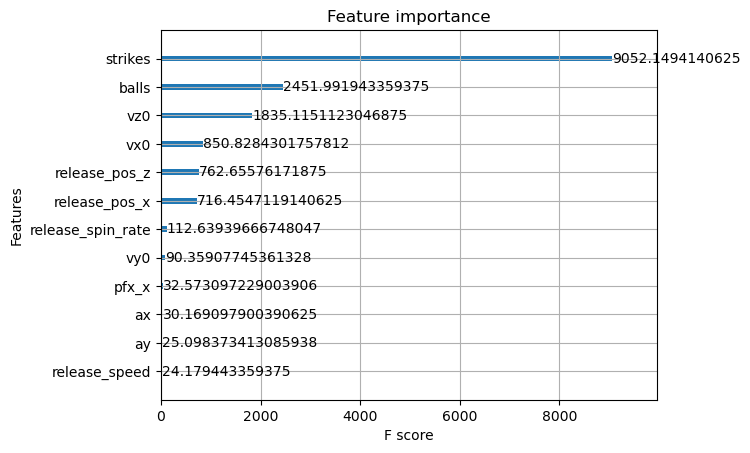

In [22]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

## Testing Data Set Predictions

In [23]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [24]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [25]:
y_pred = final_model.predict(predictions)

In [26]:
testing_identifiers['xswing'] = y_pred

C:\Users\clayton.thompson\AppData\Local\Temp\ipykernel_16008\4232688072.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_identifiers['xswing'] = y_pred


In [29]:
num_nans = testing_identifiers['xswing'].isna().sum()
print(f"Number of NaNs in 'xswing': {num_nans}")


Number of NaNs in 'xswing': 0


In [27]:
len(testing_identifiers)

811776

In [28]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/swing_2022&3_xswing.csv")

# Offspeed Model 

In [ ]:
off = offspeed_data.drop(['description', 'events', 'game_pk', 'game_date', 'des', 'pitch_type_dict',
                     'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'game_type', 'home_team',
                     'away_team', 'type', 'bb_type', 'inning_topbot', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated',
                     'hit_distance_sc', 'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle',
                     'woba_value', 'woba_denom', 'babip_value', 'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score',
                     'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 'post_fld_score',
                      'if_fielding_alignment', 'of_fielding_alignment', 'delta_home_win_exp', 'delta_run_exp',
                      'player_name', 'hit_location', 'umpire', 'sv_id', 'spin_dir', 
                      'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 
                      'fielder_9', 'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 'pitch_number',  
                      'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
                      #removed these columns because of collinearity
                      'release_pos_z',  'effective_speed', 'release_pos_y', 'vy0', 'vx0', 'ax', 'release_extension', 'spin_axis', 'release_spin_rate',
                      'pfx_z', 'ay', 'p_throws', 'az', 'avg_velo', 'avg_hmov', 'avg_vmov', 'pfx_x', 'Unnamed: 0', 'release_pos_x', 'balls', 
                        'total_movement', 'vmov_diff', 'hmov_diff', 'velo_diff', 'vz0', 'release_speed'
                      #'release_spin_rate', 'p_throws', 'spin_axis', 'zone',
                      #removed these columns because they are not useful
                      ], axis=1).copy()

NameError: name 'offspeed_data' is not defined

In [ ]:
x2 = off.drop(['is_strike'], axis=1).copy()
y2 = off['is_strike'].copy()

In [ ]:

len(x2)

152322

In [ ]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x2, y2, test_size=0.2, random_state=42) # split data

In [ ]:
dtrain1 = xgb.DMatrix(x_train1, label=y_train1)
dtest1 = xgb.DMatrix(x_test1, label=y_test1)

params1 = {
    'max_depth': 6,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1
}

# Initial Model
model2 = xgb.train(params1, dtrain1)

In [ ]:
print(f"Unique labels in y_test1: {np.unique(y_test1)}")
print(f"Unique labels in y_train1: {np.unique(y_train1)}")


Unique labels in y_test1: [0 1]
Unique labels in y_train1: [0 1]


In [ ]:
# Generate predictions
y_pred1 = model2.predict(dtest1)
y_pred_binary1 = [1 if p >= 0.5 else 0 for p in y_pred1]

# Calculate Accuracy
accuracy = accuracy_score(y_test1, y_pred_binary1)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test1, y_pred1)
print(f"Log Loss: {logloss}")

Accuracy: 0.9336287543082226
Log Loss: 0.1557187611740709


In [ ]:
#Use an objective function to find the best parameters
def objectives(trial):
    dtrain1 = xgb.DMatrix(x_train1, label=y_train1)
    dtest1 = xgb.DMatrix(x_test1, label=y_test1)
    
    param1 = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
    }

    model2 = xgb.train(param1, dtrain1)
    y_pred1= model2.predict(dtest1)
    y_pred_binary1 = [1 if p >= 0.5 else 0 for p in y_pred1]
    accuracy = accuracy_score(y_test1, y_pred_binary1)
    return accuracy

In [ ]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objectives, n_trials=100)

[I 2023-10-28 15:09:36,123] A new study created in memory with name: no-name-d34c4ef7-2ce4-4779-a65c-e2be8cfab39c
[I 2023-10-28 15:09:36,414] Trial 0 finished with value: 0.9337928770720499 and parameters: {'max_depth': 5, 'eta': 0.24345509256003714, 'subsample': 0.6802305315736025, 'colsample_bytree': 0.9044944080938069}. Best is trial 0 with value: 0.9337928770720499.
[I 2023-10-28 15:09:36,685] Trial 1 finished with value: 0.9235844411619891 and parameters: {'max_depth': 6, 'eta': 0.04993409492472433, 'subsample': 0.7491510300973008, 'colsample_bytree': 0.7023858021577918}. Best is trial 0 with value: 0.9337928770720499.
[I 2023-10-28 15:09:36,984] Trial 2 finished with value: 0.9369440341375349 and parameters: {'max_depth': 9, 'eta': 0.17788292482168488, 'subsample': 0.7205857498903679, 'colsample_bytree': 0.706986723560932}. Best is trial 2 with value: 0.9369440341375349.
[I 2023-10-28 15:09:37,230] Trial 3 finished with value: 0.931068439192516 and parameters: {'max_depth': 3, 'e

In [ ]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.9411784014442803
Best hyperparameters: {'max_depth': 9, 'eta': 0.29086504518827216, 'subsample': 0.609950626814756, 'colsample_bytree': 0.8105463899683927}


In [ ]:
# Ensure trial is the best trial from the study
best_trial1 = study.best_trial

# Set parameters
final_parameters1 = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
}

# Prepare the data
dtrain = xgb.DMatrix(x_train1, label=y_train1)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model1 = xgb.train(final_parameters1, dtrain1)

In [ ]:
# Generate predictions
y_pred1 = final_model1.predict(dtest1)
y_pred_binary1 = [1 if p >= 0.5 else 0 for p in y_pred1]

# Calculate Accuracy
accuracy = accuracy_score(y_test1, y_pred_binary1)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test1, y_pred1)
print(f"Log Loss: {logloss}")

Accuracy: 0.9393730510421795
Log Loss: 0.15511361543363011


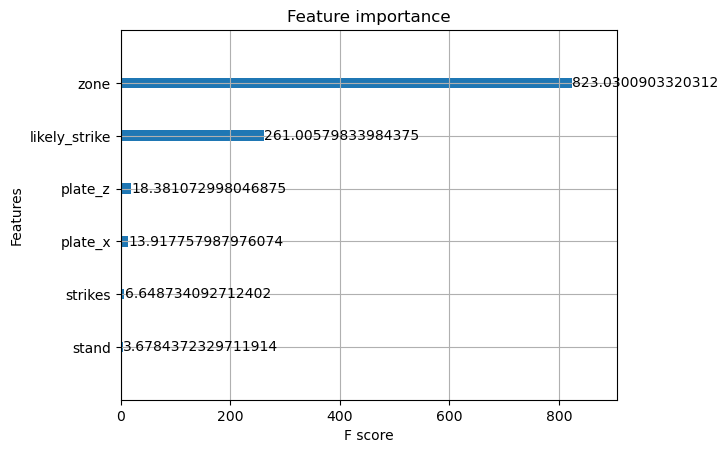

In [ ]:
importance1 = final_model1.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance1)
plt.show()

# Predict 2023 data

In [ ]:
heaters_2023 = df[df['pitch_type_dict'] == 1].copy()
offspeed_2023 = df[df['pitch_type_dict'] == 2].copy()

In [ ]:
# Select only the features you used for training the models
features = ['zone', 'stand', 'strikes', 'plate_x', 'plate_z',  'likely_strike']  # Replace these with your actual features

# Convert DataFrame to DMatrix
dmatrix_heaters_2023 = xgb.DMatrix(heaters_2023[features])
dmatrix_offspeed_2023 = xgb.DMatrix(offspeed_2023[features])

# Make predictions
heaters_2023['prediction'] = final_model.predict(dmatrix_heaters_2023)
offspeed_2023['prediction'] = final_model1.predict(dmatrix_offspeed_2023)

In [ ]:
complete = pd.concat([heaters_2023, offspeed_2023], axis=0)
complete['probability_added'] = 0

In [ ]:
# Correct the conditions and assignment for 'probability_added'
condition1 = (complete['likely_strike'] == 0) & (complete['is_strike'] == 1)
complete.loc[condition1, 'probability_added'] = 1 - complete.loc[condition1, 'prediction']

condition2 = (complete['likely_strike'] == 1) & (complete['is_strike'] == 0)
complete.loc[condition2, 'probability_added'] = -0 + complete.loc[condition2, 'prediction']


In [ ]:
len(condition2)

362561

In [ ]:
players = pd.read_csv('players_query.csv')

In [ ]:
completed = complete.merge(players, left_on='fielder_2', right_on='mlb_id', how='left')

In [ ]:
strike_probs = completed.loc[completed['probability_added'] != 0].copy()

In [ ]:
strike_probs.head()

half_inning  Unnamed: 1 pitch_type   game_date  release_speed  \
1   716352_1_Bot           8         SI  2023-10-01           93.5   
11  716352_2_Bot          46         FF  2023-10-01           93.5   
28  716352_4_Bot         111         FF  2023-10-01           92.9   
37  716352_4_Bot          87         SI  2023-10-01           92.2   
39  716352_4_Top         115         SI  2023-10-01           90.1   

    release_pos_x  release_pos_z    player_name  batter  pitcher  ...  \
1           -2.60           5.68  King, Michael  677951   650633  ...   
11          -2.82           5.71  King, Michael  669004   650633  ...   
28          -2.66           5.89  King, Michael  669004   650633  ...   
37          -2.76           5.67  King, Michael  672580   650633  ...   
39          -1.27           6.14  Greinke, Zack  643396   425844  ...   

     deltaRE is_strike  pitch_type_dict  likely_strike  prediction  \
1  -0.028510         1              1.0              0    0.781290   
11 -0.038179         1              1.0              0    0.495411   
28 -0.038179         1              1.0              0    0.782323   
37 -0.111258         1              1.0              0    0.813712   
39 -0.043952         1              1.0              0    0.584764   

    probability_added  Unnamed: 0  mlb_id        mlb_name  team_name  
1            0.218710        4412  669224    Austin Wells    yankees  
11           0.504589        4412  669224    Austin Wells    yankees  
28           0.217677        4412  669224    Austin Wells    yankees  
37           0.186288        4412  669224    Austin Wells    yankees  
39           0.415236        1898  521692  Salvador Perez     royals  

[5 rows x 113 columns]

### Catcher Evaluation

In [ ]:
# Set the display options to show all rows
pd.set_option('display.max_rows', None)

result = strike_probs.groupby('mlb_name').agg({'probability_added': 'sum'}).sort_values(by='probability_added', ascending=False)
print(result)

# Reset the display options to default
pd.reset_option('display.max_rows')

                       probability_added
mlb_name                                
Jonah Heim                    369.409200
William Contreras             357.175406
Francisco Alvarez             343.816237
Cal Raleigh                   325.117514
Patrick Bailey                322.223661
J.T. Realmuto                 306.765881
Adley Rutschman               304.310884
Keibert Ruiz                  300.757002
Elias Diaz                    291.464170
Will Smith                    289.637044
Shea Langeliers               285.841658
Sean Murphy                   285.280986
Alejandro Kirk                274.881437
Jake Rogers                   270.437452
Connor Wong                   263.304882
Nick Fortes                   261.444752
Austin Hedges                 252.923828
Yasmani Grandal               249.119006
Christian Vazquez             245.539206
Willson Contreras             243.042565
Gabriel Moreno                240.534485
Kyle Higashioka               236.375578
Martin Maldonado

In [ ]:
strike_probs['framing_runs'] = (strike_probs['deltaRE'] * -1) * strike_probs['probability_added'].abs()

## Initial Situational Framing Runs Leaderboard

In [ ]:
# Set the display options to show all rows
pd.set_option('display.max_rows', None)

result = strike_probs.groupby('mlb_name').agg({'framing_runs': 'sum'}).sort_values(by='framing_runs', ascending=False)
print(result)

# Reset the display options to default
pd.reset_option('display.max_rows')

                       framing_runs
mlb_name                           
Jonah Heim                28.298897
William Contreras         27.314465
Francisco Alvarez         26.280338
Cal Raleigh               24.428360
J.T. Realmuto             23.217440
Will Smith                23.151280
Adley Rutschman           22.850475
Austin Hedges             22.659703
Shea Langeliers           22.651095
Elias Diaz                22.566548
Patrick Bailey            22.507789
Keibert Ruiz              22.178750
Alejandro Kirk            21.671238
Kyle Higashioka           20.388670
Nick Fortes               20.349055
Willson Contreras         20.085103
Sean Murphy               20.071047
Connor Wong               20.061680
Jake Rogers               19.988771
Christian Vazquez         19.943172
Martin Maldonado          19.101232
Yasmani Grandal           18.546439
Gabriel Moreno            18.169561
Yan Gomes                 16.646696
Gary Sanchez              15.508716
Salvador Perez            15

In [ ]:
strike_probs.drop(['Unnamed: 0', 'Unnamed: 1'], axis=1, inplace=True)

In [ ]:
strike_probs.to_csv('strike_probs.csv')

### Get out meaningless strikes that have nothing to do with framing

In [ ]:
likely = strike_probs.query('(prediction < .85)')

In [ ]:
# Set the display options to show all rows
pd.set_option('display.max_rows', None)

result = likely.groupby('mlb_name').agg({'framing_runs': 'sum'}).sort_values(by='framing_runs', ascending=False)
print(result)

                       framing_runs
mlb_name                           
Jonah Heim                27.265644
William Contreras         26.675339
Francisco Alvarez         25.509967
Cal Raleigh               23.705518
Will Smith                22.504385
J.T. Realmuto             22.293919
Adley Rutschman           22.158913
Austin Hedges             22.132027
Patrick Bailey            22.033697
Shea Langeliers           21.670207
Elias Diaz                21.585984
Keibert Ruiz              21.388849
Alejandro Kirk            20.937702
Kyle Higashioka           19.911051
Nick Fortes               19.775314
Sean Murphy               19.402830
Willson Contreras         19.372176
Christian Vazquez         19.285147
Connor Wong               19.231894
Jake Rogers               19.224211
Martin Maldonado          18.579309
Yasmani Grandal           17.983997
Gabriel Moreno            17.519849
Yan Gomes                 16.075565
Gary Sanchez              14.937981
Salvador Perez            14

###  I think that this is the best leaderboard. Filters out the gimme pitches